# Compute Features from *.parquet Track Files

## General Settings

In [1]:
# For loading, manipulating and visualising data in tables
import pandas as pd
# For Operating System commands
import os
# For high-level file operations
import shutil
# For doing math
import numpy as np
# For making plots and graphical visualisations
import matplotlib.pyplot as plt
# For airspeed conversions (true/calibrated/equivalent/Mach) from here: https://pypi.org/project/flightcondition/
#from flightcondition import FlightCondition, unit
# For Flight phase identification from here: https://openap.dev/flight_phases.html
#from openap.phase import FlightPhase
# For progress bar
from tqdm import tqdm

In [2]:
g0 = 9.80665    # m/s^2
ft2m = 0.3048   # =1ft
kt2m_s = 1852 / 3600 # 1kt=1sm/1h = 1000m/3600s

## User Settings

In [3]:
# Local path to (capied and/or cleaned) *.parquet files
strPqtLocPath = 'local_parquet_clean_old'
dt = 30 #s
#strPqtLocPath = 'local_parquet_clean'
#dt = 10 #s

# Local path to *.csv files
strLocPath = 'local_files'

## Import *_set.csv

In [4]:
#df = pd.read_csv(os.path.join(strLocPath,"challenge_set.csv"))
#df = pd.read_csv(os.path.join(strLocPath,"submission_set.csv"))
df = pd.read_csv(os.path.join(strLocPath,"final_submission_set.csv"))

In [5]:
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,arrival_time,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,2022-01-01T12:48:33Z,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,170,15,1122,NaN
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,2022-01-01T17:49:51Z,A333,H,bdeeef3a675587d530de70a25d7118d2,470,15,3205,NaN
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,2022-01-01T09:55:16Z,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,473,10,3965,NaN
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,2022-01-01T14:13:56Z,B738,M,f53c55b5cf0cbb3be755bf50df6fa52d,123,9,802,NaN
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,2022-01-01T13:09:44Z,BCS3,M,2d5def0a5a844b343ba1b7cc9cb28fa9,56,11,292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,2022-12-31T12:24:24Z,A321,M,6351ec1b849adacc0cbb3b1313d8d39b,154,25,988,NaN
158145,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,2022-12-31T10:55:35Z,A320,M,f502877cab405652cf0dd70c2213e730,42,9,240,NaN
158146,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,2022-12-31T17:51:22Z,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,483,14,3426,NaN
158147,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,2022-12-31T10:47:00Z,E195,M,5d407cb11cc29578cc3e292e743f5393,55,15,335,NaN


## Loop over lines in *_set.csv to extact features from respective *.parquet file

In [6]:
df_all_feat = pd.DataFrame()
prev_flight_date = ''

#flight_id_sel = 254631910 # '254611296' # high TOW; # '254631910' # low TOW on same route 'EGLL EIDW' on same day 2022-08-22
#flight_id_sel = 254636038 # '254636038' # mid TOW on reverse route 'EIDW EGLL' on same day 2022-08-22
#flight_id_sel = 254946876 # flight Miami to Barcelona with first part of climb and then interpolation to end of cruise

#df = df[df['flight_id'] == flight_id_sel]

for index, row in tqdm(df.iterrows()):
    flight_id_sel = row["flight_id"]
    flight_date = row['date']
    actual_offblock_time = row['actual_offblock_time']
    arrival_time = row['arrival_time']
    taxiout_time = row['taxiout_time']

    # Assemble *.parquet file and path names
    strFile = flight_date + '.parquet'
    strLocFullFile = os.path.join(strPqtLocPath, strFile)

    if not os.path.isfile(strLocFullFile):
        print('Skipping not available *.parquet: ' + strLocFullFile)
        continue
        
    # pd.read_parquet() is used to load parquet files
    if flight_date != prev_flight_date:
        # load only needed in case date has changed
        df_parquet = pd.read_parquet(strLocFullFile)
        prev_flight_date = flight_date 

    # Exrtact selected flight
    df_parquet_sel = df_parquet[df_parquet['flight_id']==flight_id_sel] #(notice the == sign sets the condition)
    
    # keep only assumed in-flight part - see hints given here: https://ansperformance.eu/study/data-challenge/data.html
    df_parquet_sel = df_parquet_sel[df_parquet_sel['timestamp'] > (pd.Timestamp(actual_offblock_time) + pd.Timedelta(taxiout_time, "min"))]
    df_parquet_sel = df_parquet_sel[df_parquet_sel['timestamp'] < arrival_time]

    df_parquet_sel = df_parquet_sel[df_parquet_sel['groundspeed'] > 200] # IMPORTANT: to ensure A/C is flying and remove altitude jumps at take-off
    
    df_parquet_sel = df_parquet_sel.reset_index(drop = True)
    
    if len(df_parquet_sel.index) == 0:
        print('Skipping flight_id = ' + str(flight_id_sel) + ' with no in-flight track in *.parquet: ' + strLocFullFile)
        continue

    ### 
    data = {
        "flight_id":   [flight_id_sel]
    }
    #load data into a DataFrame object:
    df_feat = pd.DataFrame(data)

    if df_parquet_sel['altitude'].max() < 30001 or pd.isnull(df_parquet_sel['altitude']).all():
        print('Skipping flight_id = ' + str(flight_id_sel) + ' with no valid altitude above 30000ft! ')
        continue
        
    #### Crossing FL300 = 30'000ft 
    # Find last altitude above 30'000ft
    idx_df_FL300 = df_parquet_sel[df_parquet_sel['altitude'].ge(30000)].index[-1]
    df_FL300 = df_parquet_sel.iloc[idx_df_FL300]

    if idx_df_FL300 > 0:
        data = {
            "flight_id":         [flight_id_sel],                           # 
            "DE_FL300_start":     [df_FL300["timestamp"]],                    # timestamp of start
            "DE_FL300_alt":       [df_FL300["altitude"].round(1)]             # altitude
        }
        
        #Join data into DataFrame object
        df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
        
    #### Crossing FL200 = 20'000ft 
    # Find last altitude above 20'000ft
    idx_df_FL200 = df_parquet_sel[df_parquet_sel['altitude'].ge(20000)].index[-1]
    df_FL200 = df_parquet_sel.iloc[idx_df_FL200]

    if idx_df_FL200 > 0:
        data = {
            "flight_id":         [flight_id_sel],                           # 
            "DE_FL200_start":    [df_FL200["timestamp"]],                   # timestamp of start
            "DE_FL200_alt":      [df_FL200["altitude"].round(1)]            # altitude
        }
        
        #Join data into DataFrame object
        df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')

    #### Rate-of-climb computation in segements
    if idx_df_FL300 > 0 and idx_df_FL200 > 0 and \
        (idx_df_FL200-idx_df_FL300) > 1 and \
        df_FL300['timestamp'] > df_parquet_sel['timestamp'].iloc[df_parquet_sel['altitude'].idxmax()]:
        if df_feat["DE_FL300_start"].array != df_feat["DE_FL200_start"].array:
            # rate-of-descent from FL300 to FL200, ft/min
            ROD_FL300to200 = (df_feat["DE_FL200_alt"].array-df_feat["DE_FL300_alt"].array) / ((df_feat["DE_FL200_start"].array-df_feat["DE_FL300_start"].array).total_seconds()/60)

            # Atmos computation
            df_DE = df_parquet_sel.iloc[idx_df_FL300:idx_df_FL200]
            df_DE = df_DE.reset_index(drop = True)
            
            # Compute and add relative longitudinal_wind from U_wind & V_wind (see ERA5 definition: 
            # https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview) 
            # ⇒ head-wind: <0; tail-wind: >0; converted from m/s to kt
            df_DE["longi_wind"] = (df_DE['track'].apply(np.deg2rad).apply(np.cos) * df_DE['v_component_of_wind'] + df_DE['track'].apply(np.deg2rad).apply(np.sin) * df_DE['u_component_of_wind'])*3600/1852
            
            # Compute and TAS = true airspeed = GS - longitudinal_wind
            df_DE["TAS"] = df_DE['groundspeed'] - df_DE["longi_wind"]

            ## Specific energy rate: change of speed, ROC
            # https://enac.hal.science/hal-01002401/document
            # https://ntrs.nasa.gov/api/citations/20230014062/downloads/TMPI_DASC23_AidaRohani.pdf
            df_DE['dTAS'] = df_DE['TAS'].diff() * kt2m_s / dt # m/s^2
            df_DE['dHp'] = df_DE['altitude'].diff() * ft2m / dt # m/s
            df_DE['Q'] = df_DE['TAS'] * kt2m_s * df_DE['dTAS'] + g0 * df_DE['dHp'] # m^2/s^3

            df_DE['d_track'] = df_DE['track_unwrapped'].diff()
            
            # average CAS between FL100 and FL200, kt 
            TAS_avg = df_DE["TAS"].mean()

            # average temperature
            Temp_avg = df_DE["temperature"].mean()

            data = {
                "flight_id":         [flight_id_sel],                  # 
                "ROD_FL300to200":     np.round(ROD_FL300to200),         # rate-of-descent from FL300 to FL200, ft/min
                "TAS_FL300to200":     np.round(TAS_avg,1),              # average TAS between FL300 and FL200, kt 
                "Temp_FL300to200":    np.round(Temp_avg,2),             # average Temperature between FL100 and FL200, K
                "Q_FL300":            np.round(df_DE['Q'].iloc[1],2), 
                "Q_FL200":            np.round(df_DE['Q'].iloc[-1],2),
                "Q_mFL300to200":      np.round(df_DE['Q'].median(),2),
                "TAS_FL300":          np.round(df_DE['TAS'].iloc[1],2), 
                "TAS_FL200":          np.round(df_DE['TAS'].iloc[-1],2),
                "TAS_mFL300to200":    np.round(df_DE['TAS'].median(),2),
                "dHp_FL300":          np.round(df_DE['dHp'].iloc[1],2), 
                "dHp_FL200":          np.round(df_DE['dHp'].iloc[-1],2),
                "dHp_mFL300to200" :   np.round(df_DE['dHp'].median(),2),
                "cs_d_track_300to200": np.round(df_DE['d_track'].abs().sum(),2),
            }
            
            #Join data into DataFrame object
            df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
        
    ## Append features of current flight to dataframe of all flight
    df_all_feat = pd.concat([df_all_feat, df_feat], ignore_index=True)

27it [00:00, 60.23it/s]

Skipping flight_id = 248754909 with no valid altitude above 30000ft! 
Skipping flight_id = 248763792 with no valid altitude above 30000ft! 
Skipping flight_id = 248753679 with no valid altitude above 30000ft! 
Skipping flight_id = 248759534 with no valid altitude above 30000ft! 


56it [00:00, 80.20it/s]

Skipping flight_id = 248753258 with no valid altitude above 30000ft! 
Skipping flight_id = 248751996 with no valid altitude above 30000ft! 


75it [00:01, 84.95it/s]

Skipping flight_id = 248752851 with no valid altitude above 30000ft! 
Skipping flight_id = 248751880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-01.parquet
Skipping flight_id = 248763352 with no valid altitude above 30000ft! 
Skipping flight_id = 248761913 with no valid altitude above 30000ft! 


98it [00:01, 94.89it/s]

Skipping flight_id = 248752312 with no valid altitude above 30000ft! 
Skipping flight_id = 248752038 with no valid altitude above 30000ft! 
Skipping flight_id = 248754284 with no valid altitude above 30000ft! 
Skipping flight_id = 248761818 with no valid altitude above 30000ft! 
Skipping flight_id = 248765178 with no valid altitude above 30000ft! 


128it [00:01, 91.24it/s]

Skipping flight_id = 248762592 with no valid altitude above 30000ft! 
Skipping flight_id = 248757006 with no valid altitude above 30000ft! 


139it [00:01, 96.18it/s]

Skipping flight_id = 248759980 with no valid altitude above 30000ft! 
Skipping flight_id = 248759220 with no valid altitude above 30000ft! 
Skipping flight_id = 248754755 with no valid altitude above 30000ft! 
Skipping flight_id = 248765240 with no valid altitude above 30000ft! 


159it [00:02, 93.74it/s]

Skipping flight_id = 248758802 with no valid altitude above 30000ft! 
Skipping flight_id = 248765957 with no valid altitude above 30000ft! 


188it [00:02, 87.78it/s]

Skipping flight_id = 248754610 with no valid altitude above 30000ft! 
Skipping flight_id = 248756344 with no valid altitude above 30000ft! 


208it [00:02, 91.07it/s]

Skipping flight_id = 248753608 with no valid altitude above 30000ft! 
Skipping flight_id = 248756555 with no valid altitude above 30000ft! 
Skipping flight_id = 248761006 with no valid altitude above 30000ft! 


231it [00:02, 96.49it/s]

Skipping flight_id = 248756599 with no valid altitude above 30000ft! 
Skipping flight_id = 248760562 with no valid altitude above 30000ft! 
Skipping flight_id = 248759877 with no valid altitude above 30000ft! 
Skipping flight_id = 248762360 with no valid altitude above 30000ft! 
Skipping flight_id = 248754174 with no valid altitude above 30000ft! 


251it [00:03, 87.99it/s]

Skipping flight_id = 248753716 with no valid altitude above 30000ft! 
Skipping flight_id = 248753708 with no valid altitude above 30000ft! 
Skipping flight_id = 248769056 with no valid altitude above 30000ft! 
Skipping flight_id = 248769655 with no valid altitude above 30000ft! 
Skipping flight_id = 248776102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet


273it [00:03, 95.15it/s]

Skipping flight_id = 248773090 with no valid altitude above 30000ft! 
Skipping flight_id = 248773099 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248783480 with no valid altitude above 30000ft! 
Skipping flight_id = 248772961 with no valid altitude above 30000ft! 


304it [00:03, 93.28it/s]

Skipping flight_id = 248782960 with no valid altitude above 30000ft! 
Skipping flight_id = 248783827 with no valid altitude above 30000ft! 
Skipping flight_id = 248783761 with no valid altitude above 30000ft! 
Skipping flight_id = 248775252 with no valid altitude above 30000ft! 
Skipping flight_id = 248774885 with no valid altitude above 30000ft! 
Skipping flight_id = 248776673 with no valid altitude above 30000ft! 


336it [00:03, 97.41it/s]

Skipping flight_id = 248783572 with no valid altitude above 30000ft! 
Skipping flight_id = 248774603 with no valid altitude above 30000ft! 
Skipping flight_id = 248775008 with no valid altitude above 30000ft! 
Skipping flight_id = 248774916 with no valid altitude above 30000ft! 
Skipping flight_id = 248784757 with no valid altitude above 30000ft! 
Skipping flight_id = 248783257 with no valid altitude above 30000ft! 


366it [00:04, 96.50it/s]

Skipping flight_id = 248782828 with no valid altitude above 30000ft! 
Skipping flight_id = 248766356 with no valid altitude above 30000ft! 
Skipping flight_id = 248777326 with no valid altitude above 30000ft! 
Skipping flight_id = 248780180 with no valid altitude above 30000ft! 
Skipping flight_id = 248782024 with no valid altitude above 30000ft! 


391it [00:04, 103.18it/s]

Skipping flight_id = 248768400 with no valid altitude above 30000ft! 
Skipping flight_id = 248769852 with no valid altitude above 30000ft! 
Skipping flight_id = 248766419 with no valid altitude above 30000ft! 
Skipping flight_id = 248784256 with no valid altitude above 30000ft! 
Skipping flight_id = 248779132 with no valid altitude above 30000ft! 
Skipping flight_id = 248779267 with no valid altitude above 30000ft! 


403it [00:04, 105.68it/s]

Skipping flight_id = 248783718 with no valid altitude above 30000ft! 
Skipping flight_id = 248781432 with no valid altitude above 30000ft! 
Skipping flight_id = 248768797 with no valid altitude above 30000ft! 
Skipping flight_id = 248767693 with no valid altitude above 30000ft! 
Skipping flight_id = 248784667 with no valid altitude above 30000ft! 
Skipping flight_id = 248777782 with no valid altitude above 30000ft! 


446it [00:05, 95.31it/s] 

Skipping flight_id = 248768376 with no valid altitude above 30000ft! 
Skipping flight_id = 248784569 with no valid altitude above 30000ft! 
Skipping flight_id = 248782452 with no valid altitude above 30000ft! 


458it [00:05, 101.46it/s]

Skipping flight_id = 248781858 with no valid altitude above 30000ft! 
Skipping flight_id = 248768017 with no valid altitude above 30000ft! 
Skipping flight_id = 248767104 with no valid altitude above 30000ft! 
Skipping flight_id = 248788053 with no valid altitude above 30000ft! 


479it [00:05, 91.64it/s] 

Skipping flight_id = 248771386 with no valid altitude above 30000ft! 
Skipping flight_id = 248772939 with no valid altitude above 30000ft! 


501it [00:05, 93.26it/s]

Skipping flight_id = 248768244 with no valid altitude above 30000ft! 
Skipping flight_id = 248772493 with no valid altitude above 30000ft! 


533it [00:05, 94.36it/s]

Skipping flight_id = 248785818 with no valid altitude above 30000ft! 
Skipping flight_id = 248780277 with no valid altitude above 30000ft! 
Skipping flight_id = 248780324 with no valid altitude above 30000ft! 
Skipping flight_id = 248780532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248771621 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248767784 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248772701 with no valid altitude above 30000ft! 


556it [00:06, 101.14it/s]

Skipping flight_id = 248779216 with no valid altitude above 30000ft! 
Skipping flight_id = 248769198 with no valid altitude above 30000ft! 
Skipping flight_id = 248780488 with no valid altitude above 30000ft! 
Skipping flight_id = 248773761 with no valid altitude above 30000ft! 
Skipping flight_id = 248767639 with no valid altitude above 30000ft! 


578it [00:06, 99.42it/s] 

Skipping flight_id = 248771289 with no valid altitude above 30000ft! 
Skipping flight_id = 248786076 with no valid altitude above 30000ft! 
Skipping flight_id = 248785289 with no valid altitude above 30000ft! 
Skipping flight_id = 248780639 with no valid altitude above 30000ft! 


599it [00:06, 97.99it/s]

Skipping flight_id = 248770174 with no valid altitude above 30000ft! 
Skipping flight_id = 248786959 with no valid altitude above 30000ft! 
Skipping flight_id = 248786223 with no valid altitude above 30000ft! 
Skipping flight_id = 248772965 with no valid altitude above 30000ft! 
Skipping flight_id = 248769522 with no valid altitude above 30000ft! 


630it [00:06, 91.89it/s]

Skipping flight_id = 248771219 with no valid altitude above 30000ft! 
Skipping flight_id = 248771221 with no valid altitude above 30000ft! 
Skipping flight_id = 248785564 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248786011 with no valid altitude above 30000ft! 
Skipping flight_id = 248788212 with no valid altitude above 30000ft! 
Skipping flight_id = 248770073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-02.parquet
Skipping flight_id = 248770409 with no valid altitude above 30000ft! 


651it [00:07, 94.83it/s]

Skipping flight_id = 248776346 with no valid altitude above 30000ft! 
Skipping flight_id = 248769332 with no valid altitude above 30000ft! 
Skipping flight_id = 248776168 with no valid altitude above 30000ft! 
Skipping flight_id = 248769710 with no valid altitude above 30000ft! 


680it [00:07, 83.25it/s]

Skipping flight_id = 248796864 with no valid altitude above 30000ft! 
Skipping flight_id = 248804700 with no valid altitude above 30000ft! 


698it [00:07, 84.08it/s]

Skipping flight_id = 248789507 with no valid altitude above 30000ft! 
Skipping flight_id = 248795996 with no valid altitude above 30000ft! 


729it [00:08, 92.93it/s]

Skipping flight_id = 248788681 with no valid altitude above 30000ft! 
Skipping flight_id = 248798637 with no valid altitude above 30000ft! 
Skipping flight_id = 248788868 with no valid altitude above 30000ft! 
Skipping flight_id = 248789640 with no valid altitude above 30000ft! 
Skipping flight_id = 248806018 with no valid altitude above 30000ft! 


751it [00:08, 95.43it/s]

Skipping flight_id = 248790011 with no valid altitude above 30000ft! 
Skipping flight_id = 248789903 with no valid altitude above 30000ft! 
Skipping flight_id = 248798064 with no valid altitude above 30000ft! 
Skipping flight_id = 248799494 with no valid altitude above 30000ft! 


775it [00:08, 103.69it/s]

Skipping flight_id = 248801321 with no valid altitude above 30000ft! 
Skipping flight_id = 248806606 with no valid altitude above 30000ft! 
Skipping flight_id = 248805072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet
Skipping flight_id = 248805077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet


801it [00:08, 110.98it/s]

Skipping flight_id = 248797009 with no valid altitude above 30000ft! 
Skipping flight_id = 248806918 with no valid altitude above 30000ft! 
Skipping flight_id = 248803799 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet
Skipping flight_id = 248802641 with no valid altitude above 30000ft! 
Skipping flight_id = 248803930 with no valid altitude above 30000ft! 
Skipping flight_id = 248804196 with no valid altitude above 30000ft! 
Skipping flight_id = 248801448 with no valid altitude above 30000ft! 
Skipping flight_id = 248800927 with no valid altitude above 30000ft! 
Skipping flight_id = 248801502 with no valid altitude above 30000ft! 


824it [00:09, 101.31it/s]

Skipping flight_id = 248804024 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet
Skipping flight_id = 248803790 with no valid altitude above 30000ft! 
Skipping flight_id = 248805281 with no valid altitude above 30000ft! 


846it [00:09, 101.14it/s]

Skipping flight_id = 248799991 with no valid altitude above 30000ft! 
Skipping flight_id = 248808591 with no valid altitude above 30000ft! 
Skipping flight_id = 248807948 with no valid altitude above 30000ft! 
Skipping flight_id = 248803747 with no valid altitude above 30000ft! 
Skipping flight_id = 248792715 with no valid altitude above 30000ft! 


868it [00:09, 97.46it/s] 

Skipping flight_id = 248807023 with no valid altitude above 30000ft! 
Skipping flight_id = 248801035 with no valid altitude above 30000ft! 
Skipping flight_id = 248796956 with no valid altitude above 30000ft! 
Skipping flight_id = 248789735 with no valid altitude above 30000ft! 


889it [00:09, 97.58it/s]

Skipping flight_id = 248808018 with no valid altitude above 30000ft! 
Skipping flight_id = 248802171 with no valid altitude above 30000ft! 
Skipping flight_id = 248808679 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet


918it [00:10, 77.12it/s]

Skipping flight_id = 248799320 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-04.parquet
Skipping flight_id = 248802051 with no valid altitude above 30000ft! 


930it [00:10, 84.73it/s]

Skipping flight_id = 248806286 with no valid altitude above 30000ft! 
Skipping flight_id = 248808310 with no valid altitude above 30000ft! 
Skipping flight_id = 248792229 with no valid altitude above 30000ft! 
Skipping flight_id = 248791645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet
Skipping flight_id = 248794168 with no valid altitude above 30000ft! 


964it [00:10, 96.92it/s]

Skipping flight_id = 248800548 with no valid altitude above 30000ft! 
Skipping flight_id = 248808254 with no valid altitude above 30000ft! 
Skipping flight_id = 248793416 with no valid altitude above 30000ft! 
Skipping flight_id = 248791522 with no valid altitude above 30000ft! 
Skipping flight_id = 248793848 with no valid altitude above 30000ft! 


974it [00:10, 93.60it/s]

Skipping flight_id = 248803095 with no valid altitude above 30000ft! 
Skipping flight_id = 248794789 with no valid altitude above 30000ft! 


1015it [00:11, 92.45it/s]

Skipping flight_id = 248804484 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-03.parquet
Skipping flight_id = 248804052 with no valid altitude above 30000ft! 
Skipping flight_id = 248796259 with no valid altitude above 30000ft! 
Skipping flight_id = 248792428 with no valid altitude above 30000ft! 


1035it [00:11, 91.23it/s]

Skipping flight_id = 248803637 with no valid altitude above 30000ft! 
Skipping flight_id = 248799688 with no valid altitude above 30000ft! 


1072it [00:11, 84.68it/s]

Skipping flight_id = 248824522 with no valid altitude above 30000ft! 
Skipping flight_id = 248825154 with no valid altitude above 30000ft! 
Skipping flight_id = 248829249 with no valid altitude above 30000ft! 


1105it [00:12, 93.37it/s]

Skipping flight_id = 248821777 with no valid altitude above 30000ft! 
Skipping flight_id = 248816194 with no valid altitude above 30000ft! 
Skipping flight_id = 248817811 with no valid altitude above 30000ft! 
Skipping flight_id = 248827170 with no valid altitude above 30000ft! 
Skipping flight_id = 248827319 with no valid altitude above 30000ft! 
Skipping flight_id = 248828847 with no valid altitude above 30000ft! 


1127it [00:12, 91.57it/s]

Skipping flight_id = 248813779 with no valid altitude above 30000ft! 
Skipping flight_id = 248824351 with no valid altitude above 30000ft! 


1151it [00:12, 101.30it/s]

Skipping flight_id = 248812177 with no valid altitude above 30000ft! 
Skipping flight_id = 248817539 with no valid altitude above 30000ft! 
Skipping flight_id = 248816259 with no valid altitude above 30000ft! 
Skipping flight_id = 248812753 with no valid altitude above 30000ft! 
Skipping flight_id = 248811755 with no valid altitude above 30000ft! 
Skipping flight_id = 248811376 with no valid altitude above 30000ft! 
Skipping flight_id = 248810723 with no valid altitude above 30000ft! 
Skipping flight_id = 248812664 with no valid altitude above 30000ft! 


1193it [00:13, 86.28it/s] 

Skipping flight_id = 248812945 with no valid altitude above 30000ft! 
Skipping flight_id = 248815578 with no valid altitude above 30000ft! 


1216it [00:13, 95.02it/s]

Skipping flight_id = 248819853 with no valid altitude above 30000ft! 
Skipping flight_id = 248813000 with no valid altitude above 30000ft! 
Skipping flight_id = 248813997 with no valid altitude above 30000ft! 
Skipping flight_id = 248822672 with no valid altitude above 30000ft! 
Skipping flight_id = 248822231 with no valid altitude above 30000ft! 


1236it [00:13, 91.04it/s]

Skipping flight_id = 248814006 with no valid altitude above 30000ft! 
Skipping flight_id = 248827597 with no valid altitude above 30000ft! 
Skipping flight_id = 248819342 with no valid altitude above 30000ft! 
Skipping flight_id = 248810371 with no valid altitude above 30000ft! 
Skipping flight_id = 248816726 with no valid altitude above 30000ft! 


1260it [00:13, 91.77it/s]

Skipping flight_id = 248821244 with no valid altitude above 30000ft! 
Skipping flight_id = 248818657 with no valid altitude above 30000ft! 
Skipping flight_id = 248811540 with no valid altitude above 30000ft! 


1291it [00:14, 93.54it/s]

Skipping flight_id = 248810389 with no valid altitude above 30000ft! 
Skipping flight_id = 248811479 with no valid altitude above 30000ft! 
Skipping flight_id = 248816643 with no valid altitude above 30000ft! 
Skipping flight_id = 248815178 with no valid altitude above 30000ft! 


1312it [00:14, 92.31it/s]

Skipping flight_id = 248815934 with no valid altitude above 30000ft! 
Skipping flight_id = 248826500 with no valid altitude above 30000ft! 


1342it [00:14, 82.30it/s]

Skipping flight_id = 248824812 with no valid altitude above 30000ft! 
Skipping flight_id = 248816960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-04.parquet
Skipping flight_id = 248839119 with no valid altitude above 30000ft! 
Skipping flight_id = 248831000 with no valid altitude above 30000ft! 


1374it [00:15, 89.36it/s]

Skipping flight_id = 248833242 with no valid altitude above 30000ft! 
Skipping flight_id = 248834601 with no valid altitude above 30000ft! 
Skipping flight_id = 248846312 with no valid altitude above 30000ft! 
Skipping flight_id = 248847804 with no valid altitude above 30000ft! 


1396it [00:15, 95.58it/s]

Skipping flight_id = 248834878 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-05.parquet
Skipping flight_id = 248840571 with no valid altitude above 30000ft! 
Skipping flight_id = 248846447 with no valid altitude above 30000ft! 
Skipping flight_id = 248843013 with no valid altitude above 30000ft! 


1416it [00:15, 93.72it/s]

Skipping flight_id = 248835346 with no valid altitude above 30000ft! 
Skipping flight_id = 248840686 with no valid altitude above 30000ft! 


1436it [00:15, 93.17it/s]

Skipping flight_id = 248838596 with no valid altitude above 30000ft! 
Skipping flight_id = 248839276 with no valid altitude above 30000ft! 
Skipping flight_id = 248839986 with no valid altitude above 30000ft! 
Skipping flight_id = 248842334 with no valid altitude above 30000ft! 


1458it [00:15, 98.15it/s]

Skipping flight_id = 248836904 with no valid altitude above 30000ft! 
Skipping flight_id = 248830748 with no valid altitude above 30000ft! 
Skipping flight_id = 248839466 with no valid altitude above 30000ft! 
Skipping flight_id = 248830016 with no valid altitude above 30000ft! 
Skipping flight_id = 248830926 with no valid altitude above 30000ft! 
Skipping flight_id = 248831972 with no valid altitude above 30000ft! 
Skipping flight_id = 248842962 with no valid altitude above 30000ft! 


1494it [00:16, 107.34it/s]

Skipping flight_id = 248844529 with no valid altitude above 30000ft! 
Skipping flight_id = 248835667 with no valid altitude above 30000ft! 
Skipping flight_id = 248836285 with no valid altitude above 30000ft! 
Skipping flight_id = 248831112 with no valid altitude above 30000ft! 
Skipping flight_id = 248841649 with no valid altitude above 30000ft! 
Skipping flight_id = 248841650 with no valid altitude above 30000ft! 
Skipping flight_id = 248834040 with no valid altitude above 30000ft! 
Skipping flight_id = 248841898 with no valid altitude above 30000ft! 


1505it [00:16, 103.46it/s]

Skipping flight_id = 248829613 with no valid altitude above 30000ft! 
Skipping flight_id = 248845214 with no valid altitude above 30000ft! 


1536it [00:16, 80.53it/s] 

Skipping flight_id = 248846377 with no valid altitude above 30000ft! 
Skipping flight_id = 248847550 with no valid altitude above 30000ft! 
Skipping flight_id = 248846386 with no valid altitude above 30000ft! 


1566it [00:17, 90.59it/s]

Skipping flight_id = 248844300 with no valid altitude above 30000ft! 
Skipping flight_id = 248839619 with no valid altitude above 30000ft! 
Skipping flight_id = 248845350 with no valid altitude above 30000ft! 
Skipping flight_id = 248844628 with no valid altitude above 30000ft! 
Skipping flight_id = 248835516 with no valid altitude above 30000ft! 


1587it [00:17, 92.39it/s]

Skipping flight_id = 248832214 with no valid altitude above 30000ft! 
Skipping flight_id = 248844910 with no valid altitude above 30000ft! 
Skipping flight_id = 248839230 with no valid altitude above 30000ft! 


1610it [00:17, 99.60it/s]

Skipping flight_id = 248844754 with no valid altitude above 30000ft! 
Skipping flight_id = 248844240 with no valid altitude above 30000ft! 
Skipping flight_id = 248829498 with no valid altitude above 30000ft! 
Skipping flight_id = 248846758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-05.parquet
Skipping flight_id = 248846778 with no valid altitude above 30000ft! 


1631it [00:17, 94.93it/s]

Skipping flight_id = 248839560 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-05.parquet
Skipping flight_id = 248837563 with no valid altitude above 30000ft! 


1651it [00:18, 84.27it/s]

Skipping flight_id = 248852083 with no valid altitude above 30000ft! 
Skipping flight_id = 248867445 with no valid altitude above 30000ft! 


1680it [00:18, 87.25it/s]

Skipping flight_id = 248856121 with no valid altitude above 30000ft! 
Skipping flight_id = 248860960 with no valid altitude above 30000ft! 
Skipping flight_id = 248859877 with no valid altitude above 30000ft! 


1705it [00:18, 100.07it/s]

Skipping flight_id = 248852796 with no valid altitude above 30000ft! 
Skipping flight_id = 248866647 with no valid altitude above 30000ft! 
Skipping flight_id = 248851194 with no valid altitude above 30000ft! 
Skipping flight_id = 248851126 with no valid altitude above 30000ft! 
Skipping flight_id = 248865632 with no valid altitude above 30000ft! 
Skipping flight_id = 248854266 with no valid altitude above 30000ft! 
Skipping flight_id = 248853275 with no valid altitude above 30000ft! 
Skipping flight_id = 248864706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet


1738it [00:18, 99.05it/s] 

Skipping flight_id = 248854376 with no valid altitude above 30000ft! 
Skipping flight_id = 248864735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet
Skipping flight_id = 248864148 with no valid altitude above 30000ft! 
Skipping flight_id = 248864155 with no valid altitude above 30000ft! 
Skipping flight_id = 248848830 with no valid altitude above 30000ft! 
Skipping flight_id = 248851548 with no valid altitude above 30000ft! 


1760it [00:19, 98.31it/s]

Skipping flight_id = 248863574 with no valid altitude above 30000ft! 
Skipping flight_id = 248864176 with no valid altitude above 30000ft! 
Skipping flight_id = 248860754 with no valid altitude above 30000ft! 
Skipping flight_id = 248857582 with no valid altitude above 30000ft! 


1782it [00:19, 101.45it/s]

Skipping flight_id = 248848618 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet
Skipping flight_id = 248850529 with no valid altitude above 30000ft! 
Skipping flight_id = 248862023 with no valid altitude above 30000ft! 


1804it [00:19, 97.29it/s] 

Skipping flight_id = 248851060 with no valid altitude above 30000ft! 
Skipping flight_id = 248851168 with no valid altitude above 30000ft! 
Skipping flight_id = 248848745 with no valid altitude above 30000ft! 
Skipping flight_id = 248864015 with no valid altitude above 30000ft! 
Skipping flight_id = 248852580 with no valid altitude above 30000ft! 


1834it [00:19, 91.41it/s]

Skipping flight_id = 248862551 with no valid altitude above 30000ft! 


1854it [00:20, 89.29it/s]

Skipping flight_id = 248856159 with no valid altitude above 30000ft! 


1873it [00:20, 89.40it/s]

Skipping flight_id = 248867709 with no valid altitude above 30000ft! 
Skipping flight_id = 248856183 with no valid altitude above 30000ft! 
Skipping flight_id = 248855020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet
Skipping flight_id = 248858313 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet
Skipping flight_id = 248864746 with no valid altitude above 30000ft! 


1897it [00:20, 100.99it/s]

Skipping flight_id = 248858634 with no valid altitude above 30000ft! 
Skipping flight_id = 248857886 with no valid altitude above 30000ft! 
Skipping flight_id = 248851886 with no valid altitude above 30000ft! 
Skipping flight_id = 248853367 with no valid altitude above 30000ft! 
Skipping flight_id = 248860801 with no valid altitude above 30000ft! 
Skipping flight_id = 248860920 with no valid altitude above 30000ft! 


1928it [00:20, 94.33it/s] 

Skipping flight_id = 248851925 with no valid altitude above 30000ft! 
Skipping flight_id = 248866034 with no valid altitude above 30000ft! 
Skipping flight_id = 248867835 with no valid altitude above 30000ft! 


1948it [00:21, 94.42it/s]

Skipping flight_id = 248859908 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-06.parquet
Skipping flight_id = 248859151 with no valid altitude above 30000ft! 


1958it [00:21, 81.20it/s]

Skipping flight_id = 248875411 with no valid altitude above 30000ft! 
Skipping flight_id = 248882398 with no valid altitude above 30000ft! 
Skipping flight_id = 248880895 with no valid altitude above 30000ft! 
Skipping flight_id = 248879699 with no valid altitude above 30000ft! 


1987it [00:21, 80.89it/s]

Skipping flight_id = 248874356 with no valid altitude above 30000ft! 
Skipping flight_id = 248880408 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248871826 with no valid altitude above 30000ft! 
Skipping flight_id = 248876242 with no valid altitude above 30000ft! 
Skipping flight_id = 248876467 with no valid altitude above 30000ft! 
Skipping flight_id = 248869765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248870700 with no valid altitude above 30000ft! 
Skipping flight_id = 248869411 with no valid altitude above 30000ft! 
Skipping flight_id = 248877614 with no valid altitude above 30000ft! 


2013it [00:21, 96.68it/s]

Skipping flight_id = 248884595 with no valid altitude above 30000ft! 
Skipping flight_id = 248876244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248868630 with no valid altitude above 30000ft! 
Skipping flight_id = 248886373 with no valid altitude above 30000ft! 


2035it [00:22, 97.82it/s]

Skipping flight_id = 248869926 with no valid altitude above 30000ft! 
Skipping flight_id = 248886521 with no valid altitude above 30000ft! 
Skipping flight_id = 248868070 with no valid altitude above 30000ft! 
Skipping flight_id = 248868083 with no valid altitude above 30000ft! 
Skipping flight_id = 248870807 with no valid altitude above 30000ft! 
Skipping flight_id = 248885176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet


2066it [00:22, 97.27it/s]

Skipping flight_id = 248875915 with no valid altitude above 30000ft! 
Skipping flight_id = 248870853 with no valid altitude above 30000ft! 
Skipping flight_id = 248880596 with no valid altitude above 30000ft! 


2087it [00:22, 95.88it/s]

Skipping flight_id = 248888756 with no valid altitude above 30000ft! 
Skipping flight_id = 248876061 with no valid altitude above 30000ft! 
Skipping flight_id = 248887972 with no valid altitude above 30000ft! 


2118it [00:23, 94.95it/s]

Skipping flight_id = 248888446 with no valid altitude above 30000ft! 
Skipping flight_id = 248878051 with no valid altitude above 30000ft! 
Skipping flight_id = 248879877 with no valid altitude above 30000ft! 


2138it [00:23, 84.58it/s]

Skipping flight_id = 248878343 with no valid altitude above 30000ft! 
Skipping flight_id = 248880177 with no valid altitude above 30000ft! 


2166it [00:23, 81.63it/s]

Skipping flight_id = 248879975 with no valid altitude above 30000ft! 
Skipping flight_id = 248867975 with no valid altitude above 30000ft! 
Skipping flight_id = 248875056 with no valid altitude above 30000ft! 


2187it [00:23, 86.87it/s]

Skipping flight_id = 248881922 with no valid altitude above 30000ft! 
Skipping flight_id = 248881937 with no valid altitude above 30000ft! 
Skipping flight_id = 248887232 with no valid altitude above 30000ft! 
Skipping flight_id = 248879905 with no valid altitude above 30000ft! 
Skipping flight_id = 248886907 with no valid altitude above 30000ft! 
Skipping flight_id = 248868545 with no valid altitude above 30000ft! 
Skipping flight_id = 248870252 with no valid altitude above 30000ft! 


2218it [00:24, 85.16it/s]

Skipping flight_id = 248874035 with no valid altitude above 30000ft! 
Skipping flight_id = 248874319 with no valid altitude above 30000ft! 
Skipping flight_id = 248883105 with no valid altitude above 30000ft! 
Skipping flight_id = 248875963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248876662 with no valid altitude above 30000ft! 


2237it [00:24, 86.75it/s]

Skipping flight_id = 248869605 with no valid altitude above 30000ft! 
Skipping flight_id = 248874919 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248883953 with no valid altitude above 30000ft! 
Skipping flight_id = 248883339 with no valid altitude above 30000ft! 


2257it [00:24, 90.61it/s]

Skipping flight_id = 248884807 with no valid altitude above 30000ft! 
Skipping flight_id = 248869266 with no valid altitude above 30000ft! 
Skipping flight_id = 248869628 with no valid altitude above 30000ft! 
Skipping flight_id = 248881760 with no valid altitude above 30000ft! 
Skipping flight_id = 248873806 with no valid altitude above 30000ft! 
Skipping flight_id = 248881896 with no valid altitude above 30000ft! 


2286it [00:25, 84.01it/s]

Skipping flight_id = 248868004 with no valid altitude above 30000ft! 
Skipping flight_id = 248870264 with no valid altitude above 30000ft! 
Skipping flight_id = 248874979 with no valid altitude above 30000ft! 
Skipping flight_id = 248875719 with no valid altitude above 30000ft! 


2296it [00:25, 88.06it/s]

Skipping flight_id = 248888320 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-07.parquet
Skipping flight_id = 248880775 with no valid altitude above 30000ft! 
Skipping flight_id = 248886347 with no valid altitude above 30000ft! 
Skipping flight_id = 248870517 with no valid altitude above 30000ft! 


2323it [00:25, 65.34it/s]

Skipping flight_id = 248890161 with no valid altitude above 30000ft! 
Skipping flight_id = 248899492 with no valid altitude above 30000ft! 


2351it [00:26, 72.53it/s]

Skipping flight_id = 248891321 with no valid altitude above 30000ft! 
Skipping flight_id = 248905045 with no valid altitude above 30000ft! 
Skipping flight_id = 248890217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-08.parquet
Skipping flight_id = 248897488 with no valid altitude above 30000ft! 


2382it [00:26, 87.54it/s]

Skipping flight_id = 248905171 with no valid altitude above 30000ft! 
Skipping flight_id = 248900571 with no valid altitude above 30000ft! 
Skipping flight_id = 248893669 with no valid altitude above 30000ft! 


2403it [00:26, 88.66it/s]

Skipping flight_id = 248906811 with no valid altitude above 30000ft! 
Skipping flight_id = 248892438 with no valid altitude above 30000ft! 


2450it [00:27, 86.99it/s]

Skipping flight_id = 248905434 with no valid altitude above 30000ft! 
Skipping flight_id = 248889553 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-08.parquet


2480it [00:27, 89.37it/s]

Skipping flight_id = 248902398 with no valid altitude above 30000ft! 
Skipping flight_id = 248906304 with no valid altitude above 30000ft! 


2499it [00:27, 86.40it/s]

Skipping flight_id = 248895893 with no valid altitude above 30000ft! 


2518it [00:27, 88.63it/s]

Skipping flight_id = 248900485 with no valid altitude above 30000ft! 
Skipping flight_id = 248900890 with no valid altitude above 30000ft! 
Skipping flight_id = 248901787 with no valid altitude above 30000ft! 
Skipping flight_id = 248901796 with no valid altitude above 30000ft! 


2574it [00:28, 82.01it/s]

Skipping flight_id = 248906354 with no valid altitude above 30000ft! 
Skipping flight_id = 248906648 with no valid altitude above 30000ft! 


2611it [00:29, 86.37it/s]

Skipping flight_id = 248890619 with no valid altitude above 30000ft! 
Skipping flight_id = 248897161 with no valid altitude above 30000ft! 
Skipping flight_id = 248893739 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-08.parquet
Skipping flight_id = 248903228 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-08.parquet


2632it [00:29, 90.40it/s]

Skipping flight_id = 248898861 with no valid altitude above 30000ft! 
Skipping flight_id = 248898278 with no valid altitude above 30000ft! 
Skipping flight_id = 248922454 with no valid altitude above 30000ft! 
Skipping flight_id = 248922232 with no valid altitude above 30000ft! 
Skipping flight_id = 248916403 with no valid altitude above 30000ft! 
Skipping flight_id = 248910416 with no valid altitude above 30000ft! 
Skipping flight_id = 248911594 with no valid altitude above 30000ft! 


2663it [00:29, 92.96it/s]

Skipping flight_id = 248921413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-09.parquet


2684it [00:29, 91.27it/s]

Skipping flight_id = 248917619 with no valid altitude above 30000ft! 
Skipping flight_id = 248918235 with no valid altitude above 30000ft! 


2704it [00:30, 89.39it/s]

Skipping flight_id = 248921885 with no valid altitude above 30000ft! 
Skipping flight_id = 248921321 with no valid altitude above 30000ft! 
Skipping flight_id = 248910114 with no valid altitude above 30000ft! 
Skipping flight_id = 248910979 with no valid altitude above 30000ft! 


2736it [00:30, 94.90it/s]

Skipping flight_id = 248923189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-09.parquet
Skipping flight_id = 248919452 with no valid altitude above 30000ft! 
Skipping flight_id = 248923271 with no valid altitude above 30000ft! 
Skipping flight_id = 248922097 with no valid altitude above 30000ft! 
Skipping flight_id = 248909765 with no valid altitude above 30000ft! 


2766it [00:30, 88.18it/s]

Skipping flight_id = 248922758 with no valid altitude above 30000ft! 
Skipping flight_id = 248909767 with no valid altitude above 30000ft! 
Skipping flight_id = 248909205 with no valid altitude above 30000ft! 


2797it [00:31, 90.36it/s]

Skipping flight_id = 248913182 with no valid altitude above 30000ft! 
Skipping flight_id = 248919274 with no valid altitude above 30000ft! 


2818it [00:31, 92.12it/s]

Skipping flight_id = 248916908 with no valid altitude above 30000ft! 
Skipping flight_id = 248915737 with no valid altitude above 30000ft! 
Skipping flight_id = 248918336 with no valid altitude above 30000ft! 


2841it [00:31, 96.94it/s]

Skipping flight_id = 248909972 with no valid altitude above 30000ft! 
Skipping flight_id = 248910019 with no valid altitude above 30000ft! 
Skipping flight_id = 248918003 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-09.parquet
Skipping flight_id = 248915902 with no valid altitude above 30000ft! 
Skipping flight_id = 248926855 with no valid altitude above 30000ft! 


2872it [00:31, 91.57it/s]

Skipping flight_id = 248919530 with no valid altitude above 30000ft! 
Skipping flight_id = 248924604 with no valid altitude above 30000ft! 
Skipping flight_id = 248912051 with no valid altitude above 30000ft! 
Skipping flight_id = 248916338 with no valid altitude above 30000ft! 


2887it [00:32, 103.39it/s]

Skipping flight_id = 248908817 with no valid altitude above 30000ft! 
Skipping flight_id = 248913997 with no valid altitude above 30000ft! 
Skipping flight_id = 248914915 with no valid altitude above 30000ft! 
Skipping flight_id = 248916130 with no valid altitude above 30000ft! 
Skipping flight_id = 248920939 with no valid altitude above 30000ft! 
Skipping flight_id = 248919063 with no valid altitude above 30000ft! 
Skipping flight_id = 248925444 with no valid altitude above 30000ft! 


2909it [00:32, 96.28it/s] 

Skipping flight_id = 248917303 with no valid altitude above 30000ft! 
Skipping flight_id = 248913498 with no valid altitude above 30000ft! 
Skipping flight_id = 248913466 with no valid altitude above 30000ft! 
Skipping flight_id = 248912918 with no valid altitude above 30000ft! 


2930it [00:32, 96.14it/s]

Skipping flight_id = 248910265 with no valid altitude above 30000ft! 
Skipping flight_id = 248924252 with no valid altitude above 30000ft! 
Skipping flight_id = 248915338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-09.parquet


2970it [00:32, 89.75it/s]

Skipping flight_id = 248908790 with no valid altitude above 30000ft! 
Skipping flight_id = 248917805 with no valid altitude above 30000ft! 
Skipping flight_id = 248925545 with no valid altitude above 30000ft! 
Skipping flight_id = 248924680 with no valid altitude above 30000ft! 
Skipping flight_id = 248922118 with no valid altitude above 30000ft! 


2992it [00:33, 92.97it/s]

Skipping flight_id = 248921543 with no valid altitude above 30000ft! 
Skipping flight_id = 248911211 with no valid altitude above 30000ft! 
Skipping flight_id = 248926353 with no valid altitude above 30000ft! 
Skipping flight_id = 248917481 with no valid altitude above 30000ft! 
Skipping flight_id = 248917492 with no valid altitude above 30000ft! 


3014it [00:33, 91.10it/s]

Skipping flight_id = 248935648 with no valid altitude above 30000ft! 
Skipping flight_id = 248935083 with no valid altitude above 30000ft! 
Skipping flight_id = 248933964 with no valid altitude above 30000ft! 
Skipping flight_id = 248939047 with no valid altitude above 30000ft! 
Skipping flight_id = 248932838 with no valid altitude above 30000ft! 
Skipping flight_id = 248944521 with no valid altitude above 30000ft! 


3034it [00:33, 89.63it/s]

Skipping flight_id = 248944199 with no valid altitude above 30000ft! 
Skipping flight_id = 248930776 with no valid altitude above 30000ft! 
Skipping flight_id = 248941805 with no valid altitude above 30000ft! 
Skipping flight_id = 248932597 with no valid altitude above 30000ft! 
Skipping flight_id = 248930758 with no valid altitude above 30000ft! 
Skipping flight_id = 248930898 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-10.parquet


3059it [00:33, 103.59it/s]

Skipping flight_id = 248943964 with no valid altitude above 30000ft! 
Skipping flight_id = 248946097 with no valid altitude above 30000ft! 
Skipping flight_id = 248946102 with no valid altitude above 30000ft! 
Skipping flight_id = 248945698 with no valid altitude above 30000ft! 
Skipping flight_id = 248932648 with no valid altitude above 30000ft! 
Skipping flight_id = 248939865 with no valid altitude above 30000ft! 
Skipping flight_id = 248941927 with no valid altitude above 30000ft! 


3101it [00:34, 95.81it/s] 

Skipping flight_id = 248929692 with no valid altitude above 30000ft! 
Skipping flight_id = 248943581 with no valid altitude above 30000ft! 
Skipping flight_id = 248945556 with no valid altitude above 30000ft! 
Skipping flight_id = 248931159 with no valid altitude above 30000ft! 
Skipping flight_id = 248928855 with no valid altitude above 30000ft! 


3113it [00:34, 102.44it/s]

Skipping flight_id = 248936090 with no valid altitude above 30000ft! 
Skipping flight_id = 248936574 with no valid altitude above 30000ft! 
Skipping flight_id = 248937843 with no valid altitude above 30000ft! 
Skipping flight_id = 248935602 with no valid altitude above 30000ft! 


3135it [00:34, 101.39it/s]

Skipping flight_id = 248943597 with no valid altitude above 30000ft! 
Skipping flight_id = 248944258 with no valid altitude above 30000ft! 
Skipping flight_id = 248936122 with no valid altitude above 30000ft! 
Skipping flight_id = 248936837 with no valid altitude above 30000ft! 


3166it [00:35, 80.97it/s] 

Skipping flight_id = 248928963 with no valid altitude above 30000ft! 
Skipping flight_id = 248929367 with no valid altitude above 30000ft! 
Skipping flight_id = 248937868 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-10.parquet


3187it [00:35, 88.44it/s]

Skipping flight_id = 248942359 with no valid altitude above 30000ft! 
Skipping flight_id = 248938659 with no valid altitude above 30000ft! 
Skipping flight_id = 248929214 with no valid altitude above 30000ft! 
Skipping flight_id = 248933996 with no valid altitude above 30000ft! 
Skipping flight_id = 248938257 with no valid altitude above 30000ft! 


3218it [00:35, 92.45it/s]

Skipping flight_id = 248935093 with no valid altitude above 30000ft! 
Skipping flight_id = 248945735 with no valid altitude above 30000ft! 
Skipping flight_id = 248943109 with no valid altitude above 30000ft! 


3242it [00:35, 99.60it/s]

Skipping flight_id = 248941662 with no valid altitude above 30000ft! 
Skipping flight_id = 248938941 with no valid altitude above 30000ft! 
Skipping flight_id = 248928073 with no valid altitude above 30000ft! 
Skipping flight_id = 248934611 with no valid altitude above 30000ft! 
Skipping flight_id = 248934987 with no valid altitude above 30000ft! 
Skipping flight_id = 248935099 with no valid altitude above 30000ft! 
Skipping flight_id = 248935660 with no valid altitude above 30000ft! 
Skipping flight_id = 248934689 with no valid altitude above 30000ft! 


3253it [00:35, 100.38it/s]

Skipping flight_id = 248939270 with no valid altitude above 30000ft! 
Skipping flight_id = 248929159 with no valid altitude above 30000ft! 
Skipping flight_id = 248932703 with no valid altitude above 30000ft! 


3284it [00:36, 94.40it/s] 

Skipping flight_id = 248932705 with no valid altitude above 30000ft! 
Skipping flight_id = 248940731 with no valid altitude above 30000ft! 
Skipping flight_id = 248928919 with no valid altitude above 30000ft! 
Skipping flight_id = 248930674 with no valid altitude above 30000ft! 


3306it [00:36, 97.18it/s]

Skipping flight_id = 248940933 with no valid altitude above 30000ft! 
Skipping flight_id = 248939792 with no valid altitude above 30000ft! 
Skipping flight_id = 248940872 with no valid altitude above 30000ft! 
Skipping flight_id = 248941354 with no valid altitude above 30000ft! 


3326it [00:36, 85.51it/s]

Skipping flight_id = 248933422 with no valid altitude above 30000ft! 
Skipping flight_id = 248953691 with no valid altitude above 30000ft! 
Skipping flight_id = 248952914 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-11.parquet


3364it [00:37, 80.57it/s]

Skipping flight_id = 248962399 with no valid altitude above 30000ft! 
Skipping flight_id = 248958923 with no valid altitude above 30000ft! 
Skipping flight_id = 248947255 with no valid altitude above 30000ft! 
Skipping flight_id = 248953826 with no valid altitude above 30000ft! 
Skipping flight_id = 248959103 with no valid altitude above 30000ft! 
Skipping flight_id = 248958813 with no valid altitude above 30000ft! 
Skipping flight_id = 248958243 with no valid altitude above 30000ft! 


3387it [00:37, 92.55it/s]

Skipping flight_id = 248954328 with no valid altitude above 30000ft! 
Skipping flight_id = 248957352 with no valid altitude above 30000ft! 
Skipping flight_id = 248951157 with no valid altitude above 30000ft! 


3408it [00:37, 95.46it/s]

Skipping flight_id = 248955039 with no valid altitude above 30000ft! 
Skipping flight_id = 248955047 with no valid altitude above 30000ft! 
Skipping flight_id = 248961294 with no valid altitude above 30000ft! 
Skipping flight_id = 248949961 with no valid altitude above 30000ft! 
Skipping flight_id = 248961896 with no valid altitude above 30000ft! 


3441it [00:37, 98.96it/s] 

Skipping flight_id = 248949983 with no valid altitude above 30000ft! 
Skipping flight_id = 248950539 with no valid altitude above 30000ft! 
Skipping flight_id = 248951382 with no valid altitude above 30000ft! 
Skipping flight_id = 248954726 with no valid altitude above 30000ft! 


3453it [00:38, 103.32it/s]

Skipping flight_id = 248954451 with no valid altitude above 30000ft! 
Skipping flight_id = 248951047 with no valid altitude above 30000ft! 
Skipping flight_id = 248949647 with no valid altitude above 30000ft! 
Skipping flight_id = 248953190 with no valid altitude above 30000ft! 
Skipping flight_id = 248954566 with no valid altitude above 30000ft! 
Skipping flight_id = 248961470 with no valid altitude above 30000ft! 
Skipping flight_id = 248954479 with no valid altitude above 30000ft! 


3487it [00:38, 97.15it/s] 

Skipping flight_id = 248951578 with no valid altitude above 30000ft! 
Skipping flight_id = 248959151 with no valid altitude above 30000ft! 
Skipping flight_id = 248957793 with no valid altitude above 30000ft! 
Skipping flight_id = 248947427 with no valid altitude above 30000ft! 


3507it [00:38, 95.37it/s]

Skipping flight_id = 248948042 with no valid altitude above 30000ft! 
Skipping flight_id = 248954635 with no valid altitude above 30000ft! 
Skipping flight_id = 248960832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-11.parquet


3529it [00:38, 98.91it/s]

Skipping flight_id = 248961442 with no valid altitude above 30000ft! 
Skipping flight_id = 248952647 with no valid altitude above 30000ft! 
Skipping flight_id = 248950058 with no valid altitude above 30000ft! 
Skipping flight_id = 248960059 with no valid altitude above 30000ft! 


3550it [00:39, 89.30it/s]

Skipping flight_id = 248973176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-12.parquet
Skipping flight_id = 248969865 with no valid altitude above 30000ft! 
Skipping flight_id = 248963293 with no valid altitude above 30000ft! 


3580it [00:39, 90.43it/s]

Skipping flight_id = 248968451 with no valid altitude above 30000ft! 
Skipping flight_id = 248978243 with no valid altitude above 30000ft! 
Skipping flight_id = 248970910 with no valid altitude above 30000ft! 


3602it [00:39, 95.92it/s]

Skipping flight_id = 248969766 with no valid altitude above 30000ft! 
Skipping flight_id = 248969784 with no valid altitude above 30000ft! 
Skipping flight_id = 248968020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-12.parquet
Skipping flight_id = 248968954 with no valid altitude above 30000ft! 
Skipping flight_id = 248973929 with no valid altitude above 30000ft! 


3625it [00:39, 99.45it/s]

Skipping flight_id = 248971007 with no valid altitude above 30000ft! 
Skipping flight_id = 248971620 with no valid altitude above 30000ft! 
Skipping flight_id = 248963897 with no valid altitude above 30000ft! 
Skipping flight_id = 248963339 with no valid altitude above 30000ft! 
Skipping flight_id = 248974657 with no valid altitude above 30000ft! 
Skipping flight_id = 248967198 with no valid altitude above 30000ft! 
Skipping flight_id = 248967210 with no valid altitude above 30000ft! 
Skipping flight_id = 248965806 with no valid altitude above 30000ft! 


3659it [00:40, 102.77it/s]

Skipping flight_id = 248975916 with no valid altitude above 30000ft! 
Skipping flight_id = 248964649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-12.parquet
Skipping flight_id = 248975408 with no valid altitude above 30000ft! 
Skipping flight_id = 248967296 with no valid altitude above 30000ft! 


3670it [00:40, 100.39it/s]

Skipping flight_id = 248971154 with no valid altitude above 30000ft! 
Skipping flight_id = 248971925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-12.parquet
Skipping flight_id = 248973849 with no valid altitude above 30000ft! 
Skipping flight_id = 248973969 with no valid altitude above 30000ft! 
Skipping flight_id = 248965312 with no valid altitude above 30000ft! 


3694it [00:40, 105.92it/s]

Skipping flight_id = 248962853 with no valid altitude above 30000ft! 
Skipping flight_id = 248976948 with no valid altitude above 30000ft! 
Skipping flight_id = 248976957 with no valid altitude above 30000ft! 
Skipping flight_id = 248974578 with no valid altitude above 30000ft! 
Skipping flight_id = 248974261 with no valid altitude above 30000ft! 
Skipping flight_id = 248973561 with no valid altitude above 30000ft! 


3726it [00:40, 98.04it/s] 

Skipping flight_id = 248968763 with no valid altitude above 30000ft! 
Skipping flight_id = 248974021 with no valid altitude above 30000ft! 
Skipping flight_id = 248966980 with no valid altitude above 30000ft! 


3746it [00:41, 98.12it/s]

Skipping flight_id = 248967859 with no valid altitude above 30000ft! 
Skipping flight_id = 248965494 with no valid altitude above 30000ft! 
Skipping flight_id = 248972964 with no valid altitude above 30000ft! 
Skipping flight_id = 248972967 with no valid altitude above 30000ft! 


3768it [00:41, 99.42it/s]

Skipping flight_id = 248975812 with no valid altitude above 30000ft! 
Skipping flight_id = 248962688 with no valid altitude above 30000ft! 
Skipping flight_id = 248967912 with no valid altitude above 30000ft! 
Skipping flight_id = 248977700 with no valid altitude above 30000ft! 
Skipping flight_id = 248974976 with no valid altitude above 30000ft! 


3789it [00:41, 98.09it/s]

Skipping flight_id = 248968981 with no valid altitude above 30000ft! 
Skipping flight_id = 248974986 with no valid altitude above 30000ft! 
Skipping flight_id = 248963510 with no valid altitude above 30000ft! 
Skipping flight_id = 248973498 with no valid altitude above 30000ft! 


3809it [00:41, 78.48it/s]

Skipping flight_id = 248963013 with no valid altitude above 30000ft! 


3818it [00:42, 76.22it/s]

Skipping flight_id = 248969876 with no valid altitude above 30000ft! 
Skipping flight_id = 248980590 with no valid altitude above 30000ft! 


3835it [00:42, 69.43it/s]

Skipping flight_id = 248987664 with no valid altitude above 30000ft! 
Skipping flight_id = 248992893 with no valid altitude above 30000ft! 
Skipping flight_id = 248982904 with no valid altitude above 30000ft! 


3855it [00:42, 79.90it/s]

Skipping flight_id = 248993491 with no valid altitude above 30000ft! 
Skipping flight_id = 248984206 with no valid altitude above 30000ft! 
Skipping flight_id = 248979982 with no valid altitude above 30000ft! 


3877it [00:42, 91.22it/s]

Skipping flight_id = 248983148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-13.parquet
Skipping flight_id = 248983255 with no valid altitude above 30000ft! 
Skipping flight_id = 248982679 with no valid altitude above 30000ft! 
Skipping flight_id = 248990203 with no valid altitude above 30000ft! 
Skipping flight_id = 248988593 with no valid altitude above 30000ft! 
Skipping flight_id = 248990592 with no valid altitude above 30000ft! 


3919it [00:43, 90.01it/s]

Skipping flight_id = 248985553 with no valid altitude above 30000ft! 
Skipping flight_id = 248987839 with no valid altitude above 30000ft! 
Skipping flight_id = 248987569 with no valid altitude above 30000ft! 
Skipping flight_id = 248987354 with no valid altitude above 30000ft! 
Skipping flight_id = 248995450 with no valid altitude above 30000ft! 
Skipping flight_id = 248987002 with no valid altitude above 30000ft! 


3939it [00:43, 91.22it/s]

Skipping flight_id = 248990537 with no valid altitude above 30000ft! 
Skipping flight_id = 248991137 with no valid altitude above 30000ft! 
Skipping flight_id = 248985902 with no valid altitude above 30000ft! 


3958it [00:43, 85.55it/s]

Skipping flight_id = 248982603 with no valid altitude above 30000ft! 
Skipping flight_id = 248992613 with no valid altitude above 30000ft! 
Skipping flight_id = 248994803 with no valid altitude above 30000ft! 
Skipping flight_id = 248994349 with no valid altitude above 30000ft! 


3985it [00:43, 80.71it/s]

Skipping flight_id = 248983906 with no valid altitude above 30000ft! 
Skipping flight_id = 248991556 with no valid altitude above 30000ft! 


4002it [00:44, 77.00it/s]

Skipping flight_id = 248990245 with no valid altitude above 30000ft! 
Skipping flight_id = 248984014 with no valid altitude above 30000ft! 


4020it [00:44, 75.44it/s]

Skipping flight_id = 248979355 with no valid altitude above 30000ft! 
Skipping flight_id = 248992275 with no valid altitude above 30000ft! 
Skipping flight_id = 248990902 with no valid altitude above 30000ft! 


4040it [00:44, 83.18it/s]

Skipping flight_id = 248986387 with no valid altitude above 30000ft! 
Skipping flight_id = 248994251 with no valid altitude above 30000ft! 


4059it [00:44, 85.73it/s]

Skipping flight_id = 248994725 with no valid altitude above 30000ft! 
Skipping flight_id = 248992481 with no valid altitude above 30000ft! 
Skipping flight_id = 248992815 with no valid altitude above 30000ft! 
Skipping flight_id = 248994386 with no valid altitude above 30000ft! 


4092it [00:45, 96.48it/s]

Skipping flight_id = 248990151 with no valid altitude above 30000ft! 
Skipping flight_id = 248990162 with no valid altitude above 30000ft! 
Skipping flight_id = 248983648 with no valid altitude above 30000ft! 
Skipping flight_id = 248994904 with no valid altitude above 30000ft! 
Skipping flight_id = 248980012 with no valid altitude above 30000ft! 


4102it [00:45, 97.15it/s]

Skipping flight_id = 248985042 with no valid altitude above 30000ft! 
Skipping flight_id = 248978963 with no valid altitude above 30000ft! 
Skipping flight_id = 248994954 with no valid altitude above 30000ft! 
Skipping flight_id = 248995083 with no valid altitude above 30000ft! 


4136it [00:45, 98.17it/s]

Skipping flight_id = 249002425 with no valid altitude above 30000ft! 
Skipping flight_id = 249007660 with no valid altitude above 30000ft! 
Skipping flight_id = 249001103 with no valid altitude above 30000ft! 
Skipping flight_id = 248998172 with no valid altitude above 30000ft! 
Skipping flight_id = 249010534 with no valid altitude above 30000ft! 
Skipping flight_id = 249011500 with no valid altitude above 30000ft! 
Skipping flight_id = 249009525 with no valid altitude above 30000ft! 


4175it [00:46, 87.22it/s]

Skipping flight_id = 249006440 with no valid altitude above 30000ft! 
Skipping flight_id = 248997858 with no valid altitude above 30000ft! 
Skipping flight_id = 249009663 with no valid altitude above 30000ft! 


4209it [00:46, 97.73it/s]

Skipping flight_id = 249007684 with no valid altitude above 30000ft! 
Skipping flight_id = 249008767 with no valid altitude above 30000ft! 
Skipping flight_id = 249011372 with no valid altitude above 30000ft! 
Skipping flight_id = 249010840 with no valid altitude above 30000ft! 
Skipping flight_id = 248999387 with no valid altitude above 30000ft! 
Skipping flight_id = 249005260 with no valid altitude above 30000ft! 


4235it [00:46, 109.04it/s]

Skipping flight_id = 249009643 with no valid altitude above 30000ft! 
Skipping flight_id = 248996620 with no valid altitude above 30000ft! 
Skipping flight_id = 249006584 with no valid altitude above 30000ft! 
Skipping flight_id = 248999981 with no valid altitude above 30000ft! 
Skipping flight_id = 249001013 with no valid altitude above 30000ft! 
Skipping flight_id = 249000742 with no valid altitude above 30000ft! 
Skipping flight_id = 249007243 with no valid altitude above 30000ft! 
Skipping flight_id = 249001528 with no valid altitude above 30000ft! 
Skipping flight_id = 249004369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-14.parquet
Skipping flight_id = 248996250 with no valid altitude above 30000ft! 


4246it [00:46, 107.35it/s]

Skipping flight_id = 248996745 with no valid altitude above 30000ft! 
Skipping flight_id = 249010860 with no valid altitude above 30000ft! 
Skipping flight_id = 249006602 with no valid altitude above 30000ft! 


4278it [00:47, 92.39it/s] 

Skipping flight_id = 249013675 with no valid altitude above 30000ft! 
Skipping flight_id = 248996279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-14.parquet
Skipping flight_id = 248997318 with no valid altitude above 30000ft! 


4288it [00:47, 84.77it/s]

Skipping flight_id = 249008925 with no valid altitude above 30000ft! 
Skipping flight_id = 249001282 with no valid altitude above 30000ft! 
Skipping flight_id = 249003058 with no valid altitude above 30000ft! 


4328it [00:47, 94.18it/s]

Skipping flight_id = 249012631 with no valid altitude above 30000ft! 
Skipping flight_id = 249013320 with no valid altitude above 30000ft! 
Skipping flight_id = 249003624 with no valid altitude above 30000ft! 
Skipping flight_id = 249003527 with no valid altitude above 30000ft! 
Skipping flight_id = 249003372 with no valid altitude above 30000ft! 
Skipping flight_id = 249001433 with no valid altitude above 30000ft! 
Skipping flight_id = 249003416 with no valid altitude above 30000ft! 


4359it [00:48, 92.55it/s]

Skipping flight_id = 249010307 with no valid altitude above 30000ft! 
Skipping flight_id = 249009876 with no valid altitude above 30000ft! 
Skipping flight_id = 248996990 with no valid altitude above 30000ft! 
Skipping flight_id = 249009347 with no valid altitude above 30000ft! 


4381it [00:48, 97.86it/s]

Skipping flight_id = 248997737 with no valid altitude above 30000ft! 
Skipping flight_id = 249004044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-14.parquet
Skipping flight_id = 248997548 with no valid altitude above 30000ft! 
Skipping flight_id = 249004775 with no valid altitude above 30000ft! 
Skipping flight_id = 249004353 with no valid altitude above 30000ft! 
Skipping flight_id = 249011224 with no valid altitude above 30000ft! 


4402it [00:48, 97.58it/s]

Skipping flight_id = 249003340 with no valid altitude above 30000ft! 
Skipping flight_id = 248999244 with no valid altitude above 30000ft! 
Skipping flight_id = 248998308 with no valid altitude above 30000ft! 


4421it [00:48, 83.62it/s]

Skipping flight_id = 249016203 with no valid altitude above 30000ft! 
Skipping flight_id = 249015816 with no valid altitude above 30000ft! 


4440it [00:48, 86.38it/s]

Skipping flight_id = 249026939 with no valid altitude above 30000ft! 
Skipping flight_id = 249015723 with no valid altitude above 30000ft! 


4460it [00:49, 90.95it/s]

Skipping flight_id = 249023922 with no valid altitude above 30000ft! 
Skipping flight_id = 249014836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-15.parquet
Skipping flight_id = 249028167 with no valid altitude above 30000ft! 
Skipping flight_id = 249020345 with no valid altitude above 30000ft! 
Skipping flight_id = 249020348 with no valid altitude above 30000ft! 


4482it [00:49, 94.94it/s]

Skipping flight_id = 249021774 with no valid altitude above 30000ft! 
Skipping flight_id = 249023510 with no valid altitude above 30000ft! 
Skipping flight_id = 249021380 with no valid altitude above 30000ft! 
Skipping flight_id = 249020481 with no valid altitude above 30000ft! 


4514it [00:49, 97.61it/s]

Skipping flight_id = 249024375 with no valid altitude above 30000ft! 
Skipping flight_id = 249022553 with no valid altitude above 30000ft! 
Skipping flight_id = 249022393 with no valid altitude above 30000ft! 


4524it [00:49, 86.32it/s]

Skipping flight_id = 249020054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-15.parquet
Skipping flight_id = 249019534 with no valid altitude above 30000ft! 


4543it [00:50, 86.60it/s]

Skipping flight_id = 249028962 with no valid altitude above 30000ft! 
Skipping flight_id = 249017608 with no valid altitude above 30000ft! 


4564it [00:50, 91.13it/s]

Skipping flight_id = 249029027 with no valid altitude above 30000ft! 
Skipping flight_id = 249027764 with no valid altitude above 30000ft! 
Skipping flight_id = 249019645 with no valid altitude above 30000ft! 
Skipping flight_id = 249017754 with no valid altitude above 30000ft! 


4584it [00:50, 91.27it/s]

Skipping flight_id = 249026432 with no valid altitude above 30000ft! 
Skipping flight_id = 249023267 with no valid altitude above 30000ft! 


4604it [00:50, 91.92it/s]

Skipping flight_id = 249022602 with no valid altitude above 30000ft! 
Skipping flight_id = 249023406 with no valid altitude above 30000ft! 
Skipping flight_id = 249026843 with no valid altitude above 30000ft! 


4625it [00:50, 94.80it/s]

Skipping flight_id = 249019405 with no valid altitude above 30000ft! 
Skipping flight_id = 249022963 with no valid altitude above 30000ft! 
Skipping flight_id = 249022965 with no valid altitude above 30000ft! 
Skipping flight_id = 249025830 with no valid altitude above 30000ft! 


4656it [00:51, 90.51it/s]

Skipping flight_id = 249025186 with no valid altitude above 30000ft! 
Skipping flight_id = 249028273 with no valid altitude above 30000ft! 
Skipping flight_id = 249019505 with no valid altitude above 30000ft! 


4678it [00:51, 89.28it/s]

Skipping flight_id = 249041729 with no valid altitude above 30000ft! 
Skipping flight_id = 249042305 with no valid altitude above 30000ft! 
Skipping flight_id = 249038130 with no valid altitude above 30000ft! 
Skipping flight_id = 249039327 with no valid altitude above 30000ft! 


4725it [00:52, 84.05it/s]

Skipping flight_id = 249038630 with no valid altitude above 30000ft! 
Skipping flight_id = 249030952 with no valid altitude above 30000ft! 


4746it [00:52, 88.62it/s]

Skipping flight_id = 249040242 with no valid altitude above 30000ft! 
Skipping flight_id = 249035358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-16.parquet


4778it [00:52, 95.96it/s]

Skipping flight_id = 249034647 with no valid altitude above 30000ft! 
Skipping flight_id = 249037236 with no valid altitude above 30000ft! 
Skipping flight_id = 249034440 with no valid altitude above 30000ft! 
Skipping flight_id = 249031911 with no valid altitude above 30000ft! 
Skipping flight_id = 249032507 with no valid altitude above 30000ft! 
Skipping flight_id = 249031128 with no valid altitude above 30000ft! 
Skipping flight_id = 249045497 with no valid altitude above 30000ft! 
Skipping flight_id = 249044212 with no valid altitude above 30000ft! 


4800it [00:52, 96.40it/s]

Skipping flight_id = 249036898 with no valid altitude above 30000ft! 
Skipping flight_id = 249037254 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-16.parquet
Skipping flight_id = 249039620 with no valid altitude above 30000ft! 
Skipping flight_id = 249045717 with no valid altitude above 30000ft! 


4810it [00:53, 95.03it/s]

Skipping flight_id = 249043010 with no valid altitude above 30000ft! 
Skipping flight_id = 249043838 with no valid altitude above 30000ft! 
Skipping flight_id = 249034908 with no valid altitude above 30000ft! 


4829it [00:53, 85.29it/s]

Skipping flight_id = 249043504 with no valid altitude above 30000ft! 
Skipping flight_id = 249035738 with no valid altitude above 30000ft! 


4848it [00:53, 81.65it/s]

Skipping flight_id = 249041085 with no valid altitude above 30000ft! 
Skipping flight_id = 249045642 with no valid altitude above 30000ft! 
Skipping flight_id = 249046787 with no valid altitude above 30000ft! 


4867it [00:53, 84.54it/s]

Skipping flight_id = 249036065 with no valid altitude above 30000ft! 
Skipping flight_id = 249037594 with no valid altitude above 30000ft! 
Skipping flight_id = 249039709 with no valid altitude above 30000ft! 
Skipping flight_id = 249045703 with no valid altitude above 30000ft! 
Skipping flight_id = 249043245 with no valid altitude above 30000ft! 


4888it [00:54, 86.86it/s]

Skipping flight_id = 249035988 with no valid altitude above 30000ft! 
Skipping flight_id = 249042140 with no valid altitude above 30000ft! 


4907it [00:54, 86.80it/s]

Skipping flight_id = 249036493 with no valid altitude above 30000ft! 


4928it [00:54, 91.71it/s]

Skipping flight_id = 249033016 with no valid altitude above 30000ft! 
Skipping flight_id = 249037210 with no valid altitude above 30000ft! 
Skipping flight_id = 249041683 with no valid altitude above 30000ft! 
Skipping flight_id = 249033804 with no valid altitude above 30000ft! 
Skipping flight_id = 249043882 with no valid altitude above 30000ft! 
Skipping flight_id = 249045538 with no valid altitude above 30000ft! 
Skipping flight_id = 249032744 with no valid altitude above 30000ft! 


4950it [00:54, 96.67it/s]

Skipping flight_id = 249033571 with no valid altitude above 30000ft! 
Skipping flight_id = 249040867 with no valid altitude above 30000ft! 


4970it [00:54, 94.53it/s]

Skipping flight_id = 249042182 with no valid altitude above 30000ft! 
Skipping flight_id = 249044763 with no valid altitude above 30000ft! 
Skipping flight_id = 249044198 with no valid altitude above 30000ft! 
Skipping flight_id = 249042406 with no valid altitude above 30000ft! 


5010it [00:55, 83.31it/s]

Skipping flight_id = 249063167 with no valid altitude above 30000ft! 
Skipping flight_id = 249060921 with no valid altitude above 30000ft! 
Skipping flight_id = 249061447 with no valid altitude above 30000ft! 


5032it [00:55, 94.52it/s]

Skipping flight_id = 249053149 with no valid altitude above 30000ft! 
Skipping flight_id = 249060676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-17.parquet
Skipping flight_id = 249060885 with no valid altitude above 30000ft! 
Skipping flight_id = 249053014 with no valid altitude above 30000ft! 
Skipping flight_id = 249049688 with no valid altitude above 30000ft! 
Skipping flight_id = 249049311 with no valid altitude above 30000ft! 


5052it [00:55, 90.37it/s]

Skipping flight_id = 249047489 with no valid altitude above 30000ft! 
Skipping flight_id = 249056538 with no valid altitude above 30000ft! 


5072it [00:56, 82.22it/s]

Skipping flight_id = 249047149 with no valid altitude above 30000ft! 
Skipping flight_id = 249047283 with no valid altitude above 30000ft! 
Skipping flight_id = 249058925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-17.parquet
Skipping flight_id = 249049411 with no valid altitude above 30000ft! 


5104it [00:56, 87.72it/s]

Skipping flight_id = 249063622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-17.parquet
Skipping flight_id = 249059878 with no valid altitude above 30000ft! 
Skipping flight_id = 249048141 with no valid altitude above 30000ft! 


5124it [00:56, 90.75it/s]

Skipping flight_id = 249059639 with no valid altitude above 30000ft! 
Skipping flight_id = 249047737 with no valid altitude above 30000ft! 
Skipping flight_id = 249047842 with no valid altitude above 30000ft! 
Skipping flight_id = 249055286 with no valid altitude above 30000ft! 
Skipping flight_id = 249057488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-17.parquet


5157it [00:56, 97.82it/s]

Skipping flight_id = 249055132 with no valid altitude above 30000ft! 
Skipping flight_id = 249059295 with no valid altitude above 30000ft! 
Skipping flight_id = 249049386 with no valid altitude above 30000ft! 
Skipping flight_id = 249050841 with no valid altitude above 30000ft! 
Skipping flight_id = 249050074 with no valid altitude above 30000ft! 


5177it [00:57, 95.74it/s]

Skipping flight_id = 249059422 with no valid altitude above 30000ft! 
Skipping flight_id = 249061211 with no valid altitude above 30000ft! 
Skipping flight_id = 249054180 with no valid altitude above 30000ft! 
Skipping flight_id = 249052457 with no valid altitude above 30000ft! 


5207it [00:57, 94.61it/s]

Skipping flight_id = 249059810 with no valid altitude above 30000ft! 
Skipping flight_id = 249059923 with no valid altitude above 30000ft! 
Skipping flight_id = 249061411 with no valid altitude above 30000ft! 
Skipping flight_id = 249059951 with no valid altitude above 30000ft! 
Skipping flight_id = 249055212 with no valid altitude above 30000ft! 


5238it [00:57, 89.84it/s]

Skipping flight_id = 249055180 with no valid altitude above 30000ft! 
Skipping flight_id = 249077662 with no valid altitude above 30000ft! 
Skipping flight_id = 249072444 with no valid altitude above 30000ft! 


5258it [00:58, 89.38it/s]

Skipping flight_id = 249067110 with no valid altitude above 30000ft! 
Skipping flight_id = 249066101 with no valid altitude above 30000ft! 
Skipping flight_id = 249072900 with no valid altitude above 30000ft! 
Skipping flight_id = 249064537 with no valid altitude above 30000ft! 


5280it [00:58, 93.42it/s]

Skipping flight_id = 249067655 with no valid altitude above 30000ft! 
Skipping flight_id = 249064351 with no valid altitude above 30000ft! 
Skipping flight_id = 249073333 with no valid altitude above 30000ft! 
Skipping flight_id = 249069114 with no valid altitude above 30000ft! 
Skipping flight_id = 249074665 with no valid altitude above 30000ft! 
Skipping flight_id = 249067013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-18.parquet
Skipping flight_id = 249073204 with no valid altitude above 30000ft! 


5302it [00:58, 96.76it/s]

Skipping flight_id = 249073009 with no valid altitude above 30000ft! 
Skipping flight_id = 249069229 with no valid altitude above 30000ft! 
Skipping flight_id = 249065129 with no valid altitude above 30000ft! 


5342it [00:59, 85.83it/s]

Skipping flight_id = 249069862 with no valid altitude above 30000ft! 


5361it [00:59, 87.55it/s]

Skipping flight_id = 249064272 with no valid altitude above 30000ft! 
Skipping flight_id = 249076964 with no valid altitude above 30000ft! 
Skipping flight_id = 249077889 with no valid altitude above 30000ft! 


5383it [00:59, 95.64it/s]

Skipping flight_id = 249066426 with no valid altitude above 30000ft! 
Skipping flight_id = 249066433 with no valid altitude above 30000ft! 
Skipping flight_id = 249077830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-18.parquet
Skipping flight_id = 249079167 with no valid altitude above 30000ft! 
Skipping flight_id = 249068954 with no valid altitude above 30000ft! 


5405it [00:59, 99.62it/s]

Skipping flight_id = 249078498 with no valid altitude above 30000ft! 
Skipping flight_id = 249077121 with no valid altitude above 30000ft! 
Skipping flight_id = 249076293 with no valid altitude above 30000ft! 
Skipping flight_id = 249079203 with no valid altitude above 30000ft! 
Skipping flight_id = 249074070 with no valid altitude above 30000ft! 


5430it [00:59, 108.55it/s]

Skipping flight_id = 249072063 with no valid altitude above 30000ft! 
Skipping flight_id = 249077620 with no valid altitude above 30000ft! 
Skipping flight_id = 249075185 with no valid altitude above 30000ft! 
Skipping flight_id = 249076841 with no valid altitude above 30000ft! 
Skipping flight_id = 249072233 with no valid altitude above 30000ft! 
Skipping flight_id = 249071696 with no valid altitude above 30000ft! 
Skipping flight_id = 249078169 with no valid altitude above 30000ft! 


5452it [01:00, 103.21it/s]

Skipping flight_id = 249075701 with no valid altitude above 30000ft! 
Skipping flight_id = 249078614 with no valid altitude above 30000ft! 
Skipping flight_id = 249070616 with no valid altitude above 30000ft! 
Skipping flight_id = 249071864 with no valid altitude above 30000ft! 
Skipping flight_id = 249071869 with no valid altitude above 30000ft! 
Skipping flight_id = 249070536 with no valid altitude above 30000ft! 


5475it [01:00, 98.93it/s] 

Skipping flight_id = 249070753 with no valid altitude above 30000ft! 
Skipping flight_id = 249078410 with no valid altitude above 30000ft! 
Skipping flight_id = 249083551 with no valid altitude above 30000ft! 
Skipping flight_id = 249094498 with no valid altitude above 30000ft! 
Skipping flight_id = 249082812 with no valid altitude above 30000ft! 


5495it [01:00, 95.30it/s]

Skipping flight_id = 249080429 with no valid altitude above 30000ft! 
Skipping flight_id = 249091964 with no valid altitude above 30000ft! 


5515it [01:00, 87.52it/s]

Skipping flight_id = 249083072 with no valid altitude above 30000ft! 
Skipping flight_id = 249080524 with no valid altitude above 30000ft! 
Skipping flight_id = 249079844 with no valid altitude above 30000ft! 


5537it [01:01, 93.28it/s]

Skipping flight_id = 249083581 with no valid altitude above 30000ft! 
Skipping flight_id = 249080867 with no valid altitude above 30000ft! 
Skipping flight_id = 249084208 with no valid altitude above 30000ft! 
Skipping flight_id = 249081052 with no valid altitude above 30000ft! 
Skipping flight_id = 249083020 with no valid altitude above 30000ft! 


5559it [01:01, 91.32it/s]

Skipping flight_id = 249080673 with no valid altitude above 30000ft! 


5578it [01:01, 86.92it/s]

Skipping flight_id = 249087598 with no valid altitude above 30000ft! 
Skipping flight_id = 249087078 with no valid altitude above 30000ft! 


5611it [01:01, 93.83it/s]

Skipping flight_id = 249082514 with no valid altitude above 30000ft! 
Skipping flight_id = 249086253 with no valid altitude above 30000ft! 
Skipping flight_id = 249091453 with no valid altitude above 30000ft! 
Skipping flight_id = 249087725 with no valid altitude above 30000ft! 
Skipping flight_id = 249081252 with no valid altitude above 30000ft! 
Skipping flight_id = 249080948 with no valid altitude above 30000ft! 
Skipping flight_id = 249090179 with no valid altitude above 30000ft! 
Skipping flight_id = 249082635 with no valid altitude above 30000ft! 
Skipping flight_id = 249091154 with no valid altitude above 30000ft! 
Skipping flight_id = 249092460 with no valid altitude above 30000ft! 


5624it [01:01, 103.15it/s]

Skipping flight_id = 249085643 with no valid altitude above 30000ft! 
Skipping flight_id = 249086571 with no valid altitude above 30000ft! 
Skipping flight_id = 249085475 with no valid altitude above 30000ft! 
Skipping flight_id = 249079603 with no valid altitude above 30000ft! 
Skipping flight_id = 249090195 with no valid altitude above 30000ft! 


5657it [01:02, 101.61it/s]

Skipping flight_id = 249093419 with no valid altitude above 30000ft! 
Skipping flight_id = 249086393 with no valid altitude above 30000ft! 
Skipping flight_id = 249087211 with no valid altitude above 30000ft! 
Skipping flight_id = 249085102 with no valid altitude above 30000ft! 
Skipping flight_id = 249086210 with no valid altitude above 30000ft! 
Skipping flight_id = 249092992 with no valid altitude above 30000ft! 


5682it [01:02, 96.63it/s] 

Skipping flight_id = 249090890 with no valid altitude above 30000ft! 
Skipping flight_id = 249086494 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-19.parquet
Skipping flight_id = 249087529 with no valid altitude above 30000ft! 
Skipping flight_id = 249086047 with no valid altitude above 30000ft! 
Skipping flight_id = 249089352 with no valid altitude above 30000ft! 
Skipping flight_id = 249091440 with no valid altitude above 30000ft! 
Skipping flight_id = 249111670 with no valid altitude above 30000ft! 


5715it [01:02, 93.99it/s]

Skipping flight_id = 249101006 with no valid altitude above 30000ft! 
Skipping flight_id = 249104238 with no valid altitude above 30000ft! 
Skipping flight_id = 249110030 with no valid altitude above 30000ft! 
Skipping flight_id = 249105969 with no valid altitude above 30000ft! 
Skipping flight_id = 249105601 with no valid altitude above 30000ft! 


5736it [01:03, 84.01it/s]

Skipping flight_id = 249095424 with no valid altitude above 30000ft! 
Skipping flight_id = 249103853 with no valid altitude above 30000ft! 
Skipping flight_id = 249105497 with no valid altitude above 30000ft! 


5766it [01:03, 91.09it/s]

Skipping flight_id = 249095966 with no valid altitude above 30000ft! 
Skipping flight_id = 249104450 with no valid altitude above 30000ft! 
Skipping flight_id = 249101400 with no valid altitude above 30000ft! 
Skipping flight_id = 249098857 with no valid altitude above 30000ft! 
Skipping flight_id = 249104808 with no valid altitude above 30000ft! 


5786it [01:03, 90.44it/s]

Skipping flight_id = 249098509 with no valid altitude above 30000ft! 
Skipping flight_id = 249111761 with no valid altitude above 30000ft! 
Skipping flight_id = 249108363 with no valid altitude above 30000ft! 


5817it [01:04, 93.78it/s]

Skipping flight_id = 249108450 with no valid altitude above 30000ft! 
Skipping flight_id = 249111377 with no valid altitude above 30000ft! 
Skipping flight_id = 249097623 with no valid altitude above 30000ft! 
Skipping flight_id = 249104890 with no valid altitude above 30000ft! 


5839it [01:04, 96.28it/s]

Skipping flight_id = 249109218 with no valid altitude above 30000ft! 
Skipping flight_id = 249110319 with no valid altitude above 30000ft! 
Skipping flight_id = 249109341 with no valid altitude above 30000ft! 


5850it [01:04, 97.88it/s]

Skipping flight_id = 249110388 with no valid altitude above 30000ft! 
Skipping flight_id = 249095803 with no valid altitude above 30000ft! 
Skipping flight_id = 249097265 with no valid altitude above 30000ft! 
Skipping flight_id = 249096960 with no valid altitude above 30000ft! 
Skipping flight_id = 249109676 with no valid altitude above 30000ft! 
Skipping flight_id = 249111399 with no valid altitude above 30000ft! 


5881it [01:04, 94.18it/s]

Skipping flight_id = 249106459 with no valid altitude above 30000ft! 
Skipping flight_id = 249111442 with no valid altitude above 30000ft! 


5902it [01:05, 97.03it/s]

Skipping flight_id = 249095620 with no valid altitude above 30000ft! 
Skipping flight_id = 249110839 with no valid altitude above 30000ft! 
Skipping flight_id = 249102309 with no valid altitude above 30000ft! 
Skipping flight_id = 249101724 with no valid altitude above 30000ft! 
Skipping flight_id = 249108545 with no valid altitude above 30000ft! 


5942it [01:05, 81.77it/s]

Skipping flight_id = 249109263 with no valid altitude above 30000ft! 
Skipping flight_id = 249101427 with no valid altitude above 30000ft! 


5978it [01:05, 72.75it/s]

Skipping flight_id = 249118550 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249116946 with no valid altitude above 30000ft! 
Skipping flight_id = 249121821 with no valid altitude above 30000ft! 


5996it [01:06, 76.79it/s]

Skipping flight_id = 249116937 with no valid altitude above 30000ft! 


6024it [01:06, 83.97it/s]

Skipping flight_id = 249115937 with no valid altitude above 30000ft! 
Skipping flight_id = 249122220 with no valid altitude above 30000ft! 
Skipping flight_id = 249120930 with no valid altitude above 30000ft! 
Skipping flight_id = 249119736 with no valid altitude above 30000ft! 
Skipping flight_id = 249121885 with no valid altitude above 30000ft! 


6058it [01:06, 99.70it/s]

Skipping flight_id = 249126129 with no valid altitude above 30000ft! 
Skipping flight_id = 249113463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249114279 with no valid altitude above 30000ft! 
Skipping flight_id = 249118974 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249119855 with no valid altitude above 30000ft! 
Skipping flight_id = 249118274 with no valid altitude above 30000ft! 
Skipping flight_id = 249118831 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249118838 with no valid altitude above 30000ft! 


6079it [01:07, 97.73it/s]

Skipping flight_id = 249116287 with no valid altitude above 30000ft! 
Skipping flight_id = 249116824 with no valid altitude above 30000ft! 
Skipping flight_id = 249120701 with no valid altitude above 30000ft! 
Skipping flight_id = 249114811 with no valid altitude above 30000ft! 
Skipping flight_id = 249129441 with no valid altitude above 30000ft! 


6091it [01:07, 100.22it/s]

Skipping flight_id = 249127505 with no valid altitude above 30000ft! 
Skipping flight_id = 249129032 with no valid altitude above 30000ft! 
Skipping flight_id = 249116453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249127383 with no valid altitude above 30000ft! 


6112it [01:07, 84.60it/s] 

Skipping flight_id = 249118347 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249115988 with no valid altitude above 30000ft! 
Skipping flight_id = 249116560 with no valid altitude above 30000ft! 
Skipping flight_id = 249117280 with no valid altitude above 30000ft! 
Skipping flight_id = 249126442 with no valid altitude above 30000ft! 


6133it [01:07, 86.80it/s]

Skipping flight_id = 249127066 with no valid altitude above 30000ft! 
Skipping flight_id = 249120053 with no valid altitude above 30000ft! 
Skipping flight_id = 249121519 with no valid altitude above 30000ft! 


6155it [01:07, 93.65it/s]

Skipping flight_id = 249122777 with no valid altitude above 30000ft! 
Skipping flight_id = 249123916 with no valid altitude above 30000ft! 
Skipping flight_id = 249116213 with no valid altitude above 30000ft! 
Skipping flight_id = 249127903 with no valid altitude above 30000ft! 
Skipping flight_id = 249127083 with no valid altitude above 30000ft! 
Skipping flight_id = 249116170 with no valid altitude above 30000ft! 


6168it [01:08, 101.22it/s]

Skipping flight_id = 249115512 with no valid altitude above 30000ft! 
Skipping flight_id = 249130077 with no valid altitude above 30000ft! 
Skipping flight_id = 249115045 with no valid altitude above 30000ft! 
Skipping flight_id = 249125309 with no valid altitude above 30000ft! 


6199it [01:08, 88.65it/s] 

Skipping flight_id = 249114093 with no valid altitude above 30000ft! 
Skipping flight_id = 249115400 with no valid altitude above 30000ft! 
Skipping flight_id = 249112484 with no valid altitude above 30000ft! 
Skipping flight_id = 249126110 with no valid altitude above 30000ft! 
Skipping flight_id = 249123698 with no valid altitude above 30000ft! 


6222it [01:08, 98.59it/s]

Skipping flight_id = 249126653 with no valid altitude above 30000ft! 
Skipping flight_id = 249128351 with no valid altitude above 30000ft! 
Skipping flight_id = 249117172 with no valid altitude above 30000ft! 
Skipping flight_id = 249114458 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-21.parquet
Skipping flight_id = 249114352 with no valid altitude above 30000ft! 
Skipping flight_id = 249123854 with no valid altitude above 30000ft! 
Skipping flight_id = 249117587 with no valid altitude above 30000ft! 


6233it [01:08, 91.90it/s]

Skipping flight_id = 249127159 with no valid altitude above 30000ft! 
Skipping flight_id = 249143701 with no valid altitude above 30000ft! 


6283it [01:09, 91.69it/s]

Skipping flight_id = 249141420 with no valid altitude above 30000ft! 
Skipping flight_id = 249134682 with no valid altitude above 30000ft! 
Skipping flight_id = 249137976 with no valid altitude above 30000ft! 
Skipping flight_id = 249144548 with no valid altitude above 30000ft! 


6313it [01:09, 91.47it/s]

Skipping flight_id = 249132156 with no valid altitude above 30000ft! 
Skipping flight_id = 249145712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-22.parquet
Skipping flight_id = 249140903 with no valid altitude above 30000ft! 
Skipping flight_id = 249133176 with no valid altitude above 30000ft! 


6343it [01:10, 91.91it/s]

Skipping flight_id = 249133868 with no valid altitude above 30000ft! 
Skipping flight_id = 249131348 with no valid altitude above 30000ft! 
Skipping flight_id = 249139556 with no valid altitude above 30000ft! 


6400it [01:10, 86.95it/s]

Skipping flight_id = 249134783 with no valid altitude above 30000ft! 
Skipping flight_id = 249133023 with no valid altitude above 30000ft! 
Skipping flight_id = 249133648 with no valid altitude above 30000ft! 


6420it [01:10, 88.36it/s]

Skipping flight_id = 249135057 with no valid altitude above 30000ft! 
Skipping flight_id = 249133661 with no valid altitude above 30000ft! 
Skipping flight_id = 249140352 with no valid altitude above 30000ft! 
Skipping flight_id = 249135293 with no valid altitude above 30000ft! 


6451it [01:11, 89.97it/s]

Skipping flight_id = 249142165 with no valid altitude above 30000ft! 
Skipping flight_id = 249131275 with no valid altitude above 30000ft! 


6473it [01:11, 82.16it/s]

Skipping flight_id = 249139615 with no valid altitude above 30000ft! 
Skipping flight_id = 249134630 with no valid altitude above 30000ft! 
Skipping flight_id = 249134640 with no valid altitude above 30000ft! 
Skipping flight_id = 249141181 with no valid altitude above 30000ft! 
Skipping flight_id = 249136961 with no valid altitude above 30000ft! 


6493it [01:11, 86.65it/s]

Skipping flight_id = 249144977 with no valid altitude above 30000ft! 
Skipping flight_id = 249144175 with no valid altitude above 30000ft! 
Skipping flight_id = 249136172 with no valid altitude above 30000ft! 
Skipping flight_id = 249138998 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-22.parquet
Skipping flight_id = 249134960 with no valid altitude above 30000ft! 


6523it [01:12, 87.18it/s]

Skipping flight_id = 249139011 with no valid altitude above 30000ft! 
Skipping flight_id = 249137142 with no valid altitude above 30000ft! 
Skipping flight_id = 249137843 with no valid altitude above 30000ft! 


6532it [01:12, 84.83it/s]

Skipping flight_id = 249139318 with no valid altitude above 30000ft! 


6551it [01:12, 76.96it/s]

Skipping flight_id = 249154117 with no valid altitude above 30000ft! 
Skipping flight_id = 249157216 with no valid altitude above 30000ft! 
Skipping flight_id = 249153363 with no valid altitude above 30000ft! 


6587it [01:13, 71.55it/s]

Skipping flight_id = 249146965 with no valid altitude above 30000ft! 
Skipping flight_id = 249160317 with no valid altitude above 30000ft! 
Skipping flight_id = 249159895 with no valid altitude above 30000ft! 
Skipping flight_id = 249152348 with no valid altitude above 30000ft! 
Skipping flight_id = 249158250 with no valid altitude above 30000ft! 
Skipping flight_id = 249148400 with no valid altitude above 30000ft! 
Skipping flight_id = 249157225 with no valid altitude above 30000ft! 


6626it [01:13, 76.67it/s]

Skipping flight_id = 249153860 with no valid altitude above 30000ft! 
Skipping flight_id = 249153378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-23.parquet
Skipping flight_id = 249157476 with no valid altitude above 30000ft! 
Skipping flight_id = 249160243 with no valid altitude above 30000ft! 


6648it [01:13, 87.74it/s]

Skipping flight_id = 249161757 with no valid altitude above 30000ft! 
Skipping flight_id = 249160024 with no valid altitude above 30000ft! 
Skipping flight_id = 249154086 with no valid altitude above 30000ft! 
Skipping flight_id = 249154179 with no valid altitude above 30000ft! 
Skipping flight_id = 249158384 with no valid altitude above 30000ft! 
Skipping flight_id = 249162250 with no valid altitude above 30000ft! 


6676it [01:14, 82.71it/s]

Skipping flight_id = 249155005 with no valid altitude above 30000ft! 
Skipping flight_id = 249157549 with no valid altitude above 30000ft! 
Skipping flight_id = 249159206 with no valid altitude above 30000ft! 
Skipping flight_id = 249152309 with no valid altitude above 30000ft! 
Skipping flight_id = 249146513 with no valid altitude above 30000ft! 
Skipping flight_id = 249146901 with no valid altitude above 30000ft! 
Skipping flight_id = 249154488 with no valid altitude above 30000ft! 


6704it [01:14, 81.39it/s]

Skipping flight_id = 249160737 with no valid altitude above 30000ft! 
Skipping flight_id = 249149536 with no valid altitude above 30000ft! 
Skipping flight_id = 249147715 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-23.parquet
Skipping flight_id = 249154019 with no valid altitude above 30000ft! 
Skipping flight_id = 249159827 with no valid altitude above 30000ft! 
Skipping flight_id = 249158889 with no valid altitude above 30000ft! 


6725it [01:14, 89.13it/s]

Skipping flight_id = 249147870 with no valid altitude above 30000ft! 
Skipping flight_id = 249149138 with no valid altitude above 30000ft! 
Skipping flight_id = 249150856 with no valid altitude above 30000ft! 
Skipping flight_id = 249159498 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-23.parquet
Skipping flight_id = 249158901 with no valid altitude above 30000ft! 


6743it [01:14, 86.72it/s]

Skipping flight_id = 249150175 with no valid altitude above 30000ft! 


6770it [01:15, 73.46it/s]

Skipping flight_id = 249151296 with no valid altitude above 30000ft! 
Skipping flight_id = 249158671 with no valid altitude above 30000ft! 
Skipping flight_id = 249148816 with no valid altitude above 30000ft! 


6798it [01:15, 78.64it/s]

Skipping flight_id = 249149386 with no valid altitude above 30000ft! 
Skipping flight_id = 249148948 with no valid altitude above 30000ft! 


6816it [01:15, 79.21it/s]

Skipping flight_id = 249148127 with no valid altitude above 30000ft! 
Skipping flight_id = 249150317 with no valid altitude above 30000ft! 


6834it [01:16, 75.76it/s]

Skipping flight_id = 249153420 with no valid altitude above 30000ft! 
Skipping flight_id = 249162601 with no valid altitude above 30000ft! 
Skipping flight_id = 249170629 with no valid altitude above 30000ft! 


6851it [01:16, 75.41it/s]

Skipping flight_id = 249168930 with no valid altitude above 30000ft! 
Skipping flight_id = 249167960 with no valid altitude above 30000ft! 


6870it [01:16, 82.06it/s]

Skipping flight_id = 249168202 with no valid altitude above 30000ft! 
Skipping flight_id = 249173778 with no valid altitude above 30000ft! 
Skipping flight_id = 249165942 with no valid altitude above 30000ft! 
Skipping flight_id = 249164271 with no valid altitude above 30000ft! 
Skipping flight_id = 249172554 with no valid altitude above 30000ft! 


6901it [01:16, 91.82it/s]

Skipping flight_id = 249174066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-24.parquet
Skipping flight_id = 249175686 with no valid altitude above 30000ft! 
Skipping flight_id = 249168433 with no valid altitude above 30000ft! 
Skipping flight_id = 249173248 with no valid altitude above 30000ft! 
Skipping flight_id = 249163361 with no valid altitude above 30000ft! 
Skipping flight_id = 249178205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-24.parquet
Skipping flight_id = 249173899 with no valid altitude above 30000ft! 


6923it [01:17, 96.33it/s]

Skipping flight_id = 249169455 with no valid altitude above 30000ft! 
Skipping flight_id = 249175391 with no valid altitude above 30000ft! 
Skipping flight_id = 249164082 with no valid altitude above 30000ft! 
Skipping flight_id = 249173502 with no valid altitude above 30000ft! 
Skipping flight_id = 249172904 with no valid altitude above 30000ft! 


6949it [01:17, 107.39it/s]

Skipping flight_id = 249171407 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-24.parquet
Skipping flight_id = 249171869 with no valid altitude above 30000ft! 
Skipping flight_id = 249171961 with no valid altitude above 30000ft! 
Skipping flight_id = 249174361 with no valid altitude above 30000ft! 
Skipping flight_id = 249166899 with no valid altitude above 30000ft! 
Skipping flight_id = 249170009 with no valid altitude above 30000ft! 
Skipping flight_id = 249165499 with no valid altitude above 30000ft! 
Skipping flight_id = 249177010 with no valid altitude above 30000ft! 
Skipping flight_id = 249164893 with no valid altitude above 30000ft! 


6972it [01:17, 109.33it/s]

Skipping flight_id = 249167629 with no valid altitude above 30000ft! 
Skipping flight_id = 249177329 with no valid altitude above 30000ft! 
Skipping flight_id = 249178058 with no valid altitude above 30000ft! 
Skipping flight_id = 249174017 with no valid altitude above 30000ft! 
Skipping flight_id = 249165538 with no valid altitude above 30000ft! 
Skipping flight_id = 249170848 with no valid altitude above 30000ft! 


7005it [01:17, 99.51it/s] 

Skipping flight_id = 249177083 with no valid altitude above 30000ft! 
Skipping flight_id = 249177085 with no valid altitude above 30000ft! 
Skipping flight_id = 249165035 with no valid altitude above 30000ft! 
Skipping flight_id = 249171597 with no valid altitude above 30000ft! 
Skipping flight_id = 249171015 with no valid altitude above 30000ft! 
Skipping flight_id = 249175094 with no valid altitude above 30000ft! 
Skipping flight_id = 249174515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-24.parquet
Skipping flight_id = 249174530 with no valid altitude above 30000ft! 
Skipping flight_id = 249166394 with no valid altitude above 30000ft! 


7028it [01:18, 98.01it/s] 

Skipping flight_id = 249178727 with no valid altitude above 30000ft! 


7048it [01:18, 90.43it/s]

Skipping flight_id = 249187244 with no valid altitude above 30000ft! 
Skipping flight_id = 249187704 with no valid altitude above 30000ft! 
Skipping flight_id = 249180291 with no valid altitude above 30000ft! 
Skipping flight_id = 249181602 with no valid altitude above 30000ft! 
Skipping flight_id = 249186196 with no valid altitude above 30000ft! 


7079it [01:18, 88.35it/s]

Skipping flight_id = 249179087 with no valid altitude above 30000ft! 
Skipping flight_id = 249186258 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-25.parquet
Skipping flight_id = 249190981 with no valid altitude above 30000ft! 
Skipping flight_id = 249189080 with no valid altitude above 30000ft! 


7099it [01:18, 92.13it/s]

Skipping flight_id = 249187540 with no valid altitude above 30000ft! 
Skipping flight_id = 249183919 with no valid altitude above 30000ft! 
Skipping flight_id = 249188864 with no valid altitude above 30000ft! 
Skipping flight_id = 249185127 with no valid altitude above 30000ft! 


7119it [01:19, 86.35it/s]

Skipping flight_id = 249183369 with no valid altitude above 30000ft! 
Skipping flight_id = 249188780 with no valid altitude above 30000ft! 
Skipping flight_id = 249189297 with no valid altitude above 30000ft! 
Skipping flight_id = 249180053 with no valid altitude above 30000ft! 
Skipping flight_id = 249181392 with no valid altitude above 30000ft! 
Skipping flight_id = 249182379 with no valid altitude above 30000ft! 
Skipping flight_id = 249179836 with no valid altitude above 30000ft! 
Skipping flight_id = 249183236 with no valid altitude above 30000ft! 


7152it [01:19, 93.17it/s]

Skipping flight_id = 249191741 with no valid altitude above 30000ft! 
Skipping flight_id = 249184117 with no valid altitude above 30000ft! 


7172it [01:19, 87.77it/s]

Skipping flight_id = 249189755 with no valid altitude above 30000ft! 


7202it [01:20, 91.19it/s]

Skipping flight_id = 249183424 with no valid altitude above 30000ft! 
Skipping flight_id = 249187513 with no valid altitude above 30000ft! 
Skipping flight_id = 249207823 with no valid altitude above 30000ft! 
Skipping flight_id = 249207243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-26.parquet
Skipping flight_id = 249193389 with no valid altitude above 30000ft! 
Skipping flight_id = 249192796 with no valid altitude above 30000ft! 
Skipping flight_id = 249194113 with no valid altitude above 30000ft! 


7223it [01:20, 91.35it/s]

Skipping flight_id = 249203547 with no valid altitude above 30000ft! 
Skipping flight_id = 249202392 with no valid altitude above 30000ft! 


7233it [01:20, 93.25it/s]

Skipping flight_id = 249205287 with no valid altitude above 30000ft! 
Skipping flight_id = 249206019 with no valid altitude above 30000ft! 
Skipping flight_id = 249201266 with no valid altitude above 30000ft! 


7270it [01:20, 106.93it/s]

Skipping flight_id = 249200398 with no valid altitude above 30000ft! 
Skipping flight_id = 249193136 with no valid altitude above 30000ft! 
Skipping flight_id = 249199536 with no valid altitude above 30000ft! 
Skipping flight_id = 249199034 with no valid altitude above 30000ft! 
Skipping flight_id = 249201968 with no valid altitude above 30000ft! 
Skipping flight_id = 249199073 with no valid altitude above 30000ft! 
Skipping flight_id = 249203326 with no valid altitude above 30000ft! 
Skipping flight_id = 249203329 with no valid altitude above 30000ft! 
Skipping flight_id = 249202233 with no valid altitude above 30000ft! 
Skipping flight_id = 249201608 with no valid altitude above 30000ft! 


7281it [01:20, 102.88it/s]

Skipping flight_id = 249194461 with no valid altitude above 30000ft! 
Skipping flight_id = 249207683 with no valid altitude above 30000ft! 
Skipping flight_id = 249201986 with no valid altitude above 30000ft! 


7312it [01:21, 96.77it/s] 

Skipping flight_id = 249206758 with no valid altitude above 30000ft! 
Skipping flight_id = 249206759 with no valid altitude above 30000ft! 
Skipping flight_id = 249207850 with no valid altitude above 30000ft! 
Skipping flight_id = 249193694 with no valid altitude above 30000ft! 
Skipping flight_id = 249195305 with no valid altitude above 30000ft! 
Skipping flight_id = 249200706 with no valid altitude above 30000ft! 
Skipping flight_id = 249201281 with no valid altitude above 30000ft! 


7334it [01:21, 96.91it/s]

Skipping flight_id = 249195871 with no valid altitude above 30000ft! 
Skipping flight_id = 249197536 with no valid altitude above 30000ft! 


7353it [01:21, 83.12it/s]

Skipping flight_id = 249204170 with no valid altitude above 30000ft! 
Skipping flight_id = 249196725 with no valid altitude above 30000ft! 
Skipping flight_id = 249205988 with no valid altitude above 30000ft! 


7362it [01:21, 79.59it/s]

Skipping flight_id = 249207581 with no valid altitude above 30000ft! 
Skipping flight_id = 249204827 with no valid altitude above 30000ft! 
Skipping flight_id = 249203742 with no valid altitude above 30000ft! 
Skipping flight_id = 249194447 with no valid altitude above 30000ft! 
Skipping flight_id = 249197739 with no valid altitude above 30000ft! 
Skipping flight_id = 249201077 with no valid altitude above 30000ft! 


7385it [01:22, 83.86it/s]

Skipping flight_id = 249205868 with no valid altitude above 30000ft! 
Skipping flight_id = 249196630 with no valid altitude above 30000ft! 


7413it [01:22, 75.85it/s]

Skipping flight_id = 249196508 with no valid altitude above 30000ft! 
Skipping flight_id = 249204437 with no valid altitude above 30000ft! 
Skipping flight_id = 249195779 with no valid altitude above 30000ft! 


7446it [01:22, 73.57it/s]

Skipping flight_id = 249213772 with no valid altitude above 30000ft! 
Skipping flight_id = 249220223 with no valid altitude above 30000ft! 


7484it [01:23, 88.97it/s]

Skipping flight_id = 249209354 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-27.parquet
Skipping flight_id = 249210427 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-27.parquet
Skipping flight_id = 249209873 with no valid altitude above 30000ft! 
Skipping flight_id = 249220353 with no valid altitude above 30000ft! 
Skipping flight_id = 249213940 with no valid altitude above 30000ft! 
Skipping flight_id = 249224447 with no valid altitude above 30000ft! 


7513it [01:23, 81.49it/s]

Skipping flight_id = 249213203 with no valid altitude above 30000ft! 
Skipping flight_id = 249220203 with no valid altitude above 30000ft! 
Skipping flight_id = 249213401 with no valid altitude above 30000ft! 


7535it [01:23, 93.73it/s]

Skipping flight_id = 249209751 with no valid altitude above 30000ft! 
Skipping flight_id = 249209183 with no valid altitude above 30000ft! 
Skipping flight_id = 249216445 with no valid altitude above 30000ft! 
Skipping flight_id = 249224210 with no valid altitude above 30000ft! 
Skipping flight_id = 249223615 with no valid altitude above 30000ft! 
Skipping flight_id = 249208584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-27.parquet


7565it [01:24, 90.71it/s]

Skipping flight_id = 249224238 with no valid altitude above 30000ft! 
Skipping flight_id = 249208722 with no valid altitude above 30000ft! 
Skipping flight_id = 249221116 with no valid altitude above 30000ft! 
Skipping flight_id = 249217814 with no valid altitude above 30000ft! 
Skipping flight_id = 249220576 with no valid altitude above 30000ft! 


7585it [01:24, 89.70it/s]

Skipping flight_id = 249223223 with no valid altitude above 30000ft! 
Skipping flight_id = 249210037 with no valid altitude above 30000ft! 
Skipping flight_id = 249217627 with no valid altitude above 30000ft! 
Skipping flight_id = 249219063 with no valid altitude above 30000ft! 
Skipping flight_id = 249217081 with no valid altitude above 30000ft! 


7626it [01:24, 92.46it/s]

Skipping flight_id = 249223532 with no valid altitude above 30000ft! 
Skipping flight_id = 249224042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-27.parquet
Skipping flight_id = 249209122 with no valid altitude above 30000ft! 
Skipping flight_id = 249211797 with no valid altitude above 30000ft! 


7648it [01:25, 97.99it/s]

Skipping flight_id = 249218789 with no valid altitude above 30000ft! 
Skipping flight_id = 249223851 with no valid altitude above 30000ft! 
Skipping flight_id = 249223879 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-27.parquet
Skipping flight_id = 249211227 with no valid altitude above 30000ft! 
Skipping flight_id = 249216780 with no valid altitude above 30000ft! 
Skipping flight_id = 249216910 with no valid altitude above 30000ft! 
Skipping flight_id = 249223081 with no valid altitude above 30000ft! 


7668it [01:25, 87.73it/s]

Skipping flight_id = 249228310 with no valid altitude above 30000ft! 
Skipping flight_id = 249229992 with no valid altitude above 30000ft! 
Skipping flight_id = 249230083 with no valid altitude above 30000ft! 
Skipping flight_id = 249241796 with no valid altitude above 30000ft! 


7689it [01:25, 91.58it/s]

Skipping flight_id = 249230619 with no valid altitude above 30000ft! 
Skipping flight_id = 249237342 with no valid altitude above 30000ft! 
Skipping flight_id = 249231823 with no valid altitude above 30000ft! 
Skipping flight_id = 249234853 with no valid altitude above 30000ft! 
Skipping flight_id = 249235081 with no valid altitude above 30000ft! 


7718it [01:25, 87.24it/s]

Skipping flight_id = 249242549 with no valid altitude above 30000ft! 


7739it [01:26, 81.03it/s]

Skipping flight_id = 249235281 with no valid altitude above 30000ft! 
Skipping flight_id = 249224937 with no valid altitude above 30000ft! 
Skipping flight_id = 249242793 with no valid altitude above 30000ft! 
Skipping flight_id = 249242401 with no valid altitude above 30000ft! 
Skipping flight_id = 249229098 with no valid altitude above 30000ft! 
Skipping flight_id = 249231986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-28.parquet


7777it [01:26, 79.63it/s]

Skipping flight_id = 249239358 with no valid altitude above 30000ft! 
Skipping flight_id = 249232479 with no valid altitude above 30000ft! 
Skipping flight_id = 249237111 with no valid altitude above 30000ft! 


7811it [01:27, 96.22it/s]

Skipping flight_id = 249231796 with no valid altitude above 30000ft! 
Skipping flight_id = 249241380 with no valid altitude above 30000ft! 
Skipping flight_id = 249241569 with no valid altitude above 30000ft! 
Skipping flight_id = 249225552 with no valid altitude above 30000ft! 
Skipping flight_id = 249239047 with no valid altitude above 30000ft! 
Skipping flight_id = 249239053 with no valid altitude above 30000ft! 
Skipping flight_id = 249235734 with no valid altitude above 30000ft! 


7831it [01:27, 88.90it/s]

Skipping flight_id = 249227309 with no valid altitude above 30000ft! 
Skipping flight_id = 249228163 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-29.parquet
Skipping flight_id = 249230380 with no valid altitude above 30000ft! 
Skipping flight_id = 249239799 with no valid altitude above 30000ft! 
Skipping flight_id = 249227381 with no valid altitude above 30000ft! 
Skipping flight_id = 249237723 with no valid altitude above 30000ft! 


7841it [01:27, 84.25it/s]

Skipping flight_id = 249229834 with no valid altitude above 30000ft! 
Skipping flight_id = 249241456 with no valid altitude above 30000ft! 
Skipping flight_id = 249238850 with no valid altitude above 30000ft! 
Skipping flight_id = 249235522 with no valid altitude above 30000ft! 


7868it [01:27, 82.00it/s]

Skipping flight_id = 249239934 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-28.parquet
Skipping flight_id = 249228423 with no valid altitude above 30000ft! 
Skipping flight_id = 249237509 with no valid altitude above 30000ft! 


7897it [01:28, 84.57it/s]

Skipping flight_id = 249239741 with no valid altitude above 30000ft! 
Skipping flight_id = 249230303 with no valid altitude above 30000ft! 
Skipping flight_id = 249241393 with no valid altitude above 30000ft! 
Skipping flight_id = 249229183 with no valid altitude above 30000ft! 
Skipping flight_id = 249230485 with no valid altitude above 30000ft! 


7916it [01:28, 81.13it/s]

Skipping flight_id = 249240458 with no valid altitude above 30000ft! 
Skipping flight_id = 249229295 with no valid altitude above 30000ft! 


7945it [01:28, 85.93it/s]

Skipping flight_id = 249249796 with no valid altitude above 30000ft! 
Skipping flight_id = 249255195 with no valid altitude above 30000ft! 
Skipping flight_id = 249256270 with no valid altitude above 30000ft! 
Skipping flight_id = 249244621 with no valid altitude above 30000ft! 


7965it [01:28, 90.67it/s]

Skipping flight_id = 249251186 with no valid altitude above 30000ft! 
Skipping flight_id = 249243699 with no valid altitude above 30000ft! 
Skipping flight_id = 249253464 with no valid altitude above 30000ft! 


7985it [01:29, 89.55it/s]

Skipping flight_id = 249246179 with no valid altitude above 30000ft! 
Skipping flight_id = 249244882 with no valid altitude above 30000ft! 
Skipping flight_id = 249250884 with no valid altitude above 30000ft! 
Skipping flight_id = 249253140 with no valid altitude above 30000ft! 


8016it [01:29, 84.84it/s]

Skipping flight_id = 249246603 with no valid altitude above 30000ft! 
Skipping flight_id = 249248797 with no valid altitude above 30000ft! 


8034it [01:29, 84.85it/s]

Skipping flight_id = 249248326 with no valid altitude above 30000ft! 
Skipping flight_id = 249252090 with no valid altitude above 30000ft! 


8053it [01:29, 86.70it/s]

Skipping flight_id = 249250251 with no valid altitude above 30000ft! 
Skipping flight_id = 249257286 with no valid altitude above 30000ft! 
Skipping flight_id = 249254272 with no valid altitude above 30000ft! 


8073it [01:30, 89.03it/s]

Skipping flight_id = 249257791 with no valid altitude above 30000ft! 
Skipping flight_id = 249244671 with no valid altitude above 30000ft! 
Skipping flight_id = 249243760 with no valid altitude above 30000ft! 


8100it [01:30, 80.18it/s]

Skipping flight_id = 249252390 with no valid altitude above 30000ft! 
Skipping flight_id = 249253009 with no valid altitude above 30000ft! 
Skipping flight_id = 249255239 with no valid altitude above 30000ft! 
Skipping flight_id = 249252894 with no valid altitude above 30000ft! 
Skipping flight_id = 249257999 with no valid altitude above 30000ft! 


8126it [01:30, 74.10it/s]

Skipping flight_id = 249250573 with no valid altitude above 30000ft! 
Skipping flight_id = 249244919 with no valid altitude above 30000ft! 


8142it [01:31, 72.60it/s]

Skipping flight_id = 249254944 with no valid altitude above 30000ft! 
Skipping flight_id = 249252581 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-29.parquet
Skipping flight_id = 249247936 with no valid altitude above 30000ft! 
Skipping flight_id = 249257356 with no valid altitude above 30000ft! 


8171it [01:31, 78.31it/s]

Skipping flight_id = 249257831 with no valid altitude above 30000ft! 


8180it [01:31, 80.56it/s]

Skipping flight_id = 249257001 with no valid altitude above 30000ft! 
Skipping flight_id = 249244485 with no valid altitude above 30000ft! 
Skipping flight_id = 249267806 with no valid altitude above 30000ft! 
Skipping flight_id = 249268538 with no valid altitude above 30000ft! 


8199it [01:31, 78.42it/s]

Skipping flight_id = 249266072 with no valid altitude above 30000ft! 
Skipping flight_id = 249265658 with no valid altitude above 30000ft! 
Skipping flight_id = 249270221 with no valid altitude above 30000ft! 
Skipping flight_id = 249258725 with no valid altitude above 30000ft! 
Skipping flight_id = 249269659 with no valid altitude above 30000ft! 


8219it [01:32, 84.93it/s]

Skipping flight_id = 249266515 with no valid altitude above 30000ft! 
Skipping flight_id = 249264050 with no valid altitude above 30000ft! 
Skipping flight_id = 249264412 with no valid altitude above 30000ft! 


8248it [01:32, 86.93it/s]

Skipping flight_id = 249260304 with no valid altitude above 30000ft! 
Skipping flight_id = 249271151 with no valid altitude above 30000ft! 
Skipping flight_id = 249273041 with no valid altitude above 30000ft! 
Skipping flight_id = 249274343 with no valid altitude above 30000ft! 


8271it [01:32, 98.07it/s]

Skipping flight_id = 249264443 with no valid altitude above 30000ft! 
Skipping flight_id = 249268693 with no valid altitude above 30000ft! 
Skipping flight_id = 249262041 with no valid altitude above 30000ft! 
Skipping flight_id = 249259652 with no valid altitude above 30000ft! 
Skipping flight_id = 249274409 with no valid altitude above 30000ft! 
Skipping flight_id = 249274514 with no valid altitude above 30000ft! 


8293it [01:32, 97.83it/s]

Skipping flight_id = 249267623 with no valid altitude above 30000ft! 
Skipping flight_id = 249266443 with no valid altitude above 30000ft! 
Skipping flight_id = 249275122 with no valid altitude above 30000ft! 
Skipping flight_id = 249272357 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-30.parquet
Skipping flight_id = 249265929 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-30.parquet
Skipping flight_id = 249260372 with no valid altitude above 30000ft! 


8315it [01:33, 101.00it/s]

Skipping flight_id = 249268627 with no valid altitude above 30000ft! 
Skipping flight_id = 249266571 with no valid altitude above 30000ft! 
Skipping flight_id = 249259912 with no valid altitude above 30000ft! 
Skipping flight_id = 249274912 with no valid altitude above 30000ft! 


8337it [01:33, 97.84it/s] 

Skipping flight_id = 249273311 with no valid altitude above 30000ft! 
Skipping flight_id = 249272829 with no valid altitude above 30000ft! 
Skipping flight_id = 249270884 with no valid altitude above 30000ft! 
Skipping flight_id = 249274051 with no valid altitude above 30000ft! 
Skipping flight_id = 249258162 with no valid altitude above 30000ft! 
Skipping flight_id = 249270828 with no valid altitude above 30000ft! 
Skipping flight_id = 249270846 with no valid altitude above 30000ft! 


8360it [01:33, 101.72it/s]

Skipping flight_id = 249269277 with no valid altitude above 30000ft! 
Skipping flight_id = 249269301 with no valid altitude above 30000ft! 
Skipping flight_id = 249267885 with no valid altitude above 30000ft! 


8391it [01:33, 92.27it/s] 

Skipping flight_id = 249262827 with no valid altitude above 30000ft! 
Skipping flight_id = 249258442 with no valid altitude above 30000ft! 
Skipping flight_id = 249260189 with no valid altitude above 30000ft! 
Skipping flight_id = 249261594 with no valid altitude above 30000ft! 
Skipping flight_id = 249268789 with no valid altitude above 30000ft! 


8412it [01:34, 91.32it/s]

Skipping flight_id = 249267941 with no valid altitude above 30000ft! 


8444it [01:34, 94.14it/s]

Skipping flight_id = 249265281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-30.parquet
Skipping flight_id = 249264659 with no valid altitude above 30000ft! 
Skipping flight_id = 249262095 with no valid altitude above 30000ft! 
Skipping flight_id = 249268651 with no valid altitude above 30000ft! 
Skipping flight_id = 249261812 with no valid altitude above 30000ft! 


8466it [01:34, 99.58it/s]

Skipping flight_id = 249268435 with no valid altitude above 30000ft! 
Skipping flight_id = 249265133 with no valid altitude above 30000ft! 
Skipping flight_id = 249261515 with no valid altitude above 30000ft! 
Skipping flight_id = 249262283 with no valid altitude above 30000ft! 
Skipping flight_id = 249271396 with no valid altitude above 30000ft! 
Skipping flight_id = 249258599 with no valid altitude above 30000ft! 
Skipping flight_id = 249272621 with no valid altitude above 30000ft! 


8487it [01:34, 93.13it/s]

Skipping flight_id = 249291057 with no valid altitude above 30000ft! 
Skipping flight_id = 249275849 with no valid altitude above 30000ft! 
Skipping flight_id = 249286353 with no valid altitude above 30000ft! 


8509it [01:35, 94.01it/s]

Skipping flight_id = 249290843 with no valid altitude above 30000ft! 
Skipping flight_id = 249282497 with no valid altitude above 30000ft! 
Skipping flight_id = 249276379 with no valid altitude above 30000ft! 
Skipping flight_id = 249283696 with no valid altitude above 30000ft! 
Skipping flight_id = 249278770 with no valid altitude above 30000ft! 
Skipping flight_id = 249279043 with no valid altitude above 30000ft! 
Skipping flight_id = 249278339 with no valid altitude above 30000ft! 
Skipping flight_id = 249288862 with no valid altitude above 30000ft! 
Skipping flight_id = 249287536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-31.parquet


8535it [01:35, 106.34it/s]

Skipping flight_id = 249289273 with no valid altitude above 30000ft! 
Skipping flight_id = 249281099 with no valid altitude above 30000ft! 
Skipping flight_id = 249289078 with no valid altitude above 30000ft! 


8570it [01:35, 101.46it/s]

Skipping flight_id = 249282433 with no valid altitude above 30000ft! 
Skipping flight_id = 249286845 with no valid altitude above 30000ft! 
Skipping flight_id = 249287135 with no valid altitude above 30000ft! 
Skipping flight_id = 249282856 with no valid altitude above 30000ft! 
Skipping flight_id = 249283137 with no valid altitude above 30000ft! 
Skipping flight_id = 249279940 with no valid altitude above 30000ft! 
Skipping flight_id = 249280509 with no valid altitude above 30000ft! 


8581it [01:35, 89.39it/s] 

Skipping flight_id = 249275487 with no valid altitude above 30000ft! 
Skipping flight_id = 249279328 with no in-flight track in *.parquet: local_parquet_clean_old\2022-01-31.parquet


8619it [01:36, 86.36it/s]

Skipping flight_id = 249279108 with no valid altitude above 30000ft! 
Skipping flight_id = 249288418 with no valid altitude above 30000ft! 


8656it [01:36, 86.97it/s]

Skipping flight_id = 249282489 with no valid altitude above 30000ft! 
Skipping flight_id = 249275938 with no valid altitude above 30000ft! 
Skipping flight_id = 249295935 with no valid altitude above 30000ft! 
Skipping flight_id = 249295626 with no valid altitude above 30000ft! 


8665it [01:36, 74.30it/s]

Skipping flight_id = 249296028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-01.parquet
Skipping flight_id = 249306348 with no valid altitude above 30000ft! 
Skipping flight_id = 249300872 with no valid altitude above 30000ft! 


8693it [01:37, 81.10it/s]

Skipping flight_id = 249306879 with no valid altitude above 30000ft! 


8715it [01:37, 89.67it/s]

Skipping flight_id = 249306462 with no valid altitude above 30000ft! 
Skipping flight_id = 249294039 with no valid altitude above 30000ft! 
Skipping flight_id = 249293732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-01.parquet
Skipping flight_id = 249300280 with no valid altitude above 30000ft! 
Skipping flight_id = 249300323 with no valid altitude above 30000ft! 


8745it [01:37, 89.64it/s]

Skipping flight_id = 249297946 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-01.parquet
Skipping flight_id = 249305953 with no valid altitude above 30000ft! 
Skipping flight_id = 249297150 with no valid altitude above 30000ft! 
Skipping flight_id = 249301747 with no valid altitude above 30000ft! 
Skipping flight_id = 249298000 with no valid altitude above 30000ft! 


8776it [01:38, 90.77it/s]

Skipping flight_id = 249300772 with no valid altitude above 30000ft! 
Skipping flight_id = 249304050 with no valid altitude above 30000ft! 
Skipping flight_id = 249303293 with no valid altitude above 30000ft! 
Skipping flight_id = 249291852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-01.parquet
Skipping flight_id = 249292563 with no valid altitude above 30000ft! 


8798it [01:38, 94.33it/s]

Skipping flight_id = 249298569 with no valid altitude above 30000ft! 
Skipping flight_id = 249298217 with no valid altitude above 30000ft! 
Skipping flight_id = 249297054 with no valid altitude above 30000ft! 


8819it [01:38, 96.12it/s]

Skipping flight_id = 249295850 with no valid altitude above 30000ft! 
Skipping flight_id = 249297768 with no valid altitude above 30000ft! 
Skipping flight_id = 249298521 with no valid altitude above 30000ft! 
Skipping flight_id = 249294852 with no valid altitude above 30000ft! 


8840it [01:38, 94.07it/s]

Skipping flight_id = 249316177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249317243 with no valid altitude above 30000ft! 
Skipping flight_id = 249316493 with no valid altitude above 30000ft! 


8860it [01:38, 92.92it/s]

Skipping flight_id = 249322390 with no valid altitude above 30000ft! 
Skipping flight_id = 249316517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249323042 with no valid altitude above 30000ft! 
Skipping flight_id = 249315195 with no valid altitude above 30000ft! 
Skipping flight_id = 249320301 with no valid altitude above 30000ft! 


8882it [01:39, 100.71it/s]

Skipping flight_id = 249319362 with no valid altitude above 30000ft! 
Skipping flight_id = 249319368 with no valid altitude above 30000ft! 
Skipping flight_id = 249311013 with no valid altitude above 30000ft! 
Skipping flight_id = 249310551 with no valid altitude above 30000ft! 
Skipping flight_id = 249323403 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet


8903it [01:39, 95.81it/s] 

Skipping flight_id = 249322068 with no valid altitude above 30000ft! 
Skipping flight_id = 249320251 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249313208 with no valid altitude above 30000ft! 


8938it [01:39, 103.91it/s]

Skipping flight_id = 249323801 with no valid altitude above 30000ft! 
Skipping flight_id = 249320279 with no valid altitude above 30000ft! 
Skipping flight_id = 249320283 with no valid altitude above 30000ft! 
Skipping flight_id = 249315185 with no valid altitude above 30000ft! 
Skipping flight_id = 249319344 with no valid altitude above 30000ft! 
Skipping flight_id = 249312823 with no valid altitude above 30000ft! 
Skipping flight_id = 249312756 with no valid altitude above 30000ft! 
Skipping flight_id = 249312115 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249316324 with no valid altitude above 30000ft! 
Skipping flight_id = 249317593 with no valid altitude above 30000ft! 


8963it [01:39, 111.86it/s]

Skipping flight_id = 249311079 with no valid altitude above 30000ft! 
Skipping flight_id = 249308642 with no valid altitude above 30000ft! 
Skipping flight_id = 249310172 with no valid altitude above 30000ft! 
Skipping flight_id = 249309736 with no valid altitude above 30000ft! 
Skipping flight_id = 249310191 with no valid altitude above 30000ft! 
Skipping flight_id = 249314260 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249309915 with no valid altitude above 30000ft! 


8986it [01:40, 97.58it/s] 

Skipping flight_id = 249307914 with no valid altitude above 30000ft! 
Skipping flight_id = 249313853 with no valid altitude above 30000ft! 
Skipping flight_id = 249309161 with no valid altitude above 30000ft! 


9007it [01:40, 95.41it/s]

Skipping flight_id = 249315760 with no valid altitude above 30000ft! 
Skipping flight_id = 249315766 with no valid altitude above 30000ft! 
Skipping flight_id = 249315661 with no valid altitude above 30000ft! 
Skipping flight_id = 249308695 with no valid altitude above 30000ft! 
Skipping flight_id = 249315611 with no valid altitude above 30000ft! 
Skipping flight_id = 249308243 with no valid altitude above 30000ft! 


9028it [01:40, 95.50it/s]

Skipping flight_id = 249313495 with no valid altitude above 30000ft! 
Skipping flight_id = 249307774 with no valid altitude above 30000ft! 
Skipping flight_id = 249314191 with no valid altitude above 30000ft! 


9049it [01:40, 91.69it/s]

Skipping flight_id = 249314108 with no valid altitude above 30000ft! 
Skipping flight_id = 249320792 with no valid altitude above 30000ft! 


9071it [01:41, 87.80it/s]

Skipping flight_id = 249314802 with no valid altitude above 30000ft! 
Skipping flight_id = 249314034 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-02.parquet
Skipping flight_id = 249317906 with no valid altitude above 30000ft! 
Skipping flight_id = 249318306 with no valid altitude above 30000ft! 
Skipping flight_id = 249316377 with no valid altitude above 30000ft! 


9093it [01:41, 95.91it/s]

Skipping flight_id = 249336179 with no valid altitude above 30000ft! 
Skipping flight_id = 249337500 with no valid altitude above 30000ft! 
Skipping flight_id = 249336944 with no valid altitude above 30000ft! 
Skipping flight_id = 249335655 with no valid altitude above 30000ft! 
Skipping flight_id = 249324580 with no valid altitude above 30000ft! 
Skipping flight_id = 249324588 with no valid altitude above 30000ft! 
Skipping flight_id = 249338957 with no valid altitude above 30000ft! 
Skipping flight_id = 249340306 with no valid altitude above 30000ft! 
Skipping flight_id = 249338963 with no valid altitude above 30000ft! 


9123it [01:41, 94.14it/s]

Skipping flight_id = 249336972 with no valid altitude above 30000ft! 
Skipping flight_id = 249333633 with no valid altitude above 30000ft! 
Skipping flight_id = 249336295 with no valid altitude above 30000ft! 
Skipping flight_id = 249336691 with no valid altitude above 30000ft! 
Skipping flight_id = 249337801 with no valid altitude above 30000ft! 


9147it [01:41, 102.88it/s]

Skipping flight_id = 249326482 with no valid altitude above 30000ft! 
Skipping flight_id = 249341030 with no valid altitude above 30000ft! 
Skipping flight_id = 249331358 with no valid altitude above 30000ft! 
Skipping flight_id = 249330812 with no valid altitude above 30000ft! 
Skipping flight_id = 249337996 with no valid altitude above 30000ft! 
Skipping flight_id = 249338005 with no valid altitude above 30000ft! 


9158it [01:42, 104.65it/s]

Skipping flight_id = 249327319 with no valid altitude above 30000ft! 
Skipping flight_id = 249329731 with no valid altitude above 30000ft! 
Skipping flight_id = 249328750 with no valid altitude above 30000ft! 
Skipping flight_id = 249337299 with no valid altitude above 30000ft! 


9189it [01:42, 80.92it/s] 

Skipping flight_id = 249327704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-04.parquet
Skipping flight_id = 249339819 with no valid altitude above 30000ft! 
Skipping flight_id = 249329234 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-03.parquet


9219it [01:42, 89.63it/s]

Skipping flight_id = 249341695 with no valid altitude above 30000ft! 
Skipping flight_id = 249342278 with no valid altitude above 30000ft! 
Skipping flight_id = 249340641 with no valid altitude above 30000ft! 
Skipping flight_id = 249329322 with no valid altitude above 30000ft! 


9239it [01:42, 89.16it/s]

Skipping flight_id = 249340178 with no valid altitude above 30000ft! 
Skipping flight_id = 249331317 with no valid altitude above 30000ft! 


9260it [01:43, 89.73it/s]

Skipping flight_id = 249335406 with no valid altitude above 30000ft! 
Skipping flight_id = 249338532 with no valid altitude above 30000ft! 
Skipping flight_id = 249328638 with no valid altitude above 30000ft! 
Skipping flight_id = 249331547 with no valid altitude above 30000ft! 
Skipping flight_id = 249331831 with no valid altitude above 30000ft! 


9290it [01:43, 89.55it/s]

Skipping flight_id = 249330245 with no valid altitude above 30000ft! 
Skipping flight_id = 249341308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-03.parquet
Skipping flight_id = 249334135 with no valid altitude above 30000ft! 
Skipping flight_id = 249342225 with no valid altitude above 30000ft! 
Skipping flight_id = 249331101 with no valid altitude above 30000ft! 
Skipping flight_id = 249330148 with no valid altitude above 30000ft! 
Skipping flight_id = 249326764 with no valid altitude above 30000ft! 


9312it [01:43, 97.04it/s]

Skipping flight_id = 249332821 with no valid altitude above 30000ft! 
Skipping flight_id = 249330110 with no valid altitude above 30000ft! 
Skipping flight_id = 249336792 with no valid altitude above 30000ft! 
Skipping flight_id = 249338272 with no valid altitude above 30000ft! 
Skipping flight_id = 249326843 with no valid altitude above 30000ft! 
Skipping flight_id = 249326796 with no valid altitude above 30000ft! 
Skipping flight_id = 249338795 with no valid altitude above 30000ft! 


9334it [01:44, 88.43it/s]

Skipping flight_id = 249340424 with no valid altitude above 30000ft! 
Skipping flight_id = 249339006 with no valid altitude above 30000ft! 


9353it [01:44, 81.82it/s]

Skipping flight_id = 249356810 with no valid altitude above 30000ft! 
Skipping flight_id = 249353529 with no valid altitude above 30000ft! 
Skipping flight_id = 249345931 with no valid altitude above 30000ft! 
Skipping flight_id = 249353547 with no valid altitude above 30000ft! 
Skipping flight_id = 249351210 with no valid altitude above 30000ft! 
Skipping flight_id = 249351219 with no valid altitude above 30000ft! 


9382it [01:44, 85.37it/s]

Skipping flight_id = 249347298 with no valid altitude above 30000ft! 
Skipping flight_id = 249351106 with no valid altitude above 30000ft! 
Skipping flight_id = 249361374 with no valid altitude above 30000ft! 
Skipping flight_id = 249352982 with no valid altitude above 30000ft! 
Skipping flight_id = 249352221 with no valid altitude above 30000ft! 
Skipping flight_id = 249353463 with no valid altitude above 30000ft! 


9404it [01:44, 92.13it/s]

Skipping flight_id = 249361786 with no valid altitude above 30000ft! 
Skipping flight_id = 249349224 with no valid altitude above 30000ft! 
Skipping flight_id = 249354760 with no valid altitude above 30000ft! 
Skipping flight_id = 249349414 with no valid altitude above 30000ft! 


9424it [01:45, 90.84it/s]

Skipping flight_id = 249350418 with no valid altitude above 30000ft! 
Skipping flight_id = 249350426 with no valid altitude above 30000ft! 
Skipping flight_id = 249348758 with no valid altitude above 30000ft! 
Skipping flight_id = 249343301 with no valid altitude above 30000ft! 
Skipping flight_id = 249342561 with no valid altitude above 30000ft! 


9446it [01:45, 87.66it/s]

Skipping flight_id = 249345744 with no valid altitude above 30000ft! 
Skipping flight_id = 249350047 with no valid altitude above 30000ft! 
Skipping flight_id = 249354840 with no valid altitude above 30000ft! 


9456it [01:45, 88.62it/s]

Skipping flight_id = 249342409 with no valid altitude above 30000ft! 
Skipping flight_id = 249348700 with no valid altitude above 30000ft! 
Skipping flight_id = 249349953 with no valid altitude above 30000ft! 
Skipping flight_id = 249350373 with no valid altitude above 30000ft! 
Skipping flight_id = 249349700 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-05.parquet


9487it [01:45, 85.92it/s]

Skipping flight_id = 249343338 with no valid altitude above 30000ft! 
Skipping flight_id = 249351046 with no valid altitude above 30000ft! 
Skipping flight_id = 249342539 with no valid altitude above 30000ft! 
Skipping flight_id = 249349478 with no valid altitude above 30000ft! 
Skipping flight_id = 249359090 with no valid altitude above 30000ft! 


9516it [01:46, 86.89it/s]

Skipping flight_id = 249342697 with no valid altitude above 30000ft! 
Skipping flight_id = 249342616 with no valid altitude above 30000ft! 


9539it [01:46, 94.45it/s]

Skipping flight_id = 249345580 with no valid altitude above 30000ft! 
Skipping flight_id = 249345894 with no valid altitude above 30000ft! 
Skipping flight_id = 249343485 with no valid altitude above 30000ft! 
Skipping flight_id = 249344172 with no valid altitude above 30000ft! 
Skipping flight_id = 249354315 with no valid altitude above 30000ft! 
Skipping flight_id = 249346760 with no valid altitude above 30000ft! 


9562it [01:46, 96.25it/s] 

Skipping flight_id = 249346176 with no valid altitude above 30000ft! 
Skipping flight_id = 249344483 with no valid altitude above 30000ft! 
Skipping flight_id = 249344484 with no valid altitude above 30000ft! 
Skipping flight_id = 249343120 with no valid altitude above 30000ft! 
Skipping flight_id = 249355905 with no valid altitude above 30000ft! 
Skipping flight_id = 249355098 with no valid altitude above 30000ft! 


9582it [01:46, 94.04it/s]

Skipping flight_id = 249342652 with no valid altitude above 30000ft! 
Skipping flight_id = 249342663 with no valid altitude above 30000ft! 
Skipping flight_id = 249347712 with no valid altitude above 30000ft! 


9612it [01:47, 82.98it/s]

Skipping flight_id = 249353743 with no valid altitude above 30000ft! 
Skipping flight_id = 249355216 with no valid altitude above 30000ft! 
Skipping flight_id = 249347717 with no valid altitude above 30000ft! 
Skipping flight_id = 249351454 with no valid altitude above 30000ft! 
Skipping flight_id = 249348047 with no valid altitude above 30000ft! 
Skipping flight_id = 249348365 with no valid altitude above 30000ft! 
Skipping flight_id = 249354265 with no valid altitude above 30000ft! 


9632it [01:47, 88.41it/s]

Skipping flight_id = 249359406 with no valid altitude above 30000ft! 
Skipping flight_id = 249349014 with no valid altitude above 30000ft! 
Skipping flight_id = 249354857 with no valid altitude above 30000ft! 


9652it [01:47, 91.71it/s]

Skipping flight_id = 249359651 with no valid altitude above 30000ft! 
Skipping flight_id = 249353425 with no valid altitude above 30000ft! 
Skipping flight_id = 249351614 with no valid altitude above 30000ft! 
Skipping flight_id = 249353585 with no valid altitude above 30000ft! 


9683it [01:48, 86.08it/s]

Skipping flight_id = 249358619 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-04.parquet
Skipping flight_id = 249375241 with no valid altitude above 30000ft! 
Skipping flight_id = 249362577 with no valid altitude above 30000ft! 


9704it [01:48, 93.18it/s]

Skipping flight_id = 249364538 with no valid altitude above 30000ft! 
Skipping flight_id = 249375584 with no valid altitude above 30000ft! 
Skipping flight_id = 249374902 with no valid altitude above 30000ft! 
Skipping flight_id = 249373346 with no valid altitude above 30000ft! 
Skipping flight_id = 249377810 with no valid altitude above 30000ft! 
Skipping flight_id = 249376833 with no valid altitude above 30000ft! 


9754it [01:48, 93.08it/s]

Skipping flight_id = 249368190 with no valid altitude above 30000ft! 
Skipping flight_id = 249374017 with no valid altitude above 30000ft! 
Skipping flight_id = 249377354 with no valid altitude above 30000ft! 
Skipping flight_id = 249366155 with no valid altitude above 30000ft! 


9774it [01:49, 87.31it/s]

Skipping flight_id = 249374221 with no valid altitude above 30000ft! 
Skipping flight_id = 249372943 with no valid altitude above 30000ft! 


9795it [01:49, 90.88it/s]

Skipping flight_id = 249372953 with no valid altitude above 30000ft! 
Skipping flight_id = 249372553 with no valid altitude above 30000ft! 
Skipping flight_id = 249375858 with no valid altitude above 30000ft! 


9824it [01:49, 88.61it/s]

Skipping flight_id = 249362155 with no valid altitude above 30000ft! 
Skipping flight_id = 249372669 with no valid altitude above 30000ft! 


9851it [01:49, 84.28it/s]

Skipping flight_id = 249364221 with no valid altitude above 30000ft! 
Skipping flight_id = 249374524 with no valid altitude above 30000ft! 
Skipping flight_id = 249368354 with no valid altitude above 30000ft! 


9882it [01:50, 88.99it/s]

Skipping flight_id = 249376469 with no valid altitude above 30000ft! 
Skipping flight_id = 249370266 with no valid altitude above 30000ft! 
Skipping flight_id = 249370603 with no valid altitude above 30000ft! 
Skipping flight_id = 249375353 with no valid altitude above 30000ft! 


9902it [01:50, 92.71it/s]

Skipping flight_id = 249376978 with no valid altitude above 30000ft! 
Skipping flight_id = 249375386 with no valid altitude above 30000ft! 
Skipping flight_id = 249364476 with no valid altitude above 30000ft! 


9931it [01:50, 74.58it/s]

Skipping flight_id = 249389341 with no valid altitude above 30000ft! 
Skipping flight_id = 249393258 with no valid altitude above 30000ft! 
Skipping flight_id = 249384659 with no valid altitude above 30000ft! 


9964it [01:51, 89.13it/s]

Skipping flight_id = 249392842 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249390373 with no valid altitude above 30000ft! 
Skipping flight_id = 249386839 with no valid altitude above 30000ft! 
Skipping flight_id = 249387351 with no valid altitude above 30000ft! 
Skipping flight_id = 249382311 with no valid altitude above 30000ft! 


9984it [01:51, 91.51it/s]

Skipping flight_id = 249388878 with no valid altitude above 30000ft! 
Skipping flight_id = 249388019 with no valid altitude above 30000ft! 
Skipping flight_id = 249389095 with no valid altitude above 30000ft! 
Skipping flight_id = 249387937 with no valid altitude above 30000ft! 
Skipping flight_id = 249393095 with no valid altitude above 30000ft! 


10007it [01:51, 98.16it/s]

Skipping flight_id = 249389450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249389696 with no valid altitude above 30000ft! 
Skipping flight_id = 249383637 with no valid altitude above 30000ft! 
Skipping flight_id = 249387321 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249389679 with no valid altitude above 30000ft! 
Skipping flight_id = 249389683 with no valid altitude above 30000ft! 


10029it [01:51, 96.15it/s] 

Skipping flight_id = 249394497 with no valid altitude above 30000ft! 
Skipping flight_id = 249381302 with no valid altitude above 30000ft! 
Skipping flight_id = 249382403 with no valid altitude above 30000ft! 


10050it [01:52, 98.33it/s]

Skipping flight_id = 249389223 with no valid altitude above 30000ft! 
Skipping flight_id = 249385367 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249385916 with no valid altitude above 30000ft! 
Skipping flight_id = 249393137 with no valid altitude above 30000ft! 
Skipping flight_id = 249393483 with no valid altitude above 30000ft! 


10071it [01:52, 85.16it/s]

Skipping flight_id = 249391555 with no valid altitude above 30000ft! 
Skipping flight_id = 249383582 with no valid altitude above 30000ft! 
Skipping flight_id = 249390871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249379822 with no valid altitude above 30000ft! 


10091it [01:52, 88.12it/s]

Skipping flight_id = 249383657 with no valid altitude above 30000ft! 
Skipping flight_id = 249383134 with no valid altitude above 30000ft! 
Skipping flight_id = 249383768 with no valid altitude above 30000ft! 


10112it [01:52, 93.37it/s]

Skipping flight_id = 249395379 with no valid altitude above 30000ft! 
Skipping flight_id = 249390514 with no valid altitude above 30000ft! 
Skipping flight_id = 249382238 with no valid altitude above 30000ft! 
Skipping flight_id = 249395664 with no valid altitude above 30000ft! 
Skipping flight_id = 249395753 with no valid altitude above 30000ft! 


10135it [01:53, 99.50it/s]

Skipping flight_id = 249390057 with no valid altitude above 30000ft! 
Skipping flight_id = 249390266 with no valid altitude above 30000ft! 
Skipping flight_id = 249394711 with no valid altitude above 30000ft! 
Skipping flight_id = 249390260 with no valid altitude above 30000ft! 
Skipping flight_id = 249382281 with no valid altitude above 30000ft! 
Skipping flight_id = 249395655 with no valid altitude above 30000ft! 
Skipping flight_id = 249382293 with no valid altitude above 30000ft! 


10156it [01:53, 97.09it/s]

Skipping flight_id = 249380865 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249390840 with no valid altitude above 30000ft! 
Skipping flight_id = 249385021 with no valid altitude above 30000ft! 


10185it [01:53, 87.02it/s]

Skipping flight_id = 249392248 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249379618 with no valid altitude above 30000ft! 
Skipping flight_id = 249386068 with no valid altitude above 30000ft! 
Skipping flight_id = 249394411 with no valid altitude above 30000ft! 


10215it [01:53, 88.14it/s]

Skipping flight_id = 249379648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-06.parquet
Skipping flight_id = 249394433 with no valid altitude above 30000ft! 
Skipping flight_id = 249392344 with no valid altitude above 30000ft! 


10233it [01:54, 77.08it/s]

Skipping flight_id = 249379930 with no valid altitude above 30000ft! 
Skipping flight_id = 249412713 with no valid altitude above 30000ft! 
Skipping flight_id = 249410756 with no valid altitude above 30000ft! 
Skipping flight_id = 249411480 with no valid altitude above 30000ft! 


10258it [01:54, 96.01it/s]

Skipping flight_id = 249403511 with no valid altitude above 30000ft! 
Skipping flight_id = 249413160 with no valid altitude above 30000ft! 
Skipping flight_id = 249407656 with no valid altitude above 30000ft! 
Skipping flight_id = 249408256 with no valid altitude above 30000ft! 
Skipping flight_id = 249396373 with no valid altitude above 30000ft! 
Skipping flight_id = 249409753 with no valid altitude above 30000ft! 
Skipping flight_id = 249409755 with no valid altitude above 30000ft! 
Skipping flight_id = 249407937 with no valid altitude above 30000ft! 
Skipping flight_id = 249413038 with no valid altitude above 30000ft! 
Skipping flight_id = 249409286 with no valid altitude above 30000ft! 


10279it [01:54, 97.22it/s]

Skipping flight_id = 249402349 with no valid altitude above 30000ft! 
Skipping flight_id = 249401818 with no valid altitude above 30000ft! 
Skipping flight_id = 249402633 with no valid altitude above 30000ft! 
Skipping flight_id = 249398190 with no valid altitude above 30000ft! 
Skipping flight_id = 249397452 with no valid altitude above 30000ft! 
Skipping flight_id = 249410333 with no valid altitude above 30000ft! 


10303it [01:54, 104.56it/s]

Skipping flight_id = 249396424 with no valid altitude above 30000ft! 
Skipping flight_id = 249397411 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-07.parquet
Skipping flight_id = 249413819 with no valid altitude above 30000ft! 
Skipping flight_id = 249408676 with no valid altitude above 30000ft! 
Skipping flight_id = 249413134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-07.parquet
Skipping flight_id = 249413693 with no valid altitude above 30000ft! 
Skipping flight_id = 249405930 with no valid altitude above 30000ft! 
Skipping flight_id = 249403637 with no valid altitude above 30000ft! 
Skipping flight_id = 249397695 with no valid altitude above 30000ft! 
Skipping flight_id = 249397712 with no valid altitude above 30000ft! 
Skipping flight_id = 249398332 with no valid altitude above 30000ft! 
Skipping flight_id = 249396534 with no valid altitude above 30000ft! 
Skipping flight_id = 249414100 with no valid altitude above 30000ft! 


10342it [01:55, 102.54it/s]

Skipping flight_id = 249401174 with no valid altitude above 30000ft! 
Skipping flight_id = 249401119 with no valid altitude above 30000ft! 
Skipping flight_id = 249401011 with no valid altitude above 30000ft! 
Skipping flight_id = 249397786 with no valid altitude above 30000ft! 
Skipping flight_id = 249413030 with no valid altitude above 30000ft! 
Skipping flight_id = 249412868 with no valid altitude above 30000ft! 


10366it [01:55, 104.84it/s]

Skipping flight_id = 249400685 with no valid altitude above 30000ft! 
Skipping flight_id = 249399915 with no valid altitude above 30000ft! 
Skipping flight_id = 249401015 with no valid altitude above 30000ft! 
Skipping flight_id = 249398951 with no valid altitude above 30000ft! 
Skipping flight_id = 249406749 with no valid altitude above 30000ft! 
Skipping flight_id = 249398762 with no valid altitude above 30000ft! 
Skipping flight_id = 249399963 with no valid altitude above 30000ft! 
Skipping flight_id = 249402690 with no valid altitude above 30000ft! 


10401it [01:55, 103.10it/s]

Skipping flight_id = 249410850 with no valid altitude above 30000ft! 
Skipping flight_id = 249410851 with no valid altitude above 30000ft! 
Skipping flight_id = 249407073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-07.parquet
Skipping flight_id = 249404273 with no valid altitude above 30000ft! 
Skipping flight_id = 249397603 with no valid altitude above 30000ft! 
Skipping flight_id = 249410271 with no valid altitude above 30000ft! 
Skipping flight_id = 249401561 with no valid altitude above 30000ft! 


10434it [01:56, 99.95it/s] 

Skipping flight_id = 249409939 with no valid altitude above 30000ft! 
Skipping flight_id = 249412509 with no valid altitude above 30000ft! 
Skipping flight_id = 249398257 with no valid altitude above 30000ft! 


10475it [01:56, 90.63it/s]

Skipping flight_id = 249402589 with no valid altitude above 30000ft! 
Skipping flight_id = 249409481 with no valid altitude above 30000ft! 
Skipping flight_id = 249400057 with no valid altitude above 30000ft! 


10496it [01:56, 89.37it/s]

Skipping flight_id = 249404386 with no valid altitude above 30000ft! 
Skipping flight_id = 249424167 with no valid altitude above 30000ft! 
Skipping flight_id = 249424180 with no valid altitude above 30000ft! 
Skipping flight_id = 249416668 with no valid altitude above 30000ft! 


10518it [01:57, 96.46it/s]

Skipping flight_id = 249416110 with no valid altitude above 30000ft! 
Skipping flight_id = 249422035 with no valid altitude above 30000ft! 
Skipping flight_id = 249422057 with no valid altitude above 30000ft! 
Skipping flight_id = 249427146 with no valid altitude above 30000ft! 
Skipping flight_id = 249428574 with no valid altitude above 30000ft! 


10538it [01:57, 88.11it/s]

Skipping flight_id = 249428409 with no valid altitude above 30000ft! 


10559it [01:57, 92.16it/s]

Skipping flight_id = 249427280 with no valid altitude above 30000ft! 
Skipping flight_id = 249416382 with no valid altitude above 30000ft! 
Skipping flight_id = 249416386 with no valid altitude above 30000ft! 
Skipping flight_id = 249428495 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-08.parquet


10578it [01:57, 88.27it/s]

Skipping flight_id = 249416937 with no valid altitude above 30000ft! 
Skipping flight_id = 249423168 with no valid altitude above 30000ft! 
Skipping flight_id = 249415490 with no valid altitude above 30000ft! 
Skipping flight_id = 249418849 with no valid altitude above 30000ft! 


10600it [01:57, 94.71it/s]

Skipping flight_id = 249422781 with no valid altitude above 30000ft! 
Skipping flight_id = 249422785 with no valid altitude above 30000ft! 
Skipping flight_id = 249416843 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-08.parquet
Skipping flight_id = 249426180 with no valid altitude above 30000ft! 


10620it [01:58, 92.52it/s]

Skipping flight_id = 249430308 with no valid altitude above 30000ft! 
Skipping flight_id = 249430335 with no valid altitude above 30000ft! 
Skipping flight_id = 249426314 with no valid altitude above 30000ft! 


10641it [01:58, 95.85it/s]

Skipping flight_id = 249420097 with no valid altitude above 30000ft! 
Skipping flight_id = 249420691 with no valid altitude above 30000ft! 
Skipping flight_id = 249429458 with no valid altitude above 30000ft! 
Skipping flight_id = 249429462 with no valid altitude above 30000ft! 
Skipping flight_id = 249429563 with no valid altitude above 30000ft! 
Skipping flight_id = 249424107 with no valid altitude above 30000ft! 


10672it [01:58, 91.56it/s]

Skipping flight_id = 249420146 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-08.parquet
Skipping flight_id = 249422408 with no valid altitude above 30000ft! 
Skipping flight_id = 249418927 with no valid altitude above 30000ft! 
Skipping flight_id = 249424559 with no valid altitude above 30000ft! 


10693it [01:59, 84.06it/s]

Skipping flight_id = 249416606 with no valid altitude above 30000ft! 
Skipping flight_id = 249416608 with no valid altitude above 30000ft! 
Skipping flight_id = 249414810 with no valid altitude above 30000ft! 
Skipping flight_id = 249444981 with no valid altitude above 30000ft! 
Skipping flight_id = 249431366 with no valid altitude above 30000ft! 


10704it [01:59, 87.77it/s]

Skipping flight_id = 249434453 with no valid altitude above 30000ft! 


10736it [01:59, 92.15it/s]

Skipping flight_id = 249432575 with no valid altitude above 30000ft! 
Skipping flight_id = 249442297 with no valid altitude above 30000ft! 
Skipping flight_id = 249442327 with no valid altitude above 30000ft! 


10757it [01:59, 93.13it/s]

Skipping flight_id = 249433548 with no valid altitude above 30000ft! 
Skipping flight_id = 249441079 with no valid altitude above 30000ft! 
Skipping flight_id = 249434645 with no valid altitude above 30000ft! 
Skipping flight_id = 249443950 with no valid altitude above 30000ft! 


10778it [01:59, 90.41it/s]

Skipping flight_id = 249444086 with no valid altitude above 30000ft! 
Skipping flight_id = 249447598 with no valid altitude above 30000ft! 


10799it [02:00, 93.10it/s]

Skipping flight_id = 249441422 with no valid altitude above 30000ft! 
Skipping flight_id = 249436785 with no valid altitude above 30000ft! 
Skipping flight_id = 249431668 with no valid altitude above 30000ft! 
Skipping flight_id = 249431671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-09.parquet
Skipping flight_id = 249438003 with no valid altitude above 30000ft! 


10829it [02:00, 91.74it/s]

Skipping flight_id = 249435675 with no valid altitude above 30000ft! 
Skipping flight_id = 249435349 with no valid altitude above 30000ft! 
Skipping flight_id = 249440889 with no valid altitude above 30000ft! 


10850it [02:00, 95.99it/s]

Skipping flight_id = 249436814 with no valid altitude above 30000ft! 
Skipping flight_id = 249446980 with no valid altitude above 30000ft! 
Skipping flight_id = 249437659 with no valid altitude above 30000ft! 
Skipping flight_id = 249438983 with no valid altitude above 30000ft! 
Skipping flight_id = 249447735 with no valid altitude above 30000ft! 


10860it [02:00, 95.23it/s]

Skipping flight_id = 249448655 with no valid altitude above 30000ft! 
Skipping flight_id = 249442745 with no valid altitude above 30000ft! 


10885it [02:01, 95.19it/s]

Skipping flight_id = 249433823 with no valid altitude above 30000ft! 
Skipping flight_id = 249432924 with no valid altitude above 30000ft! 
Skipping flight_id = 249446320 with no valid altitude above 30000ft! 
Skipping flight_id = 249446327 with no valid altitude above 30000ft! 
Skipping flight_id = 249440269 with no valid altitude above 30000ft! 
Skipping flight_id = 249445501 with no valid altitude above 30000ft! 
Skipping flight_id = 249446200 with no valid altitude above 30000ft! 
Skipping flight_id = 249438052 with no valid altitude above 30000ft! 


10905it [02:01, 92.46it/s]

Skipping flight_id = 249438214 with no valid altitude above 30000ft! 
Skipping flight_id = 249444336 with no valid altitude above 30000ft! 
Skipping flight_id = 249440775 with no valid altitude above 30000ft! 


10924it [02:01, 84.25it/s]

Skipping flight_id = 249440378 with no valid altitude above 30000ft! 
Skipping flight_id = 249437025 with no valid altitude above 30000ft! 
Skipping flight_id = 249439915 with no valid altitude above 30000ft! 


10944it [02:01, 84.81it/s]

Skipping flight_id = 249454787 with no valid altitude above 30000ft! 
Skipping flight_id = 249463843 with no valid altitude above 30000ft! 
Skipping flight_id = 249457141 with no valid altitude above 30000ft! 
Skipping flight_id = 249453739 with no valid altitude above 30000ft! 
Skipping flight_id = 249449419 with no valid altitude above 30000ft! 
Skipping flight_id = 249461861 with no valid altitude above 30000ft! 
Skipping flight_id = 249464358 with no valid altitude above 30000ft! 


10969it [02:02, 98.70it/s]

Skipping flight_id = 249450329 with no valid altitude above 30000ft! 
Skipping flight_id = 249452765 with no valid altitude above 30000ft! 
Skipping flight_id = 249452804 with no valid altitude above 30000ft! 
Skipping flight_id = 249458350 with no valid altitude above 30000ft! 
Skipping flight_id = 249462709 with no valid altitude above 30000ft! 


10990it [02:02, 90.50it/s]

Skipping flight_id = 249451639 with no valid altitude above 30000ft! 
Skipping flight_id = 249453567 with no valid altitude above 30000ft! 


11009it [02:02, 86.35it/s]

Skipping flight_id = 249451879 with no valid altitude above 30000ft! 
Skipping flight_id = 249451712 with no valid altitude above 30000ft! 
Skipping flight_id = 249460480 with no valid altitude above 30000ft! 
Skipping flight_id = 249456232 with no valid altitude above 30000ft! 
Skipping flight_id = 249465294 with no valid altitude above 30000ft! 
Skipping flight_id = 249450761 with no valid altitude above 30000ft! 


11040it [02:02, 91.06it/s]

Skipping flight_id = 249465731 with no valid altitude above 30000ft! 
Skipping flight_id = 249455836 with no valid altitude above 30000ft! 
Skipping flight_id = 249450772 with no valid altitude above 30000ft! 
Skipping flight_id = 249465066 with no valid altitude above 30000ft! 


11064it [02:03, 96.61it/s]

Skipping flight_id = 249465019 with no valid altitude above 30000ft! 
Skipping flight_id = 249467247 with no valid altitude above 30000ft! 
Skipping flight_id = 249459636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-10.parquet
Skipping flight_id = 249462116 with no valid altitude above 30000ft! 
Skipping flight_id = 249456482 with no valid altitude above 30000ft! 


11084it [02:03, 93.39it/s]

Skipping flight_id = 249466519 with no valid altitude above 30000ft! 
Skipping flight_id = 249465602 with no valid altitude above 30000ft! 
Skipping flight_id = 249455477 with no valid altitude above 30000ft! 
Skipping flight_id = 249458417 with no valid altitude above 30000ft! 
Skipping flight_id = 249464924 with no valid altitude above 30000ft! 


11106it [02:03, 97.24it/s]

Skipping flight_id = 249465226 with no valid altitude above 30000ft! 
Skipping flight_id = 249455050 with no valid altitude above 30000ft! 
Skipping flight_id = 249461292 with no valid altitude above 30000ft! 
Skipping flight_id = 249450643 with no valid altitude above 30000ft! 


11126it [02:03, 89.80it/s]

Skipping flight_id = 249461304 with no valid altitude above 30000ft! 
Skipping flight_id = 249449017 with no valid altitude above 30000ft! 
Skipping flight_id = 249460862 with no valid altitude above 30000ft! 
Skipping flight_id = 249465445 with no valid altitude above 30000ft! 
Skipping flight_id = 249467261 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-10.parquet


11153it [02:03, 107.63it/s]

Skipping flight_id = 249465047 with no valid altitude above 30000ft! 
Skipping flight_id = 249455425 with no valid altitude above 30000ft! 
Skipping flight_id = 249455672 with no valid altitude above 30000ft! 
Skipping flight_id = 249458538 with no valid altitude above 30000ft! 
Skipping flight_id = 249457217 with no valid altitude above 30000ft! 
Skipping flight_id = 249448788 with no valid altitude above 30000ft! 
Skipping flight_id = 249452376 with no valid altitude above 30000ft! 
Skipping flight_id = 249449402 with no valid altitude above 30000ft! 


11175it [02:04, 96.50it/s] 

Skipping flight_id = 249458513 with no valid altitude above 30000ft! 


11185it [02:04, 93.04it/s]

Skipping flight_id = 249449681 with no valid altitude above 30000ft! 
Skipping flight_id = 249460358 with no valid altitude above 30000ft! 
Skipping flight_id = 249456850 with no valid altitude above 30000ft! 


11206it [02:04, 85.42it/s]

Skipping flight_id = 249461251 with no valid altitude above 30000ft! 
Skipping flight_id = 249469204 with no valid altitude above 30000ft! 
Skipping flight_id = 249483975 with no valid altitude above 30000ft! 
Skipping flight_id = 249483788 with no valid altitude above 30000ft! 
Skipping flight_id = 249484438 with no valid altitude above 30000ft! 
Skipping flight_id = 249474178 with no valid altitude above 30000ft! 


11229it [02:04, 94.97it/s]

Skipping flight_id = 249486914 with no valid altitude above 30000ft! 
Skipping flight_id = 249476760 with no valid altitude above 30000ft! 
Skipping flight_id = 249477484 with no valid altitude above 30000ft! 
Skipping flight_id = 249470693 with no valid altitude above 30000ft! 
Skipping flight_id = 249481360 with no valid altitude above 30000ft! 


11259it [02:05, 89.13it/s]

Skipping flight_id = 249474633 with no valid altitude above 30000ft! 
Skipping flight_id = 249475784 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-11.parquet
Skipping flight_id = 249482728 with no valid altitude above 30000ft! 


11291it [02:05, 95.06it/s]

Skipping flight_id = 249487940 with no valid altitude above 30000ft! 
Skipping flight_id = 249488695 with no valid altitude above 30000ft! 
Skipping flight_id = 249477024 with no valid altitude above 30000ft! 
Skipping flight_id = 249476371 with no valid altitude above 30000ft! 
Skipping flight_id = 249470768 with no valid altitude above 30000ft! 


11312it [02:05, 95.14it/s]

Skipping flight_id = 249475874 with no valid altitude above 30000ft! 
Skipping flight_id = 249469650 with no valid altitude above 30000ft! 
Skipping flight_id = 249472294 with no valid altitude above 30000ft! 
Skipping flight_id = 249470916 with no valid altitude above 30000ft! 


11335it [02:05, 102.03it/s]

Skipping flight_id = 249485441 with no valid altitude above 30000ft! 
Skipping flight_id = 249487815 with no valid altitude above 30000ft! 
Skipping flight_id = 249488388 with no valid altitude above 30000ft! 
Skipping flight_id = 249474078 with no valid altitude above 30000ft! 
Skipping flight_id = 249475927 with no valid altitude above 30000ft! 
Skipping flight_id = 249476338 with no valid altitude above 30000ft! 
Skipping flight_id = 249470067 with no valid altitude above 30000ft! 
Skipping flight_id = 249470076 with no valid altitude above 30000ft! 
Skipping flight_id = 249468065 with no valid altitude above 30000ft! 
Skipping flight_id = 249470064 with no valid altitude above 30000ft! 


11358it [02:06, 101.87it/s]

Skipping flight_id = 249487759 with no valid altitude above 30000ft! 
Skipping flight_id = 249474128 with no valid altitude above 30000ft! 
Skipping flight_id = 249482774 with no valid altitude above 30000ft! 


11380it [02:06, 102.98it/s]

Skipping flight_id = 249468030 with no valid altitude above 30000ft! 
Skipping flight_id = 249470569 with no valid altitude above 30000ft! 
Skipping flight_id = 249468165 with no valid altitude above 30000ft! 
Skipping flight_id = 249470125 with no valid altitude above 30000ft! 
Skipping flight_id = 249480636 with no valid altitude above 30000ft! 
Skipping flight_id = 249480651 with no valid altitude above 30000ft! 
Skipping flight_id = 249480970 with no valid altitude above 30000ft! 


11411it [02:06, 95.58it/s] 

Skipping flight_id = 249488012 with no valid altitude above 30000ft! 
Skipping flight_id = 249472516 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-11.parquet
Skipping flight_id = 249478220 with no valid altitude above 30000ft! 


11441it [02:07, 91.60it/s]

Skipping flight_id = 249469634 with no valid altitude above 30000ft! 
Skipping flight_id = 249478379 with no valid altitude above 30000ft! 
Skipping flight_id = 249486313 with no valid altitude above 30000ft! 
Skipping flight_id = 249479628 with no valid altitude above 30000ft! 
Skipping flight_id = 249480326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-11.parquet


11464it [02:07, 99.61it/s]

Skipping flight_id = 249487454 with no valid altitude above 30000ft! 
Skipping flight_id = 249483335 with no valid altitude above 30000ft! 
Skipping flight_id = 249487067 with no valid altitude above 30000ft! 
Skipping flight_id = 249469674 with no valid altitude above 30000ft! 


11485it [02:07, 91.69it/s]

Skipping flight_id = 249485584 with no valid altitude above 30000ft! 
Skipping flight_id = 249486690 with no valid altitude above 30000ft! 
Skipping flight_id = 249487353 with no valid altitude above 30000ft! 
Skipping flight_id = 249486133 with no valid altitude above 30000ft! 
Skipping flight_id = 249484127 with no valid altitude above 30000ft! 


11506it [02:07, 93.45it/s]

Skipping flight_id = 249476628 with no valid altitude above 30000ft! 
Skipping flight_id = 249477912 with no valid altitude above 30000ft! 
Skipping flight_id = 249468509 with no valid altitude above 30000ft! 
Skipping flight_id = 249473894 with no valid altitude above 30000ft! 
Skipping flight_id = 249482438 with no valid altitude above 30000ft! 
Skipping flight_id = 249483962 with no valid altitude above 30000ft! 


11535it [02:08, 81.99it/s]

Skipping flight_id = 249489999 with no valid altitude above 30000ft! 
Skipping flight_id = 249493861 with no valid altitude above 30000ft! 
Skipping flight_id = 249493878 with no valid altitude above 30000ft! 


11576it [02:08, 90.80it/s]

Skipping flight_id = 249494109 with no valid altitude above 30000ft! 
Skipping flight_id = 249496328 with no valid altitude above 30000ft! 
Skipping flight_id = 249492506 with no valid altitude above 30000ft! 


11596it [02:08, 86.51it/s]

Skipping flight_id = 249507229 with no valid altitude above 30000ft! 
Skipping flight_id = 249499670 with no valid altitude above 30000ft! 


11616it [02:08, 89.95it/s]

Skipping flight_id = 249491985 with no valid altitude above 30000ft! 
Skipping flight_id = 249500949 with no valid altitude above 30000ft! 
Skipping flight_id = 249492639 with no valid altitude above 30000ft! 


11635it [02:09, 83.94it/s]

Skipping flight_id = 249502964 with no valid altitude above 30000ft! 
Skipping flight_id = 249490382 with no valid altitude above 30000ft! 
Skipping flight_id = 249497288 with no valid altitude above 30000ft! 


11656it [02:09, 90.98it/s]

Skipping flight_id = 249501918 with no valid altitude above 30000ft! 
Skipping flight_id = 249494493 with no valid altitude above 30000ft! 
Skipping flight_id = 249492853 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-12.parquet
Skipping flight_id = 249504161 with no valid altitude above 30000ft! 


11686it [02:09, 89.52it/s]

Skipping flight_id = 249504846 with no valid altitude above 30000ft! 
Skipping flight_id = 249504226 with no valid altitude above 30000ft! 


11707it [02:09, 93.30it/s]

Skipping flight_id = 249494041 with no valid altitude above 30000ft! 
Skipping flight_id = 249494051 with no valid altitude above 30000ft! 
Skipping flight_id = 249506171 with no valid altitude above 30000ft! 
Skipping flight_id = 249507277 with no valid altitude above 30000ft! 
Skipping flight_id = 249507278 with no valid altitude above 30000ft! 


11717it [02:10, 93.71it/s]

Skipping flight_id = 249494592 with no valid altitude above 30000ft! 
Skipping flight_id = 249499601 with no valid altitude above 30000ft! 


11737it [02:10, 75.40it/s]

Skipping flight_id = 249490535 with no valid altitude above 30000ft! 
Skipping flight_id = 249499617 with no valid altitude above 30000ft! 


11756it [02:10, 79.52it/s]

Skipping flight_id = 249507169 with no valid altitude above 30000ft! 
Skipping flight_id = 249495396 with no valid altitude above 30000ft! 
Skipping flight_id = 249492894 with no valid altitude above 30000ft! 
Skipping flight_id = 249499833 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-12.parquet
Skipping flight_id = 249499867 with no valid altitude above 30000ft! 


11776it [02:10, 85.18it/s]

Skipping flight_id = 249505548 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-12.parquet
Skipping flight_id = 249496234 with no valid altitude above 30000ft! 
Skipping flight_id = 249504319 with no valid altitude above 30000ft! 


11795it [02:11, 86.49it/s]

Skipping flight_id = 249496370 with no valid altitude above 30000ft! 
Skipping flight_id = 249496906 with no valid altitude above 30000ft! 
Skipping flight_id = 249494907 with no valid altitude above 30000ft! 
Skipping flight_id = 249493024 with no valid altitude above 30000ft! 


11834it [02:11, 86.33it/s]

Skipping flight_id = 249515877 with no valid altitude above 30000ft! 
Skipping flight_id = 249517656 with no valid altitude above 30000ft! 
Skipping flight_id = 249513556 with no valid altitude above 30000ft! 


11853it [02:11, 88.37it/s]

Skipping flight_id = 249514593 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-13.parquet
Skipping flight_id = 249507605 with no valid altitude above 30000ft! 
Skipping flight_id = 249508190 with no valid altitude above 30000ft! 


11872it [02:11, 86.95it/s]

Skipping flight_id = 249516511 with no valid altitude above 30000ft! 
Skipping flight_id = 249519804 with no valid altitude above 30000ft! 
Skipping flight_id = 249517423 with no valid altitude above 30000ft! 


11895it [02:12, 99.75it/s]

Skipping flight_id = 249511190 with no valid altitude above 30000ft! 
Skipping flight_id = 249508948 with no valid altitude above 30000ft! 
Skipping flight_id = 249509032 with no valid altitude above 30000ft! 
Skipping flight_id = 249508865 with no valid altitude above 30000ft! 
Skipping flight_id = 249526693 with no valid altitude above 30000ft! 
Skipping flight_id = 249519658 with no valid altitude above 30000ft! 
Skipping flight_id = 249520329 with no valid altitude above 30000ft! 


11925it [02:12, 119.98it/s]

Skipping flight_id = 249526564 with no valid altitude above 30000ft! 
Skipping flight_id = 249522849 with no valid altitude above 30000ft! 
Skipping flight_id = 249522950 with no valid altitude above 30000ft! 
Skipping flight_id = 249525269 with no valid altitude above 30000ft! 
Skipping flight_id = 249507789 with no valid altitude above 30000ft! 
Skipping flight_id = 249507695 with no valid altitude above 30000ft! 
Skipping flight_id = 249508569 with no valid altitude above 30000ft! 
Skipping flight_id = 249509019 with no valid altitude above 30000ft! 
Skipping flight_id = 249519866 with no valid altitude above 30000ft! 
Skipping flight_id = 249519206 with no valid altitude above 30000ft! 
Skipping flight_id = 249509859 with no valid altitude above 30000ft! 


11938it [02:12, 106.72it/s]

Skipping flight_id = 249525386 with no valid altitude above 30000ft! 
Skipping flight_id = 249518644 with no valid altitude above 30000ft! 


11962it [02:12, 105.78it/s]

Skipping flight_id = 249524143 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-13.parquet
Skipping flight_id = 249521128 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-13.parquet
Skipping flight_id = 249514686 with no valid altitude above 30000ft! 
Skipping flight_id = 249517947 with no valid altitude above 30000ft! 
Skipping flight_id = 249510078 with no valid altitude above 30000ft! 


11984it [02:13, 84.62it/s] 

Skipping flight_id = 249521239 with no valid altitude above 30000ft! 


12002it [02:13, 82.89it/s]

Skipping flight_id = 249518065 with no valid altitude above 30000ft! 
Skipping flight_id = 249513426 with no valid altitude above 30000ft! 
Skipping flight_id = 249515325 with no valid altitude above 30000ft! 


12021it [02:13, 84.71it/s]

Skipping flight_id = 249518323 with no valid altitude above 30000ft! 


12040it [02:13, 85.35it/s]

Skipping flight_id = 249525380 with no valid altitude above 30000ft! 


12049it [02:13, 85.45it/s]

Skipping flight_id = 249519743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-13.parquet


12068it [02:14, 87.89it/s]

Skipping flight_id = 249512018 with no valid altitude above 30000ft! 
Skipping flight_id = 249525109 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-13.parquet
Skipping flight_id = 249523564 with no valid altitude above 30000ft! 
Skipping flight_id = 249523017 with no valid altitude above 30000ft! 


12105it [02:14, 87.42it/s]

Skipping flight_id = 249510992 with no valid altitude above 30000ft! 
Skipping flight_id = 249517544 with no valid altitude above 30000ft! 


12125it [02:14, 87.63it/s]

Skipping flight_id = 249515455 with no valid altitude above 30000ft! 
Skipping flight_id = 249525874 with no valid altitude above 30000ft! 
Skipping flight_id = 249517676 with no valid altitude above 30000ft! 


12134it [02:14, 82.99it/s]

Skipping flight_id = 249510039 with no valid altitude above 30000ft! 
Skipping flight_id = 249544938 with no valid altitude above 30000ft! 
Skipping flight_id = 249527458 with no valid altitude above 30000ft! 


12162it [02:15, 85.92it/s]

Skipping flight_id = 249527826 with no valid altitude above 30000ft! 
Skipping flight_id = 249528539 with no valid altitude above 30000ft! 
Skipping flight_id = 249543674 with no valid altitude above 30000ft! 
Skipping flight_id = 249537786 with no valid altitude above 30000ft! 
Skipping flight_id = 249537787 with no valid altitude above 30000ft! 
Skipping flight_id = 249542236 with no valid altitude above 30000ft! 


12184it [02:15, 91.86it/s]

Skipping flight_id = 249544200 with no valid altitude above 30000ft! 
Skipping flight_id = 249535136 with no valid altitude above 30000ft! 
Skipping flight_id = 249545106 with no valid altitude above 30000ft! 
Skipping flight_id = 249542378 with no valid altitude above 30000ft! 


12205it [02:15, 94.86it/s]

Skipping flight_id = 249534647 with no valid altitude above 30000ft! 
Skipping flight_id = 249543391 with no valid altitude above 30000ft! 
Skipping flight_id = 249540087 with no valid altitude above 30000ft! 
Skipping flight_id = 249545147 with no valid altitude above 30000ft! 
Skipping flight_id = 249532348 with no valid altitude above 30000ft! 
Skipping flight_id = 249537766 with no valid altitude above 30000ft! 


12225it [02:15, 93.24it/s]

Skipping flight_id = 249532314 with no valid altitude above 30000ft! 
Skipping flight_id = 249540633 with no valid altitude above 30000ft! 


12245it [02:16, 92.19it/s]

Skipping flight_id = 249541503 with no valid altitude above 30000ft! 
Skipping flight_id = 249542786 with no valid altitude above 30000ft! 
Skipping flight_id = 249540945 with no valid altitude above 30000ft! 
Skipping flight_id = 249532364 with no valid altitude above 30000ft! 


12276it [02:16, 91.92it/s]

Skipping flight_id = 249533928 with no valid altitude above 30000ft! 
Skipping flight_id = 249527081 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-14.parquet
Skipping flight_id = 249527082 with no valid altitude above 30000ft! 
Skipping flight_id = 249538541 with no valid altitude above 30000ft! 


12305it [02:16, 80.63it/s]

Skipping flight_id = 249542230 with no valid altitude above 30000ft! 
Skipping flight_id = 249542257 with no valid altitude above 30000ft! 
Skipping flight_id = 249540421 with no valid altitude above 30000ft! 
Skipping flight_id = 249533452 with no valid altitude above 30000ft! 


12325it [02:16, 86.20it/s]

Skipping flight_id = 249533348 with no valid altitude above 30000ft! 
Skipping flight_id = 249528432 with no valid altitude above 30000ft! 
Skipping flight_id = 249541656 with no valid altitude above 30000ft! 
Skipping flight_id = 249541657 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-14.parquet
Skipping flight_id = 249531774 with no valid altitude above 30000ft! 
Skipping flight_id = 249545408 with no valid altitude above 30000ft! 
Skipping flight_id = 249542625 with no valid altitude above 30000ft! 


12347it [02:17, 91.37it/s]

Skipping flight_id = 249542490 with no valid altitude above 30000ft! 
Skipping flight_id = 249543251 with no valid altitude above 30000ft! 


12357it [02:17, 89.63it/s]

Skipping flight_id = 249542602 with no valid altitude above 30000ft! 


12376it [02:17, 87.31it/s]

Skipping flight_id = 249540761 with no valid altitude above 30000ft! 
Skipping flight_id = 249528977 with no valid altitude above 30000ft! 


12396it [02:17, 89.77it/s]

Skipping flight_id = 249527234 with no valid altitude above 30000ft! 
Skipping flight_id = 249529394 with no valid altitude above 30000ft! 
Skipping flight_id = 249534464 with no valid altitude above 30000ft! 
Skipping flight_id = 249527443 with no valid altitude above 30000ft! 
Skipping flight_id = 249529120 with no valid altitude above 30000ft! 
Skipping flight_id = 249538957 with no valid altitude above 30000ft! 


12420it [02:17, 98.91it/s]

Skipping flight_id = 249537303 with no valid altitude above 30000ft! 
Skipping flight_id = 249543934 with no valid altitude above 30000ft! 
Skipping flight_id = 249533728 with no valid altitude above 30000ft! 
Skipping flight_id = 249535063 with no valid altitude above 30000ft! 
Skipping flight_id = 249545033 with no valid altitude above 30000ft! 
Skipping flight_id = 249536727 with no valid altitude above 30000ft! 


12439it [02:18, 76.38it/s]

Skipping flight_id = 249556428 with no valid altitude above 30000ft! 
Skipping flight_id = 249553004 with no valid altitude above 30000ft! 
Skipping flight_id = 249551775 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-15.parquet
Skipping flight_id = 249551814 with no valid altitude above 30000ft! 


12468it [02:18, 83.66it/s]

Skipping flight_id = 249549077 with no valid altitude above 30000ft! 
Skipping flight_id = 249554933 with no valid altitude above 30000ft! 
Skipping flight_id = 249549370 with no valid altitude above 30000ft! 


12499it [02:18, 86.45it/s]

Skipping flight_id = 249556835 with no valid altitude above 30000ft! 
Skipping flight_id = 249549279 with no valid altitude above 30000ft! 
Skipping flight_id = 249558316 with no valid altitude above 30000ft! 


12519it [02:19, 88.58it/s]

Skipping flight_id = 249561407 with no valid altitude above 30000ft! 
Skipping flight_id = 249556567 with no valid altitude above 30000ft! 
Skipping flight_id = 249550717 with no valid altitude above 30000ft! 


12539it [02:19, 92.25it/s]

Skipping flight_id = 249550255 with no valid altitude above 30000ft! 
Skipping flight_id = 249563346 with no valid altitude above 30000ft! 
Skipping flight_id = 249557514 with no valid altitude above 30000ft! 
Skipping flight_id = 249550230 with no valid altitude above 30000ft! 


12571it [02:19, 94.28it/s]

Skipping flight_id = 249557535 with no valid altitude above 30000ft! 
Skipping flight_id = 249562764 with no valid altitude above 30000ft! 
Skipping flight_id = 249551112 with no valid altitude above 30000ft! 
Skipping flight_id = 249546431 with no valid altitude above 30000ft! 
Skipping flight_id = 249561079 with no valid altitude above 30000ft! 


12583it [02:19, 97.28it/s]

Skipping flight_id = 249559247 with no valid altitude above 30000ft! 
Skipping flight_id = 249561212 with no valid altitude above 30000ft! 
Skipping flight_id = 249547401 with no valid altitude above 30000ft! 


12603it [02:20, 92.10it/s]

Skipping flight_id = 249552837 with no valid altitude above 30000ft! 
Skipping flight_id = 249552863 with no valid altitude above 30000ft! 
Skipping flight_id = 249553627 with no valid altitude above 30000ft! 
Skipping flight_id = 249547912 with no valid altitude above 30000ft! 


12623it [02:20, 84.18it/s]

Skipping flight_id = 249560312 with no valid altitude above 30000ft! 
Skipping flight_id = 249561058 with no valid altitude above 30000ft! 


12643it [02:20, 88.67it/s]

Skipping flight_id = 249577694 with no valid altitude above 30000ft! 
Skipping flight_id = 249577697 with no valid altitude above 30000ft! 
Skipping flight_id = 249575645 with no valid altitude above 30000ft! 
Skipping flight_id = 249567069 with no valid altitude above 30000ft! 
Skipping flight_id = 249576173 with no valid altitude above 30000ft! 


12662it [02:20, 88.68it/s]

Skipping flight_id = 249577168 with no valid altitude above 30000ft! 
Skipping flight_id = 249577179 with no valid altitude above 30000ft! 
Skipping flight_id = 249564875 with no valid altitude above 30000ft! 
Skipping flight_id = 249576002 with no valid altitude above 30000ft! 
Skipping flight_id = 249579697 with no valid altitude above 30000ft! 


12695it [02:21, 96.57it/s]

Skipping flight_id = 249576657 with no valid altitude above 30000ft! 
Skipping flight_id = 249564301 with no valid altitude above 30000ft! 
Skipping flight_id = 249564293 with no valid altitude above 30000ft! 
Skipping flight_id = 249573283 with no valid altitude above 30000ft! 
Skipping flight_id = 249571745 with no valid altitude above 30000ft! 
Skipping flight_id = 249580132 with no valid altitude above 30000ft! 
Skipping flight_id = 249563747 with no valid altitude above 30000ft! 


12737it [02:21, 97.98it/s]

Skipping flight_id = 249580624 with no valid altitude above 30000ft! 
Skipping flight_id = 249568952 with no valid altitude above 30000ft! 
Skipping flight_id = 249570568 with no valid altitude above 30000ft! 
Skipping flight_id = 249578611 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-16.parquet
Skipping flight_id = 249568760 with no valid altitude above 30000ft! 
Skipping flight_id = 249574477 with no valid altitude above 30000ft! 
Skipping flight_id = 249578525 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-16.parquet


12758it [02:21, 96.34it/s]

Skipping flight_id = 249572238 with no valid altitude above 30000ft! 
Skipping flight_id = 249574070 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-16.parquet
Skipping flight_id = 249572478 with no valid altitude above 30000ft! 
Skipping flight_id = 249569283 with no valid altitude above 30000ft! 


12779it [02:21, 96.13it/s]

Skipping flight_id = 249576819 with no valid altitude above 30000ft! 
Skipping flight_id = 249576728 with no valid altitude above 30000ft! 
Skipping flight_id = 249566018 with no valid altitude above 30000ft! 
Skipping flight_id = 249578073 with no valid altitude above 30000ft! 
Skipping flight_id = 249566249 with no valid altitude above 30000ft! 


12799it [02:22, 96.89it/s]

Skipping flight_id = 249568571 with no valid altitude above 30000ft! 
Skipping flight_id = 249571964 with no valid altitude above 30000ft! 
Skipping flight_id = 249567886 with no valid altitude above 30000ft! 
Skipping flight_id = 249581444 with no valid altitude above 30000ft! 
Skipping flight_id = 249581301 with no valid altitude above 30000ft! 


12819it [02:22, 90.26it/s]

Skipping flight_id = 249579430 with no valid altitude above 30000ft! 
Skipping flight_id = 249568004 with no valid altitude above 30000ft! 


12849it [02:22, 78.92it/s]

Skipping flight_id = 249580939 with no valid altitude above 30000ft! 
Skipping flight_id = 249568024 with no valid altitude above 30000ft! 
Skipping flight_id = 249578427 with no valid altitude above 30000ft! 
Skipping flight_id = 249592800 with no valid altitude above 30000ft! 
Skipping flight_id = 249583743 with no valid altitude above 30000ft! 
Skipping flight_id = 249600244 with no valid altitude above 30000ft! 


12875it [02:23, 98.02it/s]

Skipping flight_id = 249583340 with no valid altitude above 30000ft! 
Skipping flight_id = 249600259 with no valid altitude above 30000ft! 
Skipping flight_id = 249589007 with no valid altitude above 30000ft! 
Skipping flight_id = 249586350 with no valid altitude above 30000ft! 
Skipping flight_id = 249584262 with no valid altitude above 30000ft! 
Skipping flight_id = 249583693 with no valid altitude above 30000ft! 
Skipping flight_id = 249600102 with no valid altitude above 30000ft! 
Skipping flight_id = 249600107 with no valid altitude above 30000ft! 
Skipping flight_id = 249586369 with no valid altitude above 30000ft! 
Skipping flight_id = 249583670 with no valid altitude above 30000ft! 
Skipping flight_id = 249582165 with no valid altitude above 30000ft! 


12908it [02:23, 92.75it/s]

Skipping flight_id = 249599739 with no valid altitude above 30000ft! 
Skipping flight_id = 249583004 with no valid altitude above 30000ft! 
Skipping flight_id = 249581874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-17.parquet


12918it [02:23, 90.52it/s]

Skipping flight_id = 249599353 with no valid altitude above 30000ft! 
Skipping flight_id = 249592980 with no valid altitude above 30000ft! 
Skipping flight_id = 249593226 with no valid altitude above 30000ft! 
Skipping flight_id = 249582234 with no valid altitude above 30000ft! 


12940it [02:23, 94.49it/s]

Skipping flight_id = 249590803 with no valid altitude above 30000ft! 
Skipping flight_id = 249593900 with no valid altitude above 30000ft! 
Skipping flight_id = 249589468 with no valid altitude above 30000ft! 
Skipping flight_id = 249589506 with no valid altitude above 30000ft! 


12981it [02:24, 93.97it/s]

Skipping flight_id = 249584107 with no valid altitude above 30000ft! 
Skipping flight_id = 249589741 with no valid altitude above 30000ft! 
Skipping flight_id = 249599102 with no valid altitude above 30000ft! 
Skipping flight_id = 249591179 with no valid altitude above 30000ft! 
Skipping flight_id = 249582911 with no valid altitude above 30000ft! 
Skipping flight_id = 249582920 with no valid altitude above 30000ft! 
Skipping flight_id = 249590643 with no valid altitude above 30000ft! 
Skipping flight_id = 249588973 with no valid altitude above 30000ft! 
Skipping flight_id = 249582454 with no valid altitude above 30000ft! 


13007it [02:24, 104.68it/s]

Skipping flight_id = 249588420 with no valid altitude above 30000ft! 
Skipping flight_id = 249588429 with no valid altitude above 30000ft! 
Skipping flight_id = 249592497 with no valid altitude above 30000ft! 
Skipping flight_id = 249591295 with no valid altitude above 30000ft! 
Skipping flight_id = 249597776 with no valid altitude above 30000ft! 
Skipping flight_id = 249584287 with no valid altitude above 30000ft! 
Skipping flight_id = 249585962 with no valid altitude above 30000ft! 
Skipping flight_id = 249595045 with no valid altitude above 30000ft! 


13029it [02:24, 102.78it/s]

Skipping flight_id = 249591097 with no valid altitude above 30000ft! 
Skipping flight_id = 249591564 with no valid altitude above 30000ft! 
Skipping flight_id = 249581785 with no valid altitude above 30000ft! 
Skipping flight_id = 249590725 with no valid altitude above 30000ft! 
Skipping flight_id = 249595977 with no valid altitude above 30000ft! 


13040it [02:24, 87.75it/s] 

Skipping flight_id = 249590858 with no valid altitude above 30000ft! 
Skipping flight_id = 249597351 with no valid altitude above 30000ft! 
Skipping flight_id = 249585608 with no valid altitude above 30000ft! 
Skipping flight_id = 249585756 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-17.parquet
Skipping flight_id = 249590159 with no valid altitude above 30000ft! 


13070it [02:25, 85.23it/s]

Skipping flight_id = 249599652 with no valid altitude above 30000ft! 
Skipping flight_id = 249596518 with no valid altitude above 30000ft! 
Skipping flight_id = 249598094 with no valid altitude above 30000ft! 


13090it [02:25, 88.55it/s]

Skipping flight_id = 249598208 with no valid altitude above 30000ft! 
Skipping flight_id = 249589872 with no valid altitude above 30000ft! 
Skipping flight_id = 249586802 with no valid altitude above 30000ft! 
Skipping flight_id = 249588481 with no valid altitude above 30000ft! 
Skipping flight_id = 249588106 with no valid altitude above 30000ft! 
Skipping flight_id = 249588907 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-17.parquet


13121it [02:25, 96.73it/s]

Skipping flight_id = 249611804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-18.parquet
Skipping flight_id = 249619093 with no valid altitude above 30000ft! 
Skipping flight_id = 249607072 with no valid altitude above 30000ft! 
Skipping flight_id = 249606581 with no valid altitude above 30000ft! 
Skipping flight_id = 249620082 with no valid altitude above 30000ft! 
Skipping flight_id = 249612059 with no valid altitude above 30000ft! 


13142it [02:25, 95.74it/s]

Skipping flight_id = 249600664 with no valid altitude above 30000ft! 
Skipping flight_id = 249612692 with no valid altitude above 30000ft! 
Skipping flight_id = 249617018 with no valid altitude above 30000ft! 
Skipping flight_id = 249619423 with no valid altitude above 30000ft! 


13162it [02:26, 95.58it/s]

Skipping flight_id = 249618613 with no valid altitude above 30000ft! 
Skipping flight_id = 249615886 with no valid altitude above 30000ft! 
Skipping flight_id = 249602190 with no valid altitude above 30000ft! 
Skipping flight_id = 249600922 with no valid altitude above 30000ft! 
Skipping flight_id = 249616994 with no valid altitude above 30000ft! 


13183it [02:26, 94.36it/s]

Skipping flight_id = 249611320 with no valid altitude above 30000ft! 
Skipping flight_id = 249610163 with no valid altitude above 30000ft! 


13203it [02:26, 93.24it/s]

Skipping flight_id = 249616458 with no valid altitude above 30000ft! 
Skipping flight_id = 249616019 with no valid altitude above 30000ft! 
Skipping flight_id = 249614159 with no valid altitude above 30000ft! 
Skipping flight_id = 249607403 with no valid altitude above 30000ft! 


13228it [02:26, 104.64it/s]

Skipping flight_id = 249616561 with no valid altitude above 30000ft! 
Skipping flight_id = 249616238 with no valid altitude above 30000ft! 
Skipping flight_id = 249616553 with no valid altitude above 30000ft! 
Skipping flight_id = 249604642 with no valid altitude above 30000ft! 
Skipping flight_id = 249609541 with no valid altitude above 30000ft! 
Skipping flight_id = 249609258 with no valid altitude above 30000ft! 
Skipping flight_id = 249603554 with no valid altitude above 30000ft! 
Skipping flight_id = 249608066 with no valid altitude above 30000ft! 
Skipping flight_id = 249607999 with no valid altitude above 30000ft! 
Skipping flight_id = 249618434 with no valid altitude above 30000ft! 


13251it [02:26, 104.68it/s]

Skipping flight_id = 249603468 with no valid altitude above 30000ft! 
Skipping flight_id = 249617844 with no valid altitude above 30000ft! 
Skipping flight_id = 249604464 with no valid altitude above 30000ft! 
Skipping flight_id = 249606358 with no valid altitude above 30000ft! 
Skipping flight_id = 249616251 with no valid altitude above 30000ft! 


13282it [02:27, 90.60it/s] 

Skipping flight_id = 249607126 with no valid altitude above 30000ft! 
Skipping flight_id = 249606635 with no valid altitude above 30000ft! 


13302it [02:27, 88.58it/s]

Skipping flight_id = 249618121 with no valid altitude above 30000ft! 
Skipping flight_id = 249611214 with no valid altitude above 30000ft! 


13323it [02:27, 92.41it/s]

Skipping flight_id = 249603832 with no valid altitude above 30000ft! 
Skipping flight_id = 249604610 with no valid altitude above 30000ft! 
Skipping flight_id = 249610730 with no valid altitude above 30000ft! 
Skipping flight_id = 249614671 with no valid altitude above 30000ft! 
Skipping flight_id = 249602806 with no valid altitude above 30000ft! 
Skipping flight_id = 249612853 with no valid altitude above 30000ft! 
Skipping flight_id = 249619692 with no valid altitude above 30000ft! 
Skipping flight_id = 249617772 with no valid altitude above 30000ft! 


13345it [02:28, 97.55it/s]

Skipping flight_id = 249612380 with no valid altitude above 30000ft! 
Skipping flight_id = 249604849 with no valid altitude above 30000ft! 
Skipping flight_id = 249620390 with no valid altitude above 30000ft! 


13365it [02:28, 89.48it/s]

Skipping flight_id = 249604338 with no valid altitude above 30000ft! 


13384it [02:28, 86.02it/s]

Skipping flight_id = 249605530 with no valid altitude above 30000ft! 
Skipping flight_id = 249607576 with no valid altitude above 30000ft! 
Skipping flight_id = 249602557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-18.parquet


13423it [02:28, 83.51it/s]

Skipping flight_id = 249628987 with no valid altitude above 30000ft! 
Skipping flight_id = 249632378 with no valid altitude above 30000ft! 
Skipping flight_id = 249637443 with no valid altitude above 30000ft! 
Skipping flight_id = 249638180 with no valid altitude above 30000ft! 


13459it [02:29, 81.19it/s]

Skipping flight_id = 249625516 with no valid altitude above 30000ft! 
Skipping flight_id = 249627591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-19.parquet
Skipping flight_id = 249620925 with no valid altitude above 30000ft! 
Skipping flight_id = 249630851 with no valid altitude above 30000ft! 
Skipping flight_id = 249629108 with no valid altitude above 30000ft! 


13481it [02:29, 87.75it/s]

Skipping flight_id = 249623456 with no valid altitude above 30000ft! 
Skipping flight_id = 249636392 with no valid altitude above 30000ft! 


13513it [02:29, 95.44it/s]

Skipping flight_id = 249623453 with no valid altitude above 30000ft! 
Skipping flight_id = 249633764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-19.parquet
Skipping flight_id = 249632104 with no valid altitude above 30000ft! 
Skipping flight_id = 249627849 with no valid altitude above 30000ft! 
Skipping flight_id = 249628875 with no valid altitude above 30000ft! 
Skipping flight_id = 249636471 with no valid altitude above 30000ft! 


13533it [02:30, 93.51it/s]

Skipping flight_id = 249631085 with no valid altitude above 30000ft! 
Skipping flight_id = 249631142 with no valid altitude above 30000ft! 
Skipping flight_id = 249632457 with no valid altitude above 30000ft! 
Skipping flight_id = 249630180 with no valid altitude above 30000ft! 


13563it [02:30, 91.63it/s]

Skipping flight_id = 249636152 with no valid altitude above 30000ft! 
Skipping flight_id = 249632339 with no valid altitude above 30000ft! 
Skipping flight_id = 249622702 with no valid altitude above 30000ft! 


13582it [02:30, 87.12it/s]

Skipping flight_id = 249622620 with no valid altitude above 30000ft! 
Skipping flight_id = 249638919 with no valid altitude above 30000ft! 
Skipping flight_id = 249638986 with no valid altitude above 30000ft! 
Skipping flight_id = 249625667 with no valid altitude above 30000ft! 


13613it [02:31, 90.61it/s]

Skipping flight_id = 249638229 with no valid altitude above 30000ft! 
Skipping flight_id = 249623829 with no valid altitude above 30000ft! 
Skipping flight_id = 249637680 with no valid altitude above 30000ft! 
Skipping flight_id = 249635350 with no valid altitude above 30000ft! 


13651it [02:31, 86.40it/s]

Skipping flight_id = 249632042 with no valid altitude above 30000ft! 
Skipping flight_id = 249637829 with no valid altitude above 30000ft! 
Skipping flight_id = 249637298 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-19.parquet
Skipping flight_id = 249633773 with no valid altitude above 30000ft! 
Skipping flight_id = 249631432 with no valid altitude above 30000ft! 


13682it [02:31, 83.58it/s]

Skipping flight_id = 249623000 with no valid altitude above 30000ft! 
Skipping flight_id = 249626762 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-19.parquet
Skipping flight_id = 249628305 with no valid altitude above 30000ft! 
Skipping flight_id = 249625326 with no valid altitude above 30000ft! 


13700it [02:32, 74.34it/s]

Skipping flight_id = 249656142 with no valid altitude above 30000ft! 


13717it [02:32, 77.26it/s]

Skipping flight_id = 249641188 with no valid altitude above 30000ft! 
Skipping flight_id = 249657199 with no valid altitude above 30000ft! 
Skipping flight_id = 249644888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-20.parquet


13740it [02:32, 92.72it/s]

Skipping flight_id = 249641773 with no valid altitude above 30000ft! 
Skipping flight_id = 249645859 with no valid altitude above 30000ft! 
Skipping flight_id = 249640546 with no valid altitude above 30000ft! 
Skipping flight_id = 249645000 with no valid altitude above 30000ft! 
Skipping flight_id = 249641835 with no valid altitude above 30000ft! 
Skipping flight_id = 249646746 with no valid altitude above 30000ft! 
Skipping flight_id = 249645132 with no valid altitude above 30000ft! 


13763it [02:32, 99.84it/s]

Skipping flight_id = 249640112 with no valid altitude above 30000ft! 
Skipping flight_id = 249659089 with no valid altitude above 30000ft! 
Skipping flight_id = 249648323 with no valid altitude above 30000ft! 
Skipping flight_id = 249648367 with no valid altitude above 30000ft! 
Skipping flight_id = 249648373 with no valid altitude above 30000ft! 
Skipping flight_id = 249646147 with no valid altitude above 30000ft! 
Skipping flight_id = 249642954 with no valid altitude above 30000ft! 
Skipping flight_id = 249642956 with no valid altitude above 30000ft! 


13796it [02:33, 97.40it/s]

Skipping flight_id = 249657533 with no valid altitude above 30000ft! 
Skipping flight_id = 249644081 with no valid altitude above 30000ft! 
Skipping flight_id = 249649440 with no valid altitude above 30000ft! 
Skipping flight_id = 249648023 with no valid altitude above 30000ft! 
Skipping flight_id = 249654201 with no valid altitude above 30000ft! 


13817it [02:33, 96.14it/s]

Skipping flight_id = 249644145 with no valid altitude above 30000ft! 
Skipping flight_id = 249639571 with no valid altitude above 30000ft! 
Skipping flight_id = 249641130 with no valid altitude above 30000ft! 
Skipping flight_id = 249657016 with no valid altitude above 30000ft! 


13851it [02:33, 97.73it/s]

Skipping flight_id = 249644563 with no valid altitude above 30000ft! 
Skipping flight_id = 249646709 with no valid altitude above 30000ft! 
Skipping flight_id = 249643088 with no valid altitude above 30000ft! 
Skipping flight_id = 249659147 with no valid altitude above 30000ft! 
Skipping flight_id = 249659152 with no valid altitude above 30000ft! 
Skipping flight_id = 249641060 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-20.parquet
Skipping flight_id = 249655870 with no valid altitude above 30000ft! 
Skipping flight_id = 249652395 with no valid altitude above 30000ft! 


13872it [02:34, 95.82it/s]

Skipping flight_id = 249649825 with no valid altitude above 30000ft! 
Skipping flight_id = 249646244 with no valid altitude above 30000ft! 
Skipping flight_id = 249644933 with no valid altitude above 30000ft! 
Skipping flight_id = 249657569 with no valid altitude above 30000ft! 


13892it [02:34, 90.62it/s]

Skipping flight_id = 249653871 with no valid altitude above 30000ft! 
Skipping flight_id = 249653976 with no valid altitude above 30000ft! 
Skipping flight_id = 249642641 with no valid altitude above 30000ft! 
Skipping flight_id = 249643433 with no valid altitude above 30000ft! 
Skipping flight_id = 249649641 with no valid altitude above 30000ft! 
Skipping flight_id = 249649667 with no valid altitude above 30000ft! 


13914it [02:34, 96.15it/s]

Skipping flight_id = 249651679 with no valid altitude above 30000ft! 
Skipping flight_id = 249657083 with no valid altitude above 30000ft! 
Skipping flight_id = 249642940 with no valid altitude above 30000ft! 
Skipping flight_id = 249655103 with no valid altitude above 30000ft! 
Skipping flight_id = 249653241 with no valid altitude above 30000ft! 
Skipping flight_id = 249653252 with no valid altitude above 30000ft! 
Skipping flight_id = 249653254 with no valid altitude above 30000ft! 
Skipping flight_id = 249653256 with no valid altitude above 30000ft! 


13939it [02:34, 105.69it/s]

Skipping flight_id = 249656957 with no valid altitude above 30000ft! 
Skipping flight_id = 249643564 with no valid altitude above 30000ft! 
Skipping flight_id = 249642933 with no valid altitude above 30000ft! 
Skipping flight_id = 249649906 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-20.parquet


13961it [02:34, 100.09it/s]

Skipping flight_id = 249657106 with no valid altitude above 30000ft! 
Skipping flight_id = 249642517 with no valid altitude above 30000ft! 
Skipping flight_id = 249649049 with no valid altitude above 30000ft! 
Skipping flight_id = 249647767 with no valid altitude above 30000ft! 
Skipping flight_id = 249655186 with no valid altitude above 30000ft! 
Skipping flight_id = 249646935 with no valid altitude above 30000ft! 
Skipping flight_id = 249645448 with no valid altitude above 30000ft! 


13984it [02:35, 104.62it/s]

Skipping flight_id = 249656527 with no valid altitude above 30000ft! 
Skipping flight_id = 249653603 with no valid altitude above 30000ft! 
Skipping flight_id = 249654801 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-20.parquet
Skipping flight_id = 249646080 with no valid altitude above 30000ft! 
Skipping flight_id = 249652708 with no valid altitude above 30000ft! 
Skipping flight_id = 249650718 with no valid altitude above 30000ft! 
Skipping flight_id = 249645232 with no valid altitude above 30000ft! 
Skipping flight_id = 249650220 with no valid altitude above 30000ft! 


14009it [02:35, 108.07it/s]

Skipping flight_id = 249650319 with no valid altitude above 30000ft! 
Skipping flight_id = 249653735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-20.parquet
Skipping flight_id = 249651684 with no valid altitude above 30000ft! 
Skipping flight_id = 249651687 with no valid altitude above 30000ft! 
Skipping flight_id = 249651695 with no valid altitude above 30000ft! 


14030it [02:35, 86.53it/s] 

Skipping flight_id = 249668165 with no valid altitude above 30000ft! 
Skipping flight_id = 249668559 with no valid altitude above 30000ft! 


14050it [02:35, 80.88it/s]

Skipping flight_id = 249671212 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-21.parquet


14067it [02:36, 75.19it/s]

Skipping flight_id = 249671409 with no valid altitude above 30000ft! 
Skipping flight_id = 249664983 with no valid altitude above 30000ft! 
Skipping flight_id = 249662921 with no valid altitude above 30000ft! 


14085it [02:36, 78.45it/s]

Skipping flight_id = 249672174 with no valid altitude above 30000ft! 
Skipping flight_id = 249665968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-21.parquet
Skipping flight_id = 249677183 with no valid altitude above 30000ft! 
Skipping flight_id = 249667362 with no valid altitude above 30000ft! 
Skipping flight_id = 249666146 with no valid altitude above 30000ft! 


14107it [02:36, 90.10it/s]

Skipping flight_id = 249675578 with no valid altitude above 30000ft! 
Skipping flight_id = 249665964 with no valid altitude above 30000ft! 
Skipping flight_id = 249677205 with no valid altitude above 30000ft! 
Skipping flight_id = 249671318 with no valid altitude above 30000ft! 
Skipping flight_id = 249665190 with no valid altitude above 30000ft! 
Skipping flight_id = 249662564 with no valid altitude above 30000ft! 


14128it [02:36, 89.19it/s]

Skipping flight_id = 249662623 with no valid altitude above 30000ft! 
Skipping flight_id = 249663537 with no valid altitude above 30000ft! 


14150it [02:37, 95.22it/s]

Skipping flight_id = 249660637 with no valid altitude above 30000ft! 
Skipping flight_id = 249660761 with no valid altitude above 30000ft! 
Skipping flight_id = 249677371 with no valid altitude above 30000ft! 
Skipping flight_id = 249678201 with no valid altitude above 30000ft! 


14170it [02:37, 91.65it/s]

Skipping flight_id = 249666324 with no valid altitude above 30000ft! 
Skipping flight_id = 249664804 with no valid altitude above 30000ft! 
Skipping flight_id = 249661984 with no valid altitude above 30000ft! 
Skipping flight_id = 249661061 with no valid altitude above 30000ft! 


14191it [02:37, 89.91it/s]

Skipping flight_id = 249675591 with no valid altitude above 30000ft! 
Skipping flight_id = 249676267 with no valid altitude above 30000ft! 
Skipping flight_id = 249676237 with no valid altitude above 30000ft! 


14212it [02:37, 91.58it/s]

Skipping flight_id = 249669103 with no valid altitude above 30000ft! 
Skipping flight_id = 249673892 with no valid altitude above 30000ft! 
Skipping flight_id = 249672572 with no valid altitude above 30000ft! 
Skipping flight_id = 249674984 with no valid altitude above 30000ft! 
Skipping flight_id = 249667812 with no valid altitude above 30000ft! 
Skipping flight_id = 249668781 with no valid altitude above 30000ft! 


14233it [02:37, 85.77it/s]

Skipping flight_id = 249676357 with no valid altitude above 30000ft! 
Skipping flight_id = 249673775 with no valid altitude above 30000ft! 


14249it [02:38, 101.67it/s]

Skipping flight_id = 249675044 with no valid altitude above 30000ft! 
Skipping flight_id = 249678316 with no valid altitude above 30000ft! 
Skipping flight_id = 249666621 with no valid altitude above 30000ft! 
Skipping flight_id = 249663162 with no valid altitude above 30000ft! 
Skipping flight_id = 249668866 with no valid altitude above 30000ft! 
Skipping flight_id = 249671707 with no valid altitude above 30000ft! 
Skipping flight_id = 249661847 with no valid altitude above 30000ft! 
Skipping flight_id = 249662702 with no valid altitude above 30000ft! 
Skipping flight_id = 249673124 with no valid altitude above 30000ft! 
Skipping flight_id = 249660559 with no valid altitude above 30000ft! 
Skipping flight_id = 249662063 with no valid altitude above 30000ft! 
Skipping flight_id = 249668528 with no valid altitude above 30000ft! 
Skipping flight_id = 249672544 with no valid altitude above 30000ft! 


14273it [02:38, 100.68it/s]

Skipping flight_id = 249661712 with no valid altitude above 30000ft! 
Skipping flight_id = 249672955 with no valid altitude above 30000ft! 
Skipping flight_id = 249677963 with no valid altitude above 30000ft! 
Skipping flight_id = 249676606 with no valid altitude above 30000ft! 
Skipping flight_id = 249676609 with no valid altitude above 30000ft! 


14295it [02:38, 86.96it/s] 

Skipping flight_id = 249676310 with no valid altitude above 30000ft! 
Skipping flight_id = 249672231 with no valid altitude above 30000ft! 


14305it [02:38, 86.85it/s]

Skipping flight_id = 249691043 with no valid altitude above 30000ft! 
Skipping flight_id = 249695478 with no valid altitude above 30000ft! 
Skipping flight_id = 249694898 with no valid altitude above 30000ft! 
Skipping flight_id = 249682148 with no valid altitude above 30000ft! 


14329it [02:38, 98.28it/s]

Skipping flight_id = 249690036 with no valid altitude above 30000ft! 
Skipping flight_id = 249679731 with no valid altitude above 30000ft! 
Skipping flight_id = 249687111 with no valid altitude above 30000ft! 
Skipping flight_id = 249688277 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-22.parquet
Skipping flight_id = 249692320 with no valid altitude above 30000ft! 


14360it [02:39, 89.87it/s]

Skipping flight_id = 249695485 with no valid altitude above 30000ft! 
Skipping flight_id = 249692326 with no valid altitude above 30000ft! 
Skipping flight_id = 249691270 with no valid altitude above 30000ft! 


14381it [02:39, 92.05it/s]

Skipping flight_id = 249695107 with no valid altitude above 30000ft! 
Skipping flight_id = 249685176 with no valid altitude above 30000ft! 
Skipping flight_id = 249694965 with no valid altitude above 30000ft! 
Skipping flight_id = 249695533 with no valid altitude above 30000ft! 
Skipping flight_id = 249690480 with no valid altitude above 30000ft! 
Skipping flight_id = 249685987 with no valid altitude above 30000ft! 


14401it [02:39, 88.16it/s]

Skipping flight_id = 249695752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-22.parquet
Skipping flight_id = 249685076 with no valid altitude above 30000ft! 
Skipping flight_id = 249685750 with no valid altitude above 30000ft! 
Skipping flight_id = 249685756 with no valid altitude above 30000ft! 


14432it [02:40, 91.16it/s]

Skipping flight_id = 249684829 with no valid altitude above 30000ft! 
Skipping flight_id = 249685991 with no valid altitude above 30000ft! 


14452it [02:40, 87.08it/s]

Skipping flight_id = 249692538 with no valid altitude above 30000ft! 
Skipping flight_id = 249684999 with no valid altitude above 30000ft! 
Skipping flight_id = 249687766 with no valid altitude above 30000ft! 


14471it [02:40, 85.23it/s]

Skipping flight_id = 249690376 with no valid altitude above 30000ft! 
Skipping flight_id = 249681758 with no valid altitude above 30000ft! 
Skipping flight_id = 249679806 with no valid altitude above 30000ft! 


14491it [02:40, 87.36it/s]

Skipping flight_id = 249695057 with no valid altitude above 30000ft! 
Skipping flight_id = 249695060 with no valid altitude above 30000ft! 
Skipping flight_id = 249691837 with no valid altitude above 30000ft! 


14513it [02:41, 95.50it/s]

Skipping flight_id = 249679578 with no valid altitude above 30000ft! 
Skipping flight_id = 249679353 with no valid altitude above 30000ft! 
Skipping flight_id = 249689511 with no valid altitude above 30000ft! 
Skipping flight_id = 249685925 with no valid altitude above 30000ft! 
Skipping flight_id = 249685945 with no valid altitude above 30000ft! 
Skipping flight_id = 249689803 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-22.parquet
Skipping flight_id = 249681041 with no valid altitude above 30000ft! 
Skipping flight_id = 249690460 with no valid altitude above 30000ft! 
Skipping flight_id = 249691779 with no valid altitude above 30000ft! 
Skipping flight_id = 249691786 with no valid altitude above 30000ft! 
Skipping flight_id = 249689654 with no valid altitude above 30000ft! 
Skipping flight_id = 249684002 with no valid altitude above 30000ft! 


14541it [02:41, 105.31it/s]

Skipping flight_id = 249687557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-22.parquet
Skipping flight_id = 249681086 with no valid altitude above 30000ft! 
Skipping flight_id = 249685487 with no valid altitude above 30000ft! 
Skipping flight_id = 249681149 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-22.parquet
Skipping flight_id = 249683018 with no valid altitude above 30000ft! 
Skipping flight_id = 249684304 with no valid altitude above 30000ft! 


14563it [02:41, 93.45it/s] 

Skipping flight_id = 249683255 with no valid altitude above 30000ft! 
Skipping flight_id = 249695105 with no valid altitude above 30000ft! 
Skipping flight_id = 249703601 with no valid altitude above 30000ft! 
Skipping flight_id = 249703620 with no valid altitude above 30000ft! 
Skipping flight_id = 249703728 with no valid altitude above 30000ft! 
Skipping flight_id = 249709500 with no valid altitude above 30000ft! 


14584it [02:41, 93.81it/s]

Skipping flight_id = 249703772 with no valid altitude above 30000ft! 
Skipping flight_id = 249702621 with no valid altitude above 30000ft! 
Skipping flight_id = 249704753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet
Skipping flight_id = 249703424 with no valid altitude above 30000ft! 
Skipping flight_id = 249699059 with no valid altitude above 30000ft! 


14614it [02:42, 93.54it/s]

Skipping flight_id = 249702133 with no valid altitude above 30000ft! 
Skipping flight_id = 249714182 with no valid altitude above 30000ft! 
Skipping flight_id = 249701658 with no valid altitude above 30000ft! 
Skipping flight_id = 249714315 with no valid altitude above 30000ft! 
Skipping flight_id = 249714860 with no valid altitude above 30000ft! 


14635it [02:42, 95.55it/s]

Skipping flight_id = 249714113 with no valid altitude above 30000ft! 
Skipping flight_id = 249714114 with no valid altitude above 30000ft! 
Skipping flight_id = 249714629 with no valid altitude above 30000ft! 
Skipping flight_id = 249704371 with no valid altitude above 30000ft! 
Skipping flight_id = 249708557 with no valid altitude above 30000ft! 
Skipping flight_id = 249697997 with no valid altitude above 30000ft! 
Skipping flight_id = 249715021 with no valid altitude above 30000ft! 


14665it [02:42, 93.71it/s]

Skipping flight_id = 249711290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet
Skipping flight_id = 249708574 with no valid altitude above 30000ft! 
Skipping flight_id = 249708679 with no valid altitude above 30000ft! 
Skipping flight_id = 249699940 with no valid altitude above 30000ft! 


14677it [02:42, 97.11it/s]

Skipping flight_id = 249708494 with no valid altitude above 30000ft! 
Skipping flight_id = 249710844 with no valid altitude above 30000ft! 
Skipping flight_id = 249701374 with no valid altitude above 30000ft! 
Skipping flight_id = 249705121 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet
Skipping flight_id = 249701563 with no valid altitude above 30000ft! 


14708it [02:43, 91.85it/s]

Skipping flight_id = 249711781 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet
Skipping flight_id = 249713335 with no valid altitude above 30000ft! 


14728it [02:43, 87.71it/s]

Skipping flight_id = 249697821 with no valid altitude above 30000ft! 
Skipping flight_id = 249713953 with no valid altitude above 30000ft! 
Skipping flight_id = 249710817 with no valid altitude above 30000ft! 
Skipping flight_id = 249713050 with no valid altitude above 30000ft! 
Skipping flight_id = 249707007 with no valid altitude above 30000ft! 
Skipping flight_id = 249715081 with no valid altitude above 30000ft! 


14750it [02:43, 89.89it/s]

Skipping flight_id = 249706419 with no valid altitude above 30000ft! 


14770it [02:43, 87.38it/s]

Skipping flight_id = 249698538 with no valid altitude above 30000ft! 
Skipping flight_id = 249712806 with no valid altitude above 30000ft! 
Skipping flight_id = 249712409 with no valid altitude above 30000ft! 
Skipping flight_id = 249712414 with no valid altitude above 30000ft! 
Skipping flight_id = 249706190 with no valid altitude above 30000ft! 


14789it [02:43, 88.36it/s]

Skipping flight_id = 249699308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet
Skipping flight_id = 249698031 with no valid altitude above 30000ft! 
Skipping flight_id = 249698032 with no valid altitude above 30000ft! 
Skipping flight_id = 249696621 with no valid altitude above 30000ft! 


14817it [02:44, 90.87it/s]

Skipping flight_id = 249697411 with no valid altitude above 30000ft! 
Skipping flight_id = 249705456 with no valid altitude above 30000ft! 
Skipping flight_id = 249705459 with no valid altitude above 30000ft! 
Skipping flight_id = 249704038 with no valid altitude above 30000ft! 


14827it [02:44, 89.73it/s]

Skipping flight_id = 249713298 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-23.parquet


14847it [02:44, 78.29it/s]

Skipping flight_id = 249717217 with no valid altitude above 30000ft! 
Skipping flight_id = 249728254 with no valid altitude above 30000ft! 
Skipping flight_id = 249728744 with no valid altitude above 30000ft! 


14879it [02:45, 92.69it/s]

Skipping flight_id = 249729893 with no valid altitude above 30000ft! 
Skipping flight_id = 249718785 with no valid altitude above 30000ft! 
Skipping flight_id = 249722927 with no valid altitude above 30000ft! 
Skipping flight_id = 249726795 with no valid altitude above 30000ft! 
Skipping flight_id = 249735140 with no valid altitude above 30000ft! 
Skipping flight_id = 249719462 with no valid altitude above 30000ft! 
Skipping flight_id = 249720790 with no valid altitude above 30000ft! 
Skipping flight_id = 249720795 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-24.parquet
Skipping flight_id = 249723035 with no valid altitude above 30000ft! 


14889it [02:45, 82.82it/s]

Skipping flight_id = 249718651 with no valid altitude above 30000ft! 
Skipping flight_id = 249717650 with no valid altitude above 30000ft! 


14909it [02:45, 87.53it/s]

Skipping flight_id = 249724237 with no valid altitude above 30000ft! 
Skipping flight_id = 249723175 with no valid altitude above 30000ft! 
Skipping flight_id = 249721061 with no valid altitude above 30000ft! 
Skipping flight_id = 249717036 with no valid altitude above 30000ft! 
Skipping flight_id = 249717352 with no valid altitude above 30000ft! 
Skipping flight_id = 249722003 with no valid altitude above 30000ft! 


14937it [02:45, 79.11it/s]

Skipping flight_id = 249733481 with no valid altitude above 30000ft! 
Skipping flight_id = 249733950 with no valid altitude above 30000ft! 
Skipping flight_id = 249715573 with no valid altitude above 30000ft! 
Skipping flight_id = 249715594 with no valid altitude above 30000ft! 


14955it [02:45, 81.56it/s]

Skipping flight_id = 249719422 with no valid altitude above 30000ft! 
Skipping flight_id = 249720161 with no valid altitude above 30000ft! 
Skipping flight_id = 249723323 with no valid altitude above 30000ft! 
Skipping flight_id = 249717983 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-24.parquet
Skipping flight_id = 249722664 with no valid altitude above 30000ft! 
Skipping flight_id = 249722684 with no valid altitude above 30000ft! 


14976it [02:46, 87.52it/s]

Skipping flight_id = 249728466 with no valid altitude above 30000ft! 
Skipping flight_id = 249725883 with no valid altitude above 30000ft! 
Skipping flight_id = 249720954 with no valid altitude above 30000ft! 
Skipping flight_id = 249718838 with no valid altitude above 30000ft! 
Skipping flight_id = 249733118 with no valid altitude above 30000ft! 
Skipping flight_id = 249722092 with no valid altitude above 30000ft! 


15007it [02:46, 93.00it/s]

Skipping flight_id = 249724134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-24.parquet
Skipping flight_id = 249726018 with no valid altitude above 30000ft! 
Skipping flight_id = 249724035 with no valid altitude above 30000ft! 
Skipping flight_id = 249724733 with no valid altitude above 30000ft! 
Skipping flight_id = 249734911 with no valid altitude above 30000ft! 


15037it [02:46, 84.42it/s]

Skipping flight_id = 249721947 with no valid altitude above 30000ft! 
Skipping flight_id = 249716879 with no valid altitude above 30000ft! 


15061it [02:47, 94.27it/s]

Skipping flight_id = 249721933 with no valid altitude above 30000ft! 
Skipping flight_id = 249729151 with no valid altitude above 30000ft! 
Skipping flight_id = 249726414 with no valid altitude above 30000ft! 
Skipping flight_id = 249724998 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-24.parquet
Skipping flight_id = 249725071 with no valid altitude above 30000ft! 
Skipping flight_id = 249728648 with no valid altitude above 30000ft! 
Skipping flight_id = 249719207 with no valid altitude above 30000ft! 
Skipping flight_id = 249718698 with no valid altitude above 30000ft! 


15085it [02:47, 101.75it/s]

Skipping flight_id = 249724399 with no valid altitude above 30000ft! 
Skipping flight_id = 249729296 with no valid altitude above 30000ft! 
Skipping flight_id = 249728791 with no valid altitude above 30000ft! 
Skipping flight_id = 249729220 with no valid altitude above 30000ft! 
Skipping flight_id = 249730013 with no valid altitude above 30000ft! 
Skipping flight_id = 249730676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-24.parquet
Skipping flight_id = 249716988 with no valid altitude above 30000ft! 


15106it [02:47, 95.99it/s] 

Skipping flight_id = 249734218 with no valid altitude above 30000ft! 
Skipping flight_id = 249732510 with no valid altitude above 30000ft! 


15126it [02:47, 93.75it/s]

Skipping flight_id = 249734351 with no valid altitude above 30000ft! 
Skipping flight_id = 249729236 with no valid altitude above 30000ft! 
Skipping flight_id = 249727978 with no valid altitude above 30000ft! 


15172it [02:48, 81.20it/s]

Skipping flight_id = 249736994 with no valid altitude above 30000ft! 
Skipping flight_id = 249750036 with no valid altitude above 30000ft! 
Skipping flight_id = 249746204 with no valid altitude above 30000ft! 
Skipping flight_id = 249750527 with no valid altitude above 30000ft! 
Skipping flight_id = 249744760 with no valid altitude above 30000ft! 


15193it [02:48, 87.96it/s]

Skipping flight_id = 249751155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet
Skipping flight_id = 249746902 with no valid altitude above 30000ft! 
Skipping flight_id = 249755612 with no valid altitude above 30000ft! 


15202it [02:48, 86.48it/s]

Skipping flight_id = 249738835 with no valid altitude above 30000ft! 
Skipping flight_id = 249738662 with no valid altitude above 30000ft! 
Skipping flight_id = 249735803 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet
Skipping flight_id = 249741807 with no valid altitude above 30000ft! 


15225it [02:48, 89.95it/s]

Skipping flight_id = 249742521 with no valid altitude above 30000ft! 
Skipping flight_id = 249741104 with no valid altitude above 30000ft! 
Skipping flight_id = 249750920 with no valid altitude above 30000ft! 
Skipping flight_id = 249741483 with no valid altitude above 30000ft! 
Skipping flight_id = 249754413 with no valid altitude above 30000ft! 
Skipping flight_id = 249738974 with no valid altitude above 30000ft! 
Skipping flight_id = 249739730 with no valid altitude above 30000ft! 


15255it [02:49, 90.90it/s]

Skipping flight_id = 249756120 with no valid altitude above 30000ft! 
Skipping flight_id = 249739242 with no valid altitude above 30000ft! 
Skipping flight_id = 249753827 with no valid altitude above 30000ft! 
Skipping flight_id = 249752584 with no valid altitude above 30000ft! 
Skipping flight_id = 249741857 with no valid altitude above 30000ft! 


15277it [02:49, 93.66it/s]

Skipping flight_id = 249736886 with no valid altitude above 30000ft! 
Skipping flight_id = 249754923 with no valid altitude above 30000ft! 
Skipping flight_id = 249743620 with no valid altitude above 30000ft! 
Skipping flight_id = 249750495 with no valid altitude above 30000ft! 
Skipping flight_id = 249745657 with no valid altitude above 30000ft! 
Skipping flight_id = 249751287 with no valid altitude above 30000ft! 
Skipping flight_id = 249752012 with no valid altitude above 30000ft! 


15308it [02:49, 87.52it/s]

Skipping flight_id = 249737016 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet
Skipping flight_id = 249752412 with no valid altitude above 30000ft! 
Skipping flight_id = 249751419 with no valid altitude above 30000ft! 
Skipping flight_id = 249754307 with no valid altitude above 30000ft! 


15336it [02:50, 85.19it/s]

Skipping flight_id = 249739872 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet
Skipping flight_id = 249755139 with no valid altitude above 30000ft! 
Skipping flight_id = 249755150 with no valid altitude above 30000ft! 
Skipping flight_id = 249751764 with no valid altitude above 30000ft! 
Skipping flight_id = 249756899 with no valid altitude above 30000ft! 


15361it [02:50, 97.36it/s]

Skipping flight_id = 249739786 with no valid altitude above 30000ft! 
Skipping flight_id = 249735545 with no valid altitude above 30000ft! 
Skipping flight_id = 249739065 with no valid altitude above 30000ft! 
Skipping flight_id = 249751673 with no valid altitude above 30000ft! 
Skipping flight_id = 249751679 with no valid altitude above 30000ft! 
Skipping flight_id = 249755796 with no valid altitude above 30000ft! 
Skipping flight_id = 249751752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet


15391it [02:50, 91.29it/s]

Skipping flight_id = 249756842 with no valid altitude above 30000ft! 
Skipping flight_id = 249756606 with no valid altitude above 30000ft! 
Skipping flight_id = 249738737 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet
Skipping flight_id = 249738765 with no valid altitude above 30000ft! 
Skipping flight_id = 249739490 with no valid altitude above 30000ft! 


15412it [02:51, 95.60it/s]

Skipping flight_id = 249755561 with no valid altitude above 30000ft! 
Skipping flight_id = 249735837 with no valid altitude above 30000ft! 
Skipping flight_id = 249735838 with no valid altitude above 30000ft! 
Skipping flight_id = 249735849 with no valid altitude above 30000ft! 
Skipping flight_id = 249752797 with no valid altitude above 30000ft! 


15432it [02:51, 93.05it/s]

Skipping flight_id = 249749692 with no valid altitude above 30000ft! 
Skipping flight_id = 249738875 with no valid altitude above 30000ft! 
Skipping flight_id = 249748491 with no valid altitude above 30000ft! 
Skipping flight_id = 249743960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet


15462it [02:51, 90.42it/s]

Skipping flight_id = 249737041 with no valid altitude above 30000ft! 
Skipping flight_id = 249756178 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-25.parquet


15481it [02:51, 68.40it/s]

Skipping flight_id = 249752697 with no valid altitude above 30000ft! 
Skipping flight_id = 249752698 with no valid altitude above 30000ft! 


15507it [02:52, 77.04it/s]

Skipping flight_id = 249764329 with no valid altitude above 30000ft! 
Skipping flight_id = 249762978 with no valid altitude above 30000ft! 


15530it [02:52, 90.47it/s]

Skipping flight_id = 249760971 with no valid altitude above 30000ft! 
Skipping flight_id = 249764269 with no valid altitude above 30000ft! 
Skipping flight_id = 249773857 with no valid altitude above 30000ft! 
Skipping flight_id = 249761955 with no valid altitude above 30000ft! 
Skipping flight_id = 249761976 with no valid altitude above 30000ft! 


15550it [02:52, 91.13it/s]

Skipping flight_id = 249760644 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-26.parquet
Skipping flight_id = 249761964 with no valid altitude above 30000ft! 
Skipping flight_id = 249764991 with no valid altitude above 30000ft! 
Skipping flight_id = 249775135 with no valid altitude above 30000ft! 
Skipping flight_id = 249761783 with no valid altitude above 30000ft! 


15579it [02:53, 87.41it/s]

Skipping flight_id = 249766413 with no valid altitude above 30000ft! 
Skipping flight_id = 249773272 with no valid altitude above 30000ft! 
Skipping flight_id = 249773497 with no valid altitude above 30000ft! 


15598it [02:53, 76.86it/s]

Skipping flight_id = 249769988 with no valid altitude above 30000ft! 


15618it [02:53, 82.26it/s]

Skipping flight_id = 249758270 with no valid altitude above 30000ft! 
Skipping flight_id = 249759527 with no valid altitude above 30000ft! 


15636it [02:53, 79.21it/s]

Skipping flight_id = 249765689 with no valid altitude above 30000ft! 
Skipping flight_id = 249770103 with no valid altitude above 30000ft! 


15673it [02:54, 84.32it/s]

Skipping flight_id = 249770354 with no valid altitude above 30000ft! 
Skipping flight_id = 249768860 with no valid altitude above 30000ft! 
Skipping flight_id = 249760447 with no valid altitude above 30000ft! 
Skipping flight_id = 249764932 with no valid altitude above 30000ft! 


15693it [02:54, 88.19it/s]

Skipping flight_id = 249759318 with no valid altitude above 30000ft! 
Skipping flight_id = 249774627 with no valid altitude above 30000ft! 
Skipping flight_id = 249775318 with no valid altitude above 30000ft! 
Skipping flight_id = 249759559 with no valid altitude above 30000ft! 


15712it [02:54, 88.32it/s]

Skipping flight_id = 249762250 with no valid altitude above 30000ft! 
Skipping flight_id = 249772471 with no valid altitude above 30000ft! 
Skipping flight_id = 249761188 with no valid altitude above 30000ft! 


15730it [02:54, 82.01it/s]

Skipping flight_id = 249761123 with no valid altitude above 30000ft! 
Skipping flight_id = 249771911 with no valid altitude above 30000ft! 
Skipping flight_id = 249772594 with no valid altitude above 30000ft! 


15747it [02:55, 78.67it/s]

Skipping flight_id = 249761144 with no valid altitude above 30000ft! 


15790it [02:55, 82.03it/s]

Skipping flight_id = 249771580 with no valid altitude above 30000ft! 
Skipping flight_id = 249757626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-26.parquet
Skipping flight_id = 249763047 with no valid altitude above 30000ft! 
Skipping flight_id = 249767819 with no valid altitude above 30000ft! 


15810it [02:55, 85.11it/s]

Skipping flight_id = 249763132 with no valid altitude above 30000ft! 
Skipping flight_id = 249766472 with no valid altitude above 30000ft! 


15838it [02:56, 85.16it/s]

Skipping flight_id = 249766201 with no valid altitude above 30000ft! 
Skipping flight_id = 249766211 with no valid altitude above 30000ft! 
Skipping flight_id = 249764345 with no valid altitude above 30000ft! 


15847it [02:56, 74.64it/s]

Skipping flight_id = 249761672 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-26.parquet
Skipping flight_id = 249792691 with no valid altitude above 30000ft! 


15886it [02:56, 86.16it/s]

Skipping flight_id = 249783437 with no valid altitude above 30000ft! 
Skipping flight_id = 249777080 with no valid altitude above 30000ft! 
Skipping flight_id = 249792342 with no valid altitude above 30000ft! 
Skipping flight_id = 249785634 with no valid altitude above 30000ft! 


15906it [02:57, 88.29it/s]

Skipping flight_id = 249793054 with no valid altitude above 30000ft! 
Skipping flight_id = 249781453 with no valid altitude above 30000ft! 


15935it [02:57, 87.85it/s]

Skipping flight_id = 249784889 with no valid altitude above 30000ft! 
Skipping flight_id = 249786458 with no valid altitude above 30000ft! 
Skipping flight_id = 249779102 with no valid altitude above 30000ft! 
Skipping flight_id = 249780402 with no valid altitude above 30000ft! 
Skipping flight_id = 249789563 with no valid altitude above 30000ft! 
Skipping flight_id = 249778539 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-27.parquet


15961it [02:57, 96.62it/s] 

Skipping flight_id = 249792441 with no valid altitude above 30000ft! 
Skipping flight_id = 249794482 with no valid altitude above 30000ft! 
Skipping flight_id = 249793033 with no valid altitude above 30000ft! 
Skipping flight_id = 249793596 with no valid altitude above 30000ft! 
Skipping flight_id = 249795490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-27.parquet
Skipping flight_id = 249780354 with no valid altitude above 30000ft! 


15971it [02:57, 95.29it/s]

Skipping flight_id = 249789541 with no valid altitude above 30000ft! 
Skipping flight_id = 249790215 with no valid altitude above 30000ft! 
Skipping flight_id = 249784640 with no valid altitude above 30000ft! 
Skipping flight_id = 249782547 with no valid altitude above 30000ft! 


15993it [02:57, 97.97it/s]

Skipping flight_id = 249787747 with no valid altitude above 30000ft! 
Skipping flight_id = 249787216 with no valid altitude above 30000ft! 
Skipping flight_id = 249793229 with no valid altitude above 30000ft! 
Skipping flight_id = 249782542 with no valid altitude above 30000ft! 


16014it [02:58, 89.60it/s]

Skipping flight_id = 249784529 with no valid altitude above 30000ft! 
Skipping flight_id = 249786393 with no valid altitude above 30000ft! 
Skipping flight_id = 249789004 with no valid altitude above 30000ft! 
Skipping flight_id = 249787966 with no valid altitude above 30000ft! 
Skipping flight_id = 249787971 with no valid altitude above 30000ft! 


16034it [02:58, 87.92it/s]

Skipping flight_id = 249792329 with no valid altitude above 30000ft! 
Skipping flight_id = 249781250 with no valid altitude above 30000ft! 
Skipping flight_id = 249776057 with no valid altitude above 30000ft! 
Skipping flight_id = 249786940 with no valid altitude above 30000ft! 


16055it [02:58, 91.77it/s]

Skipping flight_id = 249776291 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-27.parquet
Skipping flight_id = 249788207 with no valid altitude above 30000ft! 


16089it [02:58, 98.06it/s]

Skipping flight_id = 249776627 with no valid altitude above 30000ft! 
Skipping flight_id = 249775786 with no valid altitude above 30000ft! 
Skipping flight_id = 249789689 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-27.parquet
Skipping flight_id = 249791213 with no valid altitude above 30000ft! 
Skipping flight_id = 249795757 with no valid altitude above 30000ft! 
Skipping flight_id = 249795026 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-27.parquet
Skipping flight_id = 249776208 with no valid altitude above 30000ft! 


16109it [02:59, 95.31it/s]

Skipping flight_id = 249791885 with no valid altitude above 30000ft! 
Skipping flight_id = 249788556 with no valid altitude above 30000ft! 
Skipping flight_id = 249792131 with no valid altitude above 30000ft! 
Skipping flight_id = 249787379 with no valid altitude above 30000ft! 
Skipping flight_id = 249788826 with no valid altitude above 30000ft! 
Skipping flight_id = 249777107 with no valid altitude above 30000ft! 


16129it [02:59, 94.61it/s]

Skipping flight_id = 249791305 with no valid altitude above 30000ft! 
Skipping flight_id = 249788602 with no valid altitude above 30000ft! 
Skipping flight_id = 249782133 with no valid altitude above 30000ft! 
Skipping flight_id = 249775822 with no valid altitude above 30000ft! 


16149it [02:59, 89.35it/s]

Skipping flight_id = 249788975 with no valid altitude above 30000ft! 


16170it [02:59, 94.28it/s]

Skipping flight_id = 249782180 with no valid altitude above 30000ft! 
Skipping flight_id = 249778351 with no valid altitude above 30000ft! 
Skipping flight_id = 249785395 with no valid altitude above 30000ft! 
Skipping flight_id = 249790307 with no valid altitude above 30000ft! 
Skipping flight_id = 249790329 with no valid altitude above 30000ft! 
Skipping flight_id = 249778649 with no valid altitude above 30000ft! 
Skipping flight_id = 249793270 with no valid altitude above 30000ft! 


16190it [03:00, 93.13it/s]

Skipping flight_id = 249778664 with no valid altitude above 30000ft! 
Skipping flight_id = 249780753 with no valid altitude above 30000ft! 
Skipping flight_id = 249778780 with no valid altitude above 30000ft! 
Skipping flight_id = 249815319 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-28.parquet
Skipping flight_id = 249804115 with no valid altitude above 30000ft! 


16222it [03:00, 91.72it/s]

Skipping flight_id = 249796672 with no valid altitude above 30000ft! 
Skipping flight_id = 249811844 with no valid altitude above 30000ft! 
Skipping flight_id = 249806108 with no valid altitude above 30000ft! 
Skipping flight_id = 249799610 with no valid altitude above 30000ft! 
Skipping flight_id = 249800341 with no valid altitude above 30000ft! 
Skipping flight_id = 249801355 with no valid altitude above 30000ft! 


16244it [03:00, 95.01it/s]

Skipping flight_id = 249797796 with no valid altitude above 30000ft! 
Skipping flight_id = 249805443 with no valid altitude above 30000ft! 
Skipping flight_id = 249805462 with no valid altitude above 30000ft! 
Skipping flight_id = 249811064 with no valid altitude above 30000ft! 
Skipping flight_id = 249799712 with no valid altitude above 30000ft! 
Skipping flight_id = 249802030 with no valid altitude above 30000ft! 


16264it [03:00, 89.62it/s]

Skipping flight_id = 249808133 with no valid altitude above 30000ft! 
Skipping flight_id = 249810185 with no valid altitude above 30000ft! 
Skipping flight_id = 249803827 with no valid altitude above 30000ft! 


16286it [03:01, 92.27it/s]

Skipping flight_id = 249805056 with no valid altitude above 30000ft! 
Skipping flight_id = 249799393 with no valid altitude above 30000ft! 
Skipping flight_id = 249809684 with no valid altitude above 30000ft! 
Skipping flight_id = 249801834 with no valid altitude above 30000ft! 
Skipping flight_id = 249799695 with no valid altitude above 30000ft! 


16306it [03:01, 91.01it/s]

Skipping flight_id = 249807236 with no valid altitude above 30000ft! 
Skipping flight_id = 249815195 with no valid altitude above 30000ft! 
Skipping flight_id = 249807571 with no valid altitude above 30000ft! 


16329it [03:01, 96.19it/s]

Skipping flight_id = 249812618 with no valid altitude above 30000ft! 
Skipping flight_id = 249803322 with no valid altitude above 30000ft! 
Skipping flight_id = 249796281 with no valid altitude above 30000ft! 
Skipping flight_id = 249797011 with no valid altitude above 30000ft! 
Skipping flight_id = 249813378 with no valid altitude above 30000ft! 
Skipping flight_id = 249809741 with no valid altitude above 30000ft! 
Skipping flight_id = 249799228 with no valid altitude above 30000ft! 
Skipping flight_id = 249796497 with no valid altitude above 30000ft! 


16350it [03:01, 96.23it/s]

Skipping flight_id = 249807221 with no valid altitude above 30000ft! 


16370it [03:02, 86.48it/s]

Skipping flight_id = 249815416 with no valid altitude above 30000ft! 
Skipping flight_id = 249804738 with no valid altitude above 30000ft! 
Skipping flight_id = 249804863 with no valid altitude above 30000ft! 


16391it [03:02, 92.32it/s]

Skipping flight_id = 249807854 with no valid altitude above 30000ft! 
Skipping flight_id = 249796033 with no valid altitude above 30000ft! 
Skipping flight_id = 249815974 with no valid altitude above 30000ft! 
Skipping flight_id = 249807469 with no valid altitude above 30000ft! 
Skipping flight_id = 249808211 with no valid altitude above 30000ft! 


16433it [03:02, 95.66it/s]

Skipping flight_id = 249798309 with no valid altitude above 30000ft! 
Skipping flight_id = 249796039 with no valid altitude above 30000ft! 
Skipping flight_id = 249813089 with no valid altitude above 30000ft! 
Skipping flight_id = 249802269 with no valid altitude above 30000ft! 
Skipping flight_id = 249802273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-28.parquet
Skipping flight_id = 249812826 with no valid altitude above 30000ft! 


16456it [03:02, 102.28it/s]

Skipping flight_id = 249796808 with no valid altitude above 30000ft! 
Skipping flight_id = 249796946 with no valid altitude above 30000ft! 
Skipping flight_id = 249797552 with no valid altitude above 30000ft! 
Skipping flight_id = 249807421 with no valid altitude above 30000ft! 
Skipping flight_id = 249803669 with no valid altitude above 30000ft! 
Skipping flight_id = 249807498 with no valid altitude above 30000ft! 
Skipping flight_id = 249814155 with no valid altitude above 30000ft! 
Skipping flight_id = 249796997 with no valid altitude above 30000ft! 
Skipping flight_id = 249813119 with no valid altitude above 30000ft! 
Skipping flight_id = 249813125 with no valid altitude above 30000ft! 
Skipping flight_id = 249805215 with no valid altitude above 30000ft! 


16478it [03:03, 93.16it/s] 

Skipping flight_id = 249800687 with no valid altitude above 30000ft! 
Skipping flight_id = 249813836 with no valid altitude above 30000ft! 


16500it [03:03, 96.05it/s]

Skipping flight_id = 249800159 with no valid altitude above 30000ft! 
Skipping flight_id = 249802384 with no valid altitude above 30000ft! 
Skipping flight_id = 249814521 with no valid altitude above 30000ft! 
Skipping flight_id = 249797967 with no valid altitude above 30000ft! 
Skipping flight_id = 249814141 with no in-flight track in *.parquet: local_parquet_clean_old\2022-02-28.parquet
Skipping flight_id = 249810489 with no valid altitude above 30000ft! 
Skipping flight_id = 249811197 with no valid altitude above 30000ft! 
Skipping flight_id = 249801521 with no valid altitude above 30000ft! 


16521it [03:03, 94.47it/s]

Skipping flight_id = 249797924 with no valid altitude above 30000ft! 
Skipping flight_id = 249802198 with no valid altitude above 30000ft! 
Skipping flight_id = 249815305 with no valid altitude above 30000ft! 
Skipping flight_id = 249829685 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-01.parquet


16550it [03:04, 84.34it/s]

Skipping flight_id = 249820993 with no valid altitude above 30000ft! 
Skipping flight_id = 249822972 with no valid altitude above 30000ft! 


16578it [03:04, 81.72it/s]

Skipping flight_id = 249834598 with no valid altitude above 30000ft! 
Skipping flight_id = 249834643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-01.parquet
Skipping flight_id = 249821333 with no valid altitude above 30000ft! 


16597it [03:04, 86.00it/s]

Skipping flight_id = 249826186 with no valid altitude above 30000ft! 
Skipping flight_id = 249820913 with no valid altitude above 30000ft! 
Skipping flight_id = 249831557 with no valid altitude above 30000ft! 
Skipping flight_id = 249833668 with no valid altitude above 30000ft! 
Skipping flight_id = 249834363 with no valid altitude above 30000ft! 
Skipping flight_id = 249834385 with no valid altitude above 30000ft! 


16630it [03:04, 94.48it/s]

Skipping flight_id = 249826373 with no valid altitude above 30000ft! 
Skipping flight_id = 249828123 with no valid altitude above 30000ft! 
Skipping flight_id = 249828407 with no valid altitude above 30000ft! 
Skipping flight_id = 249832181 with no valid altitude above 30000ft! 
Skipping flight_id = 249835247 with no valid altitude above 30000ft! 


16650it [03:05, 90.19it/s]

Skipping flight_id = 249825804 with no valid altitude above 30000ft! 
Skipping flight_id = 249824207 with no valid altitude above 30000ft! 
Skipping flight_id = 249822413 with no valid altitude above 30000ft! 


16674it [03:05, 99.20it/s]

Skipping flight_id = 249833069 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-01.parquet
Skipping flight_id = 249823673 with no valid altitude above 30000ft! 
Skipping flight_id = 249831932 with no valid altitude above 30000ft! 
Skipping flight_id = 249830625 with no valid altitude above 30000ft! 
Skipping flight_id = 249830715 with no valid altitude above 30000ft! 


16695it [03:05, 94.48it/s]

Skipping flight_id = 249833122 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-01.parquet
Skipping flight_id = 249826588 with no valid altitude above 30000ft! 
Skipping flight_id = 249825981 with no valid altitude above 30000ft! 
Skipping flight_id = 249825976 with no valid altitude above 30000ft! 


16715it [03:05, 90.00it/s]

Skipping flight_id = 249826000 with no valid altitude above 30000ft! 


16735it [03:06, 87.89it/s]

Skipping flight_id = 249826806 with no valid altitude above 30000ft! 
Skipping flight_id = 249826229 with no valid altitude above 30000ft! 
Skipping flight_id = 249826793 with no valid altitude above 30000ft! 
Skipping flight_id = 249827148 with no valid altitude above 30000ft! 
Skipping flight_id = 249825035 with no valid altitude above 30000ft! 
Skipping flight_id = 249827907 with no valid altitude above 30000ft! 


16756it [03:06, 89.37it/s]

Skipping flight_id = 249827120 with no valid altitude above 30000ft! 
Skipping flight_id = 249833391 with no valid altitude above 30000ft! 
Skipping flight_id = 249818924 with no valid altitude above 30000ft! 


16776it [03:06, 91.91it/s]

Skipping flight_id = 249826890 with no valid altitude above 30000ft! 
Skipping flight_id = 249825252 with no valid altitude above 30000ft! 
Skipping flight_id = 249818176 with no valid altitude above 30000ft! 
Skipping flight_id = 249821439 with no valid altitude above 30000ft! 
Skipping flight_id = 249818912 with no valid altitude above 30000ft! 
Skipping flight_id = 249823156 with no valid altitude above 30000ft! 
Skipping flight_id = 249821637 with no valid altitude above 30000ft! 


16796it [03:06, 93.38it/s]

Skipping flight_id = 249827756 with no valid altitude above 30000ft! 
Skipping flight_id = 249828438 with no valid altitude above 30000ft! 
Skipping flight_id = 249816719 with no valid altitude above 30000ft! 
Skipping flight_id = 249816957 with no valid altitude above 30000ft! 
Skipping flight_id = 249827933 with no valid altitude above 30000ft! 


16818it [03:06, 84.69it/s]

Skipping flight_id = 249817125 with no valid altitude above 30000ft! 
Skipping flight_id = 249835092 with no valid altitude above 30000ft! 


16836it [03:07, 83.08it/s]

Skipping flight_id = 249840940 with no valid altitude above 30000ft! 
Skipping flight_id = 249845192 with no valid altitude above 30000ft! 
Skipping flight_id = 249839114 with no valid altitude above 30000ft! 
Skipping flight_id = 249839045 with no valid altitude above 30000ft! 
Skipping flight_id = 249843218 with no valid altitude above 30000ft! 
Skipping flight_id = 249838993 with no valid altitude above 30000ft! 
Skipping flight_id = 249853696 with no valid altitude above 30000ft! 


16858it [03:07, 91.16it/s]

Skipping flight_id = 249854292 with no valid altitude above 30000ft! 
Skipping flight_id = 249854137 with no valid altitude above 30000ft! 
Skipping flight_id = 249854261 with no valid altitude above 30000ft! 
Skipping flight_id = 249851781 with no valid altitude above 30000ft! 


16879it [03:07, 92.09it/s]

Skipping flight_id = 249848087 with no valid altitude above 30000ft! 
Skipping flight_id = 249853924 with no valid altitude above 30000ft! 
Skipping flight_id = 249852783 with no valid altitude above 30000ft! 


16898it [03:07, 87.16it/s]

Skipping flight_id = 249851665 with no valid altitude above 30000ft! 
Skipping flight_id = 249852318 with no valid altitude above 30000ft! 
Skipping flight_id = 249854333 with no valid altitude above 30000ft! 
Skipping flight_id = 249851694 with no valid altitude above 30000ft! 
Skipping flight_id = 249852909 with no valid altitude above 30000ft! 


16916it [03:08, 83.40it/s]

Skipping flight_id = 249843019 with no valid altitude above 30000ft! 
Skipping flight_id = 249838550 with no valid altitude above 30000ft! 


16934it [03:08, 83.46it/s]

Skipping flight_id = 249854395 with no valid altitude above 30000ft! 
Skipping flight_id = 249845125 with no valid altitude above 30000ft! 
Skipping flight_id = 249842003 with no valid altitude above 30000ft! 


16953it [03:08, 84.93it/s]

Skipping flight_id = 249847499 with no valid altitude above 30000ft! 
Skipping flight_id = 249844166 with no valid altitude above 30000ft! 
Skipping flight_id = 249847184 with no valid altitude above 30000ft! 


16972it [03:08, 85.96it/s]

Skipping flight_id = 249855040 with no valid altitude above 30000ft! 
Skipping flight_id = 249845041 with no valid altitude above 30000ft! 


17014it [03:09, 93.73it/s]

Skipping flight_id = 249835818 with no valid altitude above 30000ft! 
Skipping flight_id = 249844469 with no valid altitude above 30000ft! 
Skipping flight_id = 249844308 with no valid altitude above 30000ft! 
Skipping flight_id = 249845627 with no valid altitude above 30000ft! 
Skipping flight_id = 249843766 with no valid altitude above 30000ft! 
Skipping flight_id = 249846860 with no valid altitude above 30000ft! 
Skipping flight_id = 249848911 with no valid altitude above 30000ft! 
Skipping flight_id = 249838293 with no valid altitude above 30000ft! 


17036it [03:09, 95.50it/s]

Skipping flight_id = 249845618 with no valid altitude above 30000ft! 
Skipping flight_id = 249842553 with no valid altitude above 30000ft! 
Skipping flight_id = 249842558 with no valid altitude above 30000ft! 
Skipping flight_id = 249839557 with no valid altitude above 30000ft! 
Skipping flight_id = 249846649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-02.parquet


17056it [03:09, 94.19it/s]

Skipping flight_id = 249851051 with no valid altitude above 30000ft! 
Skipping flight_id = 249841371 with no valid altitude above 30000ft! 
Skipping flight_id = 249838932 with no valid altitude above 30000ft! 


17078it [03:09, 98.81it/s]

Skipping flight_id = 249835787 with no valid altitude above 30000ft! 
Skipping flight_id = 249851238 with no valid altitude above 30000ft! 
Skipping flight_id = 249837525 with no valid altitude above 30000ft! 
Skipping flight_id = 249850666 with no valid altitude above 30000ft! 
Skipping flight_id = 249842729 with no valid altitude above 30000ft! 
Skipping flight_id = 249842738 with no valid altitude above 30000ft! 
Skipping flight_id = 249842212 with no valid altitude above 30000ft! 


17098it [03:10, 92.00it/s]

Skipping flight_id = 249845967 with no valid altitude above 30000ft! 
Skipping flight_id = 249850406 with no valid altitude above 30000ft! 
Skipping flight_id = 249843668 with no valid altitude above 30000ft! 


17118it [03:10, 92.66it/s]

Skipping flight_id = 249846201 with no valid altitude above 30000ft! 
Skipping flight_id = 249850468 with no valid altitude above 30000ft! 
Skipping flight_id = 249850393 with no valid altitude above 30000ft! 
Skipping flight_id = 249845252 with no valid altitude above 30000ft! 
Skipping flight_id = 249835563 with no valid altitude above 30000ft! 
Skipping flight_id = 249838068 with no valid altitude above 30000ft! 


17149it [03:10, 86.08it/s]

Skipping flight_id = 249843798 with no valid altitude above 30000ft! 
Skipping flight_id = 249848253 with no valid altitude above 30000ft! 
Skipping flight_id = 249847050 with no valid altitude above 30000ft! 
Skipping flight_id = 249870436 with no valid altitude above 30000ft! 
Skipping flight_id = 249861876 with no valid altitude above 30000ft! 
Skipping flight_id = 249868440 with no valid altitude above 30000ft! 


17171it [03:10, 89.62it/s]

Skipping flight_id = 249859806 with no valid altitude above 30000ft! 
Skipping flight_id = 249867595 with no valid altitude above 30000ft! 
Skipping flight_id = 249856747 with no valid altitude above 30000ft! 
Skipping flight_id = 249864996 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-03.parquet


17191it [03:11, 92.40it/s]

Skipping flight_id = 249857949 with no valid altitude above 30000ft! 
Skipping flight_id = 249857836 with no valid altitude above 30000ft! 
Skipping flight_id = 249858085 with no valid altitude above 30000ft! 
Skipping flight_id = 249869146 with no valid altitude above 30000ft! 
Skipping flight_id = 249860325 with no valid altitude above 30000ft! 


17211it [03:11, 90.68it/s]

Skipping flight_id = 249874667 with no valid altitude above 30000ft! 
Skipping flight_id = 249862053 with no valid altitude above 30000ft! 
Skipping flight_id = 249861928 with no valid altitude above 30000ft! 
Skipping flight_id = 249874655 with no valid altitude above 30000ft! 


17235it [03:11, 102.59it/s]

Skipping flight_id = 249860866 with no valid altitude above 30000ft! 
Skipping flight_id = 249864410 with no valid altitude above 30000ft! 
Skipping flight_id = 249868739 with no valid altitude above 30000ft! 
Skipping flight_id = 249867521 with no valid altitude above 30000ft! 
Skipping flight_id = 249875517 with no valid altitude above 30000ft! 
Skipping flight_id = 249867663 with no valid altitude above 30000ft! 
Skipping flight_id = 249858942 with no valid altitude above 30000ft! 
Skipping flight_id = 249858945 with no valid altitude above 30000ft! 


17257it [03:11, 98.92it/s] 

Skipping flight_id = 249858846 with no valid altitude above 30000ft! 
Skipping flight_id = 249868421 with no valid altitude above 30000ft! 
Skipping flight_id = 249874378 with no valid altitude above 30000ft! 
Skipping flight_id = 249875966 with no valid altitude above 30000ft! 
Skipping flight_id = 249859077 with no valid altitude above 30000ft! 


17277it [03:12, 90.34it/s]

Skipping flight_id = 249875013 with no valid altitude above 30000ft! 
Skipping flight_id = 249875052 with no valid altitude above 30000ft! 
Skipping flight_id = 249861909 with no valid altitude above 30000ft! 
Skipping flight_id = 249858604 with no valid altitude above 30000ft! 
Skipping flight_id = 249869807 with no valid altitude above 30000ft! 
Skipping flight_id = 249859979 with no valid altitude above 30000ft! 


17308it [03:12, 92.15it/s]

Skipping flight_id = 249873823 with no valid altitude above 30000ft! 
Skipping flight_id = 249872837 with no valid altitude above 30000ft! 
Skipping flight_id = 249862184 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-03.parquet
Skipping flight_id = 249861610 with no valid altitude above 30000ft! 


17330it [03:12, 91.00it/s]

Skipping flight_id = 249855725 with no valid altitude above 30000ft! 
Skipping flight_id = 249858679 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-03.parquet
Skipping flight_id = 249873905 with no valid altitude above 30000ft! 
Skipping flight_id = 249872940 with no valid altitude above 30000ft! 


17350it [03:12, 87.83it/s]

Skipping flight_id = 249869092 with no valid altitude above 30000ft! 
Skipping flight_id = 249855617 with no valid altitude above 30000ft! 


17360it [03:12, 88.70it/s]

Skipping flight_id = 249874959 with no valid altitude above 30000ft! 
Skipping flight_id = 249855395 with no valid altitude above 30000ft! 
Skipping flight_id = 249855749 with no valid altitude above 30000ft! 
Skipping flight_id = 249864677 with no valid altitude above 30000ft! 


17381it [03:13, 88.70it/s]

Skipping flight_id = 249861457 with no valid altitude above 30000ft! 
Skipping flight_id = 249857015 with no valid altitude above 30000ft! 
Skipping flight_id = 249872966 with no valid altitude above 30000ft! 


17424it [03:13, 96.17it/s]

Skipping flight_id = 249862567 with no valid altitude above 30000ft! 
Skipping flight_id = 249855550 with no valid altitude above 30000ft! 
Skipping flight_id = 249865401 with no valid altitude above 30000ft! 
Skipping flight_id = 249865799 with no valid altitude above 30000ft! 
Skipping flight_id = 249865809 with no valid altitude above 30000ft! 
Skipping flight_id = 249865827 with no valid altitude above 30000ft! 
Skipping flight_id = 249868324 with no valid altitude above 30000ft! 
Skipping flight_id = 249874520 with no valid altitude above 30000ft! 


17444it [03:13, 87.75it/s]

Skipping flight_id = 249871167 with no valid altitude above 30000ft! 
Skipping flight_id = 249864100 with no valid altitude above 30000ft! 
Skipping flight_id = 249865519 with no valid altitude above 30000ft! 
Skipping flight_id = 249865527 with no valid altitude above 30000ft! 
Skipping flight_id = 249864648 with no valid altitude above 30000ft! 
Skipping flight_id = 249890551 with no valid altitude above 30000ft! 


17464it [03:14, 91.12it/s]

Skipping flight_id = 249881364 with no valid altitude above 30000ft! 
Skipping flight_id = 249896741 with no valid altitude above 30000ft! 
Skipping flight_id = 249879388 with no valid altitude above 30000ft! 
Skipping flight_id = 249881545 with no valid altitude above 30000ft! 
Skipping flight_id = 249891077 with no valid altitude above 30000ft! 


17484it [03:14, 88.15it/s]

Skipping flight_id = 249890958 with no valid altitude above 30000ft! 
Skipping flight_id = 249897189 with no valid altitude above 30000ft! 
Skipping flight_id = 249881717 with no valid altitude above 30000ft! 


17503it [03:14, 88.06it/s]

Skipping flight_id = 249897426 with no valid altitude above 30000ft! 
Skipping flight_id = 249889509 with no valid altitude above 30000ft! 


17521it [03:14, 85.63it/s]

Skipping flight_id = 249888896 with no valid altitude above 30000ft! 
Skipping flight_id = 249895768 with no valid altitude above 30000ft! 
Skipping flight_id = 249896324 with no valid altitude above 30000ft! 
Skipping flight_id = 249878685 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-04.parquet
Skipping flight_id = 249877327 with no valid altitude above 30000ft! 
Skipping flight_id = 249896164 with no valid altitude above 30000ft! 
Skipping flight_id = 249889725 with no valid altitude above 30000ft! 


17544it [03:14, 94.59it/s]

Skipping flight_id = 249885521 with no valid altitude above 30000ft! 
Skipping flight_id = 249898346 with no valid altitude above 30000ft! 
Skipping flight_id = 249894912 with no valid altitude above 30000ft! 


17564it [03:15, 92.61it/s]

Skipping flight_id = 249887878 with no valid altitude above 30000ft! 
Skipping flight_id = 249887704 with no valid altitude above 30000ft! 


17583it [03:15, 85.03it/s]

Skipping flight_id = 249883135 with no valid altitude above 30000ft! 
Skipping flight_id = 249890210 with no valid altitude above 30000ft! 
Skipping flight_id = 249897243 with no valid altitude above 30000ft! 


17601it [03:15, 73.11it/s]

Skipping flight_id = 249896434 with no valid altitude above 30000ft! 
Skipping flight_id = 249883587 with no valid altitude above 30000ft! 
Skipping flight_id = 249898881 with no valid altitude above 30000ft! 


17623it [03:15, 84.90it/s]

Skipping flight_id = 249881089 with no valid altitude above 30000ft! 
Skipping flight_id = 249895756 with no valid altitude above 30000ft! 
Skipping flight_id = 249881757 with no valid altitude above 30000ft! 
Skipping flight_id = 249897608 with no valid altitude above 30000ft! 
Skipping flight_id = 249878077 with no valid altitude above 30000ft! 


17661it [03:16, 83.81it/s]

Skipping flight_id = 249879927 with no valid altitude above 30000ft! 
Skipping flight_id = 249879086 with no valid altitude above 30000ft! 


17688it [03:16, 79.36it/s]

Skipping flight_id = 249879187 with no valid altitude above 30000ft! 
Skipping flight_id = 249880048 with no valid altitude above 30000ft! 
Skipping flight_id = 249880704 with no valid altitude above 30000ft! 
Skipping flight_id = 249880557 with no valid altitude above 30000ft! 


17708it [03:16, 85.81it/s]

Skipping flight_id = 249886921 with no valid altitude above 30000ft! 
Skipping flight_id = 249895027 with no valid altitude above 30000ft! 
Skipping flight_id = 249892944 with no valid altitude above 30000ft! 
Skipping flight_id = 249894951 with no valid altitude above 30000ft! 
Skipping flight_id = 249892996 with no valid altitude above 30000ft! 


17730it [03:17, 97.17it/s]

Skipping flight_id = 249893917 with no valid altitude above 30000ft! 
Skipping flight_id = 249880631 with no valid altitude above 30000ft! 
Skipping flight_id = 249889201 with no valid altitude above 30000ft! 
Skipping flight_id = 249889207 with no valid altitude above 30000ft! 
Skipping flight_id = 249893389 with no valid altitude above 30000ft! 
Skipping flight_id = 249880507 with no valid altitude above 30000ft! 
Skipping flight_id = 249889530 with no valid altitude above 30000ft! 


17771it [03:17, 96.79it/s]

Skipping flight_id = 249895130 with no valid altitude above 30000ft! 
Skipping flight_id = 249894008 with no valid altitude above 30000ft! 
Skipping flight_id = 249879655 with no valid altitude above 30000ft! 
Skipping flight_id = 249879521 with no valid altitude above 30000ft! 
Skipping flight_id = 249885440 with no valid altitude above 30000ft! 
Skipping flight_id = 249877907 with no valid altitude above 30000ft! 


17791it [03:17, 85.32it/s]

Skipping flight_id = 249879233 with no valid altitude above 30000ft! 
Skipping flight_id = 249893302 with no valid altitude above 30000ft! 


17802it [03:17, 89.68it/s]

Skipping flight_id = 249913444 with no valid altitude above 30000ft! 
Skipping flight_id = 249907903 with no valid altitude above 30000ft! 
Skipping flight_id = 249912431 with no valid altitude above 30000ft! 
Skipping flight_id = 249899434 with no valid altitude above 30000ft! 
Skipping flight_id = 249904483 with no valid altitude above 30000ft! 


17849it [03:18, 85.34it/s]

Skipping flight_id = 249904815 with no valid altitude above 30000ft! 
Skipping flight_id = 249911379 with no valid altitude above 30000ft! 
Skipping flight_id = 249916958 with no valid altitude above 30000ft! 
Skipping flight_id = 249904610 with no valid altitude above 30000ft! 


17870it [03:18, 93.41it/s]

Skipping flight_id = 249906407 with no valid altitude above 30000ft! 
Skipping flight_id = 249903108 with no valid altitude above 30000ft! 
Skipping flight_id = 249903557 with no valid altitude above 30000ft! 
Skipping flight_id = 249906635 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-05.parquet
Skipping flight_id = 249916539 with no valid altitude above 30000ft! 


17898it [03:19, 86.91it/s]

Skipping flight_id = 249903570 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-05.parquet
Skipping flight_id = 249911113 with no valid altitude above 30000ft! 
Skipping flight_id = 249911222 with no valid altitude above 30000ft! 
Skipping flight_id = 249907130 with no valid altitude above 30000ft! 


17937it [03:19, 89.33it/s]

Skipping flight_id = 249913737 with no valid altitude above 30000ft! 
Skipping flight_id = 249908455 with no valid altitude above 30000ft! 
Skipping flight_id = 249904886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-05.parquet
Skipping flight_id = 249908353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-05.parquet
Skipping flight_id = 249907007 with no valid altitude above 30000ft! 


17964it [03:19, 82.44it/s]

Skipping flight_id = 249899872 with no valid altitude above 30000ft! 
Skipping flight_id = 249901381 with no valid altitude above 30000ft! 


17982it [03:20, 82.21it/s]

Skipping flight_id = 249900098 with no valid altitude above 30000ft! 
Skipping flight_id = 249905092 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-05.parquet


18002it [03:20, 85.54it/s]

Skipping flight_id = 249911263 with no valid altitude above 30000ft! 
Skipping flight_id = 249902301 with no valid altitude above 30000ft! 
Skipping flight_id = 249915533 with no valid altitude above 30000ft! 


18030it [03:20, 84.28it/s]

Skipping flight_id = 249904720 with no valid altitude above 30000ft! 
Skipping flight_id = 249914046 with no valid altitude above 30000ft! 
Skipping flight_id = 249900652 with no valid altitude above 30000ft! 
Skipping flight_id = 249901968 with no valid altitude above 30000ft! 


18050it [03:20, 86.91it/s]

Skipping flight_id = 249907629 with no valid altitude above 30000ft! 
Skipping flight_id = 249904172 with no valid altitude above 30000ft! 
Skipping flight_id = 249904009 with no valid altitude above 30000ft! 
Skipping flight_id = 249903521 with no valid altitude above 30000ft! 


18070it [03:21, 90.74it/s]

Skipping flight_id = 249909093 with no valid altitude above 30000ft! 
Skipping flight_id = 249910433 with no valid altitude above 30000ft! 
Skipping flight_id = 249911860 with no valid altitude above 30000ft! 
Skipping flight_id = 249907624 with no valid altitude above 30000ft! 


18101it [03:21, 84.05it/s]

Skipping flight_id = 249902095 with no valid altitude above 30000ft! 
Skipping flight_id = 249903941 with no valid altitude above 30000ft! 
Skipping flight_id = 249908751 with no valid altitude above 30000ft! 
Skipping flight_id = 249900307 with no valid altitude above 30000ft! 
Skipping flight_id = 249906477 with no valid altitude above 30000ft! 
Skipping flight_id = 249907151 with no valid altitude above 30000ft! 
Skipping flight_id = 249917289 with no valid altitude above 30000ft! 
Skipping flight_id = 249916725 with no valid altitude above 30000ft! 


18124it [03:21, 88.61it/s]

Skipping flight_id = 249903370 with no valid altitude above 30000ft! 
Skipping flight_id = 249902038 with no valid altitude above 30000ft! 


18144it [03:21, 90.16it/s]

Skipping flight_id = 249900313 with no valid altitude above 30000ft! 
Skipping flight_id = 249900860 with no valid altitude above 30000ft! 
Skipping flight_id = 249900351 with no valid altitude above 30000ft! 


18164it [03:22, 71.14it/s]

Skipping flight_id = 249937844 with no valid altitude above 30000ft! 
Skipping flight_id = 249933712 with no valid altitude above 30000ft! 
Skipping flight_id = 249918382 with no valid altitude above 30000ft! 


18204it [03:22, 88.47it/s]

Skipping flight_id = 249932042 with no valid altitude above 30000ft! 
Skipping flight_id = 249933261 with no valid altitude above 30000ft! 
Skipping flight_id = 249933864 with no valid altitude above 30000ft! 
Skipping flight_id = 249926632 with no valid altitude above 30000ft! 
Skipping flight_id = 249924189 with no valid altitude above 30000ft! 
Skipping flight_id = 249935246 with no valid altitude above 30000ft! 
Skipping flight_id = 249924664 with no valid altitude above 30000ft! 


18224it [03:22, 91.28it/s]

Skipping flight_id = 249936417 with no valid altitude above 30000ft! 
Skipping flight_id = 249927675 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-06.parquet
Skipping flight_id = 249937098 with no valid altitude above 30000ft! 
Skipping flight_id = 249921915 with no valid altitude above 30000ft! 


18253it [03:23, 87.47it/s]

Skipping flight_id = 249921677 with no valid altitude above 30000ft! 
Skipping flight_id = 249934640 with no valid altitude above 30000ft! 
Skipping flight_id = 249929761 with no valid altitude above 30000ft! 


18274it [03:23, 88.96it/s]

Skipping flight_id = 249931075 with no valid altitude above 30000ft! 
Skipping flight_id = 249921765 with no valid altitude above 30000ft! 
Skipping flight_id = 249928409 with no valid altitude above 30000ft! 


18306it [03:23, 94.59it/s]

Skipping flight_id = 249921525 with no valid altitude above 30000ft! 
Skipping flight_id = 249936353 with no valid altitude above 30000ft! 
Skipping flight_id = 249927579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-06.parquet
Skipping flight_id = 249935297 with no valid altitude above 30000ft! 
Skipping flight_id = 249928515 with no valid altitude above 30000ft! 
Skipping flight_id = 249927942 with no valid altitude above 30000ft! 


18334it [03:24, 85.22it/s]

Skipping flight_id = 249919344 with no valid altitude above 30000ft! 
Skipping flight_id = 249926891 with no valid altitude above 30000ft! 
Skipping flight_id = 249921999 with no valid altitude above 30000ft! 
Skipping flight_id = 249922781 with no valid altitude above 30000ft! 
Skipping flight_id = 249922788 with no valid altitude above 30000ft! 


18366it [03:24, 96.68it/s]

Skipping flight_id = 249922213 with no valid altitude above 30000ft! 
Skipping flight_id = 249922382 with no valid altitude above 30000ft! 
Skipping flight_id = 249927023 with no valid altitude above 30000ft! 
Skipping flight_id = 249919915 with no valid altitude above 30000ft! 
Skipping flight_id = 249920504 with no valid altitude above 30000ft! 
Skipping flight_id = 249938066 with no valid altitude above 30000ft! 
Skipping flight_id = 249923675 with no valid altitude above 30000ft! 


18388it [03:24, 98.11it/s]

Skipping flight_id = 249935434 with no valid altitude above 30000ft! 
Skipping flight_id = 249927155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-06.parquet
Skipping flight_id = 249918347 with no valid altitude above 30000ft! 
Skipping flight_id = 249938279 with no valid altitude above 30000ft! 


18408it [03:25, 92.16it/s]

Skipping flight_id = 249931329 with no valid altitude above 30000ft! 
Skipping flight_id = 249927960 with no valid altitude above 30000ft! 
Skipping flight_id = 249924617 with no valid altitude above 30000ft! 
Skipping flight_id = 249924039 with no valid altitude above 30000ft! 
Skipping flight_id = 249919239 with no valid altitude above 30000ft! 
Skipping flight_id = 249937149 with no valid altitude above 30000ft! 


18439it [03:25, 93.96it/s]

Skipping flight_id = 249925176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-06.parquet
Skipping flight_id = 249932768 with no valid altitude above 30000ft! 
Skipping flight_id = 249925421 with no valid altitude above 30000ft! 


18468it [03:25, 87.02it/s]

Skipping flight_id = 249934626 with no valid altitude above 30000ft! 
Skipping flight_id = 249935081 with no valid altitude above 30000ft! 
Skipping flight_id = 249933467 with no valid altitude above 30000ft! 
Skipping flight_id = 249918489 with no valid altitude above 30000ft! 
Skipping flight_id = 249938806 with no valid altitude above 30000ft! 


18491it [03:25, 98.31it/s]

Skipping flight_id = 249937478 with no valid altitude above 30000ft! 
Skipping flight_id = 249937956 with no valid altitude above 30000ft! 
Skipping flight_id = 249932780 with no valid altitude above 30000ft! 
Skipping flight_id = 249937086 with no valid altitude above 30000ft! 
Skipping flight_id = 249928451 with no valid altitude above 30000ft! 
Skipping flight_id = 249925114 with no valid altitude above 30000ft! 


18511it [03:26, 96.73it/s]

Skipping flight_id = 249927071 with no valid altitude above 30000ft! 
Skipping flight_id = 249934179 with no valid altitude above 30000ft! 
Skipping flight_id = 249919730 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-06.parquet


18531it [03:26, 84.28it/s]

Skipping flight_id = 249923881 with no valid altitude above 30000ft! 
Skipping flight_id = 249954697 with no valid altitude above 30000ft! 
Skipping flight_id = 249954719 with no valid altitude above 30000ft! 
Skipping flight_id = 249940362 with no valid altitude above 30000ft! 


18550it [03:26, 86.51it/s]

Skipping flight_id = 249953197 with no valid altitude above 30000ft! 
Skipping flight_id = 249948585 with no valid altitude above 30000ft! 
Skipping flight_id = 249959792 with no valid altitude above 30000ft! 


18568it [03:26, 81.88it/s]

Skipping flight_id = 249939566 with no valid altitude above 30000ft! 
Skipping flight_id = 249951949 with no valid altitude above 30000ft! 


18577it [03:26, 70.77it/s]

Skipping flight_id = 249956831 with no valid altitude above 30000ft! 
Skipping flight_id = 249942725 with no valid altitude above 30000ft! 


18596it [03:27, 79.21it/s]

Skipping flight_id = 249958772 with no valid altitude above 30000ft! 
Skipping flight_id = 249949438 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-07.parquet
Skipping flight_id = 249949880 with no valid altitude above 30000ft! 
Skipping flight_id = 249950540 with no valid altitude above 30000ft! 


18616it [03:27, 87.10it/s]

Skipping flight_id = 249952493 with no valid altitude above 30000ft! 
Skipping flight_id = 249940292 with no valid altitude above 30000ft! 
Skipping flight_id = 249940396 with no valid altitude above 30000ft! 
Skipping flight_id = 249939266 with no valid altitude above 30000ft! 
Skipping flight_id = 249955112 with no valid altitude above 30000ft! 
Skipping flight_id = 249945966 with no valid altitude above 30000ft! 


18638it [03:27, 94.38it/s]

Skipping flight_id = 249940482 with no valid altitude above 30000ft! 
Skipping flight_id = 249949215 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-07.parquet
Skipping flight_id = 249947571 with no valid altitude above 30000ft! 
Skipping flight_id = 249945882 with no valid altitude above 30000ft! 
Skipping flight_id = 249946549 with no valid altitude above 30000ft! 
Skipping flight_id = 249944723 with no valid altitude above 30000ft! 


18661it [03:27, 91.52it/s]

Skipping flight_id = 249954824 with no valid altitude above 30000ft! 
Skipping flight_id = 249956635 with no valid altitude above 30000ft! 


18681it [03:28, 90.23it/s]

Skipping flight_id = 249953831 with no valid altitude above 30000ft! 
Skipping flight_id = 249945855 with no valid altitude above 30000ft! 
Skipping flight_id = 249942280 with no valid altitude above 30000ft! 
Skipping flight_id = 249944637 with no valid altitude above 30000ft! 


18704it [03:28, 95.87it/s]

Skipping flight_id = 249954985 with no valid altitude above 30000ft! 
Skipping flight_id = 249952891 with no valid altitude above 30000ft! 
Skipping flight_id = 249952904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-07.parquet
Skipping flight_id = 249955101 with no valid altitude above 30000ft! 
Skipping flight_id = 249952534 with no valid altitude above 30000ft! 
Skipping flight_id = 249956435 with no valid altitude above 30000ft! 
Skipping flight_id = 249950308 with no valid altitude above 30000ft! 


18727it [03:28, 94.63it/s]

Skipping flight_id = 249948996 with no valid altitude above 30000ft! 
Skipping flight_id = 249950989 with no valid altitude above 30000ft! 
Skipping flight_id = 249939982 with no valid altitude above 30000ft! 
Skipping flight_id = 249941320 with no valid altitude above 30000ft! 
Skipping flight_id = 249938992 with no valid altitude above 30000ft! 
Skipping flight_id = 249957685 with no valid altitude above 30000ft! 


18750it [03:28, 96.54it/s] 

Skipping flight_id = 249939066 with no valid altitude above 30000ft! 
Skipping flight_id = 249950423 with no valid altitude above 30000ft! 
Skipping flight_id = 249951221 with no valid altitude above 30000ft! 


18770it [03:29, 88.59it/s]

Skipping flight_id = 249948441 with no valid altitude above 30000ft! 
Skipping flight_id = 249954785 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-07.parquet


18790it [03:29, 88.47it/s]

Skipping flight_id = 249946271 with no valid altitude above 30000ft! 
Skipping flight_id = 249944763 with no valid altitude above 30000ft! 
Skipping flight_id = 249947989 with no valid altitude above 30000ft! 
Skipping flight_id = 249949281 with no valid altitude above 30000ft! 


18828it [03:29, 88.34it/s]

Skipping flight_id = 249945604 with no valid altitude above 30000ft! 
Skipping flight_id = 249956882 with no valid altitude above 30000ft! 
Skipping flight_id = 249956885 with no valid altitude above 30000ft! 
Skipping flight_id = 249948139 with no valid altitude above 30000ft! 
Skipping flight_id = 249958131 with no valid altitude above 30000ft! 


18847it [03:29, 89.37it/s]

Skipping flight_id = 249938974 with no valid altitude above 30000ft! 
Skipping flight_id = 249953416 with no valid altitude above 30000ft! 


18865it [03:30, 88.19it/s]

Skipping flight_id = 249947161 with no valid altitude above 30000ft! 
Skipping flight_id = 249948810 with no valid altitude above 30000ft! 
Skipping flight_id = 249959339 with no valid altitude above 30000ft! 
Skipping flight_id = 249949866 with no valid altitude above 30000ft! 


18883it [03:30, 76.26it/s]

Skipping flight_id = 249968390 with no valid altitude above 30000ft! 
Skipping flight_id = 249974862 with no valid altitude above 30000ft! 


18902it [03:30, 81.14it/s]

Skipping flight_id = 249967258 with no valid altitude above 30000ft! 
Skipping flight_id = 249974483 with no valid altitude above 30000ft! 
Skipping flight_id = 249971376 with no valid altitude above 30000ft! 
Skipping flight_id = 249975579 with no valid altitude above 30000ft! 


18920it [03:30, 82.51it/s]

Skipping flight_id = 249962535 with no valid altitude above 30000ft! 
Skipping flight_id = 249960521 with no valid altitude above 30000ft! 
Skipping flight_id = 249978340 with no valid altitude above 30000ft! 
Skipping flight_id = 249978585 with no valid altitude above 30000ft! 
Skipping flight_id = 249966038 with no valid altitude above 30000ft! 
Skipping flight_id = 249962370 with no valid altitude above 30000ft! 
Skipping flight_id = 249961193 with no valid altitude above 30000ft! 


18951it [03:31, 86.37it/s]

Skipping flight_id = 249976880 with no valid altitude above 30000ft! 
Skipping flight_id = 249961792 with no valid altitude above 30000ft! 
Skipping flight_id = 249963634 with no valid altitude above 30000ft! 
Skipping flight_id = 249963293 with no valid altitude above 30000ft! 
Skipping flight_id = 249977735 with no valid altitude above 30000ft! 


18972it [03:31, 89.82it/s]

Skipping flight_id = 249965846 with no valid altitude above 30000ft! 
Skipping flight_id = 249965847 with no valid altitude above 30000ft! 
Skipping flight_id = 249967792 with no valid altitude above 30000ft! 
Skipping flight_id = 249966656 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-08.parquet


18994it [03:31, 95.92it/s]

Skipping flight_id = 249975965 with no valid altitude above 30000ft! 
Skipping flight_id = 249960900 with no valid altitude above 30000ft! 
Skipping flight_id = 249978083 with no valid altitude above 30000ft! 
Skipping flight_id = 249965291 with no valid altitude above 30000ft! 
Skipping flight_id = 249965301 with no valid altitude above 30000ft! 
Skipping flight_id = 249972626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-08.parquet
Skipping flight_id = 249966180 with no valid altitude above 30000ft! 


19015it [03:31, 91.60it/s]

Skipping flight_id = 249966668 with no valid altitude above 30000ft! 
Skipping flight_id = 249968321 with no valid altitude above 30000ft! 


19034it [03:32, 87.60it/s]

Skipping flight_id = 249967846 with no valid altitude above 30000ft! 
Skipping flight_id = 249967162 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-08.parquet


19063it [03:32, 87.90it/s]

Skipping flight_id = 249966022 with no valid altitude above 30000ft! 
Skipping flight_id = 249972766 with no valid altitude above 30000ft! 
Skipping flight_id = 249973135 with no valid altitude above 30000ft! 
Skipping flight_id = 249973993 with no valid altitude above 30000ft! 
Skipping flight_id = 249970219 with no valid altitude above 30000ft! 


19081it [03:32, 85.93it/s]

Skipping flight_id = 249967298 with no valid altitude above 30000ft! 
Skipping flight_id = 249964892 with no valid altitude above 30000ft! 
Skipping flight_id = 249973116 with no valid altitude above 30000ft! 


19098it [03:32, 75.26it/s]

Skipping flight_id = 249967897 with no valid altitude above 30000ft! 


19115it [03:33, 78.20it/s]

Skipping flight_id = 249977551 with no valid altitude above 30000ft! 
Skipping flight_id = 249969375 with no valid altitude above 30000ft! 
Skipping flight_id = 249962796 with no valid altitude above 30000ft! 


19136it [03:33, 86.10it/s]

Skipping flight_id = 249978281 with no valid altitude above 30000ft! 
Skipping flight_id = 249973033 with no valid altitude above 30000ft! 


19163it [03:33, 83.54it/s]

Skipping flight_id = 249969507 with no valid altitude above 30000ft! 
Skipping flight_id = 249972202 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-08.parquet
Skipping flight_id = 249967237 with no valid altitude above 30000ft! 
Skipping flight_id = 249972924 with no valid altitude above 30000ft! 


19188it [03:33, 98.87it/s]

Skipping flight_id = 249973177 with no valid altitude above 30000ft! 
Skipping flight_id = 249975628 with no valid altitude above 30000ft! 
Skipping flight_id = 249973475 with no valid altitude above 30000ft! 
Skipping flight_id = 249970813 with no valid altitude above 30000ft! 
Skipping flight_id = 249969390 with no valid altitude above 30000ft! 
Skipping flight_id = 249965705 with no valid altitude above 30000ft! 
Skipping flight_id = 249970387 with no valid altitude above 30000ft! 


19217it [03:34, 85.10it/s]

Skipping flight_id = 249979516 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-09.parquet
Skipping flight_id = 249996261 with no valid altitude above 30000ft! 
Skipping flight_id = 249996734 with no valid altitude above 30000ft! 
Skipping flight_id = 249997329 with no valid altitude above 30000ft! 
Skipping flight_id = 249988727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-10.parquet


19247it [03:34, 87.62it/s]

Skipping flight_id = 249991786 with no valid altitude above 30000ft! 
Skipping flight_id = 249981471 with no valid altitude above 30000ft! 
Skipping flight_id = 249987610 with no valid altitude above 30000ft! 
Skipping flight_id = 249988283 with no valid altitude above 30000ft! 
Skipping flight_id = 249992475 with no valid altitude above 30000ft! 
Skipping flight_id = 249994701 with no valid altitude above 30000ft! 


19268it [03:34, 94.89it/s]

Skipping flight_id = 249997669 with no valid altitude above 30000ft! 
Skipping flight_id = 249980643 with no valid altitude above 30000ft! 
Skipping flight_id = 249984000 with no valid altitude above 30000ft! 
Skipping flight_id = 249982671 with no valid altitude above 30000ft! 
Skipping flight_id = 249996447 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-09.parquet


19278it [03:34, 92.29it/s]

Skipping flight_id = 249997203 with no valid altitude above 30000ft! 
Skipping flight_id = 249983276 with no valid altitude above 30000ft! 
Skipping flight_id = 249988538 with no valid altitude above 30000ft! 


19309it [03:35, 93.38it/s]

Skipping flight_id = 249982386 with no valid altitude above 30000ft! 
Skipping flight_id = 249982968 with no valid altitude above 30000ft! 
Skipping flight_id = 249992499 with no valid altitude above 30000ft! 
Skipping flight_id = 249996860 with no valid altitude above 30000ft! 


19329it [03:35, 87.80it/s]

Skipping flight_id = 249983552 with no valid altitude above 30000ft! 
Skipping flight_id = 249989496 with no valid altitude above 30000ft! 
Skipping flight_id = 249997796 with no valid altitude above 30000ft! 
Skipping flight_id = 249979855 with no valid altitude above 30000ft! 
Skipping flight_id = 249990064 with no valid altitude above 30000ft! 


19353it [03:35, 97.89it/s]

Skipping flight_id = 249992269 with no valid altitude above 30000ft! 
Skipping flight_id = 249984386 with no valid altitude above 30000ft! 
Skipping flight_id = 249986535 with no valid altitude above 30000ft! 
Skipping flight_id = 249996647 with no valid altitude above 30000ft! 
Skipping flight_id = 249996773 with no valid altitude above 30000ft! 


19374it [03:35, 97.87it/s]

Skipping flight_id = 249995899 with no valid altitude above 30000ft! 
Skipping flight_id = 249986093 with no valid altitude above 30000ft! 
Skipping flight_id = 249988260 with no valid altitude above 30000ft! 
Skipping flight_id = 249984486 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-09.parquet
Skipping flight_id = 249995845 with no valid altitude above 30000ft! 


19404it [03:36, 90.55it/s]

Skipping flight_id = 249990246 with no valid altitude above 30000ft! 
Skipping flight_id = 249998492 with no valid altitude above 30000ft! 
Skipping flight_id = 249980235 with no valid altitude above 30000ft! 
Skipping flight_id = 249979753 with no valid altitude above 30000ft! 
Skipping flight_id = 249988468 with no valid altitude above 30000ft! 


19436it [03:36, 93.51it/s]

Skipping flight_id = 249993209 with no valid altitude above 30000ft! 
Skipping flight_id = 249979324 with no valid altitude above 30000ft! 
Skipping flight_id = 249997631 with no valid altitude above 30000ft! 
Skipping flight_id = 249992577 with no valid altitude above 30000ft! 


19446it [03:36, 94.99it/s]

Skipping flight_id = 249987321 with no valid altitude above 30000ft! 
Skipping flight_id = 249994385 with no valid altitude above 30000ft! 
Skipping flight_id = 249981308 with no valid altitude above 30000ft! 


19476it [03:37, 88.03it/s]

Skipping flight_id = 249979121 with no valid altitude above 30000ft! 
Skipping flight_id = 249998311 with no valid altitude above 30000ft! 
Skipping flight_id = 249993443 with no valid altitude above 30000ft! 


19494it [03:37, 81.14it/s]

Skipping flight_id = 249989206 with no valid altitude above 30000ft! 
Skipping flight_id = 249985364 with no valid altitude above 30000ft! 
Skipping flight_id = 250000347 with no valid altitude above 30000ft! 
Skipping flight_id = 250008130 with no valid altitude above 30000ft! 


19517it [03:37, 91.77it/s]

Skipping flight_id = 250014493 with no valid altitude above 30000ft! 
Skipping flight_id = 250013548 with no valid altitude above 30000ft! 
Skipping flight_id = 250006048 with no valid altitude above 30000ft! 
Skipping flight_id = 250005472 with no valid altitude above 30000ft! 
Skipping flight_id = 250012367 with no valid altitude above 30000ft! 
Skipping flight_id = 250002237 with no valid altitude above 30000ft! 
Skipping flight_id = 250019187 with no valid altitude above 30000ft! 
Skipping flight_id = 250004031 with no valid altitude above 30000ft! 


19549it [03:37, 95.60it/s]

Skipping flight_id = 249999244 with no valid altitude above 30000ft! 
Skipping flight_id = 250018336 with no valid altitude above 30000ft! 
Skipping flight_id = 250000092 with no valid altitude above 30000ft! 
Skipping flight_id = 250018363 with no valid altitude above 30000ft! 
Skipping flight_id = 250018217 with no valid altitude above 30000ft! 
Skipping flight_id = 250016575 with no valid altitude above 30000ft! 


19561it [03:38, 99.51it/s]

Skipping flight_id = 250004078 with no valid altitude above 30000ft! 
Skipping flight_id = 250002987 with no valid altitude above 30000ft! 
Skipping flight_id = 250002556 with no valid altitude above 30000ft! 
Skipping flight_id = 250003639 with no valid altitude above 30000ft! 
Skipping flight_id = 250005637 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-10.parquet


19592it [03:38, 95.99it/s]

Skipping flight_id = 250001779 with no valid altitude above 30000ft! 
Skipping flight_id = 250016518 with no valid altitude above 30000ft! 
Skipping flight_id = 250006658 with no valid altitude above 30000ft! 
Skipping flight_id = 250018397 with no valid altitude above 30000ft! 
Skipping flight_id = 250007290 with no valid altitude above 30000ft! 
Skipping flight_id = 250013939 with no valid altitude above 30000ft! 


19616it [03:38, 99.30it/s] 

Skipping flight_id = 250005210 with no valid altitude above 30000ft! 
Skipping flight_id = 250014529 with no valid altitude above 30000ft! 
Skipping flight_id = 250005603 with no valid altitude above 30000ft! 
Skipping flight_id = 250018023 with no valid altitude above 30000ft! 
Skipping flight_id = 250001193 with no valid altitude above 30000ft! 
Skipping flight_id = 250008976 with no valid altitude above 30000ft! 
Skipping flight_id = 250000837 with no valid altitude above 30000ft! 
Skipping flight_id = 250001932 with no valid altitude above 30000ft! 
Skipping flight_id = 250001552 with no valid altitude above 30000ft! 


19638it [03:38, 84.39it/s] 

Skipping flight_id = 250001557 with no valid altitude above 30000ft! 
Skipping flight_id = 250010657 with no valid altitude above 30000ft! 
Skipping flight_id = 250014067 with no valid altitude above 30000ft! 
Skipping flight_id = 250014015 with no valid altitude above 30000ft! 


19657it [03:39, 84.60it/s]

Skipping flight_id = 250014005 with no valid altitude above 30000ft! 
Skipping flight_id = 250008422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-10.parquet
Skipping flight_id = 250006303 with no valid altitude above 30000ft! 
Skipping flight_id = 250014181 with no valid altitude above 30000ft! 
Skipping flight_id = 250010908 with no valid altitude above 30000ft! 
Skipping flight_id = 250019233 with no valid altitude above 30000ft! 
Skipping flight_id = 250019392 with no valid altitude above 30000ft! 
Skipping flight_id = 250014728 with no valid altitude above 30000ft! 


19690it [03:39, 93.20it/s]

Skipping flight_id = 250004960 with no valid altitude above 30000ft! 
Skipping flight_id = 250012457 with no valid altitude above 30000ft! 
Skipping flight_id = 250011607 with no valid altitude above 30000ft! 


19719it [03:39, 86.83it/s]

Skipping flight_id = 249998905 with no valid altitude above 30000ft! 
Skipping flight_id = 250018581 with no valid altitude above 30000ft! 


19737it [03:39, 82.44it/s]

Skipping flight_id = 250007270 with no valid altitude above 30000ft! 
Skipping flight_id = 250001121 with no valid altitude above 30000ft! 


19758it [03:40, 88.96it/s]

Skipping flight_id = 250001963 with no valid altitude above 30000ft! 
Skipping flight_id = 250011312 with no valid altitude above 30000ft! 
Skipping flight_id = 250011674 with no valid altitude above 30000ft! 
Skipping flight_id = 250006344 with no valid altitude above 30000ft! 


19777it [03:40, 89.40it/s]

Skipping flight_id = 250003575 with no valid altitude above 30000ft! 
Skipping flight_id = 250016307 with no valid altitude above 30000ft! 
Skipping flight_id = 250008460 with no valid altitude above 30000ft! 


19797it [03:40, 88.62it/s]

Skipping flight_id = 250008111 with no valid altitude above 30000ft! 


19825it [03:41, 79.81it/s]

Skipping flight_id = 250016955 with no valid altitude above 30000ft! 
Skipping flight_id = 250032329 with no valid altitude above 30000ft! 
Skipping flight_id = 250035723 with no valid altitude above 30000ft! 
Skipping flight_id = 250032049 with no valid altitude above 30000ft! 
Skipping flight_id = 250033249 with no valid altitude above 30000ft! 
Skipping flight_id = 250032622 with no valid altitude above 30000ft! 


19855it [03:41, 88.27it/s]

Skipping flight_id = 250035364 with no valid altitude above 30000ft! 
Skipping flight_id = 250032211 with no valid altitude above 30000ft! 
Skipping flight_id = 250038677 with no valid altitude above 30000ft! 
Skipping flight_id = 250036574 with no valid altitude above 30000ft! 
Skipping flight_id = 250021376 with no valid altitude above 30000ft! 


19877it [03:41, 92.73it/s]

Skipping flight_id = 250041311 with no valid altitude above 30000ft! 
Skipping flight_id = 250022852 with no valid altitude above 30000ft! 
Skipping flight_id = 250024736 with no valid altitude above 30000ft! 
Skipping flight_id = 250030762 with no valid altitude above 30000ft! 


19898it [03:41, 92.52it/s]

Skipping flight_id = 250039457 with no valid altitude above 30000ft! 
Skipping flight_id = 250024526 with no valid altitude above 30000ft! 
Skipping flight_id = 250035155 with no valid altitude above 30000ft! 
Skipping flight_id = 250035506 with no valid altitude above 30000ft! 


19930it [03:42, 95.32it/s]

Skipping flight_id = 250039959 with no valid altitude above 30000ft! 
Skipping flight_id = 250039588 with no valid altitude above 30000ft! 
Skipping flight_id = 250041214 with no valid altitude above 30000ft! 
Skipping flight_id = 250036829 with no valid altitude above 30000ft! 
Skipping flight_id = 250029283 with no valid altitude above 30000ft! 


19951it [03:42, 95.04it/s]

Skipping flight_id = 250031079 with no valid altitude above 30000ft! 
Skipping flight_id = 250041223 with no valid altitude above 30000ft! 
Skipping flight_id = 250035915 with no valid altitude above 30000ft! 
Skipping flight_id = 250034734 with no valid altitude above 30000ft! 


19963it [03:42, 100.23it/s]

Skipping flight_id = 250032338 with no valid altitude above 30000ft! 
Skipping flight_id = 250033153 with no valid altitude above 30000ft! 
Skipping flight_id = 250020015 with no valid altitude above 30000ft! 
Skipping flight_id = 250034745 with no valid altitude above 30000ft! 
Skipping flight_id = 250028968 with no valid altitude above 30000ft! 


19994it [03:42, 89.77it/s] 

Skipping flight_id = 250033822 with no valid altitude above 30000ft! 
Skipping flight_id = 250025809 with no valid altitude above 30000ft! 
Skipping flight_id = 250025656 with no valid altitude above 30000ft! 


20025it [03:43, 89.34it/s]

Skipping flight_id = 250038491 with no valid altitude above 30000ft! 
Skipping flight_id = 250029028 with no valid altitude above 30000ft! 
Skipping flight_id = 250037467 with no valid altitude above 30000ft! 
Skipping flight_id = 250024158 with no valid altitude above 30000ft! 


20062it [03:43, 82.32it/s]

Skipping flight_id = 250038130 with no valid altitude above 30000ft! 
Skipping flight_id = 250035574 with no valid altitude above 30000ft! 
Skipping flight_id = 250029782 with no valid altitude above 30000ft! 
Skipping flight_id = 250040103 with no valid altitude above 30000ft! 


20082it [03:43, 88.95it/s]

Skipping flight_id = 250038441 with no valid altitude above 30000ft! 
Skipping flight_id = 250023789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-11.parquet
Skipping flight_id = 250035932 with no valid altitude above 30000ft! 
Skipping flight_id = 250034085 with no valid altitude above 30000ft! 
Skipping flight_id = 250034791 with no valid altitude above 30000ft! 
Skipping flight_id = 250022239 with no valid altitude above 30000ft! 


20104it [03:44, 92.92it/s]

Skipping flight_id = 250028308 with no valid altitude above 30000ft! 
Skipping flight_id = 250028774 with no valid altitude above 30000ft! 
Skipping flight_id = 250026421 with no valid altitude above 30000ft! 
Skipping flight_id = 250025487 with no valid altitude above 30000ft! 


20125it [03:44, 92.87it/s]

Skipping flight_id = 250034397 with no valid altitude above 30000ft! 
Skipping flight_id = 250033277 with no valid altitude above 30000ft! 
Skipping flight_id = 250036990 with no valid altitude above 30000ft! 
Skipping flight_id = 250028411 with no valid altitude above 30000ft! 
Skipping flight_id = 250023888 with no valid altitude above 30000ft! 
Skipping flight_id = 250034312 with no valid altitude above 30000ft! 


20146it [03:44, 90.92it/s]

Skipping flight_id = 250041389 with no valid altitude above 30000ft! 
Skipping flight_id = 250031765 with no valid altitude above 30000ft! 


20166it [03:44, 90.05it/s]

Skipping flight_id = 250035758 with no valid altitude above 30000ft! 
Skipping flight_id = 250035083 with no valid altitude above 30000ft! 
Skipping flight_id = 250032030 with no valid altitude above 30000ft! 
Skipping flight_id = 250032458 with no valid altitude above 30000ft! 
Skipping flight_id = 250036219 with no valid altitude above 30000ft! 


20195it [03:45, 76.41it/s]

Skipping flight_id = 250044656 with no valid altitude above 30000ft! 
Skipping flight_id = 250054933 with no valid altitude above 30000ft! 


20214it [03:45, 80.69it/s]

Skipping flight_id = 250042903 with no valid altitude above 30000ft! 
Skipping flight_id = 250042110 with no valid altitude above 30000ft! 


20250it [03:45, 83.06it/s]

Skipping flight_id = 250041944 with no valid altitude above 30000ft! 
Skipping flight_id = 250041949 with no valid altitude above 30000ft! 
Skipping flight_id = 250042002 with no valid altitude above 30000ft! 


20280it [03:46, 89.60it/s]

Skipping flight_id = 250054625 with no valid altitude above 30000ft! 
Skipping flight_id = 250045271 with no valid altitude above 30000ft! 
Skipping flight_id = 250045625 with no valid altitude above 30000ft! 
Skipping flight_id = 250045718 with no valid altitude above 30000ft! 


20308it [03:46, 71.31it/s]

Skipping flight_id = 250042180 with no valid altitude above 30000ft! 
Skipping flight_id = 250055615 with no valid altitude above 30000ft! 
Skipping flight_id = 250042638 with no valid altitude above 30000ft! 
Skipping flight_id = 250056086 with no valid altitude above 30000ft! 


20327it [03:46, 78.80it/s]

Skipping flight_id = 250047339 with no valid altitude above 30000ft! 
Skipping flight_id = 250052841 with no valid altitude above 30000ft! 


20353it [03:47, 76.23it/s]

Skipping flight_id = 250044478 with no valid altitude above 30000ft! 
Skipping flight_id = 250042955 with no valid altitude above 30000ft! 
Skipping flight_id = 250053307 with no valid altitude above 30000ft! 
Skipping flight_id = 250053045 with no valid altitude above 30000ft! 


20381it [03:47, 83.78it/s]

Skipping flight_id = 250049338 with no valid altitude above 30000ft! 
Skipping flight_id = 250052493 with no valid altitude above 30000ft! 
Skipping flight_id = 250057252 with no valid altitude above 30000ft! 


20400it [03:47, 85.13it/s]

Skipping flight_id = 250051871 with no valid altitude above 30000ft! 
Skipping flight_id = 250049942 with no valid altitude above 30000ft! 
Skipping flight_id = 250052147 with no valid altitude above 30000ft! 
Skipping flight_id = 250046465 with no valid altitude above 30000ft! 


20419it [03:47, 79.00it/s]

Skipping flight_id = 250056143 with no valid altitude above 30000ft! 
Skipping flight_id = 250045318 with no valid altitude above 30000ft! 


20448it [03:48, 80.64it/s]

Skipping flight_id = 250057407 with no valid altitude above 30000ft! 
Skipping flight_id = 250055375 with no valid altitude above 30000ft! 
Skipping flight_id = 250047312 with no valid altitude above 30000ft! 
Skipping flight_id = 250055579 with no valid altitude above 30000ft! 


20457it [03:48, 70.70it/s]

Skipping flight_id = 250054441 with no valid altitude above 30000ft! 


20479it [03:48, 84.61it/s]

Skipping flight_id = 250049863 with no valid altitude above 30000ft! 
Skipping flight_id = 250057207 with no valid altitude above 30000ft! 
Skipping flight_id = 250054466 with no valid altitude above 30000ft! 
Skipping flight_id = 250058502 with no valid altitude above 30000ft! 
Skipping flight_id = 250043947 with no valid altitude above 30000ft! 
Skipping flight_id = 250055951 with no valid altitude above 30000ft! 


20488it [03:48, 85.81it/s]

Skipping flight_id = 250048865 with no valid altitude above 30000ft! 


20506it [03:49, 79.04it/s]

Skipping flight_id = 250057495 with no valid altitude above 30000ft! 
Skipping flight_id = 250078190 with no valid altitude above 30000ft! 
Skipping flight_id = 250078241 with no valid altitude above 30000ft! 


20537it [03:49, 89.89it/s]

Skipping flight_id = 250072190 with no valid altitude above 30000ft! 
Skipping flight_id = 250069674 with no valid altitude above 30000ft! 
Skipping flight_id = 250069680 with no valid altitude above 30000ft! 
Skipping flight_id = 250075576 with no valid altitude above 30000ft! 
Skipping flight_id = 250070406 with no valid altitude above 30000ft! 
Skipping flight_id = 250066871 with no valid altitude above 30000ft! 


20556it [03:49, 87.08it/s]

Skipping flight_id = 250067323 with no valid altitude above 30000ft! 
Skipping flight_id = 250069371 with no valid altitude above 30000ft! 


20575it [03:49, 87.55it/s]

Skipping flight_id = 250078100 with no valid altitude above 30000ft! 
Skipping flight_id = 250062182 with no valid altitude above 30000ft! 
Skipping flight_id = 250061160 with no valid altitude above 30000ft! 
Skipping flight_id = 250062271 with no valid altitude above 30000ft! 
Skipping flight_id = 250077761 with no valid altitude above 30000ft! 
Skipping flight_id = 250077555 with no valid altitude above 30000ft! 


20596it [03:50, 91.34it/s]

Skipping flight_id = 250073928 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-13.parquet
Skipping flight_id = 250076048 with no valid altitude above 30000ft! 
Skipping flight_id = 250077315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-13.parquet
Skipping flight_id = 250076785 with no valid altitude above 30000ft! 
Skipping flight_id = 250063056 with no valid altitude above 30000ft! 


20628it [03:50, 94.08it/s]

Skipping flight_id = 250073934 with no valid altitude above 30000ft! 
Skipping flight_id = 250060714 with no valid altitude above 30000ft! 
Skipping flight_id = 250061761 with no valid altitude above 30000ft! 
Skipping flight_id = 250069172 with no valid altitude above 30000ft! 
Skipping flight_id = 250064428 with no valid altitude above 30000ft! 
Skipping flight_id = 250064626 with no valid altitude above 30000ft! 
Skipping flight_id = 250063639 with no valid altitude above 30000ft! 


20650it [03:50, 99.46it/s]

Skipping flight_id = 250061711 with no valid altitude above 30000ft! 
Skipping flight_id = 250061121 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-13.parquet
Skipping flight_id = 250074621 with no valid altitude above 30000ft! 
Skipping flight_id = 250074622 with no valid altitude above 30000ft! 
Skipping flight_id = 250060394 with no valid altitude above 30000ft! 


20680it [03:50, 93.15it/s]

Skipping flight_id = 250075399 with no valid altitude above 30000ft! 
Skipping flight_id = 250067068 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-13.parquet
Skipping flight_id = 250067080 with no valid altitude above 30000ft! 


20690it [03:51, 86.06it/s]

Skipping flight_id = 250064618 with no valid altitude above 30000ft! 
Skipping flight_id = 250069668 with no valid altitude above 30000ft! 


20707it [03:51, 64.93it/s]

Skipping flight_id = 250067344 with no valid altitude above 30000ft! 
Skipping flight_id = 250068959 with no valid altitude above 30000ft! 


20721it [03:51, 57.95it/s]

Skipping flight_id = 250076758 with no valid altitude above 30000ft! 
Skipping flight_id = 250077433 with no valid altitude above 30000ft! 
Skipping flight_id = 250062788 with no valid altitude above 30000ft! 
Skipping flight_id = 250062204 with no valid altitude above 30000ft! 


20739it [03:51, 69.47it/s]

Skipping flight_id = 250077020 with no valid altitude above 30000ft! 
Skipping flight_id = 250074603 with no valid altitude above 30000ft! 
Skipping flight_id = 250060925 with no valid altitude above 30000ft! 
Skipping flight_id = 250066991 with no valid altitude above 30000ft! 
Skipping flight_id = 250079640 with no valid altitude above 30000ft! 


20763it [03:52, 67.09it/s]

Skipping flight_id = 250064816 with no valid altitude above 30000ft! 
Skipping flight_id = 250060489 with no valid altitude above 30000ft! 
Skipping flight_id = 250062144 with no valid altitude above 30000ft! 
Skipping flight_id = 250060004 with no valid altitude above 30000ft! 
Skipping flight_id = 250070711 with no valid altitude above 30000ft! 


20786it [03:52, 71.24it/s]

Skipping flight_id = 250070577 with no valid altitude above 30000ft! 
Skipping flight_id = 250073504 with no valid altitude above 30000ft! 
Skipping flight_id = 250073408 with no valid altitude above 30000ft! 


20811it [03:52, 77.02it/s]

Skipping flight_id = 250069684 with no valid altitude above 30000ft! 
Skipping flight_id = 250061864 with no valid altitude above 30000ft! 


20846it [03:53, 81.52it/s]

Skipping flight_id = 250061879 with no valid altitude above 30000ft! 
Skipping flight_id = 250071084 with no valid altitude above 30000ft! 
Skipping flight_id = 250064301 with no valid altitude above 30000ft! 


20864it [03:53, 83.05it/s]

Skipping flight_id = 250069366 with no valid altitude above 30000ft! 
Skipping flight_id = 250060882 with no valid altitude above 30000ft! 
Skipping flight_id = 250060413 with no valid altitude above 30000ft! 
Skipping flight_id = 250059931 with no valid altitude above 30000ft! 
Skipping flight_id = 250060759 with no valid altitude above 30000ft! 
Skipping flight_id = 250071207 with no valid altitude above 30000ft! 


20885it [03:53, 90.23it/s]

Skipping flight_id = 250076565 with no valid altitude above 30000ft! 


20914it [03:54, 81.03it/s]

Skipping flight_id = 250088322 with no valid altitude above 30000ft! 
Skipping flight_id = 250098409 with no valid altitude above 30000ft! 
Skipping flight_id = 250085513 with no valid altitude above 30000ft! 
Skipping flight_id = 250092084 with no valid altitude above 30000ft! 
Skipping flight_id = 250096117 with no valid altitude above 30000ft! 
Skipping flight_id = 250096238 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250093741 with no valid altitude above 30000ft! 
Skipping flight_id = 250099991 with no valid altitude above 30000ft! 
Skipping flight_id = 250093745 with no valid altitude above 30000ft! 
Skipping flight_id = 250099997 with no valid altitude above 30000ft! 
Skipping flight_id = 250087439 with no valid altitude above 30000ft! 
Skipping flight_id = 250083042 with no valid altitude above 30000ft! 


20942it [03:54, 95.46it/s] 

Skipping flight_id = 250085246 with no valid altitude above 30000ft! 
Skipping flight_id = 250086356 with no valid altitude above 30000ft! 
Skipping flight_id = 250091927 with no valid altitude above 30000ft! 


20964it [03:54, 99.18it/s]

Skipping flight_id = 250081465 with no valid altitude above 30000ft! 
Skipping flight_id = 250094691 with no valid altitude above 30000ft! 
Skipping flight_id = 250094125 with no valid altitude above 30000ft! 
Skipping flight_id = 250098177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250084961 with no valid altitude above 30000ft! 


20985it [03:54, 94.75it/s]

Skipping flight_id = 250091342 with no valid altitude above 30000ft! 
Skipping flight_id = 250083874 with no valid altitude above 30000ft! 
Skipping flight_id = 250096652 with no valid altitude above 30000ft! 
Skipping flight_id = 250084671 with no valid altitude above 30000ft! 


21007it [03:55, 97.50it/s]

Skipping flight_id = 250095778 with no valid altitude above 30000ft! 
Skipping flight_id = 250096564 with no valid altitude above 30000ft! 
Skipping flight_id = 250097326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250097334 with no valid altitude above 30000ft! 
Skipping flight_id = 250084805 with no valid altitude above 30000ft! 
Skipping flight_id = 250092870 with no valid altitude above 30000ft! 


21027it [03:55, 91.18it/s]

Skipping flight_id = 250096808 with no valid altitude above 30000ft! 
Skipping flight_id = 250092444 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250090158 with no valid altitude above 30000ft! 
Skipping flight_id = 250099573 with no valid altitude above 30000ft! 


21047it [03:55, 87.52it/s]

Skipping flight_id = 250080023 with no valid altitude above 30000ft! 
Skipping flight_id = 250082668 with no valid altitude above 30000ft! 


21066it [03:55, 84.64it/s]

Skipping flight_id = 250091987 with no valid altitude above 30000ft! 
Skipping flight_id = 250083800 with no valid altitude above 30000ft! 


21087it [03:56, 89.30it/s]

Skipping flight_id = 250083574 with no valid altitude above 30000ft! 
Skipping flight_id = 250091970 with no valid altitude above 30000ft! 
Skipping flight_id = 250091993 with no valid altitude above 30000ft! 
Skipping flight_id = 250092791 with no valid altitude above 30000ft! 
Skipping flight_id = 250099453 with no valid altitude above 30000ft! 
Skipping flight_id = 250090063 with no valid altitude above 30000ft! 
Skipping flight_id = 250089530 with no valid altitude above 30000ft! 
Skipping flight_id = 250095821 with no valid altitude above 30000ft! 


21107it [03:56, 86.80it/s]

Skipping flight_id = 250099353 with no valid altitude above 30000ft! 
Skipping flight_id = 250100584 with no valid altitude above 30000ft! 


21135it [03:56, 84.27it/s]

Skipping flight_id = 250086903 with no valid altitude above 30000ft! 
Skipping flight_id = 250089446 with no valid altitude above 30000ft! 


21155it [03:56, 87.39it/s]

Skipping flight_id = 250081241 with no valid altitude above 30000ft! 
Skipping flight_id = 250093799 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250086539 with no valid altitude above 30000ft! 
Skipping flight_id = 250089748 with no valid altitude above 30000ft! 
Skipping flight_id = 250081832 with no valid altitude above 30000ft! 


21185it [03:57, 91.53it/s]

Skipping flight_id = 250095345 with no valid altitude above 30000ft! 
Skipping flight_id = 250095239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-14.parquet
Skipping flight_id = 250085744 with no valid altitude above 30000ft! 
Skipping flight_id = 250087420 with no valid altitude above 30000ft! 
Skipping flight_id = 250085832 with no valid altitude above 30000ft! 


21205it [03:57, 92.88it/s]

Skipping flight_id = 250088174 with no valid altitude above 30000ft! 
Skipping flight_id = 250083824 with no valid altitude above 30000ft! 
Skipping flight_id = 250087295 with no valid altitude above 30000ft! 
Skipping flight_id = 250081154 with no valid altitude above 30000ft! 


21224it [03:57, 82.26it/s]

Skipping flight_id = 250111816 with no valid altitude above 30000ft! 
Skipping flight_id = 250101293 with no valid altitude above 30000ft! 
Skipping flight_id = 250100791 with no valid altitude above 30000ft! 


21251it [03:57, 83.12it/s]

Skipping flight_id = 250106450 with no valid altitude above 30000ft! 
Skipping flight_id = 250113314 with no valid altitude above 30000ft! 
Skipping flight_id = 250108364 with no valid altitude above 30000ft! 
Skipping flight_id = 250118972 with no valid altitude above 30000ft! 


21271it [03:58, 87.15it/s]

Skipping flight_id = 250118624 with no valid altitude above 30000ft! 
Skipping flight_id = 250118900 with no valid altitude above 30000ft! 
Skipping flight_id = 250117089 with no valid altitude above 30000ft! 


21292it [03:58, 94.16it/s]

Skipping flight_id = 250114745 with no valid altitude above 30000ft! 
Skipping flight_id = 250115530 with no valid altitude above 30000ft! 
Skipping flight_id = 250107499 with no valid altitude above 30000ft! 
Skipping flight_id = 250102148 with no valid altitude above 30000ft! 
Skipping flight_id = 250117401 with no valid altitude above 30000ft! 
Skipping flight_id = 250119707 with no valid altitude above 30000ft! 
Skipping flight_id = 250116682 with no valid altitude above 30000ft! 
Skipping flight_id = 250112015 with no valid altitude above 30000ft! 


21324it [03:58, 93.34it/s]

Skipping flight_id = 250110262 with no valid altitude above 30000ft! 
Skipping flight_id = 250103594 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-15.parquet
Skipping flight_id = 250113590 with no valid altitude above 30000ft! 


21346it [03:58, 94.28it/s]

Skipping flight_id = 250112268 with no valid altitude above 30000ft! 
Skipping flight_id = 250113803 with no valid altitude above 30000ft! 
Skipping flight_id = 250111447 with no valid altitude above 30000ft! 
Skipping flight_id = 250109342 with no valid altitude above 30000ft! 
Skipping flight_id = 250109350 with no valid altitude above 30000ft! 
Skipping flight_id = 250108947 with no valid altitude above 30000ft! 


21368it [03:59, 97.15it/s]

Skipping flight_id = 250117685 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-15.parquet
Skipping flight_id = 250112172 with no valid altitude above 30000ft! 
Skipping flight_id = 250117703 with no valid altitude above 30000ft! 
Skipping flight_id = 250110883 with no valid altitude above 30000ft! 


21400it [03:59, 91.99it/s]

Skipping flight_id = 250104124 with no valid altitude above 30000ft! 
Skipping flight_id = 250110691 with no valid altitude above 30000ft! 
Skipping flight_id = 250110499 with no valid altitude above 30000ft! 
Skipping flight_id = 250106548 with no valid altitude above 30000ft! 
Skipping flight_id = 250117792 with no valid altitude above 30000ft! 
Skipping flight_id = 250105638 with no valid altitude above 30000ft! 


21431it [03:59, 93.19it/s]

Skipping flight_id = 250112327 with no valid altitude above 30000ft! 
Skipping flight_id = 250107133 with no valid altitude above 30000ft! 
Skipping flight_id = 250113018 with no valid altitude above 30000ft! 
Skipping flight_id = 250112924 with no valid altitude above 30000ft! 
Skipping flight_id = 250102936 with no valid altitude above 30000ft! 
Skipping flight_id = 250108297 with no valid altitude above 30000ft! 


21451it [04:00, 89.03it/s]

Skipping flight_id = 250110163 with no valid altitude above 30000ft! 
Skipping flight_id = 250117588 with no valid altitude above 30000ft! 
Skipping flight_id = 250115114 with no valid altitude above 30000ft! 
Skipping flight_id = 250116162 with no valid altitude above 30000ft! 


21463it [04:00, 93.52it/s]

Skipping flight_id = 250108660 with no valid altitude above 30000ft! 
Skipping flight_id = 250105582 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-16.parquet


21483it [04:00, 78.38it/s]

Skipping flight_id = 250104086 with no valid altitude above 30000ft! 
Skipping flight_id = 250108230 with no valid altitude above 30000ft! 
Skipping flight_id = 250109491 with no valid altitude above 30000ft! 


21501it [04:00, 79.63it/s]

Skipping flight_id = 250104655 with no valid altitude above 30000ft! 
Skipping flight_id = 250110186 with no valid altitude above 30000ft! 
Skipping flight_id = 250109603 with no valid altitude above 30000ft! 
Skipping flight_id = 250126769 with no valid altitude above 30000ft! 


21520it [04:01, 84.96it/s]

Skipping flight_id = 250129869 with no valid altitude above 30000ft! 
Skipping flight_id = 250132801 with no valid altitude above 30000ft! 
Skipping flight_id = 250135224 with no valid altitude above 30000ft! 


21556it [04:01, 82.20it/s]

Skipping flight_id = 250129458 with no valid altitude above 30000ft! 
Skipping flight_id = 250128759 with no valid altitude above 30000ft! 


21583it [04:01, 82.09it/s]

Skipping flight_id = 250123914 with no valid altitude above 30000ft! 
Skipping flight_id = 250127015 with no valid altitude above 30000ft! 
Skipping flight_id = 250133235 with no valid altitude above 30000ft! 


21602it [04:01, 86.29it/s]

Skipping flight_id = 250125304 with no valid altitude above 30000ft! 
Skipping flight_id = 250132318 with no valid altitude above 30000ft! 
Skipping flight_id = 250139106 with no valid altitude above 30000ft! 
Skipping flight_id = 250123747 with no valid altitude above 30000ft! 


21622it [04:02, 92.37it/s]

Skipping flight_id = 250121545 with no valid altitude above 30000ft! 
Skipping flight_id = 250136349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-16.parquet
Skipping flight_id = 250138578 with no valid altitude above 30000ft! 


21642it [04:02, 90.09it/s]

Skipping flight_id = 250120224 with no valid altitude above 30000ft! 
Skipping flight_id = 250123432 with no valid altitude above 30000ft! 
Skipping flight_id = 250135280 with no valid altitude above 30000ft! 


21663it [04:02, 91.15it/s]

Skipping flight_id = 250137224 with no valid altitude above 30000ft! 
Skipping flight_id = 250124742 with no valid altitude above 30000ft! 
Skipping flight_id = 250127104 with no valid altitude above 30000ft! 
Skipping flight_id = 250136160 with no valid altitude above 30000ft! 
Skipping flight_id = 250134920 with no valid altitude above 30000ft! 
Skipping flight_id = 250137982 with no valid altitude above 30000ft! 


21693it [04:03, 90.02it/s]

Skipping flight_id = 250129827 with no valid altitude above 30000ft! 
Skipping flight_id = 250129738 with no valid altitude above 30000ft! 
Skipping flight_id = 250133480 with no valid altitude above 30000ft! 


21724it [04:03, 92.70it/s]

Skipping flight_id = 250121044 with no valid altitude above 30000ft! 
Skipping flight_id = 250134698 with no valid altitude above 30000ft! 
Skipping flight_id = 250123956 with no valid altitude above 30000ft! 
Skipping flight_id = 250122067 with no valid altitude above 30000ft! 
Skipping flight_id = 250138770 with no valid altitude above 30000ft! 


21745it [04:03, 93.72it/s]

Skipping flight_id = 250123964 with no valid altitude above 30000ft! 
Skipping flight_id = 250123971 with no valid altitude above 30000ft! 
Skipping flight_id = 250128129 with no valid altitude above 30000ft! 
Skipping flight_id = 250132087 with no valid altitude above 30000ft! 
Skipping flight_id = 250137778 with no valid altitude above 30000ft! 
Skipping flight_id = 250124101 with no valid altitude above 30000ft! 
Skipping flight_id = 250121511 with no valid altitude above 30000ft! 


21765it [04:03, 93.56it/s]

Skipping flight_id = 250131018 with no valid altitude above 30000ft! 
Skipping flight_id = 250121267 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-16.parquet
Skipping flight_id = 250135043 with no valid altitude above 30000ft! 
Skipping flight_id = 250135137 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-16.parquet


21785it [04:04, 81.27it/s]

Skipping flight_id = 250134657 with no valid altitude above 30000ft! 
Skipping flight_id = 250152546 with no valid altitude above 30000ft! 
Skipping flight_id = 250148493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-17.parquet
Skipping flight_id = 250159429 with no valid altitude above 30000ft! 
Skipping flight_id = 250142526 with no valid altitude above 30000ft! 
Skipping flight_id = 250153476 with no valid altitude above 30000ft! 


21805it [04:04, 85.00it/s]

Skipping flight_id = 250147310 with no valid altitude above 30000ft! 
Skipping flight_id = 250158204 with no valid altitude above 30000ft! 
Skipping flight_id = 250151078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-17.parquet


21837it [04:04, 88.15it/s]

Skipping flight_id = 250145939 with no valid altitude above 30000ft! 
Skipping flight_id = 250147453 with no valid altitude above 30000ft! 
Skipping flight_id = 250146172 with no valid altitude above 30000ft! 
Skipping flight_id = 250160505 with no valid altitude above 30000ft! 
Skipping flight_id = 250141529 with no valid altitude above 30000ft! 


21858it [04:04, 92.82it/s]

Skipping flight_id = 250143877 with no valid altitude above 30000ft! 
Skipping flight_id = 250144202 with no valid altitude above 30000ft! 
Skipping flight_id = 250149179 with no valid altitude above 30000ft! 
Skipping flight_id = 250150941 with no valid altitude above 30000ft! 


21895it [04:05, 84.21it/s]

Skipping flight_id = 250142890 with no valid altitude above 30000ft! 
Skipping flight_id = 250140869 with no valid altitude above 30000ft! 
Skipping flight_id = 250157019 with no valid altitude above 30000ft! 
Skipping flight_id = 250154286 with no valid altitude above 30000ft! 
Skipping flight_id = 250153596 with no valid altitude above 30000ft! 


21916it [04:05, 88.70it/s]

Skipping flight_id = 250145289 with no valid altitude above 30000ft! 
Skipping flight_id = 250148389 with no valid altitude above 30000ft! 
Skipping flight_id = 250147144 with no valid altitude above 30000ft! 
Skipping flight_id = 250159007 with no valid altitude above 30000ft! 


21956it [04:05, 92.14it/s]

Skipping flight_id = 250152241 with no valid altitude above 30000ft! 
Skipping flight_id = 250144501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-17.parquet
Skipping flight_id = 250144069 with no valid altitude above 30000ft! 
Skipping flight_id = 250146479 with no valid altitude above 30000ft! 
Skipping flight_id = 250155647 with no valid altitude above 30000ft! 


21977it [04:06, 96.03it/s]

Skipping flight_id = 250160160 with no valid altitude above 30000ft! 
Skipping flight_id = 250141745 with no valid altitude above 30000ft! 
Skipping flight_id = 250157502 with no valid altitude above 30000ft! 
Skipping flight_id = 250160046 with no valid altitude above 30000ft! 
Skipping flight_id = 250148114 with no valid altitude above 30000ft! 


21997it [04:06, 88.02it/s]

Skipping flight_id = 250158552 with no valid altitude above 30000ft! 
Skipping flight_id = 250154011 with no valid altitude above 30000ft! 


22035it [04:06, 86.32it/s]

Skipping flight_id = 250156956 with no valid altitude above 30000ft! 
Skipping flight_id = 250145202 with no valid altitude above 30000ft! 
Skipping flight_id = 250152532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-17.parquet
Skipping flight_id = 250153085 with no valid altitude above 30000ft! 


22047it [04:06, 95.31it/s]

Skipping flight_id = 250150638 with no valid altitude above 30000ft! 
Skipping flight_id = 250143221 with no valid altitude above 30000ft! 
Skipping flight_id = 250144723 with no valid altitude above 30000ft! 
Skipping flight_id = 250160234 with no valid altitude above 30000ft! 
Skipping flight_id = 250160236 with no valid altitude above 30000ft! 


22067it [04:07, 87.33it/s]

Skipping flight_id = 250152764 with no valid altitude above 30000ft! 


22085it [04:07, 83.53it/s]

Skipping flight_id = 250160277 with no valid altitude above 30000ft! 
Skipping flight_id = 250146246 with no valid altitude above 30000ft! 
Skipping flight_id = 250145514 with no valid altitude above 30000ft! 


22113it [04:07, 82.94it/s]

Skipping flight_id = 250154195 with no valid altitude above 30000ft! 
Skipping flight_id = 250159626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-17.parquet
Skipping flight_id = 250155473 with no valid altitude above 30000ft! 
Skipping flight_id = 250142843 with no valid altitude above 30000ft! 


22133it [04:08, 86.41it/s]

Skipping flight_id = 250145655 with no valid altitude above 30000ft! 
Skipping flight_id = 250158984 with no valid altitude above 30000ft! 
Skipping flight_id = 250159618 with no valid altitude above 30000ft! 


22153it [04:08, 89.52it/s]

Skipping flight_id = 250151722 with no valid altitude above 30000ft! 
Skipping flight_id = 250157496 with no valid altitude above 30000ft! 
Skipping flight_id = 250156917 with no valid altitude above 30000ft! 
Skipping flight_id = 250155904 with no valid altitude above 30000ft! 
Skipping flight_id = 250158858 with no valid altitude above 30000ft! 
Skipping flight_id = 250181575 with no valid altitude above 30000ft! 


22172it [04:08, 81.94it/s]

Skipping flight_id = 250168554 with no valid altitude above 30000ft! 


22189it [04:08, 61.07it/s]

Skipping flight_id = 250183666 with no valid altitude above 30000ft! 
Skipping flight_id = 250183512 with no valid altitude above 30000ft! 
Skipping flight_id = 250178916 with no valid altitude above 30000ft! 
Skipping flight_id = 250182035 with no valid altitude above 30000ft! 


22205it [04:09, 66.19it/s]

Skipping flight_id = 250163719 with no valid altitude above 30000ft! 
Skipping flight_id = 250169983 with no valid altitude above 30000ft! 
Skipping flight_id = 250172082 with no valid altitude above 30000ft! 


22234it [04:09, 78.78it/s]

Skipping flight_id = 250170985 with no valid altitude above 30000ft! 
Skipping flight_id = 250165721 with no valid altitude above 30000ft! 


22255it [04:09, 89.96it/s]

Skipping flight_id = 250177271 with no valid altitude above 30000ft! 
Skipping flight_id = 250175742 with no valid altitude above 30000ft! 
Skipping flight_id = 250176774 with no valid altitude above 30000ft! 
Skipping flight_id = 250172450 with no valid altitude above 30000ft! 
Skipping flight_id = 250170639 with no valid altitude above 30000ft! 
Skipping flight_id = 250174523 with no valid altitude above 30000ft! 


22286it [04:09, 93.12it/s]

Skipping flight_id = 250175392 with no valid altitude above 30000ft! 
Skipping flight_id = 250169547 with no valid altitude above 30000ft! 
Skipping flight_id = 250169196 with no valid altitude above 30000ft! 
Skipping flight_id = 250165987 with no valid altitude above 30000ft! 
Skipping flight_id = 250165384 with no valid altitude above 30000ft! 


22308it [04:10, 95.09it/s]

Skipping flight_id = 250183773 with no valid altitude above 30000ft! 
Skipping flight_id = 250183769 with no valid altitude above 30000ft! 
Skipping flight_id = 250177471 with no valid altitude above 30000ft! 
Skipping flight_id = 250177509 with no valid altitude above 30000ft! 
Skipping flight_id = 250170446 with no valid altitude above 30000ft! 
Skipping flight_id = 250167194 with no valid altitude above 30000ft! 


22329it [04:10, 94.27it/s]

Skipping flight_id = 250170885 with no valid altitude above 30000ft! 
Skipping flight_id = 250170910 with no valid altitude above 30000ft! 
Skipping flight_id = 250184004 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-18.parquet
Skipping flight_id = 250177714 with no valid altitude above 30000ft! 
Skipping flight_id = 250177718 with no valid altitude above 30000ft! 
Skipping flight_id = 250176404 with no valid altitude above 30000ft! 


22359it [04:10, 76.28it/s]

Skipping flight_id = 250171588 with no valid altitude above 30000ft! 
Skipping flight_id = 250163004 with no valid altitude above 30000ft! 
Skipping flight_id = 250174302 with no valid altitude above 30000ft! 
Skipping flight_id = 250168981 with no valid altitude above 30000ft! 
Skipping flight_id = 250162456 with no valid altitude above 30000ft! 


22380it [04:11, 83.90it/s]

Skipping flight_id = 250165641 with no valid altitude above 30000ft! 
Skipping flight_id = 250165735 with no valid altitude above 30000ft! 
Skipping flight_id = 250163999 with no valid altitude above 30000ft! 
Skipping flight_id = 250168483 with no valid altitude above 30000ft! 


22401it [04:11, 85.92it/s]

Skipping flight_id = 250161426 with no valid altitude above 30000ft! 
Skipping flight_id = 250173799 with no valid altitude above 30000ft! 
Skipping flight_id = 250180252 with no valid altitude above 30000ft! 


22430it [04:11, 88.04it/s]

Skipping flight_id = 250161634 with no valid altitude above 30000ft! 
Skipping flight_id = 250167672 with no valid altitude above 30000ft! 
Skipping flight_id = 250184168 with no valid altitude above 30000ft! 


22459it [04:11, 88.55it/s]

Skipping flight_id = 250168221 with no valid altitude above 30000ft! 
Skipping flight_id = 250173076 with no valid altitude above 30000ft! 
Skipping flight_id = 250168267 with no valid altitude above 30000ft! 
Skipping flight_id = 250163318 with no valid altitude above 30000ft! 


22486it [04:12, 84.58it/s]

Skipping flight_id = 250161665 with no valid altitude above 30000ft! 
Skipping flight_id = 250170013 with no valid altitude above 30000ft! 
Skipping flight_id = 250165811 with no valid altitude above 30000ft! 
Skipping flight_id = 250164298 with no valid altitude above 30000ft! 
Skipping flight_id = 250166408 with no valid altitude above 30000ft! 
Skipping flight_id = 250181540 with no valid altitude above 30000ft! 


22507it [04:12, 91.68it/s]

Skipping flight_id = 250181085 with no valid altitude above 30000ft! 
Skipping flight_id = 250179676 with no valid altitude above 30000ft! 


22527it [04:12, 89.20it/s]

Skipping flight_id = 250168803 with no valid altitude above 30000ft! 
Skipping flight_id = 250168921 with no valid altitude above 30000ft! 
Skipping flight_id = 250169128 with no valid altitude above 30000ft! 
Skipping flight_id = 250179792 with no valid altitude above 30000ft! 


22556it [04:13, 89.86it/s]

Skipping flight_id = 250167309 with no valid altitude above 30000ft! 
Skipping flight_id = 250162140 with no valid altitude above 30000ft! 
Skipping flight_id = 250173334 with no valid altitude above 30000ft! 
Skipping flight_id = 250165580 with no valid altitude above 30000ft! 
Skipping flight_id = 250165690 with no valid altitude above 30000ft! 


22575it [04:13, 82.81it/s]

Skipping flight_id = 250200542 with no valid altitude above 30000ft! 
Skipping flight_id = 250187625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-19.parquet
Skipping flight_id = 250189908 with no valid altitude above 30000ft! 
Skipping flight_id = 250184371 with no valid altitude above 30000ft! 


22593it [04:13, 82.65it/s]

Skipping flight_id = 250197822 with no valid altitude above 30000ft! 
Skipping flight_id = 250187765 with no valid altitude above 30000ft! 
Skipping flight_id = 250200935 with no valid altitude above 30000ft! 
Skipping flight_id = 250201595 with no valid altitude above 30000ft! 


22613it [04:13, 87.14it/s]

Skipping flight_id = 250194966 with no valid altitude above 30000ft! 
Skipping flight_id = 250185986 with no valid altitude above 30000ft! 


22633it [04:13, 90.53it/s]

Skipping flight_id = 250189356 with no valid altitude above 30000ft! 
Skipping flight_id = 250200850 with no valid altitude above 30000ft! 
Skipping flight_id = 250186807 with no valid altitude above 30000ft! 


22654it [04:14, 90.59it/s]

Skipping flight_id = 250196698 with no valid altitude above 30000ft! 
Skipping flight_id = 250197374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-19.parquet
Skipping flight_id = 250186900 with no valid altitude above 30000ft! 
Skipping flight_id = 250190430 with no valid altitude above 30000ft! 


22683it [04:14, 87.73it/s]

Skipping flight_id = 250198945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-19.parquet
Skipping flight_id = 250200408 with no valid altitude above 30000ft! 
Skipping flight_id = 250200434 with no valid altitude above 30000ft! 
Skipping flight_id = 250196485 with no valid altitude above 30000ft! 


22706it [04:14, 99.31it/s]

Skipping flight_id = 250201247 with no valid altitude above 30000ft! 
Skipping flight_id = 250193194 with no valid altitude above 30000ft! 
Skipping flight_id = 250198178 with no valid altitude above 30000ft! 
Skipping flight_id = 250197246 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-19.parquet
Skipping flight_id = 250188135 with no valid altitude above 30000ft! 
Skipping flight_id = 250196029 with no valid altitude above 30000ft! 


22726it [04:15, 88.63it/s]

Skipping flight_id = 250198409 with no valid altitude above 30000ft! 
Skipping flight_id = 250200631 with no valid altitude above 30000ft! 


22746it [04:15, 90.04it/s]

Skipping flight_id = 250186062 with no valid altitude above 30000ft! 
Skipping flight_id = 250188852 with no valid altitude above 30000ft! 


22765it [04:15, 86.22it/s]

Skipping flight_id = 250190152 with no valid altitude above 30000ft! 
Skipping flight_id = 250188157 with no valid altitude above 30000ft! 


22804it [04:15, 91.18it/s]

Skipping flight_id = 250194006 with no valid altitude above 30000ft! 
Skipping flight_id = 250186078 with no valid altitude above 30000ft! 
Skipping flight_id = 250198037 with no valid altitude above 30000ft! 
Skipping flight_id = 250191239 with no valid altitude above 30000ft! 
Skipping flight_id = 250193946 with no valid altitude above 30000ft! 


22824it [04:16, 89.12it/s]

Skipping flight_id = 250189681 with no valid altitude above 30000ft! 
Skipping flight_id = 250187452 with no valid altitude above 30000ft! 
Skipping flight_id = 250193353 with no valid altitude above 30000ft! 
Skipping flight_id = 250201093 with no valid altitude above 30000ft! 
Skipping flight_id = 250190774 with no valid altitude above 30000ft! 


22862it [04:16, 86.72it/s]

Skipping flight_id = 250198907 with no valid altitude above 30000ft! 
Skipping flight_id = 250198343 with no valid altitude above 30000ft! 
Skipping flight_id = 250187501 with no valid altitude above 30000ft! 
Skipping flight_id = 250185518 with no valid altitude above 30000ft! 


22881it [04:16, 88.32it/s]

Skipping flight_id = 250191292 with no valid altitude above 30000ft! 
Skipping flight_id = 250185762 with no valid altitude above 30000ft! 
Skipping flight_id = 250185535 with no valid altitude above 30000ft! 
Skipping flight_id = 250191399 with no valid altitude above 30000ft! 


22900it [04:17, 88.45it/s]

Skipping flight_id = 250192223 with no valid altitude above 30000ft! 
Skipping flight_id = 250192593 with no valid altitude above 30000ft! 


22929it [04:17, 81.45it/s]

Skipping flight_id = 250215285 with no valid altitude above 30000ft! 
Skipping flight_id = 250213216 with no valid altitude above 30000ft! 
Skipping flight_id = 250212761 with no valid altitude above 30000ft! 
Skipping flight_id = 250216651 with no valid altitude above 30000ft! 
Skipping flight_id = 250214360 with no valid altitude above 30000ft! 


22948it [04:17, 80.53it/s]

Skipping flight_id = 250222858 with no valid altitude above 30000ft! 
Skipping flight_id = 250211744 with no valid altitude above 30000ft! 
Skipping flight_id = 250215061 with no valid altitude above 30000ft! 
Skipping flight_id = 250221295 with no valid altitude above 30000ft! 


22959it [04:17, 86.44it/s]

Skipping flight_id = 250220242 with no valid altitude above 30000ft! 
Skipping flight_id = 250211856 with no valid altitude above 30000ft! 
Skipping flight_id = 250222253 with no valid altitude above 30000ft! 
Skipping flight_id = 250214527 with no valid altitude above 30000ft! 


22977it [04:17, 84.16it/s]

Skipping flight_id = 250202917 with no valid altitude above 30000ft! 
Skipping flight_id = 250214639 with no valid altitude above 30000ft! 
Skipping flight_id = 250203593 with no valid altitude above 30000ft! 


22995it [04:18, 84.38it/s]

Skipping flight_id = 250216660 with no valid altitude above 30000ft! 
Skipping flight_id = 250221319 with no valid altitude above 30000ft! 
Skipping flight_id = 250210580 with no valid altitude above 30000ft! 


23021it [04:18, 76.54it/s]

Skipping flight_id = 250205783 with no valid altitude above 30000ft! 
Skipping flight_id = 250203769 with no valid altitude above 30000ft! 


23039it [04:18, 79.05it/s]

Skipping flight_id = 250214596 with no valid altitude above 30000ft! 
Skipping flight_id = 250217145 with no valid altitude above 30000ft! 
Skipping flight_id = 250207096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-20.parquet
Skipping flight_id = 250205063 with no valid altitude above 30000ft! 


23057it [04:18, 81.09it/s]

Skipping flight_id = 250202978 with no valid altitude above 30000ft! 


23075it [04:19, 79.49it/s]

Skipping flight_id = 250216810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-20.parquet
Skipping flight_id = 250207150 with no valid altitude above 30000ft! 
Skipping flight_id = 250205921 with no valid altitude above 30000ft! 


23092it [04:19, 77.42it/s]

Skipping flight_id = 250206161 with no valid altitude above 30000ft! 
Skipping flight_id = 250214691 with no valid altitude above 30000ft! 
Skipping flight_id = 250214939 with no valid altitude above 30000ft! 
Skipping flight_id = 250207059 with no valid altitude above 30000ft! 
Skipping flight_id = 250203388 with no valid altitude above 30000ft! 
Skipping flight_id = 250217839 with no valid altitude above 30000ft! 
Skipping flight_id = 250218158 with no valid altitude above 30000ft! 


23137it [04:20, 79.79it/s]

Skipping flight_id = 250218975 with no valid altitude above 30000ft! 
Skipping flight_id = 250205328 with no valid altitude above 30000ft! 
Skipping flight_id = 250214858 with no valid altitude above 30000ft! 


23156it [04:20, 84.57it/s]

Skipping flight_id = 250210845 with no valid altitude above 30000ft! 
Skipping flight_id = 250220942 with no valid altitude above 30000ft! 
Skipping flight_id = 250218639 with no valid altitude above 30000ft! 
Skipping flight_id = 250221932 with no valid altitude above 30000ft! 
Skipping flight_id = 250222605 with no valid altitude above 30000ft! 


23186it [04:20, 91.66it/s]

Skipping flight_id = 250208597 with no valid altitude above 30000ft! 
Skipping flight_id = 250221736 with no valid altitude above 30000ft! 
Skipping flight_id = 250212386 with no valid altitude above 30000ft! 
Skipping flight_id = 250211582 with no valid altitude above 30000ft! 
Skipping flight_id = 250222631 with no valid altitude above 30000ft! 


23196it [04:20, 90.01it/s]

Skipping flight_id = 250209652 with no valid altitude above 30000ft! 
Skipping flight_id = 250208626 with no valid altitude above 30000ft! 
Skipping flight_id = 250210995 with no valid altitude above 30000ft! 


23225it [04:21, 82.26it/s]

Skipping flight_id = 250207414 with no valid altitude above 30000ft! 
Skipping flight_id = 250221233 with no valid altitude above 30000ft! 
Skipping flight_id = 250214011 with no valid altitude above 30000ft! 


23243it [04:21, 83.46it/s]

Skipping flight_id = 250222051 with no valid altitude above 30000ft! 
Skipping flight_id = 250220791 with no valid altitude above 30000ft! 
Skipping flight_id = 250211376 with no valid altitude above 30000ft! 
Skipping flight_id = 250223457 with no valid altitude above 30000ft! 


23278it [04:21, 79.69it/s]

Skipping flight_id = 250204228 with no valid altitude above 30000ft! 
Skipping flight_id = 250220047 with no valid altitude above 30000ft! 
Skipping flight_id = 250207208 with no valid altitude above 30000ft! 
Skipping flight_id = 250234448 with no valid altitude above 30000ft! 


23296it [04:21, 73.95it/s]

Skipping flight_id = 250238092 with no valid altitude above 30000ft! 


23314it [04:22, 79.35it/s]

Skipping flight_id = 250239128 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-21.parquet


23342it [04:22, 79.35it/s]

Skipping flight_id = 250231111 with no valid altitude above 30000ft! 


23372it [04:22, 88.94it/s]

Skipping flight_id = 250223882 with no valid altitude above 30000ft! 
Skipping flight_id = 250236256 with no valid altitude above 30000ft! 
Skipping flight_id = 250227165 with no valid altitude above 30000ft! 
Skipping flight_id = 250226660 with no valid altitude above 30000ft! 
Skipping flight_id = 250230676 with no valid altitude above 30000ft! 
Skipping flight_id = 250227175 with no valid altitude above 30000ft! 
Skipping flight_id = 250232939 with no valid altitude above 30000ft! 


23402it [04:23, 92.33it/s]

Skipping flight_id = 250235795 with no valid altitude above 30000ft! 
Skipping flight_id = 250233217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-21.parquet
Skipping flight_id = 250228900 with no valid altitude above 30000ft! 
Skipping flight_id = 250228901 with no valid altitude above 30000ft! 
Skipping flight_id = 250234210 with no valid altitude above 30000ft! 
Skipping flight_id = 250237997 with no valid altitude above 30000ft! 
Skipping flight_id = 250225310 with no valid altitude above 30000ft! 


23422it [04:23, 90.44it/s]

Skipping flight_id = 250227313 with no valid altitude above 30000ft! 
Skipping flight_id = 250226799 with no valid altitude above 30000ft! 


23443it [04:23, 91.34it/s]

Skipping flight_id = 250234599 with no valid altitude above 30000ft! 
Skipping flight_id = 250235183 with no valid altitude above 30000ft! 
Skipping flight_id = 250229195 with no valid altitude above 30000ft! 
Skipping flight_id = 250236023 with no valid altitude above 30000ft! 
Skipping flight_id = 250241339 with no valid altitude above 30000ft! 
Skipping flight_id = 250241354 with no valid altitude above 30000ft! 
Skipping flight_id = 250225366 with no valid altitude above 30000ft! 


23467it [04:23, 101.73it/s]

Skipping flight_id = 250233303 with no valid altitude above 30000ft! 
Skipping flight_id = 250239670 with no valid altitude above 30000ft! 
Skipping flight_id = 250230355 with no valid altitude above 30000ft! 
Skipping flight_id = 250236042 with no valid altitude above 30000ft! 
Skipping flight_id = 250229947 with no valid altitude above 30000ft! 
Skipping flight_id = 250228666 with no valid altitude above 30000ft! 
Skipping flight_id = 250241024 with no valid altitude above 30000ft! 


23488it [04:24, 93.39it/s] 

Skipping flight_id = 250241041 with no valid altitude above 30000ft! 
Skipping flight_id = 250238545 with no valid altitude above 30000ft! 
Skipping flight_id = 250227829 with no valid altitude above 30000ft! 


23509it [04:24, 89.79it/s]

Skipping flight_id = 250242428 with no valid altitude above 30000ft! 
Skipping flight_id = 250239237 with no valid altitude above 30000ft! 


23539it [04:24, 87.45it/s]

Skipping flight_id = 250224049 with no valid altitude above 30000ft! 
Skipping flight_id = 250224056 with no valid altitude above 30000ft! 


23557it [04:24, 84.78it/s]

Skipping flight_id = 250231196 with no valid altitude above 30000ft! 


23578it [04:25, 87.28it/s]

Skipping flight_id = 250234575 with no valid altitude above 30000ft! 
Skipping flight_id = 250229099 with no valid altitude above 30000ft! 
Skipping flight_id = 250228775 with no valid altitude above 30000ft! 
Skipping flight_id = 250242980 with no valid altitude above 30000ft! 


23599it [04:25, 91.38it/s]

Skipping flight_id = 250242385 with no valid altitude above 30000ft! 
Skipping flight_id = 250223949 with no valid altitude above 30000ft! 
Skipping flight_id = 250240721 with no valid altitude above 30000ft! 
Skipping flight_id = 250243309 with no valid altitude above 30000ft! 


23627it [04:25, 85.59it/s]

Skipping flight_id = 250224291 with no valid altitude above 30000ft! 
Skipping flight_id = 250242602 with no valid altitude above 30000ft! 
Skipping flight_id = 250230414 with no valid altitude above 30000ft! 
Skipping flight_id = 250232407 with no valid altitude above 30000ft! 


23638it [04:25, 91.79it/s]

Skipping flight_id = 250230581 with no valid altitude above 30000ft! 
Skipping flight_id = 250253282 with no valid altitude above 30000ft! 


23660it [04:26, 85.84it/s]

Skipping flight_id = 250251821 with no valid altitude above 30000ft! 
Skipping flight_id = 250252970 with no valid altitude above 30000ft! 
Skipping flight_id = 250256316 with no valid altitude above 30000ft! 
Skipping flight_id = 250257255 with no valid altitude above 30000ft! 
Skipping flight_id = 250245214 with no valid altitude above 30000ft! 
Skipping flight_id = 250262607 with no valid altitude above 30000ft! 


23680it [04:26, 87.87it/s]

Skipping flight_id = 250258532 with no valid altitude above 30000ft! 
Skipping flight_id = 250257105 with no valid altitude above 30000ft! 
Skipping flight_id = 250245395 with no valid altitude above 30000ft! 


23707it [04:26, 82.46it/s]

Skipping flight_id = 250258656 with no valid altitude above 30000ft! 
Skipping flight_id = 250259322 with no valid altitude above 30000ft! 
Skipping flight_id = 250260602 with no valid altitude above 30000ft! 
Skipping flight_id = 250254991 with no valid altitude above 30000ft! 


23729it [04:26, 87.75it/s]

Skipping flight_id = 250252251 with no valid altitude above 30000ft! 
Skipping flight_id = 250257203 with no valid altitude above 30000ft! 
Skipping flight_id = 250263670 with no valid altitude above 30000ft! 
Skipping flight_id = 250246477 with no valid altitude above 30000ft! 


23759it [04:27, 91.04it/s]

Skipping flight_id = 250259236 with no valid altitude above 30000ft! 
Skipping flight_id = 250253802 with no valid altitude above 30000ft! 
Skipping flight_id = 250246360 with no valid altitude above 30000ft! 
Skipping flight_id = 250263435 with no valid altitude above 30000ft! 
Skipping flight_id = 250248213 with no valid altitude above 30000ft! 


23778it [04:27, 87.11it/s]

Skipping flight_id = 250258028 with no valid altitude above 30000ft! 
Skipping flight_id = 250259265 with no valid altitude above 30000ft! 
Skipping flight_id = 250248834 with no valid altitude above 30000ft! 
Skipping flight_id = 250261950 with no valid altitude above 30000ft! 


23798it [04:27, 89.72it/s]

Skipping flight_id = 250251683 with no valid altitude above 30000ft! 
Skipping flight_id = 250251247 with no valid altitude above 30000ft! 


23827it [04:28, 88.26it/s]

Skipping flight_id = 250259041 with no valid altitude above 30000ft! 
Skipping flight_id = 250259976 with no valid altitude above 30000ft! 
Skipping flight_id = 250254045 with no valid altitude above 30000ft! 
Skipping flight_id = 250253700 with no valid altitude above 30000ft! 
Skipping flight_id = 250247661 with no valid altitude above 30000ft! 
Skipping flight_id = 250255901 with no valid altitude above 30000ft! 


23847it [04:28, 92.67it/s]

Skipping flight_id = 250251875 with no valid altitude above 30000ft! 
Skipping flight_id = 250262424 with no valid altitude above 30000ft! 
Skipping flight_id = 250254068 with no valid altitude above 30000ft! 


23866it [04:28, 86.20it/s]

Skipping flight_id = 250248355 with no valid altitude above 30000ft! 


23886it [04:28, 89.67it/s]

Skipping flight_id = 250262954 with no valid altitude above 30000ft! 
Skipping flight_id = 250257567 with no valid altitude above 30000ft! 
Skipping flight_id = 250260974 with no valid altitude above 30000ft! 
Skipping flight_id = 250255274 with no valid altitude above 30000ft! 
Skipping flight_id = 250258763 with no valid altitude above 30000ft! 


23906it [04:28, 91.79it/s]

Skipping flight_id = 250254823 with no valid altitude above 30000ft! 
Skipping flight_id = 250249131 with no valid altitude above 30000ft! 


23928it [04:29, 85.31it/s]

Skipping flight_id = 250268506 with no valid altitude above 30000ft! 
Skipping flight_id = 250274363 with no valid altitude above 30000ft! 
Skipping flight_id = 250275046 with no valid altitude above 30000ft! 
Skipping flight_id = 250269855 with no valid altitude above 30000ft! 


23947it [04:29, 85.12it/s]

Skipping flight_id = 250283713 with no valid altitude above 30000ft! 
Skipping flight_id = 250277293 with no valid altitude above 30000ft! 


23956it [04:29, 84.77it/s]

Skipping flight_id = 250275097 with no valid altitude above 30000ft! 


23985it [04:29, 78.89it/s]

Skipping flight_id = 250270364 with no valid altitude above 30000ft! 
Skipping flight_id = 250276449 with no valid altitude above 30000ft! 
Skipping flight_id = 250277542 with no valid altitude above 30000ft! 
Skipping flight_id = 250276667 with no valid altitude above 30000ft! 
Skipping flight_id = 250271061 with no valid altitude above 30000ft! 


24005it [04:30, 86.57it/s]

Skipping flight_id = 250266477 with no valid altitude above 30000ft! 
Skipping flight_id = 250277540 with no valid altitude above 30000ft! 
Skipping flight_id = 250273047 with no valid altitude above 30000ft! 
Skipping flight_id = 250276466 with no valid altitude above 30000ft! 
Skipping flight_id = 250275008 with no valid altitude above 30000ft! 
Skipping flight_id = 250273227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-23.parquet


24026it [04:30, 91.98it/s]

Skipping flight_id = 250283743 with no valid altitude above 30000ft! 
Skipping flight_id = 250281338 with no valid altitude above 30000ft! 
Skipping flight_id = 250266987 with no valid altitude above 30000ft! 


24057it [04:30, 92.03it/s]

Skipping flight_id = 250276302 with no valid altitude above 30000ft! 
Skipping flight_id = 250274462 with no valid altitude above 30000ft! 
Skipping flight_id = 250284469 with no valid altitude above 30000ft! 
Skipping flight_id = 250268320 with no valid altitude above 30000ft! 


24076it [04:30, 86.69it/s]

Skipping flight_id = 250278893 with no valid altitude above 30000ft! 
Skipping flight_id = 250265416 with no valid altitude above 30000ft! 
Skipping flight_id = 250283795 with no valid altitude above 30000ft! 


24112it [04:31, 81.78it/s]

Skipping flight_id = 250281907 with no valid altitude above 30000ft! 
Skipping flight_id = 250267659 with no valid altitude above 30000ft! 


24130it [04:31, 81.18it/s]

Skipping flight_id = 250282367 with no valid altitude above 30000ft! 
Skipping flight_id = 250280323 with no valid altitude above 30000ft! 
Skipping flight_id = 250281959 with no valid altitude above 30000ft! 
Skipping flight_id = 250281368 with no valid altitude above 30000ft! 


24150it [04:31, 85.99it/s]

Skipping flight_id = 250264559 with no valid altitude above 30000ft! 
Skipping flight_id = 250278909 with no valid altitude above 30000ft! 


24177it [04:32, 82.05it/s]

Skipping flight_id = 250283133 with no valid altitude above 30000ft! 
Skipping flight_id = 250281746 with no valid altitude above 30000ft! 
Skipping flight_id = 250267247 with no valid altitude above 30000ft! 


24196it [04:32, 85.39it/s]

Skipping flight_id = 250279150 with no valid altitude above 30000ft! 
Skipping flight_id = 250265803 with no valid altitude above 30000ft! 


24225it [04:32, 86.69it/s]

Skipping flight_id = 250277136 with no valid altitude above 30000ft! 
Skipping flight_id = 250271623 with no valid altitude above 30000ft! 
Skipping flight_id = 250269593 with no valid altitude above 30000ft! 


24245it [04:32, 91.34it/s]

Skipping flight_id = 250271347 with no valid altitude above 30000ft! 
Skipping flight_id = 250273021 with no valid altitude above 30000ft! 
Skipping flight_id = 250268260 with no valid altitude above 30000ft! 
Skipping flight_id = 250268009 with no valid altitude above 30000ft! 
Skipping flight_id = 250271976 with no valid altitude above 30000ft! 


24264it [04:33, 79.16it/s]

Skipping flight_id = 250287793 with no valid altitude above 30000ft! 
Skipping flight_id = 250290708 with no valid altitude above 30000ft! 
Skipping flight_id = 250294501 with no valid altitude above 30000ft! 
Skipping flight_id = 250300749 with no valid altitude above 30000ft! 


24298it [04:33, 97.47it/s]

Skipping flight_id = 250299543 with no valid altitude above 30000ft! 
Skipping flight_id = 250301782 with no valid altitude above 30000ft! 
Skipping flight_id = 250305225 with no valid altitude above 30000ft! 
Skipping flight_id = 250306122 with no valid altitude above 30000ft! 
Skipping flight_id = 250295206 with no valid altitude above 30000ft! 
Skipping flight_id = 250293948 with no valid altitude above 30000ft! 
Skipping flight_id = 250301084 with no valid altitude above 30000ft! 
Skipping flight_id = 250293604 with no valid altitude above 30000ft! 
Skipping flight_id = 250303872 with no valid altitude above 30000ft! 
Skipping flight_id = 250297404 with no valid altitude above 30000ft! 


24318it [04:33, 87.65it/s]

Skipping flight_id = 250299118 with no valid altitude above 30000ft! 


24336it [04:34, 84.32it/s]

Skipping flight_id = 250305296 with no valid altitude above 30000ft! 
Skipping flight_id = 250299942 with no valid altitude above 30000ft! 
Skipping flight_id = 250285934 with no valid altitude above 30000ft! 


24358it [04:34, 92.02it/s]

Skipping flight_id = 250288779 with no valid altitude above 30000ft! 
Skipping flight_id = 250287406 with no valid altitude above 30000ft! 
Skipping flight_id = 250294690 with no valid altitude above 30000ft! 
Skipping flight_id = 250301924 with no valid altitude above 30000ft! 
Skipping flight_id = 250289010 with no valid altitude above 30000ft! 


24388it [04:34, 87.08it/s]

Skipping flight_id = 250287418 with no valid altitude above 30000ft! 
Skipping flight_id = 250288182 with no valid altitude above 30000ft! 
Skipping flight_id = 250299651 with no valid altitude above 30000ft! 


24397it [04:34, 87.65it/s]

Skipping flight_id = 250305406 with no valid altitude above 30000ft! 


24415it [04:34, 81.48it/s]

Skipping flight_id = 250298144 with no valid altitude above 30000ft! 
Skipping flight_id = 250289287 with no valid altitude above 30000ft! 


24434it [04:35, 83.33it/s]

Skipping flight_id = 250287865 with no valid altitude above 30000ft! 
Skipping flight_id = 250297686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-24.parquet


24453it [04:35, 84.11it/s]

Skipping flight_id = 250306141 with no valid altitude above 30000ft! 
Skipping flight_id = 250290503 with no valid altitude above 30000ft! 
Skipping flight_id = 250291664 with no valid altitude above 30000ft! 


24471it [04:35, 72.76it/s]

Skipping flight_id = 250302985 with no valid altitude above 30000ft! 
Skipping flight_id = 250292171 with no valid altitude above 30000ft! 
Skipping flight_id = 250294177 with no valid altitude above 30000ft! 
Skipping flight_id = 250303453 with no valid altitude above 30000ft! 
Skipping flight_id = 250294459 with no valid altitude above 30000ft! 
Skipping flight_id = 250293911 with no valid altitude above 30000ft! 
Skipping flight_id = 250293333 with no valid altitude above 30000ft! 


24495it [04:35, 84.64it/s]

Skipping flight_id = 250298708 with no valid altitude above 30000ft! 
Skipping flight_id = 250285684 with no valid altitude above 30000ft! 
Skipping flight_id = 250285174 with no valid altitude above 30000ft! 
Skipping flight_id = 250292793 with no valid altitude above 30000ft! 


24525it [04:36, 90.16it/s]

Skipping flight_id = 250300651 with no valid altitude above 30000ft! 
Skipping flight_id = 250288725 with no valid altitude above 30000ft! 
Skipping flight_id = 250287900 with no valid altitude above 30000ft! 
Skipping flight_id = 250291321 with no valid altitude above 30000ft! 


24545it [04:36, 89.17it/s]

Skipping flight_id = 250304296 with no valid altitude above 30000ft! 
Skipping flight_id = 250295946 with no valid altitude above 30000ft! 
Skipping flight_id = 250299059 with no valid altitude above 30000ft! 
Skipping flight_id = 250285305 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-24.parquet


24566it [04:36, 93.31it/s]

Skipping flight_id = 250292361 with no valid altitude above 30000ft! 
Skipping flight_id = 250289368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-24.parquet
Skipping flight_id = 250287746 with no valid altitude above 30000ft! 
Skipping flight_id = 250300817 with no valid altitude above 30000ft! 
Skipping flight_id = 250304708 with no valid altitude above 30000ft! 
Skipping flight_id = 250297769 with no valid altitude above 30000ft! 


24587it [04:36, 92.03it/s]

Skipping flight_id = 250287778 with no valid altitude above 30000ft! 
Skipping flight_id = 250291876 with no valid altitude above 30000ft! 
Skipping flight_id = 250291884 with no valid altitude above 30000ft! 
Skipping flight_id = 250293813 with no valid altitude above 30000ft! 


24607it [04:37, 83.62it/s]

Skipping flight_id = 250299048 with no valid altitude above 30000ft! 
Skipping flight_id = 250300302 with no valid altitude above 30000ft! 


24625it [04:37, 80.88it/s]

Skipping flight_id = 250316283 with no valid altitude above 30000ft! 


24645it [04:37, 84.61it/s]

Skipping flight_id = 250329458 with no valid altitude above 30000ft! 
Skipping flight_id = 250314855 with no valid altitude above 30000ft! 
Skipping flight_id = 250328973 with no valid altitude above 30000ft! 
Skipping flight_id = 250328380 with no valid altitude above 30000ft! 


24675it [04:37, 89.81it/s]

Skipping flight_id = 250321723 with no valid altitude above 30000ft! 
Skipping flight_id = 250326489 with no valid altitude above 30000ft! 
Skipping flight_id = 250308273 with no valid altitude above 30000ft! 
Skipping flight_id = 250319463 with no valid altitude above 30000ft! 
Skipping flight_id = 250307631 with no valid altitude above 30000ft! 
Skipping flight_id = 250307233 with no valid altitude above 30000ft! 
Skipping flight_id = 250319349 with no valid altitude above 30000ft! 


24700it [04:38, 101.62it/s]

Skipping flight_id = 250319385 with no valid altitude above 30000ft! 
Skipping flight_id = 250319386 with no valid altitude above 30000ft! 
Skipping flight_id = 250308511 with no valid altitude above 30000ft! 
Skipping flight_id = 250327898 with no valid altitude above 30000ft! 
Skipping flight_id = 250327018 with no valid altitude above 30000ft! 
Skipping flight_id = 250318194 with no valid altitude above 30000ft! 
Skipping flight_id = 250306499 with no valid altitude above 30000ft! 
Skipping flight_id = 250316613 with no valid altitude above 30000ft! 
Skipping flight_id = 250317551 with no valid altitude above 30000ft! 
Skipping flight_id = 250314232 with no valid altitude above 30000ft! 
Skipping flight_id = 250313107 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250317616 with no valid altitude above 30000ft! 


24722it [04:38, 100.87it/s]

Skipping flight_id = 250314668 with no valid altitude above 30000ft! 
Skipping flight_id = 250315985 with no valid altitude above 30000ft! 
Skipping flight_id = 250310033 with no valid altitude above 30000ft! 
Skipping flight_id = 250311408 with no valid altitude above 30000ft! 
Skipping flight_id = 250311418 with no valid altitude above 30000ft! 


24743it [04:38, 95.16it/s] 

Skipping flight_id = 250320737 with no valid altitude above 30000ft! 
Skipping flight_id = 250307683 with no valid altitude above 30000ft! 
Skipping flight_id = 250309222 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250312850 with no valid altitude above 30000ft! 
Skipping flight_id = 250314324 with no valid altitude above 30000ft! 
Skipping flight_id = 250315774 with no valid altitude above 30000ft! 
Skipping flight_id = 250322146 with no valid altitude above 30000ft! 
Skipping flight_id = 250322149 with no valid altitude above 30000ft! 
Skipping flight_id = 250315144 with no valid altitude above 30000ft! 


24779it [04:38, 98.45it/s] 

Skipping flight_id = 250311804 with no valid altitude above 30000ft! 
Skipping flight_id = 250327378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250319826 with no valid altitude above 30000ft! 
Skipping flight_id = 250315936 with no valid altitude above 30000ft! 
Skipping flight_id = 250316095 with no valid altitude above 30000ft! 


24801it [04:39, 96.86it/s]

Skipping flight_id = 250311190 with no valid altitude above 30000ft! 
Skipping flight_id = 250308441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250307169 with no valid altitude above 30000ft! 
Skipping flight_id = 250309960 with no valid altitude above 30000ft! 
Skipping flight_id = 250306698 with no valid altitude above 30000ft! 
Skipping flight_id = 250323691 with no valid altitude above 30000ft! 
Skipping flight_id = 250325055 with no valid altitude above 30000ft! 
Skipping flight_id = 250325069 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250311716 with no valid altitude above 30000ft! 
Skipping flight_id = 250324513 with no valid altitude above 30000ft! 


24824it [04:39, 102.16it/s]

Skipping flight_id = 250316819 with no valid altitude above 30000ft! 
Skipping flight_id = 250327093 with no valid altitude above 30000ft! 
Skipping flight_id = 250325911 with no valid altitude above 30000ft! 


24856it [04:39, 92.93it/s] 

Skipping flight_id = 250322717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250321293 with no valid altitude above 30000ft! 
Skipping flight_id = 250313681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250309156 with no valid altitude above 30000ft! 
Skipping flight_id = 250317185 with no valid altitude above 30000ft! 
Skipping flight_id = 250319174 with no valid altitude above 30000ft! 


24876it [04:40, 90.97it/s]

Skipping flight_id = 250324715 with no valid altitude above 30000ft! 
Skipping flight_id = 250317233 with no valid altitude above 30000ft! 
Skipping flight_id = 250318169 with no valid altitude above 30000ft! 


24905it [04:40, 86.32it/s]

Skipping flight_id = 250325001 with no valid altitude above 30000ft! 
Skipping flight_id = 250311329 with no valid altitude above 30000ft! 
Skipping flight_id = 250309011 with no valid altitude above 30000ft! 


24926it [04:40, 90.76it/s]

Skipping flight_id = 250320458 with no valid altitude above 30000ft! 
Skipping flight_id = 250310832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250324559 with no valid altitude above 30000ft! 
Skipping flight_id = 250309583 with no valid altitude above 30000ft! 
Skipping flight_id = 250309584 with no valid altitude above 30000ft! 
Skipping flight_id = 250319015 with no valid altitude above 30000ft! 
Skipping flight_id = 250319018 with no valid altitude above 30000ft! 


24954it [04:40, 85.32it/s]

Skipping flight_id = 250325350 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-25.parquet
Skipping flight_id = 250312901 with no valid altitude above 30000ft! 
Skipping flight_id = 250322301 with no valid altitude above 30000ft! 


24973it [04:41, 86.30it/s]

Skipping flight_id = 250323090 with no valid altitude above 30000ft! 
Skipping flight_id = 250309789 with no valid altitude above 30000ft! 
Skipping flight_id = 250323295 with no valid altitude above 30000ft! 


24993it [04:41, 88.02it/s]

Skipping flight_id = 250328204 with no valid altitude above 30000ft! 
Skipping flight_id = 250311102 with no valid altitude above 30000ft! 
Skipping flight_id = 250323738 with no valid altitude above 30000ft! 


25014it [04:41, 85.47it/s]

Skipping flight_id = 250329892 with no valid altitude above 30000ft! 
Skipping flight_id = 250329893 with no valid altitude above 30000ft! 
Skipping flight_id = 250341092 with no valid altitude above 30000ft! 
Skipping flight_id = 250341926 with no valid altitude above 30000ft! 
Skipping flight_id = 250348100 with no valid altitude above 30000ft! 


25062it [04:42, 89.13it/s]

Skipping flight_id = 250348460 with no valid altitude above 30000ft! 
Skipping flight_id = 250346715 with no valid altitude above 30000ft! 
Skipping flight_id = 250346722 with no valid altitude above 30000ft! 
Skipping flight_id = 250343902 with no valid altitude above 30000ft! 
Skipping flight_id = 250330930 with no valid altitude above 30000ft! 
Skipping flight_id = 250331057 with no valid altitude above 30000ft! 


25082it [04:42, 92.74it/s]

Skipping flight_id = 250343815 with no valid altitude above 30000ft! 
Skipping flight_id = 250343458 with no valid altitude above 30000ft! 
Skipping flight_id = 250343824 with no valid altitude above 30000ft! 
Skipping flight_id = 250344653 with no valid altitude above 30000ft! 
Skipping flight_id = 250344174 with no valid altitude above 30000ft! 
Skipping flight_id = 250348129 with no valid altitude above 30000ft! 
Skipping flight_id = 250348150 with no valid altitude above 30000ft! 


25120it [04:42, 87.27it/s]

Skipping flight_id = 250332127 with no valid altitude above 30000ft! 
Skipping flight_id = 250330979 with no valid altitude above 30000ft! 
Skipping flight_id = 250337496 with no valid altitude above 30000ft! 


25147it [04:43, 83.94it/s]

Skipping flight_id = 250348285 with no valid altitude above 30000ft! 
Skipping flight_id = 250348286 with no valid altitude above 30000ft! 
Skipping flight_id = 250338827 with no valid altitude above 30000ft! 


25158it [04:43, 87.44it/s]

Skipping flight_id = 250336427 with no valid altitude above 30000ft! 
Skipping flight_id = 250340570 with no valid altitude above 30000ft! 
Skipping flight_id = 250342777 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-26.parquet
Skipping flight_id = 250330170 with no valid altitude above 30000ft! 
Skipping flight_id = 250339900 with no valid altitude above 30000ft! 
Skipping flight_id = 250332706 with no valid altitude above 30000ft! 


25178it [04:43, 89.48it/s]

Skipping flight_id = 250332366 with no valid altitude above 30000ft! 
Skipping flight_id = 250334570 with no valid altitude above 30000ft! 


25206it [04:43, 78.47it/s]

Skipping flight_id = 250336212 with no valid altitude above 30000ft! 


25224it [04:44, 82.56it/s]

Skipping flight_id = 250336770 with no valid altitude above 30000ft! 
Skipping flight_id = 250348173 with no valid altitude above 30000ft! 
Skipping flight_id = 250331591 with no valid altitude above 30000ft! 
Skipping flight_id = 250334487 with no valid altitude above 30000ft! 
Skipping flight_id = 250334588 with no valid altitude above 30000ft! 
Skipping flight_id = 250345576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-26.parquet


25243it [04:44, 83.84it/s]

Skipping flight_id = 250332268 with no valid altitude above 30000ft! 
Skipping flight_id = 250333433 with no valid altitude above 30000ft! 


25261it [04:44, 83.42it/s]

Skipping flight_id = 250335577 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-26.parquet
Skipping flight_id = 250348316 with no valid altitude above 30000ft! 
Skipping flight_id = 250346375 with no valid altitude above 30000ft! 


25293it [04:44, 94.80it/s]

Skipping flight_id = 250336613 with no valid altitude above 30000ft! 
Skipping flight_id = 250336175 with no valid altitude above 30000ft! 
Skipping flight_id = 250337350 with no valid altitude above 30000ft! 
Skipping flight_id = 250335160 with no valid altitude above 30000ft! 
Skipping flight_id = 250348415 with no valid altitude above 30000ft! 
Skipping flight_id = 250347163 with no valid altitude above 30000ft! 
Skipping flight_id = 250347165 with no valid altitude above 30000ft! 
Skipping flight_id = 250343440 with no valid altitude above 30000ft! 


25314it [04:45, 93.39it/s]

Skipping flight_id = 250344793 with no valid altitude above 30000ft! 
Skipping flight_id = 250332593 with no valid altitude above 30000ft! 
Skipping flight_id = 250341617 with no valid altitude above 30000ft! 
Skipping flight_id = 250335783 with no valid altitude above 30000ft! 
Skipping flight_id = 250343230 with no valid altitude above 30000ft! 


25324it [04:45, 92.20it/s]

Skipping flight_id = 250331978 with no valid altitude above 30000ft! 
Skipping flight_id = 250337749 with no valid altitude above 30000ft! 
Skipping flight_id = 250330321 with no valid altitude above 30000ft! 


25353it [04:45, 75.60it/s]

Skipping flight_id = 250367718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250370456 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet


25380it [04:45, 82.50it/s]

Skipping flight_id = 250360670 with no valid altitude above 30000ft! 
Skipping flight_id = 250367081 with no valid altitude above 30000ft! 
Skipping flight_id = 250355337 with no valid altitude above 30000ft! 


25399it [04:46, 86.10it/s]

Skipping flight_id = 250360073 with no valid altitude above 30000ft! 
Skipping flight_id = 250366223 with no valid altitude above 30000ft! 
Skipping flight_id = 250355355 with no valid altitude above 30000ft! 
Skipping flight_id = 250355831 with no valid altitude above 30000ft! 


25419it [04:46, 86.92it/s]

Skipping flight_id = 250369602 with no valid altitude above 30000ft! 
Skipping flight_id = 250368581 with no valid altitude above 30000ft! 
Skipping flight_id = 250360430 with no valid altitude above 30000ft! 
Skipping flight_id = 250370107 with no valid altitude above 30000ft! 


25437it [04:46, 84.39it/s]

Skipping flight_id = 250355756 with no valid altitude above 30000ft! 
Skipping flight_id = 250351567 with no valid altitude above 30000ft! 


25457it [04:46, 86.79it/s]

Skipping flight_id = 250363431 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250356940 with no valid altitude above 30000ft! 
Skipping flight_id = 250354905 with no valid altitude above 30000ft! 


25475it [04:47, 84.84it/s]

Skipping flight_id = 250352831 with no valid altitude above 30000ft! 
Skipping flight_id = 250369049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250349314 with no valid altitude above 30000ft! 
Skipping flight_id = 250355877 with no valid altitude above 30000ft! 


25506it [04:47, 88.26it/s]

Skipping flight_id = 250360959 with no valid altitude above 30000ft! 
Skipping flight_id = 250359391 with no valid altitude above 30000ft! 
Skipping flight_id = 250359090 with no valid altitude above 30000ft! 
Skipping flight_id = 250355889 with no valid altitude above 30000ft! 
Skipping flight_id = 250354287 with no valid altitude above 30000ft! 


25516it [04:47, 91.28it/s]

Skipping flight_id = 250364726 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250353777 with no valid altitude above 30000ft! 


25539it [04:47, 93.96it/s]

Skipping flight_id = 250348928 with no valid altitude above 30000ft! 
Skipping flight_id = 250352057 with no valid altitude above 30000ft! 
Skipping flight_id = 250353865 with no valid altitude above 30000ft! 
Skipping flight_id = 250359975 with no valid altitude above 30000ft! 
Skipping flight_id = 250369794 with no valid altitude above 30000ft! 
Skipping flight_id = 250350000 with no valid altitude above 30000ft! 


25559it [04:47, 91.17it/s]

Skipping flight_id = 250360237 with no valid altitude above 30000ft! 
Skipping flight_id = 250348931 with no valid altitude above 30000ft! 
Skipping flight_id = 250363153 with no valid altitude above 30000ft! 
Skipping flight_id = 250350946 with no valid altitude above 30000ft! 


25578it [04:48, 85.46it/s]

Skipping flight_id = 250370191 with no valid altitude above 30000ft! 
Skipping flight_id = 250357945 with no valid altitude above 30000ft! 
Skipping flight_id = 250349579 with no valid altitude above 30000ft! 
Skipping flight_id = 250349162 with no valid altitude above 30000ft! 
Skipping flight_id = 250349750 with no valid altitude above 30000ft! 


25607it [04:48, 87.95it/s]

Skipping flight_id = 250357666 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250359572 with no valid altitude above 30000ft! 


25628it [04:48, 92.18it/s]

Skipping flight_id = 250363995 with no valid altitude above 30000ft! 
Skipping flight_id = 250363062 with no valid altitude above 30000ft! 
Skipping flight_id = 250369229 with no valid altitude above 30000ft! 
Skipping flight_id = 250350673 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250350157 with no valid altitude above 30000ft! 


25647it [04:49, 68.13it/s]

Skipping flight_id = 250357536 with no valid altitude above 30000ft! 
Skipping flight_id = 250350413 with no valid altitude above 30000ft! 


25665it [04:49, 75.88it/s]

Skipping flight_id = 250358933 with no valid altitude above 30000ft! 
Skipping flight_id = 250351242 with no valid altitude above 30000ft! 


25683it [04:49, 79.57it/s]

Skipping flight_id = 250363294 with no valid altitude above 30000ft! 
Skipping flight_id = 250349174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet


25702it [04:49, 83.54it/s]

Skipping flight_id = 250357150 with no valid altitude above 30000ft! 
Skipping flight_id = 250358614 with no valid altitude above 30000ft! 
Skipping flight_id = 250367574 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250350458 with no valid altitude above 30000ft! 


25720it [04:49, 83.31it/s]

Skipping flight_id = 250353328 with no valid altitude above 30000ft! 


25739it [04:50, 85.51it/s]

Skipping flight_id = 250367374 with no valid altitude above 30000ft! 
Skipping flight_id = 250366847 with no valid altitude above 30000ft! 
Skipping flight_id = 250349114 with no valid altitude above 30000ft! 
Skipping flight_id = 250352433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet
Skipping flight_id = 250353974 with no valid altitude above 30000ft! 
Skipping flight_id = 250351824 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-27.parquet


25770it [04:50, 77.62it/s]

Skipping flight_id = 250395312 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet


25790it [04:50, 83.24it/s]

Skipping flight_id = 250379397 with no valid altitude above 30000ft! 
Skipping flight_id = 250394497 with no valid altitude above 30000ft! 
Skipping flight_id = 250381828 with no valid altitude above 30000ft! 


25807it [04:51, 70.51it/s]

Skipping flight_id = 250393273 with no valid altitude above 30000ft! 
Skipping flight_id = 250376505 with no valid altitude above 30000ft! 
Skipping flight_id = 250380418 with no valid altitude above 30000ft! 
Skipping flight_id = 250381181 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250380742 with no valid altitude above 30000ft! 


25835it [04:51, 79.67it/s]

Skipping flight_id = 250378264 with no valid altitude above 30000ft! 
Skipping flight_id = 250378421 with no valid altitude above 30000ft! 
Skipping flight_id = 250380652 with no valid altitude above 30000ft! 
Skipping flight_id = 250385164 with no valid altitude above 30000ft! 
Skipping flight_id = 250384843 with no valid altitude above 30000ft! 


25866it [04:51, 83.80it/s]

Skipping flight_id = 250393422 with no valid altitude above 30000ft! 
Skipping flight_id = 250371681 with no valid altitude above 30000ft! 
Skipping flight_id = 250373612 with no valid altitude above 30000ft! 


25885it [04:51, 86.69it/s]

Skipping flight_id = 250393164 with no valid altitude above 30000ft! 
Skipping flight_id = 250392025 with no valid altitude above 30000ft! 
Skipping flight_id = 250383935 with no valid altitude above 30000ft! 


25904it [04:52, 84.55it/s]

Skipping flight_id = 250391959 with no valid altitude above 30000ft! 
Skipping flight_id = 250388182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250392744 with no valid altitude above 30000ft! 


25923it [04:52, 86.93it/s]

Skipping flight_id = 250372639 with no valid altitude above 30000ft! 
Skipping flight_id = 250373184 with no valid altitude above 30000ft! 
Skipping flight_id = 250377449 with no valid altitude above 30000ft! 
Skipping flight_id = 250377521 with no valid altitude above 30000ft! 
Skipping flight_id = 250393886 with no valid altitude above 30000ft! 
Skipping flight_id = 250384667 with no valid altitude above 30000ft! 


25946it [04:52, 96.28it/s]

Skipping flight_id = 250376070 with no valid altitude above 30000ft! 
Skipping flight_id = 250376549 with no valid altitude above 30000ft! 
Skipping flight_id = 250390845 with no valid altitude above 30000ft! 
Skipping flight_id = 250387822 with no valid altitude above 30000ft! 
Skipping flight_id = 250376950 with no valid altitude above 30000ft! 


25966it [04:52, 93.70it/s]

Skipping flight_id = 250374708 with no valid altitude above 30000ft! 
Skipping flight_id = 250375330 with no valid altitude above 30000ft! 
Skipping flight_id = 250380993 with no valid altitude above 30000ft! 


25985it [04:53, 86.49it/s]

Skipping flight_id = 250391245 with no valid altitude above 30000ft! 
Skipping flight_id = 250388409 with no valid altitude above 30000ft! 
Skipping flight_id = 250389689 with no valid altitude above 30000ft! 
Skipping flight_id = 250377317 with no valid altitude above 30000ft! 


26014it [04:53, 82.81it/s]

Skipping flight_id = 250372268 with no valid altitude above 30000ft! 
Skipping flight_id = 250389990 with no valid altitude above 30000ft! 


26041it [04:53, 77.53it/s]

Skipping flight_id = 250389089 with no valid altitude above 30000ft! 


26070it [04:54, 83.39it/s]

Skipping flight_id = 250394977 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250392886 with no valid altitude above 30000ft! 
Skipping flight_id = 250381652 with no valid altitude above 30000ft! 
Skipping flight_id = 250376879 with no valid altitude above 30000ft! 


26091it [04:54, 90.18it/s]

Skipping flight_id = 250378128 with no valid altitude above 30000ft! 
Skipping flight_id = 250381462 with no valid altitude above 30000ft! 
Skipping flight_id = 250385612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250384917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250392232 with no valid altitude above 30000ft! 
Skipping flight_id = 250391494 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250376990 with no valid altitude above 30000ft! 


26121it [04:54, 84.40it/s]

Skipping flight_id = 250381603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-28.parquet
Skipping flight_id = 250376468 with no valid altitude above 30000ft! 


26130it [04:54, 78.82it/s]

Skipping flight_id = 250395037 with no valid altitude above 30000ft! 
Skipping flight_id = 250394684 with no valid altitude above 30000ft! 


26158it [04:55, 82.75it/s]

Skipping flight_id = 250398411 with no valid altitude above 30000ft! 
Skipping flight_id = 250396083 with no valid altitude above 30000ft! 
Skipping flight_id = 250414749 with no valid altitude above 30000ft! 
Skipping flight_id = 250413456 with no valid altitude above 30000ft! 


26178it [04:55, 86.41it/s]

Skipping flight_id = 250397279 with no valid altitude above 30000ft! 
Skipping flight_id = 250414258 with no valid altitude above 30000ft! 
Skipping flight_id = 250407141 with no valid altitude above 30000ft! 


26197it [04:55, 86.58it/s]

Skipping flight_id = 250405075 with no valid altitude above 30000ft! 
Skipping flight_id = 250413110 with no valid altitude above 30000ft! 
Skipping flight_id = 250405082 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet


26226it [04:55, 86.04it/s]

Skipping flight_id = 250396506 with no valid altitude above 30000ft! 
Skipping flight_id = 250404682 with no valid altitude above 30000ft! 
Skipping flight_id = 250396893 with no valid altitude above 30000ft! 
Skipping flight_id = 250414355 with no valid altitude above 30000ft! 
Skipping flight_id = 250401295 with no valid altitude above 30000ft! 
Skipping flight_id = 250409535 with no valid altitude above 30000ft! 
Skipping flight_id = 250408982 with no valid altitude above 30000ft! 
Skipping flight_id = 250408418 with no valid altitude above 30000ft! 


26244it [04:56, 84.77it/s]

Skipping flight_id = 250407270 with no valid altitude above 30000ft! 
Skipping flight_id = 250407276 with no valid altitude above 30000ft! 


26270it [04:56, 70.08it/s]

Skipping flight_id = 250396224 with no valid altitude above 30000ft! 
Skipping flight_id = 250399208 with no valid altitude above 30000ft! 
Skipping flight_id = 250400830 with no valid altitude above 30000ft! 


26289it [04:56, 80.37it/s]

Skipping flight_id = 250399750 with no valid altitude above 30000ft! 
Skipping flight_id = 250401376 with no valid altitude above 30000ft! 
Skipping flight_id = 250411212 with no valid altitude above 30000ft! 
Skipping flight_id = 250411242 with no valid altitude above 30000ft! 
Skipping flight_id = 250410058 with no valid altitude above 30000ft! 
Skipping flight_id = 250404434 with no valid altitude above 30000ft! 
Skipping flight_id = 250405378 with no valid altitude above 30000ft! 


26310it [04:57, 89.18it/s]

Skipping flight_id = 250410173 with no valid altitude above 30000ft! 
Skipping flight_id = 250395868 with no valid altitude above 30000ft! 
Skipping flight_id = 250395872 with no valid altitude above 30000ft! 
Skipping flight_id = 250397534 with no valid altitude above 30000ft! 
Skipping flight_id = 250397544 with no valid altitude above 30000ft! 


26330it [04:57, 89.92it/s]

Skipping flight_id = 250414974 with no valid altitude above 30000ft! 
Skipping flight_id = 250416025 with no valid altitude above 30000ft! 


26349it [04:57, 83.99it/s]

Skipping flight_id = 250400615 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet
Skipping flight_id = 250408039 with no valid altitude above 30000ft! 
Skipping flight_id = 250408484 with no valid altitude above 30000ft! 


26386it [04:57, 82.71it/s]

Skipping flight_id = 250396259 with no valid altitude above 30000ft! 
Skipping flight_id = 250401735 with no valid altitude above 30000ft! 
Skipping flight_id = 250415571 with no valid altitude above 30000ft! 
Skipping flight_id = 250411984 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet


26406it [04:58, 88.48it/s]

Skipping flight_id = 250407757 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet
Skipping flight_id = 250395896 with no valid altitude above 30000ft! 
Skipping flight_id = 250399090 with no valid altitude above 30000ft! 
Skipping flight_id = 250400654 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet


26424it [04:58, 82.84it/s]

Skipping flight_id = 250400897 with no valid altitude above 30000ft! 


26451it [04:58, 81.34it/s]

Skipping flight_id = 250398786 with no valid altitude above 30000ft! 
Skipping flight_id = 250409084 with no valid altitude above 30000ft! 
Skipping flight_id = 250395807 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-29.parquet
Skipping flight_id = 250415826 with no valid altitude above 30000ft! 


26472it [04:58, 87.12it/s]

Skipping flight_id = 250400098 with no valid altitude above 30000ft! 
Skipping flight_id = 250412264 with no valid altitude above 30000ft! 
Skipping flight_id = 250404093 with no valid altitude above 30000ft! 


26500it [04:59, 80.24it/s]

Skipping flight_id = 250426148 with no valid altitude above 30000ft! 
Skipping flight_id = 250424689 with no valid altitude above 30000ft! 


26518it [04:59, 82.53it/s]

Skipping flight_id = 250435864 with no valid altitude above 30000ft! 
Skipping flight_id = 250432924 with no valid altitude above 30000ft! 
Skipping flight_id = 250428721 with no valid altitude above 30000ft! 


26536it [04:59, 82.75it/s]

Skipping flight_id = 250427749 with no valid altitude above 30000ft! 
Skipping flight_id = 250439029 with no valid altitude above 30000ft! 
Skipping flight_id = 250440691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet


26556it [04:59, 88.51it/s]

Skipping flight_id = 250425837 with no valid altitude above 30000ft! 
Skipping flight_id = 250424165 with no valid altitude above 30000ft! 
Skipping flight_id = 250429501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet
Skipping flight_id = 250428874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet
Skipping flight_id = 250422897 with no valid altitude above 30000ft! 


26576it [05:00, 90.05it/s]

Skipping flight_id = 250440573 with no valid altitude above 30000ft! 
Skipping flight_id = 250436373 with no valid altitude above 30000ft! 
Skipping flight_id = 250434484 with no valid altitude above 30000ft! 


26605it [05:00, 85.86it/s]

Skipping flight_id = 250436252 with no valid altitude above 30000ft! 
Skipping flight_id = 250433248 with no valid altitude above 30000ft! 
Skipping flight_id = 250437622 with no valid altitude above 30000ft! 
Skipping flight_id = 250431012 with no valid altitude above 30000ft! 


26632it [05:00, 82.45it/s]

Skipping flight_id = 250437840 with no valid altitude above 30000ft! 
Skipping flight_id = 250435752 with no valid altitude above 30000ft! 
Skipping flight_id = 250440640 with no valid altitude above 30000ft! 


26653it [05:01, 89.44it/s]

Skipping flight_id = 250419377 with no valid altitude above 30000ft! 
Skipping flight_id = 250423640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet
Skipping flight_id = 250421816 with no valid altitude above 30000ft! 
Skipping flight_id = 250436725 with no valid altitude above 30000ft! 
Skipping flight_id = 250436846 with no valid altitude above 30000ft! 
Skipping flight_id = 250425776 with no valid altitude above 30000ft! 
Skipping flight_id = 250441124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet


26674it [05:01, 91.29it/s]

Skipping flight_id = 250422747 with no valid altitude above 30000ft! 
Skipping flight_id = 250419322 with no valid altitude above 30000ft! 
Skipping flight_id = 250421831 with no valid altitude above 30000ft! 


26694it [05:01, 87.81it/s]

Skipping flight_id = 250437302 with no valid altitude above 30000ft! 
Skipping flight_id = 250426329 with no valid altitude above 30000ft! 
Skipping flight_id = 250431491 with no valid altitude above 30000ft! 


26703it [05:01, 87.21it/s]

Skipping flight_id = 250423477 with no valid altitude above 30000ft! 
Skipping flight_id = 250435334 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet


26721it [05:01, 73.77it/s]

Skipping flight_id = 250438070 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-30.parquet
Skipping flight_id = 250431776 with no valid altitude above 30000ft! 
Skipping flight_id = 250426907 with no valid altitude above 30000ft! 
Skipping flight_id = 250433516 with no valid altitude above 30000ft! 
Skipping flight_id = 250418788 with no valid altitude above 30000ft! 


26739it [05:02, 72.51it/s]

Skipping flight_id = 250439412 with no valid altitude above 30000ft! 
Skipping flight_id = 250433278 with no valid altitude above 30000ft! 
Skipping flight_id = 250428074 with no valid altitude above 30000ft! 
Skipping flight_id = 250419278 with no valid altitude above 30000ft! 
Skipping flight_id = 250420308 with no valid altitude above 30000ft! 


26768it [05:02, 83.67it/s]

Skipping flight_id = 250434651 with no valid altitude above 30000ft! 
Skipping flight_id = 250426914 with no valid altitude above 30000ft! 
Skipping flight_id = 250429143 with no valid altitude above 30000ft! 


26777it [05:02, 81.69it/s]

Skipping flight_id = 250435003 with no valid altitude above 30000ft! 


26808it [05:03, 88.63it/s]

Skipping flight_id = 250425808 with no valid altitude above 30000ft! 
Skipping flight_id = 250431384 with no valid altitude above 30000ft! 
Skipping flight_id = 250423273 with no valid altitude above 30000ft! 
Skipping flight_id = 250422403 with no valid altitude above 30000ft! 
Skipping flight_id = 250437640 with no valid altitude above 30000ft! 


26827it [05:03, 88.64it/s]

Skipping flight_id = 250426358 with no valid altitude above 30000ft! 
Skipping flight_id = 250432056 with no valid altitude above 30000ft! 
Skipping flight_id = 250419996 with no valid altitude above 30000ft! 
Skipping flight_id = 250434677 with no valid altitude above 30000ft! 


26839it [05:03, 93.83it/s]

Skipping flight_id = 250424173 with no valid altitude above 30000ft! 
Skipping flight_id = 250438886 with no valid altitude above 30000ft! 
Skipping flight_id = 250424390 with no valid altitude above 30000ft! 
Skipping flight_id = 250428408 with no valid altitude above 30000ft! 
Skipping flight_id = 250427573 with no valid altitude above 30000ft! 


26859it [05:03, 92.62it/s]

Skipping flight_id = 250420339 with no valid altitude above 30000ft! 
Skipping flight_id = 250418932 with no valid altitude above 30000ft! 
Skipping flight_id = 250422158 with no valid altitude above 30000ft! 
Skipping flight_id = 250426525 with no valid altitude above 30000ft! 
Skipping flight_id = 250426673 with no valid altitude above 30000ft! 
Skipping flight_id = 250465341 with no valid altitude above 30000ft! 
Skipping flight_id = 250465662 with no valid altitude above 30000ft! 


26898it [05:04, 87.44it/s]

Skipping flight_id = 250443517 with no valid altitude above 30000ft! 
Skipping flight_id = 250449009 with no valid altitude above 30000ft! 
Skipping flight_id = 250464025 with no valid altitude above 30000ft! 


26926it [05:04, 86.43it/s]

Skipping flight_id = 250465522 with no valid altitude above 30000ft! 
Skipping flight_id = 250461724 with no valid altitude above 30000ft! 
Skipping flight_id = 250446526 with no valid altitude above 30000ft! 
Skipping flight_id = 250449602 with no valid altitude above 30000ft! 


26964it [05:04, 87.07it/s]

Skipping flight_id = 250465225 with no valid altitude above 30000ft! 
Skipping flight_id = 250444731 with no valid altitude above 30000ft! 
Skipping flight_id = 250445215 with no valid altitude above 30000ft! 
Skipping flight_id = 250444644 with no valid altitude above 30000ft! 


26983it [05:05, 86.06it/s]

Skipping flight_id = 250452816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-31.parquet
Skipping flight_id = 250448397 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-31.parquet
Skipping flight_id = 250465882 with no valid altitude above 30000ft! 
Skipping flight_id = 250464210 with no valid altitude above 30000ft! 


27020it [05:05, 81.02it/s]

Skipping flight_id = 250463399 with no valid altitude above 30000ft! 
Skipping flight_id = 250455707 with no valid altitude above 30000ft! 
Skipping flight_id = 250461056 with no valid altitude above 30000ft! 
Skipping flight_id = 250459708 with no valid altitude above 30000ft! 


27041it [05:05, 90.13it/s]

Skipping flight_id = 250451390 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-31.parquet
Skipping flight_id = 250451517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-03-31.parquet
Skipping flight_id = 250458808 with no valid altitude above 30000ft! 


27087it [05:06, 71.31it/s]

Skipping flight_id = 250452772 with no valid altitude above 30000ft! 
Skipping flight_id = 250458013 with no valid altitude above 30000ft! 
Skipping flight_id = 250461874 with no valid altitude above 30000ft! 
Skipping flight_id = 250444577 with no valid altitude above 30000ft! 


27116it [05:06, 80.40it/s]

Skipping flight_id = 250454920 with no valid altitude above 30000ft! 
Skipping flight_id = 250463343 with no valid altitude above 30000ft! 
Skipping flight_id = 250442394 with no valid altitude above 30000ft! 


27125it [05:06, 76.84it/s]

Skipping flight_id = 250460294 with no valid altitude above 30000ft! 
Skipping flight_id = 250462421 with no valid altitude above 30000ft! 
Skipping flight_id = 250463565 with no valid altitude above 30000ft! 
Skipping flight_id = 250460139 with no valid altitude above 30000ft! 
Skipping flight_id = 250451147 with no valid altitude above 30000ft! 


27159it [05:07, 85.37it/s]

Skipping flight_id = 250468842 with no valid altitude above 30000ft! 
Skipping flight_id = 250469530 with no valid altitude above 30000ft! 
Skipping flight_id = 250482792 with no valid altitude above 30000ft! 
Skipping flight_id = 250484563 with no valid altitude above 30000ft! 
Skipping flight_id = 250482451 with no valid altitude above 30000ft! 
Skipping flight_id = 250472116 with no valid altitude above 30000ft! 
Skipping flight_id = 250486020 with no valid altitude above 30000ft! 


27179it [05:07, 88.44it/s]

Skipping flight_id = 250487346 with no valid altitude above 30000ft! 
Skipping flight_id = 250470154 with no valid altitude above 30000ft! 


27197it [05:07, 79.65it/s]

Skipping flight_id = 250483980 with no valid altitude above 30000ft! 
Skipping flight_id = 250485311 with no valid altitude above 30000ft! 


27234it [05:08, 83.84it/s]

Skipping flight_id = 250478649 with no valid altitude above 30000ft! 
Skipping flight_id = 250467014 with no valid altitude above 30000ft! 
Skipping flight_id = 250467238 with no valid altitude above 30000ft! 
Skipping flight_id = 250467331 with no valid altitude above 30000ft! 


27260it [05:08, 68.71it/s]

Skipping flight_id = 250469598 with no valid altitude above 30000ft! 
Skipping flight_id = 250468961 with no valid altitude above 30000ft! 
Skipping flight_id = 250479562 with no valid altitude above 30000ft! 
Skipping flight_id = 250467721 with no valid altitude above 30000ft! 


27286it [05:08, 76.97it/s]

Skipping flight_id = 250471208 with no valid altitude above 30000ft! 
Skipping flight_id = 250475969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet


27297it [05:09, 82.68it/s]

Skipping flight_id = 250476587 with no valid altitude above 30000ft! 
Skipping flight_id = 250467133 with no valid altitude above 30000ft! 
Skipping flight_id = 250475002 with no valid altitude above 30000ft! 
Skipping flight_id = 250484190 with no valid altitude above 30000ft! 


27315it [05:09, 83.32it/s]

Skipping flight_id = 250482064 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet


27336it [05:09, 89.04it/s]

Skipping flight_id = 250475080 with no valid altitude above 30000ft! 
Skipping flight_id = 250475764 with no valid altitude above 30000ft! 
Skipping flight_id = 250489023 with no valid altitude above 30000ft! 
Skipping flight_id = 250488282 with no valid altitude above 30000ft! 


27363it [05:09, 85.32it/s]

Skipping flight_id = 250487492 with no valid altitude above 30000ft! 
Skipping flight_id = 250490156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet
Skipping flight_id = 250479454 with no valid altitude above 30000ft! 
Skipping flight_id = 250478732 with no valid altitude above 30000ft! 
Skipping flight_id = 250478745 with no valid altitude above 30000ft! 
Skipping flight_id = 250475469 with no valid altitude above 30000ft! 
Skipping flight_id = 250486877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet


27397it [05:10, 99.95it/s]

Skipping flight_id = 250475671 with no valid altitude above 30000ft! 
Skipping flight_id = 250474822 with no valid altitude above 30000ft! 
Skipping flight_id = 250469225 with no valid altitude above 30000ft! 
Skipping flight_id = 250490535 with no valid altitude above 30000ft! 
Skipping flight_id = 250478297 with no valid altitude above 30000ft! 
Skipping flight_id = 250478201 with no valid altitude above 30000ft! 
Skipping flight_id = 250487723 with no valid altitude above 30000ft! 
Skipping flight_id = 250486983 with no valid altitude above 30000ft! 


27418it [05:10, 89.26it/s]

Skipping flight_id = 250489563 with no valid altitude above 30000ft! 
Skipping flight_id = 250490474 with no valid altitude above 30000ft! 
Skipping flight_id = 250475739 with no valid altitude above 30000ft! 


27438it [05:10, 86.79it/s]

Skipping flight_id = 250482954 with no valid altitude above 30000ft! 


27467it [05:10, 86.00it/s]

Skipping flight_id = 250490017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet
Skipping flight_id = 250473455 with no valid altitude above 30000ft! 
Skipping flight_id = 250480717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet


27485it [05:11, 84.70it/s]

Skipping flight_id = 250489125 with no valid altitude above 30000ft! 
Skipping flight_id = 250489047 with no valid altitude above 30000ft! 


27503it [05:11, 70.15it/s]

Skipping flight_id = 250481124 with no valid altitude above 30000ft! 
Skipping flight_id = 250466314 with no valid altitude above 30000ft! 
Skipping flight_id = 250490976 with no valid altitude above 30000ft! 


27523it [05:11, 79.39it/s]

Skipping flight_id = 250489880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet
Skipping flight_id = 250489950 with no valid altitude above 30000ft! 
Skipping flight_id = 250489157 with no valid altitude above 30000ft! 
Skipping flight_id = 250474464 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet
Skipping flight_id = 250485943 with no valid altitude above 30000ft! 


27534it [05:11, 86.19it/s]

Skipping flight_id = 250484403 with no valid altitude above 30000ft! 
Skipping flight_id = 250470583 with no valid altitude above 30000ft! 
Skipping flight_id = 250483502 with no valid altitude above 30000ft! 
Skipping flight_id = 250471625 with no valid altitude above 30000ft! 


27561it [05:12, 82.02it/s]

Skipping flight_id = 250469238 with no valid altitude above 30000ft! 


27582it [05:12, 87.91it/s]

Skipping flight_id = 250487374 with no valid altitude above 30000ft! 
Skipping flight_id = 250485273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-01.parquet
Skipping flight_id = 250472335 with no valid altitude above 30000ft! 
Skipping flight_id = 250481747 with no valid altitude above 30000ft! 
Skipping flight_id = 250486841 with no valid altitude above 30000ft! 
Skipping flight_id = 250470111 with no valid altitude above 30000ft! 
Skipping flight_id = 250470650 with no valid altitude above 30000ft! 
Skipping flight_id = 250469321 with no valid altitude above 30000ft! 
Skipping flight_id = 250470811 with no valid altitude above 30000ft! 


27618it [05:12, 78.06it/s]

Skipping flight_id = 250498882 with no valid altitude above 30000ft! 


27654it [05:13, 81.90it/s]

Skipping flight_id = 250497592 with no valid altitude above 30000ft! 
Skipping flight_id = 250504696 with no valid altitude above 30000ft! 
Skipping flight_id = 250500733 with no valid altitude above 30000ft! 
Skipping flight_id = 250499571 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet


27683it [05:13, 86.30it/s]

Skipping flight_id = 250501492 with no valid altitude above 30000ft! 
Skipping flight_id = 250501916 with no valid altitude above 30000ft! 
Skipping flight_id = 250507753 with no valid altitude above 30000ft! 
Skipping flight_id = 250508373 with no valid altitude above 30000ft! 


27692it [05:13, 67.38it/s]

Skipping flight_id = 250508907 with no valid altitude above 30000ft! 
Skipping flight_id = 250503353 with no valid altitude above 30000ft! 


27709it [05:13, 72.24it/s]

Skipping flight_id = 250493865 with no valid altitude above 30000ft! 
Skipping flight_id = 250508557 with no valid altitude above 30000ft! 


27728it [05:14, 78.55it/s]

Skipping flight_id = 250503478 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250503369 with no valid altitude above 30000ft! 


27757it [05:14, 80.85it/s]

Skipping flight_id = 250504365 with no valid altitude above 30000ft! 
Skipping flight_id = 250497243 with no valid altitude above 30000ft! 
Skipping flight_id = 250504807 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet


27776it [05:14, 82.76it/s]

Skipping flight_id = 250508082 with no valid altitude above 30000ft! 
Skipping flight_id = 250508787 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet


27795it [05:15, 85.53it/s]

Skipping flight_id = 250491539 with no valid altitude above 30000ft! 
Skipping flight_id = 250509938 with no valid altitude above 30000ft! 
Skipping flight_id = 250508726 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250503088 with no valid altitude above 30000ft! 


27814it [05:15, 85.82it/s]

Skipping flight_id = 250504890 with no valid altitude above 30000ft! 
Skipping flight_id = 250505248 with no valid altitude above 30000ft! 


27833it [05:15, 75.05it/s]

Skipping flight_id = 250503162 with no valid altitude above 30000ft! 
Skipping flight_id = 250503530 with no valid altitude above 30000ft! 
Skipping flight_id = 250506841 with no valid altitude above 30000ft! 


27850it [05:15, 74.88it/s]

Skipping flight_id = 250501793 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250495386 with no valid altitude above 30000ft! 


27869it [05:15, 80.48it/s]

Skipping flight_id = 250506253 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250505026 with no valid altitude above 30000ft! 


27889it [05:16, 88.88it/s]

Skipping flight_id = 250496421 with no valid altitude above 30000ft! 
Skipping flight_id = 250510336 with no valid altitude above 30000ft! 
Skipping flight_id = 250507537 with no valid altitude above 30000ft! 
Skipping flight_id = 250506096 with no valid altitude above 30000ft! 
Skipping flight_id = 250505049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250507124 with no valid altitude above 30000ft! 
Skipping flight_id = 250507335 with no valid altitude above 30000ft! 


27911it [05:16, 92.96it/s]

Skipping flight_id = 250495464 with no valid altitude above 30000ft! 
Skipping flight_id = 250510699 with no valid altitude above 30000ft! 
Skipping flight_id = 250494436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet
Skipping flight_id = 250507460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-02.parquet


27930it [05:16, 80.21it/s]

Skipping flight_id = 250494351 with no valid altitude above 30000ft! 


27949it [05:16, 81.52it/s]

Skipping flight_id = 250491498 with no valid altitude above 30000ft! 
Skipping flight_id = 250512040 with no valid altitude above 30000ft! 


27966it [05:17, 74.18it/s]

Skipping flight_id = 250511109 with no valid altitude above 30000ft! 
Skipping flight_id = 250523780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet


27984it [05:17, 78.70it/s]

Skipping flight_id = 250514993 with no valid altitude above 30000ft! 
Skipping flight_id = 250529609 with no valid altitude above 30000ft! 
Skipping flight_id = 250534145 with no valid altitude above 30000ft! 


28013it [05:17, 84.67it/s]

Skipping flight_id = 250528017 with no valid altitude above 30000ft! 
Skipping flight_id = 250523602 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250524098 with no valid altitude above 30000ft! 
Skipping flight_id = 250530850 with no valid altitude above 30000ft! 


28031it [05:17, 84.61it/s]

Skipping flight_id = 250515431 with no valid altitude above 30000ft! 
Skipping flight_id = 250517633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250520643 with no valid altitude above 30000ft! 


28050it [05:18, 83.99it/s]

Skipping flight_id = 250522131 with no valid altitude above 30000ft! 
Skipping flight_id = 250514231 with no valid altitude above 30000ft! 


28068it [05:18, 84.41it/s]

Skipping flight_id = 250527458 with no valid altitude above 30000ft! 
Skipping flight_id = 250527391 with no valid altitude above 30000ft! 
Skipping flight_id = 250532784 with no valid altitude above 30000ft! 


28087it [05:18, 84.07it/s]

Skipping flight_id = 250526148 with no valid altitude above 30000ft! 
Skipping flight_id = 250526911 with no valid altitude above 30000ft! 
Skipping flight_id = 250527944 with no valid altitude above 30000ft! 
Skipping flight_id = 250526157 with no valid altitude above 30000ft! 


28105it [05:18, 83.66it/s]

Skipping flight_id = 250535116 with no valid altitude above 30000ft! 
Skipping flight_id = 250533346 with no valid altitude above 30000ft! 
Skipping flight_id = 250532183 with no valid altitude above 30000ft! 
Skipping flight_id = 250522666 with no valid altitude above 30000ft! 


28127it [05:19, 93.23it/s]

Skipping flight_id = 250526057 with no valid altitude above 30000ft! 
Skipping flight_id = 250534257 with no valid altitude above 30000ft! 
Skipping flight_id = 250520697 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250535415 with no valid altitude above 30000ft! 
Skipping flight_id = 250523241 with no valid altitude above 30000ft! 


28156it [05:19, 70.99it/s]

Skipping flight_id = 250517375 with no valid altitude above 30000ft! 
Skipping flight_id = 250525234 with no valid altitude above 30000ft! 


28181it [05:19, 75.22it/s]

Skipping flight_id = 250514096 with no valid altitude above 30000ft! 


28200it [05:20, 81.19it/s]

Skipping flight_id = 250523218 with no valid altitude above 30000ft! 
Skipping flight_id = 250520686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250513420 with no valid altitude above 30000ft! 


28219it [05:20, 82.01it/s]

Skipping flight_id = 250523967 with no valid altitude above 30000ft! 
Skipping flight_id = 250529755 with no valid altitude above 30000ft! 


28239it [05:20, 74.51it/s]

Skipping flight_id = 250532956 with no valid altitude above 30000ft! 
Skipping flight_id = 250515711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250519961 with no valid altitude above 30000ft! 


28257it [05:20, 77.69it/s]

Skipping flight_id = 250521833 with no valid altitude above 30000ft! 


28278it [05:21, 83.28it/s]

Skipping flight_id = 250515563 with no valid altitude above 30000ft! 
Skipping flight_id = 250521789 with no valid altitude above 30000ft! 
Skipping flight_id = 250530524 with no valid altitude above 30000ft! 
Skipping flight_id = 250521799 with no valid altitude above 30000ft! 


28298it [05:21, 85.42it/s]

Skipping flight_id = 250534586 with no valid altitude above 30000ft! 
Skipping flight_id = 250534591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250535200 with no valid altitude above 30000ft! 
Skipping flight_id = 250525874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250517435 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-03.parquet
Skipping flight_id = 250530655 with no valid altitude above 30000ft! 


28326it [05:21, 85.71it/s]

Skipping flight_id = 250526483 with no valid altitude above 30000ft! 
Skipping flight_id = 250516079 with no valid altitude above 30000ft! 
Skipping flight_id = 250529242 with no valid altitude above 30000ft! 


28344it [05:21, 81.73it/s]

Skipping flight_id = 250517551 with no valid altitude above 30000ft! 
Skipping flight_id = 250528579 with no valid altitude above 30000ft! 


28371it [05:22, 73.41it/s]

Skipping flight_id = 250517678 with no valid altitude above 30000ft! 


28388it [05:22, 75.95it/s]

Skipping flight_id = 250549459 with no valid altitude above 30000ft! 
Skipping flight_id = 250550869 with no valid altitude above 30000ft! 
Skipping flight_id = 250548143 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250549988 with no valid altitude above 30000ft! 


28408it [05:22, 79.95it/s]

Skipping flight_id = 250551420 with no valid altitude above 30000ft! 


28455it [05:23, 87.99it/s]

Skipping flight_id = 250555218 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250552553 with no valid altitude above 30000ft! 
Skipping flight_id = 250559317 with no valid altitude above 30000ft! 
Skipping flight_id = 250558550 with no valid altitude above 30000ft! 
Skipping flight_id = 250557918 with no valid altitude above 30000ft! 


28465it [05:23, 87.53it/s]

Skipping flight_id = 250558961 with no valid altitude above 30000ft! 
Skipping flight_id = 250548096 with no valid altitude above 30000ft! 
Skipping flight_id = 250553931 with no valid altitude above 30000ft! 


28493it [05:23, 85.56it/s]

Skipping flight_id = 250549163 with no valid altitude above 30000ft! 
Skipping flight_id = 250546377 with no valid altitude above 30000ft! 
Skipping flight_id = 250536167 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250556318 with no valid altitude above 30000ft! 


28521it [05:23, 84.06it/s]

Skipping flight_id = 250553159 with no valid altitude above 30000ft! 
Skipping flight_id = 250550459 with no valid altitude above 30000ft! 
Skipping flight_id = 250538598 with no valid altitude above 30000ft! 


28540it [05:24, 84.35it/s]

Skipping flight_id = 250540797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250550133 with no valid altitude above 30000ft! 
Skipping flight_id = 250544425 with no valid altitude above 30000ft! 


28569it [05:24, 86.83it/s]

Skipping flight_id = 250543473 with no valid altitude above 30000ft! 
Skipping flight_id = 250542600 with no valid altitude above 30000ft! 
Skipping flight_id = 250557112 with no valid altitude above 30000ft! 
Skipping flight_id = 250546981 with no valid altitude above 30000ft! 
Skipping flight_id = 250543548 with no valid altitude above 30000ft! 


28578it [05:24, 83.85it/s]

Skipping flight_id = 250545186 with no valid altitude above 30000ft! 


28598it [05:24, 88.29it/s]

Skipping flight_id = 250550240 with no valid altitude above 30000ft! 
Skipping flight_id = 250550248 with no valid altitude above 30000ft! 
Skipping flight_id = 250540844 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet


28616it [05:25, 85.76it/s]

Skipping flight_id = 250537123 with no valid altitude above 30000ft! 
Skipping flight_id = 250538975 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250554345 with no valid altitude above 30000ft! 
Skipping flight_id = 250542942 with no valid altitude above 30000ft! 


28644it [05:25, 82.27it/s]

Skipping flight_id = 250537675 with no valid altitude above 30000ft! 
Skipping flight_id = 250535790 with no valid altitude above 30000ft! 


28664it [05:25, 85.89it/s]

Skipping flight_id = 250541654 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250542223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250543704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250546282 with no valid altitude above 30000ft! 


28682it [05:25, 84.38it/s]

Skipping flight_id = 250546854 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet


28701it [05:26, 85.09it/s]

Skipping flight_id = 250544886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250550946 with no valid altitude above 30000ft! 
Skipping flight_id = 250540417 with no valid altitude above 30000ft! 
Skipping flight_id = 250536103 with no valid altitude above 30000ft! 


28722it [05:26, 89.37it/s]

Skipping flight_id = 250556176 with no valid altitude above 30000ft! 
Skipping flight_id = 250544281 with no valid altitude above 30000ft! 
Skipping flight_id = 250544198 with no valid altitude above 30000ft! 
Skipping flight_id = 250548635 with no valid altitude above 30000ft! 
Skipping flight_id = 250538477 with no valid altitude above 30000ft! 


28750it [05:26, 88.46it/s]

Skipping flight_id = 250541463 with no valid altitude above 30000ft! 
Skipping flight_id = 250540731 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-04.parquet
Skipping flight_id = 250550730 with no valid altitude above 30000ft! 
Skipping flight_id = 250550739 with no valid altitude above 30000ft! 
Skipping flight_id = 250541943 with no valid altitude above 30000ft! 


28768it [05:26, 86.74it/s]

Skipping flight_id = 250550660 with no valid altitude above 30000ft! 
Skipping flight_id = 250550717 with no valid altitude above 30000ft! 
Skipping flight_id = 250550702 with no valid altitude above 30000ft! 
Skipping flight_id = 250540192 with no valid altitude above 30000ft! 


28786it [05:27, 86.11it/s]

Skipping flight_id = 250543097 with no valid altitude above 30000ft! 
Skipping flight_id = 250554239 with no valid altitude above 30000ft! 
Skipping flight_id = 250550077 with no valid altitude above 30000ft! 


28815it [05:27, 87.39it/s]

Skipping flight_id = 250557150 with no valid altitude above 30000ft! 
Skipping flight_id = 250538827 with no valid altitude above 30000ft! 
Skipping flight_id = 250551184 with no valid altitude above 30000ft! 
Skipping flight_id = 250556595 with no valid altitude above 30000ft! 
Skipping flight_id = 250538813 with no valid altitude above 30000ft! 


28834it [05:27, 77.20it/s]

Skipping flight_id = 250572307 with no valid altitude above 30000ft! 
Skipping flight_id = 250561928 with no valid altitude above 30000ft! 
Skipping flight_id = 250582410 with no valid altitude above 30000ft! 
Skipping flight_id = 250563868 with no valid altitude above 30000ft! 
Skipping flight_id = 250562543 with no valid altitude above 30000ft! 


28854it [05:27, 82.60it/s]

Skipping flight_id = 250569208 with no valid altitude above 30000ft! 
Skipping flight_id = 250576822 with no valid altitude above 30000ft! 
Skipping flight_id = 250575739 with no valid altitude above 30000ft! 


28881it [05:28, 81.86it/s]

Skipping flight_id = 250578466 with no valid altitude above 30000ft! 
Skipping flight_id = 250580900 with no valid altitude above 30000ft! 


28900it [05:28, 81.29it/s]

Skipping flight_id = 250577650 with no valid altitude above 30000ft! 
Skipping flight_id = 250567731 with no valid altitude above 30000ft! 


28928it [05:28, 82.53it/s]

Skipping flight_id = 250580470 with no valid altitude above 30000ft! 
Skipping flight_id = 250567926 with no valid altitude above 30000ft! 
Skipping flight_id = 250578607 with no valid altitude above 30000ft! 


28946it [05:29, 81.65it/s]

Skipping flight_id = 250578657 with no valid altitude above 30000ft! 
Skipping flight_id = 250570458 with no valid altitude above 30000ft! 
Skipping flight_id = 250574561 with no valid altitude above 30000ft! 
Skipping flight_id = 250578512 with no valid altitude above 30000ft! 


28975it [05:29, 85.55it/s]

Skipping flight_id = 250570468 with no valid altitude above 30000ft! 
Skipping flight_id = 250568489 with no valid altitude above 30000ft! 
Skipping flight_id = 250581501 with no valid altitude above 30000ft! 
Skipping flight_id = 250567480 with no valid altitude above 30000ft! 


28993it [05:29, 83.22it/s]

Skipping flight_id = 250569488 with no valid altitude above 30000ft! 
Skipping flight_id = 250564247 with no valid altitude above 30000ft! 
Skipping flight_id = 250566906 with no valid altitude above 30000ft! 
Skipping flight_id = 250567889 with no valid altitude above 30000ft! 


29014it [05:29, 90.66it/s]

Skipping flight_id = 250573766 with no valid altitude above 30000ft! 
Skipping flight_id = 250567219 with no valid altitude above 30000ft! 
Skipping flight_id = 250564368 with no valid altitude above 30000ft! 
Skipping flight_id = 250562345 with no valid altitude above 30000ft! 


29051it [05:30, 80.76it/s]

Skipping flight_id = 250569042 with no valid altitude above 30000ft! 


29071it [05:30, 88.31it/s]

Skipping flight_id = 250571902 with no valid altitude above 30000ft! 
Skipping flight_id = 250563862 with no valid altitude above 30000ft! 
Skipping flight_id = 250561609 with no valid altitude above 30000ft! 
Skipping flight_id = 250561349 with no valid altitude above 30000ft! 
Skipping flight_id = 250576022 with no valid altitude above 30000ft! 
Skipping flight_id = 250580580 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-05.parquet


29092it [05:30, 92.21it/s]

Skipping flight_id = 250580592 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-05.parquet
Skipping flight_id = 250580596 with no valid altitude above 30000ft! 
Skipping flight_id = 250573745 with no valid altitude above 30000ft! 
Skipping flight_id = 250573174 with no valid altitude above 30000ft! 
Skipping flight_id = 250576661 with no valid altitude above 30000ft! 


29102it [05:30, 71.08it/s]

Skipping flight_id = 250565183 with no valid altitude above 30000ft! 
Skipping flight_id = 250574158 with no valid altitude above 30000ft! 
Skipping flight_id = 250574123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet


29130it [05:31, 77.02it/s]

Skipping flight_id = 250572604 with no valid altitude above 30000ft! 
Skipping flight_id = 250568817 with no valid altitude above 30000ft! 
Skipping flight_id = 250560418 with no valid altitude above 30000ft! 
Skipping flight_id = 250577339 with no valid altitude above 30000ft! 
Skipping flight_id = 250562504 with no valid altitude above 30000ft! 
Skipping flight_id = 250577374 with no valid altitude above 30000ft! 
Skipping flight_id = 250582597 with no valid altitude above 30000ft! 


29158it [05:31, 82.25it/s]

Skipping flight_id = 250570895 with no valid altitude above 30000ft! 
Skipping flight_id = 250562672 with no valid altitude above 30000ft! 
Skipping flight_id = 250561751 with no valid altitude above 30000ft! 
Skipping flight_id = 250574662 with no valid altitude above 30000ft! 


29176it [05:31, 81.46it/s]

Skipping flight_id = 250570667 with no valid altitude above 30000ft! 
Skipping flight_id = 250561363 with no valid altitude above 30000ft! 
Skipping flight_id = 250572794 with no valid altitude above 30000ft! 
Skipping flight_id = 250572032 with no valid altitude above 30000ft! 


29195it [05:32, 86.38it/s]

Skipping flight_id = 250563390 with no valid altitude above 30000ft! 
Skipping flight_id = 250562777 with no valid altitude above 30000ft! 
Skipping flight_id = 250582225 with no valid altitude above 30000ft! 
Skipping flight_id = 250568825 with no valid altitude above 30000ft! 
Skipping flight_id = 250574399 with no valid altitude above 30000ft! 


29213it [05:32, 74.17it/s]

Skipping flight_id = 250575113 with no valid altitude above 30000ft! 
Skipping flight_id = 250595547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet


29238it [05:32, 74.85it/s]

Skipping flight_id = 250594590 with no valid altitude above 30000ft! 
Skipping flight_id = 250587565 with no valid altitude above 30000ft! 
Skipping flight_id = 250597766 with no valid altitude above 30000ft! 


29258it [05:32, 80.16it/s]

Skipping flight_id = 250587902 with no valid altitude above 30000ft! 
Skipping flight_id = 250587411 with no valid altitude above 30000ft! 
Skipping flight_id = 250592671 with no valid altitude above 30000ft! 
Skipping flight_id = 250583333 with no valid altitude above 30000ft! 
Skipping flight_id = 250598283 with no valid altitude above 30000ft! 
Skipping flight_id = 250586914 with no valid altitude above 30000ft! 


29283it [05:33, 78.41it/s]

Skipping flight_id = 250596993 with no valid altitude above 30000ft! 
Skipping flight_id = 250604567 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet
Skipping flight_id = 250605620 with no valid altitude above 30000ft! 
Skipping flight_id = 250585943 with no valid altitude above 30000ft! 
Skipping flight_id = 250596692 with no valid altitude above 30000ft! 
Skipping flight_id = 250597460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet


29312it [05:33, 67.37it/s]

Skipping flight_id = 250592088 with no valid altitude above 30000ft! 
Skipping flight_id = 250592081 with no valid altitude above 30000ft! 
Skipping flight_id = 250598669 with no valid altitude above 30000ft! 


29340it [05:34, 77.23it/s]

Skipping flight_id = 250605750 with no valid altitude above 30000ft! 
Skipping flight_id = 250594707 with no valid altitude above 30000ft! 
Skipping flight_id = 250592629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet


29356it [05:34, 95.40it/s]

Skipping flight_id = 250590771 with no valid altitude above 30000ft! 
Skipping flight_id = 250596211 with no valid altitude above 30000ft! 
Skipping flight_id = 250590157 with no valid altitude above 30000ft! 
Skipping flight_id = 250600706 with no valid altitude above 30000ft! 
Skipping flight_id = 250596829 with no valid altitude above 30000ft! 
Skipping flight_id = 250593820 with no valid altitude above 30000ft! 
Skipping flight_id = 250596158 with no valid altitude above 30000ft! 
Skipping flight_id = 250591946 with no valid altitude above 30000ft! 
Skipping flight_id = 250602201 with no valid altitude above 30000ft! 


29386it [05:34, 85.45it/s]

Skipping flight_id = 250583767 with no valid altitude above 30000ft! 
Skipping flight_id = 250605533 with no valid altitude above 30000ft! 
Skipping flight_id = 250602221 with no valid altitude above 30000ft! 


29406it [05:34, 83.36it/s]

Skipping flight_id = 250589990 with no valid altitude above 30000ft! 
Skipping flight_id = 250587939 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet
Skipping flight_id = 250590093 with no valid altitude above 30000ft! 


29435it [05:35, 86.42it/s]

Skipping flight_id = 250603117 with no valid altitude above 30000ft! 
Skipping flight_id = 250584515 with no valid altitude above 30000ft! 
Skipping flight_id = 250585618 with no valid altitude above 30000ft! 


29453it [05:35, 80.18it/s]

Skipping flight_id = 250600619 with no valid altitude above 30000ft! 


29489it [05:35, 82.33it/s]

Skipping flight_id = 250599657 with no valid altitude above 30000ft! 
Skipping flight_id = 250587021 with no valid altitude above 30000ft! 
Skipping flight_id = 250590822 with no valid altitude above 30000ft! 
Skipping flight_id = 250594013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet


29513it [05:36, 96.86it/s]

Skipping flight_id = 250582988 with no valid altitude above 30000ft! 
Skipping flight_id = 250582997 with no valid altitude above 30000ft! 
Skipping flight_id = 250584742 with no valid altitude above 30000ft! 
Skipping flight_id = 250598136 with no valid altitude above 30000ft! 
Skipping flight_id = 250596852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-06.parquet
Skipping flight_id = 250585869 with no valid altitude above 30000ft! 
Skipping flight_id = 250590941 with no valid altitude above 30000ft! 


29533it [05:36, 90.90it/s]

Skipping flight_id = 250587151 with no valid altitude above 30000ft! 
Skipping flight_id = 250602255 with no valid altitude above 30000ft! 


29563it [05:36, 87.84it/s]

Skipping flight_id = 250588496 with no valid altitude above 30000ft! 
Skipping flight_id = 250588508 with no valid altitude above 30000ft! 
Skipping flight_id = 250604996 with no valid altitude above 30000ft! 
Skipping flight_id = 250606693 with no valid altitude above 30000ft! 
Skipping flight_id = 250585990 with no valid altitude above 30000ft! 
Skipping flight_id = 250602678 with no valid altitude above 30000ft! 


29582it [05:36, 75.80it/s]

Skipping flight_id = 250585516 with no valid altitude above 30000ft! 
Skipping flight_id = 250630508 with no valid altitude above 30000ft! 


29602it [05:37, 83.92it/s]

Skipping flight_id = 250623840 with no valid altitude above 30000ft! 
Skipping flight_id = 250626650 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250612883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250623547 with no valid altitude above 30000ft! 


29621it [05:37, 82.71it/s]

Skipping flight_id = 250616785 with no valid altitude above 30000ft! 
Skipping flight_id = 250609895 with no valid altitude above 30000ft! 
Skipping flight_id = 250611280 with no valid altitude above 30000ft! 
Skipping flight_id = 250624107 with no valid altitude above 30000ft! 


29648it [05:37, 68.51it/s]

Skipping flight_id = 250608372 with no valid altitude above 30000ft! 
Skipping flight_id = 250627466 with no valid altitude above 30000ft! 
Skipping flight_id = 250628026 with no valid altitude above 30000ft! 


29656it [05:37, 63.70it/s]

Skipping flight_id = 250627438 with no valid altitude above 30000ft! 
Skipping flight_id = 250609649 with no valid altitude above 30000ft! 
Skipping flight_id = 250629231 with no valid altitude above 30000ft! 


29683it [05:38, 73.87it/s]

Skipping flight_id = 250607090 with no valid altitude above 30000ft! 
Skipping flight_id = 250630366 with no valid altitude above 30000ft! 
Skipping flight_id = 250631165 with no valid altitude above 30000ft! 
Skipping flight_id = 250627255 with no valid altitude above 30000ft! 
Skipping flight_id = 250626686 with no valid altitude above 30000ft! 
Skipping flight_id = 250613410 with no valid altitude above 30000ft! 


29713it [05:38, 84.40it/s]

Skipping flight_id = 250621665 with no valid altitude above 30000ft! 
Skipping flight_id = 250622690 with no valid altitude above 30000ft! 
Skipping flight_id = 250614594 with no valid altitude above 30000ft! 


29731it [05:38, 84.48it/s]

Skipping flight_id = 250622706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250621206 with no valid altitude above 30000ft! 
Skipping flight_id = 250615829 with no valid altitude above 30000ft! 
Skipping flight_id = 250627959 with no valid altitude above 30000ft! 


29751it [05:38, 89.22it/s]

Skipping flight_id = 250628289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250614838 with no valid altitude above 30000ft! 
Skipping flight_id = 250624870 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250622842 with no valid altitude above 30000ft! 
Skipping flight_id = 250616009 with no valid altitude above 30000ft! 
Skipping flight_id = 250622453 with no valid altitude above 30000ft! 
Skipping flight_id = 250612941 with no valid altitude above 30000ft! 
Skipping flight_id = 250614660 with no valid altitude above 30000ft! 
Skipping flight_id = 250616529 with no valid altitude above 30000ft! 


29783it [05:39, 90.71it/s]

Skipping flight_id = 250621328 with no valid altitude above 30000ft! 
Skipping flight_id = 250625100 with no valid altitude above 30000ft! 
Skipping flight_id = 250624931 with no valid altitude above 30000ft! 


29804it [05:39, 88.77it/s]

Skipping flight_id = 250612741 with no valid altitude above 30000ft! 
Skipping flight_id = 250611507 with no valid altitude above 30000ft! 
Skipping flight_id = 250611513 with no valid altitude above 30000ft! 
Skipping flight_id = 250625605 with no valid altitude above 30000ft! 
Skipping flight_id = 250624063 with no valid altitude above 30000ft! 


29823it [05:39, 89.44it/s]

Skipping flight_id = 250617531 with no valid altitude above 30000ft! 


29852it [05:40, 85.41it/s]

Skipping flight_id = 250618968 with no valid altitude above 30000ft! 
Skipping flight_id = 250612000 with no valid altitude above 30000ft! 
Skipping flight_id = 250611344 with no valid altitude above 30000ft! 
Skipping flight_id = 250616019 with no valid altitude above 30000ft! 
Skipping flight_id = 250628351 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250608202 with no valid altitude above 30000ft! 


29875it [05:40, 94.72it/s]

Skipping flight_id = 250620158 with no valid altitude above 30000ft! 
Skipping flight_id = 250607479 with no valid altitude above 30000ft! 
Skipping flight_id = 250608425 with no valid altitude above 30000ft! 
Skipping flight_id = 250628366 with no valid altitude above 30000ft! 


29895it [05:40, 90.58it/s]

Skipping flight_id = 250625366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250624801 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250617586 with no valid altitude above 30000ft! 


29914it [05:40, 85.93it/s]

Skipping flight_id = 250612093 with no valid altitude above 30000ft! 
Skipping flight_id = 250620180 with no valid altitude above 30000ft! 


29946it [05:41, 92.69it/s]

Skipping flight_id = 250610237 with no valid altitude above 30000ft! 
Skipping flight_id = 250625063 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250619938 with no valid altitude above 30000ft! 
Skipping flight_id = 250617831 with no valid altitude above 30000ft! 
Skipping flight_id = 250608322 with no valid altitude above 30000ft! 
Skipping flight_id = 250630839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250608309 with no valid altitude above 30000ft! 
Skipping flight_id = 250623037 with no valid altitude above 30000ft! 
Skipping flight_id = 250617416 with no valid altitude above 30000ft! 


29966it [05:41, 77.86it/s]

Skipping flight_id = 250618809 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-07.parquet
Skipping flight_id = 250656169 with no valid altitude above 30000ft! 


29993it [05:41, 82.13it/s]

Skipping flight_id = 250657733 with no valid altitude above 30000ft! 
Skipping flight_id = 250647617 with no valid altitude above 30000ft! 
Skipping flight_id = 250636266 with no valid altitude above 30000ft! 


30021it [05:42, 82.82it/s]

Skipping flight_id = 250647068 with no valid altitude above 30000ft! 
Skipping flight_id = 250642278 with no valid altitude above 30000ft! 
Skipping flight_id = 250647778 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250635844 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30040it [05:42, 83.88it/s]

Skipping flight_id = 250654061 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250650766 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30059it [05:42, 83.44it/s]

Skipping flight_id = 250648376 with no valid altitude above 30000ft! 
Skipping flight_id = 250643035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250647302 with no valid altitude above 30000ft! 
Skipping flight_id = 250656600 with no valid altitude above 30000ft! 


30078it [05:42, 85.21it/s]

Skipping flight_id = 250634003 with no valid altitude above 30000ft! 
Skipping flight_id = 250656428 with no valid altitude above 30000ft! 


30123it [05:43, 82.28it/s]

Skipping flight_id = 250646223 with no valid altitude above 30000ft! 
Skipping flight_id = 250655810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250639930 with no valid altitude above 30000ft! 
Skipping flight_id = 250636010 with no valid altitude above 30000ft! 
Skipping flight_id = 250636717 with no valid altitude above 30000ft! 
Skipping flight_id = 250636719 with no valid altitude above 30000ft! 


30141it [05:43, 85.59it/s]

Skipping flight_id = 250638932 with no valid altitude above 30000ft! 
Skipping flight_id = 250639346 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30159it [05:43, 82.77it/s]

Skipping flight_id = 250636243 with no valid altitude above 30000ft! 
Skipping flight_id = 250638945 with no valid altitude above 30000ft! 
Skipping flight_id = 250647319 with no valid altitude above 30000ft! 
Skipping flight_id = 250646789 with no valid altitude above 30000ft! 


30180it [05:43, 90.34it/s]

Skipping flight_id = 250632282 with no valid altitude above 30000ft! 
Skipping flight_id = 250636173 with no valid altitude above 30000ft! 
Skipping flight_id = 250634933 with no valid altitude above 30000ft! 
Skipping flight_id = 250635617 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250645051 with no valid altitude above 30000ft! 
Skipping flight_id = 250654488 with no valid altitude above 30000ft! 
Skipping flight_id = 250657583 with no valid altitude above 30000ft! 
Skipping flight_id = 250655687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30202it [05:44, 90.38it/s]

Skipping flight_id = 250650917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250646765 with no valid altitude above 30000ft! 
Skipping flight_id = 250636462 with no valid altitude above 30000ft! 


30221it [05:44, 82.94it/s]

Skipping flight_id = 250654099 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30240it [05:44, 85.46it/s]

Skipping flight_id = 250643080 with no valid altitude above 30000ft! 
Skipping flight_id = 250649951 with no valid altitude above 30000ft! 
Skipping flight_id = 250649385 with no valid altitude above 30000ft! 


30276it [05:45, 84.70it/s]

Skipping flight_id = 250644384 with no valid altitude above 30000ft! 
Skipping flight_id = 250651775 with no valid altitude above 30000ft! 
Skipping flight_id = 250644340 with no valid altitude above 30000ft! 
Skipping flight_id = 250648176 with no valid altitude above 30000ft! 


30295it [05:45, 82.82it/s]

Skipping flight_id = 250646113 with no valid altitude above 30000ft! 
Skipping flight_id = 250648217 with no valid altitude above 30000ft! 
Skipping flight_id = 250639418 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet


30323it [05:45, 85.69it/s]

Skipping flight_id = 250655507 with no valid altitude above 30000ft! 
Skipping flight_id = 250639960 with no valid altitude above 30000ft! 
Skipping flight_id = 250657250 with no valid altitude above 30000ft! 


30342it [05:45, 85.06it/s]

Skipping flight_id = 250654696 with no valid altitude above 30000ft! 
Skipping flight_id = 250642458 with no valid altitude above 30000ft! 
Skipping flight_id = 250657846 with no valid altitude above 30000ft! 


30353it [05:46, 89.95it/s]

Skipping flight_id = 250640821 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250649692 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250634356 with no valid altitude above 30000ft! 
Skipping flight_id = 250634363 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-08.parquet
Skipping flight_id = 250653340 with no valid altitude above 30000ft! 
Skipping flight_id = 250647397 with no valid altitude above 30000ft! 


30382it [05:46, 88.79it/s]

Skipping flight_id = 250649956 with no valid altitude above 30000ft! 
Skipping flight_id = 250633292 with no valid altitude above 30000ft! 
Skipping flight_id = 250640455 with no valid altitude above 30000ft! 


30420it [05:46, 80.62it/s]

Skipping flight_id = 250675190 with no valid altitude above 30000ft! 
Skipping flight_id = 250661002 with no valid altitude above 30000ft! 
Skipping flight_id = 250669940 with no valid altitude above 30000ft! 
Skipping flight_id = 250672082 with no valid altitude above 30000ft! 
Skipping flight_id = 250661042 with no valid altitude above 30000ft! 


30438it [05:47, 81.85it/s]

Skipping flight_id = 250670296 with no valid altitude above 30000ft! 
Skipping flight_id = 250670161 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet


30465it [05:47, 80.26it/s]

Skipping flight_id = 250662260 with no valid altitude above 30000ft! 
Skipping flight_id = 250670387 with no valid altitude above 30000ft! 


30483it [05:47, 66.00it/s]

Skipping flight_id = 250665458 with no valid altitude above 30000ft! 
Skipping flight_id = 250662763 with no valid altitude above 30000ft! 
Skipping flight_id = 250663238 with no valid altitude above 30000ft! 


30502it [05:48, 75.70it/s]

Skipping flight_id = 250676859 with no valid altitude above 30000ft! 
Skipping flight_id = 250673536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250661092 with no valid altitude above 30000ft! 
Skipping flight_id = 250668899 with no valid altitude above 30000ft! 
Skipping flight_id = 250660142 with no valid altitude above 30000ft! 


30522it [05:48, 82.44it/s]

Skipping flight_id = 250676135 with no valid altitude above 30000ft! 
Skipping flight_id = 250660173 with no valid altitude above 30000ft! 
Skipping flight_id = 250663136 with no valid altitude above 30000ft! 
Skipping flight_id = 250670000 with no valid altitude above 30000ft! 


30540it [05:48, 79.63it/s]

Skipping flight_id = 250670420 with no valid altitude above 30000ft! 
Skipping flight_id = 250669986 with no valid altitude above 30000ft! 


30568it [05:48, 80.17it/s]

Skipping flight_id = 250665425 with no valid altitude above 30000ft! 
Skipping flight_id = 250672495 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250677308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250670012 with no valid altitude above 30000ft! 


30578it [05:48, 85.27it/s]

Skipping flight_id = 250660670 with no valid altitude above 30000ft! 
Skipping flight_id = 250672762 with no valid altitude above 30000ft! 
Skipping flight_id = 250667590 with no valid altitude above 30000ft! 
Skipping flight_id = 250678317 with no valid altitude above 30000ft! 
Skipping flight_id = 250671444 with no valid altitude above 30000ft! 


30597it [05:49, 86.60it/s]

Skipping flight_id = 250672195 with no valid altitude above 30000ft! 
Skipping flight_id = 250676657 with no valid altitude above 30000ft! 
Skipping flight_id = 250661210 with no valid altitude above 30000ft! 


30616it [05:49, 86.20it/s]

Skipping flight_id = 250673301 with no valid altitude above 30000ft! 
Skipping flight_id = 250661664 with no valid altitude above 30000ft! 
Skipping flight_id = 250667361 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250669788 with no valid altitude above 30000ft! 
Skipping flight_id = 250676675 with no valid altitude above 30000ft! 


30636it [05:49, 90.75it/s]

Skipping flight_id = 250663395 with no valid altitude above 30000ft! 
Skipping flight_id = 250665380 with no valid altitude above 30000ft! 
Skipping flight_id = 250664082 with no valid altitude above 30000ft! 


30665it [05:49, 84.74it/s]

Skipping flight_id = 250663592 with no valid altitude above 30000ft! 
Skipping flight_id = 250677378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250659083 with no valid altitude above 30000ft! 
Skipping flight_id = 250666398 with no valid altitude above 30000ft! 


30683it [05:50, 83.55it/s]

Skipping flight_id = 250667129 with no valid altitude above 30000ft! 
Skipping flight_id = 250674588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250664473 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet


30711it [05:50, 84.40it/s]

Skipping flight_id = 250676811 with no valid altitude above 30000ft! 
Skipping flight_id = 250668392 with no valid altitude above 30000ft! 
Skipping flight_id = 250659910 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250680246 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250680610 with no valid altitude above 30000ft! 


30729it [05:50, 82.21it/s]

Skipping flight_id = 250677435 with no valid altitude above 30000ft! 
Skipping flight_id = 250665488 with no valid altitude above 30000ft! 
Skipping flight_id = 250665024 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet


30758it [05:51, 79.61it/s]

Skipping flight_id = 250663487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250675878 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-09.parquet
Skipping flight_id = 250670091 with no valid altitude above 30000ft! 


30788it [05:51, 79.26it/s]

Skipping flight_id = 250696471 with no valid altitude above 30000ft! 
Skipping flight_id = 250700325 with no valid altitude above 30000ft! 
Skipping flight_id = 250703090 with no valid altitude above 30000ft! 
Skipping flight_id = 250703987 with no valid altitude above 30000ft! 


30806it [05:51, 79.00it/s]

Skipping flight_id = 250681693 with no valid altitude above 30000ft! 
Skipping flight_id = 250692780 with no valid altitude above 30000ft! 


30825it [05:51, 81.58it/s]

Skipping flight_id = 250704830 with no valid altitude above 30000ft! 
Skipping flight_id = 250695796 with no valid altitude above 30000ft! 
Skipping flight_id = 250691975 with no valid altitude above 30000ft! 


30844it [05:52, 82.55it/s]

Skipping flight_id = 250681175 with no valid altitude above 30000ft! 
Skipping flight_id = 250696888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet


30871it [05:52, 78.57it/s]

Skipping flight_id = 250682427 with no valid altitude above 30000ft! 
Skipping flight_id = 250702837 with no valid altitude above 30000ft! 


30882it [05:52, 86.85it/s]

Skipping flight_id = 250689189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet
Skipping flight_id = 250681534 with no valid altitude above 30000ft! 
Skipping flight_id = 250701141 with no valid altitude above 30000ft! 
Skipping flight_id = 250694380 with no valid altitude above 30000ft! 
Skipping flight_id = 250683764 with no valid altitude above 30000ft! 
Skipping flight_id = 250687409 with no valid altitude above 30000ft! 
Skipping flight_id = 250693131 with no valid altitude above 30000ft! 
Skipping flight_id = 250687815 with no valid altitude above 30000ft! 


30904it [05:52, 92.95it/s]

Skipping flight_id = 250689418 with no valid altitude above 30000ft! 
Skipping flight_id = 250683264 with no valid altitude above 30000ft! 


30923it [05:53, 82.16it/s]

Skipping flight_id = 250690022 with no valid altitude above 30000ft! 
Skipping flight_id = 250702685 with no valid altitude above 30000ft! 
Skipping flight_id = 250693379 with no valid altitude above 30000ft! 
Skipping flight_id = 250698092 with no valid altitude above 30000ft! 


30952it [05:53, 85.65it/s]

Skipping flight_id = 250698114 with no valid altitude above 30000ft! 
Skipping flight_id = 250701507 with no valid altitude above 30000ft! 
Skipping flight_id = 250701877 with no valid altitude above 30000ft! 


30971it [05:53, 86.06it/s]

Skipping flight_id = 250701387 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet
Skipping flight_id = 250695240 with no valid altitude above 30000ft! 
Skipping flight_id = 250687603 with no valid altitude above 30000ft! 
Skipping flight_id = 250693004 with no valid altitude above 30000ft! 


30998it [05:53, 81.61it/s]

Skipping flight_id = 250702115 with no valid altitude above 30000ft! 
Skipping flight_id = 250681477 with no valid altitude above 30000ft! 


31025it [05:54, 78.78it/s]

Skipping flight_id = 250683083 with no valid altitude above 30000ft! 
Skipping flight_id = 250698260 with no valid altitude above 30000ft! 


31045it [05:54, 86.46it/s]

Skipping flight_id = 250694571 with no valid altitude above 30000ft! 
Skipping flight_id = 250684540 with no valid altitude above 30000ft! 
Skipping flight_id = 250689936 with no valid altitude above 30000ft! 
Skipping flight_id = 250686824 with no valid altitude above 30000ft! 
Skipping flight_id = 250690576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet


31063it [05:54, 81.15it/s]

Skipping flight_id = 250684648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet
Skipping flight_id = 250693268 with no valid altitude above 30000ft! 
Skipping flight_id = 250692712 with no valid altitude above 30000ft! 


31083it [05:54, 86.56it/s]

Skipping flight_id = 250686306 with no valid altitude above 30000ft! 
Skipping flight_id = 250685937 with no valid altitude above 30000ft! 
Skipping flight_id = 250684682 with no valid altitude above 30000ft! 


31102it [05:55, 86.71it/s]

Skipping flight_id = 250687255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet
Skipping flight_id = 250697617 with no valid altitude above 30000ft! 
Skipping flight_id = 250693388 with no valid altitude above 30000ft! 


31120it [05:55, 85.51it/s]

Skipping flight_id = 250685964 with no valid altitude above 30000ft! 
Skipping flight_id = 250681510 with no valid altitude above 30000ft! 


31129it [05:55, 81.73it/s]

Skipping flight_id = 250692375 with no valid altitude above 30000ft! 
Skipping flight_id = 250687857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet


31148it [05:55, 68.82it/s]

Skipping flight_id = 250699922 with no valid altitude above 30000ft! 
Skipping flight_id = 250689760 with no valid altitude above 30000ft! 
Skipping flight_id = 250683222 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-10.parquet
Skipping flight_id = 250683581 with no valid altitude above 30000ft! 


31165it [05:56, 73.19it/s]

Skipping flight_id = 250692058 with no valid altitude above 30000ft! 
Skipping flight_id = 250703387 with no valid altitude above 30000ft! 
Skipping flight_id = 250704616 with no valid altitude above 30000ft! 


31185it [05:56, 80.59it/s]

Skipping flight_id = 250686402 with no valid altitude above 30000ft! 
Skipping flight_id = 250700670 with no valid altitude above 30000ft! 


31203it [05:56, 77.99it/s]

Skipping flight_id = 250693786 with no valid altitude above 30000ft! 
Skipping flight_id = 250688364 with no valid altitude above 30000ft! 


31221it [05:56, 81.88it/s]

Skipping flight_id = 250685313 with no valid altitude above 30000ft! 
Skipping flight_id = 250685296 with no valid altitude above 30000ft! 


31256it [05:57, 75.26it/s]

Skipping flight_id = 250706023 with no valid altitude above 30000ft! 
Skipping flight_id = 250705563 with no valid altitude above 30000ft! 


31264it [05:57, 75.89it/s]

Skipping flight_id = 250728184 with no valid altitude above 30000ft! 


31290it [05:57, 75.38it/s]

Skipping flight_id = 250727317 with no valid altitude above 30000ft! 
Skipping flight_id = 250729546 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet


31313it [05:58, 66.86it/s]

Skipping flight_id = 250708690 with no valid altitude above 30000ft! 
Skipping flight_id = 250708714 with no valid altitude above 30000ft! 
Skipping flight_id = 250719903 with no valid altitude above 30000ft! 


31350it [05:58, 83.39it/s]

Skipping flight_id = 250723933 with no valid altitude above 30000ft! 
Skipping flight_id = 250716964 with no valid altitude above 30000ft! 
Skipping flight_id = 250728798 with no valid altitude above 30000ft! 
Skipping flight_id = 250723870 with no valid altitude above 30000ft! 
Skipping flight_id = 250710524 with no valid altitude above 30000ft! 


31360it [05:58, 84.60it/s]

Skipping flight_id = 250725683 with no valid altitude above 30000ft! 
Skipping flight_id = 250719656 with no valid altitude above 30000ft! 
Skipping flight_id = 250719556 with no valid altitude above 30000ft! 


31378it [05:58, 79.72it/s]

Skipping flight_id = 250726968 with no valid altitude above 30000ft! 


31405it [05:59, 77.58it/s]

Skipping flight_id = 250707771 with no valid altitude above 30000ft! 
Skipping flight_id = 250723945 with no valid altitude above 30000ft! 


31422it [05:59, 79.21it/s]

Skipping flight_id = 250729181 with no valid altitude above 30000ft! 
Skipping flight_id = 250726921 with no valid altitude above 30000ft! 
Skipping flight_id = 250710250 with no valid altitude above 30000ft! 


31440it [05:59, 82.28it/s]

Skipping flight_id = 250726887 with no valid altitude above 30000ft! 
Skipping flight_id = 250705619 with no valid altitude above 30000ft! 
Skipping flight_id = 250712723 with no valid altitude above 30000ft! 
Skipping flight_id = 250710753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet


31459it [05:59, 83.70it/s]

Skipping flight_id = 250718304 with no valid altitude above 30000ft! 
Skipping flight_id = 250721206 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet
Skipping flight_id = 250706539 with no valid altitude above 30000ft! 
Skipping flight_id = 250715011 with no valid altitude above 30000ft! 


31479it [06:00, 88.37it/s]

Skipping flight_id = 250718140 with no valid altitude above 30000ft! 
Skipping flight_id = 250715077 with no valid altitude above 30000ft! 
Skipping flight_id = 250726167 with no valid altitude above 30000ft! 


31507it [06:00, 87.55it/s]

Skipping flight_id = 250715882 with no valid altitude above 30000ft! 
Skipping flight_id = 250717572 with no valid altitude above 30000ft! 
Skipping flight_id = 250710787 with no valid altitude above 30000ft! 


31534it [06:00, 81.80it/s]

Skipping flight_id = 250714294 with no valid altitude above 30000ft! 
Skipping flight_id = 250716436 with no valid altitude above 30000ft! 
Skipping flight_id = 250717535 with no valid altitude above 30000ft! 
Skipping flight_id = 250715344 with no valid altitude above 30000ft! 


31561it [06:01, 82.59it/s]

Skipping flight_id = 250708221 with no valid altitude above 30000ft! 
Skipping flight_id = 250713445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet


31579it [06:01, 81.94it/s]

Skipping flight_id = 250729263 with no valid altitude above 30000ft! 
Skipping flight_id = 250718499 with no valid altitude above 30000ft! 
Skipping flight_id = 250718236 with no valid altitude above 30000ft! 


31597it [06:01, 80.01it/s]

Skipping flight_id = 250723692 with no valid altitude above 30000ft! 
Skipping flight_id = 250722770 with no valid altitude above 30000ft! 
Skipping flight_id = 250714190 with no valid altitude above 30000ft! 
Skipping flight_id = 250729287 with no valid altitude above 30000ft! 
Skipping flight_id = 250708372 with no valid altitude above 30000ft! 


31626it [06:01, 82.17it/s]

Skipping flight_id = 250717445 with no valid altitude above 30000ft! 
Skipping flight_id = 250718641 with no valid altitude above 30000ft! 
Skipping flight_id = 250710303 with no valid altitude above 30000ft! 
Skipping flight_id = 250713839 with no valid altitude above 30000ft! 
Skipping flight_id = 250713465 with no valid altitude above 30000ft! 


31644it [06:02, 82.46it/s]

Skipping flight_id = 250710300 with no valid altitude above 30000ft! 
Skipping flight_id = 250711701 with no valid altitude above 30000ft! 
Skipping flight_id = 250722905 with no valid altitude above 30000ft! 
Skipping flight_id = 250712114 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet


31664it [06:02, 86.19it/s]

Skipping flight_id = 250706251 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-11.parquet
Skipping flight_id = 250716553 with no valid altitude above 30000ft! 
Skipping flight_id = 250716679 with no valid altitude above 30000ft! 


31690it [06:02, 74.18it/s]

Skipping flight_id = 250749359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet


31707it [06:02, 68.89it/s]

Skipping flight_id = 250730874 with no valid altitude above 30000ft! 
Skipping flight_id = 250751590 with no valid altitude above 30000ft! 


31715it [06:03, 64.58it/s]

Skipping flight_id = 250742342 with no valid altitude above 30000ft! 
Skipping flight_id = 250751620 with no valid altitude above 30000ft! 


31725it [06:03, 71.63it/s]

Skipping flight_id = 250738326 with no valid altitude above 30000ft! 


31745it [06:03, 70.35it/s]

Skipping flight_id = 250747264 with no valid altitude above 30000ft! 
Skipping flight_id = 250747291 with no valid altitude above 30000ft! 
Skipping flight_id = 250740809 with no valid altitude above 30000ft! 
Skipping flight_id = 250736156 with no valid altitude above 30000ft! 
Skipping flight_id = 250753680 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet


31762it [06:03, 74.80it/s]

Skipping flight_id = 250749283 with no valid altitude above 30000ft! 
Skipping flight_id = 250742128 with no valid altitude above 30000ft! 
Skipping flight_id = 250740072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet


31788it [06:04, 77.44it/s]

Skipping flight_id = 250736811 with no valid altitude above 30000ft! 
Skipping flight_id = 250743508 with no valid altitude above 30000ft! 
Skipping flight_id = 250751860 with no valid altitude above 30000ft! 
Skipping flight_id = 250754373 with no valid altitude above 30000ft! 


31808it [06:04, 85.55it/s]

Skipping flight_id = 250741129 with no valid altitude above 30000ft! 
Skipping flight_id = 250746174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet
Skipping flight_id = 250732690 with no valid altitude above 30000ft! 
Skipping flight_id = 250738733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet


31827it [06:04, 86.19it/s]

Skipping flight_id = 250751622 with no valid altitude above 30000ft! 
Skipping flight_id = 250741692 with no valid altitude above 30000ft! 
Skipping flight_id = 250746200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet


31846it [06:04, 87.33it/s]

Skipping flight_id = 250744194 with no valid altitude above 30000ft! 
Skipping flight_id = 250731905 with no valid altitude above 30000ft! 
Skipping flight_id = 250733735 with no valid altitude above 30000ft! 
Skipping flight_id = 250740258 with no valid altitude above 30000ft! 


31873it [06:05, 85.00it/s]

Skipping flight_id = 250736416 with no valid altitude above 30000ft! 
Skipping flight_id = 250735115 with no valid altitude above 30000ft! 
Skipping flight_id = 250744204 with no valid altitude above 30000ft! 


31891it [06:05, 81.24it/s]

Skipping flight_id = 250742123 with no valid altitude above 30000ft! 


31909it [06:05, 81.21it/s]

Skipping flight_id = 250738644 with no valid altitude above 30000ft! 
Skipping flight_id = 250738285 with no valid altitude above 30000ft! 


31927it [06:05, 81.40it/s]

Skipping flight_id = 250730926 with no valid altitude above 30000ft! 
Skipping flight_id = 250745841 with no valid altitude above 30000ft! 
Skipping flight_id = 250738627 with no valid altitude above 30000ft! 
Skipping flight_id = 250750646 with no valid altitude above 30000ft! 


31964it [06:06, 82.09it/s]

Skipping flight_id = 250753266 with no valid altitude above 30000ft! 
Skipping flight_id = 250732810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-12.parquet
Skipping flight_id = 250739596 with no valid altitude above 30000ft! 


31991it [06:06, 79.34it/s]

Skipping flight_id = 250754280 with no valid altitude above 30000ft! 
Skipping flight_id = 250734021 with no valid altitude above 30000ft! 


32018it [06:06, 82.58it/s]

Skipping flight_id = 250747038 with no valid altitude above 30000ft! 
Skipping flight_id = 250737815 with no valid altitude above 30000ft! 
Skipping flight_id = 250732767 with no valid altitude above 30000ft! 
Skipping flight_id = 250732199 with no valid altitude above 30000ft! 


32037it [06:07, 80.78it/s]

Skipping flight_id = 250744156 with no valid altitude above 30000ft! 
Skipping flight_id = 250753226 with no valid altitude above 30000ft! 
Skipping flight_id = 250753878 with no valid altitude above 30000ft! 


32055it [06:07, 75.52it/s]

Skipping flight_id = 250753398 with no valid altitude above 30000ft! 
Skipping flight_id = 250779755 with no valid altitude above 30000ft! 
Skipping flight_id = 250779554 with no valid altitude above 30000ft! 
Skipping flight_id = 250774992 with no valid altitude above 30000ft! 


32085it [06:07, 84.71it/s]

Skipping flight_id = 250769951 with no valid altitude above 30000ft! 
Skipping flight_id = 250758155 with no valid altitude above 30000ft! 
Skipping flight_id = 250774678 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-13.parquet
Skipping flight_id = 250765130 with no valid altitude above 30000ft! 


32103it [06:07, 81.21it/s]

Skipping flight_id = 250754784 with no valid altitude above 30000ft! 
Skipping flight_id = 250774441 with no valid altitude above 30000ft! 


32123it [06:08, 89.02it/s]

Skipping flight_id = 250776320 with no valid altitude above 30000ft! 
Skipping flight_id = 250768603 with no valid altitude above 30000ft! 
Skipping flight_id = 250765593 with no valid altitude above 30000ft! 
Skipping flight_id = 250755849 with no valid altitude above 30000ft! 
Skipping flight_id = 250754711 with no valid altitude above 30000ft! 


32151it [06:08, 84.50it/s]

Skipping flight_id = 250762227 with no valid altitude above 30000ft! 
Skipping flight_id = 250777929 with no valid altitude above 30000ft! 
Skipping flight_id = 250774828 with no valid altitude above 30000ft! 
Skipping flight_id = 250774257 with no valid altitude above 30000ft! 


32188it [06:08, 85.46it/s]

Skipping flight_id = 250777731 with no valid altitude above 30000ft! 
Skipping flight_id = 250764607 with no valid altitude above 30000ft! 
Skipping flight_id = 250771615 with no valid altitude above 30000ft! 
Skipping flight_id = 250758074 with no valid altitude above 30000ft! 


32219it [06:09, 92.93it/s]

Skipping flight_id = 250763962 with no valid altitude above 30000ft! 
Skipping flight_id = 250763394 with no valid altitude above 30000ft! 
Skipping flight_id = 250767333 with no valid altitude above 30000ft! 
Skipping flight_id = 250777112 with no valid altitude above 30000ft! 
Skipping flight_id = 250778482 with no valid altitude above 30000ft! 
Skipping flight_id = 250778962 with no valid altitude above 30000ft! 
Skipping flight_id = 250778994 with no valid altitude above 30000ft! 


32229it [06:09, 87.01it/s]

Skipping flight_id = 250763862 with no valid altitude above 30000ft! 


32257it [06:09, 84.13it/s]

Skipping flight_id = 250766703 with no valid altitude above 30000ft! 
Skipping flight_id = 250756004 with no valid altitude above 30000ft! 
Skipping flight_id = 250758442 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-13.parquet
Skipping flight_id = 250772783 with no valid altitude above 30000ft! 
Skipping flight_id = 250772786 with no valid altitude above 30000ft! 
Skipping flight_id = 250755902 with no valid altitude above 30000ft! 
Skipping flight_id = 250763311 with no valid altitude above 30000ft! 


32287it [06:10, 87.41it/s]

Skipping flight_id = 250758785 with no valid altitude above 30000ft! 
Skipping flight_id = 250774749 with no valid altitude above 30000ft! 
Skipping flight_id = 250773797 with no valid altitude above 30000ft! 


32305it [06:10, 86.03it/s]

Skipping flight_id = 250774839 with no valid altitude above 30000ft! 
Skipping flight_id = 250768671 with no valid altitude above 30000ft! 
Skipping flight_id = 250765312 with no valid altitude above 30000ft! 
Skipping flight_id = 250762125 with no valid altitude above 30000ft! 
Skipping flight_id = 250779682 with no valid altitude above 30000ft! 
Skipping flight_id = 250773999 with no valid altitude above 30000ft! 
Skipping flight_id = 250770686 with no valid altitude above 30000ft! 


32326it [06:10, 91.19it/s]

Skipping flight_id = 250759259 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-13.parquet
Skipping flight_id = 250757426 with no valid altitude above 30000ft! 
Skipping flight_id = 250777480 with no valid altitude above 30000ft! 


32345it [06:10, 83.07it/s]

Skipping flight_id = 250774589 with no valid altitude above 30000ft! 
Skipping flight_id = 250767505 with no valid altitude above 30000ft! 


32372it [06:11, 83.12it/s]

Skipping flight_id = 250765450 with no valid altitude above 30000ft! 
Skipping flight_id = 250755252 with no valid altitude above 30000ft! 
Skipping flight_id = 250772639 with no valid altitude above 30000ft! 


32391it [06:11, 86.46it/s]

Skipping flight_id = 250759753 with no valid altitude above 30000ft! 
Skipping flight_id = 250755259 with no valid altitude above 30000ft! 
Skipping flight_id = 250761460 with no valid altitude above 30000ft! 
Skipping flight_id = 250779479 with no valid altitude above 30000ft! 


32410it [06:11, 84.40it/s]

Skipping flight_id = 250758268 with no valid altitude above 30000ft! 
Skipping flight_id = 250754899 with no valid altitude above 30000ft! 
Skipping flight_id = 250777395 with no valid altitude above 30000ft! 
Skipping flight_id = 250777758 with no valid altitude above 30000ft! 


32440it [06:11, 86.91it/s]

Skipping flight_id = 250758893 with no valid altitude above 30000ft! 
Skipping flight_id = 250773690 with no valid altitude above 30000ft! 


32458it [06:12, 73.46it/s]

Skipping flight_id = 250804772 with no valid altitude above 30000ft! 
Skipping flight_id = 250801697 with no valid altitude above 30000ft! 
Skipping flight_id = 250800710 with no valid altitude above 30000ft! 


32486it [06:12, 80.82it/s]

Skipping flight_id = 250784155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250784504 with no valid altitude above 30000ft! 
Skipping flight_id = 250798764 with no valid altitude above 30000ft! 


32513it [06:12, 79.49it/s]

Skipping flight_id = 250798245 with no valid altitude above 30000ft! 
Skipping flight_id = 250801489 with no valid altitude above 30000ft! 


32532it [06:13, 78.45it/s]

Skipping flight_id = 250802959 with no valid altitude above 30000ft! 
Skipping flight_id = 250805536 with no valid altitude above 30000ft! 
Skipping flight_id = 250783135 with no valid altitude above 30000ft! 


32559it [06:13, 82.91it/s]

Skipping flight_id = 250800671 with no valid altitude above 30000ft! 
Skipping flight_id = 250799425 with no valid altitude above 30000ft! 
Skipping flight_id = 250792704 with no valid altitude above 30000ft! 
Skipping flight_id = 250783968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet


32569it [06:13, 87.51it/s]

Skipping flight_id = 250785021 with no valid altitude above 30000ft! 
Skipping flight_id = 250784464 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250795081 with no valid altitude above 30000ft! 
Skipping flight_id = 250802052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet


32606it [06:13, 81.22it/s]

Skipping flight_id = 250791574 with no valid altitude above 30000ft! 
Skipping flight_id = 250784686 with no valid altitude above 30000ft! 


32624it [06:14, 80.00it/s]

Skipping flight_id = 250796839 with no valid altitude above 30000ft! 
Skipping flight_id = 250799579 with no valid altitude above 30000ft! 
Skipping flight_id = 250798044 with no valid altitude above 30000ft! 


32642it [06:14, 82.30it/s]

Skipping flight_id = 250795441 with no valid altitude above 30000ft! 
Skipping flight_id = 250784769 with no valid altitude above 30000ft! 


32676it [06:14, 79.35it/s]

Skipping flight_id = 250795943 with no valid altitude above 30000ft! 
Skipping flight_id = 250784122 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet


32692it [06:15, 77.25it/s]

Skipping flight_id = 250781408 with no valid altitude above 30000ft! 


32711it [06:15, 83.67it/s]

Skipping flight_id = 250780351 with no valid altitude above 30000ft! 
Skipping flight_id = 250794531 with no valid altitude above 30000ft! 
Skipping flight_id = 250780588 with no valid altitude above 30000ft! 
Skipping flight_id = 250796368 with no valid altitude above 30000ft! 
Skipping flight_id = 250798995 with no valid altitude above 30000ft! 


32739it [06:15, 85.98it/s]

Skipping flight_id = 250797802 with no valid altitude above 30000ft! 
Skipping flight_id = 250785658 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250780712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250804786 with no valid altitude above 30000ft! 


32766it [06:15, 79.53it/s]

Skipping flight_id = 250798057 with no valid altitude above 30000ft! 
Skipping flight_id = 250783560 with no valid altitude above 30000ft! 


32784it [06:16, 77.40it/s]

Skipping flight_id = 250798426 with no valid altitude above 30000ft! 


32802it [06:16, 81.43it/s]

Skipping flight_id = 250783588 with no valid altitude above 30000ft! 
Skipping flight_id = 250785919 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250803488 with no valid altitude above 30000ft! 
Skipping flight_id = 250798412 with no valid altitude above 30000ft! 


32846it [06:16, 80.07it/s]

Skipping flight_id = 250800815 with no valid altitude above 30000ft! 
Skipping flight_id = 250782453 with no valid altitude above 30000ft! 
Skipping flight_id = 250781900 with no valid altitude above 30000ft! 
Skipping flight_id = 250796038 with no valid altitude above 30000ft! 


32866it [06:17, 89.88it/s]

Skipping flight_id = 250803641 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250798937 with no valid altitude above 30000ft! 
Skipping flight_id = 250780852 with no valid altitude above 30000ft! 
Skipping flight_id = 250780092 with no valid altitude above 30000ft! 
Skipping flight_id = 250780450 with no valid altitude above 30000ft! 
Skipping flight_id = 250786040 with no valid altitude above 30000ft! 
Skipping flight_id = 250786047 with no valid altitude above 30000ft! 
Skipping flight_id = 250796049 with no valid altitude above 30000ft! 


32887it [06:17, 91.52it/s]

Skipping flight_id = 250801085 with no valid altitude above 30000ft! 
Skipping flight_id = 250803273 with no valid altitude above 30000ft! 
Skipping flight_id = 250794240 with no valid altitude above 30000ft! 
Skipping flight_id = 250784017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-14.parquet
Skipping flight_id = 250794270 with no valid altitude above 30000ft! 


32908it [06:17, 90.88it/s]

Skipping flight_id = 250790044 with no valid altitude above 30000ft! 
Skipping flight_id = 250791565 with no valid altitude above 30000ft! 
Skipping flight_id = 250780618 with no valid altitude above 30000ft! 


32952it [06:18, 76.93it/s]

Skipping flight_id = 250818390 with no valid altitude above 30000ft! 
Skipping flight_id = 250823780 with no valid altitude above 30000ft! 
Skipping flight_id = 250812088 with no valid altitude above 30000ft! 


32968it [06:18, 58.45it/s]

Skipping flight_id = 250811346 with no valid altitude above 30000ft! 


32989it [06:18, 73.79it/s]

Skipping flight_id = 250813628 with no valid altitude above 30000ft! 
Skipping flight_id = 250814679 with no valid altitude above 30000ft! 
Skipping flight_id = 250823926 with no valid altitude above 30000ft! 
Skipping flight_id = 250823585 with no valid altitude above 30000ft! 
Skipping flight_id = 250818849 with no valid altitude above 30000ft! 
Skipping flight_id = 250811917 with no valid altitude above 30000ft! 


33007it [06:19, 78.03it/s]

Skipping flight_id = 250828614 with no valid altitude above 30000ft! 
Skipping flight_id = 250829825 with no valid altitude above 30000ft! 


33035it [06:19, 81.79it/s]

Skipping flight_id = 250819624 with no valid altitude above 30000ft! 
Skipping flight_id = 250823612 with no valid altitude above 30000ft! 
Skipping flight_id = 250809279 with no valid altitude above 30000ft! 
Skipping flight_id = 250807646 with no valid altitude above 30000ft! 


33055it [06:19, 85.73it/s]

Skipping flight_id = 250806337 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet
Skipping flight_id = 250806983 with no valid altitude above 30000ft! 
Skipping flight_id = 250824215 with no valid altitude above 30000ft! 
Skipping flight_id = 250827945 with no valid altitude above 30000ft! 


33076it [06:19, 84.74it/s]

Skipping flight_id = 250809677 with no valid altitude above 30000ft! 
Skipping flight_id = 250807835 with no valid altitude above 30000ft! 
Skipping flight_id = 250814130 with no valid altitude above 30000ft! 


33095it [06:20, 85.28it/s]

Skipping flight_id = 250819268 with no valid altitude above 30000ft! 
Skipping flight_id = 250824296 with no valid altitude above 30000ft! 
Skipping flight_id = 250827006 with no valid altitude above 30000ft! 
Skipping flight_id = 250808237 with no valid altitude above 30000ft! 


33122it [06:20, 84.19it/s]

Skipping flight_id = 250822185 with no valid altitude above 30000ft! 
Skipping flight_id = 250816374 with no valid altitude above 30000ft! 


33151it [06:20, 86.70it/s]

Skipping flight_id = 250815762 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet
Skipping flight_id = 250807476 with no valid altitude above 30000ft! 
Skipping flight_id = 250812707 with no valid altitude above 30000ft! 
Skipping flight_id = 250812722 with no valid altitude above 30000ft! 
Skipping flight_id = 250821765 with no valid altitude above 30000ft! 
Skipping flight_id = 250809746 with no valid altitude above 30000ft! 


33169it [06:20, 79.49it/s]

Skipping flight_id = 250813509 with no valid altitude above 30000ft! 
Skipping flight_id = 250816723 with no valid altitude above 30000ft! 
Skipping flight_id = 250824589 with no valid altitude above 30000ft! 


33197it [06:21, 86.39it/s]

Skipping flight_id = 250815723 with no valid altitude above 30000ft! 
Skipping flight_id = 250814460 with no valid altitude above 30000ft! 
Skipping flight_id = 250809474 with no valid altitude above 30000ft! 
Skipping flight_id = 250809488 with no valid altitude above 30000ft! 
Skipping flight_id = 250818126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet


33217it [06:21, 88.86it/s]

Skipping flight_id = 250820951 with no valid altitude above 30000ft! 
Skipping flight_id = 250813153 with no valid altitude above 30000ft! 
Skipping flight_id = 250814169 with no valid altitude above 30000ft! 
Skipping flight_id = 250824707 with no valid altitude above 30000ft! 


33235it [06:21, 81.85it/s]

Skipping flight_id = 250810224 with no valid altitude above 30000ft! 
Skipping flight_id = 250827871 with no valid altitude above 30000ft! 


33254it [06:21, 83.43it/s]

Skipping flight_id = 250814733 with no valid altitude above 30000ft! 
Skipping flight_id = 250826146 with no valid altitude above 30000ft! 


33272it [06:22, 79.16it/s]

Skipping flight_id = 250817835 with no valid altitude above 30000ft! 


33299it [06:22, 79.99it/s]

Skipping flight_id = 250818463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet
Skipping flight_id = 250817869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet


33317it [06:22, 78.94it/s]

Skipping flight_id = 250811299 with no valid altitude above 30000ft! 
Skipping flight_id = 250809332 with no valid altitude above 30000ft! 
Skipping flight_id = 250817778 with no valid altitude above 30000ft! 
Skipping flight_id = 250825944 with no valid altitude above 30000ft! 
Skipping flight_id = 250826413 with no valid altitude above 30000ft! 


33344it [06:23, 78.79it/s]

Skipping flight_id = 250828530 with no valid altitude above 30000ft! 
Skipping flight_id = 250818125 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet
Skipping flight_id = 250825004 with no valid altitude above 30000ft! 


33352it [06:23, 72.34it/s]

Skipping flight_id = 250811989 with no valid altitude above 30000ft! 
Skipping flight_id = 250818027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-15.parquet


33369it [06:23, 71.27it/s]

Skipping flight_id = 250837281 with no valid altitude above 30000ft! 
Skipping flight_id = 250843256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet
Skipping flight_id = 250835850 with no valid altitude above 30000ft! 


33393it [06:23, 74.53it/s]

Skipping flight_id = 250850117 with no valid altitude above 30000ft! 
Skipping flight_id = 250851004 with no valid altitude above 30000ft! 
Skipping flight_id = 250833560 with no valid altitude above 30000ft! 
Skipping flight_id = 250836267 with no valid altitude above 30000ft! 
Skipping flight_id = 250843036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet
Skipping flight_id = 250834664 with no valid altitude above 30000ft! 
Skipping flight_id = 250835681 with no valid altitude above 30000ft! 
Skipping flight_id = 250844576 with no valid altitude above 30000ft! 


33413it [06:23, 83.09it/s]

Skipping flight_id = 250832275 with no valid altitude above 30000ft! 
Skipping flight_id = 250835451 with no valid altitude above 30000ft! 


33431it [06:24, 84.02it/s]

Skipping flight_id = 250834566 with no valid altitude above 30000ft! 
Skipping flight_id = 250835229 with no valid altitude above 30000ft! 
Skipping flight_id = 250835160 with no valid altitude above 30000ft! 
Skipping flight_id = 250834354 with no valid altitude above 30000ft! 


33452it [06:24, 90.55it/s]

Skipping flight_id = 250836747 with no valid altitude above 30000ft! 
Skipping flight_id = 250836305 with no valid altitude above 30000ft! 
Skipping flight_id = 250832968 with no valid altitude above 30000ft! 
Skipping flight_id = 250836392 with no valid altitude above 30000ft! 


33471it [06:24, 82.44it/s]

Skipping flight_id = 250834242 with no valid altitude above 30000ft! 
Skipping flight_id = 250832711 with no valid altitude above 30000ft! 


33498it [06:25, 80.36it/s]

Skipping flight_id = 250847519 with no valid altitude above 30000ft! 
Skipping flight_id = 250851859 with no valid altitude above 30000ft! 


33516it [06:25, 79.54it/s]

Skipping flight_id = 250843304 with no valid altitude above 30000ft! 
Skipping flight_id = 250837700 with no valid altitude above 30000ft! 
Skipping flight_id = 250847135 with no valid altitude above 30000ft! 


33525it [06:25, 79.15it/s]

Skipping flight_id = 250833673 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet


33568it [06:25, 83.20it/s]

Skipping flight_id = 250848885 with no valid altitude above 30000ft! 
Skipping flight_id = 250852965 with no valid altitude above 30000ft! 
Skipping flight_id = 250850728 with no valid altitude above 30000ft! 
Skipping flight_id = 250832490 with no valid altitude above 30000ft! 
Skipping flight_id = 250840043 with no valid altitude above 30000ft! 


33586it [06:26, 83.67it/s]

Skipping flight_id = 250841356 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet
Skipping flight_id = 250831447 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet


33604it [06:26, 78.63it/s]

Skipping flight_id = 250847469 with no valid altitude above 30000ft! 


33631it [06:26, 81.69it/s]

Skipping flight_id = 250850250 with no valid altitude above 30000ft! 
Skipping flight_id = 250842174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet
Skipping flight_id = 250850558 with no valid altitude above 30000ft! 
Skipping flight_id = 250835274 with no valid altitude above 30000ft! 
Skipping flight_id = 250835818 with no valid altitude above 30000ft! 


33659it [06:27, 83.10it/s]

Skipping flight_id = 250832561 with no valid altitude above 30000ft! 
Skipping flight_id = 250840207 with no valid altitude above 30000ft! 
Skipping flight_id = 250839400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet
Skipping flight_id = 250834752 with no valid altitude above 30000ft! 


33688it [06:27, 87.17it/s]

Skipping flight_id = 250840880 with no valid altitude above 30000ft! 
Skipping flight_id = 250840446 with no valid altitude above 30000ft! 
Skipping flight_id = 250849259 with no valid altitude above 30000ft! 
Skipping flight_id = 250849383 with no valid altitude above 30000ft! 
Skipping flight_id = 250837964 with no valid altitude above 30000ft! 


33707it [06:27, 86.19it/s]

Skipping flight_id = 250841762 with no valid altitude above 30000ft! 
Skipping flight_id = 250837658 with no valid altitude above 30000ft! 
Skipping flight_id = 250843955 with no valid altitude above 30000ft! 
Skipping flight_id = 250841131 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-16.parquet


33738it [06:27, 90.73it/s]

Skipping flight_id = 250834998 with no valid altitude above 30000ft! 
Skipping flight_id = 250846503 with no valid altitude above 30000ft! 
Skipping flight_id = 250839474 with no valid altitude above 30000ft! 
Skipping flight_id = 250837807 with no valid altitude above 30000ft! 
Skipping flight_id = 250837340 with no valid altitude above 30000ft! 


33756it [06:28, 71.22it/s]

Skipping flight_id = 250870801 with no valid altitude above 30000ft! 


33772it [06:28, 70.96it/s]

Skipping flight_id = 250863974 with no valid altitude above 30000ft! 


33797it [06:28, 74.44it/s]

Skipping flight_id = 250871754 with no valid altitude above 30000ft! 


33814it [06:29, 76.89it/s]

Skipping flight_id = 250872438 with no valid altitude above 30000ft! 


33831it [06:29, 76.89it/s]

Skipping flight_id = 250862526 with no valid altitude above 30000ft! 


33849it [06:29, 81.13it/s]

Skipping flight_id = 250857622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250854226 with no valid altitude above 30000ft! 


33875it [06:29, 76.36it/s]

Skipping flight_id = 250861906 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250866675 with no valid altitude above 30000ft! 
Skipping flight_id = 250866136 with no valid altitude above 30000ft! 
Skipping flight_id = 250875477 with no valid altitude above 30000ft! 


33903it [06:30, 82.84it/s]

Skipping flight_id = 250872235 with no valid altitude above 30000ft! 
Skipping flight_id = 250866387 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250861651 with no valid altitude above 30000ft! 


33921it [06:30, 79.37it/s]

Skipping flight_id = 250857522 with no valid altitude above 30000ft! 


33964it [06:30, 82.66it/s]

Skipping flight_id = 250871982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250860105 with no valid altitude above 30000ft! 
Skipping flight_id = 250865653 with no valid altitude above 30000ft! 
Skipping flight_id = 250874214 with no valid altitude above 30000ft! 


33983it [06:31, 83.01it/s]

Skipping flight_id = 250856483 with no valid altitude above 30000ft! 
Skipping flight_id = 250864835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250864962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250867754 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet


34019it [06:31, 82.37it/s]

Skipping flight_id = 250867552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250856450 with no valid altitude above 30000ft! 
Skipping flight_id = 250856453 with no valid altitude above 30000ft! 
Skipping flight_id = 250864527 with no valid altitude above 30000ft! 
Skipping flight_id = 250867738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet


34064it [06:32, 81.27it/s]

Skipping flight_id = 250874536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250860450 with no valid altitude above 30000ft! 
Skipping flight_id = 250870832 with no valid altitude above 30000ft! 
Skipping flight_id = 250875062 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet


34109it [06:32, 80.56it/s]

Skipping flight_id = 250858630 with no valid altitude above 30000ft! 
Skipping flight_id = 250861784 with no valid altitude above 30000ft! 
Skipping flight_id = 250854958 with no valid altitude above 30000ft! 
Skipping flight_id = 250865270 with no valid altitude above 30000ft! 


34164it [06:33, 90.17it/s]

Skipping flight_id = 250875738 with no valid altitude above 30000ft! 
Skipping flight_id = 250858519 with no valid altitude above 30000ft! 
Skipping flight_id = 250863420 with no valid altitude above 30000ft! 
Skipping flight_id = 250862247 with no valid altitude above 30000ft! 
Skipping flight_id = 250873147 with no valid altitude above 30000ft! 
Skipping flight_id = 250862815 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-17.parquet
Skipping flight_id = 250876449 with no valid altitude above 30000ft! 
Skipping flight_id = 250871950 with no valid altitude above 30000ft! 


34182it [06:33, 74.04it/s]

Skipping flight_id = 250888613 with no valid altitude above 30000ft! 
Skipping flight_id = 250897058 with no valid altitude above 30000ft! 


34202it [06:33, 78.61it/s]

Skipping flight_id = 250894573 with no valid altitude above 30000ft! 
Skipping flight_id = 250894897 with no valid altitude above 30000ft! 
Skipping flight_id = 250879086 with no valid altitude above 30000ft! 
Skipping flight_id = 250885855 with no valid altitude above 30000ft! 
Skipping flight_id = 250896954 with no valid altitude above 30000ft! 
Skipping flight_id = 250879509 with no valid altitude above 30000ft! 


34225it [06:34, 88.28it/s]

Skipping flight_id = 250878962 with no valid altitude above 30000ft! 
Skipping flight_id = 250892337 with no valid altitude above 30000ft! 
Skipping flight_id = 250891176 with no valid altitude above 30000ft! 
Skipping flight_id = 250891984 with no valid altitude above 30000ft! 
Skipping flight_id = 250897556 with no valid altitude above 30000ft! 
Skipping flight_id = 250898349 with no valid altitude above 30000ft! 


34245it [06:34, 91.27it/s]

Skipping flight_id = 250880213 with no valid altitude above 30000ft! 
Skipping flight_id = 250880231 with no valid altitude above 30000ft! 
Skipping flight_id = 250898299 with no valid altitude above 30000ft! 
Skipping flight_id = 250889514 with no valid altitude above 30000ft! 
Skipping flight_id = 250896995 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet


34265it [06:34, 91.73it/s]

Skipping flight_id = 250890236 with no valid altitude above 30000ft! 
Skipping flight_id = 250901088 with no valid altitude above 30000ft! 
Skipping flight_id = 250896759 with no valid altitude above 30000ft! 


34284it [06:34, 86.60it/s]

Skipping flight_id = 250897225 with no valid altitude above 30000ft! 
Skipping flight_id = 250898775 with no valid altitude above 30000ft! 
Skipping flight_id = 250895425 with no valid altitude above 30000ft! 


34303it [06:35, 87.50it/s]

Skipping flight_id = 250902209 with no valid altitude above 30000ft! 
Skipping flight_id = 250888183 with no valid altitude above 30000ft! 
Skipping flight_id = 250900401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250901826 with no valid altitude above 30000ft! 
Skipping flight_id = 250890142 with no valid altitude above 30000ft! 
Skipping flight_id = 250901843 with no valid altitude above 30000ft! 


34323it [06:35, 89.49it/s]

Skipping flight_id = 250888539 with no valid altitude above 30000ft! 
Skipping flight_id = 250896540 with no valid altitude above 30000ft! 
Skipping flight_id = 250890917 with no valid altitude above 30000ft! 
Skipping flight_id = 250886805 with no valid altitude above 30000ft! 
Skipping flight_id = 250891080 with no valid altitude above 30000ft! 


34355it [06:35, 94.43it/s]

Skipping flight_id = 250877757 with no valid altitude above 30000ft! 
Skipping flight_id = 250884595 with no valid altitude above 30000ft! 
Skipping flight_id = 250885224 with no valid altitude above 30000ft! 
Skipping flight_id = 250884150 with no valid altitude above 30000ft! 
Skipping flight_id = 250889866 with no valid altitude above 30000ft! 
Skipping flight_id = 250878809 with no valid altitude above 30000ft! 
Skipping flight_id = 250901306 with no valid altitude above 30000ft! 


34365it [06:35, 91.54it/s]

Skipping flight_id = 250877978 with no valid altitude above 30000ft! 
Skipping flight_id = 250899570 with no valid altitude above 30000ft! 


34396it [06:36, 77.56it/s]

Skipping flight_id = 250895565 with no valid altitude above 30000ft! 
Skipping flight_id = 250885972 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250888642 with no valid altitude above 30000ft! 
Skipping flight_id = 250888645 with no valid altitude above 30000ft! 


34424it [06:36, 79.93it/s]

Skipping flight_id = 250890540 with no valid altitude above 30000ft! 
Skipping flight_id = 250895214 with no valid altitude above 30000ft! 
Skipping flight_id = 250884032 with no valid altitude above 30000ft! 


34441it [06:36, 72.39it/s]

Skipping flight_id = 250880640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250893213 with no valid altitude above 30000ft! 


34458it [06:37, 68.44it/s]

Skipping flight_id = 250888252 with no valid altitude above 30000ft! 
Skipping flight_id = 250884322 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250901716 with no valid altitude above 30000ft! 
Skipping flight_id = 250901724 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet


34478it [06:37, 79.32it/s]

Skipping flight_id = 250890630 with no valid altitude above 30000ft! 
Skipping flight_id = 250880661 with no valid altitude above 30000ft! 
Skipping flight_id = 250891135 with no valid altitude above 30000ft! 
Skipping flight_id = 250883290 with no valid altitude above 30000ft! 
Skipping flight_id = 250882290 with no valid altitude above 30000ft! 
Skipping flight_id = 250893521 with no valid altitude above 30000ft! 


34507it [06:37, 84.44it/s]

Skipping flight_id = 250893577 with no valid altitude above 30000ft! 
Skipping flight_id = 250889160 with no valid altitude above 30000ft! 
Skipping flight_id = 250887619 with no valid altitude above 30000ft! 


34526it [06:37, 82.22it/s]

Skipping flight_id = 250887194 with no valid altitude above 30000ft! 
Skipping flight_id = 250892438 with no valid altitude above 30000ft! 


34545it [06:38, 84.08it/s]

Skipping flight_id = 250882163 with no valid altitude above 30000ft! 
Skipping flight_id = 250887502 with no valid altitude above 30000ft! 
Skipping flight_id = 250883059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250885105 with no valid altitude above 30000ft! 
Skipping flight_id = 250882557 with no valid altitude above 30000ft! 
Skipping flight_id = 250883921 with no valid altitude above 30000ft! 


34565it [06:38, 86.26it/s]

Skipping flight_id = 250894437 with no valid altitude above 30000ft! 
Skipping flight_id = 250891472 with no valid altitude above 30000ft! 
Skipping flight_id = 250893133 with no valid altitude above 30000ft! 
Skipping flight_id = 250895512 with no valid altitude above 30000ft! 


34584it [06:38, 85.52it/s]

Skipping flight_id = 250883935 with no valid altitude above 30000ft! 
Skipping flight_id = 250881419 with no valid altitude above 30000ft! 
Skipping flight_id = 250893601 with no valid altitude above 30000ft! 
Skipping flight_id = 250879132 with no valid altitude above 30000ft! 


34602it [06:38, 77.59it/s]

Skipping flight_id = 250887745 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250881834 with no valid altitude above 30000ft! 
Skipping flight_id = 250890279 with no valid altitude above 30000ft! 
Skipping flight_id = 250885650 with no valid altitude above 30000ft! 
Skipping flight_id = 250881034 with no valid altitude above 30000ft! 


34629it [06:39, 78.19it/s]

Skipping flight_id = 250888549 with no valid altitude above 30000ft! 
Skipping flight_id = 250898554 with no valid altitude above 30000ft! 
Skipping flight_id = 250898556 with no valid altitude above 30000ft! 
Skipping flight_id = 250880992 with no valid altitude above 30000ft! 


34648it [06:39, 82.19it/s]

Skipping flight_id = 250882902 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-18.parquet
Skipping flight_id = 250898700 with no valid altitude above 30000ft! 


34666it [06:39, 75.14it/s]

Skipping flight_id = 250926955 with no valid altitude above 30000ft! 
Skipping flight_id = 250924966 with no valid altitude above 30000ft! 
Skipping flight_id = 250927072 with no valid altitude above 30000ft! 
Skipping flight_id = 250905472 with no valid altitude above 30000ft! 


34685it [06:39, 80.86it/s]

Skipping flight_id = 250919663 with no valid altitude above 30000ft! 
Skipping flight_id = 250908191 with no valid altitude above 30000ft! 
Skipping flight_id = 250904791 with no valid altitude above 30000ft! 
Skipping flight_id = 250915074 with no valid altitude above 30000ft! 


34712it [06:40, 79.89it/s]

Skipping flight_id = 250923731 with no valid altitude above 30000ft! 
Skipping flight_id = 250918459 with no valid altitude above 30000ft! 


34732it [06:40, 85.45it/s]

Skipping flight_id = 250904960 with no valid altitude above 30000ft! 
Skipping flight_id = 250923757 with no valid altitude above 30000ft! 
Skipping flight_id = 250923320 with no valid altitude above 30000ft! 
Skipping flight_id = 250907975 with no valid altitude above 30000ft! 
Skipping flight_id = 250902839 with no valid altitude above 30000ft! 
Skipping flight_id = 250915635 with no valid altitude above 30000ft! 


34760it [06:40, 82.12it/s]

Skipping flight_id = 250923501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet
Skipping flight_id = 250923296 with no valid altitude above 30000ft! 
Skipping flight_id = 250925000 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet
Skipping flight_id = 250926888 with no valid altitude above 30000ft! 


34778it [06:40, 83.23it/s]

Skipping flight_id = 250913981 with no valid altitude above 30000ft! 
Skipping flight_id = 250918131 with no valid altitude above 30000ft! 


34796it [06:41, 82.63it/s]

Skipping flight_id = 250904687 with no valid altitude above 30000ft! 
Skipping flight_id = 250907806 with no valid altitude above 30000ft! 
Skipping flight_id = 250920056 with no valid altitude above 30000ft! 
Skipping flight_id = 250919432 with no valid altitude above 30000ft! 


34815it [06:41, 83.34it/s]

Skipping flight_id = 250904330 with no valid altitude above 30000ft! 
Skipping flight_id = 250924661 with no valid altitude above 30000ft! 


34843it [06:41, 83.39it/s]

Skipping flight_id = 250918635 with no valid altitude above 30000ft! 
Skipping flight_id = 250911831 with no valid altitude above 30000ft! 
Skipping flight_id = 250922712 with no valid altitude above 30000ft! 
Skipping flight_id = 250914085 with no valid altitude above 30000ft! 


34861it [06:41, 82.81it/s]

Skipping flight_id = 250920857 with no valid altitude above 30000ft! 
Skipping flight_id = 250903758 with no valid altitude above 30000ft! 
Skipping flight_id = 250921672 with no valid altitude above 30000ft! 
Skipping flight_id = 250926509 with no valid altitude above 30000ft! 


34880it [06:42, 85.88it/s]

Skipping flight_id = 250913824 with no valid altitude above 30000ft! 


34899it [06:42, 85.04it/s]

Skipping flight_id = 250903915 with no valid altitude above 30000ft! 
Skipping flight_id = 250902783 with no valid altitude above 30000ft! 
Skipping flight_id = 250911148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet
Skipping flight_id = 250914794 with no valid altitude above 30000ft! 


34908it [06:42, 84.53it/s]

Skipping flight_id = 250915557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet


34953it [06:43, 80.46it/s]

Skipping flight_id = 250919268 with no valid altitude above 30000ft! 
Skipping flight_id = 250915750 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet
Skipping flight_id = 250913421 with no valid altitude above 30000ft! 
Skipping flight_id = 250912252 with no valid altitude above 30000ft! 


34971it [06:43, 80.51it/s]

Skipping flight_id = 250919739 with no valid altitude above 30000ft! 
Skipping flight_id = 250915423 with no valid altitude above 30000ft! 
Skipping flight_id = 250911344 with no valid altitude above 30000ft! 
Skipping flight_id = 250917524 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-19.parquet


34989it [06:43, 81.63it/s]

Skipping flight_id = 250909232 with no valid altitude above 30000ft! 


35015it [06:43, 74.55it/s]

Skipping flight_id = 250914796 with no valid altitude above 30000ft! 
Skipping flight_id = 250920448 with no valid altitude above 30000ft! 


35033it [06:44, 79.51it/s]

Skipping flight_id = 250923028 with no valid altitude above 30000ft! 
Skipping flight_id = 250924369 with no valid altitude above 30000ft! 
Skipping flight_id = 250909773 with no valid altitude above 30000ft! 
Skipping flight_id = 250926140 with no valid altitude above 30000ft! 


35062it [06:44, 87.42it/s]

Skipping flight_id = 250918105 with no valid altitude above 30000ft! 
Skipping flight_id = 250920070 with no valid altitude above 30000ft! 
Skipping flight_id = 250906015 with no valid altitude above 30000ft! 
Skipping flight_id = 250904511 with no valid altitude above 30000ft! 
Skipping flight_id = 250905429 with no valid altitude above 30000ft! 
Skipping flight_id = 250909994 with no valid altitude above 30000ft! 


35081it [06:44, 89.14it/s]

Skipping flight_id = 250922681 with no valid altitude above 30000ft! 
Skipping flight_id = 250919913 with no valid altitude above 30000ft! 
Skipping flight_id = 250913171 with no valid altitude above 30000ft! 


35107it [06:45, 73.57it/s]

Skipping flight_id = 250943434 with no valid altitude above 30000ft! 
Skipping flight_id = 250934431 with no valid altitude above 30000ft! 
Skipping flight_id = 250942706 with no valid altitude above 30000ft! 


35125it [06:45, 77.85it/s]

Skipping flight_id = 250949525 with no valid altitude above 30000ft! 
Skipping flight_id = 250928517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35152it [06:45, 82.62it/s]

Skipping flight_id = 250946437 with no valid altitude above 30000ft! 
Skipping flight_id = 250937324 with no valid altitude above 30000ft! 
Skipping flight_id = 250947557 with no valid altitude above 30000ft! 
Skipping flight_id = 250951853 with no valid altitude above 30000ft! 


35193it [06:46, 89.23it/s]

Skipping flight_id = 250940745 with no valid altitude above 30000ft! 
Skipping flight_id = 250948907 with no valid altitude above 30000ft! 
Skipping flight_id = 250949724 with no valid altitude above 30000ft! 
Skipping flight_id = 250936116 with no valid altitude above 30000ft! 
Skipping flight_id = 250944828 with no valid altitude above 30000ft! 
Skipping flight_id = 250950545 with no valid altitude above 30000ft! 
Skipping flight_id = 250936240 with no valid altitude above 30000ft! 
Skipping flight_id = 250952348 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35203it [06:46, 88.65it/s]

Skipping flight_id = 250950055 with no valid altitude above 30000ft! 
Skipping flight_id = 250952269 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35221it [06:46, 84.50it/s]

Skipping flight_id = 250936173 with no valid altitude above 30000ft! 
Skipping flight_id = 250951455 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250940046 with no valid altitude above 30000ft! 


35239it [06:46, 82.79it/s]

Skipping flight_id = 250944286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35273it [06:47, 75.96it/s]

Skipping flight_id = 250936008 with no valid altitude above 30000ft! 
Skipping flight_id = 250946890 with no valid altitude above 30000ft! 


35293it [06:47, 86.70it/s]

Skipping flight_id = 250947303 with no valid altitude above 30000ft! 
Skipping flight_id = 250939321 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250933131 with no valid altitude above 30000ft! 
Skipping flight_id = 250940082 with no valid altitude above 30000ft! 


35334it [06:47, 85.75it/s]

Skipping flight_id = 250952647 with no valid altitude above 30000ft! 
Skipping flight_id = 250949380 with no valid altitude above 30000ft! 
Skipping flight_id = 250952993 with no valid altitude above 30000ft! 
Skipping flight_id = 250943683 with no valid altitude above 30000ft! 
Skipping flight_id = 250938351 with no valid altitude above 30000ft! 
Skipping flight_id = 250947719 with no valid altitude above 30000ft! 
Skipping flight_id = 250929093 with no valid altitude above 30000ft! 


35352it [06:48, 80.28it/s]

Skipping flight_id = 250927872 with no valid altitude above 30000ft! 
Skipping flight_id = 250947968 with no valid altitude above 30000ft! 
Skipping flight_id = 250945891 with no valid altitude above 30000ft! 


35374it [06:48, 90.17it/s]

Skipping flight_id = 250944163 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250928199 with no valid altitude above 30000ft! 
Skipping flight_id = 250939326 with no valid altitude above 30000ft! 
Skipping flight_id = 250943147 with no valid altitude above 30000ft! 
Skipping flight_id = 250941938 with no valid altitude above 30000ft! 


35395it [06:48, 90.75it/s]

Skipping flight_id = 250945515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250938602 with no valid altitude above 30000ft! 
Skipping flight_id = 250929236 with no valid altitude above 30000ft! 
Skipping flight_id = 250940805 with no valid altitude above 30000ft! 
Skipping flight_id = 250930016 with no valid altitude above 30000ft! 
Skipping flight_id = 250929571 with no valid altitude above 30000ft! 


35415it [06:48, 86.32it/s]

Skipping flight_id = 250934545 with no valid altitude above 30000ft! 


35443it [06:49, 85.10it/s]

Skipping flight_id = 250937721 with no valid altitude above 30000ft! 
Skipping flight_id = 250935825 with no valid altitude above 30000ft! 
Skipping flight_id = 250937413 with no valid altitude above 30000ft! 
Skipping flight_id = 250940129 with no valid altitude above 30000ft! 
Skipping flight_id = 250940131 with no valid altitude above 30000ft! 
Skipping flight_id = 250940529 with no valid altitude above 30000ft! 
Skipping flight_id = 250944929 with no valid altitude above 30000ft! 


35461it [06:49, 81.47it/s]

Skipping flight_id = 250933956 with no valid altitude above 30000ft! 
Skipping flight_id = 250943406 with no valid altitude above 30000ft! 
Skipping flight_id = 250931678 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250931813 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35488it [06:49, 80.57it/s]

Skipping flight_id = 250934636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet
Skipping flight_id = 250951444 with no valid altitude above 30000ft! 
Skipping flight_id = 250941852 with no valid altitude above 30000ft! 
Skipping flight_id = 250931441 with no valid altitude above 30000ft! 


35505it [06:49, 71.78it/s]

Skipping flight_id = 250932738 with no valid altitude above 30000ft! 
Skipping flight_id = 250937766 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-20.parquet


35529it [06:50, 66.23it/s]

Skipping flight_id = 250946829 with no valid altitude above 30000ft! 
Skipping flight_id = 250933818 with no valid altitude above 30000ft! 
Skipping flight_id = 250949551 with no valid altitude above 30000ft! 
Skipping flight_id = 250949561 with no valid altitude above 30000ft! 
Skipping flight_id = 250934415 with no valid altitude above 30000ft! 
Skipping flight_id = 250950019 with no valid altitude above 30000ft! 


35556it [06:50, 63.03it/s]

Skipping flight_id = 250975961 with no valid altitude above 30000ft! 
Skipping flight_id = 250977587 with no valid altitude above 30000ft! 
Skipping flight_id = 250976790 with no valid altitude above 30000ft! 


35574it [06:51, 72.51it/s]

Skipping flight_id = 250953821 with no valid altitude above 30000ft! 
Skipping flight_id = 250955420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250978137 with no valid altitude above 30000ft! 
Skipping flight_id = 250967575 with no valid altitude above 30000ft! 
Skipping flight_id = 250967681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250960715 with no valid altitude above 30000ft! 


35610it [06:51, 78.50it/s]

Skipping flight_id = 250975951 with no valid altitude above 30000ft! 
Skipping flight_id = 250976192 with no valid altitude above 30000ft! 
Skipping flight_id = 250957527 with no valid altitude above 30000ft! 
Skipping flight_id = 250956974 with no valid altitude above 30000ft! 


35630it [06:51, 84.55it/s]

Skipping flight_id = 250966977 with no valid altitude above 30000ft! 
Skipping flight_id = 250978239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250975068 with no valid altitude above 30000ft! 
Skipping flight_id = 250965088 with no valid altitude above 30000ft! 


35660it [06:52, 88.62it/s]

Skipping flight_id = 250956765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250974414 with no valid altitude above 30000ft! 
Skipping flight_id = 250959583 with no valid altitude above 30000ft! 
Skipping flight_id = 250970628 with no valid altitude above 30000ft! 
Skipping flight_id = 250976416 with no valid altitude above 30000ft! 
Skipping flight_id = 250976429 with no valid altitude above 30000ft! 
Skipping flight_id = 250965197 with no valid altitude above 30000ft! 


35669it [06:52, 88.26it/s]

Skipping flight_id = 250966889 with no valid altitude above 30000ft! 
Skipping flight_id = 250955834 with no valid altitude above 30000ft! 


35696it [06:52, 83.92it/s]

Skipping flight_id = 250976546 with no valid altitude above 30000ft! 
Skipping flight_id = 250955179 with no valid altitude above 30000ft! 
Skipping flight_id = 250975102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet


35717it [06:52, 89.26it/s]

Skipping flight_id = 250957684 with no valid altitude above 30000ft! 
Skipping flight_id = 250958133 with no valid altitude above 30000ft! 
Skipping flight_id = 250975384 with no valid altitude above 30000ft! 
Skipping flight_id = 250972990 with no valid altitude above 30000ft! 
Skipping flight_id = 250974869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250969746 with no valid altitude above 30000ft! 


35737it [06:52, 83.55it/s]

Skipping flight_id = 250955940 with no valid altitude above 30000ft! 
Skipping flight_id = 250962611 with no valid altitude above 30000ft! 


35755it [06:53, 81.11it/s]

Skipping flight_id = 250960103 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet


35764it [06:53, 80.18it/s]

Skipping flight_id = 250961446 with no valid altitude above 30000ft! 


35798it [06:53, 77.49it/s]

Skipping flight_id = 250962894 with no valid altitude above 30000ft! 
Skipping flight_id = 250967396 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet


35819it [06:53, 86.19it/s]

Skipping flight_id = 250963464 with no valid altitude above 30000ft! 
Skipping flight_id = 250970527 with no valid altitude above 30000ft! 
Skipping flight_id = 250958988 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250954686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-21.parquet
Skipping flight_id = 250954819 with no valid altitude above 30000ft! 
Skipping flight_id = 250953729 with no valid altitude above 30000ft! 
Skipping flight_id = 250960203 with no valid altitude above 30000ft! 


35838it [06:54, 84.60it/s]

Skipping flight_id = 250959218 with no valid altitude above 30000ft! 
Skipping flight_id = 250969653 with no valid altitude above 30000ft! 


35897it [06:54, 76.57it/s]

Skipping flight_id = 250970062 with no valid altitude above 30000ft! 
Skipping flight_id = 250963899 with no valid altitude above 30000ft! 


35923it [06:55, 78.24it/s]

Skipping flight_id = 250957760 with no valid altitude above 30000ft! 
Skipping flight_id = 250964258 with no valid altitude above 30000ft! 


35958it [06:55, 82.47it/s]

Skipping flight_id = 250953663 with no valid altitude above 30000ft! 
Skipping flight_id = 250963255 with no valid altitude above 30000ft! 
Skipping flight_id = 250969702 with no valid altitude above 30000ft! 
Skipping flight_id = 250956315 with no valid altitude above 30000ft! 
Skipping flight_id = 250956325 with no valid altitude above 30000ft! 
Skipping flight_id = 250972593 with no valid altitude above 30000ft! 


35968it [06:55, 83.96it/s]

Skipping flight_id = 250979052 with no valid altitude above 30000ft! 


35994it [06:56, 73.07it/s]

Skipping flight_id = 251004880 with no valid altitude above 30000ft! 
Skipping flight_id = 251003709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet


36014it [06:56, 79.18it/s]

Skipping flight_id = 250996487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250998046 with no valid altitude above 30000ft! 
Skipping flight_id = 250996429 with no valid altitude above 30000ft! 
Skipping flight_id = 250980732 with no valid altitude above 30000ft! 
Skipping flight_id = 250999361 with no valid altitude above 30000ft! 


36042it [06:56, 84.04it/s]

Skipping flight_id = 250989331 with no valid altitude above 30000ft! 
Skipping flight_id = 250982779 with no valid altitude above 30000ft! 
Skipping flight_id = 250999973 with no valid altitude above 30000ft! 


36060it [06:57, 83.00it/s]

Skipping flight_id = 250981860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250986945 with no valid altitude above 30000ft! 
Skipping flight_id = 251004010 with no valid altitude above 30000ft! 
Skipping flight_id = 250982795 with no valid altitude above 30000ft! 
Skipping flight_id = 250981636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250983088 with no valid altitude above 30000ft! 


36080it [06:57, 85.84it/s]

Skipping flight_id = 250991689 with no valid altitude above 30000ft! 
Skipping flight_id = 250990168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet


36099it [06:57, 84.42it/s]

Skipping flight_id = 250986613 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 251000855 with no valid altitude above 30000ft! 


36133it [06:57, 77.52it/s]

Skipping flight_id = 250991387 with no valid altitude above 30000ft! 
Skipping flight_id = 251003802 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 251000010 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250979419 with no valid altitude above 30000ft! 
Skipping flight_id = 250990452 with no valid altitude above 30000ft! 


36160it [06:58, 79.45it/s]

Skipping flight_id = 250984782 with no valid altitude above 30000ft! 
Skipping flight_id = 251000640 with no valid altitude above 30000ft! 
Skipping flight_id = 251000644 with no valid altitude above 30000ft! 


36186it [06:58, 77.40it/s]

Skipping flight_id = 250994540 with no valid altitude above 30000ft! 
Skipping flight_id = 250997232 with no valid altitude above 30000ft! 
Skipping flight_id = 250983397 with no valid altitude above 30000ft! 


36210it [06:58, 72.92it/s]

Skipping flight_id = 250986284 with no valid altitude above 30000ft! 


36230it [06:59, 84.37it/s]

Skipping flight_id = 250981753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250985835 with no valid altitude above 30000ft! 
Skipping flight_id = 250997403 with no valid altitude above 30000ft! 
Skipping flight_id = 250997427 with no valid altitude above 30000ft! 
Skipping flight_id = 250984810 with no valid altitude above 30000ft! 
Skipping flight_id = 250997874 with no valid altitude above 30000ft! 


36257it [06:59, 79.29it/s]

Skipping flight_id = 250980248 with no valid altitude above 30000ft! 
Skipping flight_id = 250996078 with no valid altitude above 30000ft! 
Skipping flight_id = 250990487 with no valid altitude above 30000ft! 
Skipping flight_id = 250994682 with no valid altitude above 30000ft! 


36286it [06:59, 81.06it/s]

Skipping flight_id = 250986929 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250993593 with no valid altitude above 30000ft! 


36313it [07:00, 79.20it/s]

Skipping flight_id = 250983548 with no valid altitude above 30000ft! 
Skipping flight_id = 250990035 with no valid altitude above 30000ft! 
Skipping flight_id = 251004385 with no valid altitude above 30000ft! 
Skipping flight_id = 251001811 with no valid altitude above 30000ft! 
Skipping flight_id = 251001944 with no valid altitude above 30000ft! 


36333it [07:00, 83.58it/s]

Skipping flight_id = 251006181 with no valid altitude above 30000ft! 
Skipping flight_id = 251000960 with no valid altitude above 30000ft! 
Skipping flight_id = 250982082 with no valid altitude above 30000ft! 
Skipping flight_id = 251005050 with no valid altitude above 30000ft! 


36380it [07:01, 86.27it/s]

Skipping flight_id = 250982363 with no valid altitude above 30000ft! 
Skipping flight_id = 251005776 with no valid altitude above 30000ft! 
Skipping flight_id = 251002626 with no valid altitude above 30000ft! 
Skipping flight_id = 251004945 with no valid altitude above 30000ft! 
Skipping flight_id = 250983986 with no valid altitude above 30000ft! 
Skipping flight_id = 250992101 with no valid altitude above 30000ft! 
Skipping flight_id = 250992381 with no valid altitude above 30000ft! 


36398it [07:01, 85.60it/s]

Skipping flight_id = 250987191 with no valid altitude above 30000ft! 
Skipping flight_id = 251003483 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-22.parquet
Skipping flight_id = 250998028 with no valid altitude above 30000ft! 


36441it [07:01, 69.30it/s]

Skipping flight_id = 251009343 with no valid altitude above 30000ft! 


36457it [07:02, 70.40it/s]

Skipping flight_id = 251023526 with no valid altitude above 30000ft! 


36484it [07:02, 77.86it/s]

Skipping flight_id = 251028916 with no valid altitude above 30000ft! 
Skipping flight_id = 251011801 with no valid altitude above 30000ft! 


36511it [07:02, 81.00it/s]

Skipping flight_id = 251012201 with no valid altitude above 30000ft! 
Skipping flight_id = 251012492 with no valid altitude above 30000ft! 
Skipping flight_id = 251012764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-23.parquet


36520it [07:02, 80.05it/s]

Skipping flight_id = 251007441 with no valid altitude above 30000ft! 
Skipping flight_id = 251018063 with no valid altitude above 30000ft! 
Skipping flight_id = 251012768 with no valid altitude above 30000ft! 
Skipping flight_id = 251013444 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-23.parquet


36551it [07:03, 85.69it/s]

Skipping flight_id = 251022842 with no valid altitude above 30000ft! 
Skipping flight_id = 251006626 with no valid altitude above 30000ft! 
Skipping flight_id = 251020644 with no valid altitude above 30000ft! 
Skipping flight_id = 251016508 with no valid altitude above 30000ft! 


36569it [07:03, 85.09it/s]

Skipping flight_id = 251019619 with no valid altitude above 30000ft! 
Skipping flight_id = 251008152 with no valid altitude above 30000ft! 


36613it [07:04, 75.40it/s]

Skipping flight_id = 251021431 with no valid altitude above 30000ft! 
Skipping flight_id = 251026111 with no valid altitude above 30000ft! 


36639it [07:04, 74.32it/s]

Skipping flight_id = 251014946 with no valid altitude above 30000ft! 
Skipping flight_id = 251016523 with no valid altitude above 30000ft! 


36657it [07:04, 79.29it/s]

Skipping flight_id = 251026117 with no valid altitude above 30000ft! 
Skipping flight_id = 251016824 with no valid altitude above 30000ft! 


36675it [07:04, 82.15it/s]

Skipping flight_id = 251025331 with no valid altitude above 30000ft! 
Skipping flight_id = 251017877 with no valid altitude above 30000ft! 
Skipping flight_id = 251008400 with no valid altitude above 30000ft! 
Skipping flight_id = 251006362 with no valid altitude above 30000ft! 
Skipping flight_id = 251006784 with no valid altitude above 30000ft! 
Skipping flight_id = 251026948 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-23.parquet


36704it [07:05, 80.00it/s]

Skipping flight_id = 251017995 with no valid altitude above 30000ft! 
Skipping flight_id = 251024119 with no valid altitude above 30000ft! 
Skipping flight_id = 251006893 with no valid altitude above 30000ft! 


36724it [07:05, 87.66it/s]

Skipping flight_id = 251009560 with no valid altitude above 30000ft! 
Skipping flight_id = 251011166 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-23.parquet
Skipping flight_id = 251019905 with no valid altitude above 30000ft! 


36744it [07:05, 87.37it/s]

Skipping flight_id = 251022286 with no valid altitude above 30000ft! 
Skipping flight_id = 251016988 with no valid altitude above 30000ft! 
Skipping flight_id = 251008018 with no valid altitude above 30000ft! 


36762it [07:05, 79.96it/s]

Skipping flight_id = 251027289 with no valid altitude above 30000ft! 
Skipping flight_id = 251016345 with no valid altitude above 30000ft! 
Skipping flight_id = 251008434 with no valid altitude above 30000ft! 


36781it [07:06, 85.06it/s]

Skipping flight_id = 251019410 with no valid altitude above 30000ft! 
Skipping flight_id = 251012353 with no valid altitude above 30000ft! 
Skipping flight_id = 251009488 with no valid altitude above 30000ft! 
Skipping flight_id = 251025835 with no valid altitude above 30000ft! 


36809it [07:06, 82.16it/s]

Skipping flight_id = 251016451 with no valid altitude above 30000ft! 
Skipping flight_id = 251013124 with no valid altitude above 30000ft! 
Skipping flight_id = 251013694 with no valid altitude above 30000ft! 


36827it [07:06, 69.28it/s]

Skipping flight_id = 251045169 with no valid altitude above 30000ft! 
Skipping flight_id = 251031527 with no valid altitude above 30000ft! 
Skipping flight_id = 251035213 with no valid altitude above 30000ft! 


36859it [07:07, 66.75it/s]

Skipping flight_id = 251038261 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251037764 with no valid altitude above 30000ft! 


36886it [07:07, 78.43it/s]

Skipping flight_id = 251039603 with no valid altitude above 30000ft! 
Skipping flight_id = 251050818 with no valid altitude above 30000ft! 
Skipping flight_id = 251038376 with no valid altitude above 30000ft! 
Skipping flight_id = 251037789 with no valid altitude above 30000ft! 
Skipping flight_id = 251054088 with no valid altitude above 30000ft! 
Skipping flight_id = 251042387 with no valid altitude above 30000ft! 


36904it [07:07, 74.02it/s]

Skipping flight_id = 251043396 with no valid altitude above 30000ft! 
Skipping flight_id = 251049354 with no valid altitude above 30000ft! 
Skipping flight_id = 251054095 with no valid altitude above 30000ft! 


36922it [07:08, 81.51it/s]

Skipping flight_id = 251052817 with no valid altitude above 30000ft! 
Skipping flight_id = 251051826 with no valid altitude above 30000ft! 


36941it [07:08, 81.12it/s]

Skipping flight_id = 251031324 with no valid altitude above 30000ft! 
Skipping flight_id = 251043406 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251052147 with no valid altitude above 30000ft! 


36985it [07:08, 75.82it/s]

Skipping flight_id = 251043080 with no valid altitude above 30000ft! 
Skipping flight_id = 251031244 with no valid altitude above 30000ft! 
Skipping flight_id = 251041375 with no valid altitude above 30000ft! 


37014it [07:09, 86.14it/s]

Skipping flight_id = 251044382 with no valid altitude above 30000ft! 
Skipping flight_id = 251035767 with no valid altitude above 30000ft! 
Skipping flight_id = 251034683 with no valid altitude above 30000ft! 
Skipping flight_id = 251044450 with no valid altitude above 30000ft! 
Skipping flight_id = 251051565 with no valid altitude above 30000ft! 
Skipping flight_id = 251030676 with no valid altitude above 30000ft! 


37042it [07:09, 83.30it/s]

Skipping flight_id = 251037027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251052178 with no valid altitude above 30000ft! 
Skipping flight_id = 251029844 with no valid altitude above 30000ft! 


37076it [07:10, 76.36it/s]

Skipping flight_id = 251037595 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251041887 with no valid altitude above 30000ft! 


37101it [07:10, 78.23it/s]

Skipping flight_id = 251048138 with no valid altitude above 30000ft! 
Skipping flight_id = 251048563 with no valid altitude above 30000ft! 
Skipping flight_id = 251030697 with no valid altitude above 30000ft! 
Skipping flight_id = 251038034 with no valid altitude above 30000ft! 
Skipping flight_id = 251039913 with no valid altitude above 30000ft! 
Skipping flight_id = 251042098 with no valid altitude above 30000ft! 
Skipping flight_id = 251042100 with no valid altitude above 30000ft! 
Skipping flight_id = 251041557 with no valid altitude above 30000ft! 


37150it [07:11, 79.91it/s]

Skipping flight_id = 251053449 with no valid altitude above 30000ft! 
Skipping flight_id = 251052938 with no valid altitude above 30000ft! 
Skipping flight_id = 251044058 with no valid altitude above 30000ft! 
Skipping flight_id = 251042614 with no valid altitude above 30000ft! 
Skipping flight_id = 251045903 with no valid altitude above 30000ft! 


37169it [07:11, 83.60it/s]

Skipping flight_id = 251048067 with no valid altitude above 30000ft! 
Skipping flight_id = 251050238 with no valid altitude above 30000ft! 
Skipping flight_id = 251031802 with no valid altitude above 30000ft! 


37187it [07:11, 81.39it/s]

Skipping flight_id = 251032176 with no valid altitude above 30000ft! 
Skipping flight_id = 251034361 with no valid altitude above 30000ft! 
Skipping flight_id = 251045009 with no valid altitude above 30000ft! 


37205it [07:11, 79.43it/s]

Skipping flight_id = 251051456 with no valid altitude above 30000ft! 
Skipping flight_id = 251032271 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet


37230it [07:12, 78.66it/s]

Skipping flight_id = 251030376 with no valid altitude above 30000ft! 
Skipping flight_id = 251042050 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251050742 with no valid altitude above 30000ft! 


37239it [07:12, 81.13it/s]

Skipping flight_id = 251051732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251046057 with no valid altitude above 30000ft! 
Skipping flight_id = 251054204 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet


37257it [07:12, 71.83it/s]

Skipping flight_id = 251043509 with no valid altitude above 30000ft! 
Skipping flight_id = 251034617 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251041134 with no valid altitude above 30000ft! 
Skipping flight_id = 251039980 with no valid altitude above 30000ft! 


37284it [07:12, 79.40it/s]

Skipping flight_id = 251034510 with no valid altitude above 30000ft! 
Skipping flight_id = 251047565 with no valid altitude above 30000ft! 
Skipping flight_id = 251049079 with no valid altitude above 30000ft! 


37293it [07:12, 81.94it/s]

Skipping flight_id = 251047005 with no valid altitude above 30000ft! 
Skipping flight_id = 251041240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-24.parquet
Skipping flight_id = 251077160 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251063761 with no valid altitude above 30000ft! 
Skipping flight_id = 251065606 with no valid altitude above 30000ft! 


37320it [07:13, 76.05it/s]

Skipping flight_id = 251079450 with no valid altitude above 30000ft! 
Skipping flight_id = 251079261 with no valid altitude above 30000ft! 
Skipping flight_id = 251063336 with no valid altitude above 30000ft! 
Skipping flight_id = 251064996 with no valid altitude above 30000ft! 


37347it [07:13, 79.17it/s]

Skipping flight_id = 251079924 with no valid altitude above 30000ft! 
Skipping flight_id = 251069486 with no valid altitude above 30000ft! 
Skipping flight_id = 251072612 with no valid altitude above 30000ft! 


37365it [07:13, 81.80it/s]

Skipping flight_id = 251054937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251074733 with no valid altitude above 30000ft! 
Skipping flight_id = 251076982 with no valid altitude above 30000ft! 


37384it [07:13, 84.53it/s]

Skipping flight_id = 251074544 with no valid altitude above 30000ft! 
Skipping flight_id = 251070066 with no valid altitude above 30000ft! 


37421it [07:14, 84.31it/s]

Skipping flight_id = 251075700 with no valid altitude above 30000ft! 
Skipping flight_id = 251070174 with no valid altitude above 30000ft! 
Skipping flight_id = 251073114 with no valid altitude above 30000ft! 
Skipping flight_id = 251055808 with no valid altitude above 30000ft! 


37430it [07:14, 85.86it/s]

Skipping flight_id = 251075009 with no valid altitude above 30000ft! 
Skipping flight_id = 251077875 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251076360 with no valid altitude above 30000ft! 
Skipping flight_id = 251080173 with no valid altitude above 30000ft! 


37469it [07:14, 87.24it/s]

Skipping flight_id = 251054520 with no valid altitude above 30000ft! 
Skipping flight_id = 251072764 with no valid altitude above 30000ft! 
Skipping flight_id = 251078468 with no valid altitude above 30000ft! 
Skipping flight_id = 251066552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet


37479it [07:15, 86.95it/s]

Skipping flight_id = 251063484 with no valid altitude above 30000ft! 
Skipping flight_id = 251063488 with no valid altitude above 30000ft! 
Skipping flight_id = 251072515 with no valid altitude above 30000ft! 
Skipping flight_id = 251076735 with no valid altitude above 30000ft! 


37498it [07:15, 85.53it/s]

Skipping flight_id = 251069287 with no valid altitude above 30000ft! 
Skipping flight_id = 251064871 with no valid altitude above 30000ft! 
Skipping flight_id = 251065682 with no valid altitude above 30000ft! 


37517it [07:15, 85.55it/s]

Skipping flight_id = 251071344 with no valid altitude above 30000ft! 
Skipping flight_id = 251067030 with no valid altitude above 30000ft! 
Skipping flight_id = 251058069 with no valid altitude above 30000ft! 
Skipping flight_id = 251055102 with no valid altitude above 30000ft! 
Skipping flight_id = 251069944 with no valid altitude above 30000ft! 


37539it [07:15, 92.75it/s]

Skipping flight_id = 251063971 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251070790 with no valid altitude above 30000ft! 
Skipping flight_id = 251064626 with no valid altitude above 30000ft! 
Skipping flight_id = 251065501 with no valid altitude above 30000ft! 


37558it [07:15, 84.73it/s]

Skipping flight_id = 251055618 with no valid altitude above 30000ft! 


37576it [07:16, 80.35it/s]

Skipping flight_id = 251066133 with no valid altitude above 30000ft! 
Skipping flight_id = 251063389 with no valid altitude above 30000ft! 
Skipping flight_id = 251069729 with no valid altitude above 30000ft! 


37603it [07:16, 82.52it/s]

Skipping flight_id = 251063783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251072490 with no valid altitude above 30000ft! 
Skipping flight_id = 251061100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251067138 with no valid altitude above 30000ft! 


37623it [07:16, 86.34it/s]

Skipping flight_id = 251063810 with no valid altitude above 30000ft! 
Skipping flight_id = 251078092 with no valid altitude above 30000ft! 
Skipping flight_id = 251069416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251067984 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet
Skipping flight_id = 251061501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-25.parquet


37650it [07:17, 83.87it/s]

Skipping flight_id = 251076832 with no valid altitude above 30000ft! 
Skipping flight_id = 251064499 with no valid altitude above 30000ft! 


37667it [07:17, 77.55it/s]

Skipping flight_id = 251064683 with no valid altitude above 30000ft! 
Skipping flight_id = 251065976 with no valid altitude above 30000ft! 


37693it [07:17, 78.66it/s]

Skipping flight_id = 251078642 with no valid altitude above 30000ft! 
Skipping flight_id = 251058109 with no valid altitude above 30000ft! 


37712it [07:17, 82.54it/s]

Skipping flight_id = 251069520 with no valid altitude above 30000ft! 
Skipping flight_id = 251079151 with no valid altitude above 30000ft! 
Skipping flight_id = 251064823 with no valid altitude above 30000ft! 
Skipping flight_id = 251063585 with no valid altitude above 30000ft! 
Skipping flight_id = 251060107 with no valid altitude above 30000ft! 
Skipping flight_id = 251060557 with no valid altitude above 30000ft! 


37731it [07:18, 86.00it/s]

Skipping flight_id = 251075907 with no valid altitude above 30000ft! 
Skipping flight_id = 251054470 with no valid altitude above 30000ft! 
Skipping flight_id = 251067660 with no valid altitude above 30000ft! 
Skipping flight_id = 251068594 with no valid altitude above 30000ft! 
Skipping flight_id = 251068028 with no valid altitude above 30000ft! 


37750it [07:18, 87.33it/s]

Skipping flight_id = 251054807 with no valid altitude above 30000ft! 
Skipping flight_id = 251077575 with no valid altitude above 30000ft! 
Skipping flight_id = 251077578 with no valid altitude above 30000ft! 
Skipping flight_id = 251074412 with no valid altitude above 30000ft! 
Skipping flight_id = 251079309 with no valid altitude above 30000ft! 


37770it [07:18, 74.48it/s]

Skipping flight_id = 251079659 with no valid altitude above 30000ft! 
Skipping flight_id = 251103395 with no valid altitude above 30000ft! 


37797it [07:18, 79.83it/s]

Skipping flight_id = 251098215 with no valid altitude above 30000ft! 
Skipping flight_id = 251083864 with no valid altitude above 30000ft! 
Skipping flight_id = 251102970 with no valid altitude above 30000ft! 


37815it [07:19, 84.22it/s]

Skipping flight_id = 251101606 with no valid altitude above 30000ft! 
Skipping flight_id = 251101040 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet
Skipping flight_id = 251082159 with no valid altitude above 30000ft! 
Skipping flight_id = 251090689 with no valid altitude above 30000ft! 
Skipping flight_id = 251104113 with no valid altitude above 30000ft! 


37853it [07:19, 85.66it/s]

Skipping flight_id = 251087942 with no valid altitude above 30000ft! 
Skipping flight_id = 251081127 with no valid altitude above 30000ft! 
Skipping flight_id = 251093116 with no valid altitude above 30000ft! 
Skipping flight_id = 251099241 with no valid altitude above 30000ft! 
Skipping flight_id = 251103552 with no valid altitude above 30000ft! 
Skipping flight_id = 251104600 with no valid altitude above 30000ft! 


37872it [07:19, 85.67it/s]

Skipping flight_id = 251088635 with no valid altitude above 30000ft! 
Skipping flight_id = 251101999 with no valid altitude above 30000ft! 
Skipping flight_id = 251087459 with no valid altitude above 30000ft! 


37901it [07:20, 83.70it/s]

Skipping flight_id = 251101752 with no valid altitude above 30000ft! 
Skipping flight_id = 251100028 with no valid altitude above 30000ft! 
Skipping flight_id = 251090663 with no valid altitude above 30000ft! 
Skipping flight_id = 251101552 with no valid altitude above 30000ft! 


37919it [07:20, 80.84it/s]

Skipping flight_id = 251091232 with no valid altitude above 30000ft! 
Skipping flight_id = 251082808 with no valid altitude above 30000ft! 


37936it [07:20, 77.23it/s]

Skipping flight_id = 251088045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet
Skipping flight_id = 251096670 with no valid altitude above 30000ft! 
Skipping flight_id = 251092293 with no valid altitude above 30000ft! 


37955it [07:20, 82.17it/s]

Skipping flight_id = 251081438 with no valid altitude above 30000ft! 
Skipping flight_id = 251101403 with no valid altitude above 30000ft! 
Skipping flight_id = 251083811 with no valid altitude above 30000ft! 
Skipping flight_id = 251084326 with no valid altitude above 30000ft! 
Skipping flight_id = 251097693 with no valid altitude above 30000ft! 


37974it [07:21, 84.61it/s]

Skipping flight_id = 251099298 with no valid altitude above 30000ft! 
Skipping flight_id = 251100634 with no valid altitude above 30000ft! 
Skipping flight_id = 251099580 with no valid altitude above 30000ft! 
Skipping flight_id = 251087628 with no valid altitude above 30000ft! 


37996it [07:21, 84.67it/s]

Skipping flight_id = 251102019 with no valid altitude above 30000ft! 
Skipping flight_id = 251099821 with no valid altitude above 30000ft! 


38015it [07:21, 86.10it/s]

Skipping flight_id = 251088886 with no valid altitude above 30000ft! 
Skipping flight_id = 251103349 with no valid altitude above 30000ft! 
Skipping flight_id = 251093297 with no valid altitude above 30000ft! 
Skipping flight_id = 251105292 with no valid altitude above 30000ft! 


38043it [07:21, 84.42it/s]

Skipping flight_id = 251080870 with no valid altitude above 30000ft! 
Skipping flight_id = 251080887 with no valid altitude above 30000ft! 
Skipping flight_id = 251100537 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet
Skipping flight_id = 251103444 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet
Skipping flight_id = 251088175 with no valid altitude above 30000ft! 


38070it [07:22, 66.40it/s]

Skipping flight_id = 251083212 with no valid altitude above 30000ft! 
Skipping flight_id = 251082127 with no valid altitude above 30000ft! 
Skipping flight_id = 251087996 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet


38090it [07:22, 77.13it/s]

Skipping flight_id = 251099678 with no valid altitude above 30000ft! 
Skipping flight_id = 251100652 with no valid altitude above 30000ft! 
Skipping flight_id = 251093557 with no valid altitude above 30000ft! 


38110it [07:22, 82.57it/s]

Skipping flight_id = 251090430 with no valid altitude above 30000ft! 
Skipping flight_id = 251096319 with no valid altitude above 30000ft! 
Skipping flight_id = 251101273 with no valid altitude above 30000ft! 
Skipping flight_id = 251086698 with no valid altitude above 30000ft! 


38136it [07:23, 76.47it/s]

Skipping flight_id = 251087298 with no valid altitude above 30000ft! 
Skipping flight_id = 251104632 with no valid altitude above 30000ft! 


38152it [07:23, 64.47it/s]

Skipping flight_id = 251087742 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet
Skipping flight_id = 251098821 with no valid altitude above 30000ft! 
Skipping flight_id = 251084925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet


38172it [07:23, 76.53it/s]

Skipping flight_id = 251101934 with no valid altitude above 30000ft! 
Skipping flight_id = 251084477 with no valid altitude above 30000ft! 
Skipping flight_id = 251094064 with no valid altitude above 30000ft! 
Skipping flight_id = 251086829 with no valid altitude above 30000ft! 


38190it [07:23, 79.70it/s]

Skipping flight_id = 251084288 with no valid altitude above 30000ft! 
Skipping flight_id = 251095818 with no valid altitude above 30000ft! 
Skipping flight_id = 251081351 with no valid altitude above 30000ft! 
Skipping flight_id = 251100433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-26.parquet


38216it [07:24, 76.07it/s]

Skipping flight_id = 251086972 with no valid altitude above 30000ft! 
Skipping flight_id = 251093483 with no valid altitude above 30000ft! 
Skipping flight_id = 251085048 with no valid altitude above 30000ft! 


38233it [07:24, 75.39it/s]

Skipping flight_id = 251102160 with no valid altitude above 30000ft! 


38252it [07:24, 75.03it/s]

Skipping flight_id = 251129371 with no valid altitude above 30000ft! 
Skipping flight_id = 251112863 with no valid altitude above 30000ft! 
Skipping flight_id = 251106123 with no valid altitude above 30000ft! 
Skipping flight_id = 251117171 with no valid altitude above 30000ft! 
Skipping flight_id = 251117176 with no valid altitude above 30000ft! 


38271it [07:24, 79.45it/s]

Skipping flight_id = 251127717 with no valid altitude above 30000ft! 


38289it [07:25, 78.88it/s]

Skipping flight_id = 251121714 with no valid altitude above 30000ft! 
Skipping flight_id = 251131047 with no valid altitude above 30000ft! 


38305it [07:25, 70.67it/s]

Skipping flight_id = 251118825 with no valid altitude above 30000ft! 


38338it [07:25, 76.38it/s]

Skipping flight_id = 251126011 with no valid altitude above 30000ft! 
Skipping flight_id = 251113793 with no valid altitude above 30000ft! 
Skipping flight_id = 251115677 with no valid altitude above 30000ft! 
Skipping flight_id = 251109892 with no valid altitude above 30000ft! 
Skipping flight_id = 251113973 with no valid altitude above 30000ft! 


38367it [07:26, 85.42it/s]

Skipping flight_id = 251117572 with no valid altitude above 30000ft! 
Skipping flight_id = 251121309 with no valid altitude above 30000ft! 
Skipping flight_id = 251106033 with no valid altitude above 30000ft! 
Skipping flight_id = 251112778 with no valid altitude above 30000ft! 
Skipping flight_id = 251124408 with no valid altitude above 30000ft! 


38377it [07:26, 85.99it/s]

Skipping flight_id = 251123572 with no valid altitude above 30000ft! 
Skipping flight_id = 251109468 with no valid altitude above 30000ft! 
Skipping flight_id = 251120076 with no valid altitude above 30000ft! 


38404it [07:26, 83.34it/s]

Skipping flight_id = 251129013 with no valid altitude above 30000ft! 
Skipping flight_id = 251129361 with no valid altitude above 30000ft! 
Skipping flight_id = 251117295 with no valid altitude above 30000ft! 
Skipping flight_id = 251122003 with no valid altitude above 30000ft! 


38430it [07:26, 77.76it/s]

Skipping flight_id = 251128774 with no valid altitude above 30000ft! 
Skipping flight_id = 251119112 with no valid altitude above 30000ft! 
Skipping flight_id = 251114292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet


38458it [07:27, 81.81it/s]

Skipping flight_id = 251128585 with no valid altitude above 30000ft! 
Skipping flight_id = 251120284 with no valid altitude above 30000ft! 
Skipping flight_id = 251115605 with no valid altitude above 30000ft! 
Skipping flight_id = 251122763 with no valid altitude above 30000ft! 


38489it [07:27, 88.43it/s]

Skipping flight_id = 251107160 with no valid altitude above 30000ft! 
Skipping flight_id = 251124950 with no valid altitude above 30000ft! 
Skipping flight_id = 251117595 with no valid altitude above 30000ft! 
Skipping flight_id = 251125956 with no valid altitude above 30000ft! 
Skipping flight_id = 251107036 with no valid altitude above 30000ft! 
Skipping flight_id = 251118653 with no valid altitude above 30000ft! 
Skipping flight_id = 251123862 with no valid altitude above 30000ft! 


38509it [07:27, 89.65it/s]

Skipping flight_id = 251105690 with no valid altitude above 30000ft! 
Skipping flight_id = 251122640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet
Skipping flight_id = 251117039 with no valid altitude above 30000ft! 
Skipping flight_id = 251127188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet
Skipping flight_id = 251105828 with no valid altitude above 30000ft! 
Skipping flight_id = 251123481 with no valid altitude above 30000ft! 
Skipping flight_id = 251122191 with no valid altitude above 30000ft! 


38532it [07:28, 95.41it/s]

Skipping flight_id = 251119683 with no valid altitude above 30000ft! 
Skipping flight_id = 251120384 with no valid altitude above 30000ft! 
Skipping flight_id = 251123842 with no valid altitude above 30000ft! 
Skipping flight_id = 251121847 with no valid altitude above 30000ft! 
Skipping flight_id = 251127223 with no valid altitude above 30000ft! 
Skipping flight_id = 251126650 with no valid altitude above 30000ft! 
Skipping flight_id = 251122655 with no valid altitude above 30000ft! 


38552it [07:28, 85.95it/s]

Skipping flight_id = 251106202 with no valid altitude above 30000ft! 
Skipping flight_id = 251117240 with no valid altitude above 30000ft! 


38579it [07:28, 80.66it/s]

Skipping flight_id = 251109137 with no valid altitude above 30000ft! 
Skipping flight_id = 251120513 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet


38600it [07:28, 86.69it/s]

Skipping flight_id = 251120503 with no valid altitude above 30000ft! 
Skipping flight_id = 251118564 with no valid altitude above 30000ft! 
Skipping flight_id = 251123276 with no valid altitude above 30000ft! 
Skipping flight_id = 251109143 with no valid altitude above 30000ft! 
Skipping flight_id = 251113290 with no valid altitude above 30000ft! 


38618it [07:29, 80.58it/s]

Skipping flight_id = 251127172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet
Skipping flight_id = 251119263 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-27.parquet


38637it [07:29, 79.20it/s]

Skipping flight_id = 251108694 with no valid altitude above 30000ft! 
Skipping flight_id = 251117641 with no valid altitude above 30000ft! 


38645it [07:29, 66.91it/s]

Skipping flight_id = 251204300 with no valid altitude above 30000ft! 
Skipping flight_id = 251188526 with no valid altitude above 30000ft! 


38672it [07:29, 78.79it/s]

Skipping flight_id = 251199565 with no valid altitude above 30000ft! 
Skipping flight_id = 251201840 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251211241 with no valid altitude above 30000ft! 
Skipping flight_id = 251203278 with no valid altitude above 30000ft! 
Skipping flight_id = 251197397 with no valid altitude above 30000ft! 


38699it [07:30, 80.30it/s]

Skipping flight_id = 251196798 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251210248 with no valid altitude above 30000ft! 
Skipping flight_id = 251212935 with no valid altitude above 30000ft! 
Skipping flight_id = 251201460 with no valid altitude above 30000ft! 


38718it [07:30, 83.83it/s]

Skipping flight_id = 251209500 with no valid altitude above 30000ft! 
Skipping flight_id = 251209509 with no valid altitude above 30000ft! 
Skipping flight_id = 251195822 with no valid altitude above 30000ft! 


38736it [07:30, 79.82it/s]

Skipping flight_id = 251200229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251199258 with no valid altitude above 30000ft! 
Skipping flight_id = 251187911 with no valid altitude above 30000ft! 


38769it [07:31, 75.80it/s]

Skipping flight_id = 251198663 with no valid altitude above 30000ft! 
Skipping flight_id = 251205029 with no valid altitude above 30000ft! 
Skipping flight_id = 251207280 with no valid altitude above 30000ft! 


38789it [07:31, 79.06it/s]

Skipping flight_id = 251187297 with no valid altitude above 30000ft! 


38808it [07:31, 82.69it/s]

Skipping flight_id = 251206998 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251186853 with no valid altitude above 30000ft! 
Skipping flight_id = 251187699 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251196822 with no valid altitude above 30000ft! 


38828it [07:31, 87.21it/s]

Skipping flight_id = 251196473 with no valid altitude above 30000ft! 
Skipping flight_id = 251190625 with no valid altitude above 30000ft! 
Skipping flight_id = 251204007 with no valid altitude above 30000ft! 
Skipping flight_id = 251189051 with no valid altitude above 30000ft! 
Skipping flight_id = 251202854 with no valid altitude above 30000ft! 


38837it [07:31, 86.67it/s]

Skipping flight_id = 251197096 with no valid altitude above 30000ft! 
Skipping flight_id = 251189181 with no valid altitude above 30000ft! 
Skipping flight_id = 251191098 with no valid altitude above 30000ft! 


38855it [07:32, 81.38it/s]

Skipping flight_id = 251191290 with no valid altitude above 30000ft! 
Skipping flight_id = 251192994 with no valid altitude above 30000ft! 
Skipping flight_id = 251195536 with no valid altitude above 30000ft! 


38891it [07:32, 78.73it/s]

Skipping flight_id = 251204621 with no valid altitude above 30000ft! 
Skipping flight_id = 251210228 with no valid altitude above 30000ft! 


38899it [07:32, 78.60it/s]

Skipping flight_id = 251208507 with no valid altitude above 30000ft! 


38907it [07:32, 59.20it/s]

Skipping flight_id = 251203813 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251206156 with no valid altitude above 30000ft! 


38933it [07:33, 67.24it/s]

Skipping flight_id = 251209884 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251199372 with no valid altitude above 30000ft! 
Skipping flight_id = 251203257 with no valid altitude above 30000ft! 
Skipping flight_id = 251204225 with no valid altitude above 30000ft! 


38959it [07:33, 74.20it/s]

Skipping flight_id = 251197805 with no valid altitude above 30000ft! 
Skipping flight_id = 251189088 with no valid altitude above 30000ft! 
Skipping flight_id = 251190910 with no valid altitude above 30000ft! 
Skipping flight_id = 251195951 with no valid altitude above 30000ft! 


38977it [07:33, 76.51it/s]

Skipping flight_id = 251196970 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251212291 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251212292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet


39012it [07:34, 82.23it/s]

Skipping flight_id = 251190718 with no valid altitude above 30000ft! 
Skipping flight_id = 251211799 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-28.parquet
Skipping flight_id = 251204013 with no valid altitude above 30000ft! 
Skipping flight_id = 251201043 with no valid altitude above 30000ft! 


39030it [07:34, 77.51it/s]

Skipping flight_id = 251201113 with no valid altitude above 30000ft! 


39055it [07:34, 75.80it/s]

Skipping flight_id = 251189824 with no valid altitude above 30000ft! 
Skipping flight_id = 251211562 with no valid altitude above 30000ft! 


39080it [07:35, 78.39it/s]

Skipping flight_id = 251209396 with no valid altitude above 30000ft! 
Skipping flight_id = 251189240 with no valid altitude above 30000ft! 


39126it [07:35, 84.67it/s]

Skipping flight_id = 251240740 with no valid altitude above 30000ft! 
Skipping flight_id = 251241202 with no valid altitude above 30000ft! 
Skipping flight_id = 251231673 with no valid altitude above 30000ft! 
Skipping flight_id = 251236999 with no valid altitude above 30000ft! 
Skipping flight_id = 251239618 with no valid altitude above 30000ft! 
Skipping flight_id = 251239626 with no valid altitude above 30000ft! 


39147it [07:36, 90.56it/s]

Skipping flight_id = 251236918 with no valid altitude above 30000ft! 
Skipping flight_id = 251235531 with no valid altitude above 30000ft! 
Skipping flight_id = 251241496 with no valid altitude above 30000ft! 
Skipping flight_id = 251218837 with no valid altitude above 30000ft! 
Skipping flight_id = 251219506 with no valid altitude above 30000ft! 
Skipping flight_id = 251214127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet


39167it [07:36, 85.77it/s]

Skipping flight_id = 251236128 with no valid altitude above 30000ft! 
Skipping flight_id = 251231912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet


39197it [07:36, 88.16it/s]

Skipping flight_id = 251238002 with no valid altitude above 30000ft! 
Skipping flight_id = 251236596 with no valid altitude above 30000ft! 
Skipping flight_id = 251238453 with no valid altitude above 30000ft! 
Skipping flight_id = 251237330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251234408 with no valid altitude above 30000ft! 
Skipping flight_id = 251228730 with no valid altitude above 30000ft! 
Skipping flight_id = 251228287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251228899 with no valid altitude above 30000ft! 
Skipping flight_id = 251213679 with no valid altitude above 30000ft! 


39218it [07:36, 92.55it/s]

Skipping flight_id = 251232781 with no valid altitude above 30000ft! 
Skipping flight_id = 251231936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251229816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251238319 with no valid altitude above 30000ft! 
Skipping flight_id = 251240806 with no valid altitude above 30000ft! 
Skipping flight_id = 251235439 with no valid altitude above 30000ft! 


39248it [07:37, 90.15it/s]

Skipping flight_id = 251235619 with no valid altitude above 30000ft! 
Skipping flight_id = 251236627 with no valid altitude above 30000ft! 
Skipping flight_id = 251216401 with no valid altitude above 30000ft! 
Skipping flight_id = 251237233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet


39258it [07:37, 89.01it/s]

Skipping flight_id = 251228307 with no valid altitude above 30000ft! 
Skipping flight_id = 251232484 with no valid altitude above 30000ft! 
Skipping flight_id = 251238389 with no valid altitude above 30000ft! 
Skipping flight_id = 251237935 with no valid altitude above 30000ft! 
Skipping flight_id = 251216427 with no valid altitude above 30000ft! 


39281it [07:37, 98.30it/s]

Skipping flight_id = 251229542 with no valid altitude above 30000ft! 
Skipping flight_id = 251228126 with no valid altitude above 30000ft! 
Skipping flight_id = 251229451 with no valid altitude above 30000ft! 
Skipping flight_id = 251227775 with no valid altitude above 30000ft! 
Skipping flight_id = 251214894 with no valid altitude above 30000ft! 


39300it [07:37, 83.76it/s]

Skipping flight_id = 251228246 with no valid altitude above 30000ft! 
Skipping flight_id = 251214141 with no valid altitude above 30000ft! 
Skipping flight_id = 251223916 with no valid altitude above 30000ft! 


39327it [07:38, 79.04it/s]

Skipping flight_id = 251215194 with no valid altitude above 30000ft! 
Skipping flight_id = 251215985 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251230876 with no valid altitude above 30000ft! 
Skipping flight_id = 251218237 with no valid altitude above 30000ft! 
Skipping flight_id = 251218868 with no valid altitude above 30000ft! 


39354it [07:38, 70.49it/s]

Skipping flight_id = 251215464 with no valid altitude above 30000ft! 


39371it [07:38, 71.74it/s]

Skipping flight_id = 251213445 with no valid altitude above 30000ft! 
Skipping flight_id = 251223616 with no valid altitude above 30000ft! 


39389it [07:38, 77.15it/s]

Skipping flight_id = 251220150 with no valid altitude above 30000ft! 
Skipping flight_id = 251220157 with no valid altitude above 30000ft! 
Skipping flight_id = 251219027 with no valid altitude above 30000ft! 
Skipping flight_id = 251222768 with no valid altitude above 30000ft! 
Skipping flight_id = 251222522 with no valid altitude above 30000ft! 
Skipping flight_id = 251217829 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251233416 with no valid altitude above 30000ft! 
Skipping flight_id = 251233510 with no valid altitude above 30000ft! 


39410it [07:39, 85.00it/s]

Skipping flight_id = 251217999 with no valid altitude above 30000ft! 
Skipping flight_id = 251214969 with no valid altitude above 30000ft! 
Skipping flight_id = 251219886 with no valid altitude above 30000ft! 


39429it [07:39, 87.37it/s]

Skipping flight_id = 251219163 with no valid altitude above 30000ft! 
Skipping flight_id = 251231328 with no valid altitude above 30000ft! 
Skipping flight_id = 251231538 with no valid altitude above 30000ft! 
Skipping flight_id = 251225874 with no valid altitude above 30000ft! 


39447it [07:39, 84.86it/s]

Skipping flight_id = 251213710 with no valid altitude above 30000ft! 
Skipping flight_id = 251239531 with no valid altitude above 30000ft! 
Skipping flight_id = 251220385 with no valid altitude above 30000ft! 
Skipping flight_id = 251216484 with no valid altitude above 30000ft! 


39476it [07:39, 84.91it/s]

Skipping flight_id = 251221042 with no valid altitude above 30000ft! 
Skipping flight_id = 251221030 with no valid altitude above 30000ft! 
Skipping flight_id = 251219264 with no valid altitude above 30000ft! 
Skipping flight_id = 251214867 with no valid altitude above 30000ft! 


39503it [07:40, 78.52it/s]

Skipping flight_id = 251232994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-29.parquet
Skipping flight_id = 251219472 with no valid altitude above 30000ft! 


39521it [07:40, 81.97it/s]

Skipping flight_id = 251220568 with no valid altitude above 30000ft! 
Skipping flight_id = 251235387 with no valid altitude above 30000ft! 
Skipping flight_id = 251237386 with no valid altitude above 30000ft! 


39541it [07:40, 81.13it/s]

Skipping flight_id = 251245591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251245602 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251247051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251249879 with no valid altitude above 30000ft! 


39559it [07:41, 81.42it/s]

Skipping flight_id = 251249209 with no valid altitude above 30000ft! 
Skipping flight_id = 251256497 with no valid altitude above 30000ft! 
Skipping flight_id = 251265323 with no valid altitude above 30000ft! 


39597it [07:41, 86.61it/s]

Skipping flight_id = 251254147 with no valid altitude above 30000ft! 
Skipping flight_id = 251243732 with no valid altitude above 30000ft! 
Skipping flight_id = 251257457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251257193 with no valid altitude above 30000ft! 
Skipping flight_id = 251242261 with no valid altitude above 30000ft! 
Skipping flight_id = 251257532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet


39608it [07:41, 89.57it/s]

Skipping flight_id = 251251207 with no valid altitude above 30000ft! 
Skipping flight_id = 251249664 with no valid altitude above 30000ft! 
Skipping flight_id = 251249532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251248131 with no valid altitude above 30000ft! 
Skipping flight_id = 251247992 with no valid altitude above 30000ft! 


39655it [07:42, 82.73it/s]

Skipping flight_id = 251256517 with no valid altitude above 30000ft! 
Skipping flight_id = 251258370 with no valid altitude above 30000ft! 
Skipping flight_id = 251251088 with no valid altitude above 30000ft! 
Skipping flight_id = 251258989 with no valid altitude above 30000ft! 


39673it [07:42, 83.81it/s]

Skipping flight_id = 251255161 with no valid altitude above 30000ft! 


39698it [07:42, 68.80it/s]

Skipping flight_id = 251261016 with no valid altitude above 30000ft! 
Skipping flight_id = 251265130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251245565 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251253541 with no valid altitude above 30000ft! 


39716it [07:43, 73.60it/s]

Skipping flight_id = 251262681 with no valid altitude above 30000ft! 


39733it [07:43, 75.28it/s]

Skipping flight_id = 251265830 with no valid altitude above 30000ft! 
Skipping flight_id = 251258870 with no valid altitude above 30000ft! 
Skipping flight_id = 251242101 with no valid altitude above 30000ft! 


39761it [07:43, 83.52it/s]

Skipping flight_id = 251255823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-04-30.parquet
Skipping flight_id = 251250415 with no valid altitude above 30000ft! 
Skipping flight_id = 251248364 with no valid altitude above 30000ft! 
Skipping flight_id = 251256577 with no valid altitude above 30000ft! 


39779it [07:43, 84.08it/s]

Skipping flight_id = 251254349 with no valid altitude above 30000ft! 
Skipping flight_id = 251249783 with no valid altitude above 30000ft! 


39797it [07:44, 83.48it/s]

Skipping flight_id = 251247096 with no valid altitude above 30000ft! 
Skipping flight_id = 251261052 with no valid altitude above 30000ft! 
Skipping flight_id = 251242076 with no valid altitude above 30000ft! 
Skipping flight_id = 251243695 with no valid altitude above 30000ft! 


39814it [07:44, 68.99it/s]

Skipping flight_id = 251288304 with no valid altitude above 30000ft! 
Skipping flight_id = 251270621 with no valid altitude above 30000ft! 


39841it [07:44, 76.67it/s]

Skipping flight_id = 251279424 with no valid altitude above 30000ft! 
Skipping flight_id = 251273157 with no valid altitude above 30000ft! 
Skipping flight_id = 251280205 with no valid altitude above 30000ft! 
Skipping flight_id = 251289245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251289822 with no valid altitude above 30000ft! 


39858it [07:44, 76.64it/s]

Skipping flight_id = 251270704 with no valid altitude above 30000ft! 
Skipping flight_id = 251288854 with no valid altitude above 30000ft! 
Skipping flight_id = 251268071 with no valid altitude above 30000ft! 


39877it [07:45, 79.29it/s]

Skipping flight_id = 251271450 with no valid altitude above 30000ft! 
Skipping flight_id = 251286987 with no valid altitude above 30000ft! 
Skipping flight_id = 251291861 with no valid altitude above 30000ft! 


39911it [07:45, 79.38it/s]

Skipping flight_id = 251271422 with no valid altitude above 30000ft! 
Skipping flight_id = 251266577 with no valid altitude above 30000ft! 
Skipping flight_id = 251276570 with no valid altitude above 30000ft! 


39927it [07:45, 77.29it/s]

Skipping flight_id = 251288956 with no valid altitude above 30000ft! 
Skipping flight_id = 251269127 with no valid altitude above 30000ft! 


39962it [07:46, 81.82it/s]

Skipping flight_id = 251269457 with no valid altitude above 30000ft! 
Skipping flight_id = 251282820 with no valid altitude above 30000ft! 
Skipping flight_id = 251268186 with no valid altitude above 30000ft! 
Skipping flight_id = 251276782 with no valid altitude above 30000ft! 
Skipping flight_id = 251287806 with no valid altitude above 30000ft! 


39981it [07:46, 83.31it/s]

Skipping flight_id = 251277398 with no valid altitude above 30000ft! 
Skipping flight_id = 251291136 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251266192 with no valid altitude above 30000ft! 


40010it [07:46, 86.22it/s]

Skipping flight_id = 251286217 with no valid altitude above 30000ft! 
Skipping flight_id = 251269867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251268253 with no valid altitude above 30000ft! 
Skipping flight_id = 251270426 with no valid altitude above 30000ft! 
Skipping flight_id = 251270457 with no valid altitude above 30000ft! 
Skipping flight_id = 251271648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet


40030it [07:46, 88.19it/s]

Skipping flight_id = 251280391 with no valid altitude above 30000ft! 
Skipping flight_id = 251276796 with no valid altitude above 30000ft! 
Skipping flight_id = 251271560 with no valid altitude above 30000ft! 
Skipping flight_id = 251291115 with no valid altitude above 30000ft! 
Skipping flight_id = 251288418 with no valid altitude above 30000ft! 


40049it [07:47, 87.75it/s]

Skipping flight_id = 251285880 with no valid altitude above 30000ft! 
Skipping flight_id = 251266266 with no valid altitude above 30000ft! 
Skipping flight_id = 251273764 with no valid altitude above 30000ft! 
Skipping flight_id = 251283462 with no valid altitude above 30000ft! 


40080it [07:47, 93.63it/s]

Skipping flight_id = 251280293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251273399 with no valid altitude above 30000ft! 
Skipping flight_id = 251273401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251277072 with no valid altitude above 30000ft! 
Skipping flight_id = 251287887 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251266725 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251289053 with no valid altitude above 30000ft! 
Skipping flight_id = 251279760 with no valid altitude above 30000ft! 


40100it [07:47, 84.46it/s]

Skipping flight_id = 251274862 with no valid altitude above 30000ft! 
Skipping flight_id = 251288347 with no valid altitude above 30000ft! 


40121it [07:48, 86.35it/s]

Skipping flight_id = 251266819 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251290695 with no valid altitude above 30000ft! 
Skipping flight_id = 251267883 with no valid altitude above 30000ft! 
Skipping flight_id = 251279475 with no valid altitude above 30000ft! 
Skipping flight_id = 251269497 with no valid altitude above 30000ft! 
Skipping flight_id = 251287495 with no valid altitude above 30000ft! 


40139it [07:48, 83.94it/s]

Skipping flight_id = 251273870 with no valid altitude above 30000ft! 
Skipping flight_id = 251277160 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251282592 with no valid altitude above 30000ft! 


40157it [07:48, 83.50it/s]

Skipping flight_id = 251268552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-01.parquet
Skipping flight_id = 251285279 with no valid altitude above 30000ft! 
Skipping flight_id = 251266807 with no valid altitude above 30000ft! 


40184it [07:48, 80.08it/s]

Skipping flight_id = 251273592 with no valid altitude above 30000ft! 


40218it [07:49, 78.01it/s]

Skipping flight_id = 251279694 with no valid altitude above 30000ft! 
Skipping flight_id = 251268906 with no valid altitude above 30000ft! 


40245it [07:49, 81.08it/s]

Skipping flight_id = 251282672 with no valid altitude above 30000ft! 
Skipping flight_id = 251274595 with no valid altitude above 30000ft! 
Skipping flight_id = 251283417 with no valid altitude above 30000ft! 


40254it [07:49, 80.07it/s]

Skipping flight_id = 251291702 with no valid altitude above 30000ft! 
Skipping flight_id = 251276285 with no valid altitude above 30000ft! 
Skipping flight_id = 251269686 with no valid altitude above 30000ft! 


40280it [07:50, 79.05it/s]

Skipping flight_id = 251288574 with no valid altitude above 30000ft! 
Skipping flight_id = 251276293 with no valid altitude above 30000ft! 


40297it [07:50, 79.89it/s]

Skipping flight_id = 251281064 with no valid altitude above 30000ft! 
Skipping flight_id = 251285056 with no valid altitude above 30000ft! 
Skipping flight_id = 251294971 with no valid altitude above 30000ft! 


40322it [07:50, 71.14it/s]

Skipping flight_id = 251298320 with no valid altitude above 30000ft! 
Skipping flight_id = 251308696 with no valid altitude above 30000ft! 
Skipping flight_id = 251305522 with no valid altitude above 30000ft! 


40338it [07:50, 70.40it/s]

Skipping flight_id = 251297724 with no valid altitude above 30000ft! 


40354it [07:51, 70.78it/s]

Skipping flight_id = 251308369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251301308 with no valid altitude above 30000ft! 
Skipping flight_id = 251306417 with no valid altitude above 30000ft! 
Skipping flight_id = 251306441 with no valid altitude above 30000ft! 


40389it [07:51, 78.64it/s]

Skipping flight_id = 251297730 with no valid altitude above 30000ft! 
Skipping flight_id = 251318031 with no valid altitude above 30000ft! 
Skipping flight_id = 251309945 with no valid altitude above 30000ft! 


40415it [07:51, 79.08it/s]

Skipping flight_id = 251292757 with no valid altitude above 30000ft! 
Skipping flight_id = 251292710 with no valid altitude above 30000ft! 
Skipping flight_id = 251299829 with no valid altitude above 30000ft! 


40443it [07:52, 83.89it/s]

Skipping flight_id = 251300234 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251311646 with no valid altitude above 30000ft! 
Skipping flight_id = 251318355 with no valid altitude above 30000ft! 
Skipping flight_id = 251314927 with no valid altitude above 30000ft! 
Skipping flight_id = 251308321 with no valid altitude above 30000ft! 


40453it [07:52, 84.72it/s]

Skipping flight_id = 251310135 with no valid altitude above 30000ft! 
Skipping flight_id = 251303254 with no valid altitude above 30000ft! 


40471it [07:52, 79.88it/s]

Skipping flight_id = 251318551 with no valid altitude above 30000ft! 
Skipping flight_id = 251303260 with no valid altitude above 30000ft! 
Skipping flight_id = 251316725 with no valid altitude above 30000ft! 


40490it [07:52, 82.16it/s]

Skipping flight_id = 251303397 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251303541 with no valid altitude above 30000ft! 
Skipping flight_id = 251295126 with no valid altitude above 30000ft! 
Skipping flight_id = 251311956 with no valid altitude above 30000ft! 


40511it [07:52, 89.84it/s]

Skipping flight_id = 251292950 with no valid altitude above 30000ft! 
Skipping flight_id = 251296373 with no valid altitude above 30000ft! 
Skipping flight_id = 251303223 with no valid altitude above 30000ft! 
Skipping flight_id = 251316732 with no valid altitude above 30000ft! 


40531it [07:53, 82.70it/s]

Skipping flight_id = 251306917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251316867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251298429 with no valid altitude above 30000ft! 
Skipping flight_id = 251315274 with no valid altitude above 30000ft! 


40551it [07:53, 87.05it/s]

Skipping flight_id = 251315277 with no valid altitude above 30000ft! 
Skipping flight_id = 251292194 with no valid altitude above 30000ft! 
Skipping flight_id = 251292273 with no valid altitude above 30000ft! 
Skipping flight_id = 251292225 with no valid altitude above 30000ft! 


40574it [07:53, 99.04it/s]

Skipping flight_id = 251296356 with no valid altitude above 30000ft! 
Skipping flight_id = 251303190 with no valid altitude above 30000ft! 
Skipping flight_id = 251310227 with no valid altitude above 30000ft! 
Skipping flight_id = 251300336 with no valid altitude above 30000ft! 
Skipping flight_id = 251317230 with no valid altitude above 30000ft! 
Skipping flight_id = 251307055 with no valid altitude above 30000ft! 
Skipping flight_id = 251303729 with no valid altitude above 30000ft! 
Skipping flight_id = 251310470 with no valid altitude above 30000ft! 


40594it [07:53, 92.61it/s]

Skipping flight_id = 251316803 with no valid altitude above 30000ft! 
Skipping flight_id = 251293069 with no valid altitude above 30000ft! 
Skipping flight_id = 251310315 with no valid altitude above 30000ft! 
Skipping flight_id = 251307217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet


40613it [07:54, 88.81it/s]

Skipping flight_id = 251302121 with no valid altitude above 30000ft! 
Skipping flight_id = 251298716 with no valid altitude above 30000ft! 
Skipping flight_id = 251292284 with no valid altitude above 30000ft! 
Skipping flight_id = 251302525 with no valid altitude above 30000ft! 
Skipping flight_id = 251309382 with no valid altitude above 30000ft! 
Skipping flight_id = 251317549 with no valid altitude above 30000ft! 
Skipping flight_id = 251314325 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251300673 with no valid altitude above 30000ft! 


40639it [07:54, 97.08it/s] 

Skipping flight_id = 251307662 with no valid altitude above 30000ft! 
Skipping flight_id = 251317598 with no valid altitude above 30000ft! 
Skipping flight_id = 251317585 with no valid altitude above 30000ft! 
Skipping flight_id = 251297489 with no valid altitude above 30000ft! 
Skipping flight_id = 251313972 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251312227 with no valid altitude above 30000ft! 
Skipping flight_id = 251309277 with no valid altitude above 30000ft! 


40668it [07:54, 86.51it/s]

Skipping flight_id = 251317665 with no valid altitude above 30000ft! 
Skipping flight_id = 251300804 with no valid altitude above 30000ft! 
Skipping flight_id = 251304150 with no valid altitude above 30000ft! 
Skipping flight_id = 251307262 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet
Skipping flight_id = 251310490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet


40697it [07:55, 85.11it/s]

Skipping flight_id = 251302502 with no valid altitude above 30000ft! 
Skipping flight_id = 251293854 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-02.parquet


40716it [07:55, 85.85it/s]

Skipping flight_id = 251310649 with no valid altitude above 30000ft! 
Skipping flight_id = 251297184 with no valid altitude above 30000ft! 
Skipping flight_id = 251318900 with no valid altitude above 30000ft! 
Skipping flight_id = 251313052 with no valid altitude above 30000ft! 


40734it [07:55, 81.99it/s]

Skipping flight_id = 251313184 with no valid altitude above 30000ft! 
Skipping flight_id = 251297188 with no valid altitude above 30000ft! 


40752it [07:55, 66.60it/s]

Skipping flight_id = 251312359 with no valid altitude above 30000ft! 
Skipping flight_id = 251309910 with no valid altitude above 30000ft! 
Skipping flight_id = 251316260 with no valid altitude above 30000ft! 
Skipping flight_id = 251317289 with no valid altitude above 30000ft! 


40778it [07:56, 73.51it/s]

Skipping flight_id = 251306256 with no valid altitude above 30000ft! 


40797it [07:56, 80.37it/s]

Skipping flight_id = 251295567 with no valid altitude above 30000ft! 
Skipping flight_id = 251294410 with no valid altitude above 30000ft! 
Skipping flight_id = 251295969 with no valid altitude above 30000ft! 
Skipping flight_id = 251316427 with no valid altitude above 30000ft! 
Skipping flight_id = 251293633 with no valid altitude above 30000ft! 


40815it [07:56, 75.00it/s]

Skipping flight_id = 251305122 with no valid altitude above 30000ft! 
Skipping flight_id = 251308440 with no valid altitude above 30000ft! 
Skipping flight_id = 251320633 with no valid altitude above 30000ft! 


40832it [07:56, 76.89it/s]

Skipping flight_id = 251328135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet
Skipping flight_id = 251343312 with no valid altitude above 30000ft! 


40856it [07:57, 70.17it/s]

Skipping flight_id = 251337974 with no valid altitude above 30000ft! 
Skipping flight_id = 251329245 with no valid altitude above 30000ft! 


40884it [07:57, 82.45it/s]

Skipping flight_id = 251322213 with no valid altitude above 30000ft! 
Skipping flight_id = 251336892 with no valid altitude above 30000ft! 
Skipping flight_id = 251329296 with no valid altitude above 30000ft! 
Skipping flight_id = 251333053 with no valid altitude above 30000ft! 


40902it [07:57, 78.30it/s]

Skipping flight_id = 251336803 with no valid altitude above 30000ft! 
Skipping flight_id = 251330912 with no valid altitude above 30000ft! 
Skipping flight_id = 251337461 with no valid altitude above 30000ft! 


40927it [07:58, 76.75it/s]

Skipping flight_id = 251338250 with no valid altitude above 30000ft! 


40944it [07:58, 79.05it/s]

Skipping flight_id = 251327021 with no valid altitude above 30000ft! 
Skipping flight_id = 251328724 with no valid altitude above 30000ft! 
Skipping flight_id = 251319611 with no valid altitude above 30000ft! 
Skipping flight_id = 251321983 with no valid altitude above 30000ft! 
Skipping flight_id = 251332580 with no valid altitude above 30000ft! 
Skipping flight_id = 251338223 with no valid altitude above 30000ft! 


40964it [07:58, 68.26it/s]

Skipping flight_id = 251327210 with no valid altitude above 30000ft! 
Skipping flight_id = 251322845 with no valid altitude above 30000ft! 
Skipping flight_id = 251331197 with no valid altitude above 30000ft! 
Skipping flight_id = 251335892 with no valid altitude above 30000ft! 
Skipping flight_id = 251319620 with no valid altitude above 30000ft! 
Skipping flight_id = 251344084 with no valid altitude above 30000ft! 


40983it [07:58, 77.17it/s]

Skipping flight_id = 251336581 with no valid altitude above 30000ft! 
Skipping flight_id = 251323518 with no valid altitude above 30000ft! 
Skipping flight_id = 251339904 with no valid altitude above 30000ft! 


41012it [07:59, 83.71it/s]

Skipping flight_id = 251343699 with no valid altitude above 30000ft! 
Skipping flight_id = 251324102 with no valid altitude above 30000ft! 
Skipping flight_id = 251339228 with no valid altitude above 30000ft! 
Skipping flight_id = 251337502 with no valid altitude above 30000ft! 


41030it [07:59, 81.87it/s]

Skipping flight_id = 251326265 with no valid altitude above 30000ft! 
Skipping flight_id = 251327915 with no valid altitude above 30000ft! 


41048it [07:59, 78.79it/s]

Skipping flight_id = 251333746 with no valid altitude above 30000ft! 
Skipping flight_id = 251324205 with no valid altitude above 30000ft! 


41066it [07:59, 77.75it/s]

Skipping flight_id = 251322804 with no valid altitude above 30000ft! 
Skipping flight_id = 251342635 with no valid altitude above 30000ft! 


41085it [08:00, 77.12it/s]

Skipping flight_id = 251342106 with no valid altitude above 30000ft! 
Skipping flight_id = 251322943 with no valid altitude above 30000ft! 
Skipping flight_id = 251340993 with no valid altitude above 30000ft! 
Skipping flight_id = 251324555 with no valid altitude above 30000ft! 
Skipping flight_id = 251326358 with no valid altitude above 30000ft! 


41103it [08:00, 79.51it/s]

Skipping flight_id = 251345316 with no valid altitude above 30000ft! 
Skipping flight_id = 251329100 with no valid altitude above 30000ft! 
Skipping flight_id = 251343747 with no valid altitude above 30000ft! 
Skipping flight_id = 251336034 with no valid altitude above 30000ft! 
Skipping flight_id = 251336012 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet
Skipping flight_id = 251329525 with no valid altitude above 30000ft! 
Skipping flight_id = 251329526 with no valid altitude above 30000ft! 


41123it [08:00, 82.93it/s]

Skipping flight_id = 251326291 with no valid altitude above 30000ft! 
Skipping flight_id = 251334496 with no valid altitude above 30000ft! 
Skipping flight_id = 251325650 with no valid altitude above 30000ft! 
Skipping flight_id = 251341933 with no valid altitude above 30000ft! 


41145it [08:00, 90.04it/s]

Skipping flight_id = 251319315 with no valid altitude above 30000ft! 
Skipping flight_id = 251320966 with no valid altitude above 30000ft! 
Skipping flight_id = 251342249 with no valid altitude above 30000ft! 


41174it [08:01, 82.99it/s]

Skipping flight_id = 251335450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet
Skipping flight_id = 251320742 with no valid altitude above 30000ft! 
Skipping flight_id = 251337333 with no valid altitude above 30000ft! 
Skipping flight_id = 251324571 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet


41201it [08:01, 82.20it/s]

Skipping flight_id = 251321559 with no valid altitude above 30000ft! 
Skipping flight_id = 251332892 with no valid altitude above 30000ft! 
Skipping flight_id = 251342202 with no valid altitude above 30000ft! 
Skipping flight_id = 251330778 with no valid altitude above 30000ft! 
Skipping flight_id = 251329516 with no valid altitude above 30000ft! 


41220it [08:01, 85.56it/s]

Skipping flight_id = 251332428 with no valid altitude above 30000ft! 
Skipping flight_id = 251341223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet
Skipping flight_id = 251338336 with no valid altitude above 30000ft! 


41239it [08:01, 86.99it/s]

Skipping flight_id = 251331334 with no valid altitude above 30000ft! 
Skipping flight_id = 251329126 with no valid altitude above 30000ft! 
Skipping flight_id = 251335635 with no valid altitude above 30000ft! 
Skipping flight_id = 251341150 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-03.parquet


41293it [08:02, 75.72it/s]

Skipping flight_id = 251368437 with no valid altitude above 30000ft! 
Skipping flight_id = 251359983 with no valid altitude above 30000ft! 
Skipping flight_id = 251348451 with no valid altitude above 30000ft! 
Skipping flight_id = 251366733 with no valid altitude above 30000ft! 


41318it [08:03, 75.73it/s]

Skipping flight_id = 251361727 with no valid altitude above 30000ft! 
Skipping flight_id = 251370145 with no valid altitude above 30000ft! 
Skipping flight_id = 251357378 with no valid altitude above 30000ft! 
Skipping flight_id = 251370715 with no valid altitude above 30000ft! 


41344it [08:03, 79.40it/s]

Skipping flight_id = 251366814 with no valid altitude above 30000ft! 
Skipping flight_id = 251355725 with no valid altitude above 30000ft! 
Skipping flight_id = 251346109 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251367802 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet


41379it [08:03, 74.45it/s]

Skipping flight_id = 251356167 with no valid altitude above 30000ft! 
Skipping flight_id = 251370320 with no valid altitude above 30000ft! 


41399it [08:04, 84.80it/s]

Skipping flight_id = 251349128 with no valid altitude above 30000ft! 
Skipping flight_id = 251351117 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251356191 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251366074 with no valid altitude above 30000ft! 
Skipping flight_id = 251350315 with no valid altitude above 30000ft! 
Skipping flight_id = 251351877 with no valid altitude above 30000ft! 


41427it [08:04, 85.30it/s]

Skipping flight_id = 251365100 with no valid altitude above 30000ft! 
Skipping flight_id = 251369422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251354536 with no valid altitude above 30000ft! 
Skipping flight_id = 251371322 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet


41437it [08:04, 85.67it/s]

Skipping flight_id = 251365212 with no valid altitude above 30000ft! 


41464it [08:04, 74.69it/s]

Skipping flight_id = 251350330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251360786 with no valid altitude above 30000ft! 
Skipping flight_id = 251354160 with no valid altitude above 30000ft! 


41483it [08:05, 82.31it/s]

Skipping flight_id = 251345412 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251363790 with no valid altitude above 30000ft! 
Skipping flight_id = 251370498 with no valid altitude above 30000ft! 
Skipping flight_id = 251359178 with no valid altitude above 30000ft! 
Skipping flight_id = 251352449 with no valid altitude above 30000ft! 
Skipping flight_id = 251354163 with no valid altitude above 30000ft! 
Skipping flight_id = 251367507 with no valid altitude above 30000ft! 
Skipping flight_id = 251354164 with no valid altitude above 30000ft! 


41505it [08:05, 84.92it/s]

Skipping flight_id = 251362885 with no valid altitude above 30000ft! 
Skipping flight_id = 251346289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251370529 with no valid altitude above 30000ft! 
Skipping flight_id = 251370503 with no valid altitude above 30000ft! 


41523it [08:05, 84.43it/s]

Skipping flight_id = 251354305 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251349530 with no valid altitude above 30000ft! 


41540it [08:05, 76.99it/s]

Skipping flight_id = 251347179 with no valid altitude above 30000ft! 


41556it [08:06, 70.19it/s]

Skipping flight_id = 251357586 with no valid altitude above 30000ft! 


41575it [08:06, 79.00it/s]

Skipping flight_id = 251360548 with no valid altitude above 30000ft! 
Skipping flight_id = 251365945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251362541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet


41624it [08:06, 77.92it/s]

Skipping flight_id = 251360902 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251355889 with no valid altitude above 30000ft! 
Skipping flight_id = 251371685 with no valid altitude above 30000ft! 


41649it [08:07, 76.72it/s]

Skipping flight_id = 251345541 with no valid altitude above 30000ft! 


41667it [08:07, 81.83it/s]

Skipping flight_id = 251359841 with no valid altitude above 30000ft! 
Skipping flight_id = 251351457 with no valid altitude above 30000ft! 
Skipping flight_id = 251353968 with no valid altitude above 30000ft! 


41686it [08:07, 85.41it/s]

Skipping flight_id = 251364291 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251345992 with no valid altitude above 30000ft! 
Skipping flight_id = 251371098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-04.parquet
Skipping flight_id = 251371011 with no valid altitude above 30000ft! 
Skipping flight_id = 251352642 with no valid altitude above 30000ft! 


41706it [08:07, 88.86it/s]

Skipping flight_id = 251371634 with no valid altitude above 30000ft! 
Skipping flight_id = 251363158 with no valid altitude above 30000ft! 
Skipping flight_id = 251368125 with no valid altitude above 30000ft! 
Skipping flight_id = 251365521 with no valid altitude above 30000ft! 


41724it [08:08, 84.54it/s]

Skipping flight_id = 251361556 with no valid altitude above 30000ft! 
Skipping flight_id = 251346631 with no valid altitude above 30000ft! 
Skipping flight_id = 251348202 with no valid altitude above 30000ft! 


41743it [08:08, 84.15it/s]

Skipping flight_id = 251355713 with no valid altitude above 30000ft! 
Skipping flight_id = 251353992 with no valid altitude above 30000ft! 
Skipping flight_id = 251364309 with no valid altitude above 30000ft! 
Skipping flight_id = 251360993 with no valid altitude above 30000ft! 


41770it [08:08, 83.30it/s]

Skipping flight_id = 251358356 with no valid altitude above 30000ft! 
Skipping flight_id = 251363301 with no valid altitude above 30000ft! 
Skipping flight_id = 251362685 with no valid altitude above 30000ft! 


41806it [08:09, 73.24it/s]

Skipping flight_id = 251387549 with no valid altitude above 30000ft! 
Skipping flight_id = 251391039 with no valid altitude above 30000ft! 
Skipping flight_id = 251389208 with no valid altitude above 30000ft! 
Skipping flight_id = 251389357 with no valid altitude above 30000ft! 


41832it [08:09, 79.71it/s]

Skipping flight_id = 251389393 with no valid altitude above 30000ft! 
Skipping flight_id = 251396016 with no valid altitude above 30000ft! 
Skipping flight_id = 251376869 with no valid altitude above 30000ft! 
Skipping flight_id = 251373555 with no valid altitude above 30000ft! 
Skipping flight_id = 251388044 with no valid altitude above 30000ft! 


41852it [08:09, 80.40it/s]

Skipping flight_id = 251384531 with no valid altitude above 30000ft! 
Skipping flight_id = 251372735 with no valid altitude above 30000ft! 
Skipping flight_id = 251383286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet


41880it [08:10, 81.49it/s]

Skipping flight_id = 251390101 with no valid altitude above 30000ft! 
Skipping flight_id = 251376243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251392645 with no valid altitude above 30000ft! 
Skipping flight_id = 251378748 with no valid altitude above 30000ft! 
Skipping flight_id = 251372425 with no valid altitude above 30000ft! 
Skipping flight_id = 251377704 with no valid altitude above 30000ft! 


41900it [08:10, 81.61it/s]

Skipping flight_id = 251376088 with no valid altitude above 30000ft! 
Skipping flight_id = 251380272 with no valid altitude above 30000ft! 


41919it [08:10, 83.18it/s]

Skipping flight_id = 251374515 with no valid altitude above 30000ft! 
Skipping flight_id = 251377737 with no valid altitude above 30000ft! 
Skipping flight_id = 251392073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet


41938it [08:10, 83.68it/s]

Skipping flight_id = 251390989 with no valid altitude above 30000ft! 
Skipping flight_id = 251394635 with no valid altitude above 30000ft! 
Skipping flight_id = 251380589 with no valid altitude above 30000ft! 


41964it [08:11, 80.68it/s]

Skipping flight_id = 251372899 with no valid altitude above 30000ft! 
Skipping flight_id = 251384044 with no valid altitude above 30000ft! 
Skipping flight_id = 251398155 with no valid altitude above 30000ft! 
Skipping flight_id = 251382514 with no valid altitude above 30000ft! 
Skipping flight_id = 251379152 with no valid altitude above 30000ft! 


41993it [08:11, 85.65it/s]

Skipping flight_id = 251388517 with no valid altitude above 30000ft! 
Skipping flight_id = 251390902 with no valid altitude above 30000ft! 
Skipping flight_id = 251399848 with no valid altitude above 30000ft! 


42030it [08:11, 82.28it/s]

Skipping flight_id = 251378269 with no valid altitude above 30000ft! 
Skipping flight_id = 251397981 with no valid altitude above 30000ft! 
Skipping flight_id = 251385253 with no valid altitude above 30000ft! 
Skipping flight_id = 251375703 with no valid altitude above 30000ft! 


42047it [08:12, 77.76it/s]

Skipping flight_id = 251391808 with no valid altitude above 30000ft! 
Skipping flight_id = 251387826 with no valid altitude above 30000ft! 


42072it [08:12, 77.81it/s]

Skipping flight_id = 251374040 with no valid altitude above 30000ft! 
Skipping flight_id = 251394780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet


42089it [08:12, 76.26it/s]

Skipping flight_id = 251383669 with no valid altitude above 30000ft! 
Skipping flight_id = 251393141 with no valid altitude above 30000ft! 


42123it [08:13, 79.80it/s]

Skipping flight_id = 251390367 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251378129 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251373446 with no valid altitude above 30000ft! 


42142it [08:13, 83.18it/s]

Skipping flight_id = 251398037 with no valid altitude above 30000ft! 
Skipping flight_id = 251382187 with no valid altitude above 30000ft! 
Skipping flight_id = 251396655 with no valid altitude above 30000ft! 
Skipping flight_id = 251387717 with no valid altitude above 30000ft! 
Skipping flight_id = 251391328 with no valid altitude above 30000ft! 


42162it [08:13, 85.88it/s]

Skipping flight_id = 251393971 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251388720 with no valid altitude above 30000ft! 
Skipping flight_id = 251399077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251379801 with no valid altitude above 30000ft! 
Skipping flight_id = 251386037 with no valid altitude above 30000ft! 


42181it [08:13, 86.92it/s]

Skipping flight_id = 251398568 with no valid altitude above 30000ft! 
Skipping flight_id = 251398569 with no valid altitude above 30000ft! 
Skipping flight_id = 251398594 with no valid altitude above 30000ft! 


42209it [08:14, 83.33it/s]

Skipping flight_id = 251394388 with no valid altitude above 30000ft! 
Skipping flight_id = 251382736 with no valid altitude above 30000ft! 
Skipping flight_id = 251381104 with no valid altitude above 30000ft! 


42237it [08:14, 83.28it/s]

Skipping flight_id = 251397081 with no valid altitude above 30000ft! 
Skipping flight_id = 251379263 with no valid altitude above 30000ft! 
Skipping flight_id = 251382809 with no valid altitude above 30000ft! 
Skipping flight_id = 251379803 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251384955 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251373075 with no valid altitude above 30000ft! 


42260it [08:14, 96.17it/s]

Skipping flight_id = 251398012 with no valid altitude above 30000ft! 
Skipping flight_id = 251399641 with no valid altitude above 30000ft! 
Skipping flight_id = 251389893 with no valid altitude above 30000ft! 
Skipping flight_id = 251391434 with no valid altitude above 30000ft! 
Skipping flight_id = 251376330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251397236 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet


42280it [08:15, 94.16it/s]

Skipping flight_id = 251393797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251388480 with no valid altitude above 30000ft! 
Skipping flight_id = 251390822 with no valid altitude above 30000ft! 
Skipping flight_id = 251385313 with no valid altitude above 30000ft! 
Skipping flight_id = 251377758 with no valid altitude above 30000ft! 


42290it [08:15, 94.00it/s]

Skipping flight_id = 251379677 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-05.parquet
Skipping flight_id = 251383110 with no valid altitude above 30000ft! 
Skipping flight_id = 251376398 with no valid altitude above 30000ft! 
Skipping flight_id = 251379922 with no valid altitude above 30000ft! 


42335it [08:15, 76.38it/s]

Skipping flight_id = 251408756 with no valid altitude above 30000ft! 
Skipping flight_id = 251429007 with no valid altitude above 30000ft! 
Skipping flight_id = 251412597 with no valid altitude above 30000ft! 


42343it [08:16, 58.02it/s]

Skipping flight_id = 251412653 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251423478 with no valid altitude above 30000ft! 
Skipping flight_id = 251408894 with no valid altitude above 30000ft! 
Skipping flight_id = 251412385 with no valid altitude above 30000ft! 


42361it [08:16, 68.03it/s]

Skipping flight_id = 251410715 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet


42395it [08:16, 77.69it/s]

Skipping flight_id = 251426810 with no valid altitude above 30000ft! 
Skipping flight_id = 251413814 with no valid altitude above 30000ft! 
Skipping flight_id = 251417530 with no valid altitude above 30000ft! 
Skipping flight_id = 251404601 with no valid altitude above 30000ft! 
Skipping flight_id = 251402817 with no valid altitude above 30000ft! 


42424it [08:16, 88.58it/s]

Skipping flight_id = 251415397 with no valid altitude above 30000ft! 
Skipping flight_id = 251411468 with no valid altitude above 30000ft! 
Skipping flight_id = 251415274 with no valid altitude above 30000ft! 
Skipping flight_id = 251401293 with no valid altitude above 30000ft! 
Skipping flight_id = 251411432 with no valid altitude above 30000ft! 
Skipping flight_id = 251420654 with no valid altitude above 30000ft! 


42443it [08:17, 85.68it/s]

Skipping flight_id = 251400931 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet
Skipping flight_id = 251411572 with no valid altitude above 30000ft! 
Skipping flight_id = 251405066 with no valid altitude above 30000ft! 


42463it [08:17, 88.36it/s]

Skipping flight_id = 251402300 with no valid altitude above 30000ft! 
Skipping flight_id = 251406432 with no valid altitude above 30000ft! 
Skipping flight_id = 251404118 with no valid altitude above 30000ft! 
Skipping flight_id = 251414109 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet
Skipping flight_id = 251404911 with no valid altitude above 30000ft! 


42472it [08:17, 88.00it/s]

Skipping flight_id = 251408119 with no valid altitude above 30000ft! 


42499it [08:17, 79.75it/s]

Skipping flight_id = 251422776 with no valid altitude above 30000ft! 
Skipping flight_id = 251416605 with no valid altitude above 30000ft! 
Skipping flight_id = 251416652 with no valid altitude above 30000ft! 


42517it [08:18, 79.31it/s]

Skipping flight_id = 251418512 with no valid altitude above 30000ft! 
Skipping flight_id = 251427367 with no valid altitude above 30000ft! 
Skipping flight_id = 251405849 with no valid altitude above 30000ft! 
Skipping flight_id = 251405693 with no valid altitude above 30000ft! 


42535it [08:18, 79.99it/s]

Skipping flight_id = 251404032 with no valid altitude above 30000ft! 
Skipping flight_id = 251407375 with no valid altitude above 30000ft! 
Skipping flight_id = 251416025 with no valid altitude above 30000ft! 


42554it [08:18, 84.17it/s]

Skipping flight_id = 251428714 with no valid altitude above 30000ft! 
Skipping flight_id = 251412658 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet
Skipping flight_id = 251409302 with no valid altitude above 30000ft! 
Skipping flight_id = 251406671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet


42581it [08:18, 81.65it/s]

Skipping flight_id = 251400210 with no valid altitude above 30000ft! 
Skipping flight_id = 251413047 with no valid altitude above 30000ft! 
Skipping flight_id = 251421858 with no valid altitude above 30000ft! 
Skipping flight_id = 251418766 with no valid altitude above 30000ft! 


42619it [08:19, 81.49it/s]

Skipping flight_id = 251417521 with no valid altitude above 30000ft! 
Skipping flight_id = 251417804 with no valid altitude above 30000ft! 
Skipping flight_id = 251428068 with no valid altitude above 30000ft! 


42629it [08:19, 83.27it/s]

Skipping flight_id = 251418367 with no valid altitude above 30000ft! 
Skipping flight_id = 251407451 with no valid altitude above 30000ft! 


42648it [08:19, 83.02it/s]

Skipping flight_id = 251420606 with no valid altitude above 30000ft! 
Skipping flight_id = 251406441 with no valid altitude above 30000ft! 
Skipping flight_id = 251417728 with no valid altitude above 30000ft! 
Skipping flight_id = 251408230 with no valid altitude above 30000ft! 


42666it [08:19, 80.68it/s]

Skipping flight_id = 251415597 with no valid altitude above 30000ft! 
Skipping flight_id = 251425641 with no valid altitude above 30000ft! 
Skipping flight_id = 251419981 with no valid altitude above 30000ft! 
Skipping flight_id = 251420349 with no valid altitude above 30000ft! 


42694it [08:20, 86.55it/s]

Skipping flight_id = 251410809 with no valid altitude above 30000ft! 
Skipping flight_id = 251421986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet
Skipping flight_id = 251407947 with no valid altitude above 30000ft! 
Skipping flight_id = 251409223 with no valid altitude above 30000ft! 


42722it [08:20, 81.78it/s]

Skipping flight_id = 251427626 with no valid altitude above 30000ft! 
Skipping flight_id = 251400688 with no valid altitude above 30000ft! 
Skipping flight_id = 251400925 with no valid altitude above 30000ft! 


42732it [08:20, 85.63it/s]

Skipping flight_id = 251419250 with no valid altitude above 30000ft! 
Skipping flight_id = 251427321 with no valid altitude above 30000ft! 
Skipping flight_id = 251402064 with no valid altitude above 30000ft! 
Skipping flight_id = 251401052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-06.parquet


42751it [08:20, 85.79it/s]

Skipping flight_id = 251426440 with no valid altitude above 30000ft! 
Skipping flight_id = 251417569 with no valid altitude above 30000ft! 
Skipping flight_id = 251411421 with no valid altitude above 30000ft! 
Skipping flight_id = 251403324 with no valid altitude above 30000ft! 


42770it [08:21, 85.48it/s]

Skipping flight_id = 251400745 with no valid altitude above 30000ft! 
Skipping flight_id = 251406608 with no valid altitude above 30000ft! 
Skipping flight_id = 251427788 with no valid altitude above 30000ft! 
Skipping flight_id = 251420821 with no valid altitude above 30000ft! 
Skipping flight_id = 251427532 with no valid altitude above 30000ft! 
Skipping flight_id = 251421137 with no valid altitude above 30000ft! 


42798it [08:21, 83.51it/s]

Skipping flight_id = 251428816 with no valid altitude above 30000ft! 
Skipping flight_id = 251425071 with no valid altitude above 30000ft! 
Skipping flight_id = 251404315 with no valid altitude above 30000ft! 
Skipping flight_id = 251417140 with no valid altitude above 30000ft! 


42833it [08:22, 73.59it/s]

Skipping flight_id = 251436800 with no valid altitude above 30000ft! 
Skipping flight_id = 251446435 with no valid altitude above 30000ft! 


42850it [08:22, 75.63it/s]

Skipping flight_id = 251445802 with no valid altitude above 30000ft! 
Skipping flight_id = 251452229 with no valid altitude above 30000ft! 
Skipping flight_id = 251445565 with no valid altitude above 30000ft! 


42866it [08:22, 75.28it/s]

Skipping flight_id = 251446592 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251453205 with no valid altitude above 30000ft! 
Skipping flight_id = 251438767 with no valid altitude above 30000ft! 


42883it [08:22, 76.72it/s]

Skipping flight_id = 251433959 with no valid altitude above 30000ft! 
Skipping flight_id = 251447022 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251447448 with no valid altitude above 30000ft! 


42910it [08:22, 81.78it/s]

Skipping flight_id = 251445832 with no valid altitude above 30000ft! 
Skipping flight_id = 251430136 with no valid altitude above 30000ft! 
Skipping flight_id = 251444125 with no valid altitude above 30000ft! 


42928it [08:23, 79.98it/s]

Skipping flight_id = 251436752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251432675 with no valid altitude above 30000ft! 


42946it [08:23, 79.43it/s]

Skipping flight_id = 251443570 with no valid altitude above 30000ft! 
Skipping flight_id = 251446443 with no valid altitude above 30000ft! 
Skipping flight_id = 251451590 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


42964it [08:23, 81.50it/s]

Skipping flight_id = 251450201 with no valid altitude above 30000ft! 
Skipping flight_id = 251438998 with no valid altitude above 30000ft! 


42993it [08:24, 83.91it/s]

Skipping flight_id = 251434281 with no valid altitude above 30000ft! 
Skipping flight_id = 251446264 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251431322 with no valid altitude above 30000ft! 
Skipping flight_id = 251437180 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251443564 with no valid altitude above 30000ft! 
Skipping flight_id = 251441377 with no valid altitude above 30000ft! 
Skipping flight_id = 251448445 with no valid altitude above 30000ft! 
Skipping flight_id = 251430041 with no valid altitude above 30000ft! 
Skipping flight_id = 251436476 with no valid altitude above 30000ft! 
Skipping flight_id = 251430142 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


43012it [08:24, 86.20it/s]

Skipping flight_id = 251442730 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet
Skipping flight_id = 251437942 with no valid altitude above 30000ft! 


43030it [08:24, 79.26it/s]

Skipping flight_id = 251444570 with no valid altitude above 30000ft! 


43046it [08:24, 76.20it/s]

Skipping flight_id = 251430686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


43079it [08:25, 77.02it/s]

Skipping flight_id = 251433163 with no valid altitude above 30000ft! 
Skipping flight_id = 251436243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


43136it [08:25, 76.84it/s]

Skipping flight_id = 251435886 with no valid altitude above 30000ft! 
Skipping flight_id = 251440077 with no valid altitude above 30000ft! 


43162it [08:26, 78.27it/s]

Skipping flight_id = 251435553 with no valid altitude above 30000ft! 
Skipping flight_id = 251444697 with no valid altitude above 30000ft! 
Skipping flight_id = 251446395 with no valid altitude above 30000ft! 


43179it [08:26, 60.50it/s]

Skipping flight_id = 251447749 with no valid altitude above 30000ft! 
Skipping flight_id = 251441729 with no valid altitude above 30000ft! 
Skipping flight_id = 251441396 with no valid altitude above 30000ft! 


43199it [08:26, 74.56it/s]

Skipping flight_id = 251451411 with no valid altitude above 30000ft! 
Skipping flight_id = 251441669 with no valid altitude above 30000ft! 
Skipping flight_id = 251445818 with no valid altitude above 30000ft! 
Skipping flight_id = 251440197 with no valid altitude above 30000ft! 
Skipping flight_id = 251437760 with no valid altitude above 30000ft! 


43217it [08:27, 77.58it/s]

Skipping flight_id = 251431800 with no valid altitude above 30000ft! 
Skipping flight_id = 251438826 with no valid altitude above 30000ft! 
Skipping flight_id = 251439163 with no valid altitude above 30000ft! 


43250it [08:27, 76.43it/s]

Skipping flight_id = 251443593 with no valid altitude above 30000ft! 
Skipping flight_id = 251439205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


43285it [08:27, 78.84it/s]

Skipping flight_id = 251451586 with no valid altitude above 30000ft! 
Skipping flight_id = 251442910 with no valid altitude above 30000ft! 
Skipping flight_id = 251437343 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-07.parquet


43310it [08:28, 69.78it/s]

Skipping flight_id = 251478652 with no valid altitude above 30000ft! 
Skipping flight_id = 251478675 with no valid altitude above 30000ft! 
Skipping flight_id = 251464996 with no valid altitude above 30000ft! 


43325it [08:28, 58.44it/s]

Skipping flight_id = 251478550 with no valid altitude above 30000ft! 


43352it [08:28, 73.67it/s]

Skipping flight_id = 251464702 with no valid altitude above 30000ft! 
Skipping flight_id = 251479344 with no valid altitude above 30000ft! 
Skipping flight_id = 251455815 with no valid altitude above 30000ft! 
Skipping flight_id = 251477115 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43368it [08:29, 69.82it/s]

Skipping flight_id = 251461369 with no valid altitude above 30000ft! 


43385it [08:29, 73.81it/s]

Skipping flight_id = 251458621 with no valid altitude above 30000ft! 


43393it [08:29, 70.99it/s]

Skipping flight_id = 251476951 with no valid altitude above 30000ft! 


43412it [08:29, 66.42it/s]

Skipping flight_id = 251455243 with no valid altitude above 30000ft! 
Skipping flight_id = 251472094 with no valid altitude above 30000ft! 
Skipping flight_id = 251463198 with no valid altitude above 30000ft! 
Skipping flight_id = 251472837 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43438it [08:30, 76.63it/s]

Skipping flight_id = 251463953 with no valid altitude above 30000ft! 
Skipping flight_id = 251461934 with no valid altitude above 30000ft! 
Skipping flight_id = 251465266 with no valid altitude above 30000ft! 
Skipping flight_id = 251466006 with no valid altitude above 30000ft! 


43456it [08:30, 78.49it/s]

Skipping flight_id = 251457295 with no valid altitude above 30000ft! 
Skipping flight_id = 251475351 with no valid altitude above 30000ft! 


43484it [08:30, 83.24it/s]

Skipping flight_id = 251479679 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251477076 with no valid altitude above 30000ft! 
Skipping flight_id = 251459708 with no valid altitude above 30000ft! 
Skipping flight_id = 251476799 with no valid altitude above 30000ft! 
Skipping flight_id = 251466937 with no valid altitude above 30000ft! 


43502it [08:31, 78.38it/s]

Skipping flight_id = 251465797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251462733 with no valid altitude above 30000ft! 


43527it [08:31, 77.35it/s]

Skipping flight_id = 251463550 with no valid altitude above 30000ft! 
Skipping flight_id = 251453813 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43545it [08:31, 79.13it/s]

Skipping flight_id = 251469852 with no valid altitude above 30000ft! 
Skipping flight_id = 251479768 with no valid altitude above 30000ft! 
Skipping flight_id = 251464470 with no valid altitude above 30000ft! 


43582it [08:32, 81.57it/s]

Skipping flight_id = 251459520 with no valid altitude above 30000ft! 
Skipping flight_id = 251479797 with no valid altitude above 30000ft! 
Skipping flight_id = 251471345 with no valid altitude above 30000ft! 
Skipping flight_id = 251471733 with no valid altitude above 30000ft! 


43601it [08:32, 82.98it/s]

Skipping flight_id = 251455837 with no valid altitude above 30000ft! 
Skipping flight_id = 251469637 with no valid altitude above 30000ft! 
Skipping flight_id = 251459593 with no valid altitude above 30000ft! 
Skipping flight_id = 251469576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251466011 with no valid altitude above 30000ft! 
Skipping flight_id = 251466509 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251470353 with no valid altitude above 30000ft! 
Skipping flight_id = 251470723 with no valid altitude above 30000ft! 


43630it [08:32, 79.34it/s]

Skipping flight_id = 251466841 with no valid altitude above 30000ft! 
Skipping flight_id = 251466901 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43648it [08:32, 77.72it/s]

Skipping flight_id = 251466551 with no valid altitude above 30000ft! 


43668it [08:33, 84.36it/s]

Skipping flight_id = 251470082 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251466839 with no valid altitude above 30000ft! 
Skipping flight_id = 251470253 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251459915 with no valid altitude above 30000ft! 
Skipping flight_id = 251479638 with no valid altitude above 30000ft! 


43696it [08:33, 82.19it/s]

Skipping flight_id = 251472696 with no valid altitude above 30000ft! 
Skipping flight_id = 251470374 with no valid altitude above 30000ft! 
Skipping flight_id = 251476491 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43716it [08:33, 86.46it/s]

Skipping flight_id = 251464576 with no valid altitude above 30000ft! 
Skipping flight_id = 251457878 with no valid altitude above 30000ft! 
Skipping flight_id = 251464591 with no valid altitude above 30000ft! 
Skipping flight_id = 251461311 with no valid altitude above 30000ft! 
Skipping flight_id = 251477675 with no valid altitude above 30000ft! 
Skipping flight_id = 251459454 with no valid altitude above 30000ft! 
Skipping flight_id = 251476434 with no valid altitude above 30000ft! 
Skipping flight_id = 251456240 with no valid altitude above 30000ft! 
Skipping flight_id = 251459413 with no valid altitude above 30000ft! 


43736it [08:33, 83.27it/s]

Skipping flight_id = 251457204 with no valid altitude above 30000ft! 
Skipping flight_id = 251479584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43764it [08:34, 80.90it/s]

Skipping flight_id = 251469529 with no valid altitude above 30000ft! 
Skipping flight_id = 251466693 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet


43791it [08:34, 79.83it/s]

Skipping flight_id = 251457009 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251463430 with no valid altitude above 30000ft! 
Skipping flight_id = 251461294 with no valid altitude above 30000ft! 
Skipping flight_id = 251464578 with no valid altitude above 30000ft! 
Skipping flight_id = 251467741 with no valid altitude above 30000ft! 
Skipping flight_id = 251461689 with no valid altitude above 30000ft! 


43819it [08:34, 80.18it/s]

Skipping flight_id = 251470855 with no valid altitude above 30000ft! 


43828it [08:35, 79.91it/s]

Skipping flight_id = 251477327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-08.parquet
Skipping flight_id = 251463716 with no valid altitude above 30000ft! 
Skipping flight_id = 251464608 with no valid altitude above 30000ft! 


43853it [08:35, 72.33it/s]

Skipping flight_id = 251501295 with no valid altitude above 30000ft! 
Skipping flight_id = 251485845 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet
Skipping flight_id = 251484058 with no valid altitude above 30000ft! 
Skipping flight_id = 251508186 with no valid altitude above 30000ft! 


43873it [08:35, 79.99it/s]

Skipping flight_id = 251485851 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet
Skipping flight_id = 251500475 with no valid altitude above 30000ft! 


43893it [08:35, 81.82it/s]

Skipping flight_id = 251506429 with no valid altitude above 30000ft! 
Skipping flight_id = 251494762 with no valid altitude above 30000ft! 
Skipping flight_id = 251486151 with no valid altitude above 30000ft! 


43935it [08:36, 76.11it/s]

Skipping flight_id = 251499502 with no valid altitude above 30000ft! 
Skipping flight_id = 251499885 with no valid altitude above 30000ft! 


43970it [08:36, 79.25it/s]

Skipping flight_id = 251498680 with no valid altitude above 30000ft! 
Skipping flight_id = 251502174 with no valid altitude above 30000ft! 
Skipping flight_id = 251493024 with no valid altitude above 30000ft! 
Skipping flight_id = 251506005 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet


43995it [08:37, 76.25it/s]

Skipping flight_id = 251484365 with no valid altitude above 30000ft! 
Skipping flight_id = 251508067 with no valid altitude above 30000ft! 


44022it [08:37, 76.51it/s]

Skipping flight_id = 251506929 with no valid altitude above 30000ft! 
Skipping flight_id = 251485978 with no valid altitude above 30000ft! 
Skipping flight_id = 251495083 with no valid altitude above 30000ft! 
Skipping flight_id = 251487581 with no valid altitude above 30000ft! 


44049it [08:37, 79.16it/s]

Skipping flight_id = 251505185 with no valid altitude above 30000ft! 
Skipping flight_id = 251496222 with no valid altitude above 30000ft! 
Skipping flight_id = 251494418 with no valid altitude above 30000ft! 


44083it [08:38, 69.61it/s]

Skipping flight_id = 251482887 with no valid altitude above 30000ft! 
Skipping flight_id = 251499893 with no valid altitude above 30000ft! 
Skipping flight_id = 251496599 with no valid altitude above 30000ft! 
Skipping flight_id = 251500680 with no valid altitude above 30000ft! 


44100it [08:38, 71.54it/s]

Skipping flight_id = 251488905 with no valid altitude above 30000ft! 


44117it [08:38, 74.58it/s]

Skipping flight_id = 251481252 with no valid altitude above 30000ft! 
Skipping flight_id = 251500586 with no valid altitude above 30000ft! 
Skipping flight_id = 251500941 with no valid altitude above 30000ft! 


44143it [08:39, 76.39it/s]

Skipping flight_id = 251484290 with no valid altitude above 30000ft! 
Skipping flight_id = 251495408 with no valid altitude above 30000ft! 
Skipping flight_id = 251490075 with no valid altitude above 30000ft! 


44161it [08:39, 77.94it/s]

Skipping flight_id = 251502885 with no valid altitude above 30000ft! 
Skipping flight_id = 251497841 with no valid altitude above 30000ft! 
Skipping flight_id = 251489598 with no valid altitude above 30000ft! 
Skipping flight_id = 251505101 with no valid altitude above 30000ft! 


44189it [08:39, 79.80it/s]

Skipping flight_id = 251497026 with no valid altitude above 30000ft! 
Skipping flight_id = 251503275 with no valid altitude above 30000ft! 
Skipping flight_id = 251499992 with no valid altitude above 30000ft! 
Skipping flight_id = 251505218 with no valid altitude above 30000ft! 
Skipping flight_id = 251489794 with no valid altitude above 30000ft! 


44218it [08:40, 80.17it/s]

Skipping flight_id = 251500623 with no valid altitude above 30000ft! 
Skipping flight_id = 251496657 with no valid altitude above 30000ft! 
Skipping flight_id = 251497295 with no valid altitude above 30000ft! 
Skipping flight_id = 251497983 with no valid altitude above 30000ft! 


44245it [08:40, 78.18it/s]

Skipping flight_id = 251507539 with no valid altitude above 30000ft! 


44265it [08:40, 85.90it/s]

Skipping flight_id = 251504976 with no valid altitude above 30000ft! 
Skipping flight_id = 251483065 with no valid altitude above 30000ft! 
Skipping flight_id = 251491323 with no valid altitude above 30000ft! 
Skipping flight_id = 251494945 with no valid altitude above 30000ft! 
Skipping flight_id = 251495056 with no valid altitude above 30000ft! 
Skipping flight_id = 251501888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet
Skipping flight_id = 251498693 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet


44292it [08:41, 77.79it/s]

Skipping flight_id = 251493294 with no valid altitude above 30000ft! 
Skipping flight_id = 251492551 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet


44311it [08:41, 78.06it/s]

Skipping flight_id = 251482658 with no valid altitude above 30000ft! 
Skipping flight_id = 251495967 with no valid altitude above 30000ft! 


44338it [08:41, 80.31it/s]

Skipping flight_id = 251505112 with no valid altitude above 30000ft! 
Skipping flight_id = 251491936 with no valid altitude above 30000ft! 
Skipping flight_id = 251481104 with no valid altitude above 30000ft! 
Skipping flight_id = 251488423 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-09.parquet


44359it [08:41, 89.31it/s]

Skipping flight_id = 251507246 with no valid altitude above 30000ft! 
Skipping flight_id = 251499284 with no valid altitude above 30000ft! 
Skipping flight_id = 251499285 with no valid altitude above 30000ft! 
Skipping flight_id = 251494020 with no valid altitude above 30000ft! 
Skipping flight_id = 251500889 with no valid altitude above 30000ft! 
Skipping flight_id = 251503656 with no valid altitude above 30000ft! 
Skipping flight_id = 251500482 with no valid altitude above 30000ft! 


44369it [08:41, 86.62it/s]

Skipping flight_id = 251496778 with no valid altitude above 30000ft! 
Skipping flight_id = 251504050 with no valid altitude above 30000ft! 
Skipping flight_id = 251482384 with no valid altitude above 30000ft! 


44387it [08:42, 76.11it/s]

Skipping flight_id = 251531244 with no valid altitude above 30000ft! 


44407it [08:42, 71.16it/s]

Skipping flight_id = 251519951 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251530454 with no valid altitude above 30000ft! 
Skipping flight_id = 251520707 with no valid altitude above 30000ft! 
Skipping flight_id = 251527327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251533575 with no valid altitude above 30000ft! 
Skipping flight_id = 251519576 with no valid altitude above 30000ft! 
Skipping flight_id = 251512480 with no valid altitude above 30000ft! 


44432it [08:42, 73.41it/s]

Skipping flight_id = 251510871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet


44448it [08:43, 73.92it/s]

Skipping flight_id = 251508773 with no valid altitude above 30000ft! 
Skipping flight_id = 251533011 with no valid altitude above 30000ft! 


44467it [08:43, 79.10it/s]

Skipping flight_id = 251531424 with no valid altitude above 30000ft! 
Skipping flight_id = 251521234 with no valid altitude above 30000ft! 
Skipping flight_id = 251528075 with no valid altitude above 30000ft! 
Skipping flight_id = 251522374 with no valid altitude above 30000ft! 
Skipping flight_id = 251529175 with no valid altitude above 30000ft! 


44486it [08:43, 83.02it/s]

Skipping flight_id = 251531230 with no valid altitude above 30000ft! 
Skipping flight_id = 251512492 with no valid altitude above 30000ft! 


44505it [08:43, 80.50it/s]

Skipping flight_id = 251527826 with no valid altitude above 30000ft! 
Skipping flight_id = 251509923 with no valid altitude above 30000ft! 


44532it [08:44, 77.85it/s]

Skipping flight_id = 251530996 with no valid altitude above 30000ft! 
Skipping flight_id = 251533229 with no valid altitude above 30000ft! 
Skipping flight_id = 251531868 with no valid altitude above 30000ft! 


44552it [08:44, 85.86it/s]

Skipping flight_id = 251518780 with no valid altitude above 30000ft! 
Skipping flight_id = 251522378 with no valid altitude above 30000ft! 
Skipping flight_id = 251519179 with no valid altitude above 30000ft! 
Skipping flight_id = 251526198 with no valid altitude above 30000ft! 
Skipping flight_id = 251523398 with no valid altitude above 30000ft! 


44583it [08:44, 87.17it/s]

Skipping flight_id = 251512807 with no valid altitude above 30000ft! 
Skipping flight_id = 251510790 with no valid altitude above 30000ft! 
Skipping flight_id = 251508754 with no valid altitude above 30000ft! 
Skipping flight_id = 251533791 with no valid altitude above 30000ft! 
Skipping flight_id = 251512383 with no valid altitude above 30000ft! 
Skipping flight_id = 251530620 with no valid altitude above 30000ft! 


44601it [08:44, 83.79it/s]

Skipping flight_id = 251523719 with no valid altitude above 30000ft! 
Skipping flight_id = 251513548 with no valid altitude above 30000ft! 
Skipping flight_id = 251525544 with no valid altitude above 30000ft! 


44620it [08:45, 86.69it/s]

Skipping flight_id = 251523747 with no valid altitude above 30000ft! 
Skipping flight_id = 251525766 with no valid altitude above 30000ft! 
Skipping flight_id = 251532925 with no valid altitude above 30000ft! 
Skipping flight_id = 251534542 with no valid altitude above 30000ft! 


44638it [08:45, 79.63it/s]

Skipping flight_id = 251525633 with no valid altitude above 30000ft! 


44656it [08:45, 80.93it/s]

Skipping flight_id = 251515411 with no valid altitude above 30000ft! 
Skipping flight_id = 251512323 with no valid altitude above 30000ft! 
Skipping flight_id = 251508855 with no valid altitude above 30000ft! 
Skipping flight_id = 251529489 with no valid altitude above 30000ft! 
Skipping flight_id = 251513031 with no valid altitude above 30000ft! 


44678it [08:45, 91.55it/s]

Skipping flight_id = 251513161 with no valid altitude above 30000ft! 
Skipping flight_id = 251523540 with no valid altitude above 30000ft! 
Skipping flight_id = 251520047 with no valid altitude above 30000ft! 
Skipping flight_id = 251518113 with no valid altitude above 30000ft! 
Skipping flight_id = 251521297 with no valid altitude above 30000ft! 
Skipping flight_id = 251529605 with no valid altitude above 30000ft! 


44697it [08:46, 83.81it/s]

Skipping flight_id = 251520095 with no valid altitude above 30000ft! 


44718it [08:46, 89.44it/s]

Skipping flight_id = 251518292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251528805 with no valid altitude above 30000ft! 
Skipping flight_id = 251528551 with no valid altitude above 30000ft! 
Skipping flight_id = 251511999 with no valid altitude above 30000ft! 
Skipping flight_id = 251522240 with no valid altitude above 30000ft! 
Skipping flight_id = 251529638 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251519155 with no valid altitude above 30000ft! 


44738it [08:46, 88.96it/s]

Skipping flight_id = 251530044 with no valid altitude above 30000ft! 
Skipping flight_id = 251532731 with no valid altitude above 30000ft! 
Skipping flight_id = 251524998 with no valid altitude above 30000ft! 
Skipping flight_id = 251528657 with no valid altitude above 30000ft! 


44758it [08:46, 86.13it/s]

Skipping flight_id = 251515974 with no valid altitude above 30000ft! 
Skipping flight_id = 251533834 with no valid altitude above 30000ft! 
Skipping flight_id = 251512605 with no valid altitude above 30000ft! 
Skipping flight_id = 251523598 with no valid altitude above 30000ft! 


44785it [08:47, 74.19it/s]

Skipping flight_id = 251525139 with no valid altitude above 30000ft! 
Skipping flight_id = 251531835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251510424 with no valid altitude above 30000ft! 
Skipping flight_id = 251509611 with no valid altitude above 30000ft! 


44802it [08:47, 77.38it/s]

Skipping flight_id = 251530051 with no valid altitude above 30000ft! 
Skipping flight_id = 251534316 with no valid altitude above 30000ft! 
Skipping flight_id = 251527789 with no valid altitude above 30000ft! 
Skipping flight_id = 251528485 with no valid altitude above 30000ft! 


44820it [08:47, 80.28it/s]

Skipping flight_id = 251529752 with no valid altitude above 30000ft! 
Skipping flight_id = 251510328 with no valid altitude above 30000ft! 


44850it [08:48, 86.43it/s]

Skipping flight_id = 251522962 with no valid altitude above 30000ft! 
Skipping flight_id = 251510733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251526658 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-10.parquet
Skipping flight_id = 251511049 with no valid altitude above 30000ft! 
Skipping flight_id = 251517766 with no valid altitude above 30000ft! 
Skipping flight_id = 251534965 with no valid altitude above 30000ft! 


44876it [08:48, 71.48it/s]

Skipping flight_id = 251540224 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251556696 with no valid altitude above 30000ft! 
Skipping flight_id = 251553429 with no valid altitude above 30000ft! 


44893it [08:48, 64.51it/s]

Skipping flight_id = 251548368 with no valid altitude above 30000ft! 
Skipping flight_id = 251548521 with no valid altitude above 30000ft! 
Skipping flight_id = 251540638 with no valid altitude above 30000ft! 


44918it [08:49, 73.68it/s]

Skipping flight_id = 251541491 with no valid altitude above 30000ft! 
Skipping flight_id = 251550421 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251539203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251552822 with no valid altitude above 30000ft! 
Skipping flight_id = 251535776 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251552998 with no valid altitude above 30000ft! 


44946it [08:49, 83.67it/s]

Skipping flight_id = 251553599 with no valid altitude above 30000ft! 
Skipping flight_id = 251550105 with no valid altitude above 30000ft! 
Skipping flight_id = 251541703 with no valid altitude above 30000ft! 
Skipping flight_id = 251542172 with no valid altitude above 30000ft! 


44965it [08:49, 84.72it/s]

Skipping flight_id = 251547491 with no valid altitude above 30000ft! 
Skipping flight_id = 251557944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251548472 with no valid altitude above 30000ft! 


44974it [08:49, 84.24it/s]

Skipping flight_id = 251546751 with no valid altitude above 30000ft! 
Skipping flight_id = 251536709 with no valid altitude above 30000ft! 


44993it [08:50, 67.13it/s]

Skipping flight_id = 251557294 with no valid altitude above 30000ft! 
Skipping flight_id = 251548954 with no valid altitude above 30000ft! 
Skipping flight_id = 251547172 with no valid altitude above 30000ft! 
Skipping flight_id = 251552915 with no valid altitude above 30000ft! 


45026it [08:50, 74.23it/s]

Skipping flight_id = 251539116 with no valid altitude above 30000ft! 
Skipping flight_id = 251547514 with no valid altitude above 30000ft! 
Skipping flight_id = 251551947 with no valid altitude above 30000ft! 


45052it [08:50, 77.48it/s]

Skipping flight_id = 251536899 with no valid altitude above 30000ft! 
Skipping flight_id = 251555689 with no valid altitude above 30000ft! 


45070it [08:51, 82.83it/s]

Skipping flight_id = 251554601 with no valid altitude above 30000ft! 
Skipping flight_id = 251554712 with no valid altitude above 30000ft! 
Skipping flight_id = 251551323 with no valid altitude above 30000ft! 
Skipping flight_id = 251560000 with no valid altitude above 30000ft! 
Skipping flight_id = 251557538 with no valid altitude above 30000ft! 


45089it [08:51, 84.09it/s]

Skipping flight_id = 251535228 with no valid altitude above 30000ft! 
Skipping flight_id = 251560762 with no valid altitude above 30000ft! 
Skipping flight_id = 251555986 with no valid altitude above 30000ft! 


45114it [08:51, 73.86it/s]

Skipping flight_id = 251557278 with no valid altitude above 30000ft! 
Skipping flight_id = 251559403 with no valid altitude above 30000ft! 
Skipping flight_id = 251545826 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251544410 with no valid altitude above 30000ft! 
Skipping flight_id = 251541090 with no valid altitude above 30000ft! 


45156it [08:52, 76.82it/s]

Skipping flight_id = 251559708 with no valid altitude above 30000ft! 
Skipping flight_id = 251556346 with no valid altitude above 30000ft! 
Skipping flight_id = 251552925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251539324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet


45167it [08:52, 83.00it/s]

Skipping flight_id = 251538116 with no valid altitude above 30000ft! 
Skipping flight_id = 251543240 with no valid altitude above 30000ft! 
Skipping flight_id = 251555701 with no valid altitude above 30000ft! 
Skipping flight_id = 251547296 with no valid altitude above 30000ft! 
Skipping flight_id = 251555949 with no valid altitude above 30000ft! 


45192it [08:52, 77.04it/s]

Skipping flight_id = 251557804 with no valid altitude above 30000ft! 
Skipping flight_id = 251558366 with no valid altitude above 30000ft! 
Skipping flight_id = 251555173 with no valid altitude above 30000ft! 
Skipping flight_id = 251547133 with no valid altitude above 30000ft! 
Skipping flight_id = 251538878 with no valid altitude above 30000ft! 


45221it [08:52, 84.06it/s]

Skipping flight_id = 251539270 with no valid altitude above 30000ft! 
Skipping flight_id = 251552901 with no valid altitude above 30000ft! 
Skipping flight_id = 251552902 with no valid altitude above 30000ft! 
Skipping flight_id = 251536198 with no valid altitude above 30000ft! 
Skipping flight_id = 251548165 with no valid altitude above 30000ft! 
Skipping flight_id = 251547017 with no valid altitude above 30000ft! 
Skipping flight_id = 251535331 with no valid altitude above 30000ft! 


45240it [08:53, 82.56it/s]

Skipping flight_id = 251545748 with no valid altitude above 30000ft! 


45260it [08:53, 85.84it/s]

Skipping flight_id = 251558464 with no valid altitude above 30000ft! 
Skipping flight_id = 251554970 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet
Skipping flight_id = 251555112 with no valid altitude above 30000ft! 
Skipping flight_id = 251558521 with no valid altitude above 30000ft! 
Skipping flight_id = 251555204 with no valid altitude above 30000ft! 
Skipping flight_id = 251540599 with no valid altitude above 30000ft! 


45278it [08:53, 80.93it/s]

Skipping flight_id = 251550010 with no valid altitude above 30000ft! 


45297it [08:53, 79.79it/s]

Skipping flight_id = 251543172 with no valid altitude above 30000ft! 
Skipping flight_id = 251542841 with no valid altitude above 30000ft! 
Skipping flight_id = 251547803 with no valid altitude above 30000ft! 
Skipping flight_id = 251538031 with no valid altitude above 30000ft! 
Skipping flight_id = 251551683 with no valid altitude above 30000ft! 


45308it [08:53, 85.88it/s]

Skipping flight_id = 251556704 with no valid altitude above 30000ft! 
Skipping flight_id = 251553936 with no valid altitude above 30000ft! 


45325it [08:54, 69.77it/s]

Skipping flight_id = 251535414 with no valid altitude above 30000ft! 


45345it [08:54, 81.48it/s]

Skipping flight_id = 251551551 with no valid altitude above 30000ft! 
Skipping flight_id = 251556597 with no valid altitude above 30000ft! 
Skipping flight_id = 251540584 with no valid altitude above 30000ft! 
Skipping flight_id = 251538942 with no valid altitude above 30000ft! 
Skipping flight_id = 251540939 with no valid altitude above 30000ft! 
Skipping flight_id = 251552908 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-11.parquet


45380it [08:55, 70.27it/s]

Skipping flight_id = 251572795 with no valid altitude above 30000ft! 
Skipping flight_id = 251581535 with no valid altitude above 30000ft! 


45397it [08:55, 73.54it/s]

Skipping flight_id = 251586819 with no valid altitude above 30000ft! 
Skipping flight_id = 251576056 with no valid altitude above 30000ft! 
Skipping flight_id = 251574528 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet


45423it [08:55, 65.45it/s]

Skipping flight_id = 251585269 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet
Skipping flight_id = 251569210 with no valid altitude above 30000ft! 
Skipping flight_id = 251577954 with no valid altitude above 30000ft! 
Skipping flight_id = 251575849 with no valid altitude above 30000ft! 


45445it [08:55, 83.26it/s]

Skipping flight_id = 251577366 with no valid altitude above 30000ft! 
Skipping flight_id = 251588385 with no valid altitude above 30000ft! 
Skipping flight_id = 251587635 with no valid altitude above 30000ft! 
Skipping flight_id = 251562820 with no valid altitude above 30000ft! 
Skipping flight_id = 251580168 with no valid altitude above 30000ft! 
Skipping flight_id = 251576701 with no valid altitude above 30000ft! 
Skipping flight_id = 251578955 with no valid altitude above 30000ft! 


45463it [08:56, 79.52it/s]

Skipping flight_id = 251569044 with no valid altitude above 30000ft! 
Skipping flight_id = 251579291 with no valid altitude above 30000ft! 
Skipping flight_id = 251566001 with no valid altitude above 30000ft! 


45481it [08:56, 81.98it/s]

Skipping flight_id = 251568960 with no valid altitude above 30000ft! 
Skipping flight_id = 251572512 with no valid altitude above 30000ft! 
Skipping flight_id = 251581267 with no valid altitude above 30000ft! 
Skipping flight_id = 251572594 with no valid altitude above 30000ft! 


45499it [08:56, 80.23it/s]

Skipping flight_id = 251580075 with no valid altitude above 30000ft! 
Skipping flight_id = 251573516 with no valid altitude above 30000ft! 
Skipping flight_id = 251582539 with no valid altitude above 30000ft! 
Skipping flight_id = 251586124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet


45528it [08:56, 86.09it/s]

Skipping flight_id = 251584784 with no valid altitude above 30000ft! 
Skipping flight_id = 251581358 with no valid altitude above 30000ft! 
Skipping flight_id = 251565493 with no valid altitude above 30000ft! 
Skipping flight_id = 251562705 with no valid altitude above 30000ft! 
Skipping flight_id = 251574729 with no valid altitude above 30000ft! 


45546it [08:57, 81.60it/s]

Skipping flight_id = 251575393 with no valid altitude above 30000ft! 
Skipping flight_id = 251579746 with no valid altitude above 30000ft! 
Skipping flight_id = 251581709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet


45574it [08:57, 83.17it/s]

Skipping flight_id = 251575363 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet
Skipping flight_id = 251588805 with no valid altitude above 30000ft! 
Skipping flight_id = 251585383 with no valid altitude above 30000ft! 


45593it [08:57, 79.93it/s]

Skipping flight_id = 251566519 with no valid altitude above 30000ft! 
Skipping flight_id = 251564703 with no valid altitude above 30000ft! 


45619it [08:58, 76.14it/s]

Skipping flight_id = 251580404 with no valid altitude above 30000ft! 
Skipping flight_id = 251568293 with no valid altitude above 30000ft! 


45646it [08:58, 81.71it/s]

Skipping flight_id = 251564108 with no valid altitude above 30000ft! 
Skipping flight_id = 251562830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet
Skipping flight_id = 251589082 with no valid altitude above 30000ft! 
Skipping flight_id = 251573694 with no valid altitude above 30000ft! 


45664it [08:58, 80.59it/s]

Skipping flight_id = 251581143 with no valid altitude above 30000ft! 
Skipping flight_id = 251588310 with no valid altitude above 30000ft! 
Skipping flight_id = 251571215 with no valid altitude above 30000ft! 


45683it [08:58, 84.31it/s]

Skipping flight_id = 251574640 with no valid altitude above 30000ft! 
Skipping flight_id = 251576575 with no valid altitude above 30000ft! 
Skipping flight_id = 251585581 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet
Skipping flight_id = 251568206 with no valid altitude above 30000ft! 


45701it [08:59, 78.87it/s]

Skipping flight_id = 251587148 with no valid altitude above 30000ft! 
Skipping flight_id = 251571148 with no valid altitude above 30000ft! 


45720it [08:59, 81.81it/s]

Skipping flight_id = 251574791 with no valid altitude above 30000ft! 
Skipping flight_id = 251575102 with no valid altitude above 30000ft! 
Skipping flight_id = 251576899 with no valid altitude above 30000ft! 
Skipping flight_id = 251589090 with no valid altitude above 30000ft! 


45738it [08:59, 82.22it/s]

Skipping flight_id = 251585533 with no valid altitude above 30000ft! 
Skipping flight_id = 251574741 with no valid altitude above 30000ft! 
Skipping flight_id = 251562977 with no valid altitude above 30000ft! 
Skipping flight_id = 251567213 with no valid altitude above 30000ft! 
Skipping flight_id = 251589922 with no valid altitude above 30000ft! 


45758it [08:59, 87.23it/s]

Skipping flight_id = 251589208 with no valid altitude above 30000ft! 
Skipping flight_id = 251569697 with no valid altitude above 30000ft! 
Skipping flight_id = 251578518 with no valid altitude above 30000ft! 
Skipping flight_id = 251587834 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet


45776it [09:00, 84.75it/s]

Skipping flight_id = 251575372 with no valid altitude above 30000ft! 
Skipping flight_id = 251581256 with no valid altitude above 30000ft! 
Skipping flight_id = 251574892 with no valid altitude above 30000ft! 
Skipping flight_id = 251583974 with no valid altitude above 30000ft! 


45827it [09:00, 74.20it/s]

Skipping flight_id = 251586761 with no valid altitude above 30000ft! 
Skipping flight_id = 251588566 with no valid altitude above 30000ft! 
Skipping flight_id = 251587427 with no valid altitude above 30000ft! 


45844it [09:00, 73.36it/s]

Skipping flight_id = 251586075 with no valid altitude above 30000ft! 
Skipping flight_id = 251574084 with no valid altitude above 30000ft! 


45860it [09:01, 74.59it/s]

Skipping flight_id = 251574207 with no valid altitude above 30000ft! 
Skipping flight_id = 251569547 with no valid altitude above 30000ft! 
Skipping flight_id = 251565048 with no valid altitude above 30000ft! 
Skipping flight_id = 251571852 with no valid altitude above 30000ft! 
Skipping flight_id = 251580764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-12.parquet


45880it [09:01, 81.29it/s]

Skipping flight_id = 251576978 with no valid altitude above 30000ft! 
Skipping flight_id = 251589180 with no valid altitude above 30000ft! 
Skipping flight_id = 251574920 with no valid altitude above 30000ft! 
Skipping flight_id = 251566743 with no valid altitude above 30000ft! 
Skipping flight_id = 251589777 with no valid altitude above 30000ft! 


45900it [09:01, 85.93it/s]

Skipping flight_id = 251569991 with no valid altitude above 30000ft! 
Skipping flight_id = 251589537 with no valid altitude above 30000ft! 


45924it [09:02, 53.03it/s]

Skipping flight_id = 251599542 with no valid altitude above 30000ft! 
Skipping flight_id = 251599624 with no valid altitude above 30000ft! 


45941it [09:02, 63.07it/s]

Skipping flight_id = 251594183 with no valid altitude above 30000ft! 
Skipping flight_id = 251592463 with no valid altitude above 30000ft! 
Skipping flight_id = 251606852 with no valid altitude above 30000ft! 
Skipping flight_id = 251601499 with no valid altitude above 30000ft! 
Skipping flight_id = 251603232 with no valid altitude above 30000ft! 


45959it [09:02, 71.92it/s]

Skipping flight_id = 251603290 with no valid altitude above 30000ft! 
Skipping flight_id = 251596082 with no valid altitude above 30000ft! 
Skipping flight_id = 251606106 with no valid altitude above 30000ft! 
Skipping flight_id = 251593528 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251618667 with no valid altitude above 30000ft! 
Skipping flight_id = 251604080 with no valid altitude above 30000ft! 
Skipping flight_id = 251611781 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet


45979it [09:02, 80.69it/s]

Skipping flight_id = 251612721 with no valid altitude above 30000ft! 
Skipping flight_id = 251611040 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet


45999it [09:03, 84.79it/s]

Skipping flight_id = 251609702 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251606058 with no valid altitude above 30000ft! 
Skipping flight_id = 251595737 with no valid altitude above 30000ft! 
Skipping flight_id = 251602795 with no valid altitude above 30000ft! 
Skipping flight_id = 251602901 with no valid altitude above 30000ft! 
Skipping flight_id = 251606529 with no valid altitude above 30000ft! 
Skipping flight_id = 251614443 with no valid altitude above 30000ft! 
Skipping flight_id = 251607373 with no valid altitude above 30000ft! 
Skipping flight_id = 251598498 with no valid altitude above 30000ft! 


46021it [09:03, 91.76it/s]

Skipping flight_id = 251604152 with no valid altitude above 30000ft! 
Skipping flight_id = 251591562 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251602413 with no valid altitude above 30000ft! 


46049it [09:03, 80.71it/s]

Skipping flight_id = 251614616 with no valid altitude above 30000ft! 
Skipping flight_id = 251591652 with no valid altitude above 30000ft! 
Skipping flight_id = 251597701 with no valid altitude above 30000ft! 
Skipping flight_id = 251601272 with no valid altitude above 30000ft! 
Skipping flight_id = 251602848 with no valid altitude above 30000ft! 


46069it [09:03, 82.50it/s]

Skipping flight_id = 251599193 with no valid altitude above 30000ft! 


46098it [09:04, 86.35it/s]

Skipping flight_id = 251596885 with no valid altitude above 30000ft! 
Skipping flight_id = 251609498 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251601302 with no valid altitude above 30000ft! 
Skipping flight_id = 251595919 with no valid altitude above 30000ft! 
Skipping flight_id = 251593708 with no valid altitude above 30000ft! 
Skipping flight_id = 251593794 with no valid altitude above 30000ft! 
Skipping flight_id = 251601216 with no valid altitude above 30000ft! 
Skipping flight_id = 251604983 with no valid altitude above 30000ft! 
Skipping flight_id = 251596766 with no valid altitude above 30000ft! 


46118it [09:04, 86.67it/s]

Skipping flight_id = 251601882 with no valid altitude above 30000ft! 


46145it [09:04, 77.55it/s]

Skipping flight_id = 251596275 with no valid altitude above 30000ft! 
Skipping flight_id = 251596652 with no valid altitude above 30000ft! 


46163it [09:05, 81.89it/s]

Skipping flight_id = 251600722 with no valid altitude above 30000ft! 
Skipping flight_id = 251590843 with no valid altitude above 30000ft! 
Skipping flight_id = 251605266 with no valid altitude above 30000ft! 
Skipping flight_id = 251614586 with no valid altitude above 30000ft! 
Skipping flight_id = 251607385 with no valid altitude above 30000ft! 


46183it [09:05, 87.32it/s]

Skipping flight_id = 251598739 with no valid altitude above 30000ft! 
Skipping flight_id = 251607914 with no valid altitude above 30000ft! 
Skipping flight_id = 251594060 with no valid altitude above 30000ft! 
Skipping flight_id = 251590788 with no valid altitude above 30000ft! 
Skipping flight_id = 251594487 with no valid altitude above 30000ft! 


46201it [09:05, 84.60it/s]

Skipping flight_id = 251616783 with no valid altitude above 30000ft! 


46229it [09:05, 82.67it/s]

Skipping flight_id = 251594494 with no valid altitude above 30000ft! 
Skipping flight_id = 251605923 with no valid altitude above 30000ft! 
Skipping flight_id = 251606417 with no valid altitude above 30000ft! 
Skipping flight_id = 251619277 with no valid altitude above 30000ft! 
Skipping flight_id = 251601131 with no valid altitude above 30000ft! 
Skipping flight_id = 251599419 with no valid altitude above 30000ft! 


46248it [09:06, 85.66it/s]

Skipping flight_id = 251597358 with no valid altitude above 30000ft! 
Skipping flight_id = 251616537 with no valid altitude above 30000ft! 


46266it [09:06, 83.83it/s]

Skipping flight_id = 251611337 with no valid altitude above 30000ft! 
Skipping flight_id = 251611366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251619312 with no valid altitude above 30000ft! 
Skipping flight_id = 251606648 with no valid altitude above 30000ft! 


46302it [09:06, 81.10it/s]

Skipping flight_id = 251609718 with no valid altitude above 30000ft! 
Skipping flight_id = 251595399 with no valid altitude above 30000ft! 
Skipping flight_id = 251611289 with no valid altitude above 30000ft! 
Skipping flight_id = 251614920 with no valid altitude above 30000ft! 


46329it [09:07, 81.98it/s]

Skipping flight_id = 251616671 with no valid altitude above 30000ft! 
Skipping flight_id = 251618183 with no valid altitude above 30000ft! 
Skipping flight_id = 251610865 with no valid altitude above 30000ft! 
Skipping flight_id = 251609134 with no valid altitude above 30000ft! 


46347it [09:07, 80.80it/s]

Skipping flight_id = 251599212 with no valid altitude above 30000ft! 
Skipping flight_id = 251618590 with no valid altitude above 30000ft! 
Skipping flight_id = 251601866 with no valid altitude above 30000ft! 
Skipping flight_id = 251596689 with no valid altitude above 30000ft! 


46364it [09:07, 77.92it/s]

Skipping flight_id = 251615044 with no valid altitude above 30000ft! 
Skipping flight_id = 251616400 with no valid altitude above 30000ft! 


46390it [09:07, 76.89it/s]

Skipping flight_id = 251605342 with no valid altitude above 30000ft! 
Skipping flight_id = 251601808 with no valid altitude above 30000ft! 
Skipping flight_id = 251611317 with no valid altitude above 30000ft! 
Skipping flight_id = 251610076 with no valid altitude above 30000ft! 


46408it [09:08, 81.06it/s]

Skipping flight_id = 251616590 with no valid altitude above 30000ft! 
Skipping flight_id = 251598520 with no valid altitude above 30000ft! 


46425it [09:08, 76.41it/s]

Skipping flight_id = 251602030 with no valid altitude above 30000ft! 
Skipping flight_id = 251618493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet


46441it [09:08, 66.16it/s]

Skipping flight_id = 251613091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-13.parquet
Skipping flight_id = 251613296 with no valid altitude above 30000ft! 
Skipping flight_id = 251641942 with no valid altitude above 30000ft! 


46476it [09:08, 75.98it/s]

Skipping flight_id = 251620273 with no valid altitude above 30000ft! 
Skipping flight_id = 251620809 with no valid altitude above 30000ft! 
Skipping flight_id = 251631352 with no valid altitude above 30000ft! 
Skipping flight_id = 251633297 with no valid altitude above 30000ft! 


46493it [09:09, 77.82it/s]

Skipping flight_id = 251624000 with no valid altitude above 30000ft! 
Skipping flight_id = 251626609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251620225 with no valid altitude above 30000ft! 
Skipping flight_id = 251642031 with no valid altitude above 30000ft! 
Skipping flight_id = 251620523 with no valid altitude above 30000ft! 
Skipping flight_id = 251629773 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251642633 with no valid altitude above 30000ft! 


46523it [09:09, 82.68it/s]

Skipping flight_id = 251637995 with no valid altitude above 30000ft! 
Skipping flight_id = 251630788 with no valid altitude above 30000ft! 
Skipping flight_id = 251637139 with no valid altitude above 30000ft! 
Skipping flight_id = 251625705 with no valid altitude above 30000ft! 


46549it [09:09, 76.87it/s]

Skipping flight_id = 251626615 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251620647 with no valid altitude above 30000ft! 


46583it [09:10, 79.94it/s]

Skipping flight_id = 251624787 with no valid altitude above 30000ft! 
Skipping flight_id = 251642296 with no valid altitude above 30000ft! 
Skipping flight_id = 251622337 with no valid altitude above 30000ft! 
Skipping flight_id = 251627639 with no valid altitude above 30000ft! 


46602it [09:10, 78.40it/s]

Skipping flight_id = 251623534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251642869 with no valid altitude above 30000ft! 


46618it [09:10, 71.94it/s]

Skipping flight_id = 251623298 with no valid altitude above 30000ft! 
Skipping flight_id = 251643455 with no valid altitude above 30000ft! 


46643it [09:11, 66.33it/s]

Skipping flight_id = 251629337 with no valid altitude above 30000ft! 
Skipping flight_id = 251629538 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251642395 with no valid altitude above 30000ft! 


46666it [09:11, 70.23it/s]

Skipping flight_id = 251627594 with no valid altitude above 30000ft! 
Skipping flight_id = 251633833 with no valid altitude above 30000ft! 


46689it [09:11, 67.73it/s]

Skipping flight_id = 251625664 with no valid altitude above 30000ft! 
Skipping flight_id = 251620041 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251635466 with no valid altitude above 30000ft! 
Skipping flight_id = 251637061 with no valid altitude above 30000ft! 


46707it [09:12, 73.11it/s]

Skipping flight_id = 251638700 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet


46733it [09:12, 76.43it/s]

Skipping flight_id = 251621397 with no valid altitude above 30000ft! 
Skipping flight_id = 251630590 with no valid altitude above 30000ft! 
Skipping flight_id = 251625012 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251633895 with no valid altitude above 30000ft! 


46773it [09:13, 69.52it/s]

Skipping flight_id = 251626155 with no valid altitude above 30000ft! 


46798it [09:13, 72.65it/s]

Skipping flight_id = 251625618 with no valid altitude above 30000ft! 
Skipping flight_id = 251639612 with no valid altitude above 30000ft! 
Skipping flight_id = 251629020 with no valid altitude above 30000ft! 
Skipping flight_id = 251641886 with no valid altitude above 30000ft! 


46823it [09:13, 73.31it/s]

Skipping flight_id = 251620426 with no valid altitude above 30000ft! 
Skipping flight_id = 251634966 with no valid altitude above 30000ft! 


46840it [09:13, 77.12it/s]

Skipping flight_id = 251632612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet
Skipping flight_id = 251634033 with no valid altitude above 30000ft! 
Skipping flight_id = 251624960 with no valid altitude above 30000ft! 
Skipping flight_id = 251632986 with no valid altitude above 30000ft! 


46868it [09:14, 85.06it/s]

Skipping flight_id = 251641549 with no valid altitude above 30000ft! 
Skipping flight_id = 251629224 with no valid altitude above 30000ft! 
Skipping flight_id = 251635705 with no valid altitude above 30000ft! 
Skipping flight_id = 251621888 with no valid altitude above 30000ft! 
Skipping flight_id = 251638804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-14.parquet


46886it [09:14, 82.10it/s]

Skipping flight_id = 251629377 with no valid altitude above 30000ft! 
Skipping flight_id = 251620921 with no valid altitude above 30000ft! 


46904it [09:14, 79.11it/s]

Skipping flight_id = 251624689 with no valid altitude above 30000ft! 
Skipping flight_id = 251634011 with no valid altitude above 30000ft! 
Skipping flight_id = 251640834 with no valid altitude above 30000ft! 


46921it [09:15, 63.28it/s]

Skipping flight_id = 251628180 with no valid altitude above 30000ft! 
Skipping flight_id = 251623739 with no valid altitude above 30000ft! 


46929it [09:15, 64.91it/s]

Skipping flight_id = 251652862 with no valid altitude above 30000ft! 
Skipping flight_id = 251662256 with no valid altitude above 30000ft! 
Skipping flight_id = 251656248 with no valid altitude above 30000ft! 
Skipping flight_id = 251653319 with no valid altitude above 30000ft! 


46948it [09:15, 74.53it/s]

Skipping flight_id = 251669779 with no valid altitude above 30000ft! 
Skipping flight_id = 251661563 with no valid altitude above 30000ft! 
Skipping flight_id = 251660741 with no valid altitude above 30000ft! 


46969it [09:15, 84.58it/s]

Skipping flight_id = 251670250 with no valid altitude above 30000ft! 
Skipping flight_id = 251661621 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251654082 with no valid altitude above 30000ft! 
Skipping flight_id = 251665625 with no valid altitude above 30000ft! 
Skipping flight_id = 251670808 with no valid altitude above 30000ft! 
Skipping flight_id = 251655550 with no valid altitude above 30000ft! 


46986it [09:15, 62.94it/s]

Skipping flight_id = 251652029 with no valid altitude above 30000ft! 
Skipping flight_id = 251668191 with no valid altitude above 30000ft! 
Skipping flight_id = 251659535 with no valid altitude above 30000ft! 
Skipping flight_id = 251646899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet


47006it [09:16, 73.61it/s]

Skipping flight_id = 251666693 with no valid altitude above 30000ft! 
Skipping flight_id = 251644808 with no valid altitude above 30000ft! 
Skipping flight_id = 251649691 with no valid altitude above 30000ft! 
Skipping flight_id = 251656922 with no valid altitude above 30000ft! 


47034it [09:16, 78.30it/s]

Skipping flight_id = 251661342 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251653980 with no valid altitude above 30000ft! 
Skipping flight_id = 251661994 with no valid altitude above 30000ft! 
Skipping flight_id = 251662358 with no valid altitude above 30000ft! 


47069it [09:16, 82.31it/s]

Skipping flight_id = 251668726 with no valid altitude above 30000ft! 
Skipping flight_id = 251660578 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251666404 with no valid altitude above 30000ft! 
Skipping flight_id = 251653333 with no valid altitude above 30000ft! 
Skipping flight_id = 251669606 with no valid altitude above 30000ft! 
Skipping flight_id = 251653048 with no valid altitude above 30000ft! 


47095it [09:17, 69.56it/s]

Skipping flight_id = 251656208 with no valid altitude above 30000ft! 
Skipping flight_id = 251655004 with no valid altitude above 30000ft! 


47120it [09:17, 72.47it/s]

Skipping flight_id = 251656722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251654410 with no valid altitude above 30000ft! 


47153it [09:18, 75.81it/s]

Skipping flight_id = 251653595 with no valid altitude above 30000ft! 
Skipping flight_id = 251667659 with no valid altitude above 30000ft! 
Skipping flight_id = 251654195 with no valid altitude above 30000ft! 
Skipping flight_id = 251653377 with no valid altitude above 30000ft! 


47170it [09:18, 76.42it/s]

Skipping flight_id = 251663959 with no valid altitude above 30000ft! 
Skipping flight_id = 251657182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251667219 with no valid altitude above 30000ft! 
Skipping flight_id = 251648857 with no valid altitude above 30000ft! 
Skipping flight_id = 251670586 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet


47197it [09:18, 76.99it/s]

Skipping flight_id = 251657593 with no valid altitude above 30000ft! 


47215it [09:18, 81.76it/s]

Skipping flight_id = 251654066 with no valid altitude above 30000ft! 
Skipping flight_id = 251664194 with no valid altitude above 30000ft! 
Skipping flight_id = 251668700 with no valid altitude above 30000ft! 
Skipping flight_id = 251654702 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251649154 with no valid altitude above 30000ft! 


47244it [09:19, 85.45it/s]

Skipping flight_id = 251670312 with no valid altitude above 30000ft! 
Skipping flight_id = 251663818 with no valid altitude above 30000ft! 
Skipping flight_id = 251668820 with no valid altitude above 30000ft! 
Skipping flight_id = 251650178 with no valid altitude above 30000ft! 


47272it [09:19, 78.76it/s]

Skipping flight_id = 251657321 with no valid altitude above 30000ft! 
Skipping flight_id = 251663349 with no valid altitude above 30000ft! 
Skipping flight_id = 251656048 with no valid altitude above 30000ft! 
Skipping flight_id = 251651965 with no valid altitude above 30000ft! 


47291it [09:19, 78.24it/s]

Skipping flight_id = 251655987 with no valid altitude above 30000ft! 


47309it [09:20, 83.00it/s]

Skipping flight_id = 251664197 with no valid altitude above 30000ft! 
Skipping flight_id = 251663648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251661358 with no valid altitude above 30000ft! 
Skipping flight_id = 251660589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet


47336it [09:20, 81.47it/s]

Skipping flight_id = 251668338 with no valid altitude above 30000ft! 
Skipping flight_id = 251664247 with no valid altitude above 30000ft! 
Skipping flight_id = 251650045 with no valid altitude above 30000ft! 
Skipping flight_id = 251651580 with no valid altitude above 30000ft! 


47355it [09:20, 83.13it/s]

Skipping flight_id = 251645193 with no valid altitude above 30000ft! 
Skipping flight_id = 251649200 with no valid altitude above 30000ft! 
Skipping flight_id = 251662819 with no valid altitude above 30000ft! 


47364it [09:20, 79.65it/s]

Skipping flight_id = 251653742 with no valid altitude above 30000ft! 
Skipping flight_id = 251654524 with no valid altitude above 30000ft! 


47406it [09:21, 72.18it/s]

Skipping flight_id = 251653207 with no valid altitude above 30000ft! 


47423it [09:21, 71.30it/s]

Skipping flight_id = 251659463 with no valid altitude above 30000ft! 


47449it [09:21, 78.04it/s]

Skipping flight_id = 251660872 with no valid altitude above 30000ft! 
Skipping flight_id = 251646838 with no valid altitude above 30000ft! 
Skipping flight_id = 251661671 with no valid altitude above 30000ft! 
Skipping flight_id = 251670912 with no valid altitude above 30000ft! 


47467it [09:22, 80.79it/s]

Skipping flight_id = 251652609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251663926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet
Skipping flight_id = 251670421 with no valid altitude above 30000ft! 
Skipping flight_id = 251654051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-15.parquet


47486it [09:22, 73.25it/s]

Skipping flight_id = 251660143 with no valid altitude above 30000ft! 
Skipping flight_id = 251671425 with no valid altitude above 30000ft! 
Skipping flight_id = 251680414 with no valid altitude above 30000ft! 


47504it [09:22, 77.02it/s]

Skipping flight_id = 251673077 with no valid altitude above 30000ft! 
Skipping flight_id = 251684037 with no valid altitude above 30000ft! 
Skipping flight_id = 251675361 with no valid altitude above 30000ft! 


47532it [09:22, 81.83it/s]

Skipping flight_id = 251697258 with no valid altitude above 30000ft! 
Skipping flight_id = 251678189 with no valid altitude above 30000ft! 
Skipping flight_id = 251688462 with no valid altitude above 30000ft! 
Skipping flight_id = 251674675 with no valid altitude above 30000ft! 


47550it [09:23, 79.99it/s]

Skipping flight_id = 251672436 with no valid altitude above 30000ft! 
Skipping flight_id = 251686281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251681407 with no valid altitude above 30000ft! 
Skipping flight_id = 251681817 with no valid altitude above 30000ft! 


47570it [09:23, 85.05it/s]

Skipping flight_id = 251690297 with no valid altitude above 30000ft! 
Skipping flight_id = 251683128 with no valid altitude above 30000ft! 
Skipping flight_id = 251681791 with no valid altitude above 30000ft! 
Skipping flight_id = 251697941 with no valid altitude above 30000ft! 
Skipping flight_id = 251693921 with no valid altitude above 30000ft! 


47607it [09:23, 82.05it/s]

Skipping flight_id = 251681017 with no valid altitude above 30000ft! 
Skipping flight_id = 251680510 with no valid altitude above 30000ft! 
Skipping flight_id = 251688117 with no valid altitude above 30000ft! 
Skipping flight_id = 251671689 with no valid altitude above 30000ft! 


47625it [09:24, 82.47it/s]

Skipping flight_id = 251685368 with no valid altitude above 30000ft! 
Skipping flight_id = 251686145 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251683929 with no valid altitude above 30000ft! 
Skipping flight_id = 251677260 with no valid altitude above 30000ft! 
Skipping flight_id = 251689929 with no valid altitude above 30000ft! 


47645it [09:24, 82.05it/s]

Skipping flight_id = 251685182 with no valid altitude above 30000ft! 
Skipping flight_id = 251674105 with no valid altitude above 30000ft! 
Skipping flight_id = 251688017 with no valid altitude above 30000ft! 


47664it [09:24, 83.97it/s]

Skipping flight_id = 251691671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251674322 with no valid altitude above 30000ft! 
Skipping flight_id = 251686512 with no valid altitude above 30000ft! 


47683it [09:24, 83.54it/s]

Skipping flight_id = 251685995 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251688466 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251683711 with no valid altitude above 30000ft! 
Skipping flight_id = 251671555 with no valid altitude above 30000ft! 


47692it [09:25, 64.61it/s]

Skipping flight_id = 251689549 with no valid altitude above 30000ft! 
Skipping flight_id = 251687878 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251672068 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet


47713it [09:25, 78.23it/s]

Skipping flight_id = 251672275 with no valid altitude above 30000ft! 
Skipping flight_id = 251692955 with no valid altitude above 30000ft! 
Skipping flight_id = 251694628 with no valid altitude above 30000ft! 
Skipping flight_id = 251688501 with no valid altitude above 30000ft! 
Skipping flight_id = 251694024 with no valid altitude above 30000ft! 


47733it [09:25, 83.35it/s]

Skipping flight_id = 251682169 with no valid altitude above 30000ft! 
Skipping flight_id = 251673399 with no valid altitude above 30000ft! 
Skipping flight_id = 251689931 with no valid altitude above 30000ft! 
Skipping flight_id = 251686343 with no valid altitude above 30000ft! 
Skipping flight_id = 251672158 with no valid altitude above 30000ft! 


47761it [09:25, 83.41it/s]

Skipping flight_id = 251691997 with no valid altitude above 30000ft! 
Skipping flight_id = 251678158 with no valid altitude above 30000ft! 
Skipping flight_id = 251688615 with no valid altitude above 30000ft! 


47779it [09:26, 78.04it/s]

Skipping flight_id = 251675804 with no valid altitude above 30000ft! 
Skipping flight_id = 251683640 with no valid altitude above 30000ft! 


47797it [09:26, 75.98it/s]

Skipping flight_id = 251681528 with no valid altitude above 30000ft! 
Skipping flight_id = 251683489 with no valid altitude above 30000ft! 
Skipping flight_id = 251680261 with no valid altitude above 30000ft! 


47806it [09:26, 77.89it/s]

Skipping flight_id = 251692848 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251675292 with no valid altitude above 30000ft! 
Skipping flight_id = 251676264 with no valid altitude above 30000ft! 


47826it [09:26, 86.17it/s]

Skipping flight_id = 251698033 with no valid altitude above 30000ft! 
Skipping flight_id = 251678237 with no valid altitude above 30000ft! 
Skipping flight_id = 251693747 with no valid altitude above 30000ft! 
Skipping flight_id = 251683491 with no valid altitude above 30000ft! 
Skipping flight_id = 251689790 with no valid altitude above 30000ft! 


47844it [09:26, 80.23it/s]

Skipping flight_id = 251687149 with no valid altitude above 30000ft! 
Skipping flight_id = 251690531 with no valid altitude above 30000ft! 


47871it [09:27, 79.15it/s]

Skipping flight_id = 251682375 with no valid altitude above 30000ft! 
Skipping flight_id = 251694379 with no valid altitude above 30000ft! 
Skipping flight_id = 251679034 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251686384 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251695414 with no valid altitude above 30000ft! 


47888it [09:27, 80.17it/s]

Skipping flight_id = 251692339 with no valid altitude above 30000ft! 
Skipping flight_id = 251679516 with no valid altitude above 30000ft! 


47906it [09:27, 73.63it/s]

Skipping flight_id = 251677315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251679327 with no valid altitude above 30000ft! 


47922it [09:27, 74.27it/s]

Skipping flight_id = 251679766 with no valid altitude above 30000ft! 
Skipping flight_id = 251683199 with no valid altitude above 30000ft! 


47957it [09:28, 78.22it/s]

Skipping flight_id = 251671794 with no valid altitude above 30000ft! 
Skipping flight_id = 251679955 with no valid altitude above 30000ft! 
Skipping flight_id = 251677630 with no valid altitude above 30000ft! 
Skipping flight_id = 251680128 with no valid altitude above 30000ft! 


47986it [09:28, 84.89it/s]

Skipping flight_id = 251686897 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet
Skipping flight_id = 251681206 with no valid altitude above 30000ft! 
Skipping flight_id = 251681207 with no valid altitude above 30000ft! 
Skipping flight_id = 251674602 with no valid altitude above 30000ft! 
Skipping flight_id = 251694650 with no valid altitude above 30000ft! 
Skipping flight_id = 251682737 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-16.parquet


48004it [09:29, 66.59it/s]

Skipping flight_id = 251687823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48019it [09:29, 53.68it/s]

Skipping flight_id = 251712994 with no valid altitude above 30000ft! 
Skipping flight_id = 251711188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251716131 with no valid altitude above 30000ft! 


48044it [09:29, 66.60it/s]

Skipping flight_id = 251703329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48077it [09:30, 71.93it/s]

Skipping flight_id = 251716317 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251716733 with no valid altitude above 30000ft! 
Skipping flight_id = 251708971 with no valid altitude above 30000ft! 


48096it [09:30, 79.97it/s]

Skipping flight_id = 251724204 with no valid altitude above 30000ft! 
Skipping flight_id = 251724235 with no valid altitude above 30000ft! 
Skipping flight_id = 251703334 with no valid altitude above 30000ft! 
Skipping flight_id = 251711972 with no valid altitude above 30000ft! 


48115it [09:30, 85.10it/s]

Skipping flight_id = 251715359 with no valid altitude above 30000ft! 
Skipping flight_id = 251717015 with no valid altitude above 30000ft! 
Skipping flight_id = 251720000 with no valid altitude above 30000ft! 
Skipping flight_id = 251703731 with no valid altitude above 30000ft! 
Skipping flight_id = 251699749 with no valid altitude above 30000ft! 


48132it [09:30, 71.28it/s]

Skipping flight_id = 251710476 with no valid altitude above 30000ft! 


48149it [09:31, 74.86it/s]

Skipping flight_id = 251706436 with no valid altitude above 30000ft! 
Skipping flight_id = 251711981 with no valid altitude above 30000ft! 


48183it [09:31, 79.26it/s]

Skipping flight_id = 251716235 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251701842 with no valid altitude above 30000ft! 
Skipping flight_id = 251706738 with no valid altitude above 30000ft! 
Skipping flight_id = 251720035 with no valid altitude above 30000ft! 
Skipping flight_id = 251710332 with no valid altitude above 30000ft! 
Skipping flight_id = 251707428 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48202it [09:31, 84.66it/s]

Skipping flight_id = 251724356 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251722437 with no valid altitude above 30000ft! 
Skipping flight_id = 251709502 with no valid altitude above 30000ft! 
Skipping flight_id = 251703251 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48229it [09:32, 78.58it/s]

Skipping flight_id = 251702655 with no valid altitude above 30000ft! 
Skipping flight_id = 251706355 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48246it [09:32, 77.96it/s]

Skipping flight_id = 251715669 with no valid altitude above 30000ft! 


48275it [09:32, 80.25it/s]

Skipping flight_id = 251722880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251711862 with no valid altitude above 30000ft! 
Skipping flight_id = 251712379 with no valid altitude above 30000ft! 
Skipping flight_id = 251704262 with no valid altitude above 30000ft! 
Skipping flight_id = 251724250 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251703115 with no valid altitude above 30000ft! 


48310it [09:33, 75.71it/s]

Skipping flight_id = 251712073 with no valid altitude above 30000ft! 
Skipping flight_id = 251702070 with no valid altitude above 30000ft! 


48326it [09:33, 75.66it/s]

Skipping flight_id = 251707991 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet


48342it [09:33, 71.87it/s]

Skipping flight_id = 251702705 with no valid altitude above 30000ft! 


48351it [09:33, 74.70it/s]

Skipping flight_id = 251711404 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251725088 with no valid altitude above 30000ft! 
Skipping flight_id = 251725089 with no valid altitude above 30000ft! 
Skipping flight_id = 251710412 with no valid altitude above 30000ft! 
Skipping flight_id = 251703925 with no valid altitude above 30000ft! 
Skipping flight_id = 251723640 with no valid altitude above 30000ft! 


48389it [09:34, 81.41it/s]

Skipping flight_id = 251718108 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251705596 with no valid altitude above 30000ft! 
Skipping flight_id = 251699558 with no valid altitude above 30000ft! 
Skipping flight_id = 251711081 with no valid altitude above 30000ft! 


48425it [09:34, 82.46it/s]

Skipping flight_id = 251710374 with no valid altitude above 30000ft! 
Skipping flight_id = 251703149 with no valid altitude above 30000ft! 
Skipping flight_id = 251704440 with no valid altitude above 30000ft! 
Skipping flight_id = 251719149 with no valid altitude above 30000ft! 


48445it [09:34, 85.53it/s]

Skipping flight_id = 251711210 with no valid altitude above 30000ft! 
Skipping flight_id = 251721146 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251702840 with no valid altitude above 30000ft! 
Skipping flight_id = 251724908 with no valid altitude above 30000ft! 
Skipping flight_id = 251711462 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251702054 with no valid altitude above 30000ft! 


48472it [09:35, 81.23it/s]

Skipping flight_id = 251707782 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-17.parquet
Skipping flight_id = 251716255 with no valid altitude above 30000ft! 


48489it [09:35, 70.97it/s]

Skipping flight_id = 251744064 with no valid altitude above 30000ft! 
Skipping flight_id = 251732003 with no valid altitude above 30000ft! 
Skipping flight_id = 251726895 with no valid altitude above 30000ft! 


48524it [09:35, 78.43it/s]

Skipping flight_id = 251747563 with no valid altitude above 30000ft! 
Skipping flight_id = 251740608 with no valid altitude above 30000ft! 
Skipping flight_id = 251750493 with no valid altitude above 30000ft! 
Skipping flight_id = 251733782 with no valid altitude above 30000ft! 


48543it [09:36, 83.59it/s]

Skipping flight_id = 251735869 with no valid altitude above 30000ft! 
Skipping flight_id = 251738898 with no valid altitude above 30000ft! 
Skipping flight_id = 251750352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251731055 with no valid altitude above 30000ft! 
Skipping flight_id = 251750023 with no valid altitude above 30000ft! 
Skipping flight_id = 251735648 with no valid altitude above 30000ft! 
Skipping flight_id = 251740083 with no valid altitude above 30000ft! 


48577it [09:36, 75.06it/s]

Skipping flight_id = 251727005 with no valid altitude above 30000ft! 


48594it [09:36, 61.29it/s]

Skipping flight_id = 251733786 with no valid altitude above 30000ft! 
Skipping flight_id = 251746245 with no valid altitude above 30000ft! 
Skipping flight_id = 251733082 with no valid altitude above 30000ft! 


48621it [09:37, 73.38it/s]

Skipping flight_id = 251739067 with no valid altitude above 30000ft! 
Skipping flight_id = 251736141 with no valid altitude above 30000ft! 
Skipping flight_id = 251740273 with no valid altitude above 30000ft! 


48637it [09:37, 74.35it/s]

Skipping flight_id = 251733865 with no valid altitude above 30000ft! 


48656it [09:37, 82.84it/s]

Skipping flight_id = 251728683 with no valid altitude above 30000ft! 
Skipping flight_id = 251732103 with no valid altitude above 30000ft! 
Skipping flight_id = 251740520 with no valid altitude above 30000ft! 
Skipping flight_id = 251748090 with no valid altitude above 30000ft! 
Skipping flight_id = 251746363 with no valid altitude above 30000ft! 
Skipping flight_id = 251734771 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251729668 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet


48675it [09:37, 83.96it/s]

Skipping flight_id = 251733963 with no valid altitude above 30000ft! 
Skipping flight_id = 251741396 with no valid altitude above 30000ft! 
Skipping flight_id = 251728116 with no valid altitude above 30000ft! 
Skipping flight_id = 251731445 with no valid altitude above 30000ft! 


48693it [09:38, 82.34it/s]

Skipping flight_id = 251736758 with no valid altitude above 30000ft! 
Skipping flight_id = 251728130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251742615 with no valid altitude above 30000ft! 
Skipping flight_id = 251746467 with no valid altitude above 30000ft! 
Skipping flight_id = 251748096 with no valid altitude above 30000ft! 
Skipping flight_id = 251725663 with no valid altitude above 30000ft! 
Skipping flight_id = 251749760 with no valid altitude above 30000ft! 


48724it [09:38, 90.84it/s]

Skipping flight_id = 251752115 with no valid altitude above 30000ft! 
Skipping flight_id = 251739154 with no valid altitude above 30000ft! 
Skipping flight_id = 251751752 with no valid altitude above 30000ft! 
Skipping flight_id = 251726066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251745062 with no valid altitude above 30000ft! 
Skipping flight_id = 251744745 with no valid altitude above 30000ft! 
Skipping flight_id = 251744509 with no valid altitude above 30000ft! 
Skipping flight_id = 251746279 with no valid altitude above 30000ft! 


48745it [09:38, 91.47it/s]

Skipping flight_id = 251748382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251735750 with no valid altitude above 30000ft! 
Skipping flight_id = 251739363 with no valid altitude above 30000ft! 
Skipping flight_id = 251744711 with no valid altitude above 30000ft! 


48765it [09:38, 86.65it/s]

Skipping flight_id = 251738534 with no valid altitude above 30000ft! 
Skipping flight_id = 251742217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251733156 with no valid altitude above 30000ft! 


48793it [09:39, 82.08it/s]

Skipping flight_id = 251737498 with no valid altitude above 30000ft! 
Skipping flight_id = 251738370 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251741965 with no valid altitude above 30000ft! 
Skipping flight_id = 251741997 with no valid altitude above 30000ft! 


48811it [09:39, 83.45it/s]

Skipping flight_id = 251750896 with no valid altitude above 30000ft! 
Skipping flight_id = 251739442 with no valid altitude above 30000ft! 
Skipping flight_id = 251727841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-18.parquet
Skipping flight_id = 251743128 with no valid altitude above 30000ft! 
Skipping flight_id = 251752587 with no valid altitude above 30000ft! 
Skipping flight_id = 251739954 with no valid altitude above 30000ft! 


48831it [09:39, 88.46it/s]

Skipping flight_id = 251742698 with no valid altitude above 30000ft! 
Skipping flight_id = 251725573 with no valid altitude above 30000ft! 
Skipping flight_id = 251751475 with no valid altitude above 30000ft! 
Skipping flight_id = 251742000 with no valid altitude above 30000ft! 


48851it [09:39, 89.44it/s]

Skipping flight_id = 251731370 with no valid altitude above 30000ft! 
Skipping flight_id = 251752588 with no valid altitude above 30000ft! 
Skipping flight_id = 251742544 with no valid altitude above 30000ft! 
Skipping flight_id = 251751626 with no valid altitude above 30000ft! 


48869it [09:40, 80.91it/s]

Skipping flight_id = 251742305 with no valid altitude above 30000ft! 
Skipping flight_id = 251726217 with no valid altitude above 30000ft! 
Skipping flight_id = 251750719 with no valid altitude above 30000ft! 


48887it [09:40, 79.52it/s]

Skipping flight_id = 251737842 with no valid altitude above 30000ft! 


48896it [09:40, 80.14it/s]

Skipping flight_id = 251732819 with no valid altitude above 30000ft! 
Skipping flight_id = 251751949 with no valid altitude above 30000ft! 
Skipping flight_id = 251740456 with no valid altitude above 30000ft! 
Skipping flight_id = 251728746 with no valid altitude above 30000ft! 


48924it [09:40, 78.89it/s]

Skipping flight_id = 251727542 with no valid altitude above 30000ft! 
Skipping flight_id = 251736061 with no valid altitude above 30000ft! 


48942it [09:41, 81.84it/s]

Skipping flight_id = 251739222 with no valid altitude above 30000ft! 
Skipping flight_id = 251748710 with no valid altitude above 30000ft! 
Skipping flight_id = 251733749 with no valid altitude above 30000ft! 
Skipping flight_id = 251753000 with no valid altitude above 30000ft! 


48961it [09:41, 84.13it/s]

Skipping flight_id = 251749907 with no valid altitude above 30000ft! 
Skipping flight_id = 251730991 with no valid altitude above 30000ft! 
Skipping flight_id = 251748634 with no valid altitude above 30000ft! 
Skipping flight_id = 251746537 with no valid altitude above 30000ft! 
Skipping flight_id = 251749432 with no valid altitude above 30000ft! 
Skipping flight_id = 251737928 with no valid altitude above 30000ft! 


48979it [09:41, 76.52it/s]

Skipping flight_id = 251765132 with no valid altitude above 30000ft! 
Skipping flight_id = 251781802 with no valid altitude above 30000ft! 
Skipping flight_id = 251768624 with no valid altitude above 30000ft! 


48996it [09:41, 75.35it/s]

Skipping flight_id = 251768827 with no valid altitude above 30000ft! 
Skipping flight_id = 251772235 with no valid altitude above 30000ft! 


49014it [09:41, 77.91it/s]

Skipping flight_id = 251765258 with no valid altitude above 30000ft! 
Skipping flight_id = 251756611 with no valid altitude above 30000ft! 
Skipping flight_id = 251772463 with no valid altitude above 30000ft! 


49039it [09:42, 80.84it/s]

Skipping flight_id = 251758110 with no valid altitude above 30000ft! 
Skipping flight_id = 251754544 with no valid altitude above 30000ft! 
Skipping flight_id = 251761646 with no valid altitude above 30000ft! 


49059it [09:42, 85.91it/s]

Skipping flight_id = 251756107 with no valid altitude above 30000ft! 
Skipping flight_id = 251773478 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251762513 with no valid altitude above 30000ft! 
Skipping flight_id = 251780374 with no valid altitude above 30000ft! 


49068it [09:42, 85.24it/s]

Skipping flight_id = 251761127 with no valid altitude above 30000ft! 
Skipping flight_id = 251775705 with no valid altitude above 30000ft! 
Skipping flight_id = 251779964 with no valid altitude above 30000ft! 
Skipping flight_id = 251753395 with no valid altitude above 30000ft! 


49087it [09:42, 86.47it/s]

Skipping flight_id = 251762658 with no valid altitude above 30000ft! 
Skipping flight_id = 251770675 with no valid altitude above 30000ft! 
Skipping flight_id = 251772138 with no valid altitude above 30000ft! 


49114it [09:43, 83.97it/s]

Skipping flight_id = 251755030 with no valid altitude above 30000ft! 
Skipping flight_id = 251762075 with no valid altitude above 30000ft! 
Skipping flight_id = 251760614 with no valid altitude above 30000ft! 
Skipping flight_id = 251770768 with no valid altitude above 30000ft! 


49132it [09:43, 78.36it/s]

Skipping flight_id = 251768894 with no valid altitude above 30000ft! 
Skipping flight_id = 251776512 with no valid altitude above 30000ft! 


49150it [09:43, 79.81it/s]

Skipping flight_id = 251753369 with no valid altitude above 30000ft! 
Skipping flight_id = 251755398 with no valid altitude above 30000ft! 
Skipping flight_id = 251770211 with no valid altitude above 30000ft! 


49168it [09:43, 74.57it/s]

Skipping flight_id = 251756360 with no valid altitude above 30000ft! 
Skipping flight_id = 251768983 with no valid altitude above 30000ft! 
Skipping flight_id = 251781850 with no valid altitude above 30000ft! 
Skipping flight_id = 251764966 with no valid altitude above 30000ft! 
Skipping flight_id = 251778121 with no valid altitude above 30000ft! 
Skipping flight_id = 251765126 with no valid altitude above 30000ft! 
Skipping flight_id = 251772228 with no valid altitude above 30000ft! 


49188it [09:44, 84.14it/s]

Skipping flight_id = 251780379 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251757193 with no valid altitude above 30000ft! 
Skipping flight_id = 251779043 with no valid altitude above 30000ft! 
Skipping flight_id = 251765202 with no valid altitude above 30000ft! 


49206it [09:44, 80.22it/s]

Skipping flight_id = 251781715 with no valid altitude above 30000ft! 
Skipping flight_id = 251754937 with no valid altitude above 30000ft! 
Skipping flight_id = 251769230 with no valid altitude above 30000ft! 
Skipping flight_id = 251755148 with no valid altitude above 30000ft! 
Skipping flight_id = 251773778 with no valid altitude above 30000ft! 


49235it [09:44, 83.59it/s]

Skipping flight_id = 251760812 with no valid altitude above 30000ft! 
Skipping flight_id = 251764588 with no valid altitude above 30000ft! 
Skipping flight_id = 251753561 with no valid altitude above 30000ft! 
Skipping flight_id = 251763290 with no valid altitude above 30000ft! 


49246it [09:44, 90.56it/s]

Skipping flight_id = 251762526 with no valid altitude above 30000ft! 
Skipping flight_id = 251766012 with no valid altitude above 30000ft! 
Skipping flight_id = 251762806 with no valid altitude above 30000ft! 
Skipping flight_id = 251757065 with no valid altitude above 30000ft! 
Skipping flight_id = 251775313 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251762003 with no valid altitude above 30000ft! 
Skipping flight_id = 251756771 with no valid altitude above 30000ft! 
Skipping flight_id = 251756848 with no valid altitude above 30000ft! 


49277it [09:45, 85.71it/s]

Skipping flight_id = 251758879 with no valid altitude above 30000ft! 
Skipping flight_id = 251780629 with no valid altitude above 30000ft! 
Skipping flight_id = 251760676 with no valid altitude above 30000ft! 
Skipping flight_id = 251765834 with no valid altitude above 30000ft! 


49296it [09:45, 85.56it/s]

Skipping flight_id = 251765935 with no valid altitude above 30000ft! 
Skipping flight_id = 251780459 with no valid altitude above 30000ft! 
Skipping flight_id = 251755752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251766149 with no valid altitude above 30000ft! 


49324it [09:45, 78.62it/s]

Skipping flight_id = 251779249 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251773804 with no valid altitude above 30000ft! 
Skipping flight_id = 251759287 with no valid altitude above 30000ft! 
Skipping flight_id = 251761112 with no valid altitude above 30000ft! 
Skipping flight_id = 251755157 with no valid altitude above 30000ft! 


49344it [09:46, 82.32it/s]

Skipping flight_id = 251753521 with no valid altitude above 30000ft! 
Skipping flight_id = 251760334 with no valid altitude above 30000ft! 
Skipping flight_id = 251767236 with no valid altitude above 30000ft! 
Skipping flight_id = 251770965 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251771038 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251763664 with no valid altitude above 30000ft! 


49362it [09:46, 79.01it/s]

Skipping flight_id = 251774259 with no valid altitude above 30000ft! 
Skipping flight_id = 251753299 with no valid altitude above 30000ft! 
Skipping flight_id = 251773341 with no valid altitude above 30000ft! 
Skipping flight_id = 251773342 with no valid altitude above 30000ft! 
Skipping flight_id = 251766153 with no valid altitude above 30000ft! 


49393it [09:46, 88.70it/s]

Skipping flight_id = 251753672 with no valid altitude above 30000ft! 
Skipping flight_id = 251759199 with no valid altitude above 30000ft! 
Skipping flight_id = 251754386 with no valid altitude above 30000ft! 
Skipping flight_id = 251776117 with no valid altitude above 30000ft! 
Skipping flight_id = 251758052 with no valid altitude above 30000ft! 
Skipping flight_id = 251761679 with no valid altitude above 30000ft! 
Skipping flight_id = 251760448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-19.parquet
Skipping flight_id = 251773243 with no valid altitude above 30000ft! 


49412it [09:46, 83.77it/s]

Skipping flight_id = 251755731 with no valid altitude above 30000ft! 
Skipping flight_id = 251770488 with no valid altitude above 30000ft! 
Skipping flight_id = 251754240 with no valid altitude above 30000ft! 


49450it [09:47, 85.77it/s]

Skipping flight_id = 251763086 with no valid altitude above 30000ft! 
Skipping flight_id = 251754512 with no valid altitude above 30000ft! 
Skipping flight_id = 251781677 with no valid altitude above 30000ft! 
Skipping flight_id = 251777621 with no valid altitude above 30000ft! 
Skipping flight_id = 251759463 with no valid altitude above 30000ft! 
Skipping flight_id = 251767896 with no valid altitude above 30000ft! 


49469it [09:47, 85.86it/s]

Skipping flight_id = 251772414 with no valid altitude above 30000ft! 
Skipping flight_id = 251762738 with no valid altitude above 30000ft! 
Skipping flight_id = 251766126 with no valid altitude above 30000ft! 
Skipping flight_id = 251761059 with no valid altitude above 30000ft! 
Skipping flight_id = 251767110 with no valid altitude above 30000ft! 


49488it [09:47, 86.82it/s]

Skipping flight_id = 251775732 with no valid altitude above 30000ft! 
Skipping flight_id = 251771192 with no valid altitude above 30000ft! 
Skipping flight_id = 251777659 with no valid altitude above 30000ft! 


49508it [09:47, 87.38it/s]

Skipping flight_id = 251758528 with no valid altitude above 30000ft! 
Skipping flight_id = 251756250 with no valid altitude above 30000ft! 
Skipping flight_id = 251771635 with no valid altitude above 30000ft! 
Skipping flight_id = 251754159 with no valid altitude above 30000ft! 


49535it [09:48, 85.87it/s]

Skipping flight_id = 251764339 with no valid altitude above 30000ft! 
Skipping flight_id = 251764340 with no valid altitude above 30000ft! 
Skipping flight_id = 251776984 with no valid altitude above 30000ft! 
Skipping flight_id = 251769964 with no valid altitude above 30000ft! 
Skipping flight_id = 251759377 with no valid altitude above 30000ft! 
Skipping flight_id = 251756112 with no valid altitude above 30000ft! 
Skipping flight_id = 251779729 with no valid altitude above 30000ft! 


49552it [09:48, 67.21it/s]

Skipping flight_id = 251789066 with no valid altitude above 30000ft! 


49577it [09:49, 60.82it/s]

Skipping flight_id = 251789100 with no valid altitude above 30000ft! 
Skipping flight_id = 251794719 with no valid altitude above 30000ft! 
Skipping flight_id = 251789311 with no valid altitude above 30000ft! 


49594it [09:49, 68.42it/s]

Skipping flight_id = 251809002 with no valid altitude above 30000ft! 
Skipping flight_id = 251794579 with no valid altitude above 30000ft! 
Skipping flight_id = 251791036 with no valid altitude above 30000ft! 
Skipping flight_id = 251785746 with no valid altitude above 30000ft! 
Skipping flight_id = 251809029 with no valid altitude above 30000ft! 
Skipping flight_id = 251801938 with no valid altitude above 30000ft! 
Skipping flight_id = 251801507 with no valid altitude above 30000ft! 
Skipping flight_id = 251783065 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251797756 with no valid altitude above 30000ft! 


49621it [09:49, 77.48it/s]

Skipping flight_id = 251797468 with no valid altitude above 30000ft! 
Skipping flight_id = 251783459 with no valid altitude above 30000ft! 
Skipping flight_id = 251788968 with no valid altitude above 30000ft! 
Skipping flight_id = 251792834 with no valid altitude above 30000ft! 


49637it [09:49, 73.86it/s]

Skipping flight_id = 251798774 with no valid altitude above 30000ft! 
Skipping flight_id = 251802834 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251804637 with no valid altitude above 30000ft! 


49645it [09:49, 73.67it/s]

Skipping flight_id = 251794505 with no valid altitude above 30000ft! 
Skipping flight_id = 251807152 with no valid altitude above 30000ft! 
Skipping flight_id = 251787473 with no valid altitude above 30000ft! 


49660it [09:50, 54.04it/s]

Skipping flight_id = 251789401 with no valid altitude above 30000ft! 


49666it [09:50, 41.49it/s]

Skipping flight_id = 251795144 with no valid altitude above 30000ft! 


49676it [09:50, 41.77it/s]

Skipping flight_id = 251806243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251782763 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251784757 with no valid altitude above 30000ft! 


49691it [09:50, 53.33it/s]

Skipping flight_id = 251808915 with no valid altitude above 30000ft! 
Skipping flight_id = 251801726 with no valid altitude above 30000ft! 
Skipping flight_id = 251801706 with no valid altitude above 30000ft! 
Skipping flight_id = 251792716 with no valid altitude above 30000ft! 


49719it [09:51, 73.70it/s]

Skipping flight_id = 251796874 with no valid altitude above 30000ft! 
Skipping flight_id = 251782362 with no valid altitude above 30000ft! 
Skipping flight_id = 251795401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251795402 with no valid altitude above 30000ft! 
Skipping flight_id = 251810967 with no valid altitude above 30000ft! 


49738it [09:51, 80.53it/s]

Skipping flight_id = 251800670 with no valid altitude above 30000ft! 
Skipping flight_id = 251782279 with no valid altitude above 30000ft! 
Skipping flight_id = 251785982 with no valid altitude above 30000ft! 
Skipping flight_id = 251802345 with no valid altitude above 30000ft! 
Skipping flight_id = 251799093 with no valid altitude above 30000ft! 
Skipping flight_id = 251786471 with no valid altitude above 30000ft! 


49756it [09:51, 78.30it/s]

Skipping flight_id = 251783717 with no valid altitude above 30000ft! 
Skipping flight_id = 251795333 with no valid altitude above 30000ft! 


49775it [09:51, 82.79it/s]

Skipping flight_id = 251805797 with no valid altitude above 30000ft! 
Skipping flight_id = 251793953 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet


49803it [09:52, 78.83it/s]

Skipping flight_id = 251807843 with no valid altitude above 30000ft! 
Skipping flight_id = 251795305 with no valid altitude above 30000ft! 
Skipping flight_id = 251802184 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251791335 with no valid altitude above 30000ft! 


49813it [09:52, 83.91it/s]

Skipping flight_id = 251803326 with no valid altitude above 30000ft! 
Skipping flight_id = 251804224 with no valid altitude above 30000ft! 
Skipping flight_id = 251804250 with no valid altitude above 30000ft! 


49831it [09:52, 83.09it/s]

Skipping flight_id = 251802229 with no valid altitude above 30000ft! 
Skipping flight_id = 251804757 with no valid altitude above 30000ft! 
Skipping flight_id = 251792451 with no valid altitude above 30000ft! 
Skipping flight_id = 251789600 with no valid altitude above 30000ft! 
Skipping flight_id = 251785991 with no valid altitude above 30000ft! 


49859it [09:52, 80.36it/s]

Skipping flight_id = 251810147 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251804736 with no valid altitude above 30000ft! 
Skipping flight_id = 251786721 with no valid altitude above 30000ft! 
Skipping flight_id = 251791990 with no valid altitude above 30000ft! 
Skipping flight_id = 251801098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251808293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet


49879it [09:53, 87.30it/s]

Skipping flight_id = 251786328 with no valid altitude above 30000ft! 
Skipping flight_id = 251786732 with no valid altitude above 30000ft! 
Skipping flight_id = 251790528 with no valid altitude above 30000ft! 
Skipping flight_id = 251786959 with no valid altitude above 30000ft! 
Skipping flight_id = 251805068 with no valid altitude above 30000ft! 
Skipping flight_id = 251786014 with no valid altitude above 30000ft! 
Skipping flight_id = 251800711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251808060 with no valid altitude above 30000ft! 


49901it [09:53, 94.31it/s]

Skipping flight_id = 251797353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251810001 with no valid altitude above 30000ft! 
Skipping flight_id = 251797379 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251800965 with no valid altitude above 30000ft! 
Skipping flight_id = 251782944 with no valid altitude above 30000ft! 
Skipping flight_id = 251802624 with no valid altitude above 30000ft! 


49929it [09:53, 79.93it/s]

Skipping flight_id = 251796760 with no valid altitude above 30000ft! 
Skipping flight_id = 251793711 with no valid altitude above 30000ft! 


49947it [09:54, 77.57it/s]

Skipping flight_id = 251808409 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251800577 with no valid altitude above 30000ft! 
Skipping flight_id = 251788484 with no valid altitude above 30000ft! 


49974it [09:54, 81.41it/s]

Skipping flight_id = 251808759 with no valid altitude above 30000ft! 
Skipping flight_id = 251799637 with no valid altitude above 30000ft! 
Skipping flight_id = 251796107 with no valid altitude above 30000ft! 
Skipping flight_id = 251794158 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251785973 with no valid altitude above 30000ft! 
Skipping flight_id = 251807746 with no valid altitude above 30000ft! 
Skipping flight_id = 251804631 with no valid altitude above 30000ft! 


49995it [09:54, 82.90it/s]

Skipping flight_id = 251784563 with no valid altitude above 30000ft! 
Skipping flight_id = 251783506 with no valid altitude above 30000ft! 
Skipping flight_id = 251804264 with no valid altitude above 30000ft! 


50023it [09:54, 84.98it/s]

Skipping flight_id = 251804087 with no valid altitude above 30000ft! 
Skipping flight_id = 251802827 with no valid altitude above 30000ft! 
Skipping flight_id = 251810121 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251800914 with no valid altitude above 30000ft! 
Skipping flight_id = 251797843 with no valid altitude above 30000ft! 


50041it [09:55, 81.05it/s]

Skipping flight_id = 251783500 with no valid altitude above 30000ft! 
Skipping flight_id = 251800357 with no valid altitude above 30000ft! 
Skipping flight_id = 251793651 with no valid altitude above 30000ft! 
Skipping flight_id = 251788204 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet
Skipping flight_id = 251783456 with no valid altitude above 30000ft! 


50069it [09:55, 82.08it/s]

Skipping flight_id = 251785377 with no valid altitude above 30000ft! 
Skipping flight_id = 251806448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-20.parquet


50078it [09:55, 80.61it/s]

Skipping flight_id = 251796204 with no valid altitude above 30000ft! 


50095it [09:55, 69.75it/s]

Skipping flight_id = 251825597 with no valid altitude above 30000ft! 
Skipping flight_id = 251835207 with no valid altitude above 30000ft! 
Skipping flight_id = 251818583 with no valid altitude above 30000ft! 
Skipping flight_id = 251833515 with no valid altitude above 30000ft! 


50128it [09:56, 74.56it/s]

Skipping flight_id = 251814201 with no valid altitude above 30000ft! 
Skipping flight_id = 251825447 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet


50136it [09:56, 75.49it/s]

Skipping flight_id = 251814519 with no valid altitude above 30000ft! 


50153it [09:56, 59.12it/s]

Skipping flight_id = 251821824 with no valid altitude above 30000ft! 
Skipping flight_id = 251833961 with no valid altitude above 30000ft! 
Skipping flight_id = 251815778 with no valid altitude above 30000ft! 
Skipping flight_id = 251817850 with no valid altitude above 30000ft! 


50177it [09:57, 55.67it/s]

Skipping flight_id = 251827089 with no valid altitude above 30000ft! 


50197it [09:57, 70.75it/s]

Skipping flight_id = 251811924 with no valid altitude above 30000ft! 
Skipping flight_id = 251821073 with no valid altitude above 30000ft! 
Skipping flight_id = 251823712 with no valid altitude above 30000ft! 
Skipping flight_id = 251811395 with no valid altitude above 30000ft! 
Skipping flight_id = 251813003 with no valid altitude above 30000ft! 


50216it [09:57, 78.24it/s]

Skipping flight_id = 251833855 with no valid altitude above 30000ft! 
Skipping flight_id = 251821486 with no valid altitude above 30000ft! 
Skipping flight_id = 251815457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251835565 with no valid altitude above 30000ft! 


50233it [09:57, 74.32it/s]

Skipping flight_id = 251827468 with no valid altitude above 30000ft! 
Skipping flight_id = 251820861 with no valid altitude above 30000ft! 


50257it [09:58, 73.45it/s]

Skipping flight_id = 251821866 with no valid altitude above 30000ft! 
Skipping flight_id = 251831222 with no valid altitude above 30000ft! 


50289it [09:58, 71.81it/s]

Skipping flight_id = 251827320 with no valid altitude above 30000ft! 
Skipping flight_id = 251815784 with no valid altitude above 30000ft! 
Skipping flight_id = 251826810 with no valid altitude above 30000ft! 


50322it [09:59, 73.02it/s]

Skipping flight_id = 251828644 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet


50347it [09:59, 74.72it/s]

Skipping flight_id = 251834985 with no valid altitude above 30000ft! 
Skipping flight_id = 251828505 with no valid altitude above 30000ft! 
Skipping flight_id = 251835295 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251818889 with no valid altitude above 30000ft! 
Skipping flight_id = 251824456 with no valid altitude above 30000ft! 
Skipping flight_id = 251815917 with no valid altitude above 30000ft! 


50370it [09:59, 91.38it/s]

Skipping flight_id = 251813968 with no valid altitude above 30000ft! 
Skipping flight_id = 251817047 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251817848 with no valid altitude above 30000ft! 
Skipping flight_id = 251824201 with no valid altitude above 30000ft! 
Skipping flight_id = 251827049 with no valid altitude above 30000ft! 
Skipping flight_id = 251831778 with no valid altitude above 30000ft! 
Skipping flight_id = 251835303 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet


50390it [09:59, 89.73it/s]

Skipping flight_id = 251822400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251816824 with no valid altitude above 30000ft! 
Skipping flight_id = 251812235 with no valid altitude above 30000ft! 
Skipping flight_id = 251822425 with no valid altitude above 30000ft! 


50419it [10:00, 86.28it/s]

Skipping flight_id = 251821118 with no valid altitude above 30000ft! 
Skipping flight_id = 251820633 with no valid altitude above 30000ft! 
Skipping flight_id = 251812211 with no valid altitude above 30000ft! 
Skipping flight_id = 251823546 with no valid altitude above 30000ft! 
Skipping flight_id = 251828937 with no valid altitude above 30000ft! 


50437it [10:00, 83.14it/s]

Skipping flight_id = 251820555 with no valid altitude above 30000ft! 
Skipping flight_id = 251813230 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251819902 with no valid altitude above 30000ft! 


50472it [10:00, 78.95it/s]

Skipping flight_id = 251825659 with no valid altitude above 30000ft! 
Skipping flight_id = 251811961 with no valid altitude above 30000ft! 


50497it [10:01, 74.43it/s]

Skipping flight_id = 251824071 with no valid altitude above 30000ft! 
Skipping flight_id = 251815694 with no valid altitude above 30000ft! 


50519it [10:01, 90.34it/s]

Skipping flight_id = 251829461 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251832333 with no valid altitude above 30000ft! 
Skipping flight_id = 251830475 with no valid altitude above 30000ft! 
Skipping flight_id = 251834904 with no valid altitude above 30000ft! 
Skipping flight_id = 251834996 with no valid altitude above 30000ft! 
Skipping flight_id = 251823698 with no valid altitude above 30000ft! 
Skipping flight_id = 251825178 with no valid altitude above 30000ft! 
Skipping flight_id = 251835173 with no valid altitude above 30000ft! 
Skipping flight_id = 251831234 with no valid altitude above 30000ft! 


50539it [10:01, 87.63it/s]

Skipping flight_id = 251811782 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251828129 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-21.parquet
Skipping flight_id = 251815180 with no valid altitude above 30000ft! 
Skipping flight_id = 251825943 with no valid altitude above 30000ft! 


50548it [10:01, 72.96it/s]

Skipping flight_id = 251863823 with no valid altitude above 30000ft! 
Skipping flight_id = 251838028 with no valid altitude above 30000ft! 
Skipping flight_id = 251848907 with no valid altitude above 30000ft! 


50573it [10:02, 71.43it/s]

Skipping flight_id = 251842215 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet


50614it [10:02, 75.33it/s]

Skipping flight_id = 251858491 with no valid altitude above 30000ft! 
Skipping flight_id = 251852850 with no valid altitude above 30000ft! 
Skipping flight_id = 251860755 with no valid altitude above 30000ft! 


50630it [10:03, 75.29it/s]

Skipping flight_id = 251838949 with no valid altitude above 30000ft! 
Skipping flight_id = 251844599 with no valid altitude above 30000ft! 
Skipping flight_id = 251837772 with no valid altitude above 30000ft! 
Skipping flight_id = 251861854 with no valid altitude above 30000ft! 


50655it [10:03, 76.85it/s]

Skipping flight_id = 251852027 with no valid altitude above 30000ft! 
Skipping flight_id = 251847368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251858000 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet


50674it [10:03, 84.62it/s]

Skipping flight_id = 251842993 with no valid altitude above 30000ft! 
Skipping flight_id = 251848315 with no valid altitude above 30000ft! 
Skipping flight_id = 251839412 with no valid altitude above 30000ft! 
Skipping flight_id = 251839666 with no valid altitude above 30000ft! 
Skipping flight_id = 251858119 with no valid altitude above 30000ft! 


50692it [10:03, 80.17it/s]

Skipping flight_id = 251857391 with no valid altitude above 30000ft! 
Skipping flight_id = 251862898 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251848888 with no valid altitude above 30000ft! 
Skipping flight_id = 251863384 with no valid altitude above 30000ft! 


50720it [10:04, 84.04it/s]

Skipping flight_id = 251841756 with no valid altitude above 30000ft! 
Skipping flight_id = 251836744 with no valid altitude above 30000ft! 
Skipping flight_id = 251860624 with no valid altitude above 30000ft! 
Skipping flight_id = 251841419 with no valid altitude above 30000ft! 
Skipping flight_id = 251848289 with no valid altitude above 30000ft! 


50754it [10:04, 78.90it/s]

Skipping flight_id = 251844431 with no valid altitude above 30000ft! 
Skipping flight_id = 251847928 with no valid altitude above 30000ft! 


50773it [10:04, 83.41it/s]

Skipping flight_id = 251848340 with no valid altitude above 30000ft! 
Skipping flight_id = 251848341 with no valid altitude above 30000ft! 
Skipping flight_id = 251858077 with no valid altitude above 30000ft! 
Skipping flight_id = 251845023 with no valid altitude above 30000ft! 
Skipping flight_id = 251855864 with no valid altitude above 30000ft! 
Skipping flight_id = 251860572 with no valid altitude above 30000ft! 


50801it [10:05, 81.25it/s]

Skipping flight_id = 251855023 with no valid altitude above 30000ft! 
Skipping flight_id = 251836754 with no valid altitude above 30000ft! 
Skipping flight_id = 251851529 with no valid altitude above 30000ft! 


50831it [10:05, 86.27it/s]

Skipping flight_id = 251849778 with no valid altitude above 30000ft! 
Skipping flight_id = 251862737 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251836783 with no valid altitude above 30000ft! 
Skipping flight_id = 251847986 with no valid altitude above 30000ft! 
Skipping flight_id = 251846541 with no valid altitude above 30000ft! 
Skipping flight_id = 251843007 with no valid altitude above 30000ft! 


50849it [10:05, 85.41it/s]

Skipping flight_id = 251853517 with no valid altitude above 30000ft! 
Skipping flight_id = 251858235 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251841945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251854596 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet


50867it [10:05, 78.69it/s]

Skipping flight_id = 251837968 with no valid altitude above 30000ft! 
Skipping flight_id = 251858884 with no valid altitude above 30000ft! 


50888it [10:06, 86.68it/s]

Skipping flight_id = 251862260 with no valid altitude above 30000ft! 
Skipping flight_id = 251853978 with no valid altitude above 30000ft! 
Skipping flight_id = 251862544 with no valid altitude above 30000ft! 
Skipping flight_id = 251862703 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251837134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251849298 with no valid altitude above 30000ft! 


50906it [10:06, 83.35it/s]

Skipping flight_id = 251844467 with no valid altitude above 30000ft! 
Skipping flight_id = 251840726 with no valid altitude above 30000ft! 
Skipping flight_id = 251845346 with no valid altitude above 30000ft! 


50925it [10:06, 83.37it/s]

Skipping flight_id = 251846904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251854889 with no valid altitude above 30000ft! 
Skipping flight_id = 251860138 with no valid altitude above 30000ft! 
Skipping flight_id = 251859850 with no valid altitude above 30000ft! 
Skipping flight_id = 251858770 with no valid altitude above 30000ft! 
Skipping flight_id = 251849571 with no valid altitude above 30000ft! 
Skipping flight_id = 251840028 with no valid altitude above 30000ft! 
Skipping flight_id = 251862316 with no valid altitude above 30000ft! 
Skipping flight_id = 251842943 with no valid altitude above 30000ft! 


50956it [10:07, 79.82it/s]

Skipping flight_id = 251836939 with no valid altitude above 30000ft! 


50975it [10:07, 82.04it/s]

Skipping flight_id = 251845212 with no valid altitude above 30000ft! 
Skipping flight_id = 251852846 with no valid altitude above 30000ft! 
Skipping flight_id = 251837088 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet


50985it [10:07, 85.63it/s]

Skipping flight_id = 251858704 with no valid altitude above 30000ft! 
Skipping flight_id = 251854381 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251850123 with no valid altitude above 30000ft! 


51012it [10:07, 80.22it/s]

Skipping flight_id = 251843577 with no valid altitude above 30000ft! 
Skipping flight_id = 251842765 with no valid altitude above 30000ft! 


51021it [10:07, 75.94it/s]

Skipping flight_id = 251852056 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet


51047it [10:08, 80.61it/s]

Skipping flight_id = 251841453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251860833 with no valid altitude above 30000ft! 
Skipping flight_id = 251860995 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251840482 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-22.parquet
Skipping flight_id = 251837518 with no valid altitude above 30000ft! 
Skipping flight_id = 251842708 with no valid altitude above 30000ft! 


51056it [10:08, 80.66it/s]

Skipping flight_id = 251845610 with no valid altitude above 30000ft! 


51073it [10:08, 66.04it/s]

Skipping flight_id = 251882983 with no valid altitude above 30000ft! 


51110it [10:09, 71.56it/s]

Skipping flight_id = 251879735 with no valid altitude above 30000ft! 
Skipping flight_id = 251867456 with no valid altitude above 30000ft! 


51138it [10:09, 81.53it/s]

Skipping flight_id = 251871693 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251887375 with no valid altitude above 30000ft! 
Skipping flight_id = 251864733 with no valid altitude above 30000ft! 
Skipping flight_id = 251889384 with no valid altitude above 30000ft! 
Skipping flight_id = 251880924 with no valid altitude above 30000ft! 
Skipping flight_id = 251867006 with no valid altitude above 30000ft! 
Skipping flight_id = 251877694 with no valid altitude above 30000ft! 


51157it [10:09, 79.59it/s]

Skipping flight_id = 251864158 with no valid altitude above 30000ft! 
Skipping flight_id = 251864475 with no valid altitude above 30000ft! 


51186it [10:09, 86.82it/s]

Skipping flight_id = 251891950 with no valid altitude above 30000ft! 
Skipping flight_id = 251891664 with no valid altitude above 30000ft! 
Skipping flight_id = 251870659 with no valid altitude above 30000ft! 
Skipping flight_id = 251872551 with no valid altitude above 30000ft! 
Skipping flight_id = 251872695 with no valid altitude above 30000ft! 
Skipping flight_id = 251867321 with no valid altitude above 30000ft! 
Skipping flight_id = 251870872 with no valid altitude above 30000ft! 


51196it [10:10, 89.75it/s]

Skipping flight_id = 251867830 with no valid altitude above 30000ft! 
Skipping flight_id = 251885423 with no valid altitude above 30000ft! 
Skipping flight_id = 251869787 with no valid altitude above 30000ft! 
Skipping flight_id = 251867844 with no valid altitude above 30000ft! 
Skipping flight_id = 251891581 with no valid altitude above 30000ft! 


51218it [10:10, 93.30it/s]

Skipping flight_id = 251865454 with no valid altitude above 30000ft! 
Skipping flight_id = 251865496 with no valid altitude above 30000ft! 
Skipping flight_id = 251880556 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251887052 with no valid altitude above 30000ft! 
Skipping flight_id = 251876682 with no valid altitude above 30000ft! 
Skipping flight_id = 251871450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet


51247it [10:10, 84.27it/s]

Skipping flight_id = 251865456 with no valid altitude above 30000ft! 
Skipping flight_id = 251890029 with no valid altitude above 30000ft! 
Skipping flight_id = 251874413 with no valid altitude above 30000ft! 
Skipping flight_id = 251885811 with no valid altitude above 30000ft! 


51281it [10:11, 78.91it/s]

Skipping flight_id = 251873663 with no valid altitude above 30000ft! 
Skipping flight_id = 251882396 with no valid altitude above 30000ft! 
Skipping flight_id = 251864950 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251888728 with no valid altitude above 30000ft! 


51298it [10:11, 73.98it/s]

Skipping flight_id = 251887340 with no valid altitude above 30000ft! 


51317it [10:11, 80.16it/s]

Skipping flight_id = 251864750 with no valid altitude above 30000ft! 
Skipping flight_id = 251891131 with no valid altitude above 30000ft! 
Skipping flight_id = 251872935 with no valid altitude above 30000ft! 
Skipping flight_id = 251890513 with no valid altitude above 30000ft! 


51335it [10:11, 78.20it/s]

Skipping flight_id = 251869990 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251871427 with no valid altitude above 30000ft! 
Skipping flight_id = 251867521 with no valid altitude above 30000ft! 


51354it [10:12, 81.58it/s]

Skipping flight_id = 251869396 with no valid altitude above 30000ft! 
Skipping flight_id = 251873016 with no valid altitude above 30000ft! 
Skipping flight_id = 251876628 with no valid altitude above 30000ft! 
Skipping flight_id = 251883726 with no valid altitude above 30000ft! 


51374it [10:12, 86.02it/s]

Skipping flight_id = 251883585 with no valid altitude above 30000ft! 
Skipping flight_id = 251870411 with no valid altitude above 30000ft! 
Skipping flight_id = 251880768 with no valid altitude above 30000ft! 
Skipping flight_id = 251864062 with no valid altitude above 30000ft! 
Skipping flight_id = 251864139 with no valid altitude above 30000ft! 
Skipping flight_id = 251878327 with no valid altitude above 30000ft! 


51393it [10:12, 82.72it/s]

Skipping flight_id = 251871389 with no valid altitude above 30000ft! 
Skipping flight_id = 251891933 with no valid altitude above 30000ft! 


51413it [10:12, 88.00it/s]

Skipping flight_id = 251880098 with no valid altitude above 30000ft! 
Skipping flight_id = 251881660 with no valid altitude above 30000ft! 
Skipping flight_id = 251886872 with no valid altitude above 30000ft! 
Skipping flight_id = 251888854 with no valid altitude above 30000ft! 
Skipping flight_id = 251888952 with no valid altitude above 30000ft! 
Skipping flight_id = 251889316 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251891319 with no valid altitude above 30000ft! 
Skipping flight_id = 251890078 with no valid altitude above 30000ft! 


51434it [10:12, 88.02it/s]

Skipping flight_id = 251872766 with no valid altitude above 30000ft! 
Skipping flight_id = 251869406 with no valid altitude above 30000ft! 
Skipping flight_id = 251873073 with no valid altitude above 30000ft! 


51453it [10:13, 84.97it/s]

Skipping flight_id = 251870212 with no valid altitude above 30000ft! 
Skipping flight_id = 251886565 with no valid altitude above 30000ft! 
Skipping flight_id = 251871120 with no valid altitude above 30000ft! 
Skipping flight_id = 251865876 with no valid altitude above 30000ft! 


51480it [10:13, 78.52it/s]

Skipping flight_id = 251870029 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251866618 with no valid altitude above 30000ft! 


51496it [10:13, 77.07it/s]

Skipping flight_id = 251879478 with no valid altitude above 30000ft! 


51515it [10:13, 83.14it/s]

Skipping flight_id = 251890991 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-23.parquet
Skipping flight_id = 251864370 with no valid altitude above 30000ft! 
Skipping flight_id = 251888890 with no valid altitude above 30000ft! 
Skipping flight_id = 251871913 with no valid altitude above 30000ft! 
Skipping flight_id = 251884785 with no valid altitude above 30000ft! 
Skipping flight_id = 251867344 with no valid altitude above 30000ft! 
Skipping flight_id = 251869490 with no valid altitude above 30000ft! 


51543it [10:14, 85.97it/s]

Skipping flight_id = 251874957 with no valid altitude above 30000ft! 
Skipping flight_id = 251877422 with no valid altitude above 30000ft! 
Skipping flight_id = 251891462 with no valid altitude above 30000ft! 
Skipping flight_id = 251866973 with no valid altitude above 30000ft! 
Skipping flight_id = 251867111 with no valid altitude above 30000ft! 


51571it [10:14, 83.30it/s]

Skipping flight_id = 251878601 with no valid altitude above 30000ft! 
Skipping flight_id = 251881877 with no valid altitude above 30000ft! 
Skipping flight_id = 251883674 with no valid altitude above 30000ft! 
Skipping flight_id = 251870446 with no valid altitude above 30000ft! 


51580it [10:14, 84.94it/s]

Skipping flight_id = 251886184 with no valid altitude above 30000ft! 
Skipping flight_id = 251891557 with no valid altitude above 30000ft! 


51613it [10:15, 59.41it/s]

Skipping flight_id = 251912562 with no valid altitude above 30000ft! 


51630it [10:15, 68.89it/s]

Skipping flight_id = 251893757 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251900266 with no valid altitude above 30000ft! 
Skipping flight_id = 251893728 with no valid altitude above 30000ft! 


51648it [10:15, 75.74it/s]

Skipping flight_id = 251914243 with no valid altitude above 30000ft! 
Skipping flight_id = 251904303 with no valid altitude above 30000ft! 
Skipping flight_id = 251918671 with no valid altitude above 30000ft! 
Skipping flight_id = 251917052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251897556 with no valid altitude above 30000ft! 
Skipping flight_id = 251918506 with no valid altitude above 30000ft! 


51668it [10:16, 81.12it/s]

Skipping flight_id = 251899691 with no valid altitude above 30000ft! 
Skipping flight_id = 251915609 with no valid altitude above 30000ft! 


51696it [10:16, 80.21it/s]

Skipping flight_id = 251903035 with no valid altitude above 30000ft! 
Skipping flight_id = 251895900 with no valid altitude above 30000ft! 
Skipping flight_id = 251907013 with no valid altitude above 30000ft! 
Skipping flight_id = 251898548 with no valid altitude above 30000ft! 
Skipping flight_id = 251905516 with no valid altitude above 30000ft! 


51715it [10:16, 84.93it/s]

Skipping flight_id = 251917744 with no valid altitude above 30000ft! 
Skipping flight_id = 251897486 with no valid altitude above 30000ft! 
Skipping flight_id = 251916435 with no valid altitude above 30000ft! 
Skipping flight_id = 251902395 with no valid altitude above 30000ft! 
Skipping flight_id = 251897688 with no valid altitude above 30000ft! 


51734it [10:16, 82.62it/s]

Skipping flight_id = 251892704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251904597 with no valid altitude above 30000ft! 


51752it [10:17, 84.03it/s]

Skipping flight_id = 251898414 with no valid altitude above 30000ft! 
Skipping flight_id = 251901904 with no valid altitude above 30000ft! 
Skipping flight_id = 251900937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251892796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet


51770it [10:17, 82.59it/s]

Skipping flight_id = 251904743 with no valid altitude above 30000ft! 
Skipping flight_id = 251915887 with no valid altitude above 30000ft! 
Skipping flight_id = 251912412 with no valid altitude above 30000ft! 


51790it [10:17, 85.57it/s]

Skipping flight_id = 251909977 with no valid altitude above 30000ft! 
Skipping flight_id = 251909623 with no valid altitude above 30000ft! 
Skipping flight_id = 251903612 with no valid altitude above 30000ft! 
Skipping flight_id = 251898647 with no valid altitude above 30000ft! 
Skipping flight_id = 251907228 with no valid altitude above 30000ft! 


51808it [10:17, 81.65it/s]

Skipping flight_id = 251901298 with no valid altitude above 30000ft! 
Skipping flight_id = 251908194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251901183 with no valid altitude above 30000ft! 


51836it [10:18, 83.43it/s]

Skipping flight_id = 251892416 with no valid altitude above 30000ft! 
Skipping flight_id = 251910041 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251915067 with no valid altitude above 30000ft! 
Skipping flight_id = 251906206 with no valid altitude above 30000ft! 
Skipping flight_id = 251896417 with no valid altitude above 30000ft! 
Skipping flight_id = 251911953 with no valid altitude above 30000ft! 
Skipping flight_id = 251914027 with no valid altitude above 30000ft! 
Skipping flight_id = 251910428 with no valid altitude above 30000ft! 
Skipping flight_id = 251917174 with no valid altitude above 30000ft! 


51858it [10:18, 86.84it/s]

Skipping flight_id = 251892979 with no valid altitude above 30000ft! 
Skipping flight_id = 251908359 with no valid altitude above 30000ft! 
Skipping flight_id = 251914615 with no valid altitude above 30000ft! 


51885it [10:18, 79.12it/s]

Skipping flight_id = 251897906 with no valid altitude above 30000ft! 
Skipping flight_id = 251908290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251912233 with no valid altitude above 30000ft! 
Skipping flight_id = 251893347 with no valid altitude above 30000ft! 
Skipping flight_id = 251906911 with no valid altitude above 30000ft! 
Skipping flight_id = 251893272 with no valid altitude above 30000ft! 
Skipping flight_id = 251914064 with no valid altitude above 30000ft! 


51906it [10:18, 89.15it/s]

Skipping flight_id = 251912804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251918693 with no valid altitude above 30000ft! 
Skipping flight_id = 251904633 with no valid altitude above 30000ft! 
Skipping flight_id = 251896742 with no valid altitude above 30000ft! 


51925it [10:19, 85.30it/s]

Skipping flight_id = 251910169 with no valid altitude above 30000ft! 
Skipping flight_id = 251906024 with no valid altitude above 30000ft! 
Skipping flight_id = 251916669 with no valid altitude above 30000ft! 
Skipping flight_id = 251916903 with no valid altitude above 30000ft! 


51952it [10:19, 78.84it/s]

Skipping flight_id = 251901434 with no valid altitude above 30000ft! 
Skipping flight_id = 251901505 with no valid altitude above 30000ft! 
Skipping flight_id = 251901708 with no valid altitude above 30000ft! 
Skipping flight_id = 251910511 with no valid altitude above 30000ft! 


51995it [10:20, 80.04it/s]

Skipping flight_id = 251896711 with no valid altitude above 30000ft! 
Skipping flight_id = 251901799 with no valid altitude above 30000ft! 
Skipping flight_id = 251913685 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251914677 with no valid altitude above 30000ft! 
Skipping flight_id = 251895701 with no valid altitude above 30000ft! 
Skipping flight_id = 251907460 with no valid altitude above 30000ft! 


52029it [10:20, 74.82it/s]

Skipping flight_id = 251913758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet


52037it [10:20, 75.76it/s]

Skipping flight_id = 251892362 with no valid altitude above 30000ft! 
Skipping flight_id = 251910109 with no valid altitude above 30000ft! 
Skipping flight_id = 251894701 with no valid altitude above 30000ft! 


52066it [10:20, 80.36it/s]

Skipping flight_id = 251902671 with no valid altitude above 30000ft! 
Skipping flight_id = 251899336 with no valid altitude above 30000ft! 
Skipping flight_id = 251894835 with no valid altitude above 30000ft! 
Skipping flight_id = 251896339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-24.parquet
Skipping flight_id = 251899781 with no valid altitude above 30000ft! 
Skipping flight_id = 251902088 with no valid altitude above 30000ft! 
Skipping flight_id = 251910874 with no valid altitude above 30000ft! 


52096it [10:21, 84.96it/s]

Skipping flight_id = 251909383 with no valid altitude above 30000ft! 
Skipping flight_id = 251897454 with no valid altitude above 30000ft! 
Skipping flight_id = 251909499 with no valid altitude above 30000ft! 
Skipping flight_id = 251892231 with no valid altitude above 30000ft! 


52116it [10:21, 90.46it/s]

Skipping flight_id = 251910527 with no valid altitude above 30000ft! 
Skipping flight_id = 251910734 with no valid altitude above 30000ft! 
Skipping flight_id = 251907312 with no valid altitude above 30000ft! 
Skipping flight_id = 251914660 with no valid altitude above 30000ft! 
Skipping flight_id = 251913024 with no valid altitude above 30000ft! 
Skipping flight_id = 251913464 with no valid altitude above 30000ft! 
Skipping flight_id = 251904739 with no valid altitude above 30000ft! 


52135it [10:21, 85.96it/s]

Skipping flight_id = 251899319 with no valid altitude above 30000ft! 
Skipping flight_id = 251898237 with no valid altitude above 30000ft! 


52153it [10:22, 60.54it/s]

Skipping flight_id = 251928632 with no valid altitude above 30000ft! 
Skipping flight_id = 251941370 with no valid altitude above 30000ft! 
Skipping flight_id = 251937692 with no valid altitude above 30000ft! 


52170it [10:22, 68.86it/s]

Skipping flight_id = 251926975 with no valid altitude above 30000ft! 
Skipping flight_id = 251944830 with no valid altitude above 30000ft! 


52196it [10:22, 75.04it/s]

Skipping flight_id = 251924811 with no valid altitude above 30000ft! 
Skipping flight_id = 251930546 with no valid altitude above 30000ft! 
Skipping flight_id = 251924368 with no valid altitude above 30000ft! 
Skipping flight_id = 251924475 with no valid altitude above 30000ft! 


52230it [10:23, 79.15it/s]

Skipping flight_id = 251939975 with no valid altitude above 30000ft! 
Skipping flight_id = 251929075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251940378 with no valid altitude above 30000ft! 
Skipping flight_id = 251947655 with no valid altitude above 30000ft! 
Skipping flight_id = 251920412 with no valid altitude above 30000ft! 
Skipping flight_id = 251931379 with no valid altitude above 30000ft! 
Skipping flight_id = 251935133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251922798 with no valid altitude above 30000ft! 
Skipping flight_id = 251933790 with no valid altitude above 30000ft! 
Skipping flight_id = 251931920 with no valid altitude above 30000ft! 
Skipping flight_id = 251933812 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52253it [10:23, 92.60it/s]

Skipping flight_id = 251946180 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251926987 with no valid altitude above 30000ft! 


52282it [10:23, 83.55it/s]

Skipping flight_id = 251931142 with no valid altitude above 30000ft! 
Skipping flight_id = 251944156 with no valid altitude above 30000ft! 
Skipping flight_id = 251933252 with no valid altitude above 30000ft! 
Skipping flight_id = 251937819 with no valid altitude above 30000ft! 


52300it [10:23, 82.13it/s]

Skipping flight_id = 251923517 with no valid altitude above 30000ft! 
Skipping flight_id = 251921801 with no valid altitude above 30000ft! 
Skipping flight_id = 251925934 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52334it [10:24, 75.76it/s]

Skipping flight_id = 251942474 with no valid altitude above 30000ft! 
Skipping flight_id = 251935046 with no valid altitude above 30000ft! 


52359it [10:24, 76.87it/s]

Skipping flight_id = 251936288 with no valid altitude above 30000ft! 
Skipping flight_id = 251928736 with no valid altitude above 30000ft! 
Skipping flight_id = 251934056 with no valid altitude above 30000ft! 
Skipping flight_id = 251939860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52377it [10:25, 79.49it/s]

Skipping flight_id = 251925471 with no valid altitude above 30000ft! 
Skipping flight_id = 251932746 with no valid altitude above 30000ft! 
Skipping flight_id = 251936504 with no valid altitude above 30000ft! 
Skipping flight_id = 251925987 with no valid altitude above 30000ft! 


52396it [10:25, 82.17it/s]

Skipping flight_id = 251940674 with no valid altitude above 30000ft! 
Skipping flight_id = 251922846 with no valid altitude above 30000ft! 


52416it [10:25, 86.27it/s]

Skipping flight_id = 251929134 with no valid altitude above 30000ft! 
Skipping flight_id = 251941993 with no valid altitude above 30000ft! 
Skipping flight_id = 251938360 with no valid altitude above 30000ft! 
Skipping flight_id = 251925939 with no valid altitude above 30000ft! 
Skipping flight_id = 251940677 with no valid altitude above 30000ft! 


52444it [10:25, 80.83it/s]

Skipping flight_id = 251945386 with no valid altitude above 30000ft! 
Skipping flight_id = 251930816 with no valid altitude above 30000ft! 
Skipping flight_id = 251932695 with no valid altitude above 30000ft! 
Skipping flight_id = 251938299 with no valid altitude above 30000ft! 


52462it [10:26, 82.84it/s]

Skipping flight_id = 251940743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251937380 with no valid altitude above 30000ft! 
Skipping flight_id = 251921009 with no valid altitude above 30000ft! 
Skipping flight_id = 251942034 with no valid altitude above 30000ft! 
Skipping flight_id = 251946017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52483it [10:26, 89.11it/s]

Skipping flight_id = 251935268 with no valid altitude above 30000ft! 
Skipping flight_id = 251933036 with no valid altitude above 30000ft! 
Skipping flight_id = 251947613 with no valid altitude above 30000ft! 
Skipping flight_id = 251937078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251933847 with no valid altitude above 30000ft! 
Skipping flight_id = 251922872 with no valid altitude above 30000ft! 
Skipping flight_id = 251932931 with no valid altitude above 30000ft! 
Skipping flight_id = 251943854 with no valid altitude above 30000ft! 


52511it [10:26, 88.79it/s]

Skipping flight_id = 251946163 with no valid altitude above 30000ft! 
Skipping flight_id = 251926123 with no valid altitude above 30000ft! 
Skipping flight_id = 251943027 with no valid altitude above 30000ft! 
Skipping flight_id = 251944425 with no valid altitude above 30000ft! 
Skipping flight_id = 251924669 with no valid altitude above 30000ft! 
Skipping flight_id = 251922873 with no valid altitude above 30000ft! 


52530it [10:26, 86.99it/s]

Skipping flight_id = 251934583 with no valid altitude above 30000ft! 
Skipping flight_id = 251947643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251925839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251938731 with no valid altitude above 30000ft! 


52548it [10:27, 84.95it/s]

Skipping flight_id = 251930188 with no valid altitude above 30000ft! 
Skipping flight_id = 251920740 with no valid altitude above 30000ft! 
Skipping flight_id = 251928258 with no valid altitude above 30000ft! 
Skipping flight_id = 251938504 with no valid altitude above 30000ft! 


52567it [10:27, 85.17it/s]

Skipping flight_id = 251934848 with no valid altitude above 30000ft! 
Skipping flight_id = 251929359 with no valid altitude above 30000ft! 


52588it [10:27, 87.38it/s]

Skipping flight_id = 251939877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251942465 with no valid altitude above 30000ft! 
Skipping flight_id = 251947930 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251922424 with no valid altitude above 30000ft! 
Skipping flight_id = 251947962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52608it [10:27, 87.97it/s]

Skipping flight_id = 251944815 with no valid altitude above 30000ft! 
Skipping flight_id = 251937177 with no valid altitude above 30000ft! 
Skipping flight_id = 251934710 with no valid altitude above 30000ft! 
Skipping flight_id = 251936524 with no valid altitude above 30000ft! 


52627it [10:27, 85.51it/s]

Skipping flight_id = 251924224 with no valid altitude above 30000ft! 
Skipping flight_id = 251925788 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet
Skipping flight_id = 251946233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-25.parquet


52652it [10:28, 76.44it/s]

Skipping flight_id = 251926598 with no valid altitude above 30000ft! 
Skipping flight_id = 251936465 with no valid altitude above 30000ft! 
Skipping flight_id = 251920320 with no valid altitude above 30000ft! 


52671it [10:28, 80.29it/s]

Skipping flight_id = 251920607 with no valid altitude above 30000ft! 
Skipping flight_id = 251930150 with no valid altitude above 30000ft! 
Skipping flight_id = 251931692 with no valid altitude above 30000ft! 
Skipping flight_id = 251923462 with no valid altitude above 30000ft! 


52689it [10:28, 78.31it/s]

Skipping flight_id = 251927503 with no valid altitude above 30000ft! 
Skipping flight_id = 251939156 with no valid altitude above 30000ft! 


52706it [10:29, 64.98it/s]

Skipping flight_id = 251943318 with no valid altitude above 30000ft! 
Skipping flight_id = 251939782 with no valid altitude above 30000ft! 
Skipping flight_id = 251956102 with no valid altitude above 30000ft! 


52725it [10:29, 74.88it/s]

Skipping flight_id = 251964896 with no valid altitude above 30000ft! 
Skipping flight_id = 251952289 with no valid altitude above 30000ft! 
Skipping flight_id = 251954235 with no valid altitude above 30000ft! 
Skipping flight_id = 251959608 with no valid altitude above 30000ft! 


52749it [10:29, 69.96it/s]

Skipping flight_id = 251954389 with no valid altitude above 30000ft! 
Skipping flight_id = 251957529 with no valid altitude above 30000ft! 


52767it [10:29, 76.34it/s]

Skipping flight_id = 251957666 with no valid altitude above 30000ft! 
Skipping flight_id = 251957281 with no valid altitude above 30000ft! 
Skipping flight_id = 251957119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet
Skipping flight_id = 251955290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet
Skipping flight_id = 251949927 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet


52787it [10:30, 75.07it/s]

Skipping flight_id = 251974465 with no valid altitude above 30000ft! 


52803it [10:30, 76.68it/s]

Skipping flight_id = 251959496 with no valid altitude above 30000ft! 
Skipping flight_id = 251965362 with no valid altitude above 30000ft! 


52828it [10:30, 75.54it/s]

Skipping flight_id = 251963231 with no valid altitude above 30000ft! 
Skipping flight_id = 251957864 with no valid altitude above 30000ft! 


52858it [10:31, 64.64it/s]

Skipping flight_id = 251955161 with no valid altitude above 30000ft! 


52874it [10:31, 67.89it/s]

Skipping flight_id = 251961252 with no valid altitude above 30000ft! 
Skipping flight_id = 251969105 with no valid altitude above 30000ft! 
Skipping flight_id = 251962114 with no valid altitude above 30000ft! 


52888it [10:31, 64.35it/s]

Skipping flight_id = 251951571 with no valid altitude above 30000ft! 


52910it [10:31, 67.32it/s]

Skipping flight_id = 251949494 with no valid altitude above 30000ft! 


52924it [10:32, 61.49it/s]

Skipping flight_id = 251958713 with no valid altitude above 30000ft! 
Skipping flight_id = 251953045 with no valid altitude above 30000ft! 


52939it [10:32, 64.21it/s]

Skipping flight_id = 251956441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet


52953it [10:32, 57.45it/s]

Skipping flight_id = 251969481 with no valid altitude above 30000ft! 


52979it [10:32, 74.01it/s]

Skipping flight_id = 251954814 with no valid altitude above 30000ft! 
Skipping flight_id = 251949468 with no valid altitude above 30000ft! 
Skipping flight_id = 251976138 with no valid altitude above 30000ft! 
Skipping flight_id = 251949469 with no valid altitude above 30000ft! 
Skipping flight_id = 251967302 with no valid altitude above 30000ft! 
Skipping flight_id = 251956803 with no valid altitude above 30000ft! 


52988it [10:33, 77.68it/s]

Skipping flight_id = 251958644 with no valid altitude above 30000ft! 
Skipping flight_id = 251967535 with no valid altitude above 30000ft! 
Skipping flight_id = 251965907 with no valid altitude above 30000ft! 


53015it [10:33, 77.63it/s]

Skipping flight_id = 251977058 with no valid altitude above 30000ft! 
Skipping flight_id = 251955759 with no valid altitude above 30000ft! 
Skipping flight_id = 251962123 with no valid altitude above 30000ft! 


53032it [10:33, 76.29it/s]

Skipping flight_id = 251974508 with no valid altitude above 30000ft! 
Skipping flight_id = 251965677 with no valid altitude above 30000ft! 
Skipping flight_id = 251966428 with no valid altitude above 30000ft! 


53057it [10:34, 72.23it/s]

Skipping flight_id = 251975861 with no valid altitude above 30000ft! 
Skipping flight_id = 251958744 with no valid altitude above 30000ft! 


53074it [10:34, 72.01it/s]

Skipping flight_id = 251955501 with no valid altitude above 30000ft! 
Skipping flight_id = 251974792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet
Skipping flight_id = 251955390 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet
Skipping flight_id = 251971262 with no valid altitude above 30000ft! 
Skipping flight_id = 251976719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet


53112it [10:34, 79.97it/s]

Skipping flight_id = 251949258 with no valid altitude above 30000ft! 
Skipping flight_id = 251974870 with no valid altitude above 30000ft! 
Skipping flight_id = 251971287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet


53129it [10:34, 74.32it/s]

Skipping flight_id = 251955763 with no valid altitude above 30000ft! 


53162it [10:35, 76.87it/s]

Skipping flight_id = 251965651 with no valid altitude above 30000ft! 
Skipping flight_id = 251963967 with no valid altitude above 30000ft! 
Skipping flight_id = 251965831 with no valid altitude above 30000ft! 
Skipping flight_id = 251950100 with no valid altitude above 30000ft! 
Skipping flight_id = 251955452 with no valid altitude above 30000ft! 


53182it [10:35, 79.73it/s]

Skipping flight_id = 251955503 with no valid altitude above 30000ft! 
Skipping flight_id = 251964445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-26.parquet


53207it [10:35, 75.43it/s]

Skipping flight_id = 251968899 with no valid altitude above 30000ft! 


53240it [10:36, 67.06it/s]

Skipping flight_id = 251995253 with no valid altitude above 30000ft! 
Skipping flight_id = 251978982 with no valid altitude above 30000ft! 


53265it [10:36, 72.72it/s]

Skipping flight_id = 251995370 with no valid altitude above 30000ft! 
Skipping flight_id = 251993457 with no valid altitude above 30000ft! 


53287it [10:37, 82.62it/s]

Skipping flight_id = 251979527 with no valid altitude above 30000ft! 
Skipping flight_id = 251985034 with no valid altitude above 30000ft! 
Skipping flight_id = 251983321 with no valid altitude above 30000ft! 
Skipping flight_id = 251985542 with no valid altitude above 30000ft! 
Skipping flight_id = 251985544 with no valid altitude above 30000ft! 
Skipping flight_id = 252001337 with no valid altitude above 30000ft! 
Skipping flight_id = 251978006 with no valid altitude above 30000ft! 


53306it [10:37, 85.06it/s]

Skipping flight_id = 251999302 with no valid altitude above 30000ft! 
Skipping flight_id = 251983233 with no valid altitude above 30000ft! 
Skipping flight_id = 251981478 with no valid altitude above 30000ft! 
Skipping flight_id = 251987191 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 251986233 with no valid altitude above 30000ft! 


53315it [10:37, 65.39it/s]

Skipping flight_id = 251988289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet


53347it [10:37, 71.04it/s]

Skipping flight_id = 251993463 with no valid altitude above 30000ft! 
Skipping flight_id = 251981548 with no valid altitude above 30000ft! 


53363it [10:38, 72.22it/s]

Skipping flight_id = 251981830 with no valid altitude above 30000ft! 
Skipping flight_id = 251992940 with no valid altitude above 30000ft! 
Skipping flight_id = 251996018 with no valid altitude above 30000ft! 
Skipping flight_id = 251998190 with no valid altitude above 30000ft! 
Skipping flight_id = 251994660 with no valid altitude above 30000ft! 


53384it [10:38, 82.21it/s]

Skipping flight_id = 251987166 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 252003318 with no valid altitude above 30000ft! 
Skipping flight_id = 251999092 with no valid altitude above 30000ft! 
Skipping flight_id = 252004905 with no valid altitude above 30000ft! 
Skipping flight_id = 251988384 with no valid altitude above 30000ft! 


53402it [10:38, 82.70it/s]

Skipping flight_id = 251991707 with no valid altitude above 30000ft! 
Skipping flight_id = 251999692 with no valid altitude above 30000ft! 


53430it [10:38, 79.62it/s]

Skipping flight_id = 251986592 with no valid altitude above 30000ft! 
Skipping flight_id = 251985453 with no valid altitude above 30000ft! 
Skipping flight_id = 251985668 with no valid altitude above 30000ft! 
Skipping flight_id = 251979759 with no valid altitude above 30000ft! 
Skipping flight_id = 251988827 with no valid altitude above 30000ft! 


53448it [10:39, 82.02it/s]

Skipping flight_id = 251984044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 251986903 with no valid altitude above 30000ft! 
Skipping flight_id = 251985085 with no valid altitude above 30000ft! 
Skipping flight_id = 251981373 with no valid altitude above 30000ft! 


53468it [10:39, 83.76it/s]

Skipping flight_id = 251984128 with no valid altitude above 30000ft! 
Skipping flight_id = 251987843 with no valid altitude above 30000ft! 
Skipping flight_id = 251982478 with no valid altitude above 30000ft! 
Skipping flight_id = 251997412 with no valid altitude above 30000ft! 
Skipping flight_id = 252004675 with no valid altitude above 30000ft! 
Skipping flight_id = 251990945 with no valid altitude above 30000ft! 


53495it [10:39, 80.84it/s]

Skipping flight_id = 252001603 with no valid altitude above 30000ft! 
Skipping flight_id = 251988770 with no valid altitude above 30000ft! 
Skipping flight_id = 251994249 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 251988750 with no valid altitude above 30000ft! 


53523it [10:40, 80.40it/s]

Skipping flight_id = 251980035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 251987787 with no valid altitude above 30000ft! 
Skipping flight_id = 251992027 with no valid altitude above 30000ft! 


53550it [10:40, 81.42it/s]

Skipping flight_id = 251997733 with no valid altitude above 30000ft! 
Skipping flight_id = 251979772 with no valid altitude above 30000ft! 
Skipping flight_id = 251982460 with no valid altitude above 30000ft! 
Skipping flight_id = 251992985 with no valid altitude above 30000ft! 


53569it [10:40, 83.57it/s]

Skipping flight_id = 251987610 with no valid altitude above 30000ft! 
Skipping flight_id = 251990809 with no valid altitude above 30000ft! 
Skipping flight_id = 252003041 with no valid altitude above 30000ft! 
Skipping flight_id = 251983031 with no valid altitude above 30000ft! 


53587it [10:40, 77.45it/s]

Skipping flight_id = 251989637 with no valid altitude above 30000ft! 
Skipping flight_id = 251998668 with no valid altitude above 30000ft! 
Skipping flight_id = 251986965 with no valid altitude above 30000ft! 


53620it [10:41, 77.60it/s]

Skipping flight_id = 252003635 with no valid altitude above 30000ft! 
Skipping flight_id = 251996628 with no valid altitude above 30000ft! 
Skipping flight_id = 251986969 with no valid altitude above 30000ft! 


53631it [10:41, 83.21it/s]

Skipping flight_id = 251994539 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-27.parquet
Skipping flight_id = 251987295 with no valid altitude above 30000ft! 
Skipping flight_id = 251996397 with no valid altitude above 30000ft! 
Skipping flight_id = 251996869 with no valid altitude above 30000ft! 
Skipping flight_id = 251989663 with no valid altitude above 30000ft! 


53657it [10:41, 76.32it/s]

Skipping flight_id = 251985573 with no valid altitude above 30000ft! 
Skipping flight_id = 251991980 with no valid altitude above 30000ft! 


53673it [10:42, 73.24it/s]

Skipping flight_id = 252011780 with no valid altitude above 30000ft! 
Skipping flight_id = 252022588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252014480 with no valid altitude above 30000ft! 
Skipping flight_id = 252024401 with no valid altitude above 30000ft! 
Skipping flight_id = 252030853 with no valid altitude above 30000ft! 


53710it [10:42, 84.12it/s]

Skipping flight_id = 252023742 with no valid altitude above 30000ft! 
Skipping flight_id = 252010048 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252011645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252011727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252031997 with no valid altitude above 30000ft! 
Skipping flight_id = 252027688 with no valid altitude above 30000ft! 


53728it [10:42, 84.53it/s]

Skipping flight_id = 252009293 with no valid altitude above 30000ft! 
Skipping flight_id = 252029664 with no valid altitude above 30000ft! 
Skipping flight_id = 252027349 with no valid altitude above 30000ft! 
Skipping flight_id = 252008531 with no valid altitude above 30000ft! 
Skipping flight_id = 252011273 with no valid altitude above 30000ft! 
Skipping flight_id = 252021316 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet


53748it [10:42, 88.38it/s]

Skipping flight_id = 252014990 with no valid altitude above 30000ft! 
Skipping flight_id = 252012075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252018188 with no valid altitude above 30000ft! 


53766it [10:43, 68.26it/s]

Skipping flight_id = 252027876 with no valid altitude above 30000ft! 
Skipping flight_id = 252011903 with no valid altitude above 30000ft! 


53784it [10:43, 70.38it/s]

Skipping flight_id = 252031462 with no valid altitude above 30000ft! 
Skipping flight_id = 252020305 with no valid altitude above 30000ft! 
Skipping flight_id = 252031205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252024860 with no valid altitude above 30000ft! 


53815it [10:44, 62.68it/s]

Skipping flight_id = 252016863 with no valid altitude above 30000ft! 
Skipping flight_id = 252018543 with no valid altitude above 30000ft! 


53840it [10:44, 70.07it/s]

Skipping flight_id = 252024850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252013206 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252016849 with no valid altitude above 30000ft! 


53857it [10:44, 75.33it/s]

Skipping flight_id = 252015294 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252022652 with no valid altitude above 30000ft! 
Skipping flight_id = 252026041 with no valid altitude above 30000ft! 


53875it [10:44, 79.16it/s]

Skipping flight_id = 252007271 with no valid altitude above 30000ft! 
Skipping flight_id = 252030575 with no valid altitude above 30000ft! 
Skipping flight_id = 252010150 with no valid altitude above 30000ft! 


53901it [10:45, 80.79it/s]

Skipping flight_id = 252027641 with no valid altitude above 30000ft! 
Skipping flight_id = 252006392 with no valid altitude above 30000ft! 
Skipping flight_id = 252022725 with no valid altitude above 30000ft! 
Skipping flight_id = 252030860 with no valid altitude above 30000ft! 
Skipping flight_id = 252024748 with no valid altitude above 30000ft! 
Skipping flight_id = 252021535 with no valid altitude above 30000ft! 


53921it [10:45, 84.81it/s]

Skipping flight_id = 252014363 with no valid altitude above 30000ft! 
Skipping flight_id = 252022374 with no valid altitude above 30000ft! 


53950it [10:45, 84.67it/s]

Skipping flight_id = 252014707 with no valid altitude above 30000ft! 
Skipping flight_id = 252028903 with no valid altitude above 30000ft! 
Skipping flight_id = 252012620 with no valid altitude above 30000ft! 
Skipping flight_id = 252027157 with no valid altitude above 30000ft! 


53968it [10:45, 79.07it/s]

Skipping flight_id = 252008462 with no valid altitude above 30000ft! 
Skipping flight_id = 252024179 with no valid altitude above 30000ft! 
Skipping flight_id = 252027505 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet


53994it [10:46, 73.35it/s]

Skipping flight_id = 252017733 with no valid altitude above 30000ft! 
Skipping flight_id = 252023800 with no valid altitude above 30000ft! 


54014it [10:46, 82.01it/s]

Skipping flight_id = 252028484 with no valid altitude above 30000ft! 
Skipping flight_id = 252009243 with no valid altitude above 30000ft! 
Skipping flight_id = 252017462 with no valid altitude above 30000ft! 
Skipping flight_id = 252014841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet
Skipping flight_id = 252026612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-28.parquet


54033it [10:46, 85.27it/s]

Skipping flight_id = 252029097 with no valid altitude above 30000ft! 
Skipping flight_id = 252031923 with no valid altitude above 30000ft! 
Skipping flight_id = 252010590 with no valid altitude above 30000ft! 
Skipping flight_id = 252009371 with no valid altitude above 30000ft! 


54051it [10:46, 80.66it/s]

Skipping flight_id = 252024086 with no valid altitude above 30000ft! 
Skipping flight_id = 252011211 with no valid altitude above 30000ft! 
Skipping flight_id = 252016945 with no valid altitude above 30000ft! 


54070it [10:47, 82.02it/s]

Skipping flight_id = 252009177 with no valid altitude above 30000ft! 
Skipping flight_id = 252016601 with no valid altitude above 30000ft! 
Skipping flight_id = 252029313 with no valid altitude above 30000ft! 


54097it [10:47, 78.37it/s]

Skipping flight_id = 252009945 with no valid altitude above 30000ft! 
Skipping flight_id = 252013802 with no valid altitude above 30000ft! 
Skipping flight_id = 252053683 with no valid altitude above 30000ft! 
Skipping flight_id = 252057326 with no valid altitude above 30000ft! 


54112it [10:48, 49.13it/s]

Skipping flight_id = 252034009 with no valid altitude above 30000ft! 
Skipping flight_id = 252041327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet


54129it [10:48, 61.45it/s]

Skipping flight_id = 252041129 with no valid altitude above 30000ft! 
Skipping flight_id = 252051916 with no valid altitude above 30000ft! 
Skipping flight_id = 252041162 with no valid altitude above 30000ft! 
Skipping flight_id = 252061042 with no valid altitude above 30000ft! 


54145it [10:48, 57.36it/s]

Skipping flight_id = 252035728 with no valid altitude above 30000ft! 
Skipping flight_id = 252033166 with no valid altitude above 30000ft! 


54170it [10:48, 68.77it/s]

Skipping flight_id = 252042154 with no valid altitude above 30000ft! 
Skipping flight_id = 252060820 with no valid altitude above 30000ft! 


54195it [10:49, 72.00it/s]

Skipping flight_id = 252042743 with no valid altitude above 30000ft! 
Skipping flight_id = 252048786 with no valid altitude above 30000ft! 
Skipping flight_id = 252033080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54212it [10:49, 74.40it/s]

Skipping flight_id = 252040882 with no valid altitude above 30000ft! 
Skipping flight_id = 252050549 with no valid altitude above 30000ft! 


54238it [10:49, 76.36it/s]

Skipping flight_id = 252046451 with no valid altitude above 30000ft! 
Skipping flight_id = 252042535 with no valid altitude above 30000ft! 


54264it [10:50, 78.12it/s]

Skipping flight_id = 252040887 with no valid altitude above 30000ft! 
Skipping flight_id = 252053235 with no valid altitude above 30000ft! 
Skipping flight_id = 252048009 with no valid altitude above 30000ft! 
Skipping flight_id = 252043567 with no valid altitude above 30000ft! 


54281it [10:50, 79.21it/s]

Skipping flight_id = 252043685 with no valid altitude above 30000ft! 
Skipping flight_id = 252056803 with no valid altitude above 30000ft! 
Skipping flight_id = 252045127 with no valid altitude above 30000ft! 
Skipping flight_id = 252044803 with no valid altitude above 30000ft! 


54293it [10:50, 87.11it/s]

Skipping flight_id = 252039692 with no valid altitude above 30000ft! 
Skipping flight_id = 252032384 with no valid altitude above 30000ft! 
Skipping flight_id = 252039843 with no valid altitude above 30000ft! 
Skipping flight_id = 252058047 with no valid altitude above 30000ft! 
Skipping flight_id = 252054586 with no valid altitude above 30000ft! 


54329it [10:50, 82.31it/s]

Skipping flight_id = 252050833 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252033052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252055122 with no valid altitude above 30000ft! 
Skipping flight_id = 252037188 with no valid altitude above 30000ft! 
Skipping flight_id = 252043210 with no valid altitude above 30000ft! 
Skipping flight_id = 252037660 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54349it [10:51, 90.05it/s]

Skipping flight_id = 252036219 with no valid altitude above 30000ft! 
Skipping flight_id = 252051138 with no valid altitude above 30000ft! 
Skipping flight_id = 252046002 with no valid altitude above 30000ft! 
Skipping flight_id = 252036550 with no valid altitude above 30000ft! 
Skipping flight_id = 252058328 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252039219 with no valid altitude above 30000ft! 
Skipping flight_id = 252049643 with no valid altitude above 30000ft! 
Skipping flight_id = 252033504 with no valid altitude above 30000ft! 


54370it [10:51, 84.81it/s]

Skipping flight_id = 252057641 with no valid altitude above 30000ft! 
Skipping flight_id = 252047370 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54398it [10:51, 78.10it/s]

Skipping flight_id = 252036001 with no valid altitude above 30000ft! 
Skipping flight_id = 252054689 with no valid altitude above 30000ft! 


54415it [10:51, 79.50it/s]

Skipping flight_id = 252042677 with no valid altitude above 30000ft! 
Skipping flight_id = 252042546 with no valid altitude above 30000ft! 
Skipping flight_id = 252052803 with no valid altitude above 30000ft! 
Skipping flight_id = 252054632 with no valid altitude above 30000ft! 


54444it [10:52, 81.96it/s]

Skipping flight_id = 252033655 with no valid altitude above 30000ft! 
Skipping flight_id = 252046461 with no valid altitude above 30000ft! 
Skipping flight_id = 252047904 with no valid altitude above 30000ft! 
Skipping flight_id = 252032462 with no valid altitude above 30000ft! 
Skipping flight_id = 252034281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54462it [10:52, 77.40it/s]

Skipping flight_id = 252034364 with no valid altitude above 30000ft! 
Skipping flight_id = 252039113 with no valid altitude above 30000ft! 
Skipping flight_id = 252048066 with no valid altitude above 30000ft! 


54482it [10:52, 77.21it/s]

Skipping flight_id = 252039152 with no valid altitude above 30000ft! 
Skipping flight_id = 252043650 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252043651 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54502it [10:53, 83.42it/s]

Skipping flight_id = 252037901 with no valid altitude above 30000ft! 
Skipping flight_id = 252052776 with no valid altitude above 30000ft! 
Skipping flight_id = 252058878 with no valid altitude above 30000ft! 
Skipping flight_id = 252051692 with no valid altitude above 30000ft! 
Skipping flight_id = 252057205 with no valid altitude above 30000ft! 


54511it [10:53, 82.58it/s]

Skipping flight_id = 252045073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252056337 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54529it [10:53, 75.64it/s]

Skipping flight_id = 252043380 with no valid altitude above 30000ft! 
Skipping flight_id = 252032578 with no valid altitude above 30000ft! 
Skipping flight_id = 252056449 with no valid altitude above 30000ft! 
Skipping flight_id = 252040426 with no valid altitude above 30000ft! 
Skipping flight_id = 252060591 with no valid altitude above 30000ft! 


54558it [10:53, 84.25it/s]

Skipping flight_id = 252032729 with no valid altitude above 30000ft! 
Skipping flight_id = 252058064 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet
Skipping flight_id = 252052713 with no valid altitude above 30000ft! 
Skipping flight_id = 252048700 with no valid altitude above 30000ft! 
Skipping flight_id = 252034876 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-29.parquet


54576it [10:53, 76.88it/s]

Skipping flight_id = 252034372 with no valid altitude above 30000ft! 
Skipping flight_id = 252047145 with no valid altitude above 30000ft! 
Skipping flight_id = 252036889 with no valid altitude above 30000ft! 


54584it [10:54, 71.82it/s]

Skipping flight_id = 252052866 with no valid altitude above 30000ft! 


54610it [10:54, 73.37it/s]

Skipping flight_id = 252087209 with no valid altitude above 30000ft! 
Skipping flight_id = 252072507 with no valid altitude above 30000ft! 
Skipping flight_id = 252064768 with no valid altitude above 30000ft! 


54635it [10:54, 64.59it/s]

Skipping flight_id = 252062856 with no valid altitude above 30000ft! 
Skipping flight_id = 252076002 with no valid altitude above 30000ft! 


54643it [10:55, 68.03it/s]

Skipping flight_id = 252084329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252076780 with no valid altitude above 30000ft! 


54671it [10:55, 79.46it/s]

Skipping flight_id = 252062059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252069599 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252079757 with no valid altitude above 30000ft! 
Skipping flight_id = 252089472 with no valid altitude above 30000ft! 
Skipping flight_id = 252065432 with no valid altitude above 30000ft! 


54699it [10:55, 83.79it/s]

Skipping flight_id = 252087797 with no valid altitude above 30000ft! 
Skipping flight_id = 252086155 with no valid altitude above 30000ft! 
Skipping flight_id = 252084580 with no valid altitude above 30000ft! 
Skipping flight_id = 252077752 with no valid altitude above 30000ft! 


54719it [10:55, 87.01it/s]

Skipping flight_id = 252077758 with no valid altitude above 30000ft! 
Skipping flight_id = 252076543 with no valid altitude above 30000ft! 
Skipping flight_id = 252067128 with no valid altitude above 30000ft! 
Skipping flight_id = 252089381 with no valid altitude above 30000ft! 
Skipping flight_id = 252076547 with no valid altitude above 30000ft! 
Skipping flight_id = 252062127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252083849 with no valid altitude above 30000ft! 


54738it [10:56, 86.08it/s]

Skipping flight_id = 252075805 with no valid altitude above 30000ft! 
Skipping flight_id = 252074669 with no valid altitude above 30000ft! 
Skipping flight_id = 252071526 with no valid altitude above 30000ft! 


54756it [10:56, 87.08it/s]

Skipping flight_id = 252072597 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252078284 with no valid altitude above 30000ft! 
Skipping flight_id = 252061394 with no valid altitude above 30000ft! 
Skipping flight_id = 252078341 with no valid altitude above 30000ft! 
Skipping flight_id = 252065387 with no valid altitude above 30000ft! 
Skipping flight_id = 252065647 with no valid altitude above 30000ft! 
Skipping flight_id = 252088599 with no valid altitude above 30000ft! 


54783it [10:56, 86.62it/s]

Skipping flight_id = 252087416 with no valid altitude above 30000ft! 
Skipping flight_id = 252069001 with no valid altitude above 30000ft! 
Skipping flight_id = 252082193 with no valid altitude above 30000ft! 


54802it [10:56, 86.08it/s]

Skipping flight_id = 252072611 with no valid altitude above 30000ft! 
Skipping flight_id = 252072640 with no valid altitude above 30000ft! 
Skipping flight_id = 252061731 with no valid altitude above 30000ft! 
Skipping flight_id = 252074673 with no valid altitude above 30000ft! 
Skipping flight_id = 252065838 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252064008 with no valid altitude above 30000ft! 


54820it [10:57, 85.88it/s]

Skipping flight_id = 252068178 with no valid altitude above 30000ft! 
Skipping flight_id = 252080143 with no valid altitude above 30000ft! 
Skipping flight_id = 252063621 with no valid altitude above 30000ft! 
Skipping flight_id = 252069431 with no valid altitude above 30000ft! 


54847it [10:57, 76.84it/s]

Skipping flight_id = 252079344 with no valid altitude above 30000ft! 


54874it [10:57, 83.38it/s]

Skipping flight_id = 252089302 with no valid altitude above 30000ft! 
Skipping flight_id = 252068949 with no valid altitude above 30000ft! 
Skipping flight_id = 252076741 with no valid altitude above 30000ft! 
Skipping flight_id = 252090100 with no valid altitude above 30000ft! 
Skipping flight_id = 252086187 with no valid altitude above 30000ft! 


54892it [10:58, 81.72it/s]

Skipping flight_id = 252070749 with no valid altitude above 30000ft! 
Skipping flight_id = 252072695 with no valid altitude above 30000ft! 
Skipping flight_id = 252070929 with no valid altitude above 30000ft! 


54911it [10:58, 83.59it/s]

Skipping flight_id = 252078401 with no valid altitude above 30000ft! 
Skipping flight_id = 252087560 with no valid altitude above 30000ft! 
Skipping flight_id = 252078369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252086953 with no valid altitude above 30000ft! 
Skipping flight_id = 252068352 with no valid altitude above 30000ft! 


54929it [10:58, 85.92it/s]

Skipping flight_id = 252073012 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252071451 with no valid altitude above 30000ft! 
Skipping flight_id = 252075172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252073505 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252068185 with no valid altitude above 30000ft! 
Skipping flight_id = 252089740 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet


54948it [10:58, 83.66it/s]

Skipping flight_id = 252069126 with no valid altitude above 30000ft! 
Skipping flight_id = 252089467 with no valid altitude above 30000ft! 
Skipping flight_id = 252071107 with no valid altitude above 30000ft! 
Skipping flight_id = 252087789 with no valid altitude above 30000ft! 


54967it [10:58, 77.84it/s]

Skipping flight_id = 252067903 with no valid altitude above 30000ft! 
Skipping flight_id = 252067770 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-30.parquet
Skipping flight_id = 252094249 with no valid altitude above 30000ft! 
Skipping flight_id = 252115245 with no valid altitude above 30000ft! 


54991it [10:59, 73.33it/s]

Skipping flight_id = 252115741 with no valid altitude above 30000ft! 


55007it [10:59, 72.37it/s]

Skipping flight_id = 252098976 with no valid altitude above 30000ft! 
Skipping flight_id = 252098304 with no valid altitude above 30000ft! 
Skipping flight_id = 252098305 with no valid altitude above 30000ft! 


55027it [10:59, 82.10it/s]

Skipping flight_id = 252103596 with no valid altitude above 30000ft! 
Skipping flight_id = 252100048 with no valid altitude above 30000ft! 
Skipping flight_id = 252114503 with no valid altitude above 30000ft! 


55046it [10:59, 82.48it/s]

Skipping flight_id = 252102671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet
Skipping flight_id = 252119164 with no valid altitude above 30000ft! 
Skipping flight_id = 252105254 with no valid altitude above 30000ft! 
Skipping flight_id = 252091453 with no valid altitude above 30000ft! 
Skipping flight_id = 252109359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet
Skipping flight_id = 252097004 with no valid altitude above 30000ft! 


55066it [11:00, 89.33it/s]

Skipping flight_id = 252107636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet
Skipping flight_id = 252097832 with no valid altitude above 30000ft! 
Skipping flight_id = 252119126 with no valid altitude above 30000ft! 
Skipping flight_id = 252100421 with no valid altitude above 30000ft! 


55084it [11:00, 79.78it/s]

Skipping flight_id = 252104702 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet


55103it [11:00, 83.02it/s]

Skipping flight_id = 252116606 with no valid altitude above 30000ft! 
Skipping flight_id = 252107760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet
Skipping flight_id = 252115339 with no valid altitude above 30000ft! 
Skipping flight_id = 252104862 with no valid altitude above 30000ft! 
Skipping flight_id = 252116182 with no valid altitude above 30000ft! 


55130it [11:00, 80.73it/s]

Skipping flight_id = 252115426 with no valid altitude above 30000ft! 
Skipping flight_id = 252100521 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet
Skipping flight_id = 252105927 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet


55155it [11:01, 74.79it/s]

Skipping flight_id = 252112993 with no valid altitude above 30000ft! 
Skipping flight_id = 252103907 with no in-flight track in *.parquet: local_parquet_clean_old\2022-05-31.parquet


55191it [11:01, 81.01it/s]

Skipping flight_id = 252110799 with no valid altitude above 30000ft! 
Skipping flight_id = 252115216 with no valid altitude above 30000ft! 
Skipping flight_id = 252115853 with no valid altitude above 30000ft! 
Skipping flight_id = 252109127 with no valid altitude above 30000ft! 


55218it [11:02, 78.32it/s]

Skipping flight_id = 252110426 with no valid altitude above 30000ft! 
Skipping flight_id = 252098236 with no valid altitude above 30000ft! 
Skipping flight_id = 252091371 with no valid altitude above 30000ft! 


55227it [11:02, 78.94it/s]

Skipping flight_id = 252101016 with no valid altitude above 30000ft! 
Skipping flight_id = 252108114 with no valid altitude above 30000ft! 


55244it [11:02, 79.09it/s]

Skipping flight_id = 252095943 with no valid altitude above 30000ft! 
Skipping flight_id = 252100339 with no valid altitude above 30000ft! 
Skipping flight_id = 252091702 with no valid altitude above 30000ft! 


55284it [11:03, 70.17it/s]

Skipping flight_id = 252112708 with no valid altitude above 30000ft! 


55304it [11:03, 83.29it/s]

Skipping flight_id = 252110781 with no valid altitude above 30000ft! 
Skipping flight_id = 252112563 with no valid altitude above 30000ft! 
Skipping flight_id = 252099986 with no valid altitude above 30000ft! 
Skipping flight_id = 252107062 with no valid altitude above 30000ft! 
Skipping flight_id = 252097404 with no valid altitude above 30000ft! 
Skipping flight_id = 252102339 with no valid altitude above 30000ft! 
Skipping flight_id = 252104166 with no valid altitude above 30000ft! 


55323it [11:03, 74.36it/s]

Skipping flight_id = 252145044 with no valid altitude above 30000ft! 
Skipping flight_id = 252141348 with no valid altitude above 30000ft! 
Skipping flight_id = 252135900 with no valid altitude above 30000ft! 
Skipping flight_id = 252123000 with no valid altitude above 30000ft! 


55339it [11:03, 74.00it/s]

Skipping flight_id = 252133918 with no valid altitude above 30000ft! 
Skipping flight_id = 252126739 with no valid altitude above 30000ft! 
Skipping flight_id = 252136021 with no valid altitude above 30000ft! 
Skipping flight_id = 252130391 with no valid altitude above 30000ft! 


55366it [11:04, 75.90it/s]

Skipping flight_id = 252143254 with no valid altitude above 30000ft! 
Skipping flight_id = 252141487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252137818 with no valid altitude above 30000ft! 
Skipping flight_id = 252126796 with no valid altitude above 30000ft! 


55388it [11:04, 51.50it/s]

Skipping flight_id = 252124989 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252132310 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252143352 with no valid altitude above 30000ft! 


55406it [11:04, 66.24it/s]

Skipping flight_id = 252124524 with no valid altitude above 30000ft! 
Skipping flight_id = 252136537 with no valid altitude above 30000ft! 
Skipping flight_id = 252140217 with no valid altitude above 30000ft! 
Skipping flight_id = 252129147 with no valid altitude above 30000ft! 
Skipping flight_id = 252137995 with no valid altitude above 30000ft! 


55433it [11:05, 79.02it/s]

Skipping flight_id = 252142125 with no valid altitude above 30000ft! 
Skipping flight_id = 252134723 with no valid altitude above 30000ft! 
Skipping flight_id = 252136150 with no valid altitude above 30000ft! 
Skipping flight_id = 252143486 with no valid altitude above 30000ft! 
Skipping flight_id = 252141711 with no valid altitude above 30000ft! 


55452it [11:05, 81.27it/s]

Skipping flight_id = 252133692 with no valid altitude above 30000ft! 
Skipping flight_id = 252126371 with no valid altitude above 30000ft! 
Skipping flight_id = 252143031 with no valid altitude above 30000ft! 


55470it [11:05, 76.94it/s]

Skipping flight_id = 252141720 with no valid altitude above 30000ft! 


55487it [11:05, 76.66it/s]

Skipping flight_id = 252122869 with no valid altitude above 30000ft! 
Skipping flight_id = 252122784 with no valid altitude above 30000ft! 


55504it [11:06, 79.97it/s]

Skipping flight_id = 252136187 with no valid altitude above 30000ft! 
Skipping flight_id = 252138017 with no valid altitude above 30000ft! 
Skipping flight_id = 252125105 with no valid altitude above 30000ft! 
Skipping flight_id = 252137992 with no valid altitude above 30000ft! 
Skipping flight_id = 252143051 with no valid altitude above 30000ft! 
Skipping flight_id = 252128253 with no valid altitude above 30000ft! 
Skipping flight_id = 252146777 with no valid altitude above 30000ft! 


55524it [11:06, 86.19it/s]

Skipping flight_id = 252135726 with no valid altitude above 30000ft! 
Skipping flight_id = 252120942 with no valid altitude above 30000ft! 
Skipping flight_id = 252120122 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252142171 with no valid altitude above 30000ft! 
Skipping flight_id = 252143476 with no valid altitude above 30000ft! 


55542it [11:06, 81.36it/s]

Skipping flight_id = 252128358 with no valid altitude above 30000ft! 
Skipping flight_id = 252136264 with no valid altitude above 30000ft! 


55560it [11:06, 78.49it/s]

Skipping flight_id = 252128838 with no valid altitude above 30000ft! 
Skipping flight_id = 252125284 with no valid altitude above 30000ft! 


55587it [11:07, 76.22it/s]

Skipping flight_id = 252143545 with no valid altitude above 30000ft! 
Skipping flight_id = 252123304 with no valid altitude above 30000ft! 


55596it [11:07, 76.85it/s]

Skipping flight_id = 252138233 with no valid altitude above 30000ft! 
Skipping flight_id = 252125238 with no valid altitude above 30000ft! 
Skipping flight_id = 252140509 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet


55622it [11:07, 75.92it/s]

Skipping flight_id = 252128804 with no valid altitude above 30000ft! 
Skipping flight_id = 252119654 with no valid altitude above 30000ft! 
Skipping flight_id = 252139116 with no valid altitude above 30000ft! 


55643it [11:07, 77.59it/s]

Skipping flight_id = 252134442 with no valid altitude above 30000ft! 
Skipping flight_id = 252127109 with no valid altitude above 30000ft! 
Skipping flight_id = 252138153 with no valid altitude above 30000ft! 


55652it [11:07, 78.04it/s]

Skipping flight_id = 252140453 with no valid altitude above 30000ft! 
Skipping flight_id = 252122013 with no valid altitude above 30000ft! 
Skipping flight_id = 252121425 with no valid altitude above 30000ft! 
Skipping flight_id = 252126962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet


55679it [11:08, 84.31it/s]

Skipping flight_id = 252136477 with no valid altitude above 30000ft! 
Skipping flight_id = 252146054 with no valid altitude above 30000ft! 
Skipping flight_id = 252133226 with no valid altitude above 30000ft! 
Skipping flight_id = 252126295 with no valid altitude above 30000ft! 
Skipping flight_id = 252120750 with no valid altitude above 30000ft! 
Skipping flight_id = 252127193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252132694 with no valid altitude above 30000ft! 


55701it [11:08, 87.44it/s]

Skipping flight_id = 252138304 with no valid altitude above 30000ft! 
Skipping flight_id = 252142361 with no valid altitude above 30000ft! 
Skipping flight_id = 252136810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252129377 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet


55719it [11:08, 78.51it/s]

Skipping flight_id = 252140079 with no valid altitude above 30000ft! 
Skipping flight_id = 252131392 with no valid altitude above 30000ft! 
Skipping flight_id = 252122220 with no valid altitude above 30000ft! 


55737it [11:08, 80.35it/s]

Skipping flight_id = 252128076 with no valid altitude above 30000ft! 
Skipping flight_id = 252124450 with no valid altitude above 30000ft! 
Skipping flight_id = 252121721 with no valid altitude above 30000ft! 


55756it [11:09, 80.84it/s]

Skipping flight_id = 252148058 with no valid altitude above 30000ft! 
Skipping flight_id = 252137017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252124498 with no valid altitude above 30000ft! 


55774it [11:09, 82.50it/s]

Skipping flight_id = 252146599 with no valid altitude above 30000ft! 
Skipping flight_id = 252147491 with no valid altitude above 30000ft! 
Skipping flight_id = 252121791 with no valid altitude above 30000ft! 
Skipping flight_id = 252122077 with no valid altitude above 30000ft! 


55794it [11:09, 87.99it/s]

Skipping flight_id = 252146187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-01.parquet
Skipping flight_id = 252148079 with no valid altitude above 30000ft! 
Skipping flight_id = 252140821 with no valid altitude above 30000ft! 
Skipping flight_id = 252129901 with no valid altitude above 30000ft! 
Skipping flight_id = 252144759 with no valid altitude above 30000ft! 


55821it [11:10, 78.08it/s]

Skipping flight_id = 252122164 with no valid altitude above 30000ft! 


55838it [11:10, 76.50it/s]

Skipping flight_id = 252127591 with no valid altitude above 30000ft! 


55854it [11:10, 68.48it/s]

Skipping flight_id = 252152362 with no valid altitude above 30000ft! 
Skipping flight_id = 252150705 with no valid altitude above 30000ft! 
Skipping flight_id = 252178814 with no valid altitude above 30000ft! 
Skipping flight_id = 252172507 with no valid altitude above 30000ft! 


55873it [11:10, 76.20it/s]

Skipping flight_id = 252161169 with no valid altitude above 30000ft! 
Skipping flight_id = 252161175 with no valid altitude above 30000ft! 


55899it [11:11, 75.68it/s]

Skipping flight_id = 252158379 with no valid altitude above 30000ft! 
Skipping flight_id = 252161442 with no valid altitude above 30000ft! 
Skipping flight_id = 252165281 with no valid altitude above 30000ft! 


55957it [11:11, 75.95it/s]

Skipping flight_id = 252154172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252169225 with no valid altitude above 30000ft! 
Skipping flight_id = 252166259 with no valid altitude above 30000ft! 


55973it [11:12, 74.46it/s]

Skipping flight_id = 252164413 with no valid altitude above 30000ft! 
Skipping flight_id = 252172075 with no valid altitude above 30000ft! 


55998it [11:12, 76.58it/s]

Skipping flight_id = 252151286 with no valid altitude above 30000ft! 
Skipping flight_id = 252153192 with no valid altitude above 30000ft! 
Skipping flight_id = 252149088 with no valid altitude above 30000ft! 


56023it [11:12, 76.98it/s]

Skipping flight_id = 252169354 with no valid altitude above 30000ft! 
Skipping flight_id = 252157014 with no valid altitude above 30000ft! 
Skipping flight_id = 252174948 with no valid altitude above 30000ft! 
Skipping flight_id = 252164596 with no valid altitude above 30000ft! 
Skipping flight_id = 252157903 with no valid altitude above 30000ft! 


56048it [11:13, 77.64it/s]

Skipping flight_id = 252167439 with no valid altitude above 30000ft! 
Skipping flight_id = 252162789 with no valid altitude above 30000ft! 
Skipping flight_id = 252154337 with no valid altitude above 30000ft! 
Skipping flight_id = 252164769 with no valid altitude above 30000ft! 
Skipping flight_id = 252178788 with no valid altitude above 30000ft! 


56068it [11:13, 81.86it/s]

Skipping flight_id = 252154524 with no valid altitude above 30000ft! 
Skipping flight_id = 252159057 with no valid altitude above 30000ft! 
Skipping flight_id = 252155211 with no valid altitude above 30000ft! 
Skipping flight_id = 252154429 with no valid altitude above 30000ft! 


56087it [11:13, 84.84it/s]

Skipping flight_id = 252161875 with no valid altitude above 30000ft! 
Skipping flight_id = 252166488 with no valid altitude above 30000ft! 
Skipping flight_id = 252158136 with no valid altitude above 30000ft! 
Skipping flight_id = 252154370 with no valid altitude above 30000ft! 


56105it [11:13, 81.27it/s]

Skipping flight_id = 252152818 with no valid altitude above 30000ft! 
Skipping flight_id = 252155446 with no valid altitude above 30000ft! 


56122it [11:13, 76.93it/s]

Skipping flight_id = 252152747 with no valid altitude above 30000ft! 


56139it [11:14, 77.20it/s]

Skipping flight_id = 252175940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252175944 with no valid altitude above 30000ft! 
Skipping flight_id = 252177809 with no valid altitude above 30000ft! 
Skipping flight_id = 252153547 with no valid altitude above 30000ft! 
Skipping flight_id = 252178142 with no valid altitude above 30000ft! 


56167it [11:14, 79.35it/s]

Skipping flight_id = 252169546 with no valid altitude above 30000ft! 
Skipping flight_id = 252169578 with no valid altitude above 30000ft! 
Skipping flight_id = 252177842 with no valid altitude above 30000ft! 
Skipping flight_id = 252175968 with no valid altitude above 30000ft! 


56186it [11:14, 82.55it/s]

Skipping flight_id = 252160366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252167130 with no valid altitude above 30000ft! 
Skipping flight_id = 252149931 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252171594 with no valid altitude above 30000ft! 


56223it [11:15, 79.76it/s]

Skipping flight_id = 252163008 with no valid altitude above 30000ft! 
Skipping flight_id = 252175893 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252156545 with no valid altitude above 30000ft! 


56241it [11:15, 78.94it/s]

Skipping flight_id = 252164025 with no valid altitude above 30000ft! 
Skipping flight_id = 252152035 with no valid altitude above 30000ft! 
Skipping flight_id = 252159199 with no valid altitude above 30000ft! 
Skipping flight_id = 252151554 with no valid altitude above 30000ft! 


56259it [11:15, 80.90it/s]

Skipping flight_id = 252178467 with no valid altitude above 30000ft! 
Skipping flight_id = 252149383 with no valid altitude above 30000ft! 
Skipping flight_id = 252177970 with no valid altitude above 30000ft! 
Skipping flight_id = 252163140 with no valid altitude above 30000ft! 


56277it [11:15, 81.42it/s]

Skipping flight_id = 252155804 with no valid altitude above 30000ft! 
Skipping flight_id = 252164454 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252160389 with no valid altitude above 30000ft! 


56305it [11:16, 81.14it/s]

Skipping flight_id = 252174653 with no valid altitude above 30000ft! 
Skipping flight_id = 252154734 with no valid altitude above 30000ft! 
Skipping flight_id = 252163269 with no valid altitude above 30000ft! 
Skipping flight_id = 252160275 with no valid altitude above 30000ft! 


56326it [11:16, 87.52it/s]

Skipping flight_id = 252178245 with no valid altitude above 30000ft! 
Skipping flight_id = 252156811 with no valid altitude above 30000ft! 
Skipping flight_id = 252176590 with no valid altitude above 30000ft! 
Skipping flight_id = 252151296 with no valid altitude above 30000ft! 
Skipping flight_id = 252166268 with no valid altitude above 30000ft! 
Skipping flight_id = 252149534 with no valid altitude above 30000ft! 


56344it [11:16, 84.41it/s]

Skipping flight_id = 252168066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-02.parquet
Skipping flight_id = 252176078 with no valid altitude above 30000ft! 


56363it [11:16, 83.35it/s]

Skipping flight_id = 252155113 with no valid altitude above 30000ft! 
Skipping flight_id = 252175752 with no valid altitude above 30000ft! 
Skipping flight_id = 252163288 with no valid altitude above 30000ft! 
Skipping flight_id = 252151656 with no valid altitude above 30000ft! 


56381it [11:17, 80.08it/s]

Skipping flight_id = 252152373 with no valid altitude above 30000ft! 


56400it [11:17, 68.52it/s]

Skipping flight_id = 252192417 with no valid altitude above 30000ft! 
Skipping flight_id = 252203326 with no valid altitude above 30000ft! 
Skipping flight_id = 252182262 with no valid altitude above 30000ft! 
Skipping flight_id = 252199488 with no valid altitude above 30000ft! 
Skipping flight_id = 252193792 with no valid altitude above 30000ft! 


56420it [11:17, 74.60it/s]

Skipping flight_id = 252201453 with no valid altitude above 30000ft! 
Skipping flight_id = 252199852 with no valid altitude above 30000ft! 
Skipping flight_id = 252184679 with no valid altitude above 30000ft! 
Skipping flight_id = 252186569 with no valid altitude above 30000ft! 


56445it [11:18, 75.13it/s]

Skipping flight_id = 252188533 with no valid altitude above 30000ft! 
Skipping flight_id = 252209707 with no valid altitude above 30000ft! 


56453it [11:18, 73.76it/s]

Skipping flight_id = 252190435 with no valid altitude above 30000ft! 


56468it [11:18, 56.70it/s]

Skipping flight_id = 252201746 with no valid altitude above 30000ft! 


56494it [11:18, 70.69it/s]

Skipping flight_id = 252204023 with no valid altitude above 30000ft! 
Skipping flight_id = 252194785 with no valid altitude above 30000ft! 
Skipping flight_id = 252197021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252201000 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252197135 with no valid altitude above 30000ft! 
Skipping flight_id = 252189697 with no valid altitude above 30000ft! 


56514it [11:19, 79.51it/s]

Skipping flight_id = 252195353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252208892 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252198688 with no valid altitude above 30000ft! 


56532it [11:19, 77.42it/s]

Skipping flight_id = 252182217 with no valid altitude above 30000ft! 
Skipping flight_id = 252183082 with no valid altitude above 30000ft! 
Skipping flight_id = 252190727 with no valid altitude above 30000ft! 
Skipping flight_id = 252191066 with no valid altitude above 30000ft! 


56557it [11:19, 77.22it/s]

Skipping flight_id = 252179596 with no valid altitude above 30000ft! 
Skipping flight_id = 252197465 with no valid altitude above 30000ft! 
Skipping flight_id = 252194477 with no valid altitude above 30000ft! 
Skipping flight_id = 252186905 with no valid altitude above 30000ft! 


56577it [11:19, 83.41it/s]

Skipping flight_id = 252194848 with no valid altitude above 30000ft! 
Skipping flight_id = 252202558 with no valid altitude above 30000ft! 


56595it [11:20, 82.43it/s]

Skipping flight_id = 252186108 with no valid altitude above 30000ft! 
Skipping flight_id = 252186893 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252206048 with no valid altitude above 30000ft! 
Skipping flight_id = 252207951 with no valid altitude above 30000ft! 
Skipping flight_id = 252199442 with no valid altitude above 30000ft! 


56617it [11:20, 91.93it/s]

Skipping flight_id = 252187968 with no valid altitude above 30000ft! 
Skipping flight_id = 252202630 with no valid altitude above 30000ft! 
Skipping flight_id = 252208408 with no valid altitude above 30000ft! 
Skipping flight_id = 252179629 with no valid altitude above 30000ft! 
Skipping flight_id = 252179659 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252189280 with no valid altitude above 30000ft! 
Skipping flight_id = 252196795 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252186872 with no valid altitude above 30000ft! 


56637it [11:20, 91.13it/s]

Skipping flight_id = 252202134 with no valid altitude above 30000ft! 
Skipping flight_id = 252188763 with no valid altitude above 30000ft! 
Skipping flight_id = 252183749 with no valid altitude above 30000ft! 
Skipping flight_id = 252193286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252202685 with no valid altitude above 30000ft! 


56666it [11:20, 84.27it/s]

Skipping flight_id = 252204132 with no valid altitude above 30000ft! 
Skipping flight_id = 252183168 with no valid altitude above 30000ft! 
Skipping flight_id = 252190092 with no valid altitude above 30000ft! 
Skipping flight_id = 252207265 with no valid altitude above 30000ft! 


56702it [11:21, 79.74it/s]

Skipping flight_id = 252185083 with no valid altitude above 30000ft! 
Skipping flight_id = 252200452 with no valid altitude above 30000ft! 
Skipping flight_id = 252188135 with no valid altitude above 30000ft! 
Skipping flight_id = 252179954 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252204844 with no valid altitude above 30000ft! 
Skipping flight_id = 252191352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet


56721it [11:21, 80.79it/s]

Skipping flight_id = 252196888 with no valid altitude above 30000ft! 
Skipping flight_id = 252185399 with no valid altitude above 30000ft! 


56739it [11:21, 81.85it/s]

Skipping flight_id = 252188220 with no valid altitude above 30000ft! 
Skipping flight_id = 252180576 with no valid altitude above 30000ft! 
Skipping flight_id = 252202844 with no valid altitude above 30000ft! 
Skipping flight_id = 252195288 with no valid altitude above 30000ft! 


56765it [11:22, 78.41it/s]

Skipping flight_id = 252183159 with no valid altitude above 30000ft! 
Skipping flight_id = 252192733 with no valid altitude above 30000ft! 


56792it [11:22, 77.05it/s]

Skipping flight_id = 252185551 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252189426 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252194662 with no valid altitude above 30000ft! 
Skipping flight_id = 252182559 with no valid altitude above 30000ft! 


56803it [11:22, 83.13it/s]

Skipping flight_id = 252197222 with no valid altitude above 30000ft! 
Skipping flight_id = 252185745 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet
Skipping flight_id = 252202984 with no valid altitude above 30000ft! 
Skipping flight_id = 252204649 with no valid altitude above 30000ft! 
Skipping flight_id = 252204349 with no valid altitude above 30000ft! 


56823it [11:22, 88.04it/s]

Skipping flight_id = 252193995 with no valid altitude above 30000ft! 
Skipping flight_id = 252190188 with no valid altitude above 30000ft! 
Skipping flight_id = 252186352 with no valid altitude above 30000ft! 
Skipping flight_id = 252196976 with no valid altitude above 30000ft! 
Skipping flight_id = 252196977 with no valid altitude above 30000ft! 


56850it [11:23, 81.92it/s]

Skipping flight_id = 252199665 with no valid altitude above 30000ft! 
Skipping flight_id = 252193450 with no valid altitude above 30000ft! 
Skipping flight_id = 252206844 with no valid altitude above 30000ft! 
Skipping flight_id = 252181932 with no valid altitude above 30000ft! 
Skipping flight_id = 252199072 with no valid altitude above 30000ft! 
Skipping flight_id = 252189400 with no valid altitude above 30000ft! 
Skipping flight_id = 252195076 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-03.parquet


56881it [11:23, 87.58it/s]

Skipping flight_id = 252208281 with no valid altitude above 30000ft! 
Skipping flight_id = 252185227 with no valid altitude above 30000ft! 
Skipping flight_id = 252179479 with no valid altitude above 30000ft! 
Skipping flight_id = 252194020 with no valid altitude above 30000ft! 
Skipping flight_id = 252180669 with no valid altitude above 30000ft! 


56918it [11:24, 84.02it/s]

Skipping flight_id = 252198628 with no valid altitude above 30000ft! 
Skipping flight_id = 252191018 with no valid altitude above 30000ft! 
Skipping flight_id = 252205577 with no valid altitude above 30000ft! 
Skipping flight_id = 252205610 with no valid altitude above 30000ft! 
Skipping flight_id = 252207457 with no valid altitude above 30000ft! 
Skipping flight_id = 252190271 with no valid altitude above 30000ft! 


56943it [11:24, 56.85it/s]

Skipping flight_id = 252211337 with no valid altitude above 30000ft! 
Skipping flight_id = 252231052 with no valid altitude above 30000ft! 


56962it [11:24, 70.40it/s]

Skipping flight_id = 252230476 with no valid altitude above 30000ft! 
Skipping flight_id = 252210992 with no valid altitude above 30000ft! 
Skipping flight_id = 252217389 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252232869 with no valid altitude above 30000ft! 


56979it [11:25, 74.34it/s]

Skipping flight_id = 252216520 with no valid altitude above 30000ft! 
Skipping flight_id = 252212797 with no valid altitude above 30000ft! 
Skipping flight_id = 252230902 with no valid altitude above 30000ft! 
Skipping flight_id = 252223904 with no valid altitude above 30000ft! 


57011it [11:25, 72.73it/s]

Skipping flight_id = 252223124 with no valid altitude above 30000ft! 
Skipping flight_id = 252236127 with no valid altitude above 30000ft! 


57027it [11:25, 74.06it/s]

Skipping flight_id = 252234379 with no valid altitude above 30000ft! 
Skipping flight_id = 252228384 with no valid altitude above 30000ft! 
Skipping flight_id = 252220180 with no valid altitude above 30000ft! 
Skipping flight_id = 252232165 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57052it [11:26, 75.29it/s]

Skipping flight_id = 252220297 with no valid altitude above 30000ft! 
Skipping flight_id = 252221673 with no valid altitude above 30000ft! 
Skipping flight_id = 252226667 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57092it [11:26, 71.86it/s]

Skipping flight_id = 252228360 with no valid altitude above 30000ft! 
Skipping flight_id = 252223054 with no valid altitude above 30000ft! 


57117it [11:26, 71.81it/s]

Skipping flight_id = 252219151 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57143it [11:27, 76.44it/s]

Skipping flight_id = 252210211 with no valid altitude above 30000ft! 
Skipping flight_id = 252215678 with no valid altitude above 30000ft! 
Skipping flight_id = 252225285 with no valid altitude above 30000ft! 
Skipping flight_id = 252228678 with no valid altitude above 30000ft! 


57160it [11:27, 78.49it/s]

Skipping flight_id = 252212574 with no valid altitude above 30000ft! 
Skipping flight_id = 252212685 with no valid altitude above 30000ft! 
Skipping flight_id = 252234421 with no valid altitude above 30000ft! 
Skipping flight_id = 252210243 with no valid altitude above 30000ft! 


57185it [11:27, 77.68it/s]

Skipping flight_id = 252218720 with no valid altitude above 30000ft! 
Skipping flight_id = 252222050 with no valid altitude above 30000ft! 


57193it [11:27, 78.33it/s]

Skipping flight_id = 252216804 with no valid altitude above 30000ft! 
Skipping flight_id = 252230501 with no valid altitude above 30000ft! 
Skipping flight_id = 252220891 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252211956 with no valid altitude above 30000ft! 


57211it [11:28, 80.21it/s]

Skipping flight_id = 252233532 with no valid altitude above 30000ft! 
Skipping flight_id = 252221961 with no valid altitude above 30000ft! 
Skipping flight_id = 252228474 with no valid altitude above 30000ft! 


57229it [11:28, 74.47it/s]

Skipping flight_id = 252229084 with no valid altitude above 30000ft! 
Skipping flight_id = 252235309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252228790 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57249it [11:28, 82.86it/s]

Skipping flight_id = 252218630 with no valid altitude above 30000ft! 
Skipping flight_id = 252228700 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252235558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252226676 with no valid altitude above 30000ft! 
Skipping flight_id = 252236051 with no valid altitude above 30000ft! 


57267it [11:28, 79.71it/s]

Skipping flight_id = 252229268 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252234028 with no valid altitude above 30000ft! 


57293it [11:29, 78.17it/s]

Skipping flight_id = 252233582 with no valid altitude above 30000ft! 
Skipping flight_id = 252219386 with no valid altitude above 30000ft! 
Skipping flight_id = 252228894 with no valid altitude above 30000ft! 
Skipping flight_id = 252210127 with no valid altitude above 30000ft! 


57313it [11:29, 83.03it/s]

Skipping flight_id = 252210546 with no valid altitude above 30000ft! 
Skipping flight_id = 252233836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252220603 with no valid altitude above 30000ft! 
Skipping flight_id = 252222643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252218899 with no valid altitude above 30000ft! 


57332it [11:29, 84.71it/s]

Skipping flight_id = 252226819 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252219642 with no valid altitude above 30000ft! 
Skipping flight_id = 252213906 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet
Skipping flight_id = 252219947 with no valid altitude above 30000ft! 
Skipping flight_id = 252210354 with no valid altitude above 30000ft! 
Skipping flight_id = 252212043 with no valid altitude above 30000ft! 


57359it [11:29, 80.33it/s]

Skipping flight_id = 252228734 with no valid altitude above 30000ft! 
Skipping flight_id = 252225464 with no valid altitude above 30000ft! 


57384it [11:30, 65.81it/s]

Skipping flight_id = 252223497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57416it [11:30, 70.79it/s]

Skipping flight_id = 252229573 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-04.parquet


57433it [11:31, 66.79it/s]

Skipping flight_id = 252239522 with no valid altitude above 30000ft! 
Skipping flight_id = 252253455 with no valid altitude above 30000ft! 
Skipping flight_id = 252263849 with no valid altitude above 30000ft! 
Skipping flight_id = 252245138 with no valid altitude above 30000ft! 
Skipping flight_id = 252238192 with no valid altitude above 30000ft! 


57465it [11:31, 57.91it/s]

Skipping flight_id = 252255604 with no valid altitude above 30000ft! 
Skipping flight_id = 252264185 with no valid altitude above 30000ft! 
Skipping flight_id = 252237299 with no valid altitude above 30000ft! 
Skipping flight_id = 252255172 with no valid altitude above 30000ft! 
Skipping flight_id = 252260467 with no valid altitude above 30000ft! 


57493it [11:32, 73.47it/s]

Skipping flight_id = 252238416 with no valid altitude above 30000ft! 
Skipping flight_id = 252238872 with no valid altitude above 30000ft! 
Skipping flight_id = 252249269 with no valid altitude above 30000ft! 
Skipping flight_id = 252260178 with no valid altitude above 30000ft! 


57517it [11:32, 72.66it/s]

Skipping flight_id = 252248334 with no valid altitude above 30000ft! 
Skipping flight_id = 252254313 with no valid altitude above 30000ft! 


57537it [11:32, 84.62it/s]

Skipping flight_id = 252242236 with no valid altitude above 30000ft! 
Skipping flight_id = 252243968 with no valid altitude above 30000ft! 
Skipping flight_id = 252251941 with no valid altitude above 30000ft! 
Skipping flight_id = 252248304 with no valid altitude above 30000ft! 
Skipping flight_id = 252253551 with no valid altitude above 30000ft! 
Skipping flight_id = 252241124 with no valid altitude above 30000ft! 
Skipping flight_id = 252263724 with no valid altitude above 30000ft! 
Skipping flight_id = 252253381 with no valid altitude above 30000ft! 


57559it [11:32, 94.13it/s]

Skipping flight_id = 252246544 with no valid altitude above 30000ft! 
Skipping flight_id = 252237209 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252240693 with no valid altitude above 30000ft! 
Skipping flight_id = 252238532 with no valid altitude above 30000ft! 
Skipping flight_id = 252261160 with no valid altitude above 30000ft! 
Skipping flight_id = 252247463 with no valid altitude above 30000ft! 
Skipping flight_id = 252245579 with no valid altitude above 30000ft! 


57579it [11:33, 88.17it/s]

Skipping flight_id = 252260250 with no valid altitude above 30000ft! 
Skipping flight_id = 252262011 with no valid altitude above 30000ft! 
Skipping flight_id = 252251707 with no valid altitude above 30000ft! 


57606it [11:33, 78.81it/s]

Skipping flight_id = 252257055 with no valid altitude above 30000ft! 
Skipping flight_id = 252262039 with no valid altitude above 30000ft! 
Skipping flight_id = 252255348 with no valid altitude above 30000ft! 


57624it [11:33, 81.77it/s]

Skipping flight_id = 252255162 with no valid altitude above 30000ft! 
Skipping flight_id = 252247523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252237127 with no valid altitude above 30000ft! 
Skipping flight_id = 252261591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252237365 with no valid altitude above 30000ft! 


57642it [11:33, 75.68it/s]

Skipping flight_id = 252248422 with no valid altitude above 30000ft! 
Skipping flight_id = 252239717 with no valid altitude above 30000ft! 
Skipping flight_id = 252241754 with no valid altitude above 30000ft! 


57661it [11:34, 78.84it/s]

Skipping flight_id = 252261454 with no valid altitude above 30000ft! 
Skipping flight_id = 252246044 with no valid altitude above 30000ft! 
Skipping flight_id = 252237330 with no valid altitude above 30000ft! 
Skipping flight_id = 252250515 with no valid altitude above 30000ft! 


57680it [11:34, 78.42it/s]

Skipping flight_id = 252241957 with no valid altitude above 30000ft! 
Skipping flight_id = 252243391 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252247329 with no valid altitude above 30000ft! 


57698it [11:34, 77.43it/s]

Skipping flight_id = 252244128 with no valid altitude above 30000ft! 
Skipping flight_id = 252256620 with no valid altitude above 30000ft! 


57707it [11:34, 78.32it/s]

Skipping flight_id = 252249047 with no valid altitude above 30000ft! 
Skipping flight_id = 252259287 with no valid altitude above 30000ft! 
Skipping flight_id = 252254034 with no valid altitude above 30000ft! 


57725it [11:34, 81.12it/s]

Skipping flight_id = 252241876 with no valid altitude above 30000ft! 
Skipping flight_id = 252252178 with no valid altitude above 30000ft! 


57751it [11:35, 81.19it/s]

Skipping flight_id = 252244567 with no valid altitude above 30000ft! 
Skipping flight_id = 252258021 with no valid altitude above 30000ft! 
Skipping flight_id = 252244750 with no valid altitude above 30000ft! 
Skipping flight_id = 252248319 with no valid altitude above 30000ft! 


57776it [11:35, 74.40it/s]

Skipping flight_id = 252258072 with no valid altitude above 30000ft! 
Skipping flight_id = 252253949 with no valid altitude above 30000ft! 


57800it [11:35, 75.16it/s]

Skipping flight_id = 252262954 with no valid altitude above 30000ft! 
Skipping flight_id = 252261329 with no valid altitude above 30000ft! 
Skipping flight_id = 252260138 with no valid altitude above 30000ft! 
Skipping flight_id = 252253735 with no valid altitude above 30000ft! 


57819it [11:36, 83.78it/s]

Skipping flight_id = 252246523 with no valid altitude above 30000ft! 
Skipping flight_id = 252243651 with no valid altitude above 30000ft! 
Skipping flight_id = 252238938 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252257697 with no valid altitude above 30000ft! 


57838it [11:36, 84.92it/s]

Skipping flight_id = 252240408 with no valid altitude above 30000ft! 
Skipping flight_id = 252257843 with no valid altitude above 30000ft! 
Skipping flight_id = 252263282 with no valid altitude above 30000ft! 
Skipping flight_id = 252253463 with no valid altitude above 30000ft! 


57856it [11:36, 77.40it/s]

Skipping flight_id = 252250377 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet


57896it [11:37, 72.35it/s]

Skipping flight_id = 252237042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet
Skipping flight_id = 252243718 with no valid altitude above 30000ft! 


57921it [11:37, 70.98it/s]

Skipping flight_id = 252249231 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-05.parquet


57938it [11:37, 74.03it/s]

Skipping flight_id = 252247172 with no valid altitude above 30000ft! 
Skipping flight_id = 252263051 with no valid altitude above 30000ft! 
Skipping flight_id = 252244541 with no valid altitude above 30000ft! 


57985it [11:38, 67.08it/s]

Skipping flight_id = 252282274 with no valid altitude above 30000ft! 


58000it [11:38, 65.42it/s]

Skipping flight_id = 252266042 with no valid altitude above 30000ft! 


58015it [11:39, 50.95it/s]

Skipping flight_id = 252282605 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252286011 with no valid altitude above 30000ft! 


58039it [11:39, 64.43it/s]

Skipping flight_id = 252285204 with no valid altitude above 30000ft! 
Skipping flight_id = 252269986 with no valid altitude above 30000ft! 


58057it [11:39, 75.54it/s]

Skipping flight_id = 252264938 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252273133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252276870 with no valid altitude above 30000ft! 


58074it [11:39, 74.88it/s]

Skipping flight_id = 252264541 with no valid altitude above 30000ft! 


58098it [11:40, 72.33it/s]

Skipping flight_id = 252277787 with no valid altitude above 30000ft! 
Skipping flight_id = 252274866 with no valid altitude above 30000ft! 
Skipping flight_id = 252279285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252286552 with no valid altitude above 30000ft! 
Skipping flight_id = 252278452 with no valid altitude above 30000ft! 


58128it [11:40, 83.12it/s]

Skipping flight_id = 252281734 with no valid altitude above 30000ft! 
Skipping flight_id = 252285815 with no valid altitude above 30000ft! 
Skipping flight_id = 252290824 with no valid altitude above 30000ft! 
Skipping flight_id = 252283401 with no valid altitude above 30000ft! 
Skipping flight_id = 252268509 with no valid altitude above 30000ft! 


58137it [11:40, 81.54it/s]

Skipping flight_id = 252283822 with no valid altitude above 30000ft! 
Skipping flight_id = 252274914 with no valid altitude above 30000ft! 
Skipping flight_id = 252289526 with no valid altitude above 30000ft! 


58157it [11:40, 85.00it/s]

Skipping flight_id = 252278004 with no valid altitude above 30000ft! 
Skipping flight_id = 252269275 with no valid altitude above 30000ft! 
Skipping flight_id = 252272382 with no valid altitude above 30000ft! 


58188it [11:41, 89.81it/s]

Skipping flight_id = 252289849 with no valid altitude above 30000ft! 
Skipping flight_id = 252278580 with no valid altitude above 30000ft! 
Skipping flight_id = 252292185 with no valid altitude above 30000ft! 
Skipping flight_id = 252272052 with no valid altitude above 30000ft! 
Skipping flight_id = 252275757 with no valid altitude above 30000ft! 
Skipping flight_id = 252276614 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252276906 with no valid altitude above 30000ft! 
Skipping flight_id = 252268337 with no valid altitude above 30000ft! 
Skipping flight_id = 252273341 with no valid altitude above 30000ft! 


58216it [11:41, 84.04it/s]

Skipping flight_id = 252272162 with no valid altitude above 30000ft! 
Skipping flight_id = 252278987 with no valid altitude above 30000ft! 
Skipping flight_id = 252283382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet


58234it [11:41, 78.50it/s]

Skipping flight_id = 252270524 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252279458 with no valid altitude above 30000ft! 


58258it [11:42, 72.91it/s]

Skipping flight_id = 252281487 with no valid altitude above 30000ft! 


58275it [11:42, 76.48it/s]

Skipping flight_id = 252292778 with no valid altitude above 30000ft! 
Skipping flight_id = 252292780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252289167 with no valid altitude above 30000ft! 


58303it [11:42, 83.62it/s]

Skipping flight_id = 252290144 with no valid altitude above 30000ft! 
Skipping flight_id = 252286383 with no valid altitude above 30000ft! 
Skipping flight_id = 252279323 with no valid altitude above 30000ft! 
Skipping flight_id = 252271827 with no valid altitude above 30000ft! 
Skipping flight_id = 252290721 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252280399 with no valid altitude above 30000ft! 


58321it [11:42, 83.61it/s]

Skipping flight_id = 252284512 with no valid altitude above 30000ft! 
Skipping flight_id = 252267028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252289470 with no valid altitude above 30000ft! 
Skipping flight_id = 252290341 with no valid altitude above 30000ft! 


58340it [11:43, 85.80it/s]

Skipping flight_id = 252268694 with no valid altitude above 30000ft! 
Skipping flight_id = 252270512 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252270574 with no valid altitude above 30000ft! 
Skipping flight_id = 252269376 with no valid altitude above 30000ft! 
Skipping flight_id = 252285824 with no valid altitude above 30000ft! 
Skipping flight_id = 252279468 with no valid altitude above 30000ft! 


58368it [11:43, 83.97it/s]

Skipping flight_id = 252272289 with no valid altitude above 30000ft! 
Skipping flight_id = 252283586 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252276483 with no valid altitude above 30000ft! 
Skipping flight_id = 252274950 with no valid altitude above 30000ft! 


58377it [11:43, 82.15it/s]

Skipping flight_id = 252279370 with no valid altitude above 30000ft! 
Skipping flight_id = 252266669 with no valid altitude above 30000ft! 
Skipping flight_id = 252293121 with no valid altitude above 30000ft! 
Skipping flight_id = 252274454 with no valid altitude above 30000ft! 


58403it [11:43, 77.92it/s]

Skipping flight_id = 252279328 with no valid altitude above 30000ft! 
Skipping flight_id = 252271962 with no valid altitude above 30000ft! 
Skipping flight_id = 252271914 with no valid altitude above 30000ft! 
Skipping flight_id = 252275292 with no valid altitude above 30000ft! 
Skipping flight_id = 252288258 with no valid altitude above 30000ft! 
Skipping flight_id = 252285076 with no valid altitude above 30000ft! 


58431it [11:44, 85.44it/s]

Skipping flight_id = 252277881 with no valid altitude above 30000ft! 
Skipping flight_id = 252269976 with no valid altitude above 30000ft! 
Skipping flight_id = 252279374 with no valid altitude above 30000ft! 
Skipping flight_id = 252271629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252292203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet


58449it [11:44, 80.49it/s]

Skipping flight_id = 252276697 with no valid altitude above 30000ft! 
Skipping flight_id = 252278491 with no valid altitude above 30000ft! 
Skipping flight_id = 252267397 with no valid altitude above 30000ft! 


58467it [11:44, 81.51it/s]

Skipping flight_id = 252264389 with no valid altitude above 30000ft! 
Skipping flight_id = 252292143 with no valid altitude above 30000ft! 
Skipping flight_id = 252268625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-06.parquet
Skipping flight_id = 252280547 with no valid altitude above 30000ft! 


58484it [11:44, 68.50it/s]

Skipping flight_id = 252313750 with no valid altitude above 30000ft! 


58517it [11:45, 70.99it/s]

Skipping flight_id = 252297753 with no valid altitude above 30000ft! 
Skipping flight_id = 252316703 with no valid altitude above 30000ft! 


58532it [11:45, 57.66it/s]

Skipping flight_id = 252297445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252295521 with no valid altitude above 30000ft! 


58557it [11:46, 70.14it/s]

Skipping flight_id = 252319658 with no valid altitude above 30000ft! 
Skipping flight_id = 252297428 with no valid altitude above 30000ft! 
Skipping flight_id = 252317300 with no valid altitude above 30000ft! 
Skipping flight_id = 252298977 with no valid altitude above 30000ft! 


58583it [11:46, 78.11it/s]

Skipping flight_id = 252311627 with no valid altitude above 30000ft! 
Skipping flight_id = 252305221 with no valid altitude above 30000ft! 
Skipping flight_id = 252320056 with no valid altitude above 30000ft! 
Skipping flight_id = 252317301 with no valid altitude above 30000ft! 


58601it [11:46, 79.19it/s]

Skipping flight_id = 252307963 with no valid altitude above 30000ft! 
Skipping flight_id = 252300958 with no valid altitude above 30000ft! 


58618it [11:46, 80.92it/s]

Skipping flight_id = 252303345 with no valid altitude above 30000ft! 
Skipping flight_id = 252309521 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252321472 with no valid altitude above 30000ft! 
Skipping flight_id = 252321873 with no valid altitude above 30000ft! 


58637it [11:47, 81.14it/s]

Skipping flight_id = 252320320 with no valid altitude above 30000ft! 
Skipping flight_id = 252318671 with no valid altitude above 30000ft! 
Skipping flight_id = 252295353 with no valid altitude above 30000ft! 


58662it [11:47, 76.35it/s]

Skipping flight_id = 252320144 with no valid altitude above 30000ft! 
Skipping flight_id = 252314581 with no valid altitude above 30000ft! 
Skipping flight_id = 252307656 with no valid altitude above 30000ft! 
Skipping flight_id = 252314557 with no valid altitude above 30000ft! 
Skipping flight_id = 252314760 with no valid altitude above 30000ft! 


58681it [11:47, 78.99it/s]

Skipping flight_id = 252296394 with no valid altitude above 30000ft! 


58698it [11:47, 79.23it/s]

Skipping flight_id = 252296549 with no valid altitude above 30000ft! 
Skipping flight_id = 252306429 with no valid altitude above 30000ft! 
Skipping flight_id = 252308790 with no valid altitude above 30000ft! 


58714it [11:48, 76.29it/s]

Skipping flight_id = 252299924 with no valid altitude above 30000ft! 
Skipping flight_id = 252299569 with no valid altitude above 30000ft! 
Skipping flight_id = 252300720 with no valid altitude above 30000ft! 
Skipping flight_id = 252304452 with no valid altitude above 30000ft! 
Skipping flight_id = 252315849 with no valid altitude above 30000ft! 


58734it [11:48, 83.36it/s]

Skipping flight_id = 252302749 with no valid altitude above 30000ft! 
Skipping flight_id = 252304780 with no valid altitude above 30000ft! 
Skipping flight_id = 252310726 with no valid altitude above 30000ft! 
Skipping flight_id = 252301541 with no valid altitude above 30000ft! 


58753it [11:48, 81.32it/s]

Skipping flight_id = 252320609 with no valid altitude above 30000ft! 
Skipping flight_id = 252310018 with no valid altitude above 30000ft! 
Skipping flight_id = 252297817 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252296340 with no valid altitude above 30000ft! 
Skipping flight_id = 252294842 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet


58772it [11:48, 75.05it/s]

Skipping flight_id = 252302334 with no valid altitude above 30000ft! 


58790it [11:48, 77.86it/s]

Skipping flight_id = 252294175 with no valid altitude above 30000ft! 
Skipping flight_id = 252310307 with no valid altitude above 30000ft! 
Skipping flight_id = 252315437 with no valid altitude above 30000ft! 


58807it [11:49, 77.10it/s]

Skipping flight_id = 252296061 with no valid altitude above 30000ft! 
Skipping flight_id = 252308005 with no valid altitude above 30000ft! 
Skipping flight_id = 252297887 with no valid altitude above 30000ft! 
Skipping flight_id = 252311282 with no valid altitude above 30000ft! 


58836it [11:49, 84.30it/s]

Skipping flight_id = 252310308 with no valid altitude above 30000ft! 
Skipping flight_id = 252321102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252305027 with no valid altitude above 30000ft! 
Skipping flight_id = 252319179 with no valid altitude above 30000ft! 
Skipping flight_id = 252301957 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252298241 with no valid altitude above 30000ft! 
Skipping flight_id = 252294178 with no valid altitude above 30000ft! 


58856it [11:49, 83.81it/s]

Skipping flight_id = 252310835 with no valid altitude above 30000ft! 
Skipping flight_id = 252295501 with no valid altitude above 30000ft! 
Skipping flight_id = 252319000 with no valid altitude above 30000ft! 
Skipping flight_id = 252299517 with no valid altitude above 30000ft! 
Skipping flight_id = 252307317 with no valid altitude above 30000ft! 


58878it [11:50, 92.76it/s]

Skipping flight_id = 252308300 with no valid altitude above 30000ft! 
Skipping flight_id = 252301630 with no valid altitude above 30000ft! 
Skipping flight_id = 252316849 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252320912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252304405 with no valid altitude above 30000ft! 
Skipping flight_id = 252314128 with no valid altitude above 30000ft! 
Skipping flight_id = 252302892 with no valid altitude above 30000ft! 


58899it [11:50, 86.31it/s]

Skipping flight_id = 252295240 with no valid altitude above 30000ft! 
Skipping flight_id = 252295392 with no valid altitude above 30000ft! 
Skipping flight_id = 252316468 with no valid altitude above 30000ft! 
Skipping flight_id = 252295470 with no valid altitude above 30000ft! 


58917it [11:50, 80.66it/s]

Skipping flight_id = 252294138 with no valid altitude above 30000ft! 
Skipping flight_id = 252315684 with no valid altitude above 30000ft! 
Skipping flight_id = 252298792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet


58935it [11:50, 74.39it/s]

Skipping flight_id = 252303376 with no valid altitude above 30000ft! 
Skipping flight_id = 252310218 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet


58960it [11:51, 75.25it/s]

Skipping flight_id = 252295851 with no valid altitude above 30000ft! 


58994it [11:51, 75.04it/s]

Skipping flight_id = 252315300 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252314642 with no valid altitude above 30000ft! 
Skipping flight_id = 252307352 with no valid altitude above 30000ft! 


59020it [11:51, 71.96it/s]

Skipping flight_id = 252309404 with no valid altitude above 30000ft! 
Skipping flight_id = 252310300 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-07.parquet
Skipping flight_id = 252303580 with no valid altitude above 30000ft! 
Skipping flight_id = 252305724 with no valid altitude above 30000ft! 
Skipping flight_id = 252324499 with no valid altitude above 30000ft! 


59037it [11:52, 76.72it/s]

Skipping flight_id = 252343556 with no valid altitude above 30000ft! 
Skipping flight_id = 252339352 with no valid altitude above 30000ft! 
Skipping flight_id = 252337332 with no valid altitude above 30000ft! 
Skipping flight_id = 252327751 with no valid altitude above 30000ft! 


59062it [11:52, 72.99it/s]

Skipping flight_id = 252324974 with no valid altitude above 30000ft! 
Skipping flight_id = 252326158 with no valid altitude above 30000ft! 


59089it [11:52, 79.17it/s]

Skipping flight_id = 252341905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252337623 with no valid altitude above 30000ft! 
Skipping flight_id = 252347686 with no valid altitude above 30000ft! 
Skipping flight_id = 252328937 with no valid altitude above 30000ft! 


59106it [11:53, 78.28it/s]

Skipping flight_id = 252332983 with no valid altitude above 30000ft! 
Skipping flight_id = 252349520 with no valid altitude above 30000ft! 
Skipping flight_id = 252336226 with no valid altitude above 30000ft! 
Skipping flight_id = 252348687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet


59130it [11:53, 75.80it/s]

Skipping flight_id = 252333899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252347897 with no valid altitude above 30000ft! 
Skipping flight_id = 252345257 with no valid altitude above 30000ft! 
Skipping flight_id = 252347387 with no valid altitude above 30000ft! 
Skipping flight_id = 252323537 with no valid altitude above 30000ft! 


59171it [11:53, 75.58it/s]

Skipping flight_id = 252330369 with no valid altitude above 30000ft! 
Skipping flight_id = 252332906 with no valid altitude above 30000ft! 
Skipping flight_id = 252327239 with no valid altitude above 30000ft! 


59203it [11:54, 74.58it/s]

Skipping flight_id = 252342334 with no valid altitude above 30000ft! 
Skipping flight_id = 252344167 with no valid altitude above 30000ft! 
Skipping flight_id = 252324244 with no valid altitude above 30000ft! 
Skipping flight_id = 252339100 with no valid altitude above 30000ft! 
Skipping flight_id = 252324489 with no valid altitude above 30000ft! 
Skipping flight_id = 252337716 with no valid altitude above 30000ft! 
Skipping flight_id = 252350541 with no valid altitude above 30000ft! 


59222it [11:54, 78.20it/s]

Skipping flight_id = 252338342 with no valid altitude above 30000ft! 
Skipping flight_id = 252335219 with no valid altitude above 30000ft! 


59239it [11:54, 75.26it/s]

Skipping flight_id = 252345249 with no valid altitude above 30000ft! 
Skipping flight_id = 252347104 with no valid altitude above 30000ft! 
Skipping flight_id = 252342214 with no valid altitude above 30000ft! 


59255it [11:55, 71.69it/s]

Skipping flight_id = 252325539 with no valid altitude above 30000ft! 
Skipping flight_id = 252325840 with no valid altitude above 30000ft! 


59271it [11:55, 72.27it/s]

Skipping flight_id = 252332663 with no valid altitude above 30000ft! 
Skipping flight_id = 252329226 with no valid altitude above 30000ft! 
Skipping flight_id = 252333525 with no valid altitude above 30000ft! 
Skipping flight_id = 252324020 with no valid altitude above 30000ft! 


59290it [11:55, 79.69it/s]

Skipping flight_id = 252324105 with no valid altitude above 30000ft! 
Skipping flight_id = 252325037 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252328583 with no valid altitude above 30000ft! 
Skipping flight_id = 252344048 with no valid altitude above 30000ft! 


59308it [11:55, 77.99it/s]

Skipping flight_id = 252344050 with no valid altitude above 30000ft! 
Skipping flight_id = 252343854 with no valid altitude above 30000ft! 


59344it [11:56, 81.17it/s]

Skipping flight_id = 252336892 with no valid altitude above 30000ft! 
Skipping flight_id = 252349712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252348920 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252331251 with no valid altitude above 30000ft! 
Skipping flight_id = 252323448 with no valid altitude above 30000ft! 
Skipping flight_id = 252343857 with no valid altitude above 30000ft! 


59362it [11:56, 77.71it/s]

Skipping flight_id = 252323606 with no valid altitude above 30000ft! 
Skipping flight_id = 252350288 with no valid altitude above 30000ft! 


59387it [11:56, 75.43it/s]

Skipping flight_id = 252330260 with no valid altitude above 30000ft! 
Skipping flight_id = 252327535 with no valid altitude above 30000ft! 


59403it [11:57, 69.16it/s]

Skipping flight_id = 252346328 with no valid altitude above 30000ft! 
Skipping flight_id = 252339110 with no valid altitude above 30000ft! 
Skipping flight_id = 252334081 with no valid altitude above 30000ft! 
Skipping flight_id = 252349752 with no valid altitude above 30000ft! 


59427it [11:57, 72.56it/s]

Skipping flight_id = 252340826 with no valid altitude above 30000ft! 
Skipping flight_id = 252351777 with no valid altitude above 30000ft! 
Skipping flight_id = 252347764 with no valid altitude above 30000ft! 


59443it [11:57, 71.00it/s]

Skipping flight_id = 252326991 with no valid altitude above 30000ft! 


59474it [11:57, 88.49it/s]

Skipping flight_id = 252333084 with no valid altitude above 30000ft! 
Skipping flight_id = 252336497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252334635 with no valid altitude above 30000ft! 
Skipping flight_id = 252327879 with no valid altitude above 30000ft! 
Skipping flight_id = 252338807 with no valid altitude above 30000ft! 
Skipping flight_id = 252328570 with no valid altitude above 30000ft! 
Skipping flight_id = 252344832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252348462 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252333651 with no valid altitude above 30000ft! 
Skipping flight_id = 252350689 with no valid altitude above 30000ft! 


59492it [11:58, 81.12it/s]

Skipping flight_id = 252342498 with no valid altitude above 30000ft! 
Skipping flight_id = 252347950 with no valid altitude above 30000ft! 


59509it [11:58, 76.63it/s]

Skipping flight_id = 252335973 with no valid altitude above 30000ft! 
Skipping flight_id = 252343600 with no valid altitude above 30000ft! 


59528it [11:58, 78.07it/s]

Skipping flight_id = 252348221 with no valid altitude above 30000ft! 
Skipping flight_id = 252347055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-08.parquet
Skipping flight_id = 252337302 with no valid altitude above 30000ft! 


59553it [11:59, 71.11it/s]

Skipping flight_id = 252366769 with no valid altitude above 30000ft! 
Skipping flight_id = 252357167 with no valid altitude above 30000ft! 
Skipping flight_id = 252372615 with no valid altitude above 30000ft! 
Skipping flight_id = 252359634 with no valid altitude above 30000ft! 
Skipping flight_id = 252369233 with no valid altitude above 30000ft! 
Skipping flight_id = 252364328 with no valid altitude above 30000ft! 


59572it [11:59, 80.70it/s]

Skipping flight_id = 252356069 with no valid altitude above 30000ft! 
Skipping flight_id = 252367392 with no valid altitude above 30000ft! 
Skipping flight_id = 252366594 with no valid altitude above 30000ft! 
Skipping flight_id = 252369238 with no valid altitude above 30000ft! 
Skipping flight_id = 252366804 with no valid altitude above 30000ft! 


59598it [11:59, 62.71it/s]

Skipping flight_id = 252356043 with no valid altitude above 30000ft! 


59616it [11:59, 69.47it/s]

Skipping flight_id = 252356718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252371610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252363883 with no valid altitude above 30000ft! 
Skipping flight_id = 252365184 with no valid altitude above 30000ft! 


59641it [12:00, 71.63it/s]

Skipping flight_id = 252381493 with no valid altitude above 30000ft! 
Skipping flight_id = 252355921 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252380443 with no valid altitude above 30000ft! 


59669it [12:00, 82.02it/s]

Skipping flight_id = 252372070 with no valid altitude above 30000ft! 
Skipping flight_id = 252369798 with no valid altitude above 30000ft! 
Skipping flight_id = 252372706 with no valid altitude above 30000ft! 
Skipping flight_id = 252363275 with no valid altitude above 30000ft! 
Skipping flight_id = 252358489 with no valid altitude above 30000ft! 
Skipping flight_id = 252380170 with no valid altitude above 30000ft! 
Skipping flight_id = 252361331 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59697it [12:00, 81.65it/s]

Skipping flight_id = 252365766 with no valid altitude above 30000ft! 
Skipping flight_id = 252369266 with no valid altitude above 30000ft! 
Skipping flight_id = 252358278 with no valid altitude above 30000ft! 


59715it [12:01, 81.89it/s]

Skipping flight_id = 252381778 with no valid altitude above 30000ft! 
Skipping flight_id = 252358054 with no valid altitude above 30000ft! 
Skipping flight_id = 252380002 with no valid altitude above 30000ft! 
Skipping flight_id = 252380586 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59749it [12:01, 78.48it/s]

Skipping flight_id = 252353960 with no valid altitude above 30000ft! 
Skipping flight_id = 252381436 with no valid altitude above 30000ft! 
Skipping flight_id = 252361158 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59767it [12:01, 79.49it/s]

Skipping flight_id = 252357000 with no valid altitude above 30000ft! 
Skipping flight_id = 252354844 with no valid altitude above 30000ft! 


59776it [12:01, 80.53it/s]

Skipping flight_id = 252362264 with no valid altitude above 30000ft! 
Skipping flight_id = 252371146 with no valid altitude above 30000ft! 
Skipping flight_id = 252355433 with no valid altitude above 30000ft! 


59794it [12:02, 79.60it/s]

Skipping flight_id = 252380023 with no valid altitude above 30000ft! 
Skipping flight_id = 252377305 with no valid altitude above 30000ft! 


59812it [12:02, 80.35it/s]

Skipping flight_id = 252361032 with no valid altitude above 30000ft! 
Skipping flight_id = 252382031 with no valid altitude above 30000ft! 
Skipping flight_id = 252364465 with no valid altitude above 30000ft! 
Skipping flight_id = 252374206 with no valid altitude above 30000ft! 


59830it [12:02, 79.00it/s]

Skipping flight_id = 252357747 with no valid altitude above 30000ft! 
Skipping flight_id = 252373494 with no valid altitude above 30000ft! 
Skipping flight_id = 252352671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252358210 with no valid altitude above 30000ft! 
Skipping flight_id = 252382455 with no valid altitude above 30000ft! 


59858it [12:02, 77.22it/s]

Skipping flight_id = 252376442 with no valid altitude above 30000ft! 
Skipping flight_id = 252358179 with no valid altitude above 30000ft! 
Skipping flight_id = 252371652 with no valid altitude above 30000ft! 


59875it [12:03, 78.24it/s]

Skipping flight_id = 252375758 with no valid altitude above 30000ft! 
Skipping flight_id = 252371903 with no valid altitude above 30000ft! 
Skipping flight_id = 252352729 with no valid altitude above 30000ft! 
Skipping flight_id = 252371764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59893it [12:03, 79.64it/s]

Skipping flight_id = 252370448 with no valid altitude above 30000ft! 
Skipping flight_id = 252361045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59918it [12:03, 63.03it/s]

Skipping flight_id = 252376495 with no valid altitude above 30000ft! 
Skipping flight_id = 252369449 with no valid altitude above 30000ft! 
Skipping flight_id = 252355006 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252377347 with no valid altitude above 30000ft! 
Skipping flight_id = 252376142 with no valid altitude above 30000ft! 


59953it [12:04, 75.08it/s]

Skipping flight_id = 252366712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252369096 with no valid altitude above 30000ft! 
Skipping flight_id = 252377800 with no valid altitude above 30000ft! 
Skipping flight_id = 252379345 with no valid altitude above 30000ft! 
Skipping flight_id = 252355044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252374014 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


59982it [12:04, 87.27it/s]

Skipping flight_id = 252352832 with no valid altitude above 30000ft! 
Skipping flight_id = 252364035 with no valid altitude above 30000ft! 
Skipping flight_id = 252374552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252355127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252359815 with no valid altitude above 30000ft! 
Skipping flight_id = 252363799 with no valid altitude above 30000ft! 
Skipping flight_id = 252354915 with no valid altitude above 30000ft! 


60000it [12:04, 81.06it/s]

Skipping flight_id = 252356149 with no valid altitude above 30000ft! 
Skipping flight_id = 252377804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet


60025it [12:05, 75.40it/s]

Skipping flight_id = 252380415 with no valid altitude above 30000ft! 
Skipping flight_id = 252374999 with no valid altitude above 30000ft! 


60044it [12:05, 68.89it/s]

Skipping flight_id = 252373078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-09.parquet
Skipping flight_id = 252372964 with no valid altitude above 30000ft! 
Skipping flight_id = 252377034 with no valid altitude above 30000ft! 
Skipping flight_id = 252400363 with no valid altitude above 30000ft! 


60062it [12:05, 74.59it/s]

Skipping flight_id = 252391487 with no valid altitude above 30000ft! 
Skipping flight_id = 252384947 with no valid altitude above 30000ft! 
Skipping flight_id = 252413251 with no valid altitude above 30000ft! 
Skipping flight_id = 252412404 with no valid altitude above 30000ft! 
Skipping flight_id = 252399242 with no valid altitude above 30000ft! 
Skipping flight_id = 252391498 with no valid altitude above 30000ft! 


60079it [12:05, 76.12it/s]

Skipping flight_id = 252402710 with no valid altitude above 30000ft! 


60096it [12:06, 76.84it/s]

Skipping flight_id = 252413856 with no valid altitude above 30000ft! 
Skipping flight_id = 252413232 with no valid altitude above 30000ft! 
Skipping flight_id = 252385201 with no valid altitude above 30000ft! 
Skipping flight_id = 252413587 with no valid altitude above 30000ft! 


60125it [12:06, 86.26it/s]

Skipping flight_id = 252387374 with no valid altitude above 30000ft! 
Skipping flight_id = 252384967 with no valid altitude above 30000ft! 
Skipping flight_id = 252406532 with no valid altitude above 30000ft! 
Skipping flight_id = 252387196 with no valid altitude above 30000ft! 
Skipping flight_id = 252385182 with no valid altitude above 30000ft! 
Skipping flight_id = 252400840 with no valid altitude above 30000ft! 
Skipping flight_id = 252401038 with no valid altitude above 30000ft! 


60136it [12:06, 89.04it/s]

Skipping flight_id = 252384045 with no valid altitude above 30000ft! 
Skipping flight_id = 252401934 with no valid altitude above 30000ft! 
Skipping flight_id = 252403565 with no valid altitude above 30000ft! 
Skipping flight_id = 252400490 with no valid altitude above 30000ft! 


60154it [12:06, 80.53it/s]

Skipping flight_id = 252399767 with no valid altitude above 30000ft! 


60173it [12:07, 82.94it/s]

Skipping flight_id = 252383375 with no valid altitude above 30000ft! 
Skipping flight_id = 252385580 with no valid altitude above 30000ft! 
Skipping flight_id = 252397418 with no valid altitude above 30000ft! 
Skipping flight_id = 252386381 with no valid altitude above 30000ft! 


60191it [12:07, 79.50it/s]

Skipping flight_id = 252413519 with no valid altitude above 30000ft! 
Skipping flight_id = 252398807 with no valid altitude above 30000ft! 


60216it [12:07, 74.17it/s]

Skipping flight_id = 252397666 with no valid altitude above 30000ft! 
Skipping flight_id = 252410706 with no valid altitude above 30000ft! 
Skipping flight_id = 252389016 with no valid altitude above 30000ft! 
Skipping flight_id = 252394577 with no valid altitude above 30000ft! 
Skipping flight_id = 252411771 with no valid altitude above 30000ft! 


60237it [12:07, 84.45it/s]

Skipping flight_id = 252409135 with no valid altitude above 30000ft! 
Skipping flight_id = 252410854 with no valid altitude above 30000ft! 
Skipping flight_id = 252407771 with no valid altitude above 30000ft! 
Skipping flight_id = 252395394 with no valid altitude above 30000ft! 


60273it [12:08, 82.45it/s]

Skipping flight_id = 252414253 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252384081 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252384219 with no valid altitude above 30000ft! 
Skipping flight_id = 252398211 with no valid altitude above 30000ft! 
Skipping flight_id = 252396274 with no valid altitude above 30000ft! 
Skipping flight_id = 252404270 with no valid altitude above 30000ft! 


60291it [12:08, 81.58it/s]

Skipping flight_id = 252391541 with no valid altitude above 30000ft! 
Skipping flight_id = 252410825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252405265 with no valid altitude above 30000ft! 


60310it [12:08, 82.52it/s]

Skipping flight_id = 252401710 with no valid altitude above 30000ft! 
Skipping flight_id = 252394460 with no valid altitude above 30000ft! 
Skipping flight_id = 252408620 with no valid altitude above 30000ft! 
Skipping flight_id = 252403828 with no valid altitude above 30000ft! 
Skipping flight_id = 252410668 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252408670 with no valid altitude above 30000ft! 


60331it [12:09, 87.33it/s]

Skipping flight_id = 252406432 with no valid altitude above 30000ft! 
Skipping flight_id = 252397910 with no valid altitude above 30000ft! 
Skipping flight_id = 252393453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252387077 with no valid altitude above 30000ft! 
Skipping flight_id = 252395574 with no valid altitude above 30000ft! 


60351it [12:09, 87.70it/s]

Skipping flight_id = 252404356 with no valid altitude above 30000ft! 
Skipping flight_id = 252386617 with no valid altitude above 30000ft! 
Skipping flight_id = 252385375 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252395581 with no valid altitude above 30000ft! 
Skipping flight_id = 252394282 with no valid altitude above 30000ft! 
Skipping flight_id = 252394188 with no valid altitude above 30000ft! 


60370it [12:09, 87.36it/s]

Skipping flight_id = 252386858 with no valid altitude above 30000ft! 
Skipping flight_id = 252394903 with no valid altitude above 30000ft! 
Skipping flight_id = 252387516 with no valid altitude above 30000ft! 
Skipping flight_id = 252392479 with no valid altitude above 30000ft! 
Skipping flight_id = 252386365 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252409805 with no valid altitude above 30000ft! 
Skipping flight_id = 252393484 with no valid altitude above 30000ft! 


60409it [12:10, 79.07it/s]

Skipping flight_id = 252410218 with no valid altitude above 30000ft! 
Skipping flight_id = 252389307 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet


60426it [12:10, 73.49it/s]

Skipping flight_id = 252413757 with no valid altitude above 30000ft! 
Skipping flight_id = 252409392 with no valid altitude above 30000ft! 


60444it [12:10, 78.26it/s]

Skipping flight_id = 252407866 with no valid altitude above 30000ft! 
Skipping flight_id = 252383704 with no valid altitude above 30000ft! 
Skipping flight_id = 252385617 with no valid altitude above 30000ft! 
Skipping flight_id = 252392428 with no valid altitude above 30000ft! 
Skipping flight_id = 252393073 with no valid altitude above 30000ft! 
Skipping flight_id = 252401834 with no valid altitude above 30000ft! 


60465it [12:10, 87.74it/s]

Skipping flight_id = 252402726 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252400531 with no valid altitude above 30000ft! 
Skipping flight_id = 252400007 with no valid altitude above 30000ft! 
Skipping flight_id = 252407505 with no valid altitude above 30000ft! 


60483it [12:10, 77.24it/s]

Skipping flight_id = 252393294 with no valid altitude above 30000ft! 
Skipping flight_id = 252391361 with no valid altitude above 30000ft! 


60501it [12:11, 78.84it/s]

Skipping flight_id = 252414220 with no valid altitude above 30000ft! 
Skipping flight_id = 252385884 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-10.parquet
Skipping flight_id = 252404970 with no valid altitude above 30000ft! 


60540it [12:11, 68.14it/s]

Skipping flight_id = 252416459 with no valid altitude above 30000ft! 
Skipping flight_id = 252440945 with no valid altitude above 30000ft! 


60576it [12:12, 80.28it/s]

Skipping flight_id = 252422930 with no valid altitude above 30000ft! 
Skipping flight_id = 252434933 with no valid altitude above 30000ft! 
Skipping flight_id = 252420794 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet
Skipping flight_id = 252423094 with no valid altitude above 30000ft! 
Skipping flight_id = 252435205 with no valid altitude above 30000ft! 
Skipping flight_id = 252429397 with no valid altitude above 30000ft! 


60593it [12:12, 75.19it/s]

Skipping flight_id = 252435881 with no valid altitude above 30000ft! 
Skipping flight_id = 252429085 with no valid altitude above 30000ft! 
Skipping flight_id = 252428932 with no valid altitude above 30000ft! 


60612it [12:12, 70.69it/s]

Skipping flight_id = 252424808 with no valid altitude above 30000ft! 
Skipping flight_id = 252440632 with no valid altitude above 30000ft! 
Skipping flight_id = 252434128 with no valid altitude above 30000ft! 


60628it [12:13, 69.97it/s]

Skipping flight_id = 252423246 with no valid altitude above 30000ft! 


60666it [12:13, 70.54it/s]

Skipping flight_id = 252437610 with no valid altitude above 30000ft! 


60685it [12:13, 77.73it/s]

Skipping flight_id = 252440654 with no valid altitude above 30000ft! 
Skipping flight_id = 252437641 with no valid altitude above 30000ft! 
Skipping flight_id = 252438453 with no valid altitude above 30000ft! 
Skipping flight_id = 252432090 with no valid altitude above 30000ft! 
Skipping flight_id = 252420399 with no valid altitude above 30000ft! 


60701it [12:14, 75.84it/s]

Skipping flight_id = 252433087 with no valid altitude above 30000ft! 
Skipping flight_id = 252425080 with no valid altitude above 30000ft! 


60718it [12:14, 76.25it/s]

Skipping flight_id = 252429924 with no valid altitude above 30000ft! 
Skipping flight_id = 252422026 with no valid altitude above 30000ft! 


60735it [12:14, 75.88it/s]

Skipping flight_id = 252429478 with no valid altitude above 30000ft! 
Skipping flight_id = 252438634 with no valid altitude above 30000ft! 
Skipping flight_id = 252414813 with no valid altitude above 30000ft! 
Skipping flight_id = 252433988 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60755it [12:14, 79.68it/s]

Skipping flight_id = 252426474 with no valid altitude above 30000ft! 
Skipping flight_id = 252435991 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet
Skipping flight_id = 252432667 with no valid altitude above 30000ft! 
Skipping flight_id = 252439491 with no valid altitude above 30000ft! 
Skipping flight_id = 252417037 with no valid altitude above 30000ft! 


60771it [12:14, 64.56it/s]

Skipping flight_id = 252416394 with no valid altitude above 30000ft! 
Skipping flight_id = 252421925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60793it [12:15, 84.13it/s]

Skipping flight_id = 252427237 with no valid altitude above 30000ft! 
Skipping flight_id = 252426840 with no valid altitude above 30000ft! 
Skipping flight_id = 252416551 with no valid altitude above 30000ft! 
Skipping flight_id = 252439273 with no valid altitude above 30000ft! 
Skipping flight_id = 252422628 with no valid altitude above 30000ft! 
Skipping flight_id = 252437410 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet
Skipping flight_id = 252417157 with no valid altitude above 30000ft! 
Skipping flight_id = 252425329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60820it [12:15, 76.58it/s]

Skipping flight_id = 252418872 with no valid altitude above 30000ft! 
Skipping flight_id = 252427717 with no valid altitude above 30000ft! 
Skipping flight_id = 252425325 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60846it [12:15, 76.79it/s]

Skipping flight_id = 252423198 with no valid altitude above 30000ft! 
Skipping flight_id = 252416711 with no valid altitude above 30000ft! 
Skipping flight_id = 252416823 with no valid altitude above 30000ft! 
Skipping flight_id = 252423439 with no valid altitude above 30000ft! 
Skipping flight_id = 252415412 with no valid altitude above 30000ft! 
Skipping flight_id = 252423638 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet
Skipping flight_id = 252421362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60886it [12:16, 84.43it/s]

Skipping flight_id = 252432969 with no valid altitude above 30000ft! 
Skipping flight_id = 252431591 with no valid altitude above 30000ft! 
Skipping flight_id = 252429473 with no valid altitude above 30000ft! 
Skipping flight_id = 252420821 with no valid altitude above 30000ft! 
Skipping flight_id = 252422014 with no valid altitude above 30000ft! 
Skipping flight_id = 252422718 with no valid altitude above 30000ft! 
Skipping flight_id = 252428701 with no valid altitude above 30000ft! 
Skipping flight_id = 252423524 with no valid altitude above 30000ft! 
Skipping flight_id = 252416983 with no valid altitude above 30000ft! 
Skipping flight_id = 252433667 with no valid altitude above 30000ft! 


60915it [12:16, 85.09it/s]

Skipping flight_id = 252423184 with no valid altitude above 30000ft! 
Skipping flight_id = 252438531 with no valid altitude above 30000ft! 
Skipping flight_id = 252425694 with no valid altitude above 30000ft! 


60933it [12:16, 77.26it/s]

Skipping flight_id = 252420386 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet


60942it [12:17, 78.40it/s]

Skipping flight_id = 252425320 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-11.parquet
Skipping flight_id = 252432329 with no valid altitude above 30000ft! 
Skipping flight_id = 252428799 with no valid altitude above 30000ft! 


60967it [12:17, 78.46it/s]

Skipping flight_id = 252425818 with no valid altitude above 30000ft! 
Skipping flight_id = 252426543 with no valid altitude above 30000ft! 
Skipping flight_id = 252435381 with no valid altitude above 30000ft! 
Skipping flight_id = 252435657 with no valid altitude above 30000ft! 


60986it [12:17, 67.05it/s]

Skipping flight_id = 252427159 with no valid altitude above 30000ft! 
Skipping flight_id = 252458469 with no valid altitude above 30000ft! 


61027it [12:18, 76.11it/s]

Skipping flight_id = 252464074 with no valid altitude above 30000ft! 
Skipping flight_id = 252464094 with no valid altitude above 30000ft! 
Skipping flight_id = 252460314 with no valid altitude above 30000ft! 
Skipping flight_id = 252470669 with no valid altitude above 30000ft! 


61044it [12:18, 77.76it/s]

Skipping flight_id = 252463277 with no valid altitude above 30000ft! 
Skipping flight_id = 252445400 with no valid altitude above 30000ft! 


61061it [12:18, 76.93it/s]

Skipping flight_id = 252450211 with no valid altitude above 30000ft! 
Skipping flight_id = 252457938 with no valid altitude above 30000ft! 
Skipping flight_id = 252450776 with no valid altitude above 30000ft! 
Skipping flight_id = 252447365 with no valid altitude above 30000ft! 


61079it [12:18, 79.60it/s]

Skipping flight_id = 252461963 with no valid altitude above 30000ft! 
Skipping flight_id = 252452256 with no valid altitude above 30000ft! 


61097it [12:19, 80.78it/s]

Skipping flight_id = 252469029 with no valid altitude above 30000ft! 
Skipping flight_id = 252458811 with no valid altitude above 30000ft! 
Skipping flight_id = 252444678 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252459928 with no valid altitude above 30000ft! 


61131it [12:19, 77.13it/s]

Skipping flight_id = 252446679 with no valid altitude above 30000ft! 
Skipping flight_id = 252444626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252461813 with no valid altitude above 30000ft! 


61156it [12:19, 78.86it/s]

Skipping flight_id = 252446803 with no valid altitude above 30000ft! 
Skipping flight_id = 252463225 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252456566 with no valid altitude above 30000ft! 
Skipping flight_id = 252466108 with no valid altitude above 30000ft! 


61182it [12:20, 77.52it/s]

Skipping flight_id = 252464264 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252442881 with no valid altitude above 30000ft! 
Skipping flight_id = 252462850 with no valid altitude above 30000ft! 


61210it [12:20, 86.43it/s]

Skipping flight_id = 252448041 with no valid altitude above 30000ft! 
Skipping flight_id = 252444628 with no valid altitude above 30000ft! 
Skipping flight_id = 252444451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252463994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252462345 with no valid altitude above 30000ft! 
Skipping flight_id = 252453448 with no valid altitude above 30000ft! 


61230it [12:20, 86.66it/s]

Skipping flight_id = 252466558 with no valid altitude above 30000ft! 
Skipping flight_id = 252446049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252442225 with no valid altitude above 30000ft! 
Skipping flight_id = 252443985 with no valid altitude above 30000ft! 
Skipping flight_id = 252458017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252461328 with no valid altitude above 30000ft! 


61241it [12:20, 91.28it/s]

Skipping flight_id = 252448125 with no valid altitude above 30000ft! 
Skipping flight_id = 252449226 with no valid altitude above 30000ft! 
Skipping flight_id = 252450615 with no valid altitude above 30000ft! 
Skipping flight_id = 252464006 with no valid altitude above 30000ft! 
Skipping flight_id = 252462425 with no valid altitude above 30000ft! 


61269it [12:21, 76.56it/s]

Skipping flight_id = 252460199 with no valid altitude above 30000ft! 


61293it [12:21, 74.15it/s]

Skipping flight_id = 252448843 with no valid altitude above 30000ft! 
Skipping flight_id = 252447059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet


61310it [12:21, 76.74it/s]

Skipping flight_id = 252465444 with no valid altitude above 30000ft! 
Skipping flight_id = 252443244 with no valid altitude above 30000ft! 
Skipping flight_id = 252469468 with no valid altitude above 30000ft! 


61336it [12:22, 78.46it/s]

Skipping flight_id = 252446230 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252463892 with no valid altitude above 30000ft! 
Skipping flight_id = 252456474 with no valid altitude above 30000ft! 
Skipping flight_id = 252456883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet


61361it [12:22, 76.46it/s]

Skipping flight_id = 252454293 with no valid altitude above 30000ft! 
Skipping flight_id = 252453679 with no valid altitude above 30000ft! 
Skipping flight_id = 252465171 with no valid altitude above 30000ft! 


61378it [12:22, 75.84it/s]

Skipping flight_id = 252454299 with no valid altitude above 30000ft! 
Skipping flight_id = 252464449 with no valid altitude above 30000ft! 
Skipping flight_id = 252451618 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet


61397it [12:22, 83.03it/s]

Skipping flight_id = 252464170 with no valid altitude above 30000ft! 
Skipping flight_id = 252453156 with no valid altitude above 30000ft! 
Skipping flight_id = 252467672 with no valid altitude above 30000ft! 
Skipping flight_id = 252452927 with no valid altitude above 30000ft! 


61415it [12:23, 82.13it/s]

Skipping flight_id = 252449239 with no valid altitude above 30000ft! 
Skipping flight_id = 252452313 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252449853 with no valid altitude above 30000ft! 


61440it [12:23, 72.38it/s]

Skipping flight_id = 252454094 with no valid altitude above 30000ft! 
Skipping flight_id = 252453226 with no valid altitude above 30000ft! 


61459it [12:23, 79.47it/s]

Skipping flight_id = 252466778 with no valid altitude above 30000ft! 
Skipping flight_id = 252468183 with no valid altitude above 30000ft! 
Skipping flight_id = 252444376 with no valid altitude above 30000ft! 
Skipping flight_id = 252452112 with no valid altitude above 30000ft! 
Skipping flight_id = 252454896 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet


61476it [12:24, 76.26it/s]

Skipping flight_id = 252468797 with no valid altitude above 30000ft! 
Skipping flight_id = 252449619 with no valid altitude above 30000ft! 


61494it [12:24, 79.91it/s]

Skipping flight_id = 252455765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252456323 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-12.parquet
Skipping flight_id = 252444541 with no valid altitude above 30000ft! 


61519it [12:24, 76.51it/s]

Skipping flight_id = 252444271 with no valid altitude above 30000ft! 
Skipping flight_id = 252444326 with no valid altitude above 30000ft! 
Skipping flight_id = 252446675 with no valid altitude above 30000ft! 


61552it [12:25, 65.81it/s]

Skipping flight_id = 252496047 with no valid altitude above 30000ft! 
Skipping flight_id = 252491521 with no valid altitude above 30000ft! 


61569it [12:25, 70.51it/s]

Skipping flight_id = 252495864 with no valid altitude above 30000ft! 
Skipping flight_id = 252484417 with no valid altitude above 30000ft! 
Skipping flight_id = 252471436 with no valid altitude above 30000ft! 


61589it [12:25, 80.99it/s]

Skipping flight_id = 252471357 with no valid altitude above 30000ft! 
Skipping flight_id = 252481877 with no valid altitude above 30000ft! 
Skipping flight_id = 252489130 with no valid altitude above 30000ft! 
Skipping flight_id = 252494437 with no valid altitude above 30000ft! 
Skipping flight_id = 252492815 with no valid altitude above 30000ft! 


61607it [12:25, 79.82it/s]

Skipping flight_id = 252488112 with no valid altitude above 30000ft! 
Skipping flight_id = 252498266 with no valid altitude above 30000ft! 


61640it [12:26, 72.75it/s]

Skipping flight_id = 252483089 with no valid altitude above 30000ft! 
Skipping flight_id = 252500782 with no valid altitude above 30000ft! 


61656it [12:26, 74.23it/s]

Skipping flight_id = 252497904 with no valid altitude above 30000ft! 
Skipping flight_id = 252483864 with no valid altitude above 30000ft! 
Skipping flight_id = 252486843 with no valid altitude above 30000ft! 


61683it [12:26, 80.63it/s]

Skipping flight_id = 252481399 with no valid altitude above 30000ft! 
Skipping flight_id = 252487298 with no valid altitude above 30000ft! 
Skipping flight_id = 252500883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252488847 with no valid altitude above 30000ft! 
Skipping flight_id = 252497194 with no valid altitude above 30000ft! 


61702it [12:27, 84.00it/s]

Skipping flight_id = 252489350 with no valid altitude above 30000ft! 
Skipping flight_id = 252486330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252474441 with no valid altitude above 30000ft! 
Skipping flight_id = 252499184 with no valid altitude above 30000ft! 


61720it [12:27, 64.73it/s]

Skipping flight_id = 252493491 with no valid altitude above 30000ft! 
Skipping flight_id = 252486399 with no valid altitude above 30000ft! 
Skipping flight_id = 252493293 with no valid altitude above 30000ft! 
Skipping flight_id = 252483476 with no valid altitude above 30000ft! 


61746it [12:27, 72.11it/s]

Skipping flight_id = 252480076 with no valid altitude above 30000ft! 
Skipping flight_id = 252488592 with no valid altitude above 30000ft! 
Skipping flight_id = 252481909 with no valid altitude above 30000ft! 


61764it [12:27, 79.05it/s]

Skipping flight_id = 252478918 with no valid altitude above 30000ft! 
Skipping flight_id = 252494578 with no valid altitude above 30000ft! 
Skipping flight_id = 252493355 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet


61782it [12:28, 66.43it/s]

Skipping flight_id = 252497956 with no valid altitude above 30000ft! 
Skipping flight_id = 252491566 with no valid altitude above 30000ft! 
Skipping flight_id = 252478573 with no valid altitude above 30000ft! 


61798it [12:28, 69.77it/s]

Skipping flight_id = 252479829 with no valid altitude above 30000ft! 
Skipping flight_id = 252481726 with no valid altitude above 30000ft! 
Skipping flight_id = 252483569 with no valid altitude above 30000ft! 


61830it [12:28, 71.27it/s]

Skipping flight_id = 252471506 with no valid altitude above 30000ft! 


61847it [12:29, 77.49it/s]

Skipping flight_id = 252489131 with no valid altitude above 30000ft! 
Skipping flight_id = 252478091 with no valid altitude above 30000ft! 
Skipping flight_id = 252498032 with no valid altitude above 30000ft! 
Skipping flight_id = 252485041 with no valid altitude above 30000ft! 
Skipping flight_id = 252482217 with no valid altitude above 30000ft! 
Skipping flight_id = 252482472 with no valid altitude above 30000ft! 


61874it [12:29, 83.06it/s]

Skipping flight_id = 252495014 with no valid altitude above 30000ft! 
Skipping flight_id = 252488074 with no valid altitude above 30000ft! 
Skipping flight_id = 252492935 with no valid altitude above 30000ft! 
Skipping flight_id = 252473702 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252476161 with no valid altitude above 30000ft! 


61894it [12:29, 86.71it/s]

Skipping flight_id = 252486126 with no valid altitude above 30000ft! 
Skipping flight_id = 252492944 with no valid altitude above 30000ft! 
Skipping flight_id = 252497248 with no valid altitude above 30000ft! 
Skipping flight_id = 252483129 with no valid altitude above 30000ft! 
Skipping flight_id = 252492528 with no valid altitude above 30000ft! 


61913it [12:29, 84.76it/s]

Skipping flight_id = 252478813 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252490802 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252477401 with no valid altitude above 30000ft! 
Skipping flight_id = 252487573 with no valid altitude above 30000ft! 


61940it [12:30, 79.15it/s]

Skipping flight_id = 252473281 with no valid altitude above 30000ft! 
Skipping flight_id = 252486962 with no valid altitude above 30000ft! 
Skipping flight_id = 252488767 with no valid altitude above 30000ft! 
Skipping flight_id = 252496868 with no valid altitude above 30000ft! 


61958it [12:30, 82.78it/s]

Skipping flight_id = 252472362 with no valid altitude above 30000ft! 
Skipping flight_id = 252478491 with no valid altitude above 30000ft! 
Skipping flight_id = 252489276 with no valid altitude above 30000ft! 
Skipping flight_id = 252495604 with no valid altitude above 30000ft! 
Skipping flight_id = 252489246 with no valid altitude above 30000ft! 
Skipping flight_id = 252495929 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet


61988it [12:30, 89.89it/s]

Skipping flight_id = 252486565 with no valid altitude above 30000ft! 
Skipping flight_id = 252500238 with no valid altitude above 30000ft! 
Skipping flight_id = 252485842 with no valid altitude above 30000ft! 
Skipping flight_id = 252497863 with no valid altitude above 30000ft! 
Skipping flight_id = 252486904 with no valid altitude above 30000ft! 
Skipping flight_id = 252501403 with no valid altitude above 30000ft! 


62007it [12:31, 78.98it/s]

Skipping flight_id = 252480226 with no valid altitude above 30000ft! 
Skipping flight_id = 252490552 with no valid altitude above 30000ft! 
Skipping flight_id = 252477628 with no valid altitude above 30000ft! 
Skipping flight_id = 252501169 with no valid altitude above 30000ft! 


62036it [12:31, 78.69it/s]

Skipping flight_id = 252493079 with no valid altitude above 30000ft! 
Skipping flight_id = 252489417 with no valid altitude above 30000ft! 
Skipping flight_id = 252500801 with no valid altitude above 30000ft! 


62044it [12:31, 79.01it/s]

Skipping flight_id = 252479102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252486110 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-13.parquet
Skipping flight_id = 252486392 with no valid altitude above 30000ft! 
Skipping flight_id = 252485663 with no valid altitude above 30000ft! 
Skipping flight_id = 252500866 with no valid altitude above 30000ft! 


62083it [12:32, 80.53it/s]

Skipping flight_id = 252472148 with no valid altitude above 30000ft! 
Skipping flight_id = 252472376 with no valid altitude above 30000ft! 
Skipping flight_id = 252478976 with no valid altitude above 30000ft! 
Skipping flight_id = 252474344 with no valid altitude above 30000ft! 
Skipping flight_id = 252484059 with no valid altitude above 30000ft! 


62092it [12:32, 82.15it/s]

Skipping flight_id = 252491691 with no valid altitude above 30000ft! 
Skipping flight_id = 252477029 with no valid altitude above 30000ft! 
Skipping flight_id = 252489365 with no valid altitude above 30000ft! 
Skipping flight_id = 252496911 with no valid altitude above 30000ft! 


62120it [12:32, 79.76it/s]

Skipping flight_id = 252518052 with no valid altitude above 30000ft! 
Skipping flight_id = 252523274 with no valid altitude above 30000ft! 
Skipping flight_id = 252519237 with no valid altitude above 30000ft! 
Skipping flight_id = 252503596 with no valid altitude above 30000ft! 
Skipping flight_id = 252525970 with no valid altitude above 30000ft! 
Skipping flight_id = 252507347 with no valid altitude above 30000ft! 


62138it [12:32, 78.79it/s]

Skipping flight_id = 252516826 with no valid altitude above 30000ft! 
Skipping flight_id = 252504856 with no valid altitude above 30000ft! 
Skipping flight_id = 252525928 with no valid altitude above 30000ft! 
Skipping flight_id = 252527048 with no valid altitude above 30000ft! 


62158it [12:32, 84.61it/s]

Skipping flight_id = 252516215 with no valid altitude above 30000ft! 
Skipping flight_id = 252506171 with no valid altitude above 30000ft! 
Skipping flight_id = 252529984 with no valid altitude above 30000ft! 


62176it [12:33, 80.62it/s]

Skipping flight_id = 252515407 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet
Skipping flight_id = 252508354 with no valid altitude above 30000ft! 


62195it [12:33, 80.54it/s]

Skipping flight_id = 252515479 with no valid altitude above 30000ft! 
Skipping flight_id = 252529109 with no valid altitude above 30000ft! 
Skipping flight_id = 252504572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet


62222it [12:33, 77.56it/s]

Skipping flight_id = 252516044 with no valid altitude above 30000ft! 
Skipping flight_id = 252524017 with no valid altitude above 30000ft! 
Skipping flight_id = 252525178 with no valid altitude above 30000ft! 
Skipping flight_id = 252520256 with no valid altitude above 30000ft! 


62247it [12:34, 73.81it/s]

Skipping flight_id = 252515077 with no valid altitude above 30000ft! 


62280it [12:34, 72.06it/s]

Skipping flight_id = 252517572 with no valid altitude above 30000ft! 
Skipping flight_id = 252512642 with no valid altitude above 30000ft! 


62296it [12:34, 73.55it/s]

Skipping flight_id = 252509813 with no valid altitude above 30000ft! 


62322it [12:35, 74.34it/s]

Skipping flight_id = 252512318 with no valid altitude above 30000ft! 
Skipping flight_id = 252530580 with no valid altitude above 30000ft! 


62355it [12:35, 77.87it/s]

Skipping flight_id = 252510783 with no valid altitude above 30000ft! 
Skipping flight_id = 252516933 with no valid altitude above 30000ft! 
Skipping flight_id = 252505885 with no valid altitude above 30000ft! 
Skipping flight_id = 252502704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet
Skipping flight_id = 252502143 with no valid altitude above 30000ft! 
Skipping flight_id = 252521463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet


62366it [12:35, 83.52it/s]

Skipping flight_id = 252520437 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet
Skipping flight_id = 252515839 with no valid altitude above 30000ft! 
Skipping flight_id = 252508374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet


62393it [12:36, 78.36it/s]

Skipping flight_id = 252519223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet
Skipping flight_id = 252507028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet


62402it [12:36, 79.07it/s]

Skipping flight_id = 252517434 with no valid altitude above 30000ft! 
Skipping flight_id = 252526674 with no valid altitude above 30000ft! 
Skipping flight_id = 252527165 with no valid altitude above 30000ft! 
Skipping flight_id = 252504241 with no valid altitude above 30000ft! 


62423it [12:36, 85.60it/s]

Skipping flight_id = 252515384 with no valid altitude above 30000ft! 
Skipping flight_id = 252526479 with no valid altitude above 30000ft! 
Skipping flight_id = 252523358 with no valid altitude above 30000ft! 
Skipping flight_id = 252503332 with no valid altitude above 30000ft! 
Skipping flight_id = 252512102 with no valid altitude above 30000ft! 


62441it [12:36, 68.67it/s]

Skipping flight_id = 252527876 with no valid altitude above 30000ft! 


62449it [12:36, 52.78it/s]

Skipping flight_id = 252522817 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet
Skipping flight_id = 252528112 with no valid altitude above 30000ft! 
Skipping flight_id = 252521390 with no valid altitude above 30000ft! 


62468it [12:37, 67.95it/s]

Skipping flight_id = 252521008 with no valid altitude above 30000ft! 
Skipping flight_id = 252520583 with no valid altitude above 30000ft! 
Skipping flight_id = 252523129 with no valid altitude above 30000ft! 
Skipping flight_id = 252509577 with no valid altitude above 30000ft! 
Skipping flight_id = 252516797 with no valid altitude above 30000ft! 


62496it [12:37, 80.29it/s]

Skipping flight_id = 252525157 with no valid altitude above 30000ft! 
Skipping flight_id = 252511620 with no valid altitude above 30000ft! 
Skipping flight_id = 252520919 with no valid altitude above 30000ft! 
Skipping flight_id = 252531037 with no valid altitude above 30000ft! 
Skipping flight_id = 252504596 with no valid altitude above 30000ft! 
Skipping flight_id = 252514614 with no valid altitude above 30000ft! 
Skipping flight_id = 252525549 with no valid altitude above 30000ft! 
Skipping flight_id = 252524133 with no valid altitude above 30000ft! 


62523it [12:37, 81.31it/s]

Skipping flight_id = 252527624 with no valid altitude above 30000ft! 
Skipping flight_id = 252501693 with no valid altitude above 30000ft! 
Skipping flight_id = 252502473 with no valid altitude above 30000ft! 


62540it [12:38, 76.45it/s]

Skipping flight_id = 252509952 with no valid altitude above 30000ft! 
Skipping flight_id = 252511398 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-14.parquet
Skipping flight_id = 252518214 with no valid altitude above 30000ft! 
Skipping flight_id = 252502620 with no valid altitude above 30000ft! 
Skipping flight_id = 252508583 with no valid altitude above 30000ft! 


62568it [12:38, 74.06it/s]

Skipping flight_id = 252557522 with no valid altitude above 30000ft! 
Skipping flight_id = 252558050 with no valid altitude above 30000ft! 
Skipping flight_id = 252559833 with no valid altitude above 30000ft! 
Skipping flight_id = 252554952 with no valid altitude above 30000ft! 


62585it [12:38, 78.92it/s]

Skipping flight_id = 252558998 with no valid altitude above 30000ft! 
Skipping flight_id = 252555042 with no valid altitude above 30000ft! 
Skipping flight_id = 252557629 with no valid altitude above 30000ft! 
Skipping flight_id = 252554488 with no valid altitude above 30000ft! 
Skipping flight_id = 252555912 with no valid altitude above 30000ft! 


62604it [12:38, 82.82it/s]

Skipping flight_id = 252555977 with no valid altitude above 30000ft! 
Skipping flight_id = 252556334 with no valid altitude above 30000ft! 
Skipping flight_id = 252557357 with no valid altitude above 30000ft! 


62631it [12:39, 79.22it/s]

Skipping flight_id = 252560253 with no valid altitude above 30000ft! 
Skipping flight_id = 252560324 with no valid altitude above 30000ft! 
Skipping flight_id = 252552459 with no valid altitude above 30000ft! 
Skipping flight_id = 252555129 with no valid altitude above 30000ft! 


62648it [12:39, 73.76it/s]

Skipping flight_id = 252553244 with no valid altitude above 30000ft! 
Skipping flight_id = 252538454 with no valid altitude above 30000ft! 


62674it [12:39, 79.54it/s]

Skipping flight_id = 252553639 with no valid altitude above 30000ft! 
Skipping flight_id = 252536368 with no valid altitude above 30000ft! 
Skipping flight_id = 252534035 with no valid altitude above 30000ft! 
Skipping flight_id = 252534993 with no valid altitude above 30000ft! 


62692it [12:40, 76.03it/s]

Skipping flight_id = 252557873 with no valid altitude above 30000ft! 
Skipping flight_id = 252554197 with no valid altitude above 30000ft! 


62708it [12:40, 72.03it/s]

Skipping flight_id = 252554352 with no valid altitude above 30000ft! 
Skipping flight_id = 252537792 with no valid altitude above 30000ft! 


62750it [12:40, 74.85it/s]

Skipping flight_id = 252558019 with no valid altitude above 30000ft! 
Skipping flight_id = 252534989 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet
Skipping flight_id = 252536381 with no valid altitude above 30000ft! 


62768it [12:41, 78.70it/s]

Skipping flight_id = 252556553 with no valid altitude above 30000ft! 
Skipping flight_id = 252553152 with no valid altitude above 30000ft! 
Skipping flight_id = 252532385 with no valid altitude above 30000ft! 
Skipping flight_id = 252533306 with no valid altitude above 30000ft! 
Skipping flight_id = 252539097 with no valid altitude above 30000ft! 


62786it [12:41, 78.08it/s]

Skipping flight_id = 252542736 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet
Skipping flight_id = 252546204 with no valid altitude above 30000ft! 


62802it [12:41, 73.21it/s]

Skipping flight_id = 252533666 with no valid altitude above 30000ft! 
Skipping flight_id = 252543254 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet


62827it [12:41, 75.01it/s]

Skipping flight_id = 252552168 with no valid altitude above 30000ft! 


62836it [12:41, 75.90it/s]

Skipping flight_id = 252544697 with no valid altitude above 30000ft! 
Skipping flight_id = 252539778 with no valid altitude above 30000ft! 
Skipping flight_id = 252540575 with no valid altitude above 30000ft! 
Skipping flight_id = 252541451 with no valid altitude above 30000ft! 
Skipping flight_id = 252541903 with no valid altitude above 30000ft! 


62863it [12:42, 77.98it/s]

Skipping flight_id = 252537931 with no valid altitude above 30000ft! 


62879it [12:42, 74.50it/s]

Skipping flight_id = 252540528 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet


62895it [12:42, 74.21it/s]

Skipping flight_id = 252535206 with no valid altitude above 30000ft! 


62929it [12:43, 76.45it/s]

Skipping flight_id = 252535258 with no valid altitude above 30000ft! 
Skipping flight_id = 252536596 with no valid altitude above 30000ft! 
Skipping flight_id = 252551535 with no valid altitude above 30000ft! 
Skipping flight_id = 252552793 with no valid altitude above 30000ft! 


62946it [12:43, 76.61it/s]

Skipping flight_id = 252546398 with no valid altitude above 30000ft! 
Skipping flight_id = 252547922 with no valid altitude above 30000ft! 
Skipping flight_id = 252547199 with no valid altitude above 30000ft! 
Skipping flight_id = 252533438 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet


62963it [12:43, 75.41it/s]

Skipping flight_id = 252550097 with no valid altitude above 30000ft! 
Skipping flight_id = 252551175 with no valid altitude above 30000ft! 
Skipping flight_id = 252536152 with no valid altitude above 30000ft! 
Skipping flight_id = 252536846 with no valid altitude above 30000ft! 


62990it [12:44, 79.73it/s]

Skipping flight_id = 252544265 with no valid altitude above 30000ft! 
Skipping flight_id = 252546447 with no valid altitude above 30000ft! 
Skipping flight_id = 252546857 with no valid altitude above 30000ft! 
Skipping flight_id = 252548194 with no valid altitude above 30000ft! 


63008it [12:44, 81.99it/s]

Skipping flight_id = 252533441 with no valid altitude above 30000ft! 
Skipping flight_id = 252541740 with no valid altitude above 30000ft! 
Skipping flight_id = 252551909 with no valid altitude above 30000ft! 
Skipping flight_id = 252551936 with no valid altitude above 30000ft! 


63027it [12:44, 80.85it/s]

Skipping flight_id = 252533528 with no valid altitude above 30000ft! 
Skipping flight_id = 252540707 with no valid altitude above 30000ft! 
Skipping flight_id = 252552045 with no valid altitude above 30000ft! 


63053it [12:44, 75.77it/s]

Skipping flight_id = 252538930 with no valid altitude above 30000ft! 
Skipping flight_id = 252542534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-15.parquet


63061it [12:45, 63.43it/s]

Skipping flight_id = 252559316 with no valid altitude above 30000ft! 
Skipping flight_id = 252583553 with no valid altitude above 30000ft! 
Skipping flight_id = 252584002 with no valid altitude above 30000ft! 
Skipping flight_id = 252585747 with no valid altitude above 30000ft! 


63087it [12:45, 68.94it/s]

Skipping flight_id = 252583188 with no valid altitude above 30000ft! 
Skipping flight_id = 252583201 with no valid altitude above 30000ft! 
Skipping flight_id = 252589580 with no valid altitude above 30000ft! 
Skipping flight_id = 252589603 with no valid altitude above 30000ft! 
Skipping flight_id = 252590047 with no valid altitude above 30000ft! 


63114it [12:45, 77.24it/s]

Skipping flight_id = 252591865 with no valid altitude above 30000ft! 


63139it [12:46, 61.80it/s]

Skipping flight_id = 252590250 with no valid altitude above 30000ft! 
Skipping flight_id = 252576189 with no valid altitude above 30000ft! 
Skipping flight_id = 252586505 with no valid altitude above 30000ft! 
Skipping flight_id = 252582421 with no valid altitude above 30000ft! 
Skipping flight_id = 252563513 with no valid altitude above 30000ft! 


63159it [12:46, 73.77it/s]

Skipping flight_id = 252569928 with no valid altitude above 30000ft! 
Skipping flight_id = 252569956 with no valid altitude above 30000ft! 
Skipping flight_id = 252572600 with no valid altitude above 30000ft! 
Skipping flight_id = 252573019 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet


63175it [12:46, 71.02it/s]

Skipping flight_id = 252588775 with no valid altitude above 30000ft! 


63193it [12:46, 74.41it/s]

Skipping flight_id = 252574414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252570911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252571381 with no valid altitude above 30000ft! 
Skipping flight_id = 252583401 with no valid altitude above 30000ft! 
Skipping flight_id = 252585078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252585168 with no valid altitude above 30000ft! 
Skipping flight_id = 252585700 with no valid altitude above 30000ft! 
Skipping flight_id = 252586615 with no valid altitude above 30000ft! 


63229it [12:47, 71.71it/s]

Skipping flight_id = 252585636 with no valid altitude above 30000ft! 
Skipping flight_id = 252588797 with no valid altitude above 30000ft! 
Skipping flight_id = 252568682 with no valid altitude above 30000ft! 
Skipping flight_id = 252572772 with no valid altitude above 30000ft! 


63256it [12:47, 80.46it/s]

Skipping flight_id = 252569092 with no valid altitude above 30000ft! 
Skipping flight_id = 252587948 with no valid altitude above 30000ft! 
Skipping flight_id = 252588046 with no valid altitude above 30000ft! 
Skipping flight_id = 252588383 with no valid altitude above 30000ft! 


63265it [12:47, 79.69it/s]

Skipping flight_id = 252570467 with no valid altitude above 30000ft! 
Skipping flight_id = 252571812 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet


63300it [12:48, 77.98it/s]

Skipping flight_id = 252572293 with no valid altitude above 30000ft! 
Skipping flight_id = 252572784 with no valid altitude above 30000ft! 
Skipping flight_id = 252574610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252569504 with no valid altitude above 30000ft! 


63332it [12:48, 72.89it/s]

Skipping flight_id = 252580975 with no valid altitude above 30000ft! 
Skipping flight_id = 252581228 with no valid altitude above 30000ft! 
Skipping flight_id = 252567342 with no valid altitude above 30000ft! 


63365it [12:49, 75.01it/s]

Skipping flight_id = 252575313 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252563770 with no valid altitude above 30000ft! 
Skipping flight_id = 252565019 with no valid altitude above 30000ft! 


63400it [12:49, 78.53it/s]

Skipping flight_id = 252565143 with no valid altitude above 30000ft! 
Skipping flight_id = 252565043 with no valid altitude above 30000ft! 
Skipping flight_id = 252568793 with no valid altitude above 30000ft! 
Skipping flight_id = 252570550 with no valid altitude above 30000ft! 
Skipping flight_id = 252575443 with no valid altitude above 30000ft! 
Skipping flight_id = 252576799 with no valid altitude above 30000ft! 


63425it [12:49, 77.45it/s]

Skipping flight_id = 252565670 with no valid altitude above 30000ft! 
Skipping flight_id = 252566087 with no valid altitude above 30000ft! 
Skipping flight_id = 252573958 with no valid altitude above 30000ft! 


63441it [12:50, 72.97it/s]

Skipping flight_id = 252575567 with no valid altitude above 30000ft! 


63458it [12:50, 76.93it/s]

Skipping flight_id = 252573399 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252568301 with no valid altitude above 30000ft! 
Skipping flight_id = 252575227 with no valid altitude above 30000ft! 
Skipping flight_id = 252578276 with no valid altitude above 30000ft! 


63485it [12:50, 78.37it/s]

Skipping flight_id = 252572676 with no valid altitude above 30000ft! 
Skipping flight_id = 252589080 with no valid altitude above 30000ft! 
Skipping flight_id = 252567066 with no valid altitude above 30000ft! 
Skipping flight_id = 252570358 with no valid altitude above 30000ft! 


63503it [12:50, 82.15it/s]

Skipping flight_id = 252571622 with no valid altitude above 30000ft! 
Skipping flight_id = 252568506 with no valid altitude above 30000ft! 
Skipping flight_id = 252574764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet


63521it [12:51, 77.72it/s]

Skipping flight_id = 252582871 with no valid altitude above 30000ft! 
Skipping flight_id = 252583275 with no valid altitude above 30000ft! 
Skipping flight_id = 252563939 with no valid altitude above 30000ft! 
Skipping flight_id = 252570692 with no valid altitude above 30000ft! 


63539it [12:51, 80.87it/s]

Skipping flight_id = 252571670 with no valid altitude above 30000ft! 
Skipping flight_id = 252573445 with no valid altitude above 30000ft! 
Skipping flight_id = 252586852 with no valid altitude above 30000ft! 
Skipping flight_id = 252582419 with no valid altitude above 30000ft! 


63558it [12:51, 81.00it/s]

Skipping flight_id = 252562169 with no valid altitude above 30000ft! 
Skipping flight_id = 252569001 with no valid altitude above 30000ft! 
Skipping flight_id = 252569468 with no valid altitude above 30000ft! 
Skipping flight_id = 252571252 with no valid altitude above 30000ft! 


63569it [12:51, 86.98it/s]

Skipping flight_id = 252574789 with no valid altitude above 30000ft! 
Skipping flight_id = 252575239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-16.parquet
Skipping flight_id = 252575165 with no valid altitude above 30000ft! 
Skipping flight_id = 252588903 with no valid altitude above 30000ft! 


63578it [12:52, 55.43it/s]

Skipping flight_id = 252619846 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252605250 with no valid altitude above 30000ft! 


63603it [12:52, 67.46it/s]

Skipping flight_id = 252596246 with no valid altitude above 30000ft! 
Skipping flight_id = 252623626 with no valid altitude above 30000ft! 


63619it [12:52, 54.43it/s]

Skipping flight_id = 252599802 with no valid altitude above 30000ft! 


63643it [12:53, 56.37it/s]

Skipping flight_id = 252616055 with no valid altitude above 30000ft! 
Skipping flight_id = 252617379 with no valid altitude above 30000ft! 


63660it [12:53, 65.05it/s]

Skipping flight_id = 252609610 with no valid altitude above 30000ft! 
Skipping flight_id = 252595484 with no valid altitude above 30000ft! 


63676it [12:53, 69.49it/s]

Skipping flight_id = 252620909 with no valid altitude above 30000ft! 
Skipping flight_id = 252595868 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252613049 with no valid altitude above 30000ft! 


63695it [12:53, 79.67it/s]

Skipping flight_id = 252598984 with no valid altitude above 30000ft! 
Skipping flight_id = 252598866 with no valid altitude above 30000ft! 
Skipping flight_id = 252621344 with no valid altitude above 30000ft! 
Skipping flight_id = 252614484 with no valid altitude above 30000ft! 
Skipping flight_id = 252619551 with no valid altitude above 30000ft! 
Skipping flight_id = 252613868 with no valid altitude above 30000ft! 


63713it [12:54, 81.34it/s]

Skipping flight_id = 252598508 with no valid altitude above 30000ft! 
Skipping flight_id = 252596684 with no valid altitude above 30000ft! 
Skipping flight_id = 252596608 with no valid altitude above 30000ft! 


63732it [12:54, 81.62it/s]

Skipping flight_id = 252601558 with no valid altitude above 30000ft! 
Skipping flight_id = 252607033 with no valid altitude above 30000ft! 
Skipping flight_id = 252594125 with no valid altitude above 30000ft! 
Skipping flight_id = 252623918 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet


63751it [12:54, 85.66it/s]

Skipping flight_id = 252596553 with no valid altitude above 30000ft! 
Skipping flight_id = 252608442 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252623646 with no valid altitude above 30000ft! 
Skipping flight_id = 252607087 with no valid altitude above 30000ft! 
Skipping flight_id = 252605904 with no valid altitude above 30000ft! 


63770it [12:54, 84.67it/s]

Skipping flight_id = 252623968 with no valid altitude above 30000ft! 
Skipping flight_id = 252611986 with no valid altitude above 30000ft! 
Skipping flight_id = 252614149 with no valid altitude above 30000ft! 


63789it [12:54, 83.27it/s]

Skipping flight_id = 252616378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252614891 with no valid altitude above 30000ft! 
Skipping flight_id = 252602739 with no valid altitude above 30000ft! 
Skipping flight_id = 252599470 with no valid altitude above 30000ft! 
Skipping flight_id = 252602207 with no valid altitude above 30000ft! 
Skipping flight_id = 252609951 with no valid altitude above 30000ft! 


63808it [12:55, 87.23it/s]

Skipping flight_id = 252623065 with no valid altitude above 30000ft! 
Skipping flight_id = 252598362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet


63835it [12:55, 80.07it/s]

Skipping flight_id = 252609107 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252614050 with no valid altitude above 30000ft! 
Skipping flight_id = 252602917 with no valid altitude above 30000ft! 
Skipping flight_id = 252601653 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252620914 with no valid altitude above 30000ft! 
Skipping flight_id = 252615964 with no valid altitude above 30000ft! 
Skipping flight_id = 252617712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet


63853it [12:55, 77.33it/s]

Skipping flight_id = 252607267 with no valid altitude above 30000ft! 
Skipping flight_id = 252598333 with no valid altitude above 30000ft! 


63877it [12:56, 72.46it/s]

Skipping flight_id = 252610175 with no valid altitude above 30000ft! 
Skipping flight_id = 252615646 with no valid altitude above 30000ft! 
Skipping flight_id = 252617055 with no valid altitude above 30000ft! 
Skipping flight_id = 252598512 with no valid altitude above 30000ft! 


63895it [12:56, 76.90it/s]

Skipping flight_id = 252623177 with no valid altitude above 30000ft! 
Skipping flight_id = 252604759 with no valid altitude above 30000ft! 
Skipping flight_id = 252617168 with no valid altitude above 30000ft! 
Skipping flight_id = 252608425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet


63922it [12:56, 81.06it/s]

Skipping flight_id = 252601242 with no valid altitude above 30000ft! 
Skipping flight_id = 252619120 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252594055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252615875 with no valid altitude above 30000ft! 


63940it [12:56, 77.45it/s]

Skipping flight_id = 252602883 with no valid altitude above 30000ft! 
Skipping flight_id = 252601143 with no valid altitude above 30000ft! 


63957it [12:57, 76.74it/s]

Skipping flight_id = 252593559 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252606763 with no valid altitude above 30000ft! 


63974it [12:57, 76.24it/s]

Skipping flight_id = 252598309 with no valid altitude above 30000ft! 
Skipping flight_id = 252595825 with no valid altitude above 30000ft! 
Skipping flight_id = 252595671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-17.parquet
Skipping flight_id = 252594955 with no valid altitude above 30000ft! 
Skipping flight_id = 252595332 with no valid altitude above 30000ft! 
Skipping flight_id = 252607603 with no valid altitude above 30000ft! 


64003it [12:57, 82.22it/s]

Skipping flight_id = 252612482 with no valid altitude above 30000ft! 
Skipping flight_id = 252605497 with no valid altitude above 30000ft! 
Skipping flight_id = 252601184 with no valid altitude above 30000ft! 
Skipping flight_id = 252595544 with no valid altitude above 30000ft! 
Skipping flight_id = 252607727 with no valid altitude above 30000ft! 
Skipping flight_id = 252601841 with no valid altitude above 30000ft! 
Skipping flight_id = 252602497 with no valid altitude above 30000ft! 
Skipping flight_id = 252616656 with no valid altitude above 30000ft! 
Skipping flight_id = 252595675 with no valid altitude above 30000ft! 


64022it [12:57, 80.12it/s]

Skipping flight_id = 252621973 with no valid altitude above 30000ft! 


64061it [12:58, 69.65it/s]

Skipping flight_id = 252622953 with no valid altitude above 30000ft! 
Skipping flight_id = 252606915 with no valid altitude above 30000ft! 
Skipping flight_id = 252595000 with no valid altitude above 30000ft! 
Skipping flight_id = 252610166 with no valid altitude above 30000ft! 
Skipping flight_id = 252613770 with no valid altitude above 30000ft! 


64077it [12:58, 60.62it/s]

Skipping flight_id = 252598390 with no valid altitude above 30000ft! 
Skipping flight_id = 252636172 with no valid altitude above 30000ft! 


64094it [12:59, 68.65it/s]

Skipping flight_id = 252641839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet


64118it [12:59, 71.32it/s]

Skipping flight_id = 252644985 with no valid altitude above 30000ft! 
Skipping flight_id = 252640147 with no valid altitude above 30000ft! 
Skipping flight_id = 252628600 with no valid altitude above 30000ft! 
Skipping flight_id = 252626138 with no valid altitude above 30000ft! 
Skipping flight_id = 252633745 with no valid altitude above 30000ft! 


64137it [12:59, 76.50it/s]

Skipping flight_id = 252645996 with no valid altitude above 30000ft! 
Skipping flight_id = 252630612 with no valid altitude above 30000ft! 


64161it [13:00, 71.37it/s]

Skipping flight_id = 252631932 with no valid altitude above 30000ft! 
Skipping flight_id = 252635266 with no valid altitude above 30000ft! 


64177it [13:00, 72.64it/s]

Skipping flight_id = 252624926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252644412 with no valid altitude above 30000ft! 


64201it [13:00, 71.78it/s]

Skipping flight_id = 252631454 with no valid altitude above 30000ft! 
Skipping flight_id = 252627822 with no valid altitude above 30000ft! 


64237it [13:01, 81.81it/s]

Skipping flight_id = 252645194 with no valid altitude above 30000ft! 
Skipping flight_id = 252624484 with no valid altitude above 30000ft! 
Skipping flight_id = 252651259 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252647727 with no valid altitude above 30000ft! 
Skipping flight_id = 252648134 with no valid altitude above 30000ft! 
Skipping flight_id = 252624169 with no valid altitude above 30000ft! 


64257it [13:01, 85.96it/s]

Skipping flight_id = 252649706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252641097 with no valid altitude above 30000ft! 
Skipping flight_id = 252649609 with no valid altitude above 30000ft! 
Skipping flight_id = 252645564 with no valid altitude above 30000ft! 
Skipping flight_id = 252649796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252649010 with no valid altitude above 30000ft! 


64275it [13:01, 80.83it/s]

Skipping flight_id = 252637901 with no valid altitude above 30000ft! 
Skipping flight_id = 252636315 with no valid altitude above 30000ft! 
Skipping flight_id = 252629586 with no valid altitude above 30000ft! 


64309it [13:01, 76.78it/s]

Skipping flight_id = 252642873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252637781 with no valid altitude above 30000ft! 
Skipping flight_id = 252648957 with no valid altitude above 30000ft! 


64327it [13:02, 79.13it/s]

Skipping flight_id = 252637060 with no valid altitude above 30000ft! 
Skipping flight_id = 252642810 with no valid altitude above 30000ft! 
Skipping flight_id = 252624808 with no valid altitude above 30000ft! 
Skipping flight_id = 252634029 with no valid altitude above 30000ft! 
Skipping flight_id = 252629882 with no valid altitude above 30000ft! 


64347it [13:02, 83.70it/s]

Skipping flight_id = 252637166 with no valid altitude above 30000ft! 
Skipping flight_id = 252639303 with no valid altitude above 30000ft! 
Skipping flight_id = 252639333 with no valid altitude above 30000ft! 
Skipping flight_id = 252631213 with no valid altitude above 30000ft! 
Skipping flight_id = 252635538 with no valid altitude above 30000ft! 
Skipping flight_id = 252637525 with no valid altitude above 30000ft! 


64366it [13:02, 83.53it/s]

Skipping flight_id = 252624682 with no valid altitude above 30000ft! 
Skipping flight_id = 252636980 with no valid altitude above 30000ft! 
Skipping flight_id = 252639192 with no valid altitude above 30000ft! 
Skipping flight_id = 252631058 with no valid altitude above 30000ft! 


64384it [13:02, 76.59it/s]

Skipping flight_id = 252642170 with no valid altitude above 30000ft! 
Skipping flight_id = 252635260 with no valid altitude above 30000ft! 
Skipping flight_id = 252631099 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet


64433it [13:03, 72.46it/s]

Skipping flight_id = 252631802 with no valid altitude above 30000ft! 
Skipping flight_id = 252636198 with no valid altitude above 30000ft! 


64457it [13:03, 72.35it/s]

Skipping flight_id = 252635797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252633224 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet


64474it [13:04, 75.13it/s]

Skipping flight_id = 252631448 with no valid altitude above 30000ft! 
Skipping flight_id = 252631185 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252650313 with no valid altitude above 30000ft! 
Skipping flight_id = 252628045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252639417 with no valid altitude above 30000ft! 


64501it [13:04, 80.10it/s]

Skipping flight_id = 252626747 with no valid altitude above 30000ft! 
Skipping flight_id = 252634809 with no valid altitude above 30000ft! 
Skipping flight_id = 252626510 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet
Skipping flight_id = 252636613 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-18.parquet


64518it [13:04, 72.35it/s]

Skipping flight_id = 252625710 with no valid altitude above 30000ft! 
Skipping flight_id = 252638268 with no valid altitude above 30000ft! 
Skipping flight_id = 252630846 with no valid altitude above 30000ft! 


64548it [13:05, 63.87it/s]

Skipping flight_id = 252672483 with no valid altitude above 30000ft! 
Skipping flight_id = 252661130 with no valid altitude above 30000ft! 
Skipping flight_id = 252668009 with no valid altitude above 30000ft! 
Skipping flight_id = 252671184 with no valid altitude above 30000ft! 


64566it [13:05, 72.57it/s]

Skipping flight_id = 252665365 with no valid altitude above 30000ft! 
Skipping flight_id = 252655463 with no valid altitude above 30000ft! 
Skipping flight_id = 252652073 with no valid altitude above 30000ft! 
Skipping flight_id = 252656788 with no valid altitude above 30000ft! 


64594it [13:05, 70.57it/s]

Skipping flight_id = 252664731 with no valid altitude above 30000ft! 
Skipping flight_id = 252652287 with no valid altitude above 30000ft! 
Skipping flight_id = 252665508 with no valid altitude above 30000ft! 
Skipping flight_id = 252652354 with no valid altitude above 30000ft! 
Skipping flight_id = 252668422 with no valid altitude above 30000ft! 
Skipping flight_id = 252658708 with no valid altitude above 30000ft! 
Skipping flight_id = 252677595 with no valid altitude above 30000ft! 


64610it [13:06, 72.66it/s]

Skipping flight_id = 252658180 with no valid altitude above 30000ft! 
Skipping flight_id = 252663744 with no valid altitude above 30000ft! 
Skipping flight_id = 252679024 with no valid altitude above 30000ft! 


64628it [13:06, 77.83it/s]

Skipping flight_id = 252677590 with no valid altitude above 30000ft! 
Skipping flight_id = 252658438 with no valid altitude above 30000ft! 
Skipping flight_id = 252680018 with no valid altitude above 30000ft! 


64653it [13:06, 76.25it/s]

Skipping flight_id = 252670629 with no valid altitude above 30000ft! 
Skipping flight_id = 252680797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252661526 with no valid altitude above 30000ft! 
Skipping flight_id = 252652502 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64670it [13:06, 78.02it/s]

Skipping flight_id = 252679607 with no valid altitude above 30000ft! 
Skipping flight_id = 252675568 with no valid altitude above 30000ft! 
Skipping flight_id = 252665383 with no valid altitude above 30000ft! 
Skipping flight_id = 252664995 with no valid altitude above 30000ft! 
Skipping flight_id = 252658090 with no valid altitude above 30000ft! 
Skipping flight_id = 252669636 with no valid altitude above 30000ft! 
Skipping flight_id = 252678990 with no valid altitude above 30000ft! 


64692it [13:07, 87.36it/s]

Skipping flight_id = 252671340 with no valid altitude above 30000ft! 
Skipping flight_id = 252653536 with no valid altitude above 30000ft! 
Skipping flight_id = 252665047 with no valid altitude above 30000ft! 
Skipping flight_id = 252669369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252660584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252660058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252660143 with no valid altitude above 30000ft! 
Skipping flight_id = 252666111 with no valid altitude above 30000ft! 
Skipping flight_id = 252671427 with no valid altitude above 30000ft! 
Skipping flight_id = 252658566 with no valid altitude above 30000ft! 


64726it [13:07, 91.09it/s]

Skipping flight_id = 252670130 with no valid altitude above 30000ft! 
Skipping flight_id = 252656899 with no valid altitude above 30000ft! 
Skipping flight_id = 252669176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252660739 with no valid altitude above 30000ft! 
Skipping flight_id = 252653565 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64746it [13:07, 86.70it/s]

Skipping flight_id = 252661273 with no valid altitude above 30000ft! 
Skipping flight_id = 252658165 with no valid altitude above 30000ft! 
Skipping flight_id = 252678603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252673361 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64755it [13:07, 79.98it/s]

Skipping flight_id = 252677034 with no valid altitude above 30000ft! 
Skipping flight_id = 252668918 with no valid altitude above 30000ft! 


64773it [13:08, 79.12it/s]

Skipping flight_id = 252677066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252659934 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252679725 with no valid altitude above 30000ft! 
Skipping flight_id = 252679037 with no valid altitude above 30000ft! 
Skipping flight_id = 252663557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64798it [13:08, 77.18it/s]

Skipping flight_id = 252657716 with no valid altitude above 30000ft! 
Skipping flight_id = 252652917 with no valid altitude above 30000ft! 
Skipping flight_id = 252673961 with no valid altitude above 30000ft! 
Skipping flight_id = 252669594 with no valid altitude above 30000ft! 
Skipping flight_id = 252674036 with no valid altitude above 30000ft! 


64815it [13:08, 75.59it/s]

Skipping flight_id = 252657583 with no valid altitude above 30000ft! 
Skipping flight_id = 252661584 with no valid altitude above 30000ft! 
Skipping flight_id = 252681100 with no valid altitude above 30000ft! 
Skipping flight_id = 252655255 with no valid altitude above 30000ft! 


64839it [13:08, 72.21it/s]

Skipping flight_id = 252667070 with no valid altitude above 30000ft! 
Skipping flight_id = 252652634 with no valid altitude above 30000ft! 


64863it [13:09, 70.01it/s]

Skipping flight_id = 252664000 with no valid altitude above 30000ft! 
Skipping flight_id = 252679116 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252654548 with no valid altitude above 30000ft! 


64887it [13:09, 72.88it/s]

Skipping flight_id = 252660974 with no valid altitude above 30000ft! 
Skipping flight_id = 252674195 with no valid altitude above 30000ft! 
Skipping flight_id = 252659638 with no valid altitude above 30000ft! 
Skipping flight_id = 252659957 with no valid altitude above 30000ft! 
Skipping flight_id = 252669782 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64906it [13:09, 77.76it/s]

Skipping flight_id = 252660649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64922it [13:10, 71.46it/s]

Skipping flight_id = 252654080 with no valid altitude above 30000ft! 
Skipping flight_id = 252660617 with no valid altitude above 30000ft! 
Skipping flight_id = 252653513 with no valid altitude above 30000ft! 


64948it [13:10, 71.93it/s]

Skipping flight_id = 252662972 with no valid altitude above 30000ft! 
Skipping flight_id = 252659324 with no valid altitude above 30000ft! 


64964it [13:10, 73.70it/s]

Skipping flight_id = 252655061 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252660126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


64980it [13:10, 73.49it/s]

Skipping flight_id = 252659601 with no valid altitude above 30000ft! 
Skipping flight_id = 252665346 with no valid altitude above 30000ft! 
Skipping flight_id = 252659708 with no valid altitude above 30000ft! 
Skipping flight_id = 252665469 with no valid altitude above 30000ft! 


65000it [13:11, 85.40it/s]

Skipping flight_id = 252661999 with no valid altitude above 30000ft! 
Skipping flight_id = 252676500 with no valid altitude above 30000ft! 
Skipping flight_id = 252668516 with no valid altitude above 30000ft! 
Skipping flight_id = 252670706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet
Skipping flight_id = 252652371 with no valid altitude above 30000ft! 
Skipping flight_id = 252665607 with no valid altitude above 30000ft! 
Skipping flight_id = 252673988 with no valid altitude above 30000ft! 


65020it [13:11, 86.84it/s]

Skipping flight_id = 252677236 with no valid altitude above 30000ft! 
Skipping flight_id = 252662185 with no valid altitude above 30000ft! 
Skipping flight_id = 252669666 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


65038it [13:11, 70.85it/s]

Skipping flight_id = 252672751 with no valid altitude above 30000ft! 
Skipping flight_id = 252663219 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-19.parquet


65077it [13:12, 64.73it/s]

Skipping flight_id = 252705691 with no valid altitude above 30000ft! 


65094it [13:12, 73.10it/s]

Skipping flight_id = 252706183 with no valid altitude above 30000ft! 
Skipping flight_id = 252708153 with no valid altitude above 30000ft! 
Skipping flight_id = 252709039 with no valid altitude above 30000ft! 
Skipping flight_id = 252710408 with no valid altitude above 30000ft! 


65112it [13:12, 78.99it/s]

Skipping flight_id = 252704001 with no valid altitude above 30000ft! 
Skipping flight_id = 252689251 with no valid altitude above 30000ft! 
Skipping flight_id = 252689267 with no valid altitude above 30000ft! 
Skipping flight_id = 252696963 with no valid altitude above 30000ft! 


65138it [13:13, 71.92it/s]

Skipping flight_id = 252701429 with no valid altitude above 30000ft! 


65147it [13:13, 74.09it/s]

Skipping flight_id = 252683497 with no valid altitude above 30000ft! 
Skipping flight_id = 252685687 with no valid altitude above 30000ft! 
Skipping flight_id = 252693408 with no valid altitude above 30000ft! 
Skipping flight_id = 252693945 with no valid altitude above 30000ft! 
Skipping flight_id = 252693917 with no valid altitude above 30000ft! 
Skipping flight_id = 252711348 with no valid altitude above 30000ft! 


65168it [13:13, 80.15it/s]

Skipping flight_id = 252704548 with no valid altitude above 30000ft! 
Skipping flight_id = 252706353 with no valid altitude above 30000ft! 
Skipping flight_id = 252694779 with no valid altitude above 30000ft! 


65196it [13:13, 81.54it/s]

Skipping flight_id = 252683715 with no valid altitude above 30000ft! 
Skipping flight_id = 252684922 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252693025 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252706394 with no valid altitude above 30000ft! 
Skipping flight_id = 252706460 with no valid altitude above 30000ft! 


65214it [13:14, 80.93it/s]

Skipping flight_id = 252688119 with no valid altitude above 30000ft! 
Skipping flight_id = 252694771 with no valid altitude above 30000ft! 
Skipping flight_id = 252695659 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252695676 with no valid altitude above 30000ft! 


65248it [13:14, 76.24it/s]

Skipping flight_id = 252682414 with no valid altitude above 30000ft! 
Skipping flight_id = 252688481 with no valid altitude above 30000ft! 
Skipping flight_id = 252689470 with no valid altitude above 30000ft! 
Skipping flight_id = 252682779 with no valid altitude above 30000ft! 
Skipping flight_id = 252691743 with no valid altitude above 30000ft! 


65290it [13:15, 72.24it/s]

Skipping flight_id = 252696287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252699311 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet


65307it [13:15, 74.98it/s]

Skipping flight_id = 252683229 with no valid altitude above 30000ft! 
Skipping flight_id = 252683171 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252691554 with no valid altitude above 30000ft! 


65334it [13:15, 78.82it/s]

Skipping flight_id = 252684385 with no valid altitude above 30000ft! 
Skipping flight_id = 252685004 with no valid altitude above 30000ft! 
Skipping flight_id = 252685082 with no valid altitude above 30000ft! 
Skipping flight_id = 252689569 with no valid altitude above 30000ft! 
Skipping flight_id = 252687295 with no valid altitude above 30000ft! 
Skipping flight_id = 252691555 with no valid altitude above 30000ft! 


65350it [13:15, 77.14it/s]

Skipping flight_id = 252694886 with no valid altitude above 30000ft! 
Skipping flight_id = 252697173 with no valid altitude above 30000ft! 


65369it [13:16, 83.05it/s]

Skipping flight_id = 252687392 with no valid altitude above 30000ft! 
Skipping flight_id = 252685072 with no valid altitude above 30000ft! 
Skipping flight_id = 252695039 with no valid altitude above 30000ft! 
Skipping flight_id = 252695424 with no valid altitude above 30000ft! 


65388it [13:16, 82.59it/s]

Skipping flight_id = 252689588 with no valid altitude above 30000ft! 
Skipping flight_id = 252696828 with no valid altitude above 30000ft! 
Skipping flight_id = 252690039 with no valid altitude above 30000ft! 
Skipping flight_id = 252690534 with no valid altitude above 30000ft! 
Skipping flight_id = 252691865 with no valid altitude above 30000ft! 
Skipping flight_id = 252692756 with no valid altitude above 30000ft! 


65414it [13:16, 76.45it/s]

Skipping flight_id = 252692253 with no valid altitude above 30000ft! 


65430it [13:16, 73.80it/s]

Skipping flight_id = 252695493 with no valid altitude above 30000ft! 
Skipping flight_id = 252692700 with no valid altitude above 30000ft! 


65456it [13:17, 78.16it/s]

Skipping flight_id = 252685591 with no valid altitude above 30000ft! 
Skipping flight_id = 252686591 with no valid altitude above 30000ft! 
Skipping flight_id = 252695030 with no valid altitude above 30000ft! 
Skipping flight_id = 252691470 with no valid altitude above 30000ft! 


65466it [13:17, 80.75it/s]

Skipping flight_id = 252698179 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252697133 with no valid altitude above 30000ft! 
Skipping flight_id = 252697198 with no valid altitude above 30000ft! 


65484it [13:17, 79.55it/s]

Skipping flight_id = 252694706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252690497 with no valid altitude above 30000ft! 
Skipping flight_id = 252692352 with no valid altitude above 30000ft! 
Skipping flight_id = 252702811 with no valid altitude above 30000ft! 
Skipping flight_id = 252700030 with no valid altitude above 30000ft! 
Skipping flight_id = 252700544 with no valid altitude above 30000ft! 
Skipping flight_id = 252686555 with no valid altitude above 30000ft! 


65513it [13:17, 81.88it/s]

Skipping flight_id = 252696204 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-20.parquet
Skipping flight_id = 252690558 with no valid altitude above 30000ft! 
Skipping flight_id = 252701875 with no valid altitude above 30000ft! 


65575it [13:18, 71.80it/s]

Skipping flight_id = 252738886 with no valid altitude above 30000ft! 
Skipping flight_id = 252735227 with no valid altitude above 30000ft! 
Skipping flight_id = 252734737 with no valid altitude above 30000ft! 


65592it [13:19, 71.17it/s]

Skipping flight_id = 252738992 with no valid altitude above 30000ft! 
Skipping flight_id = 252733522 with no valid altitude above 30000ft! 


65607it [13:19, 52.05it/s]

Skipping flight_id = 252742379 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252742033 with no valid altitude above 30000ft! 


65631it [13:19, 64.66it/s]

Skipping flight_id = 252735337 with no valid altitude above 30000ft! 
Skipping flight_id = 252715715 with no valid altitude above 30000ft! 
Skipping flight_id = 252724725 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252719225 with no valid altitude above 30000ft! 


65650it [13:20, 70.53it/s]

Skipping flight_id = 252723368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252735881 with no valid altitude above 30000ft! 
Skipping flight_id = 252737177 with no valid altitude above 30000ft! 


65667it [13:20, 67.96it/s]

Skipping flight_id = 252725095 with no valid altitude above 30000ft! 
Skipping flight_id = 252719292 with no valid altitude above 30000ft! 
Skipping flight_id = 252719743 with no valid altitude above 30000ft! 


65690it [13:20, 63.74it/s]

Skipping flight_id = 252739566 with no valid altitude above 30000ft! 
Skipping flight_id = 252735042 with no valid altitude above 30000ft! 
Skipping flight_id = 252717123 with no valid altitude above 30000ft! 


65716it [13:20, 77.14it/s]

Skipping flight_id = 252714066 with no valid altitude above 30000ft! 
Skipping flight_id = 252714435 with no valid altitude above 30000ft! 
Skipping flight_id = 252717537 with no valid altitude above 30000ft! 
Skipping flight_id = 252724438 with no valid altitude above 30000ft! 
Skipping flight_id = 252734151 with no valid altitude above 30000ft! 


65741it [13:21, 79.06it/s]

Skipping flight_id = 252714477 with no valid altitude above 30000ft! 
Skipping flight_id = 252715807 with no valid altitude above 30000ft! 
Skipping flight_id = 252717243 with no valid altitude above 30000ft! 
Skipping flight_id = 252717225 with no valid altitude above 30000ft! 
Skipping flight_id = 252722477 with no valid altitude above 30000ft! 
Skipping flight_id = 252722986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet


65768it [13:21, 79.62it/s]

Skipping flight_id = 252712686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252713571 with no valid altitude above 30000ft! 
Skipping flight_id = 252724871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet


65795it [13:22, 77.72it/s]

Skipping flight_id = 252719907 with no valid altitude above 30000ft! 
Skipping flight_id = 252723019 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252724088 with no valid altitude above 30000ft! 
Skipping flight_id = 252723515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet


65813it [13:22, 81.57it/s]

Skipping flight_id = 252714937 with no valid altitude above 30000ft! 
Skipping flight_id = 252716945 with no valid altitude above 30000ft! 
Skipping flight_id = 252718573 with no valid altitude above 30000ft! 
Skipping flight_id = 252722601 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet


65830it [13:22, 75.46it/s]

Skipping flight_id = 252720822 with no valid altitude above 30000ft! 
Skipping flight_id = 252714554 with no valid altitude above 30000ft! 


65849it [13:22, 82.34it/s]

Skipping flight_id = 252722223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252722716 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252727236 with no valid altitude above 30000ft! 


65874it [13:23, 74.81it/s]

Skipping flight_id = 252714975 with no valid altitude above 30000ft! 
Skipping flight_id = 252730817 with no valid altitude above 30000ft! 


65890it [13:23, 75.17it/s]

Skipping flight_id = 252727647 with no valid altitude above 30000ft! 
Skipping flight_id = 252726633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252717864 with no valid altitude above 30000ft! 
Skipping flight_id = 252722127 with no valid altitude above 30000ft! 


65908it [13:23, 80.14it/s]

Skipping flight_id = 252730513 with no valid altitude above 30000ft! 
Skipping flight_id = 252732295 with no valid altitude above 30000ft! 
Skipping flight_id = 252733220 with no valid altitude above 30000ft! 


65929it [13:23, 87.03it/s]

Skipping flight_id = 252717276 with no valid altitude above 30000ft! 
Skipping flight_id = 252718266 with no valid altitude above 30000ft! 
Skipping flight_id = 252722772 with no valid altitude above 30000ft! 
Skipping flight_id = 252723290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252725058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252719157 with no valid altitude above 30000ft! 


65951it [13:23, 93.29it/s]

Skipping flight_id = 252732543 with no valid altitude above 30000ft! 
Skipping flight_id = 252727690 with no valid altitude above 30000ft! 
Skipping flight_id = 252717299 with no valid altitude above 30000ft! 
Skipping flight_id = 252720517 with no valid altitude above 30000ft! 
Skipping flight_id = 252720545 with no valid altitude above 30000ft! 
Skipping flight_id = 252720595 with no valid altitude above 30000ft! 
Skipping flight_id = 252723262 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet


65980it [13:24, 83.60it/s]

Skipping flight_id = 252714225 with no valid altitude above 30000ft! 
Skipping flight_id = 252715199 with no valid altitude above 30000ft! 
Skipping flight_id = 252715136 with no valid altitude above 30000ft! 
Skipping flight_id = 252723358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-21.parquet
Skipping flight_id = 252725946 with no valid altitude above 30000ft! 
Skipping flight_id = 252730530 with no valid altitude above 30000ft! 


65999it [13:24, 85.87it/s]

Skipping flight_id = 252733424 with no valid altitude above 30000ft! 
Skipping flight_id = 252733550 with no valid altitude above 30000ft! 
Skipping flight_id = 252715645 with no valid altitude above 30000ft! 
Skipping flight_id = 252723819 with no valid altitude above 30000ft! 


66017it [13:24, 78.74it/s]

Skipping flight_id = 252739903 with no valid altitude above 30000ft! 
Skipping flight_id = 252716202 with no valid altitude above 30000ft! 


66044it [13:25, 80.36it/s]

Skipping flight_id = 252726456 with no valid altitude above 30000ft! 
Skipping flight_id = 252728231 with no valid altitude above 30000ft! 
Skipping flight_id = 252736989 with no valid altitude above 30000ft! 
Skipping flight_id = 252737011 with no valid altitude above 30000ft! 


66072it [13:25, 75.29it/s]

Skipping flight_id = 252759702 with no valid altitude above 30000ft! 
Skipping flight_id = 252760675 with no valid altitude above 30000ft! 
Skipping flight_id = 252770620 with no valid altitude above 30000ft! 
Skipping flight_id = 252770169 with no valid altitude above 30000ft! 
Skipping flight_id = 252772438 with no valid altitude above 30000ft! 


66080it [13:25, 56.10it/s]

Skipping flight_id = 252772949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet
Skipping flight_id = 252770257 with no valid altitude above 30000ft! 
Skipping flight_id = 252769424 with no valid altitude above 30000ft! 


66096it [13:25, 63.03it/s]

Skipping flight_id = 252772168 with no valid altitude above 30000ft! 


66119it [13:26, 59.90it/s]

Skipping flight_id = 252748351 with no valid altitude above 30000ft! 
Skipping flight_id = 252751428 with no valid altitude above 30000ft! 


66135it [13:26, 64.68it/s]

Skipping flight_id = 252744390 with no valid altitude above 30000ft! 
Skipping flight_id = 252762339 with no valid altitude above 30000ft! 
Skipping flight_id = 252765004 with no valid altitude above 30000ft! 


66168it [13:27, 74.01it/s]

Skipping flight_id = 252746108 with no valid altitude above 30000ft! 
Skipping flight_id = 252765079 with no valid altitude above 30000ft! 
Skipping flight_id = 252765930 with no valid altitude above 30000ft! 
Skipping flight_id = 252757095 with no valid altitude above 30000ft! 


66185it [13:27, 75.74it/s]

Skipping flight_id = 252754961 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252756877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet


66203it [13:27, 78.90it/s]

Skipping flight_id = 252769217 with no valid altitude above 30000ft! 
Skipping flight_id = 252763267 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252763151 with no valid altitude above 30000ft! 
Skipping flight_id = 252763667 with no valid altitude above 30000ft! 
Skipping flight_id = 252764217 with no valid altitude above 30000ft! 
Skipping flight_id = 252755013 with no valid altitude above 30000ft! 
Skipping flight_id = 252755344 with no valid altitude above 30000ft! 
Skipping flight_id = 252756285 with no valid altitude above 30000ft! 
Skipping flight_id = 252758206 with no valid altitude above 30000ft! 


66249it [13:28, 78.36it/s]

Skipping flight_id = 252762298 with no valid altitude above 30000ft! 
Skipping flight_id = 252765143 with no valid altitude above 30000ft! 
Skipping flight_id = 252765144 with no valid altitude above 30000ft! 
Skipping flight_id = 252757782 with no valid altitude above 30000ft! 
Skipping flight_id = 252759133 with no valid altitude above 30000ft! 
Skipping flight_id = 252757292 with no valid altitude above 30000ft! 


66268it [13:28, 75.27it/s]

Skipping flight_id = 252763490 with no valid altitude above 30000ft! 


66276it [13:28, 74.92it/s]

Skipping flight_id = 252755534 with no valid altitude above 30000ft! 
Skipping flight_id = 252745760 with no valid altitude above 30000ft! 
Skipping flight_id = 252746194 with no valid altitude above 30000ft! 
Skipping flight_id = 252746149 with no valid altitude above 30000ft! 
Skipping flight_id = 252747023 with no valid altitude above 30000ft! 


66306it [13:28, 84.53it/s]

Skipping flight_id = 252767447 with no valid altitude above 30000ft! 
Skipping flight_id = 252751208 with no valid altitude above 30000ft! 
Skipping flight_id = 252754038 with no valid altitude above 30000ft! 
Skipping flight_id = 252753321 with no valid altitude above 30000ft! 
Skipping flight_id = 252745262 with no valid altitude above 30000ft! 
Skipping flight_id = 252745273 with no valid altitude above 30000ft! 
Skipping flight_id = 252745762 with no valid altitude above 30000ft! 


66334it [13:29, 82.03it/s]

Skipping flight_id = 252754723 with no valid altitude above 30000ft! 
Skipping flight_id = 252749782 with no valid altitude above 30000ft! 
Skipping flight_id = 252743547 with no valid altitude above 30000ft! 
Skipping flight_id = 252744010 with no valid altitude above 30000ft! 
Skipping flight_id = 252743999 with no valid altitude above 30000ft! 
Skipping flight_id = 252744888 with no valid altitude above 30000ft! 
Skipping flight_id = 252767054 with no valid altitude above 30000ft! 
Skipping flight_id = 252767617 with no valid altitude above 30000ft! 


66353it [13:29, 79.94it/s]

Skipping flight_id = 252751123 with no valid altitude above 30000ft! 


66380it [13:29, 81.91it/s]

Skipping flight_id = 252765325 with no valid altitude above 30000ft! 
Skipping flight_id = 252749369 with no valid altitude above 30000ft! 
Skipping flight_id = 252750246 with no valid altitude above 30000ft! 
Skipping flight_id = 252750227 with no valid altitude above 30000ft! 
Skipping flight_id = 252751553 with no valid altitude above 30000ft! 


66405it [13:30, 74.63it/s]

Skipping flight_id = 252762600 with no valid altitude above 30000ft! 
Skipping flight_id = 252754027 with no valid altitude above 30000ft! 


66423it [13:30, 78.77it/s]

Skipping flight_id = 252759257 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252760663 with no valid altitude above 30000ft! 
Skipping flight_id = 252755153 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252744212 with no valid altitude above 30000ft! 
Skipping flight_id = 252744199 with no valid altitude above 30000ft! 


66441it [13:30, 77.58it/s]

Skipping flight_id = 252763993 with no valid altitude above 30000ft! 
Skipping flight_id = 252756096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet


66482it [13:31, 76.48it/s]

Skipping flight_id = 252758771 with no valid altitude above 30000ft! 
Skipping flight_id = 252766759 with no valid altitude above 30000ft! 
Skipping flight_id = 252763240 with no valid altitude above 30000ft! 
Skipping flight_id = 252764549 with no valid altitude above 30000ft! 
Skipping flight_id = 252753143 with no valid altitude above 30000ft! 


66507it [13:31, 76.72it/s]

Skipping flight_id = 252756621 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252744676 with no valid altitude above 30000ft! 
Skipping flight_id = 252765807 with no valid altitude above 30000ft! 
Skipping flight_id = 252752582 with no valid altitude above 30000ft! 
Skipping flight_id = 252754479 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet


66534it [13:31, 80.18it/s]

Skipping flight_id = 252745916 with no valid altitude above 30000ft! 
Skipping flight_id = 252746971 with no valid altitude above 30000ft! 
Skipping flight_id = 252744818 with no valid altitude above 30000ft! 
Skipping flight_id = 252765395 with no valid altitude above 30000ft! 
Skipping flight_id = 252766842 with no valid altitude above 30000ft! 
Skipping flight_id = 252750080 with no valid altitude above 30000ft! 


66543it [13:31, 82.90it/s]

Skipping flight_id = 252752378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252746490 with no valid altitude above 30000ft! 


66569it [13:32, 70.75it/s]

Skipping flight_id = 252745215 with no valid altitude above 30000ft! 
Skipping flight_id = 252745687 with no valid altitude above 30000ft! 
Skipping flight_id = 252766859 with no valid altitude above 30000ft! 


66587it [13:32, 66.39it/s]

Skipping flight_id = 252752371 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252755134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-22.parquet
Skipping flight_id = 252756474 with no valid altitude above 30000ft! 
Skipping flight_id = 252800994 with no valid altitude above 30000ft! 
Skipping flight_id = 252803217 with no valid altitude above 30000ft! 


66611it [13:32, 70.60it/s]

Skipping flight_id = 252798358 with no valid altitude above 30000ft! 
Skipping flight_id = 252798399 with no valid altitude above 30000ft! 
Skipping flight_id = 252801940 with no valid altitude above 30000ft! 


66628it [13:33, 77.47it/s]

Skipping flight_id = 252798882 with no valid altitude above 30000ft! 
Skipping flight_id = 252803866 with no valid altitude above 30000ft! 
Skipping flight_id = 252803879 with no valid altitude above 30000ft! 


66652it [13:33, 73.08it/s]

Skipping flight_id = 252800807 with no valid altitude above 30000ft! 
Skipping flight_id = 252801335 with no valid altitude above 30000ft! 


66660it [13:33, 70.90it/s]

Skipping flight_id = 252801325 with no valid altitude above 30000ft! 
Skipping flight_id = 252804017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet


66676it [13:33, 59.90it/s]

Skipping flight_id = 252801461 with no valid altitude above 30000ft! 
Skipping flight_id = 252783762 with no valid altitude above 30000ft! 


66691it [13:34, 66.06it/s]

Skipping flight_id = 252778940 with no valid altitude above 30000ft! 
Skipping flight_id = 252789180 with no valid altitude above 30000ft! 


66718it [13:34, 77.22it/s]

Skipping flight_id = 252794031 with no valid altitude above 30000ft! 
Skipping flight_id = 252795763 with no valid altitude above 30000ft! 
Skipping flight_id = 252796660 with no valid altitude above 30000ft! 
Skipping flight_id = 252796681 with no valid altitude above 30000ft! 
Skipping flight_id = 252777879 with no valid altitude above 30000ft! 
Skipping flight_id = 252788837 with no valid altitude above 30000ft! 


66737it [13:34, 77.48it/s]

Skipping flight_id = 252784215 with no valid altitude above 30000ft! 
Skipping flight_id = 252795404 with no valid altitude above 30000ft! 
Skipping flight_id = 252794860 with no valid altitude above 30000ft! 
Skipping flight_id = 252794918 with no valid altitude above 30000ft! 


66756it [13:34, 81.71it/s]

Skipping flight_id = 252787444 with no valid altitude above 30000ft! 
Skipping flight_id = 252798162 with no valid altitude above 30000ft! 
Skipping flight_id = 252796353 with no valid altitude above 30000ft! 


66775it [13:35, 84.21it/s]

Skipping flight_id = 252794003 with no valid altitude above 30000ft! 
Skipping flight_id = 252781145 with no valid altitude above 30000ft! 
Skipping flight_id = 252776641 with no valid altitude above 30000ft! 
Skipping flight_id = 252777070 with no valid altitude above 30000ft! 


66793it [13:35, 76.07it/s]

Skipping flight_id = 252791718 with no valid altitude above 30000ft! 
Skipping flight_id = 252779298 with no valid altitude above 30000ft! 


66818it [13:35, 76.71it/s]

Skipping flight_id = 252794097 with no valid altitude above 30000ft! 
Skipping flight_id = 252776040 with no valid altitude above 30000ft! 


66826it [13:35, 74.17it/s]

Skipping flight_id = 252781477 with no valid altitude above 30000ft! 
Skipping flight_id = 252786625 with no valid altitude above 30000ft! 
Skipping flight_id = 252795859 with no valid altitude above 30000ft! 
Skipping flight_id = 252795890 with no valid altitude above 30000ft! 


66854it [13:36, 79.56it/s]

Skipping flight_id = 252776503 with no valid altitude above 30000ft! 
Skipping flight_id = 252774289 with no valid altitude above 30000ft! 
Skipping flight_id = 252774883 with no valid altitude above 30000ft! 
Skipping flight_id = 252779708 with no valid altitude above 30000ft! 


66870it [13:36, 74.50it/s]

Skipping flight_id = 252787487 with no valid altitude above 30000ft! 
Skipping flight_id = 252775785 with no valid altitude above 30000ft! 


66887it [13:36, 72.94it/s]

Skipping flight_id = 252781274 with no valid altitude above 30000ft! 


66903it [13:36, 72.47it/s]

Skipping flight_id = 252775259 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet
Skipping flight_id = 252777117 with no valid altitude above 30000ft! 


66919it [13:37, 73.58it/s]

Skipping flight_id = 252784815 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet


66936it [13:37, 74.27it/s]

Skipping flight_id = 252777672 with no valid altitude above 30000ft! 


66952it [13:37, 71.15it/s]

Skipping flight_id = 252781343 with no valid altitude above 30000ft! 
Skipping flight_id = 252795187 with no valid altitude above 30000ft! 
Skipping flight_id = 252796216 with no valid altitude above 30000ft! 


66970it [13:37, 75.98it/s]

Skipping flight_id = 252775496 with no valid altitude above 30000ft! 
Skipping flight_id = 252779936 with no valid altitude above 30000ft! 


67002it [13:38, 72.04it/s]

Skipping flight_id = 252792831 with no valid altitude above 30000ft! 
Skipping flight_id = 252775844 with no valid altitude above 30000ft! 


67013it [13:38, 82.33it/s]

Skipping flight_id = 252776362 with no valid altitude above 30000ft! 
Skipping flight_id = 252779079 with no valid altitude above 30000ft! 
Skipping flight_id = 252780967 with no valid altitude above 30000ft! 
Skipping flight_id = 252782779 with no valid altitude above 30000ft! 
Skipping flight_id = 252783677 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet
Skipping flight_id = 252786264 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet


67041it [13:38, 84.24it/s]

Skipping flight_id = 252797895 with no valid altitude above 30000ft! 
Skipping flight_id = 252774187 with no valid altitude above 30000ft! 
Skipping flight_id = 252775504 with no valid altitude above 30000ft! 
Skipping flight_id = 252780951 with no valid altitude above 30000ft! 
Skipping flight_id = 252780905 with no valid altitude above 30000ft! 


67059it [13:38, 77.08it/s]

Skipping flight_id = 252787241 with no valid altitude above 30000ft! 
Skipping flight_id = 252787331 with no valid altitude above 30000ft! 
Skipping flight_id = 252781691 with no valid altitude above 30000ft! 
Skipping flight_id = 252782443 with no valid altitude above 30000ft! 
Skipping flight_id = 252777246 with no valid altitude above 30000ft! 
Skipping flight_id = 252777746 with no valid altitude above 30000ft! 


67087it [13:39, 80.30it/s]

Skipping flight_id = 252781974 with no valid altitude above 30000ft! 
Skipping flight_id = 252790405 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-23.parquet
Skipping flight_id = 252783416 with no valid altitude above 30000ft! 
Skipping flight_id = 252778287 with no valid altitude above 30000ft! 


67104it [13:39, 75.17it/s]

Skipping flight_id = 252780014 with no valid altitude above 30000ft! 
Skipping flight_id = 252780506 with no valid altitude above 30000ft! 
Skipping flight_id = 252800676 with no valid altitude above 30000ft! 


67112it [13:39, 67.87it/s]

Skipping flight_id = 252802867 with no valid altitude above 30000ft! 
Skipping flight_id = 252802848 with no valid altitude above 30000ft! 


67127it [13:39, 56.07it/s]

Skipping flight_id = 252814773 with no valid altitude above 30000ft! 


67159it [13:40, 75.44it/s]

Skipping flight_id = 252815634 with no valid altitude above 30000ft! 
Skipping flight_id = 252822935 with no valid altitude above 30000ft! 
Skipping flight_id = 252827018 with no valid altitude above 30000ft! 
Skipping flight_id = 252808856 with no valid altitude above 30000ft! 
Skipping flight_id = 252829505 with no valid altitude above 30000ft! 
Skipping flight_id = 252834420 with no valid altitude above 30000ft! 
Skipping flight_id = 252820697 with no valid altitude above 30000ft! 
Skipping flight_id = 252815125 with no valid altitude above 30000ft! 


67180it [13:40, 83.83it/s]

Skipping flight_id = 252813749 with no valid altitude above 30000ft! 
Skipping flight_id = 252822190 with no valid altitude above 30000ft! 
Skipping flight_id = 252824766 with no valid altitude above 30000ft! 
Skipping flight_id = 252823275 with no valid altitude above 30000ft! 


67206it [13:40, 78.20it/s]

Skipping flight_id = 252807293 with no valid altitude above 30000ft! 
Skipping flight_id = 252810940 with no valid altitude above 30000ft! 
Skipping flight_id = 252818328 with no valid altitude above 30000ft! 
Skipping flight_id = 252817208 with no valid altitude above 30000ft! 
Skipping flight_id = 252823574 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet


67227it [13:41, 88.05it/s]

Skipping flight_id = 252807292 with no valid altitude above 30000ft! 
Skipping flight_id = 252835363 with no valid altitude above 30000ft! 
Skipping flight_id = 252821191 with no valid altitude above 30000ft! 
Skipping flight_id = 252808167 with no valid altitude above 30000ft! 
Skipping flight_id = 252818104 with no valid altitude above 30000ft! 
Skipping flight_id = 252825963 with no valid altitude above 30000ft! 


67255it [13:41, 84.59it/s]

Skipping flight_id = 252807518 with no valid altitude above 30000ft! 
Skipping flight_id = 252827769 with no valid altitude above 30000ft! 
Skipping flight_id = 252810974 with no valid altitude above 30000ft! 
Skipping flight_id = 252825975 with no valid altitude above 30000ft! 


67273it [13:41, 78.76it/s]

Skipping flight_id = 252818298 with no valid altitude above 30000ft! 
Skipping flight_id = 252831030 with no valid altitude above 30000ft! 
Skipping flight_id = 252835112 with no valid altitude above 30000ft! 
Skipping flight_id = 252833604 with no valid altitude above 30000ft! 
Skipping flight_id = 252809941 with no valid altitude above 30000ft! 


67293it [13:41, 86.98it/s]

Skipping flight_id = 252809085 with no valid altitude above 30000ft! 
Skipping flight_id = 252828834 with no valid altitude above 30000ft! 
Skipping flight_id = 252833054 with no valid altitude above 30000ft! 
Skipping flight_id = 252812638 with no valid altitude above 30000ft! 
Skipping flight_id = 252827510 with no valid altitude above 30000ft! 
Skipping flight_id = 252819449 with no valid altitude above 30000ft! 


67321it [13:42, 87.60it/s]

Skipping flight_id = 252827133 with no valid altitude above 30000ft! 
Skipping flight_id = 252833708 with no valid altitude above 30000ft! 
Skipping flight_id = 252812579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252829440 with no valid altitude above 30000ft! 
Skipping flight_id = 252824779 with no valid altitude above 30000ft! 


67330it [13:42, 84.49it/s]

Skipping flight_id = 252831801 with no valid altitude above 30000ft! 
Skipping flight_id = 252830311 with no valid altitude above 30000ft! 
Skipping flight_id = 252804974 with no valid altitude above 30000ft! 


67357it [13:42, 80.04it/s]

Skipping flight_id = 252828433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252826204 with no valid altitude above 30000ft! 
Skipping flight_id = 252832251 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet


67374it [13:42, 77.27it/s]

Skipping flight_id = 252833288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252826860 with no valid altitude above 30000ft! 
Skipping flight_id = 252816356 with no valid altitude above 30000ft! 


67392it [13:43, 83.20it/s]

Skipping flight_id = 252835098 with no valid altitude above 30000ft! 
Skipping flight_id = 252832632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252834194 with no valid altitude above 30000ft! 


67410it [13:43, 76.70it/s]

Skipping flight_id = 252805287 with no valid altitude above 30000ft! 
Skipping flight_id = 252834150 with no valid altitude above 30000ft! 
Skipping flight_id = 252822244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252816677 with no valid altitude above 30000ft! 
Skipping flight_id = 252827339 with no valid altitude above 30000ft! 


67430it [13:43, 80.87it/s]

Skipping flight_id = 252820252 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252833723 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet


67448it [13:43, 78.67it/s]

Skipping flight_id = 252808133 with no valid altitude above 30000ft! 
Skipping flight_id = 252832908 with no valid altitude above 30000ft! 
Skipping flight_id = 252822819 with no valid altitude above 30000ft! 
Skipping flight_id = 252820011 with no valid altitude above 30000ft! 


67465it [13:44, 80.03it/s]

Skipping flight_id = 252811011 with no valid altitude above 30000ft! 
Skipping flight_id = 252829126 with no valid altitude above 30000ft! 
Skipping flight_id = 252832258 with no valid altitude above 30000ft! 


67492it [13:44, 80.55it/s]

Skipping flight_id = 252813623 with no valid altitude above 30000ft! 
Skipping flight_id = 252833758 with no valid altitude above 30000ft! 
Skipping flight_id = 252815421 with no valid altitude above 30000ft! 
Skipping flight_id = 252831168 with no valid altitude above 30000ft! 


67501it [13:44, 82.93it/s]

Skipping flight_id = 252817704 with no valid altitude above 30000ft! 
Skipping flight_id = 252808755 with no valid altitude above 30000ft! 
Skipping flight_id = 252825049 with no valid altitude above 30000ft! 
Skipping flight_id = 252828659 with no valid altitude above 30000ft! 
Skipping flight_id = 252812488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet


67539it [13:45, 82.75it/s]

Skipping flight_id = 252832672 with no valid altitude above 30000ft! 
Skipping flight_id = 252829760 with no valid altitude above 30000ft! 
Skipping flight_id = 252815297 with no valid altitude above 30000ft! 
Skipping flight_id = 252822081 with no valid altitude above 30000ft! 


67558it [13:45, 84.06it/s]

Skipping flight_id = 252817829 with no valid altitude above 30000ft! 
Skipping flight_id = 252819974 with no valid altitude above 30000ft! 
Skipping flight_id = 252810095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252833071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252831515 with no valid altitude above 30000ft! 


67577it [13:45, 86.20it/s]

Skipping flight_id = 252823345 with no valid altitude above 30000ft! 
Skipping flight_id = 252811285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-24.parquet
Skipping flight_id = 252815357 with no valid altitude above 30000ft! 
Skipping flight_id = 252808752 with no valid altitude above 30000ft! 
Skipping flight_id = 252829546 with no valid altitude above 30000ft! 


67587it [13:45, 87.96it/s]

Skipping flight_id = 252832620 with no valid altitude above 30000ft! 
Skipping flight_id = 252822326 with no valid altitude above 30000ft! 


67604it [13:45, 72.12it/s]

Skipping flight_id = 252839474 with no valid altitude above 30000ft! 
Skipping flight_id = 252853929 with no valid altitude above 30000ft! 


67629it [13:46, 74.20it/s]

Skipping flight_id = 252847837 with no valid altitude above 30000ft! 
Skipping flight_id = 252850046 with no valid altitude above 30000ft! 
Skipping flight_id = 252846468 with no valid altitude above 30000ft! 
Skipping flight_id = 252853252 with no valid altitude above 30000ft! 


67646it [13:46, 77.53it/s]

Skipping flight_id = 252857682 with no valid altitude above 30000ft! 
Skipping flight_id = 252838043 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252854632 with no valid altitude above 30000ft! 
Skipping flight_id = 252856464 with no valid altitude above 30000ft! 


67665it [13:46, 82.30it/s]

Skipping flight_id = 252852466 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252849536 with no valid altitude above 30000ft! 
Skipping flight_id = 252861382 with no valid altitude above 30000ft! 
Skipping flight_id = 252853705 with no valid altitude above 30000ft! 


67675it [13:46, 85.59it/s]

Skipping flight_id = 252860483 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252861306 with no valid altitude above 30000ft! 
Skipping flight_id = 252837599 with no valid altitude above 30000ft! 


67702it [13:47, 79.65it/s]

Skipping flight_id = 252842157 with no valid altitude above 30000ft! 
Skipping flight_id = 252845194 with no valid altitude above 30000ft! 
Skipping flight_id = 252839556 with no valid altitude above 30000ft! 


67738it [13:47, 83.07it/s]

Skipping flight_id = 252861895 with no valid altitude above 30000ft! 
Skipping flight_id = 252859679 with no valid altitude above 30000ft! 
Skipping flight_id = 252851973 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252841931 with no valid altitude above 30000ft! 
Skipping flight_id = 252859011 with no valid altitude above 30000ft! 
Skipping flight_id = 252860542 with no valid altitude above 30000ft! 
Skipping flight_id = 252840293 with no valid altitude above 30000ft! 


67755it [13:47, 76.22it/s]

Skipping flight_id = 252859430 with no valid altitude above 30000ft! 
Skipping flight_id = 252862767 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252847594 with no valid altitude above 30000ft! 


67783it [13:48, 82.56it/s]

Skipping flight_id = 252853326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252847330 with no valid altitude above 30000ft! 
Skipping flight_id = 252836817 with no valid altitude above 30000ft! 
Skipping flight_id = 252836487 with no valid altitude above 30000ft! 
Skipping flight_id = 252857191 with no valid altitude above 30000ft! 


67801it [13:48, 77.14it/s]

Skipping flight_id = 252841282 with no valid altitude above 30000ft! 
Skipping flight_id = 252841217 with no valid altitude above 30000ft! 
Skipping flight_id = 252861855 with no valid altitude above 30000ft! 
Skipping flight_id = 252838831 with no valid altitude above 30000ft! 
Skipping flight_id = 252850507 with no valid altitude above 30000ft! 


67818it [13:48, 77.11it/s]

Skipping flight_id = 252835976 with no valid altitude above 30000ft! 
Skipping flight_id = 252836063 with no valid altitude above 30000ft! 


67859it [13:49, 75.21it/s]

Skipping flight_id = 252842543 with no valid altitude above 30000ft! 
Skipping flight_id = 252857753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252848438 with no valid altitude above 30000ft! 


67879it [13:49, 83.89it/s]

Skipping flight_id = 252844007 with no valid altitude above 30000ft! 
Skipping flight_id = 252849278 with no valid altitude above 30000ft! 
Skipping flight_id = 252854329 with no valid altitude above 30000ft! 
Skipping flight_id = 252841634 with no valid altitude above 30000ft! 
Skipping flight_id = 252837672 with no valid altitude above 30000ft! 
Skipping flight_id = 252854875 with no valid altitude above 30000ft! 
Skipping flight_id = 252848765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252844096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet


67913it [13:49, 71.99it/s]

Skipping flight_id = 252857560 with no valid altitude above 30000ft! 
Skipping flight_id = 252841702 with no valid altitude above 30000ft! 
Skipping flight_id = 252852926 with no valid altitude above 30000ft! 


67930it [13:50, 76.25it/s]

Skipping flight_id = 252843069 with no valid altitude above 30000ft! 
Skipping flight_id = 252857347 with no valid altitude above 30000ft! 
Skipping flight_id = 252862274 with no valid altitude above 30000ft! 


67957it [13:50, 78.52it/s]

Skipping flight_id = 252859359 with no valid altitude above 30000ft! 
Skipping flight_id = 252848657 with no valid altitude above 30000ft! 
Skipping flight_id = 252843598 with no valid altitude above 30000ft! 


67973it [13:50, 75.11it/s]

Skipping flight_id = 252852836 with no valid altitude above 30000ft! 
Skipping flight_id = 252848711 with no valid altitude above 30000ft! 
Skipping flight_id = 252838477 with no valid altitude above 30000ft! 


68003it [13:50, 87.24it/s]

Skipping flight_id = 252861590 with no valid altitude above 30000ft! 
Skipping flight_id = 252842869 with no valid altitude above 30000ft! 
Skipping flight_id = 252846346 with no valid altitude above 30000ft! 
Skipping flight_id = 252848855 with no valid altitude above 30000ft! 
Skipping flight_id = 252844988 with no valid altitude above 30000ft! 
Skipping flight_id = 252838495 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252855143 with no valid altitude above 30000ft! 
Skipping flight_id = 252836537 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252852048 with no valid altitude above 30000ft! 


68037it [13:51, 75.31it/s]

Skipping flight_id = 252846470 with no valid altitude above 30000ft! 
Skipping flight_id = 252859071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-25.parquet
Skipping flight_id = 252837447 with no valid altitude above 30000ft! 


68060it [13:51, 65.73it/s]

Skipping flight_id = 252886000 with no valid altitude above 30000ft! 
Skipping flight_id = 252889155 with no valid altitude above 30000ft! 


68087it [13:52, 74.35it/s]

Skipping flight_id = 252887077 with no valid altitude above 30000ft! 
Skipping flight_id = 252886998 with no valid altitude above 30000ft! 
Skipping flight_id = 252887429 with no valid altitude above 30000ft! 


68095it [13:52, 72.62it/s]

Skipping flight_id = 252891901 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet


68124it [13:53, 48.47it/s]

Skipping flight_id = 252869739 with no valid altitude above 30000ft! 
Skipping flight_id = 252871100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252871050 with no valid altitude above 30000ft! 


68164it [13:53, 75.40it/s]

Skipping flight_id = 252873815 with no valid altitude above 30000ft! 
Skipping flight_id = 252874760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252875171 with no valid altitude above 30000ft! 
Skipping flight_id = 252870249 with no valid altitude above 30000ft! 
Skipping flight_id = 252885187 with no valid altitude above 30000ft! 
Skipping flight_id = 252886981 with no valid altitude above 30000ft! 
Skipping flight_id = 252877086 with no valid altitude above 30000ft! 


68190it [13:54, 75.31it/s]

Skipping flight_id = 252884875 with no valid altitude above 30000ft! 
Skipping flight_id = 252886238 with no valid altitude above 30000ft! 


68208it [13:54, 80.60it/s]

Skipping flight_id = 252880224 with no valid altitude above 30000ft! 
Skipping flight_id = 252883774 with no valid altitude above 30000ft! 
Skipping flight_id = 252868539 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252864581 with no valid altitude above 30000ft! 
Skipping flight_id = 252886299 with no valid altitude above 30000ft! 
Skipping flight_id = 252888052 with no valid altitude above 30000ft! 


68245it [13:54, 77.28it/s]

Skipping flight_id = 252866336 with no valid altitude above 30000ft! 
Skipping flight_id = 252867205 with no valid altitude above 30000ft! 
Skipping flight_id = 252867282 with no valid altitude above 30000ft! 
Skipping flight_id = 252868928 with no valid altitude above 30000ft! 


68261it [13:54, 74.15it/s]

Skipping flight_id = 252877648 with no valid altitude above 30000ft! 
Skipping flight_id = 252886316 with no valid altitude above 30000ft! 
Skipping flight_id = 252881649 with no valid altitude above 30000ft! 
Skipping flight_id = 252882493 with no valid altitude above 30000ft! 


68279it [13:55, 79.99it/s]

Skipping flight_id = 252865919 with no valid altitude above 30000ft! 
Skipping flight_id = 252869460 with no valid altitude above 30000ft! 
Skipping flight_id = 252872865 with no valid altitude above 30000ft! 
Skipping flight_id = 252873465 with no valid altitude above 30000ft! 


68306it [13:55, 76.40it/s]

Skipping flight_id = 252869099 with no valid altitude above 30000ft! 
Skipping flight_id = 252873358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet


68322it [13:55, 74.82it/s]

Skipping flight_id = 252882109 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252866950 with no valid altitude above 30000ft! 
Skipping flight_id = 252869545 with no valid altitude above 30000ft! 
Skipping flight_id = 252865930 with no valid altitude above 30000ft! 
Skipping flight_id = 252872562 with no valid altitude above 30000ft! 


68341it [13:55, 79.99it/s]

Skipping flight_id = 252873934 with no valid altitude above 30000ft! 


68358it [13:56, 71.57it/s]

Skipping flight_id = 252867862 with no valid altitude above 30000ft! 
Skipping flight_id = 252875842 with no valid altitude above 30000ft! 


68375it [13:56, 73.65it/s]

Skipping flight_id = 252871184 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252872548 with no valid altitude above 30000ft! 
Skipping flight_id = 252872515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet


68400it [13:56, 73.97it/s]

Skipping flight_id = 252871290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252871348 with no valid altitude above 30000ft! 
Skipping flight_id = 252876294 with no valid altitude above 30000ft! 


68419it [13:57, 82.83it/s]

Skipping flight_id = 252871231 with no valid altitude above 30000ft! 
Skipping flight_id = 252871695 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252872131 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252873015 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252873074 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252867506 with no valid altitude above 30000ft! 


68436it [13:57, 77.12it/s]

Skipping flight_id = 252874601 with no valid altitude above 30000ft! 
Skipping flight_id = 252870293 with no valid altitude above 30000ft! 
Skipping flight_id = 252870775 with no valid altitude above 30000ft! 
Skipping flight_id = 252871753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252871680 with no valid altitude above 30000ft! 
Skipping flight_id = 252871538 with no valid altitude above 30000ft! 
Skipping flight_id = 252872212 with no valid altitude above 30000ft! 


68456it [13:57, 80.70it/s]

Skipping flight_id = 252880878 with no valid altitude above 30000ft! 


68475it [13:57, 79.95it/s]

Skipping flight_id = 252870487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252874134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252873966 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252880419 with no valid altitude above 30000ft! 


68502it [13:58, 78.95it/s]

Skipping flight_id = 252863555 with no valid altitude above 30000ft! 
Skipping flight_id = 252867097 with no valid altitude above 30000ft! 
Skipping flight_id = 252871840 with no valid altitude above 30000ft! 
Skipping flight_id = 252872595 with no valid altitude above 30000ft! 
Skipping flight_id = 252870891 with no valid altitude above 30000ft! 
Skipping flight_id = 252882718 with no valid altitude above 30000ft! 


68522it [13:58, 83.33it/s]

Skipping flight_id = 252879059 with no valid altitude above 30000ft! 
Skipping flight_id = 252865281 with no valid altitude above 30000ft! 
Skipping flight_id = 252874563 with no valid altitude above 30000ft! 


68541it [13:58, 81.93it/s]

Skipping flight_id = 252872817 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252888362 with no valid altitude above 30000ft! 
Skipping flight_id = 252890180 with no valid altitude above 30000ft! 
Skipping flight_id = 252879691 with no valid altitude above 30000ft! 


68550it [13:58, 77.99it/s]

Skipping flight_id = 252868397 with no valid altitude above 30000ft! 
Skipping flight_id = 252866637 with no valid altitude above 30000ft! 
Skipping flight_id = 252875167 with no valid altitude above 30000ft! 


68570it [13:58, 83.61it/s]

Skipping flight_id = 252872895 with no valid altitude above 30000ft! 
Skipping flight_id = 252884339 with no valid altitude above 30000ft! 
Skipping flight_id = 252886101 with no valid altitude above 30000ft! 
Skipping flight_id = 252888827 with no valid altitude above 30000ft! 


68588it [13:59, 83.14it/s]

Skipping flight_id = 252864852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252865410 with no valid altitude above 30000ft! 
Skipping flight_id = 252875502 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet
Skipping flight_id = 252869726 with no valid altitude above 30000ft! 
Skipping flight_id = 252869768 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-26.parquet


68614it [13:59, 67.03it/s]

Skipping flight_id = 252922037 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252916246 with no valid altitude above 30000ft! 


68631it [13:59, 71.29it/s]

Skipping flight_id = 252918541 with no valid altitude above 30000ft! 
Skipping flight_id = 252919837 with no valid altitude above 30000ft! 
Skipping flight_id = 252916699 with no valid altitude above 30000ft! 
Skipping flight_id = 252919488 with no valid altitude above 30000ft! 
Skipping flight_id = 252916789 with no valid altitude above 30000ft! 
Skipping flight_id = 252918154 with no valid altitude above 30000ft! 


68658it [14:00, 77.54it/s]

Skipping flight_id = 252922530 with no valid altitude above 30000ft! 
Skipping flight_id = 252920877 with no valid altitude above 30000ft! 
Skipping flight_id = 252920478 with no valid altitude above 30000ft! 
Skipping flight_id = 252920872 with no valid altitude above 30000ft! 


68677it [14:00, 78.05it/s]

Skipping flight_id = 252921929 with no valid altitude above 30000ft! 
Skipping flight_id = 252920611 with no valid altitude above 30000ft! 


68702it [14:00, 75.78it/s]

Skipping flight_id = 252895300 with no valid altitude above 30000ft! 
Skipping flight_id = 252900137 with no valid altitude above 30000ft! 
Skipping flight_id = 252908375 with no valid altitude above 30000ft! 


68718it [14:00, 75.68it/s]

Skipping flight_id = 252912457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252906079 with no valid altitude above 30000ft! 
Skipping flight_id = 252914706 with no valid altitude above 30000ft! 
Skipping flight_id = 252915547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet


68736it [14:01, 73.75it/s]

Skipping flight_id = 252913265 with no valid altitude above 30000ft! 
Skipping flight_id = 252913783 with no valid altitude above 30000ft! 
Skipping flight_id = 252913735 with no valid altitude above 30000ft! 
Skipping flight_id = 252916488 with no valid altitude above 30000ft! 
Skipping flight_id = 252897530 with no valid altitude above 30000ft! 


68756it [14:01, 81.89it/s]

Skipping flight_id = 252895104 with no valid altitude above 30000ft! 
Skipping flight_id = 252895790 with no valid altitude above 30000ft! 
Skipping flight_id = 252899460 with no valid altitude above 30000ft! 
Skipping flight_id = 252919099 with no valid altitude above 30000ft! 
Skipping flight_id = 252916988 with no valid altitude above 30000ft! 
Skipping flight_id = 252916969 with no valid altitude above 30000ft! 


68783it [14:01, 82.95it/s]

Skipping flight_id = 252893633 with no valid altitude above 30000ft! 
Skipping flight_id = 252893550 with no valid altitude above 30000ft! 
Skipping flight_id = 252899911 with no valid altitude above 30000ft! 
Skipping flight_id = 252903507 with no valid altitude above 30000ft! 


68801it [14:01, 78.29it/s]

Skipping flight_id = 252918803 with no valid altitude above 30000ft! 
Skipping flight_id = 252893563 with no valid altitude above 30000ft! 


68811it [14:02, 83.47it/s]

Skipping flight_id = 252905255 with no valid altitude above 30000ft! 
Skipping flight_id = 252899005 with no valid altitude above 30000ft! 
Skipping flight_id = 252900815 with no valid altitude above 30000ft! 
Skipping flight_id = 252902638 with no valid altitude above 30000ft! 
Skipping flight_id = 252896848 with no valid altitude above 30000ft! 


68831it [14:02, 86.74it/s]

Skipping flight_id = 252896631 with no valid altitude above 30000ft! 
Skipping flight_id = 252903671 with no valid altitude above 30000ft! 
Skipping flight_id = 252903866 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252903543 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252899997 with no valid altitude above 30000ft! 


68850it [14:02, 85.36it/s]

Skipping flight_id = 252911152 with no valid altitude above 30000ft! 
Skipping flight_id = 252911477 with no valid altitude above 30000ft! 
Skipping flight_id = 252906093 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet


68877it [14:02, 80.40it/s]

Skipping flight_id = 252904094 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252905467 with no valid altitude above 30000ft! 
Skipping flight_id = 252898689 with no valid altitude above 30000ft! 
Skipping flight_id = 252912409 with no valid altitude above 30000ft! 


68894it [14:03, 73.33it/s]

Skipping flight_id = 252905392 with no valid altitude above 30000ft! 
Skipping flight_id = 252899194 with no valid altitude above 30000ft! 
Skipping flight_id = 252905649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252907978 with no valid altitude above 30000ft! 


68915it [14:03, 83.08it/s]

Skipping flight_id = 252893747 with no valid altitude above 30000ft! 
Skipping flight_id = 252893811 with no valid altitude above 30000ft! 
Skipping flight_id = 252901970 with no valid altitude above 30000ft! 
Skipping flight_id = 252912614 with no valid altitude above 30000ft! 


68942it [14:03, 81.58it/s]

Skipping flight_id = 252897808 with no valid altitude above 30000ft! 
Skipping flight_id = 252895115 with no valid altitude above 30000ft! 
Skipping flight_id = 252895207 with no valid altitude above 30000ft! 
Skipping flight_id = 252900275 with no valid altitude above 30000ft! 


68968it [14:04, 75.26it/s]

Skipping flight_id = 252907011 with no valid altitude above 30000ft! 
Skipping flight_id = 252909844 with no valid altitude above 30000ft! 
Skipping flight_id = 252896080 with no valid altitude above 30000ft! 


69001it [14:04, 75.70it/s]

Skipping flight_id = 252906312 with no valid altitude above 30000ft! 
Skipping flight_id = 252905614 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252906162 with no valid altitude above 30000ft! 
Skipping flight_id = 252896086 with no valid altitude above 30000ft! 
Skipping flight_id = 252895086 with no valid altitude above 30000ft! 


69026it [14:04, 72.82it/s]

Skipping flight_id = 252907652 with no valid altitude above 30000ft! 


69054it [14:05, 80.66it/s]

Skipping flight_id = 252918068 with no valid altitude above 30000ft! 
Skipping flight_id = 252919044 with no valid altitude above 30000ft! 
Skipping flight_id = 252913231 with no valid altitude above 30000ft! 
Skipping flight_id = 252897092 with no valid altitude above 30000ft! 
Skipping flight_id = 252892113 with no valid altitude above 30000ft! 


69071it [14:05, 73.66it/s]

Skipping flight_id = 252899742 with no valid altitude above 30000ft! 
Skipping flight_id = 252914155 with no valid altitude above 30000ft! 


69087it [14:05, 73.27it/s]

Skipping flight_id = 252919081 with no valid altitude above 30000ft! 
Skipping flight_id = 252892135 with no valid altitude above 30000ft! 
Skipping flight_id = 252904733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet


69111it [14:05, 71.29it/s]

Skipping flight_id = 252896668 with no valid altitude above 30000ft! 


69128it [14:06, 73.38it/s]

Skipping flight_id = 252898983 with no valid altitude above 30000ft! 
Skipping flight_id = 252899397 with no valid altitude above 30000ft! 
Skipping flight_id = 252905566 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-27.parquet
Skipping flight_id = 252913495 with no valid altitude above 30000ft! 


69144it [14:06, 62.36it/s]

Skipping flight_id = 252913423 with no valid altitude above 30000ft! 


69175it [14:06, 68.73it/s]

Skipping flight_id = 252949182 with no valid altitude above 30000ft! 
Skipping flight_id = 252950637 with no valid altitude above 30000ft! 


69192it [14:07, 75.43it/s]

Skipping flight_id = 252949802 with no valid altitude above 30000ft! 
Skipping flight_id = 252950236 with no valid altitude above 30000ft! 
Skipping flight_id = 252949852 with no valid altitude above 30000ft! 
Skipping flight_id = 252951210 with no valid altitude above 30000ft! 
Skipping flight_id = 252950348 with no valid altitude above 30000ft! 


69216it [14:07, 70.72it/s]

Skipping flight_id = 252936249 with no valid altitude above 30000ft! 


69241it [14:07, 74.72it/s]

Skipping flight_id = 252929318 with no valid altitude above 30000ft! 
Skipping flight_id = 252930192 with no valid altitude above 30000ft! 
Skipping flight_id = 252947503 with no valid altitude above 30000ft! 
Skipping flight_id = 252944028 with no valid altitude above 30000ft! 
Skipping flight_id = 252942997 with no valid altitude above 30000ft! 


69266it [14:08, 75.94it/s]

Skipping flight_id = 252929327 with no valid altitude above 30000ft! 
Skipping flight_id = 252934716 with no valid altitude above 30000ft! 


69292it [14:08, 78.85it/s]

Skipping flight_id = 252929823 with no valid altitude above 30000ft! 
Skipping flight_id = 252931646 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-28.parquet
Skipping flight_id = 252937891 with no valid altitude above 30000ft! 
Skipping flight_id = 252940516 with no valid altitude above 30000ft! 


69308it [14:08, 73.94it/s]

Skipping flight_id = 252947209 with no valid altitude above 30000ft! 


69326it [14:08, 78.80it/s]

Skipping flight_id = 252935145 with no valid altitude above 30000ft! 
Skipping flight_id = 252939244 with no valid altitude above 30000ft! 
Skipping flight_id = 252945435 with no valid altitude above 30000ft! 


69342it [14:09, 75.60it/s]

Skipping flight_id = 252924442 with no valid altitude above 30000ft! 
Skipping flight_id = 252928004 with no valid altitude above 30000ft! 
Skipping flight_id = 252935242 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-28.parquet
Skipping flight_id = 252936111 with no valid altitude above 30000ft! 


69368it [14:09, 74.28it/s]

Skipping flight_id = 252928590 with no valid altitude above 30000ft! 


69395it [14:09, 76.73it/s]

Skipping flight_id = 252927197 with no valid altitude above 30000ft! 
Skipping flight_id = 252936117 with no valid altitude above 30000ft! 
Skipping flight_id = 252936165 with no valid altitude above 30000ft! 
Skipping flight_id = 252936649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-28.parquet
Skipping flight_id = 252946871 with no valid altitude above 30000ft! 


69412it [14:10, 78.03it/s]

Skipping flight_id = 252931234 with no valid altitude above 30000ft! 
Skipping flight_id = 252938907 with no valid altitude above 30000ft! 
Skipping flight_id = 252934390 with no valid altitude above 30000ft! 
Skipping flight_id = 252947358 with no valid altitude above 30000ft! 
Skipping flight_id = 252945040 with no valid altitude above 30000ft! 
Skipping flight_id = 252946029 with no valid altitude above 30000ft! 


69448it [14:10, 74.17it/s]

Skipping flight_id = 252942452 with no valid altitude above 30000ft! 
Skipping flight_id = 252926737 with no valid altitude above 30000ft! 


69481it [14:10, 78.80it/s]

Skipping flight_id = 252925691 with no valid altitude above 30000ft! 
Skipping flight_id = 252925857 with no valid altitude above 30000ft! 
Skipping flight_id = 252924103 with no valid altitude above 30000ft! 
Skipping flight_id = 252929597 with no valid altitude above 30000ft! 


69497it [14:11, 74.63it/s]

Skipping flight_id = 252925732 with no valid altitude above 30000ft! 
Skipping flight_id = 252929128 with no valid altitude above 30000ft! 


69522it [14:11, 76.28it/s]

Skipping flight_id = 252945675 with no valid altitude above 30000ft! 
Skipping flight_id = 252942972 with no valid altitude above 30000ft! 
Skipping flight_id = 252930583 with no valid altitude above 30000ft! 


69532it [14:11, 80.22it/s]

Skipping flight_id = 252936682 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-28.parquet
Skipping flight_id = 252937183 with no valid altitude above 30000ft! 
Skipping flight_id = 252938071 with no valid altitude above 30000ft! 
Skipping flight_id = 252946090 with no valid altitude above 30000ft! 


69566it [14:12, 73.42it/s]

Skipping flight_id = 252939081 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-28.parquet
Skipping flight_id = 252927008 with no valid altitude above 30000ft! 


69589it [14:12, 61.84it/s]

Skipping flight_id = 252980734 with no valid altitude above 30000ft! 


69613it [14:12, 71.51it/s]

Skipping flight_id = 252980918 with no valid altitude above 30000ft! 
Skipping flight_id = 252978248 with no valid altitude above 30000ft! 
Skipping flight_id = 252979305 with no valid altitude above 30000ft! 


69637it [14:13, 71.65it/s]

Skipping flight_id = 252979286 with no valid altitude above 30000ft! 


69655it [14:13, 75.16it/s]

Skipping flight_id = 252979384 with no valid altitude above 30000ft! 
Skipping flight_id = 252979835 with no valid altitude above 30000ft! 
Skipping flight_id = 252981599 with no valid altitude above 30000ft! 
Skipping flight_id = 252978046 with no valid altitude above 30000ft! 


69674it [14:13, 82.18it/s]

Skipping flight_id = 252971619 with no valid altitude above 30000ft! 
Skipping flight_id = 252956802 with no valid altitude above 30000ft! 
Skipping flight_id = 252956886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252963995 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet


69693it [14:13, 82.53it/s]

Skipping flight_id = 252962802 with no valid altitude above 30000ft! 
Skipping flight_id = 252967684 with no valid altitude above 30000ft! 
Skipping flight_id = 252976596 with no valid altitude above 30000ft! 
Skipping flight_id = 252977354 with no valid altitude above 30000ft! 


69730it [14:14, 78.43it/s]

Skipping flight_id = 252976961 with no valid altitude above 30000ft! 
Skipping flight_id = 252974354 with no valid altitude above 30000ft! 
Skipping flight_id = 252974399 with no valid altitude above 30000ft! 
Skipping flight_id = 252977520 with no valid altitude above 30000ft! 
Skipping flight_id = 252961479 with no valid altitude above 30000ft! 


69762it [14:14, 71.30it/s]

Skipping flight_id = 252961452 with no valid altitude above 30000ft! 


69780it [14:15, 75.87it/s]

Skipping flight_id = 252963741 with no valid altitude above 30000ft! 
Skipping flight_id = 252965101 with no valid altitude above 30000ft! 
Skipping flight_id = 252965552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet


69798it [14:15, 77.93it/s]

Skipping flight_id = 252963274 with no valid altitude above 30000ft! 
Skipping flight_id = 252977612 with no valid altitude above 30000ft! 
Skipping flight_id = 252977663 with no valid altitude above 30000ft! 
Skipping flight_id = 252954250 with no valid altitude above 30000ft! 


69814it [14:15, 76.15it/s]

Skipping flight_id = 252958387 with no valid altitude above 30000ft! 
Skipping flight_id = 252959789 with no valid altitude above 30000ft! 


69830it [14:15, 75.08it/s]

Skipping flight_id = 252963361 with no valid altitude above 30000ft! 
Skipping flight_id = 252973210 with no valid altitude above 30000ft! 
Skipping flight_id = 252955193 with no valid altitude above 30000ft! 
Skipping flight_id = 252961597 with no valid altitude above 30000ft! 
Skipping flight_id = 252962059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252956071 with no valid altitude above 30000ft! 
Skipping flight_id = 252956595 with no valid altitude above 30000ft! 


69852it [14:15, 83.89it/s]

Skipping flight_id = 252968836 with no valid altitude above 30000ft! 
Skipping flight_id = 252977310 with no valid altitude above 30000ft! 
Skipping flight_id = 252973587 with no valid altitude above 30000ft! 


69886it [14:16, 75.91it/s]

Skipping flight_id = 252955356 with no valid altitude above 30000ft! 
Skipping flight_id = 252955799 with no valid altitude above 30000ft! 
Skipping flight_id = 252959434 with no valid altitude above 30000ft! 
Skipping flight_id = 252960699 with no valid altitude above 30000ft! 
Skipping flight_id = 252960771 with no valid altitude above 30000ft! 
Skipping flight_id = 252960798 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252965203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet


69905it [14:16, 78.86it/s]

Skipping flight_id = 252966556 with no valid altitude above 30000ft! 
Skipping flight_id = 252966572 with no valid altitude above 30000ft! 


69929it [14:16, 74.33it/s]

Skipping flight_id = 252961800 with no valid altitude above 30000ft! 
Skipping flight_id = 252976812 with no valid altitude above 30000ft! 
Skipping flight_id = 252976813 with no valid altitude above 30000ft! 


69946it [14:17, 78.35it/s]

Skipping flight_id = 252957217 with no valid altitude above 30000ft! 
Skipping flight_id = 252962208 with no valid altitude above 30000ft! 
Skipping flight_id = 252961797 with no valid altitude above 30000ft! 


69963it [14:17, 78.09it/s]

Skipping flight_id = 252963221 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252960475 with no valid altitude above 30000ft! 
Skipping flight_id = 252966156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252972562 with no valid altitude above 30000ft! 


69992it [14:17, 85.43it/s]

Skipping flight_id = 252961382 with no valid altitude above 30000ft! 
Skipping flight_id = 252961370 with no valid altitude above 30000ft! 
Skipping flight_id = 252963230 with no valid altitude above 30000ft! 
Skipping flight_id = 252963169 with no valid altitude above 30000ft! 
Skipping flight_id = 252958157 with no valid altitude above 30000ft! 
Skipping flight_id = 252964905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet


70001it [14:17, 86.72it/s]

Skipping flight_id = 252966159 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 252983114 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-29.parquet
Skipping flight_id = 253013167 with no valid altitude above 30000ft! 
Skipping flight_id = 253013228 with no valid altitude above 30000ft! 
Skipping flight_id = 253012285 with no valid altitude above 30000ft! 


70026it [14:18, 74.06it/s]

Skipping flight_id = 253014360 with no valid altitude above 30000ft! 
Skipping flight_id = 253011424 with no valid altitude above 30000ft! 
Skipping flight_id = 253011501 with no valid altitude above 30000ft! 


70044it [14:18, 76.22it/s]

Skipping flight_id = 253012522 with no valid altitude above 30000ft! 
Skipping flight_id = 253012584 with no valid altitude above 30000ft! 
Skipping flight_id = 253011074 with no valid altitude above 30000ft! 


70070it [14:18, 73.77it/s]

Skipping flight_id = 252987944 with no valid altitude above 30000ft! 
Skipping flight_id = 252989848 with no valid altitude above 30000ft! 
Skipping flight_id = 253005328 with no valid altitude above 30000ft! 


70086it [14:18, 72.31it/s]

Skipping flight_id = 253008768 with no valid altitude above 30000ft! 
Skipping flight_id = 253008743 with no valid altitude above 30000ft! 
Skipping flight_id = 252989596 with no valid altitude above 30000ft! 
Skipping flight_id = 253006800 with no valid altitude above 30000ft! 


70110it [14:19, 72.24it/s]

Skipping flight_id = 252989610 with no valid altitude above 30000ft! 
Skipping flight_id = 253001248 with no valid altitude above 30000ft! 
Skipping flight_id = 252994852 with no valid altitude above 30000ft! 


70143it [14:19, 72.32it/s]

Skipping flight_id = 253008815 with no valid altitude above 30000ft! 


70162it [14:19, 81.60it/s]

Skipping flight_id = 252995792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 253000315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 252994392 with no valid altitude above 30000ft! 
Skipping flight_id = 252988666 with no valid altitude above 30000ft! 
Skipping flight_id = 252992202 with no valid altitude above 30000ft! 
Skipping flight_id = 252986627 with no valid altitude above 30000ft! 
Skipping flight_id = 253006434 with no valid altitude above 30000ft! 


70181it [14:20, 85.50it/s]

Skipping flight_id = 253000601 with no valid altitude above 30000ft! 
Skipping flight_id = 252997371 with no valid altitude above 30000ft! 
Skipping flight_id = 252997387 with no valid altitude above 30000ft! 
Skipping flight_id = 252997403 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 252992150 with no valid altitude above 30000ft! 
Skipping flight_id = 253008458 with no valid altitude above 30000ft! 
Skipping flight_id = 252997558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet


70199it [14:20, 82.11it/s]

Skipping flight_id = 252997899 with no valid altitude above 30000ft! 
Skipping flight_id = 253002648 with no valid altitude above 30000ft! 
Skipping flight_id = 252996510 with no valid altitude above 30000ft! 


70217it [14:20, 80.09it/s]

Skipping flight_id = 252986137 with no valid altitude above 30000ft! 
Skipping flight_id = 252986156 with no valid altitude above 30000ft! 


70266it [14:21, 71.70it/s]

Skipping flight_id = 253007568 with no valid altitude above 30000ft! 
Skipping flight_id = 252984948 with no valid altitude above 30000ft! 


70301it [14:21, 76.01it/s]

Skipping flight_id = 253008046 with no valid altitude above 30000ft! 
Skipping flight_id = 252993731 with no valid altitude above 30000ft! 
Skipping flight_id = 252996654 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 252987928 with no valid altitude above 30000ft! 
Skipping flight_id = 252991553 with no valid altitude above 30000ft! 
Skipping flight_id = 252991434 with no valid altitude above 30000ft! 
Skipping flight_id = 252992404 with no valid altitude above 30000ft! 


70327it [14:22, 79.75it/s]

Skipping flight_id = 252993700 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 252992588 with no valid altitude above 30000ft! 
Skipping flight_id = 252990288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-06-30.parquet
Skipping flight_id = 252991423 with no valid altitude above 30000ft! 


70354it [14:22, 77.95it/s]

Skipping flight_id = 253005195 with no valid altitude above 30000ft! 
Skipping flight_id = 252993715 with no valid altitude above 30000ft! 
Skipping flight_id = 252988405 with no valid altitude above 30000ft! 


70401it [14:23, 71.06it/s]

Skipping flight_id = 253026002 with no valid altitude above 30000ft! 
Skipping flight_id = 253032263 with no valid altitude above 30000ft! 
Skipping flight_id = 253040661 with no valid altitude above 30000ft! 
Skipping flight_id = 253032763 with no valid altitude above 30000ft! 


70411it [14:23, 78.50it/s]

Skipping flight_id = 253030509 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253039598 with no valid altitude above 30000ft! 
Skipping flight_id = 253021317 with no valid altitude above 30000ft! 
Skipping flight_id = 253033009 with no valid altitude above 30000ft! 
Skipping flight_id = 253018778 with no valid altitude above 30000ft! 


70439it [14:23, 77.95it/s]

Skipping flight_id = 253041035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253031476 with no valid altitude above 30000ft! 
Skipping flight_id = 253029280 with no valid altitude above 30000ft! 


70456it [14:23, 79.13it/s]

Skipping flight_id = 253022716 with no valid altitude above 30000ft! 
Skipping flight_id = 253044778 with no valid altitude above 30000ft! 
Skipping flight_id = 253020821 with no valid altitude above 30000ft! 
Skipping flight_id = 253043758 with no valid altitude above 30000ft! 


70481it [14:24, 75.96it/s]

Skipping flight_id = 253037331 with no valid altitude above 30000ft! 
Skipping flight_id = 253039218 with no valid altitude above 30000ft! 


70506it [14:24, 74.24it/s]

Skipping flight_id = 253020074 with no valid altitude above 30000ft! 
Skipping flight_id = 253034558 with no valid altitude above 30000ft! 


70523it [14:24, 75.34it/s]

Skipping flight_id = 253028496 with no valid altitude above 30000ft! 
Skipping flight_id = 253028550 with no valid altitude above 30000ft! 
Skipping flight_id = 253038573 with no valid altitude above 30000ft! 
Skipping flight_id = 253033137 with no valid altitude above 30000ft! 
Skipping flight_id = 253029015 with no valid altitude above 30000ft! 


70546it [14:25, 91.68it/s]

Skipping flight_id = 253042737 with no valid altitude above 30000ft! 
Skipping flight_id = 253022330 with no valid altitude above 30000ft! 
Skipping flight_id = 253043391 with no valid altitude above 30000ft! 
Skipping flight_id = 253020016 with no valid altitude above 30000ft! 
Skipping flight_id = 253032097 with no valid altitude above 30000ft! 
Skipping flight_id = 253041397 with no valid altitude above 30000ft! 
Skipping flight_id = 253030807 with no valid altitude above 30000ft! 


70565it [14:25, 83.00it/s]

Skipping flight_id = 253032658 with no valid altitude above 30000ft! 
Skipping flight_id = 253044690 with no valid altitude above 30000ft! 
Skipping flight_id = 253039843 with no valid altitude above 30000ft! 


70584it [14:25, 83.20it/s]

Skipping flight_id = 253041730 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253026708 with no valid altitude above 30000ft! 
Skipping flight_id = 253036669 with no valid altitude above 30000ft! 
Skipping flight_id = 253045145 with no valid altitude above 30000ft! 


70593it [14:25, 79.89it/s]

Skipping flight_id = 253033788 with no valid altitude above 30000ft! 
Skipping flight_id = 253020841 with no valid altitude above 30000ft! 
Skipping flight_id = 253044943 with no valid altitude above 30000ft! 


70613it [14:25, 86.07it/s]

Skipping flight_id = 253020990 with no valid altitude above 30000ft! 
Skipping flight_id = 253044468 with no valid altitude above 30000ft! 
Skipping flight_id = 253033117 with no valid altitude above 30000ft! 
Skipping flight_id = 253034373 with no valid altitude above 30000ft! 
Skipping flight_id = 253015604 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253028082 with no valid altitude above 30000ft! 


70640it [14:26, 82.48it/s]

Skipping flight_id = 253043063 with no valid altitude above 30000ft! 
Skipping flight_id = 253035372 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253034903 with no valid altitude above 30000ft! 
Skipping flight_id = 253045097 with no valid altitude above 30000ft! 


70659it [14:26, 83.31it/s]

Skipping flight_id = 253019911 with no valid altitude above 30000ft! 
Skipping flight_id = 253028392 with no valid altitude above 30000ft! 
Skipping flight_id = 253034404 with no valid altitude above 30000ft! 
Skipping flight_id = 253028051 with no valid altitude above 30000ft! 


70677it [14:26, 83.11it/s]

Skipping flight_id = 253036992 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253031719 with no valid altitude above 30000ft! 
Skipping flight_id = 253043383 with no valid altitude above 30000ft! 
Skipping flight_id = 253026186 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet


70686it [14:26, 83.30it/s]

Skipping flight_id = 253029493 with no valid altitude above 30000ft! 
Skipping flight_id = 253019353 with no valid altitude above 30000ft! 
Skipping flight_id = 253033392 with no valid altitude above 30000ft! 
Skipping flight_id = 253039662 with no valid altitude above 30000ft! 
Skipping flight_id = 253015258 with no valid altitude above 30000ft! 


70707it [14:26, 90.19it/s]

Skipping flight_id = 253032087 with no valid altitude above 30000ft! 
Skipping flight_id = 253028031 with no valid altitude above 30000ft! 
Skipping flight_id = 253043953 with no valid altitude above 30000ft! 
Skipping flight_id = 253018724 with no valid altitude above 30000ft! 
Skipping flight_id = 253019609 with no valid altitude above 30000ft! 


70729it [14:27, 89.24it/s]

Skipping flight_id = 253033078 with no valid altitude above 30000ft! 
Skipping flight_id = 253031810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253036674 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253046407 with no valid altitude above 30000ft! 
Skipping flight_id = 253016955 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253023127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet


70748it [14:27, 63.75it/s]

Skipping flight_id = 253033808 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253032539 with no valid altitude above 30000ft! 
Skipping flight_id = 253018643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet


70764it [14:27, 68.46it/s]

Skipping flight_id = 253016574 with no valid altitude above 30000ft! 
Skipping flight_id = 253032999 with no valid altitude above 30000ft! 


70780it [14:28, 72.16it/s]

Skipping flight_id = 253043664 with no valid altitude above 30000ft! 
Skipping flight_id = 253024218 with no valid altitude above 30000ft! 
Skipping flight_id = 253032142 with no valid altitude above 30000ft! 


70808it [14:28, 80.39it/s]

Skipping flight_id = 253036059 with no valid altitude above 30000ft! 
Skipping flight_id = 253045744 with no valid altitude above 30000ft! 
Skipping flight_id = 253039205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253040502 with no valid altitude above 30000ft! 
Skipping flight_id = 253041673 with no valid altitude above 30000ft! 
Skipping flight_id = 253020660 with no valid altitude above 30000ft! 


70833it [14:28, 70.84it/s]

Skipping flight_id = 253045439 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet


70849it [14:28, 68.74it/s]

Skipping flight_id = 253028387 with no valid altitude above 30000ft! 


70861it [14:29, 78.36it/s]

Skipping flight_id = 253017915 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-01.parquet
Skipping flight_id = 253029299 with no valid altitude above 30000ft! 
Skipping flight_id = 253040077 with no valid altitude above 30000ft! 
Skipping flight_id = 253037244 with no valid altitude above 30000ft! 
Skipping flight_id = 253019766 with no valid altitude above 30000ft! 
Skipping flight_id = 253046253 with no valid altitude above 30000ft! 


70877it [14:29, 76.69it/s]

Skipping flight_id = 253037815 with no valid altitude above 30000ft! 
Skipping flight_id = 253064167 with no valid altitude above 30000ft! 


70893it [14:29, 72.92it/s]

Skipping flight_id = 253075632 with no valid altitude above 30000ft! 
Skipping flight_id = 253069479 with no valid altitude above 30000ft! 
Skipping flight_id = 253073717 with no valid altitude above 30000ft! 


70919it [14:29, 76.51it/s]

Skipping flight_id = 253061392 with no valid altitude above 30000ft! 
Skipping flight_id = 253072799 with no valid altitude above 30000ft! 
Skipping flight_id = 253064807 with no valid altitude above 30000ft! 


70936it [14:30, 74.73it/s]

Skipping flight_id = 253059019 with no valid altitude above 30000ft! 
Skipping flight_id = 253059113 with no valid altitude above 30000ft! 
Skipping flight_id = 253062069 with no valid altitude above 30000ft! 


70962it [14:30, 77.55it/s]

Skipping flight_id = 253071834 with no valid altitude above 30000ft! 
Skipping flight_id = 253048865 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253058632 with no valid altitude above 30000ft! 
Skipping flight_id = 253072867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet


71002it [14:31, 62.67it/s]

Skipping flight_id = 253063246 with no valid altitude above 30000ft! 
Skipping flight_id = 253060255 with no valid altitude above 30000ft! 


71017it [14:31, 65.32it/s]

Skipping flight_id = 253053031 with no valid altitude above 30000ft! 
Skipping flight_id = 253048480 with no valid altitude above 30000ft! 


71042it [14:31, 72.69it/s]

Skipping flight_id = 253052415 with no valid altitude above 30000ft! 
Skipping flight_id = 253049861 with no valid altitude above 30000ft! 
Skipping flight_id = 253070138 with no valid altitude above 30000ft! 
Skipping flight_id = 253054267 with no valid altitude above 30000ft! 


71076it [14:32, 76.24it/s]

Skipping flight_id = 253052401 with no valid altitude above 30000ft! 
Skipping flight_id = 253064993 with no valid altitude above 30000ft! 
Skipping flight_id = 253059803 with no valid altitude above 30000ft! 
Skipping flight_id = 253056033 with no valid altitude above 30000ft! 


71093it [14:32, 76.09it/s]

Skipping flight_id = 253067235 with no valid altitude above 30000ft! 
Skipping flight_id = 253053184 with no valid altitude above 30000ft! 
Skipping flight_id = 253069687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet


71112it [14:32, 81.11it/s]

Skipping flight_id = 253058653 with no valid altitude above 30000ft! 
Skipping flight_id = 253048158 with no valid altitude above 30000ft! 
Skipping flight_id = 253056946 with no valid altitude above 30000ft! 


71140it [14:32, 82.13it/s]

Skipping flight_id = 253058670 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253074014 with no valid altitude above 30000ft! 
Skipping flight_id = 253064252 with no valid altitude above 30000ft! 
Skipping flight_id = 253075484 with no valid altitude above 30000ft! 
Skipping flight_id = 253068272 with no valid altitude above 30000ft! 
Skipping flight_id = 253058795 with no valid altitude above 30000ft! 
Skipping flight_id = 253071641 with no valid altitude above 30000ft! 
Skipping flight_id = 253051494 with no valid altitude above 30000ft! 


71168it [14:33, 76.43it/s]

Skipping flight_id = 253075571 with no valid altitude above 30000ft! 
Skipping flight_id = 253065404 with no valid altitude above 30000ft! 


71186it [14:33, 78.26it/s]

Skipping flight_id = 253063047 with no valid altitude above 30000ft! 
Skipping flight_id = 253075739 with no valid altitude above 30000ft! 
Skipping flight_id = 253072605 with no valid altitude above 30000ft! 


71202it [14:33, 74.25it/s]

Skipping flight_id = 253059172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet


71218it [14:33, 72.55it/s]

Skipping flight_id = 253057336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253050813 with no valid altitude above 30000ft! 
Skipping flight_id = 253049992 with no valid altitude above 30000ft! 


71250it [14:34, 72.73it/s]

Skipping flight_id = 253072261 with no valid altitude above 30000ft! 


71275it [14:34, 72.93it/s]

Skipping flight_id = 253056358 with no valid altitude above 30000ft! 
Skipping flight_id = 253061628 with no valid altitude above 30000ft! 


71301it [14:35, 75.28it/s]

Skipping flight_id = 253059720 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253059884 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253061472 with no valid altitude above 30000ft! 
Skipping flight_id = 253061373 with no valid altitude above 30000ft! 


71319it [14:35, 78.52it/s]

Skipping flight_id = 253062834 with no valid altitude above 30000ft! 
Skipping flight_id = 253051164 with no valid altitude above 30000ft! 
Skipping flight_id = 253056974 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-02.parquet
Skipping flight_id = 253060732 with no valid altitude above 30000ft! 


71337it [14:35, 77.44it/s]

Skipping flight_id = 253066151 with no valid altitude above 30000ft! 
Skipping flight_id = 253072289 with no valid altitude above 30000ft! 
Skipping flight_id = 253065073 with no valid altitude above 30000ft! 


71345it [14:35, 76.41it/s]

Skipping flight_id = 253055885 with no valid altitude above 30000ft! 
Skipping flight_id = 253060946 with no valid altitude above 30000ft! 
Skipping flight_id = 253070084 with no valid altitude above 30000ft! 


71371it [14:36, 71.43it/s]

Skipping flight_id = 253100313 with no valid altitude above 30000ft! 
Skipping flight_id = 253081499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253098498 with no valid altitude above 30000ft! 


71412it [14:36, 75.34it/s]

Skipping flight_id = 253082091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253086006 with no valid altitude above 30000ft! 
Skipping flight_id = 253086146 with no valid altitude above 30000ft! 
Skipping flight_id = 253105609 with no valid altitude above 30000ft! 


71438it [14:36, 76.54it/s]

Skipping flight_id = 253078541 with no valid altitude above 30000ft! 
Skipping flight_id = 253085298 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253088457 with no valid altitude above 30000ft! 
Skipping flight_id = 253080634 with no valid altitude above 30000ft! 


71471it [14:37, 75.53it/s]

Skipping flight_id = 253090481 with no valid altitude above 30000ft! 
Skipping flight_id = 253088037 with no valid altitude above 30000ft! 


71495it [14:37, 75.24it/s]

Skipping flight_id = 253090495 with no valid altitude above 30000ft! 
Skipping flight_id = 253086397 with no valid altitude above 30000ft! 
Skipping flight_id = 253105401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253082865 with no valid altitude above 30000ft! 
Skipping flight_id = 253094663 with no valid altitude above 30000ft! 


71520it [14:38, 74.17it/s]

Skipping flight_id = 253083291 with no valid altitude above 30000ft! 
Skipping flight_id = 253083701 with no valid altitude above 30000ft! 
Skipping flight_id = 253081982 with no valid altitude above 30000ft! 
Skipping flight_id = 253095213 with no valid altitude above 30000ft! 
Skipping flight_id = 253086032 with no valid altitude above 30000ft! 


71548it [14:38, 75.89it/s]

Skipping flight_id = 253092722 with no valid altitude above 30000ft! 
Skipping flight_id = 253088079 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253089165 with no valid altitude above 30000ft! 


71566it [14:38, 80.91it/s]

Skipping flight_id = 253103531 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253105649 with no valid altitude above 30000ft! 
Skipping flight_id = 253090551 with no valid altitude above 30000ft! 
Skipping flight_id = 253091607 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71592it [14:38, 78.82it/s]

Skipping flight_id = 253083746 with no valid altitude above 30000ft! 
Skipping flight_id = 253101437 with no valid altitude above 30000ft! 
Skipping flight_id = 253099914 with no valid altitude above 30000ft! 
Skipping flight_id = 253078020 with no valid altitude above 30000ft! 
Skipping flight_id = 253096020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71618it [14:39, 79.14it/s]

Skipping flight_id = 253088601 with no valid altitude above 30000ft! 
Skipping flight_id = 253086908 with no valid altitude above 30000ft! 
Skipping flight_id = 253079552 with no valid altitude above 30000ft! 
Skipping flight_id = 253095656 with no valid altitude above 30000ft! 
Skipping flight_id = 253101706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71636it [14:39, 82.34it/s]

Skipping flight_id = 253089833 with no valid altitude above 30000ft! 
Skipping flight_id = 253104440 with no valid altitude above 30000ft! 
Skipping flight_id = 253100127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253087592 with no valid altitude above 30000ft! 


71654it [14:39, 82.91it/s]

Skipping flight_id = 253091686 with no valid altitude above 30000ft! 
Skipping flight_id = 253094604 with no valid altitude above 30000ft! 


71680it [14:40, 77.84it/s]

Skipping flight_id = 253104515 with no valid altitude above 30000ft! 
Skipping flight_id = 253085143 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253098400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253091130 with no valid altitude above 30000ft! 
Skipping flight_id = 253094748 with no valid altitude above 30000ft! 


71707it [14:40, 78.78it/s]

Skipping flight_id = 253093199 with no valid altitude above 30000ft! 
Skipping flight_id = 253084657 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253099500 with no valid altitude above 30000ft! 
Skipping flight_id = 253080035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71725it [14:40, 82.63it/s]

Skipping flight_id = 253089834 with no valid altitude above 30000ft! 
Skipping flight_id = 253101440 with no valid altitude above 30000ft! 
Skipping flight_id = 253103115 with no valid altitude above 30000ft! 
Skipping flight_id = 253089243 with no valid altitude above 30000ft! 
Skipping flight_id = 253077076 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71745it [14:40, 86.95it/s]

Skipping flight_id = 253094774 with no valid altitude above 30000ft! 
Skipping flight_id = 253098046 with no valid altitude above 30000ft! 
Skipping flight_id = 253096480 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253094272 with no valid altitude above 30000ft! 
Skipping flight_id = 253103336 with no valid altitude above 30000ft! 


71763it [14:41, 82.60it/s]

Skipping flight_id = 253085439 with no valid altitude above 30000ft! 
Skipping flight_id = 253080671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet


71782it [14:41, 83.35it/s]

Skipping flight_id = 253101335 with no valid altitude above 30000ft! 
Skipping flight_id = 253079374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253099554 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253076516 with no valid altitude above 30000ft! 
Skipping flight_id = 253084341 with no valid altitude above 30000ft! 
Skipping flight_id = 253098950 with no valid altitude above 30000ft! 
Skipping flight_id = 253102818 with no valid altitude above 30000ft! 


71842it [14:42, 75.41it/s]

Skipping flight_id = 253085756 with no valid altitude above 30000ft! 
Skipping flight_id = 253092527 with no valid altitude above 30000ft! 
Skipping flight_id = 253100180 with no valid altitude above 30000ft! 


71858it [14:42, 57.10it/s]

Skipping flight_id = 253079684 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253093371 with no valid altitude above 30000ft! 


71881it [14:42, 59.40it/s]

Skipping flight_id = 253092221 with no valid altitude above 30000ft! 
Skipping flight_id = 253097315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-03.parquet
Skipping flight_id = 253107993 with no valid altitude above 30000ft! 


71913it [14:43, 69.02it/s]

Skipping flight_id = 253109216 with no valid altitude above 30000ft! 
Skipping flight_id = 253124956 with no valid altitude above 30000ft! 
Skipping flight_id = 253110044 with no valid altitude above 30000ft! 


71929it [14:43, 70.07it/s]

Skipping flight_id = 253107947 with no valid altitude above 30000ft! 
Skipping flight_id = 253120109 with no valid altitude above 30000ft! 
Skipping flight_id = 253108701 with no valid altitude above 30000ft! 
Skipping flight_id = 253122251 with no valid altitude above 30000ft! 
Skipping flight_id = 253110560 with no valid altitude above 30000ft! 
Skipping flight_id = 253111103 with no valid altitude above 30000ft! 


71949it [14:43, 77.02it/s]

Skipping flight_id = 253117278 with no valid altitude above 30000ft! 
Skipping flight_id = 253118293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253134006 with no valid altitude above 30000ft! 
Skipping flight_id = 253134532 with no valid altitude above 30000ft! 


71966it [14:43, 73.79it/s]

Skipping flight_id = 253119761 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet


71993it [14:44, 79.19it/s]

Skipping flight_id = 253113211 with no valid altitude above 30000ft! 
Skipping flight_id = 253133515 with no valid altitude above 30000ft! 
Skipping flight_id = 253110689 with no valid altitude above 30000ft! 
Skipping flight_id = 253134332 with no valid altitude above 30000ft! 


72010it [14:44, 77.00it/s]

Skipping flight_id = 253109827 with no valid altitude above 30000ft! 
Skipping flight_id = 253116583 with no valid altitude above 30000ft! 
Skipping flight_id = 253114492 with no valid altitude above 30000ft! 


72027it [14:44, 78.02it/s]

Skipping flight_id = 253132597 with no valid altitude above 30000ft! 
Skipping flight_id = 253132552 with no valid altitude above 30000ft! 
Skipping flight_id = 253132990 with no valid altitude above 30000ft! 
Skipping flight_id = 253133348 with no valid altitude above 30000ft! 


72054it [14:45, 82.23it/s]

Skipping flight_id = 253115039 with no valid altitude above 30000ft! 
Skipping flight_id = 253115386 with no valid altitude above 30000ft! 
Skipping flight_id = 253110599 with no valid altitude above 30000ft! 
Skipping flight_id = 253132524 with no valid altitude above 30000ft! 
Skipping flight_id = 253113243 with no valid altitude above 30000ft! 


72080it [14:45, 77.36it/s]

Skipping flight_id = 253117098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253115112 with no valid altitude above 30000ft! 
Skipping flight_id = 253119180 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253120281 with no valid altitude above 30000ft! 
Skipping flight_id = 253117166 with no valid altitude above 30000ft! 


72099it [14:45, 81.59it/s]

Skipping flight_id = 253118186 with no valid altitude above 30000ft! 
Skipping flight_id = 253111558 with no valid altitude above 30000ft! 
Skipping flight_id = 253119921 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253121761 with no valid altitude above 30000ft! 
Skipping flight_id = 253117587 with no valid altitude above 30000ft! 
Skipping flight_id = 253119935 with no valid altitude above 30000ft! 


72119it [14:45, 86.35it/s]

Skipping flight_id = 253118241 with no valid altitude above 30000ft! 
Skipping flight_id = 253118659 with no valid altitude above 30000ft! 
Skipping flight_id = 253118960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253119261 with no valid altitude above 30000ft! 
Skipping flight_id = 253119264 with no valid altitude above 30000ft! 
Skipping flight_id = 253118924 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253132488 with no valid altitude above 30000ft! 


72143it [14:46, 100.07it/s]

Skipping flight_id = 253110465 with no valid altitude above 30000ft! 
Skipping flight_id = 253109673 with no valid altitude above 30000ft! 
Skipping flight_id = 253109220 with no valid altitude above 30000ft! 
Skipping flight_id = 253113519 with no valid altitude above 30000ft! 
Skipping flight_id = 253122424 with no valid altitude above 30000ft! 
Skipping flight_id = 253122443 with no valid altitude above 30000ft! 
Skipping flight_id = 253119344 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253119586 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253119968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253120053 with no valid altitude above 30000ft! 
Skipping flight_id = 253120229 with no valid altitude above 30000ft! 


72164it [14:46, 92.37it/s] 

Skipping flight_id = 253133942 with no valid altitude above 30000ft! 
Skipping flight_id = 253129232 with no valid altitude above 30000ft! 
Skipping flight_id = 253120346 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253120880 with no valid altitude above 30000ft! 
Skipping flight_id = 253120994 with no valid altitude above 30000ft! 
Skipping flight_id = 253121228 with no valid altitude above 30000ft! 
Skipping flight_id = 253121314 with no valid altitude above 30000ft! 


72185it [14:46, 83.20it/s]

Skipping flight_id = 253129013 with no valid altitude above 30000ft! 
Skipping flight_id = 253135387 with no valid altitude above 30000ft! 
Skipping flight_id = 253135491 with no valid altitude above 30000ft! 


72212it [14:46, 80.22it/s]

Skipping flight_id = 253113586 with no valid altitude above 30000ft! 
Skipping flight_id = 253110556 with no valid altitude above 30000ft! 
Skipping flight_id = 253123657 with no valid altitude above 30000ft! 
Skipping flight_id = 253131898 with no valid altitude above 30000ft! 


72230it [14:47, 67.91it/s]

Skipping flight_id = 253124715 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-04.parquet
Skipping flight_id = 253132704 with no valid altitude above 30000ft! 


72254it [14:47, 68.68it/s]

Skipping flight_id = 253107981 with no valid altitude above 30000ft! 
Skipping flight_id = 253113086 with no valid altitude above 30000ft! 


72272it [14:47, 75.07it/s]

Skipping flight_id = 253126510 with no valid altitude above 30000ft! 
Skipping flight_id = 253126566 with no valid altitude above 30000ft! 
Skipping flight_id = 253109983 with no valid altitude above 30000ft! 


72289it [14:48, 74.82it/s]

Skipping flight_id = 253109541 with no valid altitude above 30000ft! 
Skipping flight_id = 253127911 with no valid altitude above 30000ft! 


72314it [14:48, 73.26it/s]

Skipping flight_id = 253128330 with no valid altitude above 30000ft! 
Skipping flight_id = 253128516 with no valid altitude above 30000ft! 
Skipping flight_id = 253129154 with no valid altitude above 30000ft! 


72331it [14:48, 72.86it/s]

Skipping flight_id = 253136080 with no valid altitude above 30000ft! 
Skipping flight_id = 253114228 with no valid altitude above 30000ft! 
Skipping flight_id = 253111435 with no valid altitude above 30000ft! 
Skipping flight_id = 253111577 with no valid altitude above 30000ft! 
Skipping flight_id = 253111760 with no valid altitude above 30000ft! 
Skipping flight_id = 253121538 with no valid altitude above 30000ft! 


72359it [14:48, 76.72it/s]

Skipping flight_id = 253129842 with no valid altitude above 30000ft! 
Skipping flight_id = 253135530 with no valid altitude above 30000ft! 
Skipping flight_id = 253110331 with no valid altitude above 30000ft! 


72377it [14:49, 80.48it/s]

Skipping flight_id = 253125514 with no valid altitude above 30000ft! 
Skipping flight_id = 253112809 with no valid altitude above 30000ft! 
Skipping flight_id = 253113172 with no valid altitude above 30000ft! 


72395it [14:49, 77.95it/s]

Skipping flight_id = 253131379 with no valid altitude above 30000ft! 
Skipping flight_id = 253111140 with no valid altitude above 30000ft! 
Skipping flight_id = 253165502 with no valid altitude above 30000ft! 


72411it [14:49, 73.36it/s]

Skipping flight_id = 253150040 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253150106 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253141471 with no valid altitude above 30000ft! 


72427it [14:49, 72.77it/s]

Skipping flight_id = 253140202 with no valid altitude above 30000ft! 


72452it [14:50, 74.82it/s]

Skipping flight_id = 253147374 with no valid altitude above 30000ft! 
Skipping flight_id = 253145887 with no valid altitude above 30000ft! 
Skipping flight_id = 253146128 with no valid altitude above 30000ft! 


72478it [14:50, 76.52it/s]

Skipping flight_id = 253144059 with no valid altitude above 30000ft! 
Skipping flight_id = 253153202 with no valid altitude above 30000ft! 
Skipping flight_id = 253152850 with no valid altitude above 30000ft! 
Skipping flight_id = 253153571 with no valid altitude above 30000ft! 
Skipping flight_id = 253153690 with no valid altitude above 30000ft! 
Skipping flight_id = 253166384 with no valid altitude above 30000ft! 


72496it [14:50, 77.46it/s]

Skipping flight_id = 253159518 with no valid altitude above 30000ft! 
Skipping flight_id = 253138658 with no valid altitude above 30000ft! 
Skipping flight_id = 253157985 with no valid altitude above 30000ft! 
Skipping flight_id = 253162890 with no valid altitude above 30000ft! 


72515it [14:51, 75.70it/s]

Skipping flight_id = 253146061 with no valid altitude above 30000ft! 


72531it [14:51, 73.13it/s]

Skipping flight_id = 253141150 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253141839 with no valid altitude above 30000ft! 
Skipping flight_id = 253142914 with no valid altitude above 30000ft! 
Skipping flight_id = 253154210 with no valid altitude above 30000ft! 


72551it [14:51, 80.65it/s]

Skipping flight_id = 253156411 with no valid altitude above 30000ft! 
Skipping flight_id = 253157226 with no valid altitude above 30000ft! 
Skipping flight_id = 253157276 with no valid altitude above 30000ft! 
Skipping flight_id = 253154954 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253139622 with no valid altitude above 30000ft! 
Skipping flight_id = 253139769 with no valid altitude above 30000ft! 
Skipping flight_id = 253139820 with no valid altitude above 30000ft! 
Skipping flight_id = 253139997 with no valid altitude above 30000ft! 
Skipping flight_id = 253140173 with no valid altitude above 30000ft! 


72571it [14:51, 85.75it/s]

Skipping flight_id = 253140780 with no valid altitude above 30000ft! 
Skipping flight_id = 253157368 with no valid altitude above 30000ft! 
Skipping flight_id = 253142391 with no valid altitude above 30000ft! 
Skipping flight_id = 253140549 with no valid altitude above 30000ft! 


72598it [14:52, 82.72it/s]

Skipping flight_id = 253159116 with no valid altitude above 30000ft! 
Skipping flight_id = 253159166 with no valid altitude above 30000ft! 
Skipping flight_id = 253157101 with no valid altitude above 30000ft! 
Skipping flight_id = 253157537 with no valid altitude above 30000ft! 
Skipping flight_id = 253141541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet


72607it [14:52, 81.31it/s]

Skipping flight_id = 253142286 with no valid altitude above 30000ft! 
Skipping flight_id = 253159730 with no valid altitude above 30000ft! 


72625it [14:52, 78.50it/s]

Skipping flight_id = 253160699 with no valid altitude above 30000ft! 
Skipping flight_id = 253162456 with no valid altitude above 30000ft! 
Skipping flight_id = 253142536 with no valid altitude above 30000ft! 
Skipping flight_id = 253142512 with no valid altitude above 30000ft! 
Skipping flight_id = 253143465 with no valid altitude above 30000ft! 


72663it [14:52, 77.87it/s]

Skipping flight_id = 253143768 with no valid altitude above 30000ft! 
Skipping flight_id = 253143949 with no valid altitude above 30000ft! 
Skipping flight_id = 253144349 with no valid altitude above 30000ft! 
Skipping flight_id = 253151350 with no valid altitude above 30000ft! 


72681it [14:53, 82.25it/s]

Skipping flight_id = 253145120 with no valid altitude above 30000ft! 
Skipping flight_id = 253145416 with no valid altitude above 30000ft! 
Skipping flight_id = 253145538 with no valid altitude above 30000ft! 
Skipping flight_id = 253145657 with no valid altitude above 30000ft! 
Skipping flight_id = 253145800 with no valid altitude above 30000ft! 


72717it [14:53, 73.06it/s]

Skipping flight_id = 253146214 with no valid altitude above 30000ft! 
Skipping flight_id = 253146493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253146734 with no valid altitude above 30000ft! 
Skipping flight_id = 253164083 with no valid altitude above 30000ft! 
Skipping flight_id = 253164500 with no valid altitude above 30000ft! 
Skipping flight_id = 253164459 with no valid altitude above 30000ft! 
Skipping flight_id = 253167348 with no valid altitude above 30000ft! 
Skipping flight_id = 253147215 with no valid altitude above 30000ft! 


72736it [14:53, 78.08it/s]

Skipping flight_id = 253164768 with no valid altitude above 30000ft! 
Skipping flight_id = 253162216 with no valid altitude above 30000ft! 
Skipping flight_id = 253157739 with no valid altitude above 30000ft! 


72766it [14:54, 92.31it/s]

Skipping flight_id = 253148853 with no valid altitude above 30000ft! 
Skipping flight_id = 253149319 with no valid altitude above 30000ft! 
Skipping flight_id = 253166172 with no valid altitude above 30000ft! 
Skipping flight_id = 253149727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253150030 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253150352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253150518 with no valid altitude above 30000ft! 
Skipping flight_id = 253166778 with no valid altitude above 30000ft! 
Skipping flight_id = 253167344 with no valid altitude above 30000ft! 


72776it [14:54, 91.25it/s]

Skipping flight_id = 253143332 with no valid altitude above 30000ft! 
Skipping flight_id = 253151056 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-05.parquet
Skipping flight_id = 253151375 with no valid altitude above 30000ft! 
Skipping flight_id = 253151338 with no valid altitude above 30000ft! 


72795it [14:54, 86.02it/s]

Skipping flight_id = 253152401 with no valid altitude above 30000ft! 
Skipping flight_id = 253161302 with no valid altitude above 30000ft! 
Skipping flight_id = 253139438 with no valid altitude above 30000ft! 


72822it [14:54, 77.10it/s]

Skipping flight_id = 253190115 with no valid altitude above 30000ft! 
Skipping flight_id = 253180214 with no valid altitude above 30000ft! 
Skipping flight_id = 253169847 with no valid altitude above 30000ft! 


72849it [14:55, 77.67it/s]

Skipping flight_id = 253180755 with no valid altitude above 30000ft! 
Skipping flight_id = 253176016 with no valid altitude above 30000ft! 
Skipping flight_id = 253187384 with no valid altitude above 30000ft! 
Skipping flight_id = 253176004 with no valid altitude above 30000ft! 
Skipping flight_id = 253172213 with no valid altitude above 30000ft! 
Skipping flight_id = 253170372 with no valid altitude above 30000ft! 
Skipping flight_id = 253193676 with no valid altitude above 30000ft! 


72876it [14:55, 81.87it/s]

Skipping flight_id = 253196163 with no valid altitude above 30000ft! 
Skipping flight_id = 253176730 with no valid altitude above 30000ft! 
Skipping flight_id = 253196043 with no valid altitude above 30000ft! 
Skipping flight_id = 253190769 with no valid altitude above 30000ft! 
Skipping flight_id = 253183969 with no valid altitude above 30000ft! 


72912it [14:56, 78.61it/s]

Skipping flight_id = 253188732 with no valid altitude above 30000ft! 
Skipping flight_id = 253188820 with no valid altitude above 30000ft! 
Skipping flight_id = 253188988 with no valid altitude above 30000ft! 
Skipping flight_id = 253189456 with no valid altitude above 30000ft! 


72921it [14:56, 78.57it/s]

Skipping flight_id = 253183106 with no valid altitude above 30000ft! 
Skipping flight_id = 253191653 with no valid altitude above 30000ft! 


72937it [14:56, 72.26it/s]

Skipping flight_id = 253189923 with no valid altitude above 30000ft! 
Skipping flight_id = 253190384 with no valid altitude above 30000ft! 
Skipping flight_id = 253190495 with no valid altitude above 30000ft! 
Skipping flight_id = 253188362 with no valid altitude above 30000ft! 
Skipping flight_id = 253169520 with no valid altitude above 30000ft! 


72961it [14:56, 69.59it/s]

Skipping flight_id = 253172549 with no valid altitude above 30000ft! 
Skipping flight_id = 253190908 with no valid altitude above 30000ft! 


72978it [14:57, 75.16it/s]

Skipping flight_id = 253169764 with no valid altitude above 30000ft! 
Skipping flight_id = 253177170 with no valid altitude above 30000ft! 
Skipping flight_id = 253173842 with no valid altitude above 30000ft! 
Skipping flight_id = 253173905 with no valid altitude above 30000ft! 
Skipping flight_id = 253173984 with no valid altitude above 30000ft! 
Skipping flight_id = 253192155 with no valid altitude above 30000ft! 
Skipping flight_id = 253192305 with no valid altitude above 30000ft! 


72994it [14:57, 58.18it/s]

Skipping flight_id = 253192940 with no valid altitude above 30000ft! 
Skipping flight_id = 253174551 with no valid altitude above 30000ft! 


73015it [14:57, 52.63it/s]

Skipping flight_id = 253175662 with no valid altitude above 30000ft! 
Skipping flight_id = 253175728 with no valid altitude above 30000ft! 
Skipping flight_id = 253193794 with no valid altitude above 30000ft! 
Skipping flight_id = 253172534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253172822 with no valid altitude above 30000ft! 
Skipping flight_id = 253174955 with no valid altitude above 30000ft! 


73021it [14:57, 51.37it/s]

Skipping flight_id = 253175923 with no valid altitude above 30000ft! 
Skipping flight_id = 253176245 with no valid altitude above 30000ft! 


73032it [14:58, 42.70it/s]

Skipping flight_id = 253194299 with no valid altitude above 30000ft! 


73053it [14:58, 55.34it/s]

Skipping flight_id = 253192175 with no valid altitude above 30000ft! 
Skipping flight_id = 253181284 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253181557 with no valid altitude above 30000ft! 
Skipping flight_id = 253169817 with no valid altitude above 30000ft! 
Skipping flight_id = 253176938 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253177246 with no valid altitude above 30000ft! 
Skipping flight_id = 253178088 with no valid altitude above 30000ft! 


73068it [14:58, 61.93it/s]

Skipping flight_id = 253195501 with no valid altitude above 30000ft! 
Skipping flight_id = 253195665 with no valid altitude above 30000ft! 


73083it [14:59, 65.52it/s]

Skipping flight_id = 253178286 with no valid altitude above 30000ft! 


73105it [14:59, 68.46it/s]

Skipping flight_id = 253183086 with no valid altitude above 30000ft! 
Skipping flight_id = 253188155 with no valid altitude above 30000ft! 


73130it [14:59, 74.50it/s]

Skipping flight_id = 253198617 with no valid altitude above 30000ft! 
Skipping flight_id = 253180751 with no valid altitude above 30000ft! 
Skipping flight_id = 253180734 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet


73178it [15:00, 74.54it/s]

Skipping flight_id = 253183362 with no valid altitude above 30000ft! 
Skipping flight_id = 253184449 with no valid altitude above 30000ft! 
Skipping flight_id = 253184587 with no valid altitude above 30000ft! 
Skipping flight_id = 253174831 with no valid altitude above 30000ft! 


73195it [15:00, 72.33it/s]

Skipping flight_id = 253184453 with no valid altitude above 30000ft! 
Skipping flight_id = 253178264 with no valid altitude above 30000ft! 
Skipping flight_id = 253181078 with no valid altitude above 30000ft! 
Skipping flight_id = 253181724 with no valid altitude above 30000ft! 


73215it [15:00, 81.80it/s]

Skipping flight_id = 253185746 with no valid altitude above 30000ft! 
Skipping flight_id = 253185958 with no valid altitude above 30000ft! 
Skipping flight_id = 253188408 with no valid altitude above 30000ft! 
Skipping flight_id = 253196261 with no valid altitude above 30000ft! 
Skipping flight_id = 253183010 with no valid altitude above 30000ft! 
Skipping flight_id = 253170317 with no valid altitude above 30000ft! 


73243it [15:01, 77.83it/s]

Skipping flight_id = 253169084 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253179700 with no valid altitude above 30000ft! 


73270it [15:01, 78.64it/s]

Skipping flight_id = 253171557 with no valid altitude above 30000ft! 
Skipping flight_id = 253168870 with no valid altitude above 30000ft! 
Skipping flight_id = 253169826 with no valid altitude above 30000ft! 
Skipping flight_id = 253170025 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253182229 with no valid altitude above 30000ft! 


73286it [15:01, 68.82it/s]

Skipping flight_id = 253180936 with no valid altitude above 30000ft! 
Skipping flight_id = 253176307 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-06.parquet
Skipping flight_id = 253227626 with no valid altitude above 30000ft! 


73305it [15:02, 78.17it/s]

Skipping flight_id = 253222008 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253214499 with no valid altitude above 30000ft! 
Skipping flight_id = 253220876 with no valid altitude above 30000ft! 
Skipping flight_id = 253222718 with no valid altitude above 30000ft! 
Skipping flight_id = 253222079 with no valid altitude above 30000ft! 
Skipping flight_id = 253226943 with no valid altitude above 30000ft! 


73324it [15:02, 78.64it/s]

Skipping flight_id = 253225280 with no valid altitude above 30000ft! 
Skipping flight_id = 253221515 with no valid altitude above 30000ft! 
Skipping flight_id = 253221762 with no valid altitude above 30000ft! 


73350it [15:02, 77.82it/s]

Skipping flight_id = 253228592 with no valid altitude above 30000ft! 
Skipping flight_id = 253229624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253229844 with no valid altitude above 30000ft! 
Skipping flight_id = 253228158 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet


73367it [15:02, 78.17it/s]

Skipping flight_id = 253223164 with no valid altitude above 30000ft! 
Skipping flight_id = 253230402 with no valid altitude above 30000ft! 
Skipping flight_id = 253222048 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet


73384it [15:03, 78.24it/s]

Skipping flight_id = 253224272 with no valid altitude above 30000ft! 
Skipping flight_id = 253216956 with no valid altitude above 30000ft! 
Skipping flight_id = 253201971 with no valid altitude above 30000ft! 
Skipping flight_id = 253202161 with no valid altitude above 30000ft! 


73404it [15:03, 85.44it/s]

Skipping flight_id = 253215783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253216093 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253216160 with no valid altitude above 30000ft! 
Skipping flight_id = 253216842 with no valid altitude above 30000ft! 
Skipping flight_id = 253204568 with no valid altitude above 30000ft! 


73423it [15:03, 81.69it/s]

Skipping flight_id = 253203174 with no valid altitude above 30000ft! 
Skipping flight_id = 253203126 with no valid altitude above 30000ft! 
Skipping flight_id = 253203679 with no valid altitude above 30000ft! 


73440it [15:03, 77.08it/s]

Skipping flight_id = 253208249 with no valid altitude above 30000ft! 
Skipping flight_id = 253222775 with no valid altitude above 30000ft! 
Skipping flight_id = 253213836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet


73464it [15:04, 73.04it/s]

Skipping flight_id = 253212877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253221158 with no valid altitude above 30000ft! 


73483it [15:04, 79.97it/s]

Skipping flight_id = 253215592 with no valid altitude above 30000ft! 
Skipping flight_id = 253205221 with no valid altitude above 30000ft! 
Skipping flight_id = 253213355 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253207795 with no valid altitude above 30000ft! 
Skipping flight_id = 253212015 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253213534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253222719 with no valid altitude above 30000ft! 


73503it [15:04, 84.40it/s]

Skipping flight_id = 253222996 with no valid altitude above 30000ft! 
Skipping flight_id = 253223209 with no valid altitude above 30000ft! 
Skipping flight_id = 253223284 with no valid altitude above 30000ft! 
Skipping flight_id = 253223942 with no valid altitude above 30000ft! 
Skipping flight_id = 253224489 with no valid altitude above 30000ft! 


73521it [15:04, 76.67it/s]

Skipping flight_id = 253211580 with no valid altitude above 30000ft! 


73541it [15:05, 82.60it/s]

Skipping flight_id = 253203436 with no valid altitude above 30000ft! 
Skipping flight_id = 253207117 with no valid altitude above 30000ft! 
Skipping flight_id = 253218646 with no valid altitude above 30000ft! 
Skipping flight_id = 253208118 with no valid altitude above 30000ft! 
Skipping flight_id = 253204147 with no valid altitude above 30000ft! 
Skipping flight_id = 253204216 with no valid altitude above 30000ft! 
Skipping flight_id = 253204773 with no valid altitude above 30000ft! 


73562it [15:05, 89.66it/s]

Skipping flight_id = 253203290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253207342 with no valid altitude above 30000ft! 
Skipping flight_id = 253212551 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253205820 with no valid altitude above 30000ft! 
Skipping flight_id = 253205769 with no valid altitude above 30000ft! 
Skipping flight_id = 253206278 with no valid altitude above 30000ft! 
Skipping flight_id = 253206275 with no valid altitude above 30000ft! 


73583it [15:05, 91.57it/s]

Skipping flight_id = 253228334 with no valid altitude above 30000ft! 
Skipping flight_id = 253207302 with no valid altitude above 30000ft! 
Skipping flight_id = 253223935 with no valid altitude above 30000ft! 
Skipping flight_id = 253213113 with no valid altitude above 30000ft! 


73603it [15:05, 83.56it/s]

Skipping flight_id = 253207670 with no valid altitude above 30000ft! 
Skipping flight_id = 253208415 with no valid altitude above 30000ft! 
Skipping flight_id = 253208724 with no valid altitude above 30000ft! 


73622it [15:05, 80.78it/s]

Skipping flight_id = 253209564 with no valid altitude above 30000ft! 
Skipping flight_id = 253209626 with no valid altitude above 30000ft! 
Skipping flight_id = 253203885 with no valid altitude above 30000ft! 
Skipping flight_id = 253213173 with no valid altitude above 30000ft! 


73652it [15:06, 87.68it/s]

Skipping flight_id = 253210844 with no valid altitude above 30000ft! 
Skipping flight_id = 253199450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253211188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253211610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253212196 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253207112 with no valid altitude above 30000ft! 
Skipping flight_id = 253202839 with no valid altitude above 30000ft! 


73671it [15:06, 86.75it/s]

Skipping flight_id = 253212966 with no valid altitude above 30000ft! 
Skipping flight_id = 253213224 with no valid altitude above 30000ft! 
Skipping flight_id = 253212461 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253212544 with no valid altitude above 30000ft! 
Skipping flight_id = 253213368 with no valid altitude above 30000ft! 


73680it [15:06, 85.44it/s]

Skipping flight_id = 253219604 with no valid altitude above 30000ft! 
Skipping flight_id = 253208119 with no valid altitude above 30000ft! 
Skipping flight_id = 253210533 with no valid altitude above 30000ft! 


73700it [15:06, 83.49it/s]

Skipping flight_id = 253214124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253214160 with no valid altitude above 30000ft! 
Skipping flight_id = 253216197 with no valid altitude above 30000ft! 
Skipping flight_id = 253202348 with no valid altitude above 30000ft! 
Skipping flight_id = 253203151 with no valid altitude above 30000ft! 
Skipping flight_id = 253207351 with no valid altitude above 30000ft! 


73729it [15:07, 83.20it/s]

Skipping flight_id = 253214777 with no valid altitude above 30000ft! 
Skipping flight_id = 253204594 with no valid altitude above 30000ft! 
Skipping flight_id = 253215071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-07.parquet
Skipping flight_id = 253201143 with no valid altitude above 30000ft! 
Skipping flight_id = 253201218 with no valid altitude above 30000ft! 
Skipping flight_id = 253201493 with no valid altitude above 30000ft! 


73750it [15:07, 81.14it/s]

Skipping flight_id = 253253078 with no valid altitude above 30000ft! 
Skipping flight_id = 253246038 with no valid altitude above 30000ft! 
Skipping flight_id = 253244471 with no valid altitude above 30000ft! 
Skipping flight_id = 253256062 with no valid altitude above 30000ft! 
Skipping flight_id = 253253540 with no valid altitude above 30000ft! 
Skipping flight_id = 253240031 with no valid altitude above 30000ft! 
Skipping flight_id = 253240138 with no valid altitude above 30000ft! 
Skipping flight_id = 253256362 with no valid altitude above 30000ft! 
Skipping flight_id = 253252312 with no valid altitude above 30000ft! 


73772it [15:07, 89.36it/s]

Skipping flight_id = 253241872 with no valid altitude above 30000ft! 
Skipping flight_id = 253253571 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253249098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253253906 with no valid altitude above 30000ft! 
Skipping flight_id = 253252977 with no valid altitude above 30000ft! 


73782it [15:07, 83.24it/s]

Skipping flight_id = 253260896 with no valid altitude above 30000ft! 
Skipping flight_id = 253262862 with no valid altitude above 30000ft! 


73809it [15:08, 73.49it/s]

Skipping flight_id = 253259684 with no valid altitude above 30000ft! 
Skipping flight_id = 253260654 with no valid altitude above 30000ft! 
Skipping flight_id = 253254247 with no valid altitude above 30000ft! 
Skipping flight_id = 253258729 with no valid altitude above 30000ft! 
Skipping flight_id = 253246823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet


73829it [15:08, 81.89it/s]

Skipping flight_id = 253239326 with no valid altitude above 30000ft! 
Skipping flight_id = 253250777 with no valid altitude above 30000ft! 
Skipping flight_id = 253255168 with no valid altitude above 30000ft! 
Skipping flight_id = 253244051 with no valid altitude above 30000ft! 
Skipping flight_id = 253249860 with no valid altitude above 30000ft! 


73838it [15:08, 82.00it/s]

Skipping flight_id = 253250359 with no valid altitude above 30000ft! 
Skipping flight_id = 253247637 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet


73857it [15:08, 82.20it/s]

Skipping flight_id = 253258130 with no valid altitude above 30000ft! 
Skipping flight_id = 253258261 with no valid altitude above 30000ft! 
Skipping flight_id = 253232920 with no valid altitude above 30000ft! 
Skipping flight_id = 253244988 with no valid altitude above 30000ft! 


73882it [15:09, 76.05it/s]

Skipping flight_id = 253258922 with no valid altitude above 30000ft! 
Skipping flight_id = 253246082 with no valid altitude above 30000ft! 
Skipping flight_id = 253259692 with no valid altitude above 30000ft! 


73899it [15:09, 76.31it/s]

Skipping flight_id = 253260361 with no valid altitude above 30000ft! 
Skipping flight_id = 253235156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253234999 with no valid altitude above 30000ft! 


73915it [15:09, 68.52it/s]

Skipping flight_id = 253263594 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253233632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253262958 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253234499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet


73945it [15:10, 86.56it/s]

Skipping flight_id = 253256724 with no valid altitude above 30000ft! 
Skipping flight_id = 253231862 with no valid altitude above 30000ft! 
Skipping flight_id = 253246536 with no valid altitude above 30000ft! 
Skipping flight_id = 253246651 with no valid altitude above 30000ft! 
Skipping flight_id = 253246547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253246155 with no valid altitude above 30000ft! 
Skipping flight_id = 253253432 with no valid altitude above 30000ft! 
Skipping flight_id = 253237127 with no valid altitude above 30000ft! 
Skipping flight_id = 253236436 with no valid altitude above 30000ft! 


73955it [15:10, 87.98it/s]

Skipping flight_id = 253232238 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253247391 with no valid altitude above 30000ft! 
Skipping flight_id = 253247660 with no valid altitude above 30000ft! 
Skipping flight_id = 253248022 with no valid altitude above 30000ft! 
Skipping flight_id = 253233280 with no valid altitude above 30000ft! 


73975it [15:10, 89.04it/s]

Skipping flight_id = 253233760 with no valid altitude above 30000ft! 
Skipping flight_id = 253248782 with no valid altitude above 30000ft! 
Skipping flight_id = 253242983 with no valid altitude above 30000ft! 
Skipping flight_id = 253247137 with no valid altitude above 30000ft! 
Skipping flight_id = 253246418 with no valid altitude above 30000ft! 


73993it [15:10, 83.00it/s]

Skipping flight_id = 253234436 with no valid altitude above 30000ft! 
Skipping flight_id = 253234745 with no valid altitude above 30000ft! 
Skipping flight_id = 253244318 with no valid altitude above 30000ft! 
Skipping flight_id = 253244044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet


74013it [15:10, 87.64it/s]

Skipping flight_id = 253235449 with no valid altitude above 30000ft! 
Skipping flight_id = 253236042 with no valid altitude above 30000ft! 
Skipping flight_id = 253236159 with no valid altitude above 30000ft! 
Skipping flight_id = 253236415 with no valid altitude above 30000ft! 
Skipping flight_id = 253250880 with no valid altitude above 30000ft! 
Skipping flight_id = 253253592 with no valid altitude above 30000ft! 
Skipping flight_id = 253233026 with no valid altitude above 30000ft! 


74032it [15:11, 86.67it/s]

Skipping flight_id = 253236519 with no valid altitude above 30000ft! 
Skipping flight_id = 253252028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-08.parquet
Skipping flight_id = 253252276 with no valid altitude above 30000ft! 
Skipping flight_id = 253238108 with no valid altitude above 30000ft! 


74050it [15:11, 84.44it/s]

Skipping flight_id = 253241039 with no valid altitude above 30000ft! 
Skipping flight_id = 253235362 with no valid altitude above 30000ft! 
Skipping flight_id = 253237962 with no valid altitude above 30000ft! 
Skipping flight_id = 253238593 with no valid altitude above 30000ft! 


74070it [15:11, 88.81it/s]

Skipping flight_id = 253238641 with no valid altitude above 30000ft! 
Skipping flight_id = 253253541 with no valid altitude above 30000ft! 
Skipping flight_id = 253253877 with no valid altitude above 30000ft! 
Skipping flight_id = 253247650 with no valid altitude above 30000ft! 
Skipping flight_id = 253242168 with no valid altitude above 30000ft! 


74088it [15:11, 85.49it/s]

Skipping flight_id = 253239972 with no valid altitude above 30000ft! 
Skipping flight_id = 253234654 with no valid altitude above 30000ft! 
Skipping flight_id = 253241524 with no valid altitude above 30000ft! 
Skipping flight_id = 253240568 with no valid altitude above 30000ft! 


74098it [15:11, 87.26it/s]

Skipping flight_id = 253240975 with no valid altitude above 30000ft! 
Skipping flight_id = 253241182 with no valid altitude above 30000ft! 
Skipping flight_id = 253256046 with no valid altitude above 30000ft! 


74125it [15:12, 82.29it/s]

Skipping flight_id = 253256381 with no valid altitude above 30000ft! 
Skipping flight_id = 253256505 with no valid altitude above 30000ft! 
Skipping flight_id = 253237772 with no valid altitude above 30000ft! 
Skipping flight_id = 253242511 with no valid altitude above 30000ft! 
Skipping flight_id = 253243734 with no valid altitude above 30000ft! 


74159it [15:12, 73.61it/s]

Skipping flight_id = 253288681 with no valid altitude above 30000ft! 
Skipping flight_id = 253281393 with no valid altitude above 30000ft! 


74191it [15:13, 69.00it/s]

Skipping flight_id = 253267225 with no valid altitude above 30000ft! 


74223it [15:13, 72.72it/s]

Skipping flight_id = 253273033 with no valid altitude above 30000ft! 
Skipping flight_id = 253273153 with no valid altitude above 30000ft! 
Skipping flight_id = 253273604 with no valid altitude above 30000ft! 


74240it [15:13, 75.16it/s]

Skipping flight_id = 253278336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253290848 with no valid altitude above 30000ft! 
Skipping flight_id = 253276849 with no valid altitude above 30000ft! 
Skipping flight_id = 253273955 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet


74262it [15:14, 88.63it/s]

Skipping flight_id = 253274197 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253274246 with no valid altitude above 30000ft! 
Skipping flight_id = 253273177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253285672 with no valid altitude above 30000ft! 
Skipping flight_id = 253272850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253274910 with no valid altitude above 30000ft! 


74280it [15:14, 77.48it/s]

Skipping flight_id = 253273457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253271472 with no valid altitude above 30000ft! 
Skipping flight_id = 253276795 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253276926 with no valid altitude above 30000ft! 


74308it [15:14, 79.11it/s]

Skipping flight_id = 253277130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253277467 with no valid altitude above 30000ft! 
Skipping flight_id = 253277909 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet


74326it [15:14, 74.24it/s]

Skipping flight_id = 253279034 with no valid altitude above 30000ft! 
Skipping flight_id = 253291646 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet


74343it [15:15, 65.25it/s]

Skipping flight_id = 253263939 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253280581 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet
Skipping flight_id = 253270895 with no valid altitude above 30000ft! 
Skipping flight_id = 253290039 with no valid altitude above 30000ft! 
Skipping flight_id = 253274722 with no valid altitude above 30000ft! 


74377it [15:15, 72.86it/s]

Skipping flight_id = 253281807 with no valid altitude above 30000ft! 
Skipping flight_id = 253273736 with no valid altitude above 30000ft! 


74395it [15:15, 77.36it/s]

Skipping flight_id = 253282577 with no valid altitude above 30000ft! 
Skipping flight_id = 253283262 with no valid altitude above 30000ft! 
Skipping flight_id = 253270511 with no valid altitude above 30000ft! 
Skipping flight_id = 253268503 with no valid altitude above 30000ft! 
Skipping flight_id = 253264756 with no valid altitude above 30000ft! 
Skipping flight_id = 253266277 with no valid altitude above 30000ft! 


74422it [15:16, 79.02it/s]

Skipping flight_id = 253284253 with no valid altitude above 30000ft! 
Skipping flight_id = 253282566 with no valid altitude above 30000ft! 
Skipping flight_id = 253287343 with no valid altitude above 30000ft! 
Skipping flight_id = 253271323 with no valid altitude above 30000ft! 


74439it [15:16, 78.60it/s]

Skipping flight_id = 253267873 with no valid altitude above 30000ft! 


74472it [15:16, 75.23it/s]

Skipping flight_id = 253268902 with no valid altitude above 30000ft! 
Skipping flight_id = 253285958 with no valid altitude above 30000ft! 
Skipping flight_id = 253286085 with no valid altitude above 30000ft! 
Skipping flight_id = 253273411 with no valid altitude above 30000ft! 


74493it [15:17, 84.49it/s]

Skipping flight_id = 253268107 with no valid altitude above 30000ft! 
Skipping flight_id = 253269680 with no valid altitude above 30000ft! 
Skipping flight_id = 253269913 with no valid altitude above 30000ft! 
Skipping flight_id = 253269966 with no valid altitude above 30000ft! 
Skipping flight_id = 253269844 with no valid altitude above 30000ft! 
Skipping flight_id = 253275803 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-09.parquet


74512it [15:17, 83.60it/s]

Skipping flight_id = 253270611 with no valid altitude above 30000ft! 
Skipping flight_id = 253270686 with no valid altitude above 30000ft! 
Skipping flight_id = 253270936 with no valid altitude above 30000ft! 
Skipping flight_id = 253271070 with no valid altitude above 30000ft! 


74532it [15:17, 78.78it/s]

Skipping flight_id = 253296507 with no valid altitude above 30000ft! 
Skipping flight_id = 253299967 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253304405 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253317021 with no valid altitude above 30000ft! 
Skipping flight_id = 253320109 with no valid altitude above 30000ft! 


74558it [15:17, 72.96it/s]

Skipping flight_id = 253298848 with no valid altitude above 30000ft! 
Skipping flight_id = 253304914 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet


74567it [15:18, 75.53it/s]

Skipping flight_id = 253306485 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet


74583it [15:18, 71.35it/s]

Skipping flight_id = 253318279 with no valid altitude above 30000ft! 


74601it [15:18, 77.49it/s]

Skipping flight_id = 253302766 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253303908 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253321133 with no valid altitude above 30000ft! 
Skipping flight_id = 253320227 with no valid altitude above 30000ft! 
Skipping flight_id = 253319187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet


74622it [15:18, 87.13it/s]

Skipping flight_id = 253304381 with no valid altitude above 30000ft! 
Skipping flight_id = 253304584 with no valid altitude above 30000ft! 
Skipping flight_id = 253319621 with no valid altitude above 30000ft! 
Skipping flight_id = 253295833 with no valid altitude above 30000ft! 
Skipping flight_id = 253303509 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253299605 with no valid altitude above 30000ft! 


74640it [15:18, 80.99it/s]

Skipping flight_id = 253305314 with no valid altitude above 30000ft! 
Skipping flight_id = 253305323 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253300137 with no valid altitude above 30000ft! 
Skipping flight_id = 253301903 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet


74659it [15:19, 84.17it/s]

Skipping flight_id = 253318924 with no valid altitude above 30000ft! 
Skipping flight_id = 253295597 with no valid altitude above 30000ft! 
Skipping flight_id = 253306085 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253306340 with no valid altitude above 30000ft! 
Skipping flight_id = 253299768 with no valid altitude above 30000ft! 


74693it [15:19, 76.45it/s]

Skipping flight_id = 253307833 with no valid altitude above 30000ft! 
Skipping flight_id = 253295645 with no valid altitude above 30000ft! 
Skipping flight_id = 253313058 with no valid altitude above 30000ft! 
Skipping flight_id = 253308766 with no valid altitude above 30000ft! 
Skipping flight_id = 253309186 with no valid altitude above 30000ft! 


74712it [15:19, 77.97it/s]

Skipping flight_id = 253293121 with no valid altitude above 30000ft! 
Skipping flight_id = 253310196 with no valid altitude above 30000ft! 


74729it [15:20, 65.94it/s]

Skipping flight_id = 253311339 with no valid altitude above 30000ft! 
Skipping flight_id = 253297240 with no valid altitude above 30000ft! 
Skipping flight_id = 253311626 with no valid altitude above 30000ft! 
Skipping flight_id = 253311687 with no valid altitude above 30000ft! 
Skipping flight_id = 253300722 with no valid altitude above 30000ft! 


74747it [15:20, 72.55it/s]

Skipping flight_id = 253314069 with no valid altitude above 30000ft! 


74765it [15:20, 77.16it/s]

Skipping flight_id = 253312564 with no valid altitude above 30000ft! 
Skipping flight_id = 253292884 with no valid altitude above 30000ft! 
Skipping flight_id = 253295594 with no valid altitude above 30000ft! 


74781it [15:20, 75.16it/s]

Skipping flight_id = 253295762 with no valid altitude above 30000ft! 
Skipping flight_id = 253295942 with no valid altitude above 30000ft! 
Skipping flight_id = 253313084 with no valid altitude above 30000ft! 


74798it [15:21, 72.95it/s]

Skipping flight_id = 253302294 with no valid altitude above 30000ft! 
Skipping flight_id = 253296922 with no valid altitude above 30000ft! 


74823it [15:21, 73.44it/s]

Skipping flight_id = 253302194 with no valid altitude above 30000ft! 
Skipping flight_id = 253315084 with no valid altitude above 30000ft! 


74841it [15:21, 78.43it/s]

Skipping flight_id = 253296715 with no valid altitude above 30000ft! 
Skipping flight_id = 253298748 with no valid altitude above 30000ft! 
Skipping flight_id = 253298750 with no valid altitude above 30000ft! 
Skipping flight_id = 253299306 with no valid altitude above 30000ft! 


74859it [15:21, 81.04it/s]

Skipping flight_id = 253298681 with no valid altitude above 30000ft! 
Skipping flight_id = 253308062 with no valid altitude above 30000ft! 
Skipping flight_id = 253299871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253300008 with no valid altitude above 30000ft! 


74910it [15:22, 75.42it/s]

Skipping flight_id = 253299244 with no valid altitude above 30000ft! 
Skipping flight_id = 253301579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253302052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253302454 with no valid altitude above 30000ft! 
Skipping flight_id = 253302385 with no valid altitude above 30000ft! 
Skipping flight_id = 253302706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-10.parquet
Skipping flight_id = 253319979 with no valid altitude above 30000ft! 


74945it [15:23, 72.13it/s]

Skipping flight_id = 253336602 with no valid altitude above 30000ft! 


74955it [15:23, 77.61it/s]

Skipping flight_id = 253338920 with no valid altitude above 30000ft! 
Skipping flight_id = 253343845 with no valid altitude above 30000ft! 
Skipping flight_id = 253327721 with no valid altitude above 30000ft! 
Skipping flight_id = 253334080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet


74982it [15:23, 81.13it/s]

Skipping flight_id = 253351939 with no valid altitude above 30000ft! 
Skipping flight_id = 253325063 with no valid altitude above 30000ft! 
Skipping flight_id = 253350050 with no valid altitude above 30000ft! 
Skipping flight_id = 253344849 with no valid altitude above 30000ft! 
Skipping flight_id = 253346868 with no valid altitude above 30000ft! 


74993it [15:23, 86.88it/s]

Skipping flight_id = 253337056 with no valid altitude above 30000ft! 
Skipping flight_id = 253326301 with no valid altitude above 30000ft! 
Skipping flight_id = 253330428 with no valid altitude above 30000ft! 
Skipping flight_id = 253347242 with no valid altitude above 30000ft! 
Skipping flight_id = 253326545 with no valid altitude above 30000ft! 


75030it [15:24, 83.69it/s]

Skipping flight_id = 253338218 with no valid altitude above 30000ft! 
Skipping flight_id = 253338836 with no valid altitude above 30000ft! 
Skipping flight_id = 253339004 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253336908 with no valid altitude above 30000ft! 


75039it [15:24, 83.28it/s]

Skipping flight_id = 253327787 with no valid altitude above 30000ft! 
Skipping flight_id = 253335633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253339217 with no valid altitude above 30000ft! 


75066it [15:24, 80.75it/s]

Skipping flight_id = 253326131 with no valid altitude above 30000ft! 
Skipping flight_id = 253340938 with no valid altitude above 30000ft! 
Skipping flight_id = 253340971 with no valid altitude above 30000ft! 
Skipping flight_id = 253340229 with no valid altitude above 30000ft! 
Skipping flight_id = 253344240 with no valid altitude above 30000ft! 


75085it [15:24, 83.74it/s]

Skipping flight_id = 253324339 with no valid altitude above 30000ft! 
Skipping flight_id = 253324501 with no valid altitude above 30000ft! 
Skipping flight_id = 253337259 with no valid altitude above 30000ft! 
Skipping flight_id = 253340796 with no valid altitude above 30000ft! 


75103it [15:25, 79.51it/s]

Skipping flight_id = 253348477 with no valid altitude above 30000ft! 
Skipping flight_id = 253324436 with no valid altitude above 30000ft! 
Skipping flight_id = 253325153 with no valid altitude above 30000ft! 


75124it [15:25, 87.16it/s]

Skipping flight_id = 253327572 with no valid altitude above 30000ft! 
Skipping flight_id = 253327594 with no valid altitude above 30000ft! 
Skipping flight_id = 253328059 with no valid altitude above 30000ft! 
Skipping flight_id = 253339850 with no valid altitude above 30000ft! 
Skipping flight_id = 253323814 with no valid altitude above 30000ft! 
Skipping flight_id = 253325570 with no valid altitude above 30000ft! 
Skipping flight_id = 253343920 with no valid altitude above 30000ft! 
Skipping flight_id = 253344128 with no valid altitude above 30000ft! 
Skipping flight_id = 253337845 with no valid altitude above 30000ft! 


75143it [15:25, 86.63it/s]

Skipping flight_id = 253326658 with no valid altitude above 30000ft! 
Skipping flight_id = 253326807 with no valid altitude above 30000ft! 
Skipping flight_id = 253326894 with no valid altitude above 30000ft! 
Skipping flight_id = 253345415 with no valid altitude above 30000ft! 
Skipping flight_id = 253345385 with no valid altitude above 30000ft! 
Skipping flight_id = 253345594 with no valid altitude above 30000ft! 


75174it [15:25, 87.62it/s]

Skipping flight_id = 253335042 with no valid altitude above 30000ft! 
Skipping flight_id = 253338364 with no valid altitude above 30000ft! 
Skipping flight_id = 253327653 with no valid altitude above 30000ft! 
Skipping flight_id = 253328100 with no valid altitude above 30000ft! 
Skipping flight_id = 253346424 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet


75205it [15:26, 90.12it/s]

Skipping flight_id = 253328733 with no valid altitude above 30000ft! 
Skipping flight_id = 253329004 with no valid altitude above 30000ft! 
Skipping flight_id = 253329123 with no valid altitude above 30000ft! 
Skipping flight_id = 253347270 with no valid altitude above 30000ft! 
Skipping flight_id = 253347347 with no valid altitude above 30000ft! 
Skipping flight_id = 253347791 with no valid altitude above 30000ft! 
Skipping flight_id = 253348094 with no valid altitude above 30000ft! 
Skipping flight_id = 253333353 with no valid altitude above 30000ft! 


75224it [15:26, 82.19it/s]

Skipping flight_id = 253325654 with no valid altitude above 30000ft! 
Skipping flight_id = 253330015 with no valid altitude above 30000ft! 
Skipping flight_id = 253348154 with no valid altitude above 30000ft! 


75242it [15:26, 79.01it/s]

Skipping flight_id = 253339224 with no valid altitude above 30000ft! 
Skipping flight_id = 253331521 with no valid altitude above 30000ft! 


75260it [15:26, 81.39it/s]

Skipping flight_id = 253332497 with no valid altitude above 30000ft! 
Skipping flight_id = 253332826 with no valid altitude above 30000ft! 
Skipping flight_id = 253332900 with no valid altitude above 30000ft! 
Skipping flight_id = 253350170 with no valid altitude above 30000ft! 


75288it [15:27, 77.23it/s]

Skipping flight_id = 253334309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253334480 with no valid altitude above 30000ft! 
Skipping flight_id = 253323852 with no valid altitude above 30000ft! 


75307it [15:27, 75.27it/s]

Skipping flight_id = 253335370 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253352168 with no valid altitude above 30000ft! 
Skipping flight_id = 253352521 with no valid altitude above 30000ft! 
Skipping flight_id = 253336506 with no valid altitude above 30000ft! 


75327it [15:27, 83.76it/s]

Skipping flight_id = 253336610 with no valid altitude above 30000ft! 
Skipping flight_id = 253353203 with no valid altitude above 30000ft! 
Skipping flight_id = 253351842 with no valid altitude above 30000ft! 
Skipping flight_id = 253336784 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253337168 with no valid altitude above 30000ft! 


75336it [15:27, 74.82it/s]

Skipping flight_id = 253337717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253337933 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-11.parquet
Skipping flight_id = 253376446 with no valid altitude above 30000ft! 


75354it [15:28, 78.96it/s]

Skipping flight_id = 253376286 with no valid altitude above 30000ft! 
Skipping flight_id = 253376642 with no valid altitude above 30000ft! 
Skipping flight_id = 253376939 with no valid altitude above 30000ft! 
Skipping flight_id = 253377045 with no valid altitude above 30000ft! 
Skipping flight_id = 253377228 with no valid altitude above 30000ft! 
Skipping flight_id = 253378136 with no valid altitude above 30000ft! 


75373it [15:28, 78.89it/s]

Skipping flight_id = 253378902 with no valid altitude above 30000ft! 
Skipping flight_id = 253379368 with no valid altitude above 30000ft! 


75393it [15:28, 86.26it/s]

Skipping flight_id = 253381336 with no valid altitude above 30000ft! 
Skipping flight_id = 253381500 with no valid altitude above 30000ft! 
Skipping flight_id = 253381653 with no valid altitude above 30000ft! 
Skipping flight_id = 253381784 with no valid altitude above 30000ft! 
Skipping flight_id = 253381934 with no valid altitude above 30000ft! 
Skipping flight_id = 253382504 with no valid altitude above 30000ft! 
Skipping flight_id = 253382786 with no valid altitude above 30000ft! 
Skipping flight_id = 253384445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet


75402it [15:28, 70.48it/s]

Skipping flight_id = 253383841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253383377 with no valid altitude above 30000ft! 
Skipping flight_id = 253364824 with no valid altitude above 30000ft! 
Skipping flight_id = 253361911 with no valid altitude above 30000ft! 
Skipping flight_id = 253361591 with no valid altitude above 30000ft! 
Skipping flight_id = 253361464 with no valid altitude above 30000ft! 


75426it [15:28, 89.79it/s]

Skipping flight_id = 253361700 with no valid altitude above 30000ft! 
Skipping flight_id = 253366633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253366695 with no valid altitude above 30000ft! 
Skipping flight_id = 253366642 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253366892 with no valid altitude above 30000ft! 
Skipping flight_id = 253359245 with no valid altitude above 30000ft! 
Skipping flight_id = 253370281 with no valid altitude above 30000ft! 


75445it [15:29, 84.79it/s]

Skipping flight_id = 253358371 with no valid altitude above 30000ft! 
Skipping flight_id = 253367183 with no valid altitude above 30000ft! 
Skipping flight_id = 253368252 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253368405 with no valid altitude above 30000ft! 


75465it [15:29, 87.81it/s]

Skipping flight_id = 253364168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253367478 with no valid altitude above 30000ft! 
Skipping flight_id = 253368484 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253358877 with no valid altitude above 30000ft! 
Skipping flight_id = 253369637 with no valid altitude above 30000ft! 
Skipping flight_id = 253369834 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253360311 with no valid altitude above 30000ft! 


75494it [15:29, 85.36it/s]

Skipping flight_id = 253373590 with no valid altitude above 30000ft! 
Skipping flight_id = 253373567 with no valid altitude above 30000ft! 
Skipping flight_id = 253382920 with no valid altitude above 30000ft! 
Skipping flight_id = 253360571 with no valid altitude above 30000ft! 


75519it [15:30, 72.59it/s]

Skipping flight_id = 253378126 with no valid altitude above 30000ft! 


75535it [15:30, 72.85it/s]

Skipping flight_id = 253368598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet


75554it [15:30, 81.01it/s]

Skipping flight_id = 253368373 with no valid altitude above 30000ft! 
Skipping flight_id = 253369272 with no valid altitude above 30000ft! 
Skipping flight_id = 253363439 with no valid altitude above 30000ft! 
Skipping flight_id = 253378583 with no valid altitude above 30000ft! 
Skipping flight_id = 253372648 with no valid altitude above 30000ft! 
Skipping flight_id = 253376086 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253380643 with no valid altitude above 30000ft! 
Skipping flight_id = 253368451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253355864 with no valid altitude above 30000ft! 


75575it [15:30, 87.33it/s]

Skipping flight_id = 253356395 with no valid altitude above 30000ft! 
Skipping flight_id = 253363603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253367076 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet


75594it [15:31, 87.50it/s]

Skipping flight_id = 253356933 with no valid altitude above 30000ft! 
Skipping flight_id = 253357452 with no valid altitude above 30000ft! 
Skipping flight_id = 253378560 with no valid altitude above 30000ft! 
Skipping flight_id = 253379628 with no valid altitude above 30000ft! 
Skipping flight_id = 253357979 with no valid altitude above 30000ft! 
Skipping flight_id = 253375325 with no valid altitude above 30000ft! 


75620it [15:31, 77.07it/s]

Skipping flight_id = 253357728 with no valid altitude above 30000ft! 


75646it [15:31, 77.51it/s]

Skipping flight_id = 253367952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253364030 with no valid altitude above 30000ft! 
Skipping flight_id = 253376590 with no valid altitude above 30000ft! 
Skipping flight_id = 253359069 with no valid altitude above 30000ft! 


75671it [15:32, 75.81it/s]

Skipping flight_id = 253375451 with no valid altitude above 30000ft! 
Skipping flight_id = 253360718 with no valid altitude above 30000ft! 
Skipping flight_id = 253361480 with no valid altitude above 30000ft! 


75690it [15:32, 80.94it/s]

Skipping flight_id = 253361748 with no valid altitude above 30000ft! 
Skipping flight_id = 253361835 with no valid altitude above 30000ft! 
Skipping flight_id = 253357545 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253378678 with no valid altitude above 30000ft! 


75699it [15:32, 78.03it/s]

Skipping flight_id = 253362505 with no valid altitude above 30000ft! 
Skipping flight_id = 253355666 with no valid altitude above 30000ft! 


75732it [15:32, 74.47it/s]

Skipping flight_id = 253364019 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet
Skipping flight_id = 253364707 with no valid altitude above 30000ft! 
Skipping flight_id = 253363286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-12.parquet


75756it [15:33, 66.63it/s]

Skipping flight_id = 253392572 with no valid altitude above 30000ft! 
Skipping flight_id = 253408835 with no valid altitude above 30000ft! 


75783it [15:33, 78.57it/s]

Skipping flight_id = 253404219 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253404837 with no valid altitude above 30000ft! 
Skipping flight_id = 253412127 with no valid altitude above 30000ft! 
Skipping flight_id = 253389718 with no valid altitude above 30000ft! 
Skipping flight_id = 253406719 with no valid altitude above 30000ft! 
Skipping flight_id = 253388368 with no valid altitude above 30000ft! 


75815it [15:34, 72.82it/s]

Skipping flight_id = 253408132 with no valid altitude above 30000ft! 
Skipping flight_id = 253392792 with no valid altitude above 30000ft! 


75839it [15:34, 70.85it/s]

Skipping flight_id = 253386237 with no valid altitude above 30000ft! 
Skipping flight_id = 253397772 with no valid altitude above 30000ft! 
Skipping flight_id = 253396144 with no valid altitude above 30000ft! 


75866it [15:34, 78.25it/s]

Skipping flight_id = 253403130 with no valid altitude above 30000ft! 
Skipping flight_id = 253415070 with no valid altitude above 30000ft! 
Skipping flight_id = 253388542 with no valid altitude above 30000ft! 
Skipping flight_id = 253386569 with no valid altitude above 30000ft! 


75891it [15:35, 75.60it/s]

Skipping flight_id = 253392821 with no valid altitude above 30000ft! 
Skipping flight_id = 253393172 with no valid altitude above 30000ft! 
Skipping flight_id = 253407463 with no valid altitude above 30000ft! 


75915it [15:35, 73.04it/s]

Skipping flight_id = 253406779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet


75933it [15:35, 77.57it/s]

Skipping flight_id = 253392428 with no valid altitude above 30000ft! 
Skipping flight_id = 253385894 with no valid altitude above 30000ft! 
Skipping flight_id = 253398787 with no valid altitude above 30000ft! 
Skipping flight_id = 253410310 with no valid altitude above 30000ft! 


75942it [15:35, 78.97it/s]

Skipping flight_id = 253409579 with no valid altitude above 30000ft! 
Skipping flight_id = 253408976 with no valid altitude above 30000ft! 
Skipping flight_id = 253400048 with no valid altitude above 30000ft! 


75970it [15:36, 84.45it/s]

Skipping flight_id = 253407083 with no valid altitude above 30000ft! 
Skipping flight_id = 253404379 with no valid altitude above 30000ft! 
Skipping flight_id = 253413374 with no valid altitude above 30000ft! 
Skipping flight_id = 253403171 with no valid altitude above 30000ft! 
Skipping flight_id = 253389852 with no valid altitude above 30000ft! 
Skipping flight_id = 253403214 with no valid altitude above 30000ft! 
Skipping flight_id = 253413817 with no valid altitude above 30000ft! 


75988it [15:36, 76.73it/s]

Skipping flight_id = 253409684 with no valid altitude above 30000ft! 
Skipping flight_id = 253393835 with no valid altitude above 30000ft! 


76015it [15:36, 80.85it/s]

Skipping flight_id = 253389325 with no valid altitude above 30000ft! 
Skipping flight_id = 253412906 with no valid altitude above 30000ft! 
Skipping flight_id = 253390643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253393773 with no valid altitude above 30000ft! 
Skipping flight_id = 253412827 with no valid altitude above 30000ft! 


76049it [15:37, 74.58it/s]

Skipping flight_id = 253409458 with no valid altitude above 30000ft! 
Skipping flight_id = 253389269 with no valid altitude above 30000ft! 


76075it [15:37, 76.77it/s]

Skipping flight_id = 253412029 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253411369 with no valid altitude above 30000ft! 
Skipping flight_id = 253393081 with no valid altitude above 30000ft! 


76093it [15:37, 80.31it/s]

Skipping flight_id = 253407986 with no valid altitude above 30000ft! 
Skipping flight_id = 253405544 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253400436 with no valid altitude above 30000ft! 


76111it [15:37, 78.96it/s]

Skipping flight_id = 253387327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253392553 with no valid altitude above 30000ft! 
Skipping flight_id = 253395017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253396779 with no valid altitude above 30000ft! 
Skipping flight_id = 253412245 with no valid altitude above 30000ft! 


76131it [15:38, 84.22it/s]

Skipping flight_id = 253403509 with no valid altitude above 30000ft! 
Skipping flight_id = 253389164 with no valid altitude above 30000ft! 
Skipping flight_id = 253389899 with no valid altitude above 30000ft! 
Skipping flight_id = 253404812 with no valid altitude above 30000ft! 
Skipping flight_id = 253389757 with no valid altitude above 30000ft! 
Skipping flight_id = 253394347 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253412169 with no valid altitude above 30000ft! 


76151it [15:38, 87.73it/s]

Skipping flight_id = 253395783 with no valid altitude above 30000ft! 
Skipping flight_id = 253390511 with no valid altitude above 30000ft! 
Skipping flight_id = 253400369 with no valid altitude above 30000ft! 
Skipping flight_id = 253388360 with no valid altitude above 30000ft! 
Skipping flight_id = 253411942 with no valid altitude above 30000ft! 
Skipping flight_id = 253391845 with no valid altitude above 30000ft! 
Skipping flight_id = 253398273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet


76169it [15:38, 83.31it/s]

Skipping flight_id = 253412100 with no valid altitude above 30000ft! 
Skipping flight_id = 253387449 with no valid altitude above 30000ft! 


76196it [15:38, 80.61it/s]

Skipping flight_id = 253398240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253390905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-13.parquet
Skipping flight_id = 253394737 with no valid altitude above 30000ft! 
Skipping flight_id = 253406624 with no valid altitude above 30000ft! 


76215it [15:39, 73.21it/s]

Skipping flight_id = 253425012 with no valid altitude above 30000ft! 
Skipping flight_id = 253435779 with no valid altitude above 30000ft! 
Skipping flight_id = 253429205 with no valid altitude above 30000ft! 
Skipping flight_id = 253417557 with no valid altitude above 30000ft! 


76231it [15:39, 72.95it/s]

Skipping flight_id = 253436077 with no valid altitude above 30000ft! 
Skipping flight_id = 253426009 with no valid altitude above 30000ft! 
Skipping flight_id = 253416290 with no valid altitude above 30000ft! 
Skipping flight_id = 253421446 with no valid altitude above 30000ft! 
Skipping flight_id = 253434006 with no valid altitude above 30000ft! 


76251it [15:39, 81.05it/s]

Skipping flight_id = 253433851 with no valid altitude above 30000ft! 
Skipping flight_id = 253429994 with no valid altitude above 30000ft! 
Skipping flight_id = 253419472 with no valid altitude above 30000ft! 


76293it [15:40, 76.01it/s]

Skipping flight_id = 253422879 with no valid altitude above 30000ft! 
Skipping flight_id = 253417440 with no valid altitude above 30000ft! 
Skipping flight_id = 253419356 with no valid altitude above 30000ft! 


76327it [15:40, 77.67it/s]

Skipping flight_id = 253427053 with no valid altitude above 30000ft! 
Skipping flight_id = 253428741 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253425454 with no valid altitude above 30000ft! 
Skipping flight_id = 253427219 with no valid altitude above 30000ft! 
Skipping flight_id = 253427948 with no valid altitude above 30000ft! 


76347it [15:40, 80.21it/s]

Skipping flight_id = 253418997 with no valid altitude above 30000ft! 
Skipping flight_id = 253444196 with no valid altitude above 30000ft! 
Skipping flight_id = 253439690 with no valid altitude above 30000ft! 


76365it [15:41, 78.78it/s]

Skipping flight_id = 253417699 with no valid altitude above 30000ft! 
Skipping flight_id = 253437198 with no valid altitude above 30000ft! 
Skipping flight_id = 253418802 with no valid altitude above 30000ft! 
Skipping flight_id = 253428346 with no valid altitude above 30000ft! 


76382it [15:41, 74.32it/s]

Skipping flight_id = 253439164 with no valid altitude above 30000ft! 
Skipping flight_id = 253439625 with no valid altitude above 30000ft! 
Skipping flight_id = 253435604 with no valid altitude above 30000ft! 


76400it [15:41, 78.13it/s]

Skipping flight_id = 253445054 with no valid altitude above 30000ft! 
Skipping flight_id = 253428259 with no valid altitude above 30000ft! 
Skipping flight_id = 253431588 with no valid altitude above 30000ft! 
Skipping flight_id = 253424388 with no valid altitude above 30000ft! 
Skipping flight_id = 253431102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet


76419it [15:41, 82.09it/s]

Skipping flight_id = 253435343 with no valid altitude above 30000ft! 
Skipping flight_id = 253435822 with no valid altitude above 30000ft! 


76438it [15:42, 82.46it/s]

Skipping flight_id = 253445732 with no valid altitude above 30000ft! 
Skipping flight_id = 253445843 with no valid altitude above 30000ft! 
Skipping flight_id = 253419115 with no valid altitude above 30000ft! 
Skipping flight_id = 253427070 with no valid altitude above 30000ft! 


76456it [15:42, 75.66it/s]

Skipping flight_id = 253417835 with no valid altitude above 30000ft! 
Skipping flight_id = 253426463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253430761 with no valid altitude above 30000ft! 


76475it [15:42, 81.46it/s]

Skipping flight_id = 253432875 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253437044 with no valid altitude above 30000ft! 
Skipping flight_id = 253431302 with no valid altitude above 30000ft! 


76493it [15:42, 77.35it/s]

Skipping flight_id = 253434897 with no valid altitude above 30000ft! 
Skipping flight_id = 253422702 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253431731 with no valid altitude above 30000ft! 
Skipping flight_id = 253418760 with no valid altitude above 30000ft! 


76512it [15:43, 78.69it/s]

Skipping flight_id = 253419493 with no valid altitude above 30000ft! 
Skipping flight_id = 253445661 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet


76545it [15:43, 71.46it/s]

Skipping flight_id = 253422848 with no valid altitude above 30000ft! 
Skipping flight_id = 253441800 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253440156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet


76567it [15:43, 64.04it/s]

Skipping flight_id = 253423548 with no valid altitude above 30000ft! 
Skipping flight_id = 253419410 with no valid altitude above 30000ft! 


76582it [15:44, 62.30it/s]

Skipping flight_id = 253419554 with no valid altitude above 30000ft! 
Skipping flight_id = 253416057 with no valid altitude above 30000ft! 
Skipping flight_id = 253444758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet
Skipping flight_id = 253438598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-14.parquet


76596it [15:44, 60.66it/s]

Skipping flight_id = 253422740 with no valid altitude above 30000ft! 


76610it [15:44, 60.55it/s]

Skipping flight_id = 253441971 with no valid altitude above 30000ft! 
Skipping flight_id = 253443596 with no valid altitude above 30000ft! 
Skipping flight_id = 253444806 with no valid altitude above 30000ft! 


76635it [15:44, 69.99it/s]

Skipping flight_id = 253445572 with no valid altitude above 30000ft! 
Skipping flight_id = 253417291 with no valid altitude above 30000ft! 
Skipping flight_id = 253423025 with no valid altitude above 30000ft! 


76652it [15:45, 72.14it/s]

Skipping flight_id = 253429053 with no valid altitude above 30000ft! 
Skipping flight_id = 253429488 with no valid altitude above 30000ft! 
Skipping flight_id = 253441188 with no valid altitude above 30000ft! 


76660it [15:45, 72.43it/s]

Skipping flight_id = 253436796 with no valid altitude above 30000ft! 


76686it [15:45, 69.37it/s]

Skipping flight_id = 253467207 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253461178 with no valid altitude above 30000ft! 
Skipping flight_id = 253468544 with no valid altitude above 30000ft! 
Skipping flight_id = 253460732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet


76695it [15:45, 72.94it/s]

Skipping flight_id = 253469547 with no valid altitude above 30000ft! 
Skipping flight_id = 253468866 with no valid altitude above 30000ft! 
Skipping flight_id = 253458331 with no valid altitude above 30000ft! 


76713it [15:46, 78.31it/s]

Skipping flight_id = 253470509 with no valid altitude above 30000ft! 
Skipping flight_id = 253476564 with no valid altitude above 30000ft! 
Skipping flight_id = 253469827 with no valid altitude above 30000ft! 
Skipping flight_id = 253470656 with no valid altitude above 30000ft! 


76732it [15:46, 81.91it/s]

Skipping flight_id = 253471502 with no valid altitude above 30000ft! 
Skipping flight_id = 253471445 with no valid altitude above 30000ft! 
Skipping flight_id = 253473902 with no valid altitude above 30000ft! 
Skipping flight_id = 253461013 with no valid altitude above 30000ft! 
Skipping flight_id = 253472225 with no valid altitude above 30000ft! 


76751it [15:46, 80.42it/s]

Skipping flight_id = 253448065 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253472335 with no valid altitude above 30000ft! 
Skipping flight_id = 253475764 with no valid altitude above 30000ft! 
Skipping flight_id = 253469273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253463218 with no valid altitude above 30000ft! 


76795it [15:47, 72.77it/s]

Skipping flight_id = 253467694 with no valid altitude above 30000ft! 
Skipping flight_id = 253466296 with no valid altitude above 30000ft! 


76803it [15:47, 72.87it/s]

Skipping flight_id = 253448909 with no valid altitude above 30000ft! 


76835it [15:47, 68.95it/s]

Skipping flight_id = 253454958 with no valid altitude above 30000ft! 


76851it [15:47, 70.87it/s]

Skipping flight_id = 253463326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253453601 with no valid altitude above 30000ft! 
Skipping flight_id = 253467239 with no valid altitude above 30000ft! 
Skipping flight_id = 253465631 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet


76876it [15:48, 73.67it/s]

Skipping flight_id = 253473088 with no valid altitude above 30000ft! 


76893it [15:48, 76.12it/s]

Skipping flight_id = 253448612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253473077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253466661 with no valid altitude above 30000ft! 


76911it [15:48, 80.08it/s]

Skipping flight_id = 253473396 with no valid altitude above 30000ft! 
Skipping flight_id = 253474495 with no valid altitude above 30000ft! 
Skipping flight_id = 253464237 with no valid altitude above 30000ft! 


76937it [15:49, 76.17it/s]

Skipping flight_id = 253449884 with no valid altitude above 30000ft! 
Skipping flight_id = 253449894 with no valid altitude above 30000ft! 
Skipping flight_id = 253456570 with no valid altitude above 30000ft! 
Skipping flight_id = 253468786 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253456919 with no valid altitude above 30000ft! 
Skipping flight_id = 253461419 with no valid altitude above 30000ft! 
Skipping flight_id = 253449418 with no valid altitude above 30000ft! 
Skipping flight_id = 253466733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253456183 with no valid altitude above 30000ft! 


76968it [15:49, 80.51it/s]

Skipping flight_id = 253451527 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253466549 with no valid altitude above 30000ft! 
Skipping flight_id = 253459087 with no valid altitude above 30000ft! 
Skipping flight_id = 253452325 with no valid altitude above 30000ft! 


76989it [15:49, 89.30it/s]

Skipping flight_id = 253473710 with no valid altitude above 30000ft! 
Skipping flight_id = 253462587 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253453716 with no valid altitude above 30000ft! 
Skipping flight_id = 253466533 with no valid altitude above 30000ft! 
Skipping flight_id = 253476218 with no valid altitude above 30000ft! 
Skipping flight_id = 253473543 with no valid altitude above 30000ft! 


77008it [15:49, 81.65it/s]

Skipping flight_id = 253473822 with no valid altitude above 30000ft! 
Skipping flight_id = 253477298 with no valid altitude above 30000ft! 


77026it [15:50, 81.85it/s]

Skipping flight_id = 253467560 with no valid altitude above 30000ft! 
Skipping flight_id = 253473120 with no valid altitude above 30000ft! 
Skipping flight_id = 253465416 with no valid altitude above 30000ft! 
Skipping flight_id = 253474015 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet


77044it [15:50, 82.06it/s]

Skipping flight_id = 253464734 with no valid altitude above 30000ft! 
Skipping flight_id = 253473994 with no valid altitude above 30000ft! 
Skipping flight_id = 253452264 with no valid altitude above 30000ft! 
Skipping flight_id = 253459099 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253453604 with no valid altitude above 30000ft! 


77063it [15:50, 84.55it/s]

Skipping flight_id = 253452486 with no valid altitude above 30000ft! 
Skipping flight_id = 253474713 with no valid altitude above 30000ft! 
Skipping flight_id = 253473768 with no valid altitude above 30000ft! 
Skipping flight_id = 253457153 with no valid altitude above 30000ft! 
Skipping flight_id = 253459880 with no valid altitude above 30000ft! 
Skipping flight_id = 253448541 with no valid altitude above 30000ft! 
Skipping flight_id = 253449691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet


77090it [15:50, 83.06it/s]

Skipping flight_id = 253470452 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-15.parquet
Skipping flight_id = 253449612 with no valid altitude above 30000ft! 
Skipping flight_id = 253464889 with no valid altitude above 30000ft! 


77109it [15:51, 82.92it/s]

Skipping flight_id = 253447170 with no valid altitude above 30000ft! 
Skipping flight_id = 253461872 with no valid altitude above 30000ft! 
Skipping flight_id = 253448084 with no valid altitude above 30000ft! 
Skipping flight_id = 253465208 with no valid altitude above 30000ft! 
Skipping flight_id = 253460502 with no valid altitude above 30000ft! 
Skipping flight_id = 253456691 with no valid altitude above 30000ft! 


77136it [15:51, 73.37it/s]

Skipping flight_id = 253487290 with no valid altitude above 30000ft! 
Skipping flight_id = 253499745 with no valid altitude above 30000ft! 
Skipping flight_id = 253505651 with no valid altitude above 30000ft! 
Skipping flight_id = 253483481 with no valid altitude above 30000ft! 


77162it [15:51, 73.63it/s]

Skipping flight_id = 253482407 with no valid altitude above 30000ft! 
Skipping flight_id = 253492018 with no valid altitude above 30000ft! 
Skipping flight_id = 253505790 with no valid altitude above 30000ft! 


77180it [15:52, 76.34it/s]

Skipping flight_id = 253495260 with no valid altitude above 30000ft! 
Skipping flight_id = 253502159 with no valid altitude above 30000ft! 
Skipping flight_id = 253481368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253505380 with no valid altitude above 30000ft! 


77205it [15:52, 73.11it/s]

Skipping flight_id = 253494737 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253485447 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253502932 with no valid altitude above 30000ft! 
Skipping flight_id = 253498074 with no valid altitude above 30000ft! 


77231it [15:52, 75.75it/s]

Skipping flight_id = 253503805 with no valid altitude above 30000ft! 
Skipping flight_id = 253487490 with no valid altitude above 30000ft! 
Skipping flight_id = 253483521 with no valid altitude above 30000ft! 
Skipping flight_id = 253483136 with no valid altitude above 30000ft! 


77251it [15:52, 76.37it/s]

Skipping flight_id = 253489576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253497995 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet


77259it [15:53, 75.25it/s]

Skipping flight_id = 253500633 with no valid altitude above 30000ft! 
Skipping flight_id = 253490992 with no valid altitude above 30000ft! 
Skipping flight_id = 253486106 with no valid altitude above 30000ft! 


77278it [15:53, 77.37it/s]

Skipping flight_id = 253488440 with no valid altitude above 30000ft! 
Skipping flight_id = 253496476 with no valid altitude above 30000ft! 
Skipping flight_id = 253491409 with no valid altitude above 30000ft! 


77303it [15:53, 73.39it/s]

Skipping flight_id = 253477993 with no valid altitude above 30000ft! 
Skipping flight_id = 253497523 with no valid altitude above 30000ft! 


77321it [15:53, 78.19it/s]

Skipping flight_id = 253506138 with no valid altitude above 30000ft! 
Skipping flight_id = 253486254 with no valid altitude above 30000ft! 
Skipping flight_id = 253503799 with no valid altitude above 30000ft! 
Skipping flight_id = 253480321 with no valid altitude above 30000ft! 


77355it [15:54, 79.34it/s]

Skipping flight_id = 253497489 with no valid altitude above 30000ft! 
Skipping flight_id = 253500172 with no valid altitude above 30000ft! 
Skipping flight_id = 253479994 with no valid altitude above 30000ft! 
Skipping flight_id = 253478749 with no valid altitude above 30000ft! 
Skipping flight_id = 253479699 with no valid altitude above 30000ft! 


77373it [15:54, 81.54it/s]

Skipping flight_id = 253495013 with no valid altitude above 30000ft! 
Skipping flight_id = 253495289 with no valid altitude above 30000ft! 
Skipping flight_id = 253497706 with no valid altitude above 30000ft! 
Skipping flight_id = 253503116 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253504035 with no valid altitude above 30000ft! 


77391it [15:54, 75.38it/s]

Skipping flight_id = 253485297 with no valid altitude above 30000ft! 
Skipping flight_id = 253498722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet


77407it [15:55, 71.36it/s]

Skipping flight_id = 253488451 with no valid altitude above 30000ft! 
Skipping flight_id = 253493057 with no valid altitude above 30000ft! 


77433it [15:55, 77.02it/s]

Skipping flight_id = 253480221 with no valid altitude above 30000ft! 
Skipping flight_id = 253497078 with no valid altitude above 30000ft! 
Skipping flight_id = 253485346 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253487737 with no valid altitude above 30000ft! 
Skipping flight_id = 253495753 with no valid altitude above 30000ft! 


77462it [15:55, 80.82it/s]

Skipping flight_id = 253494396 with no valid altitude above 30000ft! 
Skipping flight_id = 253491340 with no valid altitude above 30000ft! 
Skipping flight_id = 253499085 with no valid altitude above 30000ft! 
Skipping flight_id = 253485120 with no valid altitude above 30000ft! 
Skipping flight_id = 253496548 with no valid altitude above 30000ft! 


77495it [15:56, 64.87it/s]

Skipping flight_id = 253484072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253483196 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253492260 with no valid altitude above 30000ft! 
Skipping flight_id = 253502969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet


77513it [15:56, 73.48it/s]

Skipping flight_id = 253481431 with no valid altitude above 30000ft! 
Skipping flight_id = 253494578 with no valid altitude above 30000ft! 
Skipping flight_id = 253498730 with no valid altitude above 30000ft! 
Skipping flight_id = 253487565 with no valid altitude above 30000ft! 
Skipping flight_id = 253494334 with no valid altitude above 30000ft! 


77554it [15:57, 67.05it/s]

Skipping flight_id = 253499684 with no valid altitude above 30000ft! 
Skipping flight_id = 253497281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253491353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-16.parquet
Skipping flight_id = 253512042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet


77571it [15:57, 72.38it/s]

Skipping flight_id = 253530998 with no valid altitude above 30000ft! 
Skipping flight_id = 253523144 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253530059 with no valid altitude above 30000ft! 


77599it [15:57, 80.84it/s]

Skipping flight_id = 253530501 with no valid altitude above 30000ft! 
Skipping flight_id = 253534495 with no valid altitude above 30000ft! 
Skipping flight_id = 253533382 with no valid altitude above 30000ft! 
Skipping flight_id = 253532728 with no valid altitude above 30000ft! 
Skipping flight_id = 253531625 with no valid altitude above 30000ft! 


77627it [15:58, 81.11it/s]

Skipping flight_id = 253525103 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253536237 with no valid altitude above 30000ft! 
Skipping flight_id = 253534832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253524553 with no valid altitude above 30000ft! 
Skipping flight_id = 253518243 with no valid altitude above 30000ft! 


77644it [15:58, 73.81it/s]

Skipping flight_id = 253535898 with no valid altitude above 30000ft! 
Skipping flight_id = 253531342 with no valid altitude above 30000ft! 


77662it [15:58, 77.95it/s]

Skipping flight_id = 253522735 with no valid altitude above 30000ft! 
Skipping flight_id = 253526054 with no valid altitude above 30000ft! 
Skipping flight_id = 253524626 with no valid altitude above 30000ft! 
Skipping flight_id = 253518244 with no valid altitude above 30000ft! 


77682it [15:58, 85.30it/s]

Skipping flight_id = 253525925 with no valid altitude above 30000ft! 
Skipping flight_id = 253533364 with no valid altitude above 30000ft! 
Skipping flight_id = 253523084 with no valid altitude above 30000ft! 
Skipping flight_id = 253525607 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253513076 with no valid altitude above 30000ft! 
Skipping flight_id = 253518204 with no valid altitude above 30000ft! 


77700it [15:58, 81.05it/s]

Skipping flight_id = 253533082 with no valid altitude above 30000ft! 
Skipping flight_id = 253535743 with no valid altitude above 30000ft! 
Skipping flight_id = 253510179 with no valid altitude above 30000ft! 
Skipping flight_id = 253525087 with no valid altitude above 30000ft! 
Skipping flight_id = 253523569 with no valid altitude above 30000ft! 


77726it [15:59, 77.41it/s]

Skipping flight_id = 253524350 with no valid altitude above 30000ft! 
Skipping flight_id = 253519017 with no valid altitude above 30000ft! 
Skipping flight_id = 253527578 with no valid altitude above 30000ft! 


77737it [15:59, 84.17it/s]

Skipping flight_id = 253534165 with no valid altitude above 30000ft! 
Skipping flight_id = 253520711 with no valid altitude above 30000ft! 
Skipping flight_id = 253510338 with no valid altitude above 30000ft! 
Skipping flight_id = 253524710 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253532973 with no valid altitude above 30000ft! 


77757it [15:59, 83.68it/s]

Skipping flight_id = 253525520 with no valid altitude above 30000ft! 
Skipping flight_id = 253511691 with no valid altitude above 30000ft! 
Skipping flight_id = 253509671 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253531248 with no valid altitude above 30000ft! 


77784it [15:59, 80.12it/s]

Skipping flight_id = 253519406 with no valid altitude above 30000ft! 
Skipping flight_id = 253518922 with no valid altitude above 30000ft! 
Skipping flight_id = 253514705 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253526206 with no valid altitude above 30000ft! 
Skipping flight_id = 253511766 with no valid altitude above 30000ft! 


77802it [16:00, 77.86it/s]

Skipping flight_id = 253522929 with no valid altitude above 30000ft! 
Skipping flight_id = 253535983 with no valid altitude above 30000ft! 


77818it [16:00, 73.42it/s]

Skipping flight_id = 253509313 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253511120 with no valid altitude above 30000ft! 


77843it [16:00, 75.87it/s]

Skipping flight_id = 253514358 with no valid altitude above 30000ft! 
Skipping flight_id = 253529707 with no valid altitude above 30000ft! 
Skipping flight_id = 253533991 with no valid altitude above 30000ft! 
Skipping flight_id = 253513656 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet


77866it [16:01, 90.98it/s]

Skipping flight_id = 253507710 with no valid altitude above 30000ft! 
Skipping flight_id = 253516431 with no valid altitude above 30000ft! 
Skipping flight_id = 253526792 with no valid altitude above 30000ft! 
Skipping flight_id = 253519848 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253529625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253525553 with no valid altitude above 30000ft! 
Skipping flight_id = 253519869 with no valid altitude above 30000ft! 
Skipping flight_id = 253510645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253524610 with no valid altitude above 30000ft! 


77876it [16:01, 87.39it/s]

Skipping flight_id = 253532633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253525779 with no valid altitude above 30000ft! 


77903it [16:01, 79.57it/s]

Skipping flight_id = 253532884 with no valid altitude above 30000ft! 
Skipping flight_id = 253535903 with no valid altitude above 30000ft! 
Skipping flight_id = 253526925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet


77921it [16:01, 78.49it/s]

Skipping flight_id = 253515866 with no valid altitude above 30000ft! 
Skipping flight_id = 253533312 with no valid altitude above 30000ft! 
Skipping flight_id = 253530333 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253519943 with no valid altitude above 30000ft! 
Skipping flight_id = 253508266 with no valid altitude above 30000ft! 


77949it [16:02, 82.25it/s]

Skipping flight_id = 253516164 with no valid altitude above 30000ft! 
Skipping flight_id = 253534870 with no valid altitude above 30000ft! 
Skipping flight_id = 253527391 with no valid altitude above 30000ft! 
Skipping flight_id = 253534573 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253522927 with no valid altitude above 30000ft! 


77967it [16:02, 75.84it/s]

Skipping flight_id = 253517317 with no valid altitude above 30000ft! 
Skipping flight_id = 253518033 with no valid altitude above 30000ft! 
Skipping flight_id = 253517290 with no valid altitude above 30000ft! 
Skipping flight_id = 253510038 with no valid altitude above 30000ft! 
Skipping flight_id = 253535342 with no valid altitude above 30000ft! 


77987it [16:02, 82.64it/s]

Skipping flight_id = 253529555 with no valid altitude above 30000ft! 
Skipping flight_id = 253509657 with no valid altitude above 30000ft! 
Skipping flight_id = 253529632 with no valid altitude above 30000ft! 
Skipping flight_id = 253511182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-17.parquet
Skipping flight_id = 253513992 with no valid altitude above 30000ft! 


78005it [16:02, 82.29it/s]

Skipping flight_id = 253522191 with no valid altitude above 30000ft! 
Skipping flight_id = 253522692 with no valid altitude above 30000ft! 
Skipping flight_id = 253510421 with no valid altitude above 30000ft! 
Skipping flight_id = 253515899 with no valid altitude above 30000ft! 
Skipping flight_id = 253518602 with no valid altitude above 30000ft! 


78014it [16:02, 70.87it/s]

Skipping flight_id = 253526245 with no valid altitude above 30000ft! 
Skipping flight_id = 253562959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253550331 with no valid altitude above 30000ft! 


78039it [16:03, 73.43it/s]

Skipping flight_id = 253558180 with no valid altitude above 30000ft! 
Skipping flight_id = 253551026 with no valid altitude above 30000ft! 


78055it [16:03, 73.29it/s]

Skipping flight_id = 253540037 with no valid altitude above 30000ft! 
Skipping flight_id = 253543327 with no valid altitude above 30000ft! 


78066it [16:03, 81.30it/s]

Skipping flight_id = 253551284 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253565251 with no valid altitude above 30000ft! 
Skipping flight_id = 253565841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253555100 with no valid altitude above 30000ft! 
Skipping flight_id = 253555250 with no valid altitude above 30000ft! 
Skipping flight_id = 253548704 with no valid altitude above 30000ft! 
Skipping flight_id = 253562031 with no valid altitude above 30000ft! 


78086it [16:03, 87.22it/s]

Skipping flight_id = 253545240 with no valid altitude above 30000ft! 
Skipping flight_id = 253547416 with no valid altitude above 30000ft! 
Skipping flight_id = 253537161 with no valid altitude above 30000ft! 
Skipping flight_id = 253556715 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253536888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253560910 with no valid altitude above 30000ft! 


78113it [16:04, 78.93it/s]

Skipping flight_id = 253561457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253551244 with no valid altitude above 30000ft! 


78139it [16:04, 78.68it/s]

Skipping flight_id = 253543497 with no valid altitude above 30000ft! 
Skipping flight_id = 253540245 with no valid altitude above 30000ft! 
Skipping flight_id = 253557766 with no valid altitude above 30000ft! 
Skipping flight_id = 253541475 with no valid altitude above 30000ft! 


78155it [16:04, 75.75it/s]

Skipping flight_id = 253562517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet


78171it [16:04, 74.43it/s]

Skipping flight_id = 253550183 with no valid altitude above 30000ft! 
Skipping flight_id = 253549969 with no valid altitude above 30000ft! 
Skipping flight_id = 253554537 with no valid altitude above 30000ft! 
Skipping flight_id = 253539442 with no valid altitude above 30000ft! 


78197it [16:05, 76.83it/s]

Skipping flight_id = 253546020 with no valid altitude above 30000ft! 
Skipping flight_id = 253543500 with no valid altitude above 30000ft! 


78215it [16:05, 79.68it/s]

Skipping flight_id = 253566920 with no valid altitude above 30000ft! 
Skipping flight_id = 253538710 with no valid altitude above 30000ft! 
Skipping flight_id = 253556665 with no valid altitude above 30000ft! 
Skipping flight_id = 253555492 with no valid altitude above 30000ft! 


78231it [16:05, 73.14it/s]

Skipping flight_id = 253560080 with no valid altitude above 30000ft! 


78251it [16:05, 82.24it/s]

Skipping flight_id = 253554096 with no valid altitude above 30000ft! 
Skipping flight_id = 253549381 with no valid altitude above 30000ft! 
Skipping flight_id = 253542433 with no valid altitude above 30000ft! 
Skipping flight_id = 253538538 with no valid altitude above 30000ft! 
Skipping flight_id = 253541786 with no valid altitude above 30000ft! 
Skipping flight_id = 253557392 with no valid altitude above 30000ft! 


78270it [16:06, 84.97it/s]

Skipping flight_id = 253543631 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253562554 with no valid altitude above 30000ft! 
Skipping flight_id = 253551411 with no valid altitude above 30000ft! 
Skipping flight_id = 253558909 with no valid altitude above 30000ft! 


78295it [16:06, 75.41it/s]

Skipping flight_id = 253543488 with no valid altitude above 30000ft! 
Skipping flight_id = 253545604 with no valid altitude above 30000ft! 


78323it [16:06, 80.76it/s]

Skipping flight_id = 253562854 with no valid altitude above 30000ft! 
Skipping flight_id = 253548294 with no valid altitude above 30000ft! 
Skipping flight_id = 253544717 with no valid altitude above 30000ft! 
Skipping flight_id = 253537371 with no valid altitude above 30000ft! 
Skipping flight_id = 253540715 with no valid altitude above 30000ft! 
Skipping flight_id = 253552657 with no valid altitude above 30000ft! 
Skipping flight_id = 253561577 with no valid altitude above 30000ft! 


78340it [16:07, 76.48it/s]

Skipping flight_id = 253546981 with no valid altitude above 30000ft! 
Skipping flight_id = 253544566 with no valid altitude above 30000ft! 


78356it [16:07, 72.71it/s]

Skipping flight_id = 253557112 with no valid altitude above 30000ft! 
Skipping flight_id = 253545846 with no valid altitude above 30000ft! 
Skipping flight_id = 253541736 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet


78379it [16:07, 66.94it/s]

Skipping flight_id = 253565756 with no valid altitude above 30000ft! 
Skipping flight_id = 253540030 with no valid altitude above 30000ft! 
Skipping flight_id = 253565487 with no valid altitude above 30000ft! 


78397it [16:07, 72.40it/s]

Skipping flight_id = 253544743 with no valid altitude above 30000ft! 
Skipping flight_id = 253565277 with no valid altitude above 30000ft! 
Skipping flight_id = 253559507 with no valid altitude above 30000ft! 
Skipping flight_id = 253566976 with no valid altitude above 30000ft! 
Skipping flight_id = 253539230 with no valid altitude above 30000ft! 


78414it [16:08, 74.10it/s]

Skipping flight_id = 253538020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253536558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253545570 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet


78432it [16:08, 78.09it/s]

Skipping flight_id = 253536933 with no valid altitude above 30000ft! 
Skipping flight_id = 253548701 with no valid altitude above 30000ft! 
Skipping flight_id = 253541615 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253551339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet


78465it [16:08, 73.75it/s]

Skipping flight_id = 253554207 with no valid altitude above 30000ft! 
Skipping flight_id = 253555836 with no valid altitude above 30000ft! 
Skipping flight_id = 253551491 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-18.parquet
Skipping flight_id = 253557967 with no valid altitude above 30000ft! 
Skipping flight_id = 253538671 with no valid altitude above 30000ft! 


78493it [16:09, 79.10it/s]

Skipping flight_id = 253539519 with no valid altitude above 30000ft! 
Skipping flight_id = 253551976 with no valid altitude above 30000ft! 
Skipping flight_id = 253545685 with no valid altitude above 30000ft! 
Skipping flight_id = 253547906 with no valid altitude above 30000ft! 
Skipping flight_id = 253566102 with no valid altitude above 30000ft! 
Skipping flight_id = 253548174 with no valid altitude above 30000ft! 
Skipping flight_id = 253541994 with no valid altitude above 30000ft! 


78530it [16:09, 77.67it/s]

Skipping flight_id = 253591007 with no valid altitude above 30000ft! 
Skipping flight_id = 253592678 with no valid altitude above 30000ft! 
Skipping flight_id = 253585287 with no valid altitude above 30000ft! 
Skipping flight_id = 253593394 with no valid altitude above 30000ft! 
Skipping flight_id = 253589884 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet


78539it [16:09, 78.84it/s]

Skipping flight_id = 253577554 with no valid altitude above 30000ft! 
Skipping flight_id = 253590686 with no valid altitude above 30000ft! 
Skipping flight_id = 253571383 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet


78558it [16:10, 69.44it/s]

Skipping flight_id = 253593304 with no valid altitude above 30000ft! 
Skipping flight_id = 253570843 with no valid altitude above 30000ft! 
Skipping flight_id = 253585722 with no valid altitude above 30000ft! 
Skipping flight_id = 253585618 with no valid altitude above 30000ft! 
Skipping flight_id = 253588577 with no valid altitude above 30000ft! 
Skipping flight_id = 253573177 with no valid altitude above 30000ft! 
Skipping flight_id = 253571661 with no valid altitude above 30000ft! 
Skipping flight_id = 253573411 with no valid altitude above 30000ft! 


78576it [16:10, 75.19it/s]

Skipping flight_id = 253580736 with no valid altitude above 30000ft! 


78600it [16:10, 72.44it/s]

Skipping flight_id = 253590502 with no valid altitude above 30000ft! 
Skipping flight_id = 253597044 with no valid altitude above 30000ft! 
Skipping flight_id = 253584308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253592492 with no valid altitude above 30000ft! 


78617it [16:10, 74.43it/s]

Skipping flight_id = 253577282 with no valid altitude above 30000ft! 
Skipping flight_id = 253570500 with no valid altitude above 30000ft! 


78635it [16:11, 79.08it/s]

Skipping flight_id = 253581789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253585305 with no valid altitude above 30000ft! 
Skipping flight_id = 253583382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253578367 with no valid altitude above 30000ft! 


78659it [16:11, 72.12it/s]

Skipping flight_id = 253569874 with no valid altitude above 30000ft! 
Skipping flight_id = 253570179 with no valid altitude above 30000ft! 


78675it [16:11, 72.63it/s]

Skipping flight_id = 253580388 with no valid altitude above 30000ft! 
Skipping flight_id = 253576910 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet


78708it [16:12, 69.29it/s]

Skipping flight_id = 253581360 with no valid altitude above 30000ft! 
Skipping flight_id = 253594048 with no valid altitude above 30000ft! 
Skipping flight_id = 253577420 with no valid altitude above 30000ft! 


78730it [16:12, 83.59it/s]

Skipping flight_id = 253569245 with no valid altitude above 30000ft! 
Skipping flight_id = 253586048 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253572750 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253593516 with no valid altitude above 30000ft! 
Skipping flight_id = 253569098 with no valid altitude above 30000ft! 
Skipping flight_id = 253581894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet


78747it [16:12, 75.83it/s]

Skipping flight_id = 253587049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253586998 with no valid altitude above 30000ft! 
Skipping flight_id = 253592439 with no valid altitude above 30000ft! 


78771it [16:12, 72.89it/s]

Skipping flight_id = 253596785 with no valid altitude above 30000ft! 
Skipping flight_id = 253572758 with no valid altitude above 30000ft! 


78788it [16:13, 72.76it/s]

Skipping flight_id = 253574586 with no valid altitude above 30000ft! 
Skipping flight_id = 253576904 with no valid altitude above 30000ft! 
Skipping flight_id = 253587201 with no valid altitude above 30000ft! 
Skipping flight_id = 253571852 with no valid altitude above 30000ft! 


78805it [16:13, 75.48it/s]

Skipping flight_id = 253574534 with no valid altitude above 30000ft! 
Skipping flight_id = 253591922 with no valid altitude above 30000ft! 
Skipping flight_id = 253568230 with no valid altitude above 30000ft! 


78830it [16:13, 74.83it/s]

Skipping flight_id = 253570358 with no valid altitude above 30000ft! 
Skipping flight_id = 253580478 with no valid altitude above 30000ft! 
Skipping flight_id = 253571270 with no valid altitude above 30000ft! 
Skipping flight_id = 253573756 with no valid altitude above 30000ft! 


78856it [16:14, 79.15it/s]

Skipping flight_id = 253575875 with no valid altitude above 30000ft! 
Skipping flight_id = 253593140 with no valid altitude above 30000ft! 
Skipping flight_id = 253593037 with no valid altitude above 30000ft! 
Skipping flight_id = 253596386 with no valid altitude above 30000ft! 


78874it [16:14, 81.56it/s]

Skipping flight_id = 253568043 with no valid altitude above 30000ft! 
Skipping flight_id = 253583592 with no valid altitude above 30000ft! 
Skipping flight_id = 253569443 with no valid altitude above 30000ft! 
Skipping flight_id = 253580715 with no valid altitude above 30000ft! 
Skipping flight_id = 253596293 with no valid altitude above 30000ft! 
Skipping flight_id = 253575105 with no valid altitude above 30000ft! 


78901it [16:14, 79.40it/s]

Skipping flight_id = 253588147 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253596200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253581876 with no valid altitude above 30000ft! 


78918it [16:14, 78.65it/s]

Skipping flight_id = 253570486 with no valid altitude above 30000ft! 
Skipping flight_id = 253580190 with no valid altitude above 30000ft! 
Skipping flight_id = 253597265 with no valid altitude above 30000ft! 


78943it [16:15, 76.81it/s]

Skipping flight_id = 253575310 with no valid altitude above 30000ft! 
Skipping flight_id = 253595608 with no valid altitude above 30000ft! 


78959it [16:15, 71.88it/s]

Skipping flight_id = 253587269 with no valid altitude above 30000ft! 


78977it [16:15, 75.65it/s]

Skipping flight_id = 253590760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253592933 with no valid altitude above 30000ft! 
Skipping flight_id = 253590796 with no valid altitude above 30000ft! 
Skipping flight_id = 253574925 with no valid altitude above 30000ft! 
Skipping flight_id = 253572935 with no valid altitude above 30000ft! 
Skipping flight_id = 253590465 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet
Skipping flight_id = 253577893 with no valid altitude above 30000ft! 


78997it [16:15, 78.93it/s]

Skipping flight_id = 253576169 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-19.parquet


79014it [16:16, 72.31it/s]

Skipping flight_id = 253624422 with no valid altitude above 30000ft! 
Skipping flight_id = 253606384 with no valid altitude above 30000ft! 


79030it [16:16, 72.57it/s]

Skipping flight_id = 253617551 with no valid altitude above 30000ft! 
Skipping flight_id = 253622509 with no valid altitude above 30000ft! 
Skipping flight_id = 253621394 with no valid altitude above 30000ft! 


79046it [16:16, 68.73it/s]

Skipping flight_id = 253614368 with no valid altitude above 30000ft! 


79068it [16:16, 67.12it/s]

Skipping flight_id = 253612404 with no valid altitude above 30000ft! 


79076it [16:17, 68.88it/s]

Skipping flight_id = 253603967 with no valid altitude above 30000ft! 
Skipping flight_id = 253610751 with no valid altitude above 30000ft! 


79093it [16:17, 72.20it/s]

Skipping flight_id = 253624822 with no valid altitude above 30000ft! 
Skipping flight_id = 253610130 with no valid altitude above 30000ft! 


79109it [16:17, 72.51it/s]

Skipping flight_id = 253625173 with no valid altitude above 30000ft! 
Skipping flight_id = 253628857 with no valid altitude above 30000ft! 
Skipping flight_id = 253610032 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253602633 with no valid altitude above 30000ft! 


79128it [16:17, 79.19it/s]

Skipping flight_id = 253611687 with no valid altitude above 30000ft! 
Skipping flight_id = 253613740 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253618622 with no valid altitude above 30000ft! 


79156it [16:18, 86.16it/s]

Skipping flight_id = 253604167 with no valid altitude above 30000ft! 
Skipping flight_id = 253626243 with no valid altitude above 30000ft! 
Skipping flight_id = 253619361 with no valid altitude above 30000ft! 
Skipping flight_id = 253604798 with no valid altitude above 30000ft! 
Skipping flight_id = 253620432 with no valid altitude above 30000ft! 
Skipping flight_id = 253619254 with no valid altitude above 30000ft! 
Skipping flight_id = 253619387 with no valid altitude above 30000ft! 


79192it [16:18, 76.60it/s]

Skipping flight_id = 253611408 with no valid altitude above 30000ft! 
Skipping flight_id = 253616693 with no valid altitude above 30000ft! 
Skipping flight_id = 253627267 with no valid altitude above 30000ft! 


79216it [16:18, 70.03it/s]

Skipping flight_id = 253615568 with no valid altitude above 30000ft! 
Skipping flight_id = 253626876 with no valid altitude above 30000ft! 
Skipping flight_id = 253625820 with no valid altitude above 30000ft! 
Skipping flight_id = 253616313 with no valid altitude above 30000ft! 


79242it [16:19, 75.86it/s]

Skipping flight_id = 253615305 with no valid altitude above 30000ft! 
Skipping flight_id = 253626107 with no valid altitude above 30000ft! 
Skipping flight_id = 253622875 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253607318 with no valid altitude above 30000ft! 
Skipping flight_id = 253605193 with no valid altitude above 30000ft! 


79262it [16:19, 83.33it/s]

Skipping flight_id = 253620947 with no valid altitude above 30000ft! 
Skipping flight_id = 253621888 with no valid altitude above 30000ft! 
Skipping flight_id = 253622452 with no valid altitude above 30000ft! 
Skipping flight_id = 253617760 with no valid altitude above 30000ft! 


79281it [16:19, 81.11it/s]

Skipping flight_id = 253608766 with no valid altitude above 30000ft! 
Skipping flight_id = 253615872 with no valid altitude above 30000ft! 
Skipping flight_id = 253616746 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253606830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet


79302it [16:19, 86.56it/s]

Skipping flight_id = 253606248 with no valid altitude above 30000ft! 
Skipping flight_id = 253625716 with no valid altitude above 30000ft! 
Skipping flight_id = 253619967 with no valid altitude above 30000ft! 
Skipping flight_id = 253602107 with no valid altitude above 30000ft! 
Skipping flight_id = 253600453 with no valid altitude above 30000ft! 
Skipping flight_id = 253620753 with no valid altitude above 30000ft! 
Skipping flight_id = 253625405 with no valid altitude above 30000ft! 
Skipping flight_id = 253605725 with no valid altitude above 30000ft! 
Skipping flight_id = 253610096 with no valid altitude above 30000ft! 


79320it [16:20, 84.27it/s]

Skipping flight_id = 253622406 with no valid altitude above 30000ft! 
Skipping flight_id = 253629073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet


79339it [16:20, 83.33it/s]

Skipping flight_id = 253625715 with no valid altitude above 30000ft! 
Skipping flight_id = 253626199 with no valid altitude above 30000ft! 
Skipping flight_id = 253600809 with no valid altitude above 30000ft! 


79357it [16:20, 80.33it/s]

Skipping flight_id = 253622358 with no valid altitude above 30000ft! 
Skipping flight_id = 253618512 with no valid altitude above 30000ft! 
Skipping flight_id = 253622081 with no valid altitude above 30000ft! 
Skipping flight_id = 253616101 with no valid altitude above 30000ft! 


79382it [16:21, 75.46it/s]

Skipping flight_id = 253614559 with no valid altitude above 30000ft! 


79399it [16:21, 74.79it/s]

Skipping flight_id = 253622830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253626257 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet


79408it [16:21, 76.83it/s]

Skipping flight_id = 253600958 with no valid altitude above 30000ft! 
Skipping flight_id = 253611805 with no valid altitude above 30000ft! 


79426it [16:21, 78.07it/s]

Skipping flight_id = 253603911 with no valid altitude above 30000ft! 
Skipping flight_id = 253617677 with no valid altitude above 30000ft! 
Skipping flight_id = 253600419 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253607411 with no valid altitude above 30000ft! 
Skipping flight_id = 253616053 with no valid altitude above 30000ft! 


79452it [16:21, 78.66it/s]

Skipping flight_id = 253613524 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253606204 with no valid altitude above 30000ft! 


79484it [16:22, 70.45it/s]

Skipping flight_id = 253609311 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-20.parquet
Skipping flight_id = 253614316 with no valid altitude above 30000ft! 


79494it [16:22, 63.99it/s]

Skipping flight_id = 253612155 with no valid altitude above 30000ft! 
Skipping flight_id = 253626728 with no valid altitude above 30000ft! 


79525it [16:22, 70.14it/s]

Skipping flight_id = 253651698 with no valid altitude above 30000ft! 
Skipping flight_id = 253638369 with no valid altitude above 30000ft! 
Skipping flight_id = 253634266 with no valid altitude above 30000ft! 


79549it [16:23, 70.01it/s]

Skipping flight_id = 253629560 with no valid altitude above 30000ft! 


79596it [16:24, 72.69it/s]

Skipping flight_id = 253650724 with no valid altitude above 30000ft! 
Skipping flight_id = 253654452 with no valid altitude above 30000ft! 
Skipping flight_id = 253629466 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79620it [16:24, 72.98it/s]

Skipping flight_id = 253633158 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79637it [16:24, 75.59it/s]

Skipping flight_id = 253657563 with no valid altitude above 30000ft! 
Skipping flight_id = 253637864 with no valid altitude above 30000ft! 
Skipping flight_id = 253635063 with no valid altitude above 30000ft! 
Skipping flight_id = 253630920 with no valid altitude above 30000ft! 


79661it [16:24, 73.88it/s]

Skipping flight_id = 253648885 with no valid altitude above 30000ft! 
Skipping flight_id = 253635233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79678it [16:25, 71.93it/s]

Skipping flight_id = 253645362 with no valid altitude above 30000ft! 
Skipping flight_id = 253658028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253636795 with no valid altitude above 30000ft! 


79698it [16:25, 83.18it/s]

Skipping flight_id = 253655160 with no valid altitude above 30000ft! 
Skipping flight_id = 253651634 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253649229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253642070 with no valid altitude above 30000ft! 
Skipping flight_id = 253633611 with no valid altitude above 30000ft! 
Skipping flight_id = 253641381 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79716it [16:25, 80.35it/s]

Skipping flight_id = 253640797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253660238 with no valid altitude above 30000ft! 
Skipping flight_id = 253630763 with no valid altitude above 30000ft! 
Skipping flight_id = 253656535 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79734it [16:25, 81.31it/s]

Skipping flight_id = 253639984 with no valid altitude above 30000ft! 
Skipping flight_id = 253641741 with no valid altitude above 30000ft! 
Skipping flight_id = 253631683 with no valid altitude above 30000ft! 
Skipping flight_id = 253645241 with no valid altitude above 30000ft! 
Skipping flight_id = 253653660 with no valid altitude above 30000ft! 
Skipping flight_id = 253656507 with no valid altitude above 30000ft! 


79772it [16:26, 76.95it/s]

Skipping flight_id = 253645063 with no valid altitude above 30000ft! 
Skipping flight_id = 253646418 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79788it [16:26, 72.05it/s]

Skipping flight_id = 253639970 with no valid altitude above 30000ft! 


79806it [16:26, 76.25it/s]

Skipping flight_id = 253653521 with no valid altitude above 30000ft! 
Skipping flight_id = 253636602 with no valid altitude above 30000ft! 
Skipping flight_id = 253633697 with no valid altitude above 30000ft! 
Skipping flight_id = 253655041 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79815it [16:26, 78.01it/s]

Skipping flight_id = 253632687 with no valid altitude above 30000ft! 
Skipping flight_id = 253642037 with no valid altitude above 30000ft! 
Skipping flight_id = 253645794 with no valid altitude above 30000ft! 
Skipping flight_id = 253636786 with no valid altitude above 30000ft! 
Skipping flight_id = 253654388 with no valid altitude above 30000ft! 
Skipping flight_id = 253630836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet


79834it [16:27, 82.04it/s]

Skipping flight_id = 253642351 with no valid altitude above 30000ft! 
Skipping flight_id = 253645924 with no valid altitude above 30000ft! 
Skipping flight_id = 253652641 with no valid altitude above 30000ft! 


79861it [16:27, 72.88it/s]

Skipping flight_id = 253632429 with no valid altitude above 30000ft! 
Skipping flight_id = 253641962 with no valid altitude above 30000ft! 


79885it [16:27, 70.99it/s]

Skipping flight_id = 253649553 with no valid altitude above 30000ft! 


79912it [16:28, 77.10it/s]

Skipping flight_id = 253643090 with no valid altitude above 30000ft! 
Skipping flight_id = 253655028 with no valid altitude above 30000ft! 
Skipping flight_id = 253643922 with no valid altitude above 30000ft! 
Skipping flight_id = 253636276 with no valid altitude above 30000ft! 
Skipping flight_id = 253653107 with no valid altitude above 30000ft! 
Skipping flight_id = 253657078 with no valid altitude above 30000ft! 
Skipping flight_id = 253647491 with no valid altitude above 30000ft! 


79933it [16:28, 85.31it/s]

Skipping flight_id = 253651353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253633746 with no valid altitude above 30000ft! 
Skipping flight_id = 253642543 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-21.parquet
Skipping flight_id = 253638477 with no valid altitude above 30000ft! 
Skipping flight_id = 253637388 with no valid altitude above 30000ft! 
Skipping flight_id = 253630276 with no valid altitude above 30000ft! 
Skipping flight_id = 253645753 with no valid altitude above 30000ft! 


79951it [16:28, 76.86it/s]

Skipping flight_id = 253649423 with no valid altitude above 30000ft! 
Skipping flight_id = 253632550 with no valid altitude above 30000ft! 
Skipping flight_id = 253647645 with no valid altitude above 30000ft! 
Skipping flight_id = 253639667 with no valid altitude above 30000ft! 
Skipping flight_id = 253649077 with no valid altitude above 30000ft! 
Skipping flight_id = 253655963 with no valid altitude above 30000ft! 


79972it [16:28, 85.59it/s]

Skipping flight_id = 253639855 with no valid altitude above 30000ft! 
Skipping flight_id = 253650490 with no valid altitude above 30000ft! 
Skipping flight_id = 253654396 with no valid altitude above 30000ft! 
Skipping flight_id = 253634046 with no valid altitude above 30000ft! 
Skipping flight_id = 253630800 with no valid altitude above 30000ft! 
Skipping flight_id = 253632116 with no valid altitude above 30000ft! 
Skipping flight_id = 253658001 with no valid altitude above 30000ft! 


79993it [16:29, 83.39it/s]

Skipping flight_id = 253651839 with no valid altitude above 30000ft! 


80034it [16:29, 69.86it/s]

Skipping flight_id = 253687199 with no valid altitude above 30000ft! 
Skipping flight_id = 253679566 with no valid altitude above 30000ft! 
Skipping flight_id = 253678849 with no valid altitude above 30000ft! 


80065it [16:30, 64.41it/s]

Skipping flight_id = 253667011 with no valid altitude above 30000ft! 
Skipping flight_id = 253687427 with no valid altitude above 30000ft! 


80080it [16:30, 66.02it/s]

Skipping flight_id = 253666236 with no valid altitude above 30000ft! 
Skipping flight_id = 253690917 with no valid altitude above 30000ft! 
Skipping flight_id = 253677775 with no valid altitude above 30000ft! 


80096it [16:30, 69.55it/s]

Skipping flight_id = 253669714 with no valid altitude above 30000ft! 
Skipping flight_id = 253673914 with no valid altitude above 30000ft! 


80113it [16:30, 70.28it/s]

Skipping flight_id = 253670515 with no valid altitude above 30000ft! 


80138it [16:31, 74.00it/s]

Skipping flight_id = 253688577 with no valid altitude above 30000ft! 
Skipping flight_id = 253678990 with no valid altitude above 30000ft! 
Skipping flight_id = 253665783 with no valid altitude above 30000ft! 
Skipping flight_id = 253665154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80146it [16:31, 73.75it/s]

Skipping flight_id = 253675569 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253666631 with no valid altitude above 30000ft! 
Skipping flight_id = 253679725 with no valid altitude above 30000ft! 


80171it [16:31, 76.08it/s]

Skipping flight_id = 253674571 with no valid altitude above 30000ft! 
Skipping flight_id = 253670275 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253661823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253678114 with no valid altitude above 30000ft! 
Skipping flight_id = 253672351 with no valid altitude above 30000ft! 


80189it [16:31, 79.23it/s]

Skipping flight_id = 253671545 with no valid altitude above 30000ft! 
Skipping flight_id = 253682620 with no valid altitude above 30000ft! 
Skipping flight_id = 253674419 with no valid altitude above 30000ft! 


80205it [16:32, 76.13it/s]

Skipping flight_id = 253684766 with no valid altitude above 30000ft! 
Skipping flight_id = 253667174 with no valid altitude above 30000ft! 
Skipping flight_id = 253679189 with no valid altitude above 30000ft! 


80233it [16:32, 82.09it/s]

Skipping flight_id = 253668789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253667490 with no valid altitude above 30000ft! 
Skipping flight_id = 253689097 with no valid altitude above 30000ft! 
Skipping flight_id = 253688180 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253682961 with no valid altitude above 30000ft! 
Skipping flight_id = 253674115 with no valid altitude above 30000ft! 


80246it [16:32, 93.11it/s]

Skipping flight_id = 253679512 with no valid altitude above 30000ft! 
Skipping flight_id = 253661517 with no valid altitude above 30000ft! 
Skipping flight_id = 253684230 with no valid altitude above 30000ft! 
Skipping flight_id = 253692448 with no valid altitude above 30000ft! 
Skipping flight_id = 253688851 with no valid altitude above 30000ft! 
Skipping flight_id = 253685707 with no valid altitude above 30000ft! 
Skipping flight_id = 253687080 with no valid altitude above 30000ft! 
Skipping flight_id = 253685381 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80274it [16:32, 81.55it/s]

Skipping flight_id = 253666889 with no valid altitude above 30000ft! 
Skipping flight_id = 253677677 with no valid altitude above 30000ft! 
Skipping flight_id = 253681308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80292it [16:33, 75.64it/s]

Skipping flight_id = 253691278 with no valid altitude above 30000ft! 
Skipping flight_id = 253671463 with no valid altitude above 30000ft! 


80308it [16:33, 74.44it/s]

Skipping flight_id = 253670680 with no valid altitude above 30000ft! 
Skipping flight_id = 253669655 with no valid altitude above 30000ft! 
Skipping flight_id = 253682665 with no valid altitude above 30000ft! 


80326it [16:33, 77.53it/s]

Skipping flight_id = 253680596 with no valid altitude above 30000ft! 
Skipping flight_id = 253665022 with no valid altitude above 30000ft! 
Skipping flight_id = 253692905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253669805 with no valid altitude above 30000ft! 
Skipping flight_id = 253671690 with no valid altitude above 30000ft! 
Skipping flight_id = 253683773 with no valid altitude above 30000ft! 


80346it [16:33, 86.15it/s]

Skipping flight_id = 253671257 with no valid altitude above 30000ft! 
Skipping flight_id = 253689576 with no valid altitude above 30000ft! 
Skipping flight_id = 253664361 with no valid altitude above 30000ft! 
Skipping flight_id = 253661237 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253692600 with no valid altitude above 30000ft! 
Skipping flight_id = 253683030 with no valid altitude above 30000ft! 
Skipping flight_id = 253670704 with no valid altitude above 30000ft! 


80364it [16:34, 75.60it/s]

Skipping flight_id = 253664832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80382it [16:34, 79.59it/s]

Skipping flight_id = 253687353 with no valid altitude above 30000ft! 
Skipping flight_id = 253665853 with no valid altitude above 30000ft! 
Skipping flight_id = 253682102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253681825 with no valid altitude above 30000ft! 
Skipping flight_id = 253686880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80400it [16:34, 68.71it/s]

Skipping flight_id = 253690436 with no valid altitude above 30000ft! 
Skipping flight_id = 253688229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253692012 with no valid altitude above 30000ft! 


80416it [16:34, 70.62it/s]

Skipping flight_id = 253676031 with no valid altitude above 30000ft! 
Skipping flight_id = 253683118 with no valid altitude above 30000ft! 


80441it [16:35, 69.77it/s]

Skipping flight_id = 253669481 with no valid altitude above 30000ft! 
Skipping flight_id = 253672080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80459it [16:35, 76.63it/s]

Skipping flight_id = 253676386 with no valid altitude above 30000ft! 
Skipping flight_id = 253667596 with no valid altitude above 30000ft! 
Skipping flight_id = 253687689 with no valid altitude above 30000ft! 
Skipping flight_id = 253674032 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253666319 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80470it [16:35, 83.57it/s]

Skipping flight_id = 253687169 with no valid altitude above 30000ft! 
Skipping flight_id = 253672305 with no valid altitude above 30000ft! 
Skipping flight_id = 253665373 with no valid altitude above 30000ft! 
Skipping flight_id = 253682410 with no valid altitude above 30000ft! 


80496it [16:35, 76.83it/s]

Skipping flight_id = 253664598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253667219 with no valid altitude above 30000ft! 
Skipping flight_id = 253669804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253672229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet


80514it [16:36, 72.37it/s]

Skipping flight_id = 253688318 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-22.parquet
Skipping flight_id = 253664472 with no valid altitude above 30000ft! 


80522it [16:36, 72.62it/s]

Skipping flight_id = 253719983 with no valid altitude above 30000ft! 
Skipping flight_id = 253700197 with no valid altitude above 30000ft! 
Skipping flight_id = 253700805 with no valid altitude above 30000ft! 


80547it [16:36, 74.82it/s]

Skipping flight_id = 253713924 with no valid altitude above 30000ft! 
Skipping flight_id = 253712904 with no valid altitude above 30000ft! 
Skipping flight_id = 253714095 with no valid altitude above 30000ft! 
Skipping flight_id = 253712263 with no valid altitude above 30000ft! 
Skipping flight_id = 253696126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80570it [16:36, 90.06it/s]

Skipping flight_id = 253698255 with no valid altitude above 30000ft! 
Skipping flight_id = 253716315 with no valid altitude above 30000ft! 
Skipping flight_id = 253722066 with no valid altitude above 30000ft! 
Skipping flight_id = 253708958 with no valid altitude above 30000ft! 
Skipping flight_id = 253717359 with no valid altitude above 30000ft! 
Skipping flight_id = 253717119 with no valid altitude above 30000ft! 
Skipping flight_id = 253717177 with no valid altitude above 30000ft! 
Skipping flight_id = 253718089 with no valid altitude above 30000ft! 


80589it [16:37, 78.97it/s]

Skipping flight_id = 253719151 with no valid altitude above 30000ft! 
Skipping flight_id = 253703814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80608it [16:37, 82.38it/s]

Skipping flight_id = 253708322 with no valid altitude above 30000ft! 
Skipping flight_id = 253693794 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet
Skipping flight_id = 253701751 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet
Skipping flight_id = 253717626 with no valid altitude above 30000ft! 
Skipping flight_id = 253705511 with no valid altitude above 30000ft! 


80626it [16:37, 82.33it/s]

Skipping flight_id = 253714625 with no valid altitude above 30000ft! 
Skipping flight_id = 253695710 with no valid altitude above 30000ft! 
Skipping flight_id = 253719884 with no valid altitude above 30000ft! 
Skipping flight_id = 253715356 with no valid altitude above 30000ft! 
Skipping flight_id = 253702074 with no valid altitude above 30000ft! 


80645it [16:37, 82.57it/s]

Skipping flight_id = 253710366 with no valid altitude above 30000ft! 
Skipping flight_id = 253704185 with no valid altitude above 30000ft! 
Skipping flight_id = 253703460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80654it [16:37, 79.19it/s]

Skipping flight_id = 253694456 with no valid altitude above 30000ft! 
Skipping flight_id = 253713798 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet
Skipping flight_id = 253701064 with no valid altitude above 30000ft! 
Skipping flight_id = 253693502 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80670it [16:38, 76.03it/s]

Skipping flight_id = 253716657 with no valid altitude above 30000ft! 


80695it [16:38, 73.11it/s]

Skipping flight_id = 253713743 with no valid altitude above 30000ft! 
Skipping flight_id = 253703557 with no valid altitude above 30000ft! 
Skipping flight_id = 253696054 with no valid altitude above 30000ft! 
Skipping flight_id = 253703556 with no valid altitude above 30000ft! 


80720it [16:38, 72.77it/s]

Skipping flight_id = 253712564 with no valid altitude above 30000ft! 
Skipping flight_id = 253720758 with no valid altitude above 30000ft! 
Skipping flight_id = 253692990 with no valid altitude above 30000ft! 


80738it [16:39, 73.62it/s]

Skipping flight_id = 253702638 with no valid altitude above 30000ft! 
Skipping flight_id = 253701283 with no valid altitude above 30000ft! 
Skipping flight_id = 253721284 with no valid altitude above 30000ft! 
Skipping flight_id = 253705937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80763it [16:39, 75.09it/s]

Skipping flight_id = 253702929 with no valid altitude above 30000ft! 
Skipping flight_id = 253710374 with no valid altitude above 30000ft! 


80799it [16:39, 79.93it/s]

Skipping flight_id = 253693996 with no valid altitude above 30000ft! 
Skipping flight_id = 253715208 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet
Skipping flight_id = 253705718 with no valid altitude above 30000ft! 
Skipping flight_id = 253703276 with no valid altitude above 30000ft! 
Skipping flight_id = 253715157 with no valid altitude above 30000ft! 
Skipping flight_id = 253709797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80836it [16:40, 80.22it/s]

Skipping flight_id = 253700125 with no valid altitude above 30000ft! 
Skipping flight_id = 253706504 with no valid altitude above 30000ft! 
Skipping flight_id = 253697300 with no valid altitude above 30000ft! 
Skipping flight_id = 253706016 with no valid altitude above 30000ft! 
Skipping flight_id = 253706803 with no valid altitude above 30000ft! 
Skipping flight_id = 253695278 with no valid altitude above 30000ft! 
Skipping flight_id = 253696291 with no valid altitude above 30000ft! 


80870it [16:40, 76.70it/s]

Skipping flight_id = 253697696 with no valid altitude above 30000ft! 
Skipping flight_id = 253697302 with no valid altitude above 30000ft! 
Skipping flight_id = 253696885 with no valid altitude above 30000ft! 


80878it [16:40, 72.51it/s]

Skipping flight_id = 253699149 with no valid altitude above 30000ft! 
Skipping flight_id = 253696013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80911it [16:41, 74.86it/s]

Skipping flight_id = 253721962 with no valid altitude above 30000ft! 
Skipping flight_id = 253697196 with no valid altitude above 30000ft! 
Skipping flight_id = 253713668 with no valid altitude above 30000ft! 


80927it [16:41, 73.99it/s]

Skipping flight_id = 253696456 with no valid altitude above 30000ft! 
Skipping flight_id = 253703727 with no valid altitude above 30000ft! 
Skipping flight_id = 253712312 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet


80947it [16:41, 82.03it/s]

Skipping flight_id = 253703890 with no valid altitude above 30000ft! 
Skipping flight_id = 253721367 with no valid altitude above 30000ft! 
Skipping flight_id = 253703752 with no valid altitude above 30000ft! 
Skipping flight_id = 253697027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-23.parquet
Skipping flight_id = 253713563 with no valid altitude above 30000ft! 


80964it [16:42, 73.68it/s]

Skipping flight_id = 253722052 with no valid altitude above 30000ft! 


80972it [16:42, 73.53it/s]

Skipping flight_id = 253705448 with no valid altitude above 30000ft! 
Skipping flight_id = 253695558 with no valid altitude above 30000ft! 


81004it [16:42, 68.24it/s]

Skipping flight_id = 253745949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253725338 with no valid altitude above 30000ft! 


81021it [16:42, 72.28it/s]

Skipping flight_id = 253724742 with no valid altitude above 30000ft! 
Skipping flight_id = 253737755 with no valid altitude above 30000ft! 
Skipping flight_id = 253736492 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81037it [16:43, 72.52it/s]

Skipping flight_id = 253729386 with no valid altitude above 30000ft! 
Skipping flight_id = 253743298 with no valid altitude above 30000ft! 
Skipping flight_id = 253727461 with no valid altitude above 30000ft! 


81071it [16:43, 75.87it/s]

Skipping flight_id = 253743271 with no valid altitude above 30000ft! 
Skipping flight_id = 253733338 with no valid altitude above 30000ft! 
Skipping flight_id = 253746899 with no valid altitude above 30000ft! 
Skipping flight_id = 253739195 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81079it [16:43, 71.86it/s]

Skipping flight_id = 253728070 with no valid altitude above 30000ft! 
Skipping flight_id = 253736393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet


81094it [16:44, 60.10it/s]

Skipping flight_id = 253739424 with no valid altitude above 30000ft! 


81112it [16:44, 70.40it/s]

Skipping flight_id = 253737478 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253747240 with no valid altitude above 30000ft! 
Skipping flight_id = 253726907 with no valid altitude above 30000ft! 
Skipping flight_id = 253728959 with no valid altitude above 30000ft! 


81128it [16:44, 69.49it/s]

Skipping flight_id = 253746190 with no valid altitude above 30000ft! 
Skipping flight_id = 253724066 with no valid altitude above 30000ft! 


81155it [16:44, 77.08it/s]

Skipping flight_id = 253732735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253724848 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253724641 with no valid altitude above 30000ft! 
Skipping flight_id = 253727707 with no valid altitude above 30000ft! 
Skipping flight_id = 253734514 with no valid altitude above 30000ft! 
Skipping flight_id = 253735579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81172it [16:45, 76.84it/s]

Skipping flight_id = 253730640 with no valid altitude above 30000ft! 
Skipping flight_id = 253731701 with no valid altitude above 30000ft! 
Skipping flight_id = 253740742 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81188it [16:45, 74.97it/s]

Skipping flight_id = 253741501 with no valid altitude above 30000ft! 
Skipping flight_id = 253732319 with no valid altitude above 30000ft! 


81212it [16:45, 73.77it/s]

Skipping flight_id = 253735186 with no valid altitude above 30000ft! 
Skipping flight_id = 253748934 with no valid altitude above 30000ft! 


81221it [16:45, 76.32it/s]

Skipping flight_id = 253745872 with no valid altitude above 30000ft! 
Skipping flight_id = 253747049 with no valid altitude above 30000ft! 
Skipping flight_id = 253752194 with no valid altitude above 30000ft! 
Skipping flight_id = 253747740 with no valid altitude above 30000ft! 


81249it [16:46, 82.15it/s]

Skipping flight_id = 253751864 with no valid altitude above 30000ft! 
Skipping flight_id = 253724793 with no valid altitude above 30000ft! 
Skipping flight_id = 253727991 with no valid altitude above 30000ft! 
Skipping flight_id = 253737333 with no valid altitude above 30000ft! 
Skipping flight_id = 253743439 with no valid altitude above 30000ft! 
Skipping flight_id = 253741601 with no valid altitude above 30000ft! 


81267it [16:46, 78.66it/s]

Skipping flight_id = 253723652 with no valid altitude above 30000ft! 
Skipping flight_id = 253739057 with no valid altitude above 30000ft! 
Skipping flight_id = 253742178 with no valid altitude above 30000ft! 
Skipping flight_id = 253750098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253731051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81288it [16:46, 82.49it/s]

Skipping flight_id = 253732566 with no valid altitude above 30000ft! 
Skipping flight_id = 253725583 with no valid altitude above 30000ft! 
Skipping flight_id = 253746911 with no valid altitude above 30000ft! 
Skipping flight_id = 253747147 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253724139 with no valid altitude above 30000ft! 


81314it [16:46, 76.68it/s]

Skipping flight_id = 253746570 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253728507 with no valid altitude above 30000ft! 


81332it [16:47, 77.97it/s]

Skipping flight_id = 253749464 with no valid altitude above 30000ft! 
Skipping flight_id = 253732501 with no valid altitude above 30000ft! 
Skipping flight_id = 253740002 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253722192 with no valid altitude above 30000ft! 


81349it [16:47, 78.24it/s]

Skipping flight_id = 253745051 with no valid altitude above 30000ft! 
Skipping flight_id = 253741819 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81365it [16:47, 72.41it/s]

Skipping flight_id = 253729044 with no valid altitude above 30000ft! 


81382it [16:47, 75.25it/s]

Skipping flight_id = 253722566 with no valid altitude above 30000ft! 
Skipping flight_id = 253747896 with no valid altitude above 30000ft! 
Skipping flight_id = 253751759 with no valid altitude above 30000ft! 
Skipping flight_id = 253726745 with no valid altitude above 30000ft! 
Skipping flight_id = 253744803 with no valid altitude above 30000ft! 
Skipping flight_id = 253735823 with no valid altitude above 30000ft! 
Skipping flight_id = 253734001 with no valid altitude above 30000ft! 


81402it [16:48, 79.21it/s]

Skipping flight_id = 253748700 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253743640 with no valid altitude above 30000ft! 


81418it [16:48, 76.20it/s]

Skipping flight_id = 253732498 with no valid altitude above 30000ft! 
Skipping flight_id = 253732816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253741362 with no valid altitude above 30000ft! 


81435it [16:48, 76.56it/s]

Skipping flight_id = 253742646 with no valid altitude above 30000ft! 
Skipping flight_id = 253722312 with no valid altitude above 30000ft! 
Skipping flight_id = 253737884 with no valid altitude above 30000ft! 
Skipping flight_id = 253746601 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81453it [16:48, 80.27it/s]

Skipping flight_id = 253727619 with no valid altitude above 30000ft! 
Skipping flight_id = 253748515 with no valid altitude above 30000ft! 
Skipping flight_id = 253723357 with no valid altitude above 30000ft! 
Skipping flight_id = 253728976 with no valid altitude above 30000ft! 
Skipping flight_id = 253740372 with no valid altitude above 30000ft! 
Skipping flight_id = 253742298 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253726645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet
Skipping flight_id = 253727599 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-24.parquet


81473it [16:48, 84.84it/s]

Skipping flight_id = 253731613 with no valid altitude above 30000ft! 
Skipping flight_id = 253743206 with no valid altitude above 30000ft! 
Skipping flight_id = 253731319 with no valid altitude above 30000ft! 
Skipping flight_id = 253723323 with no valid altitude above 30000ft! 
Skipping flight_id = 253732317 with no valid altitude above 30000ft! 


81493it [16:49, 88.00it/s]

Skipping flight_id = 253750095 with no valid altitude above 30000ft! 
Skipping flight_id = 253742253 with no valid altitude above 30000ft! 
Skipping flight_id = 253750368 with no valid altitude above 30000ft! 
Skipping flight_id = 253733185 with no valid altitude above 30000ft! 


81518it [16:49, 68.74it/s]

Skipping flight_id = 253775263 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253772434 with no valid altitude above 30000ft! 
Skipping flight_id = 253779809 with no valid altitude above 30000ft! 


81528it [16:49, 72.08it/s]

Skipping flight_id = 253766478 with no valid altitude above 30000ft! 
Skipping flight_id = 253766549 with no valid altitude above 30000ft! 
Skipping flight_id = 253758945 with no valid altitude above 30000ft! 
Skipping flight_id = 253769493 with no valid altitude above 30000ft! 
Skipping flight_id = 253755967 with no valid altitude above 30000ft! 


81544it [16:50, 58.34it/s]

Skipping flight_id = 253774775 with no valid altitude above 30000ft! 
Skipping flight_id = 253755287 with no valid altitude above 30000ft! 
Skipping flight_id = 253763730 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet


81551it [16:50, 57.71it/s]

Skipping flight_id = 253777720 with no valid altitude above 30000ft! 
Skipping flight_id = 253777521 with no valid altitude above 30000ft! 
Skipping flight_id = 253777043 with no valid altitude above 30000ft! 
Skipping flight_id = 253773790 with no valid altitude above 30000ft! 


81565it [16:50, 57.50it/s]

Skipping flight_id = 253775107 with no valid altitude above 30000ft! 
Skipping flight_id = 253771196 with no valid altitude above 30000ft! 


81597it [16:50, 70.14it/s]

Skipping flight_id = 253778168 with no valid altitude above 30000ft! 
Skipping flight_id = 253773809 with no valid altitude above 30000ft! 
Skipping flight_id = 253779637 with no valid altitude above 30000ft! 
Skipping flight_id = 253773363 with no valid altitude above 30000ft! 


81627it [16:51, 88.27it/s]

Skipping flight_id = 253775489 with no valid altitude above 30000ft! 
Skipping flight_id = 253781926 with no valid altitude above 30000ft! 
Skipping flight_id = 253782240 with no valid altitude above 30000ft! 
Skipping flight_id = 253755156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253760434 with no valid altitude above 30000ft! 
Skipping flight_id = 253760968 with no valid altitude above 30000ft! 
Skipping flight_id = 253756315 with no valid altitude above 30000ft! 
Skipping flight_id = 253756320 with no valid altitude above 30000ft! 
Skipping flight_id = 253756950 with no valid altitude above 30000ft! 


81654it [16:51, 79.61it/s]

Skipping flight_id = 253756425 with no valid altitude above 30000ft! 
Skipping flight_id = 253766115 with no valid altitude above 30000ft! 
Skipping flight_id = 253757535 with no valid altitude above 30000ft! 
Skipping flight_id = 253757704 with no valid altitude above 30000ft! 


81673it [16:51, 79.49it/s]

Skipping flight_id = 253758315 with no valid altitude above 30000ft! 
Skipping flight_id = 253755277 with no valid altitude above 30000ft! 
Skipping flight_id = 253773565 with no valid altitude above 30000ft! 
Skipping flight_id = 253761629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253753303 with no valid altitude above 30000ft! 


81694it [16:52, 79.71it/s]

Skipping flight_id = 253756982 with no valid altitude above 30000ft! 
Skipping flight_id = 253758979 with no valid altitude above 30000ft! 
Skipping flight_id = 253759132 with no valid altitude above 30000ft! 
Skipping flight_id = 253759430 with no valid altitude above 30000ft! 


81712it [16:52, 80.64it/s]

Skipping flight_id = 253757763 with no valid altitude above 30000ft! 
Skipping flight_id = 253763080 with no valid altitude above 30000ft! 
Skipping flight_id = 253762450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253772043 with no valid altitude above 30000ft! 
Skipping flight_id = 253760027 with no valid altitude above 30000ft! 


81737it [16:52, 72.54it/s]

Skipping flight_id = 253763143 with no valid altitude above 30000ft! 


81755it [16:52, 77.30it/s]

Skipping flight_id = 253760961 with no valid altitude above 30000ft! 
Skipping flight_id = 253763236 with no valid altitude above 30000ft! 
Skipping flight_id = 253761764 with no valid altitude above 30000ft! 
Skipping flight_id = 253766367 with no valid altitude above 30000ft! 


81771it [16:53, 71.97it/s]

Skipping flight_id = 253762962 with no valid altitude above 30000ft! 
Skipping flight_id = 253777323 with no valid altitude above 30000ft! 
Skipping flight_id = 253777735 with no valid altitude above 30000ft! 


81791it [16:53, 81.38it/s]

Skipping flight_id = 253755174 with no valid altitude above 30000ft! 
Skipping flight_id = 253763911 with no valid altitude above 30000ft! 
Skipping flight_id = 253764462 with no valid altitude above 30000ft! 
Skipping flight_id = 253777662 with no valid altitude above 30000ft! 
Skipping flight_id = 253778072 with no valid altitude above 30000ft! 
Skipping flight_id = 253753818 with no valid altitude above 30000ft! 
Skipping flight_id = 253768320 with no valid altitude above 30000ft! 
Skipping flight_id = 253772842 with no valid altitude above 30000ft! 
Skipping flight_id = 253764836 with no valid altitude above 30000ft! 
Skipping flight_id = 253765193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253765159 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet


81823it [16:53, 84.19it/s]

Skipping flight_id = 253760230 with no valid altitude above 30000ft! 
Skipping flight_id = 253766116 with no valid altitude above 30000ft! 
Skipping flight_id = 253766236 with no valid altitude above 30000ft! 
Skipping flight_id = 253766297 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253766276 with no valid altitude above 30000ft! 
Skipping flight_id = 253779736 with no valid altitude above 30000ft! 


81842it [16:53, 85.10it/s]

Skipping flight_id = 253780418 with no valid altitude above 30000ft! 
Skipping flight_id = 253754716 with no valid altitude above 30000ft! 
Skipping flight_id = 253756383 with no valid altitude above 30000ft! 
Skipping flight_id = 253767066 with no valid altitude above 30000ft! 


81860it [16:54, 80.30it/s]

Skipping flight_id = 253781290 with no valid altitude above 30000ft! 
Skipping flight_id = 253781723 with no valid altitude above 30000ft! 
Skipping flight_id = 253782093 with no valid altitude above 30000ft! 


81888it [16:54, 83.19it/s]

Skipping flight_id = 253776947 with no valid altitude above 30000ft! 
Skipping flight_id = 253757933 with no valid altitude above 30000ft! 
Skipping flight_id = 253760755 with no valid altitude above 30000ft! 
Skipping flight_id = 253752355 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253770522 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet


81897it [16:54, 60.12it/s]

Skipping flight_id = 253771068 with no valid altitude above 30000ft! 


81906it [16:54, 65.20it/s]

Skipping flight_id = 253761755 with no valid altitude above 30000ft! 
Skipping flight_id = 253753922 with no valid altitude above 30000ft! 
Skipping flight_id = 253759532 with no valid altitude above 30000ft! 


81924it [16:54, 72.85it/s]

Skipping flight_id = 253765558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253771413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253754357 with no valid altitude above 30000ft! 
Skipping flight_id = 253754564 with no valid altitude above 30000ft! 
Skipping flight_id = 253755142 with no valid altitude above 30000ft! 


81951it [16:55, 78.76it/s]

Skipping flight_id = 253773319 with no valid altitude above 30000ft! 
Skipping flight_id = 253773500 with no valid altitude above 30000ft! 
Skipping flight_id = 253768296 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253760242 with no valid altitude above 30000ft! 


81969it [16:55, 77.66it/s]

Skipping flight_id = 253755586 with no valid altitude above 30000ft! 
Skipping flight_id = 253756089 with no valid altitude above 30000ft! 
Skipping flight_id = 253774086 with no valid altitude above 30000ft! 


81985it [16:55, 69.36it/s]

Skipping flight_id = 253767526 with no valid altitude above 30000ft! 
Skipping flight_id = 253762544 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-25.parquet
Skipping flight_id = 253758917 with no valid altitude above 30000ft! 


81993it [16:55, 70.40it/s]

Skipping flight_id = 253799371 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet


82026it [16:56, 73.79it/s]

Skipping flight_id = 253796780 with no valid altitude above 30000ft! 
Skipping flight_id = 253811175 with no valid altitude above 30000ft! 
Skipping flight_id = 253806068 with no valid altitude above 30000ft! 
Skipping flight_id = 253810964 with no valid altitude above 30000ft! 


82042it [16:56, 70.50it/s]

Skipping flight_id = 253792322 with no valid altitude above 30000ft! 


82075it [16:57, 73.86it/s]

Skipping flight_id = 253799539 with no valid altitude above 30000ft! 
Skipping flight_id = 253808852 with no valid altitude above 30000ft! 
Skipping flight_id = 253789000 with no valid altitude above 30000ft! 
Skipping flight_id = 253813164 with no valid altitude above 30000ft! 
Skipping flight_id = 253813425 with no valid altitude above 30000ft! 


82092it [16:57, 65.78it/s]

Skipping flight_id = 253796153 with no valid altitude above 30000ft! 
Skipping flight_id = 253796244 with no valid altitude above 30000ft! 
Skipping flight_id = 253796569 with no valid altitude above 30000ft! 


82106it [16:57, 63.07it/s]

Skipping flight_id = 253804898 with no valid altitude above 30000ft! 
Skipping flight_id = 253807143 with no valid altitude above 30000ft! 
Skipping flight_id = 253797192 with no valid altitude above 30000ft! 
Skipping flight_id = 253785758 with no valid altitude above 30000ft! 
Skipping flight_id = 253805822 with no valid altitude above 30000ft! 


82129it [16:57, 84.52it/s]

Skipping flight_id = 253798631 with no valid altitude above 30000ft! 
Skipping flight_id = 253799078 with no valid altitude above 30000ft! 
Skipping flight_id = 253799251 with no valid altitude above 30000ft! 
Skipping flight_id = 253799284 with no valid altitude above 30000ft! 
Skipping flight_id = 253806788 with no valid altitude above 30000ft! 
Skipping flight_id = 253791127 with no valid altitude above 30000ft! 
Skipping flight_id = 253803893 with no valid altitude above 30000ft! 
Skipping flight_id = 253811822 with no valid altitude above 30000ft! 


82147it [16:58, 80.07it/s]

Skipping flight_id = 253787795 with no valid altitude above 30000ft! 


82165it [16:58, 75.88it/s]

Skipping flight_id = 253810755 with no valid altitude above 30000ft! 
Skipping flight_id = 253790804 with no valid altitude above 30000ft! 
Skipping flight_id = 253795956 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet


82189it [16:58, 72.67it/s]

Skipping flight_id = 253798109 with no valid altitude above 30000ft! 


82215it [16:58, 77.48it/s]

Skipping flight_id = 253796525 with no valid altitude above 30000ft! 
Skipping flight_id = 253802817 with no valid altitude above 30000ft! 
Skipping flight_id = 253786315 with no valid altitude above 30000ft! 
Skipping flight_id = 253786720 with no valid altitude above 30000ft! 


82231it [16:59, 73.12it/s]

Skipping flight_id = 253805268 with no valid altitude above 30000ft! 
Skipping flight_id = 253787734 with no valid altitude above 30000ft! 
Skipping flight_id = 253787581 with no valid altitude above 30000ft! 
Skipping flight_id = 253787941 with no valid altitude above 30000ft! 


82265it [16:59, 71.12it/s]

Skipping flight_id = 253787669 with no valid altitude above 30000ft! 
Skipping flight_id = 253788795 with no valid altitude above 30000ft! 
Skipping flight_id = 253788833 with no valid altitude above 30000ft! 


82311it [17:00, 69.56it/s]

Skipping flight_id = 253790015 with no valid altitude above 30000ft! 
Skipping flight_id = 253807716 with no valid altitude above 30000ft! 
Skipping flight_id = 253787967 with no valid altitude above 30000ft! 
Skipping flight_id = 253790258 with no valid altitude above 30000ft! 
Skipping flight_id = 253790255 with no valid altitude above 30000ft! 


82343it [17:00, 73.55it/s]

Skipping flight_id = 253788335 with no valid altitude above 30000ft! 
Skipping flight_id = 253788438 with no valid altitude above 30000ft! 
Skipping flight_id = 253799203 with no valid altitude above 30000ft! 
Skipping flight_id = 253791331 with no valid altitude above 30000ft! 
Skipping flight_id = 253791760 with no valid altitude above 30000ft! 


82375it [17:01, 67.76it/s]

Skipping flight_id = 253785994 with no valid altitude above 30000ft! 
Skipping flight_id = 253793489 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet


82396it [17:01, 83.39it/s]

Skipping flight_id = 253810560 with no valid altitude above 30000ft! 
Skipping flight_id = 253810642 with no valid altitude above 30000ft! 
Skipping flight_id = 253811630 with no valid altitude above 30000ft! 
Skipping flight_id = 253810233 with no valid altitude above 30000ft! 
Skipping flight_id = 253786410 with no valid altitude above 30000ft! 
Skipping flight_id = 253796733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet
Skipping flight_id = 253793902 with no valid altitude above 30000ft! 
Skipping flight_id = 253794155 with no valid altitude above 30000ft! 
Skipping flight_id = 253794496 with no valid altitude above 30000ft! 
Skipping flight_id = 253811380 with no valid altitude above 30000ft! 


82424it [17:01, 74.56it/s]

Skipping flight_id = 253792135 with no valid altitude above 30000ft! 
Skipping flight_id = 253790828 with no valid altitude above 30000ft! 
Skipping flight_id = 253795578 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet
Skipping flight_id = 253812419 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-26.parquet


82434it [17:01, 79.15it/s]

Skipping flight_id = 253818084 with no valid altitude above 30000ft! 
Skipping flight_id = 253818101 with no valid altitude above 30000ft! 
Skipping flight_id = 253841059 with no valid altitude above 30000ft! 


82451it [17:02, 75.89it/s]

Skipping flight_id = 253827126 with no valid altitude above 30000ft! 
Skipping flight_id = 253825969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet


82477it [17:02, 76.06it/s]

Skipping flight_id = 253816268 with no valid altitude above 30000ft! 
Skipping flight_id = 253819390 with no valid altitude above 30000ft! 
Skipping flight_id = 253814339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet
Skipping flight_id = 253827452 with no valid altitude above 30000ft! 
Skipping flight_id = 253827615 with no valid altitude above 30000ft! 


82493it [17:02, 74.61it/s]

Skipping flight_id = 253827714 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet
Skipping flight_id = 253832905 with no valid altitude above 30000ft! 
Skipping flight_id = 253835388 with no valid altitude above 30000ft! 
Skipping flight_id = 253840974 with no valid altitude above 30000ft! 


82512it [17:03, 80.22it/s]

Skipping flight_id = 253836581 with no valid altitude above 30000ft! 
Skipping flight_id = 253814355 with no valid altitude above 30000ft! 
Skipping flight_id = 253814843 with no valid altitude above 30000ft! 


82529it [17:03, 76.26it/s]

Skipping flight_id = 253824223 with no valid altitude above 30000ft! 
Skipping flight_id = 253822355 with no valid altitude above 30000ft! 


82562it [17:03, 71.94it/s]

Skipping flight_id = 253816379 with no valid altitude above 30000ft! 
Skipping flight_id = 253816495 with no valid altitude above 30000ft! 
Skipping flight_id = 253816508 with no valid altitude above 30000ft! 


82578it [17:03, 69.67it/s]

Skipping flight_id = 253817806 with no valid altitude above 30000ft! 
Skipping flight_id = 253817270 with no valid altitude above 30000ft! 
Skipping flight_id = 253817219 with no valid altitude above 30000ft! 
Skipping flight_id = 253817450 with no valid altitude above 30000ft! 


82596it [17:04, 74.89it/s]

Skipping flight_id = 253818044 with no valid altitude above 30000ft! 
Skipping flight_id = 253819577 with no valid altitude above 30000ft! 


82613it [17:04, 76.51it/s]

Skipping flight_id = 253826504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet
Skipping flight_id = 253836754 with no valid altitude above 30000ft! 
Skipping flight_id = 253818606 with no valid altitude above 30000ft! 


82650it [17:04, 85.69it/s]

Skipping flight_id = 253817045 with no valid altitude above 30000ft! 
Skipping flight_id = 253815123 with no valid altitude above 30000ft! 
Skipping flight_id = 253819332 with no valid altitude above 30000ft! 
Skipping flight_id = 253819745 with no valid altitude above 30000ft! 
Skipping flight_id = 253819909 with no valid altitude above 30000ft! 
Skipping flight_id = 253820369 with no valid altitude above 30000ft! 
Skipping flight_id = 253820408 with no valid altitude above 30000ft! 
Skipping flight_id = 253838548 with no valid altitude above 30000ft! 


82669it [17:05, 84.19it/s]

Skipping flight_id = 253843274 with no valid altitude above 30000ft! 
Skipping flight_id = 253821614 with no valid altitude above 30000ft! 
Skipping flight_id = 253823034 with no valid altitude above 30000ft! 
Skipping flight_id = 253828577 with no valid altitude above 30000ft! 
Skipping flight_id = 253820675 with no valid altitude above 30000ft! 


82687it [17:05, 79.92it/s]

Skipping flight_id = 253821349 with no valid altitude above 30000ft! 


82705it [17:05, 80.93it/s]

Skipping flight_id = 253835888 with no valid altitude above 30000ft! 
Skipping flight_id = 253828912 with no valid altitude above 30000ft! 
Skipping flight_id = 253818352 with no valid altitude above 30000ft! 
Skipping flight_id = 253829419 with no valid altitude above 30000ft! 


82722it [17:05, 76.65it/s]

Skipping flight_id = 253822063 with no valid altitude above 30000ft! 
Skipping flight_id = 253840232 with no valid altitude above 30000ft! 
Skipping flight_id = 253840521 with no valid altitude above 30000ft! 
Skipping flight_id = 253840576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet


82741it [17:06, 78.06it/s]

Skipping flight_id = 253825821 with no valid altitude above 30000ft! 
Skipping flight_id = 253823013 with no valid altitude above 30000ft! 


82758it [17:06, 77.49it/s]

Skipping flight_id = 253838230 with no valid altitude above 30000ft! 
Skipping flight_id = 253840076 with no valid altitude above 30000ft! 
Skipping flight_id = 253824340 with no valid altitude above 30000ft! 
Skipping flight_id = 253841926 with no valid altitude above 30000ft! 


82783it [17:06, 75.80it/s]

Skipping flight_id = 253825531 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet
Skipping flight_id = 253843581 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet
Skipping flight_id = 253840424 with no valid altitude above 30000ft! 
Skipping flight_id = 253826647 with no valid altitude above 30000ft! 
Skipping flight_id = 253826786 with no valid altitude above 30000ft! 


82809it [17:06, 77.83it/s]

Skipping flight_id = 253820705 with no valid altitude above 30000ft! 
Skipping flight_id = 253827574 with no valid altitude above 30000ft! 
Skipping flight_id = 253827963 with no valid altitude above 30000ft! 


82825it [17:07, 75.48it/s]

Skipping flight_id = 253828531 with no valid altitude above 30000ft! 
Skipping flight_id = 253840831 with no valid altitude above 30000ft! 


82843it [17:07, 77.43it/s]

Skipping flight_id = 253839108 with no valid altitude above 30000ft! 
Skipping flight_id = 253830095 with no valid altitude above 30000ft! 
Skipping flight_id = 253830436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-27.parquet


82860it [17:07, 77.98it/s]

Skipping flight_id = 253836234 with no valid altitude above 30000ft! 
Skipping flight_id = 253840397 with no valid altitude above 30000ft! 
Skipping flight_id = 253842019 with no valid altitude above 30000ft! 
Skipping flight_id = 253831424 with no valid altitude above 30000ft! 


82884it [17:07, 64.02it/s]

Skipping flight_id = 253834938 with no valid altitude above 30000ft! 
Skipping flight_id = 253816230 with no valid altitude above 30000ft! 
Skipping flight_id = 253824531 with no valid altitude above 30000ft! 


82906it [17:08, 65.18it/s]

Skipping flight_id = 253874935 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet


82945it [17:08, 72.60it/s]

Skipping flight_id = 253868400 with no valid altitude above 30000ft! 
Skipping flight_id = 253868855 with no valid altitude above 30000ft! 
Skipping flight_id = 253868911 with no valid altitude above 30000ft! 
Skipping flight_id = 253868948 with no valid altitude above 30000ft! 


82963it [17:09, 78.32it/s]

Skipping flight_id = 253870166 with no valid altitude above 30000ft! 
Skipping flight_id = 253870256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253871248 with no valid altitude above 30000ft! 
Skipping flight_id = 253871727 with no valid altitude above 30000ft! 
Skipping flight_id = 253872047 with no valid altitude above 30000ft! 
Skipping flight_id = 253872256 with no valid altitude above 30000ft! 


82980it [17:09, 77.62it/s]

Skipping flight_id = 253873245 with no valid altitude above 30000ft! 
Skipping flight_id = 253873528 with no valid altitude above 30000ft! 


83012it [17:09, 71.44it/s]

Skipping flight_id = 253848133 with no valid altitude above 30000ft! 
Skipping flight_id = 253871559 with no valid altitude above 30000ft! 


83020it [17:09, 71.94it/s]

Skipping flight_id = 253855140 with no valid altitude above 30000ft! 
Skipping flight_id = 253869006 with no valid altitude above 30000ft! 
Skipping flight_id = 253847436 with no valid altitude above 30000ft! 
Skipping flight_id = 253857640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet


83039it [17:10, 79.04it/s]

Skipping flight_id = 253856289 with no valid altitude above 30000ft! 
Skipping flight_id = 253856679 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253857281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253857484 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253857556 with no valid altitude above 30000ft! 


83059it [17:10, 84.94it/s]

Skipping flight_id = 253857881 with no valid altitude above 30000ft! 
Skipping flight_id = 253858272 with no valid altitude above 30000ft! 
Skipping flight_id = 253847281 with no valid altitude above 30000ft! 
Skipping flight_id = 253848601 with no valid altitude above 30000ft! 
Skipping flight_id = 253864401 with no valid altitude above 30000ft! 


83077it [17:10, 77.79it/s]

Skipping flight_id = 253858469 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253859010 with no valid altitude above 30000ft! 
Skipping flight_id = 253861230 with no valid altitude above 30000ft! 


83095it [17:10, 78.23it/s]

Skipping flight_id = 253856975 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet
Skipping flight_id = 253852817 with no valid altitude above 30000ft! 
Skipping flight_id = 253873714 with no valid altitude above 30000ft! 


83111it [17:11, 73.59it/s]

Skipping flight_id = 253862110 with no valid altitude above 30000ft! 
Skipping flight_id = 253859085 with no valid altitude above 30000ft! 


83150it [17:11, 64.05it/s]

Skipping flight_id = 253847501 with no valid altitude above 30000ft! 


83166it [17:11, 65.64it/s]

Skipping flight_id = 253846152 with no valid altitude above 30000ft! 
Skipping flight_id = 253844341 with no valid altitude above 30000ft! 


83175it [17:12, 70.40it/s]

Skipping flight_id = 253851268 with no valid altitude above 30000ft! 
Skipping flight_id = 253872432 with no valid altitude above 30000ft! 
Skipping flight_id = 253865609 with no valid altitude above 30000ft! 


83192it [17:12, 62.90it/s]

Skipping flight_id = 253874093 with no valid altitude above 30000ft! 
Skipping flight_id = 253850828 with no valid altitude above 30000ft! 
Skipping flight_id = 253868293 with no valid altitude above 30000ft! 


83208it [17:12, 67.80it/s]

Skipping flight_id = 253855835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet


83222it [17:12, 65.61it/s]

Skipping flight_id = 253861934 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet


83237it [17:12, 66.51it/s]

Skipping flight_id = 253872364 with no valid altitude above 30000ft! 
Skipping flight_id = 253847252 with no valid altitude above 30000ft! 
Skipping flight_id = 253848098 with no valid altitude above 30000ft! 
Skipping flight_id = 253848105 with no valid altitude above 30000ft! 


83254it [17:13, 68.69it/s]

Skipping flight_id = 253872475 with no valid altitude above 30000ft! 
Skipping flight_id = 253869027 with no valid altitude above 30000ft! 


83279it [17:13, 71.77it/s]

Skipping flight_id = 253871691 with no valid altitude above 30000ft! 
Skipping flight_id = 253861645 with no valid altitude above 30000ft! 
Skipping flight_id = 253848676 with no valid altitude above 30000ft! 


83302it [17:13, 67.87it/s]

Skipping flight_id = 253851191 with no valid altitude above 30000ft! 
Skipping flight_id = 253862721 with no valid altitude above 30000ft! 
Skipping flight_id = 253849484 with no valid altitude above 30000ft! 
Skipping flight_id = 253850119 with no valid altitude above 30000ft! 


83319it [17:14, 72.35it/s]

Skipping flight_id = 253847951 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-28.parquet


83335it [17:14, 68.68it/s]

Skipping flight_id = 253851634 with no valid altitude above 30000ft! 
Skipping flight_id = 253851705 with no valid altitude above 30000ft! 


83360it [17:14, 73.26it/s]

Skipping flight_id = 253852531 with no valid altitude above 30000ft! 
Skipping flight_id = 253848696 with no valid altitude above 30000ft! 
Skipping flight_id = 253870618 with no valid altitude above 30000ft! 


83376it [17:14, 72.87it/s]

Skipping flight_id = 253846174 with no valid altitude above 30000ft! 


83392it [17:15, 66.93it/s]

Skipping flight_id = 253891147 with no valid altitude above 30000ft! 
Skipping flight_id = 253889013 with no valid altitude above 30000ft! 
Skipping flight_id = 253894454 with no valid altitude above 30000ft! 


83408it [17:15, 70.73it/s]

Skipping flight_id = 253881644 with no valid altitude above 30000ft! 
Skipping flight_id = 253894081 with no valid altitude above 30000ft! 


83432it [17:15, 70.83it/s]

Skipping flight_id = 253895912 with no valid altitude above 30000ft! 
Skipping flight_id = 253884841 with no valid altitude above 30000ft! 
Skipping flight_id = 253897515 with no valid altitude above 30000ft! 
Skipping flight_id = 253897617 with no valid altitude above 30000ft! 


83450it [17:15, 76.57it/s]

Skipping flight_id = 253888873 with no valid altitude above 30000ft! 
Skipping flight_id = 253904724 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253882560 with no valid altitude above 30000ft! 


83473it [17:16, 62.78it/s]

Skipping flight_id = 253890845 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet


83498it [17:16, 72.22it/s]

Skipping flight_id = 253888735 with no valid altitude above 30000ft! 
Skipping flight_id = 253900478 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253883337 with no valid altitude above 30000ft! 
Skipping flight_id = 253887973 with no valid altitude above 30000ft! 


83519it [17:16, 84.42it/s]

Skipping flight_id = 253901827 with no valid altitude above 30000ft! 
Skipping flight_id = 253892723 with no valid altitude above 30000ft! 
Skipping flight_id = 253902527 with no valid altitude above 30000ft! 
Skipping flight_id = 253899760 with no valid altitude above 30000ft! 
Skipping flight_id = 253905628 with no valid altitude above 30000ft! 
Skipping flight_id = 253899453 with no valid altitude above 30000ft! 
Skipping flight_id = 253897388 with no valid altitude above 30000ft! 
Skipping flight_id = 253885904 with no valid altitude above 30000ft! 
Skipping flight_id = 253899268 with no valid altitude above 30000ft! 


83546it [17:17, 81.33it/s]

Skipping flight_id = 253905815 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253905479 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253878285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253907327 with no valid altitude above 30000ft! 
Skipping flight_id = 253896508 with no valid altitude above 30000ft! 


83571it [17:17, 75.39it/s]

Skipping flight_id = 253892504 with no valid altitude above 30000ft! 
Skipping flight_id = 253885770 with no valid altitude above 30000ft! 


83589it [17:17, 79.55it/s]

Skipping flight_id = 253880135 with no valid altitude above 30000ft! 
Skipping flight_id = 253901392 with no valid altitude above 30000ft! 
Skipping flight_id = 253886301 with no valid altitude above 30000ft! 
Skipping flight_id = 253885880 with no valid altitude above 30000ft! 


83623it [17:18, 75.10it/s]

Skipping flight_id = 253883240 with no valid altitude above 30000ft! 
Skipping flight_id = 253879954 with no valid altitude above 30000ft! 
Skipping flight_id = 253902559 with no valid altitude above 30000ft! 
Skipping flight_id = 253880903 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253902753 with no valid altitude above 30000ft! 
Skipping flight_id = 253906835 with no valid altitude above 30000ft! 


83651it [17:18, 84.50it/s]

Skipping flight_id = 253898007 with no valid altitude above 30000ft! 
Skipping flight_id = 253888191 with no valid altitude above 30000ft! 
Skipping flight_id = 253895572 with no valid altitude above 30000ft! 
Skipping flight_id = 253881816 with no valid altitude above 30000ft! 
Skipping flight_id = 253882433 with no valid altitude above 30000ft! 
Skipping flight_id = 253895329 with no valid altitude above 30000ft! 


83669it [17:18, 79.75it/s]

Skipping flight_id = 253889023 with no valid altitude above 30000ft! 
Skipping flight_id = 253888359 with no valid altitude above 30000ft! 
Skipping flight_id = 253892467 with no valid altitude above 30000ft! 


83686it [17:19, 71.12it/s]

Skipping flight_id = 253903244 with no valid altitude above 30000ft! 


83703it [17:19, 71.03it/s]

Skipping flight_id = 253901440 with no valid altitude above 30000ft! 
Skipping flight_id = 253882426 with no valid altitude above 30000ft! 
Skipping flight_id = 253893516 with no valid altitude above 30000ft! 
Skipping flight_id = 253897877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet


83721it [17:19, 76.48it/s]

Skipping flight_id = 253880023 with no valid altitude above 30000ft! 
Skipping flight_id = 253900489 with no valid altitude above 30000ft! 
Skipping flight_id = 253904388 with no valid altitude above 30000ft! 
Skipping flight_id = 253894845 with no valid altitude above 30000ft! 


83741it [17:19, 83.91it/s]

Skipping flight_id = 253895138 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253896963 with no valid altitude above 30000ft! 
Skipping flight_id = 253895215 with no valid altitude above 30000ft! 
Skipping flight_id = 253879390 with no valid altitude above 30000ft! 
Skipping flight_id = 253904885 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253894925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253882790 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253898572 with no valid altitude above 30000ft! 


83771it [17:20, 86.66it/s]

Skipping flight_id = 253891682 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253900836 with no valid altitude above 30000ft! 
Skipping flight_id = 253882961 with no valid altitude above 30000ft! 
Skipping flight_id = 253877259 with no valid altitude above 30000ft! 
Skipping flight_id = 253892849 with no valid altitude above 30000ft! 
Skipping flight_id = 253906858 with no valid altitude above 30000ft! 
Skipping flight_id = 253897649 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253901693 with no valid altitude above 30000ft! 


83797it [17:20, 76.73it/s]

Skipping flight_id = 253886546 with no valid altitude above 30000ft! 
Skipping flight_id = 253903441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253905283 with no valid altitude above 30000ft! 


83813it [17:20, 74.82it/s]

Skipping flight_id = 253877541 with no valid altitude above 30000ft! 
Skipping flight_id = 253897290 with no valid altitude above 30000ft! 


83829it [17:21, 73.98it/s]

Skipping flight_id = 253881005 with no valid altitude above 30000ft! 


83853it [17:21, 71.92it/s]

Skipping flight_id = 253881563 with no valid altitude above 30000ft! 
Skipping flight_id = 253883671 with no valid altitude above 30000ft! 
Skipping flight_id = 253903811 with no valid altitude above 30000ft! 


83870it [17:21, 74.66it/s]

Skipping flight_id = 253889997 with no valid altitude above 30000ft! 
Skipping flight_id = 253875741 with no valid altitude above 30000ft! 
Skipping flight_id = 253882851 with no valid altitude above 30000ft! 
Skipping flight_id = 253878036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet


83887it [17:21, 76.61it/s]

Skipping flight_id = 253892136 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-29.parquet
Skipping flight_id = 253882108 with no valid altitude above 30000ft! 


83911it [17:22, 68.72it/s]

Skipping flight_id = 253919440 with no valid altitude above 30000ft! 
Skipping flight_id = 253907737 with no valid altitude above 30000ft! 
Skipping flight_id = 253933266 with no valid altitude above 30000ft! 


83950it [17:22, 70.00it/s]

Skipping flight_id = 253916991 with no valid altitude above 30000ft! 
Skipping flight_id = 253912280 with no valid altitude above 30000ft! 


83966it [17:22, 68.67it/s]

Skipping flight_id = 253934055 with no valid altitude above 30000ft! 
Skipping flight_id = 253918939 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253918605 with no valid altitude above 30000ft! 
Skipping flight_id = 253930304 with no valid altitude above 30000ft! 


83984it [17:23, 74.45it/s]

Skipping flight_id = 253933372 with no valid altitude above 30000ft! 
Skipping flight_id = 253932747 with no valid altitude above 30000ft! 
Skipping flight_id = 253909834 with no valid altitude above 30000ft! 
Skipping flight_id = 253907828 with no valid altitude above 30000ft! 


84010it [17:23, 73.09it/s]

Skipping flight_id = 253919318 with no valid altitude above 30000ft! 


84043it [17:24, 73.26it/s]

Skipping flight_id = 253921191 with no valid altitude above 30000ft! 
Skipping flight_id = 253919450 with no valid altitude above 30000ft! 


84059it [17:24, 71.77it/s]

Skipping flight_id = 253915261 with no valid altitude above 30000ft! 
Skipping flight_id = 253929763 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253917069 with no valid altitude above 30000ft! 


84079it [17:24, 81.99it/s]

Skipping flight_id = 253932972 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253910219 with no valid altitude above 30000ft! 
Skipping flight_id = 253928576 with no valid altitude above 30000ft! 
Skipping flight_id = 253932302 with no valid altitude above 30000ft! 
Skipping flight_id = 253909293 with no valid altitude above 30000ft! 
Skipping flight_id = 253928144 with no valid altitude above 30000ft! 


84097it [17:24, 81.90it/s]

Skipping flight_id = 253918942 with no valid altitude above 30000ft! 
Skipping flight_id = 253907933 with no valid altitude above 30000ft! 
Skipping flight_id = 253934012 with no valid altitude above 30000ft! 


84123it [17:25, 76.47it/s]

Skipping flight_id = 253911707 with no valid altitude above 30000ft! 
Skipping flight_id = 253914502 with no valid altitude above 30000ft! 
Skipping flight_id = 253910324 with no valid altitude above 30000ft! 
Skipping flight_id = 253925154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253919266 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253908356 with no valid altitude above 30000ft! 


84158it [17:25, 75.16it/s]

Skipping flight_id = 253934436 with no valid altitude above 30000ft! 
Skipping flight_id = 253908183 with no valid altitude above 30000ft! 
Skipping flight_id = 253913990 with no valid altitude above 30000ft! 
Skipping flight_id = 253919373 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet


84192it [17:25, 75.43it/s]

Skipping flight_id = 253919206 with no valid altitude above 30000ft! 
Skipping flight_id = 253917541 with no valid altitude above 30000ft! 
Skipping flight_id = 253909985 with no valid altitude above 30000ft! 
Skipping flight_id = 253936544 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253911134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet


84227it [17:26, 79.87it/s]

Skipping flight_id = 253936002 with no valid altitude above 30000ft! 
Skipping flight_id = 253921536 with no valid altitude above 30000ft! 
Skipping flight_id = 253935311 with no valid altitude above 30000ft! 
Skipping flight_id = 253930527 with no valid altitude above 30000ft! 
Skipping flight_id = 253914876 with no valid altitude above 30000ft! 


84251it [17:26, 73.28it/s]

Skipping flight_id = 253920349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253908539 with no valid altitude above 30000ft! 
Skipping flight_id = 253911390 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253924760 with no valid altitude above 30000ft! 
Skipping flight_id = 253924537 with no valid altitude above 30000ft! 


84277it [17:27, 75.85it/s]

Skipping flight_id = 253920321 with no valid altitude above 30000ft! 
Skipping flight_id = 253926998 with no valid altitude above 30000ft! 


84303it [17:27, 64.50it/s]

Skipping flight_id = 253926676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253913925 with no valid altitude above 30000ft! 
Skipping flight_id = 253932663 with no valid altitude above 30000ft! 
Skipping flight_id = 253931091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253935574 with no valid altitude above 30000ft! 


84337it [17:28, 70.43it/s]

Skipping flight_id = 253918021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-30.parquet
Skipping flight_id = 253915900 with no valid altitude above 30000ft! 
Skipping flight_id = 253967317 with no valid altitude above 30000ft! 


84353it [17:28, 66.12it/s]

Skipping flight_id = 253953686 with no valid altitude above 30000ft! 


84371it [17:28, 74.26it/s]

Skipping flight_id = 253949287 with no valid altitude above 30000ft! 
Skipping flight_id = 253960849 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253938233 with no valid altitude above 30000ft! 


84396it [17:28, 72.35it/s]

Skipping flight_id = 253953843 with no valid altitude above 30000ft! 
Skipping flight_id = 253956344 with no valid altitude above 30000ft! 
Skipping flight_id = 253941623 with no valid altitude above 30000ft! 


84413it [17:29, 71.62it/s]

Skipping flight_id = 253950625 with no valid altitude above 30000ft! 
Skipping flight_id = 253950475 with no valid altitude above 30000ft! 


84429it [17:29, 69.50it/s]

Skipping flight_id = 253944221 with no valid altitude above 30000ft! 


84437it [17:29, 67.78it/s]

Skipping flight_id = 253950778 with no valid altitude above 30000ft! 
Skipping flight_id = 253958458 with no valid altitude above 30000ft! 
Skipping flight_id = 253952713 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253949313 with no valid altitude above 30000ft! 


84457it [17:29, 78.99it/s]

Skipping flight_id = 253937588 with no valid altitude above 30000ft! 
Skipping flight_id = 253955358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253937432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253946107 with no valid altitude above 30000ft! 
Skipping flight_id = 253958124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253963989 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet


84486it [17:30, 80.63it/s]

Skipping flight_id = 253943223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253938921 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253963338 with no valid altitude above 30000ft! 
Skipping flight_id = 253945367 with no valid altitude above 30000ft! 
Skipping flight_id = 253949291 with no valid altitude above 30000ft! 


84511it [17:30, 72.06it/s]

Skipping flight_id = 253946425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet


84528it [17:30, 74.43it/s]

Skipping flight_id = 253955858 with no valid altitude above 30000ft! 
Skipping flight_id = 253944521 with no valid altitude above 30000ft! 
Skipping flight_id = 253956236 with no valid altitude above 30000ft! 
Skipping flight_id = 253954833 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253957315 with no valid altitude above 30000ft! 


84554it [17:30, 74.79it/s]

Skipping flight_id = 253948015 with no valid altitude above 30000ft! 
Skipping flight_id = 253949672 with no valid altitude above 30000ft! 
Skipping flight_id = 253961661 with no valid altitude above 30000ft! 


84570it [17:31, 57.19it/s]

Skipping flight_id = 253956125 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253943640 with no valid altitude above 30000ft! 
Skipping flight_id = 253944820 with no valid altitude above 30000ft! 


84586it [17:31, 64.37it/s]

Skipping flight_id = 253965144 with no valid altitude above 30000ft! 
Skipping flight_id = 253937278 with no valid altitude above 30000ft! 


84602it [17:31, 69.28it/s]

Skipping flight_id = 253962458 with no valid altitude above 30000ft! 
Skipping flight_id = 253961345 with no valid altitude above 30000ft! 


84618it [17:31, 68.23it/s]

Skipping flight_id = 253943100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet


84644it [17:32, 74.53it/s]

Skipping flight_id = 253960561 with no valid altitude above 30000ft! 
Skipping flight_id = 253938597 with no valid altitude above 30000ft! 
Skipping flight_id = 253940375 with no valid altitude above 30000ft! 
Skipping flight_id = 253955334 with no valid altitude above 30000ft! 


84678it [17:32, 77.10it/s]

Skipping flight_id = 253938045 with no valid altitude above 30000ft! 
Skipping flight_id = 253949394 with no valid altitude above 30000ft! 
Skipping flight_id = 253940616 with no valid altitude above 30000ft! 
Skipping flight_id = 253959685 with no valid altitude above 30000ft! 
Skipping flight_id = 253952160 with no valid altitude above 30000ft! 


84699it [17:32, 85.32it/s]

Skipping flight_id = 253943928 with no valid altitude above 30000ft! 
Skipping flight_id = 253944390 with no valid altitude above 30000ft! 
Skipping flight_id = 253964749 with no in-flight track in *.parquet: local_parquet_clean_old\2022-07-31.parquet
Skipping flight_id = 253966543 with no valid altitude above 30000ft! 
Skipping flight_id = 253942624 with no valid altitude above 30000ft! 
Skipping flight_id = 253937574 with no valid altitude above 30000ft! 
Skipping flight_id = 253951114 with no valid altitude above 30000ft! 


84725it [17:33, 71.60it/s]

Skipping flight_id = 253994035 with no valid altitude above 30000ft! 
Skipping flight_id = 253995399 with no valid altitude above 30000ft! 
Skipping flight_id = 253993099 with no valid altitude above 30000ft! 


84749it [17:33, 71.14it/s]

Skipping flight_id = 253968290 with no valid altitude above 30000ft! 
Skipping flight_id = 253992123 with no valid altitude above 30000ft! 
Skipping flight_id = 253997575 with no valid altitude above 30000ft! 


84765it [17:33, 67.86it/s]

Skipping flight_id = 253990828 with no valid altitude above 30000ft! 


84781it [17:34, 71.08it/s]

Skipping flight_id = 253982770 with no valid altitude above 30000ft! 
Skipping flight_id = 253998238 with no valid altitude above 30000ft! 
Skipping flight_id = 253995897 with no valid altitude above 30000ft! 


84806it [17:34, 72.79it/s]

Skipping flight_id = 253990700 with no valid altitude above 30000ft! 
Skipping flight_id = 253981950 with no valid altitude above 30000ft! 


84814it [17:34, 72.67it/s]

Skipping flight_id = 253970480 with no valid altitude above 30000ft! 


84830it [17:34, 68.02it/s]

Skipping flight_id = 253990096 with no valid altitude above 30000ft! 
Skipping flight_id = 253968635 with no valid altitude above 30000ft! 


84862it [17:35, 71.47it/s]

Skipping flight_id = 253973346 with no valid altitude above 30000ft! 
Skipping flight_id = 253991164 with no valid altitude above 30000ft! 
Skipping flight_id = 253991730 with no valid altitude above 30000ft! 


84880it [17:35, 77.70it/s]

Skipping flight_id = 253969149 with no valid altitude above 30000ft! 
Skipping flight_id = 253997808 with no valid altitude above 30000ft! 
Skipping flight_id = 253973925 with no valid altitude above 30000ft! 
Skipping flight_id = 253974490 with no valid altitude above 30000ft! 
Skipping flight_id = 253974948 with no valid altitude above 30000ft! 


84898it [17:35, 79.90it/s]

Skipping flight_id = 253991983 with no valid altitude above 30000ft! 
Skipping flight_id = 253992150 with no valid altitude above 30000ft! 
Skipping flight_id = 253992506 with no valid altitude above 30000ft! 
Skipping flight_id = 253992504 with no valid altitude above 30000ft! 
Skipping flight_id = 253992696 with no valid altitude above 30000ft! 
Skipping flight_id = 253977732 with no valid altitude above 30000ft! 
Skipping flight_id = 253980261 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253992731 with no valid altitude above 30000ft! 


84926it [17:36, 74.23it/s]

Skipping flight_id = 253975982 with no valid altitude above 30000ft! 
Skipping flight_id = 253972830 with no valid altitude above 30000ft! 


84943it [17:36, 75.02it/s]

Skipping flight_id = 253976314 with no valid altitude above 30000ft! 
Skipping flight_id = 253994400 with no valid altitude above 30000ft! 


84959it [17:36, 71.13it/s]

Skipping flight_id = 253980314 with no valid altitude above 30000ft! 


84975it [17:36, 69.11it/s]

Skipping flight_id = 253995684 with no valid altitude above 30000ft! 


84993it [17:37, 76.23it/s]

Skipping flight_id = 253979023 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253995671 with no valid altitude above 30000ft! 
Skipping flight_id = 253996203 with no valid altitude above 30000ft! 
Skipping flight_id = 253996224 with no valid altitude above 30000ft! 


85012it [17:37, 80.38it/s]

Skipping flight_id = 253974474 with no valid altitude above 30000ft! 
Skipping flight_id = 253979858 with no valid altitude above 30000ft! 
Skipping flight_id = 253979956 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253979699 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253980358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253980583 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet


85031it [17:37, 81.61it/s]

Skipping flight_id = 253981892 with no valid altitude above 30000ft! 
Skipping flight_id = 253971921 with no valid altitude above 30000ft! 
Skipping flight_id = 253972640 with no valid altitude above 30000ft! 
Skipping flight_id = 253975383 with no valid altitude above 30000ft! 


85049it [17:37, 79.62it/s]

Skipping flight_id = 253981057 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253981520 with no valid altitude above 30000ft! 
Skipping flight_id = 253981594 with no valid altitude above 30000ft! 


85066it [17:38, 71.28it/s]

Skipping flight_id = 253978139 with no valid altitude above 30000ft! 
Skipping flight_id = 253978553 with no valid altitude above 30000ft! 


85090it [17:38, 66.89it/s]

Skipping flight_id = 253974848 with no valid altitude above 30000ft! 


85099it [17:38, 71.12it/s]

Skipping flight_id = 253983221 with no valid altitude above 30000ft! 
Skipping flight_id = 253983366 with no valid altitude above 30000ft! 
Skipping flight_id = 253983952 with no valid altitude above 30000ft! 
Skipping flight_id = 253984084 with no valid altitude above 30000ft! 
Skipping flight_id = 253984199 with no valid altitude above 30000ft! 


85118it [17:38, 78.40it/s]

Skipping flight_id = 253979264 with no valid altitude above 30000ft! 
Skipping flight_id = 253981020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet


85144it [17:39, 78.77it/s]

Skipping flight_id = 253983851 with no valid altitude above 30000ft! 
Skipping flight_id = 253975334 with no valid altitude above 30000ft! 
Skipping flight_id = 253981693 with no valid altitude above 30000ft! 
Skipping flight_id = 253981522 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet


85169it [17:39, 76.00it/s]

Skipping flight_id = 253968731 with no valid altitude above 30000ft! 
Skipping flight_id = 253979941 with no valid altitude above 30000ft! 
Skipping flight_id = 253975581 with no valid altitude above 30000ft! 
Skipping flight_id = 253969243 with no valid altitude above 30000ft! 


85186it [17:39, 72.85it/s]

Skipping flight_id = 253986751 with no valid altitude above 30000ft! 
Skipping flight_id = 253976961 with no valid altitude above 30000ft! 
Skipping flight_id = 253989427 with no valid altitude above 30000ft! 


85206it [17:39, 77.83it/s]

Skipping flight_id = 253969658 with no valid altitude above 30000ft! 
Skipping flight_id = 253969832 with no valid altitude above 30000ft! 
Skipping flight_id = 253970124 with no valid altitude above 30000ft! 


85223it [17:40, 78.17it/s]

Skipping flight_id = 253988138 with no valid altitude above 30000ft! 
Skipping flight_id = 253988621 with no valid altitude above 30000ft! 
Skipping flight_id = 253968040 with no valid altitude above 30000ft! 
Skipping flight_id = 253993614 with no valid altitude above 30000ft! 
Skipping flight_id = 253981231 with no valid altitude above 30000ft! 
Skipping flight_id = 253988231 with no valid altitude above 30000ft! 


85248it [17:40, 73.14it/s]

Skipping flight_id = 253984503 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-01.parquet
Skipping flight_id = 253971086 with no valid altitude above 30000ft! 


85272it [17:40, 69.99it/s]

Skipping flight_id = 253989713 with no valid altitude above 30000ft! 
Skipping flight_id = 253979783 with no valid altitude above 30000ft! 


85288it [17:41, 48.76it/s]

Skipping flight_id = 254003530 with no valid altitude above 30000ft! 
Skipping flight_id = 254004588 with no valid altitude above 30000ft! 
Skipping flight_id = 254020264 with no valid altitude above 30000ft! 


85319it [17:41, 64.05it/s]

Skipping flight_id = 254023913 with no valid altitude above 30000ft! 
Skipping flight_id = 254022158 with no valid altitude above 30000ft! 


85334it [17:41, 66.61it/s]

Skipping flight_id = 254022825 with no valid altitude above 30000ft! 
Skipping flight_id = 254028445 with no valid altitude above 30000ft! 


85356it [17:42, 66.64it/s]

Skipping flight_id = 254022875 with no valid altitude above 30000ft! 


85379it [17:42, 70.30it/s]

Skipping flight_id = 254005997 with no valid altitude above 30000ft! 
Skipping flight_id = 254006205 with no valid altitude above 30000ft! 
Skipping flight_id = 254019790 with no valid altitude above 30000ft! 
Skipping flight_id = 254020186 with no valid altitude above 30000ft! 
Skipping flight_id = 254008308 with no valid altitude above 30000ft! 
Skipping flight_id = 254001368 with no valid altitude above 30000ft! 


85400it [17:42, 83.75it/s]

Skipping flight_id = 254007577 with no valid altitude above 30000ft! 
Skipping flight_id = 254014697 with no valid altitude above 30000ft! 
Skipping flight_id = 254006993 with no valid altitude above 30000ft! 
Skipping flight_id = 254007110 with no valid altitude above 30000ft! 


85463it [17:43, 69.54it/s]

Skipping flight_id = 254009562 with no valid altitude above 30000ft! 
Skipping flight_id = 254008300 with no valid altitude above 30000ft! 
Skipping flight_id = 254020955 with no valid altitude above 30000ft! 
Skipping flight_id = 254009826 with no valid altitude above 30000ft! 


85479it [17:43, 72.06it/s]

Skipping flight_id = 254024102 with no valid altitude above 30000ft! 
Skipping flight_id = 254024158 with no valid altitude above 30000ft! 
Skipping flight_id = 254024405 with no valid altitude above 30000ft! 


85503it [17:44, 71.27it/s]

Skipping flight_id = 254013471 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet
Skipping flight_id = 254025478 with no valid altitude above 30000ft! 
Skipping flight_id = 254026452 with no valid altitude above 30000ft! 


85519it [17:44, 69.28it/s]

Skipping flight_id = 254013523 with no valid altitude above 30000ft! 
Skipping flight_id = 254024818 with no valid altitude above 30000ft! 
Skipping flight_id = 254000990 with no valid altitude above 30000ft! 
Skipping flight_id = 254000039 with no valid altitude above 30000ft! 


85561it [17:45, 70.86it/s]

Skipping flight_id = 254008707 with no valid altitude above 30000ft! 
Skipping flight_id = 254013451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet


85583it [17:45, 66.37it/s]

Skipping flight_id = 254003050 with no valid altitude above 30000ft! 
Skipping flight_id = 254010489 with no valid altitude above 30000ft! 


85598it [17:45, 67.74it/s]

Skipping flight_id = 254007871 with no valid altitude above 30000ft! 
Skipping flight_id = 254019719 with no valid altitude above 30000ft! 
Skipping flight_id = 254012206 with no valid altitude above 30000ft! 


85621it [17:46, 67.23it/s]

Skipping flight_id = 254001156 with no valid altitude above 30000ft! 
Skipping flight_id = 254007499 with no valid altitude above 30000ft! 
Skipping flight_id = 254012772 with no valid altitude above 30000ft! 


85638it [17:46, 71.90it/s]

Skipping flight_id = 254013071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet
Skipping flight_id = 254013100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet
Skipping flight_id = 254007377 with no valid altitude above 30000ft! 


85655it [17:46, 70.89it/s]

Skipping flight_id = 254013800 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet
Skipping flight_id = 254014329 with no valid altitude above 30000ft! 
Skipping flight_id = 254007320 with no valid altitude above 30000ft! 
Skipping flight_id = 254014798 with no valid altitude above 30000ft! 


85680it [17:46, 72.09it/s]

Skipping flight_id = 254000654 with no valid altitude above 30000ft! 
Skipping flight_id = 254000857 with no valid altitude above 30000ft! 
Skipping flight_id = 254001356 with no valid altitude above 30000ft! 


85704it [17:47, 72.09it/s]

Skipping flight_id = 254001517 with no valid altitude above 30000ft! 
Skipping flight_id = 254001922 with no valid altitude above 30000ft! 
Skipping flight_id = 254002198 with no valid altitude above 30000ft! 
Skipping flight_id = 254002472 with no valid altitude above 30000ft! 


85740it [17:47, 81.78it/s]

Skipping flight_id = 254012999 with no valid altitude above 30000ft! 
Skipping flight_id = 254012561 with no valid altitude above 30000ft! 
Skipping flight_id = 254000935 with no valid altitude above 30000ft! 
Skipping flight_id = 254004338 with no valid altitude above 30000ft! 
Skipping flight_id = 254002412 with no valid altitude above 30000ft! 
Skipping flight_id = 254002712 with no valid altitude above 30000ft! 
Skipping flight_id = 254002837 with no valid altitude above 30000ft! 


85767it [17:48, 76.59it/s]

Skipping flight_id = 254011076 with no valid altitude above 30000ft! 
Skipping flight_id = 254008425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-02.parquet
Skipping flight_id = 254002901 with no valid altitude above 30000ft! 
Skipping flight_id = 254010863 with no valid altitude above 30000ft! 


85783it [17:48, 74.91it/s]

Skipping flight_id = 254003861 with no valid altitude above 30000ft! 
Skipping flight_id = 254004164 with no valid altitude above 30000ft! 
Skipping flight_id = 254018133 with no valid altitude above 30000ft! 


85807it [17:48, 73.76it/s]

Skipping flight_id = 254018655 with no valid altitude above 30000ft! 
Skipping flight_id = 254003137 with no valid altitude above 30000ft! 
Skipping flight_id = 254022799 with no valid altitude above 30000ft! 


85823it [17:48, 67.69it/s]

Skipping flight_id = 254005716 with no valid altitude above 30000ft! 


85853it [17:49, 66.14it/s]

Skipping flight_id = 254030779 with no valid altitude above 30000ft! 
Skipping flight_id = 254038130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254041853 with no valid altitude above 30000ft! 
Skipping flight_id = 254050817 with no valid altitude above 30000ft! 


85871it [17:49, 74.08it/s]

Skipping flight_id = 254056210 with no valid altitude above 30000ft! 
Skipping flight_id = 254044771 with no valid altitude above 30000ft! 
Skipping flight_id = 254056145 with no valid altitude above 30000ft! 


85888it [17:49, 73.86it/s]

Skipping flight_id = 254056751 with no valid altitude above 30000ft! 
Skipping flight_id = 254055498 with no valid altitude above 30000ft! 
Skipping flight_id = 254044027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet


85912it [17:50, 68.94it/s]

Skipping flight_id = 254056967 with no valid altitude above 30000ft! 
Skipping flight_id = 254043513 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet


85943it [17:50, 67.74it/s]

Skipping flight_id = 254059753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254042417 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254042719 with no valid altitude above 30000ft! 
Skipping flight_id = 254054854 with no valid altitude above 30000ft! 


85969it [17:50, 70.90it/s]

Skipping flight_id = 254039787 with no valid altitude above 30000ft! 
Skipping flight_id = 254042903 with no valid altitude above 30000ft! 


85987it [17:51, 72.72it/s]

Skipping flight_id = 254043146 with no valid altitude above 30000ft! 
Skipping flight_id = 254043274 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet


86004it [17:51, 75.57it/s]

Skipping flight_id = 254036882 with no valid altitude above 30000ft! 
Skipping flight_id = 254038919 with no valid altitude above 30000ft! 
Skipping flight_id = 254056925 with no valid altitude above 30000ft! 


86029it [17:51, 75.14it/s]

Skipping flight_id = 254059306 with no valid altitude above 30000ft! 
Skipping flight_id = 254033273 with no valid altitude above 30000ft! 
Skipping flight_id = 254042539 with no valid altitude above 30000ft! 


86047it [17:51, 77.26it/s]

Skipping flight_id = 254043024 with no valid altitude above 30000ft! 
Skipping flight_id = 254051430 with no valid altitude above 30000ft! 
Skipping flight_id = 254042609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254037194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254050704 with no valid altitude above 30000ft! 
Skipping flight_id = 254057903 with no valid altitude above 30000ft! 


86071it [17:52, 74.59it/s]

Skipping flight_id = 254044059 with no valid altitude above 30000ft! 
Skipping flight_id = 254029791 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254034162 with no valid altitude above 30000ft! 
Skipping flight_id = 254044206 with no valid altitude above 30000ft! 


86079it [17:52, 65.79it/s]

Skipping flight_id = 254044727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254031209 with no valid altitude above 30000ft! 
Skipping flight_id = 254031821 with no valid altitude above 30000ft! 
Skipping flight_id = 254034734 with no valid altitude above 30000ft! 


86097it [17:52, 75.20it/s]

Skipping flight_id = 254037638 with no valid altitude above 30000ft! 
Skipping flight_id = 254029419 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254030822 with no valid altitude above 30000ft! 
Skipping flight_id = 254030865 with no valid altitude above 30000ft! 
Skipping flight_id = 254031285 with no valid altitude above 30000ft! 
Skipping flight_id = 254031479 with no valid altitude above 30000ft! 
Skipping flight_id = 254031629 with no valid altitude above 30000ft! 
Skipping flight_id = 254045382 with no valid altitude above 30000ft! 
Skipping flight_id = 254045562 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet


86115it [17:52, 78.70it/s]

Skipping flight_id = 254036800 with no valid altitude above 30000ft! 
Skipping flight_id = 254054438 with no valid altitude above 30000ft! 
Skipping flight_id = 254032205 with no valid altitude above 30000ft! 
Skipping flight_id = 254032243 with no valid altitude above 30000ft! 


86133it [17:53, 76.99it/s]

Skipping flight_id = 254032400 with no valid altitude above 30000ft! 
Skipping flight_id = 254054331 with no valid altitude above 30000ft! 


86149it [17:53, 74.95it/s]

Skipping flight_id = 254033154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254033807 with no valid altitude above 30000ft! 


86174it [17:53, 71.18it/s]

Skipping flight_id = 254049721 with no valid altitude above 30000ft! 
Skipping flight_id = 254033774 with no valid altitude above 30000ft! 
Skipping flight_id = 254034303 with no valid altitude above 30000ft! 


86193it [17:53, 77.82it/s]

Skipping flight_id = 254036398 with no valid altitude above 30000ft! 
Skipping flight_id = 254042514 with no valid altitude above 30000ft! 
Skipping flight_id = 254043145 with no valid altitude above 30000ft! 
Skipping flight_id = 254043089 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254037839 with no valid altitude above 30000ft! 
Skipping flight_id = 254034974 with no valid altitude above 30000ft! 
Skipping flight_id = 254035413 with no valid altitude above 30000ft! 


86210it [17:54, 77.37it/s]

Skipping flight_id = 254035681 with no valid altitude above 30000ft! 
Skipping flight_id = 254050190 with no valid altitude above 30000ft! 
Skipping flight_id = 254058494 with no valid altitude above 30000ft! 


86227it [17:54, 77.13it/s]

Skipping flight_id = 254034984 with no valid altitude above 30000ft! 
Skipping flight_id = 254034621 with no valid altitude above 30000ft! 


86261it [17:54, 74.20it/s]

Skipping flight_id = 254037472 with no valid altitude above 30000ft! 
Skipping flight_id = 254037878 with no valid altitude above 30000ft! 
Skipping flight_id = 254038037 with no valid altitude above 30000ft! 
Skipping flight_id = 254038036 with no valid altitude above 30000ft! 
Skipping flight_id = 254031662 with no valid altitude above 30000ft! 


86277it [17:55, 70.76it/s]

Skipping flight_id = 254039561 with no valid altitude above 30000ft! 
Skipping flight_id = 254041887 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet
Skipping flight_id = 254038964 with no valid altitude above 30000ft! 
Skipping flight_id = 254039177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-03.parquet


86295it [17:55, 73.33it/s]

Skipping flight_id = 254052947 with no valid altitude above 30000ft! 
Skipping flight_id = 254053517 with no valid altitude above 30000ft! 


86312it [17:55, 73.65it/s]

Skipping flight_id = 254038700 with no valid altitude above 30000ft! 
Skipping flight_id = 254039584 with no valid altitude above 30000ft! 


86338it [17:55, 76.13it/s]

Skipping flight_id = 254051543 with no valid altitude above 30000ft! 
Skipping flight_id = 254036555 with no valid altitude above 30000ft! 
Skipping flight_id = 254056498 with no valid altitude above 30000ft! 
Skipping flight_id = 254040853 with no valid altitude above 30000ft! 


86346it [17:56, 60.26it/s]

Skipping flight_id = 254041726 with no valid altitude above 30000ft! 
Skipping flight_id = 254074027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254084959 with no valid altitude above 30000ft! 
Skipping flight_id = 254073583 with no valid altitude above 30000ft! 
Skipping flight_id = 254067449 with no valid altitude above 30000ft! 


86381it [17:56, 68.71it/s]

Skipping flight_id = 254084285 with no valid altitude above 30000ft! 


86405it [17:56, 71.52it/s]

Skipping flight_id = 254068103 with no valid altitude above 30000ft! 
Skipping flight_id = 254064107 with no valid altitude above 30000ft! 


86422it [17:57, 74.02it/s]

Skipping flight_id = 254071904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254087515 with no valid altitude above 30000ft! 
Skipping flight_id = 254074053 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet


86446it [17:57, 71.85it/s]

Skipping flight_id = 254075249 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254070374 with no valid altitude above 30000ft! 


86470it [17:57, 71.21it/s]

Skipping flight_id = 254086904 with no valid altitude above 30000ft! 
Skipping flight_id = 254076472 with no valid altitude above 30000ft! 
Skipping flight_id = 254071631 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254080618 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254086764 with no valid altitude above 30000ft! 


86498it [17:58, 81.69it/s]

Skipping flight_id = 254079517 with no valid altitude above 30000ft! 
Skipping flight_id = 254061538 with no valid altitude above 30000ft! 
Skipping flight_id = 254083718 with no valid altitude above 30000ft! 
Skipping flight_id = 254064641 with no valid altitude above 30000ft! 
Skipping flight_id = 254064133 with no valid altitude above 30000ft! 
Skipping flight_id = 254061613 with no valid altitude above 30000ft! 
Skipping flight_id = 254080691 with no valid altitude above 30000ft! 


86516it [17:58, 82.98it/s]

Skipping flight_id = 254090392 with no valid altitude above 30000ft! 
Skipping flight_id = 254062171 with no valid altitude above 30000ft! 
Skipping flight_id = 254062339 with no valid altitude above 30000ft! 
Skipping flight_id = 254062406 with no valid altitude above 30000ft! 


86540it [17:58, 57.03it/s]

Skipping flight_id = 254090054 with no valid altitude above 30000ft! 
Skipping flight_id = 254078543 with no valid altitude above 30000ft! 
Skipping flight_id = 254063166 with no valid altitude above 30000ft! 
Skipping flight_id = 254063167 with no valid altitude above 30000ft! 


86574it [17:59, 68.20it/s]

Skipping flight_id = 254085255 with no valid altitude above 30000ft! 


86599it [17:59, 72.23it/s]

Skipping flight_id = 254072132 with no valid altitude above 30000ft! 
Skipping flight_id = 254071746 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254071216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254083085 with no valid altitude above 30000ft! 


86615it [17:59, 72.41it/s]

Skipping flight_id = 254065187 with no valid altitude above 30000ft! 


86641it [18:00, 75.78it/s]

Skipping flight_id = 254084490 with no valid altitude above 30000ft! 
Skipping flight_id = 254082709 with no valid altitude above 30000ft! 
Skipping flight_id = 254064825 with no valid altitude above 30000ft! 
Skipping flight_id = 254062491 with no valid altitude above 30000ft! 
Skipping flight_id = 254066714 with no valid altitude above 30000ft! 


86658it [18:00, 76.34it/s]

Skipping flight_id = 254067180 with no valid altitude above 30000ft! 
Skipping flight_id = 254081392 with no valid altitude above 30000ft! 
Skipping flight_id = 254061647 with no valid altitude above 30000ft! 


86671it [18:00, 88.95it/s]

Skipping flight_id = 254067555 with no valid altitude above 30000ft! 
Skipping flight_id = 254067633 with no valid altitude above 30000ft! 
Skipping flight_id = 254067771 with no valid altitude above 30000ft! 
Skipping flight_id = 254067713 with no valid altitude above 30000ft! 
Skipping flight_id = 254068313 with no valid altitude above 30000ft! 
Skipping flight_id = 254068462 with no valid altitude above 30000ft! 
Skipping flight_id = 254068441 with no valid altitude above 30000ft! 
Skipping flight_id = 254082220 with no valid altitude above 30000ft! 


86697it [18:00, 74.31it/s]

Skipping flight_id = 254064567 with no valid altitude above 30000ft! 
Skipping flight_id = 254069143 with no valid altitude above 30000ft! 


86719it [18:01, 66.24it/s]

Skipping flight_id = 254068542 with no valid altitude above 30000ft! 
Skipping flight_id = 254070038 with no valid altitude above 30000ft! 


86748it [18:01, 65.81it/s]

Skipping flight_id = 254084340 with no valid altitude above 30000ft! 
Skipping flight_id = 254086603 with no valid altitude above 30000ft! 
Skipping flight_id = 254071112 with no valid altitude above 30000ft! 


86766it [18:01, 73.25it/s]

Skipping flight_id = 254071521 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254071865 with no valid altitude above 30000ft! 
Skipping flight_id = 254085290 with no valid altitude above 30000ft! 
Skipping flight_id = 254085981 with no valid altitude above 30000ft! 


86798it [18:02, 71.67it/s]

Skipping flight_id = 254076700 with no valid altitude above 30000ft! 
Skipping flight_id = 254061758 with no valid altitude above 30000ft! 
Skipping flight_id = 254073363 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254073908 with no valid altitude above 30000ft! 
Skipping flight_id = 254074054 with no valid altitude above 30000ft! 


86826it [18:02, 81.92it/s]

Skipping flight_id = 254087563 with no valid altitude above 30000ft! 
Skipping flight_id = 254087737 with no valid altitude above 30000ft! 
Skipping flight_id = 254075643 with no valid altitude above 30000ft! 
Skipping flight_id = 254063249 with no valid altitude above 30000ft! 
Skipping flight_id = 254074468 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254074530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet
Skipping flight_id = 254075018 with no valid altitude above 30000ft! 


86851it [18:03, 72.32it/s]

Skipping flight_id = 254073675 with no valid altitude above 30000ft! 
Skipping flight_id = 254075722 with no valid altitude above 30000ft! 
Skipping flight_id = 254075937 with no valid altitude above 30000ft! 
Skipping flight_id = 254076225 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet


86869it [18:03, 65.47it/s]

Skipping flight_id = 254067658 with no valid altitude above 30000ft! 


86905it [18:04, 60.90it/s]

Skipping flight_id = 254077936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-04.parquet


86928it [18:04, 62.93it/s]

Skipping flight_id = 254096580 with no valid altitude above 30000ft! 
Skipping flight_id = 254100072 with no valid altitude above 30000ft! 


86957it [18:04, 65.82it/s]

Skipping flight_id = 254109103 with no valid altitude above 30000ft! 


86995it [18:05, 71.48it/s]

Skipping flight_id = 254117233 with no valid altitude above 30000ft! 
Skipping flight_id = 254106242 with no valid altitude above 30000ft! 
Skipping flight_id = 254115797 with no valid altitude above 30000ft! 
Skipping flight_id = 254104581 with no valid altitude above 30000ft! 


87022it [18:05, 80.61it/s]

Skipping flight_id = 254106196 with no valid altitude above 30000ft! 
Skipping flight_id = 254118564 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254117114 with no valid altitude above 30000ft! 
Skipping flight_id = 254117599 with no valid altitude above 30000ft! 
Skipping flight_id = 254093550 with no valid altitude above 30000ft! 


87039it [18:05, 73.43it/s]

Skipping flight_id = 254107530 with no valid altitude above 30000ft! 
Skipping flight_id = 254120178 with no valid altitude above 30000ft! 


87064it [18:06, 73.76it/s]

Skipping flight_id = 254100462 with no valid altitude above 30000ft! 
Skipping flight_id = 254099686 with no valid altitude above 30000ft! 
Skipping flight_id = 254116817 with no valid altitude above 30000ft! 
Skipping flight_id = 254096477 with no valid altitude above 30000ft! 
Skipping flight_id = 254104316 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet


87081it [18:06, 75.32it/s]

Skipping flight_id = 254104416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254122237 with no valid altitude above 30000ft! 


87098it [18:06, 76.31it/s]

Skipping flight_id = 254114054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254102595 with no valid altitude above 30000ft! 
Skipping flight_id = 254108023 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet


87114it [18:07, 69.60it/s]

Skipping flight_id = 254114824 with no valid altitude above 30000ft! 
Skipping flight_id = 254100682 with no valid altitude above 30000ft! 
Skipping flight_id = 254104146 with no valid altitude above 30000ft! 


87132it [18:07, 75.81it/s]

Skipping flight_id = 254100648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254096137 with no valid altitude above 30000ft! 
Skipping flight_id = 254090839 with no valid altitude above 30000ft! 
Skipping flight_id = 254098430 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet


87157it [18:07, 75.40it/s]

Skipping flight_id = 254121223 with no valid altitude above 30000ft! 
Skipping flight_id = 254100893 with no valid altitude above 30000ft! 
Skipping flight_id = 254117557 with no valid altitude above 30000ft! 
Skipping flight_id = 254122012 with no valid altitude above 30000ft! 


87190it [18:08, 74.86it/s]

Skipping flight_id = 254115222 with no valid altitude above 30000ft! 
Skipping flight_id = 254106945 with no valid altitude above 30000ft! 
Skipping flight_id = 254113702 with no valid altitude above 30000ft! 
Skipping flight_id = 254091560 with no valid altitude above 30000ft! 
Skipping flight_id = 254118678 with no valid altitude above 30000ft! 


87206it [18:08, 73.46it/s]

Skipping flight_id = 254101775 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254115030 with no valid altitude above 30000ft! 
Skipping flight_id = 254120450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet


87226it [18:08, 83.23it/s]

Skipping flight_id = 254105934 with no valid altitude above 30000ft! 
Skipping flight_id = 254101807 with no valid altitude above 30000ft! 
Skipping flight_id = 254107237 with no valid altitude above 30000ft! 
Skipping flight_id = 254120756 with no valid altitude above 30000ft! 
Skipping flight_id = 254110350 with no valid altitude above 30000ft! 


87252it [18:08, 75.16it/s]

Skipping flight_id = 254120785 with no valid altitude above 30000ft! 
Skipping flight_id = 254104379 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254117273 with no valid altitude above 30000ft! 
Skipping flight_id = 254120013 with no valid altitude above 30000ft! 


87270it [18:09, 76.31it/s]

Skipping flight_id = 254119610 with no valid altitude above 30000ft! 
Skipping flight_id = 254091292 with no valid altitude above 30000ft! 
Skipping flight_id = 254099319 with no valid altitude above 30000ft! 
Skipping flight_id = 254101275 with no valid altitude above 30000ft! 


87287it [18:09, 76.60it/s]

Skipping flight_id = 254111254 with no valid altitude above 30000ft! 
Skipping flight_id = 254111069 with no valid altitude above 30000ft! 
Skipping flight_id = 254095102 with no valid altitude above 30000ft! 
Skipping flight_id = 254120162 with no valid altitude above 30000ft! 


87304it [18:09, 73.16it/s]

Skipping flight_id = 254093861 with no valid altitude above 30000ft! 
Skipping flight_id = 254107618 with no valid altitude above 30000ft! 
Skipping flight_id = 254094046 with no valid altitude above 30000ft! 


87328it [18:09, 67.06it/s]

Skipping flight_id = 254105130 with no valid altitude above 30000ft! 


87352it [18:10, 71.59it/s]

Skipping flight_id = 254120735 with no valid altitude above 30000ft! 
Skipping flight_id = 254097143 with no valid altitude above 30000ft! 
Skipping flight_id = 254116076 with no valid altitude above 30000ft! 
Skipping flight_id = 254111050 with no valid altitude above 30000ft! 
Skipping flight_id = 254114753 with no valid altitude above 30000ft! 


87368it [18:10, 72.36it/s]

Skipping flight_id = 254103315 with no valid altitude above 30000ft! 
Skipping flight_id = 254092087 with no valid altitude above 30000ft! 
Skipping flight_id = 254108812 with no valid altitude above 30000ft! 
Skipping flight_id = 254100115 with no valid altitude above 30000ft! 


87386it [18:10, 76.53it/s]

Skipping flight_id = 254098723 with no valid altitude above 30000ft! 
Skipping flight_id = 254105486 with no valid altitude above 30000ft! 


87405it [18:10, 82.80it/s]

Skipping flight_id = 254094664 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-05.parquet
Skipping flight_id = 254121417 with no valid altitude above 30000ft! 
Skipping flight_id = 254106304 with no valid altitude above 30000ft! 
Skipping flight_id = 254104939 with no valid altitude above 30000ft! 
Skipping flight_id = 254106573 with no valid altitude above 30000ft! 
Skipping flight_id = 254094243 with no valid altitude above 30000ft! 


87423it [18:11, 82.42it/s]

Skipping flight_id = 254105848 with no valid altitude above 30000ft! 
Skipping flight_id = 254115716 with no valid altitude above 30000ft! 
Skipping flight_id = 254099944 with no valid altitude above 30000ft! 
Skipping flight_id = 254107216 with no valid altitude above 30000ft! 
Skipping flight_id = 254105263 with no valid altitude above 30000ft! 


87432it [18:11, 78.97it/s]

Skipping flight_id = 254111426 with no valid altitude above 30000ft! 
Skipping flight_id = 254093371 with no valid altitude above 30000ft! 


87470it [18:11, 67.96it/s]

Skipping flight_id = 254126305 with no valid altitude above 30000ft! 
Skipping flight_id = 254129030 with no valid altitude above 30000ft! 
Skipping flight_id = 254125616 with no valid altitude above 30000ft! 


87485it [18:12, 68.44it/s]

Skipping flight_id = 254139825 with no valid altitude above 30000ft! 
Skipping flight_id = 254141965 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet


87510it [18:12, 73.27it/s]

Skipping flight_id = 254130846 with no valid altitude above 30000ft! 
Skipping flight_id = 254122292 with no valid altitude above 30000ft! 
Skipping flight_id = 254143551 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet


87527it [18:12, 73.73it/s]

Skipping flight_id = 254138132 with no valid altitude above 30000ft! 
Skipping flight_id = 254144377 with no valid altitude above 30000ft! 


87543it [18:12, 71.33it/s]

Skipping flight_id = 254124949 with no valid altitude above 30000ft! 
Skipping flight_id = 254137248 with no valid altitude above 30000ft! 


87559it [18:13, 69.33it/s]

Skipping flight_id = 254140992 with no valid altitude above 30000ft! 


87581it [18:13, 67.92it/s]

Skipping flight_id = 254131084 with no valid altitude above 30000ft! 
Skipping flight_id = 254124419 with no valid altitude above 30000ft! 


87608it [18:13, 76.79it/s]

Skipping flight_id = 254124974 with no valid altitude above 30000ft! 
Skipping flight_id = 254138070 with no valid altitude above 30000ft! 
Skipping flight_id = 254126912 with no valid altitude above 30000ft! 
Skipping flight_id = 254140167 with no valid altitude above 30000ft! 
Skipping flight_id = 254127498 with no valid altitude above 30000ft! 


87625it [18:14, 77.66it/s]

Skipping flight_id = 254126639 with no valid altitude above 30000ft! 
Skipping flight_id = 254136626 with no valid altitude above 30000ft! 
Skipping flight_id = 254148400 with no valid altitude above 30000ft! 
Skipping flight_id = 254131627 with no valid altitude above 30000ft! 
Skipping flight_id = 254146580 with no valid altitude above 30000ft! 


87650it [18:14, 73.24it/s]

Skipping flight_id = 254135593 with no valid altitude above 30000ft! 


87670it [18:14, 81.12it/s]

Skipping flight_id = 254131944 with no valid altitude above 30000ft! 
Skipping flight_id = 254139022 with no valid altitude above 30000ft! 
Skipping flight_id = 254135135 with no valid altitude above 30000ft! 
Skipping flight_id = 254147419 with no valid altitude above 30000ft! 
Skipping flight_id = 254148720 with no valid altitude above 30000ft! 
Skipping flight_id = 254131254 with no valid altitude above 30000ft! 


87687it [18:14, 71.86it/s]

Skipping flight_id = 254124117 with no valid altitude above 30000ft! 


87705it [18:15, 59.17it/s]

Skipping flight_id = 254149323 with no valid altitude above 30000ft! 
Skipping flight_id = 254139951 with no valid altitude above 30000ft! 
Skipping flight_id = 254137789 with no valid altitude above 30000ft! 


87729it [18:15, 67.76it/s]

Skipping flight_id = 254129743 with no valid altitude above 30000ft! 
Skipping flight_id = 254147692 with no valid altitude above 30000ft! 
Skipping flight_id = 254124237 with no valid altitude above 30000ft! 
Skipping flight_id = 254126736 with no valid altitude above 30000ft! 


87745it [18:15, 70.33it/s]

Skipping flight_id = 254122635 with no valid altitude above 30000ft! 
Skipping flight_id = 254129274 with no valid altitude above 30000ft! 
Skipping flight_id = 254143545 with no valid altitude above 30000ft! 


87762it [18:16, 73.57it/s]

Skipping flight_id = 254132064 with no valid altitude above 30000ft! 
Skipping flight_id = 254125534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254136938 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254129081 with no valid altitude above 30000ft! 


87779it [18:16, 71.99it/s]

Skipping flight_id = 254132303 with no valid altitude above 30000ft! 
Skipping flight_id = 254148263 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet


87798it [18:16, 79.59it/s]

Skipping flight_id = 254144930 with no valid altitude above 30000ft! 
Skipping flight_id = 254125337 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254129131 with no valid altitude above 30000ft! 
Skipping flight_id = 254129786 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254127815 with no valid altitude above 30000ft! 


87815it [18:16, 73.88it/s]

Skipping flight_id = 254124251 with no valid altitude above 30000ft! 
Skipping flight_id = 254145815 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254133135 with no valid altitude above 30000ft! 


87833it [18:16, 78.01it/s]

Skipping flight_id = 254139168 with no valid altitude above 30000ft! 
Skipping flight_id = 254133322 with no valid altitude above 30000ft! 
Skipping flight_id = 254123135 with no valid altitude above 30000ft! 


87857it [18:17, 71.81it/s]

Skipping flight_id = 254142291 with no valid altitude above 30000ft! 
Skipping flight_id = 254127243 with no valid altitude above 30000ft! 
Skipping flight_id = 254126459 with no valid altitude above 30000ft! 


87882it [18:17, 72.94it/s]

Skipping flight_id = 254144788 with no valid altitude above 30000ft! 
Skipping flight_id = 254122757 with no valid altitude above 30000ft! 
Skipping flight_id = 254138182 with no valid altitude above 30000ft! 


87899it [18:17, 75.56it/s]

Skipping flight_id = 254143534 with no valid altitude above 30000ft! 
Skipping flight_id = 254132014 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet


87925it [18:18, 73.82it/s]

Skipping flight_id = 254137428 with no valid altitude above 30000ft! 
Skipping flight_id = 254140371 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet
Skipping flight_id = 254131445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-06.parquet


87949it [18:18, 63.09it/s]

Skipping flight_id = 254130696 with no valid altitude above 30000ft! 


87970it [18:19, 56.67it/s]

Skipping flight_id = 254149702 with no valid altitude above 30000ft! 


87985it [18:19, 62.51it/s]

Skipping flight_id = 254175895 with no valid altitude above 30000ft! 
Skipping flight_id = 254176613 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet


88000it [18:19, 65.85it/s]

Skipping flight_id = 254177517 with no valid altitude above 30000ft! 


88024it [18:19, 68.02it/s]

Skipping flight_id = 254179672 with no valid altitude above 30000ft! 
Skipping flight_id = 254179870 with no valid altitude above 30000ft! 


88048it [18:20, 70.94it/s]

Skipping flight_id = 254179437 with no valid altitude above 30000ft! 


88071it [18:20, 68.80it/s]

Skipping flight_id = 254151591 with no valid altitude above 30000ft! 
Skipping flight_id = 254163923 with no valid altitude above 30000ft! 


88110it [18:21, 73.28it/s]

Skipping flight_id = 254152947 with no valid altitude above 30000ft! 
Skipping flight_id = 254165196 with no valid altitude above 30000ft! 
Skipping flight_id = 254165359 with no valid altitude above 30000ft! 
Skipping flight_id = 254176524 with no valid altitude above 30000ft! 


88127it [18:21, 75.14it/s]

Skipping flight_id = 254175918 with no valid altitude above 30000ft! 
Skipping flight_id = 254166420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254167665 with no valid altitude above 30000ft! 


88143it [18:21, 71.96it/s]

Skipping flight_id = 254160178 with no valid altitude above 30000ft! 
Skipping flight_id = 254171735 with no valid altitude above 30000ft! 


88160it [18:21, 74.23it/s]

Skipping flight_id = 254169178 with no valid altitude above 30000ft! 
Skipping flight_id = 254169866 with no valid altitude above 30000ft! 
Skipping flight_id = 254170304 with no valid altitude above 30000ft! 


88184it [18:22, 71.87it/s]

Skipping flight_id = 254170920 with no valid altitude above 30000ft! 
Skipping flight_id = 254170962 with no valid altitude above 30000ft! 
Skipping flight_id = 254172405 with no valid altitude above 30000ft! 


88208it [18:22, 71.21it/s]

Skipping flight_id = 254165101 with no valid altitude above 30000ft! 
Skipping flight_id = 254172974 with no valid altitude above 30000ft! 


88232it [18:22, 68.17it/s]

Skipping flight_id = 254172204 with no valid altitude above 30000ft! 


88271it [18:23, 70.94it/s]

Skipping flight_id = 254176864 with no valid altitude above 30000ft! 
Skipping flight_id = 254176792 with no valid altitude above 30000ft! 
Skipping flight_id = 254166518 with no valid altitude above 30000ft! 
Skipping flight_id = 254153565 with no valid altitude above 30000ft! 
Skipping flight_id = 254164801 with no valid altitude above 30000ft! 


88287it [18:23, 71.89it/s]

Skipping flight_id = 254154368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254159278 with no valid altitude above 30000ft! 


88304it [18:23, 71.39it/s]

Skipping flight_id = 254163059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254173435 with no valid altitude above 30000ft! 


88330it [18:24, 77.91it/s]

Skipping flight_id = 254176600 with no valid altitude above 30000ft! 
Skipping flight_id = 254157680 with no valid altitude above 30000ft! 
Skipping flight_id = 254163205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254174633 with no valid altitude above 30000ft! 
Skipping flight_id = 254174864 with no valid altitude above 30000ft! 
Skipping flight_id = 254178856 with no valid altitude above 30000ft! 


88356it [18:24, 77.66it/s]

Skipping flight_id = 254156831 with no valid altitude above 30000ft! 
Skipping flight_id = 254175315 with no valid altitude above 30000ft! 
Skipping flight_id = 254154109 with no valid altitude above 30000ft! 
Skipping flight_id = 254178713 with no valid altitude above 30000ft! 
Skipping flight_id = 254157415 with no valid altitude above 30000ft! 


88374it [18:24, 80.66it/s]

Skipping flight_id = 254178333 with no valid altitude above 30000ft! 
Skipping flight_id = 254159331 with no valid altitude above 30000ft! 
Skipping flight_id = 254159690 with no valid altitude above 30000ft! 
Skipping flight_id = 254158223 with no valid altitude above 30000ft! 
Skipping flight_id = 254158200 with no valid altitude above 30000ft! 


88395it [18:24, 86.56it/s]

Skipping flight_id = 254158293 with no valid altitude above 30000ft! 
Skipping flight_id = 254158436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254166765 with no valid altitude above 30000ft! 
Skipping flight_id = 254156303 with no valid altitude above 30000ft! 
Skipping flight_id = 254161099 with no valid altitude above 30000ft! 
Skipping flight_id = 254161619 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254159005 with no valid altitude above 30000ft! 
Skipping flight_id = 254178744 with no valid altitude above 30000ft! 
Skipping flight_id = 254176616 with no valid altitude above 30000ft! 
Skipping flight_id = 254162290 with no valid altitude above 30000ft! 


88433it [18:25, 73.90it/s]

Skipping flight_id = 254154416 with no valid altitude above 30000ft! 
Skipping flight_id = 254179892 with no valid altitude above 30000ft! 
Skipping flight_id = 254161652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet


88457it [18:25, 72.89it/s]

Skipping flight_id = 254160457 with no valid altitude above 30000ft! 
Skipping flight_id = 254160471 with no valid altitude above 30000ft! 
Skipping flight_id = 254163904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254163721 with no valid altitude above 30000ft! 
Skipping flight_id = 254168026 with no valid altitude above 30000ft! 
Skipping flight_id = 254157862 with no valid altitude above 30000ft! 


88477it [18:26, 77.88it/s]

Skipping flight_id = 254160914 with no valid altitude above 30000ft! 


88493it [18:26, 73.42it/s]

Skipping flight_id = 254172777 with no valid altitude above 30000ft! 
Skipping flight_id = 254155701 with no valid altitude above 30000ft! 
Skipping flight_id = 254170266 with no valid altitude above 30000ft! 


88511it [18:26, 77.79it/s]

Skipping flight_id = 254162026 with no valid altitude above 30000ft! 
Skipping flight_id = 254162393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254162771 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet


88528it [18:26, 75.92it/s]

Skipping flight_id = 254160620 with no valid altitude above 30000ft! 
Skipping flight_id = 254153230 with no valid altitude above 30000ft! 
Skipping flight_id = 254163287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254163321 with no valid altitude above 30000ft! 


88554it [18:27, 71.31it/s]

Skipping flight_id = 254163783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-07.parquet
Skipping flight_id = 254163880 with no valid altitude above 30000ft! 


88562it [18:27, 71.82it/s]

Skipping flight_id = 254162588 with no valid altitude above 30000ft! 
Skipping flight_id = 254173824 with no valid altitude above 30000ft! 


88578it [18:27, 60.70it/s]

Skipping flight_id = 254205954 with no valid altitude above 30000ft! 


88607it [18:27, 64.89it/s]

Skipping flight_id = 254211524 with no valid altitude above 30000ft! 


88629it [18:28, 67.02it/s]

Skipping flight_id = 254210562 with no valid altitude above 30000ft! 
Skipping flight_id = 254202723 with no valid altitude above 30000ft! 


88660it [18:28, 71.05it/s]

Skipping flight_id = 254203560 with no valid altitude above 30000ft! 
Skipping flight_id = 254208489 with no valid altitude above 30000ft! 
Skipping flight_id = 254203884 with no valid altitude above 30000ft! 
Skipping flight_id = 254204968 with no valid altitude above 30000ft! 
Skipping flight_id = 254205350 with no valid altitude above 30000ft! 


88684it [18:29, 72.35it/s]

Skipping flight_id = 254185939 with no valid altitude above 30000ft! 
Skipping flight_id = 254186598 with no valid altitude above 30000ft! 


88701it [18:29, 75.49it/s]

Skipping flight_id = 254191937 with no valid altitude above 30000ft! 
Skipping flight_id = 254207431 with no valid altitude above 30000ft! 
Skipping flight_id = 254184635 with no valid altitude above 30000ft! 
Skipping flight_id = 254200178 with no valid altitude above 30000ft! 


88726it [18:29, 74.45it/s]

Skipping flight_id = 254200857 with no valid altitude above 30000ft! 
Skipping flight_id = 254204811 with no valid altitude above 30000ft! 
Skipping flight_id = 254205665 with no valid altitude above 30000ft! 
Skipping flight_id = 254195675 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet


88743it [18:29, 75.38it/s]

Skipping flight_id = 254201263 with no valid altitude above 30000ft! 
Skipping flight_id = 254203249 with no valid altitude above 30000ft! 


88769it [18:30, 75.46it/s]

Skipping flight_id = 254203848 with no valid altitude above 30000ft! 
Skipping flight_id = 254204221 with no valid altitude above 30000ft! 
Skipping flight_id = 254204195 with no valid altitude above 30000ft! 
Skipping flight_id = 254204705 with no valid altitude above 30000ft! 


88794it [18:30, 73.97it/s]

Skipping flight_id = 254186039 with no valid altitude above 30000ft! 
Skipping flight_id = 254209511 with no valid altitude above 30000ft! 
Skipping flight_id = 254205863 with no valid altitude above 30000ft! 


88802it [18:30, 73.59it/s]

Skipping flight_id = 254205925 with no valid altitude above 30000ft! 


88826it [18:30, 69.78it/s]

Skipping flight_id = 254207370 with no valid altitude above 30000ft! 
Skipping flight_id = 254207865 with no valid altitude above 30000ft! 


88852it [18:31, 74.04it/s]

Skipping flight_id = 254183562 with no valid altitude above 30000ft! 
Skipping flight_id = 254183740 with no valid altitude above 30000ft! 
Skipping flight_id = 254206983 with no valid altitude above 30000ft! 
Skipping flight_id = 254206377 with no valid altitude above 30000ft! 
Skipping flight_id = 254189223 with no valid altitude above 30000ft! 


88868it [18:31, 73.45it/s]

Skipping flight_id = 254188142 with no valid altitude above 30000ft! 
Skipping flight_id = 254188138 with no valid altitude above 30000ft! 
Skipping flight_id = 254188632 with no valid altitude above 30000ft! 
Skipping flight_id = 254207599 with no valid altitude above 30000ft! 
Skipping flight_id = 254185040 with no valid altitude above 30000ft! 


88885it [18:31, 75.22it/s]

Skipping flight_id = 254194839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254189459 with no valid altitude above 30000ft! 
Skipping flight_id = 254202381 with no valid altitude above 30000ft! 


88902it [18:31, 76.07it/s]

Skipping flight_id = 254188184 with no valid altitude above 30000ft! 
Skipping flight_id = 254203885 with no valid altitude above 30000ft! 
Skipping flight_id = 254191583 with no valid altitude above 30000ft! 
Skipping flight_id = 254190078 with no valid altitude above 30000ft! 


88934it [18:32, 69.42it/s]

Skipping flight_id = 254191249 with no valid altitude above 30000ft! 
Skipping flight_id = 254202814 with no valid altitude above 30000ft! 
Skipping flight_id = 254183685 with no valid altitude above 30000ft! 


88951it [18:32, 72.96it/s]

Skipping flight_id = 254209317 with no valid altitude above 30000ft! 
Skipping flight_id = 254192753 with no valid altitude above 30000ft! 


88969it [18:32, 73.98it/s]

Skipping flight_id = 254193338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254183847 with no valid altitude above 30000ft! 
Skipping flight_id = 254185828 with no valid altitude above 30000ft! 


88985it [18:33, 71.50it/s]

Skipping flight_id = 254183613 with no valid altitude above 30000ft! 


89013it [18:33, 79.99it/s]

Skipping flight_id = 254199149 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254194958 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254194897 with no valid altitude above 30000ft! 
Skipping flight_id = 254195232 with no valid altitude above 30000ft! 
Skipping flight_id = 254195336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254195704 with no valid altitude above 30000ft! 


89030it [18:33, 74.15it/s]

Skipping flight_id = 254186858 with no valid altitude above 30000ft! 
Skipping flight_id = 254202891 with no valid altitude above 30000ft! 
Skipping flight_id = 254181860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet
Skipping flight_id = 254182407 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet


89054it [18:34, 73.35it/s]

Skipping flight_id = 254196329 with no valid altitude above 30000ft! 
Skipping flight_id = 254183497 with no valid altitude above 30000ft! 


89079it [18:34, 73.51it/s]

Skipping flight_id = 254183320 with no valid altitude above 30000ft! 
Skipping flight_id = 254183453 with no valid altitude above 30000ft! 
Skipping flight_id = 254197330 with no valid altitude above 30000ft! 
Skipping flight_id = 254197839 with no valid altitude above 30000ft! 


89105it [18:34, 78.36it/s]

Skipping flight_id = 254183645 with no valid altitude above 30000ft! 
Skipping flight_id = 254189011 with no valid altitude above 30000ft! 
Skipping flight_id = 254192473 with no valid altitude above 30000ft! 
Skipping flight_id = 254186806 with no valid altitude above 30000ft! 
Skipping flight_id = 254183700 with no valid altitude above 30000ft! 
Skipping flight_id = 254184282 with no valid altitude above 30000ft! 


89121it [18:34, 75.57it/s]

Skipping flight_id = 254184364 with no valid altitude above 30000ft! 
Skipping flight_id = 254194149 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-08.parquet


89138it [18:35, 76.25it/s]

Skipping flight_id = 254205276 with no valid altitude above 30000ft! 
Skipping flight_id = 254184870 with no valid altitude above 30000ft! 
Skipping flight_id = 254185195 with no valid altitude above 30000ft! 
Skipping flight_id = 254185408 with no valid altitude above 30000ft! 
Skipping flight_id = 254185461 with no valid altitude above 30000ft! 


89178it [18:35, 66.97it/s]

Skipping flight_id = 254241584 with no valid altitude above 30000ft! 
Skipping flight_id = 254237859 with no valid altitude above 30000ft! 
Skipping flight_id = 254238801 with no valid altitude above 30000ft! 
Skipping flight_id = 254234831 with no valid altitude above 30000ft! 
Skipping flight_id = 254236191 with no valid altitude above 30000ft! 


89196it [18:36, 74.44it/s]

Skipping flight_id = 254223590 with no valid altitude above 30000ft! 
Skipping flight_id = 254236133 with no valid altitude above 30000ft! 
Skipping flight_id = 254240345 with no valid altitude above 30000ft! 
Skipping flight_id = 254240575 with no valid altitude above 30000ft! 


89228it [18:36, 69.93it/s]

Skipping flight_id = 254228006 with no valid altitude above 30000ft! 


89250it [18:36, 65.55it/s]

Skipping flight_id = 254223977 with no valid altitude above 30000ft! 
Skipping flight_id = 254224017 with no valid altitude above 30000ft! 


89266it [18:37, 69.29it/s]

Skipping flight_id = 254224786 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254237260 with no valid altitude above 30000ft! 


89289it [18:37, 70.48it/s]

Skipping flight_id = 254239313 with no valid altitude above 30000ft! 
Skipping flight_id = 254240103 with no valid altitude above 30000ft! 


89304it [18:37, 52.99it/s]

Skipping flight_id = 254241489 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254241552 with no valid altitude above 30000ft! 


89319it [18:38, 59.59it/s]

Skipping flight_id = 254226132 with no valid altitude above 30000ft! 


89336it [18:38, 67.64it/s]

Skipping flight_id = 254226673 with no valid altitude above 30000ft! 
Skipping flight_id = 254227756 with no valid altitude above 30000ft! 
Skipping flight_id = 254221698 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet


89360it [18:38, 71.12it/s]

Skipping flight_id = 254226056 with no valid altitude above 30000ft! 
Skipping flight_id = 254234160 with no valid altitude above 30000ft! 
Skipping flight_id = 254225243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254223205 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet


89385it [18:38, 73.53it/s]

Skipping flight_id = 254226565 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254236874 with no valid altitude above 30000ft! 
Skipping flight_id = 254232895 with no valid altitude above 30000ft! 
Skipping flight_id = 254235407 with no valid altitude above 30000ft! 


89402it [18:39, 75.22it/s]

Skipping flight_id = 254227816 with no valid altitude above 30000ft! 
Skipping flight_id = 254228279 with no valid altitude above 30000ft! 
Skipping flight_id = 254228345 with no valid altitude above 30000ft! 
Skipping flight_id = 254222893 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet


89420it [18:39, 79.30it/s]

Skipping flight_id = 254214452 with no valid altitude above 30000ft! 
Skipping flight_id = 254214383 with no valid altitude above 30000ft! 
Skipping flight_id = 254214860 with no valid altitude above 30000ft! 
Skipping flight_id = 254215048 with no valid altitude above 30000ft! 
Skipping flight_id = 254227270 with no valid altitude above 30000ft! 


89437it [18:39, 78.72it/s]

Skipping flight_id = 254213801 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254215265 with no valid altitude above 30000ft! 


89461it [18:39, 71.05it/s]

Skipping flight_id = 254219741 with no valid altitude above 30000ft! 
Skipping flight_id = 254216358 with no valid altitude above 30000ft! 
Skipping flight_id = 254216707 with no valid altitude above 30000ft! 
Skipping flight_id = 254216986 with no valid altitude above 30000ft! 


89487it [18:40, 75.03it/s]

Skipping flight_id = 254231870 with no valid altitude above 30000ft! 
Skipping flight_id = 254231293 with no valid altitude above 30000ft! 
Skipping flight_id = 254213972 with no valid altitude above 30000ft! 
Skipping flight_id = 254217634 with no valid altitude above 30000ft! 


89504it [18:40, 76.79it/s]

Skipping flight_id = 254218195 with no valid altitude above 30000ft! 
Skipping flight_id = 254232078 with no valid altitude above 30000ft! 


89529it [18:40, 75.38it/s]

Skipping flight_id = 254220780 with no valid altitude above 30000ft! 
Skipping flight_id = 254225017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254218719 with no valid altitude above 30000ft! 
Skipping flight_id = 254219190 with no valid altitude above 30000ft! 
Skipping flight_id = 254233105 with no valid altitude above 30000ft! 
Skipping flight_id = 254233179 with no valid altitude above 30000ft! 
Skipping flight_id = 254233349 with no valid altitude above 30000ft! 


89548it [18:41, 80.64it/s]

Skipping flight_id = 254233610 with no valid altitude above 30000ft! 
Skipping flight_id = 254227194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-09.parquet
Skipping flight_id = 254239434 with no valid altitude above 30000ft! 
Skipping flight_id = 254215368 with no valid altitude above 30000ft! 
Skipping flight_id = 254219704 with no valid altitude above 30000ft! 
Skipping flight_id = 254219830 with no valid altitude above 30000ft! 


89567it [18:41, 79.98it/s]

Skipping flight_id = 254219958 with no valid altitude above 30000ft! 


89584it [18:41, 73.24it/s]

Skipping flight_id = 254234512 with no valid altitude above 30000ft! 
Skipping flight_id = 254215100 with no valid altitude above 30000ft! 


89600it [18:41, 70.31it/s]

Skipping flight_id = 254220782 with no valid altitude above 30000ft! 


89608it [18:41, 71.11it/s]

Skipping flight_id = 254235222 with no valid altitude above 30000ft! 
Skipping flight_id = 254235190 with no valid altitude above 30000ft! 


89624it [18:42, 69.86it/s]

Skipping flight_id = 254216311 with no valid altitude above 30000ft! 


89632it [18:42, 68.01it/s]

Skipping flight_id = 254264842 with no valid altitude above 30000ft! 


89657it [18:42, 59.59it/s]

Skipping flight_id = 254272259 with no valid altitude above 30000ft! 
Skipping flight_id = 254270059 with no valid altitude above 30000ft! 
Skipping flight_id = 254248696 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254257538 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254256239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254253921 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254266964 with no valid altitude above 30000ft! 


89683it [18:43, 69.09it/s]

Skipping flight_id = 254268550 with no valid altitude above 30000ft! 
Skipping flight_id = 254268977 with no valid altitude above 30000ft! 
Skipping flight_id = 254256624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254255956 with no valid altitude above 30000ft! 
Skipping flight_id = 254253170 with no valid altitude above 30000ft! 


89700it [18:43, 73.59it/s]

Skipping flight_id = 254270965 with no valid altitude above 30000ft! 
Skipping flight_id = 254253814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254267378 with no valid altitude above 30000ft! 
Skipping flight_id = 254265619 with no valid altitude above 30000ft! 


89732it [18:43, 71.60it/s]

Skipping flight_id = 254254822 with no valid altitude above 30000ft! 
Skipping flight_id = 254263024 with no valid altitude above 30000ft! 
Skipping flight_id = 254250945 with no valid altitude above 30000ft! 


89748it [18:44, 70.30it/s]

Skipping flight_id = 254261648 with no valid altitude above 30000ft! 
Skipping flight_id = 254251991 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254256903 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254257107 with no valid altitude above 30000ft! 


89773it [18:44, 70.48it/s]

Skipping flight_id = 254269808 with no valid altitude above 30000ft! 
Skipping flight_id = 254264571 with no valid altitude above 30000ft! 
Skipping flight_id = 254272425 with no valid altitude above 30000ft! 


89790it [18:44, 73.66it/s]

Skipping flight_id = 254258123 with no valid altitude above 30000ft! 
Skipping flight_id = 254258669 with no valid altitude above 30000ft! 


89814it [18:44, 71.65it/s]

Skipping flight_id = 254249960 with no valid altitude above 30000ft! 
Skipping flight_id = 254256827 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254247628 with no valid altitude above 30000ft! 
Skipping flight_id = 254243313 with no valid altitude above 30000ft! 


89825it [18:45, 79.97it/s]

Skipping flight_id = 254256486 with no valid altitude above 30000ft! 
Skipping flight_id = 254244088 with no valid altitude above 30000ft! 
Skipping flight_id = 254242537 with no valid altitude above 30000ft! 


89842it [18:45, 74.04it/s]

Skipping flight_id = 254271286 with no valid altitude above 30000ft! 


89868it [18:45, 76.41it/s]

Skipping flight_id = 254244290 with no valid altitude above 30000ft! 
Skipping flight_id = 254244332 with no valid altitude above 30000ft! 
Skipping flight_id = 254250738 with no valid altitude above 30000ft! 
Skipping flight_id = 254257686 with no valid altitude above 30000ft! 


89886it [18:45, 80.17it/s]

Skipping flight_id = 254246873 with no valid altitude above 30000ft! 
Skipping flight_id = 254247227 with no valid altitude above 30000ft! 
Skipping flight_id = 254244575 with no valid altitude above 30000ft! 
Skipping flight_id = 254244782 with no valid altitude above 30000ft! 
Skipping flight_id = 254244722 with no valid altitude above 30000ft! 


89903it [18:46, 71.27it/s]

Skipping flight_id = 254248958 with no valid altitude above 30000ft! 


89928it [18:46, 74.78it/s]

Skipping flight_id = 254260913 with no valid altitude above 30000ft! 
Skipping flight_id = 254261142 with no valid altitude above 30000ft! 
Skipping flight_id = 254251704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet


89945it [18:46, 76.65it/s]

Skipping flight_id = 254254878 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254247070 with no valid altitude above 30000ft! 
Skipping flight_id = 254247504 with no valid altitude above 30000ft! 
Skipping flight_id = 254247561 with no valid altitude above 30000ft! 


89969it [18:47, 71.33it/s]

Skipping flight_id = 254250075 with no valid altitude above 30000ft! 
Skipping flight_id = 254262576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254262953 with no valid altitude above 30000ft! 
Skipping flight_id = 254262931 with no valid altitude above 30000ft! 


89987it [18:47, 75.98it/s]

Skipping flight_id = 254249174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254247631 with no valid altitude above 30000ft! 
Skipping flight_id = 254249039 with no valid altitude above 30000ft! 


90011it [18:47, 72.38it/s]

Skipping flight_id = 254247859 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254263188 with no valid altitude above 30000ft! 
Skipping flight_id = 254267532 with no valid altitude above 30000ft! 
Skipping flight_id = 254247503 with no valid altitude above 30000ft! 
Skipping flight_id = 254245209 with no valid altitude above 30000ft! 
Skipping flight_id = 254250223 with no valid altitude above 30000ft! 


90039it [18:47, 70.58it/s]

Skipping flight_id = 254251197 with no valid altitude above 30000ft! 


90063it [18:48, 70.77it/s]

Skipping flight_id = 254251578 with no valid altitude above 30000ft! 
Skipping flight_id = 254251826 with no valid altitude above 30000ft! 


90079it [18:48, 71.94it/s]

Skipping flight_id = 254266123 with no valid altitude above 30000ft! 
Skipping flight_id = 254245464 with no valid altitude above 30000ft! 
Skipping flight_id = 254250608 with no valid altitude above 30000ft! 
Skipping flight_id = 254263377 with no valid altitude above 30000ft! 


90096it [18:48, 74.44it/s]

Skipping flight_id = 254252400 with no valid altitude above 30000ft! 
Skipping flight_id = 254252799 with no valid altitude above 30000ft! 


90112it [18:48, 71.43it/s]

Skipping flight_id = 254266773 with no valid altitude above 30000ft! 
Skipping flight_id = 254271506 with no valid altitude above 30000ft! 
Skipping flight_id = 254249843 with no valid altitude above 30000ft! 


90129it [18:49, 74.87it/s]

Skipping flight_id = 254253651 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254254510 with no valid altitude above 30000ft! 
Skipping flight_id = 254254367 with no valid altitude above 30000ft! 
Skipping flight_id = 254254566 with no valid altitude above 30000ft! 


90145it [18:49, 74.00it/s]

Skipping flight_id = 254268615 with no valid altitude above 30000ft! 
Skipping flight_id = 254254740 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254255332 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet


90178it [18:49, 74.26it/s]

Skipping flight_id = 254269571 with no valid altitude above 30000ft! 
Skipping flight_id = 254249144 with no valid altitude above 30000ft! 
Skipping flight_id = 254256059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-10.parquet
Skipping flight_id = 254267129 with no valid altitude above 30000ft! 


90194it [18:50, 62.96it/s]

Skipping flight_id = 254269894 with no valid altitude above 30000ft! 
Skipping flight_id = 254286322 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet


90210it [18:50, 67.72it/s]

Skipping flight_id = 254297319 with no valid altitude above 30000ft! 
Skipping flight_id = 254285878 with no valid altitude above 30000ft! 


90228it [18:50, 75.61it/s]

Skipping flight_id = 254283262 with no valid altitude above 30000ft! 
Skipping flight_id = 254293382 with no valid altitude above 30000ft! 
Skipping flight_id = 254277233 with no valid altitude above 30000ft! 
Skipping flight_id = 254278139 with no valid altitude above 30000ft! 


90259it [18:51, 67.09it/s]

Skipping flight_id = 254276723 with no valid altitude above 30000ft! 
Skipping flight_id = 254283427 with no valid altitude above 30000ft! 


90278it [18:51, 77.23it/s]

Skipping flight_id = 254288910 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254285745 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254287813 with no valid altitude above 30000ft! 
Skipping flight_id = 254282801 with no valid altitude above 30000ft! 
Skipping flight_id = 254295047 with no valid altitude above 30000ft! 
Skipping flight_id = 254295620 with no valid altitude above 30000ft! 


90304it [18:51, 76.11it/s]

Skipping flight_id = 254301780 with no valid altitude above 30000ft! 
Skipping flight_id = 254282584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254293356 with no valid altitude above 30000ft! 


90320it [18:51, 74.48it/s]

Skipping flight_id = 254294174 with no valid altitude above 30000ft! 
Skipping flight_id = 254294319 with no valid altitude above 30000ft! 
Skipping flight_id = 254274723 with no valid altitude above 30000ft! 
Skipping flight_id = 254276078 with no valid altitude above 30000ft! 


90352it [18:52, 62.17it/s]

Skipping flight_id = 254294788 with no valid altitude above 30000ft! 


90367it [18:52, 65.57it/s]

Skipping flight_id = 254280601 with no valid altitude above 30000ft! 
Skipping flight_id = 254288896 with no valid altitude above 30000ft! 


90382it [18:52, 67.44it/s]

Skipping flight_id = 254276975 with no valid altitude above 30000ft! 
Skipping flight_id = 254277180 with no valid altitude above 30000ft! 


90406it [18:53, 73.33it/s]

Skipping flight_id = 254277751 with no valid altitude above 30000ft! 
Skipping flight_id = 254278411 with no valid altitude above 30000ft! 
Skipping flight_id = 254299182 with no valid altitude above 30000ft! 
Skipping flight_id = 254286970 with no valid altitude above 30000ft! 


90431it [18:53, 75.94it/s]

Skipping flight_id = 254276502 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254279433 with no valid altitude above 30000ft! 
Skipping flight_id = 254284960 with no valid altitude above 30000ft! 
Skipping flight_id = 254285458 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet


90465it [18:53, 78.14it/s]

Skipping flight_id = 254296949 with no valid altitude above 30000ft! 
Skipping flight_id = 254278715 with no valid altitude above 30000ft! 
Skipping flight_id = 254279933 with no valid altitude above 30000ft! 
Skipping flight_id = 254280458 with no valid altitude above 30000ft! 
Skipping flight_id = 254280992 with no valid altitude above 30000ft! 


90490it [18:54, 75.21it/s]

Skipping flight_id = 254286050 with no valid altitude above 30000ft! 
Skipping flight_id = 254279023 with no valid altitude above 30000ft! 
Skipping flight_id = 254274951 with no valid altitude above 30000ft! 


90498it [18:54, 74.60it/s]

Skipping flight_id = 254296278 with no valid altitude above 30000ft! 


90514it [18:54, 56.77it/s]

Skipping flight_id = 254301453 with no valid altitude above 30000ft! 
Skipping flight_id = 254283019 with no valid altitude above 30000ft! 


90566it [18:55, 66.84it/s]

Skipping flight_id = 254280850 with no valid altitude above 30000ft! 
Skipping flight_id = 254275800 with no valid altitude above 30000ft! 
Skipping flight_id = 254284545 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254285479 with no valid altitude above 30000ft! 
Skipping flight_id = 254285573 with no valid altitude above 30000ft! 


90599it [18:55, 74.85it/s]

Skipping flight_id = 254285946 with no valid altitude above 30000ft! 
Skipping flight_id = 254285968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254286387 with no valid altitude above 30000ft! 
Skipping flight_id = 254299916 with no valid altitude above 30000ft! 
Skipping flight_id = 254300516 with no valid altitude above 30000ft! 
Skipping flight_id = 254281594 with no valid altitude above 30000ft! 


90617it [18:56, 78.95it/s]

Skipping flight_id = 254287468 with no valid altitude above 30000ft! 
Skipping flight_id = 254300622 with no valid altitude above 30000ft! 
Skipping flight_id = 254300732 with no valid altitude above 30000ft! 
Skipping flight_id = 254300076 with no valid altitude above 30000ft! 


90634it [18:56, 74.62it/s]

Skipping flight_id = 254288143 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254291957 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet


90650it [18:56, 73.88it/s]

Skipping flight_id = 254289323 with no valid altitude above 30000ft! 
Skipping flight_id = 254302642 with no valid altitude above 30000ft! 


90675it [18:57, 73.76it/s]

Skipping flight_id = 254273352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet
Skipping flight_id = 254290961 with no valid altitude above 30000ft! 
Skipping flight_id = 254274607 with no valid altitude above 30000ft! 


90691it [18:57, 73.45it/s]

Skipping flight_id = 254298110 with no valid altitude above 30000ft! 
Skipping flight_id = 254291876 with no valid altitude above 30000ft! 


90708it [18:57, 72.13it/s]

Skipping flight_id = 254276364 with no valid altitude above 30000ft! 
Skipping flight_id = 254282032 with no valid altitude above 30000ft! 
Skipping flight_id = 254287741 with no valid altitude above 30000ft! 
Skipping flight_id = 254275322 with no valid altitude above 30000ft! 


90733it [18:57, 73.95it/s]

Skipping flight_id = 254293404 with no valid altitude above 30000ft! 
Skipping flight_id = 254281364 with no valid altitude above 30000ft! 
Skipping flight_id = 254285981 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-11.parquet


90750it [18:58, 64.50it/s]

Skipping flight_id = 254326951 with no valid altitude above 30000ft! 
Skipping flight_id = 254312203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254316764 with no valid altitude above 30000ft! 
Skipping flight_id = 254333088 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254312736 with no valid altitude above 30000ft! 


90767it [18:58, 71.86it/s]

Skipping flight_id = 254326765 with no valid altitude above 30000ft! 
Skipping flight_id = 254320862 with no valid altitude above 30000ft! 
Skipping flight_id = 254319627 with no valid altitude above 30000ft! 
Skipping flight_id = 254329756 with no valid altitude above 30000ft! 


90797it [18:58, 65.91it/s]

Skipping flight_id = 254318802 with no valid altitude above 30000ft! 


90807it [18:58, 73.27it/s]

Skipping flight_id = 254332403 with no valid altitude above 30000ft! 
Skipping flight_id = 254319892 with no valid altitude above 30000ft! 
Skipping flight_id = 254308290 with no valid altitude above 30000ft! 
Skipping flight_id = 254311924 with no valid altitude above 30000ft! 
Skipping flight_id = 254304923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254329144 with no valid altitude above 30000ft! 


90840it [18:59, 70.54it/s]

Skipping flight_id = 254316538 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254327470 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet


90857it [18:59, 74.49it/s]

Skipping flight_id = 254329442 with no valid altitude above 30000ft! 
Skipping flight_id = 254335224 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254321364 with no valid altitude above 30000ft! 


90873it [18:59, 73.44it/s]

Skipping flight_id = 254319391 with no valid altitude above 30000ft! 
Skipping flight_id = 254331306 with no valid altitude above 30000ft! 
Skipping flight_id = 254327383 with no valid altitude above 30000ft! 


90898it [19:00, 75.86it/s]

Skipping flight_id = 254329385 with no valid altitude above 30000ft! 
Skipping flight_id = 254312553 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254325161 with no valid altitude above 30000ft! 


90908it [19:00, 80.50it/s]

Skipping flight_id = 254334947 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254306779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254314334 with no valid altitude above 30000ft! 
Skipping flight_id = 254313489 with no valid altitude above 30000ft! 
Skipping flight_id = 254323033 with no valid altitude above 30000ft! 


90924it [19:00, 59.90it/s]

Skipping flight_id = 254327687 with no valid altitude above 30000ft! 
Skipping flight_id = 254324452 with no valid altitude above 30000ft! 
Skipping flight_id = 254330754 with no valid altitude above 30000ft! 
Skipping flight_id = 254320959 with no valid altitude above 30000ft! 
Skipping flight_id = 254319028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254308808 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet


90943it [19:00, 70.94it/s]

Skipping flight_id = 254305155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254306369 with no valid altitude above 30000ft! 


90967it [19:01, 70.68it/s]

Skipping flight_id = 254326295 with no valid altitude above 30000ft! 
Skipping flight_id = 254328239 with no valid altitude above 30000ft! 
Skipping flight_id = 254307470 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet


90984it [19:01, 72.29it/s]

Skipping flight_id = 254331038 with no valid altitude above 30000ft! 
Skipping flight_id = 254314114 with no valid altitude above 30000ft! 
Skipping flight_id = 254319174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254310764 with no valid altitude above 30000ft! 
Skipping flight_id = 254304940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet


91002it [19:01, 76.42it/s]

Skipping flight_id = 254321963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254312140 with no valid altitude above 30000ft! 


91018it [19:01, 69.77it/s]

Skipping flight_id = 254323343 with no valid altitude above 30000ft! 
Skipping flight_id = 254320130 with no valid altitude above 30000ft! 


91039it [19:02, 48.29it/s]

Skipping flight_id = 254317967 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet
Skipping flight_id = 254335273 with no valid altitude above 30000ft! 
Skipping flight_id = 254317598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254325849 with no valid altitude above 30000ft! 
Skipping flight_id = 254316324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254326264 with no valid altitude above 30000ft! 
Skipping flight_id = 254307162 with no valid altitude above 30000ft! 


91063it [19:02, 61.36it/s]

Skipping flight_id = 254323559 with no valid altitude above 30000ft! 
Skipping flight_id = 254334377 with no valid altitude above 30000ft! 


91079it [19:02, 66.91it/s]

Skipping flight_id = 254312176 with no valid altitude above 30000ft! 
Skipping flight_id = 254328351 with no valid altitude above 30000ft! 


91096it [19:03, 72.59it/s]

Skipping flight_id = 254305556 with no valid altitude above 30000ft! 
Skipping flight_id = 254314894 with no valid altitude above 30000ft! 
Skipping flight_id = 254324436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet


91114it [19:03, 78.33it/s]

Skipping flight_id = 254308907 with no valid altitude above 30000ft! 
Skipping flight_id = 254306186 with no valid altitude above 30000ft! 
Skipping flight_id = 254327198 with no valid altitude above 30000ft! 
Skipping flight_id = 254326769 with no valid altitude above 30000ft! 
Skipping flight_id = 254331474 with no valid altitude above 30000ft! 


91140it [19:03, 74.01it/s]

Skipping flight_id = 254314983 with no valid altitude above 30000ft! 
Skipping flight_id = 254304220 with no valid altitude above 30000ft! 
Skipping flight_id = 254310520 with no valid altitude above 30000ft! 
Skipping flight_id = 254321065 with no valid altitude above 30000ft! 


91150it [19:03, 79.04it/s]

Skipping flight_id = 254312472 with no valid altitude above 30000ft! 
Skipping flight_id = 254317246 with no valid altitude above 30000ft! 
Skipping flight_id = 254307885 with no valid altitude above 30000ft! 
Skipping flight_id = 254325215 with no valid altitude above 30000ft! 


91175it [19:04, 76.09it/s]

Skipping flight_id = 254327289 with no valid altitude above 30000ft! 
Skipping flight_id = 254334835 with no valid altitude above 30000ft! 
Skipping flight_id = 254332158 with no valid altitude above 30000ft! 


91183it [19:04, 72.22it/s]

Skipping flight_id = 254316873 with no valid altitude above 30000ft! 
Skipping flight_id = 254318902 with no valid altitude above 30000ft! 


91202it [19:04, 80.62it/s]

Skipping flight_id = 254323873 with no valid altitude above 30000ft! 
Skipping flight_id = 254330500 with no valid altitude above 30000ft! 
Skipping flight_id = 254330078 with no valid altitude above 30000ft! 
Skipping flight_id = 254315313 with no valid altitude above 30000ft! 
Skipping flight_id = 254324703 with no valid altitude above 30000ft! 
Skipping flight_id = 254311638 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254323774 with no valid altitude above 30000ft! 
Skipping flight_id = 254305494 with no valid altitude above 30000ft! 
Skipping flight_id = 254331849 with no valid altitude above 30000ft! 


91226it [19:04, 86.04it/s]

Skipping flight_id = 254325612 with no valid altitude above 30000ft! 
Skipping flight_id = 254313641 with no valid altitude above 30000ft! 
Skipping flight_id = 254321758 with no valid altitude above 30000ft! 
Skipping flight_id = 254324310 with no valid altitude above 30000ft! 
Skipping flight_id = 254323615 with no valid altitude above 30000ft! 
Skipping flight_id = 254334338 with no valid altitude above 30000ft! 


91255it [19:05, 86.29it/s]

Skipping flight_id = 254323499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254323310 with no valid altitude above 30000ft! 
Skipping flight_id = 254314052 with no valid altitude above 30000ft! 
Skipping flight_id = 254308535 with no valid altitude above 30000ft! 
Skipping flight_id = 254314449 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-12.parquet
Skipping flight_id = 254315355 with no valid altitude above 30000ft! 
Skipping flight_id = 254306811 with no valid altitude above 30000ft! 


91274it [19:05, 84.32it/s]

Skipping flight_id = 254330026 with no valid altitude above 30000ft! 
Skipping flight_id = 254308905 with no valid altitude above 30000ft! 
Skipping flight_id = 254329448 with no valid altitude above 30000ft! 
Skipping flight_id = 254334662 with no valid altitude above 30000ft! 


91299it [19:05, 67.53it/s]

Skipping flight_id = 254355235 with no valid altitude above 30000ft! 
Skipping flight_id = 254351274 with no valid altitude above 30000ft! 
Skipping flight_id = 254336037 with no valid altitude above 30000ft! 


91323it [19:06, 68.15it/s]

Skipping flight_id = 254345407 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet
Skipping flight_id = 254347838 with no valid altitude above 30000ft! 


91340it [19:06, 72.39it/s]

Skipping flight_id = 254363262 with no valid altitude above 30000ft! 
Skipping flight_id = 254350745 with no valid altitude above 30000ft! 
Skipping flight_id = 254356642 with no valid altitude above 30000ft! 


91357it [19:06, 73.29it/s]

Skipping flight_id = 254353424 with no valid altitude above 30000ft! 
Skipping flight_id = 254342953 with no valid altitude above 30000ft! 
Skipping flight_id = 254360601 with no valid altitude above 30000ft! 


91381it [19:06, 72.32it/s]

Skipping flight_id = 254345050 with no valid altitude above 30000ft! 
Skipping flight_id = 254357847 with no valid altitude above 30000ft! 
Skipping flight_id = 254363578 with no valid altitude above 30000ft! 


91415it [19:07, 72.05it/s]

Skipping flight_id = 254358421 with no valid altitude above 30000ft! 
Skipping flight_id = 254360365 with no valid altitude above 30000ft! 
Skipping flight_id = 254338639 with no valid altitude above 30000ft! 
Skipping flight_id = 254344260 with no valid altitude above 30000ft! 


91431it [19:07, 72.55it/s]

Skipping flight_id = 254347752 with no valid altitude above 30000ft! 
Skipping flight_id = 254342085 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet


91447it [19:07, 70.78it/s]

Skipping flight_id = 254361038 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet


91471it [19:08, 70.28it/s]

Skipping flight_id = 254350067 with no valid altitude above 30000ft! 
Skipping flight_id = 254338717 with no valid altitude above 30000ft! 
Skipping flight_id = 254347289 with no valid altitude above 30000ft! 


91495it [19:08, 70.67it/s]

Skipping flight_id = 254356211 with no valid altitude above 30000ft! 
Skipping flight_id = 254345431 with no valid altitude above 30000ft! 
Skipping flight_id = 254357426 with no valid altitude above 30000ft! 


91514it [19:08, 79.18it/s]

Skipping flight_id = 254340380 with no valid altitude above 30000ft! 
Skipping flight_id = 254361786 with no valid altitude above 30000ft! 
Skipping flight_id = 254344248 with no valid altitude above 30000ft! 
Skipping flight_id = 254347394 with no valid altitude above 30000ft! 
Skipping flight_id = 254335735 with no valid altitude above 30000ft! 
Skipping flight_id = 254348249 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet


91554it [19:09, 67.83it/s]

Skipping flight_id = 254347563 with no valid altitude above 30000ft! 
Skipping flight_id = 254340593 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet


91569it [19:09, 67.67it/s]

Skipping flight_id = 254360283 with no valid altitude above 30000ft! 


91594it [19:09, 74.28it/s]

Skipping flight_id = 254350448 with no valid altitude above 30000ft! 
Skipping flight_id = 254338777 with no valid altitude above 30000ft! 
Skipping flight_id = 254347894 with no valid altitude above 30000ft! 
Skipping flight_id = 254349747 with no valid altitude above 30000ft! 
Skipping flight_id = 254364199 with no valid altitude above 30000ft! 


91602it [19:10, 73.79it/s]

Skipping flight_id = 254356139 with no valid altitude above 30000ft! 


91634it [19:10, 67.99it/s]

Skipping flight_id = 254343858 with no valid altitude above 30000ft! 
Skipping flight_id = 254357013 with no valid altitude above 30000ft! 
Skipping flight_id = 254353132 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet


91656it [19:10, 66.64it/s]

Skipping flight_id = 254364163 with no valid altitude above 30000ft! 


91671it [19:11, 67.92it/s]

Skipping flight_id = 254356824 with no valid altitude above 30000ft! 
Skipping flight_id = 254361191 with no valid altitude above 30000ft! 


91701it [19:11, 67.46it/s]

Skipping flight_id = 254335916 with no valid altitude above 30000ft! 
Skipping flight_id = 254351020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet
Skipping flight_id = 254354021 with no valid altitude above 30000ft! 
Skipping flight_id = 254341393 with no valid altitude above 30000ft! 


91716it [19:11, 67.63it/s]

Skipping flight_id = 254358296 with no valid altitude above 30000ft! 


91740it [19:12, 71.12it/s]

Skipping flight_id = 254338364 with no valid altitude above 30000ft! 
Skipping flight_id = 254362873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-13.parquet
Skipping flight_id = 254360960 with no valid altitude above 30000ft! 


91778it [19:12, 60.61it/s]

Skipping flight_id = 254342850 with no valid altitude above 30000ft! 
Skipping flight_id = 254355613 with no valid altitude above 30000ft! 


91799it [19:13, 61.94it/s]

Skipping flight_id = 254342718 with no valid altitude above 30000ft! 
Skipping flight_id = 254359615 with no valid altitude above 30000ft! 


91829it [19:13, 66.93it/s]

Skipping flight_id = 254337253 with no valid altitude above 30000ft! 


91836it [19:13, 52.31it/s]

Skipping flight_id = 254342016 with no valid altitude above 30000ft! 
Skipping flight_id = 254347630 with no valid altitude above 30000ft! 


91853it [19:14, 63.95it/s]

Skipping flight_id = 254385634 with no valid altitude above 30000ft! 
Skipping flight_id = 254393074 with no valid altitude above 30000ft! 
Skipping flight_id = 254371383 with no valid altitude above 30000ft! 
Skipping flight_id = 254385249 with no valid altitude above 30000ft! 


91898it [19:14, 65.26it/s]

Skipping flight_id = 254386295 with no valid altitude above 30000ft! 
Skipping flight_id = 254386932 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254378719 with no valid altitude above 30000ft! 


91914it [19:15, 68.94it/s]

Skipping flight_id = 254369479 with no valid altitude above 30000ft! 


91939it [19:15, 71.39it/s]

Skipping flight_id = 254390076 with no valid altitude above 30000ft! 
Skipping flight_id = 254386707 with no valid altitude above 30000ft! 
Skipping flight_id = 254387132 with no valid altitude above 30000ft! 
Skipping flight_id = 254379478 with no valid altitude above 30000ft! 


91986it [19:16, 70.65it/s]

Skipping flight_id = 254385267 with no valid altitude above 30000ft! 
Skipping flight_id = 254388018 with no valid altitude above 30000ft! 
Skipping flight_id = 254375592 with no valid altitude above 30000ft! 


92010it [19:16, 69.95it/s]

Skipping flight_id = 254382404 with no valid altitude above 30000ft! 
Skipping flight_id = 254391947 with no valid altitude above 30000ft! 
Skipping flight_id = 254377852 with no valid altitude above 30000ft! 


92035it [19:16, 73.20it/s]

Skipping flight_id = 254364800 with no valid altitude above 30000ft! 
Skipping flight_id = 254385793 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254376029 with no valid altitude above 30000ft! 


92051it [19:16, 73.17it/s]

Skipping flight_id = 254374086 with no valid altitude above 30000ft! 
Skipping flight_id = 254394394 with no valid altitude above 30000ft! 
Skipping flight_id = 254371131 with no valid altitude above 30000ft! 
Skipping flight_id = 254381961 with no valid altitude above 30000ft! 


92084it [19:17, 72.57it/s]

Skipping flight_id = 254370008 with no valid altitude above 30000ft! 
Skipping flight_id = 254376456 with no valid altitude above 30000ft! 
Skipping flight_id = 254375771 with no valid altitude above 30000ft! 


92093it [19:17, 64.36it/s]

Skipping flight_id = 254366651 with no valid altitude above 30000ft! 
Skipping flight_id = 254370125 with no valid altitude above 30000ft! 
Skipping flight_id = 254389279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet


92107it [19:17, 62.41it/s]

Skipping flight_id = 254365867 with no valid altitude above 30000ft! 
Skipping flight_id = 254394418 with no valid altitude above 30000ft! 
Skipping flight_id = 254377192 with no valid altitude above 30000ft! 


92138it [19:18, 69.35it/s]

Skipping flight_id = 254387727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254366093 with no valid altitude above 30000ft! 
Skipping flight_id = 254364987 with no valid altitude above 30000ft! 


92155it [19:18, 73.91it/s]

Skipping flight_id = 254366125 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254369105 with no valid altitude above 30000ft! 
Skipping flight_id = 254387360 with no valid altitude above 30000ft! 
Skipping flight_id = 254364907 with no valid altitude above 30000ft! 


92171it [19:18, 71.41it/s]

Skipping flight_id = 254387553 with no valid altitude above 30000ft! 
Skipping flight_id = 254382958 with no valid altitude above 30000ft! 
Skipping flight_id = 254378787 with no valid altitude above 30000ft! 


92188it [19:18, 74.96it/s]

Skipping flight_id = 254388334 with no valid altitude above 30000ft! 
Skipping flight_id = 254393543 with no valid altitude above 30000ft! 
Skipping flight_id = 254386751 with no valid altitude above 30000ft! 


92198it [19:19, 76.59it/s]

Skipping flight_id = 254365364 with no valid altitude above 30000ft! 
Skipping flight_id = 254366656 with no valid altitude above 30000ft! 
Skipping flight_id = 254387280 with no valid altitude above 30000ft! 
Skipping flight_id = 254379892 with no valid altitude above 30000ft! 
Skipping flight_id = 254375930 with no valid altitude above 30000ft! 


92229it [19:19, 69.24it/s]

Skipping flight_id = 254380581 with no valid altitude above 30000ft! 
Skipping flight_id = 254392506 with no valid altitude above 30000ft! 
Skipping flight_id = 254377286 with no valid altitude above 30000ft! 
Skipping flight_id = 254378858 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254375287 with no valid altitude above 30000ft! 


92263it [19:20, 70.29it/s]

Skipping flight_id = 254378365 with no valid altitude above 30000ft! 
Skipping flight_id = 254375372 with no valid altitude above 30000ft! 


92279it [19:20, 68.64it/s]

Skipping flight_id = 254367019 with no valid altitude above 30000ft! 
Skipping flight_id = 254387676 with no valid altitude above 30000ft! 
Skipping flight_id = 254392056 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet


92289it [19:20, 75.09it/s]

Skipping flight_id = 254389585 with no valid altitude above 30000ft! 
Skipping flight_id = 254369802 with no valid altitude above 30000ft! 


92314it [19:20, 74.12it/s]

Skipping flight_id = 254388361 with no valid altitude above 30000ft! 
Skipping flight_id = 254385617 with no valid altitude above 30000ft! 
Skipping flight_id = 254388063 with no valid altitude above 30000ft! 
Skipping flight_id = 254391294 with no valid altitude above 30000ft! 


92330it [19:20, 73.63it/s]

Skipping flight_id = 254391710 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254392067 with no valid altitude above 30000ft! 
Skipping flight_id = 254383185 with no valid altitude above 30000ft! 


92348it [19:21, 76.54it/s]

Skipping flight_id = 254380720 with no valid altitude above 30000ft! 
Skipping flight_id = 254370405 with no valid altitude above 30000ft! 
Skipping flight_id = 254377821 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254380086 with no valid altitude above 30000ft! 
Skipping flight_id = 254371669 with no valid altitude above 30000ft! 


92365it [19:21, 76.72it/s]

Skipping flight_id = 254374159 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet


92390it [19:21, 73.22it/s]

Skipping flight_id = 254371355 with no valid altitude above 30000ft! 
Skipping flight_id = 254367854 with no valid altitude above 30000ft! 
Skipping flight_id = 254382157 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet


92415it [19:22, 70.56it/s]

Skipping flight_id = 254380509 with no valid altitude above 30000ft! 
Skipping flight_id = 254371140 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-14.parquet
Skipping flight_id = 254385826 with no valid altitude above 30000ft! 


92423it [19:22, 71.29it/s]

Skipping flight_id = 254385475 with no valid altitude above 30000ft! 


92446it [19:22, 63.49it/s]

Skipping flight_id = 254421170 with no valid altitude above 30000ft! 
Skipping flight_id = 254420917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254421664 with no valid altitude above 30000ft! 
Skipping flight_id = 254403336 with no valid altitude above 30000ft! 


92465it [19:22, 75.08it/s]

Skipping flight_id = 254423282 with no valid altitude above 30000ft! 
Skipping flight_id = 254395848 with no valid altitude above 30000ft! 
Skipping flight_id = 254400471 with no valid altitude above 30000ft! 
Skipping flight_id = 254416061 with no valid altitude above 30000ft! 


92489it [19:23, 73.83it/s]

Skipping flight_id = 254418985 with no valid altitude above 30000ft! 
Skipping flight_id = 254423863 with no valid altitude above 30000ft! 
Skipping flight_id = 254423090 with no valid altitude above 30000ft! 
Skipping flight_id = 254423428 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet


92505it [19:23, 73.48it/s]

Skipping flight_id = 254415358 with no valid altitude above 30000ft! 
Skipping flight_id = 254424694 with no valid altitude above 30000ft! 
Skipping flight_id = 254403107 with no valid altitude above 30000ft! 
Skipping flight_id = 254414047 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254416091 with no valid altitude above 30000ft! 
Skipping flight_id = 254408754 with no valid altitude above 30000ft! 


92523it [19:23, 73.97it/s]

Skipping flight_id = 254422179 with no valid altitude above 30000ft! 
Skipping flight_id = 254408289 with no valid altitude above 30000ft! 


92551it [19:23, 80.16it/s]

Skipping flight_id = 254408632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254409893 with no valid altitude above 30000ft! 
Skipping flight_id = 254422732 with no valid altitude above 30000ft! 
Skipping flight_id = 254404821 with no valid altitude above 30000ft! 
Skipping flight_id = 254404947 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254401445 with no valid altitude above 30000ft! 
Skipping flight_id = 254407335 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254404957 with no valid altitude above 30000ft! 


92569it [19:24, 78.89it/s]

Skipping flight_id = 254415832 with no valid altitude above 30000ft! 
Skipping flight_id = 254404459 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254404632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet


92585it [19:24, 69.99it/s]

Skipping flight_id = 254404796 with no valid altitude above 30000ft! 
Skipping flight_id = 254411541 with no valid altitude above 30000ft! 


92609it [19:24, 67.53it/s]

Skipping flight_id = 254409064 with no valid altitude above 30000ft! 
Skipping flight_id = 254397887 with no valid altitude above 30000ft! 
Skipping flight_id = 254421301 with no valid altitude above 30000ft! 


92626it [19:25, 66.54it/s]

Skipping flight_id = 254419101 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet


92644it [19:25, 73.54it/s]

Skipping flight_id = 254423777 with no valid altitude above 30000ft! 
Skipping flight_id = 254398287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254414307 with no valid altitude above 30000ft! 
Skipping flight_id = 254400166 with no valid altitude above 30000ft! 
Skipping flight_id = 254422881 with no valid altitude above 30000ft! 


92660it [19:25, 70.66it/s]

Skipping flight_id = 254412073 with no valid altitude above 30000ft! 


92668it [19:25, 52.34it/s]

Skipping flight_id = 254410432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet
Skipping flight_id = 254397542 with no valid altitude above 30000ft! 


92683it [19:26, 60.08it/s]

Skipping flight_id = 254424356 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254402350 with no valid altitude above 30000ft! 
Skipping flight_id = 254423869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254418505 with no valid altitude above 30000ft! 
Skipping flight_id = 254404482 with no valid altitude above 30000ft! 
Skipping flight_id = 254400859 with no valid altitude above 30000ft! 


92713it [19:26, 80.23it/s]

Skipping flight_id = 254401688 with no valid altitude above 30000ft! 
Skipping flight_id = 254412738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254412705 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254412161 with no valid altitude above 30000ft! 
Skipping flight_id = 254396564 with no valid altitude above 30000ft! 
Skipping flight_id = 254401314 with no valid altitude above 30000ft! 
Skipping flight_id = 254424186 with no valid altitude above 30000ft! 
Skipping flight_id = 254404232 with no valid altitude above 30000ft! 
Skipping flight_id = 254401838 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet


92732it [19:26, 79.82it/s]

Skipping flight_id = 254410208 with no valid altitude above 30000ft! 
Skipping flight_id = 254414151 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254396373 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254411507 with no valid altitude above 30000ft! 


92750it [19:26, 76.60it/s]

Skipping flight_id = 254409898 with no valid altitude above 30000ft! 
Skipping flight_id = 254397641 with no valid altitude above 30000ft! 


92767it [19:27, 77.54it/s]

Skipping flight_id = 254421674 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254417468 with no valid altitude above 30000ft! 
Skipping flight_id = 254407692 with no valid altitude above 30000ft! 
Skipping flight_id = 254424687 with no valid altitude above 30000ft! 
Skipping flight_id = 254409017 with no valid altitude above 30000ft! 
Skipping flight_id = 254395490 with no valid altitude above 30000ft! 
Skipping flight_id = 254408661 with no valid altitude above 30000ft! 
Skipping flight_id = 254414107 with no valid altitude above 30000ft! 


92787it [19:27, 79.96it/s]

Skipping flight_id = 254421501 with no valid altitude above 30000ft! 
Skipping flight_id = 254415081 with no valid altitude above 30000ft! 


92814it [19:27, 78.36it/s]

Skipping flight_id = 254409846 with no valid altitude above 30000ft! 
Skipping flight_id = 254394687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254403441 with no valid altitude above 30000ft! 
Skipping flight_id = 254415527 with no valid altitude above 30000ft! 


92854it [19:28, 68.34it/s]

Skipping flight_id = 254411841 with no valid altitude above 30000ft! 


92870it [19:28, 71.63it/s]

Skipping flight_id = 254397532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254422104 with no valid altitude above 30000ft! 
Skipping flight_id = 254410168 with no valid altitude above 30000ft! 


92886it [19:28, 69.34it/s]

Skipping flight_id = 254415197 with no valid altitude above 30000ft! 
Skipping flight_id = 254418109 with no valid altitude above 30000ft! 


92935it [19:29, 74.78it/s]

Skipping flight_id = 254397084 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-15.parquet
Skipping flight_id = 254421122 with no valid altitude above 30000ft! 
Skipping flight_id = 254399545 with no valid altitude above 30000ft! 
Skipping flight_id = 254408567 with no valid altitude above 30000ft! 


92950it [19:29, 63.66it/s]

Skipping flight_id = 254425279 with no valid altitude above 30000ft! 
Skipping flight_id = 254452189 with no valid altitude above 30000ft! 
Skipping flight_id = 254427118 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet


92967it [19:29, 67.08it/s]

Skipping flight_id = 254431911 with no valid altitude above 30000ft! 


92982it [19:30, 68.10it/s]

Skipping flight_id = 254434486 with no valid altitude above 30000ft! 


93004it [19:30, 66.77it/s]

Skipping flight_id = 254452733 with no valid altitude above 30000ft! 
Skipping flight_id = 254436640 with no valid altitude above 30000ft! 


93028it [19:30, 68.56it/s]

Skipping flight_id = 254441561 with no valid altitude above 30000ft! 
Skipping flight_id = 254441989 with no valid altitude above 30000ft! 
Skipping flight_id = 254451337 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet


93065it [19:31, 67.77it/s]

Skipping flight_id = 254435476 with no valid altitude above 30000ft! 
Skipping flight_id = 254443932 with no valid altitude above 30000ft! 


93089it [19:31, 72.63it/s]

Skipping flight_id = 254433498 with no valid altitude above 30000ft! 
Skipping flight_id = 254430231 with no valid altitude above 30000ft! 
Skipping flight_id = 254434067 with no valid altitude above 30000ft! 
Skipping flight_id = 254425637 with no valid altitude above 30000ft! 


93113it [19:32, 68.61it/s]

Skipping flight_id = 254443430 with no valid altitude above 30000ft! 


93129it [19:32, 70.66it/s]

Skipping flight_id = 254451069 with no valid altitude above 30000ft! 
Skipping flight_id = 254436987 with no valid altitude above 30000ft! 
Skipping flight_id = 254447276 with no valid altitude above 30000ft! 


93154it [19:32, 72.52it/s]

Skipping flight_id = 254426232 with no valid altitude above 30000ft! 
Skipping flight_id = 254432804 with no valid altitude above 30000ft! 
Skipping flight_id = 254441421 with no valid altitude above 30000ft! 


93172it [19:32, 77.28it/s]

Skipping flight_id = 254453774 with no valid altitude above 30000ft! 
Skipping flight_id = 254438369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet
Skipping flight_id = 254453052 with no valid altitude above 30000ft! 
Skipping flight_id = 254452783 with no valid altitude above 30000ft! 


93188it [19:33, 71.03it/s]

Skipping flight_id = 254447386 with no valid altitude above 30000ft! 
Skipping flight_id = 254454141 with no valid altitude above 30000ft! 


93205it [19:33, 73.78it/s]

Skipping flight_id = 254450469 with no valid altitude above 30000ft! 
Skipping flight_id = 254442478 with no valid altitude above 30000ft! 
Skipping flight_id = 254429075 with no valid altitude above 30000ft! 
Skipping flight_id = 254432812 with no valid altitude above 30000ft! 


93223it [19:33, 74.11it/s]

Skipping flight_id = 254447849 with no valid altitude above 30000ft! 
Skipping flight_id = 254451672 with no valid altitude above 30000ft! 
Skipping flight_id = 254425133 with no valid altitude above 30000ft! 


93233it [19:33, 79.09it/s]

Skipping flight_id = 254434185 with no valid altitude above 30000ft! 
Skipping flight_id = 254428679 with no valid altitude above 30000ft! 
Skipping flight_id = 254439761 with no valid altitude above 30000ft! 


93257it [19:34, 70.12it/s]

Skipping flight_id = 254439665 with no valid altitude above 30000ft! 
Skipping flight_id = 254444682 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet


93281it [19:34, 67.75it/s]

Skipping flight_id = 254435107 with no valid altitude above 30000ft! 
Skipping flight_id = 254446013 with no valid altitude above 30000ft! 
Skipping flight_id = 254436620 with no valid altitude above 30000ft! 
Skipping flight_id = 254449483 with no valid altitude above 30000ft! 
Skipping flight_id = 254429078 with no valid altitude above 30000ft! 


93302it [19:34, 81.12it/s]

Skipping flight_id = 254426204 with no valid altitude above 30000ft! 
Skipping flight_id = 254454237 with no valid altitude above 30000ft! 
Skipping flight_id = 254432164 with no valid altitude above 30000ft! 
Skipping flight_id = 254438687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet


93319it [19:34, 73.47it/s]

Skipping flight_id = 254453271 with no valid altitude above 30000ft! 
Skipping flight_id = 254427181 with no valid altitude above 30000ft! 


93344it [19:35, 73.68it/s]

Skipping flight_id = 254438291 with no valid altitude above 30000ft! 
Skipping flight_id = 254435480 with no valid altitude above 30000ft! 
Skipping flight_id = 254444113 with no valid altitude above 30000ft! 
Skipping flight_id = 254443488 with no valid altitude above 30000ft! 
Skipping flight_id = 254444453 with no valid altitude above 30000ft! 


93369it [19:35, 72.26it/s]

Skipping flight_id = 254448161 with no valid altitude above 30000ft! 


93385it [19:35, 69.79it/s]

Skipping flight_id = 254430523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-16.parquet


93411it [19:36, 73.48it/s]

Skipping flight_id = 254444605 with no valid altitude above 30000ft! 
Skipping flight_id = 254453335 with no valid altitude above 30000ft! 
Skipping flight_id = 254450836 with no valid altitude above 30000ft! 
Skipping flight_id = 254434732 with no valid altitude above 30000ft! 


93420it [19:36, 76.00it/s]

Skipping flight_id = 254444957 with no valid altitude above 30000ft! 
Skipping flight_id = 254453815 with no valid altitude above 30000ft! 


93440it [19:36, 82.87it/s]

Skipping flight_id = 254446245 with no valid altitude above 30000ft! 
Skipping flight_id = 254448057 with no valid altitude above 30000ft! 
Skipping flight_id = 254454010 with no valid altitude above 30000ft! 
Skipping flight_id = 254429663 with no valid altitude above 30000ft! 
Skipping flight_id = 254431615 with no valid altitude above 30000ft! 
Skipping flight_id = 254452066 with no valid altitude above 30000ft! 


93464it [19:36, 64.50it/s]

Skipping flight_id = 254465372 with no valid altitude above 30000ft! 
Skipping flight_id = 254468717 with no valid altitude above 30000ft! 
Skipping flight_id = 254468458 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93482it [19:37, 72.80it/s]

Skipping flight_id = 254475914 with no valid altitude above 30000ft! 
Skipping flight_id = 254481841 with no valid altitude above 30000ft! 
Skipping flight_id = 254479645 with no valid altitude above 30000ft! 


93498it [19:37, 70.10it/s]

Skipping flight_id = 254478761 with no valid altitude above 30000ft! 
Skipping flight_id = 254482252 with no valid altitude above 30000ft! 


93515it [19:37, 74.21it/s]

Skipping flight_id = 254478989 with no valid altitude above 30000ft! 
Skipping flight_id = 254460578 with no valid altitude above 30000ft! 
Skipping flight_id = 254467273 with no valid altitude above 30000ft! 
Skipping flight_id = 254468011 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93532it [19:37, 74.18it/s]

Skipping flight_id = 254473919 with no valid altitude above 30000ft! 
Skipping flight_id = 254470894 with no valid altitude above 30000ft! 
Skipping flight_id = 254479394 with no valid altitude above 30000ft! 


93551it [19:38, 80.50it/s]

Skipping flight_id = 254475323 with no valid altitude above 30000ft! 
Skipping flight_id = 254458613 with no valid altitude above 30000ft! 
Skipping flight_id = 254482138 with no valid altitude above 30000ft! 
Skipping flight_id = 254480376 with no valid altitude above 30000ft! 
Skipping flight_id = 254467305 with no valid altitude above 30000ft! 
Skipping flight_id = 254475500 with no valid altitude above 30000ft! 
Skipping flight_id = 254467240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93578it [19:38, 72.79it/s]

Skipping flight_id = 254465126 with no valid altitude above 30000ft! 


93594it [19:38, 72.96it/s]

Skipping flight_id = 254458973 with no valid altitude above 30000ft! 
Skipping flight_id = 254477272 with no valid altitude above 30000ft! 
Skipping flight_id = 254477593 with no valid altitude above 30000ft! 


93611it [19:38, 75.71it/s]

Skipping flight_id = 254484564 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet
Skipping flight_id = 254457200 with no valid altitude above 30000ft! 
Skipping flight_id = 254456032 with no valid altitude above 30000ft! 
Skipping flight_id = 254459964 with no valid altitude above 30000ft! 
Skipping flight_id = 254470627 with no valid altitude above 30000ft! 


93636it [19:39, 75.94it/s]

Skipping flight_id = 254456850 with no valid altitude above 30000ft! 
Skipping flight_id = 254456456 with no valid altitude above 30000ft! 


93652it [19:39, 69.23it/s]

Skipping flight_id = 254461269 with no valid altitude above 30000ft! 


93673it [19:39, 65.82it/s]

Skipping flight_id = 254464767 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93690it [19:40, 71.19it/s]

Skipping flight_id = 254467908 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet
Skipping flight_id = 254458198 with no valid altitude above 30000ft! 
Skipping flight_id = 254478144 with no valid altitude above 30000ft! 


93708it [19:40, 76.41it/s]

Skipping flight_id = 254480517 with no valid altitude above 30000ft! 
Skipping flight_id = 254461536 with no valid altitude above 30000ft! 
Skipping flight_id = 254459429 with no valid altitude above 30000ft! 
Skipping flight_id = 254482225 with no valid altitude above 30000ft! 
Skipping flight_id = 254476288 with no valid altitude above 30000ft! 


93717it [19:40, 78.01it/s]

Skipping flight_id = 254462993 with no valid altitude above 30000ft! 
Skipping flight_id = 254463038 with no valid altitude above 30000ft! 


93746it [19:40, 83.45it/s]

Skipping flight_id = 254462482 with no valid altitude above 30000ft! 
Skipping flight_id = 254481903 with no valid altitude above 30000ft! 
Skipping flight_id = 254456715 with no valid altitude above 30000ft! 
Skipping flight_id = 254457201 with no valid altitude above 30000ft! 
Skipping flight_id = 254457445 with no valid altitude above 30000ft! 
Skipping flight_id = 254460984 with no valid altitude above 30000ft! 
Skipping flight_id = 254462495 with no valid altitude above 30000ft! 
Skipping flight_id = 254464360 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet
Skipping flight_id = 254464395 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93764it [19:40, 77.00it/s]

Skipping flight_id = 254478291 with no valid altitude above 30000ft! 
Skipping flight_id = 254466893 with no valid altitude above 30000ft! 
Skipping flight_id = 254464733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet
Skipping flight_id = 254464877 with no valid altitude above 30000ft! 
Skipping flight_id = 254465282 with no valid altitude above 30000ft! 
Skipping flight_id = 254465270 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93783it [19:41, 81.00it/s]

Skipping flight_id = 254465782 with no valid altitude above 30000ft! 
Skipping flight_id = 254479495 with no valid altitude above 30000ft! 


93802it [19:41, 79.50it/s]

Skipping flight_id = 254466684 with no valid altitude above 30000ft! 
Skipping flight_id = 254466956 with no valid altitude above 30000ft! 
Skipping flight_id = 254479957 with no valid altitude above 30000ft! 
Skipping flight_id = 254480016 with no valid altitude above 30000ft! 
Skipping flight_id = 254473203 with no valid altitude above 30000ft! 


93838it [19:41, 80.92it/s]

Skipping flight_id = 254467486 with no valid altitude above 30000ft! 
Skipping flight_id = 254480529 with no valid altitude above 30000ft! 
Skipping flight_id = 254480577 with no valid altitude above 30000ft! 
Skipping flight_id = 254480695 with no valid altitude above 30000ft! 
Skipping flight_id = 254481164 with no valid altitude above 30000ft! 


93857it [19:42, 81.60it/s]

Skipping flight_id = 254468589 with no valid altitude above 30000ft! 
Skipping flight_id = 254468722 with no valid altitude above 30000ft! 
Skipping flight_id = 254468890 with no valid altitude above 30000ft! 
Skipping flight_id = 254469034 with no valid altitude above 30000ft! 
Skipping flight_id = 254481471 with no valid altitude above 30000ft! 


93875it [19:42, 78.45it/s]

Skipping flight_id = 254482148 with no valid altitude above 30000ft! 
Skipping flight_id = 254481163 with no valid altitude above 30000ft! 
Skipping flight_id = 254469484 with no valid altitude above 30000ft! 
Skipping flight_id = 254469863 with no valid altitude above 30000ft! 
Skipping flight_id = 254482535 with no valid altitude above 30000ft! 


93893it [19:42, 80.33it/s]

Skipping flight_id = 254482921 with no valid altitude above 30000ft! 
Skipping flight_id = 254459972 with no valid altitude above 30000ft! 
Skipping flight_id = 254470457 with no valid altitude above 30000ft! 
Skipping flight_id = 254470422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet


93919it [19:42, 73.74it/s]

Skipping flight_id = 254455941 with no valid altitude above 30000ft! 
Skipping flight_id = 254462878 with no valid altitude above 30000ft! 
Skipping flight_id = 254480336 with no valid altitude above 30000ft! 
Skipping flight_id = 254484591 with no valid altitude above 30000ft! 
Skipping flight_id = 254484778 with no valid altitude above 30000ft! 


93942it [19:43, 59.36it/s]

Skipping flight_id = 254468540 with no valid altitude above 30000ft! 


93958it [19:43, 63.71it/s]

Skipping flight_id = 254473336 with no valid altitude above 30000ft! 
Skipping flight_id = 254480404 with no valid altitude above 30000ft! 


93990it [19:44, 72.93it/s]

Skipping flight_id = 254473060 with no valid altitude above 30000ft! 
Skipping flight_id = 254470919 with no valid altitude above 30000ft! 
Skipping flight_id = 254457630 with no valid altitude above 30000ft! 
Skipping flight_id = 254457780 with no valid altitude above 30000ft! 
Skipping flight_id = 254457994 with no valid altitude above 30000ft! 


93998it [19:44, 72.99it/s]

Skipping flight_id = 254475522 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-17.parquet
Skipping flight_id = 254481253 with no valid altitude above 30000ft! 


94038it [19:44, 67.43it/s]

Skipping flight_id = 254511040 with no valid altitude above 30000ft! 
Skipping flight_id = 254489324 with no valid altitude above 30000ft! 


94063it [19:45, 71.92it/s]

Skipping flight_id = 254511873 with no valid altitude above 30000ft! 
Skipping flight_id = 254491702 with no valid altitude above 30000ft! 
Skipping flight_id = 254505307 with no valid altitude above 30000ft! 
Skipping flight_id = 254489081 with no valid altitude above 30000ft! 
Skipping flight_id = 254497510 with no valid altitude above 30000ft! 


94071it [19:45, 72.27it/s]

Skipping flight_id = 254508462 with no valid altitude above 30000ft! 
Skipping flight_id = 254487179 with no valid altitude above 30000ft! 


94094it [19:45, 66.77it/s]

Skipping flight_id = 254505976 with no valid altitude above 30000ft! 


94109it [19:45, 67.25it/s]

Skipping flight_id = 254503601 with no valid altitude above 30000ft! 
Skipping flight_id = 254509061 with no valid altitude above 30000ft! 
Skipping flight_id = 254496083 with no valid altitude above 30000ft! 


94137it [19:46, 63.58it/s]

Skipping flight_id = 254493930 with no valid altitude above 30000ft! 
Skipping flight_id = 254512432 with no valid altitude above 30000ft! 


94177it [19:46, 71.23it/s]

Skipping flight_id = 254495921 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254488400 with no valid altitude above 30000ft! 
Skipping flight_id = 254498544 with no valid altitude above 30000ft! 
Skipping flight_id = 254493743 with no valid altitude above 30000ft! 


94185it [19:46, 71.78it/s]

Skipping flight_id = 254496443 with no valid altitude above 30000ft! 
Skipping flight_id = 254496542 with no valid altitude above 30000ft! 
Skipping flight_id = 254496905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet


94211it [19:47, 76.00it/s]

Skipping flight_id = 254509272 with no valid altitude above 30000ft! 
Skipping flight_id = 254510206 with no valid altitude above 30000ft! 
Skipping flight_id = 254493061 with no valid altitude above 30000ft! 
Skipping flight_id = 254498403 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254497066 with no valid altitude above 30000ft! 


94227it [19:47, 71.18it/s]

Skipping flight_id = 254497823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254510496 with no valid altitude above 30000ft! 


94243it [19:47, 72.01it/s]

Skipping flight_id = 254489687 with no valid altitude above 30000ft! 
Skipping flight_id = 254487090 with no valid altitude above 30000ft! 
Skipping flight_id = 254498294 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet


94262it [19:47, 79.05it/s]

Skipping flight_id = 254498386 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254498715 with no valid altitude above 30000ft! 
Skipping flight_id = 254510187 with no valid altitude above 30000ft! 
Skipping flight_id = 254505733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254490280 with no valid altitude above 30000ft! 


94278it [19:48, 76.02it/s]

Skipping flight_id = 254512819 with no valid altitude above 30000ft! 
Skipping flight_id = 254496961 with no valid altitude above 30000ft! 
Skipping flight_id = 254487618 with no valid altitude above 30000ft! 
Skipping flight_id = 254493538 with no valid altitude above 30000ft! 
Skipping flight_id = 254500208 with no valid altitude above 30000ft! 
Skipping flight_id = 254500241 with no valid altitude above 30000ft! 


94297it [19:48, 81.14it/s]

Skipping flight_id = 254513878 with no valid altitude above 30000ft! 
Skipping flight_id = 254493911 with no valid altitude above 30000ft! 
Skipping flight_id = 254489203 with no valid altitude above 30000ft! 


94330it [19:48, 69.30it/s]

Skipping flight_id = 254485280 with no valid altitude above 30000ft! 


94353it [19:49, 70.34it/s]

Skipping flight_id = 254507909 with no valid altitude above 30000ft! 
Skipping flight_id = 254486831 with no valid altitude above 30000ft! 
Skipping flight_id = 254487062 with no valid altitude above 30000ft! 
Skipping flight_id = 254487063 with no valid altitude above 30000ft! 


94372it [19:49, 79.03it/s]

Skipping flight_id = 254510695 with no valid altitude above 30000ft! 
Skipping flight_id = 254487516 with no valid altitude above 30000ft! 
Skipping flight_id = 254487760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254487905 with no valid altitude above 30000ft! 


94405it [19:49, 73.66it/s]

Skipping flight_id = 254495999 with no valid altitude above 30000ft! 
Skipping flight_id = 254485111 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254487629 with no valid altitude above 30000ft! 
Skipping flight_id = 254488875 with no valid altitude above 30000ft! 


94426it [19:50, 83.51it/s]

Skipping flight_id = 254505949 with no valid altitude above 30000ft! 
Skipping flight_id = 254506364 with no valid altitude above 30000ft! 
Skipping flight_id = 254506430 with no valid altitude above 30000ft! 
Skipping flight_id = 254506478 with no valid altitude above 30000ft! 
Skipping flight_id = 254506598 with no valid altitude above 30000ft! 
Skipping flight_id = 254506634 with no valid altitude above 30000ft! 
Skipping flight_id = 254487950 with no valid altitude above 30000ft! 
Skipping flight_id = 254499315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet
Skipping flight_id = 254489280 with no valid altitude above 30000ft! 
Skipping flight_id = 254489700 with no valid altitude above 30000ft! 


94445it [19:50, 81.21it/s]

Skipping flight_id = 254490115 with no valid altitude above 30000ft! 
Skipping flight_id = 254507144 with no valid altitude above 30000ft! 


94462it [19:50, 74.63it/s]

Skipping flight_id = 254511364 with no valid altitude above 30000ft! 
Skipping flight_id = 254500914 with no valid altitude above 30000ft! 
Skipping flight_id = 254490270 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-18.parquet


94479it [19:50, 72.76it/s]

Skipping flight_id = 254490946 with no valid altitude above 30000ft! 
Skipping flight_id = 254508079 with no valid altitude above 30000ft! 


94504it [19:51, 74.86it/s]

Skipping flight_id = 254501359 with no valid altitude above 30000ft! 
Skipping flight_id = 254491904 with no valid altitude above 30000ft! 
Skipping flight_id = 254491983 with no valid altitude above 30000ft! 
Skipping flight_id = 254508733 with no valid altitude above 30000ft! 


94521it [19:51, 74.49it/s]

Skipping flight_id = 254509675 with no valid altitude above 30000ft! 
Skipping flight_id = 254512300 with no valid altitude above 30000ft! 


94538it [19:51, 76.24it/s]

Skipping flight_id = 254493115 with no valid altitude above 30000ft! 
Skipping flight_id = 254493600 with no valid altitude above 30000ft! 
Skipping flight_id = 254510060 with no valid altitude above 30000ft! 
Skipping flight_id = 254495396 with no valid altitude above 30000ft! 


94562it [19:52, 61.21it/s]

Skipping flight_id = 254519106 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254522902 with no valid altitude above 30000ft! 
Skipping flight_id = 254528625 with no valid altitude above 30000ft! 
Skipping flight_id = 254528841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet


94588it [19:52, 69.07it/s]

Skipping flight_id = 254535932 with no valid altitude above 30000ft! 


94605it [19:52, 71.60it/s]

Skipping flight_id = 254529523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254531309 with no valid altitude above 30000ft! 


94621it [19:52, 69.31it/s]

Skipping flight_id = 254518190 with no valid altitude above 30000ft! 
Skipping flight_id = 254539034 with no valid altitude above 30000ft! 


94637it [19:53, 68.20it/s]

Skipping flight_id = 254526582 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254527018 with no valid altitude above 30000ft! 


94662it [19:53, 74.60it/s]

Skipping flight_id = 254540379 with no valid altitude above 30000ft! 
Skipping flight_id = 254532351 with no valid altitude above 30000ft! 
Skipping flight_id = 254532531 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254532756 with no valid altitude above 30000ft! 


94678it [19:53, 56.93it/s]

Skipping flight_id = 254533726 with no valid altitude above 30000ft! 
Skipping flight_id = 254535243 with no valid altitude above 30000ft! 


94704it [19:54, 72.00it/s]

Skipping flight_id = 254517271 with no valid altitude above 30000ft! 
Skipping flight_id = 254534237 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254529193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254530586 with no valid altitude above 30000ft! 
Skipping flight_id = 254531125 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254522917 with no valid altitude above 30000ft! 
Skipping flight_id = 254520008 with no valid altitude above 30000ft! 
Skipping flight_id = 254531239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet


94721it [19:54, 71.23it/s]

Skipping flight_id = 254517564 with no valid altitude above 30000ft! 


94737it [19:54, 69.22it/s]

Skipping flight_id = 254535595 with no valid altitude above 30000ft! 


94755it [19:54, 75.59it/s]

Skipping flight_id = 254527047 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254530430 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254518545 with no valid altitude above 30000ft! 
Skipping flight_id = 254518553 with no valid altitude above 30000ft! 
Skipping flight_id = 254518863 with no valid altitude above 30000ft! 


94764it [19:55, 77.54it/s]

Skipping flight_id = 254519182 with no valid altitude above 30000ft! 
Skipping flight_id = 254536445 with no valid altitude above 30000ft! 


94784it [19:55, 86.14it/s]

Skipping flight_id = 254527899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254533396 with no valid altitude above 30000ft! 
Skipping flight_id = 254519504 with no valid altitude above 30000ft! 
Skipping flight_id = 254519442 with no valid altitude above 30000ft! 
Skipping flight_id = 254519608 with no valid altitude above 30000ft! 
Skipping flight_id = 254519724 with no valid altitude above 30000ft! 
Skipping flight_id = 254520425 with no valid altitude above 30000ft! 
Skipping flight_id = 254537813 with no valid altitude above 30000ft! 


94812it [19:55, 82.01it/s]

Skipping flight_id = 254545949 with no valid altitude above 30000ft! 
Skipping flight_id = 254542319 with no valid altitude above 30000ft! 
Skipping flight_id = 254521327 with no valid altitude above 30000ft! 
Skipping flight_id = 254521399 with no valid altitude above 30000ft! 
Skipping flight_id = 254538749 with no valid altitude above 30000ft! 


94829it [19:55, 76.91it/s]

Skipping flight_id = 254539096 with no valid altitude above 30000ft! 
Skipping flight_id = 254538264 with no valid altitude above 30000ft! 
Skipping flight_id = 254541072 with no valid altitude above 30000ft! 


94845it [19:56, 74.94it/s]

Skipping flight_id = 254517908 with no valid altitude above 30000ft! 
Skipping flight_id = 254522058 with no valid altitude above 30000ft! 
Skipping flight_id = 254539455 with no valid altitude above 30000ft! 
Skipping flight_id = 254539520 with no valid altitude above 30000ft! 


94862it [19:56, 75.59it/s]

Skipping flight_id = 254539983 with no valid altitude above 30000ft! 
Skipping flight_id = 254526787 with no valid altitude above 30000ft! 
Skipping flight_id = 254525497 with no valid altitude above 30000ft! 
Skipping flight_id = 254518297 with no valid altitude above 30000ft! 
Skipping flight_id = 254517926 with no valid altitude above 30000ft! 
Skipping flight_id = 254533301 with no valid altitude above 30000ft! 
Skipping flight_id = 254523440 with no valid altitude above 30000ft! 
Skipping flight_id = 254521556 with no valid altitude above 30000ft! 
Skipping flight_id = 254523002 with no valid altitude above 30000ft! 


94886it [19:56, 84.02it/s]

Skipping flight_id = 254540524 with no valid altitude above 30000ft! 


94903it [19:56, 74.20it/s]

Skipping flight_id = 254524647 with no valid altitude above 30000ft! 


94929it [19:57, 76.97it/s]

Skipping flight_id = 254525751 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254525850 with no valid altitude above 30000ft! 
Skipping flight_id = 254542531 with no valid altitude above 30000ft! 
Skipping flight_id = 254542848 with no valid altitude above 30000ft! 
Skipping flight_id = 254542983 with no valid altitude above 30000ft! 
Skipping flight_id = 254538253 with no valid altitude above 30000ft! 


94946it [19:57, 77.58it/s]

Skipping flight_id = 254526157 with no valid altitude above 30000ft! 
Skipping flight_id = 254526490 with no valid altitude above 30000ft! 
Skipping flight_id = 254526645 with no valid altitude above 30000ft! 
Skipping flight_id = 254526935 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet


94972it [19:57, 76.27it/s]

Skipping flight_id = 254536636 with no valid altitude above 30000ft! 
Skipping flight_id = 254527757 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254527901 with no valid altitude above 30000ft! 
Skipping flight_id = 254528154 with no valid altitude above 30000ft! 


94988it [19:57, 71.74it/s]

Skipping flight_id = 254538080 with no valid altitude above 30000ft! 
Skipping flight_id = 254529077 with no valid altitude above 30000ft! 


95005it [19:58, 75.07it/s]

Skipping flight_id = 254529389 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254545942 with no valid altitude above 30000ft! 
Skipping flight_id = 254529855 with no valid altitude above 30000ft! 
Skipping flight_id = 254529760 with no valid altitude above 30000ft! 
Skipping flight_id = 254530109 with no valid altitude above 30000ft! 


95015it [19:58, 79.86it/s]

Skipping flight_id = 254530412 with no valid altitude above 30000ft! 


95041it [19:58, 74.89it/s]

Skipping flight_id = 254530696 with no valid altitude above 30000ft! 
Skipping flight_id = 254531088 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254547035 with no valid altitude above 30000ft! 
Skipping flight_id = 254547481 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet


95059it [19:58, 78.19it/s]

Skipping flight_id = 254543522 with no valid altitude above 30000ft! 
Skipping flight_id = 254527676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254528046 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-19.parquet
Skipping flight_id = 254531089 with no valid altitude above 30000ft! 
Skipping flight_id = 254549178 with no valid altitude above 30000ft! 


95097it [19:59, 69.31it/s]

Skipping flight_id = 254576928 with no valid altitude above 30000ft! 
Skipping flight_id = 254560183 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254554250 with no valid altitude above 30000ft! 
Skipping flight_id = 254564233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet


95115it [19:59, 76.41it/s]

Skipping flight_id = 254569407 with no valid altitude above 30000ft! 
Skipping flight_id = 254569689 with no valid altitude above 30000ft! 
Skipping flight_id = 254569872 with no valid altitude above 30000ft! 
Skipping flight_id = 254574757 with no valid altitude above 30000ft! 


95147it [20:00, 71.23it/s]

Skipping flight_id = 254550945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254559843 with no valid altitude above 30000ft! 
Skipping flight_id = 254563819 with no valid altitude above 30000ft! 


95171it [20:00, 69.53it/s]

Skipping flight_id = 254561364 with no valid altitude above 30000ft! 


95208it [20:01, 70.40it/s]

Skipping flight_id = 254569376 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254568430 with no valid altitude above 30000ft! 


95232it [20:01, 70.45it/s]

Skipping flight_id = 254558529 with no valid altitude above 30000ft! 
Skipping flight_id = 254570145 with no valid altitude above 30000ft! 
Skipping flight_id = 254569781 with no valid altitude above 30000ft! 


95248it [20:01, 69.46it/s]

Skipping flight_id = 254559637 with no valid altitude above 30000ft! 
Skipping flight_id = 254554534 with no valid altitude above 30000ft! 
Skipping flight_id = 254568804 with no valid altitude above 30000ft! 


95273it [20:01, 70.99it/s]

Skipping flight_id = 254561999 with no valid altitude above 30000ft! 


95290it [20:02, 72.61it/s]

Skipping flight_id = 254559105 with no valid altitude above 30000ft! 
Skipping flight_id = 254556313 with no valid altitude above 30000ft! 
Skipping flight_id = 254575542 with no valid altitude above 30000ft! 


95307it [20:02, 75.55it/s]

Skipping flight_id = 254575123 with no valid altitude above 30000ft! 
Skipping flight_id = 254573531 with no valid altitude above 30000ft! 
Skipping flight_id = 254574522 with no valid altitude above 30000ft! 
Skipping flight_id = 254553313 with no valid altitude above 30000ft! 


95325it [20:02, 74.27it/s]

Skipping flight_id = 254575573 with no valid altitude above 30000ft! 
Skipping flight_id = 254551467 with no valid altitude above 30000ft! 
Skipping flight_id = 254549802 with no valid altitude above 30000ft! 
Skipping flight_id = 254575232 with no valid altitude above 30000ft! 


95341it [20:02, 71.58it/s]

Skipping flight_id = 254573286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254561206 with no valid altitude above 30000ft! 
Skipping flight_id = 254570008 with no valid altitude above 30000ft! 
Skipping flight_id = 254568947 with no valid altitude above 30000ft! 


95365it [20:03, 72.58it/s]

Skipping flight_id = 254550816 with no valid altitude above 30000ft! 
Skipping flight_id = 254574876 with no valid altitude above 30000ft! 
Skipping flight_id = 254558263 with no valid altitude above 30000ft! 


95404it [20:03, 71.79it/s]

Skipping flight_id = 254550643 with no valid altitude above 30000ft! 
Skipping flight_id = 254557978 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254560067 with no valid altitude above 30000ft! 
Skipping flight_id = 254555963 with no valid altitude above 30000ft! 


95420it [20:04, 68.29it/s]

Skipping flight_id = 254554504 with no valid altitude above 30000ft! 


95450it [20:04, 69.00it/s]

Skipping flight_id = 254573195 with no valid altitude above 30000ft! 
Skipping flight_id = 254574170 with no valid altitude above 30000ft! 
Skipping flight_id = 254571961 with no valid altitude above 30000ft! 


95473it [20:04, 68.93it/s]

Skipping flight_id = 254568960 with no valid altitude above 30000ft! 
Skipping flight_id = 254556363 with no valid altitude above 30000ft! 
Skipping flight_id = 254551957 with no valid altitude above 30000ft! 
Skipping flight_id = 254563702 with no valid altitude above 30000ft! 


95497it [20:05, 68.54it/s]

Skipping flight_id = 254561852 with no valid altitude above 30000ft! 
Skipping flight_id = 254551340 with no valid altitude above 30000ft! 
Skipping flight_id = 254570922 with no valid altitude above 30000ft! 
Skipping flight_id = 254564083 with no valid altitude above 30000ft! 
Skipping flight_id = 254558374 with no valid altitude above 30000ft! 


95515it [20:05, 74.26it/s]

Skipping flight_id = 254561437 with no valid altitude above 30000ft! 
Skipping flight_id = 254563817 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet
Skipping flight_id = 254550707 with no valid altitude above 30000ft! 


95537it [20:05, 58.74it/s]

Skipping flight_id = 254561507 with no valid altitude above 30000ft! 
Skipping flight_id = 254548912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-20.parquet


95561it [20:06, 69.72it/s]

Skipping flight_id = 254570201 with no valid altitude above 30000ft! 
Skipping flight_id = 254555813 with no valid altitude above 30000ft! 
Skipping flight_id = 254553507 with no valid altitude above 30000ft! 
Skipping flight_id = 254549069 with no valid altitude above 30000ft! 


95579it [20:06, 64.82it/s]

Skipping flight_id = 254601452 with no valid altitude above 30000ft! 
Skipping flight_id = 254595701 with no valid altitude above 30000ft! 
Skipping flight_id = 254601915 with no valid altitude above 30000ft! 
Skipping flight_id = 254597351 with no valid altitude above 30000ft! 
Skipping flight_id = 254579144 with no valid altitude above 30000ft! 


95626it [20:07, 70.22it/s]

Skipping flight_id = 254603123 with no valid altitude above 30000ft! 
Skipping flight_id = 254589104 with no valid altitude above 30000ft! 
Skipping flight_id = 254595624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254583773 with no valid altitude above 30000ft! 
Skipping flight_id = 254595869 with no valid altitude above 30000ft! 


95642it [20:07, 71.66it/s]

Skipping flight_id = 254596512 with no valid altitude above 30000ft! 


95668it [20:07, 74.15it/s]

Skipping flight_id = 254579473 with no valid altitude above 30000ft! 
Skipping flight_id = 254593999 with no valid altitude above 30000ft! 
Skipping flight_id = 254604916 with no valid altitude above 30000ft! 
Skipping flight_id = 254588895 with no valid altitude above 30000ft! 
Skipping flight_id = 254580812 with no valid altitude above 30000ft! 


95684it [20:08, 72.73it/s]

Skipping flight_id = 254590961 with no valid altitude above 30000ft! 
Skipping flight_id = 254592441 with no valid altitude above 30000ft! 
Skipping flight_id = 254595445 with no valid altitude above 30000ft! 


95709it [20:08, 75.60it/s]

Skipping flight_id = 254586060 with no valid altitude above 30000ft! 
Skipping flight_id = 254584709 with no valid altitude above 30000ft! 
Skipping flight_id = 254586744 with no valid altitude above 30000ft! 
Skipping flight_id = 254595810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet


95742it [20:08, 68.82it/s]

Skipping flight_id = 254582370 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254599908 with no valid altitude above 30000ft! 


95757it [20:09, 69.09it/s]

Skipping flight_id = 254599929 with no valid altitude above 30000ft! 


95773it [20:09, 67.55it/s]

Skipping flight_id = 254594336 with no valid altitude above 30000ft! 


95796it [20:09, 70.52it/s]

Skipping flight_id = 254606233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254598491 with no valid altitude above 30000ft! 
Skipping flight_id = 254583791 with no valid altitude above 30000ft! 
Skipping flight_id = 254578700 with no valid altitude above 30000ft! 
Skipping flight_id = 254602426 with no valid altitude above 30000ft! 


95821it [20:10, 72.78it/s]

Skipping flight_id = 254607171 with no valid altitude above 30000ft! 
Skipping flight_id = 254599649 with no valid altitude above 30000ft! 


95837it [20:10, 70.01it/s]

Skipping flight_id = 254592903 with no valid altitude above 30000ft! 
Skipping flight_id = 254599216 with no valid altitude above 30000ft! 


95855it [20:10, 71.56it/s]

Skipping flight_id = 254595673 with no valid altitude above 30000ft! 
Skipping flight_id = 254603375 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254578785 with no valid altitude above 30000ft! 


95881it [20:10, 75.25it/s]

Skipping flight_id = 254605226 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254587619 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254592210 with no valid altitude above 30000ft! 
Skipping flight_id = 254600412 with no valid altitude above 30000ft! 
Skipping flight_id = 254578921 with no valid altitude above 30000ft! 
Skipping flight_id = 254602628 with no valid altitude above 30000ft! 


95900it [20:11, 81.27it/s]

Skipping flight_id = 254578893 with no valid altitude above 30000ft! 
Skipping flight_id = 254589678 with no valid altitude above 30000ft! 
Skipping flight_id = 254602958 with no valid altitude above 30000ft! 
Skipping flight_id = 254603424 with no valid altitude above 30000ft! 
Skipping flight_id = 254596706 with no valid altitude above 30000ft! 
Skipping flight_id = 254583614 with no valid altitude above 30000ft! 


95933it [20:11, 67.41it/s]

Skipping flight_id = 254600149 with no valid altitude above 30000ft! 
Skipping flight_id = 254584657 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254587404 with no valid altitude above 30000ft! 


95956it [20:11, 67.60it/s]

Skipping flight_id = 254580998 with no valid altitude above 30000ft! 
Skipping flight_id = 254589445 with no valid altitude above 30000ft! 


95972it [20:12, 70.95it/s]

Skipping flight_id = 254587944 with no valid altitude above 30000ft! 
Skipping flight_id = 254577195 with no valid altitude above 30000ft! 
Skipping flight_id = 254578925 with no valid altitude above 30000ft! 


96006it [20:12, 76.84it/s]

Skipping flight_id = 254588506 with no valid altitude above 30000ft! 
Skipping flight_id = 254583870 with no valid altitude above 30000ft! 
Skipping flight_id = 254584017 with no valid altitude above 30000ft! 
Skipping flight_id = 254599622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254589225 with no valid altitude above 30000ft! 


96040it [20:13, 74.58it/s]

Skipping flight_id = 254600883 with no valid altitude above 30000ft! 
Skipping flight_id = 254602876 with no valid altitude above 30000ft! 
Skipping flight_id = 254581759 with no valid altitude above 30000ft! 
Skipping flight_id = 254591153 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254590365 with no valid altitude above 30000ft! 


96072it [20:13, 67.96it/s]

Skipping flight_id = 254587024 with no valid altitude above 30000ft! 


96087it [20:13, 68.66it/s]

Skipping flight_id = 254596751 with no valid altitude above 30000ft! 
Skipping flight_id = 254580691 with no valid altitude above 30000ft! 


96102it [20:13, 68.11it/s]

Skipping flight_id = 254601347 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-21.parquet
Skipping flight_id = 254577474 with no valid altitude above 30000ft! 


96109it [20:14, 45.16it/s]

Skipping flight_id = 254586105 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254637218 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet


96125it [20:14, 55.32it/s]

Skipping flight_id = 254611888 with no valid altitude above 30000ft! 
Skipping flight_id = 254637130 with no valid altitude above 30000ft! 
Skipping flight_id = 254608460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet


96141it [20:14, 62.64it/s]

Skipping flight_id = 254616153 with no valid altitude above 30000ft! 
Skipping flight_id = 254608079 with no valid altitude above 30000ft! 


96157it [20:14, 67.51it/s]

Skipping flight_id = 254616979 with no valid altitude above 30000ft! 
Skipping flight_id = 254624319 with no valid altitude above 30000ft! 


96174it [20:15, 72.00it/s]

Skipping flight_id = 254614884 with no valid altitude above 30000ft! 
Skipping flight_id = 254626190 with no valid altitude above 30000ft! 
Skipping flight_id = 254628149 with no valid altitude above 30000ft! 


96190it [20:15, 70.49it/s]

Skipping flight_id = 254634847 with no valid altitude above 30000ft! 
Skipping flight_id = 254621729 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet


96206it [20:15, 69.57it/s]

Skipping flight_id = 254624655 with no valid altitude above 30000ft! 


96233it [20:15, 79.01it/s]

Skipping flight_id = 254614417 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254636277 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254611820 with no valid altitude above 30000ft! 
Skipping flight_id = 254609598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254620227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254611871 with no valid altitude above 30000ft! 
Skipping flight_id = 254620116 with no valid altitude above 30000ft! 
Skipping flight_id = 254612702 with no valid altitude above 30000ft! 
Skipping flight_id = 254619348 with no valid altitude above 30000ft! 
Skipping flight_id = 254616694 with no valid altitude above 30000ft! 


96264it [20:16, 88.18it/s]

Skipping flight_id = 254618473 with no valid altitude above 30000ft! 
Skipping flight_id = 254621297 with no valid altitude above 30000ft! 
Skipping flight_id = 254610542 with no valid altitude above 30000ft! 
Skipping flight_id = 254625880 with no valid altitude above 30000ft! 
Skipping flight_id = 254627782 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254629852 with no valid altitude above 30000ft! 
Skipping flight_id = 254623860 with no valid altitude above 30000ft! 
Skipping flight_id = 254629154 with no valid altitude above 30000ft! 
Skipping flight_id = 254621307 with no valid altitude above 30000ft! 
Skipping flight_id = 254617413 with no valid altitude above 30000ft! 


96306it [20:16, 74.63it/s]

Skipping flight_id = 254630279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254613867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254624189 with no valid altitude above 30000ft! 
Skipping flight_id = 254635417 with no valid altitude above 30000ft! 


96322it [20:17, 73.92it/s]

Skipping flight_id = 254615523 with no valid altitude above 30000ft! 


96338it [20:17, 68.34it/s]

Skipping flight_id = 254616310 with no valid altitude above 30000ft! 


96363it [20:17, 74.07it/s]

Skipping flight_id = 254617077 with no valid altitude above 30000ft! 
Skipping flight_id = 254626525 with no valid altitude above 30000ft! 
Skipping flight_id = 254616749 with no valid altitude above 30000ft! 
Skipping flight_id = 254619097 with no valid altitude above 30000ft! 
Skipping flight_id = 254617229 with no valid altitude above 30000ft! 


96381it [20:17, 78.09it/s]

Skipping flight_id = 254617917 with no valid altitude above 30000ft! 
Skipping flight_id = 254612505 with no valid altitude above 30000ft! 
Skipping flight_id = 254637940 with no valid altitude above 30000ft! 
Skipping flight_id = 254616923 with no valid altitude above 30000ft! 
Skipping flight_id = 254622562 with no valid altitude above 30000ft! 
Skipping flight_id = 254613428 with no valid altitude above 30000ft! 


96398it [20:18, 74.33it/s]

Skipping flight_id = 254611136 with no valid altitude above 30000ft! 
Skipping flight_id = 254612609 with no valid altitude above 30000ft! 


96408it [20:18, 78.87it/s]

Skipping flight_id = 254609111 with no valid altitude above 30000ft! 
Skipping flight_id = 254626869 with no valid altitude above 30000ft! 
Skipping flight_id = 254618443 with no valid altitude above 30000ft! 
Skipping flight_id = 254620519 with no valid altitude above 30000ft! 
Skipping flight_id = 254622146 with no valid altitude above 30000ft! 


96425it [20:18, 78.46it/s]

Skipping flight_id = 254613681 with no valid altitude above 30000ft! 
Skipping flight_id = 254625828 with no valid altitude above 30000ft! 
Skipping flight_id = 254630387 with no valid altitude above 30000ft! 


96453it [20:18, 83.43it/s]

Skipping flight_id = 254615434 with no valid altitude above 30000ft! 
Skipping flight_id = 254616404 with no valid altitude above 30000ft! 
Skipping flight_id = 254613306 with no valid altitude above 30000ft! 
Skipping flight_id = 254627860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254610540 with no valid altitude above 30000ft! 
Skipping flight_id = 254634664 with no valid altitude above 30000ft! 
Skipping flight_id = 254611667 with no valid altitude above 30000ft! 


96470it [20:19, 75.43it/s]

Skipping flight_id = 254610904 with no valid altitude above 30000ft! 
Skipping flight_id = 254610431 with no valid altitude above 30000ft! 
Skipping flight_id = 254616252 with no valid altitude above 30000ft! 
Skipping flight_id = 254612299 with no valid altitude above 30000ft! 


96487it [20:19, 73.03it/s]

Skipping flight_id = 254627421 with no valid altitude above 30000ft! 


96514it [20:19, 77.13it/s]

Skipping flight_id = 254621754 with no valid altitude above 30000ft! 
Skipping flight_id = 254607906 with no valid altitude above 30000ft! 
Skipping flight_id = 254622442 with no valid altitude above 30000ft! 
Skipping flight_id = 254634904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254615543 with no valid altitude above 30000ft! 
Skipping flight_id = 254624089 with no valid altitude above 30000ft! 
Skipping flight_id = 254608614 with no valid altitude above 30000ft! 


96532it [20:19, 78.21it/s]

Skipping flight_id = 254609256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254631759 with no valid altitude above 30000ft! 
Skipping flight_id = 254630323 with no valid altitude above 30000ft! 
Skipping flight_id = 254633948 with no valid altitude above 30000ft! 


96556it [20:20, 70.51it/s]

Skipping flight_id = 254607377 with no valid altitude above 30000ft! 


96571it [20:20, 67.23it/s]

Skipping flight_id = 254621001 with no valid altitude above 30000ft! 
Skipping flight_id = 254634251 with no valid altitude above 30000ft! 
Skipping flight_id = 254612987 with no valid altitude above 30000ft! 
Skipping flight_id = 254635197 with no valid altitude above 30000ft! 


96590it [20:20, 76.15it/s]

Skipping flight_id = 254617960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254610616 with no valid altitude above 30000ft! 
Skipping flight_id = 254625349 with no valid altitude above 30000ft! 
Skipping flight_id = 254609646 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet


96614it [20:21, 74.20it/s]

Skipping flight_id = 254636433 with no valid altitude above 30000ft! 
Skipping flight_id = 254636917 with no valid altitude above 30000ft! 
Skipping flight_id = 254635215 with no valid altitude above 30000ft! 


96624it [20:21, 79.31it/s]

Skipping flight_id = 254611592 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-22.parquet
Skipping flight_id = 254623289 with no valid altitude above 30000ft! 
Skipping flight_id = 254613898 with no valid altitude above 30000ft! 


96640it [20:21, 64.91it/s]

Skipping flight_id = 254663517 with no valid altitude above 30000ft! 
Skipping flight_id = 254662112 with no valid altitude above 30000ft! 
Skipping flight_id = 254660288 with no valid altitude above 30000ft! 


96658it [20:21, 73.50it/s]

Skipping flight_id = 254647023 with no valid altitude above 30000ft! 
Skipping flight_id = 254651842 with no valid altitude above 30000ft! 
Skipping flight_id = 254650538 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254642261 with no valid altitude above 30000ft! 


96675it [20:21, 75.84it/s]

Skipping flight_id = 254665724 with no valid altitude above 30000ft! 
Skipping flight_id = 254649519 with no valid altitude above 30000ft! 
Skipping flight_id = 254645314 with no valid altitude above 30000ft! 
Skipping flight_id = 254652362 with no valid altitude above 30000ft! 


96700it [20:22, 74.59it/s]

Skipping flight_id = 254654595 with no valid altitude above 30000ft! 
Skipping flight_id = 254663679 with no valid altitude above 30000ft! 
Skipping flight_id = 254647229 with no valid altitude above 30000ft! 


96717it [20:22, 74.37it/s]

Skipping flight_id = 254651139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254641019 with no valid altitude above 30000ft! 


96733it [20:22, 71.66it/s]

Skipping flight_id = 254663333 with no valid altitude above 30000ft! 
Skipping flight_id = 254655475 with no valid altitude above 30000ft! 
Skipping flight_id = 254641798 with no valid altitude above 30000ft! 


96749it [20:22, 70.34it/s]

Skipping flight_id = 254645281 with no valid altitude above 30000ft! 
Skipping flight_id = 254661261 with no valid altitude above 30000ft! 


96780it [20:23, 68.83it/s]

Skipping flight_id = 254642650 with no valid altitude above 30000ft! 
Skipping flight_id = 254643082 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet


96796it [20:23, 71.79it/s]

Skipping flight_id = 254662736 with no valid altitude above 30000ft! 
Skipping flight_id = 254659793 with no valid altitude above 30000ft! 
Skipping flight_id = 254665531 with no valid altitude above 30000ft! 
Skipping flight_id = 254643972 with no valid altitude above 30000ft! 
Skipping flight_id = 254644598 with no valid altitude above 30000ft! 


96822it [20:23, 70.27it/s]

Skipping flight_id = 254646391 with no valid altitude above 30000ft! 
Skipping flight_id = 254645230 with no valid altitude above 30000ft! 


96847it [20:24, 72.61it/s]

Skipping flight_id = 254663435 with no valid altitude above 30000ft! 
Skipping flight_id = 254665138 with no valid altitude above 30000ft! 
Skipping flight_id = 254650460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet


96864it [20:24, 70.57it/s]

Skipping flight_id = 254646081 with no valid altitude above 30000ft! 
Skipping flight_id = 254646636 with no valid altitude above 30000ft! 


96893it [20:25, 65.67it/s]

Skipping flight_id = 254643592 with no valid altitude above 30000ft! 


96916it [20:25, 69.18it/s]

Skipping flight_id = 254665188 with no valid altitude above 30000ft! 
Skipping flight_id = 254653335 with no valid altitude above 30000ft! 
Skipping flight_id = 254648378 with no valid altitude above 30000ft! 


96937it [20:25, 65.59it/s]

Skipping flight_id = 254649257 with no valid altitude above 30000ft! 
Skipping flight_id = 254663238 with no valid altitude above 30000ft! 


96954it [20:25, 68.32it/s]

Skipping flight_id = 254650110 with no valid altitude above 30000ft! 
Skipping flight_id = 254664122 with no valid altitude above 30000ft! 


96971it [20:26, 73.14it/s]

Skipping flight_id = 254644398 with no valid altitude above 30000ft! 
Skipping flight_id = 254651161 with no valid altitude above 30000ft! 
Skipping flight_id = 254651271 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet


96995it [20:26, 69.53it/s]

Skipping flight_id = 254645755 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254652092 with no valid altitude above 30000ft! 
Skipping flight_id = 254652480 with no valid altitude above 30000ft! 
Skipping flight_id = 254665976 with no valid altitude above 30000ft! 


97013it [20:26, 72.05it/s]

Skipping flight_id = 254666183 with no valid altitude above 30000ft! 
Skipping flight_id = 254646308 with no valid altitude above 30000ft! 
Skipping flight_id = 254653701 with no valid altitude above 30000ft! 


97032it [20:26, 80.53it/s]

Skipping flight_id = 254660724 with no valid altitude above 30000ft! 
Skipping flight_id = 254653920 with no valid altitude above 30000ft! 
Skipping flight_id = 254661342 with no valid altitude above 30000ft! 
Skipping flight_id = 254654298 with no valid altitude above 30000ft! 
Skipping flight_id = 254654365 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254668193 with no valid altitude above 30000ft! 


97049it [20:27, 73.41it/s]

Skipping flight_id = 254668424 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet


97065it [20:27, 71.26it/s]

Skipping flight_id = 254639489 with no valid altitude above 30000ft! 


97088it [20:27, 68.78it/s]

Skipping flight_id = 254640291 with no valid altitude above 30000ft! 
Skipping flight_id = 254640461 with no valid altitude above 30000ft! 
Skipping flight_id = 254658191 with no valid altitude above 30000ft! 


97105it [20:27, 73.52it/s]

Skipping flight_id = 254649075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254640726 with no valid altitude above 30000ft! 
Skipping flight_id = 254640830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet


97121it [20:28, 73.33it/s]

Skipping flight_id = 254641514 with no valid altitude above 30000ft! 
Skipping flight_id = 254658884 with no valid altitude above 30000ft! 
Skipping flight_id = 254668280 with no valid altitude above 30000ft! 


97145it [20:28, 73.20it/s]

Skipping flight_id = 254654908 with no valid altitude above 30000ft! 
Skipping flight_id = 254646944 with no valid altitude above 30000ft! 
Skipping flight_id = 254641616 with no valid altitude above 30000ft! 


97165it [20:28, 84.22it/s]

Skipping flight_id = 254642215 with no valid altitude above 30000ft! 
Skipping flight_id = 254642338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-23.parquet
Skipping flight_id = 254642371 with no valid altitude above 30000ft! 
Skipping flight_id = 254642446 with no valid altitude above 30000ft! 
Skipping flight_id = 254642513 with no valid altitude above 30000ft! 
Skipping flight_id = 254642583 with no valid altitude above 30000ft! 
Skipping flight_id = 254660448 with no valid altitude above 30000ft! 


97185it [20:29, 75.07it/s]

Skipping flight_id = 254683829 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254693029 with no valid altitude above 30000ft! 
Skipping flight_id = 254695873 with no valid altitude above 30000ft! 
Skipping flight_id = 254686894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254699587 with no valid altitude above 30000ft! 
Skipping flight_id = 254681456 with no valid altitude above 30000ft! 


97202it [20:29, 71.96it/s]

Skipping flight_id = 254682522 with no valid altitude above 30000ft! 
Skipping flight_id = 254682516 with no valid altitude above 30000ft! 


97210it [20:29, 59.01it/s]

Skipping flight_id = 254697806 with no valid altitude above 30000ft! 


97224it [20:29, 58.12it/s]

Skipping flight_id = 254689069 with no valid altitude above 30000ft! 
Skipping flight_id = 254697426 with no valid altitude above 30000ft! 


97233it [20:29, 64.35it/s]

Skipping flight_id = 254693204 with no valid altitude above 30000ft! 
Skipping flight_id = 254694049 with no valid altitude above 30000ft! 
Skipping flight_id = 254691893 with no valid altitude above 30000ft! 


97249it [20:30, 68.50it/s]

Skipping flight_id = 254686986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254683779 with no valid altitude above 30000ft! 
Skipping flight_id = 254692240 with no valid altitude above 30000ft! 


97272it [20:30, 56.64it/s]

Skipping flight_id = 254670043 with no valid altitude above 30000ft! 


97287it [20:30, 62.18it/s]

Skipping flight_id = 254693397 with no valid altitude above 30000ft! 
Skipping flight_id = 254695641 with no valid altitude above 30000ft! 


97302it [20:30, 64.70it/s]

Skipping flight_id = 254679624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254671404 with no valid altitude above 30000ft! 
Skipping flight_id = 254678186 with no valid altitude above 30000ft! 


97320it [20:31, 72.45it/s]

Skipping flight_id = 254678687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254696479 with no valid altitude above 30000ft! 
Skipping flight_id = 254696565 with no valid altitude above 30000ft! 
Skipping flight_id = 254684960 with no valid altitude above 30000ft! 
Skipping flight_id = 254671838 with no valid altitude above 30000ft! 


97336it [20:31, 72.80it/s]

Skipping flight_id = 254679106 with no valid altitude above 30000ft! 
Skipping flight_id = 254677845 with no valid altitude above 30000ft! 
Skipping flight_id = 254683268 with no valid altitude above 30000ft! 


97360it [20:31, 69.97it/s]

Skipping flight_id = 254680680 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet


97383it [20:32, 67.76it/s]

Skipping flight_id = 254678025 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet


97398it [20:32, 68.48it/s]

Skipping flight_id = 254682850 with no valid altitude above 30000ft! 
Skipping flight_id = 254679639 with no valid altitude above 30000ft! 
Skipping flight_id = 254682471 with no valid altitude above 30000ft! 


97423it [20:32, 73.42it/s]

Skipping flight_id = 254679975 with no valid altitude above 30000ft! 
Skipping flight_id = 254675194 with no valid altitude above 30000ft! 
Skipping flight_id = 254676208 with no valid altitude above 30000ft! 
Skipping flight_id = 254677011 with no valid altitude above 30000ft! 


97440it [20:32, 74.08it/s]

Skipping flight_id = 254683636 with no valid altitude above 30000ft! 
Skipping flight_id = 254684523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254697705 with no valid altitude above 30000ft! 
Skipping flight_id = 254672025 with no valid altitude above 30000ft! 


97457it [20:33, 73.94it/s]

Skipping flight_id = 254685149 with no valid altitude above 30000ft! 
Skipping flight_id = 254685249 with no valid altitude above 30000ft! 
Skipping flight_id = 254698388 with no valid altitude above 30000ft! 


97473it [20:33, 73.54it/s]

Skipping flight_id = 254686115 with no valid altitude above 30000ft! 
Skipping flight_id = 254699482 with no valid altitude above 30000ft! 


97489it [20:33, 55.27it/s]

Skipping flight_id = 254700211 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


97511it [20:34, 60.85it/s]

Skipping flight_id = 254670885 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254670998 with no valid altitude above 30000ft! 


97526it [20:34, 64.93it/s]

Skipping flight_id = 254671058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254671337 with no valid altitude above 30000ft! 


97542it [20:34, 67.73it/s]

Skipping flight_id = 254690201 with no valid altitude above 30000ft! 
Skipping flight_id = 254690086 with no valid altitude above 30000ft! 
Skipping flight_id = 254677072 with no valid altitude above 30000ft! 


97579it [20:35, 70.05it/s]

Skipping flight_id = 254691226 with no valid altitude above 30000ft! 
Skipping flight_id = 254678283 with no valid altitude above 30000ft! 
Skipping flight_id = 254678308 with no valid altitude above 30000ft! 
Skipping flight_id = 254677045 with no valid altitude above 30000ft! 
Skipping flight_id = 254676969 with no valid altitude above 30000ft! 
Skipping flight_id = 254689695 with no valid altitude above 30000ft! 
Skipping flight_id = 254673303 with no valid altitude above 30000ft! 


97606it [20:35, 75.05it/s]

Skipping flight_id = 254673799 with no valid altitude above 30000ft! 
Skipping flight_id = 254691607 with no valid altitude above 30000ft! 
Skipping flight_id = 254692142 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet


97623it [20:35, 72.92it/s]

Skipping flight_id = 254692271 with no valid altitude above 30000ft! 
Skipping flight_id = 254676911 with no valid altitude above 30000ft! 
Skipping flight_id = 254674377 with no valid altitude above 30000ft! 


97649it [20:35, 76.12it/s]

Skipping flight_id = 254693321 with no valid altitude above 30000ft! 
Skipping flight_id = 254682154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254685574 with no valid altitude above 30000ft! 
Skipping flight_id = 254674393 with no valid altitude above 30000ft! 
Skipping flight_id = 254674442 with no valid altitude above 30000ft! 
Skipping flight_id = 254675534 with no valid altitude above 30000ft! 
Skipping flight_id = 254676032 with no valid altitude above 30000ft! 


97668it [20:36, 81.06it/s]

Skipping flight_id = 254676306 with no valid altitude above 30000ft! 
Skipping flight_id = 254694201 with no valid altitude above 30000ft! 
Skipping flight_id = 254679611 with no valid altitude above 30000ft! 
Skipping flight_id = 254682587 with no valid altitude above 30000ft! 


97693it [20:36, 62.15it/s]

Skipping flight_id = 254685267 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-24.parquet
Skipping flight_id = 254719348 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


97724it [20:37, 69.61it/s]

Skipping flight_id = 254724150 with no valid altitude above 30000ft! 
Skipping flight_id = 254722436 with no valid altitude above 30000ft! 
Skipping flight_id = 254708708 with no valid altitude above 30000ft! 
Skipping flight_id = 254713709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254712492 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


97741it [20:37, 70.29it/s]

Skipping flight_id = 254709694 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254713275 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


97749it [20:37, 71.11it/s]

Skipping flight_id = 254709016 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254712873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254713944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


97776it [20:37, 78.32it/s]

Skipping flight_id = 254715215 with no valid altitude above 30000ft! 
Skipping flight_id = 254714404 with no valid altitude above 30000ft! 
Skipping flight_id = 254731304 with no valid altitude above 30000ft! 
Skipping flight_id = 254731262 with no valid altitude above 30000ft! 
Skipping flight_id = 254707160 with no valid altitude above 30000ft! 
Skipping flight_id = 254720557 with no valid altitude above 30000ft! 
Skipping flight_id = 254711943 with no valid altitude above 30000ft! 


97801it [20:38, 77.52it/s]

Skipping flight_id = 254725587 with no valid altitude above 30000ft! 
Skipping flight_id = 254716425 with no valid altitude above 30000ft! 
Skipping flight_id = 254716811 with no valid altitude above 30000ft! 


97809it [20:38, 72.97it/s]

Skipping flight_id = 254717334 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254702303 with no valid altitude above 30000ft! 


97841it [20:38, 66.12it/s]

Skipping flight_id = 254720265 with no valid altitude above 30000ft! 


97865it [20:39, 71.34it/s]

Skipping flight_id = 254709891 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254721414 with no valid altitude above 30000ft! 
Skipping flight_id = 254727123 with no valid altitude above 30000ft! 


97881it [20:39, 72.24it/s]

Skipping flight_id = 254720275 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254720299 with no valid altitude above 30000ft! 
Skipping flight_id = 254711080 with no valid altitude above 30000ft! 


97897it [20:39, 70.33it/s]

Skipping flight_id = 254720162 with no valid altitude above 30000ft! 
Skipping flight_id = 254703490 with no valid altitude above 30000ft! 
Skipping flight_id = 254703796 with no valid altitude above 30000ft! 
Skipping flight_id = 254720960 with no valid altitude above 30000ft! 


97917it [20:39, 81.55it/s]

Skipping flight_id = 254721288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254721372 with no valid altitude above 30000ft! 
Skipping flight_id = 254721430 with no valid altitude above 30000ft! 
Skipping flight_id = 254721463 with no valid altitude above 30000ft! 
Skipping flight_id = 254721893 with no valid altitude above 30000ft! 


97935it [20:39, 79.56it/s]

Skipping flight_id = 254702713 with no valid altitude above 30000ft! 
Skipping flight_id = 254704216 with no valid altitude above 30000ft! 
Skipping flight_id = 254704386 with no valid altitude above 30000ft! 
Skipping flight_id = 254704532 with no valid altitude above 30000ft! 
Skipping flight_id = 254704599 with no valid altitude above 30000ft! 


97953it [20:40, 80.92it/s]

Skipping flight_id = 254722166 with no valid altitude above 30000ft! 
Skipping flight_id = 254722479 with no valid altitude above 30000ft! 
Skipping flight_id = 254722819 with no valid altitude above 30000ft! 
Skipping flight_id = 254722958 with no valid altitude above 30000ft! 
Skipping flight_id = 254708138 with no valid altitude above 30000ft! 
Skipping flight_id = 254705554 with no valid altitude above 30000ft! 


97979it [20:40, 76.80it/s]

Skipping flight_id = 254723318 with no valid altitude above 30000ft! 
Skipping flight_id = 254723697 with no valid altitude above 30000ft! 
Skipping flight_id = 254723894 with no valid altitude above 30000ft! 
Skipping flight_id = 254706552 with no valid altitude above 30000ft! 


97996it [20:40, 77.48it/s]

Skipping flight_id = 254724501 with no valid altitude above 30000ft! 
Skipping flight_id = 254724746 with no valid altitude above 30000ft! 
Skipping flight_id = 254724885 with no valid altitude above 30000ft! 
Skipping flight_id = 254707801 with no valid altitude above 30000ft! 
Skipping flight_id = 254708111 with no valid altitude above 30000ft! 
Skipping flight_id = 254708409 with no valid altitude above 30000ft! 


98021it [20:41, 75.29it/s]

Skipping flight_id = 254726204 with no valid altitude above 30000ft! 
Skipping flight_id = 254708922 with no valid altitude above 30000ft! 
Skipping flight_id = 254709112 with no valid altitude above 30000ft! 


98039it [20:41, 77.90it/s]

Skipping flight_id = 254709198 with no valid altitude above 30000ft! 
Skipping flight_id = 254709244 with no valid altitude above 30000ft! 
Skipping flight_id = 254709519 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254727100 with no valid altitude above 30000ft! 
Skipping flight_id = 254708018 with no valid altitude above 30000ft! 


98064it [20:41, 77.00it/s]

Skipping flight_id = 254710534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254727331 with no valid altitude above 30000ft! 
Skipping flight_id = 254727511 with no valid altitude above 30000ft! 
Skipping flight_id = 254727876 with no valid altitude above 30000ft! 


98080it [20:41, 71.83it/s]

Skipping flight_id = 254711066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet
Skipping flight_id = 254711257 with no valid altitude above 30000ft! 
Skipping flight_id = 254728745 with no valid altitude above 30000ft! 
Skipping flight_id = 254728868 with no valid altitude above 30000ft! 


98101it [20:42, 82.65it/s]

Skipping flight_id = 254719602 with no valid altitude above 30000ft! 
Skipping flight_id = 254702126 with no valid altitude above 30000ft! 
Skipping flight_id = 254702658 with no valid altitude above 30000ft! 
Skipping flight_id = 254724063 with no valid altitude above 30000ft! 
Skipping flight_id = 254712198 with no valid altitude above 30000ft! 
Skipping flight_id = 254712414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-25.parquet


98118it [20:42, 74.09it/s]

Skipping flight_id = 254729539 with no valid altitude above 30000ft! 


98134it [20:42, 69.62it/s]

Skipping flight_id = 254731048 with no valid altitude above 30000ft! 
Skipping flight_id = 254705113 with no valid altitude above 30000ft! 


98161it [20:43, 51.85it/s]

Skipping flight_id = 254728511 with no valid altitude above 30000ft! 
Skipping flight_id = 254708080 with no valid altitude above 30000ft! 


98170it [20:43, 59.77it/s]

Skipping flight_id = 254726123 with no valid altitude above 30000ft! 


98192it [20:43, 57.15it/s]

Skipping flight_id = 254764076 with no valid altitude above 30000ft! 
Skipping flight_id = 254763254 with no valid altitude above 30000ft! 


98213it [20:43, 61.33it/s]

Skipping flight_id = 254742399 with no valid altitude above 30000ft! 


98228it [20:44, 64.51it/s]

Skipping flight_id = 254749179 with no valid altitude above 30000ft! 
Skipping flight_id = 254754024 with no valid altitude above 30000ft! 


98251it [20:44, 67.41it/s]

Skipping flight_id = 254746287 with no valid altitude above 30000ft! 
Skipping flight_id = 254754501 with no valid altitude above 30000ft! 


98276it [20:45, 57.86it/s]

Skipping flight_id = 254760794 with no valid altitude above 30000ft! 
Skipping flight_id = 254733041 with no valid altitude above 30000ft! 
Skipping flight_id = 254747790 with no valid altitude above 30000ft! 
Skipping flight_id = 254760529 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254753669 with no valid altitude above 30000ft! 


98291it [20:45, 62.24it/s]

Skipping flight_id = 254741295 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254741439 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet


98307it [20:45, 65.38it/s]

Skipping flight_id = 254741151 with no valid altitude above 30000ft! 
Skipping flight_id = 254754083 with no valid altitude above 30000ft! 


98323it [20:45, 67.76it/s]

Skipping flight_id = 254743756 with no valid altitude above 30000ft! 
Skipping flight_id = 254741192 with no valid altitude above 30000ft! 


98352it [20:46, 65.45it/s]

Skipping flight_id = 254743915 with no valid altitude above 30000ft! 
Skipping flight_id = 254735112 with no valid altitude above 30000ft! 
Skipping flight_id = 254750787 with no valid altitude above 30000ft! 


98369it [20:46, 71.69it/s]

Skipping flight_id = 254742015 with no valid altitude above 30000ft! 
Skipping flight_id = 254739535 with no valid altitude above 30000ft! 
Skipping flight_id = 254737005 with no valid altitude above 30000ft! 
Skipping flight_id = 254762493 with no valid altitude above 30000ft! 
Skipping flight_id = 254761588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet


98400it [20:46, 69.43it/s]

Skipping flight_id = 254738296 with no valid altitude above 30000ft! 


98416it [20:47, 72.11it/s]

Skipping flight_id = 254759743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254743960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254756484 with no valid altitude above 30000ft! 


98433it [20:47, 75.35it/s]

Skipping flight_id = 254756563 with no valid altitude above 30000ft! 
Skipping flight_id = 254738748 with no valid altitude above 30000ft! 
Skipping flight_id = 254759626 with no valid altitude above 30000ft! 
Skipping flight_id = 254743912 with no valid altitude above 30000ft! 
Skipping flight_id = 254745691 with no valid altitude above 30000ft! 
Skipping flight_id = 254762153 with no valid altitude above 30000ft! 


98466it [20:47, 72.41it/s]

Skipping flight_id = 254744545 with no valid altitude above 30000ft! 
Skipping flight_id = 254739026 with no valid altitude above 30000ft! 


98491it [20:48, 71.80it/s]

Skipping flight_id = 254747431 with no valid altitude above 30000ft! 
Skipping flight_id = 254745715 with no valid altitude above 30000ft! 
Skipping flight_id = 254749266 with no valid altitude above 30000ft! 


98499it [20:48, 69.34it/s]

Skipping flight_id = 254763871 with no valid altitude above 30000ft! 
Skipping flight_id = 254741442 with no valid altitude above 30000ft! 
Skipping flight_id = 254745748 with no valid altitude above 30000ft! 
Skipping flight_id = 254746797 with no valid altitude above 30000ft! 


98528it [20:48, 80.77it/s]

Skipping flight_id = 254746474 with no valid altitude above 30000ft! 
Skipping flight_id = 254760123 with no valid altitude above 30000ft! 
Skipping flight_id = 254751382 with no valid altitude above 30000ft! 
Skipping flight_id = 254732992 with no valid altitude above 30000ft! 
Skipping flight_id = 254760580 with no valid altitude above 30000ft! 
Skipping flight_id = 254742910 with no valid altitude above 30000ft! 
Skipping flight_id = 254761903 with no valid altitude above 30000ft! 
Skipping flight_id = 254760989 with no valid altitude above 30000ft! 


98545it [20:48, 76.56it/s]

Skipping flight_id = 254737823 with no valid altitude above 30000ft! 
Skipping flight_id = 254744338 with no valid altitude above 30000ft! 
Skipping flight_id = 254743978 with no valid altitude above 30000ft! 
Skipping flight_id = 254756477 with no valid altitude above 30000ft! 


98569it [20:49, 74.10it/s]

Skipping flight_id = 254733606 with no valid altitude above 30000ft! 
Skipping flight_id = 254752115 with no valid altitude above 30000ft! 
Skipping flight_id = 254756487 with no valid altitude above 30000ft! 
Skipping flight_id = 254748011 with no valid altitude above 30000ft! 
Skipping flight_id = 254746840 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254753320 with no valid altitude above 30000ft! 
Skipping flight_id = 254758450 with no valid altitude above 30000ft! 


98600it [20:49, 85.03it/s]

Skipping flight_id = 254759085 with no valid altitude above 30000ft! 
Skipping flight_id = 254749303 with no valid altitude above 30000ft! 
Skipping flight_id = 254758544 with no valid altitude above 30000ft! 
Skipping flight_id = 254748206 with no valid altitude above 30000ft! 
Skipping flight_id = 254737211 with no valid altitude above 30000ft! 
Skipping flight_id = 254745539 with no valid altitude above 30000ft! 


98609it [20:49, 77.73it/s]

Skipping flight_id = 254759164 with no valid altitude above 30000ft! 


98633it [20:49, 70.67it/s]

Skipping flight_id = 254741406 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254747787 with no valid altitude above 30000ft! 


98649it [20:50, 68.95it/s]

Skipping flight_id = 254756880 with no valid altitude above 30000ft! 
Skipping flight_id = 254743712 with no valid altitude above 30000ft! 
Skipping flight_id = 254732146 with no valid altitude above 30000ft! 
Skipping flight_id = 254748001 with no valid altitude above 30000ft! 


98667it [20:50, 71.56it/s]

Skipping flight_id = 254760049 with no valid altitude above 30000ft! 
Skipping flight_id = 254744185 with no valid altitude above 30000ft! 


98684it [20:50, 73.86it/s]

Skipping flight_id = 254751794 with no valid altitude above 30000ft! 
Skipping flight_id = 254734393 with no valid altitude above 30000ft! 
Skipping flight_id = 254738891 with no valid altitude above 30000ft! 
Skipping flight_id = 254741978 with no valid altitude above 30000ft! 


98701it [20:50, 73.92it/s]

Skipping flight_id = 254760870 with no valid altitude above 30000ft! 
Skipping flight_id = 254754837 with no valid altitude above 30000ft! 
Skipping flight_id = 254743073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet


98717it [20:51, 70.59it/s]

Skipping flight_id = 254748962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-26.parquet
Skipping flight_id = 254736188 with no valid altitude above 30000ft! 


98749it [20:51, 68.08it/s]

Skipping flight_id = 254777396 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254788461 with no valid altitude above 30000ft! 
Skipping flight_id = 254770960 with no valid altitude above 30000ft! 
Skipping flight_id = 254764790 with no valid altitude above 30000ft! 


98765it [20:51, 68.57it/s]

Skipping flight_id = 254774702 with no valid altitude above 30000ft! 


98808it [20:52, 65.81it/s]

Skipping flight_id = 254770438 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254785356 with no valid altitude above 30000ft! 


98816it [20:52, 67.97it/s]

Skipping flight_id = 254786483 with no valid altitude above 30000ft! 
Skipping flight_id = 254770775 with no valid altitude above 30000ft! 


98859it [20:53, 67.18it/s]

Skipping flight_id = 254782638 with no valid altitude above 30000ft! 
Skipping flight_id = 254782857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254780648 with no valid altitude above 30000ft! 
Skipping flight_id = 254774637 with no valid altitude above 30000ft! 


98874it [20:53, 67.50it/s]

Skipping flight_id = 254791170 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254786319 with no valid altitude above 30000ft! 
Skipping flight_id = 254790569 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet


98895it [20:53, 55.77it/s]

Skipping flight_id = 254767678 with no valid altitude above 30000ft! 
Skipping flight_id = 254779809 with no valid altitude above 30000ft! 


98925it [20:54, 64.76it/s]

Skipping flight_id = 254791369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254765061 with no valid altitude above 30000ft! 
Skipping flight_id = 254788038 with no valid altitude above 30000ft! 


98947it [20:54, 63.48it/s]

Skipping flight_id = 254774401 with no valid altitude above 30000ft! 
Skipping flight_id = 254780652 with no valid altitude above 30000ft! 
Skipping flight_id = 254773506 with no valid altitude above 30000ft! 


98973it [20:55, 70.72it/s]

Skipping flight_id = 254779127 with no valid altitude above 30000ft! 
Skipping flight_id = 254776089 with no valid altitude above 30000ft! 
Skipping flight_id = 254781815 with no valid altitude above 30000ft! 
Skipping flight_id = 254779589 with no valid altitude above 30000ft! 


98981it [20:55, 71.42it/s]

Skipping flight_id = 254772453 with no valid altitude above 30000ft! 
Skipping flight_id = 254775648 with no valid altitude above 30000ft! 


98998it [20:55, 71.17it/s]

Skipping flight_id = 254770035 with no valid altitude above 30000ft! 
Skipping flight_id = 254783596 with no valid altitude above 30000ft! 
Skipping flight_id = 254767282 with no valid altitude above 30000ft! 
Skipping flight_id = 254770578 with no valid altitude above 30000ft! 


99016it [20:55, 73.34it/s]

Skipping flight_id = 254771504 with no valid altitude above 30000ft! 
Skipping flight_id = 254769697 with no valid altitude above 30000ft! 
Skipping flight_id = 254764676 with no valid altitude above 30000ft! 


99032it [20:55, 68.34it/s]

Skipping flight_id = 254786476 with no valid altitude above 30000ft! 
Skipping flight_id = 254771334 with no valid altitude above 30000ft! 


99049it [20:56, 72.23it/s]

Skipping flight_id = 254785742 with no valid altitude above 30000ft! 
Skipping flight_id = 254779877 with no valid altitude above 30000ft! 
Skipping flight_id = 254790289 with no valid altitude above 30000ft! 


99080it [20:56, 69.52it/s]

Skipping flight_id = 254782133 with no valid altitude above 30000ft! 
Skipping flight_id = 254773665 with no valid altitude above 30000ft! 
Skipping flight_id = 254776457 with no valid altitude above 30000ft! 


99095it [20:56, 69.45it/s]

Skipping flight_id = 254776470 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254774107 with no valid altitude above 30000ft! 


99111it [20:57, 71.31it/s]

Skipping flight_id = 254769624 with no valid altitude above 30000ft! 
Skipping flight_id = 254781406 with no valid altitude above 30000ft! 
Skipping flight_id = 254788045 with no valid altitude above 30000ft! 
Skipping flight_id = 254793174 with no valid altitude above 30000ft! 


99127it [20:57, 72.23it/s]

Skipping flight_id = 254775548 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254791403 with no valid altitude above 30000ft! 
Skipping flight_id = 254767093 with no valid altitude above 30000ft! 


99142it [20:57, 67.93it/s]

Skipping flight_id = 254770222 with no valid altitude above 30000ft! 
Skipping flight_id = 254777348 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254775166 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet


99166it [20:57, 67.91it/s]

Skipping flight_id = 254786692 with no valid altitude above 30000ft! 
Skipping flight_id = 254788420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254768165 with no valid altitude above 30000ft! 


99193it [20:58, 75.79it/s]

Skipping flight_id = 254781915 with no valid altitude above 30000ft! 
Skipping flight_id = 254783002 with no valid altitude above 30000ft! 
Skipping flight_id = 254783851 with no valid altitude above 30000ft! 
Skipping flight_id = 254778733 with no valid altitude above 30000ft! 
Skipping flight_id = 254788394 with no valid altitude above 30000ft! 
Skipping flight_id = 254784414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254782125 with no valid altitude above 30000ft! 
Skipping flight_id = 254771644 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet


99210it [20:58, 75.50it/s]

Skipping flight_id = 254785195 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-27.parquet
Skipping flight_id = 254789816 with no valid altitude above 30000ft! 


99226it [20:58, 69.21it/s]

Skipping flight_id = 254772296 with no valid altitude above 30000ft! 


99248it [20:59, 57.51it/s]

Skipping flight_id = 254780427 with no valid altitude above 30000ft! 
Skipping flight_id = 254778820 with no valid altitude above 30000ft! 


99269it [20:59, 57.02it/s]

Skipping flight_id = 254818580 with no valid altitude above 30000ft! 


99293it [20:59, 63.00it/s]

Skipping flight_id = 254796665 with no valid altitude above 30000ft! 
Skipping flight_id = 254798332 with no valid altitude above 30000ft! 
Skipping flight_id = 254804406 with no valid altitude above 30000ft! 


99302it [20:59, 68.34it/s]

Skipping flight_id = 254819588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254797021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet


99319it [21:00, 69.33it/s]

Skipping flight_id = 254818292 with no valid altitude above 30000ft! 
Skipping flight_id = 254806399 with no valid altitude above 30000ft! 
Skipping flight_id = 254815825 with no valid altitude above 30000ft! 


99344it [21:00, 69.12it/s]

Skipping flight_id = 254807323 with no valid altitude above 30000ft! 
Skipping flight_id = 254814855 with no valid altitude above 30000ft! 
Skipping flight_id = 254805723 with no valid altitude above 30000ft! 
Skipping flight_id = 254808711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet


99363it [21:00, 77.98it/s]

Skipping flight_id = 254800137 with no valid altitude above 30000ft! 
Skipping flight_id = 254809412 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254823633 with no valid altitude above 30000ft! 
Skipping flight_id = 254817239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254797800 with no valid altitude above 30000ft! 


99387it [21:01, 71.89it/s]

Skipping flight_id = 254802665 with no valid altitude above 30000ft! 
Skipping flight_id = 254801030 with no valid altitude above 30000ft! 
Skipping flight_id = 254818600 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254808678 with no valid altitude above 30000ft! 


99403it [21:01, 69.61it/s]

Skipping flight_id = 254810739 with no valid altitude above 30000ft! 
Skipping flight_id = 254795246 with no valid altitude above 30000ft! 
Skipping flight_id = 254811158 with no valid altitude above 30000ft! 
Skipping flight_id = 254811469 with no valid altitude above 30000ft! 


99425it [21:01, 58.48it/s]

Skipping flight_id = 254795091 with no valid altitude above 30000ft! 
Skipping flight_id = 254797100 with no valid altitude above 30000ft! 


99448it [21:02, 65.51it/s]

Skipping flight_id = 254802311 with no valid altitude above 30000ft! 
Skipping flight_id = 254807892 with no valid altitude above 30000ft! 
Skipping flight_id = 254804743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254805138 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet


99464it [21:02, 69.23it/s]

Skipping flight_id = 254809503 with no valid altitude above 30000ft! 
Skipping flight_id = 254805259 with no valid altitude above 30000ft! 


99481it [21:02, 70.16it/s]

Skipping flight_id = 254818350 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254795526 with no valid altitude above 30000ft! 
Skipping flight_id = 254819858 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254816466 with no valid altitude above 30000ft! 
Skipping flight_id = 254812625 with no valid altitude above 30000ft! 
Skipping flight_id = 254816528 with no valid altitude above 30000ft! 


99514it [21:03, 71.57it/s]

Skipping flight_id = 254822116 with no valid altitude above 30000ft! 
Skipping flight_id = 254808304 with no valid altitude above 30000ft! 
Skipping flight_id = 254794833 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254822076 with no valid altitude above 30000ft! 


99540it [21:03, 73.21it/s]

Skipping flight_id = 254794999 with no valid altitude above 30000ft! 
Skipping flight_id = 254797324 with no valid altitude above 30000ft! 
Skipping flight_id = 254810751 with no valid altitude above 30000ft! 
Skipping flight_id = 254796472 with no valid altitude above 30000ft! 
Skipping flight_id = 254814450 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet


99548it [21:03, 73.19it/s]

Skipping flight_id = 254808258 with no valid altitude above 30000ft! 
Skipping flight_id = 254809042 with no valid altitude above 30000ft! 


99580it [21:04, 69.89it/s]

Skipping flight_id = 254796203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254794322 with no valid altitude above 30000ft! 
Skipping flight_id = 254818028 with no valid altitude above 30000ft! 
Skipping flight_id = 254819973 with no valid altitude above 30000ft! 
Skipping flight_id = 254807358 with no valid altitude above 30000ft! 


99596it [21:04, 71.36it/s]

Skipping flight_id = 254799815 with no valid altitude above 30000ft! 
Skipping flight_id = 254800623 with no valid altitude above 30000ft! 
Skipping flight_id = 254818451 with no valid altitude above 30000ft! 


99612it [21:04, 72.25it/s]

Skipping flight_id = 254814810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254801703 with no valid altitude above 30000ft! 
Skipping flight_id = 254817454 with no valid altitude above 30000ft! 
Skipping flight_id = 254810449 with no valid altitude above 30000ft! 


99628it [21:04, 72.70it/s]

Skipping flight_id = 254818390 with no valid altitude above 30000ft! 
Skipping flight_id = 254800131 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254812105 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet


99653it [21:05, 74.17it/s]

Skipping flight_id = 254818685 with no valid altitude above 30000ft! 
Skipping flight_id = 254823413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-28.parquet
Skipping flight_id = 254804000 with no valid altitude above 30000ft! 
Skipping flight_id = 254817305 with no valid altitude above 30000ft! 


99669it [21:05, 68.51it/s]

Skipping flight_id = 254805340 with no valid altitude above 30000ft! 
Skipping flight_id = 254799189 with no valid altitude above 30000ft! 


99686it [21:05, 73.41it/s]

Skipping flight_id = 254817273 with no valid altitude above 30000ft! 
Skipping flight_id = 254801665 with no valid altitude above 30000ft! 
Skipping flight_id = 254816114 with no valid altitude above 30000ft! 
Skipping flight_id = 254798958 with no valid altitude above 30000ft! 


99719it [21:05, 70.56it/s]

Skipping flight_id = 254794310 with no valid altitude above 30000ft! 
Skipping flight_id = 254804558 with no valid altitude above 30000ft! 
Skipping flight_id = 254797622 with no valid altitude above 30000ft! 


99735it [21:06, 71.79it/s]

Skipping flight_id = 254811446 with no valid altitude above 30000ft! 
Skipping flight_id = 254808634 with no valid altitude above 30000ft! 
Skipping flight_id = 254804832 with no valid altitude above 30000ft! 


99773it [21:06, 69.17it/s]

Skipping flight_id = 254797146 with no valid altitude above 30000ft! 
Skipping flight_id = 254800220 with no valid altitude above 30000ft! 


99791it [21:06, 75.02it/s]

Skipping flight_id = 254807098 with no valid altitude above 30000ft! 
Skipping flight_id = 254794461 with no valid altitude above 30000ft! 
Skipping flight_id = 254809821 with no valid altitude above 30000ft! 
Skipping flight_id = 254804310 with no valid altitude above 30000ft! 


99807it [21:07, 69.17it/s]

Skipping flight_id = 254817053 with no valid altitude above 30000ft! 


99814it [21:07, 52.48it/s]

Skipping flight_id = 254854894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254826971 with no valid altitude above 30000ft! 
Skipping flight_id = 254854940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet


99835it [21:07, 54.16it/s]

Skipping flight_id = 254850477 with no valid altitude above 30000ft! 


99853it [21:08, 66.33it/s]

Skipping flight_id = 254851162 with no valid altitude above 30000ft! 
Skipping flight_id = 254851235 with no valid altitude above 30000ft! 
Skipping flight_id = 254851348 with no valid altitude above 30000ft! 
Skipping flight_id = 254851430 with no valid altitude above 30000ft! 
Skipping flight_id = 254851484 with no valid altitude above 30000ft! 


99867it [21:08, 65.13it/s]

Skipping flight_id = 254851927 with no valid altitude above 30000ft! 
Skipping flight_id = 254853111 with no valid altitude above 30000ft! 


99885it [21:08, 74.42it/s]

Skipping flight_id = 254854371 with no valid altitude above 30000ft! 
Skipping flight_id = 254838743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254838863 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254838991 with no valid altitude above 30000ft! 


99901it [21:08, 70.79it/s]

Skipping flight_id = 254830725 with no valid altitude above 30000ft! 
Skipping flight_id = 254839259 with no valid altitude above 30000ft! 


99925it [21:09, 71.63it/s]

Skipping flight_id = 254830893 with no valid altitude above 30000ft! 
Skipping flight_id = 254831070 with no valid altitude above 30000ft! 
Skipping flight_id = 254846157 with no valid altitude above 30000ft! 


99940it [21:09, 66.97it/s]

Skipping flight_id = 254846374 with no valid altitude above 30000ft! 


99958it [21:09, 75.20it/s]

Skipping flight_id = 254831406 with no valid altitude above 30000ft! 
Skipping flight_id = 254831430 with no valid altitude above 30000ft! 
Skipping flight_id = 254831601 with no valid altitude above 30000ft! 
Skipping flight_id = 254831537 with no valid altitude above 30000ft! 
Skipping flight_id = 254847072 with no valid altitude above 30000ft! 
Skipping flight_id = 254847284 with no valid altitude above 30000ft! 


99974it [21:09, 74.17it/s]

Skipping flight_id = 254847343 with no valid altitude above 30000ft! 


99998it [21:10, 69.11it/s]

Skipping flight_id = 254831989 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254832419 with no valid altitude above 30000ft! 


100014it [21:10, 71.09it/s]

Skipping flight_id = 254848480 with no valid altitude above 30000ft! 
Skipping flight_id = 254848730 with no valid altitude above 30000ft! 
Skipping flight_id = 254848803 with no valid altitude above 30000ft! 


100030it [21:10, 69.80it/s]

Skipping flight_id = 254832451 with no valid altitude above 30000ft! 
Skipping flight_id = 254832603 with no valid altitude above 30000ft! 
Skipping flight_id = 254848988 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254849107 with no valid altitude above 30000ft! 


100058it [21:10, 78.90it/s]

Skipping flight_id = 254832979 with no valid altitude above 30000ft! 
Skipping flight_id = 254833314 with no valid altitude above 30000ft! 
Skipping flight_id = 254833369 with no valid altitude above 30000ft! 
Skipping flight_id = 254839665 with no valid altitude above 30000ft! 
Skipping flight_id = 254839886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254839928 with no valid altitude above 30000ft! 
Skipping flight_id = 254840335 with no valid altitude above 30000ft! 


100076it [21:11, 80.54it/s]

Skipping flight_id = 254825547 with no valid altitude above 30000ft! 
Skipping flight_id = 254825739 with no valid altitude above 30000ft! 
Skipping flight_id = 254825918 with no valid altitude above 30000ft! 
Skipping flight_id = 254825924 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254833861 with no valid altitude above 30000ft! 


100095it [21:11, 76.83it/s]

Skipping flight_id = 254833916 with no valid altitude above 30000ft! 
Skipping flight_id = 254840385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254840394 with no valid altitude above 30000ft! 
Skipping flight_id = 254826283 with no valid altitude above 30000ft! 


100103it [21:11, 75.80it/s]

Skipping flight_id = 254834036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254834129 with no valid altitude above 30000ft! 


100128it [21:11, 75.23it/s]

Skipping flight_id = 254826690 with no valid altitude above 30000ft! 
Skipping flight_id = 254826793 with no valid altitude above 30000ft! 
Skipping flight_id = 254834701 with no valid altitude above 30000ft! 
Skipping flight_id = 254834758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254834846 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254826904 with no valid altitude above 30000ft! 


100144it [21:12, 70.96it/s]

Skipping flight_id = 254827039 with no valid altitude above 30000ft! 
Skipping flight_id = 254834997 with no valid altitude above 30000ft! 


100175it [21:12, 62.47it/s]

Skipping flight_id = 254827354 with no valid altitude above 30000ft! 
Skipping flight_id = 254827607 with no valid altitude above 30000ft! 
Skipping flight_id = 254836026 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254836133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet


100191it [21:12, 68.32it/s]

Skipping flight_id = 254842824 with no valid altitude above 30000ft! 
Skipping flight_id = 254827766 with no valid altitude above 30000ft! 
Skipping flight_id = 254827840 with no valid altitude above 30000ft! 
Skipping flight_id = 254827958 with no valid altitude above 30000ft! 
Skipping flight_id = 254828070 with no valid altitude above 30000ft! 


100229it [21:13, 70.27it/s]

Skipping flight_id = 254828401 with no valid altitude above 30000ft! 
Skipping flight_id = 254828628 with no valid altitude above 30000ft! 
Skipping flight_id = 254828511 with no valid altitude above 30000ft! 
Skipping flight_id = 254836791 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet


100260it [21:13, 68.98it/s]

Skipping flight_id = 254829198 with no valid altitude above 30000ft! 
Skipping flight_id = 254829185 with no valid altitude above 30000ft! 
Skipping flight_id = 254837246 with no valid altitude above 30000ft! 
Skipping flight_id = 254837365 with no valid altitude above 30000ft! 


100275it [21:14, 69.19it/s]

Skipping flight_id = 254844432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254829505 with no valid altitude above 30000ft! 
Skipping flight_id = 254837690 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254837708 with no valid altitude above 30000ft! 


100307it [21:14, 67.29it/s]

Skipping flight_id = 254844668 with no valid altitude above 30000ft! 
Skipping flight_id = 254844857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-29.parquet
Skipping flight_id = 254829803 with no valid altitude above 30000ft! 
Skipping flight_id = 254838282 with no valid altitude above 30000ft! 


100346it [21:15, 62.08it/s]

Skipping flight_id = 254857966 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet


100370it [21:15, 69.55it/s]

Skipping flight_id = 254858492 with no valid altitude above 30000ft! 
Skipping flight_id = 254858584 with no valid altitude above 30000ft! 
Skipping flight_id = 254858546 with no valid altitude above 30000ft! 
Skipping flight_id = 254871056 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet


100385it [21:15, 63.79it/s]

Skipping flight_id = 254871367 with no valid altitude above 30000ft! 


100407it [21:16, 66.57it/s]

Skipping flight_id = 254878166 with no valid altitude above 30000ft! 
Skipping flight_id = 254859077 with no valid altitude above 30000ft! 
Skipping flight_id = 254865464 with no valid altitude above 30000ft! 


100418it [21:16, 76.22it/s]

Skipping flight_id = 254865532 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254865496 with no valid altitude above 30000ft! 
Skipping flight_id = 254865667 with no valid altitude above 30000ft! 


100434it [21:16, 67.70it/s]

Skipping flight_id = 254878839 with no valid altitude above 30000ft! 


100471it [21:17, 64.40it/s]

Skipping flight_id = 254860292 with no valid altitude above 30000ft! 
Skipping flight_id = 254866719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254879641 with no valid altitude above 30000ft! 
Skipping flight_id = 254879761 with no valid altitude above 30000ft! 


100488it [21:17, 71.28it/s]

Skipping flight_id = 254879892 with no valid altitude above 30000ft! 
Skipping flight_id = 254867436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254880288 with no valid altitude above 30000ft! 


100504it [21:17, 71.98it/s]

Skipping flight_id = 254861350 with no valid altitude above 30000ft! 
Skipping flight_id = 254873866 with no valid altitude above 30000ft! 


100529it [21:17, 72.50it/s]

Skipping flight_id = 254867890 with no valid altitude above 30000ft! 
Skipping flight_id = 254868078 with no valid altitude above 30000ft! 
Skipping flight_id = 254868013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254862065 with no valid altitude above 30000ft! 


100545it [21:18, 72.82it/s]

Skipping flight_id = 254868528 with no valid altitude above 30000ft! 
Skipping flight_id = 254868511 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet


100597it [21:18, 66.31it/s]

Skipping flight_id = 254869375 with no valid altitude above 30000ft! 
Skipping flight_id = 254856689 with no valid altitude above 30000ft! 


100618it [21:19, 64.74it/s]

Skipping flight_id = 254876167 with no valid altitude above 30000ft! 


100633it [21:19, 66.28it/s]

Skipping flight_id = 254870234 with no valid altitude above 30000ft! 
Skipping flight_id = 254876567 with no valid altitude above 30000ft! 
Skipping flight_id = 254876830 with no valid altitude above 30000ft! 


100649it [21:19, 67.69it/s]

Skipping flight_id = 254884067 with no valid altitude above 30000ft! 
Skipping flight_id = 254884291 with no valid altitude above 30000ft! 
Skipping flight_id = 254885008 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet


100680it [21:20, 58.87it/s]

Skipping flight_id = 254880718 with no valid altitude above 30000ft! 
Skipping flight_id = 254880720 with no valid altitude above 30000ft! 
Skipping flight_id = 254880644 with no valid altitude above 30000ft! 


100701it [21:20, 62.00it/s]

Skipping flight_id = 254881961 with no valid altitude above 30000ft! 


100715it [21:20, 61.21it/s]

Skipping flight_id = 254883123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-30.parquet
Skipping flight_id = 254888886 with no valid altitude above 30000ft! 


100723it [21:20, 62.08it/s]

Skipping flight_id = 254895288 with no valid altitude above 30000ft! 
Skipping flight_id = 254901451 with no valid altitude above 30000ft! 
Skipping flight_id = 254889251 with no valid altitude above 30000ft! 
Skipping flight_id = 254889286 with no valid altitude above 30000ft! 
Skipping flight_id = 254889442 with no valid altitude above 30000ft! 


100748it [21:21, 67.62it/s]

Skipping flight_id = 254908616 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet


100777it [21:21, 65.85it/s]

Skipping flight_id = 254890194 with no valid altitude above 30000ft! 
Skipping flight_id = 254896420 with no valid altitude above 30000ft! 


100807it [21:22, 64.57it/s]

Skipping flight_id = 254903695 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254910149 with no valid altitude above 30000ft! 
Skipping flight_id = 254910662 with no valid altitude above 30000ft! 


100817it [21:22, 72.28it/s]

Skipping flight_id = 254891678 with no valid altitude above 30000ft! 
Skipping flight_id = 254898051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254911142 with no valid altitude above 30000ft! 


100863it [21:23, 70.79it/s]

Skipping flight_id = 254905388 with no valid altitude above 30000ft! 
Skipping flight_id = 254886574 with no valid altitude above 30000ft! 
Skipping flight_id = 254892985 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254899119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet


100878it [21:23, 67.28it/s]

Skipping flight_id = 254886995 with no valid altitude above 30000ft! 
Skipping flight_id = 254893440 with no valid altitude above 30000ft! 
Skipping flight_id = 254899592 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254899816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet


100902it [21:23, 71.89it/s]

Skipping flight_id = 254893761 with no valid altitude above 30000ft! 
Skipping flight_id = 254906346 with no valid altitude above 30000ft! 
Skipping flight_id = 254906485 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254893955 with no valid altitude above 30000ft! 


100910it [21:23, 72.26it/s]

Skipping flight_id = 254894153 with no valid altitude above 30000ft! 
Skipping flight_id = 254894010 with no valid altitude above 30000ft! 
Skipping flight_id = 254900442 with no valid altitude above 30000ft! 


100934it [21:24, 71.34it/s]

Skipping flight_id = 254894563 with no valid altitude above 30000ft! 
Skipping flight_id = 254900717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet
Skipping flight_id = 254900732 with no valid altitude above 30000ft! 


100951it [21:24, 70.76it/s]

Skipping flight_id = 254888665 with no valid altitude above 30000ft! 
Skipping flight_id = 254894794 with no valid altitude above 30000ft! 


100966it [21:24, 67.33it/s]

Skipping flight_id = 254914398 with no valid altitude above 30000ft! 
Skipping flight_id = 254915466 with no valid altitude above 30000ft! 
Skipping flight_id = 254915832 with no valid altitude above 30000ft! 
Skipping flight_id = 254915774 with no in-flight track in *.parquet: local_parquet_clean_old\2022-08-31.parquet


100981it [21:24, 58.34it/s]

Skipping flight_id = 254917398 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254912119 with no valid altitude above 30000ft! 


100996it [21:25, 62.72it/s]

Skipping flight_id = 254913106 with no valid altitude above 30000ft! 
Skipping flight_id = 254913786 with no valid altitude above 30000ft! 


101012it [21:25, 63.15it/s]

Skipping flight_id = 254939679 with no valid altitude above 30000ft! 
Skipping flight_id = 254920358 with no valid altitude above 30000ft! 
Skipping flight_id = 254920349 with no valid altitude above 30000ft! 
Skipping flight_id = 254920619 with no valid altitude above 30000ft! 


101029it [21:25, 68.52it/s]

Skipping flight_id = 254926836 with no valid altitude above 30000ft! 
Skipping flight_id = 254933136 with no valid altitude above 30000ft! 
Skipping flight_id = 254933355 with no valid altitude above 30000ft! 


101051it [21:25, 67.50it/s]

Skipping flight_id = 254920998 with no valid altitude above 30000ft! 
Skipping flight_id = 254927159 with no valid altitude above 30000ft! 
Skipping flight_id = 254933644 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254933732 with no valid altitude above 30000ft! 


101062it [21:26, 77.16it/s]

Skipping flight_id = 254933700 with no valid altitude above 30000ft! 
Skipping flight_id = 254933705 with no valid altitude above 30000ft! 
Skipping flight_id = 254940238 with no valid altitude above 30000ft! 


101085it [21:26, 66.51it/s]

Skipping flight_id = 254921355 with no valid altitude above 30000ft! 
Skipping flight_id = 254927662 with no valid altitude above 30000ft! 
Skipping flight_id = 254940492 with no valid altitude above 30000ft! 


101114it [21:26, 65.18it/s]

Skipping flight_id = 254927797 with no valid altitude above 30000ft! 
Skipping flight_id = 254934255 with no valid altitude above 30000ft! 


101128it [21:27, 61.99it/s]

Skipping flight_id = 254941240 with no valid altitude above 30000ft! 
Skipping flight_id = 254928186 with no valid altitude above 30000ft! 


101150it [21:27, 62.54it/s]

Skipping flight_id = 254928448 with no valid altitude above 30000ft! 
Skipping flight_id = 254928464 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet


101164it [21:27, 61.47it/s]

Skipping flight_id = 254922539 with no valid altitude above 30000ft! 
Skipping flight_id = 254935343 with no valid altitude above 30000ft! 


101186it [21:28, 64.45it/s]

Skipping flight_id = 254942011 with no valid altitude above 30000ft! 
Skipping flight_id = 254922891 with no valid altitude above 30000ft! 
Skipping flight_id = 254929219 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet


101217it [21:28, 71.44it/s]

Skipping flight_id = 254923364 with no valid altitude above 30000ft! 
Skipping flight_id = 254929368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254929457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254929672 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254942542 with no valid altitude above 30000ft! 
Skipping flight_id = 254942750 with no valid altitude above 30000ft! 


101234it [21:28, 71.13it/s]

Skipping flight_id = 254942904 with no valid altitude above 30000ft! 
Skipping flight_id = 254923681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254929787 with no valid altitude above 30000ft! 
Skipping flight_id = 254929998 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet


101251it [21:28, 71.06it/s]

Skipping flight_id = 254930096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254917866 with no valid altitude above 30000ft! 


101266it [21:29, 63.14it/s]

Skipping flight_id = 254930500 with no valid altitude above 30000ft! 


101289it [21:29, 67.00it/s]

Skipping flight_id = 254937027 with no valid altitude above 30000ft! 
Skipping flight_id = 254937277 with no valid altitude above 30000ft! 
Skipping flight_id = 254937287 with no valid altitude above 30000ft! 


101305it [21:29, 68.82it/s]

Skipping flight_id = 254918568 with no valid altitude above 30000ft! 
Skipping flight_id = 254924747 with no valid altitude above 30000ft! 
Skipping flight_id = 254924735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254924911 with no valid altitude above 30000ft! 
Skipping flight_id = 254931050 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254931164 with no valid altitude above 30000ft! 


101344it [21:30, 63.90it/s]

Skipping flight_id = 254925227 with no valid altitude above 30000ft! 
Skipping flight_id = 254931511 with no valid altitude above 30000ft! 
Skipping flight_id = 254931558 with no valid altitude above 30000ft! 


101369it [21:30, 71.89it/s]

Skipping flight_id = 254937820 with no valid altitude above 30000ft! 
Skipping flight_id = 254919354 with no valid altitude above 30000ft! 
Skipping flight_id = 254919368 with no valid altitude above 30000ft! 
Skipping flight_id = 254919338 with no valid altitude above 30000ft! 


101385it [21:30, 68.47it/s]

Skipping flight_id = 254931862 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254931959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254919507 with no valid altitude above 30000ft! 


101402it [21:31, 67.07it/s]

Skipping flight_id = 254919817 with no valid altitude above 30000ft! 
Skipping flight_id = 254926083 with no valid altitude above 30000ft! 
Skipping flight_id = 254932174 with no valid altitude above 30000ft! 
Skipping flight_id = 254932387 with no valid altitude above 30000ft! 


101427it [21:31, 69.87it/s]

Skipping flight_id = 254919928 with no valid altitude above 30000ft! 
Skipping flight_id = 254919886 with no valid altitude above 30000ft! 
Skipping flight_id = 254919917 with no valid altitude above 30000ft! 
Skipping flight_id = 254920119 with no valid altitude above 30000ft! 
Skipping flight_id = 254926524 with no valid altitude above 30000ft! 
Skipping flight_id = 254932539 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet


101443it [21:31, 68.64it/s]

Skipping flight_id = 254939060 with no valid altitude above 30000ft! 
Skipping flight_id = 254945757 with no valid altitude above 30000ft! 
Skipping flight_id = 254945950 with no valid altitude above 30000ft! 


101460it [21:32, 72.69it/s]

Skipping flight_id = 254946125 with no valid altitude above 30000ft! 
Skipping flight_id = 254946319 with no valid altitude above 30000ft! 
Skipping flight_id = 254946383 with no valid altitude above 30000ft! 


101476it [21:32, 69.97it/s]

Skipping flight_id = 254947457 with no valid altitude above 30000ft! 
Skipping flight_id = 254947823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-01.parquet
Skipping flight_id = 254948145 with no valid altitude above 30000ft! 


101497it [21:32, 50.57it/s]

Skipping flight_id = 254949097 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254942918 with no valid altitude above 30000ft! 


101511it [21:32, 56.83it/s]

Skipping flight_id = 254943618 with no valid altitude above 30000ft! 
Skipping flight_id = 254943622 with no valid altitude above 30000ft! 


101533it [21:33, 63.81it/s]

Skipping flight_id = 254944300 with no valid altitude above 30000ft! 
Skipping flight_id = 254944549 with no valid altitude above 30000ft! 


101547it [21:33, 58.24it/s]

Skipping flight_id = 254945438 with no valid altitude above 30000ft! 
Skipping flight_id = 254958384 with no valid altitude above 30000ft! 


101569it [21:33, 64.40it/s]

Skipping flight_id = 254954468 with no valid altitude above 30000ft! 
Skipping flight_id = 254954994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet


101591it [21:34, 64.84it/s]

Skipping flight_id = 254955715 with no valid altitude above 30000ft! 
Skipping flight_id = 254954664 with no valid altitude above 30000ft! 


101619it [21:34, 62.31it/s]

Skipping flight_id = 254972611 with no valid altitude above 30000ft! 
Skipping flight_id = 254959212 with no valid altitude above 30000ft! 


101643it [21:34, 69.32it/s]

Skipping flight_id = 254969030 with no valid altitude above 30000ft! 
Skipping flight_id = 254952986 with no valid altitude above 30000ft! 
Skipping flight_id = 254957292 with no valid altitude above 30000ft! 


101659it [21:35, 69.99it/s]

Skipping flight_id = 254958142 with no valid altitude above 30000ft! 
Skipping flight_id = 254956782 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254971790 with no valid altitude above 30000ft! 
Skipping flight_id = 254964802 with no valid altitude above 30000ft! 


101676it [21:35, 70.17it/s]

Skipping flight_id = 254976090 with no valid altitude above 30000ft! 
Skipping flight_id = 254954309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254950777 with no valid altitude above 30000ft! 
Skipping flight_id = 254956482 with no valid altitude above 30000ft! 


101703it [21:35, 78.55it/s]

Skipping flight_id = 254977225 with no valid altitude above 30000ft! 
Skipping flight_id = 254961403 with no valid altitude above 30000ft! 
Skipping flight_id = 254980010 with no valid altitude above 30000ft! 
Skipping flight_id = 254974613 with no valid altitude above 30000ft! 
Skipping flight_id = 254954248 with no valid altitude above 30000ft! 


101720it [21:36, 74.04it/s]

Skipping flight_id = 254961459 with no valid altitude above 30000ft! 
Skipping flight_id = 254975558 with no valid altitude above 30000ft! 
Skipping flight_id = 254956808 with no valid altitude above 30000ft! 


101736it [21:36, 70.67it/s]

Skipping flight_id = 254959615 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254965948 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet


101752it [21:36, 69.87it/s]

Skipping flight_id = 254965625 with no valid altitude above 30000ft! 
Skipping flight_id = 254975506 with no valid altitude above 30000ft! 


101768it [21:36, 68.01it/s]

Skipping flight_id = 254964486 with no valid altitude above 30000ft! 


101783it [21:36, 67.80it/s]

Skipping flight_id = 254957787 with no valid altitude above 30000ft! 
Skipping flight_id = 254967194 with no valid altitude above 30000ft! 


101813it [21:37, 68.14it/s]

Skipping flight_id = 254950324 with no valid altitude above 30000ft! 
Skipping flight_id = 254953331 with no valid altitude above 30000ft! 
Skipping flight_id = 254979984 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet


101830it [21:37, 72.54it/s]

Skipping flight_id = 254976893 with no valid altitude above 30000ft! 
Skipping flight_id = 254976735 with no valid altitude above 30000ft! 
Skipping flight_id = 254971306 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet


101845it [21:37, 56.05it/s]

Skipping flight_id = 254957818 with no valid altitude above 30000ft! 
Skipping flight_id = 254957455 with no valid altitude above 30000ft! 
Skipping flight_id = 254974694 with no valid altitude above 30000ft! 


101861it [21:38, 62.93it/s]

Skipping flight_id = 254959028 with no valid altitude above 30000ft! 
Skipping flight_id = 254968288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254960732 with no valid altitude above 30000ft! 


101880it [21:38, 74.79it/s]

Skipping flight_id = 254956473 with no valid altitude above 30000ft! 
Skipping flight_id = 254969686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254961811 with no valid altitude above 30000ft! 
Skipping flight_id = 254956833 with no valid altitude above 30000ft! 
Skipping flight_id = 254973487 with no valid altitude above 30000ft! 


101897it [21:38, 74.00it/s]

Skipping flight_id = 254977416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254969568 with no valid altitude above 30000ft! 


101927it [21:39, 68.57it/s]

Skipping flight_id = 254950819 with no valid altitude above 30000ft! 
Skipping flight_id = 254959002 with no valid altitude above 30000ft! 


101949it [21:39, 68.04it/s]

Skipping flight_id = 254972009 with no valid altitude above 30000ft! 
Skipping flight_id = 254951926 with no valid altitude above 30000ft! 


101969it [21:39, 80.56it/s]

Skipping flight_id = 254953182 with no valid altitude above 30000ft! 
Skipping flight_id = 254979431 with no valid altitude above 30000ft! 
Skipping flight_id = 254975317 with no valid altitude above 30000ft! 
Skipping flight_id = 254979446 with no valid altitude above 30000ft! 
Skipping flight_id = 254953912 with no valid altitude above 30000ft! 
Skipping flight_id = 254962410 with no valid altitude above 30000ft! 
Skipping flight_id = 254951155 with no valid altitude above 30000ft! 


101996it [21:40, 75.51it/s]

Skipping flight_id = 254960311 with no valid altitude above 30000ft! 
Skipping flight_id = 254971056 with no valid altitude above 30000ft! 
Skipping flight_id = 254973860 with no valid altitude above 30000ft! 
Skipping flight_id = 254951556 with no valid altitude above 30000ft! 
Skipping flight_id = 254966375 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254975420 with no valid altitude above 30000ft! 
Skipping flight_id = 254957908 with no valid altitude above 30000ft! 


102015it [21:40, 80.64it/s]

Skipping flight_id = 254972097 with no valid altitude above 30000ft! 
Skipping flight_id = 254955695 with no valid altitude above 30000ft! 
Skipping flight_id = 254980009 with no valid altitude above 30000ft! 
Skipping flight_id = 254954699 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet


102048it [21:40, 69.39it/s]

Skipping flight_id = 254954607 with no valid altitude above 30000ft! 


102093it [21:41, 70.52it/s]

Skipping flight_id = 254974054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-02.parquet
Skipping flight_id = 254965886 with no valid altitude above 30000ft! 
Skipping flight_id = 254967666 with no valid altitude above 30000ft! 
Skipping flight_id = 254967677 with no valid altitude above 30000ft! 


102117it [21:41, 70.62it/s]

Skipping flight_id = 254950446 with no valid altitude above 30000ft! 
Skipping flight_id = 254978571 with no valid altitude above 30000ft! 
Skipping flight_id = 254977061 with no valid altitude above 30000ft! 
Skipping flight_id = 254953110 with no valid altitude above 30000ft! 


102125it [21:41, 71.36it/s]

Skipping flight_id = 254963267 with no valid altitude above 30000ft! 
Skipping flight_id = 254952983 with no valid altitude above 30000ft! 


102172it [21:42, 67.67it/s]

Skipping flight_id = 254992573 with no valid altitude above 30000ft! 
Skipping flight_id = 254996064 with no valid altitude above 30000ft! 
Skipping flight_id = 254995104 with no valid altitude above 30000ft! 
Skipping flight_id = 254999944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet


102186it [21:42, 65.87it/s]

Skipping flight_id = 254993766 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet


102209it [21:43, 67.93it/s]

Skipping flight_id = 254980430 with no valid altitude above 30000ft! 
Skipping flight_id = 254986077 with no valid altitude above 30000ft! 
Skipping flight_id = 255000680 with no valid altitude above 30000ft! 
Skipping flight_id = 255005959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 254984159 with no valid altitude above 30000ft! 


102226it [21:43, 69.51it/s]

Skipping flight_id = 254993081 with no valid altitude above 30000ft! 
Skipping flight_id = 254990617 with no valid altitude above 30000ft! 


102243it [21:43, 73.43it/s]

Skipping flight_id = 254994260 with no valid altitude above 30000ft! 
Skipping flight_id = 254985100 with no valid altitude above 30000ft! 
Skipping flight_id = 254984240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 255000505 with no valid altitude above 30000ft! 
Skipping flight_id = 255000093 with no valid altitude above 30000ft! 
Skipping flight_id = 254988930 with no valid altitude above 30000ft! 


102267it [21:44, 69.85it/s]

Skipping flight_id = 254983778 with no valid altitude above 30000ft! 


102291it [21:44, 69.00it/s]

Skipping flight_id = 254983906 with no valid altitude above 30000ft! 
Skipping flight_id = 255002810 with no valid altitude above 30000ft! 
Skipping flight_id = 255003943 with no valid altitude above 30000ft! 


102308it [21:44, 72.91it/s]

Skipping flight_id = 255003011 with no valid altitude above 30000ft! 
Skipping flight_id = 255007611 with no valid altitude above 30000ft! 
Skipping flight_id = 255005873 with no valid altitude above 30000ft! 
Skipping flight_id = 254999650 with no valid altitude above 30000ft! 


102323it [21:44, 66.20it/s]

Skipping flight_id = 254988124 with no valid altitude above 30000ft! 


102338it [21:45, 66.85it/s]

Skipping flight_id = 254982484 with no valid altitude above 30000ft! 


102352it [21:45, 62.78it/s]

Skipping flight_id = 254995381 with no valid altitude above 30000ft! 
Skipping flight_id = 255006239 with no valid altitude above 30000ft! 


102367it [21:45, 66.04it/s]

Skipping flight_id = 255004956 with no valid altitude above 30000ft! 
Skipping flight_id = 254998517 with no valid altitude above 30000ft! 
Skipping flight_id = 254986881 with no valid altitude above 30000ft! 
Skipping flight_id = 254992922 with no valid altitude above 30000ft! 


102384it [21:45, 71.30it/s]

Skipping flight_id = 254988728 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 255007790 with no valid altitude above 30000ft! 
Skipping flight_id = 254982400 with no valid altitude above 30000ft! 


102408it [21:46, 59.77it/s]

Skipping flight_id = 255002819 with no valid altitude above 30000ft! 
Skipping flight_id = 255001869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 254998242 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet


102430it [21:46, 64.81it/s]

Skipping flight_id = 254982103 with no valid altitude above 30000ft! 
Skipping flight_id = 254981512 with no valid altitude above 30000ft! 


102447it [21:46, 71.80it/s]

Skipping flight_id = 254989790 with no valid altitude above 30000ft! 
Skipping flight_id = 254987209 with no valid altitude above 30000ft! 
Skipping flight_id = 254990880 with no valid altitude above 30000ft! 


102471it [21:47, 70.56it/s]

Skipping flight_id = 254993499 with no valid altitude above 30000ft! 
Skipping flight_id = 254981888 with no valid altitude above 30000ft! 


102495it [21:47, 70.76it/s]

Skipping flight_id = 254984569 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 254982192 with no valid altitude above 30000ft! 
Skipping flight_id = 254998056 with no valid altitude above 30000ft! 
Skipping flight_id = 254982225 with no valid altitude above 30000ft! 


102511it [21:47, 69.93it/s]

Skipping flight_id = 254991573 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet
Skipping flight_id = 255005539 with no valid altitude above 30000ft! 
Skipping flight_id = 254991383 with no valid altitude above 30000ft! 


102530it [21:47, 77.04it/s]

Skipping flight_id = 255006690 with no valid altitude above 30000ft! 
Skipping flight_id = 254992839 with no valid altitude above 30000ft! 
Skipping flight_id = 254983581 with no valid altitude above 30000ft! 
Skipping flight_id = 255000805 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet


102547it [21:48, 77.78it/s]

Skipping flight_id = 254990991 with no valid altitude above 30000ft! 
Skipping flight_id = 254997941 with no valid altitude above 30000ft! 
Skipping flight_id = 254987244 with no valid altitude above 30000ft! 


102572it [21:48, 73.73it/s]

Skipping flight_id = 255001068 with no valid altitude above 30000ft! 
Skipping flight_id = 254987312 with no valid altitude above 30000ft! 
Skipping flight_id = 254992235 with no valid altitude above 30000ft! 


102588it [21:48, 71.35it/s]

Skipping flight_id = 254995240 with no valid altitude above 30000ft! 
Skipping flight_id = 254990294 with no valid altitude above 30000ft! 
Skipping flight_id = 255008650 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-03.parquet


102610it [21:49, 53.56it/s]

Skipping flight_id = 254998989 with no valid altitude above 30000ft! 
Skipping flight_id = 255002837 with no valid altitude above 30000ft! 


102651it [21:49, 61.79it/s]

Skipping flight_id = 255022533 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255022434 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255028778 with no valid altitude above 30000ft! 


102675it [21:50, 71.18it/s]

Skipping flight_id = 255016294 with no valid altitude above 30000ft! 
Skipping flight_id = 255016380 with no valid altitude above 30000ft! 
Skipping flight_id = 255016430 with no valid altitude above 30000ft! 
Skipping flight_id = 255023018 with no valid altitude above 30000ft! 


102693it [21:50, 72.10it/s]

Skipping flight_id = 255029219 with no valid altitude above 30000ft! 
Skipping flight_id = 255029235 with no valid altitude above 30000ft! 
Skipping flight_id = 255029410 with no valid altitude above 30000ft! 
Skipping flight_id = 255010335 with no valid altitude above 30000ft! 


102710it [21:50, 71.20it/s]

Skipping flight_id = 255010369 with no valid altitude above 30000ft! 
Skipping flight_id = 255016792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255016743 with no valid altitude above 30000ft! 


102727it [21:50, 68.20it/s]

Skipping flight_id = 255029685 with no valid altitude above 30000ft! 
Skipping flight_id = 255010798 with no valid altitude above 30000ft! 


102752it [21:51, 73.14it/s]

Skipping flight_id = 255016989 with no valid altitude above 30000ft! 
Skipping flight_id = 255017048 with no valid altitude above 30000ft! 
Skipping flight_id = 255023573 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255023642 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet


102769it [21:51, 75.02it/s]

Skipping flight_id = 255033704 with no valid altitude above 30000ft! 
Skipping flight_id = 255010986 with no valid altitude above 30000ft! 
Skipping flight_id = 255011071 with no valid altitude above 30000ft! 
Skipping flight_id = 255011180 with no valid altitude above 30000ft! 
Skipping flight_id = 255024050 with no valid altitude above 30000ft! 


102802it [21:51, 71.83it/s]

Skipping flight_id = 255017700 with no valid altitude above 30000ft! 
Skipping flight_id = 255017812 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255017840 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet


102828it [21:52, 74.13it/s]

Skipping flight_id = 255030129 with no valid altitude above 30000ft! 
Skipping flight_id = 255011714 with no valid altitude above 30000ft! 
Skipping flight_id = 255011817 with no valid altitude above 30000ft! 
Skipping flight_id = 255018222 with no valid altitude above 30000ft! 


102858it [21:52, 66.84it/s]

Skipping flight_id = 255012223 with no valid altitude above 30000ft! 
Skipping flight_id = 255012402 with no valid altitude above 30000ft! 
Skipping flight_id = 255018543 with no valid altitude above 30000ft! 


102873it [21:53, 67.80it/s]

Skipping flight_id = 255018657 with no valid altitude above 30000ft! 
Skipping flight_id = 255025032 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet


102903it [21:53, 68.51it/s]

Skipping flight_id = 255018805 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255019002 with no valid altitude above 30000ft! 
Skipping flight_id = 255025823 with no valid altitude above 30000ft! 


102924it [21:53, 65.57it/s]

Skipping flight_id = 255019352 with no valid altitude above 30000ft! 


102940it [21:54, 69.42it/s]

Skipping flight_id = 255031876 with no valid altitude above 30000ft! 
Skipping flight_id = 255013440 with no valid altitude above 30000ft! 
Skipping flight_id = 255013508 with no valid altitude above 30000ft! 
Skipping flight_id = 255019606 with no valid altitude above 30000ft! 


102957it [21:54, 73.24it/s]

Skipping flight_id = 255019759 with no valid altitude above 30000ft! 
Skipping flight_id = 255031947 with no valid altitude above 30000ft! 
Skipping flight_id = 255031948 with no valid altitude above 30000ft! 


102973it [21:54, 70.89it/s]

Skipping flight_id = 255020155 with no valid altitude above 30000ft! 


102989it [21:54, 67.91it/s]

Skipping flight_id = 255032612 with no valid altitude above 30000ft! 
Skipping flight_id = 255020354 with no valid altitude above 30000ft! 
Skipping flight_id = 255020427 with no valid altitude above 30000ft! 
Skipping flight_id = 255020519 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet


103016it [21:55, 75.70it/s]

Skipping flight_id = 255027169 with no valid altitude above 30000ft! 
Skipping flight_id = 255014615 with no valid altitude above 30000ft! 
Skipping flight_id = 255014529 with no valid altitude above 30000ft! 
Skipping flight_id = 255014621 with no valid altitude above 30000ft! 
Skipping flight_id = 255014779 with no valid altitude above 30000ft! 


103032it [21:55, 71.44it/s]

Skipping flight_id = 255021173 with no valid altitude above 30000ft! 
Skipping flight_id = 255033198 with no valid altitude above 30000ft! 


103065it [21:55, 70.95it/s]

Skipping flight_id = 255021391 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255021402 with no valid altitude above 30000ft! 
Skipping flight_id = 255021428 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-04.parquet
Skipping flight_id = 255021645 with no valid altitude above 30000ft! 
Skipping flight_id = 255009065 with no valid altitude above 30000ft! 
Skipping flight_id = 255015247 with no valid altitude above 30000ft! 


103074it [21:55, 74.04it/s]

Skipping flight_id = 255015336 with no valid altitude above 30000ft! 


103106it [21:56, 72.43it/s]

Skipping flight_id = 255034823 with no valid altitude above 30000ft! 
Skipping flight_id = 255035030 with no valid altitude above 30000ft! 
Skipping flight_id = 255035133 with no valid altitude above 30000ft! 
Skipping flight_id = 255035251 with no valid altitude above 30000ft! 


103122it [21:56, 72.38it/s]

Skipping flight_id = 255035911 with no valid altitude above 30000ft! 
Skipping flight_id = 255036293 with no valid altitude above 30000ft! 
Skipping flight_id = 255036360 with no valid altitude above 30000ft! 


103146it [21:56, 71.32it/s]

Skipping flight_id = 255037001 with no valid altitude above 30000ft! 
Skipping flight_id = 255037232 with no valid altitude above 30000ft! 
Skipping flight_id = 255037493 with no valid altitude above 30000ft! 
Skipping flight_id = 255037611 with no valid altitude above 30000ft! 


103162it [21:57, 69.31it/s]

Skipping flight_id = 255038022 with no valid altitude above 30000ft! 


103184it [21:57, 52.48it/s]

Skipping flight_id = 255052356 with no valid altitude above 30000ft! 
Skipping flight_id = 255052343 with no valid altitude above 30000ft! 
Skipping flight_id = 255039507 with no valid altitude above 30000ft! 


103201it [21:57, 63.82it/s]

Skipping flight_id = 255045974 with no valid altitude above 30000ft! 
Skipping flight_id = 255045972 with no valid altitude above 30000ft! 
Skipping flight_id = 255052666 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet
Skipping flight_id = 255052784 with no valid altitude above 30000ft! 
Skipping flight_id = 255052828 with no valid altitude above 30000ft! 
Skipping flight_id = 255052846 with no valid altitude above 30000ft! 


103219it [21:58, 71.75it/s]

Skipping flight_id = 255052890 with no valid altitude above 30000ft! 
Skipping flight_id = 255052978 with no valid altitude above 30000ft! 
Skipping flight_id = 255059207 with no valid altitude above 30000ft! 


103236it [21:58, 74.28it/s]

Skipping flight_id = 255046329 with no valid altitude above 30000ft! 
Skipping flight_id = 255046327 with no valid altitude above 30000ft! 
Skipping flight_id = 255052985 with no valid altitude above 30000ft! 
Skipping flight_id = 255053077 with no valid altitude above 30000ft! 


103252it [21:58, 67.74it/s]

Skipping flight_id = 255059425 with no valid altitude above 30000ft! 
Skipping flight_id = 255040742 with no valid altitude above 30000ft! 
Skipping flight_id = 255046651 with no valid altitude above 30000ft! 
Skipping flight_id = 255046776 with no valid altitude above 30000ft! 


103278it [21:58, 71.60it/s]

Skipping flight_id = 255053461 with no valid altitude above 30000ft! 
Skipping flight_id = 255053416 with no valid altitude above 30000ft! 
Skipping flight_id = 255053739 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet
Skipping flight_id = 255040679 with no valid altitude above 30000ft! 


103297it [21:59, 77.12it/s]

Skipping flight_id = 255040930 with no valid altitude above 30000ft! 
Skipping flight_id = 255040983 with no valid altitude above 30000ft! 
Skipping flight_id = 255040992 with no valid altitude above 30000ft! 
Skipping flight_id = 255041036 with no valid altitude above 30000ft! 
Skipping flight_id = 255047105 with no valid altitude above 30000ft! 
Skipping flight_id = 255047090 with no valid altitude above 30000ft! 


103331it [21:59, 75.40it/s]

Skipping flight_id = 255063915 with no valid altitude above 30000ft! 
Skipping flight_id = 255041039 with no valid altitude above 30000ft! 
Skipping flight_id = 255041306 with no valid altitude above 30000ft! 
Skipping flight_id = 255041408 with no valid altitude above 30000ft! 


103348it [21:59, 76.96it/s]

Skipping flight_id = 255047818 with no valid altitude above 30000ft! 
Skipping flight_id = 255054356 with no valid altitude above 30000ft! 
Skipping flight_id = 255054351 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet
Skipping flight_id = 255054339 with no valid altitude above 30000ft! 
Skipping flight_id = 255041634 with no valid altitude above 30000ft! 


103380it [22:00, 71.53it/s]

Skipping flight_id = 255054683 with no valid altitude above 30000ft! 
Skipping flight_id = 255060423 with no valid altitude above 30000ft! 
Skipping flight_id = 255060480 with no valid altitude above 30000ft! 
Skipping flight_id = 255041997 with no valid altitude above 30000ft! 
Skipping flight_id = 255042040 with no valid altitude above 30000ft! 


103405it [22:00, 68.72it/s]

Skipping flight_id = 255048442 with no valid altitude above 30000ft! 


103421it [22:00, 69.54it/s]

Skipping flight_id = 255060655 with no valid altitude above 30000ft! 
Skipping flight_id = 255060826 with no valid altitude above 30000ft! 
Skipping flight_id = 255060896 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet


103445it [22:01, 71.19it/s]

Skipping flight_id = 255048990 with no valid altitude above 30000ft! 
Skipping flight_id = 255055285 with no valid altitude above 30000ft! 
Skipping flight_id = 255061187 with no valid altitude above 30000ft! 


103470it [22:01, 72.77it/s]

Skipping flight_id = 255042753 with no valid altitude above 30000ft! 
Skipping flight_id = 255042863 with no valid altitude above 30000ft! 
Skipping flight_id = 255043023 with no valid altitude above 30000ft! 
Skipping flight_id = 255049156 with no valid altitude above 30000ft! 


103487it [22:01, 74.83it/s]

Skipping flight_id = 255049288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet
Skipping flight_id = 255055772 with no valid altitude above 30000ft! 
Skipping flight_id = 255061412 with no valid altitude above 30000ft! 
Skipping flight_id = 255043262 with no valid altitude above 30000ft! 


103503it [22:02, 70.87it/s]

Skipping flight_id = 255043414 with no valid altitude above 30000ft! 
Skipping flight_id = 255056558 with no valid altitude above 30000ft! 


103520it [22:02, 70.91it/s]

Skipping flight_id = 255061698 with no valid altitude above 30000ft! 


103535it [22:02, 67.37it/s]

Skipping flight_id = 255049941 with no valid altitude above 30000ft! 
Skipping flight_id = 255050107 with no valid altitude above 30000ft! 
Skipping flight_id = 255056508 with no valid altitude above 30000ft! 


103558it [22:02, 70.41it/s]

Skipping flight_id = 255062286 with no valid altitude above 30000ft! 
Skipping flight_id = 255062364 with no valid altitude above 30000ft! 
Skipping flight_id = 255043896 with no valid altitude above 30000ft! 
Skipping flight_id = 255043908 with no valid altitude above 30000ft! 
Skipping flight_id = 255044161 with no valid altitude above 30000ft! 
Skipping flight_id = 255050330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet


103576it [22:03, 76.28it/s]

Skipping flight_id = 255050371 with no valid altitude above 30000ft! 
Skipping flight_id = 255050453 with no valid altitude above 30000ft! 
Skipping flight_id = 255057435 with no valid altitude above 30000ft! 


103592it [22:03, 74.69it/s]

Skipping flight_id = 255044368 with no valid altitude above 30000ft! 
Skipping flight_id = 255044335 with no valid altitude above 30000ft! 
Skipping flight_id = 255044452 with no valid altitude above 30000ft! 
Skipping flight_id = 255044509 with no valid altitude above 30000ft! 


103608it [22:03, 73.90it/s]

Skipping flight_id = 255050761 with no valid altitude above 30000ft! 
Skipping flight_id = 255050793 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-05.parquet
Skipping flight_id = 255063190 with no valid altitude above 30000ft! 
Skipping flight_id = 255044691 with no valid altitude above 30000ft! 


103625it [22:03, 72.33it/s]

Skipping flight_id = 255044833 with no valid altitude above 30000ft! 
Skipping flight_id = 255063483 with no valid altitude above 30000ft! 


103664it [22:04, 56.88it/s]

Skipping flight_id = 255045564 with no valid altitude above 30000ft! 
Skipping flight_id = 255045889 with no valid altitude above 30000ft! 
Skipping flight_id = 255051910 with no valid altitude above 30000ft! 


103685it [22:04, 61.15it/s]

Skipping flight_id = 255065378 with no valid altitude above 30000ft! 
Skipping flight_id = 255065966 with no valid altitude above 30000ft! 


103700it [22:05, 63.19it/s]

Skipping flight_id = 255066457 with no valid altitude above 30000ft! 
Skipping flight_id = 255066483 with no valid altitude above 30000ft! 
Skipping flight_id = 255067097 with no valid altitude above 30000ft! 


103732it [22:05, 70.95it/s]

Skipping flight_id = 255068305 with no valid altitude above 30000ft! 
Skipping flight_id = 255068395 with no valid altitude above 30000ft! 
Skipping flight_id = 255068398 with no valid altitude above 30000ft! 
Skipping flight_id = 255069523 with no valid altitude above 30000ft! 
Skipping flight_id = 255069563 with no valid altitude above 30000ft! 
Skipping flight_id = 255069618 with no valid altitude above 30000ft! 


103763it [22:06, 60.44it/s]

Skipping flight_id = 255083605 with no valid altitude above 30000ft! 


103784it [22:06, 61.44it/s]

Skipping flight_id = 255084008 with no valid altitude above 30000ft! 


103806it [22:06, 64.66it/s]

Skipping flight_id = 255077475 with no valid altitude above 30000ft! 
Skipping flight_id = 255077564 with no valid altitude above 30000ft! 
Skipping flight_id = 255084416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet


103823it [22:06, 71.47it/s]

Skipping flight_id = 255090574 with no valid altitude above 30000ft! 
Skipping flight_id = 255090885 with no valid altitude above 30000ft! 


103840it [22:07, 72.86it/s]

Skipping flight_id = 255077920 with no valid altitude above 30000ft! 
Skipping flight_id = 255078134 with no valid altitude above 30000ft! 
Skipping flight_id = 255078164 with no valid altitude above 30000ft! 
Skipping flight_id = 255084793 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet


103856it [22:07, 73.00it/s]

Skipping flight_id = 255091153 with no valid altitude above 30000ft! 
Skipping flight_id = 255071933 with no valid altitude above 30000ft! 
Skipping flight_id = 255078282 with no valid altitude above 30000ft! 


103882it [22:07, 78.06it/s]

Skipping flight_id = 255085186 with no valid altitude above 30000ft! 
Skipping flight_id = 255085305 with no valid altitude above 30000ft! 
Skipping flight_id = 255094927 with no valid altitude above 30000ft! 
Skipping flight_id = 255072238 with no valid altitude above 30000ft! 
Skipping flight_id = 255072281 with no valid altitude above 30000ft! 
Skipping flight_id = 255072584 with no valid altitude above 30000ft! 


103898it [22:08, 70.48it/s]

Skipping flight_id = 255078986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet


103915it [22:08, 70.32it/s]

Skipping flight_id = 255072826 with no valid altitude above 30000ft! 
Skipping flight_id = 255078995 with no valid altitude above 30000ft! 


103930it [22:08, 67.18it/s]

Skipping flight_id = 255085764 with no valid altitude above 30000ft! 


103945it [22:08, 68.26it/s]

Skipping flight_id = 255091724 with no valid altitude above 30000ft! 
Skipping flight_id = 255073533 with no valid altitude above 30000ft! 
Skipping flight_id = 255073332 with no valid altitude above 30000ft! 


103969it [22:09, 72.80it/s]

Skipping flight_id = 255086261 with no valid altitude above 30000ft! 
Skipping flight_id = 255086541 with no valid altitude above 30000ft! 
Skipping flight_id = 255091965 with no valid altitude above 30000ft! 
Skipping flight_id = 255091995 with no valid altitude above 30000ft! 


104001it [22:09, 73.14it/s]

Skipping flight_id = 255080078 with no valid altitude above 30000ft! 
Skipping flight_id = 255086553 with no valid altitude above 30000ft! 
Skipping flight_id = 255092198 with no valid altitude above 30000ft! 
Skipping flight_id = 255092195 with no valid altitude above 30000ft! 


104024it [22:09, 67.04it/s]

Skipping flight_id = 255080280 with no valid altitude above 30000ft! 
Skipping flight_id = 255092530 with no valid altitude above 30000ft! 


104042it [22:10, 70.85it/s]

Skipping flight_id = 255092782 with no valid altitude above 30000ft! 
Skipping flight_id = 255074419 with no valid altitude above 30000ft! 
Skipping flight_id = 255074327 with no valid altitude above 30000ft! 


104065it [22:10, 67.11it/s]

Skipping flight_id = 255074844 with no valid altitude above 30000ft! 


104093it [22:10, 63.63it/s]

Skipping flight_id = 255093436 with no valid altitude above 30000ft! 
Skipping flight_id = 255075388 with no valid altitude above 30000ft! 
Skipping flight_id = 255081579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet


104109it [22:11, 67.58it/s]

Skipping flight_id = 255081742 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet
Skipping flight_id = 255093892 with no valid altitude above 30000ft! 
Skipping flight_id = 255093955 with no valid altitude above 30000ft! 


104134it [22:11, 70.13it/s]

Skipping flight_id = 255075557 with no valid altitude above 30000ft! 
Skipping flight_id = 255075487 with no valid altitude above 30000ft! 
Skipping flight_id = 255075618 with no valid altitude above 30000ft! 


104150it [22:11, 71.63it/s]

Skipping flight_id = 255094304 with no valid altitude above 30000ft! 
Skipping flight_id = 255094410 with no valid altitude above 30000ft! 
Skipping flight_id = 255076083 with no valid altitude above 30000ft! 
Skipping flight_id = 255082452 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet


104181it [22:12, 68.84it/s]

Skipping flight_id = 255082574 with no valid altitude above 30000ft! 
Skipping flight_id = 255089694 with no valid altitude above 30000ft! 


104206it [22:12, 63.50it/s]

Skipping flight_id = 255082966 with no valid altitude above 30000ft! 
Skipping flight_id = 255083083 with no valid altitude above 30000ft! 
Skipping flight_id = 255083119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet
Skipping flight_id = 255083164 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-06.parquet
Skipping flight_id = 255083314 with no valid altitude above 30000ft! 


104222it [22:12, 68.01it/s]

Skipping flight_id = 255096747 with no valid altitude above 30000ft! 
Skipping flight_id = 255096754 with no valid altitude above 30000ft! 
Skipping flight_id = 255096925 with no valid altitude above 30000ft! 


104240it [22:13, 76.08it/s]

Skipping flight_id = 255097053 with no valid altitude above 30000ft! 
Skipping flight_id = 255097280 with no valid altitude above 30000ft! 
Skipping flight_id = 255097204 with no valid altitude above 30000ft! 
Skipping flight_id = 255097399 with no valid altitude above 30000ft! 
Skipping flight_id = 255097545 with no valid altitude above 30000ft! 
Skipping flight_id = 255097770 with no valid altitude above 30000ft! 
Skipping flight_id = 255097781 with no valid altitude above 30000ft! 
Skipping flight_id = 255098577 with no valid altitude above 30000ft! 


104256it [22:13, 66.84it/s]

Skipping flight_id = 255099629 with no valid altitude above 30000ft! 


104277it [22:13, 60.80it/s]

Skipping flight_id = 255096303 with no valid altitude above 30000ft! 


104291it [22:14, 54.21it/s]

Skipping flight_id = 255113800 with no valid altitude above 30000ft! 
Skipping flight_id = 255101103 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255107180 with no valid altitude above 30000ft! 


104314it [22:14, 64.00it/s]

Skipping flight_id = 255113987 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255114009 with no valid altitude above 30000ft! 
Skipping flight_id = 255114138 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet


104323it [22:14, 69.21it/s]

Skipping flight_id = 255101471 with no valid altitude above 30000ft! 
Skipping flight_id = 255107637 with no valid altitude above 30000ft! 


104339it [22:14, 67.23it/s]

Skipping flight_id = 255114259 with no valid altitude above 30000ft! 
Skipping flight_id = 255121067 with no valid altitude above 30000ft! 


104361it [22:15, 67.28it/s]

Skipping flight_id = 255108043 with no valid altitude above 30000ft! 
Skipping flight_id = 255108142 with no valid altitude above 30000ft! 


104385it [22:15, 71.65it/s]

Skipping flight_id = 255121000 with no valid altitude above 30000ft! 
Skipping flight_id = 255121156 with no valid altitude above 30000ft! 
Skipping flight_id = 255102022 with no valid altitude above 30000ft! 
Skipping flight_id = 255102124 with no valid altitude above 30000ft! 
Skipping flight_id = 255102063 with no valid altitude above 30000ft! 


104403it [22:15, 76.22it/s]

Skipping flight_id = 255102292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255108402 with no valid altitude above 30000ft! 
Skipping flight_id = 255108354 with no valid altitude above 30000ft! 
Skipping flight_id = 255108692 with no valid altitude above 30000ft! 


104419it [22:15, 72.30it/s]

Skipping flight_id = 255125412 with no valid altitude above 30000ft! 
Skipping flight_id = 255102628 with no valid altitude above 30000ft! 
Skipping flight_id = 255102747 with no valid altitude above 30000ft! 
Skipping flight_id = 255108919 with no valid altitude above 30000ft! 


104439it [22:16, 81.77it/s]

Skipping flight_id = 255108752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255109013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255109025 with no valid altitude above 30000ft! 
Skipping flight_id = 255115558 with no valid altitude above 30000ft! 
Skipping flight_id = 255115745 with no valid altitude above 30000ft! 
Skipping flight_id = 255125607 with no valid altitude above 30000ft! 
Skipping flight_id = 255102830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255102772 with no valid altitude above 30000ft! 


104458it [22:16, 76.54it/s]

Skipping flight_id = 255102955 with no valid altitude above 30000ft! 
Skipping flight_id = 255109035 with no valid altitude above 30000ft! 


104475it [22:16, 76.58it/s]

Skipping flight_id = 255109350 with no valid altitude above 30000ft! 
Skipping flight_id = 255116302 with no valid altitude above 30000ft! 
Skipping flight_id = 255116301 with no valid altitude above 30000ft! 
Skipping flight_id = 255121448 with no valid altitude above 30000ft! 


104520it [22:17, 65.80it/s]

Skipping flight_id = 255103728 with no valid altitude above 30000ft! 
Skipping flight_id = 255103792 with no valid altitude above 30000ft! 


104534it [22:17, 64.32it/s]

Skipping flight_id = 255110076 with no valid altitude above 30000ft! 
Skipping flight_id = 255116797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255117041 with no valid altitude above 30000ft! 
Skipping flight_id = 255122361 with no valid altitude above 30000ft! 


104559it [22:17, 71.22it/s]

Skipping flight_id = 255104021 with no valid altitude above 30000ft! 
Skipping flight_id = 255104200 with no valid altitude above 30000ft! 
Skipping flight_id = 255104398 with no valid altitude above 30000ft! 


104582it [22:18, 69.12it/s]

Skipping flight_id = 255117191 with no valid altitude above 30000ft! 
Skipping flight_id = 255122764 with no valid altitude above 30000ft! 
Skipping flight_id = 255122963 with no valid altitude above 30000ft! 
Skipping flight_id = 255104430 with no valid altitude above 30000ft! 
Skipping flight_id = 255104453 with no valid altitude above 30000ft! 


104625it [22:18, 72.82it/s]

Skipping flight_id = 255123369 with no valid altitude above 30000ft! 
Skipping flight_id = 255111174 with no valid altitude above 30000ft! 
Skipping flight_id = 255111137 with no valid altitude above 30000ft! 
Skipping flight_id = 255111416 with no valid altitude above 30000ft! 
Skipping flight_id = 255111488 with no valid altitude above 30000ft! 


104641it [22:18, 69.86it/s]

Skipping flight_id = 255123436 with no valid altitude above 30000ft! 


104664it [22:19, 67.83it/s]

Skipping flight_id = 255123890 with no valid altitude above 30000ft! 
Skipping flight_id = 255123825 with no valid altitude above 30000ft! 
Skipping flight_id = 255105755 with no valid altitude above 30000ft! 


104688it [22:19, 68.92it/s]

Skipping flight_id = 255112066 with no valid altitude above 30000ft! 
Skipping flight_id = 255112134 with no valid altitude above 30000ft! 


104696it [22:19, 70.14it/s]

Skipping flight_id = 255124386 with no valid altitude above 30000ft! 
Skipping flight_id = 255124553 with no valid altitude above 30000ft! 
Skipping flight_id = 255124464 with no valid altitude above 30000ft! 
Skipping flight_id = 255106191 with no valid altitude above 30000ft! 


104712it [22:19, 71.64it/s]

Skipping flight_id = 255112402 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet
Skipping flight_id = 255112573 with no valid altitude above 30000ft! 
Skipping flight_id = 255124781 with no valid altitude above 30000ft! 


104728it [22:20, 72.39it/s]

Skipping flight_id = 255106694 with no valid altitude above 30000ft! 
Skipping flight_id = 255113002 with no valid altitude above 30000ft! 


104752it [22:20, 71.18it/s]

Skipping flight_id = 255106798 with no valid altitude above 30000ft! 
Skipping flight_id = 255106885 with no valid altitude above 30000ft! 
Skipping flight_id = 255107097 with no valid altitude above 30000ft! 


104768it [22:20, 68.95it/s]

Skipping flight_id = 255113155 with no valid altitude above 30000ft! 
Skipping flight_id = 255113460 with no valid altitude above 30000ft! 


104777it [22:20, 72.78it/s]

Skipping flight_id = 255125791 with no valid altitude above 30000ft! 
Skipping flight_id = 255126025 with no valid altitude above 30000ft! 
Skipping flight_id = 255126080 with no valid altitude above 30000ft! 


104793it [22:21, 72.78it/s]

Skipping flight_id = 255127172 with no valid altitude above 30000ft! 
Skipping flight_id = 255127764 with no valid altitude above 30000ft! 
Skipping flight_id = 255127677 with no valid altitude above 30000ft! 


104819it [22:21, 76.14it/s]

Skipping flight_id = 255128433 with no valid altitude above 30000ft! 
Skipping flight_id = 255128601 with no valid altitude above 30000ft! 
Skipping flight_id = 255128581 with no valid altitude above 30000ft! 
Skipping flight_id = 255128745 with no valid altitude above 30000ft! 
Skipping flight_id = 255128729 with no valid altitude above 30000ft! 


104843it [22:21, 70.62it/s]

Skipping flight_id = 255130584 with no valid altitude above 30000ft! 
Skipping flight_id = 255130688 with no valid altitude above 30000ft! 
Skipping flight_id = 255130747 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-07.parquet


104851it [22:21, 71.38it/s]

Skipping flight_id = 255126355 with no valid altitude above 30000ft! 


104875it [22:22, 62.44it/s]

Skipping flight_id = 255144733 with no valid altitude above 30000ft! 
Skipping flight_id = 255144850 with no valid altitude above 30000ft! 
Skipping flight_id = 255144735 with no valid altitude above 30000ft! 
Skipping flight_id = 255150830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet


104889it [22:22, 59.19it/s]

Skipping flight_id = 255138228 with no valid altitude above 30000ft! 


104911it [22:22, 62.86it/s]

Skipping flight_id = 255145103 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255145259 with no valid altitude above 30000ft! 
Skipping flight_id = 255151415 with no valid altitude above 30000ft! 


104925it [22:23, 59.25it/s]

Skipping flight_id = 255138799 with no valid altitude above 30000ft! 
Skipping flight_id = 255145560 with no valid altitude above 30000ft! 


104952it [22:23, 60.54it/s]

Skipping flight_id = 255139196 with no valid altitude above 30000ft! 
Skipping flight_id = 255145796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255152171 with no valid altitude above 30000ft! 
Skipping flight_id = 255152142 with no valid altitude above 30000ft! 
Skipping flight_id = 255133082 with no valid altitude above 30000ft! 


104971it [22:23, 71.10it/s]

Skipping flight_id = 255133117 with no valid altitude above 30000ft! 
Skipping flight_id = 255139279 with no valid altitude above 30000ft! 
Skipping flight_id = 255139256 with no valid altitude above 30000ft! 


104989it [22:24, 77.34it/s]

Skipping flight_id = 255139533 with no valid altitude above 30000ft! 
Skipping flight_id = 255139648 with no valid altitude above 30000ft! 
Skipping flight_id = 255139546 with no valid altitude above 30000ft! 
Skipping flight_id = 255146114 with no valid altitude above 30000ft! 


105005it [22:24, 70.16it/s]

Skipping flight_id = 255156305 with no valid altitude above 30000ft! 


105024it [22:24, 78.73it/s]

Skipping flight_id = 255133805 with no valid altitude above 30000ft! 
Skipping flight_id = 255133724 with no valid altitude above 30000ft! 
Skipping flight_id = 255139878 with no valid altitude above 30000ft! 
Skipping flight_id = 255156542 with no valid altitude above 30000ft! 
Skipping flight_id = 255156642 with no valid altitude above 30000ft! 
Skipping flight_id = 255133716 with no valid altitude above 30000ft! 
Skipping flight_id = 255140134 with no valid altitude above 30000ft! 


105040it [22:24, 73.77it/s]

Skipping flight_id = 255146962 with no valid altitude above 30000ft! 
Skipping flight_id = 255152372 with no valid altitude above 30000ft! 


105057it [22:25, 76.13it/s]

Skipping flight_id = 255134414 with no valid altitude above 30000ft! 
Skipping flight_id = 255134383 with no valid altitude above 30000ft! 
Skipping flight_id = 255140589 with no valid altitude above 30000ft! 
Skipping flight_id = 255140612 with no valid altitude above 30000ft! 
Skipping flight_id = 255147410 with no valid altitude above 30000ft! 


105089it [22:25, 70.30it/s]

Skipping flight_id = 255147835 with no valid altitude above 30000ft! 
Skipping flight_id = 255153252 with no valid altitude above 30000ft! 


105106it [22:25, 74.13it/s]

Skipping flight_id = 255153620 with no valid altitude above 30000ft! 
Skipping flight_id = 255135138 with no valid altitude above 30000ft! 
Skipping flight_id = 255135388 with no valid altitude above 30000ft! 


105130it [22:26, 70.92it/s]

Skipping flight_id = 255153745 with no valid altitude above 30000ft! 
Skipping flight_id = 255135426 with no valid altitude above 30000ft! 
Skipping flight_id = 255135414 with no valid altitude above 30000ft! 


105146it [22:26, 69.86it/s]

Skipping flight_id = 255141840 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255154025 with no valid altitude above 30000ft! 


105171it [22:26, 72.52it/s]

Skipping flight_id = 255135901 with no valid altitude above 30000ft! 
Skipping flight_id = 255142273 with no valid altitude above 30000ft! 
Skipping flight_id = 255142203 with no valid altitude above 30000ft! 
Skipping flight_id = 255142260 with no valid altitude above 30000ft! 


105187it [22:26, 70.76it/s]

Skipping flight_id = 255149077 with no valid altitude above 30000ft! 
Skipping flight_id = 255154621 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255136402 with no valid altitude above 30000ft! 


105224it [22:27, 65.67it/s]

Skipping flight_id = 255155057 with no valid altitude above 30000ft! 
Skipping flight_id = 255136717 with no valid altitude above 30000ft! 


105253it [22:27, 63.00it/s]

Skipping flight_id = 255149992 with no valid altitude above 30000ft! 
Skipping flight_id = 255155509 with no valid altitude above 30000ft! 
Skipping flight_id = 255155621 with no valid altitude above 30000ft! 
Skipping flight_id = 255136975 with no valid altitude above 30000ft! 


105271it [22:28, 72.55it/s]

Skipping flight_id = 255137170 with no valid altitude above 30000ft! 
Skipping flight_id = 255137249 with no valid altitude above 30000ft! 
Skipping flight_id = 255143552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet


105302it [22:28, 67.90it/s]

Skipping flight_id = 255143518 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255150361 with no valid altitude above 30000ft! 


105319it [22:28, 62.94it/s]

Skipping flight_id = 255131583 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255137759 with no valid altitude above 30000ft! 
Skipping flight_id = 255137699 with no valid altitude above 30000ft! 
Skipping flight_id = 255138067 with no valid altitude above 30000ft! 
Skipping flight_id = 255144388 with no valid altitude above 30000ft! 


105336it [22:29, 70.90it/s]

Skipping flight_id = 255156832 with no valid altitude above 30000ft! 
Skipping flight_id = 255156930 with no valid altitude above 30000ft! 
Skipping flight_id = 255156877 with no valid altitude above 30000ft! 
Skipping flight_id = 255157195 with no valid altitude above 30000ft! 
Skipping flight_id = 255158181 with no valid altitude above 30000ft! 


105360it [22:29, 70.28it/s]

Skipping flight_id = 255158839 with no valid altitude above 30000ft! 
Skipping flight_id = 255159407 with no valid altitude above 30000ft! 


105376it [22:29, 71.70it/s]

Skipping flight_id = 255159566 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-08.parquet
Skipping flight_id = 255159716 with no valid altitude above 30000ft! 
Skipping flight_id = 255159905 with no valid altitude above 30000ft! 


105397it [22:30, 47.01it/s]

Skipping flight_id = 255157401 with no valid altitude above 30000ft! 
Skipping flight_id = 255157414 with no valid altitude above 30000ft! 


105412it [22:30, 56.53it/s]

Skipping flight_id = 255191622 with no valid altitude above 30000ft! 
Skipping flight_id = 255164332 with no valid altitude above 30000ft! 
Skipping flight_id = 255193864 with no valid altitude above 30000ft! 
Skipping flight_id = 255165241 with no valid altitude above 30000ft! 


105449it [22:31, 60.47it/s]

Skipping flight_id = 255179725 with no valid altitude above 30000ft! 


105474it [22:31, 73.19it/s]

Skipping flight_id = 255169694 with no valid altitude above 30000ft! 
Skipping flight_id = 255193308 with no valid altitude above 30000ft! 
Skipping flight_id = 255189196 with no valid altitude above 30000ft! 
Skipping flight_id = 255179454 with no valid altitude above 30000ft! 
Skipping flight_id = 255169162 with no valid altitude above 30000ft! 


105490it [22:31, 71.07it/s]

Skipping flight_id = 255170685 with no valid altitude above 30000ft! 
Skipping flight_id = 255166335 with no valid altitude above 30000ft! 


105505it [22:31, 66.21it/s]

Skipping flight_id = 255176390 with no valid altitude above 30000ft! 
Skipping flight_id = 255184082 with no valid altitude above 30000ft! 


105522it [22:32, 72.14it/s]

Skipping flight_id = 255179314 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255174656 with no valid altitude above 30000ft! 
Skipping flight_id = 255163301 with no valid altitude above 30000ft! 


105537it [22:32, 67.94it/s]

Skipping flight_id = 255177484 with no valid altitude above 30000ft! 


105561it [22:32, 72.51it/s]

Skipping flight_id = 255172542 with no valid altitude above 30000ft! 
Skipping flight_id = 255165055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255193158 with no valid altitude above 30000ft! 
Skipping flight_id = 255169456 with no valid altitude above 30000ft! 
Skipping flight_id = 255188692 with no valid altitude above 30000ft! 


105578it [22:32, 75.43it/s]

Skipping flight_id = 255192348 with no valid altitude above 30000ft! 
Skipping flight_id = 255190659 with no valid altitude above 30000ft! 
Skipping flight_id = 255170559 with no valid altitude above 30000ft! 
Skipping flight_id = 255173537 with no valid altitude above 30000ft! 
Skipping flight_id = 255183340 with no valid altitude above 30000ft! 


105594it [22:33, 72.12it/s]

Skipping flight_id = 255167130 with no valid altitude above 30000ft! 


105610it [22:33, 68.58it/s]

Skipping flight_id = 255179379 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255193042 with no valid altitude above 30000ft! 
Skipping flight_id = 255177770 with no valid altitude above 30000ft! 


105626it [22:33, 68.01it/s]

Skipping flight_id = 255164605 with no valid altitude above 30000ft! 
Skipping flight_id = 255188603 with no valid altitude above 30000ft! 
Skipping flight_id = 255163761 with no valid altitude above 30000ft! 


105651it [22:33, 70.31it/s]

Skipping flight_id = 255164543 with no valid altitude above 30000ft! 
Skipping flight_id = 255194039 with no valid altitude above 30000ft! 
Skipping flight_id = 255183761 with no valid altitude above 30000ft! 
Skipping flight_id = 255191289 with no valid altitude above 30000ft! 
Skipping flight_id = 255164348 with no valid altitude above 30000ft! 


105668it [22:34, 73.57it/s]

Skipping flight_id = 255174972 with no valid altitude above 30000ft! 
Skipping flight_id = 255185139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255167502 with no valid altitude above 30000ft! 


105699it [22:34, 66.74it/s]

Skipping flight_id = 255190499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet


105713it [22:34, 65.24it/s]

Skipping flight_id = 255174941 with no valid altitude above 30000ft! 
Skipping flight_id = 255189563 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255188768 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255187494 with no valid altitude above 30000ft! 


105745it [22:35, 67.77it/s]

Skipping flight_id = 255186847 with no valid altitude above 30000ft! 


105768it [22:35, 69.83it/s]

Skipping flight_id = 255189278 with no valid altitude above 30000ft! 
Skipping flight_id = 255163563 with no valid altitude above 30000ft! 
Skipping flight_id = 255164804 with no valid altitude above 30000ft! 


105777it [22:35, 73.53it/s]

Skipping flight_id = 255176113 with no valid altitude above 30000ft! 
Skipping flight_id = 255188624 with no valid altitude above 30000ft! 


105802it [22:36, 72.66it/s]

Skipping flight_id = 255177973 with no valid altitude above 30000ft! 
Skipping flight_id = 255186640 with no valid altitude above 30000ft! 
Skipping flight_id = 255188135 with no valid altitude above 30000ft! 


105818it [22:36, 68.06it/s]

Skipping flight_id = 255185606 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet


105827it [22:36, 72.05it/s]

Skipping flight_id = 255193567 with no valid altitude above 30000ft! 
Skipping flight_id = 255182343 with no valid altitude above 30000ft! 
Skipping flight_id = 255192366 with no valid altitude above 30000ft! 


105844it [22:36, 70.32it/s]

Skipping flight_id = 255189289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet
Skipping flight_id = 255192502 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-09.parquet


105860it [22:36, 68.79it/s]

Skipping flight_id = 255179941 with no valid altitude above 30000ft! 
Skipping flight_id = 255179733 with no valid altitude above 30000ft! 


105875it [22:37, 69.07it/s]

Skipping flight_id = 255169807 with no valid altitude above 30000ft! 
Skipping flight_id = 255180586 with no valid altitude above 30000ft! 
Skipping flight_id = 255182314 with no valid altitude above 30000ft! 


105891it [22:37, 69.07it/s]

Skipping flight_id = 255193438 with no valid altitude above 30000ft! 
Skipping flight_id = 255178002 with no valid altitude above 30000ft! 


105899it [22:37, 70.21it/s]

Skipping flight_id = 255175961 with no valid altitude above 30000ft! 
Skipping flight_id = 255163494 with no valid altitude above 30000ft! 
Skipping flight_id = 255178465 with no valid altitude above 30000ft! 
Skipping flight_id = 255171663 with no valid altitude above 30000ft! 


105924it [22:37, 72.69it/s]

Skipping flight_id = 255179766 with no valid altitude above 30000ft! 
Skipping flight_id = 255176234 with no valid altitude above 30000ft! 
Skipping flight_id = 255190944 with no valid altitude above 30000ft! 


105954it [22:38, 65.97it/s]

Skipping flight_id = 255180139 with no valid altitude above 30000ft! 


105968it [22:38, 52.41it/s]

Skipping flight_id = 255192493 with no valid altitude above 30000ft! 
Skipping flight_id = 255174651 with no valid altitude above 30000ft! 
Skipping flight_id = 255191719 with no valid altitude above 30000ft! 
Skipping flight_id = 255167038 with no valid altitude above 30000ft! 


105985it [22:38, 60.01it/s]

Skipping flight_id = 255206686 with no valid altitude above 30000ft! 
Skipping flight_id = 255213318 with no valid altitude above 30000ft! 
Skipping flight_id = 255214982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255203453 with no valid altitude above 30000ft! 


106007it [22:39, 64.98it/s]

Skipping flight_id = 255214607 with no valid altitude above 30000ft! 
Skipping flight_id = 255218045 with no valid altitude above 30000ft! 
Skipping flight_id = 255211781 with no valid altitude above 30000ft! 


106032it [22:39, 68.87it/s]

Skipping flight_id = 255209353 with no valid altitude above 30000ft! 
Skipping flight_id = 255215988 with no valid altitude above 30000ft! 


106048it [22:39, 68.15it/s]

Skipping flight_id = 255194723 with no valid altitude above 30000ft! 
Skipping flight_id = 255205652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255216545 with no valid altitude above 30000ft! 


106063it [22:40, 68.75it/s]

Skipping flight_id = 255221342 with no valid altitude above 30000ft! 
Skipping flight_id = 255199881 with no valid altitude above 30000ft! 
Skipping flight_id = 255220824 with no valid altitude above 30000ft! 


106084it [22:40, 84.40it/s]

Skipping flight_id = 255221254 with no valid altitude above 30000ft! 
Skipping flight_id = 255215686 with no valid altitude above 30000ft! 
Skipping flight_id = 255202463 with no valid altitude above 30000ft! 
Skipping flight_id = 255205304 with no valid altitude above 30000ft! 
Skipping flight_id = 255207936 with no valid altitude above 30000ft! 
Skipping flight_id = 255215295 with no valid altitude above 30000ft! 
Skipping flight_id = 255197018 with no valid altitude above 30000ft! 
Skipping flight_id = 255203942 with no valid altitude above 30000ft! 
Skipping flight_id = 255202605 with no valid altitude above 30000ft! 


106093it [22:40, 80.37it/s]

Skipping flight_id = 255197621 with no valid altitude above 30000ft! 


106112it [22:40, 79.36it/s]

Skipping flight_id = 255209987 with no valid altitude above 30000ft! 
Skipping flight_id = 255209845 with no valid altitude above 30000ft! 
Skipping flight_id = 255204065 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255214008 with no valid altitude above 30000ft! 


106137it [22:41, 70.54it/s]

Skipping flight_id = 255202716 with no valid altitude above 30000ft! 
Skipping flight_id = 255195757 with no valid altitude above 30000ft! 


106153it [22:41, 69.21it/s]

Skipping flight_id = 255218207 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet


106169it [22:41, 70.99it/s]

Skipping flight_id = 255198519 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255204301 with no valid altitude above 30000ft! 


106194it [22:41, 73.43it/s]

Skipping flight_id = 255195491 with no valid altitude above 30000ft! 
Skipping flight_id = 255216118 with no valid altitude above 30000ft! 
Skipping flight_id = 255208787 with no valid altitude above 30000ft! 
Skipping flight_id = 255219498 with no valid altitude above 30000ft! 
Skipping flight_id = 255196282 with no valid altitude above 30000ft! 
Skipping flight_id = 255216366 with no valid altitude above 30000ft! 


106212it [22:42, 73.58it/s]

Skipping flight_id = 255196484 with no valid altitude above 30000ft! 
Skipping flight_id = 255194999 with no valid altitude above 30000ft! 
Skipping flight_id = 255206596 with no valid altitude above 30000ft! 


106222it [22:42, 75.60it/s]

Skipping flight_id = 255212277 with no valid altitude above 30000ft! 
Skipping flight_id = 255201823 with no valid altitude above 30000ft! 
Skipping flight_id = 255210733 with no valid altitude above 30000ft! 


106246it [22:42, 72.49it/s]

Skipping flight_id = 255204591 with no valid altitude above 30000ft! 
Skipping flight_id = 255199545 with no valid altitude above 30000ft! 
Skipping flight_id = 255200808 with no valid altitude above 30000ft! 


106262it [22:42, 69.89it/s]

Skipping flight_id = 255199659 with no valid altitude above 30000ft! 
Skipping flight_id = 255206303 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet


106279it [22:43, 72.06it/s]

Skipping flight_id = 255210618 with no valid altitude above 30000ft! 
Skipping flight_id = 255207768 with no valid altitude above 30000ft! 


106302it [22:43, 66.68it/s]

Skipping flight_id = 255209422 with no valid altitude above 30000ft! 
Skipping flight_id = 255195851 with no valid altitude above 30000ft! 


106324it [22:43, 66.66it/s]

Skipping flight_id = 255209362 with no valid altitude above 30000ft! 
Skipping flight_id = 255200940 with no valid altitude above 30000ft! 


106355it [22:44, 70.56it/s]

Skipping flight_id = 255211832 with no valid altitude above 30000ft! 
Skipping flight_id = 255222469 with no valid altitude above 30000ft! 
Skipping flight_id = 255215614 with no valid altitude above 30000ft! 
Skipping flight_id = 255201964 with no valid altitude above 30000ft! 


106371it [22:44, 71.86it/s]

Skipping flight_id = 255195237 with no valid altitude above 30000ft! 
Skipping flight_id = 255218261 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255203609 with no valid altitude above 30000ft! 


106396it [22:44, 75.42it/s]

Skipping flight_id = 255212231 with no valid altitude above 30000ft! 
Skipping flight_id = 255222527 with no valid altitude above 30000ft! 
Skipping flight_id = 255202082 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255212597 with no valid altitude above 30000ft! 


106438it [22:45, 41.49it/s]

Skipping flight_id = 255241460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255225686 with no valid altitude above 30000ft! 


106468it [22:46, 61.31it/s]

Skipping flight_id = 255249218 with no valid altitude above 30000ft! 
Skipping flight_id = 255228161 with no valid altitude above 30000ft! 
Skipping flight_id = 255227935 with no valid altitude above 30000ft! 
Skipping flight_id = 255228021 with no valid altitude above 30000ft! 


106484it [22:46, 66.97it/s]

Skipping flight_id = 255249865 with no valid altitude above 30000ft! 
Skipping flight_id = 255240495 with no valid altitude above 30000ft! 
Skipping flight_id = 255242544 with no valid altitude above 30000ft! 
Skipping flight_id = 255226036 with no valid altitude above 30000ft! 
Skipping flight_id = 255229415 with no valid altitude above 30000ft! 


106508it [22:46, 70.47it/s]

Skipping flight_id = 255249306 with no valid altitude above 30000ft! 
Skipping flight_id = 255232908 with no valid altitude above 30000ft! 
Skipping flight_id = 255226660 with no valid altitude above 30000ft! 
Skipping flight_id = 255238893 with no valid altitude above 30000ft! 


106524it [22:46, 71.72it/s]

Skipping flight_id = 255226558 with no valid altitude above 30000ft! 
Skipping flight_id = 255244129 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet


106549it [22:47, 73.84it/s]

Skipping flight_id = 255238817 with no valid altitude above 30000ft! 
Skipping flight_id = 255243666 with no valid altitude above 30000ft! 
Skipping flight_id = 255250420 with no valid altitude above 30000ft! 
Skipping flight_id = 255248773 with no valid altitude above 30000ft! 
Skipping flight_id = 255237361 with no valid altitude above 30000ft! 


106559it [22:47, 79.02it/s]

Skipping flight_id = 255242035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255226991 with no valid altitude above 30000ft! 
Skipping flight_id = 255243058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255250969 with no valid altitude above 30000ft! 
Skipping flight_id = 255231535 with no valid altitude above 30000ft! 


106586it [22:47, 80.91it/s]

Skipping flight_id = 255244882 with no valid altitude above 30000ft! 
Skipping flight_id = 255233961 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255228100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255233537 with no valid altitude above 30000ft! 
Skipping flight_id = 255248839 with no valid altitude above 30000ft! 
Skipping flight_id = 255238140 with no valid altitude above 30000ft! 


106604it [22:47, 75.28it/s]

Skipping flight_id = 255232320 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255235627 with no valid altitude above 30000ft! 
Skipping flight_id = 255238323 with no valid altitude above 30000ft! 


106620it [22:48, 72.18it/s]

Skipping flight_id = 255228599 with no valid altitude above 30000ft! 
Skipping flight_id = 255247272 with no valid altitude above 30000ft! 
Skipping flight_id = 255226973 with no valid altitude above 30000ft! 


106636it [22:48, 67.12it/s]

Skipping flight_id = 255243276 with no valid altitude above 30000ft! 


106651it [22:48, 67.43it/s]

Skipping flight_id = 255227313 with no valid altitude above 30000ft! 
Skipping flight_id = 255240405 with no valid altitude above 30000ft! 
Skipping flight_id = 255234259 with no valid altitude above 30000ft! 


106668it [22:48, 72.12it/s]

Skipping flight_id = 255225174 with no valid altitude above 30000ft! 
Skipping flight_id = 255243076 with no valid altitude above 30000ft! 
Skipping flight_id = 255225879 with no valid altitude above 30000ft! 


106687it [22:49, 78.42it/s]

Skipping flight_id = 255228129 with no valid altitude above 30000ft! 
Skipping flight_id = 255228250 with no valid altitude above 30000ft! 
Skipping flight_id = 255250981 with no valid altitude above 30000ft! 
Skipping flight_id = 255250029 with no valid altitude above 30000ft! 
Skipping flight_id = 255224248 with no valid altitude above 30000ft! 
Skipping flight_id = 255232263 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet


106703it [22:49, 75.78it/s]

Skipping flight_id = 255233142 with no valid altitude above 30000ft! 
Skipping flight_id = 255228296 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255233113 with no valid altitude above 30000ft! 


106719it [22:49, 71.42it/s]

Skipping flight_id = 255241786 with no valid altitude above 30000ft! 
Skipping flight_id = 255226010 with no valid altitude above 30000ft! 


106727it [22:49, 71.92it/s]

Skipping flight_id = 255229712 with no valid altitude above 30000ft! 


106742it [22:49, 65.46it/s]

Skipping flight_id = 255238891 with no valid altitude above 30000ft! 
Skipping flight_id = 255235521 with no valid altitude above 30000ft! 
Skipping flight_id = 255226128 with no valid altitude above 30000ft! 


106768it [22:50, 75.60it/s]

Skipping flight_id = 255240547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255243119 with no valid altitude above 30000ft! 
Skipping flight_id = 255232059 with no valid altitude above 30000ft! 
Skipping flight_id = 255247561 with no valid altitude above 30000ft! 
Skipping flight_id = 255252367 with no valid altitude above 30000ft! 


106778it [22:50, 80.24it/s]

Skipping flight_id = 255228880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255251091 with no valid altitude above 30000ft! 
Skipping flight_id = 255242786 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255223020 with no valid altitude above 30000ft! 
Skipping flight_id = 255223089 with no valid altitude above 30000ft! 


106795it [22:50, 71.30it/s]

Skipping flight_id = 255224547 with no valid altitude above 30000ft! 
Skipping flight_id = 255239452 with no valid altitude above 30000ft! 
Skipping flight_id = 255226743 with no valid altitude above 30000ft! 
Skipping flight_id = 255247042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet


106821it [22:51, 69.81it/s]

Skipping flight_id = 255229468 with no valid altitude above 30000ft! 
Skipping flight_id = 255231046 with no valid altitude above 30000ft! 


106831it [22:51, 75.80it/s]

Skipping flight_id = 255223586 with no valid altitude above 30000ft! 
Skipping flight_id = 255247978 with no valid altitude above 30000ft! 
Skipping flight_id = 255234261 with no valid altitude above 30000ft! 


106872it [22:51, 72.85it/s]

Skipping flight_id = 255228757 with no valid altitude above 30000ft! 
Skipping flight_id = 255241284 with no valid altitude above 30000ft! 
Skipping flight_id = 255230291 with no valid altitude above 30000ft! 
Skipping flight_id = 255232348 with no valid altitude above 30000ft! 
Skipping flight_id = 255237252 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet


106880it [22:51, 72.93it/s]

Skipping flight_id = 255228941 with no valid altitude above 30000ft! 


106888it [22:52, 53.16it/s]

Skipping flight_id = 255226539 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-10.parquet
Skipping flight_id = 255249938 with no valid altitude above 30000ft! 
Skipping flight_id = 255223393 with no valid altitude above 30000ft! 


106907it [22:52, 67.07it/s]

Skipping flight_id = 255240384 with no valid altitude above 30000ft! 
Skipping flight_id = 255242746 with no valid altitude above 30000ft! 
Skipping flight_id = 255248532 with no valid altitude above 30000ft! 
Skipping flight_id = 255222858 with no valid altitude above 30000ft! 
Skipping flight_id = 255226349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-11.parquet
Skipping flight_id = 255250865 with no valid altitude above 30000ft! 


106931it [22:52, 68.83it/s]

Skipping flight_id = 255230660 with no valid altitude above 30000ft! 
Skipping flight_id = 255230018 with no valid altitude above 30000ft! 
Skipping flight_id = 255250725 with no valid altitude above 30000ft! 


106953it [22:52, 65.74it/s]

Skipping flight_id = 255251930 with no valid altitude above 30000ft! 


106968it [22:53, 67.56it/s]

Skipping flight_id = 255252431 with no valid altitude above 30000ft! 
Skipping flight_id = 255246292 with no valid altitude above 30000ft! 


107009it [22:54, 49.98it/s]

Skipping flight_id = 255266764 with no valid altitude above 30000ft! 
Skipping flight_id = 255259387 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107025it [22:54, 60.48it/s]

Skipping flight_id = 255280327 with no valid altitude above 30000ft! 
Skipping flight_id = 255254979 with no valid altitude above 30000ft! 
Skipping flight_id = 255275199 with no valid altitude above 30000ft! 


107040it [22:54, 64.76it/s]

Skipping flight_id = 255262650 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107055it [22:54, 65.14it/s]

Skipping flight_id = 255282386 with no valid altitude above 30000ft! 
Skipping flight_id = 255279222 with no valid altitude above 30000ft! 


107072it [22:54, 71.77it/s]

Skipping flight_id = 255266535 with no valid altitude above 30000ft! 
Skipping flight_id = 255258733 with no valid altitude above 30000ft! 
Skipping flight_id = 255263367 with no valid altitude above 30000ft! 
Skipping flight_id = 255276596 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet
Skipping flight_id = 255264793 with no valid altitude above 30000ft! 


107089it [22:55, 71.33it/s]

Skipping flight_id = 255272364 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet
Skipping flight_id = 255255621 with no valid altitude above 30000ft! 
Skipping flight_id = 255261257 with no valid altitude above 30000ft! 
Skipping flight_id = 255252873 with no valid altitude above 30000ft! 


107107it [22:55, 72.89it/s]

Skipping flight_id = 255267956 with no valid altitude above 30000ft! 
Skipping flight_id = 255264132 with no valid altitude above 30000ft! 
Skipping flight_id = 255272257 with no valid altitude above 30000ft! 
Skipping flight_id = 255273155 with no valid altitude above 30000ft! 


107123it [22:55, 73.00it/s]

Skipping flight_id = 255274285 with no valid altitude above 30000ft! 
Skipping flight_id = 255266917 with no valid altitude above 30000ft! 
Skipping flight_id = 255282092 with no valid altitude above 30000ft! 
Skipping flight_id = 255254964 with no valid altitude above 30000ft! 


107141it [22:55, 73.45it/s]

Skipping flight_id = 255276884 with no valid altitude above 30000ft! 
Skipping flight_id = 255280702 with no valid altitude above 30000ft! 
Skipping flight_id = 255278299 with no valid altitude above 30000ft! 
Skipping flight_id = 255272125 with no valid altitude above 30000ft! 
Skipping flight_id = 255267201 with no valid altitude above 30000ft! 


107163it [22:56, 86.71it/s]

Skipping flight_id = 255266258 with no valid altitude above 30000ft! 
Skipping flight_id = 255267013 with no valid altitude above 30000ft! 
Skipping flight_id = 255254326 with no valid altitude above 30000ft! 
Skipping flight_id = 255273241 with no valid altitude above 30000ft! 
Skipping flight_id = 255268790 with no valid altitude above 30000ft! 
Skipping flight_id = 255256522 with no valid altitude above 30000ft! 
Skipping flight_id = 255260756 with no valid altitude above 30000ft! 
Skipping flight_id = 255257804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet
Skipping flight_id = 255256196 with no valid altitude above 30000ft! 


107181it [22:56, 82.06it/s]

Skipping flight_id = 255268875 with no valid altitude above 30000ft! 
Skipping flight_id = 255262965 with no valid altitude above 30000ft! 
Skipping flight_id = 255270524 with no valid altitude above 30000ft! 
Skipping flight_id = 255265011 with no valid altitude above 30000ft! 


107208it [22:56, 78.94it/s]

Skipping flight_id = 255280523 with no valid altitude above 30000ft! 
Skipping flight_id = 255258083 with no valid altitude above 30000ft! 
Skipping flight_id = 255267470 with no valid altitude above 30000ft! 
Skipping flight_id = 255280350 with no valid altitude above 30000ft! 
Skipping flight_id = 255254181 with no valid altitude above 30000ft! 
Skipping flight_id = 255261715 with no valid altitude above 30000ft! 
Skipping flight_id = 255276528 with no valid altitude above 30000ft! 
Skipping flight_id = 255269983 with no valid altitude above 30000ft! 


107218it [22:56, 82.54it/s]

Skipping flight_id = 255272853 with no valid altitude above 30000ft! 
Skipping flight_id = 255270563 with no valid altitude above 30000ft! 


107246it [22:57, 74.84it/s]

Skipping flight_id = 255277958 with no valid altitude above 30000ft! 
Skipping flight_id = 255259426 with no valid altitude above 30000ft! 
Skipping flight_id = 255275207 with no valid altitude above 30000ft! 
Skipping flight_id = 255254090 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107271it [22:57, 72.85it/s]

Skipping flight_id = 255262478 with no valid altitude above 30000ft! 
Skipping flight_id = 255270545 with no valid altitude above 30000ft! 
Skipping flight_id = 255283281 with no valid altitude above 30000ft! 


107294it [22:57, 67.07it/s]

Skipping flight_id = 255259384 with no valid altitude above 30000ft! 


107308it [22:58, 62.97it/s]

Skipping flight_id = 255256904 with no valid altitude above 30000ft! 
Skipping flight_id = 255280992 with no valid altitude above 30000ft! 


107331it [22:58, 64.13it/s]

Skipping flight_id = 255260930 with no valid altitude above 30000ft! 
Skipping flight_id = 255253092 with no valid altitude above 30000ft! 
Skipping flight_id = 255263704 with no valid altitude above 30000ft! 
Skipping flight_id = 255263086 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107348it [22:58, 70.12it/s]

Skipping flight_id = 255282457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107365it [22:58, 72.10it/s]

Skipping flight_id = 255252898 with no valid altitude above 30000ft! 
Skipping flight_id = 255279733 with no valid altitude above 30000ft! 
Skipping flight_id = 255257941 with no valid altitude above 30000ft! 
Skipping flight_id = 255254085 with no valid altitude above 30000ft! 
Skipping flight_id = 255278385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet
Skipping flight_id = 255256302 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107384it [22:59, 79.84it/s]

Skipping flight_id = 255256103 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet
Skipping flight_id = 255268668 with no valid altitude above 30000ft! 
Skipping flight_id = 255277235 with no valid altitude above 30000ft! 
Skipping flight_id = 255260318 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-12.parquet


107410it [22:59, 74.23it/s]

Skipping flight_id = 255281202 with no valid altitude above 30000ft! 
Skipping flight_id = 255272094 with no valid altitude above 30000ft! 
Skipping flight_id = 255264536 with no valid altitude above 30000ft! 


107435it [22:59, 71.78it/s]

Skipping flight_id = 255266657 with no valid altitude above 30000ft! 
Skipping flight_id = 255276695 with no valid altitude above 30000ft! 
Skipping flight_id = 255279877 with no valid altitude above 30000ft! 
Skipping flight_id = 255277633 with no valid altitude above 30000ft! 
Skipping flight_id = 255273981 with no valid altitude above 30000ft! 


107476it [23:00, 71.57it/s]

Skipping flight_id = 255277440 with no valid altitude above 30000ft! 
Skipping flight_id = 255279555 with no valid altitude above 30000ft! 
Skipping flight_id = 255271727 with no valid altitude above 30000ft! 
Skipping flight_id = 255271995 with no valid altitude above 30000ft! 


107493it [23:00, 72.48it/s]

Skipping flight_id = 255266646 with no valid altitude above 30000ft! 
Skipping flight_id = 255257633 with no valid altitude above 30000ft! 
Skipping flight_id = 255257949 with no valid altitude above 30000ft! 
Skipping flight_id = 255267417 with no valid altitude above 30000ft! 


107509it [23:01, 67.91it/s]

Skipping flight_id = 255281497 with no valid altitude above 30000ft! 


107524it [23:01, 68.45it/s]

Skipping flight_id = 255283134 with no valid altitude above 30000ft! 
Skipping flight_id = 255271577 with no valid altitude above 30000ft! 


107539it [23:01, 67.99it/s]

Skipping flight_id = 255261551 with no valid altitude above 30000ft! 
Skipping flight_id = 255279866 with no valid altitude above 30000ft! 


107589it [23:02, 64.18it/s]

Skipping flight_id = 255290279 with no valid altitude above 30000ft! 
Skipping flight_id = 255290536 with no valid altitude above 30000ft! 
Skipping flight_id = 255297173 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255303583 with no valid altitude above 30000ft! 


107605it [23:02, 68.39it/s]

Skipping flight_id = 255290636 with no valid altitude above 30000ft! 


107620it [23:02, 68.75it/s]

Skipping flight_id = 255297504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255297687 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255304048 with no valid altitude above 30000ft! 


107656it [23:03, 67.54it/s]

Skipping flight_id = 255297985 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255304236 with no valid altitude above 30000ft! 
Skipping flight_id = 255285348 with no valid altitude above 30000ft! 


107672it [23:03, 71.21it/s]

Skipping flight_id = 255291474 with no valid altitude above 30000ft! 
Skipping flight_id = 255291418 with no valid altitude above 30000ft! 
Skipping flight_id = 255291545 with no valid altitude above 30000ft! 


107689it [23:03, 74.89it/s]

Skipping flight_id = 255291904 with no valid altitude above 30000ft! 
Skipping flight_id = 255308106 with no valid altitude above 30000ft! 
Skipping flight_id = 255308197 with no valid altitude above 30000ft! 
Skipping flight_id = 255308341 with no valid altitude above 30000ft! 
Skipping flight_id = 255285852 with no valid altitude above 30000ft! 
Skipping flight_id = 255285690 with no valid altitude above 30000ft! 
Skipping flight_id = 255285772 with no valid altitude above 30000ft! 
Skipping flight_id = 255285804 with no valid altitude above 30000ft! 


107709it [23:03, 78.96it/s]

Skipping flight_id = 255291969 with no valid altitude above 30000ft! 
Skipping flight_id = 255292104 with no valid altitude above 30000ft! 
Skipping flight_id = 255298912 with no valid altitude above 30000ft! 
Skipping flight_id = 255308562 with no valid altitude above 30000ft! 


107725it [23:04, 70.03it/s]

Skipping flight_id = 255308569 with no valid altitude above 30000ft! 


107740it [23:04, 62.81it/s]

Skipping flight_id = 255292245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet


107755it [23:04, 65.89it/s]

Skipping flight_id = 255304475 with no valid altitude above 30000ft! 
Skipping flight_id = 255304738 with no valid altitude above 30000ft! 


107776it [23:05, 64.69it/s]

Skipping flight_id = 255286453 with no valid altitude above 30000ft! 


107793it [23:05, 67.74it/s]

Skipping flight_id = 255299482 with no valid altitude above 30000ft! 
Skipping flight_id = 255299679 with no valid altitude above 30000ft! 
Skipping flight_id = 255305242 with no valid altitude above 30000ft! 


107801it [23:05, 69.30it/s]

Skipping flight_id = 255286906 with no valid altitude above 30000ft! 


107836it [23:05, 60.03it/s]

Skipping flight_id = 255287079 with no valid altitude above 30000ft! 


107850it [23:06, 59.69it/s]

Skipping flight_id = 255293557 with no valid altitude above 30000ft! 
Skipping flight_id = 255293734 with no valid altitude above 30000ft! 
Skipping flight_id = 255305698 with no valid altitude above 30000ft! 
Skipping flight_id = 255305745 with no valid altitude above 30000ft! 


107867it [23:06, 68.91it/s]

Skipping flight_id = 255287653 with no valid altitude above 30000ft! 
Skipping flight_id = 255287454 with no valid altitude above 30000ft! 
Skipping flight_id = 255287630 with no valid altitude above 30000ft! 


107909it [23:07, 64.09it/s]

Skipping flight_id = 255294279 with no valid altitude above 30000ft! 


107924it [23:07, 64.04it/s]

Skipping flight_id = 255306877 with no valid altitude above 30000ft! 
Skipping flight_id = 255288524 with no valid altitude above 30000ft! 
Skipping flight_id = 255288584 with no valid altitude above 30000ft! 
Skipping flight_id = 255294813 with no valid altitude above 30000ft! 
Skipping flight_id = 255294835 with no valid altitude above 30000ft! 


107951it [23:07, 71.06it/s]

Skipping flight_id = 255307111 with no valid altitude above 30000ft! 
Skipping flight_id = 255288791 with no valid altitude above 30000ft! 
Skipping flight_id = 255288773 with no valid altitude above 30000ft! 


107974it [23:08, 70.18it/s]

Skipping flight_id = 255307377 with no valid altitude above 30000ft! 
Skipping flight_id = 255307387 with no valid altitude above 30000ft! 
Skipping flight_id = 255289391 with no valid altitude above 30000ft! 


107997it [23:08, 68.70it/s]

Skipping flight_id = 255295826 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255307706 with no valid altitude above 30000ft! 


108021it [23:08, 69.22it/s]

Skipping flight_id = 255289555 with no valid altitude above 30000ft! 
Skipping flight_id = 255289680 with no valid altitude above 30000ft! 
Skipping flight_id = 255295799 with no valid altitude above 30000ft! 


108028it [23:08, 67.71it/s]

Skipping flight_id = 255302536 with no valid altitude above 30000ft! 
Skipping flight_id = 255283549 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-13.parquet
Skipping flight_id = 255289890 with no valid altitude above 30000ft! 


108045it [23:09, 72.31it/s]

Skipping flight_id = 255290143 with no valid altitude above 30000ft! 


108070it [23:09, 72.73it/s]

Skipping flight_id = 255309899 with no valid altitude above 30000ft! 
Skipping flight_id = 255309857 with no valid altitude above 30000ft! 
Skipping flight_id = 255310137 with no valid altitude above 30000ft! 
Skipping flight_id = 255310191 with no valid altitude above 30000ft! 
Skipping flight_id = 255310581 with no valid altitude above 30000ft! 


108109it [23:10, 67.35it/s]

Skipping flight_id = 255312699 with no valid altitude above 30000ft! 
Skipping flight_id = 255312811 with no valid altitude above 30000ft! 


108123it [23:10, 49.51it/s]

Skipping flight_id = 255313382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255309266 with no valid altitude above 30000ft! 
Skipping flight_id = 255309436 with no valid altitude above 30000ft! 


108137it [23:10, 51.89it/s]

Skipping flight_id = 255342940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255327874 with no valid altitude above 30000ft! 


108152it [23:10, 58.76it/s]

Skipping flight_id = 255328746 with no valid altitude above 30000ft! 
Skipping flight_id = 255343416 with no valid altitude above 30000ft! 
Skipping flight_id = 255334620 with no valid altitude above 30000ft! 
Skipping flight_id = 255323508 with no valid altitude above 30000ft! 


108176it [23:11, 66.34it/s]

Skipping flight_id = 255332066 with no valid altitude above 30000ft! 


108193it [23:11, 72.40it/s]

Skipping flight_id = 255336340 with no valid altitude above 30000ft! 
Skipping flight_id = 255339035 with no valid altitude above 30000ft! 
Skipping flight_id = 255330683 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255323307 with no valid altitude above 30000ft! 


108210it [23:11, 74.67it/s]

Skipping flight_id = 255323850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255343551 with no valid altitude above 30000ft! 
Skipping flight_id = 255316814 with no valid altitude above 30000ft! 
Skipping flight_id = 255320596 with no valid altitude above 30000ft! 
Skipping flight_id = 255322992 with no valid altitude above 30000ft! 
Skipping flight_id = 255330620 with no valid altitude above 30000ft! 
Skipping flight_id = 255326940 with no valid altitude above 30000ft! 


108229it [23:11, 81.25it/s]

Skipping flight_id = 255325213 with no valid altitude above 30000ft! 
Skipping flight_id = 255324718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255330676 with no valid altitude above 30000ft! 
Skipping flight_id = 255337976 with no valid altitude above 30000ft! 
Skipping flight_id = 255314585 with no valid altitude above 30000ft! 
Skipping flight_id = 255342674 with no valid altitude above 30000ft! 


108254it [23:12, 70.38it/s]

Skipping flight_id = 255327949 with no valid altitude above 30000ft! 


108271it [23:12, 72.27it/s]

Skipping flight_id = 255322446 with no valid altitude above 30000ft! 
Skipping flight_id = 255342048 with no valid altitude above 30000ft! 
Skipping flight_id = 255340815 with no valid altitude above 30000ft! 


108296it [23:12, 72.53it/s]

Skipping flight_id = 255338532 with no valid altitude above 30000ft! 
Skipping flight_id = 255313746 with no valid altitude above 30000ft! 
Skipping flight_id = 255317173 with no valid altitude above 30000ft! 
Skipping flight_id = 255332695 with no valid altitude above 30000ft! 


108312it [23:13, 68.83it/s]

Skipping flight_id = 255315369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255325432 with no valid altitude above 30000ft! 


108327it [23:13, 70.56it/s]

Skipping flight_id = 255326597 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255330262 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255323420 with no valid altitude above 30000ft! 
Skipping flight_id = 255327356 with no valid altitude above 30000ft! 
Skipping flight_id = 255325595 with no valid altitude above 30000ft! 


108343it [23:13, 66.25it/s]

Skipping flight_id = 255326692 with no valid altitude above 30000ft! 
Skipping flight_id = 255339737 with no valid altitude above 30000ft! 


108365it [23:13, 66.60it/s]

Skipping flight_id = 255340837 with no valid altitude above 30000ft! 
Skipping flight_id = 255327831 with no valid altitude above 30000ft! 


108379it [23:14, 61.37it/s]

Skipping flight_id = 255317709 with no valid altitude above 30000ft! 
Skipping flight_id = 255342274 with no valid altitude above 30000ft! 
Skipping flight_id = 255316293 with no valid altitude above 30000ft! 
Skipping flight_id = 255315502 with no valid altitude above 30000ft! 
Skipping flight_id = 255315113 with no valid altitude above 30000ft! 


108403it [23:14, 68.26it/s]

Skipping flight_id = 255336650 with no valid altitude above 30000ft! 
Skipping flight_id = 255342578 with no valid altitude above 30000ft! 
Skipping flight_id = 255341561 with no valid altitude above 30000ft! 


108417it [23:14, 66.00it/s]

Skipping flight_id = 255333421 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255315786 with no valid altitude above 30000ft! 


108432it [23:14, 67.54it/s]

Skipping flight_id = 255340020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255342829 with no valid altitude above 30000ft! 
Skipping flight_id = 255323303 with no valid altitude above 30000ft! 
Skipping flight_id = 255341840 with no valid altitude above 30000ft! 
Skipping flight_id = 255324112 with no valid altitude above 30000ft! 
Skipping flight_id = 255333617 with no valid altitude above 30000ft! 


108458it [23:15, 71.57it/s]

Skipping flight_id = 255320798 with no valid altitude above 30000ft! 
Skipping flight_id = 255320536 with no valid altitude above 30000ft! 
Skipping flight_id = 255343593 with no valid altitude above 30000ft! 
Skipping flight_id = 255321273 with no valid altitude above 30000ft! 


108474it [23:15, 69.34it/s]

Skipping flight_id = 255327186 with no valid altitude above 30000ft! 


108490it [23:15, 68.37it/s]

Skipping flight_id = 255332543 with no valid altitude above 30000ft! 
Skipping flight_id = 255339060 with no valid altitude above 30000ft! 


108513it [23:16, 70.74it/s]

Skipping flight_id = 255319211 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255341553 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255332759 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255314849 with no valid altitude above 30000ft! 


108531it [23:16, 74.99it/s]

Skipping flight_id = 255318062 with no valid altitude above 30000ft! 
Skipping flight_id = 255314341 with no valid altitude above 30000ft! 
Skipping flight_id = 255336569 with no valid altitude above 30000ft! 


108555it [23:16, 65.55it/s]

Skipping flight_id = 255321046 with no valid altitude above 30000ft! 
Skipping flight_id = 255337889 with no valid altitude above 30000ft! 


108570it [23:16, 67.37it/s]

Skipping flight_id = 255329915 with no valid altitude above 30000ft! 
Skipping flight_id = 255343109 with no valid altitude above 30000ft! 
Skipping flight_id = 255325297 with no valid altitude above 30000ft! 
Skipping flight_id = 255342925 with no valid altitude above 30000ft! 


108597it [23:17, 76.13it/s]

Skipping flight_id = 255325112 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255324341 with no valid altitude above 30000ft! 
Skipping flight_id = 255317693 with no valid altitude above 30000ft! 
Skipping flight_id = 255342018 with no valid altitude above 30000ft! 
Skipping flight_id = 255330448 with no valid altitude above 30000ft! 
Skipping flight_id = 255343751 with no valid altitude above 30000ft! 


108608it [23:17, 83.34it/s]

Skipping flight_id = 255335493 with no valid altitude above 30000ft! 
Skipping flight_id = 255340646 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255335516 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet
Skipping flight_id = 255329587 with no valid altitude above 30000ft! 
Skipping flight_id = 255313727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-14.parquet


108625it [23:17, 69.80it/s]

Skipping flight_id = 255341072 with no valid altitude above 30000ft! 
Skipping flight_id = 255324189 with no valid altitude above 30000ft! 


108642it [23:17, 70.22it/s]

Skipping flight_id = 255324836 with no valid altitude above 30000ft! 
Skipping flight_id = 255339026 with no valid altitude above 30000ft! 


108660it [23:18, 76.84it/s]

Skipping flight_id = 255328018 with no valid altitude above 30000ft! 
Skipping flight_id = 255333785 with no valid altitude above 30000ft! 
Skipping flight_id = 255322042 with no valid altitude above 30000ft! 
Skipping flight_id = 255318867 with no valid altitude above 30000ft! 
Skipping flight_id = 255323154 with no valid altitude above 30000ft! 
Skipping flight_id = 255330058 with no valid altitude above 30000ft! 
Skipping flight_id = 255331858 with no valid altitude above 30000ft! 
Skipping flight_id = 255335546 with no valid altitude above 30000ft! 


108706it [23:18, 46.42it/s]

Skipping flight_id = 255335932 with no valid altitude above 30000ft! 
Skipping flight_id = 255314268 with no valid altitude above 30000ft! 


108742it [23:19, 62.71it/s]

Skipping flight_id = 255357677 with no valid altitude above 30000ft! 
Skipping flight_id = 255365093 with no valid altitude above 30000ft! 
Skipping flight_id = 255354329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet


108756it [23:19, 63.34it/s]

Skipping flight_id = 255371349 with no valid altitude above 30000ft! 
Skipping flight_id = 255356980 with no valid altitude above 30000ft! 


108771it [23:19, 66.36it/s]

Skipping flight_id = 255348177 with no valid altitude above 30000ft! 
Skipping flight_id = 255355648 with no valid altitude above 30000ft! 
Skipping flight_id = 255351336 with no valid altitude above 30000ft! 


108785it [23:20, 65.17it/s]

Skipping flight_id = 255348726 with no valid altitude above 30000ft! 


108803it [23:20, 70.04it/s]

Skipping flight_id = 255362701 with no valid altitude above 30000ft! 
Skipping flight_id = 255360451 with no valid altitude above 30000ft! 
Skipping flight_id = 255357501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255371869 with no valid altitude above 30000ft! 
Skipping flight_id = 255345781 with no valid altitude above 30000ft! 


108820it [23:20, 71.96it/s]

Skipping flight_id = 255366156 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255350781 with no valid altitude above 30000ft! 
Skipping flight_id = 255356649 with no valid altitude above 30000ft! 
Skipping flight_id = 255364062 with no valid altitude above 30000ft! 
Skipping flight_id = 255373795 with no valid altitude above 30000ft! 


108837it [23:20, 74.84it/s]

Skipping flight_id = 255367982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255364933 with no valid altitude above 30000ft! 
Skipping flight_id = 255349746 with no valid altitude above 30000ft! 


108857it [23:21, 83.81it/s]

Skipping flight_id = 255360003 with no valid altitude above 30000ft! 
Skipping flight_id = 255353193 with no valid altitude above 30000ft! 
Skipping flight_id = 255365520 with no valid altitude above 30000ft! 
Skipping flight_id = 255374305 with no valid altitude above 30000ft! 
Skipping flight_id = 255347909 with no valid altitude above 30000ft! 
Skipping flight_id = 255371216 with no valid altitude above 30000ft! 
Skipping flight_id = 255368648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet


108875it [23:21, 74.49it/s]

Skipping flight_id = 255360147 with no valid altitude above 30000ft! 
Skipping flight_id = 255373561 with no valid altitude above 30000ft! 
Skipping flight_id = 255369518 with no valid altitude above 30000ft! 


108891it [23:21, 73.84it/s]

Skipping flight_id = 255354416 with no valid altitude above 30000ft! 
Skipping flight_id = 255345580 with no valid altitude above 30000ft! 
Skipping flight_id = 255374761 with no valid altitude above 30000ft! 


108908it [23:21, 73.71it/s]

Skipping flight_id = 255360980 with no valid altitude above 30000ft! 
Skipping flight_id = 255362695 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255352414 with no valid altitude above 30000ft! 


108938it [23:22, 65.06it/s]

Skipping flight_id = 255352476 with no valid altitude above 30000ft! 
Skipping flight_id = 255370193 with no valid altitude above 30000ft! 


108960it [23:22, 67.05it/s]

Skipping flight_id = 255363132 with no valid altitude above 30000ft! 
Skipping flight_id = 255348328 with no valid altitude above 30000ft! 
Skipping flight_id = 255353229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet


108975it [23:22, 68.24it/s]

Skipping flight_id = 255370376 with no valid altitude above 30000ft! 


108990it [23:23, 66.68it/s]

Skipping flight_id = 255365709 with no valid altitude above 30000ft! 
Skipping flight_id = 255346184 with no valid altitude above 30000ft! 
Skipping flight_id = 255364320 with no valid altitude above 30000ft! 


109007it [23:23, 71.70it/s]

Skipping flight_id = 255360985 with no valid altitude above 30000ft! 
Skipping flight_id = 255366513 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255364427 with no valid altitude above 30000ft! 


109023it [23:23, 66.73it/s]

Skipping flight_id = 255345360 with no valid altitude above 30000ft! 
Skipping flight_id = 255360134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255352766 with no valid altitude above 30000ft! 


109053it [23:23, 66.94it/s]

Skipping flight_id = 255345956 with no valid altitude above 30000ft! 
Skipping flight_id = 255368898 with no valid altitude above 30000ft! 
Skipping flight_id = 255347778 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255359981 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet


109086it [23:24, 70.89it/s]

Skipping flight_id = 255361904 with no valid altitude above 30000ft! 
Skipping flight_id = 255355929 with no valid altitude above 30000ft! 
Skipping flight_id = 255371780 with no valid altitude above 30000ft! 
Skipping flight_id = 255373784 with no valid altitude above 30000ft! 
Skipping flight_id = 255359944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet


109110it [23:24, 72.28it/s]

Skipping flight_id = 255353289 with no valid altitude above 30000ft! 
Skipping flight_id = 255369758 with no valid altitude above 30000ft! 
Skipping flight_id = 255371513 with no valid altitude above 30000ft! 
Skipping flight_id = 255348503 with no valid altitude above 30000ft! 


109127it [23:24, 71.57it/s]

Skipping flight_id = 255363760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255368078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-15.parquet
Skipping flight_id = 255368834 with no valid altitude above 30000ft! 
Skipping flight_id = 255359447 with no valid altitude above 30000ft! 


109165it [23:25, 67.66it/s]

Skipping flight_id = 255372558 with no valid altitude above 30000ft! 
Skipping flight_id = 255358428 with no valid altitude above 30000ft! 
Skipping flight_id = 255369072 with no valid altitude above 30000ft! 


109195it [23:26, 69.29it/s]

Skipping flight_id = 255348124 with no valid altitude above 30000ft! 
Skipping flight_id = 255372545 with no valid altitude above 30000ft! 


109210it [23:26, 66.99it/s]

Skipping flight_id = 255369752 with no valid altitude above 30000ft! 
Skipping flight_id = 255358862 with no valid altitude above 30000ft! 


109238it [23:26, 63.42it/s]

Skipping flight_id = 255359982 with no valid altitude above 30000ft! 
Skipping flight_id = 255345617 with no valid altitude above 30000ft! 


109274it [23:27, 54.91it/s]

Skipping flight_id = 255383850 with no valid altitude above 30000ft! 
Skipping flight_id = 255384397 with no valid altitude above 30000ft! 
Skipping flight_id = 255402606 with no valid altitude above 30000ft! 
Skipping flight_id = 255395060 with no valid altitude above 30000ft! 


109290it [23:27, 63.31it/s]

Skipping flight_id = 255387873 with no valid altitude above 30000ft! 
Skipping flight_id = 255378591 with no valid altitude above 30000ft! 


109304it [23:27, 63.61it/s]

Skipping flight_id = 255395919 with no valid altitude above 30000ft! 


109320it [23:28, 67.21it/s]

Skipping flight_id = 255393100 with no valid altitude above 30000ft! 
Skipping flight_id = 255386081 with no valid altitude above 30000ft! 
Skipping flight_id = 255387178 with no valid altitude above 30000ft! 
Skipping flight_id = 255386271 with no valid altitude above 30000ft! 
Skipping flight_id = 255396110 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet


109357it [23:28, 65.29it/s]

Skipping flight_id = 255401549 with no valid altitude above 30000ft! 
Skipping flight_id = 255384287 with no valid altitude above 30000ft! 
Skipping flight_id = 255398415 with no valid altitude above 30000ft! 


109379it [23:28, 66.34it/s]

Skipping flight_id = 255377188 with no valid altitude above 30000ft! 
Skipping flight_id = 255380543 with no valid altitude above 30000ft! 


109396it [23:29, 72.50it/s]

Skipping flight_id = 255393548 with no valid altitude above 30000ft! 
Skipping flight_id = 255396021 with no valid altitude above 30000ft! 
Skipping flight_id = 255394710 with no valid altitude above 30000ft! 
Skipping flight_id = 255388928 with no valid altitude above 30000ft! 
Skipping flight_id = 255394396 with no valid altitude above 30000ft! 
Skipping flight_id = 255377414 with no valid altitude above 30000ft! 


109420it [23:29, 70.80it/s]

Skipping flight_id = 255387142 with no valid altitude above 30000ft! 
Skipping flight_id = 255375837 with no valid altitude above 30000ft! 
Skipping flight_id = 255382641 with no valid altitude above 30000ft! 


109435it [23:29, 64.64it/s]

Skipping flight_id = 255403593 with no valid altitude above 30000ft! 


109450it [23:29, 66.16it/s]

Skipping flight_id = 255396137 with no valid altitude above 30000ft! 
Skipping flight_id = 255387137 with no valid altitude above 30000ft! 


109473it [23:30, 70.16it/s]

Skipping flight_id = 255377012 with no valid altitude above 30000ft! 
Skipping flight_id = 255380651 with no valid altitude above 30000ft! 
Skipping flight_id = 255396975 with no valid altitude above 30000ft! 


109489it [23:30, 65.79it/s]

Skipping flight_id = 255394787 with no valid altitude above 30000ft! 
Skipping flight_id = 255395975 with no valid altitude above 30000ft! 
Skipping flight_id = 255400260 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet
Skipping flight_id = 255393627 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet


109512it [23:30, 66.67it/s]

Skipping flight_id = 255401423 with no valid altitude above 30000ft! 
Skipping flight_id = 255395026 with no valid altitude above 30000ft! 
Skipping flight_id = 255382101 with no valid altitude above 30000ft! 
Skipping flight_id = 255384090 with no valid altitude above 30000ft! 


109538it [23:31, 70.50it/s]

Skipping flight_id = 255380272 with no valid altitude above 30000ft! 
Skipping flight_id = 255393634 with no valid altitude above 30000ft! 


109555it [23:31, 70.01it/s]

Skipping flight_id = 255401292 with no valid altitude above 30000ft! 
Skipping flight_id = 255390067 with no valid altitude above 30000ft! 
Skipping flight_id = 255376475 with no valid altitude above 30000ft! 
Skipping flight_id = 255381842 with no valid altitude above 30000ft! 
Skipping flight_id = 255383719 with no valid altitude above 30000ft! 


109578it [23:31, 67.33it/s]

Skipping flight_id = 255404019 with no valid altitude above 30000ft! 
Skipping flight_id = 255387489 with no valid altitude above 30000ft! 


109600it [23:32, 63.83it/s]

Skipping flight_id = 255387181 with no valid altitude above 30000ft! 


109616it [23:32, 68.43it/s]

Skipping flight_id = 255393307 with no valid altitude above 30000ft! 
Skipping flight_id = 255400956 with no valid altitude above 30000ft! 
Skipping flight_id = 255381294 with no valid altitude above 30000ft! 


109631it [23:32, 65.05it/s]

Skipping flight_id = 255381113 with no valid altitude above 30000ft! 
Skipping flight_id = 255395791 with no valid altitude above 30000ft! 


109656it [23:33, 72.13it/s]

Skipping flight_id = 255398886 with no valid altitude above 30000ft! 
Skipping flight_id = 255390355 with no valid altitude above 30000ft! 
Skipping flight_id = 255399183 with no valid altitude above 30000ft! 
Skipping flight_id = 255380385 with no valid altitude above 30000ft! 
Skipping flight_id = 255399691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet


109666it [23:33, 77.83it/s]

Skipping flight_id = 255392912 with no valid altitude above 30000ft! 
Skipping flight_id = 255377433 with no valid altitude above 30000ft! 
Skipping flight_id = 255394346 with no valid altitude above 30000ft! 
Skipping flight_id = 255392493 with no valid altitude above 30000ft! 


109682it [23:33, 70.37it/s]

Skipping flight_id = 255397962 with no valid altitude above 30000ft! 
Skipping flight_id = 255388487 with no valid altitude above 30000ft! 
Skipping flight_id = 255389496 with no valid altitude above 30000ft! 


109714it [23:33, 69.46it/s]

Skipping flight_id = 255379652 with no valid altitude above 30000ft! 
Skipping flight_id = 255379713 with no valid altitude above 30000ft! 
Skipping flight_id = 255396925 with no valid altitude above 30000ft! 


109732it [23:34, 74.39it/s]

Skipping flight_id = 255403267 with no valid altitude above 30000ft! 
Skipping flight_id = 255387123 with no valid altitude above 30000ft! 
Skipping flight_id = 255397221 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet
Skipping flight_id = 255385279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-16.parquet
Skipping flight_id = 255385842 with no valid altitude above 30000ft! 
Skipping flight_id = 255400365 with no valid altitude above 30000ft! 


109740it [23:34, 71.13it/s]

Skipping flight_id = 255395145 with no valid altitude above 30000ft! 
Skipping flight_id = 255382313 with no valid altitude above 30000ft! 


109755it [23:34, 57.80it/s]

Skipping flight_id = 255403764 with no valid altitude above 30000ft! 
Skipping flight_id = 255389859 with no valid altitude above 30000ft! 
Skipping flight_id = 255376895 with no valid altitude above 30000ft! 


109771it [23:34, 64.22it/s]

Skipping flight_id = 255404126 with no valid altitude above 30000ft! 
Skipping flight_id = 255395228 with no valid altitude above 30000ft! 
Skipping flight_id = 255376470 with no valid altitude above 30000ft! 


109795it [23:35, 66.86it/s]

Skipping flight_id = 255388039 with no valid altitude above 30000ft! 
Skipping flight_id = 255385763 with no valid altitude above 30000ft! 
Skipping flight_id = 255387203 with no valid altitude above 30000ft! 


109820it [23:35, 59.27it/s]

Skipping flight_id = 255385492 with no valid altitude above 30000ft! 
Skipping flight_id = 255403440 with no valid altitude above 30000ft! 
Skipping flight_id = 255385891 with no valid altitude above 30000ft! 
Skipping flight_id = 255379906 with no valid altitude above 30000ft! 


109842it [23:35, 63.25it/s]

Skipping flight_id = 255406519 with no valid altitude above 30000ft! 
Skipping flight_id = 255425655 with no valid altitude above 30000ft! 


109858it [23:36, 67.22it/s]

Skipping flight_id = 255421794 with no valid altitude above 30000ft! 
Skipping flight_id = 255406559 with no valid altitude above 30000ft! 
Skipping flight_id = 255413799 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


109866it [23:36, 68.67it/s]

Skipping flight_id = 255425549 with no valid altitude above 30000ft! 
Skipping flight_id = 255428182 with no valid altitude above 30000ft! 
Skipping flight_id = 255419860 with no valid altitude above 30000ft! 


109895it [23:36, 63.07it/s]

Skipping flight_id = 255406827 with no valid altitude above 30000ft! 
Skipping flight_id = 255417819 with no valid altitude above 30000ft! 


109911it [23:36, 67.23it/s]

Skipping flight_id = 255420723 with no valid altitude above 30000ft! 
Skipping flight_id = 255413502 with no valid altitude above 30000ft! 


109933it [23:37, 65.75it/s]

Skipping flight_id = 255418814 with no valid altitude above 30000ft! 


109957it [23:37, 69.66it/s]

Skipping flight_id = 255419272 with no valid altitude above 30000ft! 
Skipping flight_id = 255420422 with no valid altitude above 30000ft! 
Skipping flight_id = 255405387 with no valid altitude above 30000ft! 
Skipping flight_id = 255430631 with no valid altitude above 30000ft! 


109965it [23:37, 67.84it/s]

Skipping flight_id = 255423317 with no valid altitude above 30000ft! 
Skipping flight_id = 255408111 with no valid altitude above 30000ft! 


109980it [23:37, 67.71it/s]

Skipping flight_id = 255415003 with no valid altitude above 30000ft! 


109994it [23:38, 65.69it/s]

Skipping flight_id = 255427424 with no valid altitude above 30000ft! 


110008it [23:38, 63.52it/s]

Skipping flight_id = 255406548 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110024it [23:38, 68.24it/s]

Skipping flight_id = 255412033 with no valid altitude above 30000ft! 
Skipping flight_id = 255420168 with no valid altitude above 30000ft! 
Skipping flight_id = 255427918 with no valid altitude above 30000ft! 


110039it [23:38, 68.81it/s]

Skipping flight_id = 255417499 with no valid altitude above 30000ft! 
Skipping flight_id = 255410137 with no valid altitude above 30000ft! 
Skipping flight_id = 255415536 with no valid altitude above 30000ft! 


110060it [23:39, 65.66it/s]

Skipping flight_id = 255422260 with no valid altitude above 30000ft! 
Skipping flight_id = 255414341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110069it [23:39, 70.63it/s]

Skipping flight_id = 255430230 with no valid altitude above 30000ft! 
Skipping flight_id = 255429266 with no valid altitude above 30000ft! 
Skipping flight_id = 255415782 with no valid altitude above 30000ft! 


110085it [23:39, 68.58it/s]

Skipping flight_id = 255414883 with no valid altitude above 30000ft! 
Skipping flight_id = 255405011 with no valid altitude above 30000ft! 
Skipping flight_id = 255407583 with no valid altitude above 30000ft! 
Skipping flight_id = 255422501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet
Skipping flight_id = 255406596 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110103it [23:39, 71.39it/s]

Skipping flight_id = 255426408 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet
Skipping flight_id = 255420825 with no valid altitude above 30000ft! 


110118it [23:39, 64.91it/s]

Skipping flight_id = 255421902 with no valid altitude above 30000ft! 


110148it [23:40, 66.00it/s]

Skipping flight_id = 255410271 with no valid altitude above 30000ft! 
Skipping flight_id = 255408413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110191it [23:41, 63.57it/s]

Skipping flight_id = 255428236 with no valid altitude above 30000ft! 
Skipping flight_id = 255426463 with no valid altitude above 30000ft! 
Skipping flight_id = 255427244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110234it [23:41, 65.53it/s]

Skipping flight_id = 255426077 with no valid altitude above 30000ft! 
Skipping flight_id = 255410898 with no valid altitude above 30000ft! 
Skipping flight_id = 255424635 with no valid altitude above 30000ft! 
Skipping flight_id = 255427559 with no valid altitude above 30000ft! 


110251it [23:42, 71.79it/s]

Skipping flight_id = 255429879 with no valid altitude above 30000ft! 
Skipping flight_id = 255430109 with no valid altitude above 30000ft! 
Skipping flight_id = 255425922 with no valid altitude above 30000ft! 
Skipping flight_id = 255417166 with no valid altitude above 30000ft! 
Skipping flight_id = 255406451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110266it [23:42, 67.63it/s]

Skipping flight_id = 255426964 with no valid altitude above 30000ft! 


110314it [23:43, 62.28it/s]

Skipping flight_id = 255410432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet
Skipping flight_id = 255429339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-17.parquet


110336it [23:43, 56.41it/s]

Skipping flight_id = 255444112 with no valid altitude above 30000ft! 
Skipping flight_id = 255439952 with no valid altitude above 30000ft! 
Skipping flight_id = 255450224 with no valid altitude above 30000ft! 
Skipping flight_id = 255441617 with no valid altitude above 30000ft! 
Skipping flight_id = 255439123 with no valid altitude above 30000ft! 
Skipping flight_id = 255453579 with no valid altitude above 30000ft! 


110357it [23:43, 61.00it/s]

Skipping flight_id = 255439802 with no valid altitude above 30000ft! 
Skipping flight_id = 255451548 with no valid altitude above 30000ft! 


110367it [23:44, 69.71it/s]

Skipping flight_id = 255439516 with no valid altitude above 30000ft! 
Skipping flight_id = 255436119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255458536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255452835 with no valid altitude above 30000ft! 
Skipping flight_id = 255433069 with no valid altitude above 30000ft! 


110389it [23:44, 65.08it/s]

Skipping flight_id = 255452565 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255449191 with no valid altitude above 30000ft! 
Skipping flight_id = 255439775 with no valid altitude above 30000ft! 


110406it [23:44, 68.11it/s]

Skipping flight_id = 255441297 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255438327 with no valid altitude above 30000ft! 


110420it [23:44, 64.06it/s]

Skipping flight_id = 255460447 with no valid altitude above 30000ft! 


110445it [23:45, 72.86it/s]

Skipping flight_id = 255440709 with no valid altitude above 30000ft! 
Skipping flight_id = 255441105 with no valid altitude above 30000ft! 
Skipping flight_id = 255461428 with no valid altitude above 30000ft! 
Skipping flight_id = 255458796 with no valid altitude above 30000ft! 
Skipping flight_id = 255459980 with no valid altitude above 30000ft! 
Skipping flight_id = 255444187 with no valid altitude above 30000ft! 


110461it [23:45, 70.80it/s]

Skipping flight_id = 255443505 with no valid altitude above 30000ft! 
Skipping flight_id = 255454806 with no valid altitude above 30000ft! 


110477it [23:45, 67.18it/s]

Skipping flight_id = 255460816 with no valid altitude above 30000ft! 
Skipping flight_id = 255440073 with no valid altitude above 30000ft! 


110485it [23:45, 68.86it/s]

Skipping flight_id = 255447395 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255455902 with no valid altitude above 30000ft! 


110521it [23:46, 65.94it/s]

Skipping flight_id = 255453982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet


110543it [23:46, 63.91it/s]

Skipping flight_id = 255459072 with no valid altitude above 30000ft! 
Skipping flight_id = 255438376 with no valid altitude above 30000ft! 


110561it [23:46, 74.57it/s]

Skipping flight_id = 255448053 with no valid altitude above 30000ft! 
Skipping flight_id = 255440814 with no valid altitude above 30000ft! 
Skipping flight_id = 255434206 with no valid altitude above 30000ft! 
Skipping flight_id = 255456030 with no valid altitude above 30000ft! 
Skipping flight_id = 255452684 with no valid altitude above 30000ft! 


110583it [23:47, 66.28it/s]

Skipping flight_id = 255456859 with no valid altitude above 30000ft! 
Skipping flight_id = 255433769 with no valid altitude above 30000ft! 


110612it [23:47, 65.15it/s]

Skipping flight_id = 255456909 with no valid altitude above 30000ft! 
Skipping flight_id = 255461035 with no valid altitude above 30000ft! 


110641it [23:48, 65.63it/s]

Skipping flight_id = 255443284 with no valid altitude above 30000ft! 
Skipping flight_id = 255458282 with no valid altitude above 30000ft! 


110664it [23:48, 66.98it/s]

Skipping flight_id = 255455912 with no valid altitude above 30000ft! 
Skipping flight_id = 255456132 with no valid altitude above 30000ft! 
Skipping flight_id = 255442990 with no valid altitude above 30000ft! 


110674it [23:48, 74.15it/s]

Skipping flight_id = 255433301 with no valid altitude above 30000ft! 
Skipping flight_id = 255458840 with no valid altitude above 30000ft! 
Skipping flight_id = 255453532 with no valid altitude above 30000ft! 
Skipping flight_id = 255459864 with no valid altitude above 30000ft! 
Skipping flight_id = 255452949 with no valid altitude above 30000ft! 


110690it [23:48, 70.40it/s]

Skipping flight_id = 255440104 with no valid altitude above 30000ft! 
Skipping flight_id = 255447627 with no valid altitude above 30000ft! 


110706it [23:49, 68.80it/s]

Skipping flight_id = 255458451 with no valid altitude above 30000ft! 
Skipping flight_id = 255443816 with no valid altitude above 30000ft! 
Skipping flight_id = 255456055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet


110729it [23:49, 68.00it/s]

Skipping flight_id = 255443924 with no valid altitude above 30000ft! 
Skipping flight_id = 255438582 with no valid altitude above 30000ft! 
Skipping flight_id = 255447760 with no valid altitude above 30000ft! 


110744it [23:49, 68.59it/s]

Skipping flight_id = 255453362 with no valid altitude above 30000ft! 
Skipping flight_id = 255452805 with no valid altitude above 30000ft! 
Skipping flight_id = 255455193 with no valid altitude above 30000ft! 


110760it [23:49, 70.89it/s]

Skipping flight_id = 255453229 with no valid altitude above 30000ft! 
Skipping flight_id = 255445169 with no valid altitude above 30000ft! 
Skipping flight_id = 255448933 with no valid altitude above 30000ft! 


110775it [23:50, 67.32it/s]

Skipping flight_id = 255445442 with no valid altitude above 30000ft! 
Skipping flight_id = 255447685 with no valid altitude above 30000ft! 
Skipping flight_id = 255456846 with no valid altitude above 30000ft! 


110792it [23:50, 68.95it/s]

Skipping flight_id = 255436038 with no valid altitude above 30000ft! 
Skipping flight_id = 255445762 with no valid altitude above 30000ft! 
Skipping flight_id = 255443466 with no valid altitude above 30000ft! 


110810it [23:50, 76.32it/s]

Skipping flight_id = 255438679 with no valid altitude above 30000ft! 
Skipping flight_id = 255449517 with no valid altitude above 30000ft! 
Skipping flight_id = 255436311 with no valid altitude above 30000ft! 
Skipping flight_id = 255439021 with no valid altitude above 30000ft! 
Skipping flight_id = 255457743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-18.parquet
Skipping flight_id = 255436945 with no valid altitude above 30000ft! 
Skipping flight_id = 255440978 with no valid altitude above 30000ft! 


110829it [23:50, 77.92it/s]

Skipping flight_id = 255440559 with no valid altitude above 30000ft! 
Skipping flight_id = 255434042 with no valid altitude above 30000ft! 
Skipping flight_id = 255438522 with no valid altitude above 30000ft! 


110854it [23:51, 74.46it/s]

Skipping flight_id = 255439237 with no valid altitude above 30000ft! 
Skipping flight_id = 255449782 with no valid altitude above 30000ft! 
Skipping flight_id = 255457260 with no valid altitude above 30000ft! 
Skipping flight_id = 255458394 with no valid altitude above 30000ft! 
Skipping flight_id = 255441232 with no valid altitude above 30000ft! 


110896it [23:52, 42.23it/s]

Skipping flight_id = 255471811 with no valid altitude above 30000ft! 
Skipping flight_id = 255482002 with no valid altitude above 30000ft! 


110913it [23:52, 56.47it/s]

Skipping flight_id = 255474615 with no valid altitude above 30000ft! 
Skipping flight_id = 255484544 with no valid altitude above 30000ft! 
Skipping flight_id = 255477230 with no valid altitude above 30000ft! 


110930it [23:52, 65.50it/s]

Skipping flight_id = 255471909 with no valid altitude above 30000ft! 
Skipping flight_id = 255472298 with no valid altitude above 30000ft! 
Skipping flight_id = 255475805 with no valid altitude above 30000ft! 
Skipping flight_id = 255490728 with no valid altitude above 30000ft! 


110945it [23:52, 62.87it/s]

Skipping flight_id = 255484501 with no valid altitude above 30000ft! 


110960it [23:53, 65.08it/s]

Skipping flight_id = 255480057 with no valid altitude above 30000ft! 
Skipping flight_id = 255486220 with no valid altitude above 30000ft! 
Skipping flight_id = 255483073 with no valid altitude above 30000ft! 


110984it [23:53, 71.06it/s]

Skipping flight_id = 255477569 with no valid altitude above 30000ft! 
Skipping flight_id = 255491630 with no valid altitude above 30000ft! 
Skipping flight_id = 255490298 with no valid altitude above 30000ft! 


111001it [23:53, 74.82it/s]

Skipping flight_id = 255470555 with no valid altitude above 30000ft! 
Skipping flight_id = 255484964 with no valid altitude above 30000ft! 
Skipping flight_id = 255488732 with no valid altitude above 30000ft! 
Skipping flight_id = 255485623 with no valid altitude above 30000ft! 
Skipping flight_id = 255484662 with no valid altitude above 30000ft! 
Skipping flight_id = 255478012 with no valid altitude above 30000ft! 


111025it [23:54, 73.72it/s]

Skipping flight_id = 255485389 with no valid altitude above 30000ft! 
Skipping flight_id = 255476853 with no valid altitude above 30000ft! 
Skipping flight_id = 255461710 with no valid altitude above 30000ft! 


111041it [23:54, 68.20it/s]

Skipping flight_id = 255466242 with no valid altitude above 30000ft! 
Skipping flight_id = 255468957 with no valid altitude above 30000ft! 
Skipping flight_id = 255478731 with no valid altitude above 30000ft! 


111058it [23:54, 73.08it/s]

Skipping flight_id = 255462065 with no valid altitude above 30000ft! 
Skipping flight_id = 255491344 with no valid altitude above 30000ft! 
Skipping flight_id = 255462701 with no valid altitude above 30000ft! 
Skipping flight_id = 255477197 with no valid altitude above 30000ft! 
Skipping flight_id = 255476949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet


111074it [23:54, 73.14it/s]

Skipping flight_id = 255486265 with no valid altitude above 30000ft! 


111097it [23:55, 68.38it/s]

Skipping flight_id = 255486073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet
Skipping flight_id = 255469887 with no valid altitude above 30000ft! 
Skipping flight_id = 255465624 with no valid altitude above 30000ft! 
Skipping flight_id = 255479162 with no valid altitude above 30000ft! 


111115it [23:55, 75.30it/s]

Skipping flight_id = 255464048 with no valid altitude above 30000ft! 
Skipping flight_id = 255476386 with no valid altitude above 30000ft! 
Skipping flight_id = 255462037 with no valid altitude above 30000ft! 


111139it [23:55, 72.13it/s]

Skipping flight_id = 255475359 with no valid altitude above 30000ft! 
Skipping flight_id = 255478547 with no valid altitude above 30000ft! 
Skipping flight_id = 255481556 with no valid altitude above 30000ft! 
Skipping flight_id = 255484359 with no valid altitude above 30000ft! 


111161it [23:56, 66.70it/s]

Skipping flight_id = 255467812 with no valid altitude above 30000ft! 


111185it [23:56, 72.87it/s]

Skipping flight_id = 255469192 with no valid altitude above 30000ft! 
Skipping flight_id = 255485792 with no valid altitude above 30000ft! 
Skipping flight_id = 255473919 with no valid altitude above 30000ft! 
Skipping flight_id = 255463033 with no valid altitude above 30000ft! 
Skipping flight_id = 255473520 with no valid altitude above 30000ft! 


111226it [23:56, 73.94it/s]

Skipping flight_id = 255474549 with no valid altitude above 30000ft! 
Skipping flight_id = 255482662 with no valid altitude above 30000ft! 
Skipping flight_id = 255487602 with no valid altitude above 30000ft! 
Skipping flight_id = 255484726 with no valid altitude above 30000ft! 
Skipping flight_id = 255488747 with no valid altitude above 30000ft! 
Skipping flight_id = 255490243 with no valid altitude above 30000ft! 


111234it [23:57, 70.49it/s]

Skipping flight_id = 255485628 with no valid altitude above 30000ft! 


111264it [23:57, 67.42it/s]

Skipping flight_id = 255478681 with no valid altitude above 30000ft! 
Skipping flight_id = 255487981 with no valid altitude above 30000ft! 
Skipping flight_id = 255477318 with no valid altitude above 30000ft! 
Skipping flight_id = 255488450 with no valid altitude above 30000ft! 
Skipping flight_id = 255480955 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet


111282it [23:57, 74.07it/s]

Skipping flight_id = 255488156 with no valid altitude above 30000ft! 
Skipping flight_id = 255464735 with no valid altitude above 30000ft! 
Skipping flight_id = 255466178 with no valid altitude above 30000ft! 
Skipping flight_id = 255488168 with no valid altitude above 30000ft! 


111300it [23:57, 79.04it/s]

Skipping flight_id = 255477123 with no valid altitude above 30000ft! 
Skipping flight_id = 255487035 with no valid altitude above 30000ft! 
Skipping flight_id = 255487315 with no valid altitude above 30000ft! 
Skipping flight_id = 255475211 with no valid altitude above 30000ft! 
Skipping flight_id = 255476867 with no valid altitude above 30000ft! 
Skipping flight_id = 255488904 with no valid altitude above 30000ft! 


111326it [23:58, 77.67it/s]

Skipping flight_id = 255483757 with no valid altitude above 30000ft! 
Skipping flight_id = 255483490 with no valid altitude above 30000ft! 
Skipping flight_id = 255464681 with no valid altitude above 30000ft! 
Skipping flight_id = 255469287 with no valid altitude above 30000ft! 
Skipping flight_id = 255482970 with no valid altitude above 30000ft! 
Skipping flight_id = 255472686 with no valid altitude above 30000ft! 
Skipping flight_id = 255490624 with no valid altitude above 30000ft! 


111343it [23:58, 74.04it/s]

Skipping flight_id = 255481108 with no valid altitude above 30000ft! 
Skipping flight_id = 255474241 with no valid altitude above 30000ft! 


111367it [23:58, 69.90it/s]

Skipping flight_id = 255473530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet
Skipping flight_id = 255464369 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet
Skipping flight_id = 255485491 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet


111392it [23:59, 60.63it/s]

Skipping flight_id = 255481604 with no valid altitude above 30000ft! 
Skipping flight_id = 255474054 with no valid altitude above 30000ft! 
Skipping flight_id = 255474891 with no valid altitude above 30000ft! 
Skipping flight_id = 255480504 with no valid altitude above 30000ft! 


111402it [23:59, 68.56it/s]

Skipping flight_id = 255464881 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet
Skipping flight_id = 255478712 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-19.parquet
Skipping flight_id = 255486106 with no valid altitude above 30000ft! 
Skipping flight_id = 255477690 with no valid altitude above 30000ft! 


111426it [23:59, 63.71it/s]

Skipping flight_id = 255487784 with no valid altitude above 30000ft! 


111444it [24:00, 73.90it/s]

Skipping flight_id = 255468248 with no valid altitude above 30000ft! 
Skipping flight_id = 255484788 with no valid altitude above 30000ft! 
Skipping flight_id = 255480630 with no valid altitude above 30000ft! 
Skipping flight_id = 255483374 with no valid altitude above 30000ft! 
Skipping flight_id = 255482057 with no valid altitude above 30000ft! 
Skipping flight_id = 255465717 with no valid altitude above 30000ft! 


111460it [24:00, 70.63it/s]

Skipping flight_id = 255476670 with no valid altitude above 30000ft! 
Skipping flight_id = 255488520 with no valid altitude above 30000ft! 


111492it [24:00, 62.66it/s]

Skipping flight_id = 255518022 with no valid altitude above 30000ft! 
Skipping flight_id = 255499370 with no valid altitude above 30000ft! 
Skipping flight_id = 255503598 with no valid altitude above 30000ft! 
Skipping flight_id = 255492857 with no valid altitude above 30000ft! 


111508it [24:01, 67.34it/s]

Skipping flight_id = 255497985 with no valid altitude above 30000ft! 
Skipping flight_id = 255516701 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255514387 with no valid altitude above 30000ft! 
Skipping flight_id = 255498839 with no valid altitude above 30000ft! 
Skipping flight_id = 255502023 with no valid altitude above 30000ft! 
Skipping flight_id = 255498736 with no valid altitude above 30000ft! 
Skipping flight_id = 255503119 with no valid altitude above 30000ft! 


111518it [24:01, 74.10it/s]

Skipping flight_id = 255515741 with no valid altitude above 30000ft! 


111542it [24:01, 70.20it/s]

Skipping flight_id = 255492391 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255512302 with no valid altitude above 30000ft! 
Skipping flight_id = 255510154 with no valid altitude above 30000ft! 


111566it [24:01, 70.57it/s]

Skipping flight_id = 255520420 with no valid altitude above 30000ft! 
Skipping flight_id = 255505952 with no valid altitude above 30000ft! 
Skipping flight_id = 255492795 with no valid altitude above 30000ft! 
Skipping flight_id = 255495016 with no valid altitude above 30000ft! 


111599it [24:02, 73.01it/s]

Skipping flight_id = 255494364 with no valid altitude above 30000ft! 
Skipping flight_id = 255500590 with no valid altitude above 30000ft! 
Skipping flight_id = 255518643 with no valid altitude above 30000ft! 
Skipping flight_id = 255513927 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255509255 with no valid altitude above 30000ft! 
Skipping flight_id = 255520388 with no valid altitude above 30000ft! 


111616it [24:02, 74.75it/s]

Skipping flight_id = 255501793 with no valid altitude above 30000ft! 
Skipping flight_id = 255493812 with no valid altitude above 30000ft! 
Skipping flight_id = 255516025 with no valid altitude above 30000ft! 


111633it [24:02, 74.34it/s]

Skipping flight_id = 255496731 with no valid altitude above 30000ft! 
Skipping flight_id = 255494314 with no valid altitude above 30000ft! 
Skipping flight_id = 255520571 with no valid altitude above 30000ft! 
Skipping flight_id = 255499603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet


111663it [24:03, 66.44it/s]

Skipping flight_id = 255496680 with no valid altitude above 30000ft! 


111686it [24:03, 68.85it/s]

Skipping flight_id = 255501690 with no valid altitude above 30000ft! 
Skipping flight_id = 255504080 with no valid altitude above 30000ft! 
Skipping flight_id = 255514450 with no valid altitude above 30000ft! 
Skipping flight_id = 255493260 with no valid altitude above 30000ft! 


111694it [24:03, 70.11it/s]

Skipping flight_id = 255501536 with no valid altitude above 30000ft! 
Skipping flight_id = 255497651 with no valid altitude above 30000ft! 


111711it [24:04, 74.13it/s]

Skipping flight_id = 255507374 with no valid altitude above 30000ft! 
Skipping flight_id = 255509882 with no valid altitude above 30000ft! 
Skipping flight_id = 255517937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255502207 with no valid altitude above 30000ft! 
Skipping flight_id = 255493871 with no valid altitude above 30000ft! 
Skipping flight_id = 255516963 with no valid altitude above 30000ft! 


111727it [24:04, 70.48it/s]

Skipping flight_id = 255492227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255497989 with no valid altitude above 30000ft! 


111750it [24:04, 67.38it/s]

Skipping flight_id = 255503975 with no valid altitude above 30000ft! 
Skipping flight_id = 255510095 with no valid altitude above 30000ft! 
Skipping flight_id = 255515412 with no valid altitude above 30000ft! 


111775it [24:04, 69.97it/s]

Skipping flight_id = 255507931 with no valid altitude above 30000ft! 
Skipping flight_id = 255497634 with no valid altitude above 30000ft! 
Skipping flight_id = 255520226 with no valid altitude above 30000ft! 
Skipping flight_id = 255504374 with no valid altitude above 30000ft! 


111790it [24:05, 66.92it/s]

Skipping flight_id = 255506127 with no valid altitude above 30000ft! 
Skipping flight_id = 255503217 with no valid altitude above 30000ft! 


111813it [24:05, 68.80it/s]

Skipping flight_id = 255501370 with no valid altitude above 30000ft! 
Skipping flight_id = 255504151 with no valid altitude above 30000ft! 
Skipping flight_id = 255512840 with no valid altitude above 30000ft! 


111835it [24:05, 67.58it/s]

Skipping flight_id = 255495734 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255516142 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet


111851it [24:06, 69.15it/s]

Skipping flight_id = 255517051 with no valid altitude above 30000ft! 
Skipping flight_id = 255504473 with no valid altitude above 30000ft! 
Skipping flight_id = 255495950 with no valid altitude above 30000ft! 


111866it [24:06, 68.63it/s]

Skipping flight_id = 255510900 with no valid altitude above 30000ft! 
Skipping flight_id = 255504999 with no valid altitude above 30000ft! 
Skipping flight_id = 255519553 with no valid altitude above 30000ft! 


111887it [24:06, 65.27it/s]

Skipping flight_id = 255500439 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet
Skipping flight_id = 255494557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-20.parquet


111903it [24:06, 65.20it/s]

Skipping flight_id = 255511354 with no valid altitude above 30000ft! 
Skipping flight_id = 255497201 with no valid altitude above 30000ft! 
Skipping flight_id = 255501738 with no valid altitude above 30000ft! 
Skipping flight_id = 255507758 with no valid altitude above 30000ft! 
Skipping flight_id = 255518968 with no valid altitude above 30000ft! 


111933it [24:07, 60.28it/s]

Skipping flight_id = 255503240 with no valid altitude above 30000ft! 
Skipping flight_id = 255495208 with no valid altitude above 30000ft! 


111965it [24:07, 71.58it/s]

Skipping flight_id = 255493590 with no valid altitude above 30000ft! 
Skipping flight_id = 255514773 with no valid altitude above 30000ft! 
Skipping flight_id = 255499258 with no valid altitude above 30000ft! 
Skipping flight_id = 255493884 with no valid altitude above 30000ft! 
Skipping flight_id = 255506101 with no valid altitude above 30000ft! 
Skipping flight_id = 255493028 with no valid altitude above 30000ft! 
Skipping flight_id = 255511403 with no valid altitude above 30000ft! 


111994it [24:08, 47.56it/s]

Skipping flight_id = 255495174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255509608 with no valid altitude above 30000ft! 


112016it [24:08, 56.04it/s]

Skipping flight_id = 255529372 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255550036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255544454 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255523635 with no valid altitude above 30000ft! 
Skipping flight_id = 255523428 with no valid altitude above 30000ft! 


112040it [24:09, 66.53it/s]

Skipping flight_id = 255544750 with no valid altitude above 30000ft! 
Skipping flight_id = 255525015 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255538133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255521865 with no valid altitude above 30000ft! 
Skipping flight_id = 255530164 with no valid altitude above 30000ft! 


112048it [24:09, 65.74it/s]

Skipping flight_id = 255539778 with no valid altitude above 30000ft! 


112063it [24:09, 66.12it/s]

Skipping flight_id = 255526311 with no valid altitude above 30000ft! 
Skipping flight_id = 255539189 with no valid altitude above 30000ft! 


112077it [24:09, 62.47it/s]

Skipping flight_id = 255530497 with no valid altitude above 30000ft! 
Skipping flight_id = 255546282 with no valid altitude above 30000ft! 


112093it [24:09, 64.27it/s]

Skipping flight_id = 255537093 with no valid altitude above 30000ft! 
Skipping flight_id = 255523161 with no valid altitude above 30000ft! 
Skipping flight_id = 255548918 with no valid altitude above 30000ft! 
Skipping flight_id = 255525127 with no valid altitude above 30000ft! 


112119it [24:10, 73.68it/s]

Skipping flight_id = 255532455 with no valid altitude above 30000ft! 
Skipping flight_id = 255542202 with no valid altitude above 30000ft! 
Skipping flight_id = 255530616 with no valid altitude above 30000ft! 
Skipping flight_id = 255526784 with no valid altitude above 30000ft! 
Skipping flight_id = 255521514 with no valid altitude above 30000ft! 
Skipping flight_id = 255534146 with no valid altitude above 30000ft! 


112128it [24:10, 76.21it/s]

Skipping flight_id = 255550194 with no valid altitude above 30000ft! 
Skipping flight_id = 255524063 with no valid altitude above 30000ft! 
Skipping flight_id = 255524349 with no valid altitude above 30000ft! 
Skipping flight_id = 255522997 with no valid altitude above 30000ft! 


112152it [24:10, 71.12it/s]

Skipping flight_id = 255523450 with no valid altitude above 30000ft! 
Skipping flight_id = 255522434 with no valid altitude above 30000ft! 
Skipping flight_id = 255522514 with no valid altitude above 30000ft! 
Skipping flight_id = 255533269 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet


112160it [24:10, 71.57it/s]

Skipping flight_id = 255526214 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255532152 with no valid altitude above 30000ft! 


112183it [24:11, 69.26it/s]

Skipping flight_id = 255550289 with no valid altitude above 30000ft! 
Skipping flight_id = 255528797 with no valid altitude above 30000ft! 


112205it [24:11, 65.79it/s]

Skipping flight_id = 255542430 with no valid altitude above 30000ft! 
Skipping flight_id = 255526520 with no valid altitude above 30000ft! 


112223it [24:11, 72.54it/s]

Skipping flight_id = 255547692 with no valid altitude above 30000ft! 
Skipping flight_id = 255532771 with no valid altitude above 30000ft! 
Skipping flight_id = 255523803 with no valid altitude above 30000ft! 
Skipping flight_id = 255544749 with no valid altitude above 30000ft! 


112240it [24:12, 71.14it/s]

Skipping flight_id = 255533731 with no valid altitude above 30000ft! 
Skipping flight_id = 255533670 with no valid altitude above 30000ft! 


112255it [24:12, 67.41it/s]

Skipping flight_id = 255525973 with no valid altitude above 30000ft! 


112278it [24:12, 68.37it/s]

Skipping flight_id = 255541656 with no valid altitude above 30000ft! 
Skipping flight_id = 255544792 with no valid altitude above 30000ft! 
Skipping flight_id = 255531329 with no valid altitude above 30000ft! 
Skipping flight_id = 255521434 with no valid altitude above 30000ft! 
Skipping flight_id = 255543675 with no valid altitude above 30000ft! 
Skipping flight_id = 255539233 with no valid altitude above 30000ft! 


112288it [24:12, 75.07it/s]

Skipping flight_id = 255541949 with no valid altitude above 30000ft! 


112320it [24:13, 69.22it/s]

Skipping flight_id = 255532284 with no valid altitude above 30000ft! 
Skipping flight_id = 255527959 with no valid altitude above 30000ft! 
Skipping flight_id = 255532267 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255527344 with no valid altitude above 30000ft! 


112338it [24:13, 76.16it/s]

Skipping flight_id = 255547327 with no valid altitude above 30000ft! 
Skipping flight_id = 255521605 with no valid altitude above 30000ft! 
Skipping flight_id = 255521346 with no valid altitude above 30000ft! 
Skipping flight_id = 255544955 with no valid altitude above 30000ft! 


112361it [24:13, 66.65it/s]

Skipping flight_id = 255550050 with no valid altitude above 30000ft! 
Skipping flight_id = 255524760 with no valid altitude above 30000ft! 


112396it [24:14, 64.43it/s]

Skipping flight_id = 255522693 with no valid altitude above 30000ft! 


112410it [24:14, 62.35it/s]

Skipping flight_id = 255544462 with no valid altitude above 30000ft! 
Skipping flight_id = 255547208 with no valid altitude above 30000ft! 
Skipping flight_id = 255546061 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet
Skipping flight_id = 255531539 with no valid altitude above 30000ft! 
Skipping flight_id = 255535159 with no valid altitude above 30000ft! 


112429it [24:14, 74.06it/s]

Skipping flight_id = 255522668 with no valid altitude above 30000ft! 
Skipping flight_id = 255530707 with no valid altitude above 30000ft! 
Skipping flight_id = 255543879 with no valid altitude above 30000ft! 


112459it [24:15, 65.91it/s]

Skipping flight_id = 255546406 with no valid altitude above 30000ft! 
Skipping flight_id = 255550253 with no valid altitude above 30000ft! 
Skipping flight_id = 255539347 with no valid altitude above 30000ft! 
Skipping flight_id = 255550266 with no valid altitude above 30000ft! 


112487it [24:15, 64.04it/s]

Skipping flight_id = 255536991 with no valid altitude above 30000ft! 
Skipping flight_id = 255528899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-21.parquet


112515it [24:16, 61.60it/s]

Skipping flight_id = 255541649 with no valid altitude above 30000ft! 
Skipping flight_id = 255525205 with no valid altitude above 30000ft! 
Skipping flight_id = 255542175 with no valid altitude above 30000ft! 


112533it [24:16, 72.63it/s]

Skipping flight_id = 255541865 with no valid altitude above 30000ft! 
Skipping flight_id = 255530615 with no valid altitude above 30000ft! 
Skipping flight_id = 255542862 with no valid altitude above 30000ft! 
Skipping flight_id = 255524276 with no valid altitude above 30000ft! 


112555it [24:16, 46.50it/s]

Skipping flight_id = 255522760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet
Skipping flight_id = 255548026 with no valid altitude above 30000ft! 
Skipping flight_id = 255527648 with no valid altitude above 30000ft! 


112585it [24:17, 58.35it/s]

Skipping flight_id = 255580463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet
Skipping flight_id = 255570851 with no valid altitude above 30000ft! 
Skipping flight_id = 255561833 with no valid altitude above 30000ft! 


112602it [24:17, 68.46it/s]

Skipping flight_id = 255576896 with no valid altitude above 30000ft! 
Skipping flight_id = 255560883 with no valid altitude above 30000ft! 
Skipping flight_id = 255552966 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


112626it [24:18, 65.94it/s]

Skipping flight_id = 255576945 with no valid altitude above 30000ft! 
Skipping flight_id = 255571182 with no valid altitude above 30000ft! 


112634it [24:18, 67.91it/s]

Skipping flight_id = 255562362 with no valid altitude above 30000ft! 


112656it [24:18, 68.09it/s]

Skipping flight_id = 255560679 with no valid altitude above 30000ft! 
Skipping flight_id = 255581613 with no valid altitude above 30000ft! 
Skipping flight_id = 255561273 with no valid altitude above 30000ft! 
Skipping flight_id = 255559097 with no valid altitude above 30000ft! 
Skipping flight_id = 255579366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


112673it [24:18, 72.49it/s]

Skipping flight_id = 255569139 with no valid altitude above 30000ft! 


112697it [24:19, 70.81it/s]

Skipping flight_id = 255552797 with no valid altitude above 30000ft! 
Skipping flight_id = 255576092 with no valid altitude above 30000ft! 
Skipping flight_id = 255564708 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


112713it [24:19, 65.39it/s]

Skipping flight_id = 255564817 with no valid altitude above 30000ft! 
Skipping flight_id = 255577441 with no valid altitude above 30000ft! 


112728it [24:19, 66.50it/s]

Skipping flight_id = 255580382 with no valid altitude above 30000ft! 
Skipping flight_id = 255564877 with no valid altitude above 30000ft! 
Skipping flight_id = 255579717 with no valid altitude above 30000ft! 
Skipping flight_id = 255568314 with no valid altitude above 30000ft! 


112752it [24:19, 69.36it/s]

Skipping flight_id = 255569473 with no valid altitude above 30000ft! 
Skipping flight_id = 255558967 with no valid altitude above 30000ft! 
Skipping flight_id = 255553168 with no valid altitude above 30000ft! 
Skipping flight_id = 255564827 with no valid altitude above 30000ft! 


112776it [24:20, 73.18it/s]

Skipping flight_id = 255577623 with no valid altitude above 30000ft! 
Skipping flight_id = 255573894 with no valid altitude above 30000ft! 
Skipping flight_id = 255566025 with no valid altitude above 30000ft! 
Skipping flight_id = 255576831 with no valid altitude above 30000ft! 
Skipping flight_id = 255560641 with no valid altitude above 30000ft! 


112801it [24:20, 72.22it/s]

Skipping flight_id = 255551635 with no valid altitude above 30000ft! 
Skipping flight_id = 255562416 with no valid altitude above 30000ft! 
Skipping flight_id = 255559759 with no valid altitude above 30000ft! 
Skipping flight_id = 255562073 with no valid altitude above 30000ft! 
Skipping flight_id = 255574328 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


112818it [24:20, 68.80it/s]

Skipping flight_id = 255564774 with no valid altitude above 30000ft! 


112836it [24:21, 74.54it/s]

Skipping flight_id = 255554298 with no valid altitude above 30000ft! 
Skipping flight_id = 255579776 with no valid altitude above 30000ft! 
Skipping flight_id = 255562569 with no valid altitude above 30000ft! 
Skipping flight_id = 255574387 with no valid altitude above 30000ft! 


112859it [24:21, 67.56it/s]

Skipping flight_id = 255564508 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


112876it [24:21, 73.46it/s]

Skipping flight_id = 255568741 with no valid altitude above 30000ft! 
Skipping flight_id = 255578872 with no valid altitude above 30000ft! 
Skipping flight_id = 255559913 with no valid altitude above 30000ft! 
Skipping flight_id = 255578994 with no valid altitude above 30000ft! 
Skipping flight_id = 255553414 with no valid altitude above 30000ft! 


112908it [24:22, 67.72it/s]

Skipping flight_id = 255557390 with no valid altitude above 30000ft! 


112936it [24:22, 64.03it/s]

Skipping flight_id = 255569900 with no valid altitude above 30000ft! 


112966it [24:23, 67.22it/s]

Skipping flight_id = 255552519 with no valid altitude above 30000ft! 
Skipping flight_id = 255566904 with no valid altitude above 30000ft! 
Skipping flight_id = 255551959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet
Skipping flight_id = 255570085 with no valid altitude above 30000ft! 


112984it [24:23, 76.42it/s]

Skipping flight_id = 255567723 with no valid altitude above 30000ft! 
Skipping flight_id = 255571636 with no valid altitude above 30000ft! 
Skipping flight_id = 255558513 with no valid altitude above 30000ft! 
Skipping flight_id = 255555605 with no valid altitude above 30000ft! 
Skipping flight_id = 255576486 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


113008it [24:23, 69.31it/s]

Skipping flight_id = 255572426 with no valid altitude above 30000ft! 
Skipping flight_id = 255564571 with no valid altitude above 30000ft! 
Skipping flight_id = 255561069 with no valid altitude above 30000ft! 
Skipping flight_id = 255561582 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet
Skipping flight_id = 255552362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


113025it [24:23, 73.04it/s]

Skipping flight_id = 255565914 with no valid altitude above 30000ft! 
Skipping flight_id = 255576074 with no valid altitude above 30000ft! 


113042it [24:24, 69.63it/s]

Skipping flight_id = 255578270 with no valid altitude above 30000ft! 
Skipping flight_id = 255571057 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet
Skipping flight_id = 255553281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-22.parquet


113058it [24:24, 58.09it/s]

Skipping flight_id = 255569330 with no valid altitude above 30000ft! 
Skipping flight_id = 255559187 with no valid altitude above 30000ft! 


113073it [24:24, 61.51it/s]

Skipping flight_id = 255555040 with no valid altitude above 30000ft! 


113096it [24:25, 66.14it/s]

Skipping flight_id = 255564770 with no valid altitude above 30000ft! 
Skipping flight_id = 255555361 with no valid altitude above 30000ft! 
Skipping flight_id = 255579725 with no valid altitude above 30000ft! 


113118it [24:25, 63.97it/s]

Skipping flight_id = 255569894 with no valid altitude above 30000ft! 


113134it [24:25, 68.49it/s]

Skipping flight_id = 255572354 with no valid altitude above 30000ft! 
Skipping flight_id = 255568822 with no valid altitude above 30000ft! 
Skipping flight_id = 255578084 with no valid altitude above 30000ft! 
Skipping flight_id = 255569529 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet


113149it [24:26, 41.55it/s]

Skipping flight_id = 255563310 with no valid altitude above 30000ft! 
Skipping flight_id = 255572141 with no valid altitude above 30000ft! 
Skipping flight_id = 255602671 with no valid altitude above 30000ft! 


113178it [24:26, 57.84it/s]

Skipping flight_id = 255591237 with no valid altitude above 30000ft! 
Skipping flight_id = 255607560 with no valid altitude above 30000ft! 


113193it [24:26, 63.13it/s]

Skipping flight_id = 255599333 with no valid altitude above 30000ft! 
Skipping flight_id = 255587997 with no valid altitude above 30000ft! 
Skipping flight_id = 255606881 with no valid altitude above 30000ft! 
Skipping flight_id = 255607851 with no valid altitude above 30000ft! 
Skipping flight_id = 255596279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet


113232it [24:27, 66.96it/s]

Skipping flight_id = 255590118 with no valid altitude above 30000ft! 
Skipping flight_id = 255586163 with no valid altitude above 30000ft! 
Skipping flight_id = 255591660 with no valid altitude above 30000ft! 
Skipping flight_id = 255612890 with no valid altitude above 30000ft! 


113259it [24:27, 76.68it/s]

Skipping flight_id = 255602953 with no valid altitude above 30000ft! 
Skipping flight_id = 255598996 with no valid altitude above 30000ft! 
Skipping flight_id = 255584392 with no valid altitude above 30000ft! 
Skipping flight_id = 255601517 with no valid altitude above 30000ft! 
Skipping flight_id = 255587579 with no valid altitude above 30000ft! 
Skipping flight_id = 255611047 with no valid altitude above 30000ft! 


113283it [24:28, 68.83it/s]

Skipping flight_id = 255610349 with no valid altitude above 30000ft! 
Skipping flight_id = 255589178 with no valid altitude above 30000ft! 
Skipping flight_id = 255613814 with no valid altitude above 30000ft! 


113299it [24:28, 66.44it/s]

Skipping flight_id = 255612535 with no valid altitude above 30000ft! 
Skipping flight_id = 255604400 with no valid altitude above 30000ft! 
Skipping flight_id = 255593079 with no valid altitude above 30000ft! 


113317it [24:28, 73.19it/s]

Skipping flight_id = 255602533 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet
Skipping flight_id = 255600652 with no valid altitude above 30000ft! 
Skipping flight_id = 255611955 with no valid altitude above 30000ft! 
Skipping flight_id = 255601010 with no valid altitude above 30000ft! 


113341it [24:28, 71.68it/s]

Skipping flight_id = 255598001 with no valid altitude above 30000ft! 
Skipping flight_id = 255595891 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet
Skipping flight_id = 255584192 with no valid altitude above 30000ft! 
Skipping flight_id = 255597290 with no valid altitude above 30000ft! 
Skipping flight_id = 255593366 with no valid altitude above 30000ft! 
Skipping flight_id = 255594434 with no valid altitude above 30000ft! 


113359it [24:29, 76.17it/s]

Skipping flight_id = 255594191 with no valid altitude above 30000ft! 
Skipping flight_id = 255592054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet


113376it [24:29, 77.36it/s]

Skipping flight_id = 255589777 with no valid altitude above 30000ft! 
Skipping flight_id = 255607924 with no valid altitude above 30000ft! 
Skipping flight_id = 255610190 with no valid altitude above 30000ft! 
Skipping flight_id = 255609589 with no valid altitude above 30000ft! 
Skipping flight_id = 255605951 with no valid altitude above 30000ft! 


113392it [24:29, 70.13it/s]

Skipping flight_id = 255594103 with no valid altitude above 30000ft! 
Skipping flight_id = 255588755 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet


113416it [24:29, 69.95it/s]

Skipping flight_id = 255610539 with no valid altitude above 30000ft! 
Skipping flight_id = 255608241 with no valid altitude above 30000ft! 
Skipping flight_id = 255606558 with no valid altitude above 30000ft! 


113439it [24:30, 66.78it/s]

Skipping flight_id = 255597422 with no valid altitude above 30000ft! 


113453it [24:30, 65.40it/s]

Skipping flight_id = 255582688 with no valid altitude above 30000ft! 
Skipping flight_id = 255587912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet
Skipping flight_id = 255592726 with no valid altitude above 30000ft! 
Skipping flight_id = 255606733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet
Skipping flight_id = 255587621 with no valid altitude above 30000ft! 
Skipping flight_id = 255608211 with no valid altitude above 30000ft! 


113472it [24:30, 75.76it/s]

Skipping flight_id = 255589444 with no valid altitude above 30000ft! 
Skipping flight_id = 255585797 with no valid altitude above 30000ft! 


113488it [24:30, 71.40it/s]

Skipping flight_id = 255583027 with no valid altitude above 30000ft! 
Skipping flight_id = 255610588 with no valid altitude above 30000ft! 
Skipping flight_id = 255598417 with no valid altitude above 30000ft! 
Skipping flight_id = 255594778 with no valid altitude above 30000ft! 
Skipping flight_id = 255594445 with no valid altitude above 30000ft! 


113505it [24:31, 74.94it/s]

Skipping flight_id = 255610056 with no valid altitude above 30000ft! 
Skipping flight_id = 255592113 with no valid altitude above 30000ft! 


113529it [24:31, 68.04it/s]

Skipping flight_id = 255599091 with no valid altitude above 30000ft! 
Skipping flight_id = 255595213 with no valid altitude above 30000ft! 


113547it [24:31, 76.40it/s]

Skipping flight_id = 255597624 with no valid altitude above 30000ft! 
Skipping flight_id = 255582984 with no valid altitude above 30000ft! 
Skipping flight_id = 255608898 with no valid altitude above 30000ft! 
Skipping flight_id = 255602221 with no valid altitude above 30000ft! 
Skipping flight_id = 255611681 with no valid altitude above 30000ft! 
Skipping flight_id = 255599382 with no valid altitude above 30000ft! 


113563it [24:31, 70.98it/s]

Skipping flight_id = 255590768 with no valid altitude above 30000ft! 
Skipping flight_id = 255595476 with no valid altitude above 30000ft! 


113586it [24:32, 69.02it/s]

Skipping flight_id = 255597495 with no valid altitude above 30000ft! 
Skipping flight_id = 255596035 with no valid altitude above 30000ft! 


113602it [24:32, 70.91it/s]

Skipping flight_id = 255601248 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet
Skipping flight_id = 255609973 with no valid altitude above 30000ft! 
Skipping flight_id = 255601788 with no valid altitude above 30000ft! 
Skipping flight_id = 255602430 with no valid altitude above 30000ft! 


113625it [24:33, 58.60it/s]

Skipping flight_id = 255586131 with no valid altitude above 30000ft! 
Skipping flight_id = 255612979 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-23.parquet


113647it [24:33, 63.68it/s]

Skipping flight_id = 255594990 with no valid altitude above 30000ft! 
Skipping flight_id = 255603688 with no valid altitude above 30000ft! 
Skipping flight_id = 255610422 with no valid altitude above 30000ft! 
Skipping flight_id = 255606115 with no valid altitude above 30000ft! 


113663it [24:33, 68.37it/s]

Skipping flight_id = 255582914 with no valid altitude above 30000ft! 
Skipping flight_id = 255590970 with no valid altitude above 30000ft! 
Skipping flight_id = 255607052 with no valid altitude above 30000ft! 
Skipping flight_id = 255605389 with no valid altitude above 30000ft! 


113701it [24:34, 65.36it/s]

Skipping flight_id = 255589996 with no valid altitude above 30000ft! 
Skipping flight_id = 255598373 with no valid altitude above 30000ft! 


113710it [24:34, 70.13it/s]

Skipping flight_id = 255591699 with no valid altitude above 30000ft! 
Skipping flight_id = 255609857 with no valid altitude above 30000ft! 


113725it [24:34, 65.11it/s]

Skipping flight_id = 255589581 with no valid altitude above 30000ft! 


113753it [24:34, 56.90it/s]

Skipping flight_id = 255611835 with no valid altitude above 30000ft! 
Skipping flight_id = 255597113 with no valid altitude above 30000ft! 
Skipping flight_id = 255623594 with no valid altitude above 30000ft! 


113767it [24:35, 59.94it/s]

Skipping flight_id = 255614220 with no valid altitude above 30000ft! 
Skipping flight_id = 255628853 with no valid altitude above 30000ft! 


113783it [24:35, 66.26it/s]

Skipping flight_id = 255637420 with no valid altitude above 30000ft! 
Skipping flight_id = 255620272 with no valid altitude above 30000ft! 


113799it [24:35, 69.70it/s]

Skipping flight_id = 255622835 with no valid altitude above 30000ft! 
Skipping flight_id = 255626269 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255635421 with no valid altitude above 30000ft! 


113814it [24:35, 66.75it/s]

Skipping flight_id = 255634958 with no valid altitude above 30000ft! 


113846it [24:36, 72.85it/s]

Skipping flight_id = 255627923 with no valid altitude above 30000ft! 
Skipping flight_id = 255627873 with no valid altitude above 30000ft! 
Skipping flight_id = 255622301 with no valid altitude above 30000ft! 
Skipping flight_id = 255640295 with no valid altitude above 30000ft! 
Skipping flight_id = 255622401 with no valid altitude above 30000ft! 


113854it [24:36, 69.99it/s]

Skipping flight_id = 255619521 with no valid altitude above 30000ft! 


113880it [24:36, 72.19it/s]

Skipping flight_id = 255638759 with no valid altitude above 30000ft! 
Skipping flight_id = 255626118 with no valid altitude above 30000ft! 
Skipping flight_id = 255622811 with no valid altitude above 30000ft! 
Skipping flight_id = 255637511 with no valid altitude above 30000ft! 
Skipping flight_id = 255627557 with no valid altitude above 30000ft! 


113896it [24:37, 69.77it/s]

Skipping flight_id = 255623045 with no valid altitude above 30000ft! 
Skipping flight_id = 255627889 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255635513 with no valid altitude above 30000ft! 
Skipping flight_id = 255622779 with no valid altitude above 30000ft! 
Skipping flight_id = 255634861 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet


113915it [24:37, 73.92it/s]

Skipping flight_id = 255624689 with no valid altitude above 30000ft! 
Skipping flight_id = 255626361 with no valid altitude above 30000ft! 
Skipping flight_id = 255625000 with no valid altitude above 30000ft! 
Skipping flight_id = 255639641 with no valid altitude above 30000ft! 


113940it [24:37, 71.74it/s]

Skipping flight_id = 255637451 with no valid altitude above 30000ft! 
Skipping flight_id = 255614384 with no valid altitude above 30000ft! 
Skipping flight_id = 255615039 with no valid altitude above 30000ft! 


113971it [24:38, 65.43it/s]

Skipping flight_id = 255615380 with no valid altitude above 30000ft! 


113981it [24:38, 72.76it/s]

Skipping flight_id = 255620329 with no valid altitude above 30000ft! 
Skipping flight_id = 255620767 with no valid altitude above 30000ft! 
Skipping flight_id = 255622115 with no valid altitude above 30000ft! 
Skipping flight_id = 255621537 with no valid altitude above 30000ft! 
Skipping flight_id = 255615337 with no valid altitude above 30000ft! 


114003it [24:38, 65.73it/s]

Skipping flight_id = 255628220 with no valid altitude above 30000ft! 
Skipping flight_id = 255617611 with no valid altitude above 30000ft! 
Skipping flight_id = 255640173 with no valid altitude above 30000ft! 


114027it [24:38, 71.30it/s]

Skipping flight_id = 255619811 with no valid altitude above 30000ft! 
Skipping flight_id = 255639078 with no valid altitude above 30000ft! 
Skipping flight_id = 255639646 with no valid altitude above 30000ft! 
Skipping flight_id = 255639961 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet


114045it [24:39, 73.30it/s]

Skipping flight_id = 255625981 with no valid altitude above 30000ft! 
Skipping flight_id = 255616995 with no valid altitude above 30000ft! 
Skipping flight_id = 255628322 with no valid altitude above 30000ft! 


114061it [24:39, 70.86it/s]

Skipping flight_id = 255620726 with no valid altitude above 30000ft! 
Skipping flight_id = 255621117 with no valid altitude above 30000ft! 
Skipping flight_id = 255633274 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255628695 with no valid altitude above 30000ft! 


114077it [24:39, 69.02it/s]

Skipping flight_id = 255637145 with no valid altitude above 30000ft! 
Skipping flight_id = 255621271 with no valid altitude above 30000ft! 
Skipping flight_id = 255623730 with no valid altitude above 30000ft! 
Skipping flight_id = 255626332 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet


114096it [24:39, 75.21it/s]

Skipping flight_id = 255615432 with no valid altitude above 30000ft! 
Skipping flight_id = 255622822 with no valid altitude above 30000ft! 
Skipping flight_id = 255619161 with no valid altitude above 30000ft! 
Skipping flight_id = 255632790 with no valid altitude above 30000ft! 
Skipping flight_id = 255621058 with no valid altitude above 30000ft! 


114113it [24:40, 76.05it/s]

Skipping flight_id = 255621589 with no valid altitude above 30000ft! 
Skipping flight_id = 255625911 with no valid altitude above 30000ft! 


114146it [24:40, 69.34it/s]

Skipping flight_id = 255630675 with no valid altitude above 30000ft! 
Skipping flight_id = 255629343 with no valid altitude above 30000ft! 
Skipping flight_id = 255621854 with no valid altitude above 30000ft! 
Skipping flight_id = 255629465 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet


114155it [24:40, 72.72it/s]

Skipping flight_id = 255634264 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255631779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255626317 with no valid altitude above 30000ft! 
Skipping flight_id = 255625720 with no valid altitude above 30000ft! 
Skipping flight_id = 255630795 with no valid altitude above 30000ft! 


114180it [24:41, 74.23it/s]

Skipping flight_id = 255619284 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255626075 with no valid altitude above 30000ft! 
Skipping flight_id = 255616556 with no valid altitude above 30000ft! 
Skipping flight_id = 255627070 with no valid altitude above 30000ft! 


114198it [24:41, 79.10it/s]

Skipping flight_id = 255633518 with no valid altitude above 30000ft! 
Skipping flight_id = 255634955 with no valid altitude above 30000ft! 
Skipping flight_id = 255627883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255633454 with no valid altitude above 30000ft! 


114230it [24:41, 68.98it/s]

Skipping flight_id = 255624524 with no valid altitude above 30000ft! 
Skipping flight_id = 255638730 with no valid altitude above 30000ft! 


114238it [24:41, 70.02it/s]

Skipping flight_id = 255640189 with no valid altitude above 30000ft! 
Skipping flight_id = 255631030 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-24.parquet
Skipping flight_id = 255615999 with no valid altitude above 30000ft! 


114254it [24:42, 58.33it/s]

Skipping flight_id = 255656425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255660871 with no valid altitude above 30000ft! 


114277it [24:42, 66.77it/s]

Skipping flight_id = 255650089 with no valid altitude above 30000ft! 
Skipping flight_id = 255650256 with no valid altitude above 30000ft! 
Skipping flight_id = 255663932 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255648245 with no valid altitude above 30000ft! 


114302it [24:42, 71.79it/s]

Skipping flight_id = 255659448 with no valid altitude above 30000ft! 
Skipping flight_id = 255644664 with no valid altitude above 30000ft! 
Skipping flight_id = 255665402 with no valid altitude above 30000ft! 
Skipping flight_id = 255654494 with no valid altitude above 30000ft! 
Skipping flight_id = 255654341 with no valid altitude above 30000ft! 
Skipping flight_id = 255647975 with no valid altitude above 30000ft! 


114318it [24:43, 70.40it/s]

Skipping flight_id = 255664306 with no valid altitude above 30000ft! 
Skipping flight_id = 255663373 with no valid altitude above 30000ft! 
Skipping flight_id = 255646921 with no valid altitude above 30000ft! 
Skipping flight_id = 255645297 with no valid altitude above 30000ft! 


114341it [24:43, 65.26it/s]

Skipping flight_id = 255652829 with no valid altitude above 30000ft! 
Skipping flight_id = 255649222 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255648974 with no valid altitude above 30000ft! 
Skipping flight_id = 255655594 with no valid altitude above 30000ft! 
Skipping flight_id = 255663738 with no valid altitude above 30000ft! 
Skipping flight_id = 255653994 with no valid altitude above 30000ft! 
Skipping flight_id = 255647684 with no valid altitude above 30000ft! 


114359it [24:43, 72.66it/s]

Skipping flight_id = 255654010 with no valid altitude above 30000ft! 
Skipping flight_id = 255649968 with no valid altitude above 30000ft! 
Skipping flight_id = 255667600 with no valid altitude above 30000ft! 


114382it [24:44, 66.38it/s]

Skipping flight_id = 255642661 with no valid altitude above 30000ft! 


114399it [24:44, 71.05it/s]

Skipping flight_id = 255668868 with no valid altitude above 30000ft! 
Skipping flight_id = 255659255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255645649 with no valid altitude above 30000ft! 
Skipping flight_id = 255649784 with no valid altitude above 30000ft! 
Skipping flight_id = 255649532 with no valid altitude above 30000ft! 


114422it [24:44, 65.89it/s]

Skipping flight_id = 255654850 with no valid altitude above 30000ft! 
Skipping flight_id = 255653384 with no valid altitude above 30000ft! 
Skipping flight_id = 255653498 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet


114437it [24:44, 62.95it/s]

Skipping flight_id = 255667343 with no valid altitude above 30000ft! 
Skipping flight_id = 255644935 with no valid altitude above 30000ft! 


114453it [24:45, 67.42it/s]

Skipping flight_id = 255646983 with no valid altitude above 30000ft! 
Skipping flight_id = 255654210 with no valid altitude above 30000ft! 
Skipping flight_id = 255658331 with no valid altitude above 30000ft! 


114474it [24:45, 63.30it/s]

Skipping flight_id = 255644178 with no valid altitude above 30000ft! 


114502it [24:45, 62.53it/s]

Skipping flight_id = 255648438 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255650894 with no valid altitude above 30000ft! 


114523it [24:46, 63.24it/s]

Skipping flight_id = 255668899 with no valid altitude above 30000ft! 
Skipping flight_id = 255645849 with no valid altitude above 30000ft! 


114552it [24:46, 65.42it/s]

Skipping flight_id = 255664422 with no valid altitude above 30000ft! 
Skipping flight_id = 255665429 with no valid altitude above 30000ft! 
Skipping flight_id = 255650229 with no valid altitude above 30000ft! 
Skipping flight_id = 255647508 with no valid altitude above 30000ft! 


114575it [24:47, 68.48it/s]

Skipping flight_id = 255645924 with no valid altitude above 30000ft! 
Skipping flight_id = 255647732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255650766 with no valid altitude above 30000ft! 


114591it [24:47, 67.94it/s]

Skipping flight_id = 255662292 with no valid altitude above 30000ft! 
Skipping flight_id = 255643018 with no valid altitude above 30000ft! 
Skipping flight_id = 255652691 with no valid altitude above 30000ft! 
Skipping flight_id = 255651419 with no valid altitude above 30000ft! 


114608it [24:47, 72.22it/s]

Skipping flight_id = 255653623 with no valid altitude above 30000ft! 
Skipping flight_id = 255644418 with no valid altitude above 30000ft! 
Skipping flight_id = 255647252 with no valid altitude above 30000ft! 


114623it [24:47, 65.19it/s]

Skipping flight_id = 255652234 with no valid altitude above 30000ft! 
Skipping flight_id = 255658961 with no valid altitude above 30000ft! 
Skipping flight_id = 255663098 with no valid altitude above 30000ft! 


114644it [24:48, 78.23it/s]

Skipping flight_id = 255666710 with no valid altitude above 30000ft! 
Skipping flight_id = 255660051 with no valid altitude above 30000ft! 
Skipping flight_id = 255664242 with no valid altitude above 30000ft! 
Skipping flight_id = 255648525 with no valid altitude above 30000ft! 
Skipping flight_id = 255668771 with no valid altitude above 30000ft! 
Skipping flight_id = 255649958 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255652036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet


114660it [24:48, 73.62it/s]

Skipping flight_id = 255661426 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255647437 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255655465 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255662804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255665727 with no valid altitude above 30000ft! 
Skipping flight_id = 255650850 with no valid altitude above 30000ft! 


114677it [24:48, 75.23it/s]

Skipping flight_id = 255663263 with no valid altitude above 30000ft! 
Skipping flight_id = 255643884 with no valid altitude above 30000ft! 


114694it [24:48, 74.68it/s]

Skipping flight_id = 255662136 with no valid altitude above 30000ft! 
Skipping flight_id = 255658408 with no valid altitude above 30000ft! 
Skipping flight_id = 255668260 with no valid altitude above 30000ft! 
Skipping flight_id = 255655893 with no valid altitude above 30000ft! 


114710it [24:48, 69.81it/s]

Skipping flight_id = 255641562 with no valid altitude above 30000ft! 
Skipping flight_id = 255660983 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255662663 with no valid altitude above 30000ft! 
Skipping flight_id = 255651632 with no valid altitude above 30000ft! 


114727it [24:49, 73.29it/s]

Skipping flight_id = 255643144 with no valid altitude above 30000ft! 
Skipping flight_id = 255660139 with no valid altitude above 30000ft! 
Skipping flight_id = 255642997 with no valid altitude above 30000ft! 


114743it [24:49, 73.21it/s]

Skipping flight_id = 255668704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255658503 with no valid altitude above 30000ft! 
Skipping flight_id = 255668213 with no valid altitude above 30000ft! 


114759it [24:49, 69.07it/s]

Skipping flight_id = 255652901 with no valid altitude above 30000ft! 
Skipping flight_id = 255666959 with no valid altitude above 30000ft! 


114781it [24:49, 65.81it/s]

Skipping flight_id = 255653154 with no valid altitude above 30000ft! 
Skipping flight_id = 255655694 with no valid altitude above 30000ft! 
Skipping flight_id = 255646698 with no valid altitude above 30000ft! 


114797it [24:50, 70.26it/s]

Skipping flight_id = 255663290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-25.parquet
Skipping flight_id = 255658809 with no valid altitude above 30000ft! 
Skipping flight_id = 255651867 with no valid altitude above 30000ft! 


114814it [24:50, 70.25it/s]

Skipping flight_id = 255644046 with no valid altitude above 30000ft! 
Skipping flight_id = 255666165 with no valid altitude above 30000ft! 
Skipping flight_id = 255666992 with no valid altitude above 30000ft! 
Skipping flight_id = 255661639 with no valid altitude above 30000ft! 


114829it [24:50, 67.08it/s]

Skipping flight_id = 255665098 with no valid altitude above 30000ft! 


114856it [24:51, 51.00it/s]

Skipping flight_id = 255683662 with no valid altitude above 30000ft! 
Skipping flight_id = 255675925 with no valid altitude above 30000ft! 


114874it [24:51, 65.10it/s]

Skipping flight_id = 255684503 with no valid altitude above 30000ft! 
Skipping flight_id = 255670640 with no valid altitude above 30000ft! 
Skipping flight_id = 255670451 with no valid altitude above 30000ft! 
Skipping flight_id = 255689065 with no valid altitude above 30000ft! 
Skipping flight_id = 255690724 with no valid altitude above 30000ft! 


114898it [24:51, 68.65it/s]

Skipping flight_id = 255692326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255686530 with no valid altitude above 30000ft! 
Skipping flight_id = 255696562 with no valid altitude above 30000ft! 
Skipping flight_id = 255686001 with no valid altitude above 30000ft! 
Skipping flight_id = 255675657 with no valid altitude above 30000ft! 
Skipping flight_id = 255672848 with no valid altitude above 30000ft! 


114914it [24:52, 68.05it/s]

Skipping flight_id = 255687720 with no valid altitude above 30000ft! 
Skipping flight_id = 255683902 with no valid altitude above 30000ft! 


114937it [24:52, 70.79it/s]

Skipping flight_id = 255681706 with no valid altitude above 30000ft! 
Skipping flight_id = 255683913 with no valid altitude above 30000ft! 
Skipping flight_id = 255693646 with no valid altitude above 30000ft! 
Skipping flight_id = 255691819 with no valid altitude above 30000ft! 


114954it [24:52, 74.67it/s]

Skipping flight_id = 255671783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255672433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255681294 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255682173 with no valid altitude above 30000ft! 
Skipping flight_id = 255677137 with no valid altitude above 30000ft! 
Skipping flight_id = 255698677 with no valid altitude above 30000ft! 
Skipping flight_id = 255672531 with no valid altitude above 30000ft! 


114981it [24:53, 79.64it/s]

Skipping flight_id = 255670041 with no valid altitude above 30000ft! 
Skipping flight_id = 255689091 with no valid altitude above 30000ft! 
Skipping flight_id = 255692363 with no valid altitude above 30000ft! 
Skipping flight_id = 255697490 with no valid altitude above 30000ft! 
Skipping flight_id = 255671676 with no valid altitude above 30000ft! 
Skipping flight_id = 255684132 with no valid altitude above 30000ft! 


114997it [24:53, 72.02it/s]

Skipping flight_id = 255694724 with no valid altitude above 30000ft! 
Skipping flight_id = 255679277 with no valid altitude above 30000ft! 


115013it [24:53, 65.99it/s]

Skipping flight_id = 255695069 with no valid altitude above 30000ft! 


115035it [24:53, 65.48it/s]

Skipping flight_id = 255698027 with no valid altitude above 30000ft! 
Skipping flight_id = 255675659 with no valid altitude above 30000ft! 
Skipping flight_id = 255684938 with no valid altitude above 30000ft! 
Skipping flight_id = 255693283 with no valid altitude above 30000ft! 
Skipping flight_id = 255691178 with no valid altitude above 30000ft! 
Skipping flight_id = 255693644 with no valid altitude above 30000ft! 


115084it [24:54, 71.54it/s]

Skipping flight_id = 255670530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255679326 with no valid altitude above 30000ft! 
Skipping flight_id = 255694873 with no valid altitude above 30000ft! 
Skipping flight_id = 255685796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255687822 with no valid altitude above 30000ft! 
Skipping flight_id = 255682680 with no valid altitude above 30000ft! 


115115it [24:55, 67.12it/s]

Skipping flight_id = 255690683 with no valid altitude above 30000ft! 
Skipping flight_id = 255687886 with no valid altitude above 30000ft! 
Skipping flight_id = 255689969 with no valid altitude above 30000ft! 


115131it [24:55, 70.08it/s]

Skipping flight_id = 255695386 with no valid altitude above 30000ft! 
Skipping flight_id = 255677967 with no valid altitude above 30000ft! 
Skipping flight_id = 255680258 with no valid altitude above 30000ft! 
Skipping flight_id = 255697049 with no valid altitude above 30000ft! 
Skipping flight_id = 255676667 with no valid altitude above 30000ft! 
Skipping flight_id = 255670480 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet


115157it [24:55, 68.38it/s]

Skipping flight_id = 255686136 with no valid altitude above 30000ft! 
Skipping flight_id = 255674480 with no valid altitude above 30000ft! 
Skipping flight_id = 255696648 with no valid altitude above 30000ft! 


115179it [24:56, 66.90it/s]

Skipping flight_id = 255694183 with no valid altitude above 30000ft! 


115217it [24:56, 70.28it/s]

Skipping flight_id = 255675815 with no valid altitude above 30000ft! 
Skipping flight_id = 255670577 with no valid altitude above 30000ft! 
Skipping flight_id = 255670780 with no valid altitude above 30000ft! 
Skipping flight_id = 255686490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255680135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet
Skipping flight_id = 255697825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet


115241it [24:56, 69.87it/s]

Skipping flight_id = 255670050 with no valid altitude above 30000ft! 
Skipping flight_id = 255691031 with no valid altitude above 30000ft! 
Skipping flight_id = 255672776 with no valid altitude above 30000ft! 


115249it [24:57, 65.25it/s]

Skipping flight_id = 255677418 with no valid altitude above 30000ft! 
Skipping flight_id = 255674607 with no valid altitude above 30000ft! 


115274it [24:57, 72.12it/s]

Skipping flight_id = 255674738 with no valid altitude above 30000ft! 
Skipping flight_id = 255675813 with no valid altitude above 30000ft! 
Skipping flight_id = 255672622 with no valid altitude above 30000ft! 
Skipping flight_id = 255687106 with no valid altitude above 30000ft! 


115289it [24:57, 66.12it/s]

Skipping flight_id = 255676633 with no valid altitude above 30000ft! 


115304it [24:57, 67.71it/s]

Skipping flight_id = 255689034 with no valid altitude above 30000ft! 
Skipping flight_id = 255678266 with no valid altitude above 30000ft! 


115326it [24:58, 63.22it/s]

Skipping flight_id = 255678154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet


115343it [24:58, 70.62it/s]

Skipping flight_id = 255690710 with no valid altitude above 30000ft! 
Skipping flight_id = 255686890 with no valid altitude above 30000ft! 
Skipping flight_id = 255678342 with no valid altitude above 30000ft! 
Skipping flight_id = 255690542 with no valid altitude above 30000ft! 
Skipping flight_id = 255696290 with no valid altitude above 30000ft! 
Skipping flight_id = 255687452 with no valid altitude above 30000ft! 


115358it [24:58, 67.21it/s]

Skipping flight_id = 255675072 with no valid altitude above 30000ft! 
Skipping flight_id = 255678253 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-26.parquet


115372it [24:58, 65.49it/s]

Skipping flight_id = 255673320 with no valid altitude above 30000ft! 
Skipping flight_id = 255689241 with no valid altitude above 30000ft! 


115390it [24:59, 70.17it/s]

Skipping flight_id = 255678249 with no valid altitude above 30000ft! 
Skipping flight_id = 255688787 with no valid altitude above 30000ft! 
Skipping flight_id = 255676683 with no valid altitude above 30000ft! 
Skipping flight_id = 255690764 with no valid altitude above 30000ft! 


115405it [24:59, 67.01it/s]

Skipping flight_id = 255684531 with no valid altitude above 30000ft! 


115434it [24:59, 63.35it/s]

Skipping flight_id = 255677266 with no valid altitude above 30000ft! 
Skipping flight_id = 255685471 with no valid altitude above 30000ft! 


115451it [25:00, 63.21it/s]

Skipping flight_id = 255712349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255712433 with no valid altitude above 30000ft! 
Skipping flight_id = 255712434 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255718547 with no valid altitude above 30000ft! 
Skipping flight_id = 255718529 with no valid altitude above 30000ft! 
Skipping flight_id = 255718647 with no valid altitude above 30000ft! 


115466it [25:00, 65.34it/s]

Skipping flight_id = 255718886 with no valid altitude above 30000ft! 
Skipping flight_id = 255705886 with no valid altitude above 30000ft! 


115482it [25:00, 69.16it/s]

Skipping flight_id = 255712720 with no valid altitude above 30000ft! 
Skipping flight_id = 255712623 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255712928 with no valid altitude above 30000ft! 


115497it [25:00, 66.50it/s]

Skipping flight_id = 255700031 with no valid altitude above 30000ft! 
Skipping flight_id = 255706699 with no valid altitude above 30000ft! 
Skipping flight_id = 255713072 with no valid altitude above 30000ft! 
Skipping flight_id = 255713238 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255719422 with no valid altitude above 30000ft! 


115516it [25:01, 72.20it/s]

Skipping flight_id = 255719680 with no valid altitude above 30000ft! 
Skipping flight_id = 255700565 with no valid altitude above 30000ft! 
Skipping flight_id = 255700576 with no valid altitude above 30000ft! 
Skipping flight_id = 255700696 with no valid altitude above 30000ft! 


115534it [25:01, 77.03it/s]

Skipping flight_id = 255706630 with no valid altitude above 30000ft! 
Skipping flight_id = 255706770 with no valid altitude above 30000ft! 
Skipping flight_id = 255706926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255706940 with no valid altitude above 30000ft! 


115558it [25:01, 68.46it/s]

Skipping flight_id = 255720057 with no valid altitude above 30000ft! 
Skipping flight_id = 255700813 with no valid altitude above 30000ft! 


115575it [25:01, 74.01it/s]

Skipping flight_id = 255707005 with no valid altitude above 30000ft! 
Skipping flight_id = 255707210 with no valid altitude above 30000ft! 
Skipping flight_id = 255707216 with no valid altitude above 30000ft! 
Skipping flight_id = 255707410 with no valid altitude above 30000ft! 


115601it [25:02, 74.16it/s]

Skipping flight_id = 255724009 with no valid altitude above 30000ft! 
Skipping flight_id = 255723982 with no valid altitude above 30000ft! 
Skipping flight_id = 255701140 with no valid altitude above 30000ft! 
Skipping flight_id = 255701096 with no valid altitude above 30000ft! 
Skipping flight_id = 255701318 with no valid altitude above 30000ft! 
Skipping flight_id = 255707621 with no valid altitude above 30000ft! 


115617it [25:02, 67.80it/s]

Skipping flight_id = 255714080 with no valid altitude above 30000ft! 


115633it [25:02, 67.55it/s]

Skipping flight_id = 255701436 with no valid altitude above 30000ft! 
Skipping flight_id = 255701912 with no valid altitude above 30000ft! 


115649it [25:02, 70.26it/s]

Skipping flight_id = 255708125 with no valid altitude above 30000ft! 
Skipping flight_id = 255714604 with no valid altitude above 30000ft! 
Skipping flight_id = 255714896 with no valid altitude above 30000ft! 
Skipping flight_id = 255720060 with no valid altitude above 30000ft! 
Skipping flight_id = 255720035 with no valid altitude above 30000ft! 
Skipping flight_id = 255720361 with no valid altitude above 30000ft! 


115666it [25:03, 70.62it/s]

Skipping flight_id = 255701846 with no valid altitude above 30000ft! 


115689it [25:03, 67.70it/s]

Skipping flight_id = 255715192 with no valid altitude above 30000ft! 
Skipping flight_id = 255720717 with no valid altitude above 30000ft! 
Skipping flight_id = 255720926 with no valid altitude above 30000ft! 


115713it [25:03, 68.09it/s]

Skipping flight_id = 255702628 with no valid altitude above 30000ft! 
Skipping flight_id = 255709070 with no valid altitude above 30000ft! 
Skipping flight_id = 255715741 with no valid altitude above 30000ft! 
Skipping flight_id = 255721176 with no valid altitude above 30000ft! 
Skipping flight_id = 255721233 with no valid altitude above 30000ft! 


115745it [25:04, 70.37it/s]

Skipping flight_id = 255703117 with no valid altitude above 30000ft! 
Skipping flight_id = 255703115 with no valid altitude above 30000ft! 
Skipping flight_id = 255709215 with no valid altitude above 30000ft! 
Skipping flight_id = 255709263 with no valid altitude above 30000ft! 


115760it [25:04, 67.08it/s]

Skipping flight_id = 255721395 with no valid altitude above 30000ft! 


115784it [25:04, 71.70it/s]

Skipping flight_id = 255709595 with no valid altitude above 30000ft! 
Skipping flight_id = 255709731 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255721626 with no valid altitude above 30000ft! 
Skipping flight_id = 255721860 with no valid altitude above 30000ft! 
Skipping flight_id = 255703525 with no valid altitude above 30000ft! 


115813it [25:05, 65.63it/s]

Skipping flight_id = 255716801 with no valid altitude above 30000ft! 
Skipping flight_id = 255722428 with no valid altitude above 30000ft! 


115830it [25:05, 68.41it/s]

Skipping flight_id = 255703990 with no valid altitude above 30000ft! 
Skipping flight_id = 255704047 with no valid altitude above 30000ft! 
Skipping flight_id = 255704175 with no valid altitude above 30000ft! 
Skipping flight_id = 255704224 with no valid altitude above 30000ft! 


115854it [25:06, 65.68it/s]

Skipping flight_id = 255722627 with no valid altitude above 30000ft! 
Skipping flight_id = 255722728 with no valid altitude above 30000ft! 


115877it [25:06, 69.04it/s]

Skipping flight_id = 255717639 with no valid altitude above 30000ft! 
Skipping flight_id = 255723015 with no valid altitude above 30000ft! 
Skipping flight_id = 255723057 with no valid altitude above 30000ft! 
Skipping flight_id = 255704662 with no valid altitude above 30000ft! 


115884it [25:06, 67.64it/s]

Skipping flight_id = 255704847 with no valid altitude above 30000ft! 
Skipping flight_id = 255711119 with no valid altitude above 30000ft! 
Skipping flight_id = 255711130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255711204 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255711383 with no valid altitude above 30000ft! 


115910it [25:06, 70.41it/s]

Skipping flight_id = 255717877 with no valid altitude above 30000ft! 
Skipping flight_id = 255717965 with no valid altitude above 30000ft! 


115926it [25:07, 69.61it/s]

Skipping flight_id = 255705452 with no valid altitude above 30000ft! 
Skipping flight_id = 255711647 with no valid altitude above 30000ft! 


115943it [25:07, 69.94it/s]

Skipping flight_id = 255699293 with no valid altitude above 30000ft! 
Skipping flight_id = 255705523 with no valid altitude above 30000ft! 
Skipping flight_id = 255705615 with no valid altitude above 30000ft! 


115959it [25:07, 67.62it/s]

Skipping flight_id = 255712046 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-27.parquet
Skipping flight_id = 255725150 with no valid altitude above 30000ft! 
Skipping flight_id = 255725256 with no valid altitude above 30000ft! 


115975it [25:07, 67.55it/s]

Skipping flight_id = 255725582 with no valid altitude above 30000ft! 
Skipping flight_id = 255725920 with no valid altitude above 30000ft! 
Skipping flight_id = 255726575 with no valid altitude above 30000ft! 


116003it [25:08, 58.96it/s]

Skipping flight_id = 255727777 with no valid altitude above 30000ft! 


116029it [25:08, 51.10it/s]

Skipping flight_id = 255741609 with no valid altitude above 30000ft! 
Skipping flight_id = 255747825 with no valid altitude above 30000ft! 
Skipping flight_id = 255728973 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116060it [25:09, 65.74it/s]

Skipping flight_id = 255742092 with no valid altitude above 30000ft! 
Skipping flight_id = 255742093 with no valid altitude above 30000ft! 
Skipping flight_id = 255742186 with no valid altitude above 30000ft! 
Skipping flight_id = 255729347 with no valid altitude above 30000ft! 


116082it [25:09, 62.52it/s]

Skipping flight_id = 255729792 with no valid altitude above 30000ft! 


116099it [25:09, 68.37it/s]

Skipping flight_id = 255749312 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255730076 with no valid altitude above 30000ft! 
Skipping flight_id = 255736286 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116115it [25:10, 70.72it/s]

Skipping flight_id = 255753208 with no valid altitude above 30000ft! 
Skipping flight_id = 255736735 with no valid altitude above 30000ft! 
Skipping flight_id = 255736924 with no valid altitude above 30000ft! 


116159it [25:10, 62.44it/s]

Skipping flight_id = 255737609 with no valid altitude above 30000ft! 
Skipping flight_id = 255744359 with no valid altitude above 30000ft! 


116174it [25:11, 65.82it/s]

Skipping flight_id = 255749852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255737931 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116202it [25:11, 64.45it/s]

Skipping flight_id = 255745002 with no valid altitude above 30000ft! 


116219it [25:11, 72.12it/s]

Skipping flight_id = 255732123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255738517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255738560 with no valid altitude above 30000ft! 
Skipping flight_id = 255738602 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255738550 with no valid altitude above 30000ft! 


116235it [25:11, 70.17it/s]

Skipping flight_id = 255732217 with no valid altitude above 30000ft! 
Skipping flight_id = 255738811 with no valid altitude above 30000ft! 
Skipping flight_id = 255738981 with no valid altitude above 30000ft! 


116264it [25:12, 65.44it/s]

Skipping flight_id = 255739194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116279it [25:12, 67.42it/s]

Skipping flight_id = 255751345 with no valid altitude above 30000ft! 
Skipping flight_id = 255751576 with no valid altitude above 30000ft! 
Skipping flight_id = 255733193 with no valid altitude above 30000ft! 
Skipping flight_id = 255733478 with no valid altitude above 30000ft! 
Skipping flight_id = 255739488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116343it [25:13, 63.35it/s]

Skipping flight_id = 255734679 with no valid altitude above 30000ft! 


116365it [25:14, 57.30it/s]

Skipping flight_id = 255734990 with no valid altitude above 30000ft! 
Skipping flight_id = 255741293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet


116398it [25:14, 72.30it/s]

Skipping flight_id = 255755263 with no valid altitude above 30000ft! 
Skipping flight_id = 255755485 with no valid altitude above 30000ft! 
Skipping flight_id = 255755567 with no valid altitude above 30000ft! 
Skipping flight_id = 255756649 with no valid altitude above 30000ft! 
Skipping flight_id = 255756897 with no valid altitude above 30000ft! 
Skipping flight_id = 255756874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-28.parquet
Skipping flight_id = 255757485 with no valid altitude above 30000ft! 
Skipping flight_id = 255757565 with no valid altitude above 30000ft! 


116427it [25:15, 57.09it/s]

Skipping flight_id = 255778007 with no valid altitude above 30000ft! 


116448it [25:15, 58.97it/s]

Skipping flight_id = 255771980 with no valid altitude above 30000ft! 
Skipping flight_id = 255778136 with no valid altitude above 30000ft! 


116461it [25:15, 50.85it/s]

Skipping flight_id = 255765555 with no valid altitude above 30000ft! 
Skipping flight_id = 255772217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet
Skipping flight_id = 255772301 with no valid altitude above 30000ft! 


116477it [25:16, 57.99it/s]

Skipping flight_id = 255759590 with no valid altitude above 30000ft! 


116504it [25:16, 62.70it/s]

Skipping flight_id = 255779070 with no valid altitude above 30000ft! 
Skipping flight_id = 255779175 with no valid altitude above 30000ft! 
Skipping flight_id = 255760167 with no valid altitude above 30000ft! 
Skipping flight_id = 255766328 with no valid altitude above 30000ft! 


116519it [25:16, 63.12it/s]

Skipping flight_id = 255782920 with no valid altitude above 30000ft! 
Skipping flight_id = 255760252 with no valid altitude above 30000ft! 
Skipping flight_id = 255760338 with no valid altitude above 30000ft! 
Skipping flight_id = 255760611 with no valid altitude above 30000ft! 
Skipping flight_id = 255760612 with no valid altitude above 30000ft! 
Skipping flight_id = 255766557 with no valid altitude above 30000ft! 
Skipping flight_id = 255766663 with no valid altitude above 30000ft! 


116529it [25:16, 71.22it/s]

Skipping flight_id = 255766809 with no valid altitude above 30000ft! 
Skipping flight_id = 255773587 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet


116552it [25:17, 66.96it/s]

Skipping flight_id = 255760841 with no valid altitude above 30000ft! 


116580it [25:17, 63.28it/s]

Skipping flight_id = 255761007 with no valid altitude above 30000ft! 


116601it [25:18, 62.39it/s]

Skipping flight_id = 255767749 with no valid altitude above 30000ft! 
Skipping flight_id = 255779769 with no valid altitude above 30000ft! 


116622it [25:18, 63.43it/s]

Skipping flight_id = 255767907 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet
Skipping flight_id = 255780201 with no valid altitude above 30000ft! 


116638it [25:18, 68.35it/s]

Skipping flight_id = 255761752 with no valid altitude above 30000ft! 
Skipping flight_id = 255762036 with no valid altitude above 30000ft! 
Skipping flight_id = 255768299 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet


116661it [25:18, 69.95it/s]

Skipping flight_id = 255780608 with no valid altitude above 30000ft! 
Skipping flight_id = 255762286 with no valid altitude above 30000ft! 
Skipping flight_id = 255762258 with no valid altitude above 30000ft! 
Skipping flight_id = 255768713 with no valid altitude above 30000ft! 


116675it [25:19, 66.83it/s]

Skipping flight_id = 255768750 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet


116691it [25:19, 70.87it/s]

Skipping flight_id = 255768922 with no valid altitude above 30000ft! 
Skipping flight_id = 255769146 with no valid altitude above 30000ft! 


116707it [25:19, 69.93it/s]

Skipping flight_id = 255762909 with no valid altitude above 30000ft! 
Skipping flight_id = 255763172 with no valid altitude above 30000ft! 
Skipping flight_id = 255769584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet


116722it [25:19, 66.86it/s]

Skipping flight_id = 255763827 with no valid altitude above 30000ft! 


116739it [25:20, 71.40it/s]

Skipping flight_id = 255770248 with no valid altitude above 30000ft! 
Skipping flight_id = 255770460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet
Skipping flight_id = 255770517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet
Skipping flight_id = 255782509 with no valid altitude above 30000ft! 
Skipping flight_id = 255782599 with no valid altitude above 30000ft! 


116756it [25:20, 74.13it/s]

Skipping flight_id = 255782792 with no valid altitude above 30000ft! 
Skipping flight_id = 255770547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-29.parquet


116773it [25:20, 74.15it/s]

Skipping flight_id = 255777684 with no valid altitude above 30000ft! 
Skipping flight_id = 255764768 with no valid altitude above 30000ft! 
Skipping flight_id = 255764865 with no valid altitude above 30000ft! 
Skipping flight_id = 255764906 with no valid altitude above 30000ft! 


116789it [25:20, 67.94it/s]

Skipping flight_id = 255783788 with no valid altitude above 30000ft! 


116805it [25:20, 70.45it/s]

Skipping flight_id = 255785420 with no valid altitude above 30000ft! 
Skipping flight_id = 255785430 with no valid altitude above 30000ft! 
Skipping flight_id = 255786148 with no valid altitude above 30000ft! 
Skipping flight_id = 255786314 with no valid altitude above 30000ft! 


116820it [25:21, 67.15it/s]

Skipping flight_id = 255786889 with no valid altitude above 30000ft! 


116843it [25:21, 61.34it/s]

Skipping flight_id = 255801266 with no valid altitude above 30000ft! 
Skipping flight_id = 255801497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet


116875it [25:22, 71.78it/s]

Skipping flight_id = 255801719 with no valid altitude above 30000ft! 
Skipping flight_id = 255808296 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255789062 with no valid altitude above 30000ft! 
Skipping flight_id = 255795314 with no valid altitude above 30000ft! 
Skipping flight_id = 255801981 with no valid altitude above 30000ft! 
Skipping flight_id = 255802114 with no valid altitude above 30000ft! 


116904it [25:22, 64.99it/s]

Skipping flight_id = 255802415 with no valid altitude above 30000ft! 
Skipping flight_id = 255809228 with no valid altitude above 30000ft! 
Skipping flight_id = 255789751 with no valid altitude above 30000ft! 


116921it [25:22, 68.13it/s]

Skipping flight_id = 255796248 with no valid altitude above 30000ft! 


116935it [25:22, 66.07it/s]

Skipping flight_id = 255790315 with no valid altitude above 30000ft! 


116963it [25:23, 63.19it/s]

Skipping flight_id = 255803756 with no valid altitude above 30000ft! 
Skipping flight_id = 255809462 with no valid altitude above 30000ft! 
Skipping flight_id = 255797380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet


116988it [25:23, 72.39it/s]

Skipping flight_id = 255809617 with no valid altitude above 30000ft! 
Skipping flight_id = 255809709 with no valid altitude above 30000ft! 
Skipping flight_id = 255809826 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255791235 with no valid altitude above 30000ft! 
Skipping flight_id = 255791414 with no valid altitude above 30000ft! 


117013it [25:24, 66.34it/s]

Skipping flight_id = 255810146 with no valid altitude above 30000ft! 
Skipping flight_id = 255791902 with no valid altitude above 30000ft! 


117036it [25:24, 66.86it/s]

Skipping flight_id = 255798565 with no valid altitude above 30000ft! 
Skipping flight_id = 255810787 with no valid altitude above 30000ft! 
Skipping flight_id = 255811114 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255792687 with no valid altitude above 30000ft! 


117054it [25:24, 75.16it/s]

Skipping flight_id = 255798921 with no valid altitude above 30000ft! 
Skipping flight_id = 255805452 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255805866 with no valid altitude above 30000ft! 
Skipping flight_id = 255811153 with no valid altitude above 30000ft! 
Skipping flight_id = 255792815 with no valid altitude above 30000ft! 
Skipping flight_id = 255793091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet


117071it [25:24, 72.97it/s]

Skipping flight_id = 255793132 with no valid altitude above 30000ft! 
Skipping flight_id = 255799500 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255793272 with no valid altitude above 30000ft! 


117095it [25:25, 72.80it/s]

Skipping flight_id = 255812199 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255800278 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255812334 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255812246 with no valid altitude above 30000ft! 


117111it [25:25, 72.94it/s]

Skipping flight_id = 255800708 with no in-flight track in *.parquet: local_parquet_clean_old\2022-09-30.parquet
Skipping flight_id = 255794397 with no valid altitude above 30000ft! 
Skipping flight_id = 255794419 with no valid altitude above 30000ft! 
Skipping flight_id = 255794598 with no valid altitude above 30000ft! 


117135it [25:25, 71.59it/s]

Skipping flight_id = 255814274 with no valid altitude above 30000ft! 
Skipping flight_id = 255814613 with no valid altitude above 30000ft! 


117166it [25:26, 67.76it/s]

Skipping flight_id = 255816134 with no valid altitude above 30000ft! 
Skipping flight_id = 255816171 with no valid altitude above 30000ft! 
Skipping flight_id = 255817126 with no valid altitude above 30000ft! 
Skipping flight_id = 255817502 with no valid altitude above 30000ft! 


117199it [25:27, 46.45it/s]

Skipping flight_id = 255813910 with no valid altitude above 30000ft! 
Skipping flight_id = 255825232 with no valid altitude above 30000ft! 


117227it [25:27, 58.88it/s]

Skipping flight_id = 255821361 with no valid altitude above 30000ft! 
Skipping flight_id = 255828693 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255819412 with no valid altitude above 30000ft! 


117249it [25:27, 63.44it/s]

Skipping flight_id = 255836507 with no valid altitude above 30000ft! 
Skipping flight_id = 255820338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255835790 with no valid altitude above 30000ft! 
Skipping flight_id = 255822377 with no valid altitude above 30000ft! 
Skipping flight_id = 255834149 with no valid altitude above 30000ft! 


117268it [25:28, 74.87it/s]

Skipping flight_id = 255822119 with no valid altitude above 30000ft! 
Skipping flight_id = 255827894 with no valid altitude above 30000ft! 
Skipping flight_id = 255820653 with no valid altitude above 30000ft! 
Skipping flight_id = 255825107 with no valid altitude above 30000ft! 


117284it [25:28, 70.96it/s]

Skipping flight_id = 255844838 with no valid altitude above 30000ft! 
Skipping flight_id = 255823914 with no valid altitude above 30000ft! 


117300it [25:28, 69.16it/s]

Skipping flight_id = 255844832 with no valid altitude above 30000ft! 
Skipping flight_id = 255839138 with no valid altitude above 30000ft! 


117308it [25:28, 70.30it/s]

Skipping flight_id = 255831946 with no valid altitude above 30000ft! 
Skipping flight_id = 255843987 with no valid altitude above 30000ft! 


117330it [25:28, 64.01it/s]

Skipping flight_id = 255823531 with no valid altitude above 30000ft! 
Skipping flight_id = 255823498 with no valid altitude above 30000ft! 
Skipping flight_id = 255820401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet


117360it [25:29, 65.65it/s]

Skipping flight_id = 255826532 with no valid altitude above 30000ft! 
Skipping flight_id = 255827329 with no valid altitude above 30000ft! 


117384it [25:29, 67.61it/s]

Skipping flight_id = 255834788 with no valid altitude above 30000ft! 
Skipping flight_id = 255824746 with no valid altitude above 30000ft! 
Skipping flight_id = 255842772 with no valid altitude above 30000ft! 


117399it [25:30, 64.66it/s]

Skipping flight_id = 255822216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet


117415it [25:30, 68.63it/s]

Skipping flight_id = 255825197 with no valid altitude above 30000ft! 
Skipping flight_id = 255833438 with no valid altitude above 30000ft! 
Skipping flight_id = 255835351 with no valid altitude above 30000ft! 
Skipping flight_id = 255822586 with no valid altitude above 30000ft! 


117432it [25:30, 73.56it/s]

Skipping flight_id = 255838706 with no valid altitude above 30000ft! 
Skipping flight_id = 255830271 with no valid altitude above 30000ft! 
Skipping flight_id = 255838212 with no valid altitude above 30000ft! 


117449it [25:30, 71.80it/s]

Skipping flight_id = 255841685 with no valid altitude above 30000ft! 
Skipping flight_id = 255839725 with no valid altitude above 30000ft! 
Skipping flight_id = 255824959 with no valid altitude above 30000ft! 


117465it [25:30, 68.57it/s]

Skipping flight_id = 255827287 with no valid altitude above 30000ft! 
Skipping flight_id = 255821841 with no valid altitude above 30000ft! 
Skipping flight_id = 255835652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255827435 with no valid altitude above 30000ft! 


117494it [25:31, 65.86it/s]

Skipping flight_id = 255821756 with no valid altitude above 30000ft! 


117511it [25:31, 72.23it/s]

Skipping flight_id = 255832922 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255830577 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255845622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255838770 with no valid altitude above 30000ft! 


117528it [25:31, 71.36it/s]

Skipping flight_id = 255822219 with no valid altitude above 30000ft! 
Skipping flight_id = 255836922 with no valid altitude above 30000ft! 
Skipping flight_id = 255841409 with no valid altitude above 30000ft! 
Skipping flight_id = 255820929 with no valid altitude above 30000ft! 
Skipping flight_id = 255839636 with no valid altitude above 30000ft! 


117536it [25:31, 69.02it/s]

Skipping flight_id = 255835260 with no valid altitude above 30000ft! 
Skipping flight_id = 255825484 with no valid altitude above 30000ft! 
Skipping flight_id = 255822255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255840998 with no valid altitude above 30000ft! 


117552it [25:32, 71.84it/s]

Skipping flight_id = 255820321 with no valid altitude above 30000ft! 
Skipping flight_id = 255841792 with no valid altitude above 30000ft! 
Skipping flight_id = 255832658 with no valid altitude above 30000ft! 


117567it [25:32, 61.06it/s]

Skipping flight_id = 255830568 with no valid altitude above 30000ft! 
Skipping flight_id = 255826469 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet


117595it [25:32, 58.39it/s]

Skipping flight_id = 255822062 with no valid altitude above 30000ft! 
Skipping flight_id = 255840050 with no valid altitude above 30000ft! 


117611it [25:33, 65.18it/s]

Skipping flight_id = 255821484 with no valid altitude above 30000ft! 
Skipping flight_id = 255827567 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255835980 with no valid altitude above 30000ft! 
Skipping flight_id = 255833175 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255824566 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet


117634it [25:33, 62.97it/s]

Skipping flight_id = 255826026 with no valid altitude above 30000ft! 
Skipping flight_id = 255835465 with no valid altitude above 30000ft! 


117658it [25:33, 70.59it/s]

Skipping flight_id = 255821507 with no valid altitude above 30000ft! 
Skipping flight_id = 255833681 with no valid altitude above 30000ft! 
Skipping flight_id = 255835404 with no valid altitude above 30000ft! 
Skipping flight_id = 255819335 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet
Skipping flight_id = 255822708 with no valid altitude above 30000ft! 


117674it [25:34, 70.59it/s]

Skipping flight_id = 255840257 with no valid altitude above 30000ft! 
Skipping flight_id = 255823133 with no valid altitude above 30000ft! 


117697it [25:34, 58.53it/s]

Skipping flight_id = 255831100 with no valid altitude above 30000ft! 
Skipping flight_id = 255828815 with no valid altitude above 30000ft! 
Skipping flight_id = 255838285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-01.parquet


117704it [25:34, 40.53it/s]

Skipping flight_id = 255828456 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


117712it [25:35, 47.12it/s]

Skipping flight_id = 255861888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255861271 with no valid altitude above 30000ft! 


117733it [25:35, 57.65it/s]

Skipping flight_id = 255868752 with no valid altitude above 30000ft! 
Skipping flight_id = 255866907 with no valid altitude above 30000ft! 
Skipping flight_id = 255859159 with no valid altitude above 30000ft! 


117742it [25:35, 64.13it/s]

Skipping flight_id = 255855443 with no valid altitude above 30000ft! 
Skipping flight_id = 255859872 with no valid altitude above 30000ft! 
Skipping flight_id = 255866610 with no valid altitude above 30000ft! 


117756it [25:35, 63.53it/s]

Skipping flight_id = 255869023 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


117771it [25:35, 64.45it/s]

Skipping flight_id = 255865918 with no valid altitude above 30000ft! 
Skipping flight_id = 255871964 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255849856 with no valid altitude above 30000ft! 


117787it [25:36, 68.75it/s]

Skipping flight_id = 255864353 with no valid altitude above 30000ft! 
Skipping flight_id = 255856164 with no valid altitude above 30000ft! 
Skipping flight_id = 255860368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


117823it [25:36, 63.81it/s]

Skipping flight_id = 255849127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


117853it [25:37, 64.03it/s]

Skipping flight_id = 255872543 with no valid altitude above 30000ft! 
Skipping flight_id = 255867405 with no valid altitude above 30000ft! 
Skipping flight_id = 255856229 with no valid altitude above 30000ft! 


117868it [25:37, 65.87it/s]

Skipping flight_id = 255848033 with no valid altitude above 30000ft! 
Skipping flight_id = 255871392 with no valid altitude above 30000ft! 


117884it [25:37, 70.32it/s]

Skipping flight_id = 255866369 with no valid altitude above 30000ft! 
Skipping flight_id = 255856710 with no valid altitude above 30000ft! 
Skipping flight_id = 255853093 with no valid altitude above 30000ft! 


117907it [25:37, 66.67it/s]

Skipping flight_id = 255858158 with no valid altitude above 30000ft! 
Skipping flight_id = 255860343 with no valid altitude above 30000ft! 


117915it [25:38, 68.39it/s]

Skipping flight_id = 255856881 with no valid altitude above 30000ft! 
Skipping flight_id = 255849487 with no valid altitude above 30000ft! 


117937it [25:38, 63.44it/s]

Skipping flight_id = 255859796 with no valid altitude above 30000ft! 


117945it [25:38, 63.62it/s]

Skipping flight_id = 255846865 with no valid altitude above 30000ft! 
Skipping flight_id = 255846959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255867066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


117971it [25:38, 71.10it/s]

Skipping flight_id = 255869985 with no valid altitude above 30000ft! 
Skipping flight_id = 255849325 with no valid altitude above 30000ft! 
Skipping flight_id = 255865696 with no valid altitude above 30000ft! 
Skipping flight_id = 255851657 with no valid altitude above 30000ft! 


117987it [25:39, 69.99it/s]

Skipping flight_id = 255857950 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255856597 with no valid altitude above 30000ft! 
Skipping flight_id = 255851423 with no valid altitude above 30000ft! 


118003it [25:39, 69.19it/s]

Skipping flight_id = 255872449 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255861412 with no valid altitude above 30000ft! 
Skipping flight_id = 255868698 with no valid altitude above 30000ft! 
Skipping flight_id = 255864038 with no valid altitude above 30000ft! 
Skipping flight_id = 255860396 with no valid altitude above 30000ft! 


118029it [25:39, 70.99it/s]

Skipping flight_id = 255858599 with no valid altitude above 30000ft! 
Skipping flight_id = 255866585 with no valid altitude above 30000ft! 
Skipping flight_id = 255846664 with no valid altitude above 30000ft! 


118052it [25:40, 66.97it/s]

Skipping flight_id = 255869074 with no valid altitude above 30000ft! 
Skipping flight_id = 255863107 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


118066it [25:40, 65.51it/s]

Skipping flight_id = 255848359 with no valid altitude above 30000ft! 
Skipping flight_id = 255871461 with no valid altitude above 30000ft! 
Skipping flight_id = 255860761 with no valid altitude above 30000ft! 


118091it [25:40, 70.88it/s]

Skipping flight_id = 255851888 with no valid altitude above 30000ft! 
Skipping flight_id = 255870706 with no valid altitude above 30000ft! 
Skipping flight_id = 255854773 with no valid altitude above 30000ft! 
Skipping flight_id = 255873798 with no valid altitude above 30000ft! 


118107it [25:40, 69.24it/s]

Skipping flight_id = 255868913 with no valid altitude above 30000ft! 
Skipping flight_id = 255858456 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


118124it [25:41, 72.37it/s]

Skipping flight_id = 255863594 with no valid altitude above 30000ft! 
Skipping flight_id = 255871674 with no valid altitude above 30000ft! 
Skipping flight_id = 255855250 with no valid altitude above 30000ft! 
Skipping flight_id = 255855334 with no valid altitude above 30000ft! 


118141it [25:41, 75.41it/s]

Skipping flight_id = 255851304 with no valid altitude above 30000ft! 
Skipping flight_id = 255867093 with no valid altitude above 30000ft! 
Skipping flight_id = 255848708 with no valid altitude above 30000ft! 
Skipping flight_id = 255861179 with no valid altitude above 30000ft! 
Skipping flight_id = 255866812 with no valid altitude above 30000ft! 


118165it [25:41, 73.37it/s]

Skipping flight_id = 255869273 with no valid altitude above 30000ft! 
Skipping flight_id = 255860118 with no valid altitude above 30000ft! 
Skipping flight_id = 255864272 with no valid altitude above 30000ft! 
Skipping flight_id = 255853708 with no valid altitude above 30000ft! 
Skipping flight_id = 255869641 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255862295 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


118176it [25:41, 81.43it/s]

Skipping flight_id = 255851344 with no valid altitude above 30000ft! 
Skipping flight_id = 255846238 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255857999 with no valid altitude above 30000ft! 


118194it [25:42, 74.87it/s]

Skipping flight_id = 255847623 with no valid altitude above 30000ft! 
Skipping flight_id = 255849794 with no valid altitude above 30000ft! 
Skipping flight_id = 255872626 with no valid altitude above 30000ft! 


118218it [25:42, 69.42it/s]

Skipping flight_id = 255859361 with no valid altitude above 30000ft! 
Skipping flight_id = 255865067 with no valid altitude above 30000ft! 


118226it [25:42, 70.46it/s]

Skipping flight_id = 255854194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255868579 with no valid altitude above 30000ft! 
Skipping flight_id = 255851031 with no valid altitude above 30000ft! 
Skipping flight_id = 255869482 with no valid altitude above 30000ft! 


118251it [25:42, 72.73it/s]

Skipping flight_id = 255850882 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet
Skipping flight_id = 255854243 with no valid altitude above 30000ft! 
Skipping flight_id = 255869923 with no valid altitude above 30000ft! 


118267it [25:43, 68.10it/s]

Skipping flight_id = 255857444 with no valid altitude above 30000ft! 
Skipping flight_id = 255856068 with no valid altitude above 30000ft! 
Skipping flight_id = 255867132 with no valid altitude above 30000ft! 
Skipping flight_id = 255850974 with no valid altitude above 30000ft! 


118281it [25:43, 66.93it/s]

Skipping flight_id = 255868938 with no valid altitude above 30000ft! 
Skipping flight_id = 255867685 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-02.parquet


118304it [25:43, 67.28it/s]

Skipping flight_id = 255860095 with no valid altitude above 30000ft! 
Skipping flight_id = 255851469 with no valid altitude above 30000ft! 
Skipping flight_id = 255873955 with no valid altitude above 30000ft! 


118319it [25:44, 57.81it/s]

Skipping flight_id = 255883902 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-03.parquet
Skipping flight_id = 255884576 with no valid altitude above 30000ft! 
Skipping flight_id = 255891370 with no valid altitude above 30000ft! 


118348it [25:44, 60.61it/s]

Skipping flight_id = 255894823 with no valid altitude above 30000ft! 
Skipping flight_id = 255887305 with no valid altitude above 30000ft! 


118357it [25:44, 66.65it/s]

Skipping flight_id = 255885008 with no valid altitude above 30000ft! 
Skipping flight_id = 255876571 with no valid altitude above 30000ft! 


118378it [25:44, 63.41it/s]

Skipping flight_id = 255875629 with no valid altitude above 30000ft! 


118400it [25:45, 64.35it/s]

Skipping flight_id = 255880287 with no valid altitude above 30000ft! 
Skipping flight_id = 255883746 with no valid altitude above 30000ft! 
Skipping flight_id = 255884793 with no valid altitude above 30000ft! 


118422it [25:45, 64.11it/s]

Skipping flight_id = 255877061 with no valid altitude above 30000ft! 
Skipping flight_id = 255899416 with no valid altitude above 30000ft! 
Skipping flight_id = 255886187 with no valid altitude above 30000ft! 
Skipping flight_id = 255891665 with no valid altitude above 30000ft! 


118440it [25:45, 73.13it/s]

Skipping flight_id = 255882248 with no valid altitude above 30000ft! 
Skipping flight_id = 255881762 with no valid altitude above 30000ft! 
Skipping flight_id = 255895591 with no valid altitude above 30000ft! 


118470it [25:46, 64.23it/s]

Skipping flight_id = 255877000 with no valid altitude above 30000ft! 
Skipping flight_id = 255901652 with no valid altitude above 30000ft! 
Skipping flight_id = 255893258 with no valid altitude above 30000ft! 


118492it [25:46, 62.43it/s]

Skipping flight_id = 255898204 with no valid altitude above 30000ft! 


118506it [25:46, 63.20it/s]

Skipping flight_id = 255889929 with no valid altitude above 30000ft! 


118520it [25:47, 63.52it/s]

Skipping flight_id = 255881681 with no valid altitude above 30000ft! 
Skipping flight_id = 255891389 with no valid altitude above 30000ft! 


118536it [25:47, 67.19it/s]

Skipping flight_id = 255874851 with no valid altitude above 30000ft! 
Skipping flight_id = 255889588 with no valid altitude above 30000ft! 
Skipping flight_id = 255893676 with no valid altitude above 30000ft! 


118557it [25:47, 65.01it/s]

Skipping flight_id = 255888296 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-03.parquet
Skipping flight_id = 255890214 with no valid altitude above 30000ft! 


118573it [25:47, 69.03it/s]

Skipping flight_id = 255877621 with no valid altitude above 30000ft! 
Skipping flight_id = 255884592 with no valid altitude above 30000ft! 
Skipping flight_id = 255881368 with no valid altitude above 30000ft! 


118596it [25:48, 71.20it/s]

Skipping flight_id = 255874985 with no valid altitude above 30000ft! 
Skipping flight_id = 255899487 with no valid altitude above 30000ft! 
Skipping flight_id = 255887384 with no valid altitude above 30000ft! 
Skipping flight_id = 255876408 with no valid altitude above 30000ft! 
Skipping flight_id = 255892444 with no valid altitude above 30000ft! 


118634it [25:48, 67.39it/s]

Skipping flight_id = 255887362 with no valid altitude above 30000ft! 
Skipping flight_id = 255895399 with no valid altitude above 30000ft! 


118649it [25:49, 68.25it/s]

Skipping flight_id = 255902691 with no valid altitude above 30000ft! 
Skipping flight_id = 255893168 with no valid altitude above 30000ft! 


118663it [25:49, 66.10it/s]

Skipping flight_id = 255884391 with no valid altitude above 30000ft! 
Skipping flight_id = 255899246 with no valid altitude above 30000ft! 
Skipping flight_id = 255900123 with no valid altitude above 30000ft! 


118686it [25:49, 65.19it/s]

Skipping flight_id = 255903410 with no valid altitude above 30000ft! 
Skipping flight_id = 255902054 with no valid altitude above 30000ft! 


118707it [25:49, 64.31it/s]

Skipping flight_id = 255883190 with no valid altitude above 30000ft! 
Skipping flight_id = 255896695 with no valid altitude above 30000ft! 


118722it [25:50, 65.76it/s]

Skipping flight_id = 255888995 with no valid altitude above 30000ft! 
Skipping flight_id = 255886428 with no valid altitude above 30000ft! 
Skipping flight_id = 255895658 with no valid altitude above 30000ft! 


118738it [25:50, 70.17it/s]

Skipping flight_id = 255885784 with no valid altitude above 30000ft! 
Skipping flight_id = 255887014 with no valid altitude above 30000ft! 


118763it [25:50, 68.25it/s]

Skipping flight_id = 255898542 with no valid altitude above 30000ft! 
Skipping flight_id = 255881997 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-03.parquet
Skipping flight_id = 255877258 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-03.parquet
Skipping flight_id = 255883129 with no valid altitude above 30000ft! 


118779it [25:50, 71.43it/s]

Skipping flight_id = 255901217 with no valid altitude above 30000ft! 
Skipping flight_id = 255879735 with no valid altitude above 30000ft! 
Skipping flight_id = 255880629 with no valid altitude above 30000ft! 
Skipping flight_id = 255891042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-03.parquet


118795it [25:51, 66.69it/s]

Skipping flight_id = 255898946 with no valid altitude above 30000ft! 


118818it [25:51, 68.87it/s]

Skipping flight_id = 255878840 with no valid altitude above 30000ft! 
Skipping flight_id = 255884084 with no valid altitude above 30000ft! 
Skipping flight_id = 255880909 with no valid altitude above 30000ft! 
Skipping flight_id = 255901886 with no valid altitude above 30000ft! 
Skipping flight_id = 255897470 with no valid altitude above 30000ft! 


118836it [25:51, 76.00it/s]

Skipping flight_id = 255880887 with no valid altitude above 30000ft! 
Skipping flight_id = 255875291 with no valid altitude above 30000ft! 
Skipping flight_id = 255890156 with no valid altitude above 30000ft! 
Skipping flight_id = 255894974 with no valid altitude above 30000ft! 


118860it [25:52, 69.13it/s]

Skipping flight_id = 255875208 with no valid altitude above 30000ft! 
Skipping flight_id = 255897416 with no valid altitude above 30000ft! 


118874it [25:52, 56.90it/s]

Skipping flight_id = 255916585 with no valid altitude above 30000ft! 
Skipping flight_id = 255916923 with no valid altitude above 30000ft! 
Skipping flight_id = 255923170 with no valid altitude above 30000ft! 


118906it [25:52, 68.37it/s]

Skipping flight_id = 255917119 with no valid altitude above 30000ft! 
Skipping flight_id = 255917166 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255923433 with no valid altitude above 30000ft! 
Skipping flight_id = 255923537 with no valid altitude above 30000ft! 


118922it [25:53, 68.55it/s]

Skipping flight_id = 255910819 with no valid altitude above 30000ft! 
Skipping flight_id = 255910892 with no valid altitude above 30000ft! 
Skipping flight_id = 255917656 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet


118938it [25:53, 70.81it/s]

Skipping flight_id = 255917740 with no valid altitude above 30000ft! 
Skipping flight_id = 255923955 with no valid altitude above 30000ft! 
Skipping flight_id = 255924155 with no valid altitude above 30000ft! 


118954it [25:53, 69.91it/s]

Skipping flight_id = 255904944 with no valid altitude above 30000ft! 
Skipping flight_id = 255911212 with no valid altitude above 30000ft! 


118964it [25:53, 76.16it/s]

Skipping flight_id = 255918037 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255918030 with no valid altitude above 30000ft! 
Skipping flight_id = 255917991 with no valid altitude above 30000ft! 
Skipping flight_id = 255924364 with no valid altitude above 30000ft! 
Skipping flight_id = 255924474 with no valid altitude above 30000ft! 


118992it [25:54, 80.09it/s]

Skipping flight_id = 255905199 with no valid altitude above 30000ft! 
Skipping flight_id = 255905146 with no valid altitude above 30000ft! 
Skipping flight_id = 255905319 with no valid altitude above 30000ft! 
Skipping flight_id = 255911419 with no valid altitude above 30000ft! 
Skipping flight_id = 255911598 with no valid altitude above 30000ft! 
Skipping flight_id = 255911620 with no valid altitude above 30000ft! 
Skipping flight_id = 255911785 with no valid altitude above 30000ft! 


119010it [25:54, 80.86it/s]

Skipping flight_id = 255928198 with no valid altitude above 30000ft! 
Skipping flight_id = 255928326 with no valid altitude above 30000ft! 
Skipping flight_id = 255928351 with no valid altitude above 30000ft! 
Skipping flight_id = 255905506 with no valid altitude above 30000ft! 
Skipping flight_id = 255905597 with no valid altitude above 30000ft! 
Skipping flight_id = 255905525 with no valid altitude above 30000ft! 


119027it [25:54, 73.47it/s]

Skipping flight_id = 255911799 with no valid altitude above 30000ft! 
Skipping flight_id = 255918740 with no valid altitude above 30000ft! 


119044it [25:54, 73.81it/s]

Skipping flight_id = 255928666 with no valid altitude above 30000ft! 
Skipping flight_id = 255928646 with no valid altitude above 30000ft! 
Skipping flight_id = 255928652 with no valid altitude above 30000ft! 
Skipping flight_id = 255906207 with no valid altitude above 30000ft! 


119074it [25:55, 66.40it/s]

Skipping flight_id = 255924963 with no valid altitude above 30000ft! 
Skipping flight_id = 255906484 with no valid altitude above 30000ft! 
Skipping flight_id = 255906608 with no valid altitude above 30000ft! 


119097it [25:55, 67.26it/s]

Skipping flight_id = 255919437 with no valid altitude above 30000ft! 


119132it [25:56, 60.30it/s]

Skipping flight_id = 255925368 with no valid altitude above 30000ft! 
Skipping flight_id = 255913378 with no valid altitude above 30000ft! 


119149it [25:56, 67.57it/s]

Skipping flight_id = 255913495 with no valid altitude above 30000ft! 
Skipping flight_id = 255913559 with no valid altitude above 30000ft! 
Skipping flight_id = 255913696 with no valid altitude above 30000ft! 


119166it [25:56, 69.20it/s]

Skipping flight_id = 255925865 with no valid altitude above 30000ft! 
Skipping flight_id = 255925837 with no valid altitude above 30000ft! 
Skipping flight_id = 255925936 with no valid altitude above 30000ft! 


119180it [25:56, 66.33it/s]

Skipping flight_id = 255914158 with no valid altitude above 30000ft! 
Skipping flight_id = 255926451 with no valid altitude above 30000ft! 


119202it [25:57, 63.93it/s]

Skipping flight_id = 255908171 with no valid altitude above 30000ft! 


119225it [25:57, 69.36it/s]

Skipping flight_id = 255926469 with no valid altitude above 30000ft! 
Skipping flight_id = 255908276 with no valid altitude above 30000ft! 
Skipping flight_id = 255908470 with no valid altitude above 30000ft! 


119241it [25:57, 70.00it/s]

Skipping flight_id = 255914555 with no valid altitude above 30000ft! 
Skipping flight_id = 255914767 with no valid altitude above 30000ft! 
Skipping flight_id = 255915042 with no valid altitude above 30000ft! 


119256it [25:58, 66.91it/s]

Skipping flight_id = 255926873 with no valid altitude above 30000ft! 


119272it [25:58, 66.11it/s]

Skipping flight_id = 255915108 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255915121 with no valid altitude above 30000ft! 
Skipping flight_id = 255921938 with no valid altitude above 30000ft! 


119287it [25:58, 66.75it/s]

Skipping flight_id = 255922128 with no valid altitude above 30000ft! 


119309it [25:58, 67.00it/s]

Skipping flight_id = 255915473 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255915718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255915847 with no valid altitude above 30000ft! 


119325it [25:59, 70.09it/s]

Skipping flight_id = 255922378 with no valid altitude above 30000ft! 
Skipping flight_id = 255909558 with no valid altitude above 30000ft! 
Skipping flight_id = 255909737 with no valid altitude above 30000ft! 


119341it [25:59, 67.60it/s]

Skipping flight_id = 255915953 with no valid altitude above 30000ft! 
Skipping flight_id = 255916093 with no valid altitude above 30000ft! 


119364it [25:59, 69.85it/s]

Skipping flight_id = 255910021 with no valid altitude above 30000ft! 
Skipping flight_id = 255910078 with no valid altitude above 30000ft! 
Skipping flight_id = 255910173 with no valid altitude above 30000ft! 
Skipping flight_id = 255910183 with no valid altitude above 30000ft! 


119380it [25:59, 65.79it/s]

Skipping flight_id = 255928971 with no valid altitude above 30000ft! 
Skipping flight_id = 255929228 with no valid altitude above 30000ft! 


119394it [26:00, 62.97it/s]

Skipping flight_id = 255931189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-04.parquet
Skipping flight_id = 255931291 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119414it [26:00, 51.20it/s]

Skipping flight_id = 255944794 with no valid altitude above 30000ft! 
Skipping flight_id = 255951226 with no valid altitude above 30000ft! 


119436it [26:00, 61.50it/s]

Skipping flight_id = 255938474 with no valid altitude above 30000ft! 
Skipping flight_id = 255951210 with no valid altitude above 30000ft! 
Skipping flight_id = 255951295 with no valid altitude above 30000ft! 


119450it [26:01, 62.51it/s]

Skipping flight_id = 255932261 with no valid altitude above 30000ft! 
Skipping flight_id = 255938665 with no valid altitude above 30000ft! 


119473it [26:01, 66.00it/s]

Skipping flight_id = 255945364 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255945457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255951634 with no valid altitude above 30000ft! 
Skipping flight_id = 255951994 with no valid altitude above 30000ft! 


119497it [26:01, 71.16it/s]

Skipping flight_id = 255932862 with no valid altitude above 30000ft! 
Skipping flight_id = 255932839 with no valid altitude above 30000ft! 
Skipping flight_id = 255932786 with no valid altitude above 30000ft! 
Skipping flight_id = 255938944 with no valid altitude above 30000ft! 
Skipping flight_id = 255945655 with no valid altitude above 30000ft! 


119514it [26:02, 72.57it/s]

Skipping flight_id = 255945938 with no valid altitude above 30000ft! 
Skipping flight_id = 255951963 with no valid altitude above 30000ft! 
Skipping flight_id = 255952245 with no valid altitude above 30000ft! 


119531it [26:02, 73.38it/s]

Skipping flight_id = 255939247 with no valid altitude above 30000ft! 
Skipping flight_id = 255939377 with no valid altitude above 30000ft! 
Skipping flight_id = 255939457 with no valid altitude above 30000ft! 
Skipping flight_id = 255946443 with no valid altitude above 30000ft! 


119555it [26:02, 71.44it/s]

Skipping flight_id = 255933486 with no valid altitude above 30000ft! 
Skipping flight_id = 255939692 with no valid altitude above 30000ft! 


119570it [26:02, 64.97it/s]

Skipping flight_id = 255946527 with no valid altitude above 30000ft! 


119586it [26:03, 69.74it/s]

Skipping flight_id = 255934017 with no valid altitude above 30000ft! 
Skipping flight_id = 255934330 with no valid altitude above 30000ft! 
Skipping flight_id = 255934281 with no valid altitude above 30000ft! 


119602it [26:03, 68.56it/s]

Skipping flight_id = 255940463 with no valid altitude above 30000ft! 
Skipping flight_id = 255940570 with no valid altitude above 30000ft! 


119623it [26:03, 62.99it/s]

Skipping flight_id = 255952524 with no valid altitude above 30000ft! 
Skipping flight_id = 255934283 with no valid altitude above 30000ft! 


119639it [26:03, 67.87it/s]

Skipping flight_id = 255934508 with no valid altitude above 30000ft! 
Skipping flight_id = 255940513 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255940971 with no valid altitude above 30000ft! 


119653it [26:04, 62.54it/s]

Skipping flight_id = 255952823 with no valid altitude above 30000ft! 


119661it [26:04, 65.57it/s]

Skipping flight_id = 255934705 with no valid altitude above 30000ft! 


119677it [26:04, 68.04it/s]

Skipping flight_id = 255941061 with no valid altitude above 30000ft! 
Skipping flight_id = 255941167 with no valid altitude above 30000ft! 
Skipping flight_id = 255941242 with no valid altitude above 30000ft! 


119692it [26:04, 68.70it/s]

Skipping flight_id = 255953442 with no valid altitude above 30000ft! 
Skipping flight_id = 255953415 with no valid altitude above 30000ft! 
Skipping flight_id = 255935059 with no valid altitude above 30000ft! 
Skipping flight_id = 255935097 with no valid altitude above 30000ft! 
Skipping flight_id = 255935270 with no valid altitude above 30000ft! 


119709it [26:04, 69.87it/s]

Skipping flight_id = 255935345 with no valid altitude above 30000ft! 


119733it [26:05, 68.98it/s]

Skipping flight_id = 255935619 with no valid altitude above 30000ft! 
Skipping flight_id = 255941851 with no valid altitude above 30000ft! 
Skipping flight_id = 255941952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119740it [26:05, 67.55it/s]

Skipping flight_id = 255948561 with no valid altitude above 30000ft! 
Skipping flight_id = 255954338 with no valid altitude above 30000ft! 
Skipping flight_id = 255935750 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255935940 with no valid altitude above 30000ft! 


119758it [26:05, 74.80it/s]

Skipping flight_id = 255942048 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255942212 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet
Skipping flight_id = 255949202 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119782it [26:05, 70.16it/s]

Skipping flight_id = 255936235 with no valid altitude above 30000ft! 
Skipping flight_id = 255942575 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119813it [26:06, 69.07it/s]

Skipping flight_id = 255955056 with no valid altitude above 30000ft! 
Skipping flight_id = 255936505 with no valid altitude above 30000ft! 
Skipping flight_id = 255943104 with no valid altitude above 30000ft! 
Skipping flight_id = 255949700 with no valid altitude above 30000ft! 


119820it [26:06, 66.86it/s]

Skipping flight_id = 255949926 with no valid altitude above 30000ft! 
Skipping flight_id = 255955662 with no valid altitude above 30000ft! 


119837it [26:06, 73.03it/s]

Skipping flight_id = 255937016 with no valid altitude above 30000ft! 
Skipping flight_id = 255937096 with no valid altitude above 30000ft! 
Skipping flight_id = 255943294 with no valid altitude above 30000ft! 
Skipping flight_id = 255943500 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119853it [26:07, 69.97it/s]

Skipping flight_id = 255950305 with no valid altitude above 30000ft! 
Skipping flight_id = 255950469 with no valid altitude above 30000ft! 
Skipping flight_id = 255955868 with no valid altitude above 30000ft! 


119872it [26:07, 78.74it/s]

Skipping flight_id = 255955993 with no valid altitude above 30000ft! 
Skipping flight_id = 255937654 with no valid altitude above 30000ft! 
Skipping flight_id = 255937655 with no valid altitude above 30000ft! 
Skipping flight_id = 255937659 with no valid altitude above 30000ft! 
Skipping flight_id = 255943737 with no valid altitude above 30000ft! 


119880it [26:07, 73.94it/s]

Skipping flight_id = 255943870 with no valid altitude above 30000ft! 
Skipping flight_id = 255943887 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-05.parquet


119898it [26:07, 62.52it/s]

Skipping flight_id = 255937925 with no valid altitude above 30000ft! 
Skipping flight_id = 255937998 with no valid altitude above 30000ft! 
Skipping flight_id = 255938082 with no valid altitude above 30000ft! 
Skipping flight_id = 255938025 with no valid altitude above 30000ft! 


119914it [26:07, 62.59it/s]

Skipping flight_id = 255944167 with no valid altitude above 30000ft! 
Skipping flight_id = 255956777 with no valid altitude above 30000ft! 


119931it [26:08, 69.05it/s]

Skipping flight_id = 255957053 with no valid altitude above 30000ft! 
Skipping flight_id = 255957069 with no valid altitude above 30000ft! 
Skipping flight_id = 255958109 with no valid altitude above 30000ft! 
Skipping flight_id = 255958304 with no valid altitude above 30000ft! 


119946it [26:08, 55.85it/s]

Skipping flight_id = 255959028 with no valid altitude above 30000ft! 
Skipping flight_id = 255959329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet


119967it [26:08, 53.75it/s]

Skipping flight_id = 255979108 with no valid altitude above 30000ft! 
Skipping flight_id = 255979305 with no valid altitude above 30000ft! 
Skipping flight_id = 255979217 with no valid altitude above 30000ft! 
Skipping flight_id = 255966468 with no valid altitude above 30000ft! 
Skipping flight_id = 255966554 with no valid altitude above 30000ft! 


119991it [26:09, 64.30it/s]

Skipping flight_id = 255973494 with no valid altitude above 30000ft! 
Skipping flight_id = 255973457 with no valid altitude above 30000ft! 
Skipping flight_id = 255979478 with no valid altitude above 30000ft! 
Skipping flight_id = 255979712 with no valid altitude above 30000ft! 


120006it [26:09, 66.65it/s]

Skipping flight_id = 255960593 with no valid altitude above 30000ft! 
Skipping flight_id = 255966896 with no valid altitude above 30000ft! 
Skipping flight_id = 255967059 with no valid altitude above 30000ft! 


120022it [26:09, 70.70it/s]

Skipping flight_id = 255967171 with no valid altitude above 30000ft! 
Skipping flight_id = 255967145 with no valid altitude above 30000ft! 
Skipping flight_id = 255973843 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet
Skipping flight_id = 255979958 with no valid altitude above 30000ft! 
Skipping flight_id = 255979980 with no valid altitude above 30000ft! 


120038it [26:09, 71.93it/s]

Skipping flight_id = 255980153 with no valid altitude above 30000ft! 
Skipping flight_id = 255961155 with no valid altitude above 30000ft! 


120063it [26:10, 74.71it/s]

Skipping flight_id = 255967309 with no valid altitude above 30000ft! 
Skipping flight_id = 255967418 with no valid altitude above 30000ft! 
Skipping flight_id = 255974088 with no valid altitude above 30000ft! 
Skipping flight_id = 255974295 with no valid altitude above 30000ft! 
Skipping flight_id = 255980265 with no valid altitude above 30000ft! 


120094it [26:10, 67.46it/s]

Skipping flight_id = 255967529 with no valid altitude above 30000ft! 
Skipping flight_id = 255967619 with no valid altitude above 30000ft! 
Skipping flight_id = 255967950 with no valid altitude above 30000ft! 


120117it [26:11, 68.31it/s]

Skipping flight_id = 255961879 with no valid altitude above 30000ft! 
Skipping flight_id = 255968049 with no valid altitude above 30000ft! 
Skipping flight_id = 255968074 with no valid altitude above 30000ft! 


120132it [26:11, 68.84it/s]

Skipping flight_id = 255974958 with no valid altitude above 30000ft! 
Skipping flight_id = 255975134 with no valid altitude above 30000ft! 


120161it [26:11, 65.34it/s]

Skipping flight_id = 255975567 with no valid altitude above 30000ft! 
Skipping flight_id = 255980928 with no valid altitude above 30000ft! 


120184it [26:12, 68.33it/s]

Skipping flight_id = 255962512 with no valid altitude above 30000ft! 
Skipping flight_id = 255969058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet
Skipping flight_id = 255975775 with no valid altitude above 30000ft! 


120207it [26:12, 68.69it/s]

Skipping flight_id = 255981440 with no valid altitude above 30000ft! 
Skipping flight_id = 255962863 with no valid altitude above 30000ft! 
Skipping flight_id = 255963094 with no valid altitude above 30000ft! 


120229it [26:12, 63.53it/s]

Skipping flight_id = 255969617 with no valid altitude above 30000ft! 
Skipping flight_id = 255975878 with no valid altitude above 30000ft! 


120244it [26:13, 65.55it/s]

Skipping flight_id = 255963606 with no valid altitude above 30000ft! 
Skipping flight_id = 255969578 with no valid altitude above 30000ft! 
Skipping flight_id = 255969711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet


120258it [26:13, 64.67it/s]

Skipping flight_id = 255969897 with no valid altitude above 30000ft! 


120274it [26:13, 69.48it/s]

Skipping flight_id = 255982220 with no valid altitude above 30000ft! 
Skipping flight_id = 255963707 with no valid altitude above 30000ft! 
Skipping flight_id = 255964000 with no valid altitude above 30000ft! 
Skipping flight_id = 255970044 with no valid altitude above 30000ft! 


120291it [26:13, 72.71it/s]

Skipping flight_id = 255982348 with no valid altitude above 30000ft! 
Skipping flight_id = 255982500 with no valid altitude above 30000ft! 
Skipping flight_id = 255982542 with no valid altitude above 30000ft! 
Skipping flight_id = 255982753 with no valid altitude above 30000ft! 


120329it [26:14, 67.18it/s]

Skipping flight_id = 255983005 with no valid altitude above 30000ft! 
Skipping flight_id = 255982977 with no valid altitude above 30000ft! 
Skipping flight_id = 255964500 with no valid altitude above 30000ft! 
Skipping flight_id = 255964569 with no valid altitude above 30000ft! 
Skipping flight_id = 255964667 with no valid altitude above 30000ft! 


120359it [26:14, 63.46it/s]

Skipping flight_id = 255983097 with no valid altitude above 30000ft! 
Skipping flight_id = 255964998 with no valid altitude above 30000ft! 
Skipping flight_id = 255971294 with no valid altitude above 30000ft! 


120389it [26:15, 65.28it/s]

Skipping flight_id = 255983679 with no valid altitude above 30000ft! 
Skipping flight_id = 255983866 with no valid altitude above 30000ft! 
Skipping flight_id = 255965694 with no valid altitude above 30000ft! 


120425it [26:15, 62.22it/s]

Skipping flight_id = 255984202 with no valid altitude above 30000ft! 
Skipping flight_id = 255972141 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet


120447it [26:16, 65.12it/s]

Skipping flight_id = 255972247 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet
Skipping flight_id = 255959752 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-06.parquet


120473it [26:16, 75.68it/s]

Skipping flight_id = 255985440 with no valid altitude above 30000ft! 
Skipping flight_id = 255986166 with no valid altitude above 30000ft! 
Skipping flight_id = 255986228 with no valid altitude above 30000ft! 
Skipping flight_id = 255986501 with no valid altitude above 30000ft! 
Skipping flight_id = 255986581 with no valid altitude above 30000ft! 
Skipping flight_id = 255986592 with no valid altitude above 30000ft! 
Skipping flight_id = 255987232 with no valid altitude above 30000ft! 


120497it [26:16, 68.93it/s]

Skipping flight_id = 255988278 with no valid altitude above 30000ft! 
Skipping flight_id = 255988369 with no valid altitude above 30000ft! 


120511it [26:17, 66.43it/s]

Skipping flight_id = 255985548 with no valid altitude above 30000ft! 
Skipping flight_id = 255985691 with no valid altitude above 30000ft! 


120526it [26:17, 59.43it/s]

Skipping flight_id = 256016339 with no valid altitude above 30000ft! 
Skipping flight_id = 256006321 with no valid altitude above 30000ft! 
Skipping flight_id = 256004460 with no valid altitude above 30000ft! 


120547it [26:17, 60.98it/s]

Skipping flight_id = 256015835 with no valid altitude above 30000ft! 
Skipping flight_id = 255989112 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 256000508 with no valid altitude above 30000ft! 
Skipping flight_id = 256008098 with no valid altitude above 30000ft! 


120572it [26:18, 66.18it/s]

Skipping flight_id = 256018849 with no valid altitude above 30000ft! 
Skipping flight_id = 256010645 with no valid altitude above 30000ft! 
Skipping flight_id = 256003128 with no valid altitude above 30000ft! 


120589it [26:18, 66.00it/s]

Skipping flight_id = 256000809 with no valid altitude above 30000ft! 
Skipping flight_id = 256013631 with no valid altitude above 30000ft! 
Skipping flight_id = 255996374 with no valid altitude above 30000ft! 


120614it [26:18, 69.58it/s]

Skipping flight_id = 255990084 with no valid altitude above 30000ft! 
Skipping flight_id = 256010245 with no valid altitude above 30000ft! 


120630it [26:18, 68.26it/s]

Skipping flight_id = 256017043 with no valid altitude above 30000ft! 
Skipping flight_id = 256010363 with no valid altitude above 30000ft! 
Skipping flight_id = 256017082 with no valid altitude above 30000ft! 
Skipping flight_id = 255998976 with no valid altitude above 30000ft! 


120645it [26:19, 67.92it/s]

Skipping flight_id = 255999809 with no valid altitude above 30000ft! 


120662it [26:19, 74.02it/s]

Skipping flight_id = 256004393 with no valid altitude above 30000ft! 
Skipping flight_id = 256015300 with no valid altitude above 30000ft! 
Skipping flight_id = 256001224 with no valid altitude above 30000ft! 
Skipping flight_id = 256004457 with no valid altitude above 30000ft! 
Skipping flight_id = 256010344 with no valid altitude above 30000ft! 
Skipping flight_id = 255996728 with no valid altitude above 30000ft! 
Skipping flight_id = 256005073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet


120681it [26:19, 80.09it/s]

Skipping flight_id = 255997730 with no valid altitude above 30000ft! 
Skipping flight_id = 255997819 with no valid altitude above 30000ft! 
Skipping flight_id = 256010166 with no valid altitude above 30000ft! 
Skipping flight_id = 255992821 with no valid altitude above 30000ft! 
Skipping flight_id = 256010971 with no valid altitude above 30000ft! 
Skipping flight_id = 256009623 with no valid altitude above 30000ft! 
Skipping flight_id = 256001010 with no valid altitude above 30000ft! 


120699it [26:19, 77.89it/s]

Skipping flight_id = 256018893 with no valid altitude above 30000ft! 
Skipping flight_id = 255997786 with no valid altitude above 30000ft! 
Skipping flight_id = 256015320 with no valid altitude above 30000ft! 


120724it [26:20, 74.92it/s]

Skipping flight_id = 256018452 with no valid altitude above 30000ft! 
Skipping flight_id = 256011253 with no valid altitude above 30000ft! 
Skipping flight_id = 256002412 with no valid altitude above 30000ft! 
Skipping flight_id = 256016220 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 256005540 with no valid altitude above 30000ft! 
Skipping flight_id = 255991129 with no valid altitude above 30000ft! 


120749it [26:20, 74.18it/s]

Skipping flight_id = 255999531 with no valid altitude above 30000ft! 
Skipping flight_id = 255991707 with no valid altitude above 30000ft! 
Skipping flight_id = 255991886 with no valid altitude above 30000ft! 


120780it [26:21, 68.84it/s]

Skipping flight_id = 256017996 with no valid altitude above 30000ft! 
Skipping flight_id = 255996587 with no valid altitude above 30000ft! 
Skipping flight_id = 256016335 with no valid altitude above 30000ft! 
Skipping flight_id = 256018605 with no valid altitude above 30000ft! 
Skipping flight_id = 256016745 with no valid altitude above 30000ft! 


120811it [26:21, 66.60it/s]

Skipping flight_id = 256011674 with no valid altitude above 30000ft! 
Skipping flight_id = 256010704 with no valid altitude above 30000ft! 
Skipping flight_id = 255997596 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 256006429 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 255995634 with no valid altitude above 30000ft! 


120843it [26:21, 68.78it/s]

Skipping flight_id = 255996498 with no valid altitude above 30000ft! 
Skipping flight_id = 255993513 with no valid altitude above 30000ft! 
Skipping flight_id = 255998551 with no valid altitude above 30000ft! 


120865it [26:22, 68.31it/s]

Skipping flight_id = 256008575 with no valid altitude above 30000ft! 
Skipping flight_id = 255996437 with no valid altitude above 30000ft! 


120881it [26:22, 70.75it/s]

Skipping flight_id = 255993158 with no valid altitude above 30000ft! 
Skipping flight_id = 256005659 with no valid altitude above 30000ft! 
Skipping flight_id = 255994523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet


120897it [26:22, 69.88it/s]

Skipping flight_id = 256013319 with no valid altitude above 30000ft! 
Skipping flight_id = 256016200 with no valid altitude above 30000ft! 
Skipping flight_id = 256014438 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet


120905it [26:22, 70.83it/s]

Skipping flight_id = 255991952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 255997267 with no valid altitude above 30000ft! 
Skipping flight_id = 256017952 with no valid altitude above 30000ft! 


120929it [26:23, 69.35it/s]

Skipping flight_id = 256013564 with no valid altitude above 30000ft! 
Skipping flight_id = 256017372 with no valid altitude above 30000ft! 
Skipping flight_id = 256006119 with no valid altitude above 30000ft! 


120944it [26:23, 69.38it/s]

Skipping flight_id = 256016826 with no valid altitude above 30000ft! 
Skipping flight_id = 255990603 with no valid altitude above 30000ft! 
Skipping flight_id = 256003326 with no valid altitude above 30000ft! 
Skipping flight_id = 255993279 with no valid altitude above 30000ft! 


120955it [26:23, 75.40it/s]

Skipping flight_id = 256002554 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 255991676 with no valid altitude above 30000ft! 
Skipping flight_id = 255992055 with no valid altitude above 30000ft! 
Skipping flight_id = 256002126 with no valid altitude above 30000ft! 
Skipping flight_id = 255990879 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet
Skipping flight_id = 256003175 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet


120982it [26:23, 73.84it/s]

Skipping flight_id = 256018960 with no valid altitude above 30000ft! 
Skipping flight_id = 255995500 with no valid altitude above 30000ft! 


120998it [26:24, 70.59it/s]

Skipping flight_id = 256001051 with no valid altitude above 30000ft! 
Skipping flight_id = 256007952 with no valid altitude above 30000ft! 
Skipping flight_id = 255994761 with no valid altitude above 30000ft! 
Skipping flight_id = 256005853 with no valid altitude above 30000ft! 
Skipping flight_id = 256016158 with no valid altitude above 30000ft! 


121014it [26:24, 66.22it/s]

Skipping flight_id = 255989758 with no valid altitude above 30000ft! 


121023it [26:24, 70.49it/s]

Skipping flight_id = 255992087 with no valid altitude above 30000ft! 
Skipping flight_id = 255991878 with no valid altitude above 30000ft! 
Skipping flight_id = 255996658 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-07.parquet


121038it [26:24, 52.19it/s]

Skipping flight_id = 256018609 with no valid altitude above 30000ft! 
Skipping flight_id = 256011609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121063it [26:25, 52.70it/s]

Skipping flight_id = 256041734 with no valid altitude above 30000ft! 


121091it [26:25, 58.97it/s]

Skipping flight_id = 256036490 with no valid altitude above 30000ft! 
Skipping flight_id = 256029572 with no valid altitude above 30000ft! 


121114it [26:26, 63.66it/s]

Skipping flight_id = 256024237 with no valid altitude above 30000ft! 


121136it [26:26, 64.37it/s]

Skipping flight_id = 256042985 with no valid altitude above 30000ft! 
Skipping flight_id = 256025266 with no valid altitude above 30000ft! 


121151it [26:26, 66.07it/s]

Skipping flight_id = 256035341 with no valid altitude above 30000ft! 
Skipping flight_id = 256032351 with no valid altitude above 30000ft! 


121174it [26:27, 64.28it/s]

Skipping flight_id = 256041523 with no valid altitude above 30000ft! 
Skipping flight_id = 256021077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121201it [26:27, 57.65it/s]

Skipping flight_id = 256034727 with no valid altitude above 30000ft! 
Skipping flight_id = 256034385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121231it [26:28, 50.58it/s]

Skipping flight_id = 256043488 with no valid altitude above 30000ft! 
Skipping flight_id = 256036897 with no valid altitude above 30000ft! 


121259it [26:28, 62.69it/s]

Skipping flight_id = 256035571 with no valid altitude above 30000ft! 
Skipping flight_id = 256035437 with no valid altitude above 30000ft! 
Skipping flight_id = 256028141 with no valid altitude above 30000ft! 
Skipping flight_id = 256038983 with no valid altitude above 30000ft! 
Skipping flight_id = 256039661 with no valid altitude above 30000ft! 
Skipping flight_id = 256031182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121283it [26:28, 67.75it/s]

Skipping flight_id = 256021633 with no valid altitude above 30000ft! 
Skipping flight_id = 256036137 with no valid altitude above 30000ft! 
Skipping flight_id = 256034740 with no valid altitude above 30000ft! 
Skipping flight_id = 256034356 with no valid altitude above 30000ft! 


121325it [26:29, 62.48it/s]

Skipping flight_id = 256035974 with no valid altitude above 30000ft! 
Skipping flight_id = 256027589 with no valid altitude above 30000ft! 
Skipping flight_id = 256041148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet
Skipping flight_id = 256019587 with no valid altitude above 30000ft! 


121363it [26:30, 66.66it/s]

Skipping flight_id = 256021455 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet
Skipping flight_id = 256024855 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet
Skipping flight_id = 256029807 with no valid altitude above 30000ft! 
Skipping flight_id = 256038234 with no valid altitude above 30000ft! 


121386it [26:30, 66.98it/s]

Skipping flight_id = 256033589 with no valid altitude above 30000ft! 
Skipping flight_id = 256038700 with no valid altitude above 30000ft! 


121400it [26:30, 63.61it/s]

Skipping flight_id = 256035560 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121417it [26:30, 69.80it/s]

Skipping flight_id = 256044170 with no valid altitude above 30000ft! 
Skipping flight_id = 256030332 with no valid altitude above 30000ft! 
Skipping flight_id = 256034581 with no valid altitude above 30000ft! 
Skipping flight_id = 256026248 with no valid altitude above 30000ft! 
Skipping flight_id = 256020355 with no valid altitude above 30000ft! 
Skipping flight_id = 256034992 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121435it [26:31, 69.24it/s]

Skipping flight_id = 256033292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet
Skipping flight_id = 256021980 with no valid altitude above 30000ft! 


121453it [26:31, 67.27it/s]

Skipping flight_id = 256043897 with no valid altitude above 30000ft! 
Skipping flight_id = 256022252 with no valid altitude above 30000ft! 
Skipping flight_id = 256029072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-08.parquet


121468it [26:31, 64.93it/s]

Skipping flight_id = 256034173 with no valid altitude above 30000ft! 


121475it [26:31, 64.45it/s]

Skipping flight_id = 256025186 with no valid altitude above 30000ft! 
Skipping flight_id = 256027955 with no valid altitude above 30000ft! 


121497it [26:32, 63.53it/s]

Skipping flight_id = 256030661 with no valid altitude above 30000ft! 
Skipping flight_id = 256028449 with no valid altitude above 30000ft! 
Skipping flight_id = 256020357 with no valid altitude above 30000ft! 
Skipping flight_id = 256019632 with no valid altitude above 30000ft! 


121538it [26:32, 74.23it/s]

Skipping flight_id = 256038513 with no valid altitude above 30000ft! 
Skipping flight_id = 256032758 with no valid altitude above 30000ft! 
Skipping flight_id = 256029671 with no valid altitude above 30000ft! 
Skipping flight_id = 256036844 with no valid altitude above 30000ft! 
Skipping flight_id = 256037403 with no valid altitude above 30000ft! 


121568it [26:33, 56.81it/s]

Skipping flight_id = 256068537 with no valid altitude above 30000ft! 


121576it [26:33, 61.03it/s]

Skipping flight_id = 256060006 with no valid altitude above 30000ft! 
Skipping flight_id = 256055650 with no valid altitude above 30000ft! 
Skipping flight_id = 256057265 with no valid altitude above 30000ft! 


121599it [26:33, 65.77it/s]

Skipping flight_id = 256063549 with no valid altitude above 30000ft! 
Skipping flight_id = 256048288 with no valid altitude above 30000ft! 


121624it [26:34, 68.42it/s]

Skipping flight_id = 256047875 with no valid altitude above 30000ft! 
Skipping flight_id = 256067162 with no valid altitude above 30000ft! 
Skipping flight_id = 256059811 with no valid altitude above 30000ft! 
Skipping flight_id = 256049231 with no valid altitude above 30000ft! 


121648it [26:34, 72.69it/s]

Skipping flight_id = 256058853 with no valid altitude above 30000ft! 
Skipping flight_id = 256047686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet
Skipping flight_id = 256055521 with no valid altitude above 30000ft! 
Skipping flight_id = 256068236 with no valid altitude above 30000ft! 
Skipping flight_id = 256048797 with no valid altitude above 30000ft! 


121664it [26:34, 72.93it/s]

Skipping flight_id = 256065515 with no valid altitude above 30000ft! 
Skipping flight_id = 256068207 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet
Skipping flight_id = 256056104 with no valid altitude above 30000ft! 
Skipping flight_id = 256058965 with no valid altitude above 30000ft! 


121681it [26:34, 71.88it/s]

Skipping flight_id = 256071645 with no valid altitude above 30000ft! 
Skipping flight_id = 256051222 with no valid altitude above 30000ft! 
Skipping flight_id = 256068670 with no valid altitude above 30000ft! 


121697it [26:35, 70.23it/s]

Skipping flight_id = 256048402 with no valid altitude above 30000ft! 
Skipping flight_id = 256066434 with no valid altitude above 30000ft! 
Skipping flight_id = 256068334 with no valid altitude above 30000ft! 
Skipping flight_id = 256061055 with no valid altitude above 30000ft! 


121722it [26:35, 68.45it/s]

Skipping flight_id = 256069133 with no valid altitude above 30000ft! 


121738it [26:35, 70.74it/s]

Skipping flight_id = 256049456 with no valid altitude above 30000ft! 
Skipping flight_id = 256061222 with no valid altitude above 30000ft! 


121753it [26:35, 62.21it/s]

Skipping flight_id = 256045912 with no valid altitude above 30000ft! 
Skipping flight_id = 256051729 with no valid altitude above 30000ft! 


121768it [26:36, 64.86it/s]

Skipping flight_id = 256065408 with no valid altitude above 30000ft! 


121790it [26:36, 60.66it/s]

Skipping flight_id = 256045172 with no valid altitude above 30000ft! 
Skipping flight_id = 256058330 with no valid altitude above 30000ft! 


121812it [26:36, 61.90it/s]

Skipping flight_id = 256055609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet


121828it [26:37, 67.31it/s]

Skipping flight_id = 256063952 with no valid altitude above 30000ft! 
Skipping flight_id = 256049198 with no valid altitude above 30000ft! 
Skipping flight_id = 256052774 with no valid altitude above 30000ft! 
Skipping flight_id = 256060704 with no valid altitude above 30000ft! 


121851it [26:37, 69.19it/s]

Skipping flight_id = 256066652 with no valid altitude above 30000ft! 
Skipping flight_id = 256058808 with no valid altitude above 30000ft! 
Skipping flight_id = 256051845 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet
Skipping flight_id = 256069416 with no valid altitude above 30000ft! 


121874it [26:37, 64.37it/s]

Skipping flight_id = 256052674 with no valid altitude above 30000ft! 


121888it [26:38, 65.16it/s]

Skipping flight_id = 256047882 with no valid altitude above 30000ft! 
Skipping flight_id = 256051177 with no valid altitude above 30000ft! 
Skipping flight_id = 256045297 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet


121910it [26:38, 63.48it/s]

Skipping flight_id = 256059349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet


121925it [26:38, 65.61it/s]

Skipping flight_id = 256049987 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet
Skipping flight_id = 256055065 with no valid altitude above 30000ft! 


121940it [26:38, 66.69it/s]

Skipping flight_id = 256063291 with no valid altitude above 30000ft! 
Skipping flight_id = 256066048 with no valid altitude above 30000ft! 
Skipping flight_id = 256060349 with no valid altitude above 30000ft! 
Skipping flight_id = 256056688 with no valid altitude above 30000ft! 
Skipping flight_id = 256057450 with no valid altitude above 30000ft! 
Skipping flight_id = 256053550 with no valid altitude above 30000ft! 
Skipping flight_id = 256048392 with no valid altitude above 30000ft! 
Skipping flight_id = 256064336 with no valid altitude above 30000ft! 


121962it [26:39, 75.77it/s]

Skipping flight_id = 256048272 with no valid altitude above 30000ft! 
Skipping flight_id = 256045154 with no valid altitude above 30000ft! 
Skipping flight_id = 256046948 with no valid altitude above 30000ft! 
Skipping flight_id = 256067714 with no valid altitude above 30000ft! 
Skipping flight_id = 256054483 with no valid altitude above 30000ft! 


121978it [26:39, 71.16it/s]

Skipping flight_id = 256071054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet


122002it [26:39, 71.68it/s]

Skipping flight_id = 256053658 with no valid altitude above 30000ft! 
Skipping flight_id = 256055067 with no valid altitude above 30000ft! 
Skipping flight_id = 256068093 with no valid altitude above 30000ft! 


122019it [26:39, 70.93it/s]

Skipping flight_id = 256062187 with no valid altitude above 30000ft! 
Skipping flight_id = 256054493 with no valid altitude above 30000ft! 
Skipping flight_id = 256061583 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-09.parquet
Skipping flight_id = 256068456 with no valid altitude above 30000ft! 
Skipping flight_id = 256056659 with no valid altitude above 30000ft! 


122035it [26:40, 69.18it/s]

Skipping flight_id = 256057080 with no valid altitude above 30000ft! 
Skipping flight_id = 256066417 with no valid altitude above 30000ft! 


122051it [26:40, 71.91it/s]

Skipping flight_id = 256072389 with no valid altitude above 30000ft! 
Skipping flight_id = 256066585 with no valid altitude above 30000ft! 
Skipping flight_id = 256053478 with no valid altitude above 30000ft! 


122080it [26:41, 38.41it/s]

Skipping flight_id = 256047227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256058381 with no valid altitude above 30000ft! 


122093it [26:41, 44.22it/s]

Skipping flight_id = 256085989 with no valid altitude above 30000ft! 
Skipping flight_id = 256086004 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256092445 with no valid altitude above 30000ft! 
Skipping flight_id = 256092561 with no valid altitude above 30000ft! 


122122it [26:41, 58.65it/s]

Skipping flight_id = 256079827 with no valid altitude above 30000ft! 
Skipping flight_id = 256086426 with no valid altitude above 30000ft! 


122137it [26:42, 61.20it/s]

Skipping flight_id = 256092979 with no valid altitude above 30000ft! 
Skipping flight_id = 256073616 with no valid altitude above 30000ft! 


122160it [26:42, 66.28it/s]

Skipping flight_id = 256086611 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256086843 with no valid altitude above 30000ft! 
Skipping flight_id = 256086837 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet


122190it [26:42, 68.16it/s]

Skipping flight_id = 256074366 with no valid altitude above 30000ft! 
Skipping flight_id = 256080555 with no valid altitude above 30000ft! 
Skipping flight_id = 256080498 with no valid altitude above 30000ft! 
Skipping flight_id = 256087083 with no valid altitude above 30000ft! 


122211it [26:43, 65.37it/s]

Skipping flight_id = 256074863 with no valid altitude above 30000ft! 
Skipping flight_id = 256087628 with no valid altitude above 30000ft! 


122234it [26:43, 66.65it/s]

Skipping flight_id = 256074826 with no valid altitude above 30000ft! 
Skipping flight_id = 256074855 with no valid altitude above 30000ft! 
Skipping flight_id = 256074761 with no valid altitude above 30000ft! 
Skipping flight_id = 256074945 with no valid altitude above 30000ft! 
Skipping flight_id = 256081202 with no valid altitude above 30000ft! 
Skipping flight_id = 256081347 with no valid altitude above 30000ft! 


122272it [26:44, 69.35it/s]

Skipping flight_id = 256075517 with no valid altitude above 30000ft! 
Skipping flight_id = 256081498 with no valid altitude above 30000ft! 
Skipping flight_id = 256081818 with no valid altitude above 30000ft! 
Skipping flight_id = 256088241 with no valid altitude above 30000ft! 


122289it [26:44, 72.91it/s]

Skipping flight_id = 256088474 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256088580 with no valid altitude above 30000ft! 
Skipping flight_id = 256075462 with no valid altitude above 30000ft! 
Skipping flight_id = 256075612 with no valid altitude above 30000ft! 
Skipping flight_id = 256075715 with no valid altitude above 30000ft! 


122305it [26:44, 67.24it/s]

Skipping flight_id = 256075858 with no valid altitude above 30000ft! 


122319it [26:44, 65.47it/s]

Skipping flight_id = 256088687 with no valid altitude above 30000ft! 


122335it [26:45, 66.12it/s]

Skipping flight_id = 256094522 with no valid altitude above 30000ft! 
Skipping flight_id = 256076133 with no valid altitude above 30000ft! 
Skipping flight_id = 256076277 with no valid altitude above 30000ft! 


122363it [26:45, 62.37it/s]

Skipping flight_id = 256076516 with no valid altitude above 30000ft! 
Skipping flight_id = 256076677 with no valid altitude above 30000ft! 


122378it [26:45, 65.04it/s]

Skipping flight_id = 256082757 with no valid altitude above 30000ft! 
Skipping flight_id = 256095173 with no valid altitude above 30000ft! 


122392it [26:45, 64.52it/s]

Skipping flight_id = 256095227 with no valid altitude above 30000ft! 
Skipping flight_id = 256077053 with no valid altitude above 30000ft! 


122408it [26:46, 69.52it/s]

Skipping flight_id = 256083408 with no valid altitude above 30000ft! 
Skipping flight_id = 256083376 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256095382 with no valid altitude above 30000ft! 
Skipping flight_id = 256095761 with no valid altitude above 30000ft! 


122423it [26:46, 69.34it/s]

Skipping flight_id = 256077481 with no valid altitude above 30000ft! 
Skipping flight_id = 256083618 with no valid altitude above 30000ft! 


122461it [26:46, 68.04it/s]

Skipping flight_id = 256077793 with no valid altitude above 30000ft! 
Skipping flight_id = 256077897 with no valid altitude above 30000ft! 
Skipping flight_id = 256084003 with no valid altitude above 30000ft! 


122491it [26:47, 67.77it/s]

Skipping flight_id = 256084500 with no valid altitude above 30000ft! 
Skipping flight_id = 256084451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256084665 with no valid altitude above 30000ft! 
Skipping flight_id = 256091115 with no valid altitude above 30000ft! 


122508it [26:47, 66.61it/s]

Skipping flight_id = 256091504 with no valid altitude above 30000ft! 
Skipping flight_id = 256096627 with no valid altitude above 30000ft! 
Skipping flight_id = 256096688 with no valid altitude above 30000ft! 


122529it [26:48, 61.20it/s]

Skipping flight_id = 256085127 with no valid altitude above 30000ft! 
Skipping flight_id = 256097083 with no valid altitude above 30000ft! 
Skipping flight_id = 256097333 with no valid altitude above 30000ft! 


122547it [26:48, 67.88it/s]

Skipping flight_id = 256078846 with no valid altitude above 30000ft! 
Skipping flight_id = 256078992 with no valid altitude above 30000ft! 
Skipping flight_id = 256079152 with no valid altitude above 30000ft! 
Skipping flight_id = 256085091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet


122564it [26:48, 70.26it/s]

Skipping flight_id = 256091981 with no valid altitude above 30000ft! 
Skipping flight_id = 256092026 with no valid altitude above 30000ft! 
Skipping flight_id = 256092121 with no valid altitude above 30000ft! 


122579it [26:48, 64.50it/s]

Skipping flight_id = 256079166 with no valid altitude above 30000ft! 
Skipping flight_id = 256085594 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet
Skipping flight_id = 256085606 with no valid altitude above 30000ft! 


122595it [26:48, 68.52it/s]

Skipping flight_id = 256098423 with no valid altitude above 30000ft! 


122624it [26:49, 61.94it/s]

Skipping flight_id = 256100851 with no valid altitude above 30000ft! 
Skipping flight_id = 256100943 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-10.parquet


122638it [26:49, 52.59it/s]

Skipping flight_id = 256098720 with no valid altitude above 30000ft! 
Skipping flight_id = 256098834 with no valid altitude above 30000ft! 
Skipping flight_id = 256114663 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet


122652it [26:49, 55.54it/s]

Skipping flight_id = 256115061 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet


122666it [26:50, 59.28it/s]

Skipping flight_id = 256108497 with no valid altitude above 30000ft! 


122688it [26:50, 60.35it/s]

Skipping flight_id = 256121463 with no valid altitude above 30000ft! 
Skipping flight_id = 256108604 with no valid altitude above 30000ft! 


122711it [26:50, 67.19it/s]

Skipping flight_id = 256109007 with no valid altitude above 30000ft! 
Skipping flight_id = 256115488 with no valid altitude above 30000ft! 
Skipping flight_id = 256121784 with no valid altitude above 30000ft! 
Skipping flight_id = 256121874 with no valid altitude above 30000ft! 


122726it [26:51, 68.29it/s]

Skipping flight_id = 256102992 with no valid altitude above 30000ft! 
Skipping flight_id = 256115911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256115890 with no valid altitude above 30000ft! 


122740it [26:51, 66.11it/s]

Skipping flight_id = 256122336 with no valid altitude above 30000ft! 
Skipping flight_id = 256122512 with no valid altitude above 30000ft! 
Skipping flight_id = 256103118 with no valid altitude above 30000ft! 
Skipping flight_id = 256103127 with no valid altitude above 30000ft! 


122758it [26:51, 74.14it/s]

Skipping flight_id = 256103109 with no valid altitude above 30000ft! 
Skipping flight_id = 256109542 with no valid altitude above 30000ft! 
Skipping flight_id = 256109496 with no valid altitude above 30000ft! 
Skipping flight_id = 256116339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet


122774it [26:51, 65.90it/s]

Skipping flight_id = 256116458 with no valid altitude above 30000ft! 
Skipping flight_id = 256126448 with no valid altitude above 30000ft! 
Skipping flight_id = 256103543 with no valid altitude above 30000ft! 
Skipping flight_id = 256103599 with no valid altitude above 30000ft! 
Skipping flight_id = 256103735 with no valid altitude above 30000ft! 


122792it [26:52, 72.83it/s]

Skipping flight_id = 256110151 with no valid altitude above 30000ft! 
Skipping flight_id = 256116911 with no valid altitude above 30000ft! 
Skipping flight_id = 256126571 with no valid altitude above 30000ft! 
Skipping flight_id = 256126788 with no valid altitude above 30000ft! 


122831it [26:52, 66.32it/s]

Skipping flight_id = 256122615 with no valid altitude above 30000ft! 
Skipping flight_id = 256104391 with no valid altitude above 30000ft! 


122853it [26:52, 65.23it/s]

Skipping flight_id = 256110997 with no valid altitude above 30000ft! 
Skipping flight_id = 256110846 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256123151 with no valid altitude above 30000ft! 
Skipping flight_id = 256104792 with no valid altitude above 30000ft! 


122868it [26:53, 67.20it/s]

Skipping flight_id = 256111126 with no valid altitude above 30000ft! 


122883it [26:53, 64.47it/s]

Skipping flight_id = 256123401 with no valid altitude above 30000ft! 
Skipping flight_id = 256105062 with no valid altitude above 30000ft! 
Skipping flight_id = 256105159 with no valid altitude above 30000ft! 
Skipping flight_id = 256105123 with no valid altitude above 30000ft! 
Skipping flight_id = 256105353 with no valid altitude above 30000ft! 


122900it [26:53, 70.59it/s]

Skipping flight_id = 256111406 with no valid altitude above 30000ft! 


122916it [26:53, 67.87it/s]

Skipping flight_id = 256123834 with no valid altitude above 30000ft! 
Skipping flight_id = 256123816 with no valid altitude above 30000ft! 
Skipping flight_id = 256105522 with no valid altitude above 30000ft! 


122931it [26:54, 68.60it/s]

Skipping flight_id = 256111971 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256112190 with no valid altitude above 30000ft! 
Skipping flight_id = 256118826 with no valid altitude above 30000ft! 
Skipping flight_id = 256124251 with no valid altitude above 30000ft! 


122949it [26:54, 76.08it/s]

Skipping flight_id = 256106034 with no valid altitude above 30000ft! 
Skipping flight_id = 256105993 with no valid altitude above 30000ft! 
Skipping flight_id = 256106073 with no valid altitude above 30000ft! 
Skipping flight_id = 256106167 with no valid altitude above 30000ft! 
Skipping flight_id = 256118952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet


122979it [26:54, 66.39it/s]

Skipping flight_id = 256124740 with no valid altitude above 30000ft! 
Skipping flight_id = 256106287 with no valid altitude above 30000ft! 


122993it [26:55, 65.20it/s]

Skipping flight_id = 256112497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256112768 with no valid altitude above 30000ft! 


123029it [26:55, 63.55it/s]

Skipping flight_id = 256125587 with no valid altitude above 30000ft! 
Skipping flight_id = 256125603 with no valid altitude above 30000ft! 


123045it [26:55, 67.02it/s]

Skipping flight_id = 256113561 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256113578 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256120229 with no valid altitude above 30000ft! 


123066it [26:56, 64.92it/s]

Skipping flight_id = 256107454 with no valid altitude above 30000ft! 
Skipping flight_id = 256107630 with no valid altitude above 30000ft! 


123081it [26:56, 66.26it/s]

Skipping flight_id = 256113899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256113983 with no valid altitude above 30000ft! 
Skipping flight_id = 256120620 with no valid altitude above 30000ft! 


123096it [26:56, 67.02it/s]

Skipping flight_id = 256107966 with no valid altitude above 30000ft! 
Skipping flight_id = 256114311 with no valid altitude above 30000ft! 
Skipping flight_id = 256114529 with no valid altitude above 30000ft! 


123113it [26:56, 66.18it/s]

Skipping flight_id = 256127886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-11.parquet
Skipping flight_id = 256127987 with no valid altitude above 30000ft! 


123128it [26:57, 63.94it/s]

Skipping flight_id = 256128727 with no valid altitude above 30000ft! 
Skipping flight_id = 256128792 with no valid altitude above 30000ft! 


123149it [26:57, 55.19it/s]

Skipping flight_id = 256129250 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256148774 with no valid altitude above 30000ft! 


123170it [26:57, 59.25it/s]

Skipping flight_id = 256143044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet


123184it [26:58, 61.39it/s]

Skipping flight_id = 256136627 with no valid altitude above 30000ft! 
Skipping flight_id = 256136569 with no valid altitude above 30000ft! 
Skipping flight_id = 256136771 with no valid altitude above 30000ft! 
Skipping flight_id = 256143519 with no valid altitude above 30000ft! 


123206it [26:58, 80.12it/s]

Skipping flight_id = 256143623 with no valid altitude above 30000ft! 
Skipping flight_id = 256143614 with no valid altitude above 30000ft! 
Skipping flight_id = 256143620 with no valid altitude above 30000ft! 
Skipping flight_id = 256149690 with no valid altitude above 30000ft! 
Skipping flight_id = 256149782 with no valid altitude above 30000ft! 
Skipping flight_id = 256149939 with no valid altitude above 30000ft! 
Skipping flight_id = 256149920 with no valid altitude above 30000ft! 
Skipping flight_id = 256130790 with no valid altitude above 30000ft! 
Skipping flight_id = 256130777 with no valid altitude above 30000ft! 


123224it [26:58, 71.19it/s]

Skipping flight_id = 256137022 with no valid altitude above 30000ft! 


123241it [26:58, 73.73it/s]

Skipping flight_id = 256144069 with no valid altitude above 30000ft! 
Skipping flight_id = 256144030 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256143994 with no valid altitude above 30000ft! 
Skipping flight_id = 256150138 with no valid altitude above 30000ft! 
Skipping flight_id = 256150348 with no valid altitude above 30000ft! 
Skipping flight_id = 256131071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256131072 with no valid altitude above 30000ft! 


123252it [26:58, 81.32it/s]

Skipping flight_id = 256131138 with no valid altitude above 30000ft! 
Skipping flight_id = 256131292 with no valid altitude above 30000ft! 
Skipping flight_id = 256131365 with no valid altitude above 30000ft! 
Skipping flight_id = 256137417 with no valid altitude above 30000ft! 


123285it [26:59, 71.53it/s]

Skipping flight_id = 256154206 with no valid altitude above 30000ft! 
Skipping flight_id = 256154211 with no valid altitude above 30000ft! 
Skipping flight_id = 256131532 with no valid altitude above 30000ft! 
Skipping flight_id = 256131629 with no valid altitude above 30000ft! 


123308it [26:59, 67.14it/s]

Skipping flight_id = 256144462 with no valid altitude above 30000ft! 
Skipping flight_id = 256144463 with no valid altitude above 30000ft! 


123329it [27:00, 63.82it/s]

Skipping flight_id = 256145155 with no valid altitude above 30000ft! 
Skipping flight_id = 256150722 with no valid altitude above 30000ft! 
Skipping flight_id = 256150849 with no valid altitude above 30000ft! 
Skipping flight_id = 256150806 with no valid altitude above 30000ft! 


123352it [27:00, 66.58it/s]

Skipping flight_id = 256132132 with no valid altitude above 30000ft! 
Skipping flight_id = 256138823 with no valid altitude above 30000ft! 


123367it [27:00, 66.03it/s]

Skipping flight_id = 256151179 with no valid altitude above 30000ft! 
Skipping flight_id = 256151188 with no valid altitude above 30000ft! 


123388it [27:01, 62.82it/s]

Skipping flight_id = 256139279 with no valid altitude above 30000ft! 
Skipping flight_id = 256146049 with no valid altitude above 30000ft! 


123405it [27:01, 70.68it/s]

Skipping flight_id = 256133185 with no valid altitude above 30000ft! 
Skipping flight_id = 256133171 with no valid altitude above 30000ft! 
Skipping flight_id = 256139376 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet


123429it [27:01, 70.18it/s]

Skipping flight_id = 256151604 with no valid altitude above 30000ft! 
Skipping flight_id = 256151788 with no valid altitude above 30000ft! 
Skipping flight_id = 256151917 with no valid altitude above 30000ft! 
Skipping flight_id = 256133407 with no valid altitude above 30000ft! 
Skipping flight_id = 256133650 with no valid altitude above 30000ft! 


123459it [27:02, 66.56it/s]

Skipping flight_id = 256152349 with no valid altitude above 30000ft! 
Skipping flight_id = 256152315 with no valid altitude above 30000ft! 
Skipping flight_id = 256134065 with no valid altitude above 30000ft! 


123481it [27:02, 67.40it/s]

Skipping flight_id = 256152513 with no valid altitude above 30000ft! 
Skipping flight_id = 256152529 with no valid altitude above 30000ft! 
Skipping flight_id = 256134180 with no valid altitude above 30000ft! 
Skipping flight_id = 256134346 with no valid altitude above 30000ft! 


123497it [27:02, 68.14it/s]

Skipping flight_id = 256140701 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet


123519it [27:03, 65.98it/s]

Skipping flight_id = 256153052 with no valid altitude above 30000ft! 
Skipping flight_id = 256153004 with no valid altitude above 30000ft! 
Skipping flight_id = 256134657 with no valid altitude above 30000ft! 


123541it [27:03, 67.40it/s]

Skipping flight_id = 256141238 with no valid altitude above 30000ft! 
Skipping flight_id = 256147910 with no valid altitude above 30000ft! 
Skipping flight_id = 256153259 with no valid altitude above 30000ft! 


123565it [27:03, 72.54it/s]

Skipping flight_id = 256135420 with no valid altitude above 30000ft! 
Skipping flight_id = 256141437 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256141472 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256141398 with no valid altitude above 30000ft! 
Skipping flight_id = 256141305 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256141453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet


123587it [27:04, 64.00it/s]

Skipping flight_id = 256135511 with no valid altitude above 30000ft! 


123601it [27:04, 62.80it/s]

Skipping flight_id = 256141992 with no valid altitude above 30000ft! 
Skipping flight_id = 256148590 with no valid altitude above 30000ft! 


123616it [27:04, 65.97it/s]

Skipping flight_id = 256135683 with no valid altitude above 30000ft! 
Skipping flight_id = 256136081 with no valid altitude above 30000ft! 


123632it [27:04, 66.45it/s]

Skipping flight_id = 256142404 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-12.parquet
Skipping flight_id = 256154811 with no valid altitude above 30000ft! 
Skipping flight_id = 256154774 with no valid altitude above 30000ft! 
Skipping flight_id = 256155752 with no valid altitude above 30000ft! 
Skipping flight_id = 256156011 with no valid altitude above 30000ft! 


123669it [27:05, 62.20it/s]

Skipping flight_id = 256155249 with no valid altitude above 30000ft! 
Skipping flight_id = 256155448 with no valid altitude above 30000ft! 
Skipping flight_id = 256155506 with no valid altitude above 30000ft! 


123692it [27:05, 62.95it/s]

Skipping flight_id = 256171363 with no valid altitude above 30000ft! 
Skipping flight_id = 256177723 with no valid altitude above 30000ft! 
Skipping flight_id = 256164762 with no valid altitude above 30000ft! 
Skipping flight_id = 256164724 with no valid altitude above 30000ft! 


123708it [27:05, 68.67it/s]

Skipping flight_id = 256165060 with no valid altitude above 30000ft! 
Skipping flight_id = 256165118 with no valid altitude above 30000ft! 
Skipping flight_id = 256171482 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256171618 with no valid altitude above 30000ft! 


123725it [27:06, 67.15it/s]

Skipping flight_id = 256178150 with no valid altitude above 30000ft! 
Skipping flight_id = 256178033 with no valid altitude above 30000ft! 


123741it [27:06, 67.35it/s]

Skipping flight_id = 256165163 with no valid altitude above 30000ft! 
Skipping flight_id = 256165396 with no valid altitude above 30000ft! 


123771it [27:06, 65.90it/s]

Skipping flight_id = 256159467 with no valid altitude above 30000ft! 
Skipping flight_id = 256165551 with no valid altitude above 30000ft! 
Skipping flight_id = 256165769 with no valid altitude above 30000ft! 
Skipping flight_id = 256172288 with no valid altitude above 30000ft! 
Skipping flight_id = 256172260 with no valid altitude above 30000ft! 


123793it [27:07, 65.90it/s]

Skipping flight_id = 256178774 with no valid altitude above 30000ft! 
Skipping flight_id = 256159677 with no valid altitude above 30000ft! 


123810it [27:07, 73.04it/s]

Skipping flight_id = 256166020 with no valid altitude above 30000ft! 
Skipping flight_id = 256166150 with no valid altitude above 30000ft! 
Skipping flight_id = 256166059 with no valid altitude above 30000ft! 
Skipping flight_id = 256166045 with no valid altitude above 30000ft! 
Skipping flight_id = 256172563 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256172826 with no valid altitude above 30000ft! 
Skipping flight_id = 256172882 with no valid altitude above 30000ft! 


123836it [27:07, 74.56it/s]

Skipping flight_id = 256182678 with no valid altitude above 30000ft! 
Skipping flight_id = 256182816 with no valid altitude above 30000ft! 
Skipping flight_id = 256159961 with no valid altitude above 30000ft! 
Skipping flight_id = 256160115 with no valid altitude above 30000ft! 
Skipping flight_id = 256160227 with no valid altitude above 30000ft! 
Skipping flight_id = 256166350 with no valid altitude above 30000ft! 


123860it [27:08, 64.91it/s]

Skipping flight_id = 256183047 with no valid altitude above 30000ft! 
Skipping flight_id = 256183195 with no valid altitude above 30000ft! 


123868it [27:08, 67.14it/s]

Skipping flight_id = 256160697 with no valid altitude above 30000ft! 
Skipping flight_id = 256166885 with no valid altitude above 30000ft! 


123883it [27:08, 68.19it/s]

Skipping flight_id = 256173842 with no valid altitude above 30000ft! 
Skipping flight_id = 256173852 with no valid altitude above 30000ft! 
Skipping flight_id = 256179091 with no valid altitude above 30000ft! 


123899it [27:08, 67.84it/s]

Skipping flight_id = 256160843 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256161018 with no valid altitude above 30000ft! 


123913it [27:08, 64.08it/s]

Skipping flight_id = 256167642 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256179574 with no valid altitude above 30000ft! 
Skipping flight_id = 256179655 with no valid altitude above 30000ft! 
Skipping flight_id = 256179601 with no valid altitude above 30000ft! 


123931it [27:09, 66.49it/s]

Skipping flight_id = 256179650 with no valid altitude above 30000ft! 


123947it [27:09, 69.55it/s]

Skipping flight_id = 256161474 with no valid altitude above 30000ft! 
Skipping flight_id = 256161467 with no valid altitude above 30000ft! 
Skipping flight_id = 256167585 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256167658 with no valid altitude above 30000ft! 


123964it [27:09, 67.54it/s]

Skipping flight_id = 256179846 with no valid altitude above 30000ft! 
Skipping flight_id = 256179956 with no valid altitude above 30000ft! 


123985it [27:10, 65.21it/s]

Skipping flight_id = 256168063 with no valid altitude above 30000ft! 
Skipping flight_id = 256168259 with no valid altitude above 30000ft! 


123999it [27:10, 62.77it/s]

Skipping flight_id = 256162230 with no valid altitude above 30000ft! 


124022it [27:10, 63.88it/s]

Skipping flight_id = 256180765 with no valid altitude above 30000ft! 
Skipping flight_id = 256180758 with no valid altitude above 30000ft! 
Skipping flight_id = 256168904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet


124037it [27:10, 63.06it/s]

Skipping flight_id = 256175727 with no valid altitude above 30000ft! 


124044it [27:10, 63.32it/s]

Skipping flight_id = 256181229 with no valid altitude above 30000ft! 
Skipping flight_id = 256162802 with no valid altitude above 30000ft! 
Skipping flight_id = 256162764 with no valid altitude above 30000ft! 


124060it [27:11, 67.39it/s]

Skipping flight_id = 256162916 with no valid altitude above 30000ft! 
Skipping flight_id = 256169434 with no valid altitude above 30000ft! 


124082it [27:11, 65.94it/s]

Skipping flight_id = 256163299 with no valid altitude above 30000ft! 


124118it [27:12, 64.91it/s]

Skipping flight_id = 256176651 with no valid altitude above 30000ft! 
Skipping flight_id = 256182257 with no valid altitude above 30000ft! 
Skipping flight_id = 256182293 with no valid altitude above 30000ft! 
Skipping flight_id = 256182302 with no valid altitude above 30000ft! 


124135it [27:12, 71.62it/s]

Skipping flight_id = 256163977 with no valid altitude above 30000ft! 
Skipping flight_id = 256164045 with no valid altitude above 30000ft! 
Skipping flight_id = 256164249 with no valid altitude above 30000ft! 
Skipping flight_id = 256170310 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet


124159it [27:12, 69.89it/s]

Skipping flight_id = 256177069 with no valid altitude above 30000ft! 
Skipping flight_id = 256177184 with no valid altitude above 30000ft! 
Skipping flight_id = 256177348 with no valid altitude above 30000ft! 


124183it [27:13, 71.32it/s]

Skipping flight_id = 256170734 with no valid altitude above 30000ft! 
Skipping flight_id = 256170852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256171067 with no valid altitude above 30000ft! 
Skipping flight_id = 256183625 with no valid altitude above 30000ft! 


124202it [27:13, 77.84it/s]

Skipping flight_id = 256184152 with no valid altitude above 30000ft! 
Skipping flight_id = 256184426 with no valid altitude above 30000ft! 
Skipping flight_id = 256184770 with no valid altitude above 30000ft! 
Skipping flight_id = 256184743 with no valid altitude above 30000ft! 
Skipping flight_id = 256184856 with no valid altitude above 30000ft! 
Skipping flight_id = 256185231 with no valid altitude above 30000ft! 
Skipping flight_id = 256185515 with no valid altitude above 30000ft! 


124226it [27:13, 69.20it/s]

Skipping flight_id = 256186576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-13.parquet
Skipping flight_id = 256187078 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124248it [27:14, 52.82it/s]

Skipping flight_id = 256183993 with no valid altitude above 30000ft! 
Skipping flight_id = 256204503 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124264it [27:14, 62.51it/s]

Skipping flight_id = 256189629 with no valid altitude above 30000ft! 
Skipping flight_id = 256208828 with no valid altitude above 30000ft! 
Skipping flight_id = 256205709 with no valid altitude above 30000ft! 
Skipping flight_id = 256195678 with no valid altitude above 30000ft! 
Skipping flight_id = 256204762 with no valid altitude above 30000ft! 


124283it [27:14, 75.19it/s]

Skipping flight_id = 256214411 with no valid altitude above 30000ft! 
Skipping flight_id = 256189867 with no valid altitude above 30000ft! 
Skipping flight_id = 256190887 with no valid altitude above 30000ft! 
Skipping flight_id = 256198416 with no valid altitude above 30000ft! 
Skipping flight_id = 256211415 with no valid altitude above 30000ft! 
Skipping flight_id = 256188332 with no valid altitude above 30000ft! 
Skipping flight_id = 256214922 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124300it [27:14, 74.66it/s]

Skipping flight_id = 256190656 with no valid altitude above 30000ft! 
Skipping flight_id = 256203602 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256215247 with no valid altitude above 30000ft! 
Skipping flight_id = 256211323 with no valid altitude above 30000ft! 


124316it [27:15, 72.55it/s]

Skipping flight_id = 256192922 with no valid altitude above 30000ft! 
Skipping flight_id = 256212795 with no valid altitude above 30000ft! 


124332it [27:15, 69.98it/s]

Skipping flight_id = 256216367 with no valid altitude above 30000ft! 
Skipping flight_id = 256202885 with no valid altitude above 30000ft! 
Skipping flight_id = 256208463 with no valid altitude above 30000ft! 
Skipping flight_id = 256203053 with no valid altitude above 30000ft! 


124348it [27:15, 67.49it/s]

Skipping flight_id = 256196133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256193827 with no valid altitude above 30000ft! 


124362it [27:15, 63.19it/s]

Skipping flight_id = 256215096 with no valid altitude above 30000ft! 
Skipping flight_id = 256199575 with no valid altitude above 30000ft! 


124384it [27:16, 64.06it/s]

Skipping flight_id = 256191764 with no valid altitude above 30000ft! 
Skipping flight_id = 256210901 with no valid altitude above 30000ft! 
Skipping flight_id = 256196621 with no valid altitude above 30000ft! 


124398it [27:16, 64.03it/s]

Skipping flight_id = 256196126 with no valid altitude above 30000ft! 
Skipping flight_id = 256192208 with no valid altitude above 30000ft! 
Skipping flight_id = 256205235 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256198160 with no valid altitude above 30000ft! 


124414it [27:16, 65.54it/s]

Skipping flight_id = 256194177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256216331 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256205560 with no valid altitude above 30000ft! 


124429it [27:16, 65.45it/s]

Skipping flight_id = 256216672 with no valid altitude above 30000ft! 
Skipping flight_id = 256205428 with no valid altitude above 30000ft! 
Skipping flight_id = 256216549 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124447it [27:17, 72.27it/s]

Skipping flight_id = 256191771 with no valid altitude above 30000ft! 
Skipping flight_id = 256197487 with no valid altitude above 30000ft! 
Skipping flight_id = 256194480 with no valid altitude above 30000ft! 
Skipping flight_id = 256206325 with no valid altitude above 30000ft! 
Skipping flight_id = 256211154 with no valid altitude above 30000ft! 


124463it [27:17, 69.66it/s]

Skipping flight_id = 256199157 with no valid altitude above 30000ft! 
Skipping flight_id = 256199073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124485it [27:17, 60.96it/s]

Skipping flight_id = 256212204 with no valid altitude above 30000ft! 


124513it [27:18, 62.76it/s]

Skipping flight_id = 256201843 with no valid altitude above 30000ft! 
Skipping flight_id = 256208706 with no valid altitude above 30000ft! 
Skipping flight_id = 256195981 with no valid altitude above 30000ft! 
Skipping flight_id = 256189257 with no valid altitude above 30000ft! 
Skipping flight_id = 256206933 with no valid altitude above 30000ft! 


124541it [27:18, 56.36it/s]

Skipping flight_id = 256202849 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124555it [27:18, 60.00it/s]

Skipping flight_id = 256211990 with no valid altitude above 30000ft! 
Skipping flight_id = 256197114 with no valid altitude above 30000ft! 
Skipping flight_id = 256197351 with no valid altitude above 30000ft! 
Skipping flight_id = 256191386 with no valid altitude above 30000ft! 


124599it [27:19, 68.00it/s]

Skipping flight_id = 256197032 with no valid altitude above 30000ft! 
Skipping flight_id = 256196162 with no valid altitude above 30000ft! 
Skipping flight_id = 256206390 with no valid altitude above 30000ft! 
Skipping flight_id = 256210357 with no valid altitude above 30000ft! 


124621it [27:19, 65.75it/s]

Skipping flight_id = 256197765 with no valid altitude above 30000ft! 
Skipping flight_id = 256213349 with no valid altitude above 30000ft! 


124636it [27:20, 63.98it/s]

Skipping flight_id = 256210633 with no valid altitude above 30000ft! 
Skipping flight_id = 256212636 with no valid altitude above 30000ft! 
Skipping flight_id = 256205749 with no valid altitude above 30000ft! 
Skipping flight_id = 256187304 with no valid altitude above 30000ft! 


124659it [27:20, 66.62it/s]

Skipping flight_id = 256204230 with no valid altitude above 30000ft! 


124674it [27:20, 64.46it/s]

Skipping flight_id = 256193021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124696it [27:21, 66.85it/s]

Skipping flight_id = 256211211 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256194465 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124719it [27:21, 67.41it/s]

Skipping flight_id = 256211408 with no valid altitude above 30000ft! 
Skipping flight_id = 256197382 with no valid altitude above 30000ft! 
Skipping flight_id = 256187672 with no valid altitude above 30000ft! 
Skipping flight_id = 256193893 with no valid altitude above 30000ft! 


124734it [27:21, 67.43it/s]

Skipping flight_id = 256200463 with no valid altitude above 30000ft! 
Skipping flight_id = 256202746 with no valid altitude above 30000ft! 
Skipping flight_id = 256200598 with no valid altitude above 30000ft! 
Skipping flight_id = 256187935 with no valid altitude above 30000ft! 


124759it [27:21, 70.70it/s]

Skipping flight_id = 256210758 with no valid altitude above 30000ft! 
Skipping flight_id = 256200327 with no valid altitude above 30000ft! 
Skipping flight_id = 256202521 with no valid altitude above 30000ft! 
Skipping flight_id = 256215731 with no valid altitude above 30000ft! 
Skipping flight_id = 256203975 with no valid altitude above 30000ft! 
Skipping flight_id = 256215496 with no valid altitude above 30000ft! 
Skipping flight_id = 256216862 with no valid altitude above 30000ft! 
Skipping flight_id = 256187354 with no valid altitude above 30000ft! 


124778it [27:22, 77.44it/s]

Skipping flight_id = 256205682 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256188091 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet
Skipping flight_id = 256212657 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-14.parquet


124800it [27:22, 61.07it/s]

Skipping flight_id = 256237483 with no valid altitude above 30000ft! 


124823it [27:22, 65.88it/s]

Skipping flight_id = 256235636 with no valid altitude above 30000ft! 
Skipping flight_id = 256239909 with no valid altitude above 30000ft! 
Skipping flight_id = 256218028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256232754 with no valid altitude above 30000ft! 


124847it [27:23, 72.62it/s]

Skipping flight_id = 256227018 with no valid altitude above 30000ft! 
Skipping flight_id = 256235044 with no valid altitude above 30000ft! 
Skipping flight_id = 256225150 with no valid altitude above 30000ft! 
Skipping flight_id = 256218168 with no valid altitude above 30000ft! 
Skipping flight_id = 256219771 with no valid altitude above 30000ft! 


124865it [27:23, 74.29it/s]

Skipping flight_id = 256228615 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256219765 with no valid altitude above 30000ft! 
Skipping flight_id = 256239794 with no valid altitude above 30000ft! 
Skipping flight_id = 256219478 with no valid altitude above 30000ft! 
Skipping flight_id = 256227554 with no valid altitude above 30000ft! 


124873it [27:23, 71.08it/s]

Skipping flight_id = 256230288 with no valid altitude above 30000ft! 
Skipping flight_id = 256233595 with no valid altitude above 30000ft! 
Skipping flight_id = 256227343 with no valid altitude above 30000ft! 


124896it [27:23, 67.75it/s]

Skipping flight_id = 256219016 with no valid altitude above 30000ft! 
Skipping flight_id = 256230196 with no valid altitude above 30000ft! 
Skipping flight_id = 256234857 with no valid altitude above 30000ft! 


124911it [27:24, 67.76it/s]

Skipping flight_id = 256219899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet


124940it [27:24, 62.60it/s]

Skipping flight_id = 256233571 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256235490 with no valid altitude above 30000ft! 


124975it [27:25, 62.45it/s]

Skipping flight_id = 256241935 with no valid altitude above 30000ft! 
Skipping flight_id = 256238649 with no valid altitude above 30000ft! 


124998it [27:25, 67.83it/s]

Skipping flight_id = 256222639 with no valid altitude above 30000ft! 
Skipping flight_id = 256226523 with no valid altitude above 30000ft! 
Skipping flight_id = 256235868 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256225565 with no valid altitude above 30000ft! 


125026it [27:26, 61.35it/s]

Skipping flight_id = 256236417 with no valid altitude above 30000ft! 


125047it [27:26, 62.81it/s]

Skipping flight_id = 256238556 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256239385 with no valid altitude above 30000ft! 


125076it [27:26, 63.62it/s]

Skipping flight_id = 256233413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256242067 with no valid altitude above 30000ft! 
Skipping flight_id = 256222625 with no valid altitude above 30000ft! 


125107it [27:27, 68.61it/s]

Skipping flight_id = 256223636 with no valid altitude above 30000ft! 
Skipping flight_id = 256227852 with no valid altitude above 30000ft! 
Skipping flight_id = 256233852 with no valid altitude above 30000ft! 


125121it [27:27, 64.40it/s]

Skipping flight_id = 256228106 with no valid altitude above 30000ft! 


125136it [27:27, 63.42it/s]

Skipping flight_id = 256217418 with no valid altitude above 30000ft! 
Skipping flight_id = 256222759 with no valid altitude above 30000ft! 


125150it [27:27, 63.42it/s]

Skipping flight_id = 256231832 with no valid altitude above 30000ft! 


125172it [27:28, 64.10it/s]

Skipping flight_id = 256232897 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256233435 with no valid altitude above 30000ft! 


125199it [27:28, 76.27it/s]

Skipping flight_id = 256226392 with no valid altitude above 30000ft! 
Skipping flight_id = 256239086 with no valid altitude above 30000ft! 
Skipping flight_id = 256228797 with no valid altitude above 30000ft! 
Skipping flight_id = 256225312 with no valid altitude above 30000ft! 
Skipping flight_id = 256242090 with no valid altitude above 30000ft! 
Skipping flight_id = 256225929 with no valid altitude above 30000ft! 
Skipping flight_id = 256218957 with no valid altitude above 30000ft! 
Skipping flight_id = 256233784 with no valid altitude above 30000ft! 


125207it [27:28, 75.36it/s]

Skipping flight_id = 256222401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256220186 with no valid altitude above 30000ft! 
Skipping flight_id = 256231202 with no valid altitude above 30000ft! 


125224it [27:29, 68.04it/s]

Skipping flight_id = 256224888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet
Skipping flight_id = 256229916 with no valid altitude above 30000ft! 


125246it [27:29, 68.06it/s]

Skipping flight_id = 256238992 with no valid altitude above 30000ft! 
Skipping flight_id = 256235962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-15.parquet


125261it [27:29, 63.98it/s]

Skipping flight_id = 256218572 with no valid altitude above 30000ft! 
Skipping flight_id = 256240028 with no valid altitude above 30000ft! 


125275it [27:29, 63.87it/s]

Skipping flight_id = 256233467 with no valid altitude above 30000ft! 
Skipping flight_id = 256240453 with no valid altitude above 30000ft! 


125282it [27:30, 48.50it/s]

Skipping flight_id = 256232714 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet


125296it [27:30, 39.40it/s]

Skipping flight_id = 256251487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet
Skipping flight_id = 256264724 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet


125310it [27:30, 48.84it/s]

Skipping flight_id = 256256959 with no valid altitude above 30000ft! 
Skipping flight_id = 256246596 with no valid altitude above 30000ft! 
Skipping flight_id = 256265928 with no valid altitude above 30000ft! 


125327it [27:31, 58.72it/s]

Skipping flight_id = 256258907 with no valid altitude above 30000ft! 
Skipping flight_id = 256260053 with no valid altitude above 30000ft! 
Skipping flight_id = 256261741 with no valid altitude above 30000ft! 
Skipping flight_id = 256264229 with no valid altitude above 30000ft! 


125343it [27:31, 64.56it/s]

Skipping flight_id = 256265857 with no valid altitude above 30000ft! 
Skipping flight_id = 256245787 with no valid altitude above 30000ft! 


125364it [27:31, 62.39it/s]

Skipping flight_id = 256265161 with no valid altitude above 30000ft! 
Skipping flight_id = 256243077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet
Skipping flight_id = 256253729 with no valid altitude above 30000ft! 


125380it [27:31, 64.79it/s]

Skipping flight_id = 256247726 with no valid altitude above 30000ft! 


125403it [27:32, 68.54it/s]

Skipping flight_id = 256258496 with no valid altitude above 30000ft! 
Skipping flight_id = 256253370 with no valid altitude above 30000ft! 
Skipping flight_id = 256269762 with no valid altitude above 30000ft! 
Skipping flight_id = 256252806 with no valid altitude above 30000ft! 


125419it [27:32, 69.39it/s]

Skipping flight_id = 256255797 with no valid altitude above 30000ft! 
Skipping flight_id = 256250796 with no valid altitude above 30000ft! 
Skipping flight_id = 256256094 with no valid altitude above 30000ft! 


125448it [27:32, 66.03it/s]

Skipping flight_id = 256247866 with no valid altitude above 30000ft! 
Skipping flight_id = 256262598 with no valid altitude above 30000ft! 


125469it [27:33, 63.40it/s]

Skipping flight_id = 256256970 with no valid altitude above 30000ft! 
Skipping flight_id = 256270337 with no valid altitude above 30000ft! 
Skipping flight_id = 256248733 with no valid altitude above 30000ft! 
Skipping flight_id = 256251409 with no valid altitude above 30000ft! 


125486it [27:33, 70.99it/s]

Skipping flight_id = 256259359 with no valid altitude above 30000ft! 
Skipping flight_id = 256256690 with no valid altitude above 30000ft! 
Skipping flight_id = 256254748 with no valid altitude above 30000ft! 


125509it [27:33, 66.87it/s]

Skipping flight_id = 256264989 with no valid altitude above 30000ft! 
Skipping flight_id = 256269764 with no valid altitude above 30000ft! 
Skipping flight_id = 256269586 with no valid altitude above 30000ft! 


125525it [27:33, 69.83it/s]

Skipping flight_id = 256260318 with no valid altitude above 30000ft! 
Skipping flight_id = 256244768 with no valid altitude above 30000ft! 


125540it [27:34, 62.67it/s]

Skipping flight_id = 256262196 with no valid altitude above 30000ft! 


125563it [27:34, 65.24it/s]

Skipping flight_id = 256246983 with no valid altitude above 30000ft! 
Skipping flight_id = 256262060 with no valid altitude above 30000ft! 
Skipping flight_id = 256265758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet


125578it [27:34, 66.47it/s]

Skipping flight_id = 256253400 with no valid altitude above 30000ft! 
Skipping flight_id = 256250245 with no valid altitude above 30000ft! 


125595it [27:35, 68.80it/s]

Skipping flight_id = 256259660 with no valid altitude above 30000ft! 
Skipping flight_id = 256253659 with no valid altitude above 30000ft! 
Skipping flight_id = 256243949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet
Skipping flight_id = 256262233 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet


125631it [27:35, 61.96it/s]

Skipping flight_id = 256254057 with no valid altitude above 30000ft! 


125655it [27:36, 65.08it/s]

Skipping flight_id = 256253728 with no valid altitude above 30000ft! 
Skipping flight_id = 256251697 with no valid altitude above 30000ft! 
Skipping flight_id = 256249915 with no valid altitude above 30000ft! 
Skipping flight_id = 256269691 with no valid altitude above 30000ft! 


125672it [27:36, 71.57it/s]

Skipping flight_id = 256249949 with no valid altitude above 30000ft! 
Skipping flight_id = 256249247 with no valid altitude above 30000ft! 
Skipping flight_id = 256259611 with no valid altitude above 30000ft! 
Skipping flight_id = 256250530 with no valid altitude above 30000ft! 
Skipping flight_id = 256263150 with no valid altitude above 30000ft! 


125702it [27:36, 67.94it/s]

Skipping flight_id = 256261071 with no valid altitude above 30000ft! 
Skipping flight_id = 256262176 with no valid altitude above 30000ft! 
Skipping flight_id = 256257825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet


125716it [27:36, 63.75it/s]

Skipping flight_id = 256243656 with no valid altitude above 30000ft! 
Skipping flight_id = 256253619 with no valid altitude above 30000ft! 
Skipping flight_id = 256253404 with no valid altitude above 30000ft! 


125755it [27:37, 67.11it/s]

Skipping flight_id = 256256947 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet
Skipping flight_id = 256247916 with no valid altitude above 30000ft! 
Skipping flight_id = 256261689 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-16.parquet
Skipping flight_id = 256253119 with no valid altitude above 30000ft! 
Skipping flight_id = 256263800 with no valid altitude above 30000ft! 


125776it [27:37, 64.07it/s]

Skipping flight_id = 256246707 with no valid altitude above 30000ft! 
Skipping flight_id = 256248853 with no valid altitude above 30000ft! 


125790it [27:38, 63.88it/s]

Skipping flight_id = 256243890 with no valid altitude above 30000ft! 
Skipping flight_id = 256246770 with no valid altitude above 30000ft! 


125817it [27:38, 38.14it/s]

Skipping flight_id = 256270572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet


125829it [27:39, 45.32it/s]

Skipping flight_id = 256283750 with no valid altitude above 30000ft! 
Skipping flight_id = 256283822 with no valid altitude above 30000ft! 
Skipping flight_id = 256283887 with no valid altitude above 30000ft! 
Skipping flight_id = 256284133 with no valid altitude above 30000ft! 
Skipping flight_id = 256290412 with no valid altitude above 30000ft! 


125845it [27:39, 57.33it/s]

Skipping flight_id = 256290471 with no valid altitude above 30000ft! 
Skipping flight_id = 256271465 with no valid altitude above 30000ft! 
Skipping flight_id = 256277609 with no valid altitude above 30000ft! 


125860it [27:39, 62.93it/s]

Skipping flight_id = 256284219 with no valid altitude above 30000ft! 
Skipping flight_id = 256290889 with no valid altitude above 30000ft! 


125883it [27:39, 67.00it/s]

Skipping flight_id = 256278092 with no valid altitude above 30000ft! 
Skipping flight_id = 256284779 with no valid altitude above 30000ft! 
Skipping flight_id = 256284810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet
Skipping flight_id = 256272009 with no valid altitude above 30000ft! 


125898it [27:40, 68.17it/s]

Skipping flight_id = 256278320 with no valid altitude above 30000ft! 
Skipping flight_id = 256285391 with no valid altitude above 30000ft! 


125921it [27:40, 70.65it/s]

Skipping flight_id = 256272270 with no valid altitude above 30000ft! 
Skipping flight_id = 256272617 with no valid altitude above 30000ft! 
Skipping flight_id = 256278687 with no valid altitude above 30000ft! 
Skipping flight_id = 256278727 with no valid altitude above 30000ft! 


125943it [27:40, 63.37it/s]

Skipping flight_id = 256295639 with no valid altitude above 30000ft! 


125960it [27:40, 67.92it/s]

Skipping flight_id = 256279188 with no valid altitude above 30000ft! 
Skipping flight_id = 256285933 with no valid altitude above 30000ft! 
Skipping flight_id = 256285907 with no valid altitude above 30000ft! 
Skipping flight_id = 256286111 with no valid altitude above 30000ft! 


125975it [27:41, 65.15it/s]

Skipping flight_id = 256295807 with no valid altitude above 30000ft! 


126010it [27:41, 61.83it/s]

Skipping flight_id = 256273342 with no valid altitude above 30000ft! 
Skipping flight_id = 256273686 with no valid altitude above 30000ft! 


126034it [27:42, 71.15it/s]

Skipping flight_id = 256286560 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet
Skipping flight_id = 256292134 with no valid altitude above 30000ft! 
Skipping flight_id = 256274024 with no valid altitude above 30000ft! 
Skipping flight_id = 256273958 with no valid altitude above 30000ft! 
Skipping flight_id = 256273917 with no valid altitude above 30000ft! 


126050it [27:42, 72.06it/s]

Skipping flight_id = 256274052 with no valid altitude above 30000ft! 
Skipping flight_id = 256274206 with no valid altitude above 30000ft! 
Skipping flight_id = 256274239 with no valid altitude above 30000ft! 
Skipping flight_id = 256280383 with no valid altitude above 30000ft! 


126073it [27:42, 68.01it/s]

Skipping flight_id = 256280534 with no valid altitude above 30000ft! 
Skipping flight_id = 256287212 with no valid altitude above 30000ft! 
Skipping flight_id = 256292696 with no valid altitude above 30000ft! 
Skipping flight_id = 256274347 with no valid altitude above 30000ft! 


126102it [27:43, 66.89it/s]

Skipping flight_id = 256280803 with no valid altitude above 30000ft! 
Skipping flight_id = 256280977 with no valid altitude above 30000ft! 
Skipping flight_id = 256287697 with no valid altitude above 30000ft! 


126123it [27:43, 60.85it/s]

Skipping flight_id = 256293224 with no valid altitude above 30000ft! 


126137it [27:43, 61.68it/s]

Skipping flight_id = 256287823 with no valid altitude above 30000ft! 
Skipping flight_id = 256288087 with no valid altitude above 30000ft! 
Skipping flight_id = 256293409 with no valid altitude above 30000ft! 
Skipping flight_id = 256275094 with no valid altitude above 30000ft! 


126155it [27:43, 70.96it/s]

Skipping flight_id = 256275193 with no valid altitude above 30000ft! 
Skipping flight_id = 256275268 with no valid altitude above 30000ft! 
Skipping flight_id = 256275310 with no valid altitude above 30000ft! 
Skipping flight_id = 256275361 with no valid altitude above 30000ft! 


126177it [27:44, 65.05it/s]

Skipping flight_id = 256275626 with no valid altitude above 30000ft! 


126193it [27:44, 67.89it/s]

Skipping flight_id = 256294136 with no valid altitude above 30000ft! 
Skipping flight_id = 256294165 with no valid altitude above 30000ft! 
Skipping flight_id = 256294326 with no valid altitude above 30000ft! 
Skipping flight_id = 256294321 with no valid altitude above 30000ft! 


126217it [27:44, 71.02it/s]

Skipping flight_id = 256282435 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet
Skipping flight_id = 256282531 with no valid altitude above 30000ft! 
Skipping flight_id = 256289015 with no valid altitude above 30000ft! 
Skipping flight_id = 256289108 with no valid altitude above 30000ft! 


126241it [27:45, 66.81it/s]

Skipping flight_id = 256276568 with no valid altitude above 30000ft! 
Skipping flight_id = 256282629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet


126248it [27:45, 66.01it/s]

Skipping flight_id = 256282974 with no valid altitude above 30000ft! 
Skipping flight_id = 256289742 with no valid altitude above 30000ft! 
Skipping flight_id = 256289732 with no valid altitude above 30000ft! 
Skipping flight_id = 256289687 with no valid altitude above 30000ft! 
Skipping flight_id = 256295195 with no valid altitude above 30000ft! 


126269it [27:45, 81.30it/s]

Skipping flight_id = 256276868 with no valid altitude above 30000ft! 
Skipping flight_id = 256276907 with no valid altitude above 30000ft! 
Skipping flight_id = 256276920 with no valid altitude above 30000ft! 
Skipping flight_id = 256283189 with no valid altitude above 30000ft! 
Skipping flight_id = 256283093 with no valid altitude above 30000ft! 
Skipping flight_id = 256283071 with no valid altitude above 30000ft! 
Skipping flight_id = 256283209 with no valid altitude above 30000ft! 


126286it [27:45, 73.45it/s]

Skipping flight_id = 256289839 with no valid altitude above 30000ft! 
Skipping flight_id = 256289894 with no valid altitude above 30000ft! 


126303it [27:46, 75.56it/s]

Skipping flight_id = 256283399 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet
Skipping flight_id = 256283398 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-17.parquet
Skipping flight_id = 256283562 with no valid altitude above 30000ft! 
Skipping flight_id = 256283653 with no valid altitude above 30000ft! 
Skipping flight_id = 256283728 with no valid altitude above 30000ft! 


126320it [27:46, 74.84it/s]

Skipping flight_id = 256296185 with no valid altitude above 30000ft! 
Skipping flight_id = 256296320 with no valid altitude above 30000ft! 
Skipping flight_id = 256296430 with no valid altitude above 30000ft! 
Skipping flight_id = 256296455 with no valid altitude above 30000ft! 
Skipping flight_id = 256296925 with no valid altitude above 30000ft! 


126336it [27:46, 70.35it/s]

Skipping flight_id = 256297610 with no valid altitude above 30000ft! 
Skipping flight_id = 256298447 with no valid altitude above 30000ft! 
Skipping flight_id = 256298666 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet


126363it [27:47, 47.84it/s]

Skipping flight_id = 256296675 with no valid altitude above 30000ft! 
Skipping flight_id = 256296801 with no valid altitude above 30000ft! 


126376it [27:47, 52.42it/s]

Skipping flight_id = 256310029 with no valid altitude above 30000ft! 


126399it [27:47, 64.48it/s]

Skipping flight_id = 256309018 with no valid altitude above 30000ft! 
Skipping flight_id = 256308616 with no valid altitude above 30000ft! 
Skipping flight_id = 256322877 with no valid altitude above 30000ft! 
Skipping flight_id = 256319467 with no valid altitude above 30000ft! 
Skipping flight_id = 256307204 with no valid altitude above 30000ft! 


126422it [27:48, 67.35it/s]

Skipping flight_id = 256317645 with no valid altitude above 30000ft! 
Skipping flight_id = 256302515 with no valid altitude above 30000ft! 
Skipping flight_id = 256323593 with no valid altitude above 30000ft! 


126443it [27:48, 61.33it/s]

Skipping flight_id = 256307044 with no valid altitude above 30000ft! 
Skipping flight_id = 256301967 with no valid altitude above 30000ft! 
Skipping flight_id = 256303062 with no valid altitude above 30000ft! 
Skipping flight_id = 256312980 with no valid altitude above 30000ft! 


126466it [27:48, 65.49it/s]

Skipping flight_id = 256324299 with no valid altitude above 30000ft! 
Skipping flight_id = 256326195 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet


126480it [27:49, 62.76it/s]

Skipping flight_id = 256305811 with no valid altitude above 30000ft! 
Skipping flight_id = 256311298 with no valid altitude above 30000ft! 
Skipping flight_id = 256299667 with no valid altitude above 30000ft! 


126495it [27:49, 65.25it/s]

Skipping flight_id = 256311289 with no valid altitude above 30000ft! 
Skipping flight_id = 256317730 with no valid altitude above 30000ft! 
Skipping flight_id = 256304646 with no valid altitude above 30000ft! 
Skipping flight_id = 256315500 with no valid altitude above 30000ft! 
Skipping flight_id = 256321677 with no valid altitude above 30000ft! 


126514it [27:49, 75.74it/s]

Skipping flight_id = 256311328 with no valid altitude above 30000ft! 
Skipping flight_id = 256321923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet
Skipping flight_id = 256300847 with no valid altitude above 30000ft! 
Skipping flight_id = 256320310 with no valid altitude above 30000ft! 


126539it [27:49, 72.42it/s]

Skipping flight_id = 256300569 with no valid altitude above 30000ft! 
Skipping flight_id = 256313901 with no valid altitude above 30000ft! 
Skipping flight_id = 256304750 with no valid altitude above 30000ft! 
Skipping flight_id = 256303355 with no valid altitude above 30000ft! 


126554it [27:50, 66.18it/s]

Skipping flight_id = 256307423 with no valid altitude above 30000ft! 
Skipping flight_id = 256306365 with no valid altitude above 30000ft! 


126576it [27:50, 66.65it/s]

Skipping flight_id = 256315981 with no valid altitude above 30000ft! 
Skipping flight_id = 256311449 with no valid altitude above 30000ft! 


126590it [27:50, 63.44it/s]

Skipping flight_id = 256319184 with no valid altitude above 30000ft! 


126605it [27:50, 62.96it/s]

Skipping flight_id = 256300233 with no valid altitude above 30000ft! 


126621it [27:51, 66.07it/s]

Skipping flight_id = 256326129 with no valid altitude above 30000ft! 
Skipping flight_id = 256323409 with no valid altitude above 30000ft! 


126635it [27:51, 63.20it/s]

Skipping flight_id = 256302982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet
Skipping flight_id = 256312532 with no valid altitude above 30000ft! 


126643it [27:51, 65.60it/s]

Skipping flight_id = 256306494 with no valid altitude above 30000ft! 
Skipping flight_id = 256307620 with no valid altitude above 30000ft! 
Skipping flight_id = 256317319 with no valid altitude above 30000ft! 
Skipping flight_id = 256314652 with no valid altitude above 30000ft! 
Skipping flight_id = 256316376 with no valid altitude above 30000ft! 
Skipping flight_id = 256301376 with no valid altitude above 30000ft! 


126661it [27:51, 69.97it/s]

Skipping flight_id = 256311818 with no valid altitude above 30000ft! 


126676it [27:51, 66.72it/s]

Skipping flight_id = 256316413 with no valid altitude above 30000ft! 
Skipping flight_id = 256310885 with no valid altitude above 30000ft! 


126699it [27:52, 66.89it/s]

Skipping flight_id = 256303360 with no valid altitude above 30000ft! 
Skipping flight_id = 256303195 with no valid altitude above 30000ft! 
Skipping flight_id = 256300440 with no valid altitude above 30000ft! 


126714it [27:52, 63.64it/s]

Skipping flight_id = 256301332 with no valid altitude above 30000ft! 
Skipping flight_id = 256306801 with no valid altitude above 30000ft! 
Skipping flight_id = 256300151 with no valid altitude above 30000ft! 


126731it [27:52, 68.12it/s]

Skipping flight_id = 256322706 with no valid altitude above 30000ft! 
Skipping flight_id = 256316087 with no valid altitude above 30000ft! 


126753it [27:53, 68.15it/s]

Skipping flight_id = 256322140 with no valid altitude above 30000ft! 
Skipping flight_id = 256321204 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet
Skipping flight_id = 256320600 with no valid altitude above 30000ft! 


126776it [27:53, 66.63it/s]

Skipping flight_id = 256322992 with no valid altitude above 30000ft! 
Skipping flight_id = 256317418 with no valid altitude above 30000ft! 
Skipping flight_id = 256310673 with no valid altitude above 30000ft! 
Skipping flight_id = 256318843 with no valid altitude above 30000ft! 


126791it [27:53, 67.21it/s]

Skipping flight_id = 256324034 with no valid altitude above 30000ft! 
Skipping flight_id = 256320112 with no valid altitude above 30000ft! 


126805it [27:53, 62.95it/s]

Skipping flight_id = 256304545 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-18.parquet
Skipping flight_id = 256308298 with no valid altitude above 30000ft! 
Skipping flight_id = 256307484 with no valid altitude above 30000ft! 


126822it [27:54, 69.86it/s]

Skipping flight_id = 256311727 with no valid altitude above 30000ft! 
Skipping flight_id = 256303010 with no valid altitude above 30000ft! 
Skipping flight_id = 256310350 with no valid altitude above 30000ft! 


126837it [27:54, 66.83it/s]

Skipping flight_id = 256312850 with no valid altitude above 30000ft! 
Skipping flight_id = 256319359 with no valid altitude above 30000ft! 


126858it [27:54, 59.50it/s]

Skipping flight_id = 256325726 with no valid altitude above 30000ft! 


126865it [27:54, 50.66it/s]

Skipping flight_id = 256322830 with no valid altitude above 30000ft! 
Skipping flight_id = 256336596 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256330089 with no valid altitude above 30000ft! 


126878it [27:55, 54.21it/s]

Skipping flight_id = 256341890 with no valid altitude above 30000ft! 


126896it [27:55, 54.61it/s]

Skipping flight_id = 256331787 with no valid altitude above 30000ft! 
Skipping flight_id = 256343564 with no valid altitude above 30000ft! 
Skipping flight_id = 256342225 with no valid altitude above 30000ft! 


126913it [27:55, 65.57it/s]

Skipping flight_id = 256343550 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256333893 with no valid altitude above 30000ft! 
Skipping flight_id = 256339714 with no valid altitude above 30000ft! 


126927it [27:55, 64.78it/s]

Skipping flight_id = 256353565 with no valid altitude above 30000ft! 
Skipping flight_id = 256344232 with no valid altitude above 30000ft! 


126941it [27:56, 61.54it/s]

Skipping flight_id = 256346633 with no valid altitude above 30000ft! 


126948it [27:56, 62.11it/s]

Skipping flight_id = 256352153 with no valid altitude above 30000ft! 


126972it [27:56, 69.60it/s]

Skipping flight_id = 256333744 with no valid altitude above 30000ft! 
Skipping flight_id = 256339983 with no valid altitude above 30000ft! 
Skipping flight_id = 256331372 with no valid altitude above 30000ft! 
Skipping flight_id = 256352867 with no valid altitude above 30000ft! 
Skipping flight_id = 256334068 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256346284 with no valid altitude above 30000ft! 
Skipping flight_id = 256351754 with no valid altitude above 30000ft! 


126989it [27:56, 73.96it/s]

Skipping flight_id = 256350157 with no valid altitude above 30000ft! 
Skipping flight_id = 256346331 with no valid altitude above 30000ft! 
Skipping flight_id = 256342591 with no valid altitude above 30000ft! 
Skipping flight_id = 256344168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256334075 with no valid altitude above 30000ft! 


127013it [27:57, 69.89it/s]

Skipping flight_id = 256347361 with no valid altitude above 30000ft! 
Skipping flight_id = 256334505 with no valid altitude above 30000ft! 
Skipping flight_id = 256334564 with no valid altitude above 30000ft! 
Skipping flight_id = 256351172 with no valid altitude above 30000ft! 


127036it [27:57, 66.76it/s]

Skipping flight_id = 256340098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256341972 with no valid altitude above 30000ft! 


127058it [27:57, 66.27it/s]

Skipping flight_id = 256345690 with no valid altitude above 30000ft! 
Skipping flight_id = 256342917 with no valid altitude above 30000ft! 
Skipping flight_id = 256349104 with no valid altitude above 30000ft! 


127080it [27:58, 62.53it/s]

Skipping flight_id = 256348649 with no valid altitude above 30000ft! 
Skipping flight_id = 256337134 with no valid altitude above 30000ft! 
Skipping flight_id = 256343234 with no valid altitude above 30000ft! 


127109it [27:58, 63.70it/s]

Skipping flight_id = 256341224 with no valid altitude above 30000ft! 
Skipping flight_id = 256341056 with no valid altitude above 30000ft! 
Skipping flight_id = 256339227 with no valid altitude above 30000ft! 


127123it [27:59, 61.22it/s]

Skipping flight_id = 256329828 with no valid altitude above 30000ft! 


127151it [27:59, 59.55it/s]

Skipping flight_id = 256351067 with no valid altitude above 30000ft! 


127172it [27:59, 62.95it/s]

Skipping flight_id = 256352963 with no valid altitude above 30000ft! 
Skipping flight_id = 256338594 with no valid altitude above 30000ft! 
Skipping flight_id = 256352326 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256344924 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet


127181it [27:59, 68.64it/s]

Skipping flight_id = 256339921 with no valid altitude above 30000ft! 
Skipping flight_id = 256340181 with no valid altitude above 30000ft! 
Skipping flight_id = 256343449 with no valid altitude above 30000ft! 


127205it [28:00, 69.86it/s]

Skipping flight_id = 256350577 with no valid altitude above 30000ft! 
Skipping flight_id = 256350956 with no valid altitude above 30000ft! 
Skipping flight_id = 256353668 with no valid altitude above 30000ft! 
Skipping flight_id = 256346832 with no valid altitude above 30000ft! 
Skipping flight_id = 256351854 with no valid altitude above 30000ft! 


127231it [28:00, 69.86it/s]

Skipping flight_id = 256348897 with no valid altitude above 30000ft! 
Skipping flight_id = 256348855 with no valid altitude above 30000ft! 
Skipping flight_id = 256342250 with no valid altitude above 30000ft! 
Skipping flight_id = 256336672 with no valid altitude above 30000ft! 
Skipping flight_id = 256333197 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet


127247it [28:00, 69.20it/s]

Skipping flight_id = 256332661 with no valid altitude above 30000ft! 
Skipping flight_id = 256336857 with no valid altitude above 30000ft! 


127268it [28:01, 61.97it/s]

Skipping flight_id = 256328368 with no valid altitude above 30000ft! 
Skipping flight_id = 256331652 with no valid altitude above 30000ft! 
Skipping flight_id = 256341722 with no valid altitude above 30000ft! 
Skipping flight_id = 256328252 with no valid altitude above 30000ft! 


127284it [28:01, 66.59it/s]

Skipping flight_id = 256349102 with no valid altitude above 30000ft! 
Skipping flight_id = 256331564 with no valid altitude above 30000ft! 


127307it [28:01, 69.52it/s]

Skipping flight_id = 256350168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256351929 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet
Skipping flight_id = 256331552 with no valid altitude above 30000ft! 


127328it [28:02, 61.97it/s]

Skipping flight_id = 256352410 with no valid altitude above 30000ft! 


127351it [28:02, 65.67it/s]

Skipping flight_id = 256347792 with no valid altitude above 30000ft! 
Skipping flight_id = 256350602 with no valid altitude above 30000ft! 
Skipping flight_id = 256348877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-19.parquet


127366it [28:02, 67.52it/s]

Skipping flight_id = 256344534 with no valid altitude above 30000ft! 
Skipping flight_id = 256347037 with no valid altitude above 30000ft! 
Skipping flight_id = 256345583 with no valid altitude above 30000ft! 
Skipping flight_id = 256338716 with no valid altitude above 30000ft! 


127387it [28:03, 63.20it/s]

Skipping flight_id = 256340294 with no valid altitude above 30000ft! 


127400it [28:03, 46.86it/s]

Skipping flight_id = 256348035 with no valid altitude above 30000ft! 
Skipping flight_id = 256362115 with no valid altitude above 30000ft! 
Skipping flight_id = 256366076 with no valid altitude above 30000ft! 


127420it [28:03, 54.88it/s]

Skipping flight_id = 256377202 with no valid altitude above 30000ft! 


127436it [28:03, 62.78it/s]

Skipping flight_id = 256376029 with no valid altitude above 30000ft! 
Skipping flight_id = 256358607 with no valid altitude above 30000ft! 
Skipping flight_id = 256377899 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet
Skipping flight_id = 256371966 with no valid altitude above 30000ft! 


127465it [28:04, 60.66it/s]

Skipping flight_id = 256380968 with no valid altitude above 30000ft! 
Skipping flight_id = 256361181 with no valid altitude above 30000ft! 


127480it [28:04, 64.92it/s]

Skipping flight_id = 256379770 with no valid altitude above 30000ft! 
Skipping flight_id = 256380424 with no valid altitude above 30000ft! 
Skipping flight_id = 256381411 with no valid altitude above 30000ft! 


127496it [28:04, 68.73it/s]

Skipping flight_id = 256365362 with no valid altitude above 30000ft! 
Skipping flight_id = 256357888 with no valid altitude above 30000ft! 
Skipping flight_id = 256374330 with no valid altitude above 30000ft! 


127512it [28:05, 69.31it/s]

Skipping flight_id = 256362162 with no valid altitude above 30000ft! 
Skipping flight_id = 256360633 with no valid altitude above 30000ft! 
Skipping flight_id = 256379885 with no valid altitude above 30000ft! 


127528it [28:05, 69.84it/s]

Skipping flight_id = 256355865 with no valid altitude above 30000ft! 
Skipping flight_id = 256355941 with no valid altitude above 30000ft! 
Skipping flight_id = 256371280 with no valid altitude above 30000ft! 
Skipping flight_id = 256380559 with no valid altitude above 30000ft! 
Skipping flight_id = 256373765 with no valid altitude above 30000ft! 


127552it [28:05, 69.06it/s]

Skipping flight_id = 256367945 with no valid altitude above 30000ft! 
Skipping flight_id = 256365821 with no valid altitude above 30000ft! 
Skipping flight_id = 256381402 with no valid altitude above 30000ft! 


127573it [28:06, 65.80it/s]

Skipping flight_id = 256364828 with no valid altitude above 30000ft! 
Skipping flight_id = 256368340 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet
Skipping flight_id = 256360311 with no valid altitude above 30000ft! 


127589it [28:06, 68.91it/s]

Skipping flight_id = 256368225 with no valid altitude above 30000ft! 
Skipping flight_id = 256381406 with no valid altitude above 30000ft! 
Skipping flight_id = 256365329 with no valid altitude above 30000ft! 
Skipping flight_id = 256372013 with no valid altitude above 30000ft! 


127604it [28:06, 65.50it/s]

Skipping flight_id = 256364711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet


127618it [28:06, 64.63it/s]

Skipping flight_id = 256369917 with no valid altitude above 30000ft! 
Skipping flight_id = 256368990 with no valid altitude above 30000ft! 
Skipping flight_id = 256363227 with no valid altitude above 30000ft! 


127641it [28:07, 67.20it/s]

Skipping flight_id = 256381215 with no valid altitude above 30000ft! 
Skipping flight_id = 256368112 with no valid altitude above 30000ft! 
Skipping flight_id = 256374419 with no valid altitude above 30000ft! 


127656it [28:07, 68.14it/s]

Skipping flight_id = 256355718 with no valid altitude above 30000ft! 
Skipping flight_id = 256378139 with no valid altitude above 30000ft! 


127678it [28:07, 64.09it/s]

Skipping flight_id = 256379338 with no valid altitude above 30000ft! 
Skipping flight_id = 256371132 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet


127693it [28:07, 68.21it/s]

Skipping flight_id = 256382925 with no valid altitude above 30000ft! 
Skipping flight_id = 256382637 with no valid altitude above 30000ft! 
Skipping flight_id = 256371975 with no valid altitude above 30000ft! 


127730it [28:08, 63.79it/s]

Skipping flight_id = 256376307 with no valid altitude above 30000ft! 
Skipping flight_id = 256365514 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet


127773it [28:09, 61.31it/s]

Skipping flight_id = 256362059 with no valid altitude above 30000ft! 
Skipping flight_id = 256358374 with no valid altitude above 30000ft! 


127789it [28:09, 65.99it/s]

Skipping flight_id = 256379020 with no valid altitude above 30000ft! 
Skipping flight_id = 256376960 with no valid altitude above 30000ft! 
Skipping flight_id = 256373994 with no valid altitude above 30000ft! 


127806it [28:09, 70.96it/s]

Skipping flight_id = 256380193 with no valid altitude above 30000ft! 
Skipping flight_id = 256369088 with no valid altitude above 30000ft! 
Skipping flight_id = 256369214 with no valid altitude above 30000ft! 
Skipping flight_id = 256374747 with no valid altitude above 30000ft! 
Skipping flight_id = 256360758 with no valid altitude above 30000ft! 
Skipping flight_id = 256382012 with no valid altitude above 30000ft! 


127822it [28:09, 72.04it/s]

Skipping flight_id = 256376691 with no valid altitude above 30000ft! 
Skipping flight_id = 256381460 with no valid altitude above 30000ft! 


127839it [28:10, 73.14it/s]

Skipping flight_id = 256354594 with no valid altitude above 30000ft! 
Skipping flight_id = 256367730 with no valid altitude above 30000ft! 
Skipping flight_id = 256361911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet
Skipping flight_id = 256373674 with no valid altitude above 30000ft! 


127854it [28:10, 66.54it/s]

Skipping flight_id = 256360243 with no valid altitude above 30000ft! 
Skipping flight_id = 256378182 with no valid altitude above 30000ft! 
Skipping flight_id = 256368674 with no valid altitude above 30000ft! 


127872it [28:10, 72.00it/s]

Skipping flight_id = 256378498 with no valid altitude above 30000ft! 
Skipping flight_id = 256371898 with no valid altitude above 30000ft! 
Skipping flight_id = 256382190 with no valid altitude above 30000ft! 


127887it [28:10, 65.20it/s]

Skipping flight_id = 256377339 with no valid altitude above 30000ft! 


127901it [28:11, 53.45it/s]

Skipping flight_id = 256361653 with no valid altitude above 30000ft! 
Skipping flight_id = 256361915 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-20.parquet
Skipping flight_id = 256396424 with no valid altitude above 30000ft! 


127920it [28:11, 55.97it/s]

Skipping flight_id = 256402680 with no valid altitude above 30000ft! 


127941it [28:11, 61.02it/s]

Skipping flight_id = 256390042 with no valid altitude above 30000ft! 
Skipping flight_id = 256396920 with no valid altitude above 30000ft! 
Skipping flight_id = 256396915 with no valid altitude above 30000ft! 


127956it [28:12, 61.78it/s]

Skipping flight_id = 256403339 with no valid altitude above 30000ft! 


127979it [28:12, 67.09it/s]

Skipping flight_id = 256390623 with no valid altitude above 30000ft! 
Skipping flight_id = 256397309 with no valid altitude above 30000ft! 
Skipping flight_id = 256397306 with no valid altitude above 30000ft! 
Skipping flight_id = 256403396 with no valid altitude above 30000ft! 


127996it [28:12, 71.51it/s]

Skipping flight_id = 256384621 with no valid altitude above 30000ft! 
Skipping flight_id = 256390580 with no valid altitude above 30000ft! 
Skipping flight_id = 256390771 with no valid altitude above 30000ft! 
Skipping flight_id = 256390825 with no valid altitude above 30000ft! 
Skipping flight_id = 256390891 with no valid altitude above 30000ft! 


128012it [28:12, 70.26it/s]

Skipping flight_id = 256403731 with no valid altitude above 30000ft! 
Skipping flight_id = 256403875 with no valid altitude above 30000ft! 
Skipping flight_id = 256404175 with no valid altitude above 30000ft! 
Skipping flight_id = 256384822 with no valid altitude above 30000ft! 


128036it [28:13, 67.30it/s]

Skipping flight_id = 256391065 with no valid altitude above 30000ft! 
Skipping flight_id = 256391047 with no valid altitude above 30000ft! 
Skipping flight_id = 256391419 with no valid altitude above 30000ft! 


128051it [28:13, 64.70it/s]

Skipping flight_id = 256407948 with no valid altitude above 30000ft! 


128079it [28:13, 63.18it/s]

Skipping flight_id = 256408281 with no valid altitude above 30000ft! 
Skipping flight_id = 256385849 with no valid altitude above 30000ft! 


128087it [28:14, 65.84it/s]

Skipping flight_id = 256391853 with no valid altitude above 30000ft! 


128111it [28:14, 69.61it/s]

Skipping flight_id = 256404228 with no valid altitude above 30000ft! 
Skipping flight_id = 256404531 with no valid altitude above 30000ft! 
Skipping flight_id = 256386012 with no valid altitude above 30000ft! 
Skipping flight_id = 256385956 with no valid altitude above 30000ft! 
Skipping flight_id = 256386173 with no valid altitude above 30000ft! 
Skipping flight_id = 256386113 with no valid altitude above 30000ft! 


128133it [28:14, 67.88it/s]

Skipping flight_id = 256392470 with no valid altitude above 30000ft! 
Skipping flight_id = 256392629 with no valid altitude above 30000ft! 
Skipping flight_id = 256398997 with no valid altitude above 30000ft! 
Skipping flight_id = 256404700 with no valid altitude above 30000ft! 


128147it [28:14, 65.91it/s]

Skipping flight_id = 256386484 with no valid altitude above 30000ft! 
Skipping flight_id = 256392731 with no valid altitude above 30000ft! 


128169it [28:15, 67.39it/s]

Skipping flight_id = 256405071 with no valid altitude above 30000ft! 
Skipping flight_id = 256405115 with no valid altitude above 30000ft! 
Skipping flight_id = 256405261 with no valid altitude above 30000ft! 
Skipping flight_id = 256405356 with no valid altitude above 30000ft! 
Skipping flight_id = 256386688 with no valid altitude above 30000ft! 


128194it [28:15, 68.21it/s]

Skipping flight_id = 256393072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet
Skipping flight_id = 256392999 with no valid altitude above 30000ft! 


128203it [28:15, 72.28it/s]

Skipping flight_id = 256405279 with no valid altitude above 30000ft! 
Skipping flight_id = 256405696 with no valid altitude above 30000ft! 
Skipping flight_id = 256387168 with no valid altitude above 30000ft! 
Skipping flight_id = 256387463 with no valid altitude above 30000ft! 
Skipping flight_id = 256387446 with no valid altitude above 30000ft! 
Skipping flight_id = 256387434 with no valid altitude above 30000ft! 
Skipping flight_id = 256393754 with no valid altitude above 30000ft! 
Skipping flight_id = 256393723 with no valid altitude above 30000ft! 
Skipping flight_id = 256400258 with no valid altitude above 30000ft! 


128223it [28:15, 77.97it/s]

Skipping flight_id = 256405682 with no valid altitude above 30000ft! 


128247it [28:16, 69.61it/s]

Skipping flight_id = 256400509 with no valid altitude above 30000ft! 
Skipping flight_id = 256400914 with no valid altitude above 30000ft! 
Skipping flight_id = 256406326 with no valid altitude above 30000ft! 


128270it [28:16, 65.16it/s]

Skipping flight_id = 256394187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet
Skipping flight_id = 256401147 with no valid altitude above 30000ft! 


128287it [28:16, 70.88it/s]

Skipping flight_id = 256401231 with no valid altitude above 30000ft! 
Skipping flight_id = 256406657 with no valid altitude above 30000ft! 
Skipping flight_id = 256388609 with no valid altitude above 30000ft! 


128303it [28:17, 69.72it/s]

Skipping flight_id = 256394632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet
Skipping flight_id = 256394954 with no valid altitude above 30000ft! 
Skipping flight_id = 256394905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet


128311it [28:17, 70.54it/s]

Skipping flight_id = 256401590 with no valid altitude above 30000ft! 
Skipping flight_id = 256401588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet
Skipping flight_id = 256407138 with no valid altitude above 30000ft! 
Skipping flight_id = 256407216 with no valid altitude above 30000ft! 


128335it [28:17, 63.84it/s]

Skipping flight_id = 256395042 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet
Skipping flight_id = 256401815 with no valid altitude above 30000ft! 


128354it [28:17, 75.17it/s]

Skipping flight_id = 256402278 with no valid altitude above 30000ft! 
Skipping flight_id = 256407257 with no valid altitude above 30000ft! 
Skipping flight_id = 256389061 with no valid altitude above 30000ft! 
Skipping flight_id = 256389035 with no valid altitude above 30000ft! 
Skipping flight_id = 256389196 with no valid altitude above 30000ft! 
Skipping flight_id = 256389349 with no valid altitude above 30000ft! 
Skipping flight_id = 256395415 with no valid altitude above 30000ft! 


128370it [28:18, 72.08it/s]

Skipping flight_id = 256395541 with no valid altitude above 30000ft! 
Skipping flight_id = 256395707 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet


128399it [28:18, 63.80it/s]

Skipping flight_id = 256389775 with no valid altitude above 30000ft! 


128414it [28:18, 64.47it/s]

Skipping flight_id = 256410093 with no valid altitude above 30000ft! 
Skipping flight_id = 256410265 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-21.parquet


128421it [28:19, 46.98it/s]

Skipping flight_id = 256408895 with no valid altitude above 30000ft! 
Skipping flight_id = 256409205 with no valid altitude above 30000ft! 


128452it [28:19, 53.57it/s]

Skipping flight_id = 256410887 with no valid altitude above 30000ft! 
Skipping flight_id = 256411528 with no valid altitude above 30000ft! 
Skipping flight_id = 256416257 with no valid altitude above 30000ft! 


128480it [28:20, 58.00it/s]

Skipping flight_id = 256435957 with no valid altitude above 30000ft! 
Skipping flight_id = 256417267 with no valid altitude above 30000ft! 


128495it [28:20, 64.25it/s]

Skipping flight_id = 256428321 with no valid altitude above 30000ft! 
Skipping flight_id = 256423156 with no valid altitude above 30000ft! 
Skipping flight_id = 256418851 with no valid altitude above 30000ft! 


128517it [28:20, 66.64it/s]

Skipping flight_id = 256431692 with no valid altitude above 30000ft! 
Skipping flight_id = 256418063 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet
Skipping flight_id = 256424165 with no valid altitude above 30000ft! 


128531it [28:20, 65.21it/s]

Skipping flight_id = 256411606 with no valid altitude above 30000ft! 
Skipping flight_id = 256431469 with no valid altitude above 30000ft! 


128546it [28:21, 64.58it/s]

Skipping flight_id = 256429827 with no valid altitude above 30000ft! 
Skipping flight_id = 256415168 with no valid altitude above 30000ft! 
Skipping flight_id = 256412956 with no valid altitude above 30000ft! 


128583it [28:21, 56.67it/s]

Skipping flight_id = 256432720 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet
Skipping flight_id = 256425507 with no valid altitude above 30000ft! 
Skipping flight_id = 256427101 with no valid altitude above 30000ft! 
Skipping flight_id = 256427768 with no valid altitude above 30000ft! 


128600it [28:22, 66.55it/s]

Skipping flight_id = 256430083 with no valid altitude above 30000ft! 
Skipping flight_id = 256425400 with no valid altitude above 30000ft! 
Skipping flight_id = 256420314 with no valid altitude above 30000ft! 
Skipping flight_id = 256411158 with no valid altitude above 30000ft! 
Skipping flight_id = 256432100 with no valid altitude above 30000ft! 
Skipping flight_id = 256426368 with no valid altitude above 30000ft! 
Skipping flight_id = 256426849 with no valid altitude above 30000ft! 


128624it [28:22, 67.84it/s]

Skipping flight_id = 256422520 with no valid altitude above 30000ft! 
Skipping flight_id = 256424988 with no valid altitude above 30000ft! 
Skipping flight_id = 256419541 with no valid altitude above 30000ft! 


128638it [28:22, 63.34it/s]

Skipping flight_id = 256413594 with no valid altitude above 30000ft! 


128653it [28:22, 63.49it/s]

Skipping flight_id = 256423135 with no valid altitude above 30000ft! 
Skipping flight_id = 256432369 with no valid altitude above 30000ft! 


128668it [28:23, 66.26it/s]

Skipping flight_id = 256425913 with no valid altitude above 30000ft! 
Skipping flight_id = 256425485 with no valid altitude above 30000ft! 


128690it [28:23, 62.73it/s]

Skipping flight_id = 256427798 with no valid altitude above 30000ft! 


128712it [28:23, 62.33it/s]

Skipping flight_id = 256425476 with no valid altitude above 30000ft! 
Skipping flight_id = 256417624 with no valid altitude above 30000ft! 


128727it [28:24, 63.94it/s]

Skipping flight_id = 256415224 with no valid altitude above 30000ft! 
Skipping flight_id = 256436034 with no valid altitude above 30000ft! 


128750it [28:24, 69.16it/s]

Skipping flight_id = 256432255 with no valid altitude above 30000ft! 
Skipping flight_id = 256417938 with no valid altitude above 30000ft! 
Skipping flight_id = 256417846 with no valid altitude above 30000ft! 
Skipping flight_id = 256430936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet
Skipping flight_id = 256423475 with no valid altitude above 30000ft! 
Skipping flight_id = 256427703 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet


128767it [28:24, 68.03it/s]

Skipping flight_id = 256424378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet


128781it [28:24, 64.24it/s]

Skipping flight_id = 256430528 with no valid altitude above 30000ft! 
Skipping flight_id = 256431058 with no valid altitude above 30000ft! 


128796it [28:25, 65.97it/s]

Skipping flight_id = 256419632 with no valid altitude above 30000ft! 
Skipping flight_id = 256435821 with no valid altitude above 30000ft! 
Skipping flight_id = 256429368 with no valid altitude above 30000ft! 
Skipping flight_id = 256416231 with no valid altitude above 30000ft! 


128820it [28:25, 64.59it/s]

Skipping flight_id = 256427902 with no valid altitude above 30000ft! 


128834it [28:25, 64.11it/s]

Skipping flight_id = 256415381 with no valid altitude above 30000ft! 
Skipping flight_id = 256430438 with no valid altitude above 30000ft! 
Skipping flight_id = 256413797 with no valid altitude above 30000ft! 
Skipping flight_id = 256431134 with no valid altitude above 30000ft! 
Skipping flight_id = 256430545 with no valid altitude above 30000ft! 


128864it [28:26, 57.34it/s]

Skipping flight_id = 256411631 with no valid altitude above 30000ft! 
Skipping flight_id = 256416974 with no valid altitude above 30000ft! 
Skipping flight_id = 256432383 with no valid altitude above 30000ft! 


128872it [28:26, 59.31it/s]

Skipping flight_id = 256418848 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-22.parquet
Skipping flight_id = 256412542 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet


128901it [28:26, 61.83it/s]

Skipping flight_id = 256443783 with no valid altitude above 30000ft! 
Skipping flight_id = 256442417 with no valid altitude above 30000ft! 
Skipping flight_id = 256451058 with no valid altitude above 30000ft! 
Skipping flight_id = 256452386 with no valid altitude above 30000ft! 


128916it [28:27, 63.55it/s]

Skipping flight_id = 256442473 with no valid altitude above 30000ft! 
Skipping flight_id = 256437081 with no valid altitude above 30000ft! 
Skipping flight_id = 256454816 with no valid altitude above 30000ft! 


128931it [28:27, 62.90it/s]

Skipping flight_id = 256455970 with no valid altitude above 30000ft! 


128938it [28:27, 60.75it/s]

Skipping flight_id = 256439145 with no valid altitude above 30000ft! 


128960it [28:27, 63.38it/s]

Skipping flight_id = 256455752 with no valid altitude above 30000ft! 
Skipping flight_id = 256441421 with no valid altitude above 30000ft! 
Skipping flight_id = 256455562 with no valid altitude above 30000ft! 


128974it [28:27, 61.79it/s]

Skipping flight_id = 256454468 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet
Skipping flight_id = 256457020 with no valid altitude above 30000ft! 


129011it [28:28, 65.77it/s]

Skipping flight_id = 256456552 with no valid altitude above 30000ft! 
Skipping flight_id = 256439401 with no valid altitude above 30000ft! 
Skipping flight_id = 256461772 with no valid altitude above 30000ft! 
Skipping flight_id = 256456427 with no valid altitude above 30000ft! 
Skipping flight_id = 256444532 with no valid altitude above 30000ft! 


129027it [28:28, 69.47it/s]

Skipping flight_id = 256454715 with no valid altitude above 30000ft! 
Skipping flight_id = 256444512 with no valid altitude above 30000ft! 
Skipping flight_id = 256449675 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet


129049it [28:29, 66.41it/s]

Skipping flight_id = 256445919 with no valid altitude above 30000ft! 
Skipping flight_id = 256455582 with no valid altitude above 30000ft! 
Skipping flight_id = 256461634 with no valid altitude above 30000ft! 


129063it [28:29, 65.20it/s]

Skipping flight_id = 256438437 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet


129079it [28:29, 69.22it/s]

Skipping flight_id = 256436987 with no valid altitude above 30000ft! 
Skipping flight_id = 256446174 with no valid altitude above 30000ft! 
Skipping flight_id = 256436593 with no valid altitude above 30000ft! 
Skipping flight_id = 256440457 with no valid altitude above 30000ft! 
Skipping flight_id = 256439756 with no valid altitude above 30000ft! 


129102it [28:29, 71.02it/s]

Skipping flight_id = 256437142 with no valid altitude above 30000ft! 
Skipping flight_id = 256447465 with no valid altitude above 30000ft! 
Skipping flight_id = 256442319 with no valid altitude above 30000ft! 
Skipping flight_id = 256444917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet


129126it [28:30, 68.89it/s]

Skipping flight_id = 256462507 with no valid altitude above 30000ft! 
Skipping flight_id = 256437222 with no valid altitude above 30000ft! 
Skipping flight_id = 256455538 with no valid altitude above 30000ft! 


129134it [28:30, 70.11it/s]

Skipping flight_id = 256450327 with no valid altitude above 30000ft! 
Skipping flight_id = 256440975 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet
Skipping flight_id = 256456366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet


129172it [28:30, 66.16it/s]

Skipping flight_id = 256440247 with no valid altitude above 30000ft! 
Skipping flight_id = 256457005 with no valid altitude above 30000ft! 
Skipping flight_id = 256441363 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet
Skipping flight_id = 256450349 with no valid altitude above 30000ft! 


129196it [28:31, 72.59it/s]

Skipping flight_id = 256461494 with no valid altitude above 30000ft! 
Skipping flight_id = 256450022 with no valid altitude above 30000ft! 
Skipping flight_id = 256445970 with no valid altitude above 30000ft! 
Skipping flight_id = 256443186 with no valid altitude above 30000ft! 
Skipping flight_id = 256457591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-23.parquet
Skipping flight_id = 256449353 with no valid altitude above 30000ft! 


129212it [28:31, 70.77it/s]

Skipping flight_id = 256451649 with no valid altitude above 30000ft! 
Skipping flight_id = 256458831 with no valid altitude above 30000ft! 


129244it [28:32, 70.94it/s]

Skipping flight_id = 256448150 with no valid altitude above 30000ft! 
Skipping flight_id = 256451950 with no valid altitude above 30000ft! 
Skipping flight_id = 256436826 with no valid altitude above 30000ft! 
Skipping flight_id = 256456033 with no valid altitude above 30000ft! 
Skipping flight_id = 256451254 with no valid altitude above 30000ft! 


129260it [28:32, 69.01it/s]

Skipping flight_id = 256454890 with no valid altitude above 30000ft! 
Skipping flight_id = 256445367 with no valid altitude above 30000ft! 
Skipping flight_id = 256448576 with no valid altitude above 30000ft! 
Skipping flight_id = 256460322 with no valid altitude above 30000ft! 
Skipping flight_id = 256443532 with no valid altitude above 30000ft! 


129276it [28:32, 70.89it/s]

Skipping flight_id = 256437288 with no valid altitude above 30000ft! 
Skipping flight_id = 256441031 with no valid altitude above 30000ft! 
Skipping flight_id = 256445133 with no valid altitude above 30000ft! 
Skipping flight_id = 256454813 with no valid altitude above 30000ft! 


129298it [28:32, 66.31it/s]

Skipping flight_id = 256443187 with no valid altitude above 30000ft! 
Skipping flight_id = 256447744 with no valid altitude above 30000ft! 


129312it [28:33, 63.28it/s]

Skipping flight_id = 256451601 with no valid altitude above 30000ft! 
Skipping flight_id = 256462124 with no valid altitude above 30000ft! 


129328it [28:33, 64.68it/s]

Skipping flight_id = 256446025 with no valid altitude above 30000ft! 
Skipping flight_id = 256458307 with no valid altitude above 30000ft! 


129349it [28:33, 64.24it/s]

Skipping flight_id = 256449913 with no valid altitude above 30000ft! 
Skipping flight_id = 256448602 with no valid altitude above 30000ft! 


129371it [28:33, 64.64it/s]

Skipping flight_id = 256462614 with no valid altitude above 30000ft! 
Skipping flight_id = 256442003 with no valid altitude above 30000ft! 


129385it [28:34, 63.75it/s]

Skipping flight_id = 256440343 with no valid altitude above 30000ft! 


129413it [28:34, 44.80it/s]

Skipping flight_id = 256489706 with no valid altitude above 30000ft! 
Skipping flight_id = 256486984 with no valid altitude above 30000ft! 
Skipping flight_id = 256477656 with no valid altitude above 30000ft! 
Skipping flight_id = 256465217 with no valid altitude above 30000ft! 


129426it [28:35, 50.52it/s]

Skipping flight_id = 256472119 with no valid altitude above 30000ft! 
Skipping flight_id = 256469738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet


129441it [28:35, 58.31it/s]

Skipping flight_id = 256475982 with no valid altitude above 30000ft! 
Skipping flight_id = 256475537 with no valid altitude above 30000ft! 
Skipping flight_id = 256489193 with no valid altitude above 30000ft! 


129456it [28:35, 62.88it/s]

Skipping flight_id = 256491127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet


129486it [28:36, 64.16it/s]

Skipping flight_id = 256480974 with no valid altitude above 30000ft! 
Skipping flight_id = 256474358 with no valid altitude above 30000ft! 
Skipping flight_id = 256465444 with no valid altitude above 30000ft! 


129502it [28:36, 69.33it/s]

Skipping flight_id = 256480492 with no valid altitude above 30000ft! 
Skipping flight_id = 256471129 with no valid altitude above 30000ft! 
Skipping flight_id = 256466413 with no valid altitude above 30000ft! 
Skipping flight_id = 256486867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256483552 with no valid altitude above 30000ft! 


129532it [28:36, 69.23it/s]

Skipping flight_id = 256465789 with no valid altitude above 30000ft! 
Skipping flight_id = 256480748 with no valid altitude above 30000ft! 
Skipping flight_id = 256468212 with no valid altitude above 30000ft! 
Skipping flight_id = 256484854 with no valid altitude above 30000ft! 


129546it [28:36, 66.60it/s]

Skipping flight_id = 256481889 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256472476 with no valid altitude above 30000ft! 


129576it [28:37, 67.23it/s]

Skipping flight_id = 256476348 with no valid altitude above 30000ft! 
Skipping flight_id = 256468368 with no valid altitude above 30000ft! 
Skipping flight_id = 256469602 with no valid altitude above 30000ft! 


129598it [28:37, 65.60it/s]

Skipping flight_id = 256481081 with no valid altitude above 30000ft! 
Skipping flight_id = 256473541 with no valid altitude above 30000ft! 


129606it [28:37, 67.06it/s]

Skipping flight_id = 256470538 with no valid altitude above 30000ft! 
Skipping flight_id = 256473134 with no valid altitude above 30000ft! 


129622it [28:38, 68.79it/s]

Skipping flight_id = 256471207 with no valid altitude above 30000ft! 
Skipping flight_id = 256482229 with no valid altitude above 30000ft! 
Skipping flight_id = 256478677 with no valid altitude above 30000ft! 


129647it [28:38, 74.14it/s]

Skipping flight_id = 256463517 with no valid altitude above 30000ft! 
Skipping flight_id = 256490908 with no valid altitude above 30000ft! 
Skipping flight_id = 256491285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256481934 with no valid altitude above 30000ft! 
Skipping flight_id = 256484175 with no valid altitude above 30000ft! 
Skipping flight_id = 256477426 with no valid altitude above 30000ft! 


129671it [28:38, 67.26it/s]

Skipping flight_id = 256478639 with no valid altitude above 30000ft! 
Skipping flight_id = 256476604 with no valid altitude above 30000ft! 


129695it [28:39, 68.02it/s]

Skipping flight_id = 256489996 with no valid altitude above 30000ft! 
Skipping flight_id = 256482754 with no valid altitude above 30000ft! 
Skipping flight_id = 256478765 with no valid altitude above 30000ft! 
Skipping flight_id = 256481909 with no valid altitude above 30000ft! 
Skipping flight_id = 256487704 with no valid altitude above 30000ft! 


129704it [28:39, 72.05it/s]

Skipping flight_id = 256470709 with no valid altitude above 30000ft! 
Skipping flight_id = 256476276 with no valid altitude above 30000ft! 
Skipping flight_id = 256475724 with no valid altitude above 30000ft! 
Skipping flight_id = 256466283 with no valid altitude above 30000ft! 


129721it [28:39, 70.15it/s]

Skipping flight_id = 256465834 with no valid altitude above 30000ft! 
Skipping flight_id = 256476218 with no valid altitude above 30000ft! 
Skipping flight_id = 256489946 with no valid altitude above 30000ft! 


129745it [28:39, 70.02it/s]

Skipping flight_id = 256482264 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256467183 with no valid altitude above 30000ft! 
Skipping flight_id = 256473853 with no valid altitude above 30000ft! 


129775it [28:40, 67.19it/s]

Skipping flight_id = 256485789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256490911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256466357 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet


129800it [28:40, 73.44it/s]

Skipping flight_id = 256464460 with no valid altitude above 30000ft! 
Skipping flight_id = 256471862 with no valid altitude above 30000ft! 
Skipping flight_id = 256472639 with no valid altitude above 30000ft! 
Skipping flight_id = 256477192 with no valid altitude above 30000ft! 
Skipping flight_id = 256464053 with no valid altitude above 30000ft! 
Skipping flight_id = 256489218 with no valid altitude above 30000ft! 
Skipping flight_id = 256466943 with no valid altitude above 30000ft! 


129824it [28:41, 71.07it/s]

Skipping flight_id = 256487229 with no valid altitude above 30000ft! 
Skipping flight_id = 256488079 with no valid altitude above 30000ft! 
Skipping flight_id = 256477660 with no valid altitude above 30000ft! 
Skipping flight_id = 256472205 with no valid altitude above 30000ft! 


129861it [28:41, 64.67it/s]

Skipping flight_id = 256466371 with no valid altitude above 30000ft! 
Skipping flight_id = 256473375 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-24.parquet
Skipping flight_id = 256489681 with no valid altitude above 30000ft! 
Skipping flight_id = 256467159 with no valid altitude above 30000ft! 


129876it [28:41, 66.20it/s]

Skipping flight_id = 256478395 with no valid altitude above 30000ft! 


129904it [28:42, 46.74it/s]

Skipping flight_id = 256504512 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet
Skipping flight_id = 256511212 with no valid altitude above 30000ft! 
Skipping flight_id = 256511282 with no valid altitude above 30000ft! 


129935it [28:42, 64.12it/s]

Skipping flight_id = 256505021 with no valid altitude above 30000ft! 
Skipping flight_id = 256511381 with no valid altitude above 30000ft! 
Skipping flight_id = 256511391 with no valid altitude above 30000ft! 
Skipping flight_id = 256511458 with no valid altitude above 30000ft! 


129959it [28:43, 68.94it/s]

Skipping flight_id = 256498651 with no valid altitude above 30000ft! 
Skipping flight_id = 256498675 with no valid altitude above 30000ft! 
Skipping flight_id = 256498857 with no valid altitude above 30000ft! 
Skipping flight_id = 256499104 with no valid altitude above 30000ft! 
Skipping flight_id = 256505484 with no valid altitude above 30000ft! 


129974it [28:43, 66.34it/s]

Skipping flight_id = 256505755 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet
Skipping flight_id = 256511855 with no valid altitude above 30000ft! 


129991it [28:43, 68.70it/s]

Skipping flight_id = 256492883 with no valid altitude above 30000ft! 
Skipping flight_id = 256492880 with no valid altitude above 30000ft! 
Skipping flight_id = 256492950 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet
Skipping flight_id = 256499335 with no valid altitude above 30000ft! 


130006it [28:44, 69.03it/s]

Skipping flight_id = 256512240 with no valid altitude above 30000ft! 
Skipping flight_id = 256493129 with no valid altitude above 30000ft! 
Skipping flight_id = 256493413 with no valid altitude above 30000ft! 


130020it [28:44, 66.51it/s]

Skipping flight_id = 256499593 with no valid altitude above 30000ft! 
Skipping flight_id = 256516089 with no valid altitude above 30000ft! 
Skipping flight_id = 256493600 with no valid altitude above 30000ft! 
Skipping flight_id = 256493725 with no valid altitude above 30000ft! 


130044it [28:44, 70.80it/s]

Skipping flight_id = 256506635 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet
Skipping flight_id = 256516549 with no valid altitude above 30000ft! 
Skipping flight_id = 256516637 with no valid altitude above 30000ft! 
Skipping flight_id = 256494456 with no valid altitude above 30000ft! 


130059it [28:44, 67.11it/s]

Skipping flight_id = 256500744 with no valid altitude above 30000ft! 
Skipping flight_id = 256512624 with no valid altitude above 30000ft! 
Skipping flight_id = 256494218 with no valid altitude above 30000ft! 


130109it [28:45, 62.56it/s]

Skipping flight_id = 256495026 with no valid altitude above 30000ft! 
Skipping flight_id = 256495021 with no valid altitude above 30000ft! 


130139it [28:46, 66.63it/s]

Skipping flight_id = 256513642 with no valid altitude above 30000ft! 
Skipping flight_id = 256513690 with no valid altitude above 30000ft! 
Skipping flight_id = 256495135 with no valid altitude above 30000ft! 
Skipping flight_id = 256495146 with no valid altitude above 30000ft! 
Skipping flight_id = 256501477 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet


130168it [28:46, 63.30it/s]

Skipping flight_id = 256513956 with no valid altitude above 30000ft! 
Skipping flight_id = 256514012 with no valid altitude above 30000ft! 
Skipping flight_id = 256501875 with no valid altitude above 30000ft! 


130192it [28:46, 65.73it/s]

Skipping flight_id = 256514205 with no valid altitude above 30000ft! 
Skipping flight_id = 256514438 with no valid altitude above 30000ft! 
Skipping flight_id = 256496104 with no valid altitude above 30000ft! 
Skipping flight_id = 256502244 with no valid altitude above 30000ft! 


130214it [28:47, 66.31it/s]

Skipping flight_id = 256509216 with no valid altitude above 30000ft! 
Skipping flight_id = 256496250 with no valid altitude above 30000ft! 
Skipping flight_id = 256496476 with no valid altitude above 30000ft! 
Skipping flight_id = 256496470 with no valid altitude above 30000ft! 
Skipping flight_id = 256496440 with no valid altitude above 30000ft! 


130233it [28:47, 72.97it/s]

Skipping flight_id = 256502774 with no valid altitude above 30000ft! 
Skipping flight_id = 256502780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet
Skipping flight_id = 256502892 with no valid altitude above 30000ft! 


130248it [28:47, 68.25it/s]

Skipping flight_id = 256515135 with no valid altitude above 30000ft! 
Skipping flight_id = 256515194 with no valid altitude above 30000ft! 
Skipping flight_id = 256503174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet


130263it [28:47, 65.29it/s]

Skipping flight_id = 256503264 with no valid altitude above 30000ft! 
Skipping flight_id = 256509907 with no valid altitude above 30000ft! 


130280it [28:48, 66.34it/s]

Skipping flight_id = 256515614 with no valid altitude above 30000ft! 
Skipping flight_id = 256497483 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-25.parquet


130302it [28:48, 66.71it/s]

Skipping flight_id = 256510459 with no valid altitude above 30000ft! 
Skipping flight_id = 256510398 with no valid altitude above 30000ft! 
Skipping flight_id = 256497609 with no valid altitude above 30000ft! 


130317it [28:48, 67.82it/s]

Skipping flight_id = 256503990 with no valid altitude above 30000ft! 
Skipping flight_id = 256504253 with no valid altitude above 30000ft! 
Skipping flight_id = 256510648 with no valid altitude above 30000ft! 


130338it [28:49, 56.64it/s]

Skipping flight_id = 256504174 with no valid altitude above 30000ft! 
Skipping flight_id = 256504618 with no valid altitude above 30000ft! 


130359it [28:49, 57.72it/s]

Skipping flight_id = 256517970 with no valid altitude above 30000ft! 


130382it [28:49, 57.95it/s]

Skipping flight_id = 256531964 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256532213 with no valid altitude above 30000ft! 
Skipping flight_id = 256532152 with no valid altitude above 30000ft! 
Skipping flight_id = 256532247 with no valid altitude above 30000ft! 


130403it [28:50, 59.11it/s]

Skipping flight_id = 256532432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256532655 with no valid altitude above 30000ft! 


130417it [28:50, 59.77it/s]

Skipping flight_id = 256539105 with no valid altitude above 30000ft! 
Skipping flight_id = 256526143 with no valid altitude above 30000ft! 


130446it [28:50, 65.60it/s]

Skipping flight_id = 256539203 with no valid altitude above 30000ft! 
Skipping flight_id = 256539439 with no valid altitude above 30000ft! 
Skipping flight_id = 256539415 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130463it [28:51, 72.93it/s]

Skipping flight_id = 256520237 with no valid altitude above 30000ft! 
Skipping flight_id = 256520232 with no valid altitude above 30000ft! 
Skipping flight_id = 256526460 with no valid altitude above 30000ft! 
Skipping flight_id = 256526532 with no valid altitude above 30000ft! 
Skipping flight_id = 256526671 with no valid altitude above 30000ft! 
Skipping flight_id = 256533255 with no valid altitude above 30000ft! 


130484it [28:51, 86.68it/s]

Skipping flight_id = 256533430 with no valid altitude above 30000ft! 
Skipping flight_id = 256539644 with no valid altitude above 30000ft! 
Skipping flight_id = 256539763 with no valid altitude above 30000ft! 
Skipping flight_id = 256539707 with no valid altitude above 30000ft! 
Skipping flight_id = 256539700 with no valid altitude above 30000ft! 
Skipping flight_id = 256539749 with no valid altitude above 30000ft! 
Skipping flight_id = 256539797 with no valid altitude above 30000ft! 
Skipping flight_id = 256520487 with no valid altitude above 30000ft! 
Skipping flight_id = 256520526 with no valid altitude above 30000ft! 
Skipping flight_id = 256520490 with no valid altitude above 30000ft! 


130493it [28:51, 78.44it/s]

Skipping flight_id = 256533668 with no valid altitude above 30000ft! 
Skipping flight_id = 256533812 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130510it [28:51, 74.12it/s]

Skipping flight_id = 256543873 with no valid altitude above 30000ft! 
Skipping flight_id = 256520882 with no valid altitude above 30000ft! 
Skipping flight_id = 256521058 with no valid altitude above 30000ft! 


130540it [28:52, 64.12it/s]

Skipping flight_id = 256534300 with no valid altitude above 30000ft! 
Skipping flight_id = 256521460 with no valid altitude above 30000ft! 


130549it [28:52, 69.21it/s]

Skipping flight_id = 256521813 with no valid altitude above 30000ft! 
Skipping flight_id = 256527854 with no valid altitude above 30000ft! 
Skipping flight_id = 256527892 with no valid altitude above 30000ft! 
Skipping flight_id = 256534588 with no valid altitude above 30000ft! 


130567it [28:52, 73.41it/s]

Skipping flight_id = 256540020 with no valid altitude above 30000ft! 
Skipping flight_id = 256540025 with no valid altitude above 30000ft! 
Skipping flight_id = 256540190 with no valid altitude above 30000ft! 
Skipping flight_id = 256540163 with no valid altitude above 30000ft! 
Skipping flight_id = 256540225 with no valid altitude above 30000ft! 
Skipping flight_id = 256521837 with no valid altitude above 30000ft! 


130590it [28:53, 64.40it/s]

Skipping flight_id = 256528216 with no valid altitude above 30000ft! 


130604it [28:53, 61.71it/s]

Skipping flight_id = 256535108 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130626it [28:53, 64.50it/s]

Skipping flight_id = 256522388 with no valid altitude above 30000ft! 
Skipping flight_id = 256528394 with no valid altitude above 30000ft! 
Skipping flight_id = 256528524 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256528715 with no valid altitude above 30000ft! 


130648it [28:53, 66.06it/s]

Skipping flight_id = 256540821 with no valid altitude above 30000ft! 
Skipping flight_id = 256540726 with no valid altitude above 30000ft! 
Skipping flight_id = 256540837 with no valid altitude above 30000ft! 
Skipping flight_id = 256522557 with no valid altitude above 30000ft! 


130669it [28:54, 64.48it/s]

Skipping flight_id = 256535872 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256541401 with no valid altitude above 30000ft! 
Skipping flight_id = 256541542 with no valid altitude above 30000ft! 


130693it [28:54, 70.08it/s]

Skipping flight_id = 256523050 with no valid altitude above 30000ft! 
Skipping flight_id = 256523150 with no valid altitude above 30000ft! 
Skipping flight_id = 256529552 with no valid altitude above 30000ft! 
Skipping flight_id = 256529417 with no valid altitude above 30000ft! 
Skipping flight_id = 256536136 with no valid altitude above 30000ft! 


130701it [28:54, 70.99it/s]

Skipping flight_id = 256541647 with no valid altitude above 30000ft! 
Skipping flight_id = 256523228 with no valid altitude above 30000ft! 
Skipping flight_id = 256523522 with no valid altitude above 30000ft! 
Skipping flight_id = 256523694 with no valid altitude above 30000ft! 


130724it [28:55, 64.94it/s]

Skipping flight_id = 256529812 with no valid altitude above 30000ft! 
Skipping flight_id = 256542067 with no valid altitude above 30000ft! 


130735it [28:55, 72.16it/s]

Skipping flight_id = 256542249 with no valid altitude above 30000ft! 
Skipping flight_id = 256523678 with no valid altitude above 30000ft! 
Skipping flight_id = 256523648 with no valid altitude above 30000ft! 
Skipping flight_id = 256523824 with no valid altitude above 30000ft! 
Skipping flight_id = 256523785 with no valid altitude above 30000ft! 
Skipping flight_id = 256524107 with no valid altitude above 30000ft! 
Skipping flight_id = 256523981 with no valid altitude above 30000ft! 


130751it [28:55, 69.77it/s]

Skipping flight_id = 256530292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130779it [28:55, 61.84it/s]

Skipping flight_id = 256530431 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130793it [28:56, 62.68it/s]

Skipping flight_id = 256542737 with no valid altitude above 30000ft! 
Skipping flight_id = 256543006 with no valid altitude above 30000ft! 
Skipping flight_id = 256530881 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256530994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet


130810it [28:56, 70.46it/s]

Skipping flight_id = 256531180 with no valid altitude above 30000ft! 
Skipping flight_id = 256531125 with no valid altitude above 30000ft! 
Skipping flight_id = 256531079 with no valid altitude above 30000ft! 
Skipping flight_id = 256543201 with no valid altitude above 30000ft! 


130826it [28:56, 65.68it/s]

Skipping flight_id = 256543232 with no valid altitude above 30000ft! 


130844it [28:56, 68.14it/s]

Skipping flight_id = 256531303 with no valid altitude above 30000ft! 
Skipping flight_id = 256531340 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256531448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256538117 with no valid altitude above 30000ft! 
Skipping flight_id = 256538349 with no valid altitude above 30000ft! 


130866it [28:57, 63.32it/s]

Skipping flight_id = 256531998 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-26.parquet
Skipping flight_id = 256544593 with no valid altitude above 30000ft! 


130894it [28:57, 48.73it/s]

Skipping flight_id = 256544792 with no valid altitude above 30000ft! 
Skipping flight_id = 256560314 with no valid altitude above 30000ft! 


130914it [28:58, 55.18it/s]

Skipping flight_id = 256566653 with no valid altitude above 30000ft! 
Skipping flight_id = 256553989 with no valid altitude above 30000ft! 


130929it [28:58, 60.85it/s]

Skipping flight_id = 256560848 with no valid altitude above 30000ft! 


130943it [28:58, 61.76it/s]

Skipping flight_id = 256547943 with no valid altitude above 30000ft! 
Skipping flight_id = 256554143 with no valid altitude above 30000ft! 
Skipping flight_id = 256554187 with no valid altitude above 30000ft! 


130965it [28:58, 61.07it/s]

Skipping flight_id = 256567293 with no valid altitude above 30000ft! 
Skipping flight_id = 256567396 with no valid altitude above 30000ft! 


130980it [28:59, 65.14it/s]

Skipping flight_id = 256554578 with no valid altitude above 30000ft! 
Skipping flight_id = 256561192 with no valid altitude above 30000ft! 
Skipping flight_id = 256561464 with no valid altitude above 30000ft! 


130995it [28:59, 66.45it/s]

Skipping flight_id = 256567666 with no valid altitude above 30000ft! 
Skipping flight_id = 256567745 with no valid altitude above 30000ft! 
Skipping flight_id = 256567736 with no valid altitude above 30000ft! 
Skipping flight_id = 256548624 with no valid altitude above 30000ft! 


131013it [28:59, 74.45it/s]

Skipping flight_id = 256548905 with no valid altitude above 30000ft! 
Skipping flight_id = 256548934 with no valid altitude above 30000ft! 
Skipping flight_id = 256554903 with no valid altitude above 30000ft! 
Skipping flight_id = 256555105 with no valid altitude above 30000ft! 
Skipping flight_id = 256561867 with no valid altitude above 30000ft! 


131029it [28:59, 68.79it/s]

Skipping flight_id = 256571624 with no valid altitude above 30000ft! 
Skipping flight_id = 256549007 with no valid altitude above 30000ft! 
Skipping flight_id = 256549155 with no valid altitude above 30000ft! 


131044it [29:00, 66.34it/s]

Skipping flight_id = 256555510 with no valid altitude above 30000ft! 
Skipping flight_id = 256562258 with no valid altitude above 30000ft! 


131059it [29:00, 65.14it/s]

Skipping flight_id = 256572118 with no valid altitude above 30000ft! 
Skipping flight_id = 256572194 with no valid altitude above 30000ft! 


131067it [29:00, 67.41it/s]

Skipping flight_id = 256549535 with no valid altitude above 30000ft! 
Skipping flight_id = 256549635 with no valid altitude above 30000ft! 
Skipping flight_id = 256556100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet


131088it [29:00, 63.35it/s]

Skipping flight_id = 256568207 with no valid altitude above 30000ft! 
Skipping flight_id = 256568317 with no valid altitude above 30000ft! 


131104it [29:00, 69.02it/s]

Skipping flight_id = 256549946 with no valid altitude above 30000ft! 
Skipping flight_id = 256549750 with no valid altitude above 30000ft! 
Skipping flight_id = 256549959 with no valid altitude above 30000ft! 
Skipping flight_id = 256549835 with no valid altitude above 30000ft! 
Skipping flight_id = 256550074 with no valid altitude above 30000ft! 


131127it [29:01, 67.58it/s]

Skipping flight_id = 256556318 with no valid altitude above 30000ft! 
Skipping flight_id = 256556330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet


131134it [29:01, 66.53it/s]

Skipping flight_id = 256568594 with no valid altitude above 30000ft! 
Skipping flight_id = 256568555 with no valid altitude above 30000ft! 
Skipping flight_id = 256550326 with no valid altitude above 30000ft! 
Skipping flight_id = 256550347 with no valid altitude above 30000ft! 


131171it [29:01, 66.84it/s]

Skipping flight_id = 256556731 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet
Skipping flight_id = 256568881 with no valid altitude above 30000ft! 
Skipping flight_id = 256569082 with no valid altitude above 30000ft! 


131186it [29:02, 67.92it/s]

Skipping flight_id = 256550622 with no valid altitude above 30000ft! 
Skipping flight_id = 256550867 with no valid altitude above 30000ft! 
Skipping flight_id = 256550829 with no valid altitude above 30000ft! 


131208it [29:02, 63.95it/s]

Skipping flight_id = 256569405 with no valid altitude above 30000ft! 
Skipping flight_id = 256551228 with no valid altitude above 30000ft! 
Skipping flight_id = 256557522 with no valid altitude above 30000ft! 


131232it [29:02, 69.19it/s]

Skipping flight_id = 256569674 with no valid altitude above 30000ft! 
Skipping flight_id = 256551650 with no valid altitude above 30000ft! 
Skipping flight_id = 256551670 with no valid altitude above 30000ft! 


131240it [29:03, 70.33it/s]

Skipping flight_id = 256557905 with no valid altitude above 30000ft! 
Skipping flight_id = 256558075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet


131285it [29:03, 66.73it/s]

Skipping flight_id = 256570466 with no valid altitude above 30000ft! 
Skipping flight_id = 256570436 with no valid altitude above 30000ft! 
Skipping flight_id = 256570627 with no valid altitude above 30000ft! 
Skipping flight_id = 256570641 with no valid altitude above 30000ft! 
Skipping flight_id = 256552220 with no valid altitude above 30000ft! 


131299it [29:03, 65.38it/s]

Skipping flight_id = 256558584 with no valid altitude above 30000ft! 
Skipping flight_id = 256558837 with no valid altitude above 30000ft! 
Skipping flight_id = 256565579 with no valid altitude above 30000ft! 


131322it [29:04, 70.24it/s]

Skipping flight_id = 256570850 with no valid altitude above 30000ft! 
Skipping flight_id = 256571045 with no valid altitude above 30000ft! 
Skipping flight_id = 256552752 with no valid altitude above 30000ft! 
Skipping flight_id = 256552913 with no valid altitude above 30000ft! 
Skipping flight_id = 256558973 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet


131346it [29:04, 65.26it/s]

Skipping flight_id = 256565949 with no valid altitude above 30000ft! 
Skipping flight_id = 256565925 with no valid altitude above 30000ft! 
Skipping flight_id = 256571266 with no valid altitude above 30000ft! 
Skipping flight_id = 256571344 with no valid altitude above 30000ft! 


131363it [29:04, 72.46it/s]

Skipping flight_id = 256553076 with no valid altitude above 30000ft! 
Skipping flight_id = 256553110 with no valid altitude above 30000ft! 
Skipping flight_id = 256553278 with no valid altitude above 30000ft! 
Skipping flight_id = 256559325 with no valid altitude above 30000ft! 
Skipping flight_id = 256559401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet
Skipping flight_id = 256559618 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet
Skipping flight_id = 256559720 with no valid altitude above 30000ft! 


131380it [29:05, 71.67it/s]

Skipping flight_id = 256566233 with no valid altitude above 30000ft! 
Skipping flight_id = 256553425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-27.parquet


131396it [29:05, 69.51it/s]

Skipping flight_id = 256559770 with no valid altitude above 30000ft! 
Skipping flight_id = 256572409 with no valid altitude above 30000ft! 
Skipping flight_id = 256572708 with no valid altitude above 30000ft! 


131404it [29:05, 70.55it/s]

Skipping flight_id = 256573279 with no valid altitude above 30000ft! 
Skipping flight_id = 256574174 with no valid altitude above 30000ft! 


131426it [29:05, 64.96it/s]

Skipping flight_id = 256574622 with no valid altitude above 30000ft! 


131446it [29:06, 43.25it/s]

Skipping flight_id = 256573130 with no valid altitude above 30000ft! 
Skipping flight_id = 256599368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256588988 with no valid altitude above 30000ft! 


131473it [29:06, 54.52it/s]

Skipping flight_id = 256580851 with no valid altitude above 30000ft! 


131489it [29:07, 62.75it/s]

Skipping flight_id = 256578642 with no valid altitude above 30000ft! 
Skipping flight_id = 256592890 with no valid altitude above 30000ft! 
Skipping flight_id = 256583717 with no valid altitude above 30000ft! 
Skipping flight_id = 256589256 with no valid altitude above 30000ft! 


131503it [29:07, 61.40it/s]

Skipping flight_id = 256595707 with no valid altitude above 30000ft! 
Skipping flight_id = 256586600 with no valid altitude above 30000ft! 


131524it [29:07, 61.74it/s]

Skipping flight_id = 256590701 with no valid altitude above 30000ft! 
Skipping flight_id = 256586514 with no valid altitude above 30000ft! 
Skipping flight_id = 256597153 with no valid altitude above 30000ft! 
Skipping flight_id = 256582921 with no valid altitude above 30000ft! 


131540it [29:07, 63.28it/s]

Skipping flight_id = 256588946 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256603186 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet


131556it [29:08, 66.10it/s]

Skipping flight_id = 256579900 with no valid altitude above 30000ft! 
Skipping flight_id = 256591231 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256604718 with no valid altitude above 30000ft! 


131572it [29:08, 65.00it/s]

Skipping flight_id = 256582206 with no valid altitude above 30000ft! 
Skipping flight_id = 256577877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256595664 with no valid altitude above 30000ft! 


131596it [29:08, 69.53it/s]

Skipping flight_id = 256595087 with no valid altitude above 30000ft! 
Skipping flight_id = 256594341 with no valid altitude above 30000ft! 
Skipping flight_id = 256576198 with no valid altitude above 30000ft! 
Skipping flight_id = 256579534 with no valid altitude above 30000ft! 


131618it [29:09, 67.27it/s]

Skipping flight_id = 256590056 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256601859 with no valid altitude above 30000ft! 
Skipping flight_id = 256603716 with no valid altitude above 30000ft! 
Skipping flight_id = 256601112 with no valid altitude above 30000ft! 


131632it [29:09, 66.64it/s]

Skipping flight_id = 256604230 with no valid altitude above 30000ft! 


131662it [29:09, 66.07it/s]

Skipping flight_id = 256578752 with no valid altitude above 30000ft! 
Skipping flight_id = 256602555 with no valid altitude above 30000ft! 
Skipping flight_id = 256599234 with no valid altitude above 30000ft! 
Skipping flight_id = 256586402 with no valid altitude above 30000ft! 


131676it [29:09, 63.17it/s]

Skipping flight_id = 256588904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet


131690it [29:10, 63.58it/s]

Skipping flight_id = 256589062 with no valid altitude above 30000ft! 
Skipping flight_id = 256598904 with no valid altitude above 30000ft! 


131697it [29:10, 63.70it/s]

Skipping flight_id = 256596141 with no valid altitude above 30000ft! 


131712it [29:10, 66.35it/s]

Skipping flight_id = 256580655 with no valid altitude above 30000ft! 
Skipping flight_id = 256583232 with no valid altitude above 30000ft! 
Skipping flight_id = 256582642 with no valid altitude above 30000ft! 
Skipping flight_id = 256593743 with no valid altitude above 30000ft! 


131733it [29:10, 62.84it/s]

Skipping flight_id = 256582486 with no valid altitude above 30000ft! 


131749it [29:11, 66.84it/s]

Skipping flight_id = 256587480 with no valid altitude above 30000ft! 
Skipping flight_id = 256597408 with no valid altitude above 30000ft! 
Skipping flight_id = 256584662 with no valid altitude above 30000ft! 


131792it [29:11, 61.44it/s]

Skipping flight_id = 256587649 with no valid altitude above 30000ft! 
Skipping flight_id = 256594052 with no valid altitude above 30000ft! 
Skipping flight_id = 256580933 with no valid altitude above 30000ft! 
Skipping flight_id = 256584473 with no valid altitude above 30000ft! 


131806it [29:12, 62.55it/s]

Skipping flight_id = 256586006 with no valid altitude above 30000ft! 
Skipping flight_id = 256593517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet


131814it [29:12, 65.30it/s]

Skipping flight_id = 256582124 with no valid altitude above 30000ft! 
Skipping flight_id = 256592097 with no valid altitude above 30000ft! 


131828it [29:12, 61.06it/s]

Skipping flight_id = 256582415 with no valid altitude above 30000ft! 
Skipping flight_id = 256585032 with no valid altitude above 30000ft! 


131849it [29:12, 60.46it/s]

Skipping flight_id = 256604151 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256591734 with no valid altitude above 30000ft! 
Skipping flight_id = 256576402 with no valid altitude above 30000ft! 
Skipping flight_id = 256597649 with no valid altitude above 30000ft! 


131863it [29:12, 62.20it/s]

Skipping flight_id = 256576864 with no valid altitude above 30000ft! 
Skipping flight_id = 256588336 with no valid altitude above 30000ft! 
Skipping flight_id = 256576379 with no valid altitude above 30000ft! 
Skipping flight_id = 256583201 with no valid altitude above 30000ft! 


131878it [29:13, 60.66it/s]

Skipping flight_id = 256594203 with no valid altitude above 30000ft! 


131891it [29:13, 56.42it/s]

Skipping flight_id = 256580316 with no valid altitude above 30000ft! 
Skipping flight_id = 256577008 with no valid altitude above 30000ft! 
Skipping flight_id = 256586515 with no valid altitude above 30000ft! 


131907it [29:13, 63.50it/s]

Skipping flight_id = 256598374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256604065 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256602911 with no valid altitude above 30000ft! 
Skipping flight_id = 256603432 with no valid altitude above 30000ft! 


131921it [29:13, 61.96it/s]

Skipping flight_id = 256588546 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-28.parquet
Skipping flight_id = 256576765 with no valid altitude above 30000ft! 
Skipping flight_id = 256581882 with no valid altitude above 30000ft! 


131936it [29:14, 62.99it/s]

Skipping flight_id = 256578479 with no valid altitude above 30000ft! 
Skipping flight_id = 256583516 with no valid altitude above 30000ft! 


131951it [29:14, 63.26it/s]

Skipping flight_id = 256595635 with no valid altitude above 30000ft! 
Skipping flight_id = 256601039 with no valid altitude above 30000ft! 
Skipping flight_id = 256589435 with no valid altitude above 30000ft! 


131989it [29:15, 55.42it/s]

Skipping flight_id = 256589729 with no valid altitude above 30000ft! 


132033it [29:15, 57.97it/s]

Skipping flight_id = 256606642 with no valid altitude above 30000ft! 
Skipping flight_id = 256610526 with no valid altitude above 30000ft! 
Skipping flight_id = 256605109 with no valid altitude above 30000ft! 


132048it [29:16, 62.75it/s]

Skipping flight_id = 256625769 with no valid altitude above 30000ft! 
Skipping flight_id = 256622560 with no valid altitude above 30000ft! 


132064it [29:16, 66.82it/s]

Skipping flight_id = 256615232 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256609292 with no valid altitude above 30000ft! 
Skipping flight_id = 256607016 with no valid altitude above 30000ft! 
Skipping flight_id = 256608151 with no valid altitude above 30000ft! 


132087it [29:16, 68.90it/s]

Skipping flight_id = 256626050 with no valid altitude above 30000ft! 
Skipping flight_id = 256618576 with no valid altitude above 30000ft! 
Skipping flight_id = 256624153 with no valid altitude above 30000ft! 


132117it [29:17, 65.91it/s]

Skipping flight_id = 256617224 with no valid altitude above 30000ft! 
Skipping flight_id = 256608532 with no valid altitude above 30000ft! 
Skipping flight_id = 256610977 with no valid altitude above 30000ft! 


132133it [29:17, 69.28it/s]

Skipping flight_id = 256627823 with no valid altitude above 30000ft! 
Skipping flight_id = 256628302 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256608249 with no valid altitude above 30000ft! 
Skipping flight_id = 256628203 with no valid altitude above 30000ft! 


132147it [29:17, 62.83it/s]

Skipping flight_id = 256627956 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256626758 with no valid altitude above 30000ft! 


132168it [29:18, 62.09it/s]

Skipping flight_id = 256630087 with no valid altitude above 30000ft! 
Skipping flight_id = 256615175 with no valid altitude above 30000ft! 


132176it [29:18, 65.11it/s]

Skipping flight_id = 256625833 with no valid altitude above 30000ft! 


132183it [29:18, 52.01it/s]

Skipping flight_id = 256625514 with no valid altitude above 30000ft! 


132197it [29:18, 52.56it/s]

Skipping flight_id = 256625556 with no valid altitude above 30000ft! 
Skipping flight_id = 256622347 with no valid altitude above 30000ft! 


132228it [29:19, 56.18it/s]

Skipping flight_id = 256618380 with no valid altitude above 30000ft! 
Skipping flight_id = 256613707 with no valid altitude above 30000ft! 


132246it [29:19, 54.58it/s]

Skipping flight_id = 256612572 with no valid altitude above 30000ft! 


132265it [29:19, 54.28it/s]

Skipping flight_id = 256616235 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet


132273it [29:19, 59.76it/s]

Skipping flight_id = 256608382 with no valid altitude above 30000ft! 
Skipping flight_id = 256616577 with no valid altitude above 30000ft! 
Skipping flight_id = 256609342 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet


132294it [29:20, 61.74it/s]

Skipping flight_id = 256629972 with no valid altitude above 30000ft! 
Skipping flight_id = 256625490 with no valid altitude above 30000ft! 


132316it [29:20, 62.71it/s]

Skipping flight_id = 256613916 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256628016 with no valid altitude above 30000ft! 
Skipping flight_id = 256612671 with no valid altitude above 30000ft! 


132331it [29:20, 64.14it/s]

Skipping flight_id = 256609635 with no valid altitude above 30000ft! 
Skipping flight_id = 256605293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256609931 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet
Skipping flight_id = 256623777 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet


132346it [29:21, 64.08it/s]

Skipping flight_id = 256618405 with no valid altitude above 30000ft! 
Skipping flight_id = 256623036 with no valid altitude above 30000ft! 
Skipping flight_id = 256614918 with no valid altitude above 30000ft! 
Skipping flight_id = 256624680 with no valid altitude above 30000ft! 


132362it [29:21, 65.06it/s]

Skipping flight_id = 256622547 with no valid altitude above 30000ft! 
Skipping flight_id = 256623625 with no valid altitude above 30000ft! 


132377it [29:21, 63.75it/s]

Skipping flight_id = 256608780 with no valid altitude above 30000ft! 
Skipping flight_id = 256624315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet


132398it [29:21, 60.16it/s]

Skipping flight_id = 256619965 with no valid altitude above 30000ft! 


132430it [29:22, 44.17it/s]

Skipping flight_id = 256605706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-29.parquet


132444it [29:22, 51.44it/s]

Skipping flight_id = 256628095 with no valid altitude above 30000ft! 


132476it [29:23, 56.41it/s]

Skipping flight_id = 256641154 with no valid altitude above 30000ft! 


132490it [29:23, 60.14it/s]

Skipping flight_id = 256651913 with no valid altitude above 30000ft! 
Skipping flight_id = 256643029 with no valid altitude above 30000ft! 
Skipping flight_id = 256639198 with no valid altitude above 30000ft! 
Skipping flight_id = 256634310 with no valid altitude above 30000ft! 


132505it [29:23, 63.93it/s]

Skipping flight_id = 256654255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256654421 with no valid altitude above 30000ft! 


132541it [29:24, 64.29it/s]

Skipping flight_id = 256653930 with no valid altitude above 30000ft! 
Skipping flight_id = 256640800 with no valid altitude above 30000ft! 
Skipping flight_id = 256645881 with no valid altitude above 30000ft! 
Skipping flight_id = 256641914 with no valid altitude above 30000ft! 


132559it [29:24, 74.09it/s]

Skipping flight_id = 256653888 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256643050 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256636422 with no valid altitude above 30000ft! 
Skipping flight_id = 256650637 with no valid altitude above 30000ft! 
Skipping flight_id = 256638725 with no valid altitude above 30000ft! 


132576it [29:25, 72.04it/s]

Skipping flight_id = 256638743 with no valid altitude above 30000ft! 
Skipping flight_id = 256647065 with no valid altitude above 30000ft! 
Skipping flight_id = 256649188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet


132584it [29:25, 66.89it/s]

Skipping flight_id = 256652132 with no valid altitude above 30000ft! 


132605it [29:25, 57.39it/s]

Skipping flight_id = 256638629 with no valid altitude above 30000ft! 
Skipping flight_id = 256652351 with no valid altitude above 30000ft! 
Skipping flight_id = 256653952 with no valid altitude above 30000ft! 


132612it [29:25, 59.05it/s]

Skipping flight_id = 256653947 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256639153 with no valid altitude above 30000ft! 
Skipping flight_id = 256652924 with no valid altitude above 30000ft! 


132636it [29:26, 66.52it/s]

Skipping flight_id = 256644368 with no valid altitude above 30000ft! 
Skipping flight_id = 256648821 with no valid altitude above 30000ft! 
Skipping flight_id = 256642445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256632139 with no valid altitude above 30000ft! 
Skipping flight_id = 256634102 with no valid altitude above 30000ft! 


132654it [29:26, 74.89it/s]

Skipping flight_id = 256653375 with no valid altitude above 30000ft! 
Skipping flight_id = 256649958 with no valid altitude above 30000ft! 
Skipping flight_id = 256639982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256637129 with no valid altitude above 30000ft! 


132685it [29:26, 65.14it/s]

Skipping flight_id = 256632916 with no valid altitude above 30000ft! 
Skipping flight_id = 256645228 with no valid altitude above 30000ft! 


132699it [29:27, 64.44it/s]

Skipping flight_id = 256632302 with no valid altitude above 30000ft! 
Skipping flight_id = 256646467 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet


132713it [29:27, 62.14it/s]

Skipping flight_id = 256654971 with no valid altitude above 30000ft! 
Skipping flight_id = 256643799 with no valid altitude above 30000ft! 
Skipping flight_id = 256649155 with no valid altitude above 30000ft! 
Skipping flight_id = 256651081 with no valid altitude above 30000ft! 


132744it [29:27, 66.66it/s]

Skipping flight_id = 256642952 with no valid altitude above 30000ft! 
Skipping flight_id = 256653987 with no valid altitude above 30000ft! 
Skipping flight_id = 256649757 with no valid altitude above 30000ft! 
Skipping flight_id = 256637990 with no valid altitude above 30000ft! 


132763it [29:27, 76.13it/s]

Skipping flight_id = 256632961 with no valid altitude above 30000ft! 
Skipping flight_id = 256631483 with no valid altitude above 30000ft! 
Skipping flight_id = 256646310 with no valid altitude above 30000ft! 
Skipping flight_id = 256643555 with no valid altitude above 30000ft! 
Skipping flight_id = 256644228 with no valid altitude above 30000ft! 
Skipping flight_id = 256653040 with no valid altitude above 30000ft! 
Skipping flight_id = 256632964 with no valid altitude above 30000ft! 


132779it [29:28, 68.16it/s]

Skipping flight_id = 256653246 with no valid altitude above 30000ft! 
Skipping flight_id = 256632679 with no valid altitude above 30000ft! 
Skipping flight_id = 256646464 with no valid altitude above 30000ft! 


132800it [29:28, 64.10it/s]

Skipping flight_id = 256654028 with no valid altitude above 30000ft! 
Skipping flight_id = 256647320 with no valid altitude above 30000ft! 
Skipping flight_id = 256636451 with no valid altitude above 30000ft! 
Skipping flight_id = 256643481 with no valid altitude above 30000ft! 


132816it [29:28, 68.58it/s]

Skipping flight_id = 256648298 with no valid altitude above 30000ft! 
Skipping flight_id = 256634967 with no valid altitude above 30000ft! 
Skipping flight_id = 256655181 with no valid altitude above 30000ft! 
Skipping flight_id = 256639974 with no valid altitude above 30000ft! 
Skipping flight_id = 256640159 with no valid altitude above 30000ft! 


132846it [29:29, 64.70it/s]

Skipping flight_id = 256639030 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-30.parquet
Skipping flight_id = 256631609 with no valid altitude above 30000ft! 


132860it [29:29, 57.17it/s]

Skipping flight_id = 256647380 with no valid altitude above 30000ft! 
Skipping flight_id = 256668870 with no valid altitude above 30000ft! 


132882it [29:29, 62.71it/s]

Skipping flight_id = 256675405 with no valid altitude above 30000ft! 
Skipping flight_id = 256675415 with no valid altitude above 30000ft! 
Skipping flight_id = 256656429 with no valid altitude above 30000ft! 


132896it [29:30, 63.35it/s]

Skipping flight_id = 256662703 with no valid altitude above 30000ft! 


132910it [29:30, 59.41it/s]

Skipping flight_id = 256675727 with no valid altitude above 30000ft! 
Skipping flight_id = 256663034 with no valid altitude above 30000ft! 


132925it [29:30, 64.28it/s]

Skipping flight_id = 256676015 with no valid altitude above 30000ft! 
Skipping flight_id = 256676264 with no valid altitude above 30000ft! 


132947it [29:30, 65.46it/s]

Skipping flight_id = 256676569 with no valid altitude above 30000ft! 
Skipping flight_id = 256657340 with no valid altitude above 30000ft! 
Skipping flight_id = 256657446 with no valid altitude above 30000ft! 


132975it [29:31, 60.74it/s]

Skipping flight_id = 256664288 with no valid altitude above 30000ft! 
Skipping flight_id = 256664294 with no valid altitude above 30000ft! 
Skipping flight_id = 256658132 with no valid altitude above 30000ft! 


132990it [29:31, 63.69it/s]

Skipping flight_id = 256658232 with no valid altitude above 30000ft! 
Skipping flight_id = 256664447 with no valid altitude above 30000ft! 


133008it [29:31, 74.44it/s]

Skipping flight_id = 256671489 with no valid altitude above 30000ft! 
Skipping flight_id = 256658489 with no valid altitude above 30000ft! 
Skipping flight_id = 256658583 with no valid altitude above 30000ft! 
Skipping flight_id = 256658621 with no valid altitude above 30000ft! 
Skipping flight_id = 256658435 with no valid altitude above 30000ft! 
Skipping flight_id = 256658787 with no valid altitude above 30000ft! 
Skipping flight_id = 256664869 with no valid altitude above 30000ft! 
Skipping flight_id = 256665055 with no valid altitude above 30000ft! 


133041it [29:32, 66.62it/s]

Skipping flight_id = 256659190 with no valid altitude above 30000ft! 
Skipping flight_id = 256659241 with no valid altitude above 30000ft! 


133063it [29:32, 65.37it/s]

Skipping flight_id = 256659445 with no valid altitude above 30000ft! 
Skipping flight_id = 256665842 with no valid altitude above 30000ft! 
Skipping flight_id = 256672560 with no valid altitude above 30000ft! 


133070it [29:32, 64.98it/s]

Skipping flight_id = 256672779 with no valid altitude above 30000ft! 


133085it [29:32, 67.17it/s]

Skipping flight_id = 256672798 with no valid altitude above 30000ft! 
Skipping flight_id = 256673039 with no valid altitude above 30000ft! 
Skipping flight_id = 256673118 with no valid altitude above 30000ft! 


133128it [29:33, 62.77it/s]

Skipping flight_id = 256667093 with no in-flight track in *.parquet: local_parquet_clean_old\2022-10-31.parquet
Skipping flight_id = 256679097 with no valid altitude above 30000ft! 
Skipping flight_id = 256661128 with no valid altitude above 30000ft! 


133150it [29:34, 63.47it/s]

Skipping flight_id = 256661573 with no valid altitude above 30000ft! 
Skipping flight_id = 256667895 with no valid altitude above 30000ft! 
Skipping flight_id = 256674480 with no valid altitude above 30000ft! 
Skipping flight_id = 256674586 with no valid altitude above 30000ft! 
Skipping flight_id = 256674551 with no valid altitude above 30000ft! 


133170it [29:34, 78.24it/s]

Skipping flight_id = 256680110 with no valid altitude above 30000ft! 
Skipping flight_id = 256661621 with no valid altitude above 30000ft! 
Skipping flight_id = 256661813 with no valid altitude above 30000ft! 
Skipping flight_id = 256661864 with no valid altitude above 30000ft! 
Skipping flight_id = 256667958 with no valid altitude above 30000ft! 
Skipping flight_id = 256667953 with no valid altitude above 30000ft! 


133195it [29:34, 62.14it/s]

Skipping flight_id = 256662106 with no valid altitude above 30000ft! 
Skipping flight_id = 256662243 with no valid altitude above 30000ft! 
Skipping flight_id = 256662423 with no valid altitude above 30000ft! 


133217it [29:35, 55.23it/s]

Skipping flight_id = 256694559 with no valid altitude above 30000ft! 
Skipping flight_id = 256694588 with no valid altitude above 30000ft! 
Skipping flight_id = 256700862 with no valid altitude above 30000ft! 


133238it [29:35, 55.52it/s]

Skipping flight_id = 256688075 with no valid altitude above 30000ft! 
Skipping flight_id = 256694549 with no valid altitude above 30000ft! 


133254it [29:35, 63.57it/s]

Skipping flight_id = 256694808 with no valid altitude above 30000ft! 
Skipping flight_id = 256694888 with no valid altitude above 30000ft! 
Skipping flight_id = 256700998 with no valid altitude above 30000ft! 


133276it [29:36, 63.90it/s]

Skipping flight_id = 256688355 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-01.parquet
Skipping flight_id = 256688501 with no valid altitude above 30000ft! 
Skipping flight_id = 256695035 with no valid altitude above 30000ft! 
Skipping flight_id = 256695354 with no valid altitude above 30000ft! 
Skipping flight_id = 256701444 with no valid altitude above 30000ft! 


133293it [29:36, 67.50it/s]

Skipping flight_id = 256701464 with no valid altitude above 30000ft! 
Skipping flight_id = 256682522 with no valid altitude above 30000ft! 
Skipping flight_id = 256688688 with no valid altitude above 30000ft! 


133315it [29:36, 67.42it/s]

Skipping flight_id = 256695620 with no valid altitude above 30000ft! 
Skipping flight_id = 256695734 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-01.parquet
Skipping flight_id = 256695725 with no valid altitude above 30000ft! 
Skipping flight_id = 256701898 with no valid altitude above 30000ft! 


133331it [29:36, 67.45it/s]

Skipping flight_id = 256702068 with no valid altitude above 30000ft! 
Skipping flight_id = 256682874 with no valid altitude above 30000ft! 
Skipping flight_id = 256682891 with no valid altitude above 30000ft! 
Skipping flight_id = 256683057 with no valid altitude above 30000ft! 


133346it [29:37, 67.60it/s]

Skipping flight_id = 256683149 with no valid altitude above 30000ft! 
Skipping flight_id = 256695716 with no valid altitude above 30000ft! 


133361it [29:37, 68.14it/s]

Skipping flight_id = 256695935 with no valid altitude above 30000ft! 
Skipping flight_id = 256683120 with no valid altitude above 30000ft! 


133375it [29:37, 66.05it/s]

Skipping flight_id = 256683530 with no valid altitude above 30000ft! 
Skipping flight_id = 256689576 with no valid altitude above 30000ft! 


133400it [29:37, 71.39it/s]

Skipping flight_id = 256683709 with no valid altitude above 30000ft! 
Skipping flight_id = 256683623 with no valid altitude above 30000ft! 
Skipping flight_id = 256683642 with no valid altitude above 30000ft! 
Skipping flight_id = 256683679 with no valid altitude above 30000ft! 
Skipping flight_id = 256683749 with no valid altitude above 30000ft! 


133417it [29:38, 70.69it/s]

Skipping flight_id = 256696829 with no valid altitude above 30000ft! 
Skipping flight_id = 256696869 with no valid altitude above 30000ft! 
Skipping flight_id = 256702173 with no valid altitude above 30000ft! 
Skipping flight_id = 256702508 with no valid altitude above 30000ft! 
Skipping flight_id = 256683896 with no valid altitude above 30000ft! 
Skipping flight_id = 256683886 with no valid altitude above 30000ft! 
Skipping flight_id = 256683885 with no valid altitude above 30000ft! 


133461it [29:38, 75.03it/s]

Skipping flight_id = 256702583 with no valid altitude above 30000ft! 
Skipping flight_id = 256702604 with no valid altitude above 30000ft! 
Skipping flight_id = 256702672 with no valid altitude above 30000ft! 
Skipping flight_id = 256702750 with no valid altitude above 30000ft! 
Skipping flight_id = 256702806 with no valid altitude above 30000ft! 
Skipping flight_id = 256684309 with no valid altitude above 30000ft! 
Skipping flight_id = 256684333 with no valid altitude above 30000ft! 


133477it [29:39, 69.33it/s]

Skipping flight_id = 256684609 with no valid altitude above 30000ft! 
Skipping flight_id = 256690806 with no valid altitude above 30000ft! 


133494it [29:39, 73.41it/s]

Skipping flight_id = 256697606 with no valid altitude above 30000ft! 
Skipping flight_id = 256697586 with no valid altitude above 30000ft! 
Skipping flight_id = 256697663 with no valid altitude above 30000ft! 
Skipping flight_id = 256684831 with no valid altitude above 30000ft! 
Skipping flight_id = 256684834 with no valid altitude above 30000ft! 
Skipping flight_id = 256684919 with no valid altitude above 30000ft! 
Skipping flight_id = 256691084 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-01.parquet
Skipping flight_id = 256691101 with no valid altitude above 30000ft! 


133511it [29:39, 75.04it/s]

Skipping flight_id = 256697744 with no valid altitude above 30000ft! 
Skipping flight_id = 256698136 with no valid altitude above 30000ft! 
Skipping flight_id = 256698015 with no valid altitude above 30000ft! 
Skipping flight_id = 256685124 with no valid altitude above 30000ft! 
Skipping flight_id = 256685263 with no valid altitude above 30000ft! 


133535it [29:39, 66.23it/s]

Skipping flight_id = 256691483 with no valid altitude above 30000ft! 
Skipping flight_id = 256691773 with no valid altitude above 30000ft! 
Skipping flight_id = 256698228 with no valid altitude above 30000ft! 


133565it [29:40, 54.57it/s]

Skipping flight_id = 256685818 with no valid altitude above 30000ft! 
Skipping flight_id = 256692021 with no valid altitude above 30000ft! 
Skipping flight_id = 256698673 with no valid altitude above 30000ft! 


133588it [29:40, 60.07it/s]

Skipping flight_id = 256685894 with no valid altitude above 30000ft! 
Skipping flight_id = 256686101 with no valid altitude above 30000ft! 
Skipping flight_id = 256686141 with no valid altitude above 30000ft! 


133602it [29:41, 61.92it/s]

Skipping flight_id = 256699113 with no valid altitude above 30000ft! 
Skipping flight_id = 256686429 with no valid altitude above 30000ft! 
Skipping flight_id = 256686543 with no valid altitude above 30000ft! 
Skipping flight_id = 256686460 with no valid altitude above 30000ft! 
Skipping flight_id = 256686470 with no valid altitude above 30000ft! 
Skipping flight_id = 256686541 with no valid altitude above 30000ft! 
Skipping flight_id = 256686584 with no valid altitude above 30000ft! 
Skipping flight_id = 256686564 with no valid altitude above 30000ft! 
Skipping flight_id = 256686632 with no valid altitude above 30000ft! 


133632it [29:41, 79.63it/s]

Skipping flight_id = 256692878 with no valid altitude above 30000ft! 
Skipping flight_id = 256693029 with no valid altitude above 30000ft! 
Skipping flight_id = 256699658 with no valid altitude above 30000ft! 
Skipping flight_id = 256686758 with no valid altitude above 30000ft! 
Skipping flight_id = 256686911 with no valid altitude above 30000ft! 
Skipping flight_id = 256686954 with no valid altitude above 30000ft! 


133658it [29:41, 72.72it/s]

Skipping flight_id = 256700018 with no valid altitude above 30000ft! 
Skipping flight_id = 256687044 with no valid altitude above 30000ft! 
Skipping flight_id = 256687158 with no valid altitude above 30000ft! 
Skipping flight_id = 256687257 with no valid altitude above 30000ft! 


133680it [29:42, 63.10it/s]

Skipping flight_id = 256700175 with no valid altitude above 30000ft! 


133696it [29:42, 63.28it/s]

Skipping flight_id = 256693793 with no valid altitude above 30000ft! 
Skipping flight_id = 256694104 with no valid altitude above 30000ft! 
Skipping flight_id = 256694116 with no valid altitude above 30000ft! 
Skipping flight_id = 256717336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-02.parquet
Skipping flight_id = 256717612 with no valid altitude above 30000ft! 


133717it [29:42, 61.96it/s]

Skipping flight_id = 256723946 with no valid altitude above 30000ft! 


133735it [29:42, 71.45it/s]

Skipping flight_id = 256717919 with no valid altitude above 30000ft! 
Skipping flight_id = 256717998 with no valid altitude above 30000ft! 
Skipping flight_id = 256718018 with no valid altitude above 30000ft! 
Skipping flight_id = 256724106 with no valid altitude above 30000ft! 
Skipping flight_id = 256724212 with no valid altitude above 30000ft! 
Skipping flight_id = 256705252 with no valid altitude above 30000ft! 


133757it [29:43, 63.86it/s]

Skipping flight_id = 256711557 with no valid altitude above 30000ft! 
Skipping flight_id = 256718309 with no valid altitude above 30000ft! 
Skipping flight_id = 256718464 with no valid altitude above 30000ft! 


133774it [29:43, 68.05it/s]

Skipping flight_id = 256724650 with no valid altitude above 30000ft! 
Skipping flight_id = 256705688 with no valid altitude above 30000ft! 
Skipping flight_id = 256711833 with no valid altitude above 30000ft! 


133795it [29:43, 62.83it/s]

Skipping flight_id = 256718576 with no valid altitude above 30000ft! 


133816it [29:44, 62.31it/s]

Skipping flight_id = 256705913 with no valid altitude above 30000ft! 
Skipping flight_id = 256706179 with no valid altitude above 30000ft! 


133832it [29:44, 65.00it/s]

Skipping flight_id = 256719155 with no valid altitude above 30000ft! 
Skipping flight_id = 256719201 with no valid altitude above 30000ft! 
Skipping flight_id = 256719237 with no valid altitude above 30000ft! 
Skipping flight_id = 256712622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-02.parquet


133856it [29:44, 66.67it/s]

Skipping flight_id = 256719458 with no valid altitude above 30000ft! 
Skipping flight_id = 256719850 with no valid altitude above 30000ft! 
Skipping flight_id = 256706655 with no valid altitude above 30000ft! 


133879it [29:45, 69.50it/s]

Skipping flight_id = 256713188 with no valid altitude above 30000ft! 
Skipping flight_id = 256725278 with no valid altitude above 30000ft! 
Skipping flight_id = 256725356 with no valid altitude above 30000ft! 
Skipping flight_id = 256725444 with no valid altitude above 30000ft! 
Skipping flight_id = 256707085 with no valid altitude above 30000ft! 
Skipping flight_id = 256707072 with no valid altitude above 30000ft! 


133911it [29:45, 68.76it/s]

Skipping flight_id = 256725855 with no valid altitude above 30000ft! 
Skipping flight_id = 256725996 with no valid altitude above 30000ft! 
Skipping flight_id = 256726029 with no valid altitude above 30000ft! 
Skipping flight_id = 256707590 with no valid altitude above 30000ft! 


133932it [29:45, 65.50it/s]

Skipping flight_id = 256720628 with no valid altitude above 30000ft! 
Skipping flight_id = 256720750 with no valid altitude above 30000ft! 


133954it [29:46, 65.78it/s]

Skipping flight_id = 256707964 with no valid altitude above 30000ft! 
Skipping flight_id = 256708059 with no valid altitude above 30000ft! 
Skipping flight_id = 256721004 with no valid altitude above 30000ft! 


133968it [29:46, 64.88it/s]

Skipping flight_id = 256721238 with no valid altitude above 30000ft! 
Skipping flight_id = 256726602 with no valid altitude above 30000ft! 
Skipping flight_id = 256726676 with no valid altitude above 30000ft! 
Skipping flight_id = 256726714 with no valid altitude above 30000ft! 
Skipping flight_id = 256726748 with no valid altitude above 30000ft! 
Skipping flight_id = 256708268 with no valid altitude above 30000ft! 
Skipping flight_id = 256708299 with no valid altitude above 30000ft! 


133996it [29:46, 74.08it/s]

Skipping flight_id = 256714759 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-02.parquet
Skipping flight_id = 256721359 with no valid altitude above 30000ft! 
Skipping flight_id = 256721450 with no valid altitude above 30000ft! 
Skipping flight_id = 256721428 with no valid altitude above 30000ft! 
Skipping flight_id = 256721641 with no valid altitude above 30000ft! 


134012it [29:47, 67.86it/s]

Skipping flight_id = 256708502 with no valid altitude above 30000ft! 


134033it [29:47, 65.25it/s]

Skipping flight_id = 256721931 with no valid altitude above 30000ft! 
Skipping flight_id = 256708919 with no valid altitude above 30000ft! 


134055it [29:47, 63.86it/s]

Skipping flight_id = 256722064 with no valid altitude above 30000ft! 
Skipping flight_id = 256722304 with no valid altitude above 30000ft! 
Skipping flight_id = 256722287 with no valid altitude above 30000ft! 


134076it [29:48, 63.61it/s]

Skipping flight_id = 256709490 with no valid altitude above 30000ft! 
Skipping flight_id = 256715918 with no valid altitude above 30000ft! 
Skipping flight_id = 256715971 with no valid altitude above 30000ft! 


134086it [29:48, 71.80it/s]

Skipping flight_id = 256722551 with no valid altitude above 30000ft! 
Skipping flight_id = 256722512 with no valid altitude above 30000ft! 
Skipping flight_id = 256722657 with no valid altitude above 30000ft! 
Skipping flight_id = 256722694 with no valid altitude above 30000ft! 


134110it [29:48, 61.35it/s]

Skipping flight_id = 256709845 with no valid altitude above 30000ft! 
Skipping flight_id = 256709966 with no valid altitude above 30000ft! 
Skipping flight_id = 256716302 with no valid altitude above 30000ft! 
Skipping flight_id = 256716215 with no valid altitude above 30000ft! 
Skipping flight_id = 256716449 with no valid altitude above 30000ft! 


134145it [29:49, 58.95it/s]

Skipping flight_id = 256710199 with no valid altitude above 30000ft! 


134151it [29:49, 55.57it/s]

Skipping flight_id = 256723424 with no valid altitude above 30000ft! 
Skipping flight_id = 256723474 with no valid altitude above 30000ft! 


134168it [29:49, 58.44it/s]

Skipping flight_id = 256710658 with no valid altitude above 30000ft! 
Skipping flight_id = 256710674 with no valid altitude above 30000ft! 
Skipping flight_id = 256710670 with no valid altitude above 30000ft! 
Skipping flight_id = 256710751 with no valid altitude above 30000ft! 
Skipping flight_id = 256710874 with no valid altitude above 30000ft! 
Skipping flight_id = 256717125 with no valid altitude above 30000ft! 
Skipping flight_id = 256717237 with no valid altitude above 30000ft! 


134182it [29:50, 59.27it/s]

Skipping flight_id = 256741385 with no valid altitude above 30000ft! 


134196it [29:50, 58.94it/s]

Skipping flight_id = 256748047 with no valid altitude above 30000ft! 


134209it [29:50, 59.56it/s]

Skipping flight_id = 256735151 with no valid altitude above 30000ft! 
Skipping flight_id = 256748230 with no valid altitude above 30000ft! 


134223it [29:50, 61.76it/s]

Skipping flight_id = 256729176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256735515 with no valid altitude above 30000ft! 
Skipping flight_id = 256735595 with no valid altitude above 30000ft! 


134246it [29:51, 63.74it/s]

Skipping flight_id = 256735819 with no valid altitude above 30000ft! 
Skipping flight_id = 256742264 with no valid altitude above 30000ft! 


134256it [29:51, 71.75it/s]

Skipping flight_id = 256742505 with no valid altitude above 30000ft! 
Skipping flight_id = 256748570 with no valid altitude above 30000ft! 
Skipping flight_id = 256748718 with no valid altitude above 30000ft! 
Skipping flight_id = 256748874 with no valid altitude above 30000ft! 
Skipping flight_id = 256729825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256729758 with no valid altitude above 30000ft! 


134273it [29:51, 75.14it/s]

Skipping flight_id = 256736046 with no valid altitude above 30000ft! 
Skipping flight_id = 256736166 with no valid altitude above 30000ft! 
Skipping flight_id = 256742712 with no valid altitude above 30000ft! 


134288it [29:51, 67.09it/s]

Skipping flight_id = 256749254 with no valid altitude above 30000ft! 


134302it [29:51, 63.72it/s]

Skipping flight_id = 256736424 with no valid altitude above 30000ft! 


134318it [29:52, 69.17it/s]

Skipping flight_id = 256743364 with no valid altitude above 30000ft! 
Skipping flight_id = 256730453 with no valid altitude above 30000ft! 
Skipping flight_id = 256730457 with no valid altitude above 30000ft! 
Skipping flight_id = 256730503 with no valid altitude above 30000ft! 
Skipping flight_id = 256730639 with no valid altitude above 30000ft! 


134334it [29:52, 70.94it/s]

Skipping flight_id = 256736741 with no valid altitude above 30000ft! 
Skipping flight_id = 256736783 with no valid altitude above 30000ft! 


134349it [29:52, 67.24it/s]

Skipping flight_id = 256730824 with no valid altitude above 30000ft! 
Skipping flight_id = 256730841 with no valid altitude above 30000ft! 


134364it [29:52, 66.36it/s]

Skipping flight_id = 256737138 with no valid altitude above 30000ft! 
Skipping flight_id = 256737306 with no valid altitude above 30000ft! 


134385it [29:53, 63.36it/s]

Skipping flight_id = 256749273 with no valid altitude above 30000ft! 
Skipping flight_id = 256731184 with no valid altitude above 30000ft! 


134399it [29:53, 63.68it/s]

Skipping flight_id = 256737451 with no valid altitude above 30000ft! 
Skipping flight_id = 256744282 with no valid altitude above 30000ft! 
Skipping flight_id = 256744358 with no valid altitude above 30000ft! 


134415it [29:53, 68.30it/s]

Skipping flight_id = 256749775 with no valid altitude above 30000ft! 
Skipping flight_id = 256749907 with no valid altitude above 30000ft! 
Skipping flight_id = 256749831 with no valid altitude above 30000ft! 
Skipping flight_id = 256750017 with no valid altitude above 30000ft! 


134443it [29:53, 61.85it/s]

Skipping flight_id = 256731818 with no valid altitude above 30000ft! 
Skipping flight_id = 256738026 with no valid altitude above 30000ft! 


134460it [29:54, 67.16it/s]

Skipping flight_id = 256738087 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256744891 with no valid altitude above 30000ft! 


134474it [29:54, 63.65it/s]

Skipping flight_id = 256732230 with no valid altitude above 30000ft! 
Skipping flight_id = 256745227 with no valid altitude above 30000ft! 
Skipping flight_id = 256745295 with no valid altitude above 30000ft! 


134496it [29:54, 62.56it/s]

Skipping flight_id = 256750843 with no valid altitude above 30000ft! 


134510it [29:55, 60.75it/s]

Skipping flight_id = 256738630 with no valid altitude above 30000ft! 
Skipping flight_id = 256750887 with no valid altitude above 30000ft! 


134541it [29:55, 71.08it/s]

Skipping flight_id = 256739165 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256739412 with no valid altitude above 30000ft! 
Skipping flight_id = 256745907 with no valid altitude above 30000ft! 
Skipping flight_id = 256745866 with no valid altitude above 30000ft! 
Skipping flight_id = 256746025 with no valid altitude above 30000ft! 


134561it [29:55, 77.07it/s]

Skipping flight_id = 256751370 with no valid altitude above 30000ft! 
Skipping flight_id = 256751365 with no valid altitude above 30000ft! 
Skipping flight_id = 256751411 with no valid altitude above 30000ft! 
Skipping flight_id = 256751435 with no valid altitude above 30000ft! 
Skipping flight_id = 256751643 with no valid altitude above 30000ft! 
Skipping flight_id = 256733132 with no valid altitude above 30000ft! 
Skipping flight_id = 256733302 with no valid altitude above 30000ft! 
Skipping flight_id = 256733381 with no valid altitude above 30000ft! 


134577it [29:55, 73.01it/s]

Skipping flight_id = 256739551 with no valid altitude above 30000ft! 
Skipping flight_id = 256746053 with no valid altitude above 30000ft! 
Skipping flight_id = 256746235 with no valid altitude above 30000ft! 
Skipping flight_id = 256733439 with no valid altitude above 30000ft! 
Skipping flight_id = 256733577 with no valid altitude above 30000ft! 
Skipping flight_id = 256733602 with no valid altitude above 30000ft! 
Skipping flight_id = 256733669 with no valid altitude above 30000ft! 


134595it [29:56, 77.42it/s]

Skipping flight_id = 256740162 with no valid altitude above 30000ft! 
Skipping flight_id = 256740132 with no valid altitude above 30000ft! 
Skipping flight_id = 256746589 with no valid altitude above 30000ft! 
Skipping flight_id = 256746713 with no valid altitude above 30000ft! 


134611it [29:56, 73.01it/s]

Skipping flight_id = 256752281 with no valid altitude above 30000ft! 
Skipping flight_id = 256734030 with no valid altitude above 30000ft! 
Skipping flight_id = 256734137 with no valid altitude above 30000ft! 
Skipping flight_id = 256734188 with no valid altitude above 30000ft! 
Skipping flight_id = 256734219 with no valid altitude above 30000ft! 


134636it [29:56, 66.05it/s]

Skipping flight_id = 256747192 with no valid altitude above 30000ft! 


134650it [29:57, 62.57it/s]

Skipping flight_id = 256734629 with no valid altitude above 30000ft! 


134675it [29:57, 68.61it/s]

Skipping flight_id = 256747542 with no valid altitude above 30000ft! 
Skipping flight_id = 256747564 with no valid altitude above 30000ft! 
Skipping flight_id = 256747607 with no valid altitude above 30000ft! 
Skipping flight_id = 256728378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256728374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-03.parquet
Skipping flight_id = 256734721 with no valid altitude above 30000ft! 


134691it [29:57, 67.94it/s]

Skipping flight_id = 256734820 with no valid altitude above 30000ft! 
Skipping flight_id = 256735083 with no valid altitude above 30000ft! 


134724it [29:58, 68.85it/s]

Skipping flight_id = 256759916 with no valid altitude above 30000ft! 
Skipping flight_id = 256759850 with no valid altitude above 30000ft! 
Skipping flight_id = 256759963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256760099 with no valid altitude above 30000ft! 
Skipping flight_id = 256760112 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256760153 with no valid altitude above 30000ft! 
Skipping flight_id = 256760211 with no valid altitude above 30000ft! 


134760it [29:58, 61.91it/s]

Skipping flight_id = 256754303 with no valid altitude above 30000ft! 
Skipping flight_id = 256760286 with no valid altitude above 30000ft! 
Skipping flight_id = 256767289 with no valid altitude above 30000ft! 


134781it [29:59, 63.15it/s]

Skipping flight_id = 256773690 with no valid altitude above 30000ft! 
Skipping flight_id = 256754790 with no valid altitude above 30000ft! 
Skipping flight_id = 256754778 with no valid altitude above 30000ft! 
Skipping flight_id = 256760839 with no valid altitude above 30000ft! 


134797it [29:59, 68.17it/s]

Skipping flight_id = 256767360 with no valid altitude above 30000ft! 
Skipping flight_id = 256767844 with no valid altitude above 30000ft! 
Skipping flight_id = 256773951 with no valid altitude above 30000ft! 
Skipping flight_id = 256773970 with no valid altitude above 30000ft! 
Skipping flight_id = 256774003 with no valid altitude above 30000ft! 
Skipping flight_id = 256773986 with no valid altitude above 30000ft! 


134816it [29:59, 73.28it/s]

Skipping flight_id = 256774069 with no valid altitude above 30000ft! 
Skipping flight_id = 256754952 with no valid altitude above 30000ft! 
Skipping flight_id = 256761078 with no valid altitude above 30000ft! 


134832it [29:59, 69.99it/s]

Skipping flight_id = 256761480 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256768002 with no valid altitude above 30000ft! 
Skipping flight_id = 256777789 with no valid altitude above 30000ft! 
Skipping flight_id = 256755193 with no valid altitude above 30000ft! 
Skipping flight_id = 256755275 with no valid altitude above 30000ft! 


134850it [30:00, 76.04it/s]

Skipping flight_id = 256755535 with no valid altitude above 30000ft! 
Skipping flight_id = 256755558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256755529 with no valid altitude above 30000ft! 


134866it [30:00, 72.45it/s]

Skipping flight_id = 256761782 with no valid altitude above 30000ft! 
Skipping flight_id = 256768177 with no valid altitude above 30000ft! 
Skipping flight_id = 256768363 with no valid altitude above 30000ft! 
Skipping flight_id = 256768470 with no valid altitude above 30000ft! 


134891it [30:00, 67.68it/s]

Skipping flight_id = 256778399 with no valid altitude above 30000ft! 
Skipping flight_id = 256755647 with no valid altitude above 30000ft! 


134914it [30:00, 68.21it/s]

Skipping flight_id = 256768877 with no valid altitude above 30000ft! 
Skipping flight_id = 256774271 with no valid altitude above 30000ft! 
Skipping flight_id = 256774500 with no valid altitude above 30000ft! 
Skipping flight_id = 256756209 with no valid altitude above 30000ft! 
Skipping flight_id = 256762368 with no valid altitude above 30000ft! 
Skipping flight_id = 256762315 with no valid altitude above 30000ft! 
Skipping flight_id = 256762321 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256762515 with no valid altitude above 30000ft! 
Skipping flight_id = 256762591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet


134933it [30:01, 76.06it/s]

Skipping flight_id = 256769161 with no valid altitude above 30000ft! 
Skipping flight_id = 256774858 with no valid altitude above 30000ft! 


134957it [30:01, 69.24it/s]

Skipping flight_id = 256763010 with no valid altitude above 30000ft! 
Skipping flight_id = 256769558 with no valid altitude above 30000ft! 
Skipping flight_id = 256769652 with no valid altitude above 30000ft! 


134972it [30:01, 66.45it/s]

Skipping flight_id = 256756871 with no valid altitude above 30000ft! 
Skipping flight_id = 256757032 with no valid altitude above 30000ft! 


134986it [30:02, 63.32it/s]

Skipping flight_id = 256769943 with no valid altitude above 30000ft! 


135012it [30:02, 73.01it/s]

Skipping flight_id = 256757224 with no valid altitude above 30000ft! 
Skipping flight_id = 256763730 with no valid altitude above 30000ft! 
Skipping flight_id = 256763738 with no valid altitude above 30000ft! 
Skipping flight_id = 256763629 with no valid altitude above 30000ft! 
Skipping flight_id = 256770497 with no valid altitude above 30000ft! 
Skipping flight_id = 256775799 with no valid altitude above 30000ft! 
Skipping flight_id = 256775989 with no valid altitude above 30000ft! 


135028it [30:02, 68.09it/s]

Skipping flight_id = 256776163 with no valid altitude above 30000ft! 
Skipping flight_id = 256757858 with no valid altitude above 30000ft! 


135045it [30:02, 73.13it/s]

Skipping flight_id = 256764274 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256770808 with no valid altitude above 30000ft! 
Skipping flight_id = 256776464 with no valid altitude above 30000ft! 
Skipping flight_id = 256776484 with no valid altitude above 30000ft! 


135061it [30:03, 73.16it/s]

Skipping flight_id = 256757946 with no valid altitude above 30000ft! 
Skipping flight_id = 256757967 with no valid altitude above 30000ft! 
Skipping flight_id = 256758210 with no valid altitude above 30000ft! 
Skipping flight_id = 256764550 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet


135069it [30:03, 70.19it/s]

Skipping flight_id = 256771033 with no valid altitude above 30000ft! 
Skipping flight_id = 256771164 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256776618 with no valid altitude above 30000ft! 


135085it [30:03, 68.78it/s]

Skipping flight_id = 256776717 with no valid altitude above 30000ft! 


135099it [30:03, 66.43it/s]

Skipping flight_id = 256764818 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256764873 with no valid altitude above 30000ft! 
Skipping flight_id = 256765012 with no valid altitude above 30000ft! 


135115it [30:03, 66.80it/s]

Skipping flight_id = 256771722 with no valid altitude above 30000ft! 
Skipping flight_id = 256777379 with no valid altitude above 30000ft! 
Skipping flight_id = 256759075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256765330 with no valid altitude above 30000ft! 
Skipping flight_id = 256765406 with no valid altitude above 30000ft! 


135131it [30:04, 69.87it/s]

Skipping flight_id = 256772061 with no valid altitude above 30000ft! 
Skipping flight_id = 256777454 with no valid altitude above 30000ft! 
Skipping flight_id = 256759222 with no valid altitude above 30000ft! 
Skipping flight_id = 256759268 with no valid altitude above 30000ft! 


135147it [30:04, 72.04it/s]

Skipping flight_id = 256765504 with no valid altitude above 30000ft! 
Skipping flight_id = 256765785 with no valid altitude above 30000ft! 
Skipping flight_id = 256772414 with no valid altitude above 30000ft! 


135177it [30:04, 57.10it/s]

Skipping flight_id = 256759655 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-04.parquet
Skipping flight_id = 256759607 with no valid altitude above 30000ft! 


135196it [30:05, 45.15it/s]

Skipping flight_id = 256779071 with no valid altitude above 30000ft! 
Skipping flight_id = 256779208 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-05.parquet


135217it [30:05, 51.48it/s]

Skipping flight_id = 256795828 with no valid altitude above 30000ft! 
Skipping flight_id = 256796635 with no valid altitude above 30000ft! 
Skipping flight_id = 256785305 with no valid altitude above 30000ft! 
Skipping flight_id = 256792006 with no valid altitude above 30000ft! 
Skipping flight_id = 256791673 with no valid altitude above 30000ft! 


135233it [30:05, 61.85it/s]

Skipping flight_id = 256783225 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-05.parquet
Skipping flight_id = 256785960 with no valid altitude above 30000ft! 
Skipping flight_id = 256796384 with no valid altitude above 30000ft! 
Skipping flight_id = 256782721 with no valid altitude above 30000ft! 


135247it [30:06, 62.87it/s]

Skipping flight_id = 256789916 with no valid altitude above 30000ft! 
Skipping flight_id = 256796166 with no valid altitude above 30000ft! 
Skipping flight_id = 256789929 with no valid altitude above 30000ft! 


135264it [30:06, 64.46it/s]

Skipping flight_id = 256787536 with no valid altitude above 30000ft! 
Skipping flight_id = 256799922 with no valid altitude above 30000ft! 


135279it [30:06, 64.98it/s]

Skipping flight_id = 256796974 with no valid altitude above 30000ft! 
Skipping flight_id = 256779725 with no valid altitude above 30000ft! 
Skipping flight_id = 256787923 with no valid altitude above 30000ft! 


135304it [30:07, 72.84it/s]

Skipping flight_id = 256800164 with no valid altitude above 30000ft! 
Skipping flight_id = 256800795 with no valid altitude above 30000ft! 
Skipping flight_id = 256786327 with no valid altitude above 30000ft! 
Skipping flight_id = 256787491 with no valid altitude above 30000ft! 
Skipping flight_id = 256786582 with no valid altitude above 30000ft! 


135320it [30:07, 65.28it/s]

Skipping flight_id = 256798606 with no valid altitude above 30000ft! 


135339it [30:07, 73.81it/s]

Skipping flight_id = 256793683 with no valid altitude above 30000ft! 
Skipping flight_id = 256781976 with no valid altitude above 30000ft! 
Skipping flight_id = 256781248 with no valid altitude above 30000ft! 
Skipping flight_id = 256788693 with no valid altitude above 30000ft! 
Skipping flight_id = 256789216 with no valid altitude above 30000ft! 


135355it [30:07, 66.18it/s]

Skipping flight_id = 256791004 with no valid altitude above 30000ft! 
Skipping flight_id = 256784440 with no valid altitude above 30000ft! 


135384it [30:08, 64.99it/s]

Skipping flight_id = 256785978 with no valid altitude above 30000ft! 
Skipping flight_id = 256795609 with no valid altitude above 30000ft! 
Skipping flight_id = 256795913 with no valid altitude above 30000ft! 
Skipping flight_id = 256795242 with no valid altitude above 30000ft! 


135399it [30:08, 66.35it/s]

Skipping flight_id = 256792487 with no valid altitude above 30000ft! 
Skipping flight_id = 256793535 with no valid altitude above 30000ft! 
Skipping flight_id = 256781120 with no valid altitude above 30000ft! 


135413it [30:08, 62.54it/s]

Skipping flight_id = 256780814 with no valid altitude above 30000ft! 


135434it [30:09, 62.20it/s]

Skipping flight_id = 256784715 with no valid altitude above 30000ft! 
Skipping flight_id = 256794780 with no valid altitude above 30000ft! 


135475it [30:09, 57.66it/s]

Skipping flight_id = 256794654 with no valid altitude above 30000ft! 


135490it [30:09, 64.15it/s]

Skipping flight_id = 256786016 with no valid altitude above 30000ft! 
Skipping flight_id = 256788173 with no valid altitude above 30000ft! 


135508it [30:10, 74.80it/s]

Skipping flight_id = 256797487 with no valid altitude above 30000ft! 
Skipping flight_id = 256798019 with no valid altitude above 30000ft! 
Skipping flight_id = 256783467 with no valid altitude above 30000ft! 
Skipping flight_id = 256800192 with no valid altitude above 30000ft! 
Skipping flight_id = 256781692 with no valid altitude above 30000ft! 
Skipping flight_id = 256800735 with no valid altitude above 30000ft! 
Skipping flight_id = 256782355 with no valid altitude above 30000ft! 
Skipping flight_id = 256790351 with no valid altitude above 30000ft! 


135526it [30:10, 77.10it/s]

Skipping flight_id = 256786780 with no valid altitude above 30000ft! 
Skipping flight_id = 256781559 with no valid altitude above 30000ft! 
Skipping flight_id = 256789437 with no valid altitude above 30000ft! 
Skipping flight_id = 256793751 with no valid altitude above 30000ft! 


135556it [30:10, 62.44it/s]

Skipping flight_id = 256782443 with no valid altitude above 30000ft! 


135578it [30:11, 56.54it/s]

Skipping flight_id = 256794158 with no valid altitude above 30000ft! 
Skipping flight_id = 256782339 with no valid altitude above 30000ft! 


135598it [30:11, 54.94it/s]

Skipping flight_id = 256805503 with no valid altitude above 30000ft! 
Skipping flight_id = 256817468 with no valid altitude above 30000ft! 


135614it [30:12, 60.23it/s]

Skipping flight_id = 256818400 with no valid altitude above 30000ft! 
Skipping flight_id = 256813573 with no valid altitude above 30000ft! 
Skipping flight_id = 256814238 with no valid altitude above 30000ft! 


135637it [30:12, 65.46it/s]

Skipping flight_id = 256804200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256815037 with no valid altitude above 30000ft! 
Skipping flight_id = 256803290 with no valid altitude above 30000ft! 
Skipping flight_id = 256824730 with no valid altitude above 30000ft! 
Skipping flight_id = 256809013 with no valid altitude above 30000ft! 


135658it [30:12, 60.17it/s]

Skipping flight_id = 256822473 with no valid altitude above 30000ft! 


135674it [30:12, 63.41it/s]

Skipping flight_id = 256820010 with no valid altitude above 30000ft! 
Skipping flight_id = 256808175 with no valid altitude above 30000ft! 
Skipping flight_id = 256803894 with no valid altitude above 30000ft! 
Skipping flight_id = 256821084 with no valid altitude above 30000ft! 


135695it [30:13, 56.79it/s]

Skipping flight_id = 256813496 with no valid altitude above 30000ft! 
Skipping flight_id = 256813638 with no valid altitude above 30000ft! 
Skipping flight_id = 256821444 with no valid altitude above 30000ft! 


135711it [30:13, 60.34it/s]

Skipping flight_id = 256819223 with no valid altitude above 30000ft! 
Skipping flight_id = 256809124 with no valid altitude above 30000ft! 
Skipping flight_id = 256817334 with no valid altitude above 30000ft! 


135727it [30:13, 64.59it/s]

Skipping flight_id = 256819832 with no valid altitude above 30000ft! 
Skipping flight_id = 256816539 with no valid altitude above 30000ft! 
Skipping flight_id = 256823852 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256807340 with no valid altitude above 30000ft! 
Skipping flight_id = 256812077 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet


135756it [30:14, 62.45it/s]

Skipping flight_id = 256812648 with no valid altitude above 30000ft! 


135773it [30:14, 70.38it/s]

Skipping flight_id = 256801242 with no valid altitude above 30000ft! 
Skipping flight_id = 256814178 with no valid altitude above 30000ft! 
Skipping flight_id = 256810541 with no valid altitude above 30000ft! 
Skipping flight_id = 256823685 with no valid altitude above 30000ft! 
Skipping flight_id = 256813999 with no valid altitude above 30000ft! 


135790it [30:14, 70.39it/s]

Skipping flight_id = 256811600 with no valid altitude above 30000ft! 
Skipping flight_id = 256801598 with no valid altitude above 30000ft! 
Skipping flight_id = 256814866 with no valid altitude above 30000ft! 
Skipping flight_id = 256814819 with no valid altitude above 30000ft! 


135805it [30:15, 67.14it/s]

Skipping flight_id = 256824797 with no valid altitude above 30000ft! 
Skipping flight_id = 256806467 with no valid altitude above 30000ft! 


135819it [30:15, 62.96it/s]

Skipping flight_id = 256807460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet


135833it [30:15, 58.62it/s]

Skipping flight_id = 256823889 with no valid altitude above 30000ft! 


135848it [30:15, 60.57it/s]

Skipping flight_id = 256805863 with no valid altitude above 30000ft! 
Skipping flight_id = 256822713 with no valid altitude above 30000ft! 


135864it [30:15, 67.23it/s]

Skipping flight_id = 256807361 with no valid altitude above 30000ft! 
Skipping flight_id = 256820125 with no valid altitude above 30000ft! 
Skipping flight_id = 256810214 with no valid altitude above 30000ft! 
Skipping flight_id = 256813384 with no valid altitude above 30000ft! 


135872it [30:16, 68.94it/s]

Skipping flight_id = 256821441 with no valid altitude above 30000ft! 
Skipping flight_id = 256824145 with no valid altitude above 30000ft! 
Skipping flight_id = 256823772 with no valid altitude above 30000ft! 


135894it [30:16, 85.37it/s]

Skipping flight_id = 256802791 with no valid altitude above 30000ft! 
Skipping flight_id = 256824717 with no valid altitude above 30000ft! 
Skipping flight_id = 256807786 with no valid altitude above 30000ft! 
Skipping flight_id = 256824988 with no valid altitude above 30000ft! 
Skipping flight_id = 256823672 with no valid altitude above 30000ft! 
Skipping flight_id = 256808128 with no valid altitude above 30000ft! 
Skipping flight_id = 256806281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256825062 with no valid altitude above 30000ft! 
Skipping flight_id = 256813453 with no valid altitude above 30000ft! 
Skipping flight_id = 256808428 with no valid altitude above 30000ft! 
Skipping flight_id = 256822785 with no valid altitude above 30000ft! 


135919it [30:16, 67.05it/s]

Skipping flight_id = 256816679 with no valid altitude above 30000ft! 
Skipping flight_id = 256811089 with no valid altitude above 30000ft! 


135934it [30:16, 66.23it/s]

Skipping flight_id = 256820878 with no valid altitude above 30000ft! 
Skipping flight_id = 256801916 with no valid altitude above 30000ft! 
Skipping flight_id = 256815456 with no valid altitude above 30000ft! 


135949it [30:17, 64.36it/s]

Skipping flight_id = 256819602 with no valid altitude above 30000ft! 


135963it [30:17, 61.54it/s]

Skipping flight_id = 256818541 with no valid altitude above 30000ft! 


135977it [30:17, 62.65it/s]

Skipping flight_id = 256824245 with no valid altitude above 30000ft! 
Skipping flight_id = 256819615 with no valid altitude above 30000ft! 
Skipping flight_id = 256817662 with no valid altitude above 30000ft! 
Skipping flight_id = 256814312 with no valid altitude above 30000ft! 


135992it [30:17, 65.20it/s]

Skipping flight_id = 256806145 with no valid altitude above 30000ft! 


136006it [30:18, 48.24it/s]

Skipping flight_id = 256801135 with no valid altitude above 30000ft! 
Skipping flight_id = 256811128 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-07.parquet


136027it [30:18, 57.42it/s]

Skipping flight_id = 256811955 with no valid altitude above 30000ft! 
Skipping flight_id = 256815053 with no valid altitude above 30000ft! 
Skipping flight_id = 256805787 with no valid altitude above 30000ft! 


136045it [30:18, 57.27it/s]

Skipping flight_id = 256815298 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256811720 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256820369 with no valid altitude above 30000ft! 
Skipping flight_id = 256810505 with no valid altitude above 30000ft! 
Skipping flight_id = 256808013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-06.parquet
Skipping flight_id = 256803535 with no valid altitude above 30000ft! 


136075it [30:19, 64.18it/s]

Skipping flight_id = 256839346 with no valid altitude above 30000ft! 
Skipping flight_id = 256838219 with no valid altitude above 30000ft! 
Skipping flight_id = 256850002 with no valid altitude above 30000ft! 
Skipping flight_id = 256843461 with no valid altitude above 30000ft! 
Skipping flight_id = 256837605 with no valid altitude above 30000ft! 
Skipping flight_id = 256841866 with no valid altitude above 30000ft! 
Skipping flight_id = 256834709 with no valid altitude above 30000ft! 


136100it [30:19, 67.23it/s]

Skipping flight_id = 256846181 with no valid altitude above 30000ft! 
Skipping flight_id = 256842633 with no valid altitude above 30000ft! 
Skipping flight_id = 256848175 with no valid altitude above 30000ft! 


136121it [30:20, 62.59it/s]

Skipping flight_id = 256833948 with no valid altitude above 30000ft! 
Skipping flight_id = 256846487 with no valid altitude above 30000ft! 


136136it [30:20, 65.13it/s]

Skipping flight_id = 256844761 with no valid altitude above 30000ft! 
Skipping flight_id = 256830560 with no valid altitude above 30000ft! 
Skipping flight_id = 256848620 with no valid altitude above 30000ft! 


136152it [30:20, 69.13it/s]

Skipping flight_id = 256831393 with no valid altitude above 30000ft! 
Skipping flight_id = 256841636 with no valid altitude above 30000ft! 
Skipping flight_id = 256827808 with no valid altitude above 30000ft! 


136167it [30:20, 67.26it/s]

Skipping flight_id = 256840871 with no valid altitude above 30000ft! 
Skipping flight_id = 256837886 with no valid altitude above 30000ft! 
Skipping flight_id = 256839262 with no valid altitude above 30000ft! 


136188it [30:21, 62.02it/s]

Skipping flight_id = 256842291 with no valid altitude above 30000ft! 


136209it [30:21, 59.42it/s]

Skipping flight_id = 256837804 with no valid altitude above 30000ft! 
Skipping flight_id = 256834131 with no valid altitude above 30000ft! 


136223it [30:21, 59.86it/s]

Skipping flight_id = 256833798 with no valid altitude above 30000ft! 
Skipping flight_id = 256840878 with no valid altitude above 30000ft! 
Skipping flight_id = 256835157 with no valid altitude above 30000ft! 


136247it [30:22, 69.17it/s]

Skipping flight_id = 256836825 with no valid altitude above 30000ft! 
Skipping flight_id = 256833236 with no valid altitude above 30000ft! 
Skipping flight_id = 256839520 with no valid altitude above 30000ft! 
Skipping flight_id = 256828010 with no valid altitude above 30000ft! 
Skipping flight_id = 256841782 with no valid altitude above 30000ft! 
Skipping flight_id = 256832611 with no valid altitude above 30000ft! 


136263it [30:22, 68.01it/s]

Skipping flight_id = 256838860 with no valid altitude above 30000ft! 
Skipping flight_id = 256827772 with no valid altitude above 30000ft! 
Skipping flight_id = 256835903 with no valid altitude above 30000ft! 


136279it [30:22, 71.17it/s]

Skipping flight_id = 256827463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-07.parquet
Skipping flight_id = 256845435 with no valid altitude above 30000ft! 
Skipping flight_id = 256846221 with no valid altitude above 30000ft! 
Skipping flight_id = 256839168 with no valid altitude above 30000ft! 
Skipping flight_id = 256834538 with no valid altitude above 30000ft! 


136302it [30:22, 64.89it/s]

Skipping flight_id = 256828904 with no valid altitude above 30000ft! 


136324it [30:23, 63.76it/s]

Skipping flight_id = 256838514 with no valid altitude above 30000ft! 
Skipping flight_id = 256838421 with no valid altitude above 30000ft! 
Skipping flight_id = 256828390 with no valid altitude above 30000ft! 
Skipping flight_id = 256830533 with no valid altitude above 30000ft! 


136347it [30:23, 64.40it/s]

Skipping flight_id = 256829861 with no valid altitude above 30000ft! 
Skipping flight_id = 256847723 with no valid altitude above 30000ft! 


136361it [30:23, 61.65it/s]

Skipping flight_id = 256833197 with no valid altitude above 30000ft! 


136375it [30:24, 62.81it/s]

Skipping flight_id = 256832323 with no valid altitude above 30000ft! 
Skipping flight_id = 256843400 with no valid altitude above 30000ft! 
Skipping flight_id = 256827962 with no valid altitude above 30000ft! 
Skipping flight_id = 256842108 with no valid altitude above 30000ft! 


136406it [30:24, 66.81it/s]

Skipping flight_id = 256836622 with no valid altitude above 30000ft! 
Skipping flight_id = 256826140 with no valid altitude above 30000ft! 
Skipping flight_id = 256846796 with no valid altitude above 30000ft! 
Skipping flight_id = 256835563 with no valid altitude above 30000ft! 


136420it [30:24, 62.75it/s]

Skipping flight_id = 256848724 with no valid altitude above 30000ft! 
Skipping flight_id = 256831384 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-07.parquet


136438it [30:24, 73.23it/s]

Skipping flight_id = 256838428 with no valid altitude above 30000ft! 
Skipping flight_id = 256831780 with no valid altitude above 30000ft! 
Skipping flight_id = 256844093 with no valid altitude above 30000ft! 
Skipping flight_id = 256827215 with no valid altitude above 30000ft! 
Skipping flight_id = 256840326 with no valid altitude above 30000ft! 
Skipping flight_id = 256849756 with no valid altitude above 30000ft! 


136461it [30:25, 64.46it/s]

Skipping flight_id = 256830790 with no valid altitude above 30000ft! 


136476it [30:25, 65.88it/s]

Skipping flight_id = 256829332 with no valid altitude above 30000ft! 
Skipping flight_id = 256845901 with no valid altitude above 30000ft! 
Skipping flight_id = 256848527 with no valid altitude above 30000ft! 
Skipping flight_id = 256829803 with no valid altitude above 30000ft! 


136498it [30:25, 65.33it/s]

Skipping flight_id = 256831011 with no valid altitude above 30000ft! 
Skipping flight_id = 256842515 with no valid altitude above 30000ft! 
Skipping flight_id = 256839948 with no valid altitude above 30000ft! 


136513it [30:26, 63.69it/s]

Skipping flight_id = 256832214 with no valid altitude above 30000ft! 


136529it [30:26, 67.07it/s]

Skipping flight_id = 256845567 with no valid altitude above 30000ft! 
Skipping flight_id = 256839114 with no valid altitude above 30000ft! 
Skipping flight_id = 256834822 with no valid altitude above 30000ft! 


136550it [30:26, 57.57it/s]

Skipping flight_id = 256863662 with no valid altitude above 30000ft! 
Skipping flight_id = 256870069 with no valid altitude above 30000ft! 


136572it [30:27, 62.75it/s]

Skipping flight_id = 256863949 with no valid altitude above 30000ft! 
Skipping flight_id = 256864161 with no valid altitude above 30000ft! 
Skipping flight_id = 256870292 with no valid altitude above 30000ft! 
Skipping flight_id = 256870597 with no valid altitude above 30000ft! 


136587it [30:27, 62.63it/s]

Skipping flight_id = 256851536 with no valid altitude above 30000ft! 


136605it [30:27, 72.22it/s]

Skipping flight_id = 256857902 with no valid altitude above 30000ft! 
Skipping flight_id = 256864457 with no valid altitude above 30000ft! 
Skipping flight_id = 256864431 with no valid altitude above 30000ft! 
Skipping flight_id = 256864645 with no valid altitude above 30000ft! 
Skipping flight_id = 256870820 with no valid altitude above 30000ft! 
Skipping flight_id = 256870825 with no valid altitude above 30000ft! 
Skipping flight_id = 256871057 with no valid altitude above 30000ft! 


136621it [30:27, 72.68it/s]

Skipping flight_id = 256851959 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-08.parquet
Skipping flight_id = 256858102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-08.parquet
Skipping flight_id = 256864874 with no valid altitude above 30000ft! 
Skipping flight_id = 256864948 with no valid altitude above 30000ft! 


136637it [30:27, 69.94it/s]

Skipping flight_id = 256865094 with no valid altitude above 30000ft! 
Skipping flight_id = 256865076 with no valid altitude above 30000ft! 
Skipping flight_id = 256852095 with no valid altitude above 30000ft! 


136662it [30:28, 67.79it/s]

Skipping flight_id = 256852468 with no valid altitude above 30000ft! 
Skipping flight_id = 256852639 with no valid altitude above 30000ft! 
Skipping flight_id = 256852670 with no valid altitude above 30000ft! 
Skipping flight_id = 256859002 with no valid altitude above 30000ft! 
Skipping flight_id = 256859165 with no valid altitude above 30000ft! 


136684it [30:28, 67.88it/s]

Skipping flight_id = 256852963 with no valid altitude above 30000ft! 
Skipping flight_id = 256853139 with no valid altitude above 30000ft! 
Skipping flight_id = 256859171 with no valid altitude above 30000ft! 


136701it [30:28, 71.02it/s]

Skipping flight_id = 256866173 with no valid altitude above 30000ft! 
Skipping flight_id = 256871825 with no valid altitude above 30000ft! 
Skipping flight_id = 256853176 with no valid altitude above 30000ft! 
Skipping flight_id = 256853196 with no valid altitude above 30000ft! 
Skipping flight_id = 256853088 with no valid altitude above 30000ft! 
Skipping flight_id = 256853344 with no valid altitude above 30000ft! 


136732it [30:29, 67.13it/s]

Skipping flight_id = 256859741 with no valid altitude above 30000ft! 
Skipping flight_id = 256859745 with no valid altitude above 30000ft! 
Skipping flight_id = 256871987 with no valid altitude above 30000ft! 
Skipping flight_id = 256872065 with no valid altitude above 30000ft! 


136748it [30:29, 69.89it/s]

Skipping flight_id = 256853724 with no valid altitude above 30000ft! 
Skipping flight_id = 256853784 with no valid altitude above 30000ft! 
Skipping flight_id = 256853840 with no valid altitude above 30000ft! 
Skipping flight_id = 256866713 with no valid altitude above 30000ft! 


136772it [30:29, 71.24it/s]

Skipping flight_id = 256867151 with no valid altitude above 30000ft! 
Skipping flight_id = 256872535 with no valid altitude above 30000ft! 
Skipping flight_id = 256872539 with no valid altitude above 30000ft! 
Skipping flight_id = 256854098 with no valid altitude above 30000ft! 


136804it [30:30, 67.94it/s]

Skipping flight_id = 256867498 with no valid altitude above 30000ft! 
Skipping flight_id = 256867604 with no valid altitude above 30000ft! 
Skipping flight_id = 256872947 with no valid altitude above 30000ft! 
Skipping flight_id = 256854765 with no valid altitude above 30000ft! 


136840it [30:31, 64.29it/s]

Skipping flight_id = 256873136 with no valid altitude above 30000ft! 
Skipping flight_id = 256854855 with no valid altitude above 30000ft! 
Skipping flight_id = 256854908 with no valid altitude above 30000ft! 
Skipping flight_id = 256861260 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-08.parquet
Skipping flight_id = 256861518 with no valid altitude above 30000ft! 


136863it [30:31, 68.04it/s]

Skipping flight_id = 256868038 with no valid altitude above 30000ft! 
Skipping flight_id = 256855159 with no valid altitude above 30000ft! 
Skipping flight_id = 256855171 with no valid altitude above 30000ft! 


136877it [30:31, 63.31it/s]

Skipping flight_id = 256855681 with no valid altitude above 30000ft! 


136892it [30:31, 66.32it/s]

Skipping flight_id = 256868602 with no valid altitude above 30000ft! 
Skipping flight_id = 256868711 with no valid altitude above 30000ft! 
Skipping flight_id = 256855821 with no valid altitude above 30000ft! 


136906it [30:32, 62.51it/s]

Skipping flight_id = 256862283 with no valid altitude above 30000ft! 
Skipping flight_id = 256868949 with no valid altitude above 30000ft! 


136923it [30:32, 66.57it/s]

Skipping flight_id = 256869078 with no valid altitude above 30000ft! 
Skipping flight_id = 256856102 with no valid altitude above 30000ft! 
Skipping flight_id = 256856227 with no valid altitude above 30000ft! 
Skipping flight_id = 256869506 with no valid altitude above 30000ft! 


136939it [30:32, 69.67it/s]

Skipping flight_id = 256856454 with no valid altitude above 30000ft! 
Skipping flight_id = 256856827 with no valid altitude above 30000ft! 
Skipping flight_id = 256869611 with no valid altitude above 30000ft! 


136955it [30:32, 68.31it/s]

Skipping flight_id = 256869967 with no valid altitude above 30000ft! 
Skipping flight_id = 256850542 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-08.parquet
Skipping flight_id = 256857163 with no valid altitude above 30000ft! 


136969it [30:33, 55.08it/s]

Skipping flight_id = 256863485 with no valid altitude above 30000ft! 


136984it [30:33, 60.80it/s]

Skipping flight_id = 256893059 with no valid altitude above 30000ft! 
Skipping flight_id = 256893027 with no valid altitude above 30000ft! 


137008it [30:33, 65.41it/s]

Skipping flight_id = 256886860 with no valid altitude above 30000ft! 
Skipping flight_id = 256893204 with no valid altitude above 30000ft! 
Skipping flight_id = 256893367 with no valid altitude above 30000ft! 
Skipping flight_id = 256893413 with no valid altitude above 30000ft! 
Skipping flight_id = 256893395 with no valid altitude above 30000ft! 


137023it [30:33, 63.68it/s]

Skipping flight_id = 256893521 with no valid altitude above 30000ft! 


137040it [30:34, 70.88it/s]

Skipping flight_id = 256887325 with no valid altitude above 30000ft! 
Skipping flight_id = 256887304 with no valid altitude above 30000ft! 
Skipping flight_id = 256887447 with no valid altitude above 30000ft! 
Skipping flight_id = 256887495 with no valid altitude above 30000ft! 
Skipping flight_id = 256887522 with no valid altitude above 30000ft! 


137055it [30:34, 64.51it/s]

Skipping flight_id = 256874771 with no valid altitude above 30000ft! 
Skipping flight_id = 256887795 with no valid altitude above 30000ft! 


137085it [30:34, 65.97it/s]

Skipping flight_id = 256881418 with no valid altitude above 30000ft! 
Skipping flight_id = 256881652 with no valid altitude above 30000ft! 
Skipping flight_id = 256888142 with no valid altitude above 30000ft! 


137102it [30:35, 69.94it/s]

Skipping flight_id = 256875519 with no valid altitude above 30000ft! 
Skipping flight_id = 256875619 with no valid altitude above 30000ft! 
Skipping flight_id = 256875709 with no valid altitude above 30000ft! 
Skipping flight_id = 256881820 with no valid altitude above 30000ft! 
Skipping flight_id = 256888556 with no valid altitude above 30000ft! 
Skipping flight_id = 256888637 with no valid altitude above 30000ft! 
Skipping flight_id = 256888863 with no valid altitude above 30000ft! 


137117it [30:35, 69.51it/s]

Skipping flight_id = 256876066 with no valid altitude above 30000ft! 
Skipping flight_id = 256875968 with no valid altitude above 30000ft! 
Skipping flight_id = 256882315 with no valid altitude above 30000ft! 


137154it [30:35, 67.37it/s]

Skipping flight_id = 256876222 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-09.parquet
Skipping flight_id = 256876210 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-09.parquet
Skipping flight_id = 256882839 with no valid altitude above 30000ft! 


137171it [30:36, 72.17it/s]

Skipping flight_id = 256889291 with no valid altitude above 30000ft! 
Skipping flight_id = 256889426 with no valid altitude above 30000ft! 
Skipping flight_id = 256889454 with no valid altitude above 30000ft! 
Skipping flight_id = 256895181 with no valid altitude above 30000ft! 
Skipping flight_id = 256876598 with no valid altitude above 30000ft! 


137187it [30:36, 68.57it/s]

Skipping flight_id = 256889655 with no valid altitude above 30000ft! 
Skipping flight_id = 256889751 with no valid altitude above 30000ft! 


137214it [30:36, 76.04it/s]

Skipping flight_id = 256883462 with no valid altitude above 30000ft! 
Skipping flight_id = 256883583 with no valid altitude above 30000ft! 
Skipping flight_id = 256883579 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-09.parquet
Skipping flight_id = 256883717 with no valid altitude above 30000ft! 
Skipping flight_id = 256890094 with no valid altitude above 30000ft! 
Skipping flight_id = 256890345 with no valid altitude above 30000ft! 
Skipping flight_id = 256890309 with no valid altitude above 30000ft! 


137238it [30:37, 71.27it/s]

Skipping flight_id = 256877587 with no valid altitude above 30000ft! 
Skipping flight_id = 256877680 with no valid altitude above 30000ft! 
Skipping flight_id = 256883835 with no valid altitude above 30000ft! 


137260it [30:37, 52.47it/s]

Skipping flight_id = 256877938 with no valid altitude above 30000ft! 
Skipping flight_id = 256884115 with no valid altitude above 30000ft! 


137281it [30:37, 57.38it/s]

Skipping flight_id = 256891164 with no valid altitude above 30000ft! 


137295it [30:38, 60.43it/s]

Skipping flight_id = 256884838 with no valid altitude above 30000ft! 
Skipping flight_id = 256878458 with no valid altitude above 30000ft! 
Skipping flight_id = 256878735 with no valid altitude above 30000ft! 
Skipping flight_id = 256878861 with no valid altitude above 30000ft! 
Skipping flight_id = 256878928 with no valid altitude above 30000ft! 


137313it [30:38, 70.37it/s]

Skipping flight_id = 256885078 with no valid altitude above 30000ft! 
Skipping flight_id = 256891816 with no valid altitude above 30000ft! 
Skipping flight_id = 256891866 with no valid altitude above 30000ft! 
Skipping flight_id = 256891945 with no valid altitude above 30000ft! 


137329it [30:38, 70.80it/s]

Skipping flight_id = 256879322 with no valid altitude above 30000ft! 
Skipping flight_id = 256892200 with no valid altitude above 30000ft! 
Skipping flight_id = 256892315 with no valid altitude above 30000ft! 
Skipping flight_id = 256879411 with no valid altitude above 30000ft! 
Skipping flight_id = 256879476 with no valid altitude above 30000ft! 


137358it [30:38, 62.97it/s]

Skipping flight_id = 256879774 with no valid altitude above 30000ft! 


137365it [30:39, 58.32it/s]

Skipping flight_id = 256886447 with no valid altitude above 30000ft! 
Skipping flight_id = 256909477 with no valid altitude above 30000ft! 
Skipping flight_id = 256909644 with no valid altitude above 30000ft! 
Skipping flight_id = 256915795 with no valid altitude above 30000ft! 
Skipping flight_id = 256915873 with no valid altitude above 30000ft! 


137405it [30:39, 69.30it/s]

Skipping flight_id = 256903310 with no valid altitude above 30000ft! 
Skipping flight_id = 256909982 with no valid altitude above 30000ft! 
Skipping flight_id = 256916257 with no valid altitude above 30000ft! 
Skipping flight_id = 256916314 with no valid altitude above 30000ft! 
Skipping flight_id = 256916452 with no valid altitude above 30000ft! 


137435it [30:40, 66.43it/s]

Skipping flight_id = 256910261 with no valid altitude above 30000ft! 
Skipping flight_id = 256916562 with no valid altitude above 30000ft! 
Skipping flight_id = 256916759 with no valid altitude above 30000ft! 


137451it [30:40, 67.72it/s]

Skipping flight_id = 256903915 with no valid altitude above 30000ft! 
Skipping flight_id = 256904165 with no valid altitude above 30000ft! 
Skipping flight_id = 256904216 with no valid altitude above 30000ft! 


137465it [30:40, 65.75it/s]

Skipping flight_id = 256916944 with no valid altitude above 30000ft! 


137489it [30:41, 66.03it/s]

Skipping flight_id = 256904397 with no valid altitude above 30000ft! 
Skipping flight_id = 256904669 with no valid altitude above 30000ft! 
Skipping flight_id = 256910998 with no valid altitude above 30000ft! 
Skipping flight_id = 256911047 with no valid altitude above 30000ft! 
Skipping flight_id = 256911282 with no valid altitude above 30000ft! 
Skipping flight_id = 256898244 with no valid altitude above 30000ft! 


137506it [30:41, 71.92it/s]

Skipping flight_id = 256898389 with no valid altitude above 30000ft! 
Skipping flight_id = 256898596 with no valid altitude above 30000ft! 
Skipping flight_id = 256898567 with no valid altitude above 30000ft! 
Skipping flight_id = 256898619 with no valid altitude above 30000ft! 
Skipping flight_id = 256904661 with no valid altitude above 30000ft! 
Skipping flight_id = 256904963 with no valid altitude above 30000ft! 


137526it [30:41, 77.55it/s]

Skipping flight_id = 256911420 with no valid altitude above 30000ft! 
Skipping flight_id = 256911426 with no valid altitude above 30000ft! 
Skipping flight_id = 256911749 with no valid altitude above 30000ft! 
Skipping flight_id = 256898719 with no valid altitude above 30000ft! 
Skipping flight_id = 256905035 with no valid altitude above 30000ft! 
Skipping flight_id = 256905173 with no valid altitude above 30000ft! 


137550it [30:41, 68.26it/s]

Skipping flight_id = 256905400 with no valid altitude above 30000ft! 
Skipping flight_id = 256911959 with no valid altitude above 30000ft! 


137558it [30:41, 66.93it/s]

Skipping flight_id = 256917583 with no valid altitude above 30000ft! 
Skipping flight_id = 256917654 with no valid altitude above 30000ft! 
Skipping flight_id = 256917756 with no valid altitude above 30000ft! 
Skipping flight_id = 256917674 with no valid altitude above 30000ft! 
Skipping flight_id = 256898941 with no valid altitude above 30000ft! 
Skipping flight_id = 256899085 with no valid altitude above 30000ft! 


137583it [30:42, 62.47it/s]

Skipping flight_id = 256905450 with no valid altitude above 30000ft! 
Skipping flight_id = 256912276 with no valid altitude above 30000ft! 
Skipping flight_id = 256912343 with no valid altitude above 30000ft! 


137606it [30:42, 63.85it/s]

Skipping flight_id = 256917921 with no valid altitude above 30000ft! 
Skipping flight_id = 256918004 with no valid altitude above 30000ft! 


137622it [30:42, 69.13it/s]

Skipping flight_id = 256899640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-10.parquet
Skipping flight_id = 256899685 with no valid altitude above 30000ft! 
Skipping flight_id = 256899689 with no valid altitude above 30000ft! 
Skipping flight_id = 256905788 with no valid altitude above 30000ft! 


137636it [30:43, 64.69it/s]

Skipping flight_id = 256912939 with no valid altitude above 30000ft! 
Skipping flight_id = 256900034 with no valid altitude above 30000ft! 
Skipping flight_id = 256900009 with no valid altitude above 30000ft! 


137660it [30:43, 72.04it/s]

Skipping flight_id = 256906464 with no valid altitude above 30000ft! 
Skipping flight_id = 256912978 with no valid altitude above 30000ft! 
Skipping flight_id = 256913138 with no valid altitude above 30000ft! 
Skipping flight_id = 256918704 with no valid altitude above 30000ft! 
Skipping flight_id = 256918757 with no valid altitude above 30000ft! 
Skipping flight_id = 256918802 with no valid altitude above 30000ft! 


137675it [30:43, 67.32it/s]

Skipping flight_id = 256900567 with no valid altitude above 30000ft! 
Skipping flight_id = 256900708 with no valid altitude above 30000ft! 
Skipping flight_id = 256906793 with no valid altitude above 30000ft! 


137699it [30:44, 69.62it/s]

Skipping flight_id = 256900728 with no valid altitude above 30000ft! 
Skipping flight_id = 256900801 with no valid altitude above 30000ft! 
Skipping flight_id = 256901148 with no valid altitude above 30000ft! 
Skipping flight_id = 256907102 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-10.parquet


137724it [30:44, 70.19it/s]

Skipping flight_id = 256913967 with no valid altitude above 30000ft! 
Skipping flight_id = 256914101 with no valid altitude above 30000ft! 
Skipping flight_id = 256919501 with no valid altitude above 30000ft! 
Skipping flight_id = 256901058 with no valid altitude above 30000ft! 
Skipping flight_id = 256901245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-10.parquet
Skipping flight_id = 256907484 with no valid altitude above 30000ft! 
Skipping flight_id = 256907481 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-10.parquet


137741it [30:44, 73.47it/s]

Skipping flight_id = 256914358 with no valid altitude above 30000ft! 
Skipping flight_id = 256914514 with no valid altitude above 30000ft! 
Skipping flight_id = 256914509 with no valid altitude above 30000ft! 
Skipping flight_id = 256919742 with no valid altitude above 30000ft! 
Skipping flight_id = 256919983 with no valid altitude above 30000ft! 


137757it [30:44, 73.31it/s]

Skipping flight_id = 256901511 with no valid altitude above 30000ft! 
Skipping flight_id = 256901520 with no valid altitude above 30000ft! 
Skipping flight_id = 256907819 with no valid altitude above 30000ft! 
Skipping flight_id = 256908121 with no valid altitude above 30000ft! 
Skipping flight_id = 256908211 with no valid altitude above 30000ft! 


137782it [30:45, 69.42it/s]

Skipping flight_id = 256901933 with no valid altitude above 30000ft! 
Skipping flight_id = 256902134 with no valid altitude above 30000ft! 
Skipping flight_id = 256908541 with no valid altitude above 30000ft! 
Skipping flight_id = 256915033 with no valid altitude above 30000ft! 


137789it [30:45, 65.23it/s]

Skipping flight_id = 256915178 with no valid altitude above 30000ft! 


137803it [30:45, 51.40it/s]

Skipping flight_id = 256920830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-11.parquet
Skipping flight_id = 256902371 with no valid altitude above 30000ft! 
Skipping flight_id = 256908595 with no valid altitude above 30000ft! 


137833it [30:46, 63.35it/s]

Skipping flight_id = 256902764 with no valid altitude above 30000ft! 
Skipping flight_id = 256902761 with no valid altitude above 30000ft! 
Skipping flight_id = 256902729 with no valid altitude above 30000ft! 
Skipping flight_id = 256902898 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-10.parquet


137875it [30:46, 62.85it/s]

Skipping flight_id = 256927591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-11.parquet
Skipping flight_id = 256927633 with no valid altitude above 30000ft! 
Skipping flight_id = 256927805 with no valid altitude above 30000ft! 


137898it [30:47, 67.27it/s]

Skipping flight_id = 256934654 with no valid altitude above 30000ft! 
Skipping flight_id = 256940977 with no valid altitude above 30000ft! 
Skipping flight_id = 256940937 with no valid altitude above 30000ft! 
Skipping flight_id = 256921891 with no valid altitude above 30000ft! 


137912it [30:47, 65.64it/s]

Skipping flight_id = 256928234 with no valid altitude above 30000ft! 
Skipping flight_id = 256934719 with no valid altitude above 30000ft! 
Skipping flight_id = 256941088 with no valid altitude above 30000ft! 


137927it [30:47, 66.53it/s]

Skipping flight_id = 256941231 with no valid altitude above 30000ft! 
Skipping flight_id = 256922412 with no valid altitude above 30000ft! 


137945it [30:47, 73.94it/s]

Skipping flight_id = 256928689 with no valid altitude above 30000ft! 
Skipping flight_id = 256935184 with no valid altitude above 30000ft! 
Skipping flight_id = 256935262 with no valid altitude above 30000ft! 
Skipping flight_id = 256935372 with no valid altitude above 30000ft! 
Skipping flight_id = 256935702 with no valid altitude above 30000ft! 
Skipping flight_id = 256941724 with no valid altitude above 30000ft! 
Skipping flight_id = 256941833 with no valid altitude above 30000ft! 
Skipping flight_id = 256922447 with no valid altitude above 30000ft! 


137963it [30:48, 78.63it/s]

Skipping flight_id = 256922685 with no valid altitude above 30000ft! 
Skipping flight_id = 256922759 with no valid altitude above 30000ft! 
Skipping flight_id = 256928987 with no valid altitude above 30000ft! 
Skipping flight_id = 256928975 with no valid altitude above 30000ft! 
Skipping flight_id = 256929103 with no valid altitude above 30000ft! 
Skipping flight_id = 256935664 with no valid altitude above 30000ft! 


137979it [30:48, 72.64it/s]

Skipping flight_id = 256935852 with no valid altitude above 30000ft! 


137995it [30:48, 68.64it/s]

Skipping flight_id = 256922983 with no valid altitude above 30000ft! 
Skipping flight_id = 256923221 with no valid altitude above 30000ft! 
Skipping flight_id = 256929403 with no valid altitude above 30000ft! 


138016it [30:49, 64.26it/s]

Skipping flight_id = 256936109 with no valid altitude above 30000ft! 
Skipping flight_id = 256923253 with no valid altitude above 30000ft! 


138030it [30:49, 62.11it/s]

Skipping flight_id = 256923365 with no valid altitude above 30000ft! 


138052it [30:49, 63.64it/s]

Skipping flight_id = 256936347 with no valid altitude above 30000ft! 
Skipping flight_id = 256936550 with no valid altitude above 30000ft! 
Skipping flight_id = 256942145 with no valid altitude above 30000ft! 
Skipping flight_id = 256923709 with no valid altitude above 30000ft! 


138067it [30:49, 62.96it/s]

Skipping flight_id = 256923854 with no valid altitude above 30000ft! 
Skipping flight_id = 256924050 with no valid altitude above 30000ft! 


138075it [30:49, 65.63it/s]

Skipping flight_id = 256930276 with no valid altitude above 30000ft! 
Skipping flight_id = 256936880 with no valid altitude above 30000ft! 
Skipping flight_id = 256942424 with no valid altitude above 30000ft! 
Skipping flight_id = 256942457 with no valid altitude above 30000ft! 
Skipping flight_id = 256942556 with no valid altitude above 30000ft! 


138105it [30:50, 66.35it/s]

Skipping flight_id = 256924283 with no valid altitude above 30000ft! 
Skipping flight_id = 256930700 with no valid altitude above 30000ft! 
Skipping flight_id = 256937095 with no valid altitude above 30000ft! 


138119it [30:50, 62.46it/s]

Skipping flight_id = 256937507 with no valid altitude above 30000ft! 


138135it [30:50, 66.94it/s]

Skipping flight_id = 256924637 with no valid altitude above 30000ft! 
Skipping flight_id = 256924667 with no valid altitude above 30000ft! 
Skipping flight_id = 256924777 with no valid altitude above 30000ft! 
Skipping flight_id = 256930809 with no valid altitude above 30000ft! 
Skipping flight_id = 256937621 with no valid altitude above 30000ft! 


138150it [30:51, 67.35it/s]

Skipping flight_id = 256937825 with no valid altitude above 30000ft! 
Skipping flight_id = 256943144 with no valid altitude above 30000ft! 


138165it [30:51, 67.56it/s]

Skipping flight_id = 256943430 with no valid altitude above 30000ft! 
Skipping flight_id = 256924804 with no valid altitude above 30000ft! 
Skipping flight_id = 256925038 with no valid altitude above 30000ft! 
Skipping flight_id = 256931387 with no valid altitude above 30000ft! 


138187it [30:51, 67.48it/s]

Skipping flight_id = 256938108 with no valid altitude above 30000ft! 
Skipping flight_id = 256938351 with no valid altitude above 30000ft! 
Skipping flight_id = 256943444 with no valid altitude above 30000ft! 
Skipping flight_id = 256943665 with no valid altitude above 30000ft! 
Skipping flight_id = 256943815 with no valid altitude above 30000ft! 


138209it [30:51, 62.57it/s]

Skipping flight_id = 256925436 with no valid altitude above 30000ft! 


138224it [30:52, 63.91it/s]

Skipping flight_id = 256938680 with no valid altitude above 30000ft! 
Skipping flight_id = 256944040 with no valid altitude above 30000ft! 


138241it [30:52, 69.69it/s]

Skipping flight_id = 256925993 with no valid altitude above 30000ft! 
Skipping flight_id = 256931952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-11.parquet
Skipping flight_id = 256932067 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-11.parquet
Skipping flight_id = 256932207 with no valid altitude above 30000ft! 


138271it [30:52, 65.57it/s]

Skipping flight_id = 256944392 with no valid altitude above 30000ft! 
Skipping flight_id = 256926116 with no valid altitude above 30000ft! 
Skipping flight_id = 256926231 with no valid altitude above 30000ft! 


138278it [30:53, 65.17it/s]

Skipping flight_id = 256932476 with no valid altitude above 30000ft! 
Skipping flight_id = 256932475 with no valid altitude above 30000ft! 
Skipping flight_id = 256939416 with no valid altitude above 30000ft! 


138301it [30:53, 67.75it/s]

Skipping flight_id = 256945015 with no valid altitude above 30000ft! 
Skipping flight_id = 256926587 with no valid altitude above 30000ft! 
Skipping flight_id = 256926645 with no valid altitude above 30000ft! 
Skipping flight_id = 256926681 with no valid altitude above 30000ft! 
Skipping flight_id = 256932721 with no valid altitude above 30000ft! 


138328it [30:53, 79.09it/s]

Skipping flight_id = 256939637 with no valid altitude above 30000ft! 
Skipping flight_id = 256939598 with no valid altitude above 30000ft! 
Skipping flight_id = 256939653 with no valid altitude above 30000ft! 
Skipping flight_id = 256939685 with no valid altitude above 30000ft! 
Skipping flight_id = 256939786 with no valid altitude above 30000ft! 
Skipping flight_id = 256945056 with no valid altitude above 30000ft! 
Skipping flight_id = 256945175 with no valid altitude above 30000ft! 
Skipping flight_id = 256926871 with no valid altitude above 30000ft! 
Skipping flight_id = 256927114 with no valid altitude above 30000ft! 


138336it [30:53, 74.14it/s]

Skipping flight_id = 256927127 with no valid altitude above 30000ft! 


138358it [30:54, 54.17it/s]

Skipping flight_id = 256927285 with no valid altitude above 30000ft! 
Skipping flight_id = 256933841 with no valid altitude above 30000ft! 


138377it [30:54, 52.68it/s]

Skipping flight_id = 256959487 with no valid altitude above 30000ft! 


138384it [30:54, 55.70it/s]

Skipping flight_id = 256953206 with no valid altitude above 30000ft! 
Skipping flight_id = 256959670 with no valid altitude above 30000ft! 


138396it [30:55, 43.79it/s]

Skipping flight_id = 256966321 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256947300 with no valid altitude above 30000ft! 
Skipping flight_id = 256953591 with no valid altitude above 30000ft! 


138404it [30:55, 49.13it/s]

Skipping flight_id = 256960287 with no valid altitude above 30000ft! 
Skipping flight_id = 256966372 with no valid altitude above 30000ft! 


138430it [30:55, 55.02it/s]

Skipping flight_id = 256953876 with no valid altitude above 30000ft! 
Skipping flight_id = 256953850 with no valid altitude above 30000ft! 
Skipping flight_id = 256960771 with no valid altitude above 30000ft! 


138449it [30:56, 57.29it/s]

Skipping flight_id = 256954405 with no valid altitude above 30000ft! 
Skipping flight_id = 256961067 with no valid altitude above 30000ft! 
Skipping flight_id = 256948230 with no valid altitude above 30000ft! 
Skipping flight_id = 256948267 with no valid altitude above 30000ft! 


138480it [30:56, 61.17it/s]

Skipping flight_id = 256961234 with no valid altitude above 30000ft! 
Skipping flight_id = 256961274 with no valid altitude above 30000ft! 


138494it [30:56, 60.09it/s]

Skipping flight_id = 256954932 with no valid altitude above 30000ft! 


138509it [30:57, 61.94it/s]

Skipping flight_id = 256961806 with no valid altitude above 30000ft! 
Skipping flight_id = 256949034 with no valid altitude above 30000ft! 
Skipping flight_id = 256949139 with no valid altitude above 30000ft! 


138539it [30:57, 65.51it/s]

Skipping flight_id = 256949453 with no valid altitude above 30000ft! 
Skipping flight_id = 256949430 with no valid altitude above 30000ft! 
Skipping flight_id = 256949538 with no valid altitude above 30000ft! 
Skipping flight_id = 256955617 with no valid altitude above 30000ft! 


138553it [30:57, 62.15it/s]

Skipping flight_id = 256955893 with no valid altitude above 30000ft! 
Skipping flight_id = 256949769 with no valid altitude above 30000ft! 


138567it [30:57, 59.27it/s]

Skipping flight_id = 256950084 with no valid altitude above 30000ft! 
Skipping flight_id = 256956372 with no valid altitude above 30000ft! 


138589it [30:58, 64.64it/s]

Skipping flight_id = 256950118 with no valid altitude above 30000ft! 
Skipping flight_id = 256950329 with no valid altitude above 30000ft! 
Skipping flight_id = 256956716 with no valid altitude above 30000ft! 
Skipping flight_id = 256956933 with no valid altitude above 30000ft! 


138604it [30:58, 63.44it/s]

Skipping flight_id = 256950541 with no valid altitude above 30000ft! 
Skipping flight_id = 256950887 with no valid altitude above 30000ft! 
Skipping flight_id = 256951019 with no valid altitude above 30000ft! 


138621it [30:58, 64.72it/s]

Skipping flight_id = 256951053 with no valid altitude above 30000ft! 
Skipping flight_id = 256951215 with no valid altitude above 30000ft! 


138635it [30:58, 64.38it/s]

Skipping flight_id = 256951457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-12.parquet
Skipping flight_id = 256951547 with no valid altitude above 30000ft! 


138665it [30:59, 64.03it/s]

Skipping flight_id = 256958360 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-12.parquet
Skipping flight_id = 256958378 with no valid altitude above 30000ft! 
Skipping flight_id = 256965065 with no valid altitude above 30000ft! 
Skipping flight_id = 256965108 with no valid altitude above 30000ft! 


138680it [30:59, 64.64it/s]

Skipping flight_id = 256952432 with no valid altitude above 30000ft! 
Skipping flight_id = 256958505 with no valid altitude above 30000ft! 
Skipping flight_id = 256958787 with no valid altitude above 30000ft! 


138694it [31:00, 56.16it/s]

Skipping flight_id = 256952489 with no valid altitude above 30000ft! 
Skipping flight_id = 256952500 with no valid altitude above 30000ft! 
Skipping flight_id = 256958957 with no valid altitude above 30000ft! 
Skipping flight_id = 256958953 with no valid altitude above 30000ft! 
Skipping flight_id = 256979650 with no valid altitude above 30000ft! 


138706it [31:00, 55.55it/s]

Skipping flight_id = 256979670 with no valid altitude above 30000ft! 
Skipping flight_id = 256979844 with no valid altitude above 30000ft! 
Skipping flight_id = 256985983 with no valid altitude above 30000ft! 
Skipping flight_id = 256985994 with no valid altitude above 30000ft! 


138736it [31:00, 62.38it/s]

Skipping flight_id = 256973273 with no valid altitude above 30000ft! 
Skipping flight_id = 256980059 with no valid altitude above 30000ft! 
Skipping flight_id = 256980112 with no valid altitude above 30000ft! 
Skipping flight_id = 256980251 with no valid altitude above 30000ft! 
Skipping flight_id = 256980268 with no valid altitude above 30000ft! 


138753it [31:00, 69.38it/s]

Skipping flight_id = 256986498 with no valid altitude above 30000ft! 
Skipping flight_id = 256986631 with no valid altitude above 30000ft! 


138768it [31:01, 62.85it/s]

Skipping flight_id = 256973562 with no valid altitude above 30000ft! 
Skipping flight_id = 256980405 with no valid altitude above 30000ft! 


138785it [31:01, 67.98it/s]

Skipping flight_id = 256986742 with no valid altitude above 30000ft! 
Skipping flight_id = 256986928 with no valid altitude above 30000ft! 
Skipping flight_id = 256967809 with no valid altitude above 30000ft! 
Skipping flight_id = 256967908 with no valid altitude above 30000ft! 


138800it [31:01, 68.66it/s]

Skipping flight_id = 256968073 with no valid altitude above 30000ft! 
Skipping flight_id = 256974064 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256974047 with no valid altitude above 30000ft! 
Skipping flight_id = 256974321 with no valid altitude above 30000ft! 


138815it [31:01, 66.27it/s]

Skipping flight_id = 256980783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256980861 with no valid altitude above 30000ft! 
Skipping flight_id = 256987249 with no valid altitude above 30000ft! 
Skipping flight_id = 256987447 with no valid altitude above 30000ft! 


138832it [31:02, 71.04it/s]

Skipping flight_id = 256968481 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256974532 with no valid altitude above 30000ft! 
Skipping flight_id = 256981103 with no valid altitude above 30000ft! 
Skipping flight_id = 256981180 with no valid altitude above 30000ft! 
Skipping flight_id = 256981388 with no valid altitude above 30000ft! 


138860it [31:02, 75.78it/s]

Skipping flight_id = 256968844 with no valid altitude above 30000ft! 
Skipping flight_id = 256974948 with no valid altitude above 30000ft! 
Skipping flight_id = 256974932 with no valid altitude above 30000ft! 
Skipping flight_id = 256975036 with no valid altitude above 30000ft! 
Skipping flight_id = 256981794 with no valid altitude above 30000ft! 
Skipping flight_id = 256981805 with no valid altitude above 30000ft! 
Skipping flight_id = 256968933 with no valid altitude above 30000ft! 


138876it [31:02, 68.62it/s]

Skipping flight_id = 256969206 with no valid altitude above 30000ft! 
Skipping flight_id = 256975332 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256982106 with no valid altitude above 30000ft! 


138890it [31:02, 66.27it/s]

Skipping flight_id = 256982326 with no valid altitude above 30000ft! 


138911it [31:03, 59.86it/s]

Skipping flight_id = 256975625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet


138937it [31:03, 57.90it/s]

Skipping flight_id = 256988016 with no valid altitude above 30000ft! 
Skipping flight_id = 256988214 with no valid altitude above 30000ft! 


138953it [31:04, 63.51it/s]

Skipping flight_id = 256970072 with no valid altitude above 30000ft! 
Skipping flight_id = 256976048 with no valid altitude above 30000ft! 
Skipping flight_id = 256976193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-13.parquet
Skipping flight_id = 256976388 with no valid altitude above 30000ft! 
Skipping flight_id = 256982887 with no valid altitude above 30000ft! 


138970it [31:04, 67.93it/s]

Skipping flight_id = 256983018 with no valid altitude above 30000ft! 
Skipping flight_id = 256970069 with no valid altitude above 30000ft! 
Skipping flight_id = 256970108 with no valid altitude above 30000ft! 


138984it [31:04, 65.86it/s]

Skipping flight_id = 256976796 with no valid altitude above 30000ft! 
Skipping flight_id = 256983352 with no valid altitude above 30000ft! 
Skipping flight_id = 256988680 with no valid altitude above 30000ft! 


138999it [31:04, 66.81it/s]

Skipping flight_id = 256988744 with no valid altitude above 30000ft! 
Skipping flight_id = 256976882 with no valid altitude above 30000ft! 


139013it [31:04, 65.39it/s]

Skipping flight_id = 256983515 with no valid altitude above 30000ft! 
Skipping flight_id = 256983675 with no valid altitude above 30000ft! 


139028it [31:05, 61.22it/s]

Skipping flight_id = 256983755 with no valid altitude above 30000ft! 
Skipping flight_id = 256983829 with no valid altitude above 30000ft! 


139049it [31:05, 61.15it/s]

Skipping flight_id = 256977404 with no valid altitude above 30000ft! 
Skipping flight_id = 256984098 with no valid altitude above 30000ft! 
Skipping flight_id = 256984230 with no valid altitude above 30000ft! 


139063it [31:05, 49.90it/s]

Skipping flight_id = 256971211 with no valid altitude above 30000ft! 


139076it [31:06, 54.51it/s]

Skipping flight_id = 256971581 with no valid altitude above 30000ft! 


139089it [31:06, 57.24it/s]

Skipping flight_id = 256984622 with no valid altitude above 30000ft! 


139108it [31:06, 57.34it/s]

Skipping flight_id = 256984814 with no valid altitude above 30000ft! 


139122it [31:06, 60.69it/s]

Skipping flight_id = 256972403 with no valid altitude above 30000ft! 
Skipping flight_id = 256985253 with no valid altitude above 30000ft! 


139138it [31:07, 65.04it/s]

Skipping flight_id = 256972608 with no valid altitude above 30000ft! 
Skipping flight_id = 256972688 with no valid altitude above 30000ft! 
Skipping flight_id = 256978768 with no valid altitude above 30000ft! 
Skipping flight_id = 256978784 with no valid altitude above 30000ft! 


139160it [31:07, 60.50it/s]

Skipping flight_id = 256985818 with no valid altitude above 30000ft! 
Skipping flight_id = 256972979 with no valid altitude above 30000ft! 


139182it [31:07, 57.40it/s]

Skipping flight_id = 256979345 with no valid altitude above 30000ft! 
Skipping flight_id = 256979531 with no valid altitude above 30000ft! 
Skipping flight_id = 257003294 with no valid altitude above 30000ft! 


139203it [31:08, 61.60it/s]

Skipping flight_id = 256996706 with no valid altitude above 30000ft! 
Skipping flight_id = 257009776 with no valid altitude above 30000ft! 
Skipping flight_id = 257009874 with no valid altitude above 30000ft! 
Skipping flight_id = 257009901 with no valid altitude above 30000ft! 
Skipping flight_id = 257010117 with no valid altitude above 30000ft! 


139228it [31:08, 69.43it/s]

Skipping flight_id = 256997134 with no valid altitude above 30000ft! 
Skipping flight_id = 256997207 with no valid altitude above 30000ft! 
Skipping flight_id = 256997262 with no valid altitude above 30000ft! 
Skipping flight_id = 257003851 with no valid altitude above 30000ft! 
Skipping flight_id = 257003864 with no valid altitude above 30000ft! 


139250it [31:08, 62.79it/s]

Skipping flight_id = 257010419 with no valid altitude above 30000ft! 
Skipping flight_id = 256991311 with no valid altitude above 30000ft! 
Skipping flight_id = 256991273 with no valid altitude above 30000ft! 


139273it [31:09, 65.62it/s]

Skipping flight_id = 257004182 with no valid altitude above 30000ft! 
Skipping flight_id = 257004355 with no valid altitude above 30000ft! 
Skipping flight_id = 257004356 with no valid altitude above 30000ft! 
Skipping flight_id = 257004487 with no valid altitude above 30000ft! 


139302it [31:09, 62.37it/s]

Skipping flight_id = 256997949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-14.parquet
Skipping flight_id = 257004692 with no valid altitude above 30000ft! 


139321it [31:09, 72.69it/s]

Skipping flight_id = 256992128 with no valid altitude above 30000ft! 
Skipping flight_id = 256992199 with no valid altitude above 30000ft! 
Skipping flight_id = 256992309 with no valid altitude above 30000ft! 
Skipping flight_id = 256998362 with no valid altitude above 30000ft! 
Skipping flight_id = 257004954 with no valid altitude above 30000ft! 
Skipping flight_id = 257005113 with no valid altitude above 30000ft! 
Skipping flight_id = 257005061 with no valid altitude above 30000ft! 


139331it [31:10, 78.05it/s]

Skipping flight_id = 257005034 with no valid altitude above 30000ft! 
Skipping flight_id = 257005261 with no valid altitude above 30000ft! 
Skipping flight_id = 256992250 with no valid altitude above 30000ft! 
Skipping flight_id = 256992428 with no valid altitude above 30000ft! 
Skipping flight_id = 256992613 with no valid altitude above 30000ft! 
Skipping flight_id = 257005413 with no valid altitude above 30000ft! 
Skipping flight_id = 257005488 with no valid altitude above 30000ft! 


139355it [31:10, 67.99it/s]

Skipping flight_id = 257011078 with no valid altitude above 30000ft! 
Skipping flight_id = 256992564 with no valid altitude above 30000ft! 
Skipping flight_id = 256992755 with no valid altitude above 30000ft! 


139385it [31:10, 61.19it/s]

Skipping flight_id = 257006004 with no valid altitude above 30000ft! 


139400it [31:11, 63.33it/s]

Skipping flight_id = 256993131 with no valid altitude above 30000ft! 
Skipping flight_id = 256993411 with no valid altitude above 30000ft! 


139423it [31:11, 66.91it/s]

Skipping flight_id = 257011784 with no valid altitude above 30000ft! 
Skipping flight_id = 257011846 with no valid altitude above 30000ft! 
Skipping flight_id = 257012019 with no valid altitude above 30000ft! 
Skipping flight_id = 256993508 with no valid altitude above 30000ft! 
Skipping flight_id = 256993694 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-14.parquet


139439it [31:11, 66.11it/s]

Skipping flight_id = 257000006 with no valid altitude above 30000ft! 
Skipping flight_id = 257000073 with no valid altitude above 30000ft! 
Skipping flight_id = 257006733 with no valid altitude above 30000ft! 
Skipping flight_id = 257012162 with no valid altitude above 30000ft! 
Skipping flight_id = 257012283 with no valid altitude above 30000ft! 


139455it [31:11, 69.33it/s]

Skipping flight_id = 256994032 with no valid altitude above 30000ft! 
Skipping flight_id = 256993840 with no valid altitude above 30000ft! 
Skipping flight_id = 256994176 with no valid altitude above 30000ft! 
Skipping flight_id = 256994315 with no valid altitude above 30000ft! 


139472it [31:12, 70.08it/s]

Skipping flight_id = 257006913 with no valid altitude above 30000ft! 
Skipping flight_id = 257012761 with no valid altitude above 30000ft! 


139487it [31:12, 64.14it/s]

Skipping flight_id = 256994671 with no valid altitude above 30000ft! 


139501it [31:12, 61.49it/s]

Skipping flight_id = 257007374 with no valid altitude above 30000ft! 
Skipping flight_id = 256994887 with no valid altitude above 30000ft! 


139517it [31:12, 68.75it/s]

Skipping flight_id = 256994879 with no valid altitude above 30000ft! 
Skipping flight_id = 256994871 with no valid altitude above 30000ft! 
Skipping flight_id = 256994964 with no valid altitude above 30000ft! 
Skipping flight_id = 256995109 with no valid altitude above 30000ft! 
Skipping flight_id = 257001093 with no valid altitude above 30000ft! 


139534it [31:13, 72.34it/s]

Skipping flight_id = 257007878 with no valid altitude above 30000ft! 
Skipping flight_id = 257007951 with no valid altitude above 30000ft! 
Skipping flight_id = 257007969 with no valid altitude above 30000ft! 
Skipping flight_id = 257008164 with no valid altitude above 30000ft! 
Skipping flight_id = 257001381 with no valid altitude above 30000ft! 


139550it [31:13, 68.63it/s]

Skipping flight_id = 257008167 with no valid altitude above 30000ft! 
Skipping flight_id = 257008180 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-14.parquet
Skipping flight_id = 257008239 with no valid altitude above 30000ft! 


139557it [31:13, 64.76it/s]

Skipping flight_id = 257013926 with no valid altitude above 30000ft! 
Skipping flight_id = 256995473 with no valid altitude above 30000ft! 
Skipping flight_id = 256995480 with no valid altitude above 30000ft! 


139578it [31:13, 55.50it/s]

Skipping flight_id = 257008603 with no valid altitude above 30000ft! 
Skipping flight_id = 257008703 with no valid altitude above 30000ft! 


139591it [31:14, 49.60it/s]

Skipping flight_id = 256995850 with no valid altitude above 30000ft! 
Skipping flight_id = 256996059 with no valid altitude above 30000ft! 


139604it [31:14, 50.43it/s]

Skipping flight_id = 257009218 with no valid altitude above 30000ft! 
Skipping flight_id = 257009188 with no valid altitude above 30000ft! 


139629it [31:15, 53.91it/s]

Skipping flight_id = 257002816 with no valid altitude above 30000ft! 


139669it [31:15, 61.97it/s]

Skipping flight_id = 257021057 with no valid altitude above 30000ft! 
Skipping flight_id = 257021095 with no valid altitude above 30000ft! 
Skipping flight_id = 257021022 with no valid altitude above 30000ft! 
Skipping flight_id = 257027876 with no valid altitude above 30000ft! 


139690it [31:16, 61.92it/s]

Skipping flight_id = 257034403 with no valid altitude above 30000ft! 
Skipping flight_id = 257015212 with no valid altitude above 30000ft! 
Skipping flight_id = 257015286 with no valid altitude above 30000ft! 


139705it [31:16, 64.59it/s]

Skipping flight_id = 257021534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-15.parquet
Skipping flight_id = 257028100 with no valid altitude above 30000ft! 
Skipping flight_id = 257028277 with no valid altitude above 30000ft! 


139727it [31:16, 62.93it/s]

Skipping flight_id = 257034734 with no valid altitude above 30000ft! 
Skipping flight_id = 257015705 with no valid altitude above 30000ft! 
Skipping flight_id = 257015674 with no valid altitude above 30000ft! 


139742it [31:16, 66.11it/s]

Skipping flight_id = 257021814 with no valid altitude above 30000ft! 
Skipping flight_id = 257021986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-15.parquet
Skipping flight_id = 257022063 with no valid altitude above 30000ft! 
Skipping flight_id = 257022170 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-15.parquet


139772it [31:17, 65.18it/s]

Skipping flight_id = 257034964 with no valid altitude above 30000ft! 
Skipping flight_id = 257015837 with no valid altitude above 30000ft! 
Skipping flight_id = 257015877 with no valid altitude above 30000ft! 
Skipping flight_id = 257016073 with no valid altitude above 30000ft! 
Skipping flight_id = 257016041 with no valid altitude above 30000ft! 
Skipping flight_id = 257016049 with no valid altitude above 30000ft! 
Skipping flight_id = 257022213 with no valid altitude above 30000ft! 


139790it [31:17, 69.81it/s]

Skipping flight_id = 257022290 with no valid altitude above 30000ft! 
Skipping flight_id = 257029064 with no valid altitude above 30000ft! 
Skipping flight_id = 257016200 with no valid altitude above 30000ft! 


139809it [31:17, 74.85it/s]

Skipping flight_id = 257016319 with no valid altitude above 30000ft! 
Skipping flight_id = 257016298 with no valid altitude above 30000ft! 
Skipping flight_id = 257016446 with no valid altitude above 30000ft! 
Skipping flight_id = 257016388 with no valid altitude above 30000ft! 
Skipping flight_id = 257022585 with no valid altitude above 30000ft! 
Skipping flight_id = 257029367 with no valid altitude above 30000ft! 
Skipping flight_id = 257029636 with no valid altitude above 30000ft! 


139825it [31:18, 74.00it/s]

Skipping flight_id = 257029658 with no valid altitude above 30000ft! 
Skipping flight_id = 257016700 with no valid altitude above 30000ft! 
Skipping flight_id = 257016701 with no valid altitude above 30000ft! 


139847it [31:18, 66.08it/s]

Skipping flight_id = 257029758 with no valid altitude above 30000ft! 
Skipping flight_id = 257035216 with no valid altitude above 30000ft! 
Skipping flight_id = 257017305 with no valid altitude above 30000ft! 


139869it [31:18, 63.91it/s]

Skipping flight_id = 257030223 with no valid altitude above 30000ft! 
Skipping flight_id = 257030351 with no valid altitude above 30000ft! 
Skipping flight_id = 257035766 with no valid altitude above 30000ft! 


139890it [31:19, 63.90it/s]

Skipping flight_id = 257017683 with no valid altitude above 30000ft! 
Skipping flight_id = 257030527 with no valid altitude above 30000ft! 


139904it [31:19, 63.94it/s]

Skipping flight_id = 257030754 with no valid altitude above 30000ft! 
Skipping flight_id = 257036344 with no valid altitude above 30000ft! 
Skipping flight_id = 257018044 with no valid altitude above 30000ft! 


139919it [31:19, 61.43it/s]

Skipping flight_id = 257018008 with no valid altitude above 30000ft! 


139928it [31:19, 67.36it/s]

Skipping flight_id = 257024411 with no valid altitude above 30000ft! 
Skipping flight_id = 257030833 with no valid altitude above 30000ft! 
Skipping flight_id = 257030960 with no valid altitude above 30000ft! 
Skipping flight_id = 257030987 with no valid altitude above 30000ft! 


139951it [31:20, 67.58it/s]

Skipping flight_id = 257018435 with no valid altitude above 30000ft! 
Skipping flight_id = 257024576 with no valid altitude above 30000ft! 
Skipping flight_id = 257024856 with no valid altitude above 30000ft! 
Skipping flight_id = 257031482 with no valid altitude above 30000ft! 


139959it [31:20, 69.15it/s]

Skipping flight_id = 257031616 with no valid altitude above 30000ft! 
Skipping flight_id = 257018599 with no valid altitude above 30000ft! 


139973it [31:20, 58.25it/s]

Skipping flight_id = 257018941 with no valid altitude above 30000ft! 
Skipping flight_id = 257025083 with no valid altitude above 30000ft! 
Skipping flight_id = 257031722 with no valid altitude above 30000ft! 


139992it [31:20, 57.96it/s]

Skipping flight_id = 257019068 with no valid altitude above 30000ft! 
Skipping flight_id = 257019217 with no valid altitude above 30000ft! 


140012it [31:21, 59.31it/s]

Skipping flight_id = 257019605 with no valid altitude above 30000ft! 
Skipping flight_id = 257019568 with no valid altitude above 30000ft! 
Skipping flight_id = 257019656 with no valid altitude above 30000ft! 
Skipping flight_id = 257019659 with no valid altitude above 30000ft! 


140028it [31:21, 67.80it/s]

Skipping flight_id = 257032695 with no valid altitude above 30000ft! 
Skipping flight_id = 257019944 with no valid altitude above 30000ft! 
Skipping flight_id = 257020056 with no valid altitude above 30000ft! 
Skipping flight_id = 257020110 with no valid altitude above 30000ft! 
Skipping flight_id = 257026066 with no valid altitude above 30000ft! 
Skipping flight_id = 257026448 with no valid altitude above 30000ft! 


140056it [31:21, 59.68it/s]

Skipping flight_id = 257020276 with no valid altitude above 30000ft! 
Skipping flight_id = 257020246 with no valid altitude above 30000ft! 


140063it [31:21, 60.89it/s]

Skipping flight_id = 257026847 with no valid altitude above 30000ft! 


140086it [31:22, 65.48it/s]

Skipping flight_id = 257020536 with no valid altitude above 30000ft! 
Skipping flight_id = 257020614 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-15.parquet
Skipping flight_id = 257020617 with no valid altitude above 30000ft! 
Skipping flight_id = 257020987 with no valid altitude above 30000ft! 
Skipping flight_id = 257027014 with no valid altitude above 30000ft! 


140107it [31:22, 58.03it/s]

Skipping flight_id = 257049900 with no valid altitude above 30000ft! 
Skipping flight_id = 257050063 with no valid altitude above 30000ft! 
Skipping flight_id = 257056124 with no valid altitude above 30000ft! 


140121it [31:22, 58.36it/s]

Skipping flight_id = 257037331 with no valid altitude above 30000ft! 
Skipping flight_id = 257043527 with no valid altitude above 30000ft! 


140142it [31:23, 60.61it/s]

Skipping flight_id = 257050185 with no valid altitude above 30000ft! 
Skipping flight_id = 257050362 with no valid altitude above 30000ft! 


140159it [31:23, 67.53it/s]

Skipping flight_id = 257056576 with no valid altitude above 30000ft! 
Skipping flight_id = 257056614 with no valid altitude above 30000ft! 
Skipping flight_id = 257056803 with no valid altitude above 30000ft! 
Skipping flight_id = 257056752 with no valid altitude above 30000ft! 
Skipping flight_id = 257056785 with no valid altitude above 30000ft! 


140183it [31:23, 70.26it/s]

Skipping flight_id = 257050643 with no valid altitude above 30000ft! 
Skipping flight_id = 257050711 with no valid altitude above 30000ft! 
Skipping flight_id = 257050621 with no valid altitude above 30000ft! 
Skipping flight_id = 257050796 with no valid altitude above 30000ft! 
Skipping flight_id = 257050792 with no valid altitude above 30000ft! 
Skipping flight_id = 257056941 with no valid altitude above 30000ft! 


140199it [31:24, 71.37it/s]

Skipping flight_id = 257057215 with no valid altitude above 30000ft! 
Skipping flight_id = 257038025 with no valid altitude above 30000ft! 
Skipping flight_id = 257038037 with no valid altitude above 30000ft! 
Skipping flight_id = 257044170 with no valid altitude above 30000ft! 


140215it [31:24, 70.06it/s]

Skipping flight_id = 257051121 with no valid altitude above 30000ft! 
Skipping flight_id = 257051081 with no valid altitude above 30000ft! 
Skipping flight_id = 257051074 with no valid altitude above 30000ft! 
Skipping flight_id = 257057257 with no valid altitude above 30000ft! 
Skipping flight_id = 257057467 with no valid altitude above 30000ft! 
Skipping flight_id = 257057571 with no valid altitude above 30000ft! 


140241it [31:24, 73.13it/s]

Skipping flight_id = 257044735 with no valid altitude above 30000ft! 
Skipping flight_id = 257044699 with no valid altitude above 30000ft! 
Skipping flight_id = 257044687 with no valid altitude above 30000ft! 
Skipping flight_id = 257044802 with no valid altitude above 30000ft! 


140257it [31:24, 67.30it/s]

Skipping flight_id = 257038582 with no valid altitude above 30000ft! 
Skipping flight_id = 257038673 with no valid altitude above 30000ft! 


140271it [31:25, 63.91it/s]

Skipping flight_id = 257045121 with no valid altitude above 30000ft! 
Skipping flight_id = 257051788 with no valid altitude above 30000ft! 
Skipping flight_id = 257051962 with no valid altitude above 30000ft! 
Skipping flight_id = 257039119 with no valid altitude above 30000ft! 


140285it [31:25, 63.95it/s]

Skipping flight_id = 257039305 with no valid altitude above 30000ft! 
Skipping flight_id = 257052038 with no valid altitude above 30000ft! 


140301it [31:25, 69.14it/s]

Skipping flight_id = 257052286 with no valid altitude above 30000ft! 
Skipping flight_id = 257052331 with no valid altitude above 30000ft! 
Skipping flight_id = 257052321 with no valid altitude above 30000ft! 
Skipping flight_id = 257057914 with no valid altitude above 30000ft! 
Skipping flight_id = 257039445 with no valid altitude above 30000ft! 
Skipping flight_id = 257039395 with no valid altitude above 30000ft! 
Skipping flight_id = 257039433 with no valid altitude above 30000ft! 


140319it [31:25, 71.81it/s]

Skipping flight_id = 257039504 with no valid altitude above 30000ft! 


140335it [31:26, 68.24it/s]

Skipping flight_id = 257052781 with no valid altitude above 30000ft! 
Skipping flight_id = 257058098 with no valid altitude above 30000ft! 
Skipping flight_id = 257040101 with no valid altitude above 30000ft! 


140357it [31:26, 68.10it/s]

Skipping flight_id = 257052863 with no valid altitude above 30000ft! 
Skipping flight_id = 257053002 with no valid altitude above 30000ft! 
Skipping flight_id = 257053145 with no valid altitude above 30000ft! 
Skipping flight_id = 257053162 with no valid altitude above 30000ft! 


140393it [31:27, 57.51it/s]

Skipping flight_id = 257053563 with no valid altitude above 30000ft! 
Skipping flight_id = 257040722 with no valid altitude above 30000ft! 


140409it [31:27, 65.39it/s]

Skipping flight_id = 257046897 with no valid altitude above 30000ft! 
Skipping flight_id = 257047176 with no valid altitude above 30000ft! 
Skipping flight_id = 257047290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-16.parquet
Skipping flight_id = 257053579 with no valid altitude above 30000ft! 
Skipping flight_id = 257053707 with no valid altitude above 30000ft! 


140423it [31:27, 64.70it/s]

Skipping flight_id = 257053857 with no valid altitude above 30000ft! 
Skipping flight_id = 257059391 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet


140437it [31:27, 53.99it/s]

Skipping flight_id = 257041015 with no valid altitude above 30000ft! 
Skipping flight_id = 257041086 with no valid altitude above 30000ft! 
Skipping flight_id = 257047421 with no valid altitude above 30000ft! 


140452it [31:28, 58.10it/s]

Skipping flight_id = 257047605 with no valid altitude above 30000ft! 
Skipping flight_id = 257054453 with no valid altitude above 30000ft! 


140473it [31:28, 61.98it/s]

Skipping flight_id = 257047809 with no valid altitude above 30000ft! 
Skipping flight_id = 257054547 with no valid altitude above 30000ft! 
Skipping flight_id = 257054650 with no valid altitude above 30000ft! 


140488it [31:28, 64.74it/s]

Skipping flight_id = 257042156 with no valid altitude above 30000ft! 
Skipping flight_id = 257048330 with no valid altitude above 30000ft! 


140510it [31:28, 62.23it/s]

Skipping flight_id = 257055149 with no valid altitude above 30000ft! 
Skipping flight_id = 257055135 with no valid altitude above 30000ft! 
Skipping flight_id = 257055266 with no valid altitude above 30000ft! 


140527it [31:29, 69.44it/s]

Skipping flight_id = 257055329 with no valid altitude above 30000ft! 
Skipping flight_id = 257055438 with no valid altitude above 30000ft! 
Skipping flight_id = 257055566 with no valid altitude above 30000ft! 
Skipping flight_id = 257042745 with no valid altitude above 30000ft! 


140536it [31:29, 70.26it/s]

Skipping flight_id = 257049100 with no valid altitude above 30000ft! 
Skipping flight_id = 257049177 with no valid altitude above 30000ft! 
Skipping flight_id = 257049250 with no valid altitude above 30000ft! 


140557it [31:29, 52.78it/s]

Skipping flight_id = 257043072 with no valid altitude above 30000ft! 


140579it [31:30, 58.48it/s]

Skipping flight_id = 257072720 with no valid altitude above 30000ft! 
Skipping flight_id = 257079016 with no valid altitude above 30000ft! 
Skipping flight_id = 257079154 with no valid altitude above 30000ft! 
Skipping flight_id = 257079248 with no valid altitude above 30000ft! 


140593it [31:30, 58.75it/s]

Skipping flight_id = 257066311 with no valid altitude above 30000ft! 


140607it [31:30, 61.27it/s]

Skipping flight_id = 257079325 with no valid altitude above 30000ft! 
Skipping flight_id = 257079560 with no valid altitude above 30000ft! 


140628it [31:30, 59.83it/s]

Skipping flight_id = 257066977 with no valid altitude above 30000ft! 


140643it [31:31, 62.56it/s]

Skipping flight_id = 257079985 with no valid altitude above 30000ft! 
Skipping flight_id = 257080083 with no valid altitude above 30000ft! 
Skipping flight_id = 257060714 with no valid altitude above 30000ft! 
Skipping flight_id = 257060959 with no valid altitude above 30000ft! 


140658it [31:31, 65.92it/s]

Skipping flight_id = 257061010 with no valid altitude above 30000ft! 
Skipping flight_id = 257067085 with no valid altitude above 30000ft! 
Skipping flight_id = 257073724 with no valid altitude above 30000ft! 


140673it [31:31, 66.16it/s]

Skipping flight_id = 257073892 with no valid altitude above 30000ft! 
Skipping flight_id = 257074151 with no valid altitude above 30000ft! 
Skipping flight_id = 257074010 with no valid altitude above 30000ft! 
Skipping flight_id = 257080135 with no valid altitude above 30000ft! 


140688it [31:31, 66.83it/s]

Skipping flight_id = 257080521 with no valid altitude above 30000ft! 


140709it [31:32, 63.65it/s]

Skipping flight_id = 257067565 with no valid altitude above 30000ft! 
Skipping flight_id = 257074266 with no valid altitude above 30000ft! 
Skipping flight_id = 257061521 with no valid altitude above 30000ft! 


140724it [31:32, 66.38it/s]

Skipping flight_id = 257061762 with no valid altitude above 30000ft! 
Skipping flight_id = 257067835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet
Skipping flight_id = 257068096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet


140748it [31:32, 66.73it/s]

Skipping flight_id = 257074767 with no valid altitude above 30000ft! 
Skipping flight_id = 257074837 with no valid altitude above 30000ft! 
Skipping flight_id = 257074889 with no valid altitude above 30000ft! 
Skipping flight_id = 257068279 with no valid altitude above 30000ft! 


140756it [31:32, 68.56it/s]

Skipping flight_id = 257068246 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet
Skipping flight_id = 257068328 with no valid altitude above 30000ft! 
Skipping flight_id = 257074956 with no valid altitude above 30000ft! 
Skipping flight_id = 257075296 with no valid altitude above 30000ft! 
Skipping flight_id = 257075287 with no valid altitude above 30000ft! 


140772it [31:33, 70.68it/s]

Skipping flight_id = 257080723 with no valid altitude above 30000ft! 
Skipping flight_id = 257062344 with no valid altitude above 30000ft! 
Skipping flight_id = 257062440 with no valid altitude above 30000ft! 


140809it [31:33, 64.65it/s]

Skipping flight_id = 257075769 with no valid altitude above 30000ft! 
Skipping flight_id = 257081015 with no valid altitude above 30000ft! 
Skipping flight_id = 257081123 with no valid altitude above 30000ft! 
Skipping flight_id = 257081208 with no valid altitude above 30000ft! 


140824it [31:33, 66.85it/s]

Skipping flight_id = 257062694 with no valid altitude above 30000ft! 
Skipping flight_id = 257062835 with no valid altitude above 30000ft! 
Skipping flight_id = 257069201 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet
Skipping flight_id = 257069212 with no valid altitude above 30000ft! 


140840it [31:34, 67.81it/s]

Skipping flight_id = 257075794 with no valid altitude above 30000ft! 
Skipping flight_id = 257075891 with no valid altitude above 30000ft! 
Skipping flight_id = 257081544 with no valid altitude above 30000ft! 


140869it [31:34, 64.85it/s]

Skipping flight_id = 257069737 with no valid altitude above 30000ft! 
Skipping flight_id = 257076262 with no valid altitude above 30000ft! 
Skipping flight_id = 257076502 with no valid altitude above 30000ft! 


140888it [31:34, 73.12it/s]

Skipping flight_id = 257081872 with no valid altitude above 30000ft! 
Skipping flight_id = 257081954 with no valid altitude above 30000ft! 
Skipping flight_id = 257082031 with no valid altitude above 30000ft! 
Skipping flight_id = 257063571 with no valid altitude above 30000ft! 
Skipping flight_id = 257063648 with no valid altitude above 30000ft! 
Skipping flight_id = 257063868 with no valid altitude above 30000ft! 
Skipping flight_id = 257069972 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet


140904it [31:35, 70.86it/s]

Skipping flight_id = 257076660 with no valid altitude above 30000ft! 
Skipping flight_id = 257082242 with no valid altitude above 30000ft! 


140919it [31:35, 64.68it/s]

Skipping flight_id = 257070135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-17.parquet


140933it [31:35, 61.83it/s]

Skipping flight_id = 257077062 with no valid altitude above 30000ft! 
Skipping flight_id = 257082548 with no valid altitude above 30000ft! 


140954it [31:35, 63.21it/s]

Skipping flight_id = 257064659 with no valid altitude above 30000ft! 
Skipping flight_id = 257070976 with no valid altitude above 30000ft! 


140970it [31:36, 62.66it/s]

Skipping flight_id = 257077603 with no valid altitude above 30000ft! 
Skipping flight_id = 257077582 with no valid altitude above 30000ft! 
Skipping flight_id = 257077678 with no valid altitude above 30000ft! 


140992it [31:36, 63.87it/s]

Skipping flight_id = 257064791 with no valid altitude above 30000ft! 
Skipping flight_id = 257064788 with no valid altitude above 30000ft! 
Skipping flight_id = 257071231 with no valid altitude above 30000ft! 


140999it [31:36, 56.57it/s]

Skipping flight_id = 257077982 with no valid altitude above 30000ft! 
Skipping flight_id = 257083408 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet


141012it [31:36, 53.79it/s]

Skipping flight_id = 257065184 with no valid altitude above 30000ft! 
Skipping flight_id = 257071718 with no valid altitude above 30000ft! 


141046it [31:37, 59.70it/s]

Skipping flight_id = 257072079 with no valid altitude above 30000ft! 
Skipping flight_id = 257078672 with no valid altitude above 30000ft! 


141067it [31:37, 62.18it/s]

Skipping flight_id = 257065864 with no valid altitude above 30000ft! 
Skipping flight_id = 257066011 with no valid altitude above 30000ft! 


141082it [31:38, 56.82it/s]

Skipping flight_id = 257072410 with no valid altitude above 30000ft! 
Skipping flight_id = 257072641 with no valid altitude above 30000ft! 


141101it [31:38, 57.41it/s]

Skipping flight_id = 257103661 with no valid altitude above 30000ft! 


141120it [31:38, 73.21it/s]

Skipping flight_id = 257101266 with no valid altitude above 30000ft! 
Skipping flight_id = 257083977 with no valid altitude above 30000ft! 
Skipping flight_id = 257102734 with no valid altitude above 30000ft! 
Skipping flight_id = 257103557 with no valid altitude above 30000ft! 
Skipping flight_id = 257086788 with no valid altitude above 30000ft! 
Skipping flight_id = 257095776 with no valid altitude above 30000ft! 
Skipping flight_id = 257091815 with no valid altitude above 30000ft! 
Skipping flight_id = 257100040 with no valid altitude above 30000ft! 


141143it [31:39, 68.41it/s]

Skipping flight_id = 257088932 with no valid altitude above 30000ft! 
Skipping flight_id = 257104159 with no valid altitude above 30000ft! 
Skipping flight_id = 257088943 with no valid altitude above 30000ft! 
Skipping flight_id = 257098986 with no valid altitude above 30000ft! 
Skipping flight_id = 257101786 with no valid altitude above 30000ft! 
Skipping flight_id = 257105425 with no valid altitude above 30000ft! 
Skipping flight_id = 257088919 with no valid altitude above 30000ft! 


141169it [31:39, 69.48it/s]

Skipping flight_id = 257091521 with no valid altitude above 30000ft! 
Skipping flight_id = 257105838 with no valid altitude above 30000ft! 
Skipping flight_id = 257088630 with no valid altitude above 30000ft! 


141183it [31:39, 66.79it/s]

Skipping flight_id = 257088703 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet
Skipping flight_id = 257095836 with no valid altitude above 30000ft! 


141198it [31:39, 65.35it/s]

Skipping flight_id = 257093079 with no valid altitude above 30000ft! 
Skipping flight_id = 257095243 with no valid altitude above 30000ft! 
Skipping flight_id = 257093666 with no valid altitude above 30000ft! 


141213it [31:40, 63.88it/s]

Skipping flight_id = 257099307 with no valid altitude above 30000ft! 


141228it [31:40, 64.71it/s]

Skipping flight_id = 257100005 with no valid altitude above 30000ft! 
Skipping flight_id = 257093324 with no valid altitude above 30000ft! 


141241it [31:40, 52.31it/s]

Skipping flight_id = 257100505 with no valid altitude above 30000ft! 
Skipping flight_id = 257095267 with no valid altitude above 30000ft! 
Skipping flight_id = 257099673 with no valid altitude above 30000ft! 
Skipping flight_id = 257099854 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet


141248it [31:40, 51.43it/s]

Skipping flight_id = 257092466 with no valid altitude above 30000ft! 


141276it [31:41, 58.34it/s]

Skipping flight_id = 257099010 with no valid altitude above 30000ft! 
Skipping flight_id = 257105999 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet
Skipping flight_id = 257096669 with no valid altitude above 30000ft! 
Skipping flight_id = 257091657 with no valid altitude above 30000ft! 
Skipping flight_id = 257095705 with no valid altitude above 30000ft! 


141291it [31:41, 62.81it/s]

Skipping flight_id = 257093059 with no valid altitude above 30000ft! 
Skipping flight_id = 257088449 with no valid altitude above 30000ft! 


141320it [31:41, 64.29it/s]

Skipping flight_id = 257089853 with no valid altitude above 30000ft! 
Skipping flight_id = 257100670 with no valid altitude above 30000ft! 
Skipping flight_id = 257098232 with no valid altitude above 30000ft! 
Skipping flight_id = 257094873 with no valid altitude above 30000ft! 


141335it [31:42, 64.05it/s]

Skipping flight_id = 257083554 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet
Skipping flight_id = 257095265 with no valid altitude above 30000ft! 
Skipping flight_id = 257106641 with no valid altitude above 30000ft! 


141351it [31:42, 67.40it/s]

Skipping flight_id = 257092648 with no valid altitude above 30000ft! 
Skipping flight_id = 257103410 with no valid altitude above 30000ft! 
Skipping flight_id = 257087752 with no valid altitude above 30000ft! 


141379it [31:42, 62.42it/s]

Skipping flight_id = 257099731 with no valid altitude above 30000ft! 
Skipping flight_id = 257093678 with no valid altitude above 30000ft! 
Skipping flight_id = 257085749 with no valid altitude above 30000ft! 


141415it [31:43, 64.01it/s]

Skipping flight_id = 257091332 with no valid altitude above 30000ft! 
Skipping flight_id = 257096468 with no valid altitude above 30000ft! 
Skipping flight_id = 257090172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet


141432it [31:43, 72.05it/s]

Skipping flight_id = 257089011 with no valid altitude above 30000ft! 
Skipping flight_id = 257095300 with no valid altitude above 30000ft! 
Skipping flight_id = 257093455 with no valid altitude above 30000ft! 
Skipping flight_id = 257097834 with no valid altitude above 30000ft! 
Skipping flight_id = 257087501 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet


141447it [31:43, 64.17it/s]

Skipping flight_id = 257090815 with no valid altitude above 30000ft! 
Skipping flight_id = 257092421 with no valid altitude above 30000ft! 


141465it [31:44, 71.70it/s]

Skipping flight_id = 257099117 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet
Skipping flight_id = 257106466 with no valid altitude above 30000ft! 
Skipping flight_id = 257100731 with no valid altitude above 30000ft! 
Skipping flight_id = 257092485 with no valid altitude above 30000ft! 
Skipping flight_id = 257101630 with no valid altitude above 30000ft! 
Skipping flight_id = 257100818 with no valid altitude above 30000ft! 


141491it [31:44, 73.30it/s]

Skipping flight_id = 257095835 with no valid altitude above 30000ft! 
Skipping flight_id = 257084463 with no valid altitude above 30000ft! 
Skipping flight_id = 257094922 with no valid altitude above 30000ft! 
Skipping flight_id = 257090502 with no valid altitude above 30000ft! 
Skipping flight_id = 257087408 with no valid altitude above 30000ft! 


141507it [31:44, 65.61it/s]

Skipping flight_id = 257094344 with no valid altitude above 30000ft! 
Skipping flight_id = 257096057 with no valid altitude above 30000ft! 


141516it [31:44, 70.12it/s]

Skipping flight_id = 257107148 with no valid altitude above 30000ft! 
Skipping flight_id = 257095534 with no valid altitude above 30000ft! 
Skipping flight_id = 257091328 with no valid altitude above 30000ft! 
Skipping flight_id = 257105874 with no valid altitude above 30000ft! 


141531it [31:45, 68.19it/s]

Skipping flight_id = 257087536 with no valid altitude above 30000ft! 
Skipping flight_id = 257090992 with no valid altitude above 30000ft! 


141556it [31:45, 71.55it/s]

Skipping flight_id = 257089865 with no valid altitude above 30000ft! 
Skipping flight_id = 257093385 with no valid altitude above 30000ft! 
Skipping flight_id = 257096052 with no valid altitude above 30000ft! 
Skipping flight_id = 257105684 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-18.parquet
Skipping flight_id = 257084310 with no valid altitude above 30000ft! 
Skipping flight_id = 257090573 with no valid altitude above 30000ft! 


141564it [31:45, 69.17it/s]

Skipping flight_id = 257084881 with no valid altitude above 30000ft! 
Skipping flight_id = 257086616 with no valid altitude above 30000ft! 
Skipping flight_id = 257095668 with no valid altitude above 30000ft! 


141595it [31:46, 65.40it/s]

Skipping flight_id = 257098083 with no valid altitude above 30000ft! 
Skipping flight_id = 257098947 with no valid altitude above 30000ft! 
Skipping flight_id = 257091819 with no valid altitude above 30000ft! 


141609it [31:46, 59.72it/s]

Skipping flight_id = 257094589 with no valid altitude above 30000ft! 
Skipping flight_id = 257116516 with no valid altitude above 30000ft! 


141623it [31:46, 59.38it/s]

Skipping flight_id = 257120787 with no valid altitude above 30000ft! 


141645it [31:46, 65.50it/s]

Skipping flight_id = 257110240 with no valid altitude above 30000ft! 
Skipping flight_id = 257119500 with no valid altitude above 30000ft! 
Skipping flight_id = 257115999 with no valid altitude above 30000ft! 
Skipping flight_id = 257124626 with no valid altitude above 30000ft! 


141659it [31:47, 62.89it/s]

Skipping flight_id = 257112765 with no valid altitude above 30000ft! 
Skipping flight_id = 257109673 with no valid altitude above 30000ft! 


141675it [31:47, 66.38it/s]

Skipping flight_id = 257109320 with no valid altitude above 30000ft! 
Skipping flight_id = 257126707 with no valid altitude above 30000ft! 
Skipping flight_id = 257126602 with no valid altitude above 30000ft! 
Skipping flight_id = 257112080 with no valid altitude above 30000ft! 


141683it [31:47, 65.63it/s]

Skipping flight_id = 257123545 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-19.parquet
Skipping flight_id = 257112700 with no valid altitude above 30000ft! 


141708it [31:47, 69.25it/s]

Skipping flight_id = 257119970 with no valid altitude above 30000ft! 
Skipping flight_id = 257119923 with no valid altitude above 30000ft! 
Skipping flight_id = 257125673 with no valid altitude above 30000ft! 
Skipping flight_id = 257111592 with no valid altitude above 30000ft! 
Skipping flight_id = 257122068 with no valid altitude above 30000ft! 


141729it [31:48, 65.71it/s]

Skipping flight_id = 257127626 with no valid altitude above 30000ft! 
Skipping flight_id = 257125305 with no valid altitude above 30000ft! 
Skipping flight_id = 257124699 with no valid altitude above 30000ft! 
Skipping flight_id = 257125277 with no valid altitude above 30000ft! 
Skipping flight_id = 257108824 with no valid altitude above 30000ft! 


141746it [31:48, 68.35it/s]

Skipping flight_id = 257118003 with no valid altitude above 30000ft! 


141762it [31:48, 69.27it/s]

Skipping flight_id = 257127849 with no valid altitude above 30000ft! 
Skipping flight_id = 257122278 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-19.parquet
Skipping flight_id = 257124729 with no valid altitude above 30000ft! 


141776it [31:48, 62.89it/s]

Skipping flight_id = 257121905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-19.parquet


141811it [31:49, 63.25it/s]

Skipping flight_id = 257121909 with no valid altitude above 30000ft! 
Skipping flight_id = 257127604 with no valid altitude above 30000ft! 
Skipping flight_id = 257115317 with no valid altitude above 30000ft! 
Skipping flight_id = 257120748 with no valid altitude above 30000ft! 


141832it [31:49, 62.28it/s]

Skipping flight_id = 257108962 with no valid altitude above 30000ft! 
Skipping flight_id = 257117312 with no valid altitude above 30000ft! 
Skipping flight_id = 257126347 with no valid altitude above 30000ft! 
Skipping flight_id = 257119775 with no valid altitude above 30000ft! 
Skipping flight_id = 257110262 with no valid altitude above 30000ft! 


141859it [31:50, 73.55it/s]

Skipping flight_id = 257113924 with no valid altitude above 30000ft! 
Skipping flight_id = 257125557 with no valid altitude above 30000ft! 
Skipping flight_id = 257127974 with no valid altitude above 30000ft! 
Skipping flight_id = 257125499 with no valid altitude above 30000ft! 
Skipping flight_id = 257119045 with no valid altitude above 30000ft! 
Skipping flight_id = 257112506 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-19.parquet
Skipping flight_id = 257113377 with no valid altitude above 30000ft! 


141882it [31:50, 67.14it/s]

Skipping flight_id = 257117372 with no valid altitude above 30000ft! 
Skipping flight_id = 257121769 with no valid altitude above 30000ft! 
Skipping flight_id = 257117658 with no valid altitude above 30000ft! 


141897it [31:50, 65.55it/s]

Skipping flight_id = 257116101 with no valid altitude above 30000ft! 


141925it [31:51, 60.12it/s]

Skipping flight_id = 257113762 with no valid altitude above 30000ft! 
Skipping flight_id = 257115208 with no valid altitude above 30000ft! 


141946it [31:51, 62.46it/s]

Skipping flight_id = 257127223 with no valid altitude above 30000ft! 


141960it [31:51, 54.50it/s]

Skipping flight_id = 257129802 with no valid altitude above 30000ft! 
Skipping flight_id = 257142003 with no valid altitude above 30000ft! 


141974it [31:52, 56.72it/s]

Skipping flight_id = 257136976 with no valid altitude above 30000ft! 


141990it [31:52, 64.74it/s]

Skipping flight_id = 257144481 with no valid altitude above 30000ft! 
Skipping flight_id = 257135986 with no valid altitude above 30000ft! 
Skipping flight_id = 257146284 with no valid altitude above 30000ft! 
Skipping flight_id = 257142300 with no valid altitude above 30000ft! 


142012it [31:52, 64.91it/s]

Skipping flight_id = 257144207 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-20.parquet
Skipping flight_id = 257144006 with no valid altitude above 30000ft! 
Skipping flight_id = 257136906 with no valid altitude above 30000ft! 


142034it [31:52, 65.99it/s]

Skipping flight_id = 257134537 with no valid altitude above 30000ft! 
Skipping flight_id = 257132930 with no valid altitude above 30000ft! 


142064it [31:53, 67.54it/s]

Skipping flight_id = 257146049 with no valid altitude above 30000ft! 
Skipping flight_id = 257143339 with no valid altitude above 30000ft! 
Skipping flight_id = 257136160 with no valid altitude above 30000ft! 
Skipping flight_id = 257148124 with no valid altitude above 30000ft! 


142092it [31:53, 60.54it/s]

Skipping flight_id = 257150984 with no valid altitude above 30000ft! 


142109it [31:54, 69.13it/s]

Skipping flight_id = 257134285 with no valid altitude above 30000ft! 
Skipping flight_id = 257132077 with no valid altitude above 30000ft! 
Skipping flight_id = 257145066 with no valid altitude above 30000ft! 
Skipping flight_id = 257130300 with no valid altitude above 30000ft! 
Skipping flight_id = 257141155 with no valid altitude above 30000ft! 


142123it [31:54, 66.44it/s]

Skipping flight_id = 257133085 with no valid altitude above 30000ft! 
Skipping flight_id = 257135828 with no valid altitude above 30000ft! 


142145it [31:54, 64.81it/s]

Skipping flight_id = 257132588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-20.parquet
Skipping flight_id = 257150070 with no valid altitude above 30000ft! 


142173it [31:55, 61.12it/s]

Skipping flight_id = 257148529 with no valid altitude above 30000ft! 


142194it [31:55, 61.54it/s]

Skipping flight_id = 257146023 with no valid altitude above 30000ft! 
Skipping flight_id = 257146552 with no valid altitude above 30000ft! 
Skipping flight_id = 257147020 with no valid altitude above 30000ft! 


142210it [31:55, 67.19it/s]

Skipping flight_id = 257149466 with no valid altitude above 30000ft! 
Skipping flight_id = 257142155 with no valid altitude above 30000ft! 
Skipping flight_id = 257144488 with no valid altitude above 30000ft! 
Skipping flight_id = 257149887 with no valid altitude above 30000ft! 


142226it [31:55, 68.17it/s]

Skipping flight_id = 257140910 with no valid altitude above 30000ft! 
Skipping flight_id = 257150801 with no valid altitude above 30000ft! 


142242it [31:56, 70.46it/s]

Skipping flight_id = 257137698 with no valid altitude above 30000ft! 
Skipping flight_id = 257135626 with no valid altitude above 30000ft! 
Skipping flight_id = 257137367 with no valid altitude above 30000ft! 
Skipping flight_id = 257133466 with no valid altitude above 30000ft! 


142258it [31:56, 67.70it/s]

Skipping flight_id = 257138110 with no valid altitude above 30000ft! 
Skipping flight_id = 257143817 with no valid altitude above 30000ft! 


142278it [31:56, 50.02it/s]

Skipping flight_id = 257134600 with no valid altitude above 30000ft! 
Skipping flight_id = 257148941 with no valid altitude above 30000ft! 


142286it [31:57, 55.69it/s]

Skipping flight_id = 257148202 with no valid altitude above 30000ft! 
Skipping flight_id = 257131035 with no valid altitude above 30000ft! 


142299it [31:57, 56.27it/s]

Skipping flight_id = 257139756 with no valid altitude above 30000ft! 
Skipping flight_id = 257147808 with no valid altitude above 30000ft! 


142333it [31:57, 59.84it/s]

Skipping flight_id = 257143008 with no valid altitude above 30000ft! 
Skipping flight_id = 257136952 with no valid altitude above 30000ft! 


142348it [31:58, 64.29it/s]

Skipping flight_id = 257139061 with no valid altitude above 30000ft! 
Skipping flight_id = 257145346 with no valid altitude above 30000ft! 
Skipping flight_id = 257132306 with no valid altitude above 30000ft! 


142363it [31:58, 66.83it/s]

Skipping flight_id = 257136851 with no valid altitude above 30000ft! 
Skipping flight_id = 257134227 with no valid altitude above 30000ft! 
Skipping flight_id = 257135664 with no valid altitude above 30000ft! 
Skipping flight_id = 257138131 with no valid altitude above 30000ft! 
Skipping flight_id = 257148416 with no valid altitude above 30000ft! 


142388it [31:58, 69.88it/s]

Skipping flight_id = 257132491 with no valid altitude above 30000ft! 
Skipping flight_id = 257139434 with no valid altitude above 30000ft! 
Skipping flight_id = 257150872 with no valid altitude above 30000ft! 
Skipping flight_id = 257139609 with no valid altitude above 30000ft! 
Skipping flight_id = 257130523 with no valid altitude above 30000ft! 


142403it [31:58, 67.09it/s]

Skipping flight_id = 257147422 with no valid altitude above 30000ft! 
Skipping flight_id = 257138453 with no valid altitude above 30000ft! 


142417it [31:59, 61.18it/s]

Skipping flight_id = 257150733 with no valid altitude above 30000ft! 


142431it [31:59, 56.17it/s]

Skipping flight_id = 257144617 with no valid altitude above 30000ft! 
Skipping flight_id = 257164548 with no valid altitude above 30000ft! 


142439it [31:59, 60.73it/s]

Skipping flight_id = 257164565 with no valid altitude above 30000ft! 
Skipping flight_id = 257164758 with no valid altitude above 30000ft! 


142465it [31:59, 58.30it/s]

Skipping flight_id = 257158232 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet
Skipping flight_id = 257158230 with no valid altitude above 30000ft! 
Skipping flight_id = 257158512 with no valid altitude above 30000ft! 
Skipping flight_id = 257164907 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet
Skipping flight_id = 257164905 with no valid altitude above 30000ft! 


142492it [32:00, 68.64it/s]

Skipping flight_id = 257171259 with no valid altitude above 30000ft! 
Skipping flight_id = 257171336 with no valid altitude above 30000ft! 
Skipping flight_id = 257152212 with no valid altitude above 30000ft! 
Skipping flight_id = 257158466 with no valid altitude above 30000ft! 
Skipping flight_id = 257158418 with no valid altitude above 30000ft! 
Skipping flight_id = 257165233 with no valid altitude above 30000ft! 
Skipping flight_id = 257165300 with no valid altitude above 30000ft! 


142506it [32:00, 63.74it/s]

Skipping flight_id = 257171687 with no valid altitude above 30000ft! 
Skipping flight_id = 257171780 with no valid altitude above 30000ft! 
Skipping flight_id = 257152511 with no valid altitude above 30000ft! 


142521it [32:00, 61.36it/s]

Skipping flight_id = 257152820 with no valid altitude above 30000ft! 


142528it [32:00, 60.91it/s]

Skipping flight_id = 257165784 with no valid altitude above 30000ft! 
Skipping flight_id = 257153084 with no valid altitude above 30000ft! 


142542it [32:01, 62.32it/s]

Skipping flight_id = 257153174 with no valid altitude above 30000ft! 
Skipping flight_id = 257159138 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet


142558it [32:01, 66.56it/s]

Skipping flight_id = 257166139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet
Skipping flight_id = 257166294 with no valid altitude above 30000ft! 
Skipping flight_id = 257153315 with no valid altitude above 30000ft! 
Skipping flight_id = 257153509 with no valid altitude above 30000ft! 
Skipping flight_id = 257153601 with no valid altitude above 30000ft! 


142574it [32:01, 69.82it/s]

Skipping flight_id = 257153546 with no valid altitude above 30000ft! 
Skipping flight_id = 257159534 with no valid altitude above 30000ft! 
Skipping flight_id = 257166536 with no valid altitude above 30000ft! 


142590it [32:01, 66.70it/s]

Skipping flight_id = 257153955 with no valid altitude above 30000ft! 
Skipping flight_id = 257153857 with no valid altitude above 30000ft! 
Skipping flight_id = 257153861 with no valid altitude above 30000ft! 
Skipping flight_id = 257154095 with no valid altitude above 30000ft! 
Skipping flight_id = 257160013 with no valid altitude above 30000ft! 


142607it [32:02, 68.86it/s]

Skipping flight_id = 257160198 with no valid altitude above 30000ft! 
Skipping flight_id = 257167081 with no valid altitude above 30000ft! 
Skipping flight_id = 257167158 with no valid altitude above 30000ft! 


142622it [32:02, 68.88it/s]

Skipping flight_id = 257172533 with no valid altitude above 30000ft! 
Skipping flight_id = 257172600 with no valid altitude above 30000ft! 
Skipping flight_id = 257154090 with no valid altitude above 30000ft! 
Skipping flight_id = 257154071 with no valid altitude above 30000ft! 


142652it [32:02, 60.50it/s]

Skipping flight_id = 257154408 with no valid altitude above 30000ft! 


142659it [32:02, 60.83it/s]

Skipping flight_id = 257167298 with no valid altitude above 30000ft! 
Skipping flight_id = 257167468 with no valid altitude above 30000ft! 
Skipping flight_id = 257172693 with no valid altitude above 30000ft! 
Skipping flight_id = 257172942 with no valid altitude above 30000ft! 


142683it [32:03, 68.55it/s]

Skipping flight_id = 257173035 with no valid altitude above 30000ft! 
Skipping flight_id = 257173061 with no valid altitude above 30000ft! 
Skipping flight_id = 257173065 with no valid altitude above 30000ft! 
Skipping flight_id = 257154579 with no valid altitude above 30000ft! 
Skipping flight_id = 257154880 with no valid altitude above 30000ft! 
Skipping flight_id = 257160991 with no valid altitude above 30000ft! 


142717it [32:03, 58.13it/s]

Skipping flight_id = 257161522 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet
Skipping flight_id = 257168076 with no valid altitude above 30000ft! 
Skipping flight_id = 257168104 with no valid altitude above 30000ft! 
Skipping flight_id = 257168305 with no valid altitude above 30000ft! 


142743it [32:04, 63.88it/s]

Skipping flight_id = 257173692 with no valid altitude above 30000ft! 
Skipping flight_id = 257173681 with no valid altitude above 30000ft! 
Skipping flight_id = 257173769 with no valid altitude above 30000ft! 
Skipping flight_id = 257155181 with no valid altitude above 30000ft! 


142758it [32:04, 64.57it/s]

Skipping flight_id = 257168414 with no valid altitude above 30000ft! 
Skipping flight_id = 257168358 with no valid altitude above 30000ft! 
Skipping flight_id = 257173990 with no valid altitude above 30000ft! 


142775it [32:04, 72.14it/s]

Skipping flight_id = 257174256 with no valid altitude above 30000ft! 
Skipping flight_id = 257155838 with no valid altitude above 30000ft! 
Skipping flight_id = 257155820 with no valid altitude above 30000ft! 
Skipping flight_id = 257162117 with no valid altitude above 30000ft! 


142791it [32:04, 65.26it/s]

Skipping flight_id = 257168722 with no valid altitude above 30000ft! 
Skipping flight_id = 257168712 with no valid altitude above 30000ft! 
Skipping flight_id = 257169083 with no valid altitude above 30000ft! 


142806it [32:05, 66.31it/s]

Skipping flight_id = 257174579 with no valid altitude above 30000ft! 
Skipping flight_id = 257156166 with no valid altitude above 30000ft! 
Skipping flight_id = 257162497 with no valid altitude above 30000ft! 


142823it [32:05, 72.21it/s]

Skipping flight_id = 257162655 with no valid altitude above 30000ft! 
Skipping flight_id = 257169139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-21.parquet
Skipping flight_id = 257169215 with no valid altitude above 30000ft! 
Skipping flight_id = 257169279 with no valid altitude above 30000ft! 
Skipping flight_id = 257169374 with no valid altitude above 30000ft! 
Skipping flight_id = 257169382 with no valid altitude above 30000ft! 


142839it [32:05, 67.03it/s]

Skipping flight_id = 257156553 with no valid altitude above 30000ft! 
Skipping flight_id = 257169767 with no valid altitude above 30000ft! 


142856it [32:05, 66.40it/s]

Skipping flight_id = 257156992 with no valid altitude above 30000ft! 
Skipping flight_id = 257156954 with no valid altitude above 30000ft! 


142872it [32:06, 70.40it/s]

Skipping flight_id = 257163441 with no valid altitude above 30000ft! 
Skipping flight_id = 257170005 with no valid altitude above 30000ft! 
Skipping flight_id = 257170072 with no valid altitude above 30000ft! 
Skipping flight_id = 257170064 with no valid altitude above 30000ft! 


142887it [32:06, 64.54it/s]

Skipping flight_id = 257157548 with no valid altitude above 30000ft! 
Skipping flight_id = 257157580 with no valid altitude above 30000ft! 


142915it [32:06, 54.46it/s]

Skipping flight_id = 257164227 with no valid altitude above 30000ft! 
Skipping flight_id = 257164260 with no valid altitude above 30000ft! 
Skipping flight_id = 257188009 with no valid altitude above 30000ft! 
Skipping flight_id = 257187980 with no valid altitude above 30000ft! 
Skipping flight_id = 257188276 with no valid altitude above 30000ft! 


142931it [32:07, 62.24it/s]

Skipping flight_id = 257188349 with no valid altitude above 30000ft! 
Skipping flight_id = 257188365 with no valid altitude above 30000ft! 


142947it [32:07, 64.62it/s]

Skipping flight_id = 257181792 with no valid altitude above 30000ft! 
Skipping flight_id = 257181877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-22.parquet
Skipping flight_id = 257194719 with no valid altitude above 30000ft! 
Skipping flight_id = 257194777 with no valid altitude above 30000ft! 
Skipping flight_id = 257194851 with no valid altitude above 30000ft! 


142964it [32:07, 67.60it/s]

Skipping flight_id = 257194887 with no valid altitude above 30000ft! 
Skipping flight_id = 257182044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-22.parquet


142979it [32:07, 68.37it/s]

Skipping flight_id = 257188795 with no valid altitude above 30000ft! 
Skipping flight_id = 257195237 with no valid altitude above 30000ft! 
Skipping flight_id = 257176168 with no valid altitude above 30000ft! 
Skipping flight_id = 257176359 with no valid altitude above 30000ft! 
Skipping flight_id = 257176384 with no valid altitude above 30000ft! 


143002it [32:08, 62.44it/s]

Skipping flight_id = 257182829 with no valid altitude above 30000ft! 
Skipping flight_id = 257189441 with no valid altitude above 30000ft! 
Skipping flight_id = 257189540 with no valid altitude above 30000ft! 
Skipping flight_id = 257189613 with no valid altitude above 30000ft! 


143018it [32:08, 67.59it/s]

Skipping flight_id = 257176573 with no valid altitude above 30000ft! 
Skipping flight_id = 257176894 with no valid altitude above 30000ft! 
Skipping flight_id = 257176895 with no valid altitude above 30000ft! 
Skipping flight_id = 257182816 with no valid altitude above 30000ft! 
Skipping flight_id = 257182992 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-22.parquet
Skipping flight_id = 257183076 with no valid altitude above 30000ft! 


143036it [32:08, 71.11it/s]

Skipping flight_id = 257189594 with no valid altitude above 30000ft! 


143051it [32:08, 65.65it/s]

Skipping flight_id = 257177162 with no valid altitude above 30000ft! 


143076it [32:09, 72.94it/s]

Skipping flight_id = 257190099 with no valid altitude above 30000ft! 
Skipping flight_id = 257190358 with no valid altitude above 30000ft! 
Skipping flight_id = 257190327 with no valid altitude above 30000ft! 
Skipping flight_id = 257177280 with no valid altitude above 30000ft! 
Skipping flight_id = 257177461 with no valid altitude above 30000ft! 
Skipping flight_id = 257177528 with no valid altitude above 30000ft! 
Skipping flight_id = 257177474 with no valid altitude above 30000ft! 


143092it [32:09, 69.01it/s]

Skipping flight_id = 257190322 with no valid altitude above 30000ft! 
Skipping flight_id = 257190625 with no valid altitude above 30000ft! 


143135it [32:10, 61.41it/s]

Skipping flight_id = 257190955 with no valid altitude above 30000ft! 
Skipping flight_id = 257191153 with no valid altitude above 30000ft! 


143142it [32:10, 48.05it/s]

Skipping flight_id = 257196557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-23.parquet
Skipping flight_id = 257178372 with no valid altitude above 30000ft! 


143156it [32:10, 55.00it/s]

Skipping flight_id = 257178346 with no valid altitude above 30000ft! 
Skipping flight_id = 257184589 with no valid altitude above 30000ft! 


143190it [32:11, 61.60it/s]

Skipping flight_id = 257184990 with no valid altitude above 30000ft! 
Skipping flight_id = 257184993 with no valid altitude above 30000ft! 
Skipping flight_id = 257179000 with no valid altitude above 30000ft! 
Skipping flight_id = 257179082 with no valid altitude above 30000ft! 


143199it [32:11, 67.53it/s]

Skipping flight_id = 257179098 with no valid altitude above 30000ft! 
Skipping flight_id = 257185214 with no valid altitude above 30000ft! 
Skipping flight_id = 257185246 with no valid altitude above 30000ft! 


143213it [32:11, 65.76it/s]

Skipping flight_id = 257185496 with no valid altitude above 30000ft! 
Skipping flight_id = 257192141 with no valid altitude above 30000ft! 
Skipping flight_id = 257192281 with no valid altitude above 30000ft! 
Skipping flight_id = 257192316 with no valid altitude above 30000ft! 
Skipping flight_id = 257179375 with no valid altitude above 30000ft! 


143230it [32:11, 65.77it/s]

Skipping flight_id = 257179414 with no valid altitude above 30000ft! 
Skipping flight_id = 257179503 with no valid altitude above 30000ft! 


143244it [32:11, 64.74it/s]

Skipping flight_id = 257192657 with no valid altitude above 30000ft! 
Skipping flight_id = 257179788 with no valid altitude above 30000ft! 


143266it [32:12, 61.98it/s]

Skipping flight_id = 257180281 with no valid altitude above 30000ft! 
Skipping flight_id = 257180333 with no valid altitude above 30000ft! 


143280it [32:12, 60.19it/s]

Skipping flight_id = 257193192 with no valid altitude above 30000ft! 
Skipping flight_id = 257180560 with no valid altitude above 30000ft! 
Skipping flight_id = 257180683 with no valid altitude above 30000ft! 
Skipping flight_id = 257180674 with no valid altitude above 30000ft! 


143297it [32:12, 69.12it/s]

Skipping flight_id = 257180887 with no valid altitude above 30000ft! 
Skipping flight_id = 257186889 with no valid altitude above 30000ft! 
Skipping flight_id = 257187044 with no valid altitude above 30000ft! 


143321it [32:13, 69.20it/s]

Skipping flight_id = 257180860 with no valid altitude above 30000ft! 
Skipping flight_id = 257180924 with no valid altitude above 30000ft! 
Skipping flight_id = 257180966 with no valid altitude above 30000ft! 
Skipping flight_id = 257187183 with no valid altitude above 30000ft! 
Skipping flight_id = 257187251 with no valid altitude above 30000ft! 


143343it [32:13, 60.75it/s]

Skipping flight_id = 257194219 with no valid altitude above 30000ft! 
Skipping flight_id = 257174940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-22.parquet


143370it [32:14, 54.70it/s]

Skipping flight_id = 257187786 with no valid altitude above 30000ft! 
Skipping flight_id = 257187869 with no valid altitude above 30000ft! 


143378it [32:14, 59.76it/s]

Skipping flight_id = 257209867 with no valid altitude above 30000ft! 
Skipping flight_id = 257209845 with no valid altitude above 30000ft! 


143412it [32:14, 58.98it/s]

Skipping flight_id = 257210368 with no valid altitude above 30000ft! 
Skipping flight_id = 257210423 with no valid altitude above 30000ft! 
Skipping flight_id = 257216547 with no valid altitude above 30000ft! 
Skipping flight_id = 257216767 with no valid altitude above 30000ft! 


143434it [32:15, 63.01it/s]

Skipping flight_id = 257203975 with no valid altitude above 30000ft! 
Skipping flight_id = 257210663 with no valid altitude above 30000ft! 
Skipping flight_id = 257210696 with no valid altitude above 30000ft! 


143448it [32:15, 60.00it/s]

Skipping flight_id = 257216884 with no valid altitude above 30000ft! 
Skipping flight_id = 257217140 with no valid altitude above 30000ft! 
Skipping flight_id = 257198067 with no valid altitude above 30000ft! 


143462it [32:15, 60.22it/s]

Skipping flight_id = 257204217 with no valid altitude above 30000ft! 
Skipping flight_id = 257204471 with no valid altitude above 30000ft! 
Skipping flight_id = 257211019 with no valid altitude above 30000ft! 
Skipping flight_id = 257211081 with no valid altitude above 30000ft! 
Skipping flight_id = 257217263 with no valid altitude above 30000ft! 


143478it [32:15, 66.58it/s]

Skipping flight_id = 257217329 with no valid altitude above 30000ft! 
Skipping flight_id = 257217523 with no valid altitude above 30000ft! 
Skipping flight_id = 257198449 with no valid altitude above 30000ft! 
Skipping flight_id = 257204483 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-23.parquet
Skipping flight_id = 257204616 with no valid altitude above 30000ft! 


143500it [32:16, 59.96it/s]

Skipping flight_id = 257211584 with no valid altitude above 30000ft! 


143514it [32:16, 61.28it/s]

Skipping flight_id = 257198925 with no valid altitude above 30000ft! 
Skipping flight_id = 257204876 with no valid altitude above 30000ft! 


143529it [32:16, 65.15it/s]

Skipping flight_id = 257211763 with no valid altitude above 30000ft! 
Skipping flight_id = 257211920 with no valid altitude above 30000ft! 
Skipping flight_id = 257199128 with no valid altitude above 30000ft! 
Skipping flight_id = 257199036 with no valid altitude above 30000ft! 
Skipping flight_id = 257199347 with no valid altitude above 30000ft! 
Skipping flight_id = 257199346 with no valid altitude above 30000ft! 
Skipping flight_id = 257199339 with no valid altitude above 30000ft! 


143551it [32:17, 61.32it/s]

Skipping flight_id = 257217757 with no valid altitude above 30000ft! 
Skipping flight_id = 257199649 with no valid altitude above 30000ft! 


143575it [32:17, 68.81it/s]

Skipping flight_id = 257205950 with no valid altitude above 30000ft! 
Skipping flight_id = 257212636 with no valid altitude above 30000ft! 
Skipping flight_id = 257212669 with no valid altitude above 30000ft! 
Skipping flight_id = 257212661 with no valid altitude above 30000ft! 
Skipping flight_id = 257212675 with no valid altitude above 30000ft! 


143582it [32:17, 67.43it/s]

Skipping flight_id = 257199950 with no valid altitude above 30000ft! 
Skipping flight_id = 257206251 with no valid altitude above 30000ft! 


143603it [32:17, 63.80it/s]

Skipping flight_id = 257213148 with no valid altitude above 30000ft! 
Skipping flight_id = 257213151 with no valid altitude above 30000ft! 
Skipping flight_id = 257213193 with no valid altitude above 30000ft! 
Skipping flight_id = 257200458 with no valid altitude above 30000ft! 
Skipping flight_id = 257200400 with no valid altitude above 30000ft! 


143619it [32:18, 68.47it/s]

Skipping flight_id = 257206805 with no valid altitude above 30000ft! 
Skipping flight_id = 257206790 with no valid altitude above 30000ft! 
Skipping flight_id = 257213489 with no valid altitude above 30000ft! 
Skipping flight_id = 257213560 with no valid altitude above 30000ft! 


143636it [32:18, 69.77it/s]

Skipping flight_id = 257213531 with no valid altitude above 30000ft! 
Skipping flight_id = 257200699 with no valid altitude above 30000ft! 
Skipping flight_id = 257200694 with no valid altitude above 30000ft! 
Skipping flight_id = 257200767 with no valid altitude above 30000ft! 


143652it [32:18, 66.71it/s]

Skipping flight_id = 257200878 with no valid altitude above 30000ft! 
Skipping flight_id = 257206906 with no valid altitude above 30000ft! 


143667it [32:18, 65.96it/s]

Skipping flight_id = 257201149 with no valid altitude above 30000ft! 
Skipping flight_id = 257201305 with no valid altitude above 30000ft! 
Skipping flight_id = 257207314 with no valid altitude above 30000ft! 


143681it [32:18, 63.09it/s]

Skipping flight_id = 257214304 with no valid altitude above 30000ft! 
Skipping flight_id = 257201552 with no valid altitude above 30000ft! 
Skipping flight_id = 257207903 with no valid altitude above 30000ft! 


143708it [32:19, 76.76it/s]

Skipping flight_id = 257207987 with no valid altitude above 30000ft! 
Skipping flight_id = 257214463 with no valid altitude above 30000ft! 
Skipping flight_id = 257214478 with no valid altitude above 30000ft! 
Skipping flight_id = 257214603 with no valid altitude above 30000ft! 
Skipping flight_id = 257214772 with no valid altitude above 30000ft! 
Skipping flight_id = 257202031 with no valid altitude above 30000ft! 
Skipping flight_id = 257202161 with no valid altitude above 30000ft! 
Skipping flight_id = 257214959 with no valid altitude above 30000ft! 
Skipping flight_id = 257214941 with no valid altitude above 30000ft! 


143724it [32:19, 70.74it/s]

Skipping flight_id = 257208775 with no valid altitude above 30000ft! 
Skipping flight_id = 257208942 with no valid altitude above 30000ft! 
Skipping flight_id = 257215455 with no valid altitude above 30000ft! 
Skipping flight_id = 257215538 with no valid altitude above 30000ft! 
Skipping flight_id = 257215645 with no valid altitude above 30000ft! 
Skipping flight_id = 257202589 with no valid altitude above 30000ft! 


143741it [32:19, 73.78it/s]

Skipping flight_id = 257202799 with no valid altitude above 30000ft! 
Skipping flight_id = 257202780 with no valid altitude above 30000ft! 
Skipping flight_id = 257209011 with no valid altitude above 30000ft! 


143757it [32:20, 68.33it/s]

Skipping flight_id = 257215699 with no valid altitude above 30000ft! 
Skipping flight_id = 257215950 with no valid altitude above 30000ft! 


143778it [32:20, 55.73it/s]

Skipping flight_id = 257209408 with no valid altitude above 30000ft! 
Skipping flight_id = 257209605 with no valid altitude above 30000ft! 
Skipping flight_id = 257232022 with no valid altitude above 30000ft! 
Skipping flight_id = 257232155 with no valid altitude above 30000ft! 


143791it [32:20, 56.99it/s]

Skipping flight_id = 257238377 with no valid altitude above 30000ft! 
Skipping flight_id = 257225642 with no valid altitude above 30000ft! 


143813it [32:20, 64.63it/s]

Skipping flight_id = 257226023 with no valid altitude above 30000ft! 
Skipping flight_id = 257232446 with no valid altitude above 30000ft! 
Skipping flight_id = 257232678 with no valid altitude above 30000ft! 
Skipping flight_id = 257232788 with no valid altitude above 30000ft! 


143828it [32:21, 64.30it/s]

Skipping flight_id = 257238969 with no valid altitude above 30000ft! 
Skipping flight_id = 257239091 with no valid altitude above 30000ft! 
Skipping flight_id = 257219910 with no valid altitude above 30000ft! 


143842it [32:21, 64.15it/s]

Skipping flight_id = 257232752 with no valid altitude above 30000ft! 
Skipping flight_id = 257232887 with no valid altitude above 30000ft! 
Skipping flight_id = 257232928 with no valid altitude above 30000ft! 
Skipping flight_id = 257232959 with no valid altitude above 30000ft! 
Skipping flight_id = 257233068 with no valid altitude above 30000ft! 


143879it [32:22, 60.42it/s]

Skipping flight_id = 257233397 with no valid altitude above 30000ft! 
Skipping flight_id = 257233438 with no valid altitude above 30000ft! 
Skipping flight_id = 257239594 with no valid altitude above 30000ft! 
Skipping flight_id = 257239619 with no valid altitude above 30000ft! 


143895it [32:22, 65.85it/s]

Skipping flight_id = 257239699 with no valid altitude above 30000ft! 
Skipping flight_id = 257239803 with no valid altitude above 30000ft! 
Skipping flight_id = 257239745 with no valid altitude above 30000ft! 
Skipping flight_id = 257220572 with no valid altitude above 30000ft! 


143910it [32:22, 67.30it/s]

Skipping flight_id = 257226938 with no valid altitude above 30000ft! 
Skipping flight_id = 257227215 with no valid altitude above 30000ft! 
Skipping flight_id = 257233716 with no valid altitude above 30000ft! 
Skipping flight_id = 257233798 with no valid altitude above 30000ft! 
Skipping flight_id = 257233937 with no valid altitude above 30000ft! 
Skipping flight_id = 257233855 with no valid altitude above 30000ft! 


143928it [32:22, 71.57it/s]

Skipping flight_id = 257220965 with no valid altitude above 30000ft! 
Skipping flight_id = 257221051 with no valid altitude above 30000ft! 
Skipping flight_id = 257221219 with no valid altitude above 30000ft! 
Skipping flight_id = 257227255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-24.parquet
Skipping flight_id = 257227365 with no valid altitude above 30000ft! 
Skipping flight_id = 257227547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-24.parquet
Skipping flight_id = 257233927 with no valid altitude above 30000ft! 


143954it [32:23, 66.68it/s]

Skipping flight_id = 257221599 with no valid altitude above 30000ft! 
Skipping flight_id = 257221475 with no valid altitude above 30000ft! 


143975it [32:23, 62.00it/s]

Skipping flight_id = 257240326 with no valid altitude above 30000ft! 
Skipping flight_id = 257221516 with no valid altitude above 30000ft! 


143989it [32:23, 59.54it/s]

Skipping flight_id = 257228128 with no valid altitude above 30000ft! 


144005it [32:23, 65.07it/s]

Skipping flight_id = 257234783 with no valid altitude above 30000ft! 
Skipping flight_id = 257234928 with no valid altitude above 30000ft! 
Skipping flight_id = 257234991 with no valid altitude above 30000ft! 
Skipping flight_id = 257235018 with no valid altitude above 30000ft! 
Skipping flight_id = 257222125 with no valid altitude above 30000ft! 
Skipping flight_id = 257222477 with no valid altitude above 30000ft! 


144020it [32:24, 64.29it/s]

Skipping flight_id = 257228580 with no valid altitude above 30000ft! 
Skipping flight_id = 257228629 with no valid altitude above 30000ft! 
Skipping flight_id = 257235348 with no valid altitude above 30000ft! 


144042it [32:24, 65.90it/s]

Skipping flight_id = 257240873 with no valid altitude above 30000ft! 
Skipping flight_id = 257240835 with no valid altitude above 30000ft! 
Skipping flight_id = 257235599 with no valid altitude above 30000ft! 


144056it [32:24, 62.31it/s]

Skipping flight_id = 257235880 with no valid altitude above 30000ft! 
Skipping flight_id = 257222911 with no valid altitude above 30000ft! 
Skipping flight_id = 257223042 with no valid altitude above 30000ft! 


144071it [32:24, 62.41it/s]

Skipping flight_id = 257223108 with no valid altitude above 30000ft! 


144078it [32:25, 63.89it/s]

Skipping flight_id = 257229348 with no valid altitude above 30000ft! 


144099it [32:25, 58.78it/s]

Skipping flight_id = 257236249 with no valid altitude above 30000ft! 
Skipping flight_id = 257223383 with no valid altitude above 30000ft! 


144115it [32:25, 62.31it/s]

Skipping flight_id = 257229598 with no valid altitude above 30000ft! 
Skipping flight_id = 257229654 with no valid altitude above 30000ft! 
Skipping flight_id = 257229956 with no valid altitude above 30000ft! 
Skipping flight_id = 257236410 with no valid altitude above 30000ft! 


144144it [32:26, 63.10it/s]

Skipping flight_id = 257223938 with no valid altitude above 30000ft! 
Skipping flight_id = 257230000 with no valid altitude above 30000ft! 
Skipping flight_id = 257230136 with no valid altitude above 30000ft! 
Skipping flight_id = 257236749 with no valid altitude above 30000ft! 
Skipping flight_id = 257236927 with no valid altitude above 30000ft! 


144153it [32:26, 65.88it/s]

Skipping flight_id = 257236972 with no valid altitude above 30000ft! 


144173it [32:26, 53.01it/s]

Skipping flight_id = 257224118 with no valid altitude above 30000ft! 
Skipping flight_id = 257230635 with no valid altitude above 30000ft! 


144180it [32:26, 55.78it/s]

Skipping flight_id = 257237242 with no valid altitude above 30000ft! 


144205it [32:27, 56.95it/s]

Skipping flight_id = 257237630 with no valid altitude above 30000ft! 
Skipping flight_id = 257237852 with no valid altitude above 30000ft! 


144221it [32:27, 65.65it/s]

Skipping flight_id = 257225015 with no valid altitude above 30000ft! 
Skipping flight_id = 257225127 with no valid altitude above 30000ft! 
Skipping flight_id = 257225073 with no valid altitude above 30000ft! 
Skipping flight_id = 257231257 with no valid altitude above 30000ft! 


144235it [32:27, 60.38it/s]

Skipping flight_id = 257238212 with no valid altitude above 30000ft! 


144256it [32:28, 51.33it/s]

Skipping flight_id = 257225459 with no valid altitude above 30000ft! 
Skipping flight_id = 257225405 with no valid altitude above 30000ft! 
Skipping flight_id = 257231833 with no valid altitude above 30000ft! 


144270it [32:28, 55.61it/s]

Skipping flight_id = 257250915 with no valid altitude above 30000ft! 
Skipping flight_id = 257254207 with no valid altitude above 30000ft! 


144292it [32:28, 60.78it/s]

Skipping flight_id = 257244615 with no valid altitude above 30000ft! 
Skipping flight_id = 257265682 with no valid altitude above 30000ft! 
Skipping flight_id = 257256886 with no valid altitude above 30000ft! 
Skipping flight_id = 257263197 with no valid altitude above 30000ft! 
Skipping flight_id = 257255072 with no valid altitude above 30000ft! 


144322it [32:29, 62.05it/s]

Skipping flight_id = 257263148 with no valid altitude above 30000ft! 
Skipping flight_id = 257264689 with no valid altitude above 30000ft! 


144329it [32:29, 62.60it/s]

Skipping flight_id = 257249819 with no valid altitude above 30000ft! 
Skipping flight_id = 257255271 with no valid altitude above 30000ft! 
Skipping flight_id = 257249276 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-25.parquet


144351it [32:29, 62.82it/s]

Skipping flight_id = 257258251 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-25.parquet


144366it [32:29, 64.86it/s]

Skipping flight_id = 257260690 with no valid altitude above 30000ft! 
Skipping flight_id = 257253908 with no valid altitude above 30000ft! 
Skipping flight_id = 257253161 with no valid altitude above 30000ft! 
Skipping flight_id = 257264126 with no valid altitude above 30000ft! 


144397it [32:30, 68.28it/s]

Skipping flight_id = 257246414 with no valid altitude above 30000ft! 
Skipping flight_id = 257243198 with no valid altitude above 30000ft! 
Skipping flight_id = 257262315 with no valid altitude above 30000ft! 
Skipping flight_id = 257254035 with no valid altitude above 30000ft! 
Skipping flight_id = 257249704 with no valid altitude above 30000ft! 


144412it [32:30, 68.56it/s]

Skipping flight_id = 257252668 with no valid altitude above 30000ft! 
Skipping flight_id = 257248440 with no valid altitude above 30000ft! 
Skipping flight_id = 257261876 with no valid altitude above 30000ft! 


144428it [32:30, 68.65it/s]

Skipping flight_id = 257259153 with no valid altitude above 30000ft! 
Skipping flight_id = 257266275 with no valid altitude above 30000ft! 
Skipping flight_id = 257243331 with no valid altitude above 30000ft! 
Skipping flight_id = 257259683 with no valid altitude above 30000ft! 
Skipping flight_id = 257260152 with no valid altitude above 30000ft! 
Skipping flight_id = 257258871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-25.parquet
Skipping flight_id = 257246467 with no valid altitude above 30000ft! 


144447it [32:31, 77.09it/s]

Skipping flight_id = 257244354 with no valid altitude above 30000ft! 
Skipping flight_id = 257246782 with no valid altitude above 30000ft! 
Skipping flight_id = 257258182 with no valid altitude above 30000ft! 
Skipping flight_id = 257247103 with no valid altitude above 30000ft! 


144470it [32:31, 63.45it/s]

Skipping flight_id = 257255209 with no valid altitude above 30000ft! 
Skipping flight_id = 257247546 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-25.parquet
Skipping flight_id = 257255099 with no valid altitude above 30000ft! 


144500it [32:31, 61.98it/s]

Skipping flight_id = 257265598 with no valid altitude above 30000ft! 
Skipping flight_id = 257243799 with no valid altitude above 30000ft! 


144514it [32:32, 62.97it/s]

Skipping flight_id = 257256789 with no valid altitude above 30000ft! 
Skipping flight_id = 257248180 with no valid altitude above 30000ft! 


144548it [32:32, 60.84it/s]

Skipping flight_id = 257266982 with no valid altitude above 30000ft! 
Skipping flight_id = 257246710 with no valid altitude above 30000ft! 
Skipping flight_id = 257250200 with no valid altitude above 30000ft! 


144570it [32:33, 63.00it/s]

Skipping flight_id = 257254262 with no valid altitude above 30000ft! 
Skipping flight_id = 257266055 with no valid altitude above 30000ft! 
Skipping flight_id = 257266957 with no valid altitude above 30000ft! 
Skipping flight_id = 257253918 with no valid altitude above 30000ft! 


144586it [32:33, 66.02it/s]

Skipping flight_id = 257258041 with no valid altitude above 30000ft! 
Skipping flight_id = 257243401 with no valid altitude above 30000ft! 
Skipping flight_id = 257243562 with no valid altitude above 30000ft! 
Skipping flight_id = 257244951 with no valid altitude above 30000ft! 
Skipping flight_id = 257246837 with no valid altitude above 30000ft! 


144609it [32:33, 68.49it/s]

Skipping flight_id = 257253666 with no valid altitude above 30000ft! 
Skipping flight_id = 257260253 with no valid altitude above 30000ft! 
Skipping flight_id = 257254673 with no valid altitude above 30000ft! 
Skipping flight_id = 257262035 with no valid altitude above 30000ft! 
Skipping flight_id = 257257923 with no valid altitude above 30000ft! 


144625it [32:33, 67.66it/s]

Skipping flight_id = 257246631 with no valid altitude above 30000ft! 
Skipping flight_id = 257253120 with no valid altitude above 30000ft! 
Skipping flight_id = 257252140 with no valid altitude above 30000ft! 
Skipping flight_id = 257248215 with no valid altitude above 30000ft! 


144640it [32:34, 68.41it/s]

Skipping flight_id = 257249844 with no valid altitude above 30000ft! 
Skipping flight_id = 257257218 with no valid altitude above 30000ft! 
Skipping flight_id = 257245899 with no valid altitude above 30000ft! 
Skipping flight_id = 257265656 with no valid altitude above 30000ft! 
Skipping flight_id = 257259749 with no valid altitude above 30000ft! 
Skipping flight_id = 257257407 with no valid altitude above 30000ft! 


144659it [32:34, 73.99it/s]

Skipping flight_id = 257244028 with no valid altitude above 30000ft! 
Skipping flight_id = 257250796 with no valid altitude above 30000ft! 
Skipping flight_id = 257242407 with no valid altitude above 30000ft! 


144675it [32:34, 71.47it/s]

Skipping flight_id = 257249338 with no valid altitude above 30000ft! 
Skipping flight_id = 257267041 with no valid altitude above 30000ft! 
Skipping flight_id = 257262668 with no valid altitude above 30000ft! 
Skipping flight_id = 257252316 with no valid altitude above 30000ft! 
Skipping flight_id = 257255528 with no valid altitude above 30000ft! 


144691it [32:34, 70.25it/s]

Skipping flight_id = 257249173 with no valid altitude above 30000ft! 
Skipping flight_id = 257254400 with no valid altitude above 30000ft! 


144706it [32:35, 62.60it/s]

Skipping flight_id = 257251879 with no valid altitude above 30000ft! 


144721it [32:35, 65.74it/s]

Skipping flight_id = 257251312 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-25.parquet
Skipping flight_id = 257264256 with no valid altitude above 30000ft! 
Skipping flight_id = 257255768 with no valid altitude above 30000ft! 


144736it [32:35, 67.53it/s]

Skipping flight_id = 257253387 with no valid altitude above 30000ft! 
Skipping flight_id = 257261410 with no valid altitude above 30000ft! 
Skipping flight_id = 257267328 with no valid altitude above 30000ft! 
Skipping flight_id = 257245818 with no valid altitude above 30000ft! 


144753it [32:35, 68.91it/s]

Skipping flight_id = 257244542 with no valid altitude above 30000ft! 
Skipping flight_id = 257264747 with no valid altitude above 30000ft! 
Skipping flight_id = 257265075 with no valid altitude above 30000ft! 
Skipping flight_id = 257257513 with no valid altitude above 30000ft! 


144767it [32:36, 57.03it/s]

Skipping flight_id = 257269818 with no valid altitude above 30000ft! 
Skipping flight_id = 257269487 with no valid altitude above 30000ft! 


144789it [32:36, 62.40it/s]

Skipping flight_id = 257269553 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-26.parquet
Skipping flight_id = 257286809 with no valid altitude above 30000ft! 
Skipping flight_id = 257282620 with no valid altitude above 30000ft! 
Skipping flight_id = 257279553 with no valid altitude above 30000ft! 


144813it [32:36, 69.10it/s]

Skipping flight_id = 257276282 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-26.parquet
Skipping flight_id = 257271195 with no valid altitude above 30000ft! 
Skipping flight_id = 257277829 with no valid altitude above 30000ft! 
Skipping flight_id = 257283900 with no valid altitude above 30000ft! 
Skipping flight_id = 257275716 with no valid altitude above 30000ft! 
Skipping flight_id = 257283277 with no valid altitude above 30000ft! 


144832it [32:37, 77.65it/s]

Skipping flight_id = 257268553 with no valid altitude above 30000ft! 
Skipping flight_id = 257286068 with no valid altitude above 30000ft! 
Skipping flight_id = 257271905 with no valid altitude above 30000ft! 
Skipping flight_id = 257279123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-26.parquet
Skipping flight_id = 257272942 with no valid altitude above 30000ft! 
Skipping flight_id = 257271863 with no valid altitude above 30000ft! 


144848it [32:37, 71.25it/s]

Skipping flight_id = 257278344 with no valid altitude above 30000ft! 
Skipping flight_id = 257270579 with no valid altitude above 30000ft! 
Skipping flight_id = 257281272 with no valid altitude above 30000ft! 
Skipping flight_id = 257268032 with no valid altitude above 30000ft! 
Skipping flight_id = 257285764 with no valid altitude above 30000ft! 


144865it [32:37, 70.80it/s]

Skipping flight_id = 257286002 with no valid altitude above 30000ft! 
Skipping flight_id = 257271154 with no valid altitude above 30000ft! 


144873it [32:37, 68.57it/s]

Skipping flight_id = 257271297 with no valid altitude above 30000ft! 


144894it [32:38, 61.19it/s]

Skipping flight_id = 257270914 with no valid altitude above 30000ft! 
Skipping flight_id = 257268048 with no valid altitude above 30000ft! 


144909it [32:38, 65.14it/s]

Skipping flight_id = 257279269 with no valid altitude above 30000ft! 
Skipping flight_id = 257283806 with no valid altitude above 30000ft! 


144937it [32:38, 57.51it/s]

Skipping flight_id = 257280278 with no valid altitude above 30000ft! 


144956it [32:39, 58.18it/s]

Skipping flight_id = 257273706 with no valid altitude above 30000ft! 
Skipping flight_id = 257274473 with no valid altitude above 30000ft! 


144980it [32:39, 68.30it/s]

Skipping flight_id = 257281392 with no valid altitude above 30000ft! 
Skipping flight_id = 257271436 with no valid altitude above 30000ft! 
Skipping flight_id = 257271873 with no valid altitude above 30000ft! 
Skipping flight_id = 257275125 with no valid altitude above 30000ft! 
Skipping flight_id = 257284927 with no valid altitude above 30000ft! 
Skipping flight_id = 257274150 with no valid altitude above 30000ft! 


144994it [32:39, 66.13it/s]

Skipping flight_id = 257267555 with no valid altitude above 30000ft! 
Skipping flight_id = 257267423 with no valid altitude above 30000ft! 


145016it [32:39, 66.08it/s]

Skipping flight_id = 257279172 with no valid altitude above 30000ft! 
Skipping flight_id = 257271392 with no valid altitude above 30000ft! 
Skipping flight_id = 257280714 with no valid altitude above 30000ft! 
Skipping flight_id = 257284453 with no valid altitude above 30000ft! 
Skipping flight_id = 257273414 with no valid altitude above 30000ft! 
Skipping flight_id = 257271163 with no valid altitude above 30000ft! 


145049it [32:40, 66.78it/s]

Skipping flight_id = 257278388 with no valid altitude above 30000ft! 
Skipping flight_id = 257283605 with no valid altitude above 30000ft! 
Skipping flight_id = 257267960 with no valid altitude above 30000ft! 
Skipping flight_id = 257273080 with no valid altitude above 30000ft! 
Skipping flight_id = 257282172 with no valid altitude above 30000ft! 


145071it [32:40, 63.59it/s]

Skipping flight_id = 257276147 with no valid altitude above 30000ft! 


145085it [32:41, 63.79it/s]

Skipping flight_id = 257276396 with no valid altitude above 30000ft! 
Skipping flight_id = 257267464 with no valid altitude above 30000ft! 


145106it [32:41, 58.98it/s]

Skipping flight_id = 257286559 with no valid altitude above 30000ft! 


145118it [32:41, 49.09it/s]

Skipping flight_id = 257268033 with no valid altitude above 30000ft! 
Skipping flight_id = 257287234 with no valid altitude above 30000ft! 
Skipping flight_id = 257294056 with no valid altitude above 30000ft! 


145132it [32:41, 55.22it/s]

Skipping flight_id = 257293905 with no valid altitude above 30000ft! 


145151it [32:42, 56.78it/s]

Skipping flight_id = 257307134 with no valid altitude above 30000ft! 
Skipping flight_id = 257293649 with no valid altitude above 30000ft! 


145180it [32:42, 67.77it/s]

Skipping flight_id = 257288538 with no valid altitude above 30000ft! 
Skipping flight_id = 257299159 with no valid altitude above 30000ft! 
Skipping flight_id = 257306190 with no valid altitude above 30000ft! 
Skipping flight_id = 257288356 with no valid altitude above 30000ft! 
Skipping flight_id = 257299182 with no valid altitude above 30000ft! 


145196it [32:42, 69.25it/s]

Skipping flight_id = 257288724 with no valid altitude above 30000ft! 
Skipping flight_id = 257303144 with no valid altitude above 30000ft! 
Skipping flight_id = 257289801 with no valid altitude above 30000ft! 
Skipping flight_id = 257288761 with no valid altitude above 30000ft! 


145203it [32:43, 66.28it/s]

Skipping flight_id = 257287954 with no valid altitude above 30000ft! 


145236it [32:43, 71.19it/s]

Skipping flight_id = 257299187 with no valid altitude above 30000ft! 
Skipping flight_id = 257293445 with no valid altitude above 30000ft! 
Skipping flight_id = 257298404 with no valid altitude above 30000ft! 
Skipping flight_id = 257298516 with no valid altitude above 30000ft! 
Skipping flight_id = 257287913 with no valid altitude above 30000ft! 
Skipping flight_id = 257296834 with no valid altitude above 30000ft! 
Skipping flight_id = 257295642 with no valid altitude above 30000ft! 
Skipping flight_id = 257296988 with no valid altitude above 30000ft! 
Skipping flight_id = 257294678 with no valid altitude above 30000ft! 


145253it [32:43, 69.90it/s]

Skipping flight_id = 257289255 with no valid altitude above 30000ft! 
Skipping flight_id = 257298459 with no valid altitude above 30000ft! 
Skipping flight_id = 257287477 with no valid altitude above 30000ft! 
Skipping flight_id = 257292117 with no valid altitude above 30000ft! 


145268it [32:43, 67.10it/s]

Skipping flight_id = 257293027 with no valid altitude above 30000ft! 
Skipping flight_id = 257300575 with no valid altitude above 30000ft! 
Skipping flight_id = 257302270 with no valid altitude above 30000ft! 


145282it [32:44, 65.48it/s]

Skipping flight_id = 257302543 with no valid altitude above 30000ft! 
Skipping flight_id = 257299746 with no valid altitude above 30000ft! 
Skipping flight_id = 257288561 with no valid altitude above 30000ft! 
Skipping flight_id = 257289303 with no valid altitude above 30000ft! 


145303it [32:44, 64.30it/s]

Skipping flight_id = 257305878 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-27.parquet
Skipping flight_id = 257298244 with no valid altitude above 30000ft! 
Skipping flight_id = 257302637 with no valid altitude above 30000ft! 


145325it [32:44, 65.36it/s]

Skipping flight_id = 257291032 with no valid altitude above 30000ft! 
Skipping flight_id = 257292123 with no valid altitude above 30000ft! 
Skipping flight_id = 257292481 with no valid altitude above 30000ft! 


145342it [32:45, 72.79it/s]

Skipping flight_id = 257293717 with no valid altitude above 30000ft! 
Skipping flight_id = 257300470 with no valid altitude above 30000ft! 
Skipping flight_id = 257294710 with no valid altitude above 30000ft! 
Skipping flight_id = 257294425 with no valid altitude above 30000ft! 
Skipping flight_id = 257305717 with no valid altitude above 30000ft! 
Skipping flight_id = 257296018 with no valid altitude above 30000ft! 
Skipping flight_id = 257297720 with no valid altitude above 30000ft! 
Skipping flight_id = 257300187 with no valid altitude above 30000ft! 


145358it [32:45, 72.97it/s]

Skipping flight_id = 257288292 with no valid altitude above 30000ft! 
Skipping flight_id = 257290139 with no valid altitude above 30000ft! 
Skipping flight_id = 257307802 with no valid altitude above 30000ft! 


145374it [32:45, 68.11it/s]

Skipping flight_id = 257301395 with no valid altitude above 30000ft! 
Skipping flight_id = 257302378 with no valid altitude above 30000ft! 


145388it [32:45, 66.08it/s]

Skipping flight_id = 257298020 with no valid altitude above 30000ft! 
Skipping flight_id = 257308359 with no valid altitude above 30000ft! 
Skipping flight_id = 257287530 with no valid altitude above 30000ft! 


145402it [32:46, 63.04it/s]

Skipping flight_id = 257297275 with no valid altitude above 30000ft! 
Skipping flight_id = 257291667 with no valid altitude above 30000ft! 
Skipping flight_id = 257297606 with no valid altitude above 30000ft! 


145447it [32:46, 69.85it/s]

Skipping flight_id = 257297546 with no valid altitude above 30000ft! 
Skipping flight_id = 257288029 with no valid altitude above 30000ft! 
Skipping flight_id = 257306789 with no valid altitude above 30000ft! 
Skipping flight_id = 257297419 with no valid altitude above 30000ft! 
Skipping flight_id = 257301638 with no valid altitude above 30000ft! 
Skipping flight_id = 257302468 with no valid altitude above 30000ft! 
Skipping flight_id = 257296355 with no valid altitude above 30000ft! 


145462it [32:46, 64.23it/s]

Skipping flight_id = 257306047 with no valid altitude above 30000ft! 
Skipping flight_id = 257297154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-27.parquet


145485it [32:47, 64.40it/s]

Skipping flight_id = 257295730 with no valid altitude above 30000ft! 
Skipping flight_id = 257291356 with no valid altitude above 30000ft! 
Skipping flight_id = 257309025 with no valid altitude above 30000ft! 
Skipping flight_id = 257302561 with no valid altitude above 30000ft! 


145500it [32:47, 63.27it/s]

Skipping flight_id = 257296182 with no valid altitude above 30000ft! 
Skipping flight_id = 257291268 with no valid altitude above 30000ft! 


145515it [32:47, 66.15it/s]

Skipping flight_id = 257301729 with no valid altitude above 30000ft! 
Skipping flight_id = 257289301 with no valid altitude above 30000ft! 
Skipping flight_id = 257308932 with no valid altitude above 30000ft! 
Skipping flight_id = 257298509 with no valid altitude above 30000ft! 
Skipping flight_id = 257309623 with no valid altitude above 30000ft! 
Skipping flight_id = 257306101 with no valid altitude above 30000ft! 
Skipping flight_id = 257290861 with no valid altitude above 30000ft! 
Skipping flight_id = 257300317 with no valid altitude above 30000ft! 
Skipping flight_id = 257297266 with no valid altitude above 30000ft! 


145534it [32:48, 70.26it/s]

Skipping flight_id = 257287857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-27.parquet
Skipping flight_id = 257301375 with no valid altitude above 30000ft! 


145570it [32:48, 59.76it/s]

Skipping flight_id = 257305089 with no valid altitude above 30000ft! 
Skipping flight_id = 257289639 with no valid altitude above 30000ft! 


145583it [32:48, 56.76it/s]

Skipping flight_id = 257321009 with no valid altitude above 30000ft! 
Skipping flight_id = 257324411 with no valid altitude above 30000ft! 


145618it [32:49, 66.20it/s]

Skipping flight_id = 257311576 with no valid altitude above 30000ft! 
Skipping flight_id = 257321956 with no valid altitude above 30000ft! 
Skipping flight_id = 257323479 with no valid altitude above 30000ft! 
Skipping flight_id = 257325171 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet
Skipping flight_id = 257319505 with no valid altitude above 30000ft! 
Skipping flight_id = 257324750 with no valid altitude above 30000ft! 


145627it [32:49, 70.95it/s]

Skipping flight_id = 257316897 with no valid altitude above 30000ft! 
Skipping flight_id = 257318617 with no valid altitude above 30000ft! 
Skipping flight_id = 257312165 with no valid altitude above 30000ft! 
Skipping flight_id = 257320140 with no valid altitude above 30000ft! 
Skipping flight_id = 257312109 with no valid altitude above 30000ft! 
Skipping flight_id = 257325816 with no valid altitude above 30000ft! 


145658it [32:50, 64.52it/s]

Skipping flight_id = 257333364 with no valid altitude above 30000ft! 
Skipping flight_id = 257317914 with no valid altitude above 30000ft! 


145682it [32:50, 69.31it/s]

Skipping flight_id = 257324749 with no valid altitude above 30000ft! 
Skipping flight_id = 257328316 with no valid altitude above 30000ft! 
Skipping flight_id = 257311389 with no valid altitude above 30000ft! 
Skipping flight_id = 257332579 with no valid altitude above 30000ft! 
Skipping flight_id = 257320962 with no valid altitude above 30000ft! 


145697it [32:50, 64.78it/s]

Skipping flight_id = 257327659 with no valid altitude above 30000ft! 
Skipping flight_id = 257321465 with no valid altitude above 30000ft! 


145718it [32:51, 63.00it/s]

Skipping flight_id = 257320059 with no valid altitude above 30000ft! 
Skipping flight_id = 257313080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet


145748it [32:51, 63.29it/s]

Skipping flight_id = 257313973 with no valid altitude above 30000ft! 
Skipping flight_id = 257318499 with no valid altitude above 30000ft! 
Skipping flight_id = 257325388 with no valid altitude above 30000ft! 
Skipping flight_id = 257316356 with no valid altitude above 30000ft! 


145756it [32:51, 65.84it/s]

Skipping flight_id = 257312721 with no valid altitude above 30000ft! 
Skipping flight_id = 257330841 with no valid altitude above 30000ft! 


145771it [32:51, 63.78it/s]

Skipping flight_id = 257311837 with no valid altitude above 30000ft! 
Skipping flight_id = 257312619 with no valid altitude above 30000ft! 
Skipping flight_id = 257312585 with no valid altitude above 30000ft! 
Skipping flight_id = 257313990 with no valid altitude above 30000ft! 


145786it [32:52, 63.14it/s]

Skipping flight_id = 257327011 with no valid altitude above 30000ft! 
Skipping flight_id = 257309893 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet


145801it [32:52, 62.81it/s]

Skipping flight_id = 257316594 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet


145815it [32:52, 61.42it/s]

Skipping flight_id = 257314465 with no valid altitude above 30000ft! 
Skipping flight_id = 257323318 with no valid altitude above 30000ft! 
Skipping flight_id = 257312508 with no valid altitude above 30000ft! 


145830it [32:52, 61.68it/s]

Skipping flight_id = 257310180 with no valid altitude above 30000ft! 
Skipping flight_id = 257313041 with no valid altitude above 30000ft! 


145851it [32:53, 58.98it/s]

Skipping flight_id = 257312280 with no valid altitude above 30000ft! 
Skipping flight_id = 257315098 with no valid altitude above 30000ft! 


145871it [32:53, 59.65it/s]

Skipping flight_id = 257313797 with no valid altitude above 30000ft! 
Skipping flight_id = 257316516 with no valid altitude above 30000ft! 
Skipping flight_id = 257313618 with no valid altitude above 30000ft! 


145892it [32:53, 56.53it/s]

Skipping flight_id = 257318538 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet


145911it [32:54, 57.97it/s]

Skipping flight_id = 257329924 with no valid altitude above 30000ft! 
Skipping flight_id = 257316847 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-28.parquet
Skipping flight_id = 257317846 with no valid altitude above 30000ft! 


145931it [32:54, 55.26it/s]

Skipping flight_id = 257346646 with no valid altitude above 30000ft! 
Skipping flight_id = 257353004 with no valid altitude above 30000ft! 


145951it [32:54, 59.44it/s]

Skipping flight_id = 257347009 with no valid altitude above 30000ft! 
Skipping flight_id = 257353588 with no valid altitude above 30000ft! 


145965it [32:55, 58.74it/s]

Skipping flight_id = 257340782 with no valid altitude above 30000ft! 
Skipping flight_id = 257353774 with no valid altitude above 30000ft! 
Skipping flight_id = 257334905 with no valid altitude above 30000ft! 


145982it [32:55, 67.60it/s]

Skipping flight_id = 257341066 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet
Skipping flight_id = 257341220 with no valid altitude above 30000ft! 
Skipping flight_id = 257341379 with no valid altitude above 30000ft! 
Skipping flight_id = 257348022 with no valid altitude above 30000ft! 
Skipping flight_id = 257354391 with no valid altitude above 30000ft! 
Skipping flight_id = 257335167 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet


145997it [32:55, 67.53it/s]

Skipping flight_id = 257341539 with no valid altitude above 30000ft! 
Skipping flight_id = 257348326 with no valid altitude above 30000ft! 
Skipping flight_id = 257335624 with no valid altitude above 30000ft! 


146021it [32:55, 68.38it/s]

Skipping flight_id = 257348665 with no valid altitude above 30000ft! 
Skipping flight_id = 257348586 with no valid altitude above 30000ft! 
Skipping flight_id = 257349009 with no valid altitude above 30000ft! 
Skipping flight_id = 257336029 with no valid altitude above 30000ft! 


146036it [32:56, 68.87it/s]

Skipping flight_id = 257342223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet
Skipping flight_id = 257342213 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet
Skipping flight_id = 257342354 with no valid altitude above 30000ft! 


146050it [32:56, 61.28it/s]

Skipping flight_id = 257349244 with no valid altitude above 30000ft! 
Skipping flight_id = 257336503 with no valid altitude above 30000ft! 
Skipping flight_id = 257336534 with no valid altitude above 30000ft! 


146069it [32:56, 66.74it/s]

Skipping flight_id = 257336614 with no valid altitude above 30000ft! 
Skipping flight_id = 257336625 with no valid altitude above 30000ft! 
Skipping flight_id = 257336642 with no valid altitude above 30000ft! 


146083it [32:56, 63.57it/s]

Skipping flight_id = 257336764 with no valid altitude above 30000ft! 
Skipping flight_id = 257343153 with no valid altitude above 30000ft! 
Skipping flight_id = 257343176 with no valid altitude above 30000ft! 


146104it [32:57, 62.04it/s]

Skipping flight_id = 257337217 with no valid altitude above 30000ft! 


146126it [32:57, 64.45it/s]

Skipping flight_id = 257343999 with no valid altitude above 30000ft! 
Skipping flight_id = 257350932 with no valid altitude above 30000ft! 
Skipping flight_id = 257350910 with no valid altitude above 30000ft! 


146140it [32:57, 64.13it/s]

Skipping flight_id = 257351274 with no valid altitude above 30000ft! 
Skipping flight_id = 257344640 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet
Skipping flight_id = 257338670 with no valid altitude above 30000ft! 


146155it [32:58, 60.81it/s]

Skipping flight_id = 257338906 with no valid altitude above 30000ft! 
Skipping flight_id = 257352106 with no valid altitude above 30000ft! 


146163it [32:58, 64.27it/s]

Skipping flight_id = 257339033 with no valid altitude above 30000ft! 


146184it [32:58, 58.39it/s]

Skipping flight_id = 257339456 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-29.parquet


146211it [32:59, 62.93it/s]

Skipping flight_id = 257340061 with no valid altitude above 30000ft! 
Skipping flight_id = 257346272 with no valid altitude above 30000ft! 
Skipping flight_id = 257346465 with no valid altitude above 30000ft! 


146224it [32:59, 57.93it/s]

Skipping flight_id = 257368726 with no valid altitude above 30000ft! 
Skipping flight_id = 257374914 with no valid altitude above 30000ft! 
Skipping flight_id = 257362154 with no valid altitude above 30000ft! 
Skipping flight_id = 257362289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257368866 with no valid altitude above 30000ft! 


146243it [32:59, 71.83it/s]

Skipping flight_id = 257369002 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257362460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257362514 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257362629 with no valid altitude above 30000ft! 


146266it [32:59, 65.89it/s]

Skipping flight_id = 257375834 with no valid altitude above 30000ft! 
Skipping flight_id = 257363195 with no valid altitude above 30000ft! 


146273it [32:59, 65.35it/s]

Skipping flight_id = 257376315 with no valid altitude above 30000ft! 
Skipping flight_id = 257363516 with no valid altitude above 30000ft! 
Skipping flight_id = 257370100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146290it [33:00, 71.87it/s]

Skipping flight_id = 257357353 with no valid altitude above 30000ft! 
Skipping flight_id = 257357533 with no valid altitude above 30000ft! 
Skipping flight_id = 257357580 with no valid altitude above 30000ft! 
Skipping flight_id = 257370442 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146305it [33:00, 67.80it/s]

Skipping flight_id = 257370723 with no valid altitude above 30000ft! 
Skipping flight_id = 257358006 with no valid altitude above 30000ft! 


146322it [33:00, 73.46it/s]

Skipping flight_id = 257370949 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257376300 with no valid altitude above 30000ft! 
Skipping flight_id = 257376437 with no valid altitude above 30000ft! 
Skipping flight_id = 257358094 with no valid altitude above 30000ft! 
Skipping flight_id = 257358245 with no valid altitude above 30000ft! 
Skipping flight_id = 257358228 with no valid altitude above 30000ft! 
Skipping flight_id = 257358385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146349it [33:00, 79.35it/s]

Skipping flight_id = 257371362 with no valid altitude above 30000ft! 
Skipping flight_id = 257371371 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257376734 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257376854 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257376915 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257376928 with no valid altitude above 30000ft! 
Skipping flight_id = 257358588 with no valid altitude above 30000ft! 


146357it [33:01, 74.26it/s]

Skipping flight_id = 257371645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257371914 with no valid altitude above 30000ft! 
Skipping flight_id = 257377435 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146380it [33:01, 64.54it/s]

Skipping flight_id = 257372075 with no valid altitude above 30000ft! 
Skipping flight_id = 257377536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257377629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257377748 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146394it [33:01, 60.16it/s]

Skipping flight_id = 257377758 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257359460 with no valid altitude above 30000ft! 
Skipping flight_id = 257366009 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146410it [33:01, 62.99it/s]

Skipping flight_id = 257372461 with no valid altitude above 30000ft! 
Skipping flight_id = 257372592 with no valid altitude above 30000ft! 


146439it [33:02, 63.27it/s]

Skipping flight_id = 257360511 with no valid altitude above 30000ft! 
Skipping flight_id = 257360574 with no valid altitude above 30000ft! 
Skipping flight_id = 257360758 with no valid altitude above 30000ft! 
Skipping flight_id = 257373706 with no valid altitude above 30000ft! 
Skipping flight_id = 257373838 with no valid altitude above 30000ft! 


146461it [33:02, 64.72it/s]

Skipping flight_id = 257361523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257361600 with no valid altitude above 30000ft! 


146477it [33:03, 64.33it/s]

Skipping flight_id = 257355657 with no valid altitude above 30000ft! 
Skipping flight_id = 257361625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257362013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet
Skipping flight_id = 257368118 with no in-flight track in *.parquet: local_parquet_clean_old\2022-11-30.parquet


146505it [33:03, 76.36it/s]

Skipping flight_id = 257378274 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378269 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378333 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378342 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378526 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257384560 with no valid altitude above 30000ft! 
Skipping flight_id = 257384743 with no valid altitude above 30000ft! 
Skipping flight_id = 257391531 with no valid altitude above 30000ft! 
Skippi

146529it [33:03, 71.97it/s]

Skipping flight_id = 257391726 with no valid altitude above 30000ft! 
Skipping flight_id = 257391695 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257398041 with no valid altitude above 30000ft! 
Skipping flight_id = 257398006 with no valid altitude above 30000ft! 


146545it [33:03, 68.36it/s]

Skipping flight_id = 257379295 with no valid altitude above 30000ft! 
Skipping flight_id = 257385499 with no valid altitude above 30000ft! 
Skipping flight_id = 257392363 with no valid altitude above 30000ft! 


146560it [33:04, 68.60it/s]

Skipping flight_id = 257392326 with no valid altitude above 30000ft! 
Skipping flight_id = 257392298 with no valid altitude above 30000ft! 
Skipping flight_id = 257398571 with no valid altitude above 30000ft! 
Skipping flight_id = 257398572 with no valid altitude above 30000ft! 
Skipping flight_id = 257398725 with no valid altitude above 30000ft! 


146577it [33:04, 73.50it/s]

Skipping flight_id = 257379543 with no valid altitude above 30000ft! 
Skipping flight_id = 257385794 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257385809 with no valid altitude above 30000ft! 
Skipping flight_id = 257386095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257392491 with no valid altitude above 30000ft! 
Skipping flight_id = 257392647 with no valid altitude above 30000ft! 
Skipping flight_id = 257392582 with no valid altitude above 30000ft! 


146601it [33:04, 71.07it/s]

Skipping flight_id = 257386214 with no valid altitude above 30000ft! 
Skipping flight_id = 257386350 with no valid altitude above 30000ft! 
Skipping flight_id = 257386520 with no valid altitude above 30000ft! 
Skipping flight_id = 257392985 with no valid altitude above 30000ft! 
Skipping flight_id = 257393103 with no valid altitude above 30000ft! 
Skipping flight_id = 257393216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257380202 with no valid altitude above 30000ft! 


146626it [33:05, 68.56it/s]

Skipping flight_id = 257386703 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257386805 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257393369 with no valid altitude above 30000ft! 
Skipping flight_id = 257393657 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet


146643it [33:05, 72.53it/s]

Skipping flight_id = 257398852 with no valid altitude above 30000ft! 
Skipping flight_id = 257399000 with no valid altitude above 30000ft! 
Skipping flight_id = 257380599 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257380645 with no valid altitude above 30000ft! 


146661it [33:05, 75.97it/s]

Skipping flight_id = 257386903 with no valid altitude above 30000ft! 
Skipping flight_id = 257387075 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257393777 with no valid altitude above 30000ft! 
Skipping flight_id = 257393835 with no valid altitude above 30000ft! 
Skipping flight_id = 257393926 with no valid altitude above 30000ft! 


146669it [33:05, 72.17it/s]

Skipping flight_id = 257399455 with no valid altitude above 30000ft! 
Skipping flight_id = 257387439 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet


146693it [33:06, 68.53it/s]

Skipping flight_id = 257387632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257394123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257394345 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257399719 with no valid altitude above 30000ft! 


146701it [33:06, 69.82it/s]

Skipping flight_id = 257399902 with no valid altitude above 30000ft! 
Skipping flight_id = 257399943 with no valid altitude above 30000ft! 
Skipping flight_id = 257381436 with no valid altitude above 30000ft! 


146718it [33:06, 67.40it/s]

Skipping flight_id = 257387880 with no valid altitude above 30000ft! 
Skipping flight_id = 257387962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257394654 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257394783 with no valid altitude above 30000ft! 
Skipping flight_id = 257400172 with no valid altitude above 30000ft! 
Skipping flight_id = 257400273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257400298 with no valid altitude above 30000ft! 
Skipping flight_id = 257400351 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet


146751it [33:06, 89.81it/s]

Skipping flight_id = 257382033 with no valid altitude above 30000ft! 
Skipping flight_id = 257382043 with no valid altitude above 30000ft! 
Skipping flight_id = 257382149 with no valid altitude above 30000ft! 
Skipping flight_id = 257382093 with no valid altitude above 30000ft! 
Skipping flight_id = 257388370 with no valid altitude above 30000ft! 
Skipping flight_id = 257388345 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257388442 with no valid altitude above 30000ft! 
Skipping flight_id = 257388453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257388420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257394801 with no valid altitude above 30000ft! 
Skipping flight_id = 257394994 with no valid altitude above 30000ft! 


146771it [33:06, 86.97it/s]

Skipping flight_id = 257395251 with no valid altitude above 30000ft! 
Skipping flight_id = 257400531 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257400581 with no valid altitude above 30000ft! 
Skipping flight_id = 257400545 with no valid altitude above 30000ft! 
Skipping flight_id = 257400664 with no valid altitude above 30000ft! 
Skipping flight_id = 257400748 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257400794 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257388562 with no valid altitude above 30000ft! 


146792it [33:07, 85.19it/s]

Skipping flight_id = 257395299 with no valid altitude above 30000ft! 
Skipping flight_id = 257400805 with no valid altitude above 30000ft! 
Skipping flight_id = 257400886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257400924 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257401035 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257401143 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257382655 with no valid altitude above 30000ft! 
Skipping flight_id = 257382704 with no valid altitude above 30000ft! 


146810it [33:07, 71.62it/s]

Skipping flight_id = 257389206 with no valid altitude above 30000ft! 
Skipping flight_id = 257389276 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257395716 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257401270 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257401324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257401337 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257401400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257383285 with no valid altitude above 30000ft! 
Skipping flight_id = 257389379 with no valid altitude above 30000ft! 


146831it [33:07, 83.70it/s]

Skipping flight_id = 257389458 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257389463 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257389525 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257389615 with no valid altitude above 30000ft! 
Skipping flight_id = 257389605 with no valid altitude above 30000ft! 
Skipping flight_id = 257396075 with no valid altitude above 30000ft! 
Skipping flight_id = 257383420 with no valid altitude above 30000ft! 
Skipping flight_id = 257383444 with no valid altitude above 30000ft! 


146856it [33:08, 75.29it/s]

Skipping flight_id = 257396669 with no valid altitude above 30000ft! 
Skipping flight_id = 257396624 with no valid altitude above 30000ft! 
Skipping flight_id = 257396853 with no valid altitude above 30000ft! 
Skipping flight_id = 257383906 with no valid altitude above 30000ft! 


146886it [33:08, 85.55it/s]

Skipping flight_id = 257396963 with no valid altitude above 30000ft! 
Skipping flight_id = 257396968 with no valid altitude above 30000ft! 
Skipping flight_id = 257397003 with no valid altitude above 30000ft! 
Skipping flight_id = 257397049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257377860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257377874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257377883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378057 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378087 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skipping flight_id = 257378089 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-01.parquet
Skippi

146895it [33:08, 78.29it/s]

Skipping flight_id = 257390605 with no valid altitude above 30000ft! 


146913it [33:08, 70.31it/s]

Skipping flight_id = 257415152 with no valid altitude above 30000ft! 
Skipping flight_id = 257422410 with no valid altitude above 30000ft! 
Skipping flight_id = 257420328 with no valid altitude above 30000ft! 
Skipping flight_id = 257403357 with no valid altitude above 30000ft! 
Skipping flight_id = 257412530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257408936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257404467 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257405345 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257402853 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257411275 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257411165 with no in-flight

146927it [33:09, 85.34it/s]

Skipping flight_id = 257410419 with no valid altitude above 30000ft! 
Skipping flight_id = 257418431 with no valid altitude above 30000ft! 
Skipping flight_id = 257426129 with no valid altitude above 30000ft! 


146947it [33:09, 81.40it/s]

Skipping flight_id = 257413982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257414230 with no valid altitude above 30000ft! 
Skipping flight_id = 257415096 with no valid altitude above 30000ft! 
Skipping flight_id = 257401856 with no valid altitude above 30000ft! 
Skipping flight_id = 257420750 with no valid altitude above 30000ft! 
Skipping flight_id = 257412653 with no valid altitude above 30000ft! 
Skipping flight_id = 257406881 with no valid altitude above 30000ft! 
Skipping flight_id = 257414035 with no valid altitude above 30000ft! 
Skipping flight_id = 257414572 with no valid altitude above 30000ft! 
Skipping flight_id = 257403513 with no valid altitude above 30000ft! 
Skipping flight_id = 257415122 with no valid altitude above 30000ft! 


146970it [33:09, 87.98it/s]

Skipping flight_id = 257404392 with no valid altitude above 30000ft! 
Skipping flight_id = 257422205 with no valid altitude above 30000ft! 
Skipping flight_id = 257401692 with no valid altitude above 30000ft! 
Skipping flight_id = 257412336 with no valid altitude above 30000ft! 
Skipping flight_id = 257406100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


146992it [33:09, 92.19it/s]

Skipping flight_id = 257417153 with no valid altitude above 30000ft! 
Skipping flight_id = 257409791 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257415155 with no valid altitude above 30000ft! 
Skipping flight_id = 257424380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257418293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257414681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257404477 with no valid altitude above 30000ft! 
Skipping flight_id = 257405001 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257416642 with no valid altitude above 30000ft! 


147011it [33:10, 86.70it/s]

Skipping flight_id = 257421294 with no valid altitude above 30000ft! 
Skipping flight_id = 257402560 with no valid altitude above 30000ft! 
Skipping flight_id = 257414881 with no valid altitude above 30000ft! 
Skipping flight_id = 257423502 with no valid altitude above 30000ft! 
Skipping flight_id = 257401860 with no valid altitude above 30000ft! 
Skipping flight_id = 257408115 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257405346 with no valid altitude above 30000ft! 
Skipping flight_id = 257423265 with no valid altitude above 30000ft! 
Skipping flight_id = 257418458 with no valid altitude above 30000ft! 


147037it [33:10, 69.84it/s]

Skipping flight_id = 257405657 with no valid altitude above 30000ft! 
Skipping flight_id = 257426117 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257405932 with no valid altitude above 30000ft! 
Skipping flight_id = 257407044 with no valid altitude above 30000ft! 
Skipping flight_id = 257422517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257408807 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147067it [33:10, 80.17it/s]

Skipping flight_id = 257423367 with no valid altitude above 30000ft! 
Skipping flight_id = 257405374 with no valid altitude above 30000ft! 
Skipping flight_id = 257410066 with no valid altitude above 30000ft! 
Skipping flight_id = 257418367 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257413497 with no valid altitude above 30000ft! 
Skipping flight_id = 257404229 with no valid altitude above 30000ft! 
Skipping flight_id = 257406174 with no valid altitude above 30000ft! 
Skipping flight_id = 257411040 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257416390 with no valid altitude above 30000ft! 


147084it [33:11, 76.46it/s]

Skipping flight_id = 257406648 with no valid altitude above 30000ft! 
Skipping flight_id = 257414308 with no valid altitude above 30000ft! 
Skipping flight_id = 257424910 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147100it [33:11, 69.96it/s]

Skipping flight_id = 257403829 with no valid altitude above 30000ft! 
Skipping flight_id = 257411472 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257403938 with no valid altitude above 30000ft! 
Skipping flight_id = 257411765 with no valid altitude above 30000ft! 
Skipping flight_id = 257413598 with no valid altitude above 30000ft! 
Skipping flight_id = 257403652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147117it [33:11, 73.31it/s]

Skipping flight_id = 257419319 with no valid altitude above 30000ft! 
Skipping flight_id = 257417645 with no valid altitude above 30000ft! 
Skipping flight_id = 257417634 with no valid altitude above 30000ft! 


147140it [33:11, 66.92it/s]

Skipping flight_id = 257402512 with no valid altitude above 30000ft! 
Skipping flight_id = 257404883 with no valid altitude above 30000ft! 


147155it [33:12, 63.52it/s]

Skipping flight_id = 257407622 with no valid altitude above 30000ft! 
Skipping flight_id = 257422613 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257417132 with no valid altitude above 30000ft! 
Skipping flight_id = 257420638 with no valid altitude above 30000ft! 


147177it [33:12, 64.60it/s]

Skipping flight_id = 257409366 with no valid altitude above 30000ft! 
Skipping flight_id = 257408862 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257406456 with no valid altitude above 30000ft! 


147191it [33:12, 64.08it/s]

Skipping flight_id = 257422688 with no valid altitude above 30000ft! 
Skipping flight_id = 257417247 with no valid altitude above 30000ft! 
Skipping flight_id = 257406911 with no valid altitude above 30000ft! 
Skipping flight_id = 257413607 with no valid altitude above 30000ft! 
Skipping flight_id = 257411061 with no valid altitude above 30000ft! 


147218it [33:12, 73.61it/s]

Skipping flight_id = 257425783 with no valid altitude above 30000ft! 
Skipping flight_id = 257405551 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257413253 with no valid altitude above 30000ft! 
Skipping flight_id = 257408056 with no valid altitude above 30000ft! 
Skipping flight_id = 257422118 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257420469 with no valid altitude above 30000ft! 


147243it [33:13, 69.17it/s]

Skipping flight_id = 257406319 with no valid altitude above 30000ft! 
Skipping flight_id = 257412246 with no valid altitude above 30000ft! 
Skipping flight_id = 257421450 with no valid altitude above 30000ft! 
Skipping flight_id = 257425348 with no valid altitude above 30000ft! 
Skipping flight_id = 257405318 with no valid altitude above 30000ft! 


147263it [33:13, 80.68it/s]

Skipping flight_id = 257412350 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257411256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257412733 with no valid altitude above 30000ft! 
Skipping flight_id = 257415694 with no valid altitude above 30000ft! 
Skipping flight_id = 257406821 with no valid altitude above 30000ft! 
Skipping flight_id = 257404400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257403125 with no valid altitude above 30000ft! 
Skipping flight_id = 257411545 with no valid altitude above 30000ft! 


147272it [33:13, 72.17it/s]

Skipping flight_id = 257405412 with no valid altitude above 30000ft! 
Skipping flight_id = 257409341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147299it [33:14, 78.99it/s]

Skipping flight_id = 257403962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257416997 with no valid altitude above 30000ft! 
Skipping flight_id = 257417057 with no valid altitude above 30000ft! 
Skipping flight_id = 257414210 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257422656 with no valid altitude above 30000ft! 
Skipping flight_id = 257412345 with no valid altitude above 30000ft! 
Skipping flight_id = 257407726 with no valid altitude above 30000ft! 


147309it [33:14, 82.53it/s]

Skipping flight_id = 257414464 with no valid altitude above 30000ft! 
Skipping flight_id = 257402666 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257420977 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257413374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257408347 with no valid altitude above 30000ft! 
Skipping flight_id = 257408496 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257404785 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147327it [33:14, 79.10it/s]

Skipping flight_id = 257421873 with no valid altitude above 30000ft! 
Skipping flight_id = 257414582 with no valid altitude above 30000ft! 
Skipping flight_id = 257410019 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257405063 with no valid altitude above 30000ft! 
Skipping flight_id = 257401758 with no valid altitude above 30000ft! 


147346it [33:14, 83.94it/s]

Skipping flight_id = 257415537 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257411294 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257419200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257421098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257420690 with no valid altitude above 30000ft! 
Skipping flight_id = 257404039 with no valid altitude above 30000ft! 
Skipping flight_id = 257411634 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257404135 with no valid altitude above 30000ft! 


147355it [33:14, 83.29it/s]

Skipping flight_id = 257409646 with no valid altitude above 30000ft! 
Skipping flight_id = 257412951 with no valid altitude above 30000ft! 


147372it [33:15, 73.55it/s]

Skipping flight_id = 257415518 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257402281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet


147402it [33:15, 84.07it/s]

Skipping flight_id = 257404749 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257416374 with no valid altitude above 30000ft! 
Skipping flight_id = 257419167 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257403317 with no valid altitude above 30000ft! 
Skipping flight_id = 257428542 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257427925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257439691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257426386 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257438601 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257428735 with no in-flight track in *.parquet: local_p

147420it [33:15, 83.04it/s]

Skipping flight_id = 257434129 with no valid altitude above 30000ft! 
Skipping flight_id = 257427248 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257443014 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257445393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257442203 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147451it [33:16, 64.43it/s]

Skipping flight_id = 257430226 with no valid altitude above 30000ft! 
Skipping flight_id = 257443716 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147467it [33:16, 68.58it/s]

Skipping flight_id = 257439962 with no valid altitude above 30000ft! 
Skipping flight_id = 257436776 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257436125 with no valid altitude above 30000ft! 
Skipping flight_id = 257434449 with no valid altitude above 30000ft! 


147481it [33:16, 63.69it/s]

Skipping flight_id = 257429760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147495it [33:16, 63.84it/s]

Skipping flight_id = 257438732 with no valid altitude above 30000ft! 
Skipping flight_id = 257434484 with no valid altitude above 30000ft! 


147510it [33:17, 63.92it/s]

Skipping flight_id = 257431058 with no valid altitude above 30000ft! 
Skipping flight_id = 257427576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257435059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147545it [33:17, 62.22it/s]

Skipping flight_id = 257431557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257428310 with no valid altitude above 30000ft! 


147566it [33:17, 60.28it/s]

Skipping flight_id = 257441451 with no valid altitude above 30000ft! 


147581it [33:18, 60.50it/s]

Skipping flight_id = 257431658 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257437004 with no valid altitude above 30000ft! 


147598it [33:18, 69.23it/s]

Skipping flight_id = 257429126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257439232 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257440028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257435740 with no valid altitude above 30000ft! 
Skipping flight_id = 257440960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257433025 with no valid altitude above 30000ft! 
Skipping flight_id = 257435290 with no valid altitude above 30000ft! 


147617it [33:18, 73.50it/s]

Skipping flight_id = 257438172 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257441393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257431281 with no valid altitude above 30000ft! 
Skipping flight_id = 257428667 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257437487 with no valid altitude above 30000ft! 


147641it [33:19, 71.48it/s]

Skipping flight_id = 257445503 with no valid altitude above 30000ft! 
Skipping flight_id = 257430875 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257434489 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257441616 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147657it [33:19, 67.42it/s]

Skipping flight_id = 257444627 with no valid altitude above 30000ft! 
Skipping flight_id = 257435232 with no valid altitude above 30000ft! 


147672it [33:19, 68.37it/s]

Skipping flight_id = 257442962 with no valid altitude above 30000ft! 
Skipping flight_id = 257433539 with no valid altitude above 30000ft! 
Skipping flight_id = 257438935 with no valid altitude above 30000ft! 
Skipping flight_id = 257440580 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257428073 with no valid altitude above 30000ft! 


147694it [33:19, 64.16it/s]

Skipping flight_id = 257433824 with no valid altitude above 30000ft! 


147714it [33:20, 72.79it/s]

Skipping flight_id = 257445718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257434405 with no valid altitude above 30000ft! 
Skipping flight_id = 257438568 with no valid altitude above 30000ft! 
Skipping flight_id = 257430497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257443694 with no valid altitude above 30000ft! 
Skipping flight_id = 257437697 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257433380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147735it [33:20, 85.28it/s]

Skipping flight_id = 257432323 with no valid altitude above 30000ft! 
Skipping flight_id = 257442684 with no valid altitude above 30000ft! 
Skipping flight_id = 257429032 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257428679 with no valid altitude above 30000ft! 
Skipping flight_id = 257427382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257436479 with no valid altitude above 30000ft! 
Skipping flight_id = 257432422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257440678 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257442333 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257443106 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147752it [33:20, 76.57it/s]

Skipping flight_id = 257432719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257440001 with no valid altitude above 30000ft! 
Skipping flight_id = 257433540 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet


147772it [33:20, 83.87it/s]

Skipping flight_id = 257440045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257439552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257436939 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257428380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257426883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257429530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257436864 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-02.parquet
Skipping flight_id = 257431835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257436743 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.

147781it [33:20, 80.47it/s]

Skipping flight_id = 257443097 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257432146 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257437050 with no valid altitude above 30000ft! 
Skipping flight_id = 257462130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257452931 with no valid altitude above 30000ft! 


147811it [33:21, 82.77it/s]

Skipping flight_id = 257461027 with no valid altitude above 30000ft! 
Skipping flight_id = 257446814 with no valid altitude above 30000ft! 
Skipping flight_id = 257460299 with no valid altitude above 30000ft! 
Skipping flight_id = 257466380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257460842 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257466474 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257449519 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257468188 with no valid altitude above 30000ft! 
Skipping flight_id = 257450700 with no valid altitude above 30000ft! 


147820it [33:21, 82.38it/s]

Skipping flight_id = 257457159 with no valid altitude above 30000ft! 
Skipping flight_id = 257461735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257449457 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257452025 with no valid altitude above 30000ft! 


147845it [33:21, 73.20it/s]

Skipping flight_id = 257449134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257465831 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257449083 with no valid altitude above 30000ft! 
Skipping flight_id = 257454840 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257454093 with no valid altitude above 30000ft! 
Skipping flight_id = 257463351 with no valid altitude above 30000ft! 
Skipping flight_id = 257465993 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


147862it [33:22, 69.32it/s]

Skipping flight_id = 257463576 with no valid altitude above 30000ft! 
Skipping flight_id = 257456227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


147878it [33:22, 68.15it/s]

Skipping flight_id = 257465069 with no valid altitude above 30000ft! 
Skipping flight_id = 257461449 with no valid altitude above 30000ft! 
Skipping flight_id = 257461593 with no valid altitude above 30000ft! 
Skipping flight_id = 257463753 with no valid altitude above 30000ft! 
Skipping flight_id = 257447549 with no valid altitude above 30000ft! 
Skipping flight_id = 257464727 with no valid altitude above 30000ft! 


147895it [33:22, 70.38it/s]

Skipping flight_id = 257458618 with no valid altitude above 30000ft! 
Skipping flight_id = 257459917 with no valid altitude above 30000ft! 


147911it [33:22, 71.73it/s]

Skipping flight_id = 257447367 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257467582 with no valid altitude above 30000ft! 
Skipping flight_id = 257459936 with no valid altitude above 30000ft! 
Skipping flight_id = 257455602 with no valid altitude above 30000ft! 
Skipping flight_id = 257454021 with no valid altitude above 30000ft! 
Skipping flight_id = 257446681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


147928it [33:22, 72.83it/s]

Skipping flight_id = 257457911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257452409 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257467152 with no valid altitude above 30000ft! 
Skipping flight_id = 257458595 with no valid altitude above 30000ft! 


147951it [33:23, 68.57it/s]

Skipping flight_id = 257454887 with no valid altitude above 30000ft! 
Skipping flight_id = 257451768 with no valid altitude above 30000ft! 
Skipping flight_id = 257448363 with no valid altitude above 30000ft! 
Skipping flight_id = 257454298 with no valid altitude above 30000ft! 


147966it [33:23, 66.66it/s]

Skipping flight_id = 257450759 with no valid altitude above 30000ft! 
Skipping flight_id = 257446932 with no valid altitude above 30000ft! 
Skipping flight_id = 257454761 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257460002 with no valid altitude above 30000ft! 


147980it [33:23, 53.73it/s]

Skipping flight_id = 257461354 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257460138 with no valid altitude above 30000ft! 
Skipping flight_id = 257460917 with no valid altitude above 30000ft! 


147993it [33:24, 53.49it/s]

Skipping flight_id = 257463732 with no valid altitude above 30000ft! 
Skipping flight_id = 257450201 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


148001it [33:24, 58.74it/s]

Skipping flight_id = 257449113 with no valid altitude above 30000ft! 
Skipping flight_id = 257446232 with no valid altitude above 30000ft! 
Skipping flight_id = 257450547 with no valid altitude above 30000ft! 
Skipping flight_id = 257448790 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257456615 with no valid altitude above 30000ft! 


148016it [33:24, 58.95it/s]

Skipping flight_id = 257457055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257465825 with no valid altitude above 30000ft! 
Skipping flight_id = 257456427 with no valid altitude above 30000ft! 


148047it [33:24, 61.81it/s]

Skipping flight_id = 257452902 with no valid altitude above 30000ft! 
Skipping flight_id = 257457352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257464688 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257467380 with no valid altitude above 30000ft! 


148054it [33:25, 55.81it/s]

Skipping flight_id = 257451969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257451216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


148082it [33:25, 61.20it/s]

Skipping flight_id = 257461146 with no valid altitude above 30000ft! 
Skipping flight_id = 257447141 with no valid altitude above 30000ft! 
Skipping flight_id = 257449380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257461378 with no valid altitude above 30000ft! 


148098it [33:25, 65.83it/s]

Skipping flight_id = 257460371 with no valid altitude above 30000ft! 
Skipping flight_id = 257457400 with no valid altitude above 30000ft! 
Skipping flight_id = 257456310 with no valid altitude above 30000ft! 
Skipping flight_id = 257463736 with no valid altitude above 30000ft! 
Skipping flight_id = 257455786 with no valid altitude above 30000ft! 


148115it [33:26, 68.34it/s]

Skipping flight_id = 257447231 with no valid altitude above 30000ft! 
Skipping flight_id = 257460207 with no valid altitude above 30000ft! 
Skipping flight_id = 257451648 with no valid altitude above 30000ft! 


148123it [33:26, 66.76it/s]

Skipping flight_id = 257464127 with no valid altitude above 30000ft! 
Skipping flight_id = 257455605 with no valid altitude above 30000ft! 
Skipping flight_id = 257459182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257461283 with no valid altitude above 30000ft! 


148139it [33:26, 67.03it/s]

Skipping flight_id = 257446747 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257458085 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257464154 with no valid altitude above 30000ft! 


148166it [33:26, 79.70it/s]

Skipping flight_id = 257463234 with no valid altitude above 30000ft! 
Skipping flight_id = 257460841 with no valid altitude above 30000ft! 
Skipping flight_id = 257447321 with no valid altitude above 30000ft! 
Skipping flight_id = 257464677 with no valid altitude above 30000ft! 
Skipping flight_id = 257456442 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257464293 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257456942 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


148183it [33:26, 73.92it/s]

Skipping flight_id = 257446339 with no valid altitude above 30000ft! 
Skipping flight_id = 257448002 with no valid altitude above 30000ft! 
Skipping flight_id = 257466218 with no valid altitude above 30000ft! 


148191it [33:27, 73.70it/s]

Skipping flight_id = 257460372 with no valid altitude above 30000ft! 
Skipping flight_id = 257447307 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


148223it [33:27, 70.80it/s]

Skipping flight_id = 257461341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-03.parquet
Skipping flight_id = 257448461 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257452105 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257450992 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257464795 with no valid altitude above 30000ft! 
Skipping flight_id = 257466876 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257465504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet
Skipping flight_id = 257448753 with no valid altitude above 30000ft! 
Skipping flight_id = 257465925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-04.parquet


148238it [33:27, 63.63it/s]

Skipping flight_id = 257481699 with no valid altitude above 30000ft! 
Skipping flight_id = 257481780 with no valid altitude above 30000ft! 
Skipping flight_id = 257487873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257487848 with no valid altitude above 30000ft! 
Skipping flight_id = 257487863 with no valid altitude above 30000ft! 


148259it [33:28, 77.28it/s]

Skipping flight_id = 257468781 with no valid altitude above 30000ft! 
Skipping flight_id = 257468901 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257469055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257469178 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257475255 with no valid altitude above 30000ft! 
Skipping flight_id = 257475246 with no valid altitude above 30000ft! 
Skipping flight_id = 257475448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148277it [33:28, 78.28it/s]

Skipping flight_id = 257482209 with no valid altitude above 30000ft! 
Skipping flight_id = 257482245 with no valid altitude above 30000ft! 
Skipping flight_id = 257488254 with no valid altitude above 30000ft! 
Skipping flight_id = 257488381 with no valid altitude above 30000ft! 
Skipping flight_id = 257469188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257469300 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257469503 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148293it [33:28, 75.65it/s]

Skipping flight_id = 257475577 with no valid altitude above 30000ft! 
Skipping flight_id = 257475748 with no valid altitude above 30000ft! 
Skipping flight_id = 257482393 with no valid altitude above 30000ft! 


148309it [33:28, 69.45it/s]

Skipping flight_id = 257488689 with no valid altitude above 30000ft! 
Skipping flight_id = 257469713 with no valid altitude above 30000ft! 


148323it [33:28, 66.79it/s]

Skipping flight_id = 257475963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257476247 with no valid altitude above 30000ft! 
Skipping flight_id = 257482868 with no valid altitude above 30000ft! 
Skipping flight_id = 257482994 with no valid altitude above 30000ft! 


148342it [33:29, 70.56it/s]

Skipping flight_id = 257482941 with no valid altitude above 30000ft! 
Skipping flight_id = 257482980 with no valid altitude above 30000ft! 
Skipping flight_id = 257483059 with no valid altitude above 30000ft! 
Skipping flight_id = 257470100 with no valid altitude above 30000ft! 


148350it [33:29, 68.53it/s]

Skipping flight_id = 257476492 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257483371 with no valid altitude above 30000ft! 


148372it [33:29, 68.16it/s]

Skipping flight_id = 257470703 with no valid altitude above 30000ft! 
Skipping flight_id = 257470767 with no valid altitude above 30000ft! 
Skipping flight_id = 257476757 with no valid altitude above 30000ft! 
Skipping flight_id = 257476832 with no valid altitude above 30000ft! 


148394it [33:30, 64.56it/s]

Skipping flight_id = 257470997 with no valid altitude above 30000ft! 
Skipping flight_id = 257471159 with no valid altitude above 30000ft! 
Skipping flight_id = 257483891 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148410it [33:30, 66.87it/s]

Skipping flight_id = 257484186 with no valid altitude above 30000ft! 
Skipping flight_id = 257489496 with no valid altitude above 30000ft! 


148424it [33:30, 61.83it/s]

Skipping flight_id = 257471238 with no valid altitude above 30000ft! 
Skipping flight_id = 257471334 with no valid altitude above 30000ft! 


148448it [33:30, 70.41it/s]

Skipping flight_id = 257477603 with no valid altitude above 30000ft! 
Skipping flight_id = 257477714 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257484445 with no valid altitude above 30000ft! 
Skipping flight_id = 257484440 with no valid altitude above 30000ft! 
Skipping flight_id = 257484543 with no valid altitude above 30000ft! 
Skipping flight_id = 257489915 with no valid altitude above 30000ft! 


148465it [33:31, 74.30it/s]

Skipping flight_id = 257490198 with no valid altitude above 30000ft! 
Skipping flight_id = 257471576 with no valid altitude above 30000ft! 
Skipping flight_id = 257471843 with no valid altitude above 30000ft! 
Skipping flight_id = 257471874 with no valid altitude above 30000ft! 
Skipping flight_id = 257484693 with no valid altitude above 30000ft! 


148482it [33:31, 75.51it/s]

Skipping flight_id = 257484942 with no valid altitude above 30000ft! 
Skipping flight_id = 257490363 with no valid altitude above 30000ft! 
Skipping flight_id = 257490419 with no valid altitude above 30000ft! 
Skipping flight_id = 257472221 with no valid altitude above 30000ft! 
Skipping flight_id = 257472212 with no valid altitude above 30000ft! 
Skipping flight_id = 257478462 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257478535 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257478590 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148501it [33:31, 74.50it/s]

Skipping flight_id = 257485111 with no valid altitude above 30000ft! 
Skipping flight_id = 257485401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257490839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148517it [33:31, 66.47it/s]

Skipping flight_id = 257472583 with no valid altitude above 30000ft! 


148537it [33:32, 79.03it/s]

Skipping flight_id = 257478996 with no valid altitude above 30000ft! 
Skipping flight_id = 257479062 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257485457 with no valid altitude above 30000ft! 
Skipping flight_id = 257485729 with no valid altitude above 30000ft! 
Skipping flight_id = 257485856 with no valid altitude above 30000ft! 
Skipping flight_id = 257485814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257485815 with no valid altitude above 30000ft! 
Skipping flight_id = 257491011 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257491309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148553it [33:32, 98.15it/s]

Skipping flight_id = 257491319 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257491368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257491372 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257472811 with no valid altitude above 30000ft! 
Skipping flight_id = 257472827 with no valid altitude above 30000ft! 
Skipping flight_id = 257473046 with no valid altitude above 30000ft! 
Skipping flight_id = 257473069 with no valid altitude above 30000ft! 
Skipping flight_id = 257479195 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257479222 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257479162 with no valid altitude above 30000ft! 
Skipping flight_id = 257479406 with no in-flight track in *.parquet: local_parquet_clean_o

148575it [33:32, 88.10it/s]

Skipping flight_id = 257486201 with no valid altitude above 30000ft! 
Skipping flight_id = 257491402 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257491690 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257473395 with no valid altitude above 30000ft! 
Skipping flight_id = 257479653 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257479774 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet


148611it [33:32, 70.66it/s]

Skipping flight_id = 257491827 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257473869 with no valid altitude above 30000ft! 
Skipping flight_id = 257473872 with no valid altitude above 30000ft! 


148619it [33:33, 68.74it/s]

Skipping flight_id = 257486914 with no valid altitude above 30000ft! 
Skipping flight_id = 257474013 with no valid altitude above 30000ft! 


148643it [33:33, 68.68it/s]

Skipping flight_id = 257487174 with no valid altitude above 30000ft! 
Skipping flight_id = 257487221 with no valid altitude above 30000ft! 
Skipping flight_id = 257487369 with no valid altitude above 30000ft! 
Skipping flight_id = 257474636 with no valid altitude above 30000ft! 


148657it [33:33, 63.49it/s]

Skipping flight_id = 257480868 with no valid altitude above 30000ft! 
Skipping flight_id = 257487488 with no valid altitude above 30000ft! 
Skipping flight_id = 257487597 with no valid altitude above 30000ft! 


148677it [33:33, 76.32it/s]

Skipping flight_id = 257487654 with no valid altitude above 30000ft! 
Skipping flight_id = 257468453 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257468488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257468479 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257468732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257468754 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257468765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257475029 with no valid altitude above 30000ft! 


148695it [33:34, 70.18it/s]

Skipping flight_id = 257481374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-05.parquet
Skipping flight_id = 257481356 with no valid altitude above 30000ft! 
Skipping flight_id = 257505493 with no valid altitude above 30000ft! 
Skipping flight_id = 257505398 with no valid altitude above 30000ft! 


148710it [33:34, 87.81it/s]

Skipping flight_id = 257511719 with no valid altitude above 30000ft! 
Skipping flight_id = 257511666 with no valid altitude above 30000ft! 
Skipping flight_id = 257492483 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257492536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257492583 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257492588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257498764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257498899 with no valid altitude above 30000ft! 
Skipping flight_id = 257498877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257499091 with no valid altitude above 30000ft! 
Skipping flight_id = 257505523 with no valid alt

148725it [33:34, 101.51it/s]

Skipping flight_id = 257493051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257499139 with no valid altitude above 30000ft! 
Skipping flight_id = 257499195 with no valid altitude above 30000ft! 
Skipping flight_id = 257505899 with no valid altitude above 30000ft! 


148746it [33:34, 88.09it/s] 

Skipping flight_id = 257505987 with no valid altitude above 30000ft! 
Skipping flight_id = 257506227 with no valid altitude above 30000ft! 
Skipping flight_id = 257512300 with no valid altitude above 30000ft! 
Skipping flight_id = 257512405 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257512424 with no valid altitude above 30000ft! 
Skipping flight_id = 257493189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257493230 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257493369 with no valid altitude above 30000ft! 
Skipping flight_id = 257493416 with no valid altitude above 30000ft! 


148769it [33:34, 92.84it/s]

Skipping flight_id = 257499570 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257499581 with no valid altitude above 30000ft! 
Skipping flight_id = 257499774 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257499612 with no valid altitude above 30000ft! 
Skipping flight_id = 257499650 with no valid altitude above 30000ft! 
Skipping flight_id = 257499836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257499849 with no valid altitude above 30000ft! 


148788it [33:35, 81.49it/s]

Skipping flight_id = 257512805 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257493687 with no valid altitude above 30000ft! 
Skipping flight_id = 257499884 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257500032 with no valid altitude above 30000ft! 


148797it [33:35, 78.54it/s]

Skipping flight_id = 257500063 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257506754 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257506746 with no valid altitude above 30000ft! 
Skipping flight_id = 257506808 with no valid altitude above 30000ft! 
Skipping flight_id = 257493990 with no valid altitude above 30000ft! 


148816it [33:35, 73.34it/s]

Skipping flight_id = 257494120 with no valid altitude above 30000ft! 
Skipping flight_id = 257494111 with no valid altitude above 30000ft! 
Skipping flight_id = 257494074 with no valid altitude above 30000ft! 


148824it [33:35, 70.01it/s]

Skipping flight_id = 257500397 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257507422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257494441 with no valid altitude above 30000ft! 


148850it [33:36, 75.65it/s]

Skipping flight_id = 257494443 with no valid altitude above 30000ft! 
Skipping flight_id = 257494442 with no valid altitude above 30000ft! 
Skipping flight_id = 257494692 with no valid altitude above 30000ft! 
Skipping flight_id = 257500940 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257501075 with no valid altitude above 30000ft! 
Skipping flight_id = 257507441 with no valid altitude above 30000ft! 


148862it [33:36, 85.39it/s]

Skipping flight_id = 257507656 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257507577 with no valid altitude above 30000ft! 
Skipping flight_id = 257507630 with no valid altitude above 30000ft! 
Skipping flight_id = 257507668 with no valid altitude above 30000ft! 
Skipping flight_id = 257507688 with no valid altitude above 30000ft! 
Skipping flight_id = 257507763 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257507817 with no valid altitude above 30000ft! 
Skipping flight_id = 257513292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257513308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


148897it [33:36, 102.59it/s]

Skipping flight_id = 257495054 with no valid altitude above 30000ft! 
Skipping flight_id = 257495141 with no valid altitude above 30000ft! 
Skipping flight_id = 257495152 with no valid altitude above 30000ft! 
Skipping flight_id = 257501214 with no valid altitude above 30000ft! 
Skipping flight_id = 257501239 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257501270 with no valid altitude above 30000ft! 
Skipping flight_id = 257501495 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257507994 with no valid altitude above 30000ft! 
Skipping flight_id = 257508108 with no valid altitude above 30000ft! 
Skipping flight_id = 257508283 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257513435 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257513455 with no in-flight track in *.pa

148908it [33:36, 93.97it/s] 

Skipping flight_id = 257501543 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257501659 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


148927it [33:36, 74.36it/s]

Skipping flight_id = 257508410 with no valid altitude above 30000ft! 
Skipping flight_id = 257513850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257513836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257495848 with no valid altitude above 30000ft! 
Skipping flight_id = 257495758 with no valid altitude above 30000ft! 


148935it [33:37, 73.93it/s]

Skipping flight_id = 257502077 with no valid altitude above 30000ft! 
Skipping flight_id = 257502045 with no valid altitude above 30000ft! 
Skipping flight_id = 257508717 with no valid altitude above 30000ft! 


148960it [33:37, 69.87it/s]

Skipping flight_id = 257496015 with no valid altitude above 30000ft! 
Skipping flight_id = 257496040 with no valid altitude above 30000ft! 
Skipping flight_id = 257496183 with no valid altitude above 30000ft! 
Skipping flight_id = 257496148 with no valid altitude above 30000ft! 
Skipping flight_id = 257496085 with no valid altitude above 30000ft! 


148968it [33:37, 70.75it/s]

Skipping flight_id = 257502518 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257502576 with no valid altitude above 30000ft! 
Skipping flight_id = 257509267 with no valid altitude above 30000ft! 


148984it [33:37, 68.74it/s]

Skipping flight_id = 257496435 with no valid altitude above 30000ft! 
Skipping flight_id = 257502936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


148999it [33:37, 66.93it/s]

Skipping flight_id = 257503212 with no valid altitude above 30000ft! 
Skipping flight_id = 257503466 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


149015it [33:38, 68.80it/s]

Skipping flight_id = 257497263 with no valid altitude above 30000ft! 
Skipping flight_id = 257497250 with no valid altitude above 30000ft! 
Skipping flight_id = 257497493 with no valid altitude above 30000ft! 
Skipping flight_id = 257503628 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


149029it [33:38, 66.44it/s]

Skipping flight_id = 257497716 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257497622 with no valid altitude above 30000ft! 
Skipping flight_id = 257503938 with no valid altitude above 30000ft! 
Skipping flight_id = 257504018 with no valid altitude above 30000ft! 
Skipping flight_id = 257504248 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


149053it [33:38, 62.28it/s]

Skipping flight_id = 257510860 with no valid altitude above 30000ft! 


149061it [33:38, 65.27it/s]

Skipping flight_id = 257504559 with no valid altitude above 30000ft! 
Skipping flight_id = 257511258 with no valid altitude above 30000ft! 
Skipping flight_id = 257492050 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257492138 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257492295 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet
Skipping flight_id = 257498422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-06.parquet


149079it [33:39, 72.55it/s]

Skipping flight_id = 257498496 with no valid altitude above 30000ft! 
Skipping flight_id = 257498649 with no valid altitude above 30000ft! 
Skipping flight_id = 257505049 with no valid altitude above 30000ft! 


149094it [33:39, 66.18it/s]

Skipping flight_id = 257527198 with no valid altitude above 30000ft! 
Skipping flight_id = 257527329 with no valid altitude above 30000ft! 
Skipping flight_id = 257533288 with no valid altitude above 30000ft! 
Skipping flight_id = 257533605 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149114it [33:39, 80.12it/s]

Skipping flight_id = 257514362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514406 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514443 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514452 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514673 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257520744 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257520722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149131it [33:39, 73.28it/s]

Skipping flight_id = 257520965 with no valid altitude above 30000ft! 
Skipping flight_id = 257527314 with no valid altitude above 30000ft! 
Skipping flight_id = 257527585 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257527780 with no valid altitude above 30000ft! 
Skipping flight_id = 257527763 with no valid altitude above 30000ft! 


149148it [33:40, 75.04it/s]

Skipping flight_id = 257533951 with no valid altitude above 30000ft! 
Skipping flight_id = 257514981 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257521058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257521230 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149158it [33:40, 79.81it/s]

Skipping flight_id = 257521295 with no valid altitude above 30000ft! 
Skipping flight_id = 257521382 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257521368 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257527930 with no valid altitude above 30000ft! 
Skipping flight_id = 257528144 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149175it [33:40, 69.10it/s]

Skipping flight_id = 257515094 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257521547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257521600 with no valid altitude above 30000ft! 


149194it [33:40, 78.53it/s]

Skipping flight_id = 257521832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257528124 with no valid altitude above 30000ft! 
Skipping flight_id = 257528308 with no valid altitude above 30000ft! 
Skipping flight_id = 257528255 with no valid altitude above 30000ft! 
Skipping flight_id = 257528572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257534574 with no valid altitude above 30000ft! 
Skipping flight_id = 257534639 with no valid altitude above 30000ft! 
Skipping flight_id = 257534777 with no valid altitude above 30000ft! 
Skipping flight_id = 257534845 with no valid altitude above 30000ft! 


149212it [33:40, 74.24it/s]

Skipping flight_id = 257515806 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257522134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149237it [33:41, 74.67it/s]

Skipping flight_id = 257515911 with no valid altitude above 30000ft! 
Skipping flight_id = 257515857 with no valid altitude above 30000ft! 
Skipping flight_id = 257516173 with no valid altitude above 30000ft! 
Skipping flight_id = 257522314 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257522306 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257522387 with no valid altitude above 30000ft! 
Skipping flight_id = 257529019 with no valid altitude above 30000ft! 


149254it [33:41, 72.75it/s]

Skipping flight_id = 257516445 with no valid altitude above 30000ft! 
Skipping flight_id = 257516467 with no valid altitude above 30000ft! 
Skipping flight_id = 257516565 with no valid altitude above 30000ft! 
Skipping flight_id = 257522670 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257522726 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257522796 with no valid altitude above 30000ft! 


149272it [33:41, 76.65it/s]

Skipping flight_id = 257529631 with no valid altitude above 30000ft! 
Skipping flight_id = 257529755 with no valid altitude above 30000ft! 
Skipping flight_id = 257534974 with no valid altitude above 30000ft! 
Skipping flight_id = 257535144 with no valid altitude above 30000ft! 


149290it [33:41, 75.64it/s]

Skipping flight_id = 257517005 with no valid altitude above 30000ft! 
Skipping flight_id = 257523223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257523095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257523198 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257529880 with no valid altitude above 30000ft! 
Skipping flight_id = 257530104 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149306it [33:42, 74.32it/s]

Skipping flight_id = 257530126 with no valid altitude above 30000ft! 
Skipping flight_id = 257535494 with no valid altitude above 30000ft! 
Skipping flight_id = 257523676 with no valid altitude above 30000ft! 
Skipping flight_id = 257523727 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149323it [33:42, 72.17it/s]

Skipping flight_id = 257530491 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257535954 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257536039 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257517445 with no valid altitude above 30000ft! 


149347it [33:42, 70.39it/s]

Skipping flight_id = 257523985 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257530713 with no valid altitude above 30000ft! 
Skipping flight_id = 257530769 with no valid altitude above 30000ft! 
Skipping flight_id = 257536193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257536360 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257536493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257536504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149363it [33:43, 70.95it/s]

Skipping flight_id = 257517946 with no valid altitude above 30000ft! 
Skipping flight_id = 257517988 with no valid altitude above 30000ft! 


149381it [33:43, 70.33it/s]

Skipping flight_id = 257524294 with no valid altitude above 30000ft! 
Skipping flight_id = 257524228 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257524334 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257524471 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257531093 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257531089 with no valid altitude above 30000ft! 


149397it [33:43, 63.09it/s]

Skipping flight_id = 257531161 with no valid altitude above 30000ft! 
Skipping flight_id = 257536529 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257536530 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257518569 with no valid altitude above 30000ft! 


149421it [33:43, 67.49it/s]

Skipping flight_id = 257518642 with no valid altitude above 30000ft! 
Skipping flight_id = 257518808 with no valid altitude above 30000ft! 
Skipping flight_id = 257518859 with no valid altitude above 30000ft! 
Skipping flight_id = 257525288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257531722 with no valid altitude above 30000ft! 
Skipping flight_id = 257531945 with no valid altitude above 30000ft! 


149437it [33:44, 70.08it/s]

Skipping flight_id = 257531999 with no valid altitude above 30000ft! 
Skipping flight_id = 257519398 with no valid altitude above 30000ft! 
Skipping flight_id = 257525504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257525610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149459it [33:44, 66.13it/s]

Skipping flight_id = 257532398 with no valid altitude above 30000ft! 
Skipping flight_id = 257519651 with no valid altitude above 30000ft! 


149475it [33:44, 67.36it/s]

Skipping flight_id = 257525815 with no valid altitude above 30000ft! 
Skipping flight_id = 257525917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257532558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257532847 with no valid altitude above 30000ft! 


149490it [33:44, 68.36it/s]

Skipping flight_id = 257520050 with no valid altitude above 30000ft! 
Skipping flight_id = 257526295 with no valid altitude above 30000ft! 
Skipping flight_id = 257526475 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257533017 with no valid altitude above 30000ft! 
Skipping flight_id = 257533101 with no valid altitude above 30000ft! 


149513it [33:45, 78.23it/s]

Skipping flight_id = 257513944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257513960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514024 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514146 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514175 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257514244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet
Skipping flight_id = 257526805 with no valid altitude above 30000ft! 
Skipping flight_id = 257526894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-07.parquet


149529it [33:45, 67.66it/s]

Skipping flight_id = 257549894 with no valid altitude above 30000ft! 
Skipping flight_id = 257550184 with no valid altitude above 30000ft! 
Skipping flight_id = 257556055 with no valid altitude above 30000ft! 
Skipping flight_id = 257556423 with no valid altitude above 30000ft! 
Skipping flight_id = 257537061 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257537170 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257543442 with no valid altitude above 30000ft! 


149550it [33:45, 79.70it/s]

Skipping flight_id = 257543562 with no valid altitude above 30000ft! 
Skipping flight_id = 257543555 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257543631 with no valid altitude above 30000ft! 
Skipping flight_id = 257543637 with no valid altitude above 30000ft! 
Skipping flight_id = 257543636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257543699 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257556438 with no valid altitude above 30000ft! 


149567it [33:45, 73.00it/s]

Skipping flight_id = 257556543 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257556640 with no valid altitude above 30000ft! 
Skipping flight_id = 257537675 with no valid altitude above 30000ft! 
Skipping flight_id = 257537731 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257543814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet


149584it [33:46, 74.28it/s]

Skipping flight_id = 257543939 with no valid altitude above 30000ft! 
Skipping flight_id = 257550667 with no valid altitude above 30000ft! 
Skipping flight_id = 257550717 with no valid altitude above 30000ft! 
Skipping flight_id = 257556906 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet


149608it [33:46, 69.15it/s]

Skipping flight_id = 257544172 with no valid altitude above 30000ft! 
Skipping flight_id = 257544362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257550823 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257551055 with no valid altitude above 30000ft! 
Skipping flight_id = 257551139 with no valid altitude above 30000ft! 
Skipping flight_id = 257551244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257557231 with no valid altitude above 30000ft! 


149633it [33:46, 70.08it/s]

Skipping flight_id = 257557496 with no valid altitude above 30000ft! 
Skipping flight_id = 257557490 with no valid altitude above 30000ft! 
Skipping flight_id = 257538343 with no valid altitude above 30000ft! 
Skipping flight_id = 257538395 with no valid altitude above 30000ft! 


149649it [33:47, 66.11it/s]

Skipping flight_id = 257551388 with no valid altitude above 30000ft! 
Skipping flight_id = 257551683 with no valid altitude above 30000ft! 
Skipping flight_id = 257538815 with no valid altitude above 30000ft! 
Skipping flight_id = 257538793 with no valid altitude above 30000ft! 
Skipping flight_id = 257538924 with no valid altitude above 30000ft! 


149669it [33:47, 77.38it/s]

Skipping flight_id = 257538853 with no valid altitude above 30000ft! 
Skipping flight_id = 257545051 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257545141 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257545114 with no valid altitude above 30000ft! 
Skipping flight_id = 257545200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257551712 with no valid altitude above 30000ft! 


149677it [33:47, 72.99it/s]

Skipping flight_id = 257551790 with no valid altitude above 30000ft! 


149693it [33:47, 68.90it/s]

Skipping flight_id = 257539167 with no valid altitude above 30000ft! 
Skipping flight_id = 257545541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257552481 with no valid altitude above 30000ft! 
Skipping flight_id = 257557585 with no valid altitude above 30000ft! 
Skipping flight_id = 257557690 with no valid altitude above 30000ft! 
Skipping flight_id = 257557788 with no valid altitude above 30000ft! 
Skipping flight_id = 257557771 with no valid altitude above 30000ft! 
Skipping flight_id = 257557739 with no valid altitude above 30000ft! 


149735it [33:48, 64.76it/s]

Skipping flight_id = 257552650 with no valid altitude above 30000ft! 
Skipping flight_id = 257558273 with no valid altitude above 30000ft! 
Skipping flight_id = 257539830 with no valid altitude above 30000ft! 
Skipping flight_id = 257539917 with no valid altitude above 30000ft! 
Skipping flight_id = 257540088 with no valid altitude above 30000ft! 
Skipping flight_id = 257540103 with no valid altitude above 30000ft! 
Skipping flight_id = 257546028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet


149762it [33:48, 69.48it/s]

Skipping flight_id = 257553026 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257553058 with no valid altitude above 30000ft! 
Skipping flight_id = 257558475 with no valid altitude above 30000ft! 
Skipping flight_id = 257558609 with no valid altitude above 30000ft! 


149788it [33:49, 75.13it/s]

Skipping flight_id = 257546573 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257546595 with no valid altitude above 30000ft! 
Skipping flight_id = 257546625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257546676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257553281 with no valid altitude above 30000ft! 
Skipping flight_id = 257553338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257553423 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257553706 with no valid altitude above 30000ft! 
Skipping flight_id = 257558702 with no valid altitude above 30000ft! 


149804it [33:49, 74.05it/s]

Skipping flight_id = 257558935 with no valid altitude above 30000ft! 
Skipping flight_id = 257558979 with no valid altitude above 30000ft! 


149819it [33:49, 66.96it/s]

Skipping flight_id = 257547059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257547098 with no valid altitude above 30000ft! 
Skipping flight_id = 257547308 with no valid altitude above 30000ft! 
Skipping flight_id = 257553655 with no valid altitude above 30000ft! 
Skipping flight_id = 257553754 with no valid altitude above 30000ft! 
Skipping flight_id = 257553896 with no valid altitude above 30000ft! 
Skipping flight_id = 257553996 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257553983 with no valid altitude above 30000ft! 


149843it [33:49, 83.64it/s]

Skipping flight_id = 257559336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559440 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559477 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257541212 with no valid altitude above 30000ft! 
Skipping flight_id = 257541228 with no valid altitude above 30000ft! 
Skipping flight_id = 257547445 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257547632 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257547612 with no valid altitude above 30000ft! 


149867it [33:50, 95.57it/s]

Skipping flight_id = 257554421 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559697 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559767 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559774 with no valid altitude above 30000ft! 
Skipping flight_id = 257559812 with no valid altitude above 30000ft! 
Skipping flight_id = 257559830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559903 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559979 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257559980 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257541538 with no valid altitude above 30000ft! 
Skippi

149886it [33:50, 80.70it/s]

Skipping flight_id = 257560020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257560021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257541933 with no valid altitude above 30000ft! 


149920it [33:50, 71.72it/s]

Skipping flight_id = 257555046 with no valid altitude above 30000ft! 
Skipping flight_id = 257555119 with no valid altitude above 30000ft! 
Skipping flight_id = 257542120 with no valid altitude above 30000ft! 
Skipping flight_id = 257542483 with no valid altitude above 30000ft! 
Skipping flight_id = 257542435 with no valid altitude above 30000ft! 


149928it [33:50, 69.40it/s]

Skipping flight_id = 257548738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257548814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257555523 with no valid altitude above 30000ft! 
Skipping flight_id = 257555528 with no valid altitude above 30000ft! 
Skipping flight_id = 257555625 with no valid altitude above 30000ft! 
Skipping flight_id = 257542744 with no valid altitude above 30000ft! 
Skipping flight_id = 257542815 with no valid altitude above 30000ft! 


149955it [33:51, 69.17it/s]

Skipping flight_id = 257549079 with no valid altitude above 30000ft! 
Skipping flight_id = 257555878 with no valid altitude above 30000ft! 
Skipping flight_id = 257555973 with no valid altitude above 30000ft! 


149975it [33:51, 76.71it/s]

Skipping flight_id = 257536694 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257536736 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257536794 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257536859 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257536945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-08.parquet
Skipping flight_id = 257543058 with no valid altitude above 30000ft! 
Skipping flight_id = 257543124 with no valid altitude above 30000ft! 
Skipping flight_id = 257549386 with no valid altitude above 30000ft! 


149983it [33:51, 67.68it/s]

Skipping flight_id = 257564123 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257565988 with no valid altitude above 30000ft! 
Skipping flight_id = 257571168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257577753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150006it [33:52, 64.04it/s]

Skipping flight_id = 257582572 with no valid altitude above 30000ft! 
Skipping flight_id = 257565732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257567642 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150024it [33:52, 68.96it/s]

Skipping flight_id = 257563167 with no valid altitude above 30000ft! 
Skipping flight_id = 257575408 with no valid altitude above 30000ft! 
Skipping flight_id = 257582986 with no valid altitude above 30000ft! 
Skipping flight_id = 257574995 with no valid altitude above 30000ft! 
Skipping flight_id = 257580508 with no valid altitude above 30000ft! 
Skipping flight_id = 257569505 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257583827 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257568345 with no valid altitude above 30000ft! 


150042it [33:52, 74.51it/s]

Skipping flight_id = 257582512 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257563591 with no valid altitude above 30000ft! 
Skipping flight_id = 257578555 with no valid altitude above 30000ft! 


150058it [33:52, 67.92it/s]

Skipping flight_id = 257579758 with no valid altitude above 30000ft! 
Skipping flight_id = 257578630 with no valid altitude above 30000ft! 
Skipping flight_id = 257561377 with no valid altitude above 30000ft! 
Skipping flight_id = 257566305 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150072it [33:53, 65.95it/s]

Skipping flight_id = 257569040 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257583733 with no valid altitude above 30000ft! 
Skipping flight_id = 257575746 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257577925 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257569610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150110it [33:53, 65.37it/s]

Skipping flight_id = 257584168 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257584059 with no valid altitude above 30000ft! 
Skipping flight_id = 257573989 with no valid altitude above 30000ft! 
Skipping flight_id = 257584362 with no valid altitude above 30000ft! 


150124it [33:53, 62.13it/s]

Skipping flight_id = 257574127 with no valid altitude above 30000ft! 
Skipping flight_id = 257580283 with no valid altitude above 30000ft! 
Skipping flight_id = 257572567 with no valid altitude above 30000ft! 
Skipping flight_id = 257561724 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150143it [33:54, 74.47it/s]

Skipping flight_id = 257582069 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257565907 with no valid altitude above 30000ft! 
Skipping flight_id = 257577505 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257580599 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257567397 with no valid altitude above 30000ft! 
Skipping flight_id = 257570026 with no valid altitude above 30000ft! 
Skipping flight_id = 257569692 with no valid altitude above 30000ft! 


150153it [33:54, 79.41it/s]

Skipping flight_id = 257581049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257578841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257578342 with no valid altitude above 30000ft! 
Skipping flight_id = 257565295 with no valid altitude above 30000ft! 
Skipping flight_id = 257568683 with no valid altitude above 30000ft! 


150169it [33:54, 71.04it/s]

Skipping flight_id = 257568692 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257583448 with no valid altitude above 30000ft! 


150192it [33:54, 64.41it/s]

Skipping flight_id = 257575468 with no valid altitude above 30000ft! 
Skipping flight_id = 257561920 with no valid altitude above 30000ft! 


150208it [33:55, 69.41it/s]

Skipping flight_id = 257570104 with no valid altitude above 30000ft! 
Skipping flight_id = 257574370 with no valid altitude above 30000ft! 
Skipping flight_id = 257562364 with no valid altitude above 30000ft! 
Skipping flight_id = 257567843 with no valid altitude above 30000ft! 
Skipping flight_id = 257565971 with no valid altitude above 30000ft! 


150224it [33:55, 69.23it/s]

Skipping flight_id = 257569424 with no valid altitude above 30000ft! 
Skipping flight_id = 257574136 with no valid altitude above 30000ft! 
Skipping flight_id = 257582210 with no valid altitude above 30000ft! 
Skipping flight_id = 257560836 with no valid altitude above 30000ft! 
Skipping flight_id = 257580867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150248it [33:55, 70.02it/s]

Skipping flight_id = 257566338 with no valid altitude above 30000ft! 
Skipping flight_id = 257577163 with no valid altitude above 30000ft! 
Skipping flight_id = 257575573 with no valid altitude above 30000ft! 
Skipping flight_id = 257563050 with no valid altitude above 30000ft! 


150266it [33:55, 71.72it/s]

Skipping flight_id = 257561397 with no valid altitude above 30000ft! 
Skipping flight_id = 257579641 with no valid altitude above 30000ft! 
Skipping flight_id = 257572163 with no valid altitude above 30000ft! 
Skipping flight_id = 257578693 with no valid altitude above 30000ft! 
Skipping flight_id = 257577960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet


150284it [33:56, 74.32it/s]

Skipping flight_id = 257568695 with no valid altitude above 30000ft! 
Skipping flight_id = 257581094 with no valid altitude above 30000ft! 
Skipping flight_id = 257561902 with no valid altitude above 30000ft! 
Skipping flight_id = 257564073 with no valid altitude above 30000ft! 
Skipping flight_id = 257568978 with no valid altitude above 30000ft! 
Skipping flight_id = 257568826 with no valid altitude above 30000ft! 


150292it [33:56, 73.99it/s]

Skipping flight_id = 257572385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257579077 with no valid altitude above 30000ft! 
Skipping flight_id = 257576275 with no valid altitude above 30000ft! 
Skipping flight_id = 257572876 with no valid altitude above 30000ft! 
Skipping flight_id = 257562969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257573638 with no valid altitude above 30000ft! 


150319it [33:56, 72.32it/s]

Skipping flight_id = 257578692 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257572058 with no valid altitude above 30000ft! 
Skipping flight_id = 257563358 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257580022 with no valid altitude above 30000ft! 
Skipping flight_id = 257571319 with no valid altitude above 30000ft! 


150335it [33:56, 70.51it/s]

Skipping flight_id = 257560801 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257578163 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257580688 with no valid altitude above 30000ft! 


150351it [33:57, 69.66it/s]

Skipping flight_id = 257583269 with no valid altitude above 30000ft! 
Skipping flight_id = 257564926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257562660 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257570310 with no valid altitude above 30000ft! 
Skipping flight_id = 257572064 with no valid altitude above 30000ft! 


150366it [33:57, 64.22it/s]

Skipping flight_id = 257566525 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257572784 with no valid altitude above 30000ft! 
Skipping flight_id = 257579393 with no valid altitude above 30000ft! 
Skipping flight_id = 257561218 with no valid altitude above 30000ft! 


150394it [33:57, 77.99it/s]

Skipping flight_id = 257562638 with no valid altitude above 30000ft! 
Skipping flight_id = 257564399 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257581096 with no valid altitude above 30000ft! 
Skipping flight_id = 257574541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257566021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257576513 with no valid altitude above 30000ft! 
Skipping flight_id = 257576087 with no valid altitude above 30000ft! 


150410it [33:57, 73.27it/s]

Skipping flight_id = 257565561 with no valid altitude above 30000ft! 
Skipping flight_id = 257583848 with no valid altitude above 30000ft! 
Skipping flight_id = 257573567 with no valid altitude above 30000ft! 
Skipping flight_id = 257574959 with no valid altitude above 30000ft! 


150432it [33:58, 84.90it/s]

Skipping flight_id = 257576691 with no valid altitude above 30000ft! 
Skipping flight_id = 257568994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257578537 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257582955 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257564965 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257566245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257579536 with no valid altitude above 30000ft! 
Skipping flight_id = 257568367 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257566901 with no valid altitude above 30000ft! 
Skipping flight_id = 257561082 with no valid altitude above 30000ft! 
Skipping flight_id = 257571495 with no in-flight

150452it [33:58, 88.72it/s]

Skipping flight_id = 257562373 with no valid altitude above 30000ft! 
Skipping flight_id = 257575026 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257580643 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257577800 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257582969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257565860 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257579237 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257575289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257575160 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257562821 wit

150484it [33:58, 112.41it/s]

Skipping flight_id = 257582943 with no valid altitude above 30000ft! 
Skipping flight_id = 257584336 with no valid altitude above 30000ft! 
Skipping flight_id = 257564237 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-09.parquet
Skipping flight_id = 257593791 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257596836 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257596974 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257589738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257591327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257596923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257592637 with no in-flight track in *.parquet: local_p

150496it [33:58, 96.31it/s] 

Skipping flight_id = 257597362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257590795 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257603449 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257592319 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257592418 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257595067 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257599557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257601529 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257596339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.

150520it [33:59, 91.08it/s] 

Skipping flight_id = 257597625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257594233 with no valid altitude above 30000ft! 
Skipping flight_id = 257597775 with no valid altitude above 30000ft! 
Skipping flight_id = 257599464 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet


150530it [33:59, 87.96it/s]

Skipping flight_id = 257597316 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257602515 with no valid altitude above 30000ft! 
Skipping flight_id = 257596176 with no valid altitude above 30000ft! 
Skipping flight_id = 257589570 with no valid altitude above 30000ft! 


150549it [33:59, 80.53it/s]

Skipping flight_id = 257600137 with no valid altitude above 30000ft! 
Skipping flight_id = 257598065 with no valid altitude above 30000ft! 
Skipping flight_id = 257588630 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257598462 with no valid altitude above 30000ft! 


150567it [33:59, 73.18it/s]

Skipping flight_id = 257592718 with no valid altitude above 30000ft! 
Skipping flight_id = 257601253 with no valid altitude above 30000ft! 
Skipping flight_id = 257593331 with no valid altitude above 30000ft! 
Skipping flight_id = 257600183 with no valid altitude above 30000ft! 
Skipping flight_id = 257601242 with no valid altitude above 30000ft! 
Skipping flight_id = 257586193 with no valid altitude above 30000ft! 


150591it [34:00, 73.09it/s]

Skipping flight_id = 257602061 with no valid altitude above 30000ft! 
Skipping flight_id = 257595124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257603440 with no valid altitude above 30000ft! 
Skipping flight_id = 257585312 with no valid altitude above 30000ft! 
Skipping flight_id = 257602815 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257593774 with no valid altitude above 30000ft! 


150610it [34:00, 73.50it/s]

Skipping flight_id = 257593757 with no valid altitude above 30000ft! 
Skipping flight_id = 257592471 with no valid altitude above 30000ft! 
Skipping flight_id = 257601551 with no valid altitude above 30000ft! 
Skipping flight_id = 257587359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet


150628it [34:00, 75.46it/s]

Skipping flight_id = 257591770 with no valid altitude above 30000ft! 
Skipping flight_id = 257597113 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257589982 with no valid altitude above 30000ft! 
Skipping flight_id = 257597691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257599151 with no valid altitude above 30000ft! 
Skipping flight_id = 257588024 with no valid altitude above 30000ft! 


150644it [34:00, 69.50it/s]

Skipping flight_id = 257593754 with no valid altitude above 30000ft! 
Skipping flight_id = 257599633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257586555 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet


150658it [34:00, 66.68it/s]

Skipping flight_id = 257592358 with no valid altitude above 30000ft! 
Skipping flight_id = 257592322 with no valid altitude above 30000ft! 


150679it [34:01, 59.00it/s]

Skipping flight_id = 257591695 with no valid altitude above 30000ft! 
Skipping flight_id = 257593821 with no valid altitude above 30000ft! 
Skipping flight_id = 257598910 with no valid altitude above 30000ft! 


150704it [34:01, 56.24it/s]

Skipping flight_id = 257595454 with no valid altitude above 30000ft! 
Skipping flight_id = 257597744 with no valid altitude above 30000ft! 


150712it [34:01, 60.64it/s]

Skipping flight_id = 257603132 with no valid altitude above 30000ft! 
Skipping flight_id = 257594652 with no valid altitude above 30000ft! 
Skipping flight_id = 257602475 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257593718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257600465 with no valid altitude above 30000ft! 


150734it [34:02, 61.31it/s]

Skipping flight_id = 257598790 with no valid altitude above 30000ft! 
Skipping flight_id = 257603258 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257586096 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet


150748it [34:02, 60.02it/s]

Skipping flight_id = 257590421 with no valid altitude above 30000ft! 
Skipping flight_id = 257602590 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257586131 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257586715 with no valid altitude above 30000ft! 
Skipping flight_id = 257593888 with no valid altitude above 30000ft! 


150778it [34:02, 77.23it/s]

Skipping flight_id = 257598436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257593231 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257597593 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257589469 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257599324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257587982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257592816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257592202 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257593135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.

150786it [34:02, 75.86it/s]

Skipping flight_id = 257588049 with no valid altitude above 30000ft! 
Skipping flight_id = 257595138 with no valid altitude above 30000ft! 
Skipping flight_id = 257589193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257618657 with no valid altitude above 30000ft! 
Skipping flight_id = 257608342 with no valid altitude above 30000ft! 


150807it [34:03, 83.05it/s]

Skipping flight_id = 257615261 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257610817 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257621871 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257624214 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257611270 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257624137 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257615306 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257619081 with no valid altitude above 30000ft! 
Skipping flight_id = 257614146 with no valid altitude above 30000ft! 
Skipping flight_id = 257617933 with no in-flight track in *.parquet: local_p

150830it [34:03, 93.49it/s]

Skipping flight_id = 257621927 with no valid altitude above 30000ft! 
Skipping flight_id = 257613953 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257607324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257623424 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257616043 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257620244 with no valid altitude above 30000ft! 
Skipping flight_id = 257605422 with no valid altitude above 30000ft! 
Skipping flight_id = 257611919 with no valid altitude above 30000ft! 


150850it [34:03, 82.78it/s]

Skipping flight_id = 257624088 with no valid altitude above 30000ft! 
Skipping flight_id = 257619975 with no valid altitude above 30000ft! 
Skipping flight_id = 257606779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257618743 with no valid altitude above 30000ft! 


150867it [34:04, 70.73it/s]

Skipping flight_id = 257613338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257604669 with no valid altitude above 30000ft! 
Skipping flight_id = 257608104 with no valid altitude above 30000ft! 


150885it [34:04, 74.21it/s]

Skipping flight_id = 257620109 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257623373 with no valid altitude above 30000ft! 
Skipping flight_id = 257617662 with no valid altitude above 30000ft! 
Skipping flight_id = 257607969 with no valid altitude above 30000ft! 
Skipping flight_id = 257624451 with no valid altitude above 30000ft! 
Skipping flight_id = 257611006 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257621240 with no valid altitude above 30000ft! 


150900it [34:04, 67.20it/s]

Skipping flight_id = 257616279 with no valid altitude above 30000ft! 


150916it [34:04, 67.03it/s]

Skipping flight_id = 257607456 with no valid altitude above 30000ft! 
Skipping flight_id = 257625312 with no valid altitude above 30000ft! 
Skipping flight_id = 257620881 with no valid altitude above 30000ft! 
Skipping flight_id = 257622560 with no valid altitude above 30000ft! 
Skipping flight_id = 257621092 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257612877 with no valid altitude above 30000ft! 


150933it [34:04, 66.21it/s]

Skipping flight_id = 257621813 with no valid altitude above 30000ft! 


150947it [34:05, 63.27it/s]

Skipping flight_id = 257615074 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257621464 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257623134 with no valid altitude above 30000ft! 
Skipping flight_id = 257608642 with no valid altitude above 30000ft! 
Skipping flight_id = 257620734 with no valid altitude above 30000ft! 


150976it [34:05, 80.62it/s]

Skipping flight_id = 257621923 with no valid altitude above 30000ft! 
Skipping flight_id = 257608584 with no valid altitude above 30000ft! 
Skipping flight_id = 257604652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257604974 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257611676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257616792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257613941 with no valid altitude above 30000ft! 
Skipping flight_id = 257613709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257605875 with no valid altitude above 30000ft! 


150985it [34:05, 74.85it/s]

Skipping flight_id = 257616270 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257608555 with no valid altitude above 30000ft! 
Skipping flight_id = 257608859 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet


150995it [34:05, 79.46it/s]

Skipping flight_id = 257616142 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257611661 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257614547 with no valid altitude above 30000ft! 
Skipping flight_id = 257623080 with no valid altitude above 30000ft! 


151020it [34:06, 67.02it/s]

Skipping flight_id = 257618771 with no valid altitude above 30000ft! 
Skipping flight_id = 257625163 with no valid altitude above 30000ft! 
Skipping flight_id = 257624292 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257611420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257613012 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151034it [34:06, 63.60it/s]

Skipping flight_id = 257625589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257610912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257611434 with no valid altitude above 30000ft! 
Skipping flight_id = 257610095 with no valid altitude above 30000ft! 
Skipping flight_id = 257610208 with no valid altitude above 30000ft! 


151070it [34:07, 64.23it/s]

Skipping flight_id = 257622135 with no valid altitude above 30000ft! 
Skipping flight_id = 257624891 with no valid altitude above 30000ft! 
Skipping flight_id = 257612573 with no valid altitude above 30000ft! 
Skipping flight_id = 257606695 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet


151079it [34:07, 69.45it/s]

Skipping flight_id = 257621184 with no valid altitude above 30000ft! 
Skipping flight_id = 257605629 with no valid altitude above 30000ft! 
Skipping flight_id = 257606683 with no valid altitude above 30000ft! 
Skipping flight_id = 257606254 with no valid altitude above 30000ft! 


151103it [34:07, 69.76it/s]

Skipping flight_id = 257604767 with no valid altitude above 30000ft! 
Skipping flight_id = 257624039 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257623808 with no valid altitude above 30000ft! 
Skipping flight_id = 257619564 with no valid altitude above 30000ft! 
Skipping flight_id = 257610638 with no valid altitude above 30000ft! 
Skipping flight_id = 257622735 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet


151125it [34:07, 63.83it/s]

Skipping flight_id = 257610431 with no valid altitude above 30000ft! 
Skipping flight_id = 257610223 with no valid altitude above 30000ft! 


151134it [34:07, 69.09it/s]

Skipping flight_id = 257625091 with no valid altitude above 30000ft! 
Skipping flight_id = 257626045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257620805 with no valid altitude above 30000ft! 
Skipping flight_id = 257613131 with no valid altitude above 30000ft! 
Skipping flight_id = 257618091 with no valid altitude above 30000ft! 


151148it [34:08, 66.52it/s]

Skipping flight_id = 257610256 with no valid altitude above 30000ft! 
Skipping flight_id = 257619319 with no valid altitude above 30000ft! 
Skipping flight_id = 257622844 with no valid altitude above 30000ft! 
Skipping flight_id = 257612902 with no valid altitude above 30000ft! 


151173it [34:08, 69.16it/s]

Skipping flight_id = 257609392 with no valid altitude above 30000ft! 
Skipping flight_id = 257615866 with no valid altitude above 30000ft! 
Skipping flight_id = 257614018 with no valid altitude above 30000ft! 
Skipping flight_id = 257614291 with no valid altitude above 30000ft! 
Skipping flight_id = 257605964 with no valid altitude above 30000ft! 
Skipping flight_id = 257615192 with no valid altitude above 30000ft! 


151190it [34:08, 70.84it/s]

Skipping flight_id = 257626230 with no valid altitude above 30000ft! 
Skipping flight_id = 257623341 with no valid altitude above 30000ft! 
Skipping flight_id = 257614450 with no valid altitude above 30000ft! 


151206it [34:08, 69.94it/s]

Skipping flight_id = 257623872 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257621869 with no valid altitude above 30000ft! 
Skipping flight_id = 257606626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet


151221it [34:09, 66.91it/s]

Skipping flight_id = 257612774 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257613231 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257613363 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet


151235it [34:09, 63.61it/s]

Skipping flight_id = 257621291 with no valid altitude above 30000ft! 
Skipping flight_id = 257625638 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257606707 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-10.parquet
Skipping flight_id = 257612975 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257605709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257612287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257612796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257605958 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257616831 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-11.parquet
Skipping flight_id = 257612850 wit

151257it [34:09, 71.49it/s]

Skipping flight_id = 257611206 with no valid altitude above 30000ft! 
Skipping flight_id = 257613633 with no valid altitude above 30000ft! 


151272it [34:09, 65.27it/s]

Skipping flight_id = 257639778 with no valid altitude above 30000ft! 


151294it [34:10, 82.85it/s]

Skipping flight_id = 257626926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626997 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627112 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627160 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627247 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627229 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257633291 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257633506 with no valid altitude above 30000ft! 
Skipping flight_id = 257633516 wit

151312it [34:10, 82.26it/s]

Skipping flight_id = 257646623 with no valid altitude above 30000ft! 
Skipping flight_id = 257627461 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627471 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257633857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257633859 with no valid altitude above 30000ft! 
Skipping flight_id = 257633930 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257634059 with no valid altitude above 30000ft! 
Skipping flight_id = 257640448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257640478 with no valid altitude above 30000ft! 


151341it [34:10, 82.37it/s]

Skipping flight_id = 257627710 with no valid altitude above 30000ft! 
Skipping flight_id = 257627923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257627932 with no valid altitude above 30000ft! 
Skipping flight_id = 257634132 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257640788 with no valid altitude above 30000ft! 
Skipping flight_id = 257640749 with no valid altitude above 30000ft! 


151350it [34:10, 76.04it/s]

Skipping flight_id = 257640945 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257641155 with no valid altitude above 30000ft! 
Skipping flight_id = 257647343 with no valid altitude above 30000ft! 


151366it [34:11, 69.84it/s]

Skipping flight_id = 257647458 with no valid altitude above 30000ft! 
Skipping flight_id = 257634591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257634631 with no valid altitude above 30000ft! 
Skipping flight_id = 257634680 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151382it [34:11, 68.66it/s]

Skipping flight_id = 257641539 with no valid altitude above 30000ft! 
Skipping flight_id = 257628690 with no valid altitude above 30000ft! 


151396it [34:11, 64.56it/s]

Skipping flight_id = 257635126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257628924 with no valid altitude above 30000ft! 


151411it [34:11, 64.08it/s]

Skipping flight_id = 257629147 with no valid altitude above 30000ft! 
Skipping flight_id = 257628949 with no valid altitude above 30000ft! 
Skipping flight_id = 257629223 with no valid altitude above 30000ft! 
Skipping flight_id = 257629201 with no valid altitude above 30000ft! 
Skipping flight_id = 257635438 with no valid altitude above 30000ft! 


151436it [34:12, 67.12it/s]

Skipping flight_id = 257647530 with no valid altitude above 30000ft! 
Skipping flight_id = 257647539 with no valid altitude above 30000ft! 
Skipping flight_id = 257647649 with no valid altitude above 30000ft! 
Skipping flight_id = 257647799 with no valid altitude above 30000ft! 
Skipping flight_id = 257647787 with no valid altitude above 30000ft! 
Skipping flight_id = 257647895 with no valid altitude above 30000ft! 


151460it [34:12, 65.01it/s]

Skipping flight_id = 257629617 with no valid altitude above 30000ft! 
Skipping flight_id = 257635720 with no valid altitude above 30000ft! 
Skipping flight_id = 257642797 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151476it [34:12, 69.46it/s]

Skipping flight_id = 257648135 with no valid altitude above 30000ft! 
Skipping flight_id = 257648192 with no valid altitude above 30000ft! 
Skipping flight_id = 257648299 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257629784 with no valid altitude above 30000ft! 
Skipping flight_id = 257636130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151499it [34:13, 68.24it/s]

Skipping flight_id = 257636459 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257642803 with no valid altitude above 30000ft! 
Skipping flight_id = 257642942 with no valid altitude above 30000ft! 
Skipping flight_id = 257642958 with no valid altitude above 30000ft! 
Skipping flight_id = 257648554 with no valid altitude above 30000ft! 
Skipping flight_id = 257648603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151513it [34:13, 60.00it/s]

Skipping flight_id = 257630274 with no valid altitude above 30000ft! 


151527it [34:13, 59.52it/s]

Skipping flight_id = 257643326 with no valid altitude above 30000ft! 
Skipping flight_id = 257630647 with no valid altitude above 30000ft! 


151544it [34:13, 69.46it/s]

Skipping flight_id = 257636969 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257637108 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257643474 with no valid altitude above 30000ft! 
Skipping flight_id = 257643500 with no valid altitude above 30000ft! 
Skipping flight_id = 257643596 with no valid altitude above 30000ft! 


151560it [34:14, 71.32it/s]

Skipping flight_id = 257649159 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257649272 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257649339 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257649490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257630974 with no valid altitude above 30000ft! 
Skipping flight_id = 257631040 with no valid altitude above 30000ft! 
Skipping flight_id = 257631116 with no valid altitude above 30000ft! 
Skipping flight_id = 257631172 with no valid altitude above 30000ft! 


151582it [34:14, 85.24it/s]

Skipping flight_id = 257631173 with no valid altitude above 30000ft! 
Skipping flight_id = 257631238 with no valid altitude above 30000ft! 
Skipping flight_id = 257637192 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257637317 with no valid altitude above 30000ft! 
Skipping flight_id = 257637335 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257637342 with no valid altitude above 30000ft! 
Skipping flight_id = 257637450 with no valid altitude above 30000ft! 
Skipping flight_id = 257637433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257644060 with no valid altitude above 30000ft! 
Skipping flight_id = 257649591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257649816 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151600it [34:14, 77.86it/s]

Skipping flight_id = 257631652 with no valid altitude above 30000ft! 
Skipping flight_id = 257637616 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257637722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151620it [34:14, 85.15it/s]

Skipping flight_id = 257631760 with no valid altitude above 30000ft! 
Skipping flight_id = 257631856 with no valid altitude above 30000ft! 
Skipping flight_id = 257631931 with no valid altitude above 30000ft! 
Skipping flight_id = 257631995 with no valid altitude above 30000ft! 
Skipping flight_id = 257638126 with no valid altitude above 30000ft! 
Skipping flight_id = 257638130 with no valid altitude above 30000ft! 
Skipping flight_id = 257638198 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257638266 with no valid altitude above 30000ft! 
Skipping flight_id = 257644815 with no valid altitude above 30000ft! 
Skipping flight_id = 257644825 with no valid altitude above 30000ft! 
Skipping flight_id = 257644950 with no valid altitude above 30000ft! 
Skipping flight_id = 257644960 with no valid altitude above 30000ft! 


151641it [34:15, 88.37it/s]

Skipping flight_id = 257638414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257638492 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257638444 with no valid altitude above 30000ft! 
Skipping flight_id = 257645313 with no valid altitude above 30000ft! 
Skipping flight_id = 257632505 with no valid altitude above 30000ft! 
Skipping flight_id = 257632564 with no valid altitude above 30000ft! 


151659it [34:15, 77.55it/s]

Skipping flight_id = 257639013 with no valid altitude above 30000ft! 
Skipping flight_id = 257639023 with no valid altitude above 30000ft! 
Skipping flight_id = 257639095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257645625 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626552 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626594 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626655 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257626796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet


151679it [34:15, 80.20it/s]

Skipping flight_id = 257633133 with no valid altitude above 30000ft! 
Skipping flight_id = 257633155 with no valid altitude above 30000ft! 
Skipping flight_id = 257639477 with no valid altitude above 30000ft! 
Skipping flight_id = 257639591 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257663104 with no valid altitude above 30000ft! 


151696it [34:15, 72.40it/s]

Skipping flight_id = 257669381 with no valid altitude above 30000ft! 
Skipping flight_id = 257669432 with no valid altitude above 30000ft! 
Skipping flight_id = 257650318 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151712it [34:16, 69.77it/s]

Skipping flight_id = 257650493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257656781 with no valid altitude above 30000ft! 
Skipping flight_id = 257656779 with no valid altitude above 30000ft! 


151729it [34:16, 73.22it/s]

Skipping flight_id = 257663663 with no valid altitude above 30000ft! 
Skipping flight_id = 257663753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257663755 with no valid altitude above 30000ft! 
Skipping flight_id = 257663720 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257669961 with no valid altitude above 30000ft! 
Skipping flight_id = 257670030 with no valid altitude above 30000ft! 
Skipping flight_id = 257650719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650765 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650788 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151750it [34:16, 76.80it/s]

Skipping flight_id = 257657258 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257657243 with no valid altitude above 30000ft! 
Skipping flight_id = 257651111 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257651217 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257651460 with no valid altitude above 30000ft! 


151770it [34:16, 82.49it/s]

Skipping flight_id = 257657440 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257657580 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257657533 with no valid altitude above 30000ft! 
Skipping flight_id = 257657747 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257664238 with no valid altitude above 30000ft! 
Skipping flight_id = 257664248 with no valid altitude above 30000ft! 
Skipping flight_id = 257664182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151780it [34:16, 83.55it/s]

Skipping flight_id = 257670610 with no valid altitude above 30000ft! 
Skipping flight_id = 257670571 with no valid altitude above 30000ft! 
Skipping flight_id = 257670617 with no valid altitude above 30000ft! 
Skipping flight_id = 257670832 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257670916 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257651773 with no valid altitude above 30000ft! 
Skipping flight_id = 257657855 with no valid altitude above 30000ft! 
Skipping flight_id = 257657998 with no valid altitude above 30000ft! 
Skipping flight_id = 257658062 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151802it [34:17, 91.78it/s]

Skipping flight_id = 257658170 with no valid altitude above 30000ft! 
Skipping flight_id = 257664579 with no valid altitude above 30000ft! 
Skipping flight_id = 257664752 with no valid altitude above 30000ft! 
Skipping flight_id = 257664787 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257664893 with no valid altitude above 30000ft! 
Skipping flight_id = 257664892 with no valid altitude above 30000ft! 
Skipping flight_id = 257651867 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257651972 with no valid altitude above 30000ft! 
Skipping flight_id = 257652189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257652112 with no valid altitude above 30000ft! 


151822it [34:17, 84.23it/s]

Skipping flight_id = 257658281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257658509 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257664950 with no valid altitude above 30000ft! 
Skipping flight_id = 257665056 with no valid altitude above 30000ft! 


151831it [34:17, 74.35it/s]

Skipping flight_id = 257652645 with no valid altitude above 30000ft! 
Skipping flight_id = 257665590 with no valid altitude above 30000ft! 
Skipping flight_id = 257665631 with no valid altitude above 30000ft! 
Skipping flight_id = 257665650 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257665753 with no valid altitude above 30000ft! 


151848it [34:17, 72.67it/s]

Skipping flight_id = 257670960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257671192 with no valid altitude above 30000ft! 


151878it [34:18, 65.30it/s]

Skipping flight_id = 257665919 with no valid altitude above 30000ft! 
Skipping flight_id = 257671351 with no valid altitude above 30000ft! 
Skipping flight_id = 257671385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257653219 with no valid altitude above 30000ft! 
Skipping flight_id = 257659416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257659588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151896it [34:18, 69.90it/s]

Skipping flight_id = 257659665 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257666183 with no valid altitude above 30000ft! 
Skipping flight_id = 257666289 with no valid altitude above 30000ft! 
Skipping flight_id = 257671753 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257671778 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257671783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257671934 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet


151915it [34:18, 76.75it/s]

Skipping flight_id = 257653592 with no valid altitude above 30000ft! 
Skipping flight_id = 257653861 with no valid altitude above 30000ft! 
Skipping flight_id = 257660073 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257666711 with no valid altitude above 30000ft! 


151931it [34:18, 62.64it/s]

Skipping flight_id = 257672161 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257672164 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


151941it [34:19, 69.77it/s]

Skipping flight_id = 257660309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257660276 with no valid altitude above 30000ft! 
Skipping flight_id = 257660423 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257660473 with no valid altitude above 30000ft! 
Skipping flight_id = 257660459 with no valid altitude above 30000ft! 


151957it [34:19, 69.30it/s]

Skipping flight_id = 257654545 with no valid altitude above 30000ft! 
Skipping flight_id = 257654670 with no valid altitude above 30000ft! 
Skipping flight_id = 257660612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257660584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257660661 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257661035 with no valid altitude above 30000ft! 


151982it [34:19, 74.37it/s]

Skipping flight_id = 257667683 with no valid altitude above 30000ft! 
Skipping flight_id = 257654698 with no valid altitude above 30000ft! 
Skipping flight_id = 257655027 with no valid altitude above 30000ft! 
Skipping flight_id = 257654910 with no valid altitude above 30000ft! 
Skipping flight_id = 257655045 with no valid altitude above 30000ft! 
Skipping flight_id = 257661308 with no valid altitude above 30000ft! 


152005it [34:19, 68.62it/s]

Skipping flight_id = 257655351 with no valid altitude above 30000ft! 
Skipping flight_id = 257661572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257668230 with no valid altitude above 30000ft! 


152021it [34:20, 71.52it/s]

Skipping flight_id = 257668475 with no valid altitude above 30000ft! 
Skipping flight_id = 257655583 with no valid altitude above 30000ft! 
Skipping flight_id = 257655667 with no valid altitude above 30000ft! 
Skipping flight_id = 257655730 with no valid altitude above 30000ft! 
Skipping flight_id = 257655767 with no valid altitude above 30000ft! 


152036it [34:20, 64.97it/s]

Skipping flight_id = 257662177 with no valid altitude above 30000ft! 


152061it [34:20, 73.50it/s]

Skipping flight_id = 257669048 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257649905 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-12.parquet
Skipping flight_id = 257649948 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650059 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650098 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650162 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650181 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.parquet
Skipping flight_id = 257650184 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-13.

152099it [34:21, 78.80it/s]

Skipping flight_id = 257691980 with no valid altitude above 30000ft! 
Skipping flight_id = 257672719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672756 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672764 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672775 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672827 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672845 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672856 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672918 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257679093 wit

152119it [34:21, 76.67it/s]

Skipping flight_id = 257692283 with no valid altitude above 30000ft! 
Skipping flight_id = 257692374 with no valid altitude above 30000ft! 
Skipping flight_id = 257673330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257673378 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257679315 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257679418 with no valid altitude above 30000ft! 
Skipping flight_id = 257679493 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257679591 with no valid altitude above 30000ft! 
Skipping flight_id = 257679547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152140it [34:21, 78.42it/s]

Skipping flight_id = 257679685 with no valid altitude above 30000ft! 
Skipping flight_id = 257679697 with no valid altitude above 30000ft! 
Skipping flight_id = 257686260 with no valid altitude above 30000ft! 
Skipping flight_id = 257686449 with no valid altitude above 30000ft! 
Skipping flight_id = 257673693 with no valid altitude above 30000ft! 


152159it [34:22, 75.99it/s]

Skipping flight_id = 257680034 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257680033 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257680106 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257680098 with no valid altitude above 30000ft! 
Skipping flight_id = 257686616 with no valid altitude above 30000ft! 
Skipping flight_id = 257693131 with no valid altitude above 30000ft! 


152175it [34:22, 72.64it/s]

Skipping flight_id = 257673901 with no valid altitude above 30000ft! 
Skipping flight_id = 257674072 with no valid altitude above 30000ft! 
Skipping flight_id = 257680350 with no valid altitude above 30000ft! 


152193it [34:22, 71.91it/s]

Skipping flight_id = 257674147 with no valid altitude above 30000ft! 
Skipping flight_id = 257674299 with no valid altitude above 30000ft! 
Skipping flight_id = 257674400 with no valid altitude above 30000ft! 
Skipping flight_id = 257674445 with no valid altitude above 30000ft! 
Skipping flight_id = 257680704 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257680821 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152209it [34:22, 69.52it/s]

Skipping flight_id = 257687662 with no valid altitude above 30000ft! 
Skipping flight_id = 257674646 with no valid altitude above 30000ft! 
Skipping flight_id = 257674741 with no valid altitude above 30000ft! 
Skipping flight_id = 257674787 with no valid altitude above 30000ft! 
Skipping flight_id = 257681235 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257681148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257681080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152236it [34:23, 70.65it/s]

Skipping flight_id = 257687860 with no valid altitude above 30000ft! 
Skipping flight_id = 257674925 with no valid altitude above 30000ft! 
Skipping flight_id = 257675243 with no valid altitude above 30000ft! 


152246it [34:23, 76.42it/s]

Skipping flight_id = 257681358 with no valid altitude above 30000ft! 
Skipping flight_id = 257681486 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257681703 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257688138 with no valid altitude above 30000ft! 
Skipping flight_id = 257693809 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257693869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257693873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152264it [34:23, 76.30it/s]

Skipping flight_id = 257675591 with no valid altitude above 30000ft! 
Skipping flight_id = 257681757 with no valid altitude above 30000ft! 
Skipping flight_id = 257681919 with no valid altitude above 30000ft! 
Skipping flight_id = 257682173 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257688494 with no valid altitude above 30000ft! 


152283it [34:23, 75.23it/s]

Skipping flight_id = 257688676 with no valid altitude above 30000ft! 
Skipping flight_id = 257694004 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257694047 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257694170 with no valid altitude above 30000ft! 
Skipping flight_id = 257694211 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257694308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152291it [34:23, 69.20it/s]

Skipping flight_id = 257694356 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257676091 with no valid altitude above 30000ft! 
Skipping flight_id = 257682356 with no valid altitude above 30000ft! 
Skipping flight_id = 257682518 with no valid altitude above 30000ft! 
Skipping flight_id = 257689010 with no valid altitude above 30000ft! 


152311it [34:24, 75.79it/s]

Skipping flight_id = 257689071 with no valid altitude above 30000ft! 
Skipping flight_id = 257694420 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257694442 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257676352 with no valid altitude above 30000ft! 
Skipping flight_id = 257682578 with no valid altitude above 30000ft! 


152321it [34:24, 76.94it/s]

Skipping flight_id = 257682620 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257682771 with no valid altitude above 30000ft! 
Skipping flight_id = 257682769 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257689322 with no valid altitude above 30000ft! 
Skipping flight_id = 257689353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152337it [34:24, 72.20it/s]

Skipping flight_id = 257676813 with no valid altitude above 30000ft! 


152353it [34:24, 70.61it/s]

Skipping flight_id = 257689691 with no valid altitude above 30000ft! 
Skipping flight_id = 257689773 with no valid altitude above 30000ft! 
Skipping flight_id = 257689760 with no valid altitude above 30000ft! 
Skipping flight_id = 257689926 with no valid altitude above 30000ft! 


152369it [34:24, 69.03it/s]

Skipping flight_id = 257677205 with no valid altitude above 30000ft! 
Skipping flight_id = 257683312 with no valid altitude above 30000ft! 
Skipping flight_id = 257690312 with no valid altitude above 30000ft! 
Skipping flight_id = 257690413 with no valid altitude above 30000ft! 
Skipping flight_id = 257690402 with no valid altitude above 30000ft! 


152390it [34:25, 65.81it/s]

Skipping flight_id = 257677419 with no valid altitude above 30000ft! 
Skipping flight_id = 257677611 with no valid altitude above 30000ft! 
Skipping flight_id = 257683880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152404it [34:25, 62.87it/s]

Skipping flight_id = 257677776 with no valid altitude above 30000ft! 
Skipping flight_id = 257678106 with no valid altitude above 30000ft! 
Skipping flight_id = 257678039 with no valid altitude above 30000ft! 
Skipping flight_id = 257684134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257690893 with no valid altitude above 30000ft! 


152423it [34:25, 73.51it/s]

Skipping flight_id = 257691105 with no valid altitude above 30000ft! 
Skipping flight_id = 257691167 with no valid altitude above 30000ft! 
Skipping flight_id = 257678314 with no valid altitude above 30000ft! 
Skipping flight_id = 257678315 with no valid altitude above 30000ft! 
Skipping flight_id = 257684541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257684532 with no valid altitude above 30000ft! 


152439it [34:26, 71.13it/s]

Skipping flight_id = 257684796 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257691357 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257691393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet


152455it [34:26, 69.24it/s]

Skipping flight_id = 257672490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672512 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257672544 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-14.parquet
Skipping flight_id = 257678932 with no valid altitude above 30000ft! 


152483it [34:26, 79.66it/s]

Skipping flight_id = 257685173 with no valid altitude above 30000ft! 
Skipping flight_id = 257714232 with no valid altitude above 30000ft! 
Skipping flight_id = 257695015 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257695072 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257695105 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257695135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257695216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257695213 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257701122 with no valid altitude above 30000ft! 
Skipping flight_id = 257701304 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152492it [34:26, 74.26it/s]

Skipping flight_id = 257701416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257701554 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257708150 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257708340 with no valid altitude above 30000ft! 


152508it [34:26, 73.59it/s]

Skipping flight_id = 257714418 with no valid altitude above 30000ft! 
Skipping flight_id = 257714423 with no valid altitude above 30000ft! 
Skipping flight_id = 257695359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257701696 with no valid altitude above 30000ft! 


152525it [34:27, 76.84it/s]

Skipping flight_id = 257701908 with no valid altitude above 30000ft! 
Skipping flight_id = 257702041 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257708506 with no valid altitude above 30000ft! 
Skipping flight_id = 257708438 with no valid altitude above 30000ft! 
Skipping flight_id = 257708613 with no valid altitude above 30000ft! 


152550it [34:27, 71.34it/s]

Skipping flight_id = 257696075 with no valid altitude above 30000ft! 
Skipping flight_id = 257702019 with no valid altitude above 30000ft! 
Skipping flight_id = 257702174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257702248 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257702304 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152558it [34:27, 68.83it/s]

Skipping flight_id = 257708909 with no valid altitude above 30000ft! 
Skipping flight_id = 257709019 with no valid altitude above 30000ft! 


152583it [34:28, 70.26it/s]

Skipping flight_id = 257715370 with no valid altitude above 30000ft! 
Skipping flight_id = 257715380 with no valid altitude above 30000ft! 
Skipping flight_id = 257715461 with no valid altitude above 30000ft! 
Skipping flight_id = 257696135 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257696164 with no valid altitude above 30000ft! 
Skipping flight_id = 257696422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257702681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257702728 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152598it [34:28, 65.65it/s]

Skipping flight_id = 257709219 with no valid altitude above 30000ft! 
Skipping flight_id = 257696520 with no valid altitude above 30000ft! 


152606it [34:28, 67.71it/s]

Skipping flight_id = 257703010 with no valid altitude above 30000ft! 
Skipping flight_id = 257703046 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257709426 with no valid altitude above 30000ft! 
Skipping flight_id = 257697181 with no valid altitude above 30000ft! 
Skipping flight_id = 257697231 with no valid altitude above 30000ft! 


152621it [34:28, 65.74it/s]

Skipping flight_id = 257703387 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257710024 with no valid altitude above 30000ft! 


152635it [34:28, 63.01it/s]

Skipping flight_id = 257710341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257715873 with no valid altitude above 30000ft! 
Skipping flight_id = 257697328 with no valid altitude above 30000ft! 


152656it [34:29, 62.40it/s]

Skipping flight_id = 257697623 with no valid altitude above 30000ft! 
Skipping flight_id = 257697618 with no valid altitude above 30000ft! 
Skipping flight_id = 257710403 with no valid altitude above 30000ft! 
Skipping flight_id = 257710454 with no valid altitude above 30000ft! 


152673it [34:29, 70.45it/s]

Skipping flight_id = 257710640 with no valid altitude above 30000ft! 
Skipping flight_id = 257710601 with no valid altitude above 30000ft! 
Skipping flight_id = 257716102 with no valid altitude above 30000ft! 
Skipping flight_id = 257716134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257716221 with no valid altitude above 30000ft! 


152690it [34:29, 70.22it/s]

Skipping flight_id = 257698001 with no valid altitude above 30000ft! 
Skipping flight_id = 257704196 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257704227 with no valid altitude above 30000ft! 
Skipping flight_id = 257704254 with no valid altitude above 30000ft! 
Skipping flight_id = 257710808 with no valid altitude above 30000ft! 
Skipping flight_id = 257711045 with no valid altitude above 30000ft! 


152707it [34:29, 72.13it/s]

Skipping flight_id = 257716432 with no valid altitude above 30000ft! 
Skipping flight_id = 257716636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257698045 with no valid altitude above 30000ft! 
Skipping flight_id = 257698432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257704523 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152730it [34:30, 64.42it/s]

Skipping flight_id = 257711410 with no valid altitude above 30000ft! 


152754it [34:30, 70.65it/s]

Skipping flight_id = 257704930 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257705233 with no valid altitude above 30000ft! 
Skipping flight_id = 257711621 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257711814 with no valid altitude above 30000ft! 
Skipping flight_id = 257711839 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257717099 with no valid altitude above 30000ft! 


152773it [34:30, 79.57it/s]

Skipping flight_id = 257717320 with no valid altitude above 30000ft! 
Skipping flight_id = 257717342 with no valid altitude above 30000ft! 
Skipping flight_id = 257698949 with no valid altitude above 30000ft! 
Skipping flight_id = 257705400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257705426 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257705483 with no valid altitude above 30000ft! 
Skipping flight_id = 257705460 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257705475 with no valid altitude above 30000ft! 


152791it [34:31, 80.76it/s]

Skipping flight_id = 257712222 with no valid altitude above 30000ft! 
Skipping flight_id = 257717575 with no valid altitude above 30000ft! 
Skipping flight_id = 257717755 with no valid altitude above 30000ft! 
Skipping flight_id = 257699477 with no valid altitude above 30000ft! 
Skipping flight_id = 257699142 with no valid altitude above 30000ft! 
Skipping flight_id = 257705839 with no valid altitude above 30000ft! 


152808it [34:31, 62.50it/s]

Skipping flight_id = 257712508 with no valid altitude above 30000ft! 
Skipping flight_id = 257718133 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257718188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257718281 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


152838it [34:31, 65.57it/s]

Skipping flight_id = 257712950 with no valid altitude above 30000ft! 
Skipping flight_id = 257712962 with no valid altitude above 30000ft! 
Skipping flight_id = 257713067 with no valid altitude above 30000ft! 
Skipping flight_id = 257700081 with no valid altitude above 30000ft! 
Skipping flight_id = 257700476 with no valid altitude above 30000ft! 
Skipping flight_id = 257706575 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152852it [34:32, 62.28it/s]

Skipping flight_id = 257713246 with no valid altitude above 30000ft! 
Skipping flight_id = 257706882 with no valid altitude above 30000ft! 
Skipping flight_id = 257706864 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet


152871it [34:32, 73.92it/s]

Skipping flight_id = 257713745 with no valid altitude above 30000ft! 
Skipping flight_id = 257713868 with no valid altitude above 30000ft! 
Skipping flight_id = 257694587 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257694677 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257694748 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257694780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257694787 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-15.parquet
Skipping flight_id = 257700892 with no valid altitude above 30000ft! 


152904it [34:32, 66.07it/s]

Skipping flight_id = 257734506 with no valid altitude above 30000ft! 
Skipping flight_id = 257742114 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257731711 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257725984 with no valid altitude above 30000ft! 
Skipping flight_id = 257739720 with no valid altitude above 30000ft! 
Skipping flight_id = 257719398 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257731846 with no valid altitude above 30000ft! 


152922it [34:33, 74.40it/s]

Skipping flight_id = 257725673 with no valid altitude above 30000ft! 
Skipping flight_id = 257737274 with no valid altitude above 30000ft! 
Skipping flight_id = 257735112 with no valid altitude above 30000ft! 
Skipping flight_id = 257725182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257740881 with no valid altitude above 30000ft! 
Skipping flight_id = 257733879 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


152938it [34:33, 73.79it/s]

Skipping flight_id = 257730019 with no valid altitude above 30000ft! 
Skipping flight_id = 257731083 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257734515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257722614 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257723478 with no valid altitude above 30000ft! 


152954it [34:33, 68.33it/s]

Skipping flight_id = 257718972 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732631 with no valid altitude above 30000ft! 
Skipping flight_id = 257718874 with no valid altitude above 30000ft! 
Skipping flight_id = 257732983 with no valid altitude above 30000ft! 


152974it [34:33, 77.81it/s]

Skipping flight_id = 257734531 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257737079 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257724350 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732417 with no valid altitude above 30000ft! 
Skipping flight_id = 257728090 with no valid altitude above 30000ft! 
Skipping flight_id = 257741709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732022 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257721614 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257726224 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


152993it [34:34, 78.24it/s]

Skipping flight_id = 257741784 with no valid altitude above 30000ft! 
Skipping flight_id = 257731790 with no valid altitude above 30000ft! 
Skipping flight_id = 257743319 with no valid altitude above 30000ft! 
Skipping flight_id = 257728975 with no valid altitude above 30000ft! 


153009it [34:34, 72.77it/s]

Skipping flight_id = 257734547 with no valid altitude above 30000ft! 
Skipping flight_id = 257728224 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257725501 with no valid altitude above 30000ft! 
Skipping flight_id = 257718523 with no valid altitude above 30000ft! 
Skipping flight_id = 257722937 with no valid altitude above 30000ft! 
Skipping flight_id = 257722388 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257733360 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153034it [34:34, 72.14it/s]

Skipping flight_id = 257738827 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257725003 with no valid altitude above 30000ft! 
Skipping flight_id = 257725717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732051 with no valid altitude above 30000ft! 


153050it [34:34, 72.60it/s]

Skipping flight_id = 257729488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257741942 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257739462 with no valid altitude above 30000ft! 
Skipping flight_id = 257740754 with no valid altitude above 30000ft! 
Skipping flight_id = 257723758 with no valid altitude above 30000ft! 
Skipping flight_id = 257725987 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257722118 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153058it [34:35, 66.78it/s]

Skipping flight_id = 257720624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257738117 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732244 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257719329 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257731223 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153077it [34:35, 77.53it/s]

Skipping flight_id = 257732976 with no valid altitude above 30000ft! 
Skipping flight_id = 257726533 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257732626 with no valid altitude above 30000ft! 
Skipping flight_id = 257722171 with no valid altitude above 30000ft! 
Skipping flight_id = 257731819 with no valid altitude above 30000ft! 
Skipping flight_id = 257738081 with no valid altitude above 30000ft! 
Skipping flight_id = 257722314 with no valid altitude above 30000ft! 


153093it [34:35, 73.21it/s]

Skipping flight_id = 257718818 with no valid altitude above 30000ft! 
Skipping flight_id = 257727453 with no valid altitude above 30000ft! 


153108it [34:35, 64.83it/s]

Skipping flight_id = 257727969 with no valid altitude above 30000ft! 


153123it [34:35, 65.19it/s]

Skipping flight_id = 257738547 with no valid altitude above 30000ft! 
Skipping flight_id = 257736138 with no valid altitude above 30000ft! 
Skipping flight_id = 257741006 with no valid altitude above 30000ft! 
Skipping flight_id = 257743324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153140it [34:36, 72.49it/s]

Skipping flight_id = 257732681 with no valid altitude above 30000ft! 
Skipping flight_id = 257720300 with no valid altitude above 30000ft! 
Skipping flight_id = 257742162 with no valid altitude above 30000ft! 
Skipping flight_id = 257730816 with no valid altitude above 30000ft! 


153156it [34:36, 65.18it/s]

Skipping flight_id = 257731329 with no valid altitude above 30000ft! 
Skipping flight_id = 257729277 with no valid altitude above 30000ft! 


153163it [34:36, 64.74it/s]

Skipping flight_id = 257740104 with no valid altitude above 30000ft! 
Skipping flight_id = 257730643 with no valid altitude above 30000ft! 


153186it [34:36, 67.61it/s]

Skipping flight_id = 257741612 with no valid altitude above 30000ft! 
Skipping flight_id = 257738785 with no valid altitude above 30000ft! 
Skipping flight_id = 257727980 with no valid altitude above 30000ft! 
Skipping flight_id = 257720618 with no valid altitude above 30000ft! 
Skipping flight_id = 257731302 with no valid altitude above 30000ft! 


153202it [34:37, 70.34it/s]

Skipping flight_id = 257736103 with no valid altitude above 30000ft! 
Skipping flight_id = 257735113 with no valid altitude above 30000ft! 
Skipping flight_id = 257734440 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257738843 with no valid altitude above 30000ft! 
Skipping flight_id = 257721028 with no valid altitude above 30000ft! 


153218it [34:37, 71.75it/s]

Skipping flight_id = 257725172 with no valid altitude above 30000ft! 
Skipping flight_id = 257724815 with no valid altitude above 30000ft! 
Skipping flight_id = 257730024 with no valid altitude above 30000ft! 
Skipping flight_id = 257726452 with no valid altitude above 30000ft! 


153234it [34:37, 69.50it/s]

Skipping flight_id = 257736549 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257726870 with no valid altitude above 30000ft! 
Skipping flight_id = 257723890 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153250it [34:37, 69.85it/s]

Skipping flight_id = 257729121 with no valid altitude above 30000ft! 
Skipping flight_id = 257727599 with no valid altitude above 30000ft! 
Skipping flight_id = 257723948 with no valid altitude above 30000ft! 
Skipping flight_id = 257729501 with no valid altitude above 30000ft! 


153259it [34:37, 70.38it/s]

Skipping flight_id = 257722287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257722425 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257736475 with no valid altitude above 30000ft! 


153277it [34:38, 74.84it/s]

Skipping flight_id = 257735091 with no valid altitude above 30000ft! 
Skipping flight_id = 257737255 with no valid altitude above 30000ft! 
Skipping flight_id = 257737576 with no valid altitude above 30000ft! 
Skipping flight_id = 257735430 with no valid altitude above 30000ft! 
Skipping flight_id = 257728422 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257740519 with no valid altitude above 30000ft! 
Skipping flight_id = 257728688 with no valid altitude above 30000ft! 


153293it [34:38, 75.19it/s]

Skipping flight_id = 257737453 with no valid altitude above 30000ft! 
Skipping flight_id = 257736694 with no valid altitude above 30000ft! 
Skipping flight_id = 257724022 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257735470 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153310it [34:38, 72.46it/s]

Skipping flight_id = 257729476 with no valid altitude above 30000ft! 
Skipping flight_id = 257718697 with no valid altitude above 30000ft! 
Skipping flight_id = 257731919 with no valid altitude above 30000ft! 
Skipping flight_id = 257734707 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257730576 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257742992 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153326it [34:38, 69.90it/s]

Skipping flight_id = 257738088 with no valid altitude above 30000ft! 
Skipping flight_id = 257742944 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153342it [34:39, 67.37it/s]

Skipping flight_id = 257731433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257728634 with no valid altitude above 30000ft! 
Skipping flight_id = 257721889 with no valid altitude above 30000ft! 
Skipping flight_id = 257719125 with no valid altitude above 30000ft! 


153368it [34:39, 76.41it/s]

Skipping flight_id = 257739590 with no valid altitude above 30000ft! 
Skipping flight_id = 257738390 with no valid altitude above 30000ft! 
Skipping flight_id = 257722490 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257724514 with no valid altitude above 30000ft! 
Skipping flight_id = 257737193 with no valid altitude above 30000ft! 
Skipping flight_id = 257728560 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257720058 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet
Skipping flight_id = 257726866 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-16.parquet


153384it [34:39, 67.03it/s]

Skipping flight_id = 257719401 with no valid altitude above 30000ft! 
Skipping flight_id = 257730309 with no valid altitude above 30000ft! 
Skipping flight_id = 257743924 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153406it [34:39, 85.84it/s]

Skipping flight_id = 257762707 with no valid altitude above 30000ft! 
Skipping flight_id = 257757927 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257758515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257752311 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257752169 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257750084 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257758879 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257755593 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257757216 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257749384 wit

153415it [34:40, 84.65it/s]

Skipping flight_id = 257758234 with no valid altitude above 30000ft! 
Skipping flight_id = 257755152 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257762071 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257748189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257749513 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153437it [34:40, 84.68it/s]

Skipping flight_id = 257759585 with no valid altitude above 30000ft! 
Skipping flight_id = 257755290 with no valid altitude above 30000ft! 
Skipping flight_id = 257763413 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257753391 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257749742 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257745915 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257750225 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257762698 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153456it [34:40, 85.17it/s]

Skipping flight_id = 257752473 with no valid altitude above 30000ft! 
Skipping flight_id = 257745500 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257749381 with no valid altitude above 30000ft! 
Skipping flight_id = 257751491 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257759987 with no valid altitude above 30000ft! 
Skipping flight_id = 257745349 with no valid altitude above 30000ft! 


153467it [34:40, 89.44it/s]

Skipping flight_id = 257756885 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257753008 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257759052 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257743859 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257746208 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257744441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153494it [34:41, 73.05it/s]

Skipping flight_id = 257751440 with no valid altitude above 30000ft! 
Skipping flight_id = 257751293 with no valid altitude above 30000ft! 
Skipping flight_id = 257748928 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153510it [34:41, 73.09it/s]

Skipping flight_id = 257764667 with no valid altitude above 30000ft! 
Skipping flight_id = 257744561 with no valid altitude above 30000ft! 
Skipping flight_id = 257758724 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257757174 with no valid altitude above 30000ft! 


153526it [34:41, 71.06it/s]

Skipping flight_id = 257756489 with no valid altitude above 30000ft! 
Skipping flight_id = 257751954 with no valid altitude above 30000ft! 
Skipping flight_id = 257764775 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257758624 with no valid altitude above 30000ft! 
Skipping flight_id = 257743951 with no valid altitude above 30000ft! 
Skipping flight_id = 257764498 with no valid altitude above 30000ft! 
Skipping flight_id = 257759110 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257756482 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257758487 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153545it [34:41, 70.93it/s]

Skipping flight_id = 257759362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257746789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257745691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257759927 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153563it [34:42, 74.88it/s]

Skipping flight_id = 257757208 with no valid altitude above 30000ft! 
Skipping flight_id = 257762099 with no valid altitude above 30000ft! 
Skipping flight_id = 257760090 with no valid altitude above 30000ft! 
Skipping flight_id = 257745590 with no valid altitude above 30000ft! 
Skipping flight_id = 257755963 with no valid altitude above 30000ft! 


153579it [34:42, 71.12it/s]

Skipping flight_id = 257746897 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257750627 with no valid altitude above 30000ft! 
Skipping flight_id = 257762651 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257761802 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153595it [34:42, 69.26it/s]

Skipping flight_id = 257750227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257756299 with no valid altitude above 30000ft! 


153604it [34:42, 72.95it/s]

Skipping flight_id = 257759176 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257745145 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257763874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257762008 with no valid altitude above 30000ft! 


153620it [34:42, 69.87it/s]

Skipping flight_id = 257751552 with no valid altitude above 30000ft! 
Skipping flight_id = 257752592 with no valid altitude above 30000ft! 
Skipping flight_id = 257755442 with no valid altitude above 30000ft! 


153636it [34:43, 68.56it/s]

Skipping flight_id = 257763326 with no valid altitude above 30000ft! 
Skipping flight_id = 257760945 with no valid altitude above 30000ft! 
Skipping flight_id = 257753155 with no valid altitude above 30000ft! 
Skipping flight_id = 257744250 with no valid altitude above 30000ft! 
Skipping flight_id = 257760229 with no valid altitude above 30000ft! 


153655it [34:43, 78.52it/s]

Skipping flight_id = 257764423 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257761688 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257759490 with no valid altitude above 30000ft! 
Skipping flight_id = 257751144 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257751330 with no valid altitude above 30000ft! 
Skipping flight_id = 257755381 with no valid altitude above 30000ft! 
Skipping flight_id = 257760845 with no valid altitude above 30000ft! 
Skipping flight_id = 257751338 with no valid altitude above 30000ft! 
Skipping flight_id = 257757594 with no valid altitude above 30000ft! 


153680it [34:43, 73.50it/s]

Skipping flight_id = 257751980 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257744032 with no valid altitude above 30000ft! 
Skipping flight_id = 257764521 with no valid altitude above 30000ft! 
Skipping flight_id = 257744612 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153688it [34:43, 70.48it/s]

Skipping flight_id = 257750789 with no valid altitude above 30000ft! 
Skipping flight_id = 257757662 with no valid altitude above 30000ft! 
Skipping flight_id = 257760048 with no valid altitude above 30000ft! 
Skipping flight_id = 257756088 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153706it [34:43, 77.06it/s]

Skipping flight_id = 257744865 with no valid altitude above 30000ft! 
Skipping flight_id = 257759048 with no valid altitude above 30000ft! 
Skipping flight_id = 257745594 with no valid altitude above 30000ft! 
Skipping flight_id = 257751101 with no valid altitude above 30000ft! 
Skipping flight_id = 257760713 with no valid altitude above 30000ft! 
Skipping flight_id = 257754306 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153731it [34:44, 70.85it/s]

Skipping flight_id = 257747433 with no valid altitude above 30000ft! 
Skipping flight_id = 257755506 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257764556 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257755179 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257750417 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet


153760it [34:44, 82.36it/s]

Skipping flight_id = 257752077 with no valid altitude above 30000ft! 
Skipping flight_id = 257756454 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257755577 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257761148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257760688 with no valid altitude above 30000ft! 
Skipping flight_id = 257760421 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-17.parquet
Skipping flight_id = 257743683 with no valid altitude above 30000ft! 
Skipping flight_id = 257745755 with no valid altitude above 30000ft! 
Skipping flight_id = 257755482 with no valid altitude above 30000ft! 
Skipping flight_id = 257755468 with no valid altitude above 30000ft! 


153769it [34:44, 70.54it/s]

Skipping flight_id = 257781808 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


153785it [34:45, 66.75it/s]

Skipping flight_id = 257775833 with no valid altitude above 30000ft! 
Skipping flight_id = 257786741 with no valid altitude above 30000ft! 
Skipping flight_id = 257784653 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257780933 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257773271 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257787080 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257779134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257781856 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


153807it [34:45, 78.02it/s]

Skipping flight_id = 257785273 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257765219 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257771881 with no valid altitude above 30000ft! 
Skipping flight_id = 257776308 with no valid altitude above 30000ft! 
Skipping flight_id = 257779016 with no valid altitude above 30000ft! 


153824it [34:45, 68.88it/s]

Skipping flight_id = 257786322 with no valid altitude above 30000ft! 


153848it [34:45, 66.61it/s]

Skipping flight_id = 257770510 with no valid altitude above 30000ft! 
Skipping flight_id = 257785848 with no valid altitude above 30000ft! 
Skipping flight_id = 257773519 with no valid altitude above 30000ft! 
Skipping flight_id = 257766849 with no valid altitude above 30000ft! 


153862it [34:46, 65.28it/s]

Skipping flight_id = 257782345 with no valid altitude above 30000ft! 
Skipping flight_id = 257784715 with no valid altitude above 30000ft! 


153879it [34:46, 70.56it/s]

Skipping flight_id = 257771488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257766257 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257775389 with no valid altitude above 30000ft! 
Skipping flight_id = 257773100 with no valid altitude above 30000ft! 


153898it [34:46, 75.43it/s]

Skipping flight_id = 257768123 with no valid altitude above 30000ft! 
Skipping flight_id = 257767828 with no valid altitude above 30000ft! 
Skipping flight_id = 257771087 with no valid altitude above 30000ft! 
Skipping flight_id = 257775518 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257784639 with no valid altitude above 30000ft! 
Skipping flight_id = 257785115 with no valid altitude above 30000ft! 


153914it [34:46, 66.90it/s]

Skipping flight_id = 257784236 with no valid altitude above 30000ft! 


153929it [34:47, 67.30it/s]

Skipping flight_id = 257772795 with no valid altitude above 30000ft! 
Skipping flight_id = 257769958 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257765568 with no valid altitude above 30000ft! 
Skipping flight_id = 257774786 with no valid altitude above 30000ft! 


153947it [34:47, 75.28it/s]

Skipping flight_id = 257764934 with no valid altitude above 30000ft! 
Skipping flight_id = 257785788 with no valid altitude above 30000ft! 
Skipping flight_id = 257783910 with no valid altitude above 30000ft! 
Skipping flight_id = 257783643 with no valid altitude above 30000ft! 
Skipping flight_id = 257784488 with no valid altitude above 30000ft! 
Skipping flight_id = 257782340 with no valid altitude above 30000ft! 
Skipping flight_id = 257786439 with no valid altitude above 30000ft! 


153964it [34:47, 72.53it/s]

Skipping flight_id = 257776426 with no valid altitude above 30000ft! 
Skipping flight_id = 257772733 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257779820 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257771825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


153989it [34:48, 70.90it/s]

Skipping flight_id = 257772686 with no valid altitude above 30000ft! 
Skipping flight_id = 257768603 with no valid altitude above 30000ft! 
Skipping flight_id = 257778685 with no valid altitude above 30000ft! 
Skipping flight_id = 257771712 with no valid altitude above 30000ft! 
Skipping flight_id = 257783423 with no valid altitude above 30000ft! 
Skipping flight_id = 257771584 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154007it [34:48, 69.93it/s]

Skipping flight_id = 257775403 with no valid altitude above 30000ft! 
Skipping flight_id = 257766887 with no valid altitude above 30000ft! 
Skipping flight_id = 257771946 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154023it [34:48, 69.51it/s]

Skipping flight_id = 257782257 with no valid altitude above 30000ft! 
Skipping flight_id = 257777353 with no valid altitude above 30000ft! 
Skipping flight_id = 257770780 with no valid altitude above 30000ft! 
Skipping flight_id = 257778378 with no valid altitude above 30000ft! 


154038it [34:48, 66.63it/s]

Skipping flight_id = 257784770 with no valid altitude above 30000ft! 
Skipping flight_id = 257780393 with no valid altitude above 30000ft! 
Skipping flight_id = 257784134 with no valid altitude above 30000ft! 
Skipping flight_id = 257770481 with no valid altitude above 30000ft! 


154056it [34:48, 75.00it/s]

Skipping flight_id = 257780961 with no valid altitude above 30000ft! 
Skipping flight_id = 257767488 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257784189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257784934 with no valid altitude above 30000ft! 
Skipping flight_id = 257783592 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257772018 with no valid altitude above 30000ft! 


154072it [34:49, 66.24it/s]

Skipping flight_id = 257769580 with no valid altitude above 30000ft! 
Skipping flight_id = 257777618 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257781017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154086it [34:49, 59.34it/s]

Skipping flight_id = 257779441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154100it [34:49, 57.03it/s]

Skipping flight_id = 257775697 with no valid altitude above 30000ft! 


154107it [34:49, 58.27it/s]

Skipping flight_id = 257780807 with no valid altitude above 30000ft! 
Skipping flight_id = 257775033 with no valid altitude above 30000ft! 


154123it [34:50, 63.40it/s]

Skipping flight_id = 257766224 with no valid altitude above 30000ft! 
Skipping flight_id = 257777445 with no valid altitude above 30000ft! 
Skipping flight_id = 257776156 with no valid altitude above 30000ft! 


154137it [34:50, 63.62it/s]

Skipping flight_id = 257770686 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257780547 with no valid altitude above 30000ft! 
Skipping flight_id = 257772903 with no valid altitude above 30000ft! 


154151it [34:50, 63.39it/s]

Skipping flight_id = 257773065 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257782086 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154165it [34:50, 63.57it/s]

Skipping flight_id = 257769130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257771866 with no valid altitude above 30000ft! 
Skipping flight_id = 257772992 with no valid altitude above 30000ft! 
Skipping flight_id = 257780835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154186it [34:51, 61.23it/s]

Skipping flight_id = 257786220 with no valid altitude above 30000ft! 
Skipping flight_id = 257777035 with no valid altitude above 30000ft! 
Skipping flight_id = 257781069 with no valid altitude above 30000ft! 
Skipping flight_id = 257771250 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257780981 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet
Skipping flight_id = 257780432 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-18.parquet


154204it [34:51, 67.87it/s]

Skipping flight_id = 257783763 with no valid altitude above 30000ft! 
Skipping flight_id = 257781638 with no valid altitude above 30000ft! 
Skipping flight_id = 257800985 with no valid altitude above 30000ft! 


154228it [34:51, 87.20it/s]

Skipping flight_id = 257807327 with no valid altitude above 30000ft! 
Skipping flight_id = 257807461 with no valid altitude above 30000ft! 
Skipping flight_id = 257807507 with no valid altitude above 30000ft! 
Skipping flight_id = 257788214 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788299 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788321 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788390 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788404 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788433 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skippi

154248it [34:51, 82.21it/s]

Skipping flight_id = 257794848 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257801438 with no valid altitude above 30000ft! 
Skipping flight_id = 257801525 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257801517 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257801540 with no valid altitude above 30000ft! 
Skipping flight_id = 257801628 with no valid altitude above 30000ft! 
Skipping flight_id = 257807993 with no valid altitude above 30000ft! 


154267it [34:52, 84.83it/s]

Skipping flight_id = 257788610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788707 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788837 with no valid altitude above 30000ft! 
Skipping flight_id = 257788801 with no valid altitude above 30000ft! 
Skipping flight_id = 257788849 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788893 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257794996 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154284it [34:52, 73.59it/s]

Skipping flight_id = 257795182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257801837 with no valid altitude above 30000ft! 
Skipping flight_id = 257801941 with no valid altitude above 30000ft! 


154293it [34:52, 75.97it/s]

Skipping flight_id = 257808084 with no valid altitude above 30000ft! 
Skipping flight_id = 257789075 with no valid altitude above 30000ft! 
Skipping flight_id = 257789223 with no valid altitude above 30000ft! 
Skipping flight_id = 257789187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257795504 with no valid altitude above 30000ft! 
Skipping flight_id = 257795636 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154317it [34:52, 72.28it/s]

Skipping flight_id = 257802202 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257802270 with no valid altitude above 30000ft! 
Skipping flight_id = 257808588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257808613 with no valid altitude above 30000ft! 
Skipping flight_id = 257808780 with no valid altitude above 30000ft! 


154325it [34:52, 66.87it/s]

Skipping flight_id = 257789442 with no valid altitude above 30000ft! 
Skipping flight_id = 257789763 with no valid altitude above 30000ft! 
Skipping flight_id = 257795739 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257795819 with no valid altitude above 30000ft! 


154343it [34:53, 65.56it/s]

Skipping flight_id = 257795925 with no valid altitude above 30000ft! 


154359it [34:53, 69.09it/s]

Skipping flight_id = 257789865 with no valid altitude above 30000ft! 
Skipping flight_id = 257789932 with no valid altitude above 30000ft! 
Skipping flight_id = 257790128 with no valid altitude above 30000ft! 
Skipping flight_id = 257790059 with no valid altitude above 30000ft! 
Skipping flight_id = 257790115 with no valid altitude above 30000ft! 


154368it [34:53, 69.99it/s]

Skipping flight_id = 257796270 with no valid altitude above 30000ft! 
Skipping flight_id = 257796282 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257796438 with no valid altitude above 30000ft! 
Skipping flight_id = 257790168 with no valid altitude above 30000ft! 
Skipping flight_id = 257790240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257790316 with no valid altitude above 30000ft! 


154385it [34:53, 70.47it/s]

Skipping flight_id = 257790507 with no valid altitude above 30000ft! 
Skipping flight_id = 257790598 with no valid altitude above 30000ft! 
Skipping flight_id = 257808899 with no valid altitude above 30000ft! 
Skipping flight_id = 257809135 with no valid altitude above 30000ft! 


154423it [34:54, 65.07it/s]

Skipping flight_id = 257797139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257797330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257803702 with no valid altitude above 30000ft! 
Skipping flight_id = 257803734 with no valid altitude above 30000ft! 


154437it [34:54, 62.74it/s]

Skipping flight_id = 257803951 with no valid altitude above 30000ft! 
Skipping flight_id = 257809314 with no valid altitude above 30000ft! 


154451it [34:54, 61.58it/s]

Skipping flight_id = 257791069 with no valid altitude above 30000ft! 
Skipping flight_id = 257791245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154465it [34:55, 62.77it/s]

Skipping flight_id = 257797668 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257804177 with no valid altitude above 30000ft! 
Skipping flight_id = 257804162 with no valid altitude above 30000ft! 


154483it [34:55, 72.58it/s]

Skipping flight_id = 257809699 with no valid altitude above 30000ft! 
Skipping flight_id = 257809864 with no valid altitude above 30000ft! 
Skipping flight_id = 257791416 with no valid altitude above 30000ft! 
Skipping flight_id = 257791535 with no valid altitude above 30000ft! 
Skipping flight_id = 257797805 with no valid altitude above 30000ft! 
Skipping flight_id = 257797854 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257797884 with no valid altitude above 30000ft! 


154500it [34:55, 73.24it/s]

Skipping flight_id = 257810041 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257810296 with no valid altitude above 30000ft! 
Skipping flight_id = 257810259 with no valid altitude above 30000ft! 
Skipping flight_id = 257810341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257792032 with no valid altitude above 30000ft! 
Skipping flight_id = 257798194 with no valid altitude above 30000ft! 
Skipping flight_id = 257798176 with no valid altitude above 30000ft! 


154519it [34:55, 79.53it/s]

Skipping flight_id = 257798366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257798367 with no valid altitude above 30000ft! 
Skipping flight_id = 257804919 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257805132 with no valid altitude above 30000ft! 
Skipping flight_id = 257805232 with no valid altitude above 30000ft! 
Skipping flight_id = 257810434 with no valid altitude above 30000ft! 
Skipping flight_id = 257810630 with no valid altitude above 30000ft! 
Skipping flight_id = 257792236 with no valid altitude above 30000ft! 


154537it [34:56, 71.78it/s]

Skipping flight_id = 257792184 with no valid altitude above 30000ft! 
Skipping flight_id = 257798503 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154553it [34:56, 70.45it/s]

Skipping flight_id = 257798803 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257805363 with no valid altitude above 30000ft! 
Skipping flight_id = 257805451 with no valid altitude above 30000ft! 
Skipping flight_id = 257810949 with no valid altitude above 30000ft! 


154571it [34:56, 72.82it/s]

Skipping flight_id = 257792880 with no valid altitude above 30000ft! 
Skipping flight_id = 257799044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257799107 with no valid altitude above 30000ft! 
Skipping flight_id = 257799358 with no valid altitude above 30000ft! 
Skipping flight_id = 257799275 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154589it [34:56, 72.03it/s]

Skipping flight_id = 257811311 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811316 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811396 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811439 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154618it [34:57, 77.53it/s]

Skipping flight_id = 257806444 with no valid altitude above 30000ft! 
Skipping flight_id = 257811660 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811663 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811810 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811881 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257811892 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257793480 with no valid altitude above 30000ft! 
Skipping flight_id = 257793755 with no valid altitude above 30000ft! 
Skipping flight_id = 257799729 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257799854 with no valid altitude above 30000ft! 


154635it [34:57, 72.95it/s]

Skipping flight_id = 257800050 with no valid altitude above 30000ft! 
Skipping flight_id = 257800097 with no valid altitude above 30000ft! 
Skipping flight_id = 257806778 with no valid altitude above 30000ft! 
Skipping flight_id = 257793798 with no valid altitude above 30000ft! 


154650it [34:57, 64.93it/s]

Skipping flight_id = 257800482 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257806942 with no valid altitude above 30000ft! 


154666it [34:57, 67.53it/s]

Skipping flight_id = 257787894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257787920 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788011 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257788036 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257794171 with no valid altitude above 30000ft! 


154681it [34:58, 63.28it/s]

Skipping flight_id = 257794460 with no valid altitude above 30000ft! 
Skipping flight_id = 257794484 with no valid altitude above 30000ft! 
Skipping flight_id = 257800542 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet
Skipping flight_id = 257800553 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-19.parquet


154699it [34:58, 71.75it/s]

Skipping flight_id = 257825365 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257825391 with no valid altitude above 30000ft! 
Skipping flight_id = 257831466 with no valid altitude above 30000ft! 
Skipping flight_id = 257831560 with no valid altitude above 30000ft! 
Skipping flight_id = 257831670 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257831741 with no valid altitude above 30000ft! 
Skipping flight_id = 257812400 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812669 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154725it [34:58, 73.74it/s]

Skipping flight_id = 257825527 with no valid altitude above 30000ft! 
Skipping flight_id = 257825877 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257832102 with no valid altitude above 30000ft! 
Skipping flight_id = 257812880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154744it [34:58, 81.46it/s]

Skipping flight_id = 257813034 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257813103 with no valid altitude above 30000ft! 
Skipping flight_id = 257819334 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257826058 with no valid altitude above 30000ft! 
Skipping flight_id = 257826043 with no valid altitude above 30000ft! 
Skipping flight_id = 257826070 with no valid altitude above 30000ft! 
Skipping flight_id = 257826174 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257832495 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154753it [34:59, 81.70it/s]

Skipping flight_id = 257832632 with no valid altitude above 30000ft! 
Skipping flight_id = 257832633 with no valid altitude above 30000ft! 
Skipping flight_id = 257813567 with no valid altitude above 30000ft! 
Skipping flight_id = 257813500 with no valid altitude above 30000ft! 
Skipping flight_id = 257819700 with no valid altitude above 30000ft! 
Skipping flight_id = 257819869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257819868 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154770it [34:59, 73.94it/s]

Skipping flight_id = 257826475 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257813804 with no valid altitude above 30000ft! 
Skipping flight_id = 257813814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154796it [34:59, 72.26it/s]

Skipping flight_id = 257826785 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257826780 with no valid altitude above 30000ft! 
Skipping flight_id = 257826825 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257826796 with no valid altitude above 30000ft! 
Skipping flight_id = 257827007 with no valid altitude above 30000ft! 
Skipping flight_id = 257814433 with no valid altitude above 30000ft! 


154812it [34:59, 68.70it/s]

Skipping flight_id = 257820564 with no valid altitude above 30000ft! 
Skipping flight_id = 257827244 with no valid altitude above 30000ft! 
Skipping flight_id = 257827164 with no valid altitude above 30000ft! 
Skipping flight_id = 257814354 with no valid altitude above 30000ft! 


154827it [35:00, 66.37it/s]

Skipping flight_id = 257814546 with no valid altitude above 30000ft! 
Skipping flight_id = 257814710 with no valid altitude above 30000ft! 
Skipping flight_id = 257814542 with no valid altitude above 30000ft! 
Skipping flight_id = 257820870 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257820942 with no valid altitude above 30000ft! 


154843it [35:00, 66.97it/s]

Skipping flight_id = 257821079 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257827781 with no valid altitude above 30000ft! 
Skipping flight_id = 257833392 with no valid altitude above 30000ft! 
Skipping flight_id = 257833362 with no valid altitude above 30000ft! 


154872it [35:00, 63.44it/s]

Skipping flight_id = 257821451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257828083 with no valid altitude above 30000ft! 
Skipping flight_id = 257828185 with no valid altitude above 30000ft! 
Skipping flight_id = 257833605 with no valid altitude above 30000ft! 
Skipping flight_id = 257815242 with no valid altitude above 30000ft! 
Skipping flight_id = 257815265 with no valid altitude above 30000ft! 


154897it [35:01, 71.59it/s]

Skipping flight_id = 257821569 with no valid altitude above 30000ft! 
Skipping flight_id = 257821708 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257821872 with no valid altitude above 30000ft! 
Skipping flight_id = 257828253 with no valid altitude above 30000ft! 
Skipping flight_id = 257828583 with no valid altitude above 30000ft! 


154916it [35:01, 73.93it/s]

Skipping flight_id = 257815813 with no valid altitude above 30000ft! 
Skipping flight_id = 257821943 with no valid altitude above 30000ft! 
Skipping flight_id = 257821918 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257821968 with no valid altitude above 30000ft! 
Skipping flight_id = 257821984 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257828638 with no valid altitude above 30000ft! 


154934it [35:01, 69.91it/s]

Skipping flight_id = 257834559 with no valid altitude above 30000ft! 
Skipping flight_id = 257815956 with no valid altitude above 30000ft! 
Skipping flight_id = 257816316 with no valid altitude above 30000ft! 
Skipping flight_id = 257816391 with no valid altitude above 30000ft! 
Skipping flight_id = 257822287 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


154951it [35:01, 71.88it/s]

Skipping flight_id = 257829127 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257829146 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257829236 with no valid altitude above 30000ft! 
Skipping flight_id = 257829334 with no valid altitude above 30000ft! 
Skipping flight_id = 257834691 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257834767 with no valid altitude above 30000ft! 


154968it [35:02, 70.49it/s]

Skipping flight_id = 257834991 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257816448 with no valid altitude above 30000ft! 
Skipping flight_id = 257816752 with no valid altitude above 30000ft! 


154985it [35:02, 72.27it/s]

Skipping flight_id = 257822857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257822954 with no valid altitude above 30000ft! 
Skipping flight_id = 257823028 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257829631 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257829632 with no valid altitude above 30000ft! 
Skipping flight_id = 257829649 with no valid altitude above 30000ft! 
Skipping flight_id = 257835055 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257835107 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257835193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


155003it [35:02, 74.94it/s]

Skipping flight_id = 257835363 with no valid altitude above 30000ft! 
Skipping flight_id = 257816854 with no valid altitude above 30000ft! 
Skipping flight_id = 257816922 with no valid altitude above 30000ft! 


155025it [35:03, 60.32it/s]

Skipping flight_id = 257830198 with no valid altitude above 30000ft! 
Skipping flight_id = 257835504 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257835561 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257835630 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155048it [35:03, 60.16it/s]

Skipping flight_id = 257823818 with no valid altitude above 30000ft! 
Skipping flight_id = 257830246 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257830265 with no valid altitude above 30000ft! 
Skipping flight_id = 257830598 with no valid altitude above 30000ft! 
Skipping flight_id = 257817654 with no valid altitude above 30000ft! 
Skipping flight_id = 257817723 with no valid altitude above 30000ft! 


155066it [35:03, 68.52it/s]

Skipping flight_id = 257824023 with no valid altitude above 30000ft! 
Skipping flight_id = 257824126 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257824198 with no valid altitude above 30000ft! 
Skipping flight_id = 257830863 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257831037 with no valid altitude above 30000ft! 
Skipping flight_id = 257817896 with no valid altitude above 30000ft! 


155083it [35:03, 68.35it/s]

Skipping flight_id = 257818122 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257824503 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257824662 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet


155105it [35:04, 87.03it/s]

Skipping flight_id = 257831066 with no valid altitude above 30000ft! 
Skipping flight_id = 257831299 with no valid altitude above 30000ft! 
Skipping flight_id = 257812054 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812100 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812139 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812250 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812279 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257812352 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257818584 with no in-flight track in *.parquet: local_p

155114it [35:04, 79.15it/s]

Skipping flight_id = 257818872 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-20.parquet
Skipping flight_id = 257824974 with no valid altitude above 30000ft! 
Skipping flight_id = 257824992 with no valid altitude above 30000ft! 
Skipping flight_id = 257848732 with no valid altitude above 30000ft! 
Skipping flight_id = 257848848 with no valid altitude above 30000ft! 
Skipping flight_id = 257855156 with no valid altitude above 30000ft! 


155134it [35:04, 79.01it/s]

Skipping flight_id = 257855507 with no valid altitude above 30000ft! 
Skipping flight_id = 257836211 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836262 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836416 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842597 with no valid altitude above 30000ft! 


155151it [35:04, 73.06it/s]

Skipping flight_id = 257842806 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257849440 with no valid altitude above 30000ft! 
Skipping flight_id = 257855525 with no valid altitude above 30000ft! 
Skipping flight_id = 257855881 with no valid altitude above 30000ft! 


155167it [35:04, 92.96it/s]

Skipping flight_id = 257836583 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836603 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836875 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842852 with no valid altitude above 30000ft! 
Skipping flight_id = 257842837 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842870 with no valid altitude above 30000ft! 
Skipping flight_id = 257842889 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842966 with no valid altitude above 30000ft! 
Skipping flight_id = 257843021 with no valid altitude above 30000ft! 
Skipping flight_id = 257849566 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155194it [35:05, 72.46it/s]

Skipping flight_id = 257856083 with no valid altitude above 30000ft! 
Skipping flight_id = 257837115 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257843333 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155210it [35:05, 72.77it/s]

Skipping flight_id = 257843383 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257843424 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257843479 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257850105 with no valid altitude above 30000ft! 
Skipping flight_id = 257856390 with no valid altitude above 30000ft! 


155225it [35:05, 66.54it/s]

Skipping flight_id = 257856610 with no valid altitude above 30000ft! 
Skipping flight_id = 257837384 with no valid altitude above 30000ft! 
Skipping flight_id = 257837493 with no valid altitude above 30000ft! 


155243it [35:06, 72.10it/s]

Skipping flight_id = 257837673 with no valid altitude above 30000ft! 
Skipping flight_id = 257843697 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257843918 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257850297 with no valid altitude above 30000ft! 
Skipping flight_id = 257850460 with no valid altitude above 30000ft! 
Skipping flight_id = 257837778 with no valid altitude above 30000ft! 


155259it [35:06, 68.21it/s]

Skipping flight_id = 257837972 with no valid altitude above 30000ft! 
Skipping flight_id = 257844113 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257844154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257844328 with no valid altitude above 30000ft! 
Skipping flight_id = 257850759 with no valid altitude above 30000ft! 
Skipping flight_id = 257850818 with no valid altitude above 30000ft! 


155276it [35:06, 69.46it/s]

Skipping flight_id = 257851118 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257838225 with no valid altitude above 30000ft! 
Skipping flight_id = 257838400 with no valid altitude above 30000ft! 
Skipping flight_id = 257838437 with no valid altitude above 30000ft! 
Skipping flight_id = 257844610 with no valid altitude above 30000ft! 


155302it [35:06, 71.41it/s]

Skipping flight_id = 257851541 with no valid altitude above 30000ft! 
Skipping flight_id = 257856703 with no valid altitude above 30000ft! 
Skipping flight_id = 257856737 with no valid altitude above 30000ft! 


155317it [35:07, 64.04it/s]

Skipping flight_id = 257838616 with no valid altitude above 30000ft! 


155331it [35:07, 62.28it/s]

Skipping flight_id = 257845192 with no valid altitude above 30000ft! 
Skipping flight_id = 257851978 with no valid altitude above 30000ft! 
Skipping flight_id = 257857381 with no valid altitude above 30000ft! 


155345it [35:07, 60.63it/s]

Skipping flight_id = 257857408 with no valid altitude above 30000ft! 
Skipping flight_id = 257839010 with no valid altitude above 30000ft! 
Skipping flight_id = 257839034 with no valid altitude above 30000ft! 


155365it [35:07, 74.60it/s]

Skipping flight_id = 257839078 with no valid altitude above 30000ft! 
Skipping flight_id = 257839144 with no valid altitude above 30000ft! 
Skipping flight_id = 257839272 with no valid altitude above 30000ft! 
Skipping flight_id = 257845212 with no valid altitude above 30000ft! 
Skipping flight_id = 257845220 with no valid altitude above 30000ft! 
Skipping flight_id = 257845335 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257845638 with no valid altitude above 30000ft! 


155381it [35:08, 69.69it/s]

Skipping flight_id = 257857769 with no valid altitude above 30000ft! 
Skipping flight_id = 257857803 with no valid altitude above 30000ft! 
Skipping flight_id = 257845689 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257845756 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155398it [35:08, 69.98it/s]

Skipping flight_id = 257852589 with no valid altitude above 30000ft! 
Skipping flight_id = 257852746 with no valid altitude above 30000ft! 
Skipping flight_id = 257857935 with no valid altitude above 30000ft! 
Skipping flight_id = 257858122 with no valid altitude above 30000ft! 


155421it [35:08, 63.84it/s]

Skipping flight_id = 257846296 with no valid altitude above 30000ft! 
Skipping flight_id = 257846243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155435it [35:09, 62.03it/s]

Skipping flight_id = 257853169 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257840096 with no valid altitude above 30000ft! 
Skipping flight_id = 257840194 with no valid altitude above 30000ft! 


155450it [35:09, 65.48it/s]

Skipping flight_id = 257846359 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257846514 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257846613 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257846706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257853266 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155467it [35:09, 71.19it/s]

Skipping flight_id = 257853389 with no valid altitude above 30000ft! 
Skipping flight_id = 257858988 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859083 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257840516 with no valid altitude above 30000ft! 
Skipping flight_id = 257846813 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257846703 with no valid altitude above 30000ft! 
Skipping flight_id = 257846937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155487it [35:09, 74.28it/s]

Skipping flight_id = 257847031 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257847029 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257847123 with no valid altitude above 30000ft! 
Skipping flight_id = 257853689 with no valid altitude above 30000ft! 


155511it [35:09, 84.94it/s]

Skipping flight_id = 257859103 with no valid altitude above 30000ft! 
Skipping flight_id = 257859182 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859385 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859380 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859409 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859448 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859482 with no valid altitude above 30000ft! 
Skipping flight_id = 257841014 with no valid altitude above 30000ft! 
Skipping flight_id = 257847232 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skippi

155530it [35:10, 74.28it/s]

Skipping flight_id = 257847637 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257854064 with no valid altitude above 30000ft! 
Skipping flight_id = 257859654 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet


155538it [35:10, 70.56it/s]

Skipping flight_id = 257859655 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859706 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257859721 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859739 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859740 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257841311 with no valid altitude above 30000ft! 


155554it [35:10, 62.71it/s]

Skipping flight_id = 257847880 with no valid altitude above 30000ft! 


155579it [35:11, 67.65it/s]

Skipping flight_id = 257841894 with no valid altitude above 30000ft! 
Skipping flight_id = 257848119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257848049 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257848300 with no valid altitude above 30000ft! 
Skipping flight_id = 257848395 with no valid altitude above 30000ft! 
Skipping flight_id = 257848364 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257854844 with no valid altitude above 30000ft! 


155597it [35:11, 68.40it/s]

Skipping flight_id = 257854979 with no valid altitude above 30000ft! 
Skipping flight_id = 257835747 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257836027 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257842307 with no valid altitude above 30000ft! 


155618it [35:11, 60.34it/s]

Skipping flight_id = 257872930 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257873078 with no valid altitude above 30000ft! 
Skipping flight_id = 257873131 with no valid altitude above 30000ft! 


155627it [35:11, 63.48it/s]

Skipping flight_id = 257879404 with no valid altitude above 30000ft! 
Skipping flight_id = 257879575 with no valid altitude above 30000ft! 
Skipping flight_id = 257879584 with no valid altitude above 30000ft! 
Skipping flight_id = 257860330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860350 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860362 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860401 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860423 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860562 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skippi

155650it [35:12, 75.30it/s]

Skipping flight_id = 257866796 with no valid altitude above 30000ft! 


155670it [35:12, 79.59it/s]

Skipping flight_id = 257880044 with no valid altitude above 30000ft! 
Skipping flight_id = 257860736 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860870 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860896 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867024 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867158 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867165 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867136 with no valid altitude above 30000ft! 
Skipping flight_id = 257867159 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257873718 with no valid altitude above 30000ft! 
Skippi

155690it [35:12, 78.98it/s]

Skipping flight_id = 257880234 with no valid altitude above 30000ft! 
Skipping flight_id = 257861045 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867611 with no valid altitude above 30000ft! 
Skipping flight_id = 257874291 with no valid altitude above 30000ft! 


155707it [35:12, 73.56it/s]

Skipping flight_id = 257874465 with no valid altitude above 30000ft! 
Skipping flight_id = 257880513 with no valid altitude above 30000ft! 
Skipping flight_id = 257861509 with no valid altitude above 30000ft! 


155724it [35:13, 71.77it/s]

Skipping flight_id = 257867807 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257867748 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257868012 with no valid altitude above 30000ft! 


155742it [35:13, 75.27it/s]

Skipping flight_id = 257884410 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884446 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884629 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257862184 with no valid altitude above 30000ft! 
Skipping flight_id = 257868180 with no valid altitude above 30000ft! 
Skipping flight_id = 257868154 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


155759it [35:13, 74.64it/s]

Skipping flight_id = 257874983 with no valid altitude above 30000ft! 
Skipping flight_id = 257875097 with no valid altitude above 30000ft! 
Skipping flight_id = 257875112 with no valid altitude above 30000ft! 
Skipping flight_id = 257875155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884783 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257862160 with no valid altitude above 30000ft! 


155775it [35:13, 70.62it/s]

Skipping flight_id = 257862525 with no valid altitude above 30000ft! 
Skipping flight_id = 257862623 with no valid altitude above 30000ft! 
Skipping flight_id = 257868865 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


155790it [35:14, 63.64it/s]

Skipping flight_id = 257880994 with no valid altitude above 30000ft! 
Skipping flight_id = 257869150 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


155812it [35:14, 61.92it/s]

Skipping flight_id = 257869200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257875868 with no valid altitude above 30000ft! 
Skipping flight_id = 257881344 with no valid altitude above 30000ft! 


155836it [35:14, 66.85it/s]

Skipping flight_id = 257863295 with no valid altitude above 30000ft! 
Skipping flight_id = 257863284 with no valid altitude above 30000ft! 
Skipping flight_id = 257869394 with no valid altitude above 30000ft! 
Skipping flight_id = 257869340 with no valid altitude above 30000ft! 
Skipping flight_id = 257869311 with no valid altitude above 30000ft! 
Skipping flight_id = 257869573 with no valid altitude above 30000ft! 


155851it [35:14, 68.08it/s]

Skipping flight_id = 257876190 with no valid altitude above 30000ft! 
Skipping flight_id = 257876479 with no valid altitude above 30000ft! 
Skipping flight_id = 257881767 with no valid altitude above 30000ft! 
Skipping flight_id = 257863525 with no valid altitude above 30000ft! 
Skipping flight_id = 257863649 with no valid altitude above 30000ft! 
Skipping flight_id = 257863573 with no valid altitude above 30000ft! 


155869it [35:15, 72.14it/s]

Skipping flight_id = 257869682 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257869896 with no valid altitude above 30000ft! 
Skipping flight_id = 257869955 with no valid altitude above 30000ft! 
Skipping flight_id = 257876473 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257876617 with no valid altitude above 30000ft! 


155886it [35:15, 71.22it/s]

Skipping flight_id = 257882091 with no valid altitude above 30000ft! 
Skipping flight_id = 257882121 with no valid altitude above 30000ft! 
Skipping flight_id = 257882268 with no valid altitude above 30000ft! 
Skipping flight_id = 257882368 with no valid altitude above 30000ft! 


155902it [35:15, 70.01it/s]

Skipping flight_id = 257870129 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257870339 with no valid altitude above 30000ft! 
Skipping flight_id = 257876901 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257876921 with no valid altitude above 30000ft! 
Skipping flight_id = 257876999 with no valid altitude above 30000ft! 
Skipping flight_id = 257877218 with no valid altitude above 30000ft! 
Skipping flight_id = 257882497 with no valid altitude above 30000ft! 


155919it [35:15, 70.27it/s]

Skipping flight_id = 257882635 with no valid altitude above 30000ft! 
Skipping flight_id = 257882672 with no valid altitude above 30000ft! 
Skipping flight_id = 257864377 with no valid altitude above 30000ft! 
Skipping flight_id = 257864361 with no valid altitude above 30000ft! 


155950it [35:16, 66.30it/s]

Skipping flight_id = 257877553 with no valid altitude above 30000ft! 
Skipping flight_id = 257877535 with no valid altitude above 30000ft! 
Skipping flight_id = 257883060 with no valid altitude above 30000ft! 
Skipping flight_id = 257864723 with no valid altitude above 30000ft! 


155964it [35:16, 65.23it/s]

Skipping flight_id = 257865009 with no valid altitude above 30000ft! 
Skipping flight_id = 257871260 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257877648 with no valid altitude above 30000ft! 


155978it [35:16, 62.01it/s]

Skipping flight_id = 257878104 with no valid altitude above 30000ft! 
Skipping flight_id = 257878095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


155994it [35:17, 68.31it/s]

Skipping flight_id = 257878250 with no valid altitude above 30000ft! 
Skipping flight_id = 257883558 with no valid altitude above 30000ft! 
Skipping flight_id = 257883559 with no valid altitude above 30000ft! 
Skipping flight_id = 257883610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257883816 with no valid altitude above 30000ft! 


156009it [35:17, 66.63it/s]

Skipping flight_id = 257865471 with no valid altitude above 30000ft! 
Skipping flight_id = 257865626 with no valid altitude above 30000ft! 
Skipping flight_id = 257871777 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


156025it [35:17, 70.57it/s]

Skipping flight_id = 257878589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257878659 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884005 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257884341 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257865847 with no valid altitude above 30000ft! 


156041it [35:17, 68.71it/s]

Skipping flight_id = 257872113 with no valid altitude above 30000ft! 
Skipping flight_id = 257872305 with no valid altitude above 30000ft! 
Skipping flight_id = 257872278 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257872510 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet


156048it [35:17, 67.35it/s]

Skipping flight_id = 257859835 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-21.parquet
Skipping flight_id = 257859937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257860188 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-22.parquet
Skipping flight_id = 257866257 with no valid altitude above 30000ft! 
Skipping flight_id = 257866462 with no valid altitude above 30000ft! 


156068it [35:18, 56.69it/s]

Skipping flight_id = 257898115 with no valid altitude above 30000ft! 
Skipping flight_id = 257898261 with no valid altitude above 30000ft! 
Skipping flight_id = 257885374 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885526 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet


156092it [35:18, 60.80it/s]

Skipping flight_id = 257898486 with no valid altitude above 30000ft! 
Skipping flight_id = 257898689 with no valid altitude above 30000ft! 
Skipping flight_id = 257885822 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885970 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257892260 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet


156110it [35:18, 72.41it/s]

Skipping flight_id = 257899184 with no valid altitude above 30000ft! 
Skipping flight_id = 257899149 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257905336 with no valid altitude above 30000ft! 
Skipping flight_id = 257886124 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257886200 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257886257 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257892484 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet


156126it [35:19, 65.18it/s]

Skipping flight_id = 257892838 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257899511 with no valid altitude above 30000ft! 
Skipping flight_id = 257899358 with no valid altitude above 30000ft! 
Skipping flight_id = 257905780 with no valid altitude above 30000ft! 


156143it [35:19, 67.90it/s]

Skipping flight_id = 257892883 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257892881 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257893036 with no valid altitude above 30000ft! 
Skipping flight_id = 257893166 with no valid altitude above 30000ft! 
Skipping flight_id = 257899623 with no valid altitude above 30000ft! 
Skipping flight_id = 257899780 with no valid altitude above 30000ft! 
Skipping flight_id = 257899685 with no valid altitude above 30000ft! 


156164it [35:19, 81.04it/s]

Skipping flight_id = 257909511 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909610 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909630 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909809 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909842 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257893297 with no valid altitude above 30000ft! 
Skipping flight_id = 257893310 with no valid altitude above 30000ft! 


156182it [35:19, 79.63it/s]

Skipping flight_id = 257899975 with no valid altitude above 30000ft! 
Skipping flight_id = 257900315 with no valid altitude above 30000ft! 
Skipping flight_id = 257909925 with no valid altitude above 30000ft! 
Skipping flight_id = 257909974 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257910014 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257910050 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257910183 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257887468 with no valid altitude above 30000ft! 
Skipping flight_id = 257887439 with no valid altitude above 30000ft! 
Skipping flight_id = 257887523 with no valid altitude above 30000ft! 


156199it [35:20, 75.87it/s]

Skipping flight_id = 257893577 with no valid altitude above 30000ft! 
Skipping flight_id = 257893751 with no valid altitude above 30000ft! 
Skipping flight_id = 257893722 with no valid altitude above 30000ft! 
Skipping flight_id = 257900632 with no valid altitude above 30000ft! 
Skipping flight_id = 257900648 with no valid altitude above 30000ft! 
Skipping flight_id = 257900693 with no valid altitude above 30000ft! 


156224it [35:20, 72.32it/s]

Skipping flight_id = 257906160 with no valid altitude above 30000ft! 
Skipping flight_id = 257887844 with no valid altitude above 30000ft! 
Skipping flight_id = 257887972 with no valid altitude above 30000ft! 
Skipping flight_id = 257900770 with no valid altitude above 30000ft! 


156240it [35:20, 65.38it/s]

Skipping flight_id = 257906660 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257894594 with no valid altitude above 30000ft! 


156258it [35:20, 68.03it/s]

Skipping flight_id = 257894653 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257894693 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257894695 with no valid altitude above 30000ft! 
Skipping flight_id = 257901451 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet


156286it [35:21, 62.70it/s]

Skipping flight_id = 257901772 with no valid altitude above 30000ft! 
Skipping flight_id = 257889272 with no valid altitude above 30000ft! 


156305it [35:21, 73.23it/s]

Skipping flight_id = 257895282 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257895357 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257895500 with no valid altitude above 30000ft! 
Skipping flight_id = 257895514 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257895595 with no valid altitude above 30000ft! 
Skipping flight_id = 257902033 with no valid altitude above 30000ft! 
Skipping flight_id = 257902371 with no valid altitude above 30000ft! 
Skipping flight_id = 257907597 with no valid altitude above 30000ft! 


156313it [35:21, 70.27it/s]

Skipping flight_id = 257907778 with no valid altitude above 30000ft! 
Skipping flight_id = 257889351 with no valid altitude above 30000ft! 


156335it [35:22, 66.20it/s]

Skipping flight_id = 257895630 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257895887 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257902513 with no valid altitude above 30000ft! 
Skipping flight_id = 257902588 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257902754 with no valid altitude above 30000ft! 


156352it [35:22, 68.66it/s]

Skipping flight_id = 257908086 with no valid altitude above 30000ft! 
Skipping flight_id = 257896049 with no valid altitude above 30000ft! 
Skipping flight_id = 257896066 with no valid altitude above 30000ft! 
Skipping flight_id = 257896013 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257896243 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257896175 with no valid altitude above 30000ft! 
Skipping flight_id = 257896343 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet


156379it [35:22, 68.40it/s]

Skipping flight_id = 257903062 with no valid altitude above 30000ft! 
Skipping flight_id = 257908416 with no valid altitude above 30000ft! 
Skipping flight_id = 257896653 with no valid altitude above 30000ft! 


156393it [35:22, 66.28it/s]

Skipping flight_id = 257903187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257908967 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257909008 with no valid altitude above 30000ft! 


156404it [35:23, 75.95it/s]

Skipping flight_id = 257890636 with no valid altitude above 30000ft! 
Skipping flight_id = 257890687 with no valid altitude above 30000ft! 
Skipping flight_id = 257890779 with no valid altitude above 30000ft! 
Skipping flight_id = 257897160 with no valid altitude above 30000ft! 
Skipping flight_id = 257897208 with no valid altitude above 30000ft! 


156420it [35:23, 64.54it/s]

Skipping flight_id = 257909148 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257903892 with no valid altitude above 30000ft! 


156438it [35:23, 72.10it/s]

Skipping flight_id = 257904096 with no valid altitude above 30000ft! 
Skipping flight_id = 257885152 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885177 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885267 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257885256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-23.parquet
Skipping flight_id = 257891524 with no valid altitude above 30000ft! 


156463it [35:23, 71.25it/s]

Skipping flight_id = 257927857 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257927953 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257919595 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257920194 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257911130 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257920060 with no valid altitude above 30000ft! 
Skipping flight_id = 257923146 with no valid altitude above 30000ft! 
Skipping flight_id = 257917342 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257916639 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257927091 with no valid altitude above 30000ft! 


156488it [35:24, 68.23it/s]

Skipping flight_id = 257920326 with no valid altitude above 30000ft! 
Skipping flight_id = 257914921 with no valid altitude above 30000ft! 
Skipping flight_id = 257927718 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257923973 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156511it [35:24, 68.02it/s]

Skipping flight_id = 257913922 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257925233 with no valid altitude above 30000ft! 
Skipping flight_id = 257920804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257922236 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156532it [35:24, 64.09it/s]

Skipping flight_id = 257915558 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257920923 with no valid altitude above 30000ft! 
Skipping flight_id = 257921105 with no valid altitude above 30000ft! 


156554it [35:25, 64.91it/s]

Skipping flight_id = 257914707 with no valid altitude above 30000ft! 
Skipping flight_id = 257921837 with no valid altitude above 30000ft! 
Skipping flight_id = 257919569 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257911078 with no valid altitude above 30000ft! 


156569it [35:25, 64.20it/s]

Skipping flight_id = 257926331 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257924388 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257921684 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257919968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257917068 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257925044 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156584it [35:25, 66.62it/s]

Skipping flight_id = 257925905 with no valid altitude above 30000ft! 
Skipping flight_id = 257928020 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257914506 with no valid altitude above 30000ft! 
Skipping flight_id = 257922673 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156600it [35:25, 65.22it/s]

Skipping flight_id = 257916443 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257927846 with no valid altitude above 30000ft! 


156615it [35:26, 65.22it/s]

Skipping flight_id = 257923962 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257924717 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257927304 with no valid altitude above 30000ft! 
Skipping flight_id = 257926681 with no valid altitude above 30000ft! 
Skipping flight_id = 257913240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257920869 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156629it [35:26, 58.68it/s]

Skipping flight_id = 257917804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257923861 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257924044 with no valid altitude above 30000ft! 
Skipping flight_id = 257924626 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156641it [35:26, 57.15it/s]

Skipping flight_id = 257911629 with no valid altitude above 30000ft! 
Skipping flight_id = 257916935 with no valid altitude above 30000ft! 
Skipping flight_id = 257918249 with no valid altitude above 30000ft! 
Skipping flight_id = 257914770 with no valid altitude above 30000ft! 


156662it [35:27, 63.04it/s]

Skipping flight_id = 257925807 with no valid altitude above 30000ft! 
Skipping flight_id = 257918363 with no valid altitude above 30000ft! 
Skipping flight_id = 257922338 with no valid altitude above 30000ft! 
Skipping flight_id = 257919304 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257923213 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257925607 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257916496 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet
Skipping flight_id = 257923756 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-24.parquet


156681it [35:27, 70.78it/s]

Skipping flight_id = 257923939 with no valid altitude above 30000ft! 
Skipping flight_id = 257933960 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257935062 with no valid altitude above 30000ft! 
Skipping flight_id = 257942175 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257939001 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257930454 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet


156701it [35:27, 80.28it/s]

Skipping flight_id = 257935496 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257937668 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257933085 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257935926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257939770 with no valid altitude above 30000ft! 
Skipping flight_id = 257933811 with no valid altitude above 30000ft! 
Skipping flight_id = 257930767 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257929095 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257929608 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257931832 with no in-flight track in *.parquet: local_p

156720it [35:27, 73.80it/s]

Skipping flight_id = 257935015 with no valid altitude above 30000ft! 
Skipping flight_id = 257929654 with no valid altitude above 30000ft! 
Skipping flight_id = 257930237 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257939471 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257939922 with no valid altitude above 30000ft! 


156752it [35:28, 63.10it/s]

Skipping flight_id = 257937981 with no valid altitude above 30000ft! 
Skipping flight_id = 257938591 with no valid altitude above 30000ft! 


156767it [35:28, 66.07it/s]

Skipping flight_id = 257942506 with no valid altitude above 30000ft! 
Skipping flight_id = 257934031 with no valid altitude above 30000ft! 
Skipping flight_id = 257930155 with no valid altitude above 30000ft! 
Skipping flight_id = 257934931 with no valid altitude above 30000ft! 
Skipping flight_id = 257930399 with no valid altitude above 30000ft! 


156783it [35:28, 69.55it/s]

Skipping flight_id = 257930694 with no valid altitude above 30000ft! 
Skipping flight_id = 257941199 with no valid altitude above 30000ft! 
Skipping flight_id = 257942543 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257931987 with no valid altitude above 30000ft! 
Skipping flight_id = 257941280 with no valid altitude above 30000ft! 


156799it [35:28, 68.46it/s]

Skipping flight_id = 257930991 with no valid altitude above 30000ft! 
Skipping flight_id = 257936467 with no valid altitude above 30000ft! 
Skipping flight_id = 257933255 with no valid altitude above 30000ft! 
Skipping flight_id = 257939177 with no valid altitude above 30000ft! 


156815it [35:29, 67.95it/s]

Skipping flight_id = 257932498 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257940434 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257942134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257929728 with no valid altitude above 30000ft! 
Skipping flight_id = 257932760 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257928792 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet


156832it [35:29, 72.36it/s]

Skipping flight_id = 257928547 with no valid altitude above 30000ft! 
Skipping flight_id = 257938868 with no valid altitude above 30000ft! 


156848it [35:29, 62.94it/s]

Skipping flight_id = 257934203 with no valid altitude above 30000ft! 
Skipping flight_id = 257928828 with no valid altitude above 30000ft! 


156865it [35:29, 70.25it/s]

Skipping flight_id = 257933720 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257934735 with no valid altitude above 30000ft! 
Skipping flight_id = 257938581 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257934034 with no valid altitude above 30000ft! 
Skipping flight_id = 257939587 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257938328 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet


156882it [35:30, 74.30it/s]

Skipping flight_id = 257928624 with no valid altitude above 30000ft! 
Skipping flight_id = 257938169 with no valid altitude above 30000ft! 
Skipping flight_id = 257929411 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257931499 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257934242 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet


156898it [35:30, 63.80it/s]

Skipping flight_id = 257938904 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet
Skipping flight_id = 257929462 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-25.parquet


156917it [35:30, 70.21it/s]

Skipping flight_id = 257962540 with no valid altitude above 30000ft! 
Skipping flight_id = 257962523 with no valid altitude above 30000ft! 
Skipping flight_id = 257962643 with no valid altitude above 30000ft! 
Skipping flight_id = 257943395 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257943547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257943613 with no valid altitude above 30000ft! 
Skipping flight_id = 257943635 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257943716 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257956508 with no valid altitude above 30000ft! 


156946it [35:31, 61.31it/s]

Skipping flight_id = 257963312 with no valid altitude above 30000ft! 


156969it [35:31, 61.96it/s]

Skipping flight_id = 257950754 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257950740 with no valid altitude above 30000ft! 
Skipping flight_id = 257957357 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257957563 with no valid altitude above 30000ft! 
Skipping flight_id = 257963737 with no valid altitude above 30000ft! 
Skipping flight_id = 257944567 with no valid altitude above 30000ft! 


156992it [35:31, 66.35it/s]

Skipping flight_id = 257950867 with no valid altitude above 30000ft! 
Skipping flight_id = 257951176 with no valid altitude above 30000ft! 
Skipping flight_id = 257957937 with no valid altitude above 30000ft! 
Skipping flight_id = 257945050 with no valid altitude above 30000ft! 


157007it [35:32, 65.14it/s]

Skipping flight_id = 257958079 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257958286 with no valid altitude above 30000ft! 
Skipping flight_id = 257945506 with no valid altitude above 30000ft! 


157024it [35:32, 67.84it/s]

Skipping flight_id = 257951841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257958505 with no valid altitude above 30000ft! 
Skipping flight_id = 257958619 with no valid altitude above 30000ft! 
Skipping flight_id = 257958643 with no valid altitude above 30000ft! 
Skipping flight_id = 257958825 with no valid altitude above 30000ft! 


157041it [35:32, 71.77it/s]

Skipping flight_id = 257952209 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257952211 with no valid altitude above 30000ft! 
Skipping flight_id = 257952415 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257952414 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257958779 with no valid altitude above 30000ft! 
Skipping flight_id = 257958939 with no valid altitude above 30000ft! 


157056it [35:32, 66.30it/s]

Skipping flight_id = 257964546 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257964676 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257964737 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964738 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257946394 with no valid altitude above 30000ft! 


157063it [35:32, 65.65it/s]

Skipping flight_id = 257946499 with no valid altitude above 30000ft! 
Skipping flight_id = 257952515 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet


157084it [35:33, 60.73it/s]

Skipping flight_id = 257946655 with no valid altitude above 30000ft! 
Skipping flight_id = 257953044 with no valid altitude above 30000ft! 


157100it [35:33, 63.17it/s]

Skipping flight_id = 257959941 with no valid altitude above 30000ft! 
Skipping flight_id = 257947082 with no valid altitude above 30000ft! 
Skipping flight_id = 257947325 with no valid altitude above 30000ft! 
Skipping flight_id = 257953589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257960239 with no valid altitude above 30000ft! 


157122it [35:33, 66.19it/s]

Skipping flight_id = 257947328 with no valid altitude above 30000ft! 
Skipping flight_id = 257947412 with no valid altitude above 30000ft! 
Skipping flight_id = 257953904 with no valid altitude above 30000ft! 


157129it [35:33, 64.75it/s]

Skipping flight_id = 257960673 with no valid altitude above 30000ft! 
Skipping flight_id = 257947722 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet


157156it [35:34, 57.06it/s]

Skipping flight_id = 257954841 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257954860 with no valid altitude above 30000ft! 
Skipping flight_id = 257961489 with no valid altitude above 30000ft! 
Skipping flight_id = 257948664 with no valid altitude above 30000ft! 


157169it [35:34, 57.71it/s]

Skipping flight_id = 257948904 with no valid altitude above 30000ft! 


157188it [35:35, 56.41it/s]

Skipping flight_id = 257949136 with no valid altitude above 30000ft! 
Skipping flight_id = 257949327 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257955474 with no valid altitude above 30000ft! 


157212it [35:35, 70.18it/s]

Skipping flight_id = 257943155 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257943256 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257949419 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257949568 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257949534 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257949617 with no valid altitude above 30000ft! 
Skipping flight_id = 257949627 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-26.parquet
Skipping flight_id = 257955856 with no valid altitude above 30000ft! 


157238it [35:35, 67.20it/s]

Skipping flight_id = 257965190 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257965220 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257965570 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257971712 with no valid altitude above 30000ft! 
Skipping flight_id = 257971963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257984691 with no valid altitude above 30000ft! 
Skipping flight_id = 257965645 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257965736 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257965834 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257972003 with no in-flight track in *.parquet: local_p

157258it [35:36, 74.94it/s]

Skipping flight_id = 257972309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257966275 with no valid altitude above 30000ft! 
Skipping flight_id = 257972343 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet


157275it [35:36, 74.55it/s]

Skipping flight_id = 257979213 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257979353 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257966431 with no valid altitude above 30000ft! 
Skipping flight_id = 257966646 with no valid altitude above 30000ft! 
Skipping flight_id = 257966583 with no valid altitude above 30000ft! 


157283it [35:36, 68.38it/s]

Skipping flight_id = 257972779 with no valid altitude above 30000ft! 


157305it [35:36, 67.06it/s]

Skipping flight_id = 257973393 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257980017 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257979996 with no valid altitude above 30000ft! 
Skipping flight_id = 257980040 with no valid altitude above 30000ft! 


157319it [35:36, 62.82it/s]

Skipping flight_id = 257967314 with no valid altitude above 30000ft! 
Skipping flight_id = 257967343 with no valid altitude above 30000ft! 
Skipping flight_id = 257973518 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet


157334it [35:37, 65.24it/s]

Skipping flight_id = 257973683 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257973870 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257980375 with no valid altitude above 30000ft! 
Skipping flight_id = 257980569 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet


157348it [35:37, 64.62it/s]

Skipping flight_id = 257974167 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257980730 with no valid altitude above 30000ft! 
Skipping flight_id = 257980814 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257981023 with no valid altitude above 30000ft! 


157366it [35:37, 66.77it/s]

Skipping flight_id = 257986461 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257986498 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257986497 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257968077 with no valid altitude above 30000ft! 


157387it [35:38, 61.95it/s]

Skipping flight_id = 257981372 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257981294 with no valid altitude above 30000ft! 
Skipping flight_id = 257981322 with no valid altitude above 30000ft! 
Skipping flight_id = 257986715 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257986937 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257986961 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257986994 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157400it [35:38, 54.02it/s]

Skipping flight_id = 257974745 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257981674 with no valid altitude above 30000ft! 
Skipping flight_id = 257981581 with no valid altitude above 30000ft! 


157417it [35:38, 63.07it/s]

Skipping flight_id = 257981719 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257987060 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257987079 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257968744 with no valid altitude above 30000ft! 


157438it [35:38, 61.94it/s]

Skipping flight_id = 257982098 with no valid altitude above 30000ft! 
Skipping flight_id = 257975681 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257982328 with no valid altitude above 30000ft! 
Skipping flight_id = 257982357 with no valid altitude above 30000ft! 


157453it [35:39, 62.83it/s]

Skipping flight_id = 257976078 with no valid altitude above 30000ft! 
Skipping flight_id = 257982918 with no valid altitude above 30000ft! 


157467it [35:39, 59.15it/s]

Skipping flight_id = 257983517 with no valid altitude above 30000ft! 
Skipping flight_id = 257983584 with no valid altitude above 30000ft! 


157481it [35:39, 78.34it/s]

Skipping flight_id = 257984116 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964828 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964862 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964886 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964987 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257964986 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257965016 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257971336 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257971257 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.

157507it [35:39, 73.67it/s]

Skipping flight_id = 257987985 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257988021 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257988240 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257988274 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257994335 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257994648 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157522it [35:40, 64.43it/s]

Skipping flight_id = 257994788 with no valid altitude above 30000ft! 
Skipping flight_id = 257995097 with no valid altitude above 30000ft! 
Skipping flight_id = 257995198 with no valid altitude above 30000ft! 


157543it [35:40, 62.70it/s]

Skipping flight_id = 257989559 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257995793 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157550it [35:40, 60.49it/s]

Skipping flight_id = 257996216 with no valid altitude above 30000ft! 
Skipping flight_id = 257996384 with no valid altitude above 30000ft! 
Skipping flight_id = 258008633 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258008874 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258008956 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157568it [35:40, 71.10it/s]

Skipping flight_id = 257996768 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258009245 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258009255 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157586it [35:41, 68.27it/s]

Skipping flight_id = 257997272 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257997366 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257997388 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257997306 with no valid altitude above 30000ft! 
Skipping flight_id = 258009516 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257991289 with no valid altitude above 30000ft! 


157614it [35:41, 79.36it/s]

Skipping flight_id = 257997779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257997912 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257991829 with no valid altitude above 30000ft! 
Skipping flight_id = 257991931 with no valid altitude above 30000ft! 
Skipping flight_id = 257991919 with no valid altitude above 30000ft! 
Skipping flight_id = 257998006 with no valid altitude above 30000ft! 
Skipping flight_id = 257998037 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257998311 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257991984 with no valid altitude above 30000ft! 


157631it [35:41, 73.90it/s]

Skipping flight_id = 257992356 with no valid altitude above 30000ft! 
Skipping flight_id = 257998523 with no valid altitude above 30000ft! 
Skipping flight_id = 257992431 with no valid altitude above 30000ft! 
Skipping flight_id = 257992472 with no valid altitude above 30000ft! 


157639it [35:41, 70.65it/s]

Skipping flight_id = 257992635 with no valid altitude above 30000ft! 
Skipping flight_id = 257992779 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257993182 with no valid altitude above 30000ft! 
Skipping flight_id = 257993302 with no valid altitude above 30000ft! 


157655it [35:42, 63.93it/s]

Skipping flight_id = 257993418 with no valid altitude above 30000ft! 
Skipping flight_id = 258006540 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257987246 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257987276 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257987290 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-27.parquet
Skipping flight_id = 257987514 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet


157671it [35:42, 64.00it/s]

Skipping flight_id = 257993804 with no valid altitude above 30000ft! 
Skipping flight_id = 257993809 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 257993894 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258022964 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010241 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258016583 with no valid altitude above 30000ft! 


157691it [35:42, 77.05it/s]

Skipping flight_id = 258029699 with no valid altitude above 30000ft! 
Skipping flight_id = 258010557 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010586 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010616 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258017007 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258017185 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258023830 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010968 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258010987 wit

157707it [35:42, 70.01it/s]

Skipping flight_id = 258017589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258017908 with no valid altitude above 30000ft! 
Skipping flight_id = 258018189 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet


157739it [35:43, 71.75it/s]

Skipping flight_id = 258018932 with no valid altitude above 30000ft! 
Skipping flight_id = 258031308 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258031396 with no valid altitude above 30000ft! 
Skipping flight_id = 258031454 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258019349 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258019306 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet


157747it [35:43, 65.42it/s]

Skipping flight_id = 258019436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258031568 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258031598 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258031780 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258019788 with no valid altitude above 30000ft! 
Skipping flight_id = 258019910 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet


157774it [35:43, 70.59it/s]

Skipping flight_id = 258031952 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258031963 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258020119 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258020405 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258027107 with no valid altitude above 30000ft! 
Skipping flight_id = 258032302 with no valid altitude above 30000ft! 
Skipping flight_id = 258032297 with no valid altitude above 30000ft! 
Skipping flight_id = 258032311 with no valid altitude above 30000ft! 
Skipping flight_id = 258032344 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258032441 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258032481 with no in-flight

157794it [35:44, 76.93it/s]

Skipping flight_id = 258032572 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258020518 with no valid altitude above 30000ft! 
Skipping flight_id = 258020696 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258020648 with no valid altitude above 30000ft! 
Skipping flight_id = 258020957 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258021134 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet


157813it [35:44, 78.02it/s]

Skipping flight_id = 258027782 with no valid altitude above 30000ft! 
Skipping flight_id = 258021444 with no valid altitude above 30000ft! 
Skipping flight_id = 258027988 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258021674 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258028445 with no valid altitude above 30000ft! 


157829it [35:44, 72.39it/s]

Skipping flight_id = 258022187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258022365 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258028750 with no valid altitude above 30000ft! 
Skipping flight_id = 258029054 with no valid altitude above 30000ft! 


157837it [35:44, 69.79it/s]

Skipping flight_id = 258009709 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-28.parquet
Skipping flight_id = 258009936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258016282 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258022471 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258022634 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-29.parquet
Skipping flight_id = 258033219 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258033309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258033880 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157864it [35:45, 76.46it/s]

Skipping flight_id = 258033911 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258033936 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258033982 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258040187 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258040331 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258040511 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258040589 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258034486 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157880it [35:45, 74.68it/s]

Skipping flight_id = 258040658 with no valid altitude above 30000ft! 
Skipping flight_id = 258040756 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258040930 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258047322 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258034776 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157899it [35:45, 78.83it/s]

Skipping flight_id = 258041150 with no valid altitude above 30000ft! 
Skipping flight_id = 258041167 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258041344 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258047923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258035193 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258035374 with no valid altitude above 30000ft! 
Skipping flight_id = 258041475 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157930it [35:45, 64.06it/s]

Skipping flight_id = 258041804 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258041984 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157944it [35:46, 63.95it/s]

Skipping flight_id = 258036039 with no valid altitude above 30000ft! 
Skipping flight_id = 258036199 with no valid altitude above 30000ft! 
Skipping flight_id = 258042288 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258054582 with no valid altitude above 30000ft! 
Skipping flight_id = 258054648 with no valid altitude above 30000ft! 
Skipping flight_id = 258042677 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258042879 with no valid altitude above 30000ft! 


157962it [35:46, 72.20it/s]

Skipping flight_id = 258049786 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258055488 with no valid altitude above 30000ft! 
Skipping flight_id = 258055559 with no valid altitude above 30000ft! 
Skipping flight_id = 258055560 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet


157982it [35:46, 83.46it/s]

Skipping flight_id = 258043563 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258050227 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258050324 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258055732 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258055917 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258055978 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258056034 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258037600 with no valid altitude above 30000ft! 
Skipping flight_id = 258043959 with no valid altitude above 30000ft! 


158000it [35:46, 75.53it/s]

Skipping flight_id = 258044151 with no valid altitude above 30000ft! 
Skipping flight_id = 258056220 with no valid altitude above 30000ft! 
Skipping flight_id = 258044330 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258044418 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258056542 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258056541 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258044985 with no valid altitude above 30000ft! 


158017it [35:47, 74.71it/s]

Skipping flight_id = 258045263 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258032771 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258032795 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258032923 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258033039 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258059547 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258056571 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158038it [35:47, 80.44it/s]

Skipping flight_id = 258074309 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258062789 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258062642 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258068768 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258071117 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258057850 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258062566 with no valid altitude above 30000ft! 
Skipping flight_id = 258059972 with no valid altitude above 30000ft! 


158047it [35:47, 74.73it/s]

Skipping flight_id = 258068197 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258056652 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158077it [35:48, 61.18it/s]

Skipping flight_id = 258074338 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258064444 with no valid altitude above 30000ft! 
Skipping flight_id = 258059622 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158091it [35:48, 58.57it/s]

Skipping flight_id = 258061959 with no valid altitude above 30000ft! 
Skipping flight_id = 258064428 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158108it [35:48, 66.14it/s]

Skipping flight_id = 258066444 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258061994 with no valid altitude above 30000ft! 
Skipping flight_id = 258068010 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258066750 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258071815 with no valid altitude above 30000ft! 
Skipping flight_id = 258067926 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158135it [35:48, 74.91it/s]

Skipping flight_id = 258061694 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258072624 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258070288 with no valid altitude above 30000ft! 
Skipping flight_id = 258066948 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258065737 with no valid altitude above 30000ft! 
Skipping flight_id = 258057285 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258066627 with no valid altitude above 30000ft! 
Skipping flight_id = 258058206 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258056661 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


158149it [35:49, 73.59it/s]

Skipping flight_id = 258069289 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258062447 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258065226 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-30.parquet
Skipping flight_id = 258058536 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258056833 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258058873 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258068609 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet
Skipping flight_id = 258064675 with no valid altitude above 30000ft! 
Skipping flight_id = 258065436 with no in-flight track in *.parquet: local_parquet_clean_old\2022-12-31.parquet


In [7]:
df_all_feat

,flight_id,DE_FL300_start,DE_FL300_alt,DE_FL200_start,DE_FL200_alt,ROD_FL300to200,TAS_FL300to200,Temp_FL300to200,Q_FL300,Q_FL200,Q_mFL300to200,TAS_FL300,TAS_FL200,TAS_mFL300to200,dHp_FL300,dHp_FL200,dHp_mFL300to200,cs_d_track_300to200
0,248753821,2022-01-01 12:23:00+00:00,30075.0,2022-01-01 12:31:00+00:00,20000.0,-1259.0,409.9,239.58,-66.02,-37.63,-68.50,433.70,375.39,415.10,-5.08,-2.79,-5.59,12.06
1,248753822,2022-01-01 17:19:30+00:00,30250.0,2022-01-01 17:25:00+00:00,20375.0,-1795.0,430.8,243.36,-102.16,-96.99,-107.34,443.82,403.77,436.98,-10.16,-8.13,-10.03,21.85
2,248754498,2022-01-01 09:28:30+00:00,30025.0,2022-01-01 09:34:00+00:00,20100.0,-1805.0,405.6,238.41,-109.52,-98.79,-111.86,429.13,375.98,406.60,-9.40,-8.89,-9.27,26.96
3,248763650,2022-01-01 13:52:30+00:00,30250.0,2022-01-01 14:01:00+00:00,20675.0,-1126.0,409.9,234.84,-57.03,-133.19,-51.08,413.39,404.29,410.55,-4.83,-12.45,-4.19,3.23
4,248763651,2022-01-01 12:43:30+00:00,30125.0,2022-01-01 12:49:00+00:00,20050.0,-1832.0,399.9,239.47,-87.38,-64.56,-103.06,416.36,371.33,404.85,-10.67,-3.81,-9.14,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130894,258066302,2022-12-31 12:38:30+00:00,30300.0,2022-12-31 12:48:00+00:00,20550.0,-1026.0,358.6,236.88,-118.70,-64.92,-57.40,390.98,332.84,355.30,-5.84,-4.83,-5.08,22.74
130895,258062208,2022-12-31 11:04:00+00:00,30250.0,2022-12-31 11:11:30+00:00,20700.0,-1273.0,428.8,230.92,-67.11,-127.83,-69.31,461.83,379.50,440.36,-4.83,-10.92,-5.08,33.89
130896,258068876,2022-12-31 12:03:00+00:00,30750.0,2022-12-31 12:08:00+00:00,20275.0,-2095.0,408.8,237.69,-232.50,-113.85,-113.85,423.42,390.93,408.61,-21.08,-10.16,-10.16,11.09
130897,258058138,2022-12-31 10:27:00+00:00,30350.0,2022-12-31 10:32:30+00:00,20150.0,-1855.0,393.5,238.92,-135.91,-91.66,-110.65,415.72,369.16,396.69,-10.92,-7.87,-10.54,12.96


In [8]:
df_parquet_sel

,timestamp,flight_id,latitude,longitude,altitude,groundspeed,track,vertical_rate,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,icao24,track_unwrapped
0,2022-12-31 11:35:30+00:00,258058370.0,41.749397,34.561328,38000.0,407.0,287.412712,0.0,13.944604,4.464115,207.684467,0.000016,258058370.0,287.412712
1,2022-12-31 11:36:00+00:00,258058370.0,41.750519,34.561328,38000.0,407.0,287.412712,-64.0,13.946112,4.464115,207.684467,0.000016,258058370.0,287.412712
2,2022-12-31 11:36:30+00:00,258058370.0,41.767181,34.505123,38000.0,408.0,287.412712,64.0,13.969180,4.494464,207.726835,0.000016,258058370.0,287.412712
3,2022-12-31 11:37:00+00:00,258058370.0,41.784451,34.431344,38000.0,408.0,287.236838,0.0,13.993537,4.502349,207.771723,0.000016,258058370.0,287.236838
4,2022-12-31 11:37:30+00:00,258058370.0,41.798975,34.368939,38000.0,408.0,287.236838,0.0,14.013134,4.504213,207.809740,0.000016,258058370.0,287.236838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2022-12-31 12:21:30+00:00,258058370.0,41.607738,28.875392,4525.0,226.0,276.340192,-128.0,1.470480,-0.661679,275.983467,0.003204,258058370.0,276.340192
93,2022-12-31 12:22:00+00:00,258058370.0,41.607738,28.875392,4525.0,219.0,278.388689,-384.0,1.462675,-0.666416,275.983521,0.003204,258058370.0,278.388689
94,2022-12-31 12:22:30+00:00,258058370.0,41.607738,28.875392,4525.0,219.0,278.388689,-384.0,1.454869,-0.671153,275.983576,0.003204,258058370.0,278.388689
95,2022-12-31 12:23:00+00:00,258058370.0,41.607738,28.875392,4525.0,219.0,278.388689,-384.0,1.447064,-0.675890,275.983630,0.003204,258058370.0,278.388689


In [9]:
df_DE

,timestamp,flight_id,latitude,longitude,altitude,groundspeed,track,vertical_rate,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,icao24,track_unwrapped,longi_wind,TAS,dTAS,dHp,Q,d_track
0,2022-12-31 12:01:00+00:00,258058370.0,41.798538,30.860096,30050.0,407.0,256.066192,-2496.0,7.930812,5.106654,222.672862,0.000088,258058370.0,256.066192,-17.352954,424.352954,NaN,NaN,NaN,NaN
1,2022-12-31 12:01:30+00:00,258058370.0,41.784916,30.787843,28800.0,403.0,255.618605,-2560.0,7.740985,4.252742,225.716933,0.000110,258058370.0,255.618605,-16.628985,419.628985,-0.081007,-12.700,-142.031978,-0.447587
2,2022-12-31 12:02:00+00:00,258058370.0,41.770981,30.716150,27550.0,400.0,255.234577,-2624.0,7.554250,3.256334,228.911516,0.000135,258058370.0,255.234577,-15.812603,415.812603,-0.065444,-12.700,-138.543719,-0.384029
3,2022-12-31 12:02:30+00:00,258058370.0,41.757031,30.644127,26600.0,397.0,255.998778,-1280.0,7.365819,2.380063,231.418016,0.000154,258058370.0,255.998778,-15.011967,412.011967,-0.065174,-9.652,-108.467861,0.764202
4,2022-12-31 12:03:00+00:00,258058370.0,41.743240,30.573890,26025.0,396.0,254.034744,-1344.0,7.208444,1.720500,232.752395,0.000153,258058370.0,254.034744,-14.391518,410.391518,-0.027788,-5.842,-63.157090,-1.964034
5,2022-12-31 12:03:30+00:00,258058370.0,41.727890,30.503476,25400.0,395.0,255.928563,-960.0,7.083017,0.977394,234.244880,0.000151,258058370.0,255.928563,-13.817069,408.817069,-0.026999,-6.350,-67.950461,1.893818
6,2022-12-31 12:04:00+00:00,258058370.0,41.727052,30.432129,24825.0,382.0,279.042852,-2176.0,6.949853,0.181444,235.644245,0.000150,258058370.0,279.042852,-13.286092,395.286092,-0.232031,-5.842,-104.474628,23.114289
7,2022-12-31 12:04:30+00:00,258058370.0,41.740128,30.364338,23725.0,376.0,284.774550,-2176.0,6.888351,-1.280619,238.448643,0.000148,258058370.0,284.774550,-13.581988,389.581988,-0.097815,-11.176,-129.202999,5.731699
8,2022-12-31 12:05:00+00:00,258058370.0,41.756470,30.298420,22525.0,372.0,288.824710,-3392.0,5.620808,-2.165175,240.942282,0.000155,258058370.0,288.824710,-11.699606,383.699606,-0.100872,-12.192,-139.474008,4.050160
9,2022-12-31 12:05:30+00:00,258058370.0,41.766342,30.232267,21500.0,374.0,280.318547,-1984.0,4.378613,-2.847347,243.083678,0.000163,258058370.0,280.318547,-9.365088,383.365088,-0.005736,-10.414,-103.257779,-8.506163


## Save features as *.csv

In [10]:
import datetime
now = datetime.datetime.now().strftime("%Y%m%d%H%M")
df_all_feat.to_csv(('df_all_feat_DE_' + now + '.csv'), index=False) 

## Post processing of features

In [11]:
df = pd.merge(df, df_all_feat, on='flight_id', how='left')

In [12]:
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL300,Q_FL200,Q_mFL300to200,TAS_FL300,TAS_FL200,TAS_mFL300to200,dHp_FL300,dHp_FL200,dHp_mFL300to200,cs_d_track_300to200
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,...,-66.02,-37.63,-68.50,433.70,375.39,415.10,-5.08,-2.79,-5.59,12.06
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,...,-102.16,-96.99,-107.34,443.82,403.77,436.98,-10.16,-8.13,-10.03,21.85
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,...,-109.52,-98.79,-111.86,429.13,375.98,406.60,-9.40,-8.89,-9.27,26.96
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,...,-57.03,-133.19,-51.08,413.39,404.29,410.55,-4.83,-12.45,-4.19,3.23
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,...,-87.38,-64.56,-103.06,416.36,371.33,404.85,-10.67,-3.81,-9.14,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,-232.50,-113.85,-113.85,423.42,390.93,408.61,-21.08,-10.16,-10.16,11.09
158145,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158146,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158147,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,-135.91,-91.66,-110.65,415.72,369.16,396.69,-10.92,-7.87,-10.54,12.96


In [13]:
df_sel = df[df["aircraft_type"] == 'A320']
df_sel2 = df_sel[df_sel["adep"]!='EGLL']
df_sel2 = df_sel2[df_sel2["ades"]!='EIDW']
df_sel2

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL300,Q_FL200,Q_mFL300to200,TAS_FL300,TAS_FL200,TAS_mFL300to200,dHp_FL300,dHp_FL200,dHp_mFL300to200,cs_d_track_300to200
6,248763603,2022-01-01,84be079d7e660db105d91f600b4b3d59,EIDW,Dublin,IE,LFLL,Lyon,FR,2022-01-01T11:01:00Z,...,-147.84,-127.58,-142.39,435.62,385.79,410.88,-10.41,-10.41,-11.05,15.81
10,248754909,2022-01-01,3c5bf0e48f943c2027556141e4e98bc2,LSZH,Zurich,CH,LSGG,Geneva,CH,2022-01-01T12:07:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,248754894,2022-01-01,52642aaf26a81fc3aaffbd0152eedf5d,LSZH,Zurich,CH,EDDH,Hamburg,DE,2022-01-01T11:47:00Z,...,-100.47,-171.97,-101.91,464.02,448.87,464.42,-9.91,-13.72,-9.91,4.47
16,248755689,2022-01-01,aab80da2e368672a728242b812992d5b,LOWW,Vienna,AT,LEPA,Palma de Mallorca,ES,2022-01-01T08:52:00Z,...,-177.80,-102.80,-48.71,423.97,373.53,383.34,-15.49,-9.40,-4.32,10.64
18,248763792,2022-01-01,c2565a95a1b4f5c72dc02d4b580ec195,LSGG,Geneva,CH,LSZH,Zurich,CH,2022-01-01T14:18:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158120,258070288,2022-12-31,43bf1c3e8c9152478177ed451ccf270e,EGAC,Belfast City,GB,EGLL,London Heathrow,GB,2022-12-31T09:15:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158124,258071169,2022-12-31,6fb656a24954a5dc66795468b7bc6d9b,LEBL,Barcelona,ES,LOWW,Vienna,AT,2022-12-31T09:08:00Z,...,-47.78,-166.33,-154.84,470.63,428.16,468.36,-4.83,-12.95,-12.70,0.58
158125,258066352,2022-12-31,0ef1cb16f082258074bf55c133969d93,LSZH,Zurich,CH,LEPA,Palma de Mallorca,ES,2022-12-31T09:06:00Z,...,-156.84,-153.39,-158.27,434.74,417.89,427.95,-15.49,-14.73,-14.99,1.12
158130,258060742,2022-12-31,c0046ca61a77151cbe1305c44a0cbbcb,LIRF,Rome Fiumicino,IT,LOWW,Vienna,AT,2022-12-31T09:32:00Z,...,-217.29,-215.41,-220.44,462.48,441.55,454.69,-25.40,-16.76,-21.34,0.28


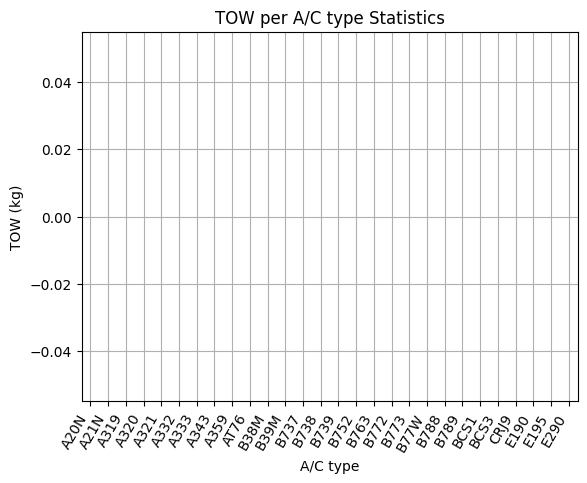

In [14]:
df[["aircraft_type", "tow"]].plot.box(by='aircraft_type')

plt.title("TOW per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("TOW (kg)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

In [15]:
df[["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')

plt.title("RoC from FL100 to FL200 per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("ROC_FL100to200 (ft/min)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

KeyError: "['ROC_FL100to200'] not in index"

In [ ]:
df.plot.scatter(x='tow',
                      y='ROC_FL100to200',
                      c='flight_duration',
                      colormap='viridis')

In [ ]:
df_sel = df[df["ROC_FL100to200"]<5000]
df_sel = df_sel[df_sel["aircraft_type"] == 'A320']

In [ ]:
df_sel.plot.scatter(x='tow',
                      y='ROC_FL100to200',
                      c='flight_duration',
                      colormap='viridis')

In [ ]:
df_sort = df.dropna(how='any').sort_values(by = "ROC_FL100to200", ascending=False)
df_sort

In [ ]:
df.plot.scatter(x='CL_FL100_alt',
                      y='CL_FL200_alt',
                      c='ROC_FL100to200',
                      colormap='viridis')

In [ ]:
df_parquet_sel['altitude'].max()

In [ ]:
df_DE['altitude'].plot()

In [ ]:
df_CL

In [ ]:
idx_df_FL100

In [ ]:
idx_df_FL200

In [ ]:
df_parquet_sel.iloc[36:37]

In [ ]:
(idx_df_FL200-idx_df_FL100) > 1